Document summarization using Pointer Generator Network 

paper - https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/custom/15784595.pdf
<img src="https://drive.google.com/uc?id=1-cBcOa1vJvA5y2RYUK_vzKxaaD38Ixfe" alt="Drawing" Width=500 Height=650/>

Dataset - CNN/DM dataset of 300,000 pairs of news articles and corresponding multi-sentence summaries

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import torch
import torch.nn as nn
import math
from torch import optim
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from collections import Counter
from random import shuffle
import numpy as np
import gzip
from torch.utils.data import Dataset, DataLoader
import pickle
from torch.nn.utils.rnn import pack_sequence
from torch.nn import functional as F

In [0]:
class Params:
  hidden_size = 512  
  shuffle=True
  learning_rate=.001
  num_epochs=10
  data_path = '/content/drive/My Drive/cnndm.gz'
  val_data_path = '/content/drive/My Drive/cnndm.val.gz'
  eps=1e-31
  batch_size=2
  model_path='/content/drive/My Drive/model.pt'
  losses_path='/content/drive/My Drive/val_losses.pkl'

  # Testing
  test_data_path: str = '/content/drive/My Drive/cnndm.test.gz'

In [0]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence:
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [0]:
def simple_tokenizer(text, lower=False, newline=None):
  if lower:
    text = text.lower()
  if newline is not None:  # replace newline by a token
    text = text.replace('\n', ' ' + newline + ' ')
  return text.split()

In [0]:
class Vocab(object):
  PAD = 0
  SOS = 1
  EOS = 2
  UNK = 3
  def __init__(self):
    self.word2index = {}
    self.word2count = Counter()
    self.reserved = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
    self.index2word = self.reserved[:]
    self.embeddings = None

  def add_words(self, words):
    for word in words:
      if word not in self.word2index:
        self.word2index[word] = len(self.index2word)
        self.index2word.append(word)
    self.word2count.update(words)
    
  def __getitem__(self, item):
    if type(item) is int:
      return self.index2word[item]
    return self.word2index.get(item, self.UNK)

  def __len__(self):
    return len(self.index2word)    

In [0]:
class Dataset(nn.Module):
  def __init__(self, filename, tokenize=simple_tokenizer):
    print("Reading dataset %s..." % filename, end=' ', flush=True)
    self.filename = filename
    self.pairs = []
    self.src_len = 0
    self.tgt_len = 0
    if filename.endswith('.gz'):
      open = gzip.open
    with open(filename, 'rt', encoding='utf-8') as f:
      for i, line in enumerate(f):
        pair = line.strip().split('\t')
        if len(pair) != 2:
          continue
        src = tokenize(pair[0])
        tgt = tokenize(pair[1])
        self.pairs.append((src, tgt))
    print("%d pairs." % len(self.pairs))

  def build_vocab(self):
    # word frequency
    word_counts={}
    count_words(word_counts,[src+tgr for src,tgr in self.pairs])
    vocab=Vocab()
    for word,count in word_counts.items():
        if(count>20):
            vocab.add_words([word])  
    self.vocab=vocab 
  def vectorize(self,tokens):
    return [self.vocab[token] for token in tokens]
  def unvectorize(self, indices):
    return [self.vocab[i] for i in indices]
  def __getitem__(self, index):
    return {'x':self.vectorize(self.pairs[index][0]),
            'y':self.vectorize(self.pairs[index][1]),
            'src':self.pairs[index][0],
            'trg':self.pairs[index][1],
            'x_len':len(self.pairs[index][0]),
            'y_len':len(self.pairs[index][1])}
  def __len__(self):
    return len(self.pairs)    

Positional Embedding
*   Sin and cos functions represent binary alternating sequence
*   Both Sin and cos are used as it allows for linear transformation, and hence relative position, which varies linearly with time
*   As mentioned in "attention is all you need" paper, learn embeddings are almost identical to sinusoidal embeddings, i decide to go with fixed sinusoidal embeddings

query
*   Why not just use One-hot embedding instead of sin,cos functions (to be experimented)
*   Learnt embedding is made larger by multiplying with square root of embedding dimension (as mentioned in paper); i suppose word meaning is more important than it's position in sequence and this larger number makes training faster. To be removed and experimented. Also, why not just use a constant to multiply?

In [0]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 3000):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_seq_len, d_model,requires_grad=False)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        self.pe = pe.unsqueeze_(0)
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add positional embedding
        seq_len = x.size(1)
        pe = torch.tensor(self.pe[:,:seq_len],requires_grad=False).to(device)
        x = x + pe
        return x

*   From the paper - 'We suspect that for large values of dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients.To counteract this effect, we scale the dot products'
Softmax function:
<img src="https://drive.google.com/uc?id=1qVvoGO6CPj7-tFYDHmrZNh2OGOG92WTV" alt="Drawing" Width=300 Height=250/><img src="https://drive.google.com/uc?id=1qQJedobeXv1YyrpvYkgZLnOJUczXk5qs" alt="Drawing" Width=300 Height=250/>

If the magnitudes grow large, the softmax function is such that it magnifies such values and suppress lower values, in terms of probabilities.
On the other hand, if we reduce the magnitude, we get a gradual slope and for most inputs, we have bigger gradients.

*   Masking is used for decoder self attention, because decoding is done sequentially and during training we consider the whole sequence as it makes training faster. To factor time step, I assign 0 to leaked attentions.
Suppose decoded sequence is 5 tokens long. Scores last 2 dimensions will be 5x5.Here rows represent time steps, hence we need to make non-highlighted cells 0. 

  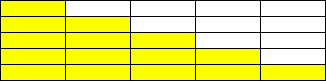




In [0]:
def attention(q, k, v, d_k,mask=False):
  scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)
  scores = F.softmax(scores, dim=-1) 
  tensor_mask=torch.ones(scores.shape).to(device) 
  if mask:
    for row in range(tensor_mask.size(-2)):
      for col in range(tensor_mask.size(-1)):
        if(row>col):
          tensor_mask[:,:,row,col]=0 
    scores=scores * tensor_mask       
    scores=scores.transpose(-2,-1)           
  output = torch.matmul(scores, v)
  return output

*   From the paper - "Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this." - Not clear, to be experimented.
*   In case of self attention, q,k,v are encoder or decoder embeddings. Perhaps, we want to learn 2 representations for each token - q and k (similar to word2vec where we have 2 vectors for each word, one when it is part of context and when it is central word?). This would explain multiple heads and then linear transformation(to be verified).

In [0]:
class MultiHeadAttention(nn.Module):
    def __init__(self,hidden_size,heads=8):
        super(MultiHeadAttention, self).__init__()
        self.heads=heads 
        self.d_k = hidden_size // heads
        self.hidden_size=hidden_size
        self.q_linear = nn.Linear(hidden_size, hidden_size,bias=False)
        self.v_linear = nn.Linear(hidden_size, hidden_size,bias=False)
        self.k_linear = nn.Linear(hidden_size, hidden_size,bias=False)        
    
    def forward(self, q, k, v,mask=False):        
        bs = q.size(0)
        k = self.k_linear(k).view(bs,-1,self.heads,self.d_k)
        q = self.q_linear(q).view(bs,-1,self.heads,self.d_k)
        v = self.v_linear(v).view(bs,-1,self.heads,self.d_k)

        k=k.transpose(1,2)
        q=q.transpose(1,2)
        v=v.transpose(1,2)

        scores = attention(q, k, v, self.d_k,mask)
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.hidden_size)
        return concat
        # return scores.view(bs, -1, self.hidden_size)

*   Skip connection to maintain position information (Only 1 transformer layer used as of now, to be experimented with more layers)
*   From pytorch documentation - "γ and β are learnable affine transform parameters of normalized_shape if elementwise_affine is True."-- To be explored

In [0]:
class Norm(nn.Module):
  def __init__(self,hidden_size):
    super(Norm, self).__init__()
    self.norm=nn.LayerNorm(hidden_size,elementwise_affine=False)
  def forward(self,x,res):
    x=x+self.norm(res)
    return x

In [0]:
class FeedForward(nn.Module):
  def __init__(self,hidden_size,d_ff=2048):
    super(FeedForward, self).__init__()
    self.linear_1=nn.Linear(hidden_size,d_ff)
    self.linear_2=nn.Linear(d_ff,hidden_size)
  def forward(self,x):
    output=self.linear_1(x)
    output=self.linear_2(output)
    return output

In [0]:
class Encoder(nn.Module):
  def __init__(self,hidden_size,vocab_size):
    super(Encoder, self).__init__()
    self.hidden_size=hidden_size
    self.pos=PositionalEncoder(hidden_size)
    self.embedding=nn.Embedding(vocab_size,hidden_size,padding_idx=0)
    self.attn=MultiHeadAttention(hidden_size)
    self.norm=Norm(hidden_size)
    self.ff=FeedForward(hidden_size)
  def forward(self,seq):
    embedded=self.embedding(seq)
    embedded+=self.pos(embedded)
    output=self.attn(embedded,embedded,embedded)
    output=self.norm(embedded,output)
    res=self.ff(output)
    output=self.norm(output,res)
    return output

In [0]:
class Decoder(nn.Module):
  def __init__(self,hidden_size,vocab_size):
    super(Decoder, self).__init__()
    self.hidden_size=hidden_size
    self.pos=PositionalEncoder(hidden_size)
    self.embedding=nn.Embedding(vocab_size,hidden_size,padding_idx=0)
    self.attn_1=MultiHeadAttention(hidden_size)
    self.attn_2=MultiHeadAttention(hidden_size)
    self.norm=Norm(hidden_size)
    self.ff=FeedForward(hidden_size)
  def forward(self,seq,enc_output):
    embedded=self.embedding(seq)
    embedded+=self.pos(embedded)
    output=self.attn_1(embedded,embedded,embedded,True)
    output=self.norm(embedded,output)
    res=self.attn_2(output,enc_output,enc_output)
    output=self.norm(output,res)
    res=self.ff(output)
    dec_output=self.norm(output,res)
    return output,dec_output,embedded  

From decoder-
  1. output - normalized output from encoder attention 
  2. decoder output - final decoder output after feedforward and normalization
  3. embedding - input embedding to be used for p_gen calculation

* At each time step, generation probability is learnt:
* Attention distribution over encoder sequence , using output from above
* Encoder output is weighed by attention distribution calculated in step1
* Mean of Encoder output calculate in step is taken across sequence length
For each tensor in batch:
   * Mean encoder vector, calculated above is linearly transformed 
   For each decoder sequence step:   
     1. decoder output is linearly transformed from hidden_dim(512) to 1
     2. embedding is linearly transformed
     3. All 3 tensors are added and sigmoid is applied
* p_gen is accumulated for each tensor in batch and for each step in decoder sequence 
* pointer probability is 1-p_gen
* Generation probabilities are calculated by projecting final decoder output to fixed vocubulary
* Pointer probabilities are added to generation probabilities using dynamic vocubulary (created in each batch), at locations provided by the expanded encoder indexes multiplied by pointer probabilities
* log is taken of final probability, as we are working in log domain to avoid underflow     

In [0]:
class Transformer(nn.Module):
  def __init__(self,vocab,hidden_size):
    super(Transformer, self).__init__()
    self.vocab=vocab
    self.vocab_size=len(vocab)
    self.hidden_size=hidden_size
    self.encoder=Encoder(hidden_size,self.vocab_size)
    self.decoder=Decoder(hidden_size,self.vocab_size)
    self.linear=nn.Linear(hidden_size,self.vocab_size)
    self.softmax=nn.Softmax()
    self.sigmoid=nn.Sigmoid()
    self.attn=MultiHeadAttention(hidden_size) 
    self.enc_linear=nn.Linear(hidden_size,1)
    self.dec_linear=nn.Linear(hidden_size,1)
    self.embd_linear=nn.Linear(hidden_size,1)

  def forward(self,x,y,extra_vocab,expanded_word_idx):
    enc_output=self.encoder(x)
    output,dec_output,embedded=self.decoder(y,enc_output)
    gen_output=self.softmax(self.linear(dec_output))
    ptr_output=self.attn(enc_output,output,output) 

    ptr_mean=torch.mean(ptr_output,-2).squeeze()
    pb_gen=[]
    for b in range(dec_output.size(0)):
      p_gen=[]
      for t in range(dec_output.size(-2)):
        p_gen.append(self.sigmoid(self.enc_linear(ptr_mean[b,:])+self.dec_linear(dec_output[b,t,:])+self.embd_linear(embedded[b,t,:])))
      pb_gen.append(p_gen)  
    pb_gen=torch.tensor(pb_gen).to(device)
    gen_output=F.pad(gen_output,(0,len(extra_vocab)),'constant')
        
    ptr_dist=F.softmax(torch.matmul(output, enc_output.transpose(-2,-1)),dim=-1)  
    pb_ptr=(1-pb_gen).unsqueeze(-1).expand_as(ptr_dist)
    gen_output.scatter_add_(2,expanded_word_idx.unsqueeze(1).expand(-1,gen_output.size(1),-1),ptr_dist*pb_ptr)
    return torch.log(gen_output+1e-5)

A function is hooked into dataloader, as we dont set a max sequence length here.
Padding has to be done for each batch

In [0]:
def my_collate(batch):
    max_x=np.max([item['x_len'] for item in batch])
    max_y=np.max([item['y_len'] for item in batch])
    
    x = [F.pad(torch.tensor(item['x']), (0,max_x-len(item['x'])), 'constant').tolist() for item in batch]    
    y = [F.pad(torch.tensor(item['y']), (0,max_y-len(item['y'])), 'constant').tolist() for item in batch]
    
    src=[item['src'] for item in batch]
    trg=[item['trg'] for item in batch]
    return {'x':x,'y': y,'src':src,'trg':trg,'x_len':[item['x_len'] for item in batch],'y_len':[item['y_len'] for item in batch]}

In [0]:
with torch.autograd.set_detect_anomaly(True):
  p=Params()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  batch_size=p.batch_size
  dataset=Dataset(p.data_path)
  dataset.build_vocab()
  valset=Dataset(p.val_data_path)
  dataloader = DataLoader(dataset,p.batch_size,p.shuffle,collate_fn=my_collate)
  valloader = DataLoader(dataset,p.batch_size,p.shuffle,collate_fn=my_collate)
  model=Transformer(dataset.vocab,p.hidden_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=p.learning_rate)
  # criterion = nn.NLLLoss(ignore_index=dataset.vocab.PAD)

  training_loss=[]
  validation_loss=[]
  # training and vaildation losses are sum of corresponding batch losses and are added in above lists
  for _e in range(p.num_epochs):
    epoch_tr_loss=0
    epoch_vl_loss=0
    for batch in tqdm(dataloader):
      print(torch.cuda.memory_allocated(device="cuda"))
      optimizer.zero_grad()
      extra_vocab={}
      expanded_x=[]
      expanded_y=[]
      
      x=torch.tensor(batch['x']).to(device)
      y=torch.tensor(batch['y']).to(device)
      src=batch['src']
      trg=batch['trg']

      max_src=np.max(batch['x_len'])
      for sent in src:
        vec=[]
        for token in sent:
          if(token in extra_vocab.keys()):
            vec.append(extra_vocab[token]) 
          elif(token not in dataset.vocab.word2index):
            extra_vocab[token]=len(dataset.vocab)+len(extra_vocab)
            vec.append(extra_vocab[token])
        expanded_x.append(vec + [0 for i in range(max_src-len(vec))])
      expanded_x=torch.tensor(expanded_x).to(device)  

      max_trg=np.max(batch['y_len'])
      for sent in trg:
        vec=[]
        for token in sent:
          if(token in extra_vocab.keys()):
            vec.append(extra_vocab[token]) 
          elif(token not in dataset.vocab.word2index):
            extra_vocab[token]=len(dataset.vocab)+len(extra_vocab)
            vec.append(extra_vocab[token])
        expanded_y.append(vec + [0 for i in range(max_trg-len(vec))])          
      expanded_y = torch.tensor(expanded_y).to(device)
      '''
        y is used as input, expanded y for validation and expanded x for pointer probability
      '''
      y=torch.cat((torch.tensor([dataset.vocab.SOS] * y.size(0), device=device).view(-1,1),y[:,:-1]),dim=1)
      pred=model(x,y,extra_vocab,expanded_x)
      loss=F.nll_loss(pred.permute(0,2,1), y, ignore_index=dataset.vocab.PAD, reduction='sum')
      loss.backward()
      optimizer.step() 
      epoch_tr_loss+=loss.data.item()
    training_loss.append(epoch_tr_loss)
    for batch in tqdm(valloader):
      optimizer.zero_grad()
      extra_vocab={}
      expanded_x=[]
      expanded_y=[]
      
      x=torch.tensor(batch['x']).to(device)
      y=torch.tensor(batch['y']).to(device)
      src=batch['src']
      trg=batch['trg']

      max_src=np.max(batch['x_len'])
      for sent in src:
        vec=[]
        for token in sent:
          if(token in extra_vocab.keys()):
            vec.append(extra_vocab[token]) 
          elif(token not in dataset.vocab.word2index):
            extra_vocab[token]=len(dataset.vocab)+len(extra_vocab)
            vec.append(extra_vocab[token])
        expanded_x.append(vec + [0 for i in range(max_src-len(vec))])
      expanded_x=torch.tensor(expanded_x).to(device)  

      max_trg=np.max(batch['y_len'])
      for sent in trg:
        vec=[]
        for token in sent:
          if(token in extra_vocab.keys()):
            vec.append(extra_vocab[token]) 
          elif(token not in dataset.vocab.word2index):
            extra_vocab[token]=len(dataset.vocab)+len(extra_vocab)
            vec.append(extra_vocab[token])
        expanded_y.append(vec + [0 for i in range(max_trg-len(vec))])          
      expanded_y = torch.tensor(expanded_y).to(device)
      
      y=torch.cat((torch.tensor([dataset.vocab.SOS] * y.size(0), device=device).view(-1,1),y[:,:-1]),dim=1)
      pred=model(x,y,extra_vocab,expanded_x)
      loss=F.nll_loss(pred.permute(0,2,1), y, ignore_index=dataset.vocab.PAD, reduction='sum')
      loss.backward()
      optimizer.step() 
      epoch_vl_loss+=loss.data.item()
    validation_loss.append(epoch_vl_loss)
    # if validation loss in an epoch is less than encountered, model is saved
    if(len(validation_loss)>0 and epoch_vl_loss<min(validation_loss)):
      torch.save(model.state_dict(), p.model_path)

Reading dataset /content/drive/My Drive/cnndm.gz... 287089 pairs.
Reading dataset /content/drive/My Drive/cnndm.val.gz... 13366 pairs.


  0%|          | 0/143545 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


602282496


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 1/143545 [00:01<53:18:04,  1.34s/it]

2444237824


  0%|          | 2/143545 [00:02<52:29:28,  1.32s/it]

2451497984


  0%|          | 3/143545 [00:03<49:18:00,  1.24s/it]

2439616512


  0%|          | 4/143545 [00:04<49:11:36,  1.23s/it]

2450011136


  0%|          | 5/143545 [00:05<46:33:02,  1.17s/it]

2441826304


  0%|          | 6/143545 [00:07<52:48:56,  1.32s/it]

2469437440


  0%|          | 7/143545 [00:09<54:45:19,  1.37s/it]

2461177856


  0%|          | 8/143545 [00:11<62:00:50,  1.56s/it]

2485691904


  0%|          | 9/143545 [00:12<65:30:45,  1.64s/it]

2472353792


  0%|          | 10/143545 [00:14<59:48:29,  1.50s/it]

2447046144


  0%|          | 11/143545 [00:15<55:51:59,  1.40s/it]

2449254400


  0%|          | 12/143545 [00:16<51:32:00,  1.29s/it]

2444240896


  0%|          | 13/143545 [00:17<49:36:52,  1.24s/it]

2444823040


  0%|          | 14/143545 [00:18<52:19:04,  1.31s/it]

2458955264


  0%|          | 15/143545 [00:20<51:21:05,  1.29s/it]

2450010112


  0%|          | 16/143545 [00:21<48:39:43,  1.22s/it]

2444253184


  0%|          | 17/143545 [00:22<48:09:22,  1.21s/it]

2447782912


  0%|          | 18/143545 [00:23<46:18:10,  1.16s/it]

2439625728


  0%|          | 19/143545 [00:24<46:37:24,  1.17s/it]

2450746880


  0%|          | 20/143545 [00:25<44:36:24,  1.12s/it]

2441084416


  0%|          | 21/143545 [00:26<47:45:39,  1.20s/it]

2459668480


  0%|          | 22/143545 [00:29<60:17:01,  1.51s/it]

2494617088


  0%|          | 23/143545 [00:30<54:05:35,  1.36s/it]

2441081344


  0%|          | 24/143545 [00:31<57:22:15,  1.44s/it]

2467866624


  0%|          | 25/143545 [00:33<57:53:25,  1.45s/it]

2462649344


  0%|          | 26/143545 [00:34<53:52:07,  1.35s/it]

2446283264


  0%|          | 27/143545 [00:35<50:47:33,  1.27s/it]

2444809216


  0%|          | 28/143545 [00:37<60:39:32,  1.52s/it]

2489417728


  0%|          | 29/143545 [00:38<55:50:03,  1.40s/it]

2445557248


  0%|          | 30/143545 [00:39<53:13:52,  1.34s/it]

2449270272


  0%|          | 31/143545 [00:41<51:50:21,  1.30s/it]

2451494912


  0%|          | 32/143545 [00:42<48:30:14,  1.22s/it]

2441826816


  0%|          | 33/143545 [00:43<46:19:27,  1.16s/it]

2442560512


  0%|          | 34/143545 [00:48<97:03:06,  2.43s/it]

2445564928


  0%|          | 35/143545 [00:50<89:22:53,  2.24s/it]

2473812992


  0%|          | 36/143545 [00:51<77:08:25,  1.94s/it]

2451489792


  0%|          | 37/143545 [00:52<66:20:39,  1.66s/it]

2442570752


  0%|          | 38/143545 [00:54<66:34:01,  1.67s/it]

2465652224


  0%|          | 39/143545 [00:56<67:42:43,  1.70s/it]

2467895808


  0%|          | 40/143545 [00:57<59:29:00,  1.49s/it]

2441823744


  0%|          | 41/143545 [00:58<57:15:26,  1.44s/it]

2451518464


  0%|          | 42/143545 [00:59<55:35:07,  1.39s/it]

2450769920


  0%|          | 43/143545 [01:00<50:45:59,  1.27s/it]

2440333824


  0%|          | 44/143545 [01:01<48:31:14,  1.22s/it]

2444808192


  0%|          | 45/143545 [01:03<56:03:49,  1.41s/it]

2473837568


  0%|          | 46/143545 [01:05<55:32:18,  1.39s/it]

2453752320


  0%|          | 47/143545 [01:06<51:15:58,  1.29s/it]

2440355840


  0%|          | 48/143545 [01:07<49:02:59,  1.23s/it]

2441856512


  0%|          | 49/143545 [01:08<51:02:18,  1.28s/it]

2454491648


  0%|          | 50/143545 [01:10<53:15:24,  1.34s/it]

2461167616


  0%|          | 51/143545 [01:11<50:20:00,  1.26s/it]

2441111552


  0%|          | 52/143545 [01:12<53:01:37,  1.33s/it]

2459700224


  0%|          | 53/143545 [01:13<50:17:24,  1.26s/it]

2444248064


  0%|          | 54/143545 [01:15<51:08:05,  1.28s/it]

2456696320


  0%|          | 55/143545 [01:16<58:57:15,  1.48s/it]

2477541376


  0%|          | 56/143545 [01:18<55:35:18,  1.39s/it]

2449269248


  0%|          | 57/143545 [01:19<50:27:12,  1.27s/it]

2434428416


  0%|          | 58/143545 [01:20<51:34:02,  1.29s/it]

2457434112


  0%|          | 59/143545 [01:21<47:04:29,  1.18s/it]

2435147776


  0%|          | 60/143545 [01:22<41:50:37,  1.05s/it]

2427704320


  0%|          | 61/143545 [01:23<41:57:36,  1.05s/it]

2441844224


  0%|          | 62/143545 [01:24<43:22:47,  1.09s/it]

2446306304


  0%|          | 63/143545 [01:25<45:11:55,  1.13s/it]

2450023424


  0%|          | 64/143545 [01:26<42:10:13,  1.06s/it]

2434398208


  0%|          | 65/143545 [01:27<42:49:08,  1.07s/it]

2442593280


  0%|          | 66/143545 [01:28<42:57:16,  1.08s/it]

2438886400


  0%|          | 67/143545 [01:29<39:51:56,  1.00s/it]

2430687232


  0%|          | 68/143545 [01:30<39:48:32,  1.00it/s]

2438870016


  0%|          | 69/143545 [01:31<37:52:56,  1.05it/s]

2432907776


  0%|          | 70/143545 [01:32<39:47:00,  1.00it/s]

2445547520


  0%|          | 71/143545 [01:33<43:09:43,  1.08s/it]

2452987392


  0%|          | 72/143545 [01:35<52:07:50,  1.31s/it]

2477515776


  0%|          | 73/143545 [01:36<47:47:06,  1.20s/it]

2438110208


  0%|          | 74/143545 [01:37<47:04:14,  1.18s/it]

2445552640


  0%|          | 75/143545 [01:38<47:48:33,  1.20s/it]

2448542720


  0%|          | 76/143545 [01:40<50:34:46,  1.27s/it]

2458948096


  0%|          | 77/143545 [01:41<50:50:26,  1.28s/it]

2453727232


  0%|          | 78/143545 [01:42<49:43:52,  1.25s/it]

2446315008


  0%|          | 79/143545 [01:44<52:21:04,  1.31s/it]

2461903872


  0%|          | 80/143545 [01:45<49:35:22,  1.24s/it]

2444240896


  0%|          | 81/143545 [01:46<47:46:14,  1.20s/it]

2444803584


  0%|          | 82/143545 [01:47<44:11:01,  1.11s/it]

2432931840


  0%|          | 83/143545 [01:48<44:15:48,  1.11s/it]

2444264448


  0%|          | 84/143545 [01:49<40:44:28,  1.02s/it]

2432902144


  0%|          | 85/143545 [01:50<39:20:21,  1.01it/s]

2435150336


  0%|          | 86/143545 [01:51<39:42:04,  1.00it/s]

2439607296


  0%|          | 87/143545 [01:52<39:00:30,  1.02it/s]

2436632064


  0%|          | 88/143545 [01:53<48:56:45,  1.23s/it]

2473085952


  0%|          | 89/143545 [01:55<48:33:37,  1.22s/it]

2448532992


  0%|          | 90/143545 [01:57<61:22:46,  1.54s/it]

2494687232


  0%|          | 91/143545 [01:58<58:10:41,  1.46s/it]

2454458880


  0%|          | 92/143545 [01:59<50:15:26,  1.26s/it]

2428464128


  0%|          | 93/143545 [02:00<50:45:07,  1.27s/it]

2448556032


  0%|          | 94/143545 [02:01<48:18:25,  1.21s/it]

2443316224


  0%|          | 95/143545 [02:03<53:18:49,  1.34s/it]

2467863040


  0%|          | 96/143545 [02:06<74:29:50,  1.87s/it]

2525102080


  0%|          | 97/143545 [02:07<62:20:58,  1.56s/it]

2432169984


  0%|          | 98/143545 [02:08<58:03:58,  1.46s/it]

2442614272


  0%|          | 99/143545 [02:09<55:29:32,  1.39s/it]

2449285632


  0%|          | 100/143545 [02:11<52:05:56,  1.31s/it]

2445565440


  0%|          | 101/143545 [02:18<122:45:22,  3.08s/it]

2519912448


  0%|          | 102/143545 [02:20<106:59:06,  2.69s/it]

2476024832


  0%|          | 103/143545 [02:20<83:53:14,  2.11s/it] 

2429195264


  0%|          | 104/143545 [02:22<74:58:52,  1.88s/it]

2457446400


  0%|          | 105/143545 [02:23<65:11:44,  1.64s/it]

2444251136


  0%|          | 106/143545 [02:24<59:52:05,  1.50s/it]

2449997824


  0%|          | 107/143545 [02:25<53:04:46,  1.33s/it]

2437370880


  0%|          | 108/143545 [02:27<61:08:15,  1.53s/it]

2481999360


  0%|          | 109/143545 [02:28<59:34:56,  1.50s/it]

2458931200


  0%|          | 110/143545 [02:29<55:42:29,  1.40s/it]

2448521216


  0%|          | 111/143545 [02:30<48:53:17,  1.23s/it]

2430693376


  0%|          | 112/143545 [02:31<49:16:17,  1.24s/it]

2448549888


  0%|          | 113/143545 [02:32<42:16:52,  1.06s/it]

2421768704


  0%|          | 114/143545 [02:33<45:03:05,  1.13s/it]

2453739008


  0%|          | 115/143545 [02:34<44:17:44,  1.11s/it]

2444249088


  0%|          | 116/143545 [02:35<42:47:26,  1.07s/it]

2435175936


  0%|          | 117/143545 [02:37<42:58:46,  1.08s/it]

2441853952


  0%|          | 118/143545 [02:37<40:51:34,  1.03s/it]

2435887104


  0%|          | 119/143545 [02:39<46:34:40,  1.17s/it]

2458220032


  0%|          | 120/143545 [02:40<44:34:05,  1.12s/it]

2440349184


  0%|          | 121/143545 [02:41<44:05:58,  1.11s/it]

2442587136


  0%|          | 122/143545 [02:42<46:28:32,  1.17s/it]

2454472704


  0%|          | 123/143545 [02:44<50:22:15,  1.26s/it]

2461913088


  0%|          | 124/143545 [02:46<65:09:33,  1.64s/it]

2499112960


  0%|          | 125/143545 [02:47<56:11:31,  1.41s/it]

2435880960


  0%|          | 126/143545 [02:48<51:40:07,  1.30s/it]

2439619584


  0%|          | 127/143545 [02:49<49:43:34,  1.25s/it]

2439640576


  0%|          | 128/143545 [02:50<45:59:45,  1.15s/it]

2438848512


  0%|          | 129/143545 [02:51<44:52:28,  1.13s/it]

2441846272


  0%|          | 130/143545 [02:53<45:16:20,  1.14s/it]

2449997824


  0%|          | 131/143545 [02:55<56:16:03,  1.41s/it]

2487187456


  0%|          | 132/143545 [02:56<51:58:25,  1.30s/it]

2441838080


  0%|          | 133/143545 [02:57<54:32:32,  1.37s/it]

2463397376


  0%|          | 134/143545 [02:58<51:27:00,  1.29s/it]

2444265472


  0%|          | 135/143545 [02:59<48:49:23,  1.23s/it]

2441846784


  0%|          | 136/143545 [03:01<48:28:33,  1.22s/it]

2444099584


  0%|          | 137/143545 [03:02<45:03:28,  1.13s/it]

2438850560


  0%|          | 138/143545 [03:03<45:57:04,  1.15s/it]

2448532992


  0%|          | 139/143545 [03:04<51:11:33,  1.29s/it]

2468594688


  0%|          | 140/143545 [03:05<49:14:27,  1.24s/it]

2444814848


  0%|          | 141/143545 [03:07<49:26:44,  1.24s/it]

2452242432


  0%|          | 142/143545 [03:08<48:47:13,  1.22s/it]

2447792128


  0%|          | 143/143545 [03:09<46:23:51,  1.16s/it]

2441833472


  0%|          | 144/143545 [03:10<45:04:04,  1.13s/it]

2438886912


  0%|          | 145/143545 [03:11<47:39:01,  1.20s/it]

2455220224


  0%|          | 146/143545 [03:13<53:56:06,  1.35s/it]

2475273728


  0%|          | 147/143545 [03:15<61:00:11,  1.53s/it]

2476073472


  0%|          | 148/143545 [03:16<56:08:10,  1.41s/it]

2447029248


  0%|          | 149/143545 [03:18<65:34:27,  1.65s/it]

2491662848


  0%|          | 150/143545 [03:19<59:10:43,  1.49s/it]

2446303744


  0%|          | 151/143545 [03:21<61:13:10,  1.54s/it]

2471555584


  0%|          | 152/143545 [03:22<59:13:05,  1.49s/it]

2456720896


  0%|          | 153/143545 [03:23<52:57:48,  1.33s/it]

2430723584


  0%|          | 154/143545 [03:24<47:35:01,  1.19s/it]

2435874816


  0%|          | 155/143545 [03:26<48:46:12,  1.22s/it]

2453004800


  0%|          | 156/143545 [03:27<47:24:23,  1.19s/it]

2445554688


  0%|          | 157/143545 [03:28<48:46:08,  1.22s/it]

2454464000


  0%|          | 158/143545 [03:29<50:00:16,  1.26s/it]

2453733376


  0%|          | 159/143545 [03:31<59:47:33,  1.50s/it]

2487936000


  0%|          | 160/143545 [03:32<52:14:03,  1.31s/it]

2432179712


  0%|          | 161/143545 [03:34<56:32:28,  1.42s/it]

2469356544


  0%|          | 162/143545 [03:35<54:50:54,  1.38s/it]

2452982784


  0%|          | 163/143545 [03:36<50:36:26,  1.27s/it]

2444235776


  0%|          | 164/143545 [03:37<48:47:35,  1.23s/it]

2446293504


  0%|          | 165/143545 [03:38<42:01:31,  1.06s/it]

2423986176


  0%|          | 166/143545 [03:39<47:20:09,  1.19s/it]

2461189120


  0%|          | 167/143545 [03:41<45:20:07,  1.14s/it]

2438135296


  0%|          | 168/143545 [03:42<44:34:53,  1.12s/it]

2444251136


  0%|          | 169/143545 [03:43<50:29:21,  1.27s/it]

2468602880


  0%|          | 170/143545 [03:45<52:11:38,  1.31s/it]

2454503936


  0%|          | 171/143545 [03:46<53:55:58,  1.35s/it]

2458210816


  0%|          | 172/143545 [03:47<48:09:39,  1.21s/it]

2435140096


  0%|          | 173/143545 [03:49<56:33:39,  1.42s/it]

2479017984


  0%|          | 174/143545 [03:51<63:10:42,  1.59s/it]

2482729472


  0%|          | 175/143545 [03:52<59:54:18,  1.50s/it]

2454481920


  0%|          | 176/143545 [03:54<64:11:06,  1.61s/it]

2478263808


  0%|          | 177/143545 [03:55<59:37:37,  1.50s/it]

2450757632


  0%|          | 178/143545 [03:56<53:50:52,  1.35s/it]

2440349184


  0%|          | 179/143545 [04:02<102:23:37,  2.57s/it]

2444249088


  0%|          | 180/143545 [04:03<83:47:42,  2.10s/it] 

2438121984


  0%|          | 181/143545 [04:04<72:22:24,  1.82s/it]

2447776768


  0%|          | 182/143545 [04:05<60:59:30,  1.53s/it]

2432917504


  0%|          | 183/143545 [04:06<55:07:14,  1.38s/it]

2441828352


  0%|          | 184/143545 [04:07<51:44:25,  1.30s/it]

2445548032


  0%|          | 185/143545 [04:08<50:49:29,  1.28s/it]

2450013184


  0%|          | 186/143545 [04:10<54:02:58,  1.36s/it]

2466370560


  0%|          | 187/143545 [04:11<55:29:04,  1.39s/it]

2464123904


  0%|          | 188/143545 [04:12<55:35:39,  1.40s/it]

2459677696


  0%|          | 189/143545 [04:14<51:42:39,  1.30s/it]

2444250112


  0%|          | 190/143545 [04:15<49:31:51,  1.24s/it]

2445547520


  0%|          | 191/143545 [04:17<58:23:25,  1.47s/it]

2479777792


  0%|          | 192/143545 [04:18<55:42:56,  1.40s/it]

2447821312


  0%|          | 193/143545 [04:19<54:25:38,  1.37s/it]

2454473728


  0%|          | 194/143545 [04:20<50:04:59,  1.26s/it]

2441818112


  0%|          | 195/143545 [04:21<47:54:04,  1.20s/it]

2444803584


  0%|          | 196/143545 [04:22<47:53:54,  1.20s/it]

2450749952


  0%|          | 197/143545 [04:23<45:54:56,  1.15s/it]

2435180032


  0%|          | 198/143545 [04:24<41:33:08,  1.04s/it]

2429939712


  0%|          | 199/143545 [04:26<44:00:35,  1.11s/it]

2452240384


  0%|          | 200/143545 [04:27<43:42:14,  1.10s/it]

2442591744


  0%|          | 201/143545 [04:28<45:57:01,  1.15s/it]

2450775040


  0%|          | 202/143545 [04:29<47:39:36,  1.20s/it]

2450776064


  0%|          | 203/143545 [04:31<49:51:10,  1.25s/it]

2456701952


  0%|          | 204/143545 [04:31<45:40:58,  1.15s/it]

2434409984


  0%|          | 205/143545 [04:33<45:35:00,  1.14s/it]

2444265472


  0%|          | 206/143545 [04:34<48:33:12,  1.22s/it]

2458934272


  0%|          | 207/143545 [04:35<44:09:42,  1.11s/it]

2432180224


  0%|          | 208/143545 [04:36<43:04:08,  1.08s/it]

2441089024


  0%|          | 209/143545 [04:38<51:44:04,  1.30s/it]

2474561024


  0%|          | 210/143545 [04:39<53:14:35,  1.34s/it]

2458933248


  0%|          | 211/143545 [04:40<52:04:08,  1.31s/it]

2452230656


  0%|          | 212/143545 [04:42<51:22:17,  1.29s/it]

2450764288


  0%|          | 213/143545 [04:42<44:21:30,  1.11s/it]

2426218496


  0%|          | 214/143545 [04:43<40:56:53,  1.03s/it]

2432160768


  0%|          | 215/143545 [04:44<40:50:36,  1.03s/it]

2435929088


  0%|          | 216/143545 [04:46<46:40:23,  1.17s/it]

2462660096


  0%|          | 217/143545 [04:47<50:43:40,  1.27s/it]

2459699200


  0%|          | 218/143545 [04:49<56:11:12,  1.41s/it]

2474549760


  0%|          | 219/143545 [04:50<56:09:25,  1.41s/it]

2461154816


  0%|          | 220/143545 [04:51<52:53:53,  1.33s/it]

2448509440


  0%|          | 221/143545 [04:53<53:10:20,  1.34s/it]

2457441792


  0%|          | 222/143545 [04:55<61:55:57,  1.56s/it]

2484230144


  0%|          | 223/143545 [04:56<56:29:29,  1.42s/it]

2444808704


  0%|          | 224/143545 [04:57<54:41:50,  1.37s/it]

2452241408


  0%|          | 225/143545 [04:58<52:53:23,  1.33s/it]

2450019840


  0%|          | 226/143545 [05:00<49:38:39,  1.25s/it]

2441831936


  0%|          | 227/143545 [05:02<58:31:44,  1.47s/it]

2477556736


  0%|          | 228/143545 [05:03<53:53:26,  1.35s/it]

2444251136


  0%|          | 229/143545 [05:04<54:54:27,  1.38s/it]

2454522880


  0%|          | 230/143545 [05:05<51:51:34,  1.30s/it]

2447028224


  0%|          | 231/143545 [05:06<50:23:58,  1.27s/it]

2446307328


  0%|          | 232/143545 [05:07<46:42:35,  1.17s/it]

2438112256


  0%|          | 233/143545 [05:08<44:38:24,  1.12s/it]

2439603712


  0%|          | 234/143545 [05:09<41:12:39,  1.04s/it]

2433646080


  0%|          | 235/143545 [05:11<46:15:28,  1.16s/it]

2463382016


  0%|          | 236/143545 [05:12<43:12:23,  1.09s/it]

2437355008


  0%|          | 237/143545 [05:12<39:32:40,  1.01it/s]

2431414784


  0%|          | 238/143545 [05:14<44:24:59,  1.12s/it]

2458199552


  0%|          | 239/143545 [05:14<39:14:55,  1.01it/s]

2422519296


  0%|          | 240/143545 [05:17<56:09:01,  1.41s/it]

2496886784


  0%|          | 241/143545 [05:18<51:28:49,  1.29s/it]

2441828864


  0%|          | 242/143545 [05:19<49:52:53,  1.25s/it]

2448524800


  0%|          | 243/143545 [05:25<101:59:16,  2.56s/it]

2450034688


  0%|          | 244/143545 [05:26<85:23:15,  2.15s/it] 

2447782912


  0%|          | 245/143545 [05:27<74:47:20,  1.88s/it]

2450024960


  0%|          | 246/143545 [05:28<64:10:17,  1.61s/it]

2438865920


  0%|          | 247/143545 [05:29<56:24:12,  1.42s/it]

2438855680


  0%|          | 248/143545 [05:30<52:38:40,  1.32s/it]

2442591744


  0%|          | 249/143545 [05:31<48:16:05,  1.21s/it]

2436634112


  0%|          | 250/143545 [05:33<52:44:52,  1.33s/it]

2464154112


  0%|          | 251/143545 [05:34<55:37:02,  1.40s/it]

2459715584


  0%|          | 252/143545 [05:35<51:29:24,  1.29s/it]

2442580992


  0%|          | 253/143545 [05:36<47:18:02,  1.19s/it]

2436636672


  0%|          | 254/143545 [05:37<44:18:09,  1.11s/it]

2438848000


  0%|          | 255/143545 [05:39<50:53:58,  1.28s/it]

2468616192


  0%|          | 256/143545 [05:40<51:25:56,  1.29s/it]

2456693760


  0%|          | 257/143545 [05:41<49:26:15,  1.24s/it]

2444264448


  0%|          | 258/143545 [05:43<56:41:51,  1.42s/it]

2477516800


  0%|          | 259/143545 [05:44<51:57:30,  1.31s/it]

2440354304


  0%|          | 260/143545 [05:45<49:18:35,  1.24s/it]

2445535232


  0%|          | 261/143545 [05:46<46:30:51,  1.17s/it]

2441085952


  0%|          | 262/143545 [05:47<46:50:47,  1.18s/it]

2447787520


  0%|          | 263/143545 [05:48<46:11:08,  1.16s/it]

2438899712


  0%|          | 264/143545 [05:50<51:25:43,  1.29s/it]

2462686208


  0%|          | 265/143545 [05:51<50:03:25,  1.26s/it]

2447052800


  0%|          | 266/143545 [05:52<44:07:25,  1.11s/it]

2428453888


  0%|          | 267/143545 [05:53<45:05:56,  1.13s/it]

2448524288


  0%|          | 268/143545 [05:55<47:20:48,  1.19s/it]

2454470144


  0%|          | 269/143545 [05:56<46:42:20,  1.17s/it]

2446301184


  0%|          | 270/143545 [05:57<48:50:41,  1.23s/it]

2455235072


  0%|          | 271/143545 [05:58<43:16:15,  1.09s/it]

2426977280


  0%|          | 272/143545 [05:59<46:14:02,  1.16s/it]

2453000704


  0%|          | 273/143545 [06:01<52:23:24,  1.32s/it]

2472304128


  0%|          | 274/143545 [06:02<49:31:24,  1.24s/it]

2442581504


  0%|          | 275/143545 [06:04<54:25:11,  1.37s/it]

2464921600


  0%|          | 276/143545 [06:05<51:04:03,  1.28s/it]

2444802560


  0%|          | 277/143545 [06:06<49:09:27,  1.24s/it]

2444813824


  0%|          | 278/143545 [06:07<49:29:05,  1.24s/it]

2452980224


  0%|          | 279/143545 [06:08<47:43:38,  1.20s/it]

2446283264


  0%|          | 280/143545 [06:09<44:31:21,  1.12s/it]

2435897856


  0%|          | 281/143545 [06:10<41:42:34,  1.05s/it]

2433662976


  0%|          | 282/143545 [06:12<49:40:27,  1.25s/it]

2472323072


  0%|          | 283/143545 [06:13<47:40:45,  1.20s/it]

2444801024


  0%|          | 284/143545 [06:14<46:12:32,  1.16s/it]

2441108480


  0%|          | 285/143545 [06:15<45:25:22,  1.14s/it]

2443334144


  0%|          | 286/143545 [06:17<53:09:06,  1.34s/it]

2472337920


  0%|          | 287/143545 [06:18<49:01:24,  1.23s/it]

2439606784


  0%|          | 288/143545 [06:19<54:00:16,  1.36s/it]

2470088704


  0%|          | 289/143545 [06:20<51:10:41,  1.29s/it]

2444815872


  0%|          | 290/143545 [06:21<48:28:04,  1.22s/it]

2436666880


  0%|          | 291/143545 [06:23<50:24:09,  1.27s/it]

2455967232


  0%|          | 292/143545 [06:24<45:41:57,  1.15s/it]

2432184832


  0%|          | 293/143545 [06:25<43:30:50,  1.09s/it]

2440336384


  0%|          | 294/143545 [06:26<40:41:30,  1.02s/it]

2433656832


  0%|          | 295/143545 [06:27<51:29:09,  1.29s/it]

2480500736


  0%|          | 296/143545 [06:29<48:42:37,  1.22s/it]

2444249088


  0%|          | 297/143545 [06:30<49:21:04,  1.24s/it]

2450032128


  0%|          | 298/143545 [06:31<47:25:32,  1.19s/it]

2441843712


  0%|          | 299/143545 [06:32<44:29:46,  1.12s/it]

2436637184


  0%|          | 300/143545 [06:33<46:24:31,  1.17s/it]

2451504128


  0%|          | 301/143545 [06:35<52:40:10,  1.32s/it]

2471573504


  0%|          | 302/143545 [06:36<49:01:49,  1.23s/it]

2441089536


  0%|          | 303/143545 [06:37<50:46:49,  1.28s/it]

2458185728


  0%|          | 304/143545 [06:38<45:28:06,  1.14s/it]

2433648128


  0%|          | 305/143545 [06:40<57:12:03,  1.44s/it]

2490173440


  0%|          | 306/143545 [06:41<54:06:07,  1.36s/it]

2448521216


  0%|          | 307/143545 [06:43<52:21:18,  1.32s/it]

2450753024


  0%|          | 308/143545 [06:45<65:03:34,  1.64s/it]

2497607680


  0%|          | 309/143545 [06:46<55:02:27,  1.38s/it]

2431414784


  0%|          | 310/143545 [06:47<48:00:49,  1.21s/it]

2431416320


  0%|          | 311/143545 [06:53<107:39:46,  2.71s/it]

2481235456


  0%|          | 312/143545 [06:54<88:15:01,  2.22s/it] 

2444233728


  0%|          | 313/143545 [06:55<78:57:30,  1.98s/it]

2459674624


  0%|          | 314/143545 [06:57<77:01:40,  1.94s/it]

2473827328


  0%|          | 315/143545 [06:58<64:06:29,  1.61s/it]

2434391040


  0%|          | 316/143545 [07:00<64:41:48,  1.63s/it]

2471562240


  0%|          | 317/143545 [07:01<57:50:10,  1.45s/it]

2443318272


  0%|          | 318/143545 [07:02<53:52:53,  1.35s/it]

2440381440


  0%|          | 319/143545 [07:03<48:50:16,  1.23s/it]

2434419712


  0%|          | 320/143545 [07:04<52:51:03,  1.33s/it]

2466365440


  0%|          | 321/143545 [07:05<46:41:36,  1.17s/it]

2429215744


  0%|          | 322/143545 [07:07<53:56:36,  1.36s/it]

2474554880


  0%|          | 323/143545 [07:08<46:01:09,  1.16s/it]

2424001536


  0%|          | 324/143545 [07:09<46:58:02,  1.18s/it]

2450760192


  0%|          | 325/143545 [07:10<51:21:02,  1.29s/it]

2463412736


  0%|          | 326/143545 [07:11<48:52:39,  1.23s/it]

2444254208


  0%|          | 327/143545 [07:13<48:03:27,  1.21s/it]

2447039488


  0%|          | 328/143545 [07:14<47:50:43,  1.20s/it]

2450004992


  0%|          | 329/143545 [07:15<50:00:05,  1.26s/it]

2458191360


  0%|          | 330/143545 [07:16<44:13:18,  1.11s/it]

2428455424


  0%|          | 331/143545 [07:17<42:20:30,  1.06s/it]

2438110720


  0%|          | 332/143545 [07:19<59:33:27,  1.50s/it]

2502077952


  0%|          | 333/143545 [07:21<58:56:15,  1.48s/it]

2461160960


  0%|          | 334/143545 [07:22<55:38:53,  1.40s/it]

2450013696


  0%|          | 335/143545 [07:23<50:55:17,  1.28s/it]

2441823744


  0%|          | 336/143545 [07:24<44:58:15,  1.13s/it]

2430674432


  0%|          | 337/143545 [07:26<60:00:46,  1.51s/it]

2499825152


  0%|          | 338/143545 [07:28<60:13:16,  1.51s/it]

2465606144


  0%|          | 339/143545 [07:29<51:46:44,  1.30s/it]

2432159232


  0%|          | 340/143545 [07:30<52:26:44,  1.32s/it]

2454482432


  0%|          | 341/143545 [07:31<51:09:54,  1.29s/it]

2450012160


  0%|          | 342/143545 [07:32<48:52:14,  1.23s/it]

2446281728


  0%|          | 343/143545 [07:33<47:43:26,  1.20s/it]

2447771136


  0%|          | 344/143545 [07:34<46:31:37,  1.17s/it]

2444809216


  0%|          | 345/143545 [07:35<44:12:33,  1.11s/it]

2438860288


  0%|          | 346/143545 [07:37<45:07:39,  1.13s/it]

2442615808


  0%|          | 347/143545 [07:38<45:22:06,  1.14s/it]

2449256448


  0%|          | 348/143545 [07:40<58:26:31,  1.47s/it]

2490923008


  0%|          | 349/143545 [07:41<55:53:50,  1.41s/it]

2453711360


  0%|          | 350/143545 [07:45<85:11:07,  2.14s/it]

2551141376


  0%|          | 351/143545 [07:46<73:37:24,  1.85s/it]

2449262592


  0%|          | 352/143545 [07:48<71:57:17,  1.81s/it]

2473793024


  0%|          | 353/143545 [07:49<64:10:27,  1.61s/it]

2447040512


  0%|          | 354/143545 [07:51<66:06:20,  1.66s/it]

2474555392


  0%|          | 355/143545 [07:52<59:10:47,  1.49s/it]

2441114624


  0%|          | 356/143545 [07:53<55:24:09,  1.39s/it]

2449260032


  0%|          | 357/143545 [07:55<60:53:45,  1.53s/it]

2474571264


  0%|          | 358/143545 [07:56<52:54:13,  1.33s/it]

2431442432


  0%|          | 359/143545 [07:57<45:56:56,  1.16s/it]

2429190656


  0%|          | 360/143545 [07:58<53:55:38,  1.36s/it]

2470862336


  0%|          | 361/143545 [08:00<50:36:51,  1.27s/it]

2442590208


  0%|          | 362/143545 [08:01<48:38:20,  1.22s/it]

2441857536


  0%|          | 363/143545 [08:02<47:28:50,  1.19s/it]

2445555712


  0%|          | 364/143545 [08:03<46:15:17,  1.16s/it]

2439633408


  0%|          | 365/143545 [08:04<42:27:30,  1.07s/it]

2432174080


  0%|          | 366/143545 [08:05<44:04:38,  1.11s/it]

2446311936


  0%|          | 367/143545 [08:06<39:43:55,  1.00it/s]

2426234880


  0%|          | 368/143545 [08:06<37:16:47,  1.07it/s]

2429943296


  0%|          | 369/143545 [08:07<36:46:45,  1.08it/s]

2432924672


  0%|          | 370/143545 [08:08<38:38:02,  1.03it/s]

2444254208


  0%|          | 371/143545 [08:10<41:37:00,  1.05s/it]

2449275904


  0%|          | 372/143545 [08:12<55:05:45,  1.39s/it]

2492384768


  0%|          | 373/143545 [08:14<59:10:02,  1.49s/it]

2473068032


  0%|          | 374/143545 [08:15<60:15:26,  1.52s/it]

2467852800


  0%|          | 375/143545 [08:16<52:54:34,  1.33s/it]

2432190464


  0%|          | 376/143545 [08:17<48:31:14,  1.22s/it]

2439591424


  0%|          | 377/143545 [08:22<96:49:00,  2.43s/it]

2436643328


  0%|          | 378/143545 [08:24<82:39:52,  2.08s/it]

2452977664


  0%|          | 379/143545 [08:25<70:51:42,  1.78s/it]

2437417472


  0%|          | 380/143545 [08:26<68:15:10,  1.72s/it]

2465627648


  0%|          | 381/143545 [08:27<62:53:38,  1.58s/it]

2452991488


  0%|          | 382/143545 [08:28<54:35:10,  1.37s/it]

2435127808


  0%|          | 383/143545 [08:30<53:34:28,  1.35s/it]

2454461952


  0%|          | 384/143545 [08:31<52:00:33,  1.31s/it]

2449285120


  0%|          | 385/143545 [08:32<51:50:11,  1.30s/it]

2455938048


  0%|          | 386/143545 [08:33<46:54:36,  1.18s/it]

2436618752


  0%|          | 387/143545 [08:34<47:34:17,  1.20s/it]

2450759680


  0%|          | 388/143545 [08:35<45:52:52,  1.15s/it]

2442586112


  0%|          | 389/143545 [08:37<55:06:50,  1.39s/it]

2483454976


  0%|          | 390/143545 [08:38<48:25:15,  1.22s/it]

2432169472


  0%|          | 391/143545 [08:39<48:57:08,  1.23s/it]

2452240896


  0%|          | 392/143545 [08:40<47:02:09,  1.18s/it]

2444062208


  0%|          | 393/143545 [08:41<44:27:19,  1.12s/it]

2433690112


  0%|          | 394/143545 [08:42<40:26:08,  1.02s/it]

2431413248


  0%|          | 395/143545 [08:43<42:50:52,  1.08s/it]

2451493888


  0%|          | 396/143545 [08:45<48:54:11,  1.23s/it]

2467108864


  0%|          | 397/143545 [08:47<61:44:28,  1.55s/it]

2499073024


  0%|          | 398/143545 [08:48<56:10:18,  1.41s/it]

2447018496


  0%|          | 399/143545 [08:50<55:53:41,  1.41s/it]

2455239680


  0%|          | 400/143545 [08:51<49:20:16,  1.24s/it]

2433656320


  0%|          | 401/143545 [08:52<50:58:54,  1.28s/it]

2451538944


  0%|          | 402/143545 [08:53<46:50:23,  1.18s/it]

2436635136


  0%|          | 403/143545 [08:55<53:51:20,  1.35s/it]

2476759552


  0%|          | 404/143545 [08:56<49:06:28,  1.24s/it]

2438853120


  0%|          | 405/143545 [08:57<52:56:23,  1.33s/it]

2463414272


  0%|          | 406/143545 [08:58<49:53:03,  1.25s/it]

2444241920


  0%|          | 407/143545 [09:00<55:41:02,  1.40s/it]

2474539520


  0%|          | 408/143545 [09:01<50:25:13,  1.27s/it]

2438852608


  0%|          | 409/143545 [09:02<51:49:18,  1.30s/it]

2456715776


  0%|          | 410/143545 [09:03<49:41:01,  1.25s/it]

2444816896


  0%|          | 411/143545 [09:05<52:20:17,  1.32s/it]

2461912064


  0%|          | 412/143545 [09:06<52:14:37,  1.31s/it]

2455215104


  0%|          | 413/143545 [09:07<51:07:18,  1.29s/it]

2450755584


  0%|          | 414/143545 [09:09<50:58:09,  1.28s/it]

2452981248


  0%|          | 415/143545 [09:11<56:58:41,  1.43s/it]

2475278336


  0%|          | 416/143545 [09:12<60:45:41,  1.53s/it]

2471582208


  0%|          | 417/143545 [09:14<59:20:13,  1.49s/it]

2456715776


  0%|          | 418/143545 [09:15<53:12:01,  1.34s/it]

2439603200


  0%|          | 419/143545 [09:16<52:48:55,  1.33s/it]

2447081472


  0%|          | 420/143545 [09:17<53:45:06,  1.35s/it]

2459676672


  0%|          | 421/143545 [09:18<49:05:01,  1.23s/it]

2438858240


  0%|          | 422/143545 [09:19<44:53:45,  1.13s/it]

2435137536


  0%|          | 423/143545 [09:21<50:44:43,  1.28s/it]

2466387456


  0%|          | 424/143545 [09:23<60:27:06,  1.52s/it]

2484969472


  0%|          | 425/143545 [09:25<67:21:33,  1.69s/it]

2484970496


  0%|          | 426/143545 [09:27<72:15:43,  1.82s/it]

2483499008


  0%|          | 427/143545 [09:28<63:43:55,  1.60s/it]

2442598400


  0%|          | 428/143545 [09:29<57:42:51,  1.45s/it]

2444805632


  0%|          | 429/143545 [09:31<65:29:59,  1.65s/it]

2488677888


  0%|          | 430/143545 [09:33<60:29:45,  1.52s/it]

2450754048


  0%|          | 431/143545 [09:34<60:52:41,  1.53s/it]

2464152576


  0%|          | 432/143545 [09:36<67:14:33,  1.69s/it]

2487930368


  0%|          | 433/143545 [09:37<60:28:24,  1.52s/it]

2446289408


  0%|          | 434/143545 [09:39<62:59:22,  1.58s/it]

2470115328


  0%|          | 435/143545 [09:41<61:58:30,  1.56s/it]

2462660608


  0%|          | 436/143545 [09:46<111:17:33,  2.80s/it]

2453755392


  0%|          | 437/143545 [09:47<91:20:11,  2.30s/it] 

2445565440


  0%|          | 438/143545 [09:49<79:40:13,  2.00s/it]

2452994560


  0%|          | 439/143545 [09:50<70:13:40,  1.77s/it]

2449278976


  0%|          | 440/143545 [09:51<59:19:11,  1.49s/it]

2434390528


  0%|          | 441/143545 [09:52<55:41:48,  1.40s/it]

2444098560


  0%|          | 442/143545 [09:53<54:00:21,  1.36s/it]

2452988416


  0%|          | 443/143545 [09:54<47:02:19,  1.18s/it]

2430673920


  0%|          | 444/143545 [09:55<45:46:24,  1.15s/it]

2444808704


  0%|          | 445/143545 [09:58<68:01:03,  1.71s/it]

2526583808


  0%|          | 446/143545 [09:59<59:57:28,  1.51s/it]

2438142464


  0%|          | 447/143545 [10:01<59:21:03,  1.49s/it]

2460428288


  0%|          | 448/143545 [10:02<55:47:08,  1.40s/it]

2441876480


  0%|          | 449/143545 [10:03<55:50:26,  1.40s/it]

2461157888


  0%|          | 450/143545 [10:05<56:47:56,  1.43s/it]

2461180928


  0%|          | 451/143545 [10:06<58:24:23,  1.47s/it]

2464892928


  0%|          | 452/143545 [10:07<50:54:57,  1.28s/it]

2431434752


  0%|          | 453/143545 [10:08<47:00:46,  1.18s/it]

2437380096


  0%|          | 454/143545 [10:09<46:19:59,  1.17s/it]

2444826112


  0%|          | 455/143545 [10:10<45:47:24,  1.15s/it]

2447766016


  0%|          | 456/143545 [10:12<52:13:26,  1.31s/it]

2470830592


  0%|          | 457/143545 [10:13<52:16:02,  1.32s/it]

2453738496


  0%|          | 458/143545 [10:15<52:23:52,  1.32s/it]

2454472192


  0%|          | 459/143545 [10:16<50:56:25,  1.28s/it]

2441875456


  0%|          | 460/143545 [10:17<45:20:29,  1.14s/it]

2429943296


  0%|          | 461/143545 [10:18<44:16:32,  1.11s/it]

2443312640


  0%|          | 462/143545 [10:19<42:41:19,  1.07s/it]

2440338432


  0%|          | 463/143545 [10:20<43:17:46,  1.09s/it]

2444260352


  0%|          | 464/143545 [10:21<40:48:36,  1.03s/it]

2432921088


  0%|          | 465/143545 [10:23<50:21:27,  1.27s/it]

2478259200


  0%|          | 466/143545 [10:24<49:52:14,  1.25s/it]

2450022400


  0%|          | 467/143545 [10:25<44:07:15,  1.11s/it]

2431408128


  0%|          | 468/143545 [10:26<44:18:04,  1.11s/it]

2444271616


  0%|          | 469/143545 [10:27<43:16:38,  1.09s/it]

2439615488


  0%|          | 470/143545 [10:29<53:25:21,  1.34s/it]

2476813312


  0%|          | 471/143545 [10:30<55:36:21,  1.40s/it]

2466362368


  0%|          | 472/143545 [10:31<49:27:40,  1.24s/it]

2435141632


  0%|          | 473/143545 [10:32<45:58:51,  1.16s/it]

2439587840


  0%|          | 474/143545 [10:33<45:16:01,  1.14s/it]

2444255232


  0%|          | 475/143545 [10:34<40:49:16,  1.03s/it]

2429195264


  0%|          | 476/143545 [10:35<38:04:16,  1.04it/s]

2430679552


  0%|          | 477/143545 [10:36<38:08:03,  1.04it/s]

2439600640


  0%|          | 478/143545 [10:36<37:07:18,  1.07it/s]

2433669120


  0%|          | 479/143545 [10:38<40:41:58,  1.02s/it]

2450757632


  0%|          | 480/143545 [10:39<41:52:15,  1.05s/it]

2443340800


  0%|          | 481/143545 [10:41<54:34:40,  1.37s/it]

2488677376


  0%|          | 482/143545 [10:42<48:05:59,  1.21s/it]

2432171008


  0%|          | 483/143545 [10:43<46:09:38,  1.16s/it]

2442576896


  0%|          | 484/143545 [10:44<43:29:18,  1.09s/it]

2435896320


  0%|          | 485/143545 [10:46<50:53:01,  1.28s/it]

2471609344


  0%|          | 486/143545 [10:48<60:32:06,  1.52s/it]

2483505152


  0%|          | 487/143545 [10:49<65:05:45,  1.64s/it]

2477532672


  0%|          | 488/143545 [10:51<58:30:05,  1.47s/it]

2442588160


  0%|          | 489/143545 [10:51<49:31:26,  1.25s/it]

2428440576


  0%|          | 490/143545 [10:52<47:57:00,  1.21s/it]

2445546496


  0%|          | 491/143545 [10:54<58:07:24,  1.46s/it]

2487936512


  0%|          | 492/143545 [10:56<60:48:10,  1.53s/it]

2467137536


  0%|          | 493/143545 [10:58<65:42:31,  1.65s/it]

2480514560


  0%|          | 494/143545 [10:59<59:25:54,  1.50s/it]

2439642624


  0%|          | 495/143545 [11:00<50:06:38,  1.26s/it]

2426959872


  0%|          | 496/143545 [11:01<41:56:55,  1.06s/it]

2419529728


  0%|          | 497/143545 [11:01<38:44:01,  1.03it/s]

2431412736


  0%|          | 498/143545 [11:02<39:19:45,  1.01it/s]

2439612416


  0%|          | 499/143545 [11:03<38:38:14,  1.03it/s]

2438105600


  0%|          | 500/143545 [11:04<41:30:02,  1.04s/it]

2450012160


  0%|          | 501/143545 [11:06<45:06:10,  1.14s/it]

2454487552


  0%|          | 502/143545 [11:07<47:13:20,  1.19s/it]

2455216128


  0%|          | 503/143545 [11:08<49:01:23,  1.23s/it]

2457434112


  0%|          | 504/143545 [11:10<55:15:50,  1.39s/it]

2473066496


  0%|          | 505/143545 [11:11<48:49:13,  1.23s/it]

2432916480


  0%|          | 506/143545 [11:12<46:20:55,  1.17s/it]

2438132736


  0%|          | 507/143545 [11:13<39:16:58,  1.01it/s]

2420269056


  0%|          | 508/143545 [11:14<40:19:43,  1.02s/it]

2444250112


  0%|          | 509/143545 [11:20<106:07:15,  2.67s/it]

2493126144


  0%|          | 510/143545 [11:21<86:37:16,  2.18s/it] 

2441092096


  0%|          | 511/143545 [11:22<71:53:29,  1.81s/it]

2435895808


  0%|          | 512/143545 [11:24<66:19:47,  1.67s/it]

2456693248


  0%|          | 513/143545 [11:25<64:29:44,  1.62s/it]

2458233344


  0%|          | 514/143545 [11:27<62:55:57,  1.58s/it]

2464136192


  0%|          | 515/143545 [11:28<66:24:15,  1.67s/it]

2480486912


  0%|          | 516/143545 [11:30<60:41:30,  1.53s/it]

2450006528


  0%|          | 517/143545 [11:31<58:19:07,  1.47s/it]

2455960576


  0%|          | 518/143545 [11:32<50:05:19,  1.26s/it]

2430671872


  0%|          | 519/143545 [11:33<48:22:46,  1.22s/it]

2446291456


  0%|          | 520/143545 [11:34<51:12:05,  1.29s/it]

2463381504


  0%|          | 521/143545 [11:36<58:30:12,  1.47s/it]

2477553152


  0%|          | 522/143545 [11:38<63:11:26,  1.59s/it]

2479016448


  0%|          | 523/143545 [11:39<58:07:48,  1.46s/it]

2446308352


  0%|          | 524/143545 [11:40<52:32:41,  1.32s/it]

2439603200


  0%|          | 525/143545 [11:42<55:45:41,  1.40s/it]

2467851776


  0%|          | 526/143545 [11:43<51:54:47,  1.31s/it]

2442586112


  0%|          | 527/143545 [11:44<50:19:43,  1.27s/it]

2445569024


  0%|          | 528/143545 [11:46<54:35:20,  1.37s/it]

2467124224


  0%|          | 529/143545 [11:47<55:19:38,  1.39s/it]

2459681792


  0%|          | 530/143545 [11:48<51:37:33,  1.30s/it]

2442589696


  0%|          | 531/143545 [11:50<56:12:59,  1.42s/it]

2467888128


  0%|          | 532/143545 [11:51<51:57:20,  1.31s/it]

2444244992


  0%|          | 533/143545 [11:52<48:44:43,  1.23s/it]

2441834496


  0%|          | 534/143545 [11:53<50:37:04,  1.27s/it]

2458209792


  0%|          | 535/143545 [11:56<67:21:41,  1.70s/it]

2514685952


  0%|          | 536/143545 [11:57<58:23:11,  1.47s/it]

2438112256


  0%|          | 537/143545 [11:58<55:38:14,  1.40s/it]

2451505664


  0%|          | 538/143545 [12:00<55:00:44,  1.38s/it]

2453742080


  0%|          | 539/143545 [12:01<53:42:37,  1.35s/it]

2453721088


  0%|          | 540/143545 [12:02<51:28:26,  1.30s/it]

2449999872


  0%|          | 541/143545 [12:03<48:05:25,  1.21s/it]

2440348672


  0%|          | 542/143545 [12:04<48:27:00,  1.22s/it]

2447807488


  0%|          | 543/143545 [12:05<46:18:12,  1.17s/it]

2444236800


  0%|          | 544/143545 [12:06<45:33:24,  1.15s/it]

2444258304


  0%|          | 545/143545 [12:07<42:32:04,  1.07s/it]

2436613632


  0%|          | 546/143545 [12:09<44:35:03,  1.12s/it]

2446333440


  0%|          | 547/143545 [12:10<45:14:14,  1.14s/it]

2447052800


  0%|          | 548/143545 [12:10<39:39:49,  1.00it/s]

2424729600


  0%|          | 549/143545 [12:12<40:18:12,  1.01s/it]

2442578944


  0%|          | 550/143545 [12:13<41:47:12,  1.05s/it]

2445559296


  0%|          | 551/143545 [12:14<41:32:11,  1.05s/it]

2441832448


  0%|          | 552/143545 [12:15<41:25:54,  1.04s/it]

2442576384


  0%|          | 553/143545 [12:16<42:12:44,  1.06s/it]

2447027712


  0%|          | 554/143545 [12:17<44:52:02,  1.13s/it]

2453724160


  0%|          | 555/143545 [12:18<43:57:09,  1.11s/it]

2440360448


  0%|          | 556/143545 [12:20<49:18:51,  1.24s/it]

2460460032


  0%|          | 557/143545 [12:21<49:20:21,  1.24s/it]

2447804416


  0%|          | 558/143545 [12:23<62:26:19,  1.57s/it]

2497605632


  0%|          | 559/143545 [12:24<53:49:04,  1.35s/it]

2431433216


  0%|          | 560/143545 [12:26<54:38:12,  1.38s/it]

2454506496


  0%|          | 561/143545 [12:27<50:47:39,  1.28s/it]

2444248064


  0%|          | 562/143545 [12:28<56:09:59,  1.41s/it]

2467887616


  0%|          | 563/143545 [12:29<52:09:52,  1.31s/it]

2444806144


  0%|          | 564/143545 [12:30<46:48:14,  1.18s/it]

2433655808


  0%|          | 565/143545 [12:31<44:50:17,  1.13s/it]

2442567680


  0%|          | 566/143545 [12:33<49:44:03,  1.25s/it]

2461945344


  0%|          | 567/143545 [12:34<50:12:47,  1.26s/it]

2453730304


  0%|          | 568/143545 [12:40<103:08:20,  2.60s/it]

2458931712


  0%|          | 569/143545 [12:41<84:13:49,  2.12s/it] 

2441081856


  0%|          | 570/143545 [12:42<69:45:50,  1.76s/it]

2435884544


  0%|          | 571/143545 [12:43<61:05:14,  1.54s/it]

2441824256


  0%|          | 572/143545 [12:44<55:35:10,  1.40s/it]

2441105920


  0%|          | 573/143545 [12:45<50:37:51,  1.27s/it]

2441079296


  0%|          | 574/143545 [12:46<47:14:46,  1.19s/it]

2438133248


  0%|          | 575/143545 [12:47<45:53:42,  1.16s/it]

2445540864


  0%|          | 576/143545 [12:48<43:21:08,  1.09s/it]

2437377024


  0%|          | 577/143545 [12:49<40:12:27,  1.01s/it]

2432905216


  0%|          | 578/143545 [12:50<42:29:03,  1.07s/it]

2450756608


  0%|          | 579/143545 [12:51<47:28:22,  1.20s/it]

2458232320


  0%|          | 580/143545 [12:53<54:06:46,  1.36s/it]

2473074688


  0%|          | 581/143545 [12:54<49:11:48,  1.24s/it]

2438851072


  0%|          | 582/143545 [12:55<46:05:30,  1.16s/it]

2435910144


  0%|          | 583/143545 [12:56<43:49:54,  1.10s/it]

2439597568


  0%|          | 584/143545 [12:57<39:45:37,  1.00s/it]

2429932032


  0%|          | 585/143545 [12:58<40:17:49,  1.01s/it]

2444243968


  0%|          | 586/143545 [12:59<40:28:41,  1.02s/it]

2441099264


  0%|          | 587/143545 [13:01<52:16:44,  1.32s/it]

2485697024


  0%|          | 588/143545 [13:02<48:20:22,  1.22s/it]

2439604224


  0%|          | 589/143545 [13:03<45:58:23,  1.16s/it]

2438874112


  0%|          | 590/143545 [13:04<45:33:40,  1.15s/it]

2447768064


  0%|          | 591/143545 [13:05<41:54:28,  1.06s/it]

2432915456


  0%|          | 592/143545 [13:06<42:30:23,  1.07s/it]

2444075520


  0%|          | 593/143545 [13:07<46:22:36,  1.17s/it]

2460414976


  0%|          | 594/143545 [13:08<42:37:21,  1.07s/it]

2432916480


  0%|          | 595/143545 [13:09<39:53:18,  1.00s/it]

2432916480


  0%|          | 596/143545 [13:10<42:06:22,  1.06s/it]

2449275392


  0%|          | 597/143545 [13:12<44:47:24,  1.13s/it]

2453726208


  0%|          | 598/143545 [13:13<51:23:16,  1.29s/it]

2469362176


  0%|          | 599/143545 [13:14<46:18:37,  1.17s/it]

2433658880


  0%|          | 600/143545 [13:15<45:22:34,  1.14s/it]

2444259328


  0%|          | 601/143545 [13:17<51:00:22,  1.28s/it]

2462687744


  0%|          | 602/143545 [13:18<50:04:44,  1.26s/it]

2450744832


  0%|          | 603/143545 [13:19<50:08:05,  1.26s/it]

2454459392


  0%|          | 604/143545 [13:20<48:16:45,  1.22s/it]

2445549568


  0%|          | 605/143545 [13:21<45:52:32,  1.16s/it]

2441091584


  0%|          | 606/143545 [13:22<43:08:52,  1.09s/it]

2436629504


  0%|          | 607/143545 [13:23<40:14:59,  1.01s/it]

2431440384


  0%|          | 608/143545 [13:24<43:50:36,  1.10s/it]

2455953920


  0%|          | 609/143545 [13:27<58:54:36,  1.48s/it]

2499832832


  0%|          | 610/143545 [13:28<52:22:14,  1.32s/it]

2438110720


  0%|          | 611/143545 [13:29<52:16:38,  1.32s/it]

2452266496


  0%|          | 612/143545 [13:30<50:07:57,  1.26s/it]

2444819456


  0%|          | 613/143545 [13:31<48:39:42,  1.23s/it]

2445557760


  0%|          | 614/143545 [13:33<47:32:28,  1.20s/it]

2445552128


  0%|          | 615/143545 [13:33<45:03:19,  1.13s/it]

2441084928


  0%|          | 616/143545 [13:35<45:36:29,  1.15s/it]

2447050752


  0%|          | 617/143545 [13:36<50:56:06,  1.28s/it]

2467122688


  0%|          | 618/143545 [13:38<52:53:03,  1.33s/it]

2458952192


  0%|          | 619/143545 [13:39<47:17:14,  1.19s/it]

2429966336


  0%|          | 620/143545 [13:40<44:47:36,  1.13s/it]

2440344064


  0%|          | 621/143545 [13:41<43:37:05,  1.10s/it]

2438884864


  0%|          | 622/143545 [13:42<43:29:45,  1.10s/it]

2444805120


  0%|          | 623/143545 [13:43<40:27:42,  1.02s/it]

2432912896


  0%|          | 624/143545 [13:44<46:17:53,  1.17s/it]

2464134144


  0%|          | 625/143545 [13:45<47:59:24,  1.21s/it]

2453732352


  0%|          | 626/143545 [13:47<51:41:40,  1.30s/it]

2465622528


  0%|          | 627/143545 [13:48<46:36:58,  1.17s/it]

2431450112


  0%|          | 628/143545 [13:49<49:53:27,  1.26s/it]

2459683840


  0%|          | 629/143545 [13:51<51:54:33,  1.31s/it]

2454505984


  0%|          | 630/143545 [13:52<49:50:17,  1.26s/it]

2444821504


  0%|          | 631/143545 [13:53<44:25:48,  1.12s/it]

2432156672


  0%|          | 632/143545 [13:54<44:16:17,  1.12s/it]

2444810752


  0%|          | 633/143545 [13:55<44:31:20,  1.12s/it]

2445561856


  0%|          | 634/143545 [13:56<48:27:44,  1.22s/it]

2461895680


  0%|          | 635/143545 [13:57<46:18:09,  1.17s/it]

2438884864


  0%|          | 636/143545 [13:58<44:54:47,  1.13s/it]

2438147584


  0%|          | 637/143545 [14:00<46:24:23,  1.17s/it]

2453715968


  0%|          | 638/143545 [14:01<47:27:56,  1.20s/it]

2452239360


  0%|          | 639/143545 [14:02<49:16:05,  1.24s/it]

2456702464


  0%|          | 640/143545 [14:04<57:44:56,  1.45s/it]

2479769088


  0%|          | 641/143545 [14:05<50:07:21,  1.26s/it]

2432903168


  0%|          | 642/143545 [14:06<48:45:01,  1.23s/it]

2446305280


  0%|          | 643/143545 [14:08<51:44:55,  1.30s/it]

2464123904


  0%|          | 644/143545 [14:09<51:45:18,  1.30s/it]

2453005312


  0%|          | 645/143545 [14:10<53:50:21,  1.36s/it]

2464119808


  0%|          | 646/143545 [14:11<46:00:42,  1.16s/it]

2426214400


  0%|          | 647/143545 [14:17<108:38:11,  2.74s/it]

2484961280


  0%|          | 648/143545 [14:19<89:35:46,  2.26s/it] 

2444809728


  0%|          | 649/143545 [14:20<74:46:54,  1.88s/it]

2438125568


  0%|          | 650/143545 [14:21<66:07:07,  1.67s/it]

2449248768


  0%|          | 651/143545 [14:24<81:08:06,  2.04s/it]

2517696000


  0%|          | 652/143545 [14:25<72:20:48,  1.82s/it]

2453014016


  0%|          | 653/143545 [14:26<60:08:50,  1.52s/it]

2428467200


  0%|          | 654/143545 [14:28<72:25:34,  1.82s/it]

2504306176


  0%|          | 655/143545 [14:30<64:44:28,  1.63s/it]

2448526336


  0%|          | 656/143545 [14:31<59:42:01,  1.50s/it]

2447798784


  0%|          | 657/143545 [14:32<56:51:35,  1.43s/it]

2451509760


  0%|          | 658/143545 [14:33<49:44:04,  1.25s/it]

2432910848


  0%|          | 659/143545 [14:34<49:16:32,  1.24s/it]

2451493376


  0%|          | 660/143545 [14:35<50:42:35,  1.28s/it]

2458918400


  0%|          | 661/143545 [14:37<50:04:41,  1.26s/it]

2444106240


  0%|          | 662/143545 [14:38<46:15:29,  1.17s/it]

2436639232


  0%|          | 663/143545 [14:39<45:11:36,  1.14s/it]

2440366592


  0%|          | 664/143545 [14:40<46:20:55,  1.17s/it]

2452971520


  0%|          | 665/143545 [14:41<44:12:39,  1.11s/it]

2441080832


  0%|          | 666/143545 [14:42<42:37:19,  1.07s/it]

2437382656


  0%|          | 667/143545 [14:43<41:08:07,  1.04s/it]

2438858752


  0%|          | 668/143545 [14:44<38:52:40,  1.02it/s]

2432910848


  0%|          | 669/143545 [14:44<36:39:21,  1.08it/s]

2429940736


  0%|          | 670/143545 [14:45<37:11:57,  1.07it/s]

2439595520


  0%|          | 671/143545 [14:47<43:12:58,  1.09s/it]

2458207232


  0%|          | 672/143545 [14:48<43:47:34,  1.10s/it]

2444266496


  0%|          | 673/143545 [14:49<45:53:15,  1.16s/it]

2450032128


  0%|          | 674/143545 [14:51<56:07:12,  1.41s/it]

2483474944


  0%|          | 675/143545 [14:52<52:44:40,  1.33s/it]

2442600960


  0%|          | 676/143545 [14:54<53:59:37,  1.36s/it]

2460425216


  0%|          | 677/143545 [14:55<54:53:25,  1.38s/it]

2454510080


  0%|          | 678/143545 [14:56<50:44:36,  1.28s/it]

2440359424


  0%|          | 679/143545 [14:58<52:58:25,  1.33s/it]

2461176832


  0%|          | 680/143545 [14:59<54:38:54,  1.38s/it]

2459697664


  0%|          | 681/143545 [15:01<53:02:26,  1.34s/it]

2448541696


  0%|          | 682/143545 [15:02<51:03:52,  1.29s/it]

2450002944


  0%|          | 683/143545 [15:03<56:01:23,  1.41s/it]

2471586816


  0%|          | 684/143545 [15:04<52:10:35,  1.31s/it]

2444809728


  0%|          | 685/143545 [15:06<52:28:13,  1.32s/it]

2454516736


  0%|          | 686/143545 [15:08<58:50:57,  1.48s/it]

2478999040


  0%|          | 687/143545 [15:09<53:26:44,  1.35s/it]

2438137856


  0%|          | 688/143545 [15:10<53:50:36,  1.36s/it]

2459661312


  0%|          | 689/143545 [15:11<53:59:33,  1.36s/it]

2455227904


  0%|          | 690/143545 [15:12<47:01:39,  1.19s/it]

2429195776


  0%|          | 691/143545 [15:13<44:07:12,  1.11s/it]

2435887616


  0%|          | 692/143545 [15:15<49:33:26,  1.25s/it]

2457492480


  0%|          | 693/143545 [15:16<48:06:19,  1.21s/it]

2446292992


  0%|          | 694/143545 [15:17<45:49:44,  1.15s/it]

2441090048


  0%|          | 695/143545 [15:19<59:40:37,  1.50s/it]

2493157888


  0%|          | 696/143545 [15:21<64:12:06,  1.62s/it]

2475316224


  0%|          | 697/143545 [15:22<56:16:22,  1.42s/it]

2435151360


  0%|          | 698/143545 [15:23<53:21:31,  1.34s/it]

2447785472


  0%|          | 699/143545 [15:26<66:28:20,  1.68s/it]

2499840512


  0%|          | 700/143545 [15:27<64:38:27,  1.63s/it]

2464136192


  0%|          | 701/143545 [15:29<62:07:05,  1.57s/it]

2453020672


  0%|          | 702/143545 [15:30<57:39:14,  1.45s/it]

2448527360


  0%|          | 703/143545 [15:35<104:30:24,  2.63s/it]

2441835008


  0%|          | 704/143545 [15:36<82:58:27,  2.09s/it] 

2429934080


  0%|          | 705/143545 [15:37<74:35:49,  1.88s/it]

2453008896


  0%|          | 706/143545 [15:39<73:05:04,  1.84s/it]

2471599104


  0%|          | 707/143545 [15:40<63:32:38,  1.60s/it]

2442575872


  0%|          | 708/143545 [15:42<62:37:03,  1.58s/it]

2461906432


  0%|          | 709/143545 [15:44<65:34:39,  1.65s/it]

2472345088


  0%|          | 710/143545 [15:45<58:57:03,  1.49s/it]

2444251136


  0%|          | 711/143545 [15:46<52:23:59,  1.32s/it]

2436636160


  0%|          | 712/143545 [15:46<46:24:47,  1.17s/it]

2431436800


  0%|          | 713/143545 [15:48<49:15:30,  1.24s/it]

2458940416


  0%|          | 714/143545 [15:49<46:04:53,  1.16s/it]

2433673728


  0%|          | 715/143545 [15:50<46:36:32,  1.17s/it]

2448534528


  0%|          | 716/143545 [15:51<49:52:32,  1.26s/it]

2461904896


  0%|          | 717/143545 [15:53<47:36:44,  1.20s/it]

2435928576


  1%|          | 718/143545 [15:54<50:35:55,  1.28s/it]

2461165568


  1%|          | 719/143545 [15:55<46:56:54,  1.18s/it]

2436644352


  1%|          | 720/143545 [15:56<46:12:48,  1.16s/it]

2446286336


  1%|          | 721/143545 [15:58<50:50:22,  1.28s/it]

2462676992


  1%|          | 722/143545 [15:59<49:19:53,  1.24s/it]

2448520192


  1%|          | 723/143545 [16:00<49:54:53,  1.26s/it]

2450035712


  1%|          | 724/143545 [16:12<180:04:05,  4.54s/it]

2791229440


  1%|          | 725/143545 [16:13<139:34:57,  3.52s/it]

2444824576


  1%|          | 726/143545 [16:14<110:37:20,  2.79s/it]

2442583552


  1%|          | 727/143545 [16:16<89:51:33,  2.27s/it] 

2441095168


  1%|          | 728/143545 [16:17<79:19:23,  2.00s/it]

2458187776


  1%|          | 729/143545 [16:18<68:24:14,  1.72s/it]

2444257280


  1%|          | 730/143545 [16:20<66:21:33,  1.67s/it]

2464152576


  1%|          | 731/143545 [16:20<53:51:00,  1.36s/it]

2421760000


  1%|          | 732/143545 [16:21<52:33:40,  1.32s/it]

2446329856


  1%|          | 733/143545 [16:23<50:09:28,  1.26s/it]

2444268544


  1%|          | 734/143545 [16:24<47:08:14,  1.19s/it]

2441094144


  1%|          | 735/143545 [16:24<43:26:22,  1.10s/it]

2435146240


  1%|          | 736/143545 [16:26<44:18:21,  1.12s/it]

2449259008


  1%|          | 737/143545 [16:27<49:32:10,  1.25s/it]

2464893440


  1%|          | 738/143545 [16:28<44:09:55,  1.11s/it]

2431420928


  1%|          | 739/143545 [16:29<42:03:05,  1.06s/it]

2437372928


  1%|          | 740/143545 [16:30<47:15:20,  1.19s/it]

2460432384


  1%|          | 741/143545 [16:31<44:11:52,  1.11s/it]

2436633600


  1%|          | 742/143545 [16:32<45:08:47,  1.14s/it]

2449262080


  1%|          | 743/143545 [16:33<43:07:00,  1.09s/it]

2438862336


  1%|          | 744/143545 [16:34<41:59:29,  1.06s/it]

2440345088


  1%|          | 745/143545 [16:35<41:29:23,  1.05s/it]

2441088512


  1%|          | 746/143545 [16:36<38:00:56,  1.04it/s]

2428453888


  1%|          | 747/143545 [16:37<39:24:11,  1.01it/s]

2444055552


  1%|          | 748/143545 [16:38<40:33:48,  1.02s/it]

2446283776


  1%|          | 749/143545 [16:39<40:34:02,  1.02s/it]

2441093120


  1%|          | 750/143545 [16:41<48:08:40,  1.21s/it]

2468620288


  1%|          | 751/143545 [16:42<50:13:53,  1.27s/it]

2456718848


  1%|          | 752/143545 [16:43<47:20:08,  1.19s/it]

2442571776


  1%|          | 753/143545 [16:45<46:08:59,  1.16s/it]

2444806144


  1%|          | 754/143545 [16:46<45:08:35,  1.14s/it]

2444243968


  1%|          | 755/143545 [16:46<40:55:18,  1.03s/it]

2429198848


  1%|          | 756/143545 [16:49<54:26:30,  1.37s/it]

2493124096


  1%|          | 757/143545 [16:50<54:38:48,  1.38s/it]

2458938368


  1%|          | 758/143545 [16:52<56:12:07,  1.42s/it]

2461183488


  1%|          | 759/143545 [16:52<49:04:35,  1.24s/it]

2432156672


  1%|          | 760/143545 [16:54<50:00:36,  1.26s/it]

2453744640


  1%|          | 761/143545 [16:55<48:01:52,  1.21s/it]

2445546496


  1%|          | 762/143545 [17:00<97:30:02,  2.46s/it]

2441858048


  1%|          | 763/143545 [17:01<82:00:16,  2.07s/it]

2447772672


  1%|          | 764/143545 [17:03<76:53:06,  1.94s/it]

2467123200


  1%|          | 765/143545 [17:04<66:31:55,  1.68s/it]

2444797440


  1%|          | 766/143545 [17:05<60:40:09,  1.53s/it]

2444277760


  1%|          | 767/143545 [17:06<56:22:41,  1.42s/it]

2447042048


  1%|          | 768/143545 [17:07<51:30:55,  1.30s/it]

2437394432


  1%|          | 769/143545 [17:08<49:36:37,  1.25s/it]

2441123328


  1%|          | 770/143545 [17:10<47:35:23,  1.20s/it]

2444251136


  1%|          | 771/143545 [17:11<47:48:00,  1.21s/it]

2448536064


  1%|          | 772/143545 [17:12<45:09:50,  1.14s/it]

2436644352


  1%|          | 773/143545 [17:13<43:17:03,  1.09s/it]

2438855168


  1%|          | 774/143545 [17:15<53:15:07,  1.34s/it]

2481240064


  1%|          | 775/143545 [17:16<50:48:33,  1.28s/it]

2446297600


  1%|          | 776/143545 [17:17<48:13:13,  1.22s/it]

2444249088


  1%|          | 777/143545 [17:18<48:10:02,  1.21s/it]

2449269760


  1%|          | 778/143545 [17:19<48:30:18,  1.22s/it]

2452239360


  1%|          | 779/143545 [17:21<49:25:54,  1.25s/it]

2450042368


  1%|          | 780/143545 [17:22<47:14:50,  1.19s/it]

2444063232


  1%|          | 781/143545 [17:23<48:04:58,  1.21s/it]

2449286144


  1%|          | 782/143545 [17:24<50:01:24,  1.26s/it]

2459664384


  1%|          | 783/143545 [17:26<52:22:06,  1.32s/it]

2455988736


  1%|          | 784/143545 [17:27<52:26:29,  1.32s/it]

2451524096


  1%|          | 785/143545 [17:28<51:31:56,  1.30s/it]

2451506176


  1%|          | 786/143545 [17:30<50:27:03,  1.27s/it]

2449269760


  1%|          | 787/143545 [17:31<51:55:51,  1.31s/it]

2455238656


  1%|          | 788/143545 [17:32<51:41:54,  1.30s/it]

2451516416


  1%|          | 789/143545 [17:33<46:40:21,  1.18s/it]

2434402816


  1%|          | 790/143545 [17:34<42:56:40,  1.08s/it]

2434395136


  1%|          | 791/143545 [17:35<43:35:23,  1.10s/it]

2447039488


  1%|          | 792/143545 [17:36<44:14:09,  1.12s/it]

2449258496


  1%|          | 793/143545 [17:37<43:08:01,  1.09s/it]

2438877184


  1%|          | 794/143545 [17:38<39:30:00,  1.00it/s]

2429935104


  1%|          | 795/143545 [17:39<40:40:57,  1.03s/it]

2446276096


  1%|          | 796/143545 [17:40<42:15:06,  1.07s/it]

2441129984


  1%|          | 797/143545 [17:41<40:40:19,  1.03s/it]

2435152896


  1%|          | 798/143545 [17:43<45:01:28,  1.14s/it]

2458191360


  1%|          | 799/143545 [17:44<44:12:23,  1.11s/it]

2440368128


  1%|          | 800/143545 [17:45<45:09:57,  1.14s/it]

2447055872


  1%|          | 801/143545 [17:46<43:52:04,  1.11s/it]

2441833984


  1%|          | 802/143545 [17:48<50:47:51,  1.28s/it]

2466398720


  1%|          | 803/143545 [17:49<47:23:59,  1.20s/it]

2441818624


  1%|          | 804/143545 [17:50<43:32:05,  1.10s/it]

2430705152


  1%|          | 805/143545 [17:51<42:40:36,  1.08s/it]

2441829376


  1%|          | 806/143545 [17:52<42:08:23,  1.06s/it]

2439614976


  1%|          | 807/143545 [17:53<42:38:41,  1.08s/it]

2444251136


  1%|          | 808/143545 [17:54<46:48:57,  1.18s/it]

2458940928


  1%|          | 809/143545 [17:55<47:25:16,  1.20s/it]

2448536064


  1%|          | 810/143545 [17:56<46:52:48,  1.18s/it]

2445568000


  1%|          | 811/143545 [17:58<47:17:26,  1.19s/it]

2447804416


  1%|          | 812/143545 [17:59<48:10:56,  1.22s/it]

2453724160


  1%|          | 813/143545 [18:00<43:22:08,  1.09s/it]

2429950976


  1%|          | 814/143545 [18:01<43:50:43,  1.11s/it]

2447767552


  1%|          | 815/143545 [18:02<44:52:41,  1.13s/it]

2450002432


  1%|          | 816/143545 [18:03<45:43:34,  1.15s/it]

2444283904


  1%|          | 817/143545 [18:05<53:50:20,  1.36s/it]

2477527552


  1%|          | 818/143545 [18:06<53:06:54,  1.34s/it]

2452260352


  1%|          | 819/143545 [18:07<49:30:48,  1.25s/it]

2442565632


  1%|          | 820/143545 [18:09<48:25:06,  1.22s/it]

2444828672


  1%|          | 821/143545 [18:10<49:44:32,  1.25s/it]

2455222272


  1%|          | 822/143545 [18:11<44:50:57,  1.13s/it]

2432911360


  1%|          | 823/143545 [18:12<46:16:33,  1.17s/it]

2452235776


  1%|          | 824/143545 [18:13<40:44:50,  1.03s/it]

2426952192


  1%|          | 825/143545 [18:14<37:28:37,  1.06it/s]

2428452864


  1%|          | 826/143545 [18:15<40:16:15,  1.02s/it]

2448523776


  1%|          | 827/143545 [18:16<43:17:45,  1.09s/it]

2454456832


  1%|          | 828/143545 [18:17<38:57:23,  1.02it/s]

2428440064


  1%|          | 829/143545 [18:18<37:13:30,  1.06it/s]

2432909312


  1%|          | 830/143545 [18:19<41:57:21,  1.06s/it]

2452275200


  1%|          | 831/143545 [18:20<41:38:13,  1.05s/it]

2439617536


  1%|          | 832/143545 [18:21<44:05:35,  1.11s/it]

2450023424


  1%|          | 833/143545 [18:23<51:01:27,  1.29s/it]

2472302592


  1%|          | 834/143545 [18:24<49:02:38,  1.24s/it]

2445547008


  1%|          | 835/143545 [18:25<45:12:24,  1.14s/it]

2432933888


  1%|          | 836/143545 [18:26<42:31:39,  1.07s/it]

2435892224


  1%|          | 837/143545 [18:27<43:48:20,  1.11s/it]

2444089856


  1%|          | 838/143545 [18:29<49:31:06,  1.25s/it]

2466383360


  1%|          | 839/143545 [18:29<43:36:07,  1.10s/it]

2427709952


  1%|          | 840/143545 [18:30<42:25:59,  1.07s/it]

2439606784


  1%|          | 841/143545 [18:32<48:54:53,  1.23s/it]

2466381824


  1%|          | 842/143545 [18:34<59:02:02,  1.49s/it]

2487195648


  1%|          | 843/143545 [18:35<52:55:06,  1.33s/it]

2439598080


  1%|          | 844/143545 [18:40<101:11:40,  2.55s/it]

2442579456


  1%|          | 845/143545 [18:42<87:13:46,  2.20s/it] 

2456696832


  1%|          | 846/143545 [18:43<75:06:18,  1.89s/it]

2447040000


  1%|          | 847/143545 [18:44<65:41:47,  1.66s/it]

2444061696


  1%|          | 848/143545 [18:46<74:31:24,  1.88s/it]

2499828224


  1%|          | 849/143545 [18:48<70:04:07,  1.77s/it]

2462662144


  1%|          | 850/143545 [18:49<66:23:54,  1.68s/it]

2462643712


  1%|          | 851/143545 [18:51<63:52:01,  1.61s/it]

2458956800


  1%|          | 852/143545 [18:57<117:09:42,  2.96s/it]

2629176832


  1%|          | 853/143545 [18:58<98:50:09,  2.49s/it] 

2459677184


  1%|          | 854/143545 [19:00<88:20:27,  2.23s/it]

2465647616


  1%|          | 855/143545 [19:01<75:13:45,  1.90s/it]

2447772672


  1%|          | 856/143545 [19:03<69:10:04,  1.75s/it]

2452282368


  1%|          | 857/143545 [19:04<67:35:52,  1.71s/it]

2467122688


  1%|          | 858/143545 [19:05<62:32:10,  1.58s/it]

2452255744


  1%|          | 859/143545 [19:07<56:44:46,  1.43s/it]

2437411840


  1%|          | 860/143545 [19:08<54:24:12,  1.37s/it]

2451492864


  1%|          | 861/143545 [19:09<51:51:30,  1.31s/it]

2447782912


  1%|          | 862/143545 [19:10<49:33:50,  1.25s/it]

2447029248


  1%|          | 863/143545 [19:11<47:16:07,  1.19s/it]

2444243968


  1%|          | 864/143545 [19:13<54:26:23,  1.37s/it]

2470128128


  1%|          | 865/143545 [19:14<51:36:20,  1.30s/it]

2448514048


  1%|          | 866/143545 [19:15<49:05:16,  1.24s/it]

2444256256


  1%|          | 867/143545 [19:16<48:13:47,  1.22s/it]

2449262080


  1%|          | 868/143545 [19:17<42:32:34,  1.07s/it]

2428444672


  1%|          | 869/143545 [19:20<63:27:23,  1.60s/it]

2519881728


  1%|          | 870/143545 [19:23<77:03:43,  1.94s/it]

2515427328


  1%|          | 871/143545 [19:23<64:47:28,  1.63s/it]

2436621824


  1%|          | 872/143545 [19:25<61:39:11,  1.56s/it]

2452274176


  1%|          | 873/143545 [19:26<57:09:18,  1.44s/it]

2447793152


  1%|          | 874/143545 [19:27<50:20:10,  1.27s/it]

2432923136


  1%|          | 875/143545 [19:28<50:37:34,  1.28s/it]

2453725184


  1%|          | 876/143545 [19:29<49:34:03,  1.25s/it]

2446313984


  1%|          | 877/143545 [19:30<47:55:45,  1.21s/it]

2444260352


  1%|          | 878/143545 [19:32<49:15:06,  1.24s/it]

2456692224


  1%|          | 879/143545 [19:33<49:28:29,  1.25s/it]

2450774528


  1%|          | 880/143545 [19:35<60:15:55,  1.52s/it]

2491653632


  1%|          | 881/143545 [19:36<54:02:21,  1.36s/it]

2441814528


  1%|          | 882/143545 [19:37<50:40:21,  1.28s/it]

2444798464


  1%|          | 883/143545 [19:39<55:00:44,  1.39s/it]

2469352448


  1%|          | 884/143545 [19:40<49:03:02,  1.24s/it]

2433658368


  1%|          | 885/143545 [19:41<52:07:00,  1.32s/it]

2463383552


  1%|          | 886/143545 [19:42<46:48:35,  1.18s/it]

2432920576


  1%|          | 887/143545 [19:43<46:44:11,  1.18s/it]

2447777792


  1%|          | 888/143545 [19:45<46:32:50,  1.17s/it]

2447778816


  1%|          | 889/143545 [19:46<44:21:53,  1.12s/it]

2439586816


  1%|          | 890/143545 [19:46<40:19:13,  1.02s/it]

2427717632


  1%|          | 891/143545 [19:52<97:06:04,  2.45s/it]

2454484480


  1%|          | 892/143545 [19:53<80:01:25,  2.02s/it]

2438115328


  1%|          | 893/143545 [19:55<73:34:31,  1.86s/it]

2460423680


  1%|          | 894/143545 [19:56<65:57:01,  1.66s/it]

2447797760


  1%|          | 895/143545 [19:57<60:13:20,  1.52s/it]

2448526336


  1%|          | 896/143545 [19:58<57:02:00,  1.44s/it]

2451503104


  1%|          | 897/143545 [19:59<52:26:13,  1.32s/it]

2442569216


  1%|          | 898/143545 [20:01<57:16:07,  1.45s/it]

2470838784


  1%|          | 899/143545 [20:02<49:44:29,  1.26s/it]

2432158208


  1%|          | 900/143545 [20:03<49:44:43,  1.26s/it]

2449285632


  1%|          | 901/143545 [20:04<48:11:51,  1.22s/it]

2446294016


  1%|          | 902/143545 [20:05<46:51:51,  1.18s/it]

2444260352


  1%|          | 903/143545 [20:07<55:55:05,  1.41s/it]

2479762944


  1%|          | 904/143545 [20:08<52:54:38,  1.34s/it]

2441864704


  1%|          | 905/143545 [20:10<52:23:15,  1.32s/it]

2452984832


  1%|          | 906/143545 [20:11<49:51:57,  1.26s/it]

2444253184


  1%|          | 907/143545 [20:12<45:30:46,  1.15s/it]

2431448064


  1%|          | 908/143545 [20:13<52:10:39,  1.32s/it]

2469353472


  1%|          | 909/143545 [20:15<53:56:50,  1.36s/it]

2458208768


  1%|          | 910/143545 [20:17<56:46:40,  1.43s/it]

2467108864


  1%|          | 911/143545 [20:18<55:08:26,  1.39s/it]

2452989440


  1%|          | 912/143545 [20:20<69:02:09,  1.74s/it]

2505027072


  1%|          | 913/143545 [20:22<64:13:46,  1.62s/it]

2452260352


  1%|          | 914/143545 [20:23<59:10:10,  1.49s/it]

2447787008


  1%|          | 915/143545 [20:24<54:09:54,  1.37s/it]

2440364544


  1%|          | 916/143545 [20:26<60:39:12,  1.53s/it]

2475322368


  1%|          | 917/143545 [20:28<63:05:10,  1.59s/it]

2473053184


  1%|          | 918/143545 [20:28<53:57:54,  1.36s/it]

2432164864


  1%|          | 919/143545 [20:31<64:18:01,  1.62s/it]

2490186240


  1%|          | 920/143545 [20:32<57:26:10,  1.45s/it]

2441832448


  1%|          | 921/143545 [20:33<54:24:10,  1.37s/it]

2447790592


  1%|          | 922/143545 [20:35<57:21:06,  1.45s/it]

2461934592


  1%|          | 923/143545 [20:36<58:04:24,  1.47s/it]

2460424192


  1%|          | 924/143545 [20:37<55:17:06,  1.40s/it]

2450013696


  1%|          | 925/143545 [20:38<49:09:37,  1.24s/it]

2434387968


  1%|          | 926/143545 [20:39<42:55:25,  1.08s/it]

2426959872


  1%|          | 927/143545 [20:40<46:58:25,  1.19s/it]

2460414976


  1%|          | 928/143545 [20:42<58:06:56,  1.47s/it]

2486452224


  1%|          | 929/143545 [20:43<51:48:28,  1.31s/it]

2437379584


  1%|          | 930/143545 [20:44<47:07:04,  1.19s/it]

2436626944


  1%|          | 931/143545 [20:45<46:28:12,  1.17s/it]

2446290944


  1%|          | 932/143545 [20:46<42:06:15,  1.06s/it]

2431419392


  1%|          | 933/143545 [20:48<51:14:20,  1.29s/it]

2476041216


  1%|          | 934/143545 [20:49<49:11:19,  1.24s/it]

2447768064


  1%|          | 935/143545 [20:50<48:05:44,  1.21s/it]

2446300160


  1%|          | 936/143545 [20:52<49:55:01,  1.26s/it]

2455232512


  1%|          | 937/143545 [20:53<48:07:45,  1.21s/it]

2446305280


  1%|          | 938/143545 [20:54<47:48:08,  1.21s/it]

2450000896


  1%|          | 939/143545 [20:55<48:38:33,  1.23s/it]

2452985344


  1%|          | 940/143545 [20:56<45:32:34,  1.15s/it]

2438114304


  1%|          | 941/143545 [20:57<43:01:09,  1.09s/it]

2436634624


  1%|          | 942/143545 [20:58<42:19:21,  1.07s/it]

2440363520


  1%|          | 943/143545 [21:00<45:53:01,  1.16s/it]

2450059264


  1%|          | 944/143545 [21:00<43:04:46,  1.09s/it]

2434409472


  1%|          | 945/143545 [21:02<42:25:13,  1.07s/it]

2439618560


  1%|          | 946/143545 [21:03<43:47:16,  1.11s/it]

2448527872


  1%|          | 947/143545 [21:04<44:39:21,  1.13s/it]

2447794688


  1%|          | 948/143545 [21:05<41:29:50,  1.05s/it]

2434387968


  1%|          | 949/143545 [21:05<37:23:47,  1.06it/s]

2424742912


  1%|          | 950/143545 [21:07<42:21:26,  1.07s/it]

2456706048


  1%|          | 951/143545 [21:08<44:02:32,  1.11s/it]

2447804928


  1%|          | 952/143545 [21:09<46:43:57,  1.18s/it]

2455222272


  1%|          | 953/143545 [21:11<47:56:35,  1.21s/it]

2452253696


  1%|          | 954/143545 [21:12<46:21:05,  1.17s/it]

2445543936


  1%|          | 955/143545 [21:13<47:53:17,  1.21s/it]

2452254720


  1%|          | 956/143545 [21:18<95:34:12,  2.41s/it]

2438113792


  1%|          | 957/143545 [21:19<77:55:42,  1.97s/it]

2433670656


  1%|          | 958/143545 [21:20<65:10:56,  1.65s/it]

2432929792


  1%|          | 959/143545 [21:21<58:31:32,  1.48s/it]

2444250112


  1%|          | 960/143545 [21:22<56:21:35,  1.42s/it]

2455209984


  1%|          | 961/143545 [21:24<54:03:57,  1.37s/it]

2447809024


  1%|          | 962/143545 [21:25<56:54:58,  1.44s/it]

2467872256


  1%|          | 963/143545 [21:27<55:20:51,  1.40s/it]

2452256256


  1%|          | 964/143545 [21:28<53:22:04,  1.35s/it]

2450020864


  1%|          | 965/143545 [21:29<50:17:13,  1.27s/it]

2444809728


  1%|          | 966/143545 [21:30<48:42:32,  1.23s/it]

2447035904


  1%|          | 967/143545 [21:31<47:29:14,  1.20s/it]

2447022592


  1%|          | 968/143545 [21:34<61:19:43,  1.55s/it]

2500566528


  1%|          | 969/143545 [21:35<54:57:10,  1.39s/it]

2442563072


  1%|          | 970/143545 [21:35<46:56:42,  1.19s/it]

2427694080


  1%|          | 971/143545 [21:36<44:48:28,  1.13s/it]

2441824768


  1%|          | 972/143545 [21:37<45:55:39,  1.16s/it]

2444101120


  1%|          | 973/143545 [21:38<41:41:45,  1.05s/it]

2432899584


  1%|          | 974/143545 [21:39<37:06:15,  1.07it/s]

2425465344


  1%|          | 975/143545 [21:40<38:31:11,  1.03it/s]

2438145536


  1%|          | 976/143545 [21:41<40:40:55,  1.03s/it]

2446298112


  1%|          | 977/143545 [21:42<43:24:00,  1.10s/it]

2453719040


  1%|          | 978/143545 [21:44<54:10:18,  1.37s/it]

2484222976


  1%|          | 979/143545 [21:46<53:16:01,  1.35s/it]

2454469120


  1%|          | 980/143545 [21:47<53:20:51,  1.35s/it]

2457446400


  1%|          | 981/143545 [21:48<49:42:15,  1.26s/it]

2441835520


  1%|          | 982/143545 [21:49<48:00:54,  1.21s/it]

2447031808


  1%|          | 983/143545 [21:50<45:36:25,  1.15s/it]

2439613440


  1%|          | 984/143545 [21:51<41:49:22,  1.06s/it]

2433644544


  1%|          | 985/143545 [21:52<43:04:28,  1.09s/it]

2449265664


  1%|          | 986/143545 [21:53<44:52:57,  1.13s/it]

2451498496


  1%|          | 987/143545 [21:54<43:47:54,  1.11s/it]

2441839616


  1%|          | 988/143545 [21:55<39:07:47,  1.01it/s]

2426955264


  1%|          | 989/143545 [21:58<56:35:16,  1.43s/it]

2505762304


  1%|          | 990/143545 [21:59<54:26:03,  1.37s/it]

2450017792


  1%|          | 991/143545 [22:00<51:29:15,  1.30s/it]

2447771136


  1%|          | 992/143545 [22:01<49:17:22,  1.24s/it]

2446292992


  1%|          | 993/143545 [22:02<44:30:38,  1.12s/it]

2433641984


  1%|          | 994/143545 [22:03<45:18:59,  1.14s/it]

2443356672


  1%|          | 995/143545 [22:05<47:32:41,  1.20s/it]

2453009920


  1%|          | 996/143545 [22:05<42:51:31,  1.08s/it]

2432163840


  1%|          | 997/143545 [22:06<42:13:04,  1.07s/it]

2441831424


  1%|          | 998/143545 [22:08<44:17:41,  1.12s/it]

2447809024


  1%|          | 999/143545 [22:09<45:33:53,  1.15s/it]

2452232704


  1%|          | 1000/143545 [22:10<46:42:40,  1.18s/it]

2447803904


  1%|          | 1001/143545 [22:12<49:48:52,  1.26s/it]

2462637056


  1%|          | 1002/143545 [22:13<46:53:10,  1.18s/it]

2440345088


  1%|          | 1003/143545 [22:14<45:57:22,  1.16s/it]

2442588672


  1%|          | 1004/143545 [22:15<47:14:23,  1.19s/it]

2454466560


  1%|          | 1005/143545 [22:17<53:17:14,  1.35s/it]

2470832640


  1%|          | 1006/143545 [22:18<51:11:15,  1.29s/it]

2448530944


  1%|          | 1007/143545 [22:18<44:03:48,  1.11s/it]

2426209792


  1%|          | 1008/143545 [22:20<48:43:57,  1.23s/it]

2462652928


  1%|          | 1009/143545 [22:21<47:47:02,  1.21s/it]

2444266496


  1%|          | 1010/143545 [22:23<51:32:10,  1.30s/it]

2461178880


  1%|          | 1011/143545 [22:24<46:50:24,  1.18s/it]

2433671680


  1%|          | 1012/143545 [22:26<63:18:09,  1.60s/it]

2501338624


  1%|          | 1013/143545 [22:29<76:05:50,  1.92s/it]

2508756480


  1%|          | 1014/143545 [22:30<65:18:06,  1.65s/it]

2440346624


  1%|          | 1015/143545 [22:31<60:38:19,  1.53s/it]

2445590016


  1%|          | 1016/143545 [22:32<53:49:14,  1.36s/it]

2435895296


  1%|          | 1017/143545 [22:33<49:21:28,  1.25s/it]

2437378560


  1%|          | 1018/143545 [22:34<47:50:46,  1.21s/it]

2446281216


  1%|          | 1019/143545 [22:36<49:56:41,  1.26s/it]

2457448448


  1%|          | 1020/143545 [22:37<50:24:06,  1.27s/it]

2452246528


  1%|          | 1021/143545 [22:39<58:48:48,  1.49s/it]

2482727424


  1%|          | 1022/143545 [22:40<53:12:35,  1.34s/it]

2440347136


  1%|          | 1023/143545 [22:41<49:07:06,  1.24s/it]

2437384192


  1%|          | 1024/143545 [22:42<45:36:03,  1.15s/it]

2436635136


  1%|          | 1025/143545 [22:43<42:37:41,  1.08s/it]

2433668608


  1%|          | 1026/143545 [22:44<44:31:15,  1.12s/it]

2451492864


  1%|          | 1027/143545 [22:45<45:33:13,  1.15s/it]

2446313472


  1%|          | 1028/143545 [22:46<42:40:01,  1.08s/it]

2435880448


  1%|          | 1029/143545 [22:52<102:47:57,  2.60s/it]

2471599616


  1%|          | 1030/143545 [22:54<96:38:51,  2.44s/it] 

2484221952


  1%|          | 1031/143545 [22:55<75:18:20,  1.90s/it]

2423237120


  1%|          | 1032/143545 [22:56<63:56:51,  1.62s/it]

2435151360


  1%|          | 1033/143545 [22:57<55:49:18,  1.41s/it]

2429236224


  1%|          | 1034/143545 [22:57<47:13:57,  1.19s/it]

2423998464


  1%|          | 1035/143545 [22:58<42:02:00,  1.06s/it]

2429188608


  1%|          | 1036/143545 [22:59<41:20:31,  1.04s/it]

2439607808


  1%|          | 1037/143545 [23:00<38:03:23,  1.04it/s]

2429190144


  1%|          | 1038/143545 [23:02<45:14:11,  1.14s/it]

2461186560


  1%|          | 1039/143545 [23:03<45:01:32,  1.14s/it]

2444807680


  1%|          | 1040/143545 [23:03<40:16:52,  1.02s/it]

2428444672


  1%|          | 1041/143545 [23:05<42:29:35,  1.07s/it]

2449267712


  1%|          | 1042/143545 [23:06<44:53:56,  1.13s/it]

2451508224


  1%|          | 1043/143545 [23:07<43:07:10,  1.09s/it]

2436640256


  1%|          | 1044/143545 [23:08<43:05:35,  1.09s/it]

2444059136


  1%|          | 1045/143545 [23:09<44:48:05,  1.13s/it]

2449276928


  1%|          | 1046/143545 [23:10<45:13:54,  1.14s/it]

2445562880


  1%|          | 1047/143545 [23:12<50:20:03,  1.27s/it]

2464895488


  1%|          | 1048/143545 [23:13<48:54:00,  1.24s/it]

2448508416


  1%|          | 1049/143545 [23:15<54:33:42,  1.38s/it]

2468621312


  1%|          | 1050/143545 [23:16<49:43:22,  1.26s/it]

2438853632


  1%|          | 1051/143545 [23:17<49:27:22,  1.25s/it]

2450754560


  1%|          | 1052/143545 [23:18<45:30:19,  1.15s/it]

2435887616


  1%|          | 1053/143545 [23:19<47:16:32,  1.19s/it]

2454468096


  1%|          | 1054/143545 [23:21<49:19:19,  1.25s/it]

2457443840


  1%|          | 1055/143545 [23:21<43:08:04,  1.09s/it]

2426972672


  1%|          | 1056/143545 [23:22<41:06:58,  1.04s/it]

2437366784


  1%|          | 1057/143545 [23:23<41:37:29,  1.05s/it]

2444251136


  1%|          | 1058/143545 [23:24<39:42:39,  1.00s/it]

2435880960


  1%|          | 1059/143545 [23:25<35:00:07,  1.13it/s]

2420273664


  1%|          | 1060/143545 [23:26<35:48:19,  1.11it/s]

2437362688


  1%|          | 1061/143545 [23:27<44:55:28,  1.14s/it]

2462688768


  1%|          | 1062/143545 [23:28<43:34:00,  1.10s/it]

2438870016


  1%|          | 1063/143545 [23:30<49:35:59,  1.25s/it]

2465636864


  1%|          | 1064/143545 [23:31<50:09:25,  1.27s/it]

2452981248


  1%|          | 1065/143545 [23:33<52:24:06,  1.32s/it]

2460419072


  1%|          | 1066/143545 [23:34<52:59:54,  1.34s/it]

2453743616


  1%|          | 1067/143545 [23:35<52:17:45,  1.32s/it]

2453724160


  1%|          | 1068/143545 [23:37<57:04:53,  1.44s/it]

2468653056


  1%|          | 1069/143545 [23:38<54:05:39,  1.37s/it]

2445572096


  1%|          | 1070/143545 [23:39<49:40:02,  1.25s/it]

2435912704


  1%|          | 1071/143545 [23:40<45:55:57,  1.16s/it]

2436635648


  1%|          | 1072/143545 [23:42<47:32:08,  1.20s/it]

2448555008


  1%|          | 1073/143545 [23:42<42:38:32,  1.08s/it]

2429193728


  1%|          | 1074/143545 [23:43<40:20:14,  1.02s/it]

2434399744


  1%|          | 1075/143545 [23:45<46:14:31,  1.17s/it]

2464129024


  1%|          | 1076/143545 [23:46<48:53:27,  1.24s/it]

2455227904


  1%|          | 1077/143545 [23:48<49:57:16,  1.26s/it]

2453740544


  1%|          | 1078/143545 [23:49<46:59:48,  1.19s/it]

2441084928


  1%|          | 1079/143545 [23:49<40:58:21,  1.04s/it]

2424728064


  1%|          | 1080/143545 [23:50<40:18:37,  1.02s/it]

2437384192


  1%|          | 1081/143545 [23:51<39:10:07,  1.01it/s]

2438098432


  1%|          | 1082/143545 [23:52<38:17:08,  1.03it/s]

2435888128


  1%|          | 1083/143545 [23:53<41:23:04,  1.05s/it]

2448537088


  1%|          | 1084/143545 [23:55<44:07:09,  1.11s/it]

2452993536


  1%|          | 1085/143545 [23:56<49:00:37,  1.24s/it]

2466355200


  1%|          | 1086/143545 [23:57<46:34:43,  1.18s/it]

2441098752


  1%|          | 1087/143545 [23:58<46:39:24,  1.18s/it]

2445573120


  1%|          | 1088/143545 [24:02<76:28:46,  1.93s/it]

2542957568


  1%|          | 1089/143545 [24:05<86:35:25,  2.19s/it]

2513957376


  1%|          | 1090/143545 [24:07<83:16:11,  2.10s/it]

2479756800


  1%|          | 1091/143545 [24:08<74:22:25,  1.88s/it]

2458174976


  1%|          | 1092/143545 [24:09<66:44:00,  1.69s/it]

2450756096


  1%|          | 1093/143545 [24:11<61:56:09,  1.57s/it]

2453728256


  1%|          | 1094/143545 [24:12<59:17:32,  1.50s/it]

2455959552


  1%|          | 1095/143545 [24:13<51:07:49,  1.29s/it]

2430683648


  1%|          | 1096/143545 [24:14<50:16:18,  1.27s/it]

2450011136


  1%|          | 1097/143545 [24:19<100:40:43,  2.54s/it]

2450002432


  1%|          | 1098/143545 [24:21<84:22:47,  2.13s/it] 

2447785472


  1%|          | 1099/143545 [24:22<73:05:51,  1.85s/it]

2448528384


  1%|          | 1100/143545 [24:24<77:13:38,  1.95s/it]

2490904576


  1%|          | 1101/143545 [24:26<75:57:35,  1.92s/it]

2479000064


  1%|          | 1102/143545 [24:27<67:12:07,  1.70s/it]

2445576192


  1%|          | 1103/143545 [24:28<61:15:30,  1.55s/it]

2450744832


  1%|          | 1104/143545 [24:30<59:00:10,  1.49s/it]

2455962112


  1%|          | 1105/143545 [24:31<54:34:04,  1.38s/it]

2446283264


  1%|          | 1106/143545 [24:32<58:13:39,  1.47s/it]

2464913920


  1%|          | 1107/143545 [24:33<53:24:32,  1.35s/it]

2440361984


  1%|          | 1108/143545 [24:34<46:42:38,  1.18s/it]

2427717632


  1%|          | 1109/143545 [24:35<44:29:52,  1.12s/it]

2433694208


  1%|          | 1110/143545 [24:36<45:01:29,  1.14s/it]

2446301184


  1%|          | 1111/143545 [24:37<40:48:28,  1.03s/it]

2429934080


  1%|          | 1112/143545 [24:39<55:29:00,  1.40s/it]

2493144576


  1%|          | 1113/143545 [24:40<50:16:56,  1.27s/it]

2435903488


  1%|          | 1114/143545 [24:42<52:07:41,  1.32s/it]

2456721920


  1%|          | 1115/143545 [24:43<49:27:10,  1.25s/it]

2445539328


  1%|          | 1116/143545 [24:45<55:05:27,  1.39s/it]

2470105600


  1%|          | 1117/143545 [24:46<54:03:01,  1.37s/it]

2448555008


  1%|          | 1118/143545 [24:47<46:53:37,  1.19s/it]

2429188608


  1%|          | 1119/143545 [24:48<48:57:49,  1.24s/it]

2450787328


  1%|          | 1120/143545 [24:49<45:25:46,  1.15s/it]

2435900416


  1%|          | 1121/143545 [24:51<52:47:30,  1.33s/it]

2473811968


  1%|          | 1122/143545 [24:52<47:07:22,  1.19s/it]

2432915968


  1%|          | 1123/143545 [24:54<57:39:16,  1.46s/it]

2486464000


  1%|          | 1124/143545 [24:55<53:36:25,  1.36s/it]

2442589696


  1%|          | 1125/143545 [24:56<48:42:08,  1.23s/it]

2437373440


  1%|          | 1126/143545 [24:57<50:24:50,  1.27s/it]

2458921984


  1%|          | 1127/143545 [24:58<47:27:15,  1.20s/it]

2441829376


  1%|          | 1128/143545 [25:01<63:59:03,  1.62s/it]

2506530816


  1%|          | 1129/143545 [25:02<58:17:40,  1.47s/it]

2446299648


  1%|          | 1130/143545 [25:03<56:18:01,  1.42s/it]

2455208960


  1%|          | 1131/143545 [25:04<52:28:43,  1.33s/it]

2446281216


  1%|          | 1132/143545 [25:05<47:25:33,  1.20s/it]

2433663488


  1%|          | 1133/143545 [25:06<46:41:55,  1.18s/it]

2444817920


  1%|          | 1134/143545 [25:07<43:14:24,  1.09s/it]

2430704128


  1%|          | 1135/143545 [25:09<51:01:15,  1.29s/it]

2475281408


  1%|          | 1136/143545 [25:10<50:12:23,  1.27s/it]

2450011136


  1%|          | 1137/143545 [25:12<51:34:03,  1.30s/it]

2458921984


  1%|          | 1138/143545 [25:13<53:06:34,  1.34s/it]

2458199552


  1%|          | 1139/143545 [25:14<53:09:54,  1.34s/it]

2450046976


  1%|          | 1140/143545 [25:16<52:33:20,  1.33s/it]

2452984320


  1%|          | 1141/143545 [25:17<48:26:29,  1.22s/it]

2440331264


  1%|          | 1142/143545 [25:17<42:56:39,  1.09s/it]

2428448256


  1%|          | 1143/143545 [25:18<42:50:50,  1.08s/it]

2444244992


  1%|          | 1144/143545 [25:20<43:07:15,  1.09s/it]

2444258304


  1%|          | 1145/143545 [25:21<42:41:05,  1.08s/it]

2441101824


  1%|          | 1146/143545 [25:22<51:34:21,  1.30s/it]

2477510656


  1%|          | 1147/143545 [25:24<51:05:36,  1.29s/it]

2450028544


  1%|          | 1148/143545 [25:25<45:58:34,  1.16s/it]

2435129344


  1%|          | 1149/143545 [25:26<52:15:49,  1.32s/it]

2468613632


  1%|          | 1150/143545 [25:28<53:20:57,  1.35s/it]

2459666432


  1%|          | 1151/143545 [25:30<67:18:13,  1.70s/it]

2505036288


  1%|          | 1152/143545 [25:32<68:30:44,  1.73s/it]

2473080832


  1%|          | 1153/143545 [25:34<73:21:51,  1.85s/it]

2487944192


  1%|          | 1154/143545 [25:35<65:49:02,  1.66s/it]

2449280000


  1%|          | 1155/143545 [25:37<67:02:58,  1.70s/it]

2475278336


  1%|          | 1156/143545 [25:43<113:12:18,  2.86s/it]

2454463488


  1%|          | 1157/143545 [25:44<93:13:47,  2.36s/it] 

2447029248


  1%|          | 1158/143545 [25:46<92:14:51,  2.33s/it]

2492389888


  1%|          | 1159/143545 [25:47<78:32:24,  1.99s/it]

2447782400


  1%|          | 1160/143545 [25:50<83:19:57,  2.11s/it]

2499079168


  1%|          | 1161/143545 [25:51<74:38:57,  1.89s/it]

2455961600


  1%|          | 1162/143545 [25:52<65:55:52,  1.67s/it]

2446295040


  1%|          | 1163/143545 [25:53<58:13:17,  1.47s/it]

2438866944


  1%|          | 1164/143545 [25:54<51:47:53,  1.31s/it]

2437368320


  1%|          | 1165/143545 [25:56<54:47:30,  1.39s/it]

2463408640


  1%|          | 1166/143545 [25:57<53:42:56,  1.36s/it]

2450032640


  1%|          | 1167/143545 [25:58<45:59:07,  1.16s/it]

2424740352


  1%|          | 1168/143545 [26:00<59:19:22,  1.50s/it]

2493157888


  1%|          | 1169/143545 [26:02<69:34:18,  1.76s/it]

2492422656


  1%|          | 1170/143545 [26:06<88:06:17,  2.23s/it]

2531822592


  1%|          | 1171/143545 [26:08<89:21:02,  2.26s/it]

2498341888


  1%|          | 1172/143545 [26:11<95:21:49,  2.41s/it]

2515439104


  1%|          | 1173/143545 [26:12<80:11:06,  2.03s/it]

2446296064


  1%|          | 1174/143545 [26:13<71:28:14,  1.81s/it]

2449295872


  1%|          | 1175/143545 [26:14<60:11:46,  1.52s/it]

2432920064


  1%|          | 1176/143545 [26:15<56:35:40,  1.43s/it]

2446316544


  1%|          | 1177/143545 [26:16<52:07:58,  1.32s/it]

2441840640


  1%|          | 1178/143545 [26:17<48:57:15,  1.24s/it]

2442575360


  1%|          | 1179/143545 [26:19<46:55:08,  1.19s/it]

2442581504


  1%|          | 1180/143545 [26:20<44:46:56,  1.13s/it]

2438133248


  1%|          | 1181/143545 [26:21<43:27:06,  1.10s/it]

2439618048


  1%|          | 1182/143545 [26:22<45:30:51,  1.15s/it]

2449289216


  1%|          | 1183/143545 [26:23<46:41:53,  1.18s/it]

2450760192


  1%|          | 1184/143545 [26:24<47:51:14,  1.21s/it]

2454466048


  1%|          | 1185/143545 [26:25<46:38:10,  1.18s/it]

2445543424


  1%|          | 1186/143545 [26:27<53:37:50,  1.36s/it]

2476023296


  1%|          | 1187/143545 [26:28<47:42:47,  1.21s/it]

2434393088


  1%|          | 1188/143545 [26:30<50:25:10,  1.28s/it]

2453023232


  1%|          | 1189/143545 [26:30<46:45:27,  1.18s/it]

2435904000


  1%|          | 1190/143545 [26:32<45:00:54,  1.14s/it]

2441084928


  1%|          | 1191/143545 [26:33<43:28:52,  1.10s/it]

2441079296


  1%|          | 1192/143545 [26:35<57:39:23,  1.46s/it]

2497581056


  1%|          | 1193/143545 [26:36<52:18:23,  1.32s/it]

2439606784


  1%|          | 1194/143545 [26:37<49:21:13,  1.25s/it]

2441846784


  1%|          | 1195/143545 [26:38<47:35:37,  1.20s/it]

2444800512


  1%|          | 1196/143545 [26:39<47:30:30,  1.20s/it]

2450006016


  1%|          | 1197/143545 [26:40<47:11:36,  1.19s/it]

2444831232


  1%|          | 1198/143545 [26:42<47:23:09,  1.20s/it]

2450746880


  1%|          | 1199/143545 [26:43<46:30:03,  1.18s/it]

2446283264


  1%|          | 1200/143545 [26:44<45:59:53,  1.16s/it]

2441116672


  1%|          | 1201/143545 [26:45<46:06:53,  1.17s/it]

2447783424


  1%|          | 1202/143545 [26:46<45:47:22,  1.16s/it]

2445561344


  1%|          | 1203/143545 [26:47<44:24:56,  1.12s/it]

2444238848


  1%|          | 1204/143545 [26:48<43:06:58,  1.09s/it]

2440347136


  1%|          | 1205/143545 [26:50<48:16:14,  1.22s/it]

2462661632


  1%|          | 1206/143545 [26:51<44:58:46,  1.14s/it]

2435894272


  1%|          | 1207/143545 [26:51<40:48:41,  1.03s/it]

2428459008


  1%|          | 1208/143545 [26:53<42:29:29,  1.07s/it]

2445568000


  1%|          | 1209/143545 [26:54<44:40:18,  1.13s/it]

2450026496


  1%|          | 1210/143545 [26:55<43:26:06,  1.10s/it]

2436660224


  1%|          | 1211/143545 [26:56<44:35:13,  1.13s/it]

2447047680


  1%|          | 1212/143545 [26:57<44:55:08,  1.14s/it]

2444263424


  1%|          | 1213/143545 [26:58<45:24:06,  1.15s/it]

2447036416


  1%|          | 1214/143545 [27:00<44:52:31,  1.14s/it]

2442588672


  1%|          | 1215/143545 [27:01<43:37:31,  1.10s/it]

2438878208


  1%|          | 1216/143545 [27:02<43:11:32,  1.09s/it]

2442574848


  1%|          | 1217/143545 [27:02<39:53:12,  1.01s/it]

2431417344


  1%|          | 1218/143545 [27:04<42:43:43,  1.08s/it]

2449280512


  1%|          | 1219/143545 [27:05<42:09:04,  1.07s/it]

2441820160


  1%|          | 1220/143545 [27:11<99:09:40,  2.51s/it]

2461899264


  1%|          | 1221/143545 [27:12<80:10:32,  2.03s/it]

2432918016


  1%|          | 1222/143545 [27:13<73:45:42,  1.87s/it]

2459681280


  1%|          | 1223/143545 [27:14<61:48:19,  1.56s/it]

2433652224


  1%|          | 1224/143545 [27:15<57:52:15,  1.46s/it]

2449277440


  1%|          | 1225/143545 [27:16<50:35:43,  1.28s/it]

2431437312


  1%|          | 1226/143545 [27:17<45:34:46,  1.15s/it]

2434385408


  1%|          | 1227/143545 [27:18<46:50:57,  1.19s/it]

2447067136


  1%|          | 1228/143545 [27:19<46:47:59,  1.18s/it]

2444277760


  1%|          | 1229/143545 [27:20<45:24:48,  1.15s/it]

2443318784


  1%|          | 1230/143545 [27:22<50:48:04,  1.29s/it]

2467118080


  1%|          | 1231/143545 [27:23<47:27:16,  1.20s/it]

2439601152


  1%|          | 1232/143545 [27:24<43:47:27,  1.11s/it]

2435875840


  1%|          | 1233/143545 [27:25<44:57:43,  1.14s/it]

2450006016


  1%|          | 1234/143545 [27:26<40:45:13,  1.03s/it]

2429933568


  1%|          | 1235/143545 [27:27<42:59:33,  1.09s/it]

2449270272


  1%|          | 1236/143545 [27:28<44:25:44,  1.12s/it]

2450010624


  1%|          | 1237/143545 [27:29<43:22:06,  1.10s/it]

2433698816


  1%|          | 1238/143545 [27:31<45:00:20,  1.14s/it]

2450016256


  1%|          | 1239/143545 [27:32<47:32:19,  1.20s/it]

2457435136


  1%|          | 1240/143545 [27:33<46:01:56,  1.16s/it]

2444798464


  1%|          | 1241/143545 [27:34<42:58:13,  1.09s/it]

2432924160


  1%|          | 1242/143545 [27:35<47:15:34,  1.20s/it]

2461159936


  1%|          | 1243/143545 [27:36<45:19:15,  1.15s/it]

2439616512


  1%|          | 1244/143545 [27:37<44:07:23,  1.12s/it]

2441835520


  1%|          | 1245/143545 [27:39<44:26:32,  1.12s/it]

2444089856


  1%|          | 1246/143545 [27:39<40:45:15,  1.03s/it]

2431414272


  1%|          | 1247/143545 [27:41<46:54:06,  1.19s/it]

2464891904


  1%|          | 1248/143545 [27:42<48:28:29,  1.23s/it]

2454474240


  1%|          | 1249/143545 [27:45<66:57:28,  1.69s/it]

2512473600


  1%|          | 1250/143545 [27:46<60:29:23,  1.53s/it]

2447036416


  1%|          | 1251/143545 [27:47<58:27:37,  1.48s/it]

2455974912


  1%|          | 1252/143545 [27:48<50:57:33,  1.29s/it]

2431438848


  1%|          | 1253/143545 [27:49<47:00:16,  1.19s/it]

2435154432


  1%|          | 1254/143545 [27:51<54:02:53,  1.37s/it]

2474545664


  1%|          | 1255/143545 [27:52<51:10:41,  1.29s/it]

2444257280


  1%|          | 1256/143545 [27:53<49:09:59,  1.24s/it]

2447027200


  1%|          | 1257/143545 [27:54<46:48:56,  1.18s/it]

2441838080


  1%|          | 1258/143545 [27:55<44:40:13,  1.13s/it]

2439605760


  1%|          | 1259/143545 [27:57<45:02:16,  1.14s/it]

2447042048


  1%|          | 1260/143545 [27:58<45:29:46,  1.15s/it]

2447048704


  1%|          | 1261/143545 [27:59<42:57:44,  1.09s/it]

2435896320


  1%|          | 1262/143545 [28:00<43:14:21,  1.09s/it]

2446288384


  1%|          | 1263/143545 [28:01<44:42:05,  1.13s/it]

2448529920


  1%|          | 1264/143545 [28:02<46:08:39,  1.17s/it]

2450020864


  1%|          | 1265/143545 [28:04<57:19:49,  1.45s/it]

2484239872


  1%|          | 1266/143545 [28:06<59:31:54,  1.51s/it]

2467858944


  1%|          | 1267/143545 [28:07<54:08:15,  1.37s/it]

2442572800


  1%|          | 1268/143545 [28:09<55:23:59,  1.40s/it]

2460438528


  1%|          | 1269/143545 [28:10<50:49:56,  1.29s/it]

2440354816


  1%|          | 1270/143545 [28:11<47:13:21,  1.19s/it]

2438863872


  1%|          | 1271/143545 [28:12<48:24:05,  1.22s/it]

2448556544


  1%|          | 1272/143545 [28:13<45:24:34,  1.15s/it]

2439591424


  1%|          | 1273/143545 [28:14<43:53:09,  1.11s/it]

2441091584


  1%|          | 1274/143545 [28:15<49:54:05,  1.26s/it]

2464901632


  1%|          | 1275/143545 [28:17<55:04:32,  1.39s/it]

2470088704


  1%|          | 1276/143545 [28:18<48:02:33,  1.22s/it]

2431416832


  1%|          | 1277/143545 [28:19<49:52:19,  1.26s/it]

2453007360


  1%|          | 1278/143545 [28:20<48:04:07,  1.22s/it]

2444256256


  1%|          | 1279/143545 [28:22<47:38:02,  1.21s/it]

2445563904


  1%|          | 1280/143545 [28:23<47:30:51,  1.20s/it]

2448517632


  1%|          | 1281/143545 [28:24<51:23:14,  1.30s/it]

2459704832


  1%|          | 1282/143545 [28:26<50:46:03,  1.28s/it]

2445584896


  1%|          | 1283/143545 [28:27<47:17:58,  1.20s/it]

2436641280


  1%|          | 1284/143545 [28:28<55:08:25,  1.40s/it]

2479017984


  1%|          | 1285/143545 [28:30<61:01:45,  1.54s/it]

2477536768


  1%|          | 1286/143545 [28:31<55:37:19,  1.41s/it]

2444794880


  1%|          | 1287/143545 [28:33<57:01:36,  1.44s/it]

2461170176


  1%|          | 1288/143545 [28:35<59:24:43,  1.50s/it]

2464171008


  1%|          | 1289/143545 [28:36<63:00:11,  1.59s/it]

2471591936


  1%|          | 1290/143545 [28:39<70:36:54,  1.79s/it]

2494615040


  1%|          | 1291/143545 [28:45<121:55:48,  3.09s/it]

2471574016


  1%|          | 1292/143545 [28:45<94:05:14,  2.38s/it] 

2426217984


  1%|          | 1293/143545 [28:46<76:24:16,  1.93s/it]

2434390528


  1%|          | 1294/143545 [28:47<64:10:53,  1.62s/it]

2435141632


  1%|          | 1295/143545 [28:48<54:57:32,  1.39s/it]

2433649152


  1%|          | 1296/143545 [28:49<52:24:40,  1.33s/it]

2446303744


  1%|          | 1297/143545 [28:50<48:17:39,  1.22s/it]

2438857728


  1%|          | 1298/143545 [28:52<53:51:23,  1.36s/it]

2470827520


  1%|          | 1299/143545 [28:54<63:58:00,  1.62s/it]

2487215616


  1%|          | 1300/143545 [28:55<59:22:44,  1.50s/it]

2450008064


  1%|          | 1301/143545 [28:56<53:48:33,  1.36s/it]

2441098240


  1%|          | 1302/143545 [28:57<46:47:11,  1.18s/it]

2429925888


  1%|          | 1303/143545 [28:59<52:36:28,  1.33s/it]

2467132416


  1%|          | 1304/143545 [29:00<54:32:54,  1.38s/it]

2455993344


  1%|          | 1305/143545 [29:02<56:02:42,  1.42s/it]

2463396864


  1%|          | 1306/143545 [29:03<57:40:42,  1.46s/it]

2468583424


  1%|          | 1307/143545 [29:05<56:51:32,  1.44s/it]

2459667456


  1%|          | 1308/143545 [29:07<64:22:30,  1.63s/it]

2482751488


  1%|          | 1309/143545 [29:08<61:02:57,  1.55s/it]

2454482432


  1%|          | 1310/143545 [29:09<55:01:49,  1.39s/it]

2444232704


  1%|          | 1311/143545 [29:11<54:58:52,  1.39s/it]

2455984128


  1%|          | 1312/143545 [29:12<52:55:54,  1.34s/it]

2443358208


  1%|          | 1313/143545 [29:14<63:15:53,  1.60s/it]

2492395008


  1%|          | 1314/143545 [29:15<59:30:38,  1.51s/it]

2450772992


  1%|          | 1315/143545 [29:17<56:21:17,  1.43s/it]

2452241408


  1%|          | 1316/143545 [29:18<51:10:27,  1.30s/it]

2439597056


  1%|          | 1317/143545 [29:19<47:39:56,  1.21s/it]

2436645888


  1%|          | 1318/143545 [29:20<48:03:23,  1.22s/it]

2447802368


  1%|          | 1319/143545 [29:21<47:19:49,  1.20s/it]

2447043072


  1%|          | 1320/143545 [29:22<47:52:58,  1.21s/it]

2450020864


  1%|          | 1321/143545 [29:23<46:38:40,  1.18s/it]

2437413888


  1%|          | 1322/143545 [29:25<48:45:55,  1.23s/it]

2453748736


  1%|          | 1323/143545 [29:26<45:40:20,  1.16s/it]

2439599616


  1%|          | 1324/143545 [29:27<46:29:17,  1.18s/it]

2445587456


  1%|          | 1325/143545 [29:28<50:56:09,  1.29s/it]

2464143360


  1%|          | 1326/143545 [29:31<61:20:52,  1.55s/it]

2489430016


  1%|          | 1327/143545 [29:32<59:26:36,  1.50s/it]

2455238144


  1%|          | 1328/143545 [29:33<56:51:41,  1.44s/it]

2447070720


  1%|          | 1329/143545 [29:35<55:25:59,  1.40s/it]

2454475776


  1%|          | 1330/143545 [29:36<56:01:01,  1.42s/it]

2457462272


  1%|          | 1331/143545 [29:37<53:26:37,  1.35s/it]

2450010112


  1%|          | 1332/143545 [29:38<48:36:31,  1.23s/it]

2438853632


  1%|          | 1333/143545 [29:39<44:20:35,  1.12s/it]

2434392064


  1%|          | 1334/143545 [29:40<45:38:05,  1.16s/it]

2450760704


  1%|          | 1335/143545 [29:41<43:41:10,  1.11s/it]

2437390848


  1%|          | 1336/143545 [29:42<39:53:49,  1.01s/it]

2429199360


  1%|          | 1337/143545 [29:43<42:45:46,  1.08s/it]

2449285120


  1%|          | 1338/143545 [29:45<46:47:56,  1.18s/it]

2461156864


  1%|          | 1339/143545 [29:46<45:21:29,  1.15s/it]

2444236800


  1%|          | 1340/143545 [29:47<47:17:34,  1.20s/it]

2451514368


  1%|          | 1341/143545 [29:48<43:17:00,  1.10s/it]

2433660416


  1%|          | 1342/143545 [29:49<40:53:19,  1.04s/it]

2435880448


  1%|          | 1343/143545 [29:50<44:24:50,  1.12s/it]

2455952384


  1%|          | 1344/143545 [29:52<53:45:51,  1.36s/it]

2479011840


  1%|          | 1345/143545 [29:53<52:53:24,  1.34s/it]

2447812096


  1%|          | 1346/143545 [29:56<65:16:00,  1.65s/it]

2500570112


  1%|          | 1347/143545 [29:56<53:45:37,  1.36s/it]

2425465344


  1%|          | 1348/143545 [29:58<52:37:19,  1.33s/it]

2452982784


  1%|          | 1349/143545 [30:00<60:09:36,  1.52s/it]

2477554176


  1%|          | 1350/143545 [30:07<125:48:58,  3.19s/it]

2507976704


  1%|          | 1351/143545 [30:08<97:45:29,  2.47s/it] 

2429934592


  1%|          | 1352/143545 [30:09<85:34:32,  2.17s/it]

2454520832


  1%|          | 1353/143545 [30:10<72:54:39,  1.85s/it]

2441101312


  1%|          | 1354/143545 [30:11<64:03:21,  1.62s/it]

2441851392


  1%|          | 1355/143545 [30:12<59:15:52,  1.50s/it]

2445575680


  1%|          | 1356/143545 [30:14<57:16:43,  1.45s/it]

2452985856


  1%|          | 1357/143545 [30:15<53:28:52,  1.35s/it]

2441849344


  1%|          | 1358/143545 [30:17<57:44:48,  1.46s/it]

2467872768


  1%|          | 1359/143545 [30:18<54:09:47,  1.37s/it]

2447044096


  1%|          | 1360/143545 [30:19<50:52:45,  1.29s/it]

2440360448


  1%|          | 1361/143545 [30:20<43:56:41,  1.11s/it]

2424735744


  1%|          | 1362/143545 [30:21<47:45:38,  1.21s/it]

2454502912


  1%|          | 1363/143545 [30:22<47:43:20,  1.21s/it]

2450736128


  1%|          | 1364/143545 [30:24<49:51:03,  1.26s/it]

2453008896


  1%|          | 1365/143545 [30:25<49:01:45,  1.24s/it]

2448521728


  1%|          | 1366/143545 [30:26<50:49:13,  1.29s/it]

2455965184


  1%|          | 1367/143545 [30:28<51:54:39,  1.31s/it]

2456704512


  1%|          | 1368/143545 [30:29<50:24:14,  1.28s/it]

2448525312


  1%|          | 1369/143545 [30:30<48:46:39,  1.24s/it]

2445550592


  1%|          | 1370/143545 [30:31<50:57:43,  1.29s/it]

2458928128


  1%|          | 1371/143545 [30:32<48:34:53,  1.23s/it]

2444255232


  1%|          | 1372/143545 [30:33<46:17:38,  1.17s/it]

2443312128


  1%|          | 1373/143545 [30:35<52:45:50,  1.34s/it]

2471585792


  1%|          | 1374/143545 [30:37<55:27:18,  1.40s/it]

2464886272


  1%|          | 1375/143545 [30:38<50:09:53,  1.27s/it]

2438106624


  1%|          | 1376/143545 [30:39<48:30:52,  1.23s/it]

2444814848


  1%|          | 1377/143545 [30:40<48:50:50,  1.24s/it]

2452245504


  1%|          | 1378/143545 [30:41<42:35:10,  1.08s/it]

2425477120


  1%|          | 1379/143545 [30:42<41:39:46,  1.06s/it]

2440340992


  1%|          | 1380/143545 [30:43<40:48:37,  1.03s/it]

2436638208


  1%|          | 1381/143545 [30:44<39:25:24,  1.00it/s]

2436618752


  1%|          | 1382/143545 [30:45<46:08:17,  1.17s/it]

2463402496


  1%|          | 1383/143545 [30:47<47:25:21,  1.20s/it]

2452985856


  1%|          | 1384/143545 [30:48<46:59:29,  1.19s/it]

2440385536


  1%|          | 1385/143545 [30:49<49:58:48,  1.27s/it]

2458939392


  1%|          | 1386/143545 [30:50<45:36:39,  1.16s/it]

2434403328


  1%|          | 1387/143545 [30:52<53:48:45,  1.36s/it]

2477505024


  1%|          | 1388/143545 [30:54<61:16:20,  1.55s/it]

2483469824


  1%|          | 1389/143545 [30:55<52:51:56,  1.34s/it]

2426253312


  1%|          | 1390/143545 [30:56<47:30:07,  1.20s/it]

2435873792


  1%|          | 1391/143545 [30:57<46:11:24,  1.17s/it]

2444256256


  1%|          | 1392/143545 [30:58<50:21:58,  1.28s/it]

2463380992


  1%|          | 1393/143545 [30:59<44:34:42,  1.13s/it]

2429194752


  1%|          | 1394/143545 [31:01<49:55:00,  1.26s/it]

2464893952


  1%|          | 1395/143545 [31:01<44:07:44,  1.12s/it]

2428458496


  1%|          | 1396/143545 [31:03<48:46:52,  1.24s/it]

2462650880


  1%|          | 1397/143545 [31:04<46:00:36,  1.17s/it]

2432222720


  1%|          | 1398/143545 [31:05<43:11:52,  1.09s/it]

2435148800


  1%|          | 1399/143545 [31:06<49:21:27,  1.25s/it]

2462685696


  1%|          | 1400/143545 [31:08<48:41:56,  1.23s/it]

2450001920


  1%|          | 1401/143545 [31:09<49:38:43,  1.26s/it]

2446334464


  1%|          | 1402/143545 [31:10<51:13:38,  1.30s/it]

2457452032


  1%|          | 1403/143545 [31:12<58:01:31,  1.47s/it]

2479005696


  1%|          | 1404/143545 [31:13<51:37:36,  1.31s/it]

2435892736


  1%|          | 1405/143545 [31:15<53:51:02,  1.36s/it]

2464130048


  1%|          | 1406/143545 [31:16<50:16:07,  1.27s/it]

2439626752


  1%|          | 1407/143545 [31:18<59:56:44,  1.52s/it]

2484240384


  1%|          | 1408/143545 [31:19<52:23:05,  1.33s/it]

2435137024


  1%|          | 1409/143545 [31:20<47:30:36,  1.20s/it]

2434408448


  1%|          | 1410/143545 [31:22<56:42:26,  1.44s/it]

2481239040


  1%|          | 1411/143545 [31:23<54:48:43,  1.39s/it]

2450027008


  1%|          | 1412/143545 [31:25<59:56:15,  1.52s/it]

2474549248


  1%|          | 1413/143545 [31:26<55:42:12,  1.41s/it]

2447779840


  1%|          | 1414/143545 [31:27<52:53:31,  1.34s/it]

2447781376


  1%|          | 1415/143545 [31:28<47:49:13,  1.21s/it]

2435148288


  1%|          | 1416/143545 [31:29<46:21:46,  1.17s/it]

2442588160


  1%|          | 1417/143545 [31:30<47:41:30,  1.21s/it]

2451510784


  1%|          | 1418/143545 [31:31<45:19:32,  1.15s/it]

2438880256


  1%|          | 1419/143545 [31:32<45:17:17,  1.15s/it]

2446298624


  1%|          | 1420/143545 [31:38<95:31:11,  2.42s/it]

2444242944


  1%|          | 1421/143545 [31:39<79:05:26,  2.00s/it]

2440352256


  1%|          | 1422/143545 [31:40<68:28:09,  1.73s/it]

2444805632


  1%|          | 1423/143545 [31:42<67:55:36,  1.72s/it]

2464173056


  1%|          | 1424/143545 [31:43<64:03:47,  1.62s/it]

2458193408


  1%|          | 1425/143545 [31:44<55:50:02,  1.41s/it]

2438840832


  1%|          | 1426/143545 [31:46<60:26:52,  1.53s/it]

2470856704


  1%|          | 1427/143545 [31:47<53:05:27,  1.34s/it]

2436616192


  1%|          | 1428/143545 [31:48<51:39:42,  1.31s/it]

2450756096


  1%|          | 1429/143545 [31:49<50:05:01,  1.27s/it]

2447055360


  1%|          | 1430/143545 [31:51<56:21:02,  1.43s/it]

2473820672


  1%|          | 1431/143545 [31:52<54:45:49,  1.39s/it]

2454472704


  1%|          | 1432/143545 [31:53<52:13:42,  1.32s/it]

2447043584


  1%|          | 1433/143545 [31:55<60:45:56,  1.54s/it]

2484953088


  1%|          | 1434/143545 [31:56<52:28:08,  1.33s/it]

2432173056


  1%|          | 1435/143545 [31:57<50:42:05,  1.28s/it]

2449253888


  1%|          | 1436/143545 [31:59<52:49:57,  1.34s/it]

2457473536


  1%|          | 1437/143545 [32:00<51:33:59,  1.31s/it]

2450752512


  1%|          | 1438/143545 [32:01<52:37:36,  1.33s/it]

2457447424


  1%|          | 1439/143545 [32:04<67:36:28,  1.71s/it]

2508737024


  1%|          | 1440/143545 [32:05<58:51:12,  1.49s/it]

2437382656


  1%|          | 1441/143545 [32:07<59:11:14,  1.50s/it]

2462647296


  1%|          | 1442/143545 [32:08<62:01:20,  1.57s/it]

2472314368


  1%|          | 1443/143545 [32:10<60:48:40,  1.54s/it]

2461896704


  1%|          | 1444/143545 [32:10<48:12:34,  1.22s/it]

2413587968


  1%|          | 1445/143545 [32:12<58:34:08,  1.48s/it]

2481275392


  1%|          | 1446/143545 [32:14<56:53:15,  1.44s/it]

2456692736


  1%|          | 1447/143545 [32:15<53:41:33,  1.36s/it]

2449259520


  1%|          | 1448/143545 [32:16<50:04:53,  1.27s/it]

2442577408


  1%|          | 1449/143545 [32:18<55:13:01,  1.40s/it]

2466396160


  1%|          | 1450/143545 [32:20<65:21:28,  1.66s/it]

2493876736


  1%|          | 1451/143545 [32:21<56:55:05,  1.44s/it]

2437369856


  1%|          | 1452/143545 [32:22<52:26:04,  1.33s/it]

2440358400


  1%|          | 1453/143545 [32:23<48:19:52,  1.22s/it]

2438858752


  1%|          | 1454/143545 [32:24<46:38:03,  1.18s/it]

2438890496


  1%|          | 1455/143545 [32:25<48:02:08,  1.22s/it]

2452245504


  1%|          | 1456/143545 [32:27<52:01:21,  1.32s/it]

2464863744


  1%|          | 1457/143545 [32:29<57:28:30,  1.46s/it]

2473803776


  1%|          | 1458/143545 [32:29<50:51:46,  1.29s/it]

2431444992


  1%|          | 1459/143545 [32:30<47:03:10,  1.19s/it]

2437376000


  1%|          | 1460/143545 [32:31<42:55:49,  1.09s/it]

2429213696


  1%|          | 1461/143545 [32:32<42:25:52,  1.08s/it]

2440353792


  1%|          | 1462/143545 [32:34<49:48:47,  1.26s/it]

2468603392


  1%|          | 1463/143545 [32:35<50:38:31,  1.28s/it]

2452989440


  1%|          | 1464/143545 [32:36<45:45:28,  1.16s/it]

2434391552


  1%|          | 1465/143545 [32:37<44:15:10,  1.12s/it]

2442566144


  1%|          | 1466/143545 [32:39<47:38:56,  1.21s/it]

2456719872


  1%|          | 1467/143545 [32:40<51:47:25,  1.31s/it]

2464132096


  1%|          | 1468/143545 [32:43<63:38:46,  1.61s/it]

2495353856


  1%|          | 1469/143545 [32:43<54:24:55,  1.38s/it]

2432169472


  1%|          | 1470/143545 [32:44<48:21:01,  1.23s/it]

2432914432


  1%|          | 1471/143545 [32:45<45:47:53,  1.16s/it]

2438864384


  1%|          | 1472/143545 [32:46<44:34:08,  1.13s/it]

2444235776


  1%|          | 1473/143545 [32:48<49:37:51,  1.26s/it]

2466364928


  1%|          | 1474/143545 [32:49<45:50:21,  1.16s/it]

2437365760


  1%|          | 1475/143545 [32:50<46:12:25,  1.17s/it]

2449263104


  1%|          | 1476/143545 [32:51<48:42:05,  1.23s/it]

2454494720


  1%|          | 1477/143545 [32:52<43:32:22,  1.10s/it]

2429943808


  1%|          | 1478/143545 [32:53<37:35:05,  1.05it/s]

2420270592


  1%|          | 1479/143545 [32:54<38:31:44,  1.02it/s]

2441091584


  1%|          | 1480/143545 [32:55<44:45:00,  1.13s/it]

2462654976


  1%|          | 1481/143545 [33:01<98:14:02,  2.49s/it]

2452263936


  1%|          | 1482/143545 [33:02<83:52:42,  2.13s/it]

2452230656


  1%|          | 1483/143545 [33:03<71:08:10,  1.80s/it]

2444239872


  1%|          | 1484/143545 [33:04<62:46:30,  1.59s/it]

2444255232


  1%|          | 1485/143545 [33:06<57:39:40,  1.46s/it]

2444089856


  1%|          | 1486/143545 [33:08<63:48:27,  1.62s/it]

2484218880


  1%|          | 1487/143545 [33:09<67:33:38,  1.71s/it]

2484196352


  1%|          | 1488/143545 [33:11<60:58:30,  1.55s/it]

2444266496


  1%|          | 1489/143545 [33:12<57:00:05,  1.44s/it]

2449270784


  1%|          | 1490/143545 [33:13<58:49:13,  1.49s/it]

2467844096


  1%|          | 1491/143545 [33:15<55:50:09,  1.42s/it]

2451491840


  1%|          | 1492/143545 [33:16<57:41:19,  1.46s/it]

2462670336


  1%|          | 1493/143545 [33:17<53:40:19,  1.36s/it]

2446277120


  1%|          | 1494/143545 [33:18<49:12:24,  1.25s/it]

2438852096


  1%|          | 1495/143545 [33:19<43:45:28,  1.11s/it]

2430670336


  1%|          | 1496/143545 [33:21<48:07:29,  1.22s/it]

2461907968


  1%|          | 1497/143545 [33:21<43:11:15,  1.09s/it]

2428462592


  1%|          | 1498/143545 [33:22<41:09:08,  1.04s/it]

2436618752


  1%|          | 1499/143545 [33:24<43:00:28,  1.09s/it]

2442609664


  1%|          | 1500/143545 [33:25<49:37:34,  1.26s/it]

2471555072


  1%|          | 1501/143545 [33:28<63:22:31,  1.61s/it]

2496134144


  1%|          | 1502/143545 [33:29<57:21:31,  1.45s/it]

2442587136


  1%|          | 1503/143545 [33:30<58:33:05,  1.48s/it]

2463404032


  1%|          | 1504/143545 [33:31<52:26:40,  1.33s/it]

2438112768


  1%|          | 1505/143545 [33:32<49:38:46,  1.26s/it]

2441846272


  1%|          | 1506/143545 [33:34<48:49:15,  1.24s/it]

2444828672


  1%|          | 1507/143545 [33:35<46:30:28,  1.18s/it]

2441095168


  1%|          | 1508/143545 [33:36<45:10:15,  1.14s/it]

2442575360


  1%|          | 1509/143545 [33:37<43:58:09,  1.11s/it]

2441090560


  1%|          | 1510/143545 [33:38<43:27:44,  1.10s/it]

2441101312


  1%|          | 1511/143545 [33:39<46:30:56,  1.18s/it]

2453744128


  1%|          | 1512/143545 [33:40<46:14:27,  1.17s/it]

2447773184


  1%|          | 1513/143545 [33:41<44:03:36,  1.12s/it]

2440347648


  1%|          | 1514/143545 [33:43<50:55:05,  1.29s/it]

2470828032


  1%|          | 1515/143545 [33:44<53:19:23,  1.35s/it]

2462660608


  1%|          | 1516/143545 [33:45<48:38:53,  1.23s/it]

2438855168


  1%|          | 1517/143545 [33:46<44:15:11,  1.12s/it]

2433657344


  1%|          | 1518/143545 [33:48<52:36:28,  1.33s/it]

2478263296


  1%|          | 1519/143545 [33:49<45:46:28,  1.16s/it]

2427714560


  1%|          | 1520/143545 [33:51<52:14:04,  1.32s/it]

2470838272


  1%|          | 1521/143545 [33:52<49:56:26,  1.27s/it]

2447762944


  1%|          | 1522/143545 [33:53<46:46:55,  1.19s/it]

2435178496


  1%|          | 1523/143545 [33:53<41:12:49,  1.04s/it]

2426960896


  1%|          | 1524/143545 [33:54<40:17:18,  1.02s/it]

2440337920


  1%|          | 1525/143545 [33:55<39:32:22,  1.00s/it]

2438857728


  1%|          | 1526/143545 [33:56<40:16:35,  1.02s/it]

2439631872


  1%|          | 1527/143545 [33:58<44:43:43,  1.13s/it]

2455240192


  1%|          | 1528/143545 [33:59<49:08:30,  1.25s/it]

2460444160


  1%|          | 1529/143545 [34:00<44:00:49,  1.12s/it]

2431426048


  1%|          | 1530/143545 [34:02<47:40:24,  1.21s/it]

2459683328


  1%|          | 1531/143545 [34:03<49:08:07,  1.25s/it]

2454479360


  1%|          | 1532/143545 [34:04<45:42:20,  1.16s/it]

2436639232


  1%|          | 1533/143545 [34:05<46:40:22,  1.18s/it]

2451497984


  1%|          | 1534/143545 [34:06<47:02:50,  1.19s/it]

2450755584


  1%|          | 1535/143545 [34:07<46:52:16,  1.19s/it]

2450008576


  1%|          | 1536/143545 [34:08<44:03:02,  1.12s/it]

2438855680


  1%|          | 1537/143545 [34:10<44:18:57,  1.12s/it]

2441136640


  1%|          | 1538/143545 [34:11<51:36:18,  1.31s/it]

2467147776


  1%|          | 1539/143545 [34:12<48:45:29,  1.24s/it]

2444804096


  1%|          | 1540/143545 [34:14<49:17:57,  1.25s/it]

2452992000


  1%|          | 1541/143545 [34:15<52:15:21,  1.32s/it]

2460444160


  1%|          | 1542/143545 [34:16<49:36:35,  1.26s/it]

2446295552


  1%|          | 1543/143545 [34:18<50:32:01,  1.28s/it]

2456702976


  1%|          | 1544/143545 [34:18<45:27:41,  1.15s/it]

2435130880


  1%|          | 1545/143545 [34:19<41:08:00,  1.04s/it]

2430681088


  1%|          | 1546/143545 [34:20<40:30:02,  1.03s/it]

2437391360


  1%|          | 1547/143545 [34:22<47:38:45,  1.21s/it]

2470819328


  1%|          | 1548/143545 [34:23<49:01:48,  1.24s/it]

2457439744


  1%|          | 1549/143545 [34:30<110:50:27,  2.81s/it]

2498333696


  1%|          | 1550/143545 [34:30<86:24:40,  2.19s/it] 

2429178368


  1%|          | 1551/143545 [34:31<73:35:02,  1.87s/it]

2444252160


  1%|          | 1552/143545 [34:34<79:31:04,  2.02s/it]

2498348032


  1%|          | 1553/143545 [34:35<72:14:34,  1.83s/it]

2459664384


  1%|          | 1554/143545 [34:36<65:12:59,  1.65s/it]

2452976128


  1%|          | 1555/143545 [34:37<55:53:48,  1.42s/it]

2429960192


  1%|          | 1556/143545 [34:39<53:20:14,  1.35s/it]

2446315008


  1%|          | 1557/143545 [34:40<52:39:24,  1.34s/it]

2452249600


  1%|          | 1558/143545 [34:41<52:43:13,  1.34s/it]

2453743104


  1%|          | 1559/143545 [34:42<49:02:46,  1.24s/it]

2438138880


  1%|          | 1560/143545 [34:43<45:07:42,  1.14s/it]

2436620800


  1%|          | 1561/143545 [34:44<47:28:52,  1.20s/it]

2455956480


  1%|          | 1562/143545 [34:46<46:22:01,  1.18s/it]

2444259328


  1%|          | 1563/143545 [34:47<44:59:25,  1.14s/it]

2440361472


  1%|          | 1564/143545 [34:48<42:53:05,  1.09s/it]

2440334336


  1%|          | 1565/143545 [34:49<41:37:09,  1.06s/it]

2438864384


  1%|          | 1566/143545 [34:50<42:33:28,  1.08s/it]

2444813824


  1%|          | 1567/143545 [34:51<42:56:15,  1.09s/it]

2446298112


  1%|          | 1568/143545 [34:52<42:25:33,  1.08s/it]

2437403136


  1%|          | 1569/143545 [34:53<43:14:18,  1.10s/it]

2446294528


  1%|          | 1570/143545 [34:54<45:38:53,  1.16s/it]

2454475264


  1%|          | 1571/143545 [34:55<45:32:41,  1.15s/it]

2444822016


  1%|          | 1572/143545 [34:58<64:35:43,  1.64s/it]

2514703360


  1%|          | 1573/143545 [34:59<58:49:41,  1.49s/it]

2447773184


  1%|          | 1574/143545 [35:01<55:29:40,  1.41s/it]

2451488256


  1%|          | 1575/143545 [35:03<62:14:57,  1.58s/it]

2482726912


  1%|          | 1576/143545 [35:04<64:24:56,  1.63s/it]

2467895296


  1%|          | 1577/143545 [35:05<56:15:49,  1.43s/it]

2438110720


  1%|          | 1578/143545 [35:06<53:52:08,  1.37s/it]

2450019328


  1%|          | 1579/143545 [35:08<52:17:31,  1.33s/it]

2450749440


  1%|          | 1580/143545 [35:09<46:30:29,  1.18s/it]

2433652736


  1%|          | 1581/143545 [35:10<46:04:26,  1.17s/it]

2443340288


  1%|          | 1582/143545 [35:11<42:34:31,  1.08s/it]

2435134976


  1%|          | 1583/143545 [35:12<49:39:30,  1.26s/it]

2464178176


  1%|          | 1584/143545 [35:13<47:37:23,  1.21s/it]

2442593280


  1%|          | 1585/143545 [35:14<43:50:12,  1.11s/it]

2435147776


  1%|          | 1586/143545 [35:15<44:49:54,  1.14s/it]

2445572608


  1%|          | 1587/143545 [35:17<45:10:11,  1.15s/it]

2448515072


  1%|          | 1588/143545 [35:18<46:26:00,  1.18s/it]

2451495936


  1%|          | 1589/143545 [35:19<48:04:02,  1.22s/it]

2451523584


  1%|          | 1590/143545 [35:21<50:47:38,  1.29s/it]

2455248896


  1%|          | 1591/143545 [35:22<47:22:38,  1.20s/it]

2440338944


  1%|          | 1592/143545 [35:23<44:39:54,  1.13s/it]

2439592960


  1%|          | 1593/143545 [35:23<41:39:33,  1.06s/it]

2435874304


  1%|          | 1594/143545 [35:25<43:28:26,  1.10s/it]

2442617856


  1%|          | 1595/143545 [35:26<46:57:11,  1.19s/it]

2460409344


  1%|          | 1596/143545 [35:28<50:45:29,  1.29s/it]

2463396864


  1%|          | 1597/143545 [35:28<45:00:50,  1.14s/it]

2429206528


  1%|          | 1598/143545 [35:29<44:24:45,  1.13s/it]

2439632384


  1%|          | 1599/143545 [35:34<85:20:46,  2.16s/it]

2573457920


  1%|          | 1600/143545 [35:35<72:26:59,  1.84s/it]

2441103360


  1%|          | 1601/143545 [35:37<67:38:22,  1.72s/it]

2459676672


  1%|          | 1602/143545 [35:38<60:44:21,  1.54s/it]

2445560832


  1%|          | 1603/143545 [35:39<55:31:14,  1.41s/it]

2444805632


  1%|          | 1604/143545 [35:40<50:33:33,  1.28s/it]

2438125056


  1%|          | 1605/143545 [35:41<54:53:12,  1.39s/it]

2471554048


  1%|          | 1606/143545 [35:42<50:12:22,  1.27s/it]

2438124032


  1%|          | 1607/143545 [35:43<43:26:27,  1.10s/it]

2425483264


  1%|          | 1608/143545 [35:45<47:16:33,  1.20s/it]

2459678720


  1%|          | 1609/143545 [35:46<48:05:54,  1.22s/it]

2452245504


  1%|          | 1610/143545 [35:47<44:10:46,  1.12s/it]

2435141632


  1%|          | 1611/143545 [35:48<41:42:21,  1.06s/it]

2437359616


  1%|          | 1612/143545 [35:48<37:34:08,  1.05it/s]

2425481728


  1%|          | 1613/143545 [35:49<38:24:37,  1.03it/s]

2441831936


  1%|          | 1614/143545 [35:50<40:05:15,  1.02s/it]

2444816896


  1%|          | 1615/143545 [35:51<38:20:23,  1.03it/s]

2432917504


  1%|          | 1616/143545 [35:53<48:29:33,  1.23s/it]

2476780544


  1%|          | 1617/143545 [35:54<48:20:59,  1.23s/it]

2449273856


  1%|          | 1618/143545 [35:56<52:54:18,  1.34s/it]

2467107840


  1%|          | 1619/143545 [35:57<52:15:46,  1.33s/it]

2452248576


  1%|          | 1620/143545 [35:59<54:04:21,  1.37s/it]

2461908992


  1%|          | 1621/143545 [36:05<109:47:49,  2.79s/it]

2470121984


  1%|          | 1622/143545 [36:06<89:09:40,  2.26s/it] 

2441832960


  1%|          | 1623/143545 [36:07<77:48:25,  1.97s/it]

2452988416


  1%|          | 1624/143545 [36:09<70:49:19,  1.80s/it]

2455974912


  1%|          | 1625/143545 [36:10<67:29:18,  1.71s/it]

2461193728


  1%|          | 1626/143545 [36:11<58:49:39,  1.49s/it]

2437387776


  1%|          | 1627/143545 [36:12<51:28:44,  1.31s/it]

2432922624


  1%|          | 1628/143545 [36:13<49:15:27,  1.25s/it]

2444258304


  1%|          | 1629/143545 [36:14<46:15:31,  1.17s/it]

2439606272


  1%|          | 1630/143545 [36:15<43:39:17,  1.11s/it]

2439588864


  1%|          | 1631/143545 [36:16<42:54:20,  1.09s/it]

2439616000


  1%|          | 1632/143545 [36:17<44:53:39,  1.14s/it]

2451507712


  1%|          | 1633/143545 [36:18<43:05:37,  1.09s/it]

2440340992


  1%|          | 1634/143545 [36:19<43:03:36,  1.09s/it]

2441856000


  1%|          | 1635/143545 [36:21<45:09:40,  1.15s/it]

2452254208


  1%|          | 1636/143545 [36:22<43:12:50,  1.10s/it]

2441082368


  1%|          | 1637/143545 [36:23<47:12:35,  1.20s/it]

2461159936


  1%|          | 1638/143545 [36:24<49:57:43,  1.27s/it]

2456724992


  1%|          | 1639/143545 [36:26<47:10:32,  1.20s/it]

2442570752


  1%|          | 1640/143545 [36:27<46:07:23,  1.17s/it]

2438887936


  1%|          | 1641/143545 [36:28<45:55:47,  1.17s/it]

2447035392


  1%|          | 1642/143545 [36:29<44:12:30,  1.12s/it]

2434434560


  1%|          | 1643/143545 [36:30<45:20:20,  1.15s/it]

2450745856


  1%|          | 1644/143545 [36:32<51:16:58,  1.30s/it]

2464179712


  1%|          | 1645/143545 [36:34<61:46:04,  1.57s/it]

2490898432


  1%|          | 1646/143545 [36:35<62:15:33,  1.58s/it]

2467888640


  1%|          | 1647/143545 [36:36<53:25:55,  1.36s/it]

2433646080


  1%|          | 1648/143545 [36:38<57:19:41,  1.45s/it]

2473783808


  1%|          | 1649/143545 [36:40<61:54:13,  1.57s/it]

2478259200


  1%|          | 1650/143545 [36:41<56:39:47,  1.44s/it]

2445554176


  1%|          | 1651/143545 [36:42<54:27:37,  1.38s/it]

2451505152


  1%|          | 1652/143545 [36:43<50:27:44,  1.28s/it]

2441097216


  1%|          | 1653/143545 [36:45<52:08:46,  1.32s/it]

2458205696


  1%|          | 1654/143545 [36:46<50:04:14,  1.27s/it]

2447034880


  1%|          | 1655/143545 [36:47<52:33:56,  1.33s/it]

2460430848


  1%|          | 1656/143545 [36:49<60:26:24,  1.53s/it]

2481270272


  1%|          | 1657/143545 [36:50<53:04:39,  1.35s/it]

2435891200


  1%|          | 1658/143545 [36:51<46:40:52,  1.18s/it]

2432156672


  1%|          | 1659/143545 [36:52<46:34:23,  1.18s/it]

2447047680


  1%|          | 1660/143545 [36:53<41:33:48,  1.05s/it]

2429925376


  1%|          | 1661/143545 [36:54<43:50:27,  1.11s/it]

2447804416


  1%|          | 1662/143545 [36:55<45:30:49,  1.15s/it]

2451515904


  1%|          | 1663/143545 [36:57<46:39:37,  1.18s/it]

2452965888


  1%|          | 1664/143545 [36:58<52:12:51,  1.32s/it]

2467865600


  1%|          | 1665/143545 [36:59<49:38:21,  1.26s/it]

2446295552


  1%|          | 1666/143545 [37:00<45:32:02,  1.16s/it]

2436626944


  1%|          | 1667/143545 [37:01<44:58:16,  1.14s/it]

2438898688


  1%|          | 1668/143545 [37:03<49:30:47,  1.26s/it]

2464144896


  1%|          | 1669/143545 [37:04<51:47:27,  1.31s/it]

2463383040


  1%|          | 1670/143545 [37:06<50:38:49,  1.29s/it]

2444838400


  1%|          | 1671/143545 [37:07<49:11:07,  1.25s/it]

2445572096


  1%|          | 1672/143545 [37:08<43:42:01,  1.11s/it]

2430667776


  1%|          | 1673/143545 [37:09<43:26:14,  1.10s/it]

2442587136


  1%|          | 1674/143545 [37:10<46:07:46,  1.17s/it]

2454484992


  1%|          | 1675/143545 [37:12<59:58:37,  1.52s/it]

2492414976


  1%|          | 1676/143545 [37:14<60:24:07,  1.53s/it]

2459714560


  1%|          | 1677/143545 [37:16<67:03:05,  1.70s/it]

2486465536


  1%|          | 1678/143545 [37:17<56:36:30,  1.44s/it]

2429951488


  1%|          | 1679/143545 [37:18<53:20:36,  1.35s/it]

2448521216


  1%|          | 1680/143545 [37:19<50:20:00,  1.28s/it]

2444260352


  1%|          | 1681/143545 [37:20<44:42:49,  1.13s/it]

2430682624


  1%|          | 1682/143545 [37:21<41:28:18,  1.05s/it]

2434388480


  1%|          | 1683/143545 [37:22<44:15:06,  1.12s/it]

2450771968


  1%|          | 1684/143545 [37:24<50:52:43,  1.29s/it]

2470097408


  1%|          | 1685/143545 [37:25<46:28:04,  1.18s/it]

2434406912


  1%|          | 1686/143545 [37:26<44:35:10,  1.13s/it]

2441086976


  1%|          | 1687/143545 [37:27<44:33:59,  1.13s/it]

2445556224


  1%|          | 1688/143545 [37:28<49:24:15,  1.25s/it]

2465609728


  1%|          | 1689/143545 [37:34<102:45:05,  2.61s/it]

2455246336


  1%|          | 1690/143545 [37:36<91:44:15,  2.33s/it] 

2470821376


  1%|          | 1691/143545 [37:37<77:07:01,  1.96s/it]

2444258304


  1%|          | 1692/143545 [37:38<64:06:33,  1.63s/it]

2434393088


  1%|          | 1693/143545 [37:38<53:35:49,  1.36s/it]

2428442112


  1%|          | 1694/143545 [37:40<52:17:56,  1.33s/it]

2450764288


  1%|          | 1695/143545 [37:41<49:02:22,  1.24s/it]

2441839616


  1%|          | 1696/143545 [37:42<51:02:51,  1.30s/it]

2460414464


  1%|          | 1697/143545 [37:43<47:33:06,  1.21s/it]

2435168768


  1%|          | 1698/143545 [37:44<45:08:35,  1.15s/it]

2438870528


  1%|          | 1699/143545 [37:45<42:52:32,  1.09s/it]

2436641280


  1%|          | 1700/143545 [37:46<45:20:54,  1.15s/it]

2455210496


  1%|          | 1701/143545 [37:48<46:56:35,  1.19s/it]

2454464000


  1%|          | 1702/143545 [37:49<45:35:58,  1.16s/it]

2438887424


  1%|          | 1703/143545 [37:50<43:44:28,  1.11s/it]

2441083904


  1%|          | 1704/143545 [37:52<55:49:36,  1.42s/it]

2493117952


  1%|          | 1705/143545 [37:53<50:49:33,  1.29s/it]

2439608832


  1%|          | 1706/143545 [37:54<48:55:15,  1.24s/it]

2447033344


  1%|          | 1707/143545 [37:55<46:31:52,  1.18s/it]

2444240896


  1%|          | 1708/143545 [37:56<45:32:14,  1.16s/it]

2438154240


  1%|          | 1709/143545 [37:57<42:49:02,  1.09s/it]

2438106112


  1%|          | 1710/143545 [37:58<42:32:28,  1.08s/it]

2444800512


  1%|          | 1711/143545 [38:01<59:55:00,  1.52s/it]

2505040896


  1%|          | 1712/143545 [38:02<57:49:29,  1.47s/it]

2456693760


  1%|          | 1713/143545 [38:03<56:54:49,  1.44s/it]

2453022208


  1%|          | 1714/143545 [38:05<53:41:25,  1.36s/it]

2445565952


  1%|          | 1715/143545 [38:06<50:13:43,  1.27s/it]

2444795392


  1%|          | 1716/143545 [38:07<51:54:44,  1.32s/it]

2460420096


  1%|          | 1717/143545 [38:08<47:23:59,  1.20s/it]

2435896320


  1%|          | 1718/143545 [38:09<49:27:19,  1.26s/it]

2458924032


  1%|          | 1719/143545 [38:11<49:51:44,  1.27s/it]

2452996608


  1%|          | 1720/143545 [38:12<52:36:10,  1.34s/it]

2462652928


  1%|          | 1721/143545 [38:14<53:55:35,  1.37s/it]

2457472000


  1%|          | 1722/143545 [38:15<50:59:33,  1.29s/it]

2446292480


  1%|          | 1723/143545 [38:16<44:45:24,  1.14s/it]

2428453888


  1%|          | 1724/143545 [38:17<53:16:47,  1.35s/it]

2476795904


  1%|          | 1725/143545 [38:19<53:31:38,  1.36s/it]

2453754368


  1%|          | 1726/143545 [38:20<55:23:37,  1.41s/it]

2464135168


  1%|          | 1727/143545 [38:22<59:46:23,  1.52s/it]

2475282944


  1%|          | 1728/143545 [38:23<54:36:22,  1.39s/it]

2444804608


  1%|          | 1729/143545 [38:25<60:15:01,  1.53s/it]

2479744000


  1%|          | 1730/143545 [38:26<53:12:21,  1.35s/it]

2436631040


  1%|          | 1731/143545 [38:27<49:15:49,  1.25s/it]

2441101312


  1%|          | 1732/143545 [38:29<57:01:52,  1.45s/it]

2479752192


  1%|          | 1733/143545 [38:30<49:10:10,  1.25s/it]

2430676480


  1%|          | 1734/143545 [38:31<44:24:09,  1.13s/it]

2430692352


  1%|          | 1735/143545 [38:31<40:48:34,  1.04s/it]

2432164352


  1%|          | 1736/143545 [38:33<48:13:42,  1.22s/it]

2465654272


  1%|          | 1737/143545 [38:34<47:06:27,  1.20s/it]

2448513024


  1%|          | 1738/143545 [38:35<48:26:35,  1.23s/it]

2454473216


  1%|          | 1739/143545 [38:37<47:19:39,  1.20s/it]

2442608640


  1%|          | 1740/143545 [38:38<48:10:46,  1.22s/it]

2451507200


  1%|          | 1741/143545 [38:39<50:42:37,  1.29s/it]

2461166592


  1%|          | 1742/143545 [38:41<49:56:33,  1.27s/it]

2448537600


  1%|          | 1743/143545 [38:41<46:24:58,  1.18s/it]

2437384704


  1%|          | 1744/143545 [38:43<44:40:23,  1.13s/it]

2441098240


  1%|          | 1745/143545 [38:44<45:33:21,  1.16s/it]

2450009088


  1%|          | 1746/143545 [38:45<43:48:09,  1.11s/it]

2441831424


  1%|          | 1747/143545 [38:46<43:33:27,  1.11s/it]

2444803584


  1%|          | 1748/143545 [38:47<42:56:06,  1.09s/it]

2441103872


  1%|          | 1749/143545 [38:48<44:16:57,  1.12s/it]

2450750464


  1%|          | 1750/143545 [38:49<42:52:40,  1.09s/it]

2440341504


  1%|          | 1751/143545 [38:51<47:28:57,  1.21s/it]

2460449280


  1%|          | 1752/143545 [38:52<48:52:24,  1.24s/it]

2452999168


  1%|          | 1753/143545 [38:53<42:32:23,  1.08s/it]

2425475072


  1%|          | 1754/143545 [38:54<43:55:08,  1.12s/it]

2443351040


  1%|          | 1755/143545 [38:55<42:26:49,  1.08s/it]

2437390336


  1%|          | 1756/143545 [38:55<37:40:56,  1.05it/s]

2424731136


  1%|          | 1757/143545 [38:57<39:23:59,  1.00s/it]

2444255232


  1%|          | 1758/143545 [38:58<39:28:57,  1.00s/it]

2441091072


  1%|          | 1759/143545 [38:59<45:27:47,  1.15s/it]

2460447744


  1%|          | 1760/143545 [39:05<101:16:11,  2.57s/it]

2464158720


  1%|          | 1761/143545 [39:06<85:31:30,  2.17s/it] 

2448539136


  1%|          | 1762/143545 [39:07<71:56:33,  1.83s/it]

2436655616


  1%|          | 1763/143545 [39:08<60:55:38,  1.55s/it]

2430706688


  1%|          | 1764/143545 [39:09<58:25:40,  1.48s/it]

2456693760


  1%|          | 1765/143545 [39:11<54:21:24,  1.38s/it]

2445556736


  1%|          | 1766/143545 [39:12<50:22:22,  1.28s/it]

2444233728


  1%|          | 1767/143545 [39:13<51:04:32,  1.30s/it]

2456700928


  1%|          | 1768/143545 [39:14<45:10:15,  1.15s/it]

2431417856


  1%|          | 1769/143545 [39:15<48:20:52,  1.23s/it]

2461151232


  1%|          | 1770/143545 [39:17<55:20:52,  1.41s/it]

2475320832


  1%|          | 1771/143545 [39:18<49:12:14,  1.25s/it]

2434401792


  1%|          | 1772/143545 [39:19<48:08:32,  1.22s/it]

2447783936


  1%|          | 1773/143545 [39:20<45:15:36,  1.15s/it]

2438864384


  1%|          | 1774/143545 [39:22<51:24:29,  1.31s/it]

2466394624


  1%|          | 1775/143545 [39:23<54:00:00,  1.37s/it]

2464137728


  1%|          | 1776/143545 [39:24<49:25:28,  1.26s/it]

2440336384


  1%|          | 1777/143545 [39:25<46:52:12,  1.19s/it]

2440354304


  1%|          | 1778/143545 [39:26<43:52:25,  1.11s/it]

2435158016


  1%|          | 1779/143545 [39:27<43:18:42,  1.10s/it]

2442579968


  1%|          | 1780/143545 [39:28<38:26:14,  1.02it/s]

2424734208


  1%|          | 1781/143545 [39:29<37:54:34,  1.04it/s]

2436618752


  1%|          | 1782/143545 [39:30<36:18:26,  1.08it/s]

2429211648


  1%|          | 1783/143545 [39:31<40:07:01,  1.02s/it]

2450760192


  1%|          | 1784/143545 [39:32<39:36:40,  1.01s/it]

2438123520


  1%|          | 1785/143545 [39:33<38:16:29,  1.03it/s]

2435879936


  1%|          | 1786/143545 [39:34<37:04:19,  1.06it/s]

2432184832


  1%|          | 1787/143545 [39:35<37:59:23,  1.04it/s]

2440347648


  1%|          | 1788/143545 [39:36<41:10:58,  1.05s/it]

2451492352


  1%|          | 1789/143545 [39:37<41:00:53,  1.04s/it]

2441089024


  1%|          | 1790/143545 [39:38<42:31:17,  1.08s/it]

2449260032


  1%|          | 1791/143545 [39:39<43:25:26,  1.10s/it]

2444267520


  1%|          | 1792/143545 [39:40<44:03:33,  1.12s/it]

2448519168


  1%|          | 1793/143545 [39:42<43:57:28,  1.12s/it]

2445557248


  1%|          | 1794/143545 [39:43<46:51:15,  1.19s/it]

2455962112


  1%|▏         | 1795/143545 [39:44<46:30:01,  1.18s/it]

2444272640


  1%|▏         | 1796/143545 [39:45<44:35:44,  1.13s/it]

2440351232


  1%|▏         | 1797/143545 [39:47<52:30:24,  1.33s/it]

2471599104


  1%|▏         | 1798/143545 [39:48<52:24:12,  1.33s/it]

2455212032


  1%|▏         | 1799/143545 [39:50<58:12:41,  1.48s/it]

2474569728


  1%|▏         | 1800/143545 [39:52<62:16:58,  1.58s/it]

2474575360


  1%|▏         | 1801/143545 [39:53<55:31:16,  1.41s/it]

2436662784


  1%|▏         | 1802/143545 [39:54<53:20:35,  1.35s/it]

2450760704


  1%|▏         | 1803/143545 [39:56<55:38:14,  1.41s/it]

2467100160


  1%|▏         | 1804/143545 [39:57<51:42:24,  1.31s/it]

2444249088


  1%|▏         | 1805/143545 [39:58<49:09:13,  1.25s/it]

2444255232


  1%|▏         | 1806/143545 [39:59<49:25:19,  1.26s/it]

2450774528


  1%|▏         | 1807/143545 [40:00<43:31:05,  1.11s/it]

2429929472


  1%|▏         | 1808/143545 [40:01<48:46:35,  1.24s/it]

2466364416


  1%|▏         | 1809/143545 [40:02<46:01:18,  1.17s/it]

2440357888


  1%|▏         | 1810/143545 [40:03<41:57:09,  1.07s/it]

2432171008


  1%|▏         | 1811/143545 [40:05<46:01:52,  1.17s/it]

2459678720


  1%|▏         | 1812/143545 [40:06<45:00:40,  1.14s/it]

2438890496


  1%|▏         | 1813/143545 [40:07<48:22:56,  1.23s/it]

2459682304


  1%|▏         | 1814/143545 [40:08<44:04:46,  1.12s/it]

2432178176


  1%|▏         | 1815/143545 [40:10<57:57:12,  1.47s/it]

2497604608


  1%|▏         | 1816/143545 [40:12<54:52:28,  1.39s/it]

2448538624


  1%|▏         | 1817/143545 [40:13<56:37:59,  1.44s/it]

2464143360


  1%|▏         | 1818/143545 [40:15<59:23:10,  1.51s/it]

2470091264


  1%|▏         | 1819/143545 [40:16<55:12:27,  1.40s/it]

2446304256


  1%|▏         | 1820/143545 [40:17<52:17:51,  1.33s/it]

2448517632


  1%|▏         | 1821/143545 [40:18<49:11:09,  1.25s/it]

2444241920


  1%|▏         | 1822/143545 [40:20<53:39:28,  1.36s/it]

2467118080


  1%|▏         | 1823/143545 [40:21<48:12:52,  1.22s/it]

2435146240


  1%|▏         | 1824/143545 [40:22<47:37:36,  1.21s/it]

2448521728


  1%|▏         | 1825/143545 [40:23<43:05:44,  1.09s/it]

2431425024


  1%|▏         | 1826/143545 [40:24<49:09:29,  1.25s/it]

2460464640


  1%|▏         | 1827/143545 [40:27<67:27:13,  1.71s/it]

2513219072


  1%|▏         | 1828/143545 [40:28<58:21:11,  1.48s/it]

2436633600


  1%|▏         | 1829/143545 [40:29<52:48:34,  1.34s/it]

2441085440


  1%|▏         | 1830/143545 [40:35<103:08:08,  2.62s/it]

2448544256


  1%|▏         | 1831/143545 [40:36<83:49:51,  2.13s/it] 

2436637184


  1%|▏         | 1832/143545 [40:37<71:30:41,  1.82s/it]

2441859072


  1%|▏         | 1833/143545 [40:38<60:45:24,  1.54s/it]

2436618240


  1%|▏         | 1834/143545 [40:39<59:30:57,  1.51s/it]

2461903360


  1%|▏         | 1835/143545 [40:40<52:38:35,  1.34s/it]

2437369856


  1%|▏         | 1836/143545 [40:41<52:42:46,  1.34s/it]

2449311232


  1%|▏         | 1837/143545 [40:43<58:10:39,  1.48s/it]

2474547200


  1%|▏         | 1838/143545 [40:44<54:19:32,  1.38s/it]

2447774720


  1%|▏         | 1839/143545 [40:45<50:24:21,  1.28s/it]

2442573312


  1%|▏         | 1840/143545 [40:48<64:52:02,  1.65s/it]

2501329920


  1%|▏         | 1841/143545 [40:49<60:22:21,  1.53s/it]

2450769920


  1%|▏         | 1842/143545 [40:50<57:14:05,  1.45s/it]

2452979200


  1%|▏         | 1843/143545 [40:52<59:00:16,  1.50s/it]

2467843584


  1%|▏         | 1844/143545 [40:53<52:10:38,  1.33s/it]

2431451648


  1%|▏         | 1845/143545 [40:54<48:51:42,  1.24s/it]

2441832960


  1%|▏         | 1846/143545 [40:55<51:56:23,  1.32s/it]

2461905408


  1%|▏         | 1847/143545 [40:56<48:44:16,  1.24s/it]

2441841664


  1%|▏         | 1848/143545 [40:57<43:27:26,  1.10s/it]

2429202944


  1%|▏         | 1849/143545 [40:58<43:04:01,  1.09s/it]

2441845248


  1%|▏         | 1850/143545 [41:00<48:21:12,  1.23s/it]

2464873472


  1%|▏         | 1851/143545 [41:02<53:42:48,  1.36s/it]

2469352448


  1%|▏         | 1852/143545 [41:03<49:48:57,  1.27s/it]

2441083904


  1%|▏         | 1853/143545 [41:04<57:01:22,  1.45s/it]

2479001600


  1%|▏         | 1854/143545 [41:05<51:37:36,  1.31s/it]

2440339968


  1%|▏         | 1855/143545 [41:06<45:31:13,  1.16s/it]

2430675456


  1%|▏         | 1856/143545 [41:08<50:42:41,  1.29s/it]

2464159232


  1%|▏         | 1857/143545 [41:09<45:35:49,  1.16s/it]

2434385920


  1%|▏         | 1858/143545 [41:09<40:08:52,  1.02s/it]

2425475072


  1%|▏         | 1859/143545 [41:13<66:38:32,  1.69s/it]

2531799552


  1%|▏         | 1860/143545 [41:14<57:38:12,  1.46s/it]

2434413056


  1%|▏         | 1861/143545 [41:15<51:21:24,  1.30s/it]

2436622336


  1%|▏         | 1862/143545 [41:16<53:33:52,  1.36s/it]

2461156864


  1%|▏         | 1863/143545 [41:17<49:57:22,  1.27s/it]

2441094144


  1%|▏         | 1864/143545 [41:18<44:37:44,  1.13s/it]

2429201408


  1%|▏         | 1865/143545 [41:19<44:23:36,  1.13s/it]

2444261376


  1%|▏         | 1866/143545 [41:20<45:19:33,  1.15s/it]

2451485696


  1%|▏         | 1867/143545 [41:21<41:48:49,  1.06s/it]

2433647616


  1%|▏         | 1868/143545 [41:24<61:23:28,  1.56s/it]

2510992384


  1%|▏         | 1869/143545 [41:25<55:56:49,  1.42s/it]

2444253184


  1%|▏         | 1870/143545 [41:26<50:49:13,  1.29s/it]

2438875648


  1%|▏         | 1871/143545 [41:27<47:17:39,  1.20s/it]

2437382144


  1%|▏         | 1872/143545 [41:28<52:02:06,  1.32s/it]

2468583936


  1%|▏         | 1873/143545 [41:30<53:37:33,  1.36s/it]

2456731136


  1%|▏         | 1874/143545 [41:31<53:08:44,  1.35s/it]

2455218176


  1%|▏         | 1875/143545 [41:33<58:37:28,  1.49s/it]

2474552320


  1%|▏         | 1876/143545 [41:34<53:13:05,  1.35s/it]

2441089536


  1%|▏         | 1877/143545 [41:35<48:08:43,  1.22s/it]

2436624896


  1%|▏         | 1878/143545 [41:36<47:52:16,  1.22s/it]

2447054848


  1%|▏         | 1879/143545 [41:38<56:20:10,  1.43s/it]

2478281216


  1%|▏         | 1880/143545 [41:39<51:11:20,  1.30s/it]

2441077248


  1%|▏         | 1881/143545 [41:40<47:17:07,  1.20s/it]

2439592448


  1%|▏         | 1882/143545 [41:41<43:08:50,  1.10s/it]

2432913408


  1%|▏         | 1883/143545 [41:42<39:12:03,  1.00it/s]

2429190144


  1%|▏         | 1884/143545 [41:43<38:51:07,  1.01it/s]

2438113792


  1%|▏         | 1885/143545 [41:43<36:17:05,  1.08it/s]

2430671872


  1%|▏         | 1886/143545 [41:45<41:57:59,  1.07s/it]

2459668992


  1%|▏         | 1887/143545 [41:48<70:20:28,  1.79s/it]

2537009664


  1%|▏         | 1888/143545 [41:49<59:06:01,  1.50s/it]

2430681088


  1%|▏         | 1889/143545 [41:50<55:28:19,  1.41s/it]

2447783424


  1%|▏         | 1890/143545 [41:52<52:23:42,  1.33s/it]

2446290432


  1%|▏         | 1891/143545 [41:57<98:18:50,  2.50s/it]

2435134976


  1%|▏         | 1892/143545 [41:58<79:08:57,  2.01s/it]

2432914432


  1%|▏         | 1893/143545 [41:59<69:59:18,  1.78s/it]

2450006016


  1%|▏         | 1894/143545 [42:00<57:50:11,  1.47s/it]

2427712000


  1%|▏         | 1895/143545 [42:01<52:38:38,  1.34s/it]

2442561536


  1%|▏         | 1896/143545 [42:02<53:12:20,  1.35s/it]

2455223808


  1%|▏         | 1897/143545 [42:03<45:13:56,  1.15s/it]

2423251968


  1%|▏         | 1898/143545 [42:04<46:13:36,  1.17s/it]

2450019328


  1%|▏         | 1899/143545 [42:05<41:03:59,  1.04s/it]

2428441600


  1%|▏         | 1900/143545 [42:06<43:21:44,  1.10s/it]

2451492352


  1%|▏         | 1901/143545 [42:08<57:06:36,  1.45s/it]

2493138432


  1%|▏         | 1902/143545 [42:11<73:03:05,  1.86s/it]

2517642240


  1%|▏         | 1903/143545 [42:12<68:01:47,  1.73s/it]

2457463808


  1%|▏         | 1904/143545 [42:15<74:32:36,  1.89s/it]

2490192896


  1%|▏         | 1905/143545 [42:16<67:38:29,  1.72s/it]

2453744640


  1%|▏         | 1906/143545 [42:17<63:07:43,  1.60s/it]

2453005824


  1%|▏         | 1907/143545 [42:18<55:56:53,  1.42s/it]

2439606784


  1%|▏         | 1908/143545 [42:19<49:25:16,  1.26s/it]

2432915968


  1%|▏         | 1909/143545 [42:20<48:16:39,  1.23s/it]

2440383488


  1%|▏         | 1910/143545 [42:22<56:39:23,  1.44s/it]

2478284288


  1%|▏         | 1911/143545 [42:23<52:50:55,  1.34s/it]

2446291968


  1%|▏         | 1912/143545 [42:25<50:51:31,  1.29s/it]

2441870848


  1%|▏         | 1913/143545 [42:26<50:35:00,  1.29s/it]

2449286656


  1%|▏         | 1914/143545 [42:27<53:42:34,  1.37s/it]

2465617408


  1%|▏         | 1915/143545 [42:28<49:26:58,  1.26s/it]

2440349184


  1%|▏         | 1916/143545 [42:30<50:39:35,  1.29s/it]

2455960576


  1%|▏         | 1917/143545 [42:31<54:12:15,  1.38s/it]

2465636352


  1%|▏         | 1918/143545 [42:33<53:50:05,  1.37s/it]

2450786816


  1%|▏         | 1919/143545 [42:34<49:49:46,  1.27s/it]

2441824256


  1%|▏         | 1920/143545 [42:35<50:28:59,  1.28s/it]

2447087616


  1%|▏         | 1921/143545 [42:36<48:16:02,  1.23s/it]

2445535232


  1%|▏         | 1922/143545 [42:37<45:14:05,  1.15s/it]

2438861824


  1%|▏         | 1923/143545 [42:39<54:25:31,  1.38s/it]

2479763456


  1%|▏         | 1924/143545 [42:40<49:45:16,  1.26s/it]

2438123008


  1%|▏         | 1925/143545 [42:41<49:05:28,  1.25s/it]

2449264128


  1%|▏         | 1926/143545 [42:42<46:18:38,  1.18s/it]

2439610368


  1%|▏         | 1927/143545 [42:44<50:39:38,  1.29s/it]

2460445184


  1%|▏         | 1928/143545 [42:45<44:55:56,  1.14s/it]

2430679040


  1%|▏         | 1929/143545 [42:46<42:44:09,  1.09s/it]

2438104576


  1%|▏         | 1930/143545 [42:47<49:58:00,  1.27s/it]

2472303616


  1%|▏         | 1931/143545 [42:48<43:43:40,  1.11s/it]

2428448768


  1%|▏         | 1932/143545 [42:50<53:21:10,  1.36s/it]

2476798976


  1%|▏         | 1933/143545 [42:51<50:34:55,  1.29s/it]

2442589696


  1%|▏         | 1934/143545 [42:52<49:48:40,  1.27s/it]

2448536064


  1%|▏         | 1935/143545 [42:54<53:03:28,  1.35s/it]

2464132608


  1%|▏         | 1936/143545 [42:56<57:04:23,  1.45s/it]

2468613120


  1%|▏         | 1937/143545 [42:57<54:09:55,  1.38s/it]

2447798784


  1%|▏         | 1938/143545 [42:58<48:42:37,  1.24s/it]

2435152384


  1%|▏         | 1939/143545 [42:59<45:24:38,  1.15s/it]

2437372928


  1%|▏         | 1940/143545 [43:00<48:05:07,  1.22s/it]

2456713728


  1%|▏         | 1941/143545 [43:02<57:07:44,  1.45s/it]

2481254400


  1%|▏         | 1942/143545 [43:04<60:42:25,  1.54s/it]

2474553344


  1%|▏         | 1943/143545 [43:05<52:33:09,  1.34s/it]

2431436288


  1%|▏         | 1944/143545 [43:07<60:55:23,  1.55s/it]

2487177728


  1%|▏         | 1945/143545 [43:08<55:05:31,  1.40s/it]

2438883328


  1%|▏         | 1946/143545 [43:09<54:25:34,  1.38s/it]

2453749248


  1%|▏         | 1947/143545 [43:11<57:42:54,  1.47s/it]

2471561216


  1%|▏         | 1948/143545 [43:12<56:16:49,  1.43s/it]

2454479360


  1%|▏         | 1949/143545 [43:13<48:04:13,  1.22s/it]

2427704832


  1%|▏         | 1950/143545 [43:15<54:41:08,  1.39s/it]

2474545152


  1%|▏         | 1951/143545 [43:15<49:21:11,  1.25s/it]

2435894784


  1%|▏         | 1952/143545 [43:17<48:36:56,  1.24s/it]

2447055360


  1%|▏         | 1953/143545 [43:18<49:24:24,  1.26s/it]

2447816192


  1%|▏         | 1954/143545 [43:19<48:44:54,  1.24s/it]

2447051264


  1%|▏         | 1955/143545 [43:20<46:19:14,  1.18s/it]

2442565632


  1%|▏         | 1956/143545 [43:21<41:30:46,  1.06s/it]

2429191680


  1%|▏         | 1957/143545 [43:27<99:03:51,  2.52s/it]

2447042048


  1%|▏         | 1958/143545 [43:28<86:06:03,  2.19s/it]

2458935296


  1%|▏         | 1959/143545 [43:30<75:53:49,  1.93s/it]

2447822336


  1%|▏         | 1960/143545 [43:31<65:40:03,  1.67s/it]

2444239872


  1%|▏         | 1961/143545 [43:32<64:26:43,  1.64s/it]

2465620992


  1%|▏         | 1962/143545 [43:33<55:12:03,  1.40s/it]

2433651712


  1%|▏         | 1963/143545 [43:35<61:30:20,  1.56s/it]

2482717184


  1%|▏         | 1964/143545 [43:38<80:53:33,  2.06s/it]

2531061760


  1%|▏         | 1965/143545 [43:41<83:26:45,  2.12s/it]

2496841728


  1%|▏         | 1966/143545 [43:42<70:17:39,  1.79s/it]

2438875136


  1%|▏         | 1967/143545 [43:43<60:52:27,  1.55s/it]

2438118912


  1%|▏         | 1968/143545 [43:44<63:33:36,  1.62s/it]

2476030464


  1%|▏         | 1969/143545 [43:47<77:49:29,  1.98s/it]

2516922368


  1%|▏         | 1970/143545 [43:48<63:00:06,  1.60s/it]

2428442624


  1%|▏         | 1971/143545 [43:49<56:12:50,  1.43s/it]

2441093632


  1%|▏         | 1972/143545 [43:50<53:31:20,  1.36s/it]

2445576704


  1%|▏         | 1973/143545 [43:52<55:22:23,  1.41s/it]

2465617408


  1%|▏         | 1974/143545 [43:52<48:12:20,  1.23s/it]

2430690304


  1%|▏         | 1975/143545 [43:53<43:41:09,  1.11s/it]

2433648128


  1%|▏         | 1976/143545 [43:54<42:01:25,  1.07s/it]

2440338432


  1%|▏         | 1977/143545 [43:55<40:54:27,  1.04s/it]

2438122496


  1%|▏         | 1978/143545 [43:56<37:06:08,  1.06it/s]

2425485824


  1%|▏         | 1979/143545 [43:57<41:18:31,  1.05s/it]

2455208448


  1%|▏         | 1980/143545 [43:58<38:41:48,  1.02it/s]

2432911872


  1%|▏         | 1981/143545 [43:59<39:17:28,  1.00it/s]

2442572800


  1%|▏         | 1982/143545 [44:01<45:28:01,  1.16s/it]

2465620992


  1%|▏         | 1983/143545 [44:02<51:06:52,  1.30s/it]

2466387968


  1%|▏         | 1984/143545 [44:04<59:39:39,  1.52s/it]

2487175168


  1%|▏         | 1985/143545 [44:05<55:36:03,  1.41s/it]

2447048192


  1%|▏         | 1986/143545 [44:06<50:01:12,  1.27s/it]

2435153920


  1%|▏         | 1987/143545 [44:07<47:07:11,  1.20s/it]

2442569728


  1%|▏         | 1988/143545 [44:08<44:03:50,  1.12s/it]

2437368832


  1%|▏         | 1989/143545 [44:09<43:15:09,  1.10s/it]

2442573312


  1%|▏         | 1990/143545 [44:10<42:18:14,  1.08s/it]

2440354304


  1%|▏         | 1991/143545 [44:12<48:50:40,  1.24s/it]

2464913408


  1%|▏         | 1992/143545 [44:13<48:47:09,  1.24s/it]

2450024448


  1%|▏         | 1993/143545 [44:15<49:20:24,  1.25s/it]

2452987392


  1%|▏         | 1994/143545 [44:16<48:31:13,  1.23s/it]

2447794688


  1%|▏         | 1995/143545 [44:17<47:46:45,  1.22s/it]

2447781888


  1%|▏         | 1996/143545 [44:18<48:20:32,  1.23s/it]

2447810048


  1%|▏         | 1997/143545 [44:19<43:21:34,  1.10s/it]

2429211136


  1%|▏         | 1998/143545 [44:21<48:55:58,  1.24s/it]

2467105280


  1%|▏         | 1999/143545 [44:22<46:07:44,  1.17s/it]

2441824256


  1%|▏         | 2000/143545 [44:23<43:38:56,  1.11s/it]

2439590400


  1%|▏         | 2001/143545 [44:24<45:55:36,  1.17s/it]

2455213568


  1%|▏         | 2002/143545 [44:25<50:23:31,  1.28s/it]

2464150528


  1%|▏         | 2003/143545 [44:26<44:42:02,  1.14s/it]

2432160768


  1%|▏         | 2004/143545 [44:27<43:30:54,  1.11s/it]

2442576384


  1%|▏         | 2005/143545 [44:28<40:54:11,  1.04s/it]

2431449600


  1%|▏         | 2006/143545 [44:30<47:55:14,  1.22s/it]

2470077440


  1%|▏         | 2007/143545 [44:31<47:45:36,  1.21s/it]

2449265664


  1%|▏         | 2008/143545 [44:32<44:57:01,  1.14s/it]

2438864384


  1%|▏         | 2009/143545 [44:33<49:34:06,  1.26s/it]

2464138752


  1%|▏         | 2010/143545 [44:35<47:20:00,  1.20s/it]

2444793856


  1%|▏         | 2011/143545 [44:36<44:52:16,  1.14s/it]

2441088512


  1%|▏         | 2012/143545 [44:37<43:06:00,  1.10s/it]

2440350208


  1%|▏         | 2013/143545 [44:38<44:25:10,  1.13s/it]

2447056384


  1%|▏         | 2014/143545 [44:39<45:17:02,  1.15s/it]

2446322688


  1%|▏         | 2015/143545 [44:40<47:23:44,  1.21s/it]

2455969280


  1%|▏         | 2016/143545 [44:41<44:59:59,  1.14s/it]

2440342016


  1%|▏         | 2017/143545 [44:43<50:34:46,  1.29s/it]

2461197312


  1%|▏         | 2018/143545 [44:44<48:04:10,  1.22s/it]

2444805120


  1%|▏         | 2019/143545 [44:45<47:44:58,  1.21s/it]

2448521728


  1%|▏         | 2020/143545 [44:46<45:10:18,  1.15s/it]

2440349184


  1%|▏         | 2021/143545 [44:47<45:05:52,  1.15s/it]

2448515072


  1%|▏         | 2022/143545 [44:49<45:55:13,  1.17s/it]

2449277952


  1%|▏         | 2023/143545 [44:51<59:40:42,  1.52s/it]

2496110592


  1%|▏         | 2024/143545 [44:52<57:34:24,  1.46s/it]

2453749760


  1%|▏         | 2025/143545 [44:53<55:03:32,  1.40s/it]

2449283584


  1%|▏         | 2026/143545 [44:55<58:05:53,  1.48s/it]

2468609024


  1%|▏         | 2027/143545 [44:56<52:40:53,  1.34s/it]

2441822208


  1%|▏         | 2028/143545 [44:58<53:46:01,  1.37s/it]

2459685376


  1%|▏         | 2029/143545 [44:59<49:38:54,  1.26s/it]

2438870528


  1%|▏         | 2030/143545 [45:00<48:31:22,  1.23s/it]

2444084736


  1%|▏         | 2031/143545 [45:06<108:38:27,  2.76s/it]

2479782912


  1%|▏         | 2032/143545 [45:07<90:48:03,  2.31s/it] 

2451494912


  1%|▏         | 2033/143545 [45:08<74:13:46,  1.89s/it]

2434405376


  1%|▏         | 2034/143545 [45:10<68:32:02,  1.74s/it]

2458197504


  1%|▏         | 2035/143545 [45:11<61:34:43,  1.57s/it]

2447780864


  1%|▏         | 2036/143545 [45:12<56:53:39,  1.45s/it]

2448522752


  1%|▏         | 2037/143545 [45:13<51:58:04,  1.32s/it]

2441091072


  1%|▏         | 2038/143545 [45:14<51:03:59,  1.30s/it]

2450016768


  1%|▏         | 2039/143545 [45:15<50:31:44,  1.29s/it]

2452247040


  1%|▏         | 2040/143545 [45:17<47:49:46,  1.22s/it]

2442579456


  1%|▏         | 2041/143545 [45:18<49:47:29,  1.27s/it]

2455234560


  1%|▏         | 2042/143545 [45:19<48:12:33,  1.23s/it]

2447031808


  1%|▏         | 2043/143545 [45:20<44:41:08,  1.14s/it]

2435151360


  1%|▏         | 2044/143545 [45:21<47:14:59,  1.20s/it]

2457440256


  1%|▏         | 2045/143545 [45:23<50:20:25,  1.28s/it]

2460430848


  1%|▏         | 2046/143545 [45:24<47:15:09,  1.20s/it]

2439618560


  1%|▏         | 2047/143545 [45:25<42:42:59,  1.09s/it]

2429212672


  1%|▏         | 2048/143545 [45:26<43:41:53,  1.11s/it]

2449255424


  1%|▏         | 2049/143545 [45:27<47:40:12,  1.21s/it]

2459684864


  1%|▏         | 2050/143545 [45:29<51:36:46,  1.31s/it]

2465620480


  1%|▏         | 2051/143545 [45:30<54:18:59,  1.38s/it]

2463395328


  1%|▏         | 2052/143545 [45:31<51:38:29,  1.31s/it]

2447030784


  1%|▏         | 2053/143545 [45:33<53:14:48,  1.35s/it]

2455246336


  1%|▏         | 2054/143545 [45:34<51:12:59,  1.30s/it]

2448517632


  1%|▏         | 2055/143545 [45:35<46:19:17,  1.18s/it]

2434397184


  1%|▏         | 2056/143545 [45:36<43:43:10,  1.11s/it]

2437368832


  1%|▏         | 2057/143545 [45:37<46:42:46,  1.19s/it]

2455957504


  1%|▏         | 2058/143545 [45:39<57:40:53,  1.47s/it]

2486444544


  1%|▏         | 2059/143545 [45:40<52:21:31,  1.33s/it]

2436649472


  1%|▏         | 2060/143545 [45:42<56:38:17,  1.44s/it]

2471558656


  1%|▏         | 2061/143545 [45:44<55:31:23,  1.41s/it]

2448558592


  1%|▏         | 2062/143545 [45:45<56:07:49,  1.43s/it]

2460408832


  1%|▏         | 2063/143545 [45:46<49:23:50,  1.26s/it]

2434382336


  1%|▏         | 2064/143545 [45:47<45:05:34,  1.15s/it]

2432923136


  1%|▏         | 2065/143545 [45:48<43:43:20,  1.11s/it]

2440351744


  1%|▏         | 2066/143545 [45:49<47:39:32,  1.21s/it]

2453767680


  1%|▏         | 2067/143545 [45:51<52:36:48,  1.34s/it]

2467851776


  1%|▏         | 2068/143545 [45:52<56:03:23,  1.43s/it]

2459696128


  1%|▏         | 2069/143545 [45:54<55:12:26,  1.40s/it]

2453746176


  1%|▏         | 2070/143545 [45:55<50:35:04,  1.29s/it]

2438130688


  1%|▏         | 2071/143545 [45:56<46:48:54,  1.19s/it]

2437376000


  1%|▏         | 2072/143545 [45:57<48:31:13,  1.23s/it]

2455955456


  1%|▏         | 2073/143545 [45:59<52:31:29,  1.34s/it]

2466359808


  1%|▏         | 2074/143545 [46:00<48:55:47,  1.25s/it]

2440352768


  1%|▏         | 2075/143545 [46:01<45:11:58,  1.15s/it]

2436627968


  1%|▏         | 2076/143545 [46:02<45:31:42,  1.16s/it]

2446296064


  1%|▏         | 2077/143545 [46:03<41:00:06,  1.04s/it]

2428449280


  1%|▏         | 2078/143545 [46:04<41:49:46,  1.06s/it]

2442592768


  1%|▏         | 2079/143545 [46:05<48:59:21,  1.25s/it]

2464165376


  1%|▏         | 2080/143545 [46:06<42:56:56,  1.09s/it]

2427700736


  1%|▏         | 2081/143545 [46:07<43:38:45,  1.11s/it]

2444806656


  1%|▏         | 2082/143545 [46:09<45:36:46,  1.16s/it]

2452236800


  1%|▏         | 2083/143545 [46:09<42:03:17,  1.07s/it]

2434385920


  1%|▏         | 2084/143545 [46:11<43:39:49,  1.11s/it]

2450011136


  1%|▏         | 2085/143545 [46:11<39:09:59,  1.00it/s]

2427700224


  1%|▏         | 2086/143545 [46:12<35:40:21,  1.10it/s]

2426220544


  1%|▏         | 2087/143545 [46:13<35:53:36,  1.09it/s]

2434417152


  1%|▏         | 2088/143545 [46:14<38:49:29,  1.01it/s]

2447038464


  1%|▏         | 2089/143545 [46:15<40:38:50,  1.03s/it]

2447772672


  1%|▏         | 2090/143545 [46:17<47:21:12,  1.21s/it]

2464169984


  1%|▏         | 2091/143545 [46:18<47:38:02,  1.21s/it]

2449280512


  1%|▏         | 2092/143545 [46:19<43:46:19,  1.11s/it]

2431451136


  1%|▏         | 2093/143545 [46:20<42:48:06,  1.09s/it]

2438138368


  1%|▏         | 2094/143545 [46:21<46:36:20,  1.19s/it]

2459671552


  1%|▏         | 2095/143545 [46:23<44:57:58,  1.14s/it]

2439624704


  1%|▏         | 2096/143545 [46:24<52:01:34,  1.32s/it]

2473802752


  1%|▏         | 2097/143545 [46:25<46:51:11,  1.19s/it]

2434400768


  1%|▏         | 2098/143545 [46:26<47:41:28,  1.21s/it]

2448550400


  1%|▏         | 2099/143545 [46:28<46:29:24,  1.18s/it]

2442597376


  1%|▏         | 2100/143545 [46:30<55:55:53,  1.42s/it]

2481996288


  1%|▏         | 2101/143545 [46:31<51:59:14,  1.32s/it]

2444251136


  1%|▏         | 2102/143545 [46:31<47:01:28,  1.20s/it]

2434409472


  1%|▏         | 2103/143545 [46:33<52:29:31,  1.34s/it]

2471556096


  1%|▏         | 2104/143545 [46:35<55:25:06,  1.41s/it]

2465633792


  1%|▏         | 2105/143545 [46:36<55:25:56,  1.41s/it]

2459682304


  1%|▏         | 2106/143545 [46:42<103:01:03,  2.62s/it]

2444257280


  1%|▏         | 2107/143545 [46:43<91:07:14,  2.32s/it] 

2467848192


  1%|▏         | 2108/143545 [46:45<82:51:32,  2.11s/it]

2464905216


  1%|▏         | 2109/143545 [46:47<77:43:46,  1.98s/it]

2469348352


  1%|▏         | 2110/143545 [46:48<67:54:30,  1.73s/it]

2447033344


  1%|▏         | 2111/143545 [46:49<60:20:16,  1.54s/it]

2437408256


  1%|▏         | 2112/143545 [46:50<58:25:58,  1.49s/it]

2455227904


  1%|▏         | 2113/143545 [46:51<53:59:02,  1.37s/it]

2444258304


  1%|▏         | 2114/143545 [46:52<48:29:36,  1.23s/it]

2437357568


  1%|▏         | 2115/143545 [46:54<59:27:10,  1.51s/it]

2489425920


  1%|▏         | 2116/143545 [46:55<53:39:37,  1.37s/it]

2441092608


  1%|▏         | 2117/143545 [46:56<50:18:20,  1.28s/it]

2442587136


  1%|▏         | 2118/143545 [46:57<46:41:28,  1.19s/it]

2440333312


  1%|▏         | 2119/143545 [46:59<46:17:09,  1.18s/it]

2447782400


  1%|▏         | 2120/143545 [47:00<44:55:50,  1.14s/it]

2441837568


  1%|▏         | 2121/143545 [47:01<43:20:28,  1.10s/it]

2438129152


  1%|▏         | 2122/143545 [47:02<42:10:52,  1.07s/it]

2441086976


  1%|▏         | 2123/143545 [47:03<46:58:43,  1.20s/it]

2457479168


  1%|▏         | 2124/143545 [47:04<43:54:13,  1.12s/it]

2430721536


  1%|▏         | 2125/143545 [47:05<42:59:40,  1.09s/it]

2441831936


  1%|▏         | 2126/143545 [47:06<40:57:37,  1.04s/it]

2435151872


  1%|▏         | 2127/143545 [47:07<42:33:51,  1.08s/it]

2447791104


  1%|▏         | 2128/143545 [47:08<41:47:05,  1.06s/it]

2440349696


  1%|▏         | 2129/143545 [47:09<40:25:49,  1.03s/it]

2438854144


  1%|▏         | 2130/143545 [47:10<40:48:03,  1.04s/it]

2442579456


  1%|▏         | 2131/143545 [47:11<41:06:26,  1.05s/it]

2444056064


  1%|▏         | 2132/143545 [47:12<37:28:11,  1.05it/s]

2429184512


  1%|▏         | 2133/143545 [47:13<40:50:37,  1.04s/it]

2449281536


  1%|▏         | 2134/143545 [47:14<40:53:05,  1.04s/it]

2442577920


  1%|▏         | 2135/143545 [47:16<43:08:22,  1.10s/it]

2442631168


  1%|▏         | 2136/143545 [47:17<47:35:46,  1.21s/it]

2462646784


  1%|▏         | 2137/143545 [47:18<50:33:27,  1.29s/it]

2456742400


  1%|▏         | 2138/143545 [47:20<53:24:20,  1.36s/it]

2461914112


  1%|▏         | 2139/143545 [47:21<47:45:14,  1.22s/it]

2432922624


  1%|▏         | 2140/143545 [47:22<52:19:19,  1.33s/it]

2467110912


  1%|▏         | 2141/143545 [47:24<53:10:09,  1.35s/it]

2460409856


  1%|▏         | 2142/143545 [47:25<52:23:03,  1.33s/it]

2452990464


  1%|▏         | 2143/143545 [47:27<52:59:48,  1.35s/it]

2453012480


  1%|▏         | 2144/143545 [47:28<50:02:08,  1.27s/it]

2444250112


  1%|▏         | 2145/143545 [47:28<44:40:17,  1.14s/it]

2431426048


  1%|▏         | 2146/143545 [47:30<48:21:50,  1.23s/it]

2456726016


  1%|▏         | 2147/143545 [47:32<54:48:42,  1.40s/it]

2473071104


  1%|▏         | 2148/143545 [47:32<47:44:02,  1.22s/it]

2429932544


  1%|▏         | 2149/143545 [47:34<47:31:43,  1.21s/it]

2447792640


  1%|▏         | 2150/143545 [47:35<47:36:41,  1.21s/it]

2451490304


  1%|▏         | 2151/143545 [47:36<46:37:25,  1.19s/it]

2444817408


  1%|▏         | 2152/143545 [47:37<50:05:13,  1.28s/it]

2461171200


  1%|▏         | 2153/143545 [47:39<53:44:30,  1.37s/it]

2465626624


  2%|▏         | 2154/143545 [47:40<50:40:27,  1.29s/it]

2440385536


  2%|▏         | 2155/143545 [47:42<57:35:04,  1.47s/it]

2478260736


  2%|▏         | 2156/143545 [47:43<51:31:10,  1.31s/it]

2438107136


  2%|▏         | 2157/143545 [47:44<51:10:58,  1.30s/it]

2452249600


  2%|▏         | 2158/143545 [47:46<51:29:11,  1.31s/it]

2455220736


  2%|▏         | 2159/143545 [47:47<47:08:45,  1.20s/it]

2435154944


  2%|▏         | 2160/143545 [47:47<41:49:16,  1.06s/it]

2427701760


  2%|▏         | 2161/143545 [47:48<41:39:19,  1.06s/it]

2441104896


  2%|▏         | 2162/143545 [47:50<47:40:43,  1.21s/it]

2466364416


  2%|▏         | 2163/143545 [47:51<48:00:34,  1.22s/it]

2448540160


  2%|▏         | 2164/143545 [47:52<46:55:27,  1.19s/it]

2447034880


  2%|▏         | 2165/143545 [47:53<43:07:21,  1.10s/it]

2432911872


  2%|▏         | 2166/143545 [47:54<43:58:17,  1.12s/it]

2444092416


  2%|▏         | 2167/143545 [47:55<43:03:14,  1.10s/it]

2441832960


  2%|▏         | 2168/143545 [47:56<41:59:53,  1.07s/it]

2439605248


  2%|▏         | 2169/143545 [47:57<41:05:40,  1.05s/it]

2439599104


  2%|▏         | 2170/143545 [47:59<45:23:10,  1.16s/it]

2458198528


  2%|▏         | 2171/143545 [48:00<45:20:56,  1.15s/it]

2445559296


  2%|▏         | 2172/143545 [48:01<46:18:49,  1.18s/it]

2444284928


  2%|▏         | 2173/143545 [48:03<50:39:07,  1.29s/it]

2466357248


  2%|▏         | 2174/143545 [48:04<47:02:45,  1.20s/it]

2437385728


  2%|▏         | 2175/143545 [48:05<46:54:01,  1.19s/it]

2444838400


  2%|▏         | 2176/143545 [48:06<45:46:34,  1.17s/it]

2441860096


  2%|▏         | 2177/143545 [48:07<42:27:37,  1.08s/it]

2435872768


  2%|▏         | 2178/143545 [48:13<103:51:27,  2.64s/it]

2484940800


  2%|▏         | 2179/143545 [48:14<84:31:37,  2.15s/it] 

2440334336


  2%|▏         | 2180/143545 [48:16<76:08:29,  1.94s/it]

2455247872


  2%|▏         | 2181/143545 [48:17<65:48:04,  1.68s/it]

2441839616


  2%|▏         | 2182/143545 [48:19<68:16:45,  1.74s/it]

2478263808


  2%|▏         | 2183/143545 [48:20<62:49:11,  1.60s/it]

2453712384


  2%|▏         | 2184/143545 [48:21<62:47:19,  1.60s/it]

2465638400


  2%|▏         | 2185/143545 [48:22<55:07:16,  1.40s/it]

2437374464


  2%|▏         | 2186/143545 [48:24<52:29:47,  1.34s/it]

2448529408


  2%|▏         | 2187/143545 [48:25<51:15:33,  1.31s/it]

2450011648


  2%|▏         | 2188/143545 [48:26<47:51:23,  1.22s/it]

2433694720


  2%|▏         | 2189/143545 [48:27<51:18:29,  1.31s/it]

2462650880


  2%|▏         | 2190/143545 [48:28<46:02:17,  1.17s/it]

2434394112


  2%|▏         | 2191/143545 [48:30<53:43:55,  1.37s/it]

2473089024


  2%|▏         | 2192/143545 [48:31<53:46:05,  1.37s/it]

2454481408


  2%|▏         | 2193/143545 [48:32<46:59:53,  1.20s/it]

2431419904


  2%|▏         | 2194/143545 [48:33<42:58:03,  1.09s/it]

2433650176


  2%|▏         | 2195/143545 [48:34<41:45:45,  1.06s/it]

2438864896


  2%|▏         | 2196/143545 [48:35<41:56:50,  1.07s/it]

2444793344


  2%|▏         | 2197/143545 [48:37<49:48:43,  1.27s/it]

2472323072


  2%|▏         | 2198/143545 [48:38<48:10:22,  1.23s/it]

2447029760


  2%|▏         | 2199/143545 [48:39<42:53:18,  1.09s/it]

2429936640


  2%|▏         | 2200/143545 [48:40<47:33:24,  1.21s/it]

2459686400


  2%|▏         | 2201/143545 [48:41<40:30:44,  1.03s/it]

2421753856


  2%|▏         | 2202/143545 [48:47<101:05:47,  2.57s/it]

2625489920


  2%|▏         | 2203/143545 [48:48<85:32:26,  2.18s/it] 

2448546304


  2%|▏         | 2204/143545 [48:50<77:59:38,  1.99s/it]

2464135680


  2%|▏         | 2205/143545 [48:52<74:32:13,  1.90s/it]

2470833152


  2%|▏         | 2206/143545 [48:53<68:19:19,  1.74s/it]

2457440256


  2%|▏         | 2207/143545 [48:54<64:00:55,  1.63s/it]

2454483968


  2%|▏         | 2208/143545 [48:57<80:20:51,  2.05s/it]

2519919104


  2%|▏         | 2209/143545 [48:58<68:36:25,  1.75s/it]

2444230656


  2%|▏         | 2210/143545 [49:00<68:04:03,  1.73s/it]

2471572480


  2%|▏         | 2211/143545 [49:01<59:25:11,  1.51s/it]

2440343552


  2%|▏         | 2212/143545 [49:02<58:19:15,  1.49s/it]

2460414976


  2%|▏         | 2213/143545 [49:04<54:15:32,  1.38s/it]

2447035392


  2%|▏         | 2214/143545 [49:05<51:46:40,  1.32s/it]

2445565952


  2%|▏         | 2215/143545 [49:06<55:08:59,  1.40s/it]

2466374656


  2%|▏         | 2216/143545 [49:08<56:56:03,  1.45s/it]

2465627136


  2%|▏         | 2217/143545 [49:09<50:16:39,  1.28s/it]

2432181760


  2%|▏         | 2218/143545 [49:10<50:48:25,  1.29s/it]

2453740544


  2%|▏         | 2219/143545 [49:12<52:13:55,  1.33s/it]

2458199552


  2%|▏         | 2220/143545 [49:13<50:53:03,  1.30s/it]

2450750464


  2%|▏         | 2221/143545 [49:14<49:08:24,  1.25s/it]

2447775232


  2%|▏         | 2222/143545 [49:15<46:34:50,  1.19s/it]

2439615488


  2%|▏         | 2223/143545 [49:17<54:15:23,  1.38s/it]

2472347648


  2%|▏         | 2224/143545 [49:18<50:47:16,  1.29s/it]

2441114112


  2%|▏         | 2225/143545 [49:20<65:00:48,  1.66s/it]

2502094848


  2%|▏         | 2226/143545 [49:22<59:33:20,  1.52s/it]

2450744320


  2%|▏         | 2227/143545 [49:22<52:04:58,  1.33s/it]

2434401280


  2%|▏         | 2228/143545 [49:24<59:37:30,  1.52s/it]

2481988608


  2%|▏         | 2229/143545 [49:26<63:25:01,  1.62s/it]

2476042752


  2%|▏         | 2230/143545 [49:27<55:01:49,  1.40s/it]

2434406912


  2%|▏         | 2231/143545 [49:28<51:41:28,  1.32s/it]

2443332608


  2%|▏         | 2232/143545 [49:30<51:06:07,  1.30s/it]

2452244992


  2%|▏         | 2233/143545 [49:35<96:27:26,  2.46s/it]

2438857216


  2%|▏         | 2234/143545 [49:36<79:41:04,  2.03s/it]

2442569728


  2%|▏         | 2235/143545 [49:37<67:37:29,  1.72s/it]

2441080832


  2%|▏         | 2236/143545 [49:38<60:59:29,  1.55s/it]

2444085760


  2%|▏         | 2237/143545 [49:40<63:57:05,  1.63s/it]

2475292672


  2%|▏         | 2238/143545 [49:41<54:07:26,  1.38s/it]

2429937152


  2%|▏         | 2239/143545 [49:42<54:07:23,  1.38s/it]

2454491648


  2%|▏         | 2240/143545 [49:43<53:04:26,  1.35s/it]

2447812096


  2%|▏         | 2241/143545 [49:45<59:26:30,  1.51s/it]

2478264320


  2%|▏         | 2242/143545 [49:46<53:08:58,  1.35s/it]

2438855168


  2%|▏         | 2243/143545 [49:47<49:14:13,  1.25s/it]

2439608832


  2%|▏         | 2244/143545 [49:48<49:34:28,  1.26s/it]

2454464512


  2%|▏         | 2245/143545 [49:51<64:44:14,  1.65s/it]

2507243520


  2%|▏         | 2246/143545 [49:52<54:37:37,  1.39s/it]

2431421952


  2%|▏         | 2247/143545 [49:54<65:57:21,  1.68s/it]

2498373632


  2%|▏         | 2248/143545 [49:55<62:18:58,  1.59s/it]

2458182144


  2%|▏         | 2249/143545 [49:57<61:47:19,  1.57s/it]

2459707904


  2%|▏         | 2250/143545 [49:58<57:01:18,  1.45s/it]

2445566464


  2%|▏         | 2251/143545 [49:59<48:42:02,  1.24s/it]

2428448256


  2%|▏         | 2252/143545 [50:01<53:13:26,  1.36s/it]

2467857920


  2%|▏         | 2253/143545 [50:02<49:27:29,  1.26s/it]

2441094144


  2%|▏         | 2254/143545 [50:06<87:09:56,  2.22s/it]

2571945984


  2%|▏         | 2255/143545 [50:07<73:20:13,  1.87s/it]

2444232704


  2%|▏         | 2256/143545 [50:08<66:32:36,  1.70s/it]

2450774016


  2%|▏         | 2257/143545 [50:10<62:22:44,  1.59s/it]

2453742592


  2%|▏         | 2258/143545 [50:12<66:16:10,  1.69s/it]

2480494080


  2%|▏         | 2259/143545 [50:13<61:45:31,  1.57s/it]

2451506176


  2%|▏         | 2260/143545 [50:14<58:33:27,  1.49s/it]

2453721088


  2%|▏         | 2261/143545 [50:15<54:07:53,  1.38s/it]

2445551616


  2%|▏         | 2262/143545 [50:16<49:59:26,  1.27s/it]

2434436608


  2%|▏         | 2263/143545 [50:17<45:12:51,  1.15s/it]

2432919552


  2%|▏         | 2264/143545 [50:18<42:00:00,  1.07s/it]

2432922112


  2%|▏         | 2265/143545 [50:19<41:00:09,  1.04s/it]

2440337920


  2%|▏         | 2266/143545 [50:20<40:20:43,  1.03s/it]

2439603200


  2%|▏         | 2267/143545 [50:21<41:43:28,  1.06s/it]

2445555200


  2%|▏         | 2268/143545 [50:22<43:59:57,  1.12s/it]

2451503616


  2%|▏         | 2269/143545 [50:24<54:02:28,  1.38s/it]

2476811264


  2%|▏         | 2270/143545 [50:26<60:46:48,  1.55s/it]

2480501760


  2%|▏         | 2271/143545 [50:28<56:48:55,  1.45s/it]

2445565952


  2%|▏         | 2272/143545 [50:30<68:27:32,  1.74s/it]

2498351104


  2%|▏         | 2273/143545 [50:31<58:54:48,  1.50s/it]

2434414592


  2%|▏         | 2274/143545 [50:32<56:38:38,  1.44s/it]

2447822848


  2%|▏         | 2275/143545 [50:33<50:27:03,  1.29s/it]

2432920064


  2%|▏         | 2276/143545 [50:35<53:14:09,  1.36s/it]

2461167104


  2%|▏         | 2277/143545 [50:36<49:12:58,  1.25s/it]

2437381120


  2%|▏         | 2278/143545 [50:37<47:40:19,  1.21s/it]

2446287360


  2%|▏         | 2279/143545 [50:38<43:11:53,  1.10s/it]

2431427072


  2%|▏         | 2280/143545 [50:39<42:51:58,  1.09s/it]

2441112576


  2%|▏         | 2281/143545 [50:40<41:36:24,  1.06s/it]

2438860288


  2%|▏         | 2282/143545 [50:41<40:43:25,  1.04s/it]

2439593472


  2%|▏         | 2283/143545 [50:42<45:05:16,  1.15s/it]

2456710656


  2%|▏         | 2284/143545 [50:43<44:14:09,  1.13s/it]

2440354816


  2%|▏         | 2285/143545 [50:44<45:43:11,  1.17s/it]

2443356672


  2%|▏         | 2286/143545 [50:46<44:05:09,  1.12s/it]

2439604224


  2%|▏         | 2287/143545 [50:47<46:45:09,  1.19s/it]

2454471680


  2%|▏         | 2288/143545 [50:48<47:35:28,  1.21s/it]

2449276928


  2%|▏         | 2289/143545 [50:50<54:07:04,  1.38s/it]

2470089728


  2%|▏         | 2290/143545 [50:52<61:50:59,  1.58s/it]

2484194816


  2%|▏         | 2291/143545 [50:53<58:01:27,  1.48s/it]

2448537600


  2%|▏         | 2292/143545 [50:54<51:23:26,  1.31s/it]

2435880960


  2%|▏         | 2293/143545 [50:55<50:02:58,  1.28s/it]

2447047168


  2%|▏         | 2294/143545 [50:56<47:02:36,  1.20s/it]

2437389824


  2%|▏         | 2295/143545 [50:58<48:26:42,  1.23s/it]

2450028544


  2%|▏         | 2296/143545 [50:59<50:11:30,  1.28s/it]

2449306624


  2%|▏         | 2297/143545 [51:05<110:29:24,  2.82s/it]

2476051968


  2%|▏         | 2298/143545 [51:06<86:40:19,  2.21s/it] 

2428455424


  2%|▏         | 2299/143545 [51:07<71:47:33,  1.83s/it]

2435888640


  2%|▏         | 2300/143545 [51:08<64:16:19,  1.64s/it]

2449264640


  2%|▏         | 2301/143545 [51:10<59:49:03,  1.52s/it]

2447081472


  2%|▏         | 2302/143545 [51:12<65:49:11,  1.68s/it]

2484954112


  2%|▏         | 2303/143545 [51:13<58:06:24,  1.48s/it]

2438874624


  2%|▏         | 2304/143545 [51:15<65:25:08,  1.67s/it]

2487189504


  2%|▏         | 2305/143545 [51:17<66:09:39,  1.69s/it]

2471577600


  2%|▏         | 2306/143545 [51:18<61:03:04,  1.56s/it]

2452980736


  2%|▏         | 2307/143545 [51:19<52:32:05,  1.34s/it]

2432906240


  2%|▏         | 2308/143545 [51:20<49:23:26,  1.26s/it]

2442576896


  2%|▏         | 2309/143545 [51:21<52:52:30,  1.35s/it]

2464876032


  2%|▏         | 2310/143545 [51:22<49:26:00,  1.26s/it]

2438139904


  2%|▏         | 2311/143545 [51:23<47:40:44,  1.22s/it]

2440374784


  2%|▏         | 2312/143545 [51:24<46:24:46,  1.18s/it]

2441848832


  2%|▏         | 2313/143545 [51:25<42:13:17,  1.08s/it]

2432163840


  2%|▏         | 2314/143545 [51:27<46:34:37,  1.19s/it]

2460414976


  2%|▏         | 2315/143545 [51:28<47:43:31,  1.22s/it]

2447813632


  2%|▏         | 2316/143545 [51:29<45:31:53,  1.16s/it]

2441093120


  2%|▏         | 2317/143545 [51:30<48:31:35,  1.24s/it]

2455238144


  2%|▏         | 2318/143545 [51:32<52:35:47,  1.34s/it]

2467096064


  2%|▏         | 2319/143545 [51:33<50:41:34,  1.29s/it]

2448516608


  2%|▏         | 2320/143545 [51:35<52:48:07,  1.35s/it]

2457471488


  2%|▏         | 2321/143545 [51:36<51:22:32,  1.31s/it]

2450013184


  2%|▏         | 2322/143545 [51:37<46:17:31,  1.18s/it]

2435136512


  2%|▏         | 2323/143545 [51:38<43:12:45,  1.10s/it]

2435155968


  2%|▏         | 2324/143545 [51:39<40:46:39,  1.04s/it]

2429964800


  2%|▏         | 2325/143545 [51:40<42:22:46,  1.08s/it]

2444085760


  2%|▏         | 2326/143545 [51:41<45:21:13,  1.16s/it]

2450774016


  2%|▏         | 2327/143545 [51:42<45:51:34,  1.17s/it]

2448526848


  2%|▏         | 2328/143545 [51:44<54:17:29,  1.38s/it]

2476058624


  2%|▏         | 2329/143545 [51:46<54:21:35,  1.39s/it]

2458191872


  2%|▏         | 2330/143545 [51:47<50:22:34,  1.28s/it]

2440359424


  2%|▏         | 2331/143545 [51:48<49:24:19,  1.26s/it]

2443358720


  2%|▏         | 2332/143545 [51:50<54:26:25,  1.39s/it]

2470102016


  2%|▏         | 2333/143545 [51:51<50:19:39,  1.28s/it]

2437415424


  2%|▏         | 2334/143545 [51:51<43:32:23,  1.11s/it]

2422521856


  2%|▏         | 2335/143545 [51:53<48:13:27,  1.23s/it]

2464865792


  2%|▏         | 2336/143545 [51:54<42:50:22,  1.09s/it]

2429190656


  2%|▏         | 2337/143545 [51:55<47:15:36,  1.20s/it]

2459684864


  2%|▏         | 2338/143545 [51:58<62:31:39,  1.59s/it]

2504283136


  2%|▏         | 2339/143545 [51:59<55:32:01,  1.42s/it]

2440337408


  2%|▏         | 2340/143545 [52:00<53:33:59,  1.37s/it]

2450749952


  2%|▏         | 2341/143545 [52:01<54:30:18,  1.39s/it]

2458201600


  2%|▏         | 2342/143545 [52:02<49:19:48,  1.26s/it]

2439591936


  2%|▏         | 2343/143545 [52:03<45:09:31,  1.15s/it]

2432926720


  2%|▏         | 2344/143545 [52:04<43:50:40,  1.12s/it]

2441832448


  2%|▏         | 2345/143545 [52:06<57:13:10,  1.46s/it]

2493138432


  2%|▏         | 2346/143545 [52:08<55:39:26,  1.42s/it]

2453762048


  2%|▏         | 2347/143545 [52:09<53:58:44,  1.38s/it]

2450766336


  2%|▏         | 2348/143545 [52:10<45:59:54,  1.17s/it]

2424738304


  2%|▏         | 2349/143545 [52:11<45:24:32,  1.16s/it]

2441855488


  2%|▏         | 2350/143545 [52:12<45:58:42,  1.17s/it]

2446310912


  2%|▏         | 2351/143545 [52:13<49:20:48,  1.26s/it]

2459679744


  2%|▏         | 2352/143545 [52:15<48:30:26,  1.24s/it]

2449264128


  2%|▏         | 2353/143545 [52:16<46:55:54,  1.20s/it]

2444253184


  2%|▏         | 2354/143545 [52:17<45:03:02,  1.15s/it]

2441834496


  2%|▏         | 2355/143545 [52:18<40:42:41,  1.04s/it]

2429196288


  2%|▏         | 2356/143545 [52:19<45:25:45,  1.16s/it]

2455980032


  2%|▏         | 2357/143545 [52:20<41:59:21,  1.07s/it]

2433646592


  2%|▏         | 2358/143545 [52:21<44:21:53,  1.13s/it]

2452975104


  2%|▏         | 2359/143545 [52:23<54:11:37,  1.38s/it]

2479763968


  2%|▏         | 2360/143545 [52:24<50:49:55,  1.30s/it]

2442582528


  2%|▏         | 2361/143545 [52:26<56:20:33,  1.44s/it]

2470838272


  2%|▏         | 2362/143545 [52:27<51:33:23,  1.31s/it]

2441079808


  2%|▏         | 2363/143545 [52:28<50:20:58,  1.28s/it]

2447057408


  2%|▏         | 2364/143545 [52:29<47:27:57,  1.21s/it]

2436654080


  2%|▏         | 2365/143545 [52:30<45:09:10,  1.15s/it]

2439604736


  2%|▏         | 2366/143545 [52:32<47:58:16,  1.22s/it]

2455985152


  2%|▏         | 2367/143545 [52:32<40:46:49,  1.04s/it]

2421010432


  2%|▏         | 2368/143545 [52:34<44:48:38,  1.14s/it]

2456694784


  2%|▏         | 2369/143545 [52:35<50:19:21,  1.28s/it]

2466375680


  2%|▏         | 2370/143545 [52:41<106:48:29,  2.72s/it]

2470836736


  2%|▏         | 2371/143545 [52:43<88:29:32,  2.26s/it] 

2447772160


  2%|▏         | 2372/143545 [52:44<76:06:49,  1.94s/it]

2449994752


  2%|▏         | 2373/143545 [52:45<67:21:57,  1.72s/it]

2447792128


  2%|▏         | 2374/143545 [52:46<59:54:56,  1.53s/it]

2442591744


  2%|▏         | 2375/143545 [52:48<60:32:38,  1.54s/it]

2463412736


  2%|▏         | 2376/143545 [52:49<60:23:43,  1.54s/it]

2464138752


  2%|▏         | 2377/143545 [52:50<55:14:17,  1.41s/it]

2441852416


  2%|▏         | 2378/143545 [52:52<54:20:11,  1.39s/it]

2452264448


  2%|▏         | 2379/143545 [52:53<57:27:41,  1.47s/it]

2466381312


  2%|▏         | 2380/143545 [52:54<52:37:59,  1.34s/it]

2441830912


  2%|▏         | 2381/143545 [52:56<55:19:25,  1.41s/it]

2464887296


  2%|▏         | 2382/143545 [52:57<54:39:26,  1.39s/it]

2455960576


  2%|▏         | 2383/143545 [52:59<59:32:09,  1.52s/it]

2473082368


  2%|▏         | 2384/143545 [53:00<54:40:43,  1.39s/it]

2444258304


  2%|▏         | 2385/143545 [53:02<54:39:47,  1.39s/it]

2454488576


  2%|▏         | 2386/143545 [53:03<56:03:43,  1.43s/it]

2462654976


  2%|▏         | 2387/143545 [53:04<48:51:59,  1.25s/it]

2430682112


  2%|▏         | 2388/143545 [53:05<51:30:22,  1.31s/it]

2457457664


  2%|▏         | 2389/143545 [53:06<49:52:43,  1.27s/it]

2444816896


  2%|▏         | 2390/143545 [53:08<50:24:37,  1.29s/it]

2454468608


  2%|▏         | 2391/143545 [53:09<47:49:36,  1.22s/it]

2441099264


  2%|▏         | 2392/143545 [53:10<47:22:16,  1.21s/it]

2446301184


  2%|▏         | 2393/143545 [53:12<58:43:36,  1.50s/it]

2490155008


  2%|▏         | 2394/143545 [53:13<55:05:03,  1.40s/it]

2447771136


  2%|▏         | 2395/143545 [53:15<52:09:17,  1.33s/it]

2444811776


  2%|▏         | 2396/143545 [53:16<48:22:12,  1.23s/it]

2437383168


  2%|▏         | 2397/143545 [53:17<46:42:47,  1.19s/it]

2440358912


  2%|▏         | 2398/143545 [53:18<42:39:06,  1.09s/it]

2429956608


  2%|▏         | 2399/143545 [53:19<42:17:19,  1.08s/it]

2441091072


  2%|▏         | 2400/143545 [53:20<48:55:50,  1.25s/it]

2464892416


  2%|▏         | 2401/143545 [53:21<45:20:37,  1.16s/it]

2435887104


  2%|▏         | 2402/143545 [53:22<46:25:33,  1.18s/it]

2447795200


  2%|▏         | 2403/143545 [53:23<41:15:10,  1.05s/it]

2423266304


  2%|▏         | 2404/143545 [53:25<51:33:28,  1.32s/it]

2479004160


  2%|▏         | 2405/143545 [53:26<49:18:30,  1.26s/it]

2444807168


  2%|▏         | 2406/143545 [53:27<49:25:36,  1.26s/it]

2450018816


  2%|▏         | 2407/143545 [53:29<47:44:55,  1.22s/it]

2444251136


  2%|▏         | 2408/143545 [53:30<54:07:32,  1.38s/it]

2471580672


  2%|▏         | 2409/143545 [53:31<50:03:43,  1.28s/it]

2438135296


  2%|▏         | 2410/143545 [53:33<52:04:13,  1.33s/it]

2460421120


  2%|▏         | 2411/143545 [53:36<68:47:45,  1.75s/it]

2511713792


  2%|▏         | 2412/143545 [53:37<63:51:11,  1.63s/it]

2452992000


  2%|▏         | 2413/143545 [53:38<58:18:40,  1.49s/it]

2444260352


  2%|▏         | 2414/143545 [53:40<59:29:25,  1.52s/it]

2464139264


  2%|▏         | 2415/143545 [53:41<54:58:59,  1.40s/it]

2439634944


  2%|▏         | 2416/143545 [53:45<91:53:12,  2.34s/it]

2569702912


  2%|▏         | 2417/143545 [53:46<75:05:45,  1.92s/it]

2433664000


  2%|▏         | 2418/143545 [53:47<66:52:43,  1.71s/it]

2447050240


  2%|▏         | 2419/143545 [53:49<60:35:24,  1.55s/it]

2446296576


  2%|▏         | 2420/143545 [53:50<53:56:28,  1.38s/it]

2432945152


  2%|▏         | 2421/143545 [53:51<55:58:47,  1.43s/it]

2462658048


  2%|▏         | 2422/143545 [53:53<59:14:21,  1.51s/it]

2468611072


  2%|▏         | 2423/143545 [53:54<53:20:50,  1.36s/it]

2438866432


  2%|▏         | 2424/143545 [53:56<57:42:38,  1.47s/it]

2471570432


  2%|▏         | 2425/143545 [53:57<54:52:17,  1.40s/it]

2446313472


  2%|▏         | 2426/143545 [53:58<54:19:31,  1.39s/it]

2450768896


  2%|▏         | 2427/143545 [54:00<55:27:49,  1.41s/it]

2462640640


  2%|▏         | 2428/143545 [54:01<51:49:31,  1.32s/it]

2444261376


  2%|▏         | 2429/143545 [54:02<47:49:19,  1.22s/it]

2439602176


  2%|▏         | 2430/143545 [54:03<42:56:24,  1.10s/it]

2429946880


  2%|▏         | 2431/143545 [54:04<43:27:31,  1.11s/it]

2445549056


  2%|▏         | 2432/143545 [54:05<47:01:27,  1.20s/it]

2458932736


  2%|▏         | 2433/143545 [54:06<46:40:31,  1.19s/it]

2448517120


  2%|▏         | 2434/143545 [54:08<50:06:15,  1.28s/it]

2460424192


  2%|▏         | 2435/143545 [54:09<49:01:15,  1.25s/it]

2447789568


  2%|▏         | 2436/143545 [54:11<57:00:12,  1.45s/it]

2478280192


  2%|▏         | 2437/143545 [54:12<51:16:08,  1.31s/it]

2438105600


  2%|▏         | 2438/143545 [54:17<98:55:14,  2.52s/it]

2439608320


  2%|▏         | 2439/143545 [54:18<80:23:47,  2.05s/it]

2436628992


  2%|▏         | 2440/143545 [54:19<71:07:54,  1.81s/it]

2445579776


  2%|▏         | 2441/143545 [54:21<69:11:24,  1.77s/it]

2467106304


  2%|▏         | 2442/143545 [54:22<57:16:06,  1.46s/it]

2427701248


  2%|▏         | 2443/143545 [54:23<56:05:02,  1.43s/it]

2455948800


  2%|▏         | 2444/143545 [54:24<51:27:49,  1.31s/it]

2444236800


  2%|▏         | 2445/143545 [54:25<46:58:11,  1.20s/it]

2436625408


  2%|▏         | 2446/143545 [54:26<47:12:51,  1.20s/it]

2447798272


  2%|▏         | 2447/143545 [54:27<42:58:49,  1.10s/it]

2432174592


  2%|▏         | 2448/143545 [54:29<53:51:59,  1.37s/it]

2481258496


  2%|▏         | 2449/143545 [54:32<70:11:33,  1.79s/it]

2509516288


  2%|▏         | 2450/143545 [54:33<64:11:42,  1.64s/it]

2450764288


  2%|▏         | 2451/143545 [54:35<68:17:33,  1.74s/it]

2484960768


  2%|▏         | 2452/143545 [54:36<59:31:07,  1.52s/it]

2439612416


  2%|▏         | 2453/143545 [54:38<56:45:52,  1.45s/it]

2454468608


  2%|▏         | 2454/143545 [54:39<52:31:36,  1.34s/it]

2444256256


  2%|▏         | 2455/143545 [54:40<56:58:34,  1.45s/it]

2468626432


  2%|▏         | 2456/143545 [54:42<55:13:47,  1.41s/it]

2452996608


  2%|▏         | 2457/143545 [54:44<60:08:57,  1.53s/it]

2476777984


  2%|▏         | 2458/143545 [54:45<59:49:33,  1.53s/it]

2462663168


  2%|▏         | 2459/143545 [54:46<56:04:22,  1.43s/it]

2445577216


  2%|▏         | 2460/143545 [54:47<46:40:23,  1.19s/it]

2423238144


  2%|▏         | 2461/143545 [54:48<44:11:44,  1.13s/it]

2437382656


  2%|▏         | 2462/143545 [54:49<43:22:21,  1.11s/it]

2441838080


  2%|▏         | 2463/143545 [54:50<43:53:36,  1.12s/it]

2444270592


  2%|▏         | 2464/143545 [54:52<53:56:16,  1.38s/it]

2486429184


  2%|▏         | 2465/143545 [54:53<53:22:15,  1.36s/it]

2450790912


  2%|▏         | 2466/143545 [54:54<47:31:03,  1.21s/it]

2434398720


  2%|▏         | 2467/143545 [54:55<42:28:26,  1.08s/it]

2430675456


  2%|▏         | 2468/143545 [54:56<44:04:40,  1.12s/it]

2448539648


  2%|▏         | 2469/143545 [54:57<41:48:09,  1.07s/it]

2436629504


  2%|▏         | 2470/143545 [54:58<43:11:18,  1.10s/it]

2444831232


  2%|▏         | 2471/143545 [55:00<45:14:59,  1.15s/it]

2451510784


  2%|▏         | 2472/143545 [55:01<43:18:52,  1.11s/it]

2438864896


  2%|▏         | 2473/143545 [55:01<40:36:23,  1.04s/it]

2434397696


  2%|▏         | 2474/143545 [55:03<48:41:23,  1.24s/it]

2470849536


  2%|▏         | 2475/143545 [55:05<50:16:23,  1.28s/it]

2458924032


  2%|▏         | 2476/143545 [55:06<57:43:09,  1.47s/it]

2481979392


  2%|▏         | 2477/143545 [55:09<66:16:34,  1.69s/it]

2490920448


  2%|▏         | 2478/143545 [55:10<63:10:41,  1.61s/it]

2461897728


  2%|▏         | 2479/143545 [55:11<56:46:33,  1.45s/it]

2444805632


  2%|▏         | 2480/143545 [55:12<50:40:17,  1.29s/it]

2437367808


  2%|▏         | 2481/143545 [55:13<48:59:41,  1.25s/it]

2447041536


  2%|▏         | 2482/143545 [55:14<48:33:10,  1.24s/it]

2450752000


  2%|▏         | 2483/143545 [55:16<47:47:40,  1.22s/it]

2448524288


  2%|▏         | 2484/143545 [55:17<50:03:11,  1.28s/it]

2458938368


  2%|▏         | 2485/143545 [55:18<44:14:53,  1.13s/it]

2430678016


  2%|▏         | 2486/143545 [55:19<47:49:26,  1.22s/it]

2461893120


  2%|▏         | 2487/143545 [55:20<45:40:22,  1.17s/it]

2444233728


  2%|▏         | 2488/143545 [55:22<53:56:50,  1.38s/it]

2478266368


  2%|▏         | 2489/143545 [55:24<60:49:26,  1.55s/it]

2484201472


  2%|▏         | 2490/143545 [55:25<50:08:13,  1.28s/it]

2421030400


  2%|▏         | 2491/143545 [55:26<45:16:34,  1.16s/it]

2435139584


  2%|▏         | 2492/143545 [55:27<43:25:27,  1.11s/it]

2439607296


  2%|▏         | 2493/143545 [55:28<46:51:11,  1.20s/it]

2457455616


  2%|▏         | 2494/143545 [55:29<45:04:19,  1.15s/it]

2440361472


  2%|▏         | 2495/143545 [55:31<53:50:56,  1.37s/it]

2482706944


  2%|▏         | 2496/143545 [55:32<52:52:17,  1.35s/it]

2452249088


  2%|▏         | 2497/143545 [55:33<50:34:56,  1.29s/it]

2447033856


  2%|▏         | 2498/143545 [55:35<55:26:15,  1.41s/it]

2472314368


  2%|▏         | 2499/143545 [55:36<52:47:25,  1.35s/it]

2447053312


  2%|▏         | 2500/143545 [55:38<61:45:54,  1.58s/it]

2490152960


  2%|▏         | 2501/143545 [55:40<59:35:37,  1.52s/it]

2456719360


  2%|▏         | 2502/143545 [55:41<51:45:38,  1.32s/it]

2433656320


  2%|▏         | 2503/143545 [55:42<48:54:22,  1.25s/it]

2444807680


  2%|▏         | 2504/143545 [55:44<57:31:01,  1.47s/it]

2482737664


  2%|▏         | 2505/143545 [55:46<62:10:54,  1.59s/it]

2479741952


  2%|▏         | 2506/143545 [55:47<56:51:30,  1.45s/it]

2447771136


  2%|▏         | 2507/143545 [55:48<53:26:28,  1.36s/it]

2448524288


  2%|▏         | 2508/143545 [55:49<51:50:00,  1.32s/it]

2450021888


  2%|▏         | 2509/143545 [55:54<96:54:18,  2.47s/it]

2444789760


  2%|▏         | 2510/143545 [55:55<79:26:23,  2.03s/it]

2439602176


  2%|▏         | 2511/143545 [55:56<67:11:52,  1.72s/it]

2438126080


  2%|▏         | 2512/143545 [55:57<57:37:52,  1.47s/it]

2432932864


  2%|▏         | 2513/143545 [55:59<56:52:19,  1.45s/it]

2461148160


  2%|▏         | 2514/143545 [55:59<50:12:37,  1.28s/it]

2433667584


  2%|▏         | 2515/143545 [56:01<48:11:32,  1.23s/it]

2446304768


  2%|▏         | 2516/143545 [56:05<87:22:47,  2.23s/it]

2582327296


  2%|▏         | 2517/143545 [56:06<73:44:47,  1.88s/it]

2441847296


  2%|▏         | 2518/143545 [56:08<70:31:24,  1.80s/it]

2461943808


  2%|▏         | 2519/143545 [56:09<66:01:54,  1.69s/it]

2460413952


  2%|▏         | 2520/143545 [56:10<60:00:44,  1.53s/it]

2449265152


  2%|▏         | 2521/143545 [56:12<56:33:25,  1.44s/it]

2451499008


  2%|▏         | 2522/143545 [56:13<51:31:11,  1.32s/it]

2442567680


  2%|▏         | 2523/143545 [56:14<53:19:11,  1.36s/it]

2456727040


  2%|▏         | 2524/143545 [56:15<46:30:34,  1.19s/it]

2429197824


  2%|▏         | 2525/143545 [56:16<44:21:41,  1.13s/it]

2439603712


  2%|▏         | 2526/143545 [56:17<43:49:01,  1.12s/it]

2444059136


  2%|▏         | 2527/143545 [56:18<42:24:17,  1.08s/it]

2439601152


  2%|▏         | 2528/143545 [56:19<39:10:58,  1.00s/it]

2429942784


  2%|▏         | 2529/143545 [56:20<45:11:55,  1.15s/it]

2457479680


  2%|▏         | 2530/143545 [56:22<45:51:32,  1.17s/it]

2452225024


  2%|▏         | 2531/143545 [56:23<48:16:00,  1.23s/it]

2458189824


  2%|▏         | 2532/143545 [56:24<47:29:24,  1.21s/it]

2448523264


  2%|▏         | 2533/143545 [56:25<44:40:08,  1.14s/it]

2438856704


  2%|▏         | 2534/143545 [56:26<42:17:37,  1.08s/it]

2437365760


  2%|▏         | 2535/143545 [56:28<54:58:57,  1.40s/it]

2490155008


  2%|▏         | 2536/143545 [56:30<64:33:34,  1.65s/it]

2493875712


  2%|▏         | 2537/143545 [56:32<59:01:08,  1.51s/it]

2448531968


  2%|▏         | 2538/143545 [56:33<55:32:27,  1.42s/it]

2443365376


  2%|▏         | 2539/143545 [56:34<51:51:41,  1.32s/it]

2446287360


  2%|▏         | 2540/143545 [56:35<51:02:14,  1.30s/it]

2450766848


  2%|▏         | 2541/143545 [56:36<46:06:26,  1.18s/it]

2429970944


  2%|▏         | 2542/143545 [56:37<49:10:46,  1.26s/it]

2459683328


  2%|▏         | 2543/143545 [56:39<48:18:20,  1.23s/it]

2447795200


  2%|▏         | 2544/143545 [56:40<50:13:56,  1.28s/it]

2458192896


  2%|▏         | 2545/143545 [56:41<48:39:41,  1.24s/it]

2448521728


  2%|▏         | 2546/143545 [56:42<49:20:18,  1.26s/it]

2454472192


  2%|▏         | 2547/143545 [56:44<48:08:41,  1.23s/it]

2447779328


  2%|▏         | 2548/143545 [56:45<48:29:46,  1.24s/it]

2452982272


  2%|▏         | 2549/143545 [56:46<46:09:22,  1.18s/it]

2438139904


  2%|▏         | 2550/143545 [56:47<46:47:43,  1.19s/it]

2450752000


  2%|▏         | 2551/143545 [56:48<45:13:41,  1.15s/it]

2439619584


  2%|▏         | 2552/143545 [56:49<42:01:01,  1.07s/it]

2434396672


  2%|▏         | 2553/143545 [56:50<41:09:09,  1.05s/it]

2438120960


  2%|▏         | 2554/143545 [56:52<47:07:46,  1.20s/it]

2464877568


  2%|▏         | 2555/143545 [56:53<48:28:35,  1.24s/it]

2447821312


  2%|▏         | 2556/143545 [56:55<52:55:00,  1.35s/it]

2470069248


  2%|▏         | 2557/143545 [56:56<50:50:06,  1.30s/it]

2446305792


  2%|▏         | 2558/143545 [56:57<47:04:25,  1.20s/it]

2438116864


  2%|▏         | 2559/143545 [56:58<45:11:24,  1.15s/it]

2444232704


  2%|▏         | 2560/143545 [57:00<58:56:32,  1.51s/it]

2494653952


  2%|▏         | 2561/143545 [57:01<52:38:28,  1.34s/it]

2435165184


  2%|▏         | 2562/143545 [57:03<54:48:49,  1.40s/it]

2463401472


  2%|▏         | 2563/143545 [57:04<52:11:25,  1.33s/it]

2444829184


  2%|▏         | 2564/143545 [57:05<48:26:32,  1.24s/it]

2437395968


  2%|▏         | 2565/143545 [57:07<54:20:40,  1.39s/it]

2473069056


  2%|▏         | 2566/143545 [57:08<51:49:57,  1.32s/it]

2447790080


  2%|▏         | 2567/143545 [57:09<48:36:09,  1.24s/it]

2444242944


  2%|▏         | 2568/143545 [57:10<46:34:52,  1.19s/it]

2441844736


  2%|▏         | 2569/143545 [57:11<44:51:05,  1.15s/it]

2441097728


  2%|▏         | 2570/143545 [57:13<51:35:59,  1.32s/it]

2469359616


  2%|▏         | 2571/143545 [57:14<52:54:14,  1.35s/it]

2456733184


  2%|▏         | 2572/143545 [57:16<63:56:32,  1.63s/it]

2494620160


  2%|▏         | 2573/143545 [57:17<51:57:03,  1.33s/it]

2421012992


  2%|▏         | 2574/143545 [57:18<50:08:38,  1.28s/it]

2446303232


  2%|▏         | 2575/143545 [57:19<47:03:29,  1.20s/it]

2441822720


  2%|▏         | 2576/143545 [57:20<48:34:53,  1.24s/it]

2455209984


  2%|▏         | 2577/143545 [57:21<44:29:18,  1.14s/it]

2435127808


  2%|▏         | 2578/143545 [57:27<100:14:37,  2.56s/it]

2462649344


  2%|▏         | 2579/143545 [57:28<83:07:02,  2.12s/it] 

2443318784


  2%|▏         | 2580/143545 [57:29<69:11:17,  1.77s/it]

2437362688


  2%|▏         | 2581/143545 [57:31<66:08:12,  1.69s/it]

2459703808


  2%|▏         | 2582/143545 [57:32<57:47:31,  1.48s/it]

2438863360


  2%|▏         | 2583/143545 [57:33<51:43:32,  1.32s/it]

2438854144


  2%|▏         | 2584/143545 [57:34<46:30:39,  1.19s/it]

2432915456


  2%|▏         | 2585/143545 [57:35<52:42:16,  1.35s/it]

2465659904


  2%|▏         | 2586/143545 [57:36<50:40:17,  1.29s/it]

2448521728


  2%|▏         | 2587/143545 [57:37<46:43:35,  1.19s/it]

2438854144


  2%|▏         | 2588/143545 [57:39<48:58:36,  1.25s/it]

2456716288


  2%|▏         | 2589/143545 [57:40<48:36:37,  1.24s/it]

2450014208


  2%|▏         | 2590/143545 [57:41<49:14:13,  1.26s/it]

2451512832


  2%|▏         | 2591/143545 [57:43<48:40:21,  1.24s/it]

2448527360


  2%|▏         | 2592/143545 [57:44<45:45:43,  1.17s/it]

2441082368


  2%|▏         | 2593/143545 [57:45<45:40:20,  1.17s/it]

2447774720


  2%|▏         | 2594/143545 [57:46<44:12:11,  1.13s/it]

2443317760


  2%|▏         | 2595/143545 [57:48<52:51:52,  1.35s/it]

2479002112


  2%|▏         | 2596/143545 [57:49<53:01:06,  1.35s/it]

2456705536


  2%|▏         | 2597/143545 [57:51<55:51:48,  1.43s/it]

2465636864


  2%|▏         | 2598/143545 [57:52<51:39:36,  1.32s/it]

2442583552


  2%|▏         | 2599/143545 [57:53<51:04:00,  1.30s/it]

2447068160


  2%|▏         | 2600/143545 [57:55<56:03:00,  1.43s/it]

2473799680


  2%|▏         | 2601/143545 [57:56<51:36:10,  1.32s/it]

2444238848


  2%|▏         | 2602/143545 [57:57<48:41:09,  1.24s/it]

2444060160


  2%|▏         | 2603/143545 [57:58<47:09:13,  1.20s/it]

2444261376


  2%|▏         | 2604/143545 [57:59<43:43:03,  1.12s/it]

2435886592


  2%|▏         | 2605/143545 [58:00<42:45:22,  1.09s/it]

2439619584


  2%|▏         | 2606/143545 [58:01<44:30:32,  1.14s/it]

2447066112


  2%|▏         | 2607/143545 [58:02<46:10:41,  1.18s/it]

2450037248


  2%|▏         | 2608/143545 [58:05<65:02:40,  1.66s/it]

2516911104


  2%|▏         | 2609/143545 [58:06<59:41:39,  1.52s/it]

2450014208


  2%|▏         | 2610/143545 [58:08<60:15:42,  1.54s/it]

2467851264


  2%|▏         | 2611/143545 [58:09<54:51:07,  1.40s/it]

2441110528


  2%|▏         | 2612/143545 [58:10<52:22:22,  1.34s/it]

2450009088


  2%|▏         | 2613/143545 [58:11<47:33:11,  1.21s/it]

2436629504


  2%|▏         | 2614/143545 [58:12<42:10:30,  1.08s/it]

2427714048


  2%|▏         | 2615/143545 [58:13<38:37:24,  1.01it/s]

2429194752


  2%|▏         | 2616/143545 [58:14<38:21:19,  1.02it/s]

2437380608


  2%|▏         | 2617/143545 [58:15<38:57:49,  1.00it/s]

2441102848


  2%|▏         | 2618/143545 [58:16<39:53:05,  1.02s/it]

2444250112


  2%|▏         | 2619/143545 [58:17<38:23:54,  1.02it/s]

2432922112


  2%|▏         | 2620/143545 [58:18<47:43:44,  1.22s/it]

2474551296


  2%|▏         | 2621/143545 [58:20<48:13:27,  1.23s/it]

2449289728


  2%|▏         | 2622/143545 [58:20<42:20:27,  1.08s/it]

2426230272


  2%|▏         | 2623/143545 [58:21<41:40:33,  1.06s/it]

2441093632


  2%|▏         | 2624/143545 [58:22<40:46:32,  1.04s/it]

2440348672


  2%|▏         | 2625/143545 [58:24<43:30:19,  1.11s/it]

2448550912


  2%|▏         | 2626/143545 [58:24<39:32:29,  1.01s/it]

2430674944


  2%|▏         | 2627/143545 [58:25<39:11:31,  1.00s/it]

2440338944


  2%|▏         | 2628/143545 [58:27<43:42:24,  1.12s/it]

2455230976


  2%|▏         | 2629/143545 [58:28<43:05:32,  1.10s/it]

2441844224


  2%|▏         | 2630/143545 [58:29<43:37:49,  1.11s/it]

2447034880


  2%|▏         | 2631/143545 [58:30<47:18:20,  1.21s/it]

2460420608


  2%|▏         | 2632/143545 [58:32<54:25:44,  1.39s/it]

2478259712


  2%|▏         | 2633/143545 [58:33<51:18:34,  1.31s/it]

2445550592


  2%|▏         | 2634/143545 [58:35<59:07:45,  1.51s/it]

2483469312


  2%|▏         | 2635/143545 [58:36<52:34:34,  1.34s/it]

2437371904


  2%|▏         | 2636/143545 [58:38<51:19:35,  1.31s/it]

2451497472


  2%|▏         | 2637/143545 [58:39<48:29:33,  1.24s/it]

2444243968


  2%|▏         | 2638/143545 [58:40<45:18:54,  1.16s/it]

2439593984


  2%|▏         | 2639/143545 [58:41<44:38:19,  1.14s/it]

2444257280


  2%|▏         | 2640/143545 [58:41<40:46:22,  1.04s/it]

2430685184


  2%|▏         | 2641/143545 [58:43<43:52:40,  1.12s/it]

2451524608


  2%|▏         | 2642/143545 [58:44<44:53:29,  1.15s/it]

2448530944


  2%|▏         | 2643/143545 [58:45<40:27:44,  1.03s/it]

2427719680


  2%|▏         | 2644/143545 [58:46<41:20:47,  1.06s/it]

2440369664


  2%|▏         | 2645/143545 [58:47<41:39:02,  1.06s/it]

2441110016


  2%|▏         | 2646/143545 [58:48<41:26:14,  1.06s/it]

2441839616


  2%|▏         | 2647/143545 [58:50<48:54:44,  1.25s/it]

2471562240


  2%|▏         | 2648/143545 [58:51<46:34:30,  1.19s/it]

2440365568


  2%|▏         | 2649/143545 [58:52<49:10:28,  1.26s/it]

2457454592


  2%|▏         | 2650/143545 [58:57<96:50:09,  2.47s/it]

2441083392


  2%|▏         | 2651/143545 [58:59<89:05:15,  2.28s/it]

2473060864


  2%|▏         | 2652/143545 [59:01<83:45:06,  2.14s/it]

2476763648


  2%|▏         | 2653/143545 [59:02<71:51:43,  1.84s/it]

2442594304


  2%|▏         | 2654/143545 [59:03<64:38:53,  1.65s/it]

2442627584


  2%|▏         | 2655/143545 [59:05<65:27:57,  1.67s/it]

2472313856


  2%|▏         | 2656/143545 [59:06<55:27:55,  1.42s/it]

2432168960


  2%|▏         | 2657/143545 [59:07<49:25:55,  1.26s/it]

2435148800


  2%|▏         | 2658/143545 [59:08<48:58:35,  1.25s/it]

2443356160


  2%|▏         | 2659/143545 [59:10<55:33:01,  1.42s/it]

2476035072


  2%|▏         | 2660/143545 [59:11<51:56:39,  1.33s/it]

2436680704


  2%|▏         | 2661/143545 [59:13<54:27:18,  1.39s/it]

2464889344


  2%|▏         | 2662/143545 [59:14<49:37:24,  1.27s/it]

2436646400


  2%|▏         | 2663/143545 [59:15<53:12:40,  1.36s/it]

2461953536


  2%|▏         | 2664/143545 [59:16<51:52:26,  1.33s/it]

2452234240


  2%|▏         | 2665/143545 [59:18<52:46:03,  1.35s/it]

2457460736


  2%|▏         | 2666/143545 [59:19<50:06:35,  1.28s/it]

2446292480


  2%|▏         | 2667/143545 [59:20<47:52:48,  1.22s/it]

2444256256


  2%|▏         | 2668/143545 [59:21<47:24:28,  1.21s/it]

2449997824


  2%|▏         | 2669/143545 [59:22<45:18:32,  1.16s/it]

2441822720


  2%|▏         | 2670/143545 [59:24<50:47:45,  1.30s/it]

2462680064


  2%|▏         | 2671/143545 [59:25<50:39:36,  1.29s/it]

2445597184


  2%|▏         | 2672/143545 [59:26<47:51:09,  1.22s/it]

2440358912


  2%|▏         | 2673/143545 [59:27<45:43:58,  1.17s/it]

2440353792


  2%|▏         | 2674/143545 [59:28<45:49:54,  1.17s/it]

2441131520


  2%|▏         | 2675/143545 [59:30<45:37:34,  1.17s/it]

2447780352


  2%|▏         | 2676/143545 [59:31<46:31:00,  1.19s/it]

2451496960


  2%|▏         | 2677/143545 [59:32<51:28:47,  1.32s/it]

2468594176


  2%|▏         | 2678/143545 [59:34<49:51:52,  1.27s/it]

2448521728


  2%|▏         | 2679/143545 [59:35<46:03:58,  1.18s/it]

2436640768


  2%|▏         | 2680/143545 [59:36<51:05:09,  1.31s/it]

2463417344


  2%|▏         | 2681/143545 [59:37<49:30:29,  1.27s/it]

2447783424


  2%|▏         | 2682/143545 [59:40<65:12:37,  1.67s/it]

2508747264


  2%|▏         | 2683/143545 [59:41<58:34:45,  1.50s/it]

2442591744


  2%|▏         | 2684/143545 [59:42<52:02:43,  1.33s/it]

2435158016


  2%|▏         | 2685/143545 [59:44<56:05:45,  1.43s/it]

2470824960


  2%|▏         | 2686/143545 [59:45<53:44:08,  1.37s/it]

2449280512


  2%|▏         | 2687/143545 [59:46<49:07:15,  1.26s/it]

2435168256


  2%|▏         | 2688/143545 [59:47<43:17:27,  1.11s/it]

2428447744


  2%|▏         | 2689/143545 [59:48<42:42:29,  1.09s/it]

2437402624


  2%|▏         | 2690/143545 [59:49<43:55:59,  1.12s/it]

2443348992


  2%|▏         | 2691/143545 [59:51<50:09:16,  1.28s/it]

2467124736


  2%|▏         | 2692/143545 [59:52<51:46:40,  1.32s/it]

2455238656


  2%|▏         | 2693/143545 [59:53<52:52:52,  1.35s/it]

2458195968


  2%|▏         | 2694/143545 [59:54<48:47:57,  1.25s/it]

2440338944


  2%|▏         | 2695/143545 [59:56<49:05:07,  1.25s/it]

2452986368


  2%|▏         | 2696/143545 [59:57<54:52:02,  1.40s/it]

2471583232


  2%|▏         | 2697/143545 [59:59<56:01:52,  1.43s/it]

2464860160


  2%|▏         | 2698/143545 [1:00:01<59:42:04,  1.53s/it]

2474536448


  2%|▏         | 2699/143545 [1:00:02<58:45:47,  1.50s/it]

2460416000


  2%|▏         | 2700/143545 [1:00:04<63:11:40,  1.62s/it]

2479747584


  2%|▏         | 2701/143545 [1:00:05<60:02:38,  1.53s/it]

2455949312


  2%|▏         | 2702/143545 [1:00:06<55:48:59,  1.43s/it]

2441129472


  2%|▏         | 2703/143545 [1:00:08<55:27:25,  1.42s/it]

2454495232


  2%|▏         | 2704/143545 [1:00:10<58:46:44,  1.50s/it]

2468620288


  2%|▏         | 2705/143545 [1:00:10<50:34:24,  1.29s/it]

2430675456


  2%|▏         | 2706/143545 [1:00:12<52:43:09,  1.35s/it]

2461163008


  2%|▏         | 2707/143545 [1:00:13<49:01:21,  1.25s/it]

2440352256


  2%|▏         | 2708/143545 [1:00:14<53:05:58,  1.36s/it]

2465634304


  2%|▏         | 2709/143545 [1:00:16<50:44:58,  1.30s/it]

2448516608


  2%|▏         | 2710/143545 [1:00:17<52:12:15,  1.33s/it]

2456717824


  2%|▏         | 2711/143545 [1:00:19<61:24:09,  1.57s/it]

2490149888


  2%|▏         | 2712/143545 [1:00:24<103:26:16,  2.64s/it]

2433650176


  2%|▏         | 2713/143545 [1:00:27<99:35:25,  2.55s/it] 

2491664896


  2%|▏         | 2714/143545 [1:00:28<81:32:24,  2.08s/it]

2439602176


  2%|▏         | 2715/143545 [1:00:29<70:07:23,  1.79s/it]

2442597888


  2%|▏         | 2716/143545 [1:00:30<66:07:17,  1.69s/it]

2460425728


  2%|▏         | 2717/143545 [1:00:31<58:32:43,  1.50s/it]

2441092096


  2%|▏         | 2718/143545 [1:00:33<59:29:23,  1.52s/it]

2464888320


  2%|▏         | 2719/143545 [1:00:35<69:41:11,  1.78s/it]

2499829760


  2%|▏         | 2720/143545 [1:00:37<65:26:13,  1.67s/it]

2460418048


  2%|▏         | 2721/143545 [1:00:39<78:08:43,  2.00s/it]

2511000576


  2%|▏         | 2722/143545 [1:00:41<74:04:30,  1.89s/it]

2470816768


  2%|▏         | 2723/143545 [1:00:42<62:41:31,  1.60s/it]

2437360128


  2%|▏         | 2724/143545 [1:00:43<56:56:02,  1.46s/it]

2444255232


  2%|▏         | 2725/143545 [1:00:46<69:06:28,  1.77s/it]

2506498048


  2%|▏         | 2726/143545 [1:00:47<62:16:51,  1.59s/it]

2447056384


  2%|▏         | 2727/143545 [1:00:48<53:09:51,  1.36s/it]

2429948928


  2%|▏         | 2728/143545 [1:00:49<49:00:11,  1.25s/it]

2438860288


  2%|▏         | 2729/143545 [1:00:50<50:03:24,  1.28s/it]

2454476800


  2%|▏         | 2730/143545 [1:00:52<55:48:00,  1.43s/it]

2469384704


  2%|▏         | 2731/143545 [1:00:53<51:48:24,  1.32s/it]

2445536768


  2%|▏         | 2732/143545 [1:00:54<49:45:22,  1.27s/it]

2448518144


  2%|▏         | 2733/143545 [1:00:55<45:43:42,  1.17s/it]

2437372928


  2%|▏         | 2734/143545 [1:00:57<57:53:46,  1.48s/it]

2491656192


  2%|▏         | 2735/143545 [1:00:58<54:30:08,  1.39s/it]

2449999360


  2%|▏         | 2736/143545 [1:01:00<55:31:40,  1.42s/it]

2460434432


  2%|▏         | 2737/143545 [1:01:02<59:55:55,  1.53s/it]

2469378048


  2%|▏         | 2738/143545 [1:01:03<53:22:02,  1.36s/it]

2438859264


  2%|▏         | 2739/143545 [1:01:04<52:30:57,  1.34s/it]

2453723648


  2%|▏         | 2740/143545 [1:01:05<52:45:45,  1.35s/it]

2457443328


  2%|▏         | 2741/143545 [1:01:06<47:35:32,  1.22s/it]

2436614656


  2%|▏         | 2742/143545 [1:01:07<48:02:30,  1.23s/it]

2452234240


  2%|▏         | 2743/143545 [1:01:09<50:02:56,  1.28s/it]

2457460736


  2%|▏         | 2744/143545 [1:01:11<65:16:47,  1.67s/it]

2506516992


  2%|▏         | 2745/143545 [1:01:12<57:00:37,  1.46s/it]

2434427392


  2%|▏         | 2746/143545 [1:01:13<51:33:15,  1.32s/it]

2439607808


  2%|▏         | 2747/143545 [1:01:15<51:18:46,  1.31s/it]

2452997632


  2%|▏         | 2748/143545 [1:01:16<48:20:07,  1.24s/it]

2443320320


  2%|▏         | 2749/143545 [1:01:16<43:04:50,  1.10s/it]

2429937664


  2%|▏         | 2750/143545 [1:01:18<48:03:46,  1.23s/it]

2461185024


  2%|▏         | 2751/143545 [1:01:19<45:47:44,  1.17s/it]

2438140928


  2%|▏         | 2752/143545 [1:01:20<43:53:58,  1.12s/it]

2440347136


  2%|▏         | 2753/143545 [1:01:21<47:45:21,  1.22s/it]

2461901824


  2%|▏         | 2754/143545 [1:01:23<48:42:43,  1.25s/it]

2448556544


  2%|▏         | 2755/143545 [1:01:24<49:59:09,  1.28s/it]

2456696320


  2%|▏         | 2756/143545 [1:01:25<49:44:26,  1.27s/it]

2453718016


  2%|▏         | 2757/143545 [1:01:27<48:36:24,  1.24s/it]

2449260032


  2%|▏         | 2758/143545 [1:01:28<47:52:19,  1.22s/it]

2447046144


  2%|▏         | 2759/143545 [1:01:29<51:02:21,  1.31s/it]

2461916160


  2%|▏         | 2760/143545 [1:01:30<50:43:41,  1.30s/it]

2450770944


  2%|▏         | 2761/143545 [1:01:32<48:27:50,  1.24s/it]

2444808192


  2%|▏         | 2762/143545 [1:01:33<47:59:10,  1.23s/it]

2449266688


  2%|▏         | 2763/143545 [1:01:35<59:18:55,  1.52s/it]

2489437696


  2%|▏         | 2764/143545 [1:01:36<57:09:44,  1.46s/it]

2451522560


  2%|▏         | 2765/143545 [1:01:37<50:39:59,  1.30s/it]

2436619776


  2%|▏         | 2766/143545 [1:01:39<52:27:19,  1.34s/it]

2461161472


  2%|▏         | 2767/143545 [1:01:40<51:57:20,  1.33s/it]

2452989952


  2%|▏         | 2768/143545 [1:01:46<104:11:11,  2.66s/it]

2459680256


  2%|▏         | 2769/143545 [1:01:47<84:37:15,  2.16s/it] 

2434424320


  2%|▏         | 2770/143545 [1:01:48<70:27:01,  1.80s/it]

2437366272


  2%|▏         | 2771/143545 [1:01:48<57:42:07,  1.48s/it]

2426955776


  2%|▏         | 2772/143545 [1:01:50<58:42:30,  1.50s/it]

2459709440


  2%|▏         | 2773/143545 [1:01:51<50:22:23,  1.29s/it]

2429940736


  2%|▏         | 2774/143545 [1:01:52<47:45:14,  1.22s/it]

2444239872


  2%|▏         | 2775/143545 [1:01:54<53:42:38,  1.37s/it]

2468616704


  2%|▏         | 2776/143545 [1:01:54<46:54:01,  1.20s/it]

2430678528


  2%|▏         | 2777/143545 [1:01:56<46:38:34,  1.19s/it]

2447791104


  2%|▏         | 2778/143545 [1:01:56<42:41:07,  1.09s/it]

2431435264


  2%|▏         | 2779/143545 [1:01:57<41:33:23,  1.06s/it]

2440336896


  2%|▏         | 2780/143545 [1:01:59<48:43:09,  1.25s/it]

2462682624


  2%|▏         | 2781/143545 [1:02:01<52:23:54,  1.34s/it]

2464878592


  2%|▏         | 2782/143545 [1:02:02<48:25:43,  1.24s/it]

2437385216


  2%|▏         | 2783/143545 [1:02:03<47:56:47,  1.23s/it]

2449995264


  2%|▏         | 2784/143545 [1:02:04<44:30:28,  1.14s/it]

2434418688


  2%|▏         | 2785/143545 [1:02:05<46:20:06,  1.19s/it]

2452245504


  2%|▏         | 2786/143545 [1:02:06<42:39:49,  1.09s/it]

2432175616


  2%|▏         | 2787/143545 [1:02:08<51:59:15,  1.33s/it]

2477517312


  2%|▏         | 2788/143545 [1:02:09<48:52:57,  1.25s/it]

2444060672


  2%|▏         | 2789/143545 [1:02:10<47:39:09,  1.22s/it]

2446297088


  2%|▏         | 2790/143545 [1:02:12<55:33:21,  1.42s/it]

2475320832


  2%|▏         | 2791/143545 [1:02:13<49:46:33,  1.27s/it]

2437368320


  2%|▏         | 2792/143545 [1:02:14<48:49:09,  1.25s/it]

2449999872


  2%|▏         | 2793/143545 [1:02:15<49:30:11,  1.27s/it]

2449298944


  2%|▏         | 2794/143545 [1:02:16<45:52:59,  1.17s/it]

2437379072


  2%|▏         | 2795/143545 [1:02:18<46:54:22,  1.20s/it]

2450766336


  2%|▏         | 2796/143545 [1:02:19<48:19:16,  1.24s/it]

2453730816


  2%|▏         | 2797/143545 [1:02:20<48:11:39,  1.23s/it]

2450015232


  2%|▏         | 2798/143545 [1:02:22<51:14:51,  1.31s/it]

2461916672


  2%|▏         | 2799/143545 [1:02:23<50:30:06,  1.29s/it]

2452239360


  2%|▏         | 2800/143545 [1:02:24<50:10:40,  1.28s/it]

2450017792


  2%|▏         | 2801/143545 [1:02:26<58:25:54,  1.49s/it]

2481990656


  2%|▏         | 2802/143545 [1:02:27<55:18:07,  1.41s/it]

2446319616


  2%|▏         | 2803/143545 [1:02:29<58:47:30,  1.50s/it]

2471572992


  2%|▏         | 2804/143545 [1:02:31<65:04:25,  1.66s/it]

2485695488


  2%|▏         | 2805/143545 [1:02:33<72:06:09,  1.84s/it]

2495919104


  2%|▏         | 2806/143545 [1:02:35<66:51:35,  1.71s/it]

2458926080


  2%|▏         | 2807/143545 [1:02:36<61:55:43,  1.58s/it]

2450778112


  2%|▏         | 2808/143545 [1:02:37<58:33:51,  1.50s/it]

2454471680


  2%|▏         | 2809/143545 [1:02:39<57:24:36,  1.47s/it]

2458193920


  2%|▏         | 2810/143545 [1:02:40<54:53:03,  1.40s/it]

2450025472


  2%|▏         | 2811/143545 [1:02:41<54:39:15,  1.40s/it]

2456715776


  2%|▏         | 2812/143545 [1:02:42<45:19:46,  1.16s/it]

2418065408


  2%|▏         | 2813/143545 [1:02:43<46:50:01,  1.20s/it]

2455204352


  2%|▏         | 2814/143545 [1:02:44<43:02:31,  1.10s/it]

2431442944


  2%|▏         | 2815/143545 [1:02:45<42:08:35,  1.08s/it]

2441832448


  2%|▏         | 2816/143545 [1:02:46<39:03:43,  1.00it/s]

2430682624


  2%|▏         | 2817/143545 [1:02:47<40:58:52,  1.05s/it]

2447047168


  2%|▏         | 2818/143545 [1:02:48<40:54:54,  1.05s/it]

2438885376


  2%|▏         | 2819/143545 [1:02:49<42:32:51,  1.09s/it]

2444091904


  2%|▏         | 2820/143545 [1:02:50<38:56:54,  1.00it/s]

2430674944


  2%|▏         | 2821/143545 [1:02:52<44:30:47,  1.14s/it]

2455991296


  2%|▏         | 2822/143545 [1:02:53<44:48:17,  1.15s/it]

2447039488


  2%|▏         | 2823/143545 [1:02:54<51:46:21,  1.32s/it]

2473072128


  2%|▏         | 2824/143545 [1:02:55<45:31:19,  1.16s/it]

2429947904


  2%|▏         | 2825/143545 [1:02:57<55:41:51,  1.42s/it]

2485703168


  2%|▏         | 2826/143545 [1:02:58<51:35:24,  1.32s/it]

2441111552


  2%|▏         | 2827/143545 [1:03:00<50:43:03,  1.30s/it]

2449288192


  2%|▏         | 2828/143545 [1:03:02<58:16:56,  1.49s/it]

2477549568


  2%|▏         | 2829/143545 [1:03:04<65:20:30,  1.67s/it]

2482766336


  2%|▏         | 2830/143545 [1:03:05<60:36:57,  1.55s/it]

2450027520


  2%|▏         | 2831/143545 [1:03:06<57:55:16,  1.48s/it]

2455217152


  2%|▏         | 2832/143545 [1:03:08<58:55:17,  1.51s/it]

2465628672


  2%|▏         | 2833/143545 [1:03:09<52:34:43,  1.35s/it]

2438856704


  2%|▏         | 2834/143545 [1:03:14<100:05:24,  2.56s/it]

2442588672


  2%|▏         | 2835/143545 [1:03:15<80:51:50,  2.07s/it] 

2432187392


  2%|▏         | 2836/143545 [1:03:16<66:41:12,  1.71s/it]

2430694400


  2%|▏         | 2837/143545 [1:03:17<62:18:14,  1.59s/it]

2453741568


  2%|▏         | 2838/143545 [1:03:19<62:18:02,  1.59s/it]

2461200384


  2%|▏         | 2839/143545 [1:03:21<63:06:06,  1.61s/it]

2463434240


  2%|▏         | 2840/143545 [1:03:22<56:52:38,  1.46s/it]

2439628288


  2%|▏         | 2841/143545 [1:03:23<52:19:25,  1.34s/it]

2438889984


  2%|▏         | 2842/143545 [1:03:24<50:58:50,  1.30s/it]

2447059968


  2%|▏         | 2843/143545 [1:03:25<47:16:35,  1.21s/it]

2438123520


  2%|▏         | 2844/143545 [1:03:26<45:09:28,  1.16s/it]

2441832448


  2%|▏         | 2845/143545 [1:03:27<43:32:06,  1.11s/it]

2441091072


  2%|▏         | 2846/143545 [1:03:29<48:48:16,  1.25s/it]

2464158720


  2%|▏         | 2847/143545 [1:03:30<49:41:01,  1.27s/it]

2455219200


  2%|▏         | 2848/143545 [1:03:31<49:02:47,  1.25s/it]

2445586432


  2%|▏         | 2849/143545 [1:03:32<47:05:34,  1.20s/it]

2444801536


  2%|▏         | 2850/143545 [1:03:33<45:07:31,  1.15s/it]

2440353792


  2%|▏         | 2851/143545 [1:03:34<45:47:01,  1.17s/it]

2450004480


  2%|▏         | 2852/143545 [1:03:35<43:30:55,  1.11s/it]

2440335360


  2%|▏         | 2853/143545 [1:03:37<52:41:59,  1.35s/it]

2479012864


  2%|▏         | 2854/143545 [1:03:38<49:35:03,  1.27s/it]

2444242944


  2%|▏         | 2855/143545 [1:03:39<43:20:49,  1.11s/it]

2427704832


  2%|▏         | 2856/143545 [1:03:40<42:18:43,  1.08s/it]

2441091072


  2%|▏         | 2857/143545 [1:03:41<41:00:51,  1.05s/it]

2439596032


  2%|▏         | 2858/143545 [1:03:42<41:54:28,  1.07s/it]

2444813312


  2%|▏         | 2859/143545 [1:03:43<43:01:01,  1.10s/it]

2447040000


  2%|▏         | 2860/143545 [1:03:44<39:35:19,  1.01s/it]

2431422464


  2%|▏         | 2861/143545 [1:03:45<42:26:04,  1.09s/it]

2450764800


  2%|▏         | 2862/143545 [1:03:47<43:55:12,  1.12s/it]

2449263104


  2%|▏         | 2863/143545 [1:03:48<40:36:49,  1.04s/it]

2432165376


  2%|▏         | 2864/143545 [1:03:49<42:38:55,  1.09s/it]

2445578752


  2%|▏         | 2865/143545 [1:03:50<46:49:24,  1.20s/it]

2457466880


  2%|▏         | 2866/143545 [1:03:51<42:30:27,  1.09s/it]

2430694400


  2%|▏         | 2867/143545 [1:03:52<41:39:37,  1.07s/it]

2441831936


  2%|▏         | 2868/143545 [1:03:53<45:44:45,  1.17s/it]

2459676160


  2%|▏         | 2869/143545 [1:03:54<44:22:35,  1.14s/it]

2442578432


  2%|▏         | 2870/143545 [1:03:55<41:05:32,  1.05s/it]

2431435264


  2%|▏         | 2871/143545 [1:03:57<45:06:59,  1.15s/it]

2453015040


  2%|▏         | 2872/143545 [1:03:58<45:11:47,  1.16s/it]

2447041536


  2%|▏         | 2873/143545 [1:04:00<51:16:08,  1.31s/it]

2471566336


  2%|▏         | 2874/143545 [1:04:01<55:50:55,  1.43s/it]

2469365248


  2%|▏         | 2875/143545 [1:04:04<65:26:50,  1.67s/it]

2493140480


  2%|▏         | 2876/143545 [1:04:05<65:23:14,  1.67s/it]

2470834688


  2%|▏         | 2877/143545 [1:04:06<56:15:04,  1.44s/it]

2434402816


  2%|▏         | 2878/143545 [1:04:07<53:34:43,  1.37s/it]

2450001920


  2%|▏         | 2879/143545 [1:04:09<51:51:07,  1.33s/it]

2449277952


  2%|▏         | 2880/143545 [1:04:09<46:08:04,  1.18s/it]

2432909312


  2%|▏         | 2881/143545 [1:04:10<41:02:52,  1.05s/it]

2428444672


  2%|▏         | 2882/143545 [1:04:11<42:49:27,  1.10s/it]

2444096512


  2%|▏         | 2883/143545 [1:04:12<42:20:12,  1.08s/it]

2442576896


  2%|▏         | 2884/143545 [1:04:13<41:03:58,  1.05s/it]

2439596544


  2%|▏         | 2885/143545 [1:04:15<43:12:10,  1.11s/it]

2445579264


  2%|▏         | 2886/143545 [1:04:16<41:55:42,  1.07s/it]

2438863360


  2%|▏         | 2887/143545 [1:04:17<45:54:14,  1.17s/it]

2459674624


  2%|▏         | 2888/143545 [1:04:18<44:15:28,  1.13s/it]

2444231680


  2%|▏         | 2889/143545 [1:04:19<42:37:18,  1.09s/it]

2437389824


  2%|▏         | 2890/143545 [1:04:20<41:22:54,  1.06s/it]

2437392896


  2%|▏         | 2891/143545 [1:04:21<44:38:07,  1.14s/it]

2456689664


  2%|▏         | 2892/143545 [1:04:23<48:49:32,  1.25s/it]

2460439552


  2%|▏         | 2893/143545 [1:04:24<51:09:21,  1.31s/it]

2461152256


  2%|▏         | 2894/143545 [1:04:26<53:14:34,  1.36s/it]

2458950656


  2%|▏         | 2895/143545 [1:04:27<47:57:49,  1.23s/it]

2434404352


  2%|▏         | 2896/143545 [1:04:28<44:45:02,  1.15s/it]

2436634624


  2%|▏         | 2897/143545 [1:04:29<46:46:57,  1.20s/it]

2452258816


  2%|▏         | 2898/143545 [1:04:30<48:20:47,  1.24s/it]

2452996096


  2%|▏         | 2899/143545 [1:04:31<47:25:44,  1.21s/it]

2447777792


  2%|▏         | 2900/143545 [1:04:33<48:01:28,  1.23s/it]

2451501056


  2%|▏         | 2901/143545 [1:04:34<47:01:13,  1.20s/it]

2441115648


  2%|▏         | 2902/143545 [1:04:35<48:43:49,  1.25s/it]

2447822848


  2%|▏         | 2903/143545 [1:04:37<53:48:26,  1.38s/it]

2464172544


  2%|▏         | 2904/143545 [1:04:38<47:24:42,  1.21s/it]

2431424512


  2%|▏         | 2905/143545 [1:04:40<56:24:39,  1.44s/it]

2482732544


  2%|▏         | 2906/143545 [1:04:40<48:47:07,  1.25s/it]

2430676992


  2%|▏         | 2907/143545 [1:04:42<48:20:11,  1.24s/it]

2450749952


  2%|▏         | 2908/143545 [1:04:43<45:56:04,  1.18s/it]

2441827840


  2%|▏         | 2909/143545 [1:04:44<45:33:55,  1.17s/it]

2446296064


  2%|▏         | 2910/143545 [1:04:45<49:28:32,  1.27s/it]

2462652928


  2%|▏         | 2911/143545 [1:04:46<44:45:02,  1.15s/it]

2434392064


  2%|▏         | 2912/143545 [1:04:52<97:31:54,  2.50s/it]

2450030080


  2%|▏         | 2913/143545 [1:04:53<80:10:54,  2.05s/it]

2440333312


  2%|▏         | 2914/143545 [1:04:54<69:16:32,  1.77s/it]

2443335680


  2%|▏         | 2915/143545 [1:04:55<64:33:11,  1.65s/it]

2456715776


  2%|▏         | 2916/143545 [1:04:57<66:09:49,  1.69s/it]

2472347648


  2%|▏         | 2917/143545 [1:04:59<70:08:49,  1.80s/it]

2481267200


  2%|▏         | 2918/143545 [1:05:00<58:19:56,  1.49s/it]

2429200896


  2%|▏         | 2919/143545 [1:05:01<52:53:26,  1.35s/it]

2442568192


  2%|▏         | 2920/143545 [1:05:03<55:24:47,  1.42s/it]

2463413760


  2%|▏         | 2921/143545 [1:05:04<53:48:57,  1.38s/it]

2451506688


  2%|▏         | 2922/143545 [1:05:05<49:58:22,  1.28s/it]

2444229632


  2%|▏         | 2923/143545 [1:05:06<46:30:48,  1.19s/it]

2438861312


  2%|▏         | 2924/143545 [1:05:07<50:54:22,  1.30s/it]

2460453888


  2%|▏         | 2925/143545 [1:05:09<48:16:10,  1.24s/it]

2444238848


  2%|▏         | 2926/143545 [1:05:11<62:28:27,  1.60s/it]

2501307904


  2%|▏         | 2927/143545 [1:05:12<58:14:45,  1.49s/it]

2447057408


  2%|▏         | 2928/143545 [1:05:13<50:57:16,  1.30s/it]

2432909824


  2%|▏         | 2929/143545 [1:05:15<55:23:00,  1.42s/it]

2469355520


  2%|▏         | 2930/143545 [1:05:16<54:22:56,  1.39s/it]

2455216128


  2%|▏         | 2931/143545 [1:05:17<51:39:31,  1.32s/it]

2446300672


  2%|▏         | 2932/143545 [1:05:18<47:40:38,  1.22s/it]

2436647424


  2%|▏         | 2933/143545 [1:05:20<48:06:24,  1.23s/it]

2447068672


  2%|▏         | 2934/143545 [1:05:21<49:12:26,  1.26s/it]

2452256256


  2%|▏         | 2935/143545 [1:05:22<44:28:53,  1.14s/it]

2433650176


  2%|▏         | 2936/143545 [1:05:23<44:27:33,  1.14s/it]

2441115648


  2%|▏         | 2937/143545 [1:05:25<54:47:04,  1.40s/it]

2485708800


  2%|▏         | 2938/143545 [1:05:26<52:39:58,  1.35s/it]

2446323712


  2%|▏         | 2939/143545 [1:05:27<47:01:41,  1.20s/it]

2435138560


  2%|▏         | 2940/143545 [1:05:28<50:43:02,  1.30s/it]

2459706368


  2%|▏         | 2941/143545 [1:05:30<48:26:14,  1.24s/it]

2444809216


  2%|▏         | 2942/143545 [1:05:31<47:11:17,  1.21s/it]

2445559296


  2%|▏         | 2943/143545 [1:05:32<47:15:50,  1.21s/it]

2449284096


  2%|▏         | 2944/143545 [1:05:33<48:49:28,  1.25s/it]

2450058752


  2%|▏         | 2945/143545 [1:05:34<48:10:48,  1.23s/it]

2444841472


  2%|▏         | 2946/143545 [1:05:37<63:37:52,  1.63s/it]

2507247616


  2%|▏         | 2947/143545 [1:05:38<56:56:06,  1.46s/it]

2441839616


  2%|▏         | 2948/143545 [1:05:40<56:37:31,  1.45s/it]

2456715264


  2%|▏         | 2949/143545 [1:05:41<52:49:15,  1.35s/it]

2446288896


  2%|▏         | 2950/143545 [1:05:42<49:49:31,  1.28s/it]

2444798976


  2%|▏         | 2951/143545 [1:05:43<47:30:47,  1.22s/it]

2440359936


  2%|▏         | 2952/143545 [1:05:44<46:07:54,  1.18s/it]

2444062720


  2%|▏         | 2953/143545 [1:05:45<48:08:37,  1.23s/it]

2456695808


  2%|▏         | 2954/143545 [1:05:46<46:22:53,  1.19s/it]

2441849344


  2%|▏         | 2955/143545 [1:05:47<43:29:42,  1.11s/it]

2437369344


  2%|▏         | 2956/143545 [1:05:48<44:05:33,  1.13s/it]

2444273664


  2%|▏         | 2957/143545 [1:05:50<43:43:36,  1.12s/it]

2444260352


  2%|▏         | 2958/143545 [1:05:50<40:06:37,  1.03s/it]

2431421952


  2%|▏         | 2959/143545 [1:05:53<56:49:17,  1.46s/it]

2498343936


  2%|▏         | 2960/143545 [1:05:54<54:25:14,  1.39s/it]

2452973056


  2%|▏         | 2961/143545 [1:05:55<52:44:20,  1.35s/it]

2452982784


  2%|▏         | 2962/143545 [1:05:56<47:39:29,  1.22s/it]

2429232640


  2%|▏         | 2963/143545 [1:05:57<46:48:15,  1.20s/it]

2447041536


  2%|▏         | 2964/143545 [1:05:59<48:10:24,  1.23s/it]

2455944704


  2%|▏         | 2965/143545 [1:06:00<47:56:22,  1.23s/it]

2450008064


  2%|▏         | 2966/143545 [1:06:01<51:16:18,  1.31s/it]

2464134656


  2%|▏         | 2967/143545 [1:06:02<46:12:12,  1.18s/it]

2435134464


  2%|▏         | 2968/143545 [1:06:04<57:18:22,  1.47s/it]

2487196672


  2%|▏         | 2969/143545 [1:06:06<55:29:35,  1.42s/it]

2453722112


  2%|▏         | 2970/143545 [1:06:07<48:46:30,  1.25s/it]

2432912896


  2%|▏         | 2971/143545 [1:06:08<53:24:59,  1.37s/it]

2470075392


  2%|▏         | 2972/143545 [1:06:10<52:40:34,  1.35s/it]

2454469120


  2%|▏         | 2973/143545 [1:06:11<49:52:32,  1.28s/it]

2444258304


  2%|▏         | 2974/143545 [1:06:12<47:43:28,  1.22s/it]

2441112064


  2%|▏         | 2975/143545 [1:06:13<47:19:59,  1.21s/it]

2446311936


  2%|▏         | 2976/143545 [1:06:14<45:20:04,  1.16s/it]

2442568704


  2%|▏         | 2977/143545 [1:06:15<41:40:46,  1.07s/it]

2433648640


  2%|▏         | 2978/143545 [1:06:16<42:08:23,  1.08s/it]

2438897664


  2%|▏         | 2979/143545 [1:06:17<42:17:51,  1.08s/it]

2441848832


  2%|▏         | 2980/143545 [1:06:18<40:11:52,  1.03s/it]

2434407424


  2%|▏         | 2981/143545 [1:06:19<40:00:17,  1.02s/it]

2439604224


  2%|▏         | 2982/143545 [1:06:20<38:22:33,  1.02it/s]

2435876864


  2%|▏         | 2983/143545 [1:06:25<89:46:35,  2.30s/it]

2438863872


  2%|▏         | 2984/143545 [1:06:26<75:18:00,  1.93s/it]

2441093120


  2%|▏         | 2985/143545 [1:06:28<67:41:00,  1.73s/it]

2450761216


  2%|▏         | 2986/143545 [1:06:28<57:40:34,  1.48s/it]

2431441408


  2%|▏         | 2987/143545 [1:06:30<57:43:20,  1.48s/it]

2461908480


  2%|▏         | 2988/143545 [1:06:32<59:32:21,  1.52s/it]

2468602368


  2%|▏         | 2989/143545 [1:06:33<56:49:51,  1.46s/it]

2453723648


  2%|▏         | 2990/143545 [1:06:36<75:33:48,  1.94s/it]

2522124800


  2%|▏         | 2991/143545 [1:06:37<69:23:47,  1.78s/it]

2458920960


  2%|▏         | 2992/143545 [1:06:38<59:49:06,  1.53s/it]

2437374464


  2%|▏         | 2993/143545 [1:06:39<53:14:15,  1.36s/it]

2433685504


  2%|▏         | 2994/143545 [1:06:40<44:32:04,  1.14s/it]

2421016064


  2%|▏         | 2995/143545 [1:06:41<50:17:01,  1.29s/it]

2459722240


  2%|▏         | 2996/143545 [1:06:43<50:56:13,  1.30s/it]

2452258816


  2%|▏         | 2997/143545 [1:06:44<46:32:37,  1.19s/it]

2435884544


  2%|▏         | 2998/143545 [1:06:45<48:21:52,  1.24s/it]

2454477312


  2%|▏         | 2999/143545 [1:06:46<47:35:36,  1.22s/it]

2447778304


  2%|▏         | 3000/143545 [1:06:49<65:26:36,  1.68s/it]

2511719936


  2%|▏         | 3001/143545 [1:06:50<55:02:52,  1.41s/it]

2429196800


  2%|▏         | 3002/143545 [1:06:50<46:33:04,  1.19s/it]

2422521344


  2%|▏         | 3003/143545 [1:06:52<49:01:34,  1.26s/it]

2453021184


  2%|▏         | 3004/143545 [1:06:53<47:17:44,  1.21s/it]

2441847296


  2%|▏         | 3005/143545 [1:06:54<42:58:16,  1.10s/it]

2429212160


  2%|▏         | 3006/143545 [1:06:56<49:49:21,  1.28s/it]

2465646592


  2%|▏         | 3007/143545 [1:06:56<44:53:58,  1.15s/it]

2431433216


  2%|▏         | 3008/143545 [1:06:58<49:23:52,  1.27s/it]

2465611264


  2%|▏         | 3009/143545 [1:07:00<55:03:46,  1.41s/it]

2473798656


  2%|▏         | 3010/143545 [1:07:01<51:02:05,  1.31s/it]

2444240896


  2%|▏         | 3011/143545 [1:07:02<48:01:24,  1.23s/it]

2442572288


  2%|▏         | 3012/143545 [1:07:03<46:33:52,  1.19s/it]

2446283776


  2%|▏         | 3013/143545 [1:07:04<45:39:26,  1.17s/it]

2444256256


  2%|▏         | 3014/143545 [1:07:05<42:14:03,  1.08s/it]

2435134976


  2%|▏         | 3015/143545 [1:07:06<38:42:18,  1.01it/s]

2430667264


  2%|▏         | 3016/143545 [1:07:07<39:19:40,  1.01s/it]

2444237824


  2%|▏         | 3017/143545 [1:07:08<40:29:54,  1.04s/it]

2444807168


  2%|▏         | 3018/143545 [1:07:09<40:38:37,  1.04s/it]

2442575360


  2%|▏         | 3019/143545 [1:07:10<38:20:28,  1.02it/s]

2432168448


  2%|▏         | 3020/143545 [1:07:11<46:09:27,  1.18s/it]

2465639936


  2%|▏         | 3021/143545 [1:07:12<41:39:53,  1.07s/it]

2431418368


  2%|▏         | 3022/143545 [1:07:13<43:16:49,  1.11s/it]

2448523776


  2%|▏         | 3023/143545 [1:07:14<43:29:37,  1.11s/it]

2447031296


  2%|▏         | 3024/143545 [1:07:16<51:12:14,  1.31s/it]

2472320512


  2%|▏         | 3025/143545 [1:07:17<47:07:56,  1.21s/it]

2438116864


  2%|▏         | 3026/143545 [1:07:19<53:37:37,  1.37s/it]

2470113280


  2%|▏         | 3027/143545 [1:07:20<52:17:46,  1.34s/it]

2449284096


  2%|▏         | 3028/143545 [1:07:21<47:10:38,  1.21s/it]

2436621824


  2%|▏         | 3029/143545 [1:07:22<47:43:03,  1.22s/it]

2452979712


  2%|▏         | 3030/143545 [1:07:25<68:16:48,  1.75s/it]

2522124800


  2%|▏         | 3031/143545 [1:07:26<57:02:41,  1.46s/it]

2430673920


  2%|▏         | 3032/143545 [1:07:27<52:09:34,  1.34s/it]

2441829376


  2%|▏         | 3033/143545 [1:07:28<49:18:59,  1.26s/it]

2440372224


  2%|▏         | 3034/143545 [1:07:29<44:09:46,  1.13s/it]

2432904704


  2%|▏         | 3035/143545 [1:07:30<45:49:46,  1.17s/it]

2449292288


  2%|▏         | 3036/143545 [1:07:32<47:03:47,  1.21s/it]

2452250112


  2%|▏         | 3037/143545 [1:07:33<50:10:52,  1.29s/it]

2459687424


  2%|▏         | 3038/143545 [1:07:35<56:56:08,  1.46s/it]

2479741440


  2%|▏         | 3039/143545 [1:07:36<52:34:15,  1.35s/it]

2441847808


  2%|▏         | 3040/143545 [1:07:38<56:59:48,  1.46s/it]

2470843904


  2%|▏         | 3041/143545 [1:07:39<53:04:55,  1.36s/it]

2444260352


  2%|▏         | 3042/143545 [1:07:40<49:01:07,  1.26s/it]

2441087488


  2%|▏         | 3043/143545 [1:07:41<48:10:48,  1.23s/it]

2447047168


  2%|▏         | 3044/143545 [1:07:42<47:55:13,  1.23s/it]

2447792640


  2%|▏         | 3045/143545 [1:07:44<48:28:38,  1.24s/it]

2451501056


  2%|▏         | 3046/143545 [1:07:45<49:51:58,  1.28s/it]

2453746688


  2%|▏         | 3047/143545 [1:07:46<48:36:56,  1.25s/it]

2447782400


  2%|▏         | 3048/143545 [1:07:47<48:08:46,  1.23s/it]

2448523264


  2%|▏         | 3049/143545 [1:07:54<111:03:06,  2.85s/it]

2493125120


  2%|▏         | 3050/143545 [1:07:55<89:16:28,  2.29s/it] 

2438866944


  2%|▏         | 3051/143545 [1:07:56<75:13:17,  1.93s/it]

2439628288


  2%|▏         | 3052/143545 [1:07:58<72:27:31,  1.86s/it]

2470088192


  2%|▏         | 3053/143545 [1:07:59<68:46:50,  1.76s/it]

2464142336


  2%|▏         | 3054/143545 [1:08:01<63:43:15,  1.63s/it]

2453740544


  2%|▏         | 3055/143545 [1:08:02<56:26:34,  1.45s/it]

2439624704


  2%|▏         | 3056/143545 [1:08:03<54:03:17,  1.39s/it]

2450759168


  2%|▏         | 3057/143545 [1:08:04<52:52:21,  1.35s/it]

2452242432


  2%|▏         | 3058/143545 [1:08:06<56:09:16,  1.44s/it]

2469343232


  2%|▏         | 3059/143545 [1:08:08<59:50:32,  1.53s/it]

2470843392


  2%|▏         | 3060/143545 [1:08:09<59:49:30,  1.53s/it]

2461176320


  2%|▏         | 3061/143545 [1:08:11<58:43:38,  1.50s/it]

2455990272


  2%|▏         | 3062/143545 [1:08:12<56:40:54,  1.45s/it]

2454471680


  2%|▏         | 3063/143545 [1:08:13<51:07:49,  1.31s/it]

2438858752


  2%|▏         | 3064/143545 [1:08:14<49:44:24,  1.27s/it]

2447784448


  2%|▏         | 3065/143545 [1:08:15<51:43:31,  1.33s/it]

2459691008


  2%|▏         | 3066/143545 [1:08:17<50:09:06,  1.29s/it]

2447788032


  2%|▏         | 3067/143545 [1:08:19<63:47:04,  1.63s/it]

2496891904


  2%|▏         | 3068/143545 [1:08:20<58:33:49,  1.50s/it]

2448525824


  2%|▏         | 3069/143545 [1:08:22<58:17:01,  1.49s/it]

2460431872


  2%|▏         | 3070/143545 [1:08:24<61:35:10,  1.58s/it]

2470112256


  2%|▏         | 3071/143545 [1:08:25<62:47:06,  1.61s/it]

2471579136


  2%|▏         | 3072/143545 [1:08:27<59:03:10,  1.51s/it]

2452259328


  2%|▏         | 3073/143545 [1:08:27<52:47:39,  1.35s/it]

2437382656


  2%|▏         | 3074/143545 [1:08:29<55:18:47,  1.42s/it]

2465630208


  2%|▏         | 3075/143545 [1:08:30<53:43:54,  1.38s/it]

2452989440


  2%|▏         | 3076/143545 [1:08:31<49:30:52,  1.27s/it]

2440352768


  2%|▏         | 3077/143545 [1:08:32<45:09:22,  1.16s/it]

2435885056


  2%|▏         | 3078/143545 [1:08:34<49:02:44,  1.26s/it]

2463385600


  2%|▏         | 3079/143545 [1:08:34<42:56:19,  1.10s/it]

2427705344


  2%|▏         | 3080/143545 [1:08:35<41:16:11,  1.06s/it]

2438846464


  2%|▏         | 3081/143545 [1:08:37<45:28:02,  1.17s/it]

2455234560


  2%|▏         | 3082/143545 [1:08:38<45:02:27,  1.15s/it]

2446293504


  2%|▏         | 3083/143545 [1:08:39<40:36:31,  1.04s/it]

2429933568


  2%|▏         | 3084/143545 [1:08:40<43:50:36,  1.12s/it]

2455208448


  2%|▏         | 3085/143545 [1:08:41<45:59:24,  1.18s/it]

2450773504


  2%|▏         | 3086/143545 [1:08:42<43:41:42,  1.12s/it]

2438864896


  2%|▏         | 3087/143545 [1:08:44<44:02:37,  1.13s/it]

2441866240


  2%|▏         | 3088/143545 [1:08:45<45:30:06,  1.17s/it]

2450762240


  2%|▏         | 3089/143545 [1:08:46<50:09:31,  1.29s/it]

2467099648


  2%|▏         | 3090/143545 [1:08:48<49:38:20,  1.27s/it]

2451498496


  2%|▏         | 3091/143545 [1:08:49<50:51:51,  1.30s/it]

2458178560


  2%|▏         | 3092/143545 [1:08:50<48:21:48,  1.24s/it]

2435934720


  2%|▏         | 3093/143545 [1:08:51<46:43:43,  1.20s/it]

2445549568


  2%|▏         | 3094/143545 [1:08:53<49:23:51,  1.27s/it]

2461153280


  2%|▏         | 3095/143545 [1:08:54<46:38:25,  1.20s/it]

2440355840


  2%|▏         | 3096/143545 [1:08:55<50:19:50,  1.29s/it]

2461922816


  2%|▏         | 3097/143545 [1:08:56<47:22:52,  1.21s/it]

2441832960


  2%|▏         | 3098/143545 [1:08:58<55:42:43,  1.43s/it]

2479020544


  2%|▏         | 3099/143545 [1:09:00<58:57:15,  1.51s/it]

2469362176


  2%|▏         | 3100/143545 [1:09:01<56:05:19,  1.44s/it]

2451503616


  2%|▏         | 3101/143545 [1:09:02<51:03:54,  1.31s/it]

2439606784


  2%|▏         | 3102/143545 [1:09:03<47:18:29,  1.21s/it]

2439602688


  2%|▏         | 3103/143545 [1:09:05<50:54:54,  1.31s/it]

2464132096


  2%|▏         | 3104/143545 [1:09:06<53:52:27,  1.38s/it]

2466357248


  2%|▏         | 3105/143545 [1:09:07<47:51:52,  1.23s/it]

2434392064


  2%|▏         | 3106/143545 [1:09:08<47:08:28,  1.21s/it]

2444081664


  2%|▏         | 3107/143545 [1:09:09<48:39:17,  1.25s/it]

2455956480


  2%|▏         | 3108/143545 [1:09:11<47:29:37,  1.22s/it]

2444815872


  2%|▏         | 3109/143545 [1:09:17<107:32:31,  2.76s/it]

2476798464


  2%|▏         | 3110/143545 [1:09:19<101:49:19,  2.61s/it]

2491666944


  2%|▏         | 3111/143545 [1:09:21<87:01:44,  2.23s/it] 

2453739520


  2%|▏         | 3112/143545 [1:09:23<83:05:27,  2.13s/it]

2475312128


  2%|▏         | 3113/143545 [1:09:23<68:26:10,  1.75s/it]

2435876864


  2%|▏         | 3114/143545 [1:09:24<60:35:56,  1.55s/it]

2444057088


  2%|▏         | 3115/143545 [1:09:25<51:55:48,  1.33s/it]

2430688768


  2%|▏         | 3116/143545 [1:09:27<52:53:08,  1.36s/it]

2458931712


  2%|▏         | 3117/143545 [1:09:28<47:10:51,  1.21s/it]

2432918016


  2%|▏         | 3118/143545 [1:09:28<43:42:10,  1.12s/it]

2432189952


  2%|▏         | 3119/143545 [1:09:29<39:26:28,  1.01s/it]

2429926912


  2%|▏         | 3120/143545 [1:09:30<41:31:07,  1.06s/it]

2447049216


  2%|▏         | 3121/143545 [1:09:32<42:05:03,  1.08s/it]

2441854464


  2%|▏         | 3122/143545 [1:09:33<44:22:05,  1.14s/it]

2452236800


  2%|▏         | 3123/143545 [1:09:34<43:40:40,  1.12s/it]

2444241920


  2%|▏         | 3124/143545 [1:09:35<45:21:26,  1.16s/it]

2450764288


  2%|▏         | 3125/143545 [1:09:36<44:15:46,  1.13s/it]

2442599936


  2%|▏         | 3126/143545 [1:09:38<46:53:26,  1.20s/it]

2458183680


  2%|▏         | 3127/143545 [1:09:39<54:01:23,  1.39s/it]

2475296256


  2%|▏         | 3128/143545 [1:09:42<65:23:16,  1.68s/it]

2498345984


  2%|▏         | 3129/143545 [1:09:45<79:04:40,  2.03s/it]

2518383616


  2%|▏         | 3130/143545 [1:09:46<66:22:41,  1.70s/it]

2437367808


  2%|▏         | 3131/143545 [1:09:47<69:23:43,  1.78s/it]

2476074496


  2%|▏         | 3132/143545 [1:09:49<63:52:36,  1.64s/it]

2453737984


  2%|▏         | 3133/143545 [1:09:50<58:18:15,  1.49s/it]

2447773696


  2%|▏         | 3134/143545 [1:09:51<53:22:05,  1.37s/it]

2444249088


  2%|▏         | 3135/143545 [1:09:53<56:00:08,  1.44s/it]

2462680576


  2%|▏         | 3136/143545 [1:09:54<53:17:42,  1.37s/it]

2450007552


  2%|▏         | 3137/143545 [1:09:55<53:56:44,  1.38s/it]

2459677184


  2%|▏         | 3138/143545 [1:09:56<47:34:34,  1.22s/it]

2434384896


  2%|▏         | 3139/143545 [1:09:58<53:44:05,  1.38s/it]

2472323072


  2%|▏         | 3140/143545 [1:09:59<51:17:49,  1.32s/it]

2449263616


  2%|▏         | 3141/143545 [1:10:00<47:52:21,  1.23s/it]

2434436608


  2%|▏         | 3142/143545 [1:10:01<47:20:06,  1.21s/it]

2445571072


  2%|▏         | 3143/143545 [1:10:02<43:39:04,  1.12s/it]

2429233664


  2%|▏         | 3144/143545 [1:10:03<41:16:20,  1.06s/it]

2435889664


  2%|▏         | 3145/143545 [1:10:05<52:04:55,  1.34s/it]

2481250304


  2%|▏         | 3146/143545 [1:10:07<59:06:48,  1.52s/it]

2478288384


  2%|▏         | 3147/143545 [1:10:08<51:45:49,  1.33s/it]

2433660416


  2%|▏         | 3148/143545 [1:10:09<46:52:00,  1.20s/it]

2433674240


  2%|▏         | 3149/143545 [1:10:10<47:59:52,  1.23s/it]

2452247552


  2%|▏         | 3150/143545 [1:10:11<48:04:18,  1.23s/it]

2450016256


  2%|▏         | 3151/143545 [1:10:12<44:54:10,  1.15s/it]

2435165184


  2%|▏         | 3152/143545 [1:10:13<43:23:38,  1.11s/it]

2435177984


  2%|▏         | 3153/143545 [1:10:15<46:09:11,  1.18s/it]

2450785280


  2%|▏         | 3154/143545 [1:10:17<58:11:42,  1.49s/it]

2493138432


  2%|▏         | 3155/143545 [1:10:18<50:42:11,  1.30s/it]

2432171520


  2%|▏         | 3156/143545 [1:10:18<45:06:50,  1.16s/it]

2431421952


  2%|▏         | 3157/143545 [1:10:20<43:42:38,  1.12s/it]

2438136832


  2%|▏         | 3158/143545 [1:10:21<48:16:21,  1.24s/it]

2464862720


  2%|▏         | 3159/143545 [1:10:22<47:22:51,  1.22s/it]

2442603008


  2%|▏         | 3160/143545 [1:10:23<47:13:10,  1.21s/it]

2447051264


  2%|▏         | 3161/143545 [1:10:24<41:41:02,  1.07s/it]

2429179904


  2%|▏         | 3162/143545 [1:10:27<61:51:03,  1.59s/it]

2513229824


  2%|▏         | 3163/143545 [1:10:28<58:31:43,  1.50s/it]

2455954432


  2%|▏         | 3164/143545 [1:10:29<52:45:20,  1.35s/it]

2440337408


  2%|▏         | 3165/143545 [1:10:31<55:04:34,  1.41s/it]

2464877568


  2%|▏         | 3166/143545 [1:10:33<62:24:01,  1.60s/it]

2487178752


  2%|▏         | 3167/143545 [1:10:34<55:33:24,  1.42s/it]

2439611392


  2%|▏         | 3168/143545 [1:10:35<50:04:04,  1.28s/it]

2438111744


  2%|▏         | 3169/143545 [1:10:36<46:53:29,  1.20s/it]

2438869504


  2%|▏         | 3170/143545 [1:10:37<49:02:06,  1.26s/it]

2457447424


  2%|▏         | 3171/143545 [1:10:39<49:28:31,  1.27s/it]

2451515392


  2%|▏         | 3172/143545 [1:10:40<53:38:46,  1.38s/it]

2467859968


  2%|▏         | 3173/143545 [1:10:41<46:18:01,  1.19s/it]

2427712512


  2%|▏         | 3174/143545 [1:10:42<44:25:51,  1.14s/it]

2440348672


  2%|▏         | 3175/143545 [1:10:43<48:14:09,  1.24s/it]

2457466880


  2%|▏         | 3176/143545 [1:10:49<98:38:35,  2.53s/it]

2440374272


  2%|▏         | 3177/143545 [1:10:50<83:09:44,  2.13s/it]

2448519680


  2%|▏         | 3178/143545 [1:10:51<73:40:36,  1.89s/it]

2452248576


  2%|▏         | 3179/143545 [1:10:53<67:10:03,  1.72s/it]

2455954944


  2%|▏         | 3180/143545 [1:10:54<62:29:18,  1.60s/it]

2452999680


  2%|▏         | 3181/143545 [1:10:55<56:20:06,  1.44s/it]

2444059136


  2%|▏         | 3182/143545 [1:10:56<50:37:36,  1.30s/it]

2435900416


  2%|▏         | 3183/143545 [1:10:57<50:02:15,  1.28s/it]

2446326784


  2%|▏         | 3184/143545 [1:10:58<44:04:24,  1.13s/it]

2429195776


  2%|▏         | 3185/143545 [1:11:00<48:27:26,  1.24s/it]

2459690496


  2%|▏         | 3186/143545 [1:11:01<47:22:15,  1.21s/it]

2447033344


  2%|▏         | 3187/143545 [1:11:02<47:12:01,  1.21s/it]

2447794688


  2%|▏         | 3188/143545 [1:11:03<41:33:19,  1.07s/it]

2426224128


  2%|▏         | 3189/143545 [1:11:04<38:20:19,  1.02it/s]

2431416832


  2%|▏         | 3190/143545 [1:11:05<40:26:24,  1.04s/it]

2447781376


  2%|▏         | 3191/143545 [1:11:06<44:00:10,  1.13s/it]

2453000192


  2%|▏         | 3192/143545 [1:11:07<46:56:19,  1.20s/it]

2456711680


  2%|▏         | 3193/143545 [1:11:08<44:07:24,  1.13s/it]

2438852096


  2%|▏         | 3194/143545 [1:11:10<45:01:03,  1.15s/it]

2450012672


  2%|▏         | 3195/143545 [1:11:11<43:36:37,  1.12s/it]

2441092608


  2%|▏         | 3196/143545 [1:11:12<42:58:16,  1.10s/it]

2442582016


  2%|▏         | 3197/143545 [1:11:13<43:52:31,  1.13s/it]

2448523264


  2%|▏         | 3198/143545 [1:11:14<45:59:07,  1.18s/it]

2449296384


  2%|▏         | 3199/143545 [1:11:16<48:55:54,  1.26s/it]

2456728064


  2%|▏         | 3200/143545 [1:11:17<51:14:05,  1.31s/it]

2459671040


  2%|▏         | 3201/143545 [1:11:18<50:48:54,  1.30s/it]

2447808000


  2%|▏         | 3202/143545 [1:11:20<55:26:17,  1.42s/it]

2471570432


  2%|▏         | 3203/143545 [1:11:21<50:09:51,  1.29s/it]

2436643840


  2%|▏         | 3204/143545 [1:11:22<48:48:11,  1.25s/it]

2447781888


  2%|▏         | 3205/143545 [1:11:24<54:22:12,  1.39s/it]

2471581696


  2%|▏         | 3206/143545 [1:11:25<53:35:05,  1.37s/it]

2455949312


  2%|▏         | 3207/143545 [1:11:27<55:52:03,  1.43s/it]

2465617408


  2%|▏         | 3208/143545 [1:11:28<51:36:15,  1.32s/it]

2442581504


  2%|▏         | 3209/143545 [1:11:29<54:04:03,  1.39s/it]

2463404544


  2%|▏         | 3210/143545 [1:11:31<53:42:24,  1.38s/it]

2450043392


  2%|▏         | 3211/143545 [1:11:32<49:23:31,  1.27s/it]

2439609344


  2%|▏         | 3212/143545 [1:11:33<46:59:03,  1.21s/it]

2441844736


  2%|▏         | 3213/143545 [1:11:35<55:57:15,  1.44s/it]

2480513536


  2%|▏         | 3214/143545 [1:11:36<54:43:15,  1.40s/it]

2452265984


  2%|▏         | 3215/143545 [1:11:38<58:47:16,  1.51s/it]

2473072640


  2%|▏         | 3216/143545 [1:11:39<59:22:06,  1.52s/it]

2464142336


  2%|▏         | 3217/143545 [1:11:41<55:42:42,  1.43s/it]

2450008576


  2%|▏         | 3218/143545 [1:11:42<53:42:46,  1.38s/it]

2449281536


  2%|▏         | 3219/143545 [1:11:45<76:19:22,  1.96s/it]

2529577984


  2%|▏         | 3220/143545 [1:11:46<63:21:22,  1.63s/it]

2432904704


  2%|▏         | 3221/143545 [1:11:47<59:00:16,  1.51s/it]

2450761216


  2%|▏         | 3222/143545 [1:11:48<52:56:11,  1.36s/it]

2438131200


  2%|▏         | 3223/143545 [1:11:49<46:39:40,  1.20s/it]

2432162816


  2%|▏         | 3224/143545 [1:11:51<51:26:48,  1.32s/it]

2467849728


  2%|▏         | 3225/143545 [1:11:52<47:44:55,  1.23s/it]

2436652544


  2%|▏         | 3226/143545 [1:11:53<49:29:28,  1.27s/it]

2458922496


  2%|▏         | 3227/143545 [1:11:54<45:37:26,  1.17s/it]

2438104576


  2%|▏         | 3228/143545 [1:11:55<41:58:11,  1.08s/it]

2432176640


  2%|▏         | 3229/143545 [1:11:56<39:01:33,  1.00s/it]

2431424512


  2%|▏         | 3230/143545 [1:11:58<48:05:06,  1.23s/it]

2477502464


  2%|▏         | 3231/143545 [1:11:59<45:15:04,  1.16s/it]

2438125568


  2%|▏         | 3232/143545 [1:11:59<41:41:07,  1.07s/it]

2432175104


  2%|▏         | 3233/143545 [1:12:01<45:02:09,  1.16s/it]

2456702464


  2%|▏         | 3234/143545 [1:12:02<52:04:37,  1.34s/it]

2470849024


  2%|▏         | 3235/143545 [1:12:03<45:33:58,  1.17s/it]

2428459008


  2%|▏         | 3236/143545 [1:12:09<104:36:06,  2.68s/it]

2472351744


  2%|▏         | 3237/143545 [1:12:11<91:47:38,  2.36s/it] 

2469335040


  2%|▏         | 3238/143545 [1:12:12<75:41:21,  1.94s/it]

2438861312


  2%|▏         | 3239/143545 [1:12:13<66:43:02,  1.71s/it]

2444824064


  2%|▏         | 3240/143545 [1:12:14<61:23:18,  1.58s/it]

2452980224


  2%|▏         | 3241/143545 [1:12:15<54:23:31,  1.40s/it]

2440337920


  2%|▏         | 3242/143545 [1:12:17<52:47:07,  1.35s/it]

2452986368


  2%|▏         | 3243/143545 [1:12:18<50:58:25,  1.31s/it]

2447788544


  2%|▏         | 3244/143545 [1:12:19<48:50:43,  1.25s/it]

2447769600


  2%|▏         | 3245/143545 [1:12:20<47:50:54,  1.23s/it]

2447779840


  2%|▏         | 3246/143545 [1:12:21<47:12:25,  1.21s/it]

2443348992


  2%|▏         | 3247/143545 [1:12:22<42:23:52,  1.09s/it]

2429939200


  2%|▏         | 3248/143545 [1:12:23<40:23:15,  1.04s/it]

2435887104


  2%|▏         | 3249/143545 [1:12:24<37:55:00,  1.03it/s]

2432159744


  2%|▏         | 3250/143545 [1:12:25<36:21:25,  1.07it/s]

2430687232


  2%|▏         | 3251/143545 [1:12:26<43:54:04,  1.13s/it]

2467847680


  2%|▏         | 3252/143545 [1:12:29<61:46:51,  1.59s/it]

2507282432


  2%|▏         | 3253/143545 [1:12:30<57:18:52,  1.47s/it]

2444838912


  2%|▏         | 3254/143545 [1:12:31<53:50:41,  1.38s/it]

2448520704


  2%|▏         | 3255/143545 [1:12:32<49:18:16,  1.27s/it]

2438857728


  2%|▏         | 3256/143545 [1:12:34<49:22:48,  1.27s/it]

2450764800


  2%|▏         | 3257/143545 [1:12:35<49:26:47,  1.27s/it]

2451502592


  2%|▏         | 3258/143545 [1:12:36<49:22:48,  1.27s/it]

2450764288


  2%|▏         | 3259/143545 [1:12:37<49:17:58,  1.27s/it]

2451500544


  2%|▏         | 3260/143545 [1:12:39<52:46:45,  1.35s/it]

2465620480


  2%|▏         | 3261/143545 [1:12:40<47:21:00,  1.22s/it]

2435880448


  2%|▏         | 3262/143545 [1:12:41<45:51:08,  1.18s/it]

2444803584


  2%|▏         | 3263/143545 [1:12:42<43:09:01,  1.11s/it]

2438850560


  2%|▏         | 3264/143545 [1:12:43<47:55:58,  1.23s/it]

2464877056


  2%|▏         | 3265/143545 [1:12:45<49:04:39,  1.26s/it]

2456698880


  2%|▏         | 3266/143545 [1:12:46<53:39:19,  1.38s/it]

2467874816


  2%|▏         | 3267/143545 [1:12:47<50:10:11,  1.29s/it]

2444061184


  2%|▏         | 3268/143545 [1:12:48<46:54:31,  1.20s/it]

2437392384


  2%|▏         | 3269/143545 [1:12:49<43:26:21,  1.11s/it]

2427008512


  2%|▏         | 3270/143545 [1:12:50<43:11:15,  1.11s/it]

2444251136


  2%|▏         | 3271/143545 [1:12:52<46:40:17,  1.20s/it]

2454496256


  2%|▏         | 3272/143545 [1:12:54<54:40:16,  1.40s/it]

2478264320


  2%|▏         | 3273/143545 [1:12:56<63:21:56,  1.63s/it]

2487948288


  2%|▏         | 3274/143545 [1:12:58<63:15:43,  1.62s/it]

2467125760


  2%|▏         | 3275/143545 [1:12:59<56:06:21,  1.44s/it]

2436655616


  2%|▏         | 3276/143545 [1:13:00<52:17:24,  1.34s/it]

2444256256


  2%|▏         | 3277/143545 [1:13:01<48:37:42,  1.25s/it]

2441834496


  2%|▏         | 3278/143545 [1:13:02<50:40:54,  1.30s/it]

2460407808


  2%|▏         | 3279/143545 [1:13:03<46:16:00,  1.19s/it]

2436626432


  2%|▏         | 3280/143545 [1:13:04<44:30:40,  1.14s/it]

2443311104


  2%|▏         | 3281/143545 [1:13:05<42:07:41,  1.08s/it]

2434426880


  2%|▏         | 3282/143545 [1:13:07<56:07:07,  1.44s/it]

2495912960


  2%|▏         | 3283/143545 [1:13:08<53:13:32,  1.37s/it]

2447056384


  2%|▏         | 3284/143545 [1:13:10<50:02:08,  1.28s/it]

2444259328


  2%|▏         | 3285/143545 [1:13:11<48:20:47,  1.24s/it]

2447029760


  2%|▏         | 3286/143545 [1:13:13<60:28:12,  1.55s/it]

2490185728


  2%|▏         | 3287/143545 [1:13:14<51:45:17,  1.33s/it]

2430681088


  2%|▏         | 3288/143545 [1:13:17<76:15:16,  1.96s/it]

2536251904


  2%|▏         | 3289/143545 [1:13:18<62:55:59,  1.62s/it]

2431422976


  2%|▏         | 3290/143545 [1:13:19<55:20:32,  1.42s/it]

2437370880


  2%|▏         | 3291/143545 [1:13:20<52:00:15,  1.33s/it]

2444264448


  2%|▏         | 3292/143545 [1:13:21<44:37:39,  1.15s/it]

2426950656


  2%|▏         | 3293/143545 [1:13:22<46:53:30,  1.20s/it]

2454484480


  2%|▏         | 3294/143545 [1:13:23<46:21:25,  1.19s/it]

2447036928


  2%|▏         | 3295/143545 [1:13:24<41:57:54,  1.08s/it]

2431420928


  2%|▏         | 3296/143545 [1:13:30<101:21:57,  2.60s/it]

2474548224


  2%|▏         | 3297/143545 [1:13:32<85:55:55,  2.21s/it] 

2453728768


  2%|▏         | 3298/143545 [1:13:33<74:07:15,  1.90s/it]

2450002432


  2%|▏         | 3299/143545 [1:13:35<73:56:01,  1.90s/it]

2476793344


  2%|▏         | 3300/143545 [1:13:36<65:35:11,  1.68s/it]

2448518656


  2%|▏         | 3301/143545 [1:13:37<54:12:44,  1.39s/it]

2426221056


  2%|▏         | 3302/143545 [1:13:38<48:50:27,  1.25s/it]

2437364736


  2%|▏         | 3303/143545 [1:13:39<48:33:46,  1.25s/it]

2450759680


  2%|▏         | 3304/143545 [1:13:40<51:21:05,  1.32s/it]

2463384064


  2%|▏         | 3305/143545 [1:13:42<54:39:27,  1.40s/it]

2467850752


  2%|▏         | 3306/143545 [1:13:43<52:16:30,  1.34s/it]

2449272832


  2%|▏         | 3307/143545 [1:13:44<48:33:09,  1.25s/it]

2441823232


  2%|▏         | 3308/143545 [1:13:45<47:05:47,  1.21s/it]

2445549568


  2%|▏         | 3309/143545 [1:13:47<53:40:32,  1.38s/it]

2473808896


  2%|▏         | 3310/143545 [1:13:48<49:02:06,  1.26s/it]

2440339456


  2%|▏         | 3311/143545 [1:13:50<54:25:10,  1.40s/it]

2472309248


  2%|▏         | 3312/143545 [1:13:51<55:42:18,  1.43s/it]

2461179392


  2%|▏         | 3313/143545 [1:13:53<54:37:29,  1.40s/it]

2451622912


  2%|▏         | 3314/143545 [1:13:54<50:27:42,  1.30s/it]

2439621120


  2%|▏         | 3315/143545 [1:13:55<46:42:10,  1.20s/it]

2437384704


  2%|▏         | 3316/143545 [1:13:56<47:45:06,  1.23s/it]

2453729792


  2%|▏         | 3317/143545 [1:13:57<47:30:35,  1.22s/it]

2446316544


  2%|▏         | 3318/143545 [1:13:59<51:51:52,  1.33s/it]

2464883200


  2%|▏         | 3319/143545 [1:14:00<51:50:35,  1.33s/it]

2451522560


  2%|▏         | 3320/143545 [1:14:01<48:41:07,  1.25s/it]

2442575872


  2%|▏         | 3321/143545 [1:14:02<46:39:59,  1.20s/it]

2442582528


  2%|▏         | 3322/143545 [1:14:04<50:11:34,  1.29s/it]

2464123904


  2%|▏         | 3323/143545 [1:14:05<50:33:40,  1.30s/it]

2454477312


  2%|▏         | 3324/143545 [1:14:06<47:31:36,  1.22s/it]

2444240896


  2%|▏         | 3325/143545 [1:14:07<47:08:25,  1.21s/it]

2450000384


  2%|▏         | 3326/143545 [1:14:08<41:50:21,  1.07s/it]

2429191168


  2%|▏         | 3327/143545 [1:14:09<42:59:01,  1.10s/it]

2446314496


  2%|▏         | 3328/143545 [1:14:10<46:58:17,  1.21s/it]

2461161984


  2%|▏         | 3329/143545 [1:14:12<45:05:25,  1.16s/it]

2440358912


  2%|▏         | 3330/143545 [1:14:12<42:41:21,  1.10s/it]

2437368320


  2%|▏         | 3331/143545 [1:14:14<48:55:40,  1.26s/it]

2469339648


  2%|▏         | 3332/143545 [1:14:15<42:56:50,  1.10s/it]

2428446208


  2%|▏         | 3333/143545 [1:14:16<43:27:49,  1.12s/it]

2442605568


  2%|▏         | 3334/143545 [1:14:17<46:44:05,  1.20s/it]

2458937344


  2%|▏         | 3335/143545 [1:14:19<45:54:08,  1.18s/it]

2446293504


  2%|▏         | 3336/143545 [1:14:20<46:56:23,  1.21s/it]

2449294848


  2%|▏         | 3337/143545 [1:14:21<47:17:44,  1.21s/it]

2444840960


  2%|▏         | 3338/143545 [1:14:22<44:27:29,  1.14s/it]

2438860800


  2%|▏         | 3339/143545 [1:14:23<45:22:14,  1.16s/it]

2449267712


  2%|▏         | 3340/143545 [1:14:24<44:06:51,  1.13s/it]

2441832960


  2%|▏         | 3341/143545 [1:14:26<46:50:05,  1.20s/it]

2458189312


  2%|▏         | 3342/143545 [1:14:27<46:40:35,  1.20s/it]

2447794176


  2%|▏         | 3343/143545 [1:14:28<47:11:03,  1.21s/it]

2452242944


  2%|▏         | 3344/143545 [1:14:29<45:08:33,  1.16s/it]

2441831936


  2%|▏         | 3345/143545 [1:14:30<41:02:52,  1.05s/it]

2430688768


  2%|▏         | 3346/143545 [1:14:33<59:11:59,  1.52s/it]

2502834688


  2%|▏         | 3347/143545 [1:14:34<54:46:33,  1.41s/it]

2445560320


  2%|▏         | 3348/143545 [1:14:35<57:25:39,  1.47s/it]

2468593152


  2%|▏         | 3349/143545 [1:14:36<50:43:12,  1.30s/it]

2435884544


  2%|▏         | 3350/143545 [1:14:38<52:15:32,  1.34s/it]

2461151744


  2%|▏         | 3351/143545 [1:14:39<48:39:45,  1.25s/it]

2440358912


  2%|▏         | 3352/143545 [1:14:40<50:15:28,  1.29s/it]

2455233536


  2%|▏         | 3353/143545 [1:14:41<45:41:47,  1.17s/it]

2435885056


  2%|▏         | 3354/143545 [1:14:42<45:32:33,  1.17s/it]

2447041536


  2%|▏         | 3355/143545 [1:14:43<44:40:59,  1.15s/it]

2444257280


  2%|▏         | 3356/143545 [1:14:44<44:35:58,  1.15s/it]

2444085248


  2%|▏         | 3357/143545 [1:14:45<43:38:21,  1.12s/it]

2441840128


  2%|▏         | 3358/143545 [1:14:46<42:22:52,  1.09s/it]

2441828864


  2%|▏         | 3359/143545 [1:14:48<42:14:29,  1.08s/it]

2444253184


  2%|▏         | 3360/143545 [1:14:49<42:00:39,  1.08s/it]

2444054528


  2%|▏         | 3361/143545 [1:14:51<58:41:02,  1.51s/it]

2505024512


  2%|▏         | 3362/143545 [1:14:59<128:46:33,  3.31s/it]

2521422336


  2%|▏         | 3363/143545 [1:15:00<102:39:24,  2.64s/it]

2442589696


  2%|▏         | 3364/143545 [1:15:01<83:58:07,  2.16s/it] 

2441090048


  2%|▏         | 3365/143545 [1:15:02<68:51:05,  1.77s/it]

2433654784


  2%|▏         | 3366/143545 [1:15:02<56:49:42,  1.46s/it]

2429184512


  2%|▏         | 3367/143545 [1:15:03<49:42:59,  1.28s/it]

2430691840


  2%|▏         | 3368/143545 [1:15:04<47:02:23,  1.21s/it]

2439616512


  2%|▏         | 3369/143545 [1:15:06<59:00:14,  1.52s/it]

2493139456


  2%|▏         | 3370/143545 [1:15:08<54:00:20,  1.39s/it]

2445544960


  2%|▏         | 3371/143545 [1:15:10<62:56:37,  1.62s/it]

2489417728


  2%|▏         | 3372/143545 [1:15:11<58:14:49,  1.50s/it]

2450747904


  2%|▏         | 3373/143545 [1:15:12<54:43:33,  1.41s/it]

2445577728


  2%|▏         | 3374/143545 [1:15:16<87:26:39,  2.25s/it]

2568935424


  2%|▏         | 3375/143545 [1:15:17<73:24:04,  1.89s/it]

2441833472


  2%|▏         | 3376/143545 [1:15:18<62:46:53,  1.61s/it]

2438123008


  2%|▏         | 3377/143545 [1:15:20<57:53:00,  1.49s/it]

2448525312


  2%|▏         | 3378/143545 [1:15:21<52:48:51,  1.36s/it]

2441836032


  2%|▏         | 3379/143545 [1:15:22<51:57:51,  1.33s/it]

2451510272


  2%|▏         | 3380/143545 [1:15:23<51:55:51,  1.33s/it]

2455947264


  2%|▏         | 3381/143545 [1:15:24<50:07:06,  1.29s/it]

2444828672


  2%|▏         | 3382/143545 [1:15:26<53:16:09,  1.37s/it]

2463405568


  2%|▏         | 3383/143545 [1:15:27<50:29:11,  1.30s/it]

2445548544


  2%|▏         | 3384/143545 [1:15:29<56:07:11,  1.44s/it]

2475286528


  2%|▏         | 3385/143545 [1:15:30<50:23:39,  1.29s/it]

2432200704


  2%|▏         | 3386/143545 [1:15:32<58:53:26,  1.51s/it]

2482736640


  2%|▏         | 3387/143545 [1:15:33<55:35:50,  1.43s/it]

2445587968


  2%|▏         | 3388/143545 [1:15:34<51:52:40,  1.33s/it]

2445545984


  2%|▏         | 3389/143545 [1:15:35<46:55:35,  1.21s/it]

2435879424


  2%|▏         | 3390/143545 [1:15:36<44:44:04,  1.15s/it]

2440348160


  2%|▏         | 3391/143545 [1:15:37<45:38:11,  1.17s/it]

2449275904


  2%|▏         | 3392/143545 [1:15:39<46:25:40,  1.19s/it]

2452224512


  2%|▏         | 3393/143545 [1:15:40<53:07:26,  1.36s/it]

2473799680


  2%|▏         | 3394/143545 [1:15:41<48:02:49,  1.23s/it]

2435889152


  2%|▏         | 3395/143545 [1:15:42<44:52:40,  1.15s/it]

2432205312


  2%|▏         | 3396/143545 [1:15:44<48:24:43,  1.24s/it]

2458200576


  2%|▏         | 3397/143545 [1:15:45<50:40:12,  1.30s/it]

2458928640


  2%|▏         | 3398/143545 [1:15:46<49:18:04,  1.27s/it]

2444272640


  2%|▏         | 3399/143545 [1:15:48<53:52:09,  1.38s/it]

2470073344


  2%|▏         | 3400/143545 [1:15:49<51:29:05,  1.32s/it]

2445565952


  2%|▏         | 3401/143545 [1:15:50<52:06:28,  1.34s/it]

2449305088


  2%|▏         | 3402/143545 [1:15:53<64:07:40,  1.65s/it]

2485730816


  2%|▏         | 3403/143545 [1:15:54<63:04:53,  1.62s/it]

2460442112


  2%|▏         | 3404/143545 [1:15:56<61:27:07,  1.58s/it]

2453771776


  2%|▏         | 3405/143545 [1:15:57<59:07:14,  1.52s/it]

2455955456


  2%|▏         | 3406/143545 [1:15:59<56:13:54,  1.44s/it]

2451493376


  2%|▏         | 3407/143545 [1:16:00<53:13:01,  1.37s/it]

2447779328


  2%|▏         | 3408/143545 [1:16:01<49:19:48,  1.27s/it]

2438872576


  2%|▏         | 3409/143545 [1:16:02<52:57:55,  1.36s/it]

2465620480


  2%|▏         | 3410/143545 [1:16:03<47:51:40,  1.23s/it]

2437363712


  2%|▏         | 3411/143545 [1:16:05<50:35:19,  1.30s/it]

2458947584


  2%|▏         | 3412/143545 [1:16:06<47:32:49,  1.22s/it]

2439613440


  2%|▏         | 3413/143545 [1:16:07<44:37:25,  1.15s/it]

2438844416


  2%|▏         | 3414/143545 [1:16:08<45:01:37,  1.16s/it]

2447033344


  2%|▏         | 3415/143545 [1:16:09<46:08:21,  1.19s/it]

2447054848


  2%|▏         | 3416/143545 [1:16:10<43:35:12,  1.12s/it]

2436633088


  2%|▏         | 3417/143545 [1:16:11<41:30:00,  1.07s/it]

2435889664


  2%|▏         | 3418/143545 [1:16:13<54:29:33,  1.40s/it]

2487932928


  2%|▏         | 3419/143545 [1:16:14<51:13:23,  1.32s/it]

2444065280


  2%|▏         | 3420/143545 [1:16:20<102:22:52,  2.63s/it]

2455948288


  2%|▏         | 3421/143545 [1:16:21<86:25:23,  2.22s/it] 

2449275392


  2%|▏         | 3422/143545 [1:16:22<74:03:44,  1.90s/it]

2446292480


  2%|▏         | 3423/143545 [1:16:24<73:39:07,  1.89s/it]

2476043776


  2%|▏         | 3424/143545 [1:16:26<74:50:29,  1.92s/it]

2482722304


  2%|▏         | 3425/143545 [1:16:28<73:26:21,  1.89s/it]

2474551808


  2%|▏         | 3426/143545 [1:16:29<65:09:05,  1.67s/it]

2447042048


  2%|▏         | 3427/143545 [1:16:30<56:27:09,  1.45s/it]

2436626944


  2%|▏         | 3428/143545 [1:16:31<52:25:16,  1.35s/it]

2444249088


  2%|▏         | 3429/143545 [1:16:33<53:23:47,  1.37s/it]

2459674112


  2%|▏         | 3430/143545 [1:16:34<50:16:22,  1.29s/it]

2445547520


  2%|▏         | 3431/143545 [1:16:35<45:33:26,  1.17s/it]

2434395648


  2%|▏         | 3432/143545 [1:16:35<38:03:20,  1.02it/s]

2416558592


  2%|▏         | 3433/143545 [1:16:37<45:59:47,  1.18s/it]

2469347328


  2%|▏         | 3434/143545 [1:16:38<45:27:12,  1.17s/it]

2441861120


  2%|▏         | 3435/143545 [1:16:39<45:33:55,  1.17s/it]

2447780864


  2%|▏         | 3436/143545 [1:16:40<45:55:10,  1.18s/it]

2448531456


  2%|▏         | 3437/143545 [1:16:42<44:22:56,  1.14s/it]

2440358400


  2%|▏         | 3438/143545 [1:16:43<49:16:20,  1.27s/it]

2461165056


  2%|▏         | 3439/143545 [1:16:45<59:16:26,  1.52s/it]

2488684032


  2%|▏         | 3440/143545 [1:16:46<53:57:27,  1.39s/it]

2444248064


  2%|▏         | 3441/143545 [1:16:47<49:35:47,  1.27s/it]

2439617536


  2%|▏         | 3442/143545 [1:16:48<48:37:35,  1.25s/it]

2450007552


  2%|▏         | 3443/143545 [1:16:50<48:24:16,  1.24s/it]

2451497984


  2%|▏         | 3444/143545 [1:16:51<44:40:33,  1.15s/it]

2438103040


  2%|▏         | 3445/143545 [1:16:53<56:27:10,  1.45s/it]

2488700928


  2%|▏         | 3446/143545 [1:16:54<48:44:18,  1.25s/it]

2429943808


  2%|▏         | 3447/143545 [1:16:55<44:43:42,  1.15s/it]

2437360128


  2%|▏         | 3448/143545 [1:16:56<48:14:08,  1.24s/it]

2462639616


  2%|▏         | 3449/143545 [1:16:58<59:25:06,  1.53s/it]

2487210496


  2%|▏         | 3450/143545 [1:17:00<59:27:40,  1.53s/it]

2464874496


  2%|▏         | 3451/143545 [1:17:01<55:58:31,  1.44s/it]

2450747392


  2%|▏         | 3452/143545 [1:17:03<62:04:30,  1.60s/it]

2481982976


  2%|▏         | 3453/143545 [1:17:04<56:09:52,  1.44s/it]

2444259328


  2%|▏         | 3454/143545 [1:17:05<49:42:54,  1.28s/it]

2435134976


  2%|▏         | 3455/143545 [1:17:06<46:10:27,  1.19s/it]

2438862336


  2%|▏         | 3456/143545 [1:17:07<49:28:57,  1.27s/it]

2461171200


  2%|▏         | 3457/143545 [1:17:09<58:29:27,  1.50s/it]

2487921152


  2%|▏         | 3458/143545 [1:17:11<56:32:14,  1.45s/it]

2455952896


  2%|▏         | 3459/143545 [1:17:12<50:35:25,  1.30s/it]

2437370368


  2%|▏         | 3460/143545 [1:17:13<53:52:45,  1.38s/it]

2465635840


  2%|▏         | 3461/143545 [1:17:14<48:56:01,  1.26s/it]

2437382144


  2%|▏         | 3462/143545 [1:17:15<44:28:22,  1.14s/it]

2435137024


  2%|▏         | 3463/143545 [1:17:18<60:07:34,  1.55s/it]

2504279552


  2%|▏         | 3464/143545 [1:17:19<56:08:57,  1.44s/it]

2450012160


  2%|▏         | 3465/143545 [1:17:19<45:55:13,  1.18s/it]

2420264448


  2%|▏         | 3466/143545 [1:17:20<42:16:22,  1.09s/it]

2435128832


  2%|▏         | 3467/143545 [1:17:21<41:26:52,  1.07s/it]

2441086464


  2%|▏         | 3468/143545 [1:17:22<41:46:38,  1.07s/it]

2441110016


  2%|▏         | 3469/143545 [1:17:24<50:16:50,  1.29s/it]

2476030976


  2%|▏         | 3470/143545 [1:17:25<50:24:07,  1.30s/it]

2452999168


  2%|▏         | 3471/143545 [1:17:27<49:48:40,  1.28s/it]

2450766336


  2%|▏         | 3472/143545 [1:17:27<42:17:26,  1.09s/it]

2423981568


  2%|▏         | 3473/143545 [1:17:28<42:42:41,  1.10s/it]

2447025152


  2%|▏         | 3474/143545 [1:17:29<41:03:38,  1.06s/it]

2438119936


  2%|▏         | 3475/143545 [1:17:31<43:19:31,  1.11s/it]

2452972544


  2%|▏         | 3476/143545 [1:17:32<41:48:34,  1.07s/it]

2432946176


  2%|▏         | 3477/143545 [1:17:33<45:27:26,  1.17s/it]

2457449984


  2%|▏         | 3478/143545 [1:17:34<43:15:36,  1.11s/it]

2438860288


  2%|▏         | 3479/143545 [1:17:35<42:29:14,  1.09s/it]

2437404160


  2%|▏         | 3480/143545 [1:17:36<42:31:55,  1.09s/it]

2444253184


  2%|▏         | 3481/143545 [1:17:37<44:19:02,  1.14s/it]

2450760704


  2%|▏         | 3482/143545 [1:17:38<44:38:15,  1.15s/it]

2446304256


  2%|▏         | 3483/143545 [1:17:40<46:28:58,  1.19s/it]

2454469632


  2%|▏         | 3484/143545 [1:17:41<46:30:55,  1.20s/it]

2447792640


  2%|▏         | 3485/143545 [1:17:46<95:55:33,  2.47s/it]

2447027712


  2%|▏         | 3486/143545 [1:17:47<77:12:10,  1.98s/it]

2432168960


  2%|▏         | 3487/143545 [1:17:48<65:33:33,  1.69s/it]

2438118912


  2%|▏         | 3488/143545 [1:17:49<58:57:27,  1.52s/it]

2444255232


  2%|▏         | 3489/143545 [1:17:50<54:17:00,  1.40s/it]

2439632384


  2%|▏         | 3490/143545 [1:17:52<50:04:18,  1.29s/it]

2438135808


  2%|▏         | 3491/143545 [1:17:53<49:26:49,  1.27s/it]

2450012672


  2%|▏         | 3492/143545 [1:17:54<48:58:08,  1.26s/it]

2450012160


  2%|▏         | 3493/143545 [1:17:55<45:14:01,  1.16s/it]

2437368832


  2%|▏         | 3494/143545 [1:17:56<43:56:58,  1.13s/it]

2443319808


  2%|▏         | 3495/143545 [1:17:57<45:58:53,  1.18s/it]

2447820288


  2%|▏         | 3496/143545 [1:17:59<46:28:06,  1.19s/it]

2450019840


  2%|▏         | 3497/143545 [1:17:59<43:43:40,  1.12s/it]

2437385216


  2%|▏         | 3498/143545 [1:18:01<45:00:34,  1.16s/it]

2450039296


  2%|▏         | 3499/143545 [1:18:02<42:48:42,  1.10s/it]

2440335872


  2%|▏         | 3500/143545 [1:18:02<38:35:10,  1.01it/s]

2428448768


  2%|▏         | 3501/143545 [1:18:04<42:51:09,  1.10s/it]

2456707072


  2%|▏         | 3502/143545 [1:18:06<50:44:27,  1.30s/it]

2474547200


  2%|▏         | 3503/143545 [1:18:07<56:32:01,  1.45s/it]

2476031488


  2%|▏         | 3504/143545 [1:18:09<59:00:26,  1.52s/it]

2470097920


  2%|▏         | 3505/143545 [1:18:11<59:37:44,  1.53s/it]

2464888320


  2%|▏         | 3506/143545 [1:18:13<64:11:54,  1.65s/it]

2482708992


  2%|▏         | 3507/143545 [1:18:14<65:04:08,  1.67s/it]

2469360640


  2%|▏         | 3508/143545 [1:18:16<60:22:06,  1.55s/it]

2452986880


  2%|▏         | 3509/143545 [1:18:16<52:03:06,  1.34s/it]

2432177152


  2%|▏         | 3510/143545 [1:18:17<47:20:03,  1.22s/it]

2436630016


  2%|▏         | 3511/143545 [1:18:18<42:21:12,  1.09s/it]

2430678528


  2%|▏         | 3512/143545 [1:18:21<60:39:35,  1.56s/it]

2510970368


  2%|▏         | 3513/143545 [1:18:22<52:12:36,  1.34s/it]

2429955072


  2%|▏         | 3514/143545 [1:18:23<48:20:12,  1.24s/it]

2438871552


  2%|▏         | 3515/143545 [1:18:24<49:18:33,  1.27s/it]

2454475264


  2%|▏         | 3516/143545 [1:18:25<46:11:49,  1.19s/it]

2438129152


  2%|▏         | 3517/143545 [1:18:26<42:20:41,  1.09s/it]

2433651200


  2%|▏         | 3518/143545 [1:18:27<41:30:13,  1.07s/it]

2442570240


  2%|▏         | 3519/143545 [1:18:28<42:31:24,  1.09s/it]

2444825088


  2%|▏         | 3520/143545 [1:18:29<40:50:43,  1.05s/it]

2437376000


  2%|▏         | 3521/143545 [1:18:30<43:17:42,  1.11s/it]

2449291264


  2%|▏         | 3522/143545 [1:18:31<42:24:09,  1.09s/it]

2440345088


  2%|▏         | 3523/143545 [1:18:32<41:13:07,  1.06s/it]

2440345088


  2%|▏         | 3524/143545 [1:18:33<41:57:27,  1.08s/it]

2445552128


  2%|▏         | 3525/143545 [1:18:34<40:35:38,  1.04s/it]

2438119936


  2%|▏         | 3526/143545 [1:18:36<48:15:00,  1.24s/it]

2472300544


  2%|▏         | 3527/143545 [1:18:37<50:20:27,  1.29s/it]

2461155840


  2%|▏         | 3528/143545 [1:18:38<47:21:31,  1.22s/it]

2442574848


  2%|▏         | 3529/143545 [1:18:40<46:27:55,  1.19s/it]

2444818432


  2%|▏         | 3530/143545 [1:18:41<45:31:01,  1.17s/it]

2444811776


  2%|▏         | 3531/143545 [1:18:42<49:58:11,  1.28s/it]

2465617920


  2%|▏         | 3532/143545 [1:18:43<47:28:11,  1.22s/it]

2443319808


  2%|▏         | 3533/143545 [1:18:45<49:54:46,  1.28s/it]

2458936320


  2%|▏         | 3534/143545 [1:18:46<48:09:13,  1.24s/it]

2444817408


  2%|▏         | 3535/143545 [1:18:47<45:20:44,  1.17s/it]

2439606784


  2%|▏         | 3536/143545 [1:18:48<44:55:53,  1.16s/it]

2446293504


  2%|▏         | 3537/143545 [1:18:50<51:01:57,  1.31s/it]

2471590400


  2%|▏         | 3538/143545 [1:18:51<51:48:37,  1.33s/it]

2456707584


  2%|▏         | 3539/143545 [1:18:52<47:36:26,  1.22s/it]

2437373440


  2%|▏         | 3540/143545 [1:18:53<43:44:06,  1.12s/it]

2434401280


  2%|▏         | 3541/143545 [1:18:54<44:19:10,  1.14s/it]

2446306816


  2%|▏         | 3542/143545 [1:18:56<49:11:21,  1.26s/it]

2464879104


  2%|▏         | 3543/143545 [1:18:58<56:44:49,  1.46s/it]

2477542912


  2%|▏         | 3544/143545 [1:18:58<48:03:45,  1.24s/it]

2426217984


  2%|▏         | 3545/143545 [1:19:00<53:54:23,  1.39s/it]

2467889152


  2%|▏         | 3546/143545 [1:19:01<53:07:57,  1.37s/it]

2451516928


  2%|▏         | 3547/143545 [1:19:04<62:53:06,  1.62s/it]

2493870592


  2%|▏         | 3548/143545 [1:19:06<70:04:35,  1.80s/it]

2490918400


  2%|▏         | 3549/143545 [1:19:07<61:31:37,  1.58s/it]

2444243968


  2%|▏         | 3550/143545 [1:19:08<58:50:17,  1.51s/it]

2455953408


  2%|▏         | 3551/143545 [1:19:10<64:53:55,  1.67s/it]

2486438400


  2%|▏         | 3552/143545 [1:19:11<58:57:33,  1.52s/it]

2449261056


  2%|▏         | 3553/143545 [1:19:12<54:28:48,  1.40s/it]

2446299136


  2%|▏         | 3554/143545 [1:19:19<108:27:16,  2.79s/it]

2469369856


  2%|▏         | 3555/143545 [1:19:20<96:40:49,  2.49s/it] 

2473794048


  2%|▏         | 3556/143545 [1:19:21<79:02:40,  2.03s/it]

2440334336


  2%|▏         | 3557/143545 [1:19:22<67:58:54,  1.75s/it]

2444251136


  2%|▏         | 3558/143545 [1:19:24<61:51:33,  1.59s/it]

2443352576


  2%|▏         | 3559/143545 [1:19:25<54:37:14,  1.40s/it]

2439602176


  2%|▏         | 3560/143545 [1:19:26<59:01:38,  1.52s/it]

2477500416


  2%|▏         | 3561/143545 [1:19:28<56:00:26,  1.44s/it]

2452241408


  2%|▏         | 3562/143545 [1:19:29<53:49:46,  1.38s/it]

2451501056


  2%|▏         | 3563/143545 [1:19:30<48:51:17,  1.26s/it]

2439590400


  2%|▏         | 3564/143545 [1:19:32<59:21:53,  1.53s/it]

2493860352


  2%|▏         | 3565/143545 [1:19:33<55:27:23,  1.43s/it]

2449268224


  2%|▏         | 3566/143545 [1:19:34<54:04:44,  1.39s/it]

2453735936


  2%|▏         | 3567/143545 [1:19:37<61:48:13,  1.59s/it]

2482745856


  2%|▏         | 3568/143545 [1:19:38<62:59:24,  1.62s/it]

2468611072


  2%|▏         | 3569/143545 [1:19:39<54:34:46,  1.40s/it]

2434400256


  2%|▏         | 3570/143545 [1:19:40<52:01:58,  1.34s/it]

2446303232


  2%|▏         | 3571/143545 [1:19:41<50:28:08,  1.30s/it]

2444094464


  2%|▏         | 3572/143545 [1:19:43<51:19:12,  1.32s/it]

2453743616


  2%|▏         | 3573/143545 [1:19:45<60:11:59,  1.55s/it]

2482744320


  2%|▏         | 3574/143545 [1:19:47<70:56:51,  1.82s/it]

2499098624


  2%|▏         | 3575/143545 [1:19:49<67:15:02,  1.73s/it]

2458952192


  2%|▏         | 3576/143545 [1:19:50<59:35:44,  1.53s/it]

2442581504


  2%|▏         | 3577/143545 [1:19:52<64:56:29,  1.67s/it]

2479025664


  2%|▏         | 3578/143545 [1:19:53<60:23:14,  1.55s/it]

2452233728


  2%|▏         | 3579/143545 [1:19:54<52:51:54,  1.36s/it]

2435869696


  2%|▏         | 3580/143545 [1:19:55<51:07:42,  1.32s/it]

2447785984


  2%|▏         | 3581/143545 [1:19:56<46:31:01,  1.20s/it]

2435882496


  2%|▏         | 3582/143545 [1:19:57<44:16:04,  1.14s/it]

2440340480


  2%|▏         | 3583/143545 [1:19:59<55:24:53,  1.43s/it]

2484948992


  2%|▏         | 3584/143545 [1:20:02<63:37:18,  1.64s/it]

2484257280


  2%|▏         | 3585/143545 [1:20:03<64:36:00,  1.66s/it]

2468613120


  2%|▏         | 3586/143545 [1:20:04<59:12:05,  1.52s/it]

2448518656


  2%|▏         | 3587/143545 [1:20:06<58:25:02,  1.50s/it]

2456716800


  2%|▏         | 3588/143545 [1:20:08<66:23:36,  1.71s/it]

2487207424


  3%|▎         | 3589/143545 [1:20:09<60:38:51,  1.56s/it]

2448518144


  3%|▎         | 3590/143545 [1:20:10<53:07:51,  1.37s/it]

2432188416


  3%|▎         | 3591/143545 [1:20:11<47:07:59,  1.21s/it]

2432166400


  3%|▎         | 3592/143545 [1:20:12<47:17:25,  1.22s/it]

2447787008


  3%|▎         | 3593/143545 [1:20:14<56:24:42,  1.45s/it]

2481978880


  3%|▎         | 3594/143545 [1:20:16<60:54:01,  1.57s/it]

2475280896


  3%|▎         | 3595/143545 [1:20:17<57:26:10,  1.48s/it]

2445590016


  3%|▎         | 3596/143545 [1:20:19<59:16:53,  1.52s/it]

2464905728


  3%|▎         | 3597/143545 [1:20:20<52:21:18,  1.35s/it]

2435897856


  3%|▎         | 3598/143545 [1:20:21<48:12:12,  1.24s/it]

2436654080


  3%|▎         | 3599/143545 [1:20:22<42:05:29,  1.08s/it]

2426952192


  3%|▎         | 3600/143545 [1:20:23<47:31:57,  1.22s/it]

2460449280


  3%|▎         | 3601/143545 [1:20:24<44:49:02,  1.15s/it]

2438850560


  3%|▎         | 3602/143545 [1:20:25<43:32:52,  1.12s/it]

2441824256


  3%|▎         | 3603/143545 [1:20:27<48:27:33,  1.25s/it]

2462647808


  3%|▎         | 3604/143545 [1:20:29<57:17:13,  1.47s/it]

2481972736


  3%|▎         | 3605/143545 [1:20:30<54:31:00,  1.40s/it]

2444283904


  3%|▎         | 3606/143545 [1:20:32<55:20:15,  1.42s/it]

2455983616


  3%|▎         | 3607/143545 [1:20:33<50:18:37,  1.29s/it]

2436630528


  3%|▎         | 3608/143545 [1:20:36<80:24:31,  2.07s/it]

2545943040


  3%|▎         | 3609/143545 [1:20:37<65:23:36,  1.68s/it]

2429924864


  3%|▎         | 3610/143545 [1:20:38<60:48:24,  1.56s/it]

2450761728


  3%|▎         | 3611/143545 [1:20:45<113:32:32,  2.92s/it]

2463415296


  3%|▎         | 3612/143545 [1:20:47<106:19:52,  2.74s/it]

2489443328


  3%|▎         | 3613/143545 [1:20:48<87:57:06,  2.26s/it] 

2444826624


  3%|▎         | 3614/143545 [1:20:49<75:51:45,  1.95s/it]

2448524288


  3%|▎         | 3615/143545 [1:20:51<71:32:32,  1.84s/it]

2460441088


  3%|▎         | 3616/143545 [1:20:52<59:46:05,  1.54s/it]

2429946880


  3%|▎         | 3617/143545 [1:20:53<55:39:49,  1.43s/it]

2445563904


  3%|▎         | 3618/143545 [1:20:54<53:24:20,  1.37s/it]

2449266688


  3%|▎         | 3619/143545 [1:20:55<44:42:52,  1.15s/it]

2419540480


  3%|▎         | 3620/143545 [1:20:56<45:55:43,  1.18s/it]

2449271808


  3%|▎         | 3621/143545 [1:20:57<44:47:00,  1.15s/it]

2438877184


  3%|▎         | 3622/143545 [1:20:58<45:01:03,  1.16s/it]

2445559808


  3%|▎         | 3623/143545 [1:20:59<43:18:33,  1.11s/it]

2436641280


  3%|▎         | 3624/143545 [1:21:01<45:12:26,  1.16s/it]

2452236800


  3%|▎         | 3625/143545 [1:21:02<49:24:55,  1.27s/it]

2457475584


  3%|▎         | 3626/143545 [1:21:03<44:21:23,  1.14s/it]

2427729920


  3%|▎         | 3627/143545 [1:21:05<52:46:29,  1.36s/it]

2473078272


  3%|▎         | 3628/143545 [1:21:06<56:33:24,  1.46s/it]

2469343744


  3%|▎         | 3629/143545 [1:21:08<61:46:52,  1.59s/it]

2476038656


  3%|▎         | 3630/143545 [1:21:09<55:49:35,  1.44s/it]

2443318272


  3%|▎         | 3631/143545 [1:21:11<59:47:30,  1.54s/it]

2473072128


  3%|▎         | 3632/143545 [1:21:13<57:34:32,  1.48s/it]

2450043392


  3%|▎         | 3633/143545 [1:21:14<51:54:56,  1.34s/it]

2438116864


  3%|▎         | 3634/143545 [1:21:14<45:57:31,  1.18s/it]

2431422464


  3%|▎         | 3635/143545 [1:21:16<45:58:13,  1.18s/it]

2447037952


  3%|▎         | 3636/143545 [1:21:16<41:22:14,  1.06s/it]

2425503232


  3%|▎         | 3637/143545 [1:21:17<41:37:51,  1.07s/it]

2441838592


  3%|▎         | 3638/143545 [1:21:19<45:32:40,  1.17s/it]

2450053632


  3%|▎         | 3639/143545 [1:21:20<42:49:37,  1.10s/it]

2435149312


  3%|▎         | 3640/143545 [1:21:21<45:05:23,  1.16s/it]

2448542720


  3%|▎         | 3641/143545 [1:21:22<43:45:06,  1.13s/it]

2440346624


  3%|▎         | 3642/143545 [1:21:23<45:39:41,  1.17s/it]

2449282560


  3%|▎         | 3643/143545 [1:21:24<42:24:05,  1.09s/it]

2434399232


  3%|▎         | 3644/143545 [1:21:25<42:57:48,  1.11s/it]

2444812288


  3%|▎         | 3645/143545 [1:21:26<40:02:52,  1.03s/it]

2433638400


  3%|▎         | 3646/143545 [1:21:28<46:13:24,  1.19s/it]

2463387136


  3%|▎         | 3647/143545 [1:21:29<46:55:21,  1.21s/it]

2450011136


  3%|▎         | 3648/143545 [1:21:31<49:57:57,  1.29s/it]

2455244288


  3%|▎         | 3649/143545 [1:21:31<43:15:11,  1.11s/it]

2425472512


  3%|▎         | 3650/143545 [1:21:32<44:31:54,  1.15s/it]

2448522752


  3%|▎         | 3651/143545 [1:21:34<46:08:42,  1.19s/it]

2448536576


  3%|▎         | 3652/143545 [1:21:35<44:08:12,  1.14s/it]

2438863872


  3%|▎         | 3653/143545 [1:21:36<44:50:56,  1.15s/it]

2444822016


  3%|▎         | 3654/143545 [1:21:37<46:25:47,  1.19s/it]

2452235776


  3%|▎         | 3655/143545 [1:21:39<47:20:23,  1.22s/it]

2449272320


  3%|▎         | 3656/143545 [1:21:40<49:16:14,  1.27s/it]

2456685056


  3%|▎         | 3657/143545 [1:21:41<47:32:31,  1.22s/it]

2444806144


  3%|▎         | 3658/143545 [1:21:42<48:34:32,  1.25s/it]

2453724160


  3%|▎         | 3659/143545 [1:21:43<43:36:02,  1.12s/it]

2428465152


  3%|▎         | 3660/143545 [1:21:45<48:12:57,  1.24s/it]

2462651904


  3%|▎         | 3661/143545 [1:21:46<52:01:52,  1.34s/it]

2464878080


  3%|▎         | 3662/143545 [1:21:48<56:29:09,  1.45s/it]

2469341696


  3%|▎         | 3663/143545 [1:21:49<52:24:20,  1.35s/it]

2444795904


  3%|▎         | 3664/143545 [1:21:50<50:46:40,  1.31s/it]

2442609664


  3%|▎         | 3665/143545 [1:21:52<59:39:08,  1.54s/it]

2485701120


  3%|▎         | 3666/143545 [1:21:54<58:54:24,  1.52s/it]

2453760512


  3%|▎         | 3667/143545 [1:21:56<67:41:19,  1.74s/it]

2491659776


  3%|▎         | 3668/143545 [1:21:57<63:05:45,  1.62s/it]

2454475264


  3%|▎         | 3669/143545 [1:21:58<54:06:11,  1.39s/it]

2432169984


  3%|▎         | 3670/143545 [1:22:00<53:50:53,  1.39s/it]

2452994560


  3%|▎         | 3671/143545 [1:22:01<48:23:42,  1.25s/it]

2435138560


  3%|▎         | 3672/143545 [1:22:02<51:49:04,  1.33s/it]

2457486336


  3%|▎         | 3673/143545 [1:22:03<46:47:01,  1.20s/it]

2435132416


  3%|▎         | 3674/143545 [1:22:04<43:17:29,  1.11s/it]

2435131904


  3%|▎         | 3675/143545 [1:22:05<40:53:47,  1.05s/it]

2434407936


  3%|▎         | 3676/143545 [1:22:06<43:07:07,  1.11s/it]

2450010624


  3%|▎         | 3677/143545 [1:22:07<42:59:43,  1.11s/it]

2441108992


  3%|▎         | 3678/143545 [1:22:09<49:59:25,  1.29s/it]

2470084608


  3%|▎         | 3679/143545 [1:22:10<48:21:17,  1.24s/it]

2444252160


  3%|▎         | 3680/143545 [1:22:11<47:34:20,  1.22s/it]

2444817920


  3%|▎         | 3681/143545 [1:22:12<43:09:28,  1.11s/it]

2431426048


  3%|▎         | 3682/143545 [1:22:13<42:35:20,  1.10s/it]

2438880256


  3%|▎         | 3683/143545 [1:22:18<91:31:20,  2.36s/it]

2431417856


  3%|▎         | 3684/143545 [1:22:20<78:32:07,  2.02s/it]

2448521216


  3%|▎         | 3685/143545 [1:22:21<67:17:25,  1.73s/it]

2440350208


  3%|▎         | 3686/143545 [1:22:22<62:41:35,  1.61s/it]

2452247552


  3%|▎         | 3687/143545 [1:22:23<53:35:38,  1.38s/it]

2429943808


  3%|▎         | 3688/143545 [1:22:24<51:39:58,  1.33s/it]

2444093952


  3%|▎         | 3689/143545 [1:22:25<46:35:04,  1.20s/it]

2435874304


  3%|▎         | 3690/143545 [1:22:26<45:56:32,  1.18s/it]

2445561856


  3%|▎         | 3691/143545 [1:22:27<44:21:30,  1.14s/it]

2441095680


  3%|▎         | 3692/143545 [1:22:28<43:58:18,  1.13s/it]

2443318784


  3%|▎         | 3693/143545 [1:22:30<49:27:06,  1.27s/it]

2464147968


  3%|▎         | 3694/143545 [1:22:31<50:43:27,  1.31s/it]

2454477824


  3%|▎         | 3695/143545 [1:22:33<50:34:30,  1.30s/it]

2451499520


  3%|▎         | 3696/143545 [1:22:34<48:22:23,  1.25s/it]

2444801536


  3%|▎         | 3697/143545 [1:22:34<42:44:54,  1.10s/it]

2428450304


  3%|▎         | 3698/143545 [1:22:36<42:53:20,  1.10s/it]

2442583552


  3%|▎         | 3699/143545 [1:22:37<46:37:51,  1.20s/it]

2457445376


  3%|▎         | 3700/143545 [1:22:38<42:41:59,  1.10s/it]

2432911360


  3%|▎         | 3701/143545 [1:22:39<45:25:29,  1.17s/it]

2453727744


  3%|▎         | 3702/143545 [1:22:41<49:20:09,  1.27s/it]

2461162496


  3%|▎         | 3703/143545 [1:22:42<47:43:08,  1.23s/it]

2442592256


  3%|▎         | 3704/143545 [1:22:44<57:41:58,  1.49s/it]

2482000384


  3%|▎         | 3705/143545 [1:22:45<54:57:24,  1.41s/it]

2449265664


  3%|▎         | 3706/143545 [1:22:46<49:40:28,  1.28s/it]

2438101504


  3%|▎         | 3707/143545 [1:22:47<48:50:22,  1.26s/it]

2447031808


  3%|▎         | 3708/143545 [1:22:48<46:42:55,  1.20s/it]

2440353280


  3%|▎         | 3709/143545 [1:22:49<44:43:55,  1.15s/it]

2438125056


  3%|▎         | 3710/143545 [1:22:50<43:43:57,  1.13s/it]

2442563072


  3%|▎         | 3711/143545 [1:22:52<48:08:22,  1.24s/it]

2461164032


  3%|▎         | 3712/143545 [1:22:53<44:31:30,  1.15s/it]

2433665024


  3%|▎         | 3713/143545 [1:22:54<43:55:16,  1.13s/it]

2441108480


  3%|▎         | 3714/143545 [1:22:56<51:25:51,  1.32s/it]

2470094848


  3%|▎         | 3715/143545 [1:22:57<48:55:30,  1.26s/it]

2444794880


  3%|▎         | 3716/143545 [1:22:58<46:45:49,  1.20s/it]

2442577920


  3%|▎         | 3717/143545 [1:23:00<52:01:11,  1.34s/it]

2468604928


  3%|▎         | 3718/143545 [1:23:00<46:14:13,  1.19s/it]

2432909824


  3%|▎         | 3719/143545 [1:23:02<46:08:18,  1.19s/it]

2447042560


  3%|▎         | 3720/143545 [1:23:03<51:20:38,  1.32s/it]

2464894464


  3%|▎         | 3721/143545 [1:23:05<51:08:11,  1.32s/it]

2448550912


  3%|▎         | 3722/143545 [1:23:06<48:10:39,  1.24s/it]

2441819648


  3%|▎         | 3723/143545 [1:23:07<49:03:37,  1.26s/it]

2450029056


  3%|▎         | 3724/143545 [1:23:09<58:54:16,  1.52s/it]

2484227584


  3%|▎         | 3725/143545 [1:23:10<51:55:37,  1.34s/it]

2435136000


  3%|▎         | 3726/143545 [1:23:11<44:24:29,  1.14s/it]

2422516736


  3%|▎         | 3727/143545 [1:23:12<45:19:05,  1.17s/it]

2442614784


  3%|▎         | 3728/143545 [1:23:13<47:55:00,  1.23s/it]

2455221248


  3%|▎         | 3729/143545 [1:23:15<53:02:22,  1.37s/it]

2466373632


  3%|▎         | 3730/143545 [1:23:16<53:04:50,  1.37s/it]

2453736960


  3%|▎         | 3731/143545 [1:23:19<63:39:40,  1.64s/it]

2490913280


  3%|▎         | 3732/143545 [1:23:22<78:07:14,  2.01s/it]

2515444736


  3%|▎         | 3733/143545 [1:23:23<67:46:54,  1.75s/it]

2439626240


  3%|▎         | 3734/143545 [1:23:23<56:13:18,  1.45s/it]

2428436480


  3%|▎         | 3735/143545 [1:23:25<61:47:05,  1.59s/it]

2476052480


  3%|▎         | 3736/143545 [1:23:26<56:57:09,  1.47s/it]

2447032320


  3%|▎         | 3737/143545 [1:23:28<53:55:43,  1.39s/it]

2445567488


  3%|▎         | 3738/143545 [1:23:29<54:20:55,  1.40s/it]

2455967232


  3%|▎         | 3739/143545 [1:23:30<45:01:08,  1.16s/it]

2420268032


  3%|▎         | 3740/143545 [1:23:31<42:04:14,  1.08s/it]

2430702592


  3%|▎         | 3741/143545 [1:23:33<52:22:45,  1.35s/it]

2481976320


  3%|▎         | 3742/143545 [1:23:34<49:50:46,  1.28s/it]

2442594304


  3%|▎         | 3743/143545 [1:23:35<49:39:28,  1.28s/it]

2448541184


  3%|▎         | 3744/143545 [1:23:36<45:42:40,  1.18s/it]

2436618240


  3%|▎         | 3745/143545 [1:23:37<48:40:33,  1.25s/it]

2450054656


  3%|▎         | 3746/143545 [1:23:38<47:12:49,  1.22s/it]

2444259328


  3%|▎         | 3747/143545 [1:23:40<50:55:19,  1.31s/it]

2461160960


  3%|▎         | 3748/143545 [1:23:41<51:55:13,  1.34s/it]

2450787328


  3%|▎         | 3749/143545 [1:23:43<52:00:38,  1.34s/it]

2452246528


  3%|▎         | 3750/143545 [1:23:49<104:54:48,  2.70s/it]

2455219712


  3%|▎         | 3751/143545 [1:23:50<88:21:06,  2.28s/it] 

2448530432


  3%|▎         | 3752/143545 [1:23:51<79:40:35,  2.05s/it]

2462646784


  3%|▎         | 3753/143545 [1:23:53<71:58:27,  1.85s/it]

2455217152


  3%|▎         | 3754/143545 [1:23:55<73:29:57,  1.89s/it]

2480491008


  3%|▎         | 3755/143545 [1:23:56<61:17:31,  1.58s/it]

2431425536


  3%|▎         | 3756/143545 [1:23:57<57:41:54,  1.49s/it]

2450755072


  3%|▎         | 3757/143545 [1:23:58<52:13:57,  1.35s/it]

2440336384


  3%|▎         | 3758/143545 [1:23:59<48:51:11,  1.26s/it]

2441086976


  3%|▎         | 3759/143545 [1:24:00<44:23:56,  1.14s/it]

2432168960


  3%|▎         | 3760/143545 [1:24:01<43:26:33,  1.12s/it]

2440351744


  3%|▎         | 3761/143545 [1:24:02<39:07:36,  1.01s/it]

2427698176


  3%|▎         | 3762/143545 [1:24:03<42:47:45,  1.10s/it]

2453720064


  3%|▎         | 3763/143545 [1:24:04<41:26:12,  1.07s/it]

2437374976


  3%|▎         | 3764/143545 [1:24:05<40:47:02,  1.05s/it]

2437385728


  3%|▎         | 3765/143545 [1:24:06<43:51:06,  1.13s/it]

2447825408


  3%|▎         | 3766/143545 [1:24:07<43:10:41,  1.11s/it]

2441841152


  3%|▎         | 3767/143545 [1:24:09<46:44:37,  1.20s/it]

2453763072


  3%|▎         | 3768/143545 [1:24:11<62:19:36,  1.61s/it]

2504286720


  3%|▎         | 3769/143545 [1:24:12<54:49:26,  1.41s/it]

2433676800


  3%|▎         | 3770/143545 [1:24:14<53:56:40,  1.39s/it]

2450782208


  3%|▎         | 3771/143545 [1:24:15<53:14:59,  1.37s/it]

2452997120


  3%|▎         | 3772/143545 [1:24:16<53:39:59,  1.38s/it]

2458190336


  3%|▎         | 3773/143545 [1:24:17<49:22:47,  1.27s/it]

2440353280


  3%|▎         | 3774/143545 [1:24:19<48:55:53,  1.26s/it]

2450746880


  3%|▎         | 3775/143545 [1:24:21<56:55:37,  1.47s/it]

2479019520


  3%|▎         | 3776/143545 [1:24:22<52:12:24,  1.34s/it]

2441833984


  3%|▎         | 3777/143545 [1:24:23<48:21:55,  1.25s/it]

2440345088


  3%|▎         | 3778/143545 [1:24:24<53:03:03,  1.37s/it]

2464901632


  3%|▎         | 3779/143545 [1:24:25<48:30:59,  1.25s/it]

2438115328


  3%|▎         | 3780/143545 [1:24:26<46:54:05,  1.21s/it]

2444261376


  3%|▎         | 3781/143545 [1:24:28<45:49:13,  1.18s/it]

2444805120


  3%|▎         | 3782/143545 [1:24:29<47:52:27,  1.23s/it]

2455954944


  3%|▎         | 3783/143545 [1:24:30<46:16:57,  1.19s/it]

2441846784


  3%|▎         | 3784/143545 [1:24:31<44:30:39,  1.15s/it]

2441825280


  3%|▎         | 3785/143545 [1:24:32<42:07:08,  1.08s/it]

2432196096


  3%|▎         | 3786/143545 [1:24:34<52:14:49,  1.35s/it]

2480513024


  3%|▎         | 3787/143545 [1:24:35<46:28:55,  1.20s/it]

2432910336


  3%|▎         | 3788/143545 [1:24:36<44:45:11,  1.15s/it]

2441819136


  3%|▎         | 3789/143545 [1:24:37<45:13:00,  1.16s/it]

2447782912


  3%|▎         | 3790/143545 [1:24:38<44:29:42,  1.15s/it]

2444800512


  3%|▎         | 3791/143545 [1:24:39<46:14:23,  1.19s/it]

2453725696


  3%|▎         | 3792/143545 [1:24:40<44:20:03,  1.14s/it]

2441832960


  3%|▎         | 3793/143545 [1:24:42<44:18:40,  1.14s/it]

2441860096


  3%|▎         | 3794/143545 [1:24:43<53:14:13,  1.37s/it]

2480488960


  3%|▎         | 3795/143545 [1:24:45<59:44:34,  1.54s/it]

2480487936


  3%|▎         | 3796/143545 [1:24:47<55:01:09,  1.42s/it]

2445555200


  3%|▎         | 3797/143545 [1:24:50<75:02:10,  1.93s/it]

2528062464


  3%|▎         | 3798/143545 [1:24:51<64:04:01,  1.65s/it]

2437381120


  3%|▎         | 3799/143545 [1:24:52<66:05:18,  1.70s/it]

2470113792


  3%|▎         | 3800/143545 [1:24:54<64:01:35,  1.65s/it]

2462656000


  3%|▎         | 3801/143545 [1:24:55<60:26:14,  1.56s/it]

2455946240


  3%|▎         | 3802/143545 [1:24:57<56:46:26,  1.46s/it]

2450747904


  3%|▎         | 3803/143545 [1:24:58<53:10:24,  1.37s/it]

2447036928


  3%|▎         | 3804/143545 [1:24:59<52:43:26,  1.36s/it]

2454476800


  3%|▎         | 3805/143545 [1:25:02<66:25:50,  1.71s/it]

2499855360


  3%|▎         | 3806/143545 [1:25:03<59:59:28,  1.55s/it]

2446109696


  3%|▎         | 3807/143545 [1:25:04<54:33:08,  1.41s/it]

2440367104


  3%|▎         | 3808/143545 [1:25:05<53:53:56,  1.39s/it]

2455218688


  3%|▎         | 3809/143545 [1:25:06<51:48:42,  1.33s/it]

2450747904


  3%|▎         | 3810/143545 [1:25:07<45:53:45,  1.18s/it]

2432904704


  3%|▎         | 3811/143545 [1:25:09<47:08:36,  1.21s/it]

2452986368


  3%|▎         | 3812/143545 [1:25:10<52:18:26,  1.35s/it]

2470082560


  3%|▎         | 3813/143545 [1:25:11<49:15:07,  1.27s/it]

2444248064


  3%|▎         | 3814/143545 [1:25:12<48:00:15,  1.24s/it]

2447042560


  3%|▎         | 3815/143545 [1:25:13<45:06:21,  1.16s/it]

2441082368


  3%|▎         | 3816/143545 [1:25:14<43:03:29,  1.11s/it]

2438865408


  3%|▎         | 3817/143545 [1:25:16<45:58:47,  1.18s/it]

2457445376


  3%|▎         | 3818/143545 [1:25:17<45:27:43,  1.17s/it]

2446294528


  3%|▎         | 3819/143545 [1:25:18<45:34:13,  1.17s/it]

2447779328


  3%|▎         | 3820/143545 [1:25:19<39:41:40,  1.02s/it]

2423985664


  3%|▎         | 3821/143545 [1:25:24<90:18:05,  2.33s/it]

2441835520


  3%|▎         | 3822/143545 [1:25:25<70:24:23,  1.81s/it]

2421018112


  3%|▎         | 3823/143545 [1:25:26<62:49:30,  1.62s/it]

2444082688


  3%|▎         | 3824/143545 [1:25:28<63:17:38,  1.63s/it]

2470822912


  3%|▎         | 3825/143545 [1:25:29<61:33:43,  1.59s/it]

2462637056


  3%|▎         | 3826/143545 [1:25:30<56:06:18,  1.45s/it]

2444809728


  3%|▎         | 3827/143545 [1:25:31<53:47:39,  1.39s/it]

2449276928


  3%|▎         | 3828/143545 [1:25:33<50:26:03,  1.30s/it]

2445542400


  3%|▎         | 3829/143545 [1:25:33<44:22:54,  1.14s/it]

2429928448


  3%|▎         | 3830/143545 [1:25:34<44:05:49,  1.14s/it]

2440369152


  3%|▎         | 3831/143545 [1:25:36<45:39:14,  1.18s/it]

2449272320


  3%|▎         | 3832/143545 [1:25:37<46:33:02,  1.20s/it]

2448538624


  3%|▎         | 3833/143545 [1:25:38<46:13:22,  1.19s/it]

2445560832


  3%|▎         | 3834/143545 [1:25:39<43:35:02,  1.12s/it]

2432200192


  3%|▎         | 3835/143545 [1:25:40<45:32:16,  1.17s/it]

2451508224


  3%|▎         | 3836/143545 [1:25:41<40:45:41,  1.05s/it]

2427715584


  3%|▎         | 3837/143545 [1:25:42<43:47:56,  1.13s/it]

2452984832


  3%|▎         | 3838/143545 [1:25:44<43:50:50,  1.13s/it]

2444820480


  3%|▎         | 3839/143545 [1:25:45<43:53:34,  1.13s/it]

2444807168


  3%|▎         | 3840/143545 [1:25:46<44:56:30,  1.16s/it]

2449279488


  3%|▎         | 3841/143545 [1:25:47<42:04:45,  1.08s/it]

2436619264


  3%|▎         | 3842/143545 [1:25:48<41:02:16,  1.06s/it]

2437390848


  3%|▎         | 3843/143545 [1:25:50<51:19:08,  1.32s/it]

2483453952


  3%|▎         | 3844/143545 [1:25:51<49:03:13,  1.26s/it]

2444259328


  3%|▎         | 3845/143545 [1:25:52<45:31:35,  1.17s/it]

2437373440


  3%|▎         | 3846/143545 [1:25:53<44:09:34,  1.14s/it]

2441830912


  3%|▎         | 3847/143545 [1:25:54<45:39:33,  1.18s/it]

2449282048


  3%|▎         | 3848/143545 [1:25:55<43:17:59,  1.12s/it]

2438119424


  3%|▎         | 3849/143545 [1:25:57<47:44:54,  1.23s/it]

2460436480


  3%|▎         | 3850/143545 [1:25:58<53:13:45,  1.37s/it]

2469357568


  3%|▎         | 3851/143545 [1:26:00<51:10:58,  1.32s/it]

2445571072


  3%|▎         | 3852/143545 [1:26:01<50:01:46,  1.29s/it]

2448537600


  3%|▎         | 3853/143545 [1:26:02<45:42:55,  1.18s/it]

2433671680


  3%|▎         | 3854/143545 [1:26:03<44:32:38,  1.15s/it]

2444248064


  3%|▎         | 3855/143545 [1:26:04<46:00:25,  1.19s/it]

2448551424


  3%|▎         | 3856/143545 [1:26:05<44:47:22,  1.15s/it]

2443319296


  3%|▎         | 3857/143545 [1:26:07<56:43:42,  1.46s/it]

2489420800


  3%|▎         | 3858/143545 [1:26:08<50:22:48,  1.30s/it]

2433662976


  3%|▎         | 3859/143545 [1:26:09<44:57:01,  1.16s/it]

2432163840


  3%|▎         | 3860/143545 [1:26:10<39:29:50,  1.02s/it]

2425473024


  3%|▎         | 3861/143545 [1:26:11<44:37:38,  1.15s/it]

2453769728


  3%|▎         | 3862/143545 [1:26:12<41:03:39,  1.06s/it]

2430693376


  3%|▎         | 3863/143545 [1:26:14<46:51:02,  1.21s/it]

2465627136


  3%|▎         | 3864/143545 [1:26:15<45:24:18,  1.17s/it]

2440367616


  3%|▎         | 3865/143545 [1:26:16<42:03:56,  1.08s/it]

2435872256


  3%|▎         | 3866/143545 [1:26:17<41:22:47,  1.07s/it]

2441083904


  3%|▎         | 3867/143545 [1:26:19<55:53:07,  1.44s/it]

2496837632


  3%|▎         | 3868/143545 [1:26:20<48:17:48,  1.24s/it]

2430677504


  3%|▎         | 3869/143545 [1:26:21<46:34:00,  1.20s/it]

2442587648


  3%|▎         | 3870/143545 [1:26:22<42:11:23,  1.09s/it]

2432171520


  3%|▎         | 3871/143545 [1:26:23<41:54:05,  1.08s/it]

2444057600


  3%|▎         | 3872/143545 [1:26:24<42:52:37,  1.11s/it]

2448523264


  3%|▎         | 3873/143545 [1:26:25<42:28:57,  1.09s/it]

2440366592


  3%|▎         | 3874/143545 [1:26:26<41:09:47,  1.06s/it]

2439597056


  3%|▎         | 3875/143545 [1:26:27<40:08:35,  1.03s/it]

2438859264


  3%|▎         | 3876/143545 [1:26:28<43:49:39,  1.13s/it]

2454483456


  3%|▎         | 3877/143545 [1:26:30<46:07:47,  1.19s/it]

2454481408


  3%|▎         | 3878/143545 [1:26:31<44:29:02,  1.15s/it]

2442585600


  3%|▎         | 3879/143545 [1:26:32<49:12:16,  1.27s/it]

2467108352


  3%|▎         | 3880/143545 [1:26:33<49:46:33,  1.28s/it]

2455211008


  3%|▎         | 3881/143545 [1:26:35<52:54:02,  1.36s/it]

2462654976


  3%|▎         | 3882/143545 [1:26:36<54:04:13,  1.39s/it]

2458944000


  3%|▎         | 3883/143545 [1:26:38<52:07:33,  1.34s/it]

2451481600


  3%|▎         | 3884/143545 [1:26:39<46:39:38,  1.20s/it]

2426260992


  3%|▎         | 3885/143545 [1:26:40<49:02:19,  1.26s/it]

2457455616


  3%|▎         | 3886/143545 [1:26:41<48:58:54,  1.26s/it]

2450766848


  3%|▎         | 3887/143545 [1:26:43<48:59:47,  1.26s/it]

2449291776


  3%|▎         | 3888/143545 [1:26:44<47:16:14,  1.22s/it]

2442589184


  3%|▎         | 3889/143545 [1:26:45<47:06:01,  1.21s/it]

2444838912


  3%|▎         | 3890/143545 [1:26:46<42:48:28,  1.10s/it]

2432910336


  3%|▎         | 3891/143545 [1:26:47<46:06:55,  1.19s/it]

2457448960


  3%|▎         | 3892/143545 [1:26:48<41:37:29,  1.07s/it]

2431418880


  3%|▎         | 3893/143545 [1:26:49<47:30:55,  1.22s/it]

2467103232


  3%|▎         | 3894/143545 [1:26:51<53:27:17,  1.38s/it]

2470840832


  3%|▎         | 3895/143545 [1:26:53<54:10:55,  1.40s/it]

2458937344


  3%|▎         | 3896/143545 [1:26:54<49:26:33,  1.27s/it]

2437383680


  3%|▎         | 3897/143545 [1:26:55<49:07:32,  1.27s/it]

2449276928


  3%|▎         | 3898/143545 [1:26:56<47:35:34,  1.23s/it]

2447767552


  3%|▎         | 3899/143545 [1:27:02<102:13:53,  2.64s/it]

2467849728


  3%|▎         | 3900/143545 [1:27:03<87:15:02,  2.25s/it] 

2454466048


  3%|▎         | 3901/143545 [1:27:04<73:08:16,  1.89s/it]

2441824256


  3%|▎         | 3902/143545 [1:27:06<67:16:23,  1.73s/it]

2457431040


  3%|▎         | 3903/143545 [1:27:07<62:28:11,  1.61s/it]

2454467584


  3%|▎         | 3904/143545 [1:27:08<58:21:34,  1.50s/it]

2448540160


  3%|▎         | 3905/143545 [1:27:11<78:11:21,  2.02s/it]

2525142016


  3%|▎         | 3906/143545 [1:27:12<63:12:07,  1.63s/it]

2424747008


  3%|▎         | 3907/143545 [1:27:13<58:52:31,  1.52s/it]

2452976128


  3%|▎         | 3908/143545 [1:27:16<71:08:25,  1.83s/it]

2507258880


  3%|▎         | 3909/143545 [1:27:18<69:32:44,  1.79s/it]

2469355520


  3%|▎         | 3910/143545 [1:27:19<64:03:03,  1.65s/it]

2453732864


  3%|▎         | 3911/143545 [1:27:21<63:28:29,  1.64s/it]

2464892928


  3%|▎         | 3912/143545 [1:27:22<56:56:57,  1.47s/it]

2441843712


  3%|▎         | 3913/143545 [1:27:23<50:22:09,  1.30s/it]

2434409984


  3%|▎         | 3914/143545 [1:27:24<50:51:56,  1.31s/it]

2455956480


  3%|▎         | 3915/143545 [1:27:26<56:03:40,  1.45s/it]

2474540544


  3%|▎         | 3916/143545 [1:27:27<59:47:54,  1.54s/it]

2473797120


  3%|▎         | 3917/143545 [1:27:30<66:05:42,  1.70s/it]

2486453760


  3%|▎         | 3918/143545 [1:27:30<55:00:05,  1.42s/it]

2427713024


  3%|▎         | 3919/143545 [1:27:31<51:51:47,  1.34s/it]

2447043584


  3%|▎         | 3920/143545 [1:27:34<59:52:17,  1.54s/it]

2481263616


  3%|▎         | 3921/143545 [1:27:34<52:24:07,  1.35s/it]

2433660416


  3%|▎         | 3922/143545 [1:27:36<53:48:35,  1.39s/it]

2453021696


  3%|▎         | 3923/143545 [1:27:37<51:32:01,  1.33s/it]

2449998848


  3%|▎         | 3924/143545 [1:27:38<49:57:35,  1.29s/it]

2443355648


  3%|▎         | 3925/143545 [1:27:39<47:26:12,  1.22s/it]

2444244992


  3%|▎         | 3926/143545 [1:27:41<46:52:55,  1.21s/it]

2448509952


  3%|▎         | 3927/143545 [1:27:42<47:35:27,  1.23s/it]

2452976640


  3%|▎         | 3928/143545 [1:27:43<46:15:38,  1.19s/it]

2444802560


  3%|▎         | 3929/143545 [1:27:44<43:39:29,  1.13s/it]

2432945152


  3%|▎         | 3930/143545 [1:27:46<52:37:34,  1.36s/it]

2478269952


  3%|▎         | 3931/143545 [1:27:47<46:31:09,  1.20s/it]

2430712832


  3%|▎         | 3932/143545 [1:27:48<45:09:34,  1.16s/it]

2444794368


  3%|▎         | 3933/143545 [1:27:49<45:24:46,  1.17s/it]

2444830208


  3%|▎         | 3934/143545 [1:27:50<45:50:57,  1.18s/it]

2444830208


  3%|▎         | 3935/143545 [1:27:52<54:51:40,  1.41s/it]

2481249792


  3%|▎         | 3936/143545 [1:27:53<54:33:48,  1.41s/it]

2451538432


  3%|▎         | 3937/143545 [1:27:54<47:17:03,  1.22s/it]

2427713536


  3%|▎         | 3938/143545 [1:27:55<46:05:07,  1.19s/it]

2445550592


  3%|▎         | 3939/143545 [1:27:57<46:41:40,  1.20s/it]

2447796736


  3%|▎         | 3940/143545 [1:27:58<47:35:40,  1.23s/it]

2451501568


  3%|▎         | 3941/143545 [1:27:59<46:16:22,  1.19s/it]

2444251136


  3%|▎         | 3942/143545 [1:28:00<46:28:48,  1.20s/it]

2448530432


  3%|▎         | 3943/143545 [1:28:01<39:14:46,  1.01s/it]

2418790912


  3%|▎         | 3944/143545 [1:28:02<39:03:48,  1.01s/it]

2440339456


  3%|▎         | 3945/143545 [1:28:03<42:47:02,  1.10s/it]

2456695296


  3%|▎         | 3946/143545 [1:28:05<47:22:51,  1.22s/it]

2463395328


  3%|▎         | 3947/143545 [1:28:06<46:50:45,  1.21s/it]

2444087296


  3%|▎         | 3948/143545 [1:28:07<53:14:13,  1.37s/it]

2473068032


  3%|▎         | 3949/143545 [1:28:09<53:33:28,  1.38s/it]

2458934784


  3%|▎         | 3950/143545 [1:28:10<48:49:03,  1.26s/it]

2438123008


  3%|▎         | 3951/143545 [1:28:11<49:06:58,  1.27s/it]

2453727232


  3%|▎         | 3952/143545 [1:28:13<56:10:22,  1.45s/it]

2477539840


  3%|▎         | 3953/143545 [1:28:14<53:26:40,  1.38s/it]

2447059968


  3%|▎         | 3954/143545 [1:28:15<48:15:03,  1.24s/it]

2436623872


  3%|▎         | 3955/143545 [1:28:16<46:00:16,  1.19s/it]

2441093120


  3%|▎         | 3956/143545 [1:28:17<46:12:11,  1.19s/it]

2447788544


  3%|▎         | 3957/143545 [1:28:19<53:48:40,  1.39s/it]

2478259200


  3%|▎         | 3958/143545 [1:28:20<51:21:20,  1.32s/it]

2447049216


  3%|▎         | 3959/143545 [1:28:22<48:52:50,  1.26s/it]

2444251136


  3%|▎         | 3960/143545 [1:28:27<94:37:41,  2.44s/it]

2430700544


  3%|▎         | 3961/143545 [1:28:28<81:54:29,  2.11s/it]

2449302528


  3%|▎         | 3962/143545 [1:28:30<84:15:45,  2.17s/it]

2495356928


  3%|▎         | 3963/143545 [1:28:32<74:13:10,  1.91s/it]

2450774016


  3%|▎         | 3964/143545 [1:28:34<73:58:44,  1.91s/it]

2481225216


  3%|▎         | 3965/143545 [1:28:35<69:45:06,  1.80s/it]

2464878080


  3%|▎         | 3966/143545 [1:28:36<57:40:01,  1.49s/it]

2428448768


  3%|▎         | 3967/143545 [1:28:37<50:46:54,  1.31s/it]

2432927232


  3%|▎         | 3968/143545 [1:28:38<49:41:25,  1.28s/it]

2450014208


  3%|▎         | 3969/143545 [1:28:39<48:48:41,  1.26s/it]

2450744320


  3%|▎         | 3970/143545 [1:28:41<48:48:51,  1.26s/it]

2452245504


  3%|▎         | 3971/143545 [1:28:42<54:12:08,  1.40s/it]

2470105088


  3%|▎         | 3972/143545 [1:28:43<51:22:47,  1.33s/it]

2442601472


  3%|▎         | 3973/143545 [1:28:45<52:21:31,  1.35s/it]

2459666944


  3%|▎         | 3974/143545 [1:28:46<49:13:39,  1.27s/it]

2441838592


  3%|▎         | 3975/143545 [1:28:47<50:24:35,  1.30s/it]

2457436160


  3%|▎         | 3976/143545 [1:28:48<47:30:22,  1.23s/it]

2441838080


  3%|▎         | 3977/143545 [1:28:50<52:26:22,  1.35s/it]

2468596736


  3%|▎         | 3978/143545 [1:28:51<47:10:24,  1.22s/it]

2435879936


  3%|▎         | 3979/143545 [1:28:52<43:43:32,  1.13s/it]

2435891200


  3%|▎         | 3980/143545 [1:28:55<63:27:57,  1.64s/it]

2519131136


  3%|▎         | 3981/143545 [1:28:56<59:00:36,  1.52s/it]

2450757632


  3%|▎         | 3982/143545 [1:28:57<55:39:49,  1.44s/it]

2444094976


  3%|▎         | 3983/143545 [1:28:58<48:23:20,  1.25s/it]

2430677504


  3%|▎         | 3984/143545 [1:28:59<49:09:21,  1.27s/it]

2446336000


  3%|▎         | 3985/143545 [1:29:00<47:16:54,  1.22s/it]

2446279168


  3%|▎         | 3986/143545 [1:29:02<50:27:20,  1.30s/it]

2461167104


  3%|▎         | 3987/143545 [1:29:03<54:49:38,  1.41s/it]

2471559680


  3%|▎         | 3988/143545 [1:29:05<52:12:32,  1.35s/it]

2448517632


  3%|▎         | 3989/143545 [1:29:06<49:28:18,  1.28s/it]

2441850368


  3%|▎         | 3990/143545 [1:29:07<54:15:15,  1.40s/it]

2470088704


  3%|▎         | 3991/143545 [1:29:09<53:18:11,  1.38s/it]

2453735424


  3%|▎         | 3992/143545 [1:29:10<54:31:12,  1.41s/it]

2457467904


  3%|▎         | 3993/143545 [1:29:12<54:03:43,  1.39s/it]

2457445376


  3%|▎         | 3994/143545 [1:29:13<53:58:35,  1.39s/it]

2457446400


  3%|▎         | 3995/143545 [1:29:14<49:24:42,  1.27s/it]

2433692672


  3%|▎         | 3996/143545 [1:29:15<45:13:48,  1.17s/it]

2437363712


  3%|▎         | 3997/143545 [1:29:17<54:29:41,  1.41s/it]

2484205056


  3%|▎         | 3998/143545 [1:29:19<60:01:34,  1.55s/it]

2473833984


  3%|▎         | 3999/143545 [1:29:20<56:39:03,  1.46s/it]

2451499520


  3%|▎         | 4000/143545 [1:29:21<51:30:38,  1.33s/it]

2441088512


  3%|▎         | 4001/143545 [1:29:22<48:42:58,  1.26s/it]

2441848832


  3%|▎         | 4002/143545 [1:29:23<47:27:10,  1.22s/it]

2447775232


  3%|▎         | 4003/143545 [1:29:25<49:10:56,  1.27s/it]

2456709632


  3%|▎         | 4004/143545 [1:29:25<44:01:14,  1.14s/it]

2430683136


  3%|▎         | 4005/143545 [1:29:26<40:21:41,  1.04s/it]

2432163840


  3%|▎         | 4006/143545 [1:29:27<40:09:05,  1.04s/it]

2441080832


  3%|▎         | 4007/143545 [1:29:29<47:01:02,  1.21s/it]

2469343232


  3%|▎         | 4008/143545 [1:29:30<48:30:59,  1.25s/it]

2453734400


  3%|▎         | 4009/143545 [1:29:32<54:38:32,  1.41s/it]

2468628992


  3%|▎         | 4010/143545 [1:29:33<48:32:45,  1.25s/it]

2435138048


  3%|▎         | 4011/143545 [1:29:34<43:20:02,  1.12s/it]

2430680064


  3%|▎         | 4012/143545 [1:29:35<44:01:05,  1.14s/it]

2447784448


  3%|▎         | 4013/143545 [1:29:36<39:51:25,  1.03s/it]

2427717632


  3%|▎         | 4014/143545 [1:29:37<43:42:16,  1.13s/it]

2453746176


  3%|▎         | 4015/143545 [1:29:39<48:09:49,  1.24s/it]

2464142848


  3%|▎         | 4016/143545 [1:29:40<47:36:39,  1.23s/it]

2449265152


  3%|▎         | 4017/143545 [1:29:41<52:13:14,  1.35s/it]

2466371072


  3%|▎         | 4018/143545 [1:29:43<53:01:45,  1.37s/it]

2455987200


  3%|▎         | 4019/143545 [1:29:44<47:02:27,  1.21s/it]

2433648640


  3%|▎         | 4020/143545 [1:29:45<45:07:31,  1.16s/it]

2443312128


  3%|▎         | 4021/143545 [1:29:46<43:40:45,  1.13s/it]

2435934720


  3%|▎         | 4022/143545 [1:29:47<50:22:43,  1.30s/it]

2471560192


  3%|▎         | 4023/143545 [1:29:48<46:37:55,  1.20s/it]

2438862336


  3%|▎         | 4024/143545 [1:29:54<101:53:17,  2.63s/it]

2461173760


  3%|▎         | 4025/143545 [1:29:56<87:46:23,  2.26s/it] 

2455222784


  3%|▎         | 4026/143545 [1:29:57<77:05:34,  1.99s/it]

2451507200


  3%|▎         | 4027/143545 [1:29:59<72:07:29,  1.86s/it]

2463391232


  3%|▎         | 4028/143545 [1:30:00<65:48:57,  1.70s/it]

2450764800


  3%|▎         | 4029/143545 [1:30:01<55:22:04,  1.43s/it]

2429936640


  3%|▎         | 4030/143545 [1:30:02<55:04:09,  1.42s/it]

2457438208


  3%|▎         | 4031/143545 [1:30:03<49:02:01,  1.27s/it]

2433658368


  3%|▎         | 4032/143545 [1:30:04<46:57:41,  1.21s/it]

2441106432


  3%|▎         | 4033/143545 [1:30:05<44:39:12,  1.15s/it]

2440337408


  3%|▎         | 4034/143545 [1:30:06<41:38:14,  1.07s/it]

2435127296


  3%|▎         | 4035/143545 [1:30:07<40:47:00,  1.05s/it]

2438859776


  3%|▎         | 4036/143545 [1:30:08<41:00:05,  1.06s/it]

2441103360


  3%|▎         | 4037/143545 [1:30:09<41:12:05,  1.06s/it]

2444054528


  3%|▎         | 4038/143545 [1:30:10<42:09:40,  1.09s/it]

2447774208


  3%|▎         | 4039/143545 [1:30:12<44:04:05,  1.14s/it]

2452973568


  3%|▎         | 4040/143545 [1:30:13<47:41:42,  1.23s/it]

2461157376


  3%|▎         | 4041/143545 [1:30:15<51:03:04,  1.32s/it]

2461916672


  3%|▎         | 4042/143545 [1:30:16<47:14:50,  1.22s/it]

2438863360


  3%|▎         | 4043/143545 [1:30:17<50:25:01,  1.30s/it]

2458219520


  3%|▎         | 4044/143545 [1:30:19<51:25:49,  1.33s/it]

2455974400


  3%|▎         | 4045/143545 [1:30:20<47:15:48,  1.22s/it]

2437381120


  3%|▎         | 4046/143545 [1:30:20<43:08:19,  1.11s/it]

2429221888


  3%|▎         | 4047/143545 [1:30:22<47:16:25,  1.22s/it]

2461895680


  3%|▎         | 4048/143545 [1:30:23<46:48:17,  1.21s/it]

2449263616


  3%|▎         | 4049/143545 [1:30:24<42:16:29,  1.09s/it]

2432900096


  3%|▎         | 4050/143545 [1:30:25<42:04:23,  1.09s/it]

2441846272


  3%|▎         | 4051/143545 [1:30:26<41:38:00,  1.07s/it]

2444237824


  3%|▎         | 4052/143545 [1:30:27<40:32:45,  1.05s/it]

2441076736


  3%|▎         | 4053/143545 [1:30:28<42:55:01,  1.11s/it]

2452977152


  3%|▎         | 4054/143545 [1:30:29<42:19:06,  1.09s/it]

2441836544


  3%|▎         | 4055/143545 [1:30:30<39:14:36,  1.01s/it]

2432162816


  3%|▎         | 4056/143545 [1:30:31<40:32:43,  1.05s/it]

2444813312


  3%|▎         | 4057/143545 [1:30:32<43:21:46,  1.12s/it]

2452249600


  3%|▎         | 4058/143545 [1:30:34<43:35:34,  1.13s/it]

2438902272


  3%|▎         | 4059/143545 [1:30:35<42:55:26,  1.11s/it]

2444233728


  3%|▎         | 4060/143545 [1:30:36<44:22:01,  1.15s/it]

2447053824


  3%|▎         | 4061/143545 [1:30:37<40:52:53,  1.06s/it]

2432177152


  3%|▎         | 4062/143545 [1:30:38<43:10:22,  1.11s/it]

2450028032


  3%|▎         | 4063/143545 [1:30:39<44:50:14,  1.16s/it]

2451501056


  3%|▎         | 4064/143545 [1:30:40<44:23:08,  1.15s/it]

2446290432


  3%|▎         | 4065/143545 [1:30:42<53:04:46,  1.37s/it]

2478266880


  3%|▎         | 4066/143545 [1:30:44<53:10:23,  1.37s/it]

2455224320


  3%|▎         | 4067/143545 [1:30:44<46:33:35,  1.20s/it]

2429200896


  3%|▎         | 4068/143545 [1:30:46<45:19:53,  1.17s/it]

2444061184


  3%|▎         | 4069/143545 [1:30:47<47:53:49,  1.24s/it]

2458181632


  3%|▎         | 4070/143545 [1:30:48<47:04:36,  1.22s/it]

2446309888


  3%|▎         | 4071/143545 [1:30:49<45:35:39,  1.18s/it]

2441108992


  3%|▎         | 4072/143545 [1:30:50<43:48:35,  1.13s/it]

2441088000


  3%|▎         | 4073/143545 [1:30:52<46:35:12,  1.20s/it]

2455955968


  3%|▎         | 4074/143545 [1:30:53<43:49:03,  1.13s/it]

2437377024


  3%|▎         | 4075/143545 [1:30:54<42:14:41,  1.09s/it]

2440340992


  3%|▎         | 4076/143545 [1:30:55<42:12:12,  1.09s/it]

2444241920


  3%|▎         | 4077/143545 [1:30:56<41:58:58,  1.08s/it]

2444058624


  3%|▎         | 4078/143545 [1:30:56<38:00:07,  1.02it/s]

2426967552


  3%|▎         | 4079/143545 [1:30:58<47:24:35,  1.22s/it]

2476758016


  3%|▎         | 4080/143545 [1:31:00<49:08:09,  1.27s/it]

2454486016


  3%|▎         | 4081/143545 [1:31:06<105:14:10,  2.72s/it]

2625445888


  3%|▎         | 4082/143545 [1:31:07<87:10:33,  2.25s/it] 

2444260352


  3%|▎         | 4083/143545 [1:31:09<86:02:59,  2.22s/it]

2487196160


  3%|▎         | 4084/143545 [1:31:10<71:24:50,  1.84s/it]

2437378048


  3%|▎         | 4085/143545 [1:31:11<62:09:53,  1.60s/it]

2444238848


  3%|▎         | 4086/143545 [1:31:12<57:32:35,  1.49s/it]

2447053312


  3%|▎         | 4087/143545 [1:31:14<55:41:04,  1.44s/it]

2454477312


  3%|▎         | 4088/143545 [1:31:15<51:32:35,  1.33s/it]

2441843200


  3%|▎         | 4089/143545 [1:31:20<102:59:28,  2.66s/it]

2455240704


  3%|▎         | 4090/143545 [1:31:22<86:04:26,  2.22s/it] 

2447793152


  3%|▎         | 4091/143545 [1:31:23<76:05:04,  1.96s/it]

2455228416


  3%|▎         | 4092/143545 [1:31:24<65:16:58,  1.69s/it]

2441832448


  3%|▎         | 4093/143545 [1:31:26<73:45:56,  1.90s/it]

2499100672


  3%|▎         | 4094/143545 [1:31:28<64:32:01,  1.67s/it]

2444255232


  3%|▎         | 4095/143545 [1:31:29<60:25:56,  1.56s/it]

2448569856


  3%|▎         | 4096/143545 [1:31:30<57:25:21,  1.48s/it]

2453725696


  3%|▎         | 4097/143545 [1:31:31<51:40:53,  1.33s/it]

2437386240


  3%|▎         | 4098/143545 [1:31:32<50:12:20,  1.30s/it]

2444842496


  3%|▎         | 4099/143545 [1:31:34<52:31:29,  1.36s/it]

2457482752


  3%|▎         | 4100/143545 [1:31:35<52:50:57,  1.36s/it]

2456711168


  3%|▎         | 4101/143545 [1:31:36<47:37:38,  1.23s/it]

2435874304


  3%|▎         | 4102/143545 [1:31:37<44:50:40,  1.16s/it]

2439601664


  3%|▎         | 4103/143545 [1:31:38<46:00:06,  1.19s/it]

2452238336


  3%|▎         | 4104/143545 [1:31:39<44:22:21,  1.15s/it]

2442572288


  3%|▎         | 4105/143545 [1:31:40<42:24:39,  1.09s/it]

2438865920


  3%|▎         | 4106/143545 [1:31:42<44:29:17,  1.15s/it]

2453728256


  3%|▎         | 4107/143545 [1:31:43<43:45:04,  1.13s/it]

2444797952


  3%|▎         | 4108/143545 [1:31:44<42:51:36,  1.11s/it]

2440357376


  3%|▎         | 4109/143545 [1:31:46<59:23:19,  1.53s/it]

2506498560


  3%|▎         | 4110/143545 [1:31:48<57:44:40,  1.49s/it]

2455960064


  3%|▎         | 4111/143545 [1:31:49<55:10:32,  1.42s/it]

2446330880


  3%|▎         | 4112/143545 [1:31:50<50:07:49,  1.29s/it]

2437388288


  3%|▎         | 4113/143545 [1:31:52<53:48:18,  1.39s/it]

2466377728


  3%|▎         | 4114/143545 [1:31:53<56:16:42,  1.45s/it]

2466367488


  3%|▎         | 4115/143545 [1:31:54<52:13:18,  1.35s/it]

2444257280


  3%|▎         | 4116/143545 [1:31:55<46:57:52,  1.21s/it]

2435140608


  3%|▎         | 4117/143545 [1:31:57<49:12:56,  1.27s/it]

2458930176


  3%|▎         | 4118/143545 [1:31:58<49:37:39,  1.28s/it]

2452257792


  3%|▎         | 4119/143545 [1:32:00<56:21:18,  1.46s/it]

2478270976


  3%|▎         | 4120/143545 [1:32:01<48:47:23,  1.26s/it]

2432157696


  3%|▎         | 4121/143545 [1:32:02<51:18:01,  1.32s/it]

2461165056


  3%|▎         | 4122/143545 [1:32:03<47:52:55,  1.24s/it]

2441826304


  3%|▎         | 4123/143545 [1:32:05<53:27:28,  1.38s/it]

2471581184


  3%|▎         | 4124/143545 [1:32:06<53:08:56,  1.37s/it]

2454476800


  3%|▎         | 4125/143545 [1:32:08<54:35:14,  1.41s/it]

2462663680


  3%|▎         | 4126/143545 [1:32:09<50:11:54,  1.30s/it]

2441823232


  3%|▎         | 4127/143545 [1:32:10<47:06:59,  1.22s/it]

2441094144


  3%|▎         | 4128/143545 [1:32:11<42:52:07,  1.11s/it]

2432167424


  3%|▎         | 4129/143545 [1:32:13<58:02:39,  1.50s/it]

2501299200


  3%|▎         | 4130/143545 [1:32:15<67:23:40,  1.74s/it]

2495370240


  3%|▎         | 4131/143545 [1:32:16<59:39:31,  1.54s/it]

2444242944


  3%|▎         | 4132/143545 [1:32:17<51:32:07,  1.33s/it]

2432908800


  3%|▎         | 4133/143545 [1:32:18<45:54:24,  1.19s/it]

2432908288


  3%|▎         | 4134/143545 [1:32:20<49:21:27,  1.27s/it]

2462647296


  3%|▎         | 4135/143545 [1:32:21<51:49:39,  1.34s/it]

2463387136


  3%|▎         | 4136/143545 [1:32:22<50:00:32,  1.29s/it]

2443345920


  3%|▎         | 4137/143545 [1:32:23<49:13:12,  1.27s/it]

2447054336


  3%|▎         | 4138/143545 [1:32:25<50:12:42,  1.30s/it]

2457434112


  3%|▎         | 4139/143545 [1:32:26<46:35:44,  1.20s/it]

2439602688


  3%|▎         | 4140/143545 [1:32:27<44:00:49,  1.14s/it]

2438124032


  3%|▎         | 4141/143545 [1:32:28<47:22:25,  1.22s/it]

2458953728


  3%|▎         | 4142/143545 [1:32:29<48:16:52,  1.25s/it]

2455205888


  3%|▎         | 4143/143545 [1:32:30<44:48:10,  1.16s/it]

2438107648


  3%|▎         | 4144/143545 [1:32:31<42:16:32,  1.09s/it]

2438842368


  3%|▎         | 4145/143545 [1:32:32<40:46:17,  1.05s/it]

2435900416


  3%|▎         | 4146/143545 [1:32:34<44:02:59,  1.14s/it]

2456702464


  3%|▎         | 4147/143545 [1:32:35<45:47:06,  1.18s/it]

2454467072


  3%|▎         | 4148/143545 [1:32:36<45:49:05,  1.18s/it]

2447788032


  3%|▎         | 4149/143545 [1:32:37<43:33:10,  1.12s/it]

2441081344


  3%|▎         | 4150/143545 [1:32:38<45:40:53,  1.18s/it]

2452269056


  3%|▎         | 4151/143545 [1:32:39<42:15:12,  1.09s/it]

2433662464


  3%|▎         | 4152/143545 [1:32:40<41:25:19,  1.07s/it]

2438867968


  3%|▎         | 4153/143545 [1:32:42<43:47:24,  1.13s/it]

2446329344


  3%|▎         | 4154/143545 [1:32:43<46:49:05,  1.21s/it]

2458182144


  3%|▎         | 4155/143545 [1:32:45<55:45:36,  1.44s/it]

2481249792


  3%|▎         | 4156/143545 [1:32:46<49:22:54,  1.28s/it]

2435143168


  3%|▎         | 4157/143545 [1:32:47<50:03:07,  1.29s/it]

2452257792


  3%|▎         | 4158/143545 [1:32:48<46:17:28,  1.20s/it]

2439597056


  3%|▎         | 4159/143545 [1:32:50<49:35:34,  1.28s/it]

2461915648


  3%|▎         | 4160/143545 [1:32:51<47:10:05,  1.22s/it]

2442586112


  3%|▎         | 4161/143545 [1:32:52<52:26:20,  1.35s/it]

2470092800


  3%|▎         | 4162/143545 [1:32:54<49:20:30,  1.27s/it]

2444249088


  3%|▎         | 4163/143545 [1:32:54<46:07:53,  1.19s/it]

2440340992


  3%|▎         | 4164/143545 [1:33:00<95:40:05,  2.47s/it]

2439620096


  3%|▎         | 4165/143545 [1:33:02<87:27:09,  2.26s/it]

2470103040


  3%|▎         | 4166/143545 [1:33:03<73:23:08,  1.90s/it]

2438877696


  3%|▎         | 4167/143545 [1:33:04<65:56:20,  1.70s/it]

2450753024


  3%|▎         | 4168/143545 [1:33:06<64:33:19,  1.67s/it]

2466355200


  3%|▎         | 4169/143545 [1:33:07<55:36:39,  1.44s/it]

2435877376


  3%|▎         | 4170/143545 [1:33:08<53:04:50,  1.37s/it]

2450013184


  3%|▎         | 4171/143545 [1:33:09<52:37:52,  1.36s/it]

2455215616


  3%|▎         | 4172/143545 [1:33:11<57:12:28,  1.48s/it]

2473068544


  3%|▎         | 4173/143545 [1:33:12<56:27:49,  1.46s/it]

2460413440


  3%|▎         | 4174/143545 [1:33:13<52:01:52,  1.34s/it]

2439630848


  3%|▎         | 4175/143545 [1:33:14<46:40:01,  1.21s/it]

2435871232


  3%|▎         | 4176/143545 [1:33:15<45:02:39,  1.16s/it]

2443315712


  3%|▎         | 4177/143545 [1:33:16<45:18:44,  1.17s/it]

2444278784


  3%|▎         | 4178/143545 [1:33:18<48:09:42,  1.24s/it]

2459673600


  3%|▎         | 4179/143545 [1:33:19<43:29:34,  1.12s/it]

2432906752


  3%|▎         | 4180/143545 [1:33:20<44:00:36,  1.14s/it]

2445563904


  3%|▎         | 4181/143545 [1:33:21<44:19:04,  1.14s/it]

2447779840


  3%|▎         | 4182/143545 [1:33:22<44:50:47,  1.16s/it]

2446311424


  3%|▎         | 4183/143545 [1:33:23<42:45:16,  1.10s/it]

2439596544


  3%|▎         | 4184/143545 [1:33:24<42:14:18,  1.09s/it]

2443313664


  3%|▎         | 4185/143545 [1:33:26<46:25:25,  1.20s/it]

2460426752


  3%|▎         | 4186/143545 [1:33:26<40:25:05,  1.04s/it]

2423994368


  3%|▎         | 4187/143545 [1:33:27<40:22:30,  1.04s/it]

2442560512


  3%|▎         | 4188/143545 [1:33:28<40:30:38,  1.05s/it]

2441835520


  3%|▎         | 4189/143545 [1:33:29<39:09:55,  1.01s/it]

2436628992


  3%|▎         | 4190/143545 [1:33:31<45:36:33,  1.18s/it]

2462677504


  3%|▎         | 4191/143545 [1:33:32<47:47:52,  1.23s/it]

2456703488


  3%|▎         | 4192/143545 [1:33:34<55:11:01,  1.43s/it]

2471602688


  3%|▎         | 4193/143545 [1:33:35<50:53:28,  1.31s/it]

2439620608


  3%|▎         | 4194/143545 [1:33:36<49:32:34,  1.28s/it]

2447055360


  3%|▎         | 4195/143545 [1:33:37<45:41:49,  1.18s/it]

2438849024


  3%|▎         | 4196/143545 [1:33:38<42:24:38,  1.10s/it]

2435877888


  3%|▎         | 4197/143545 [1:33:40<44:07:15,  1.14s/it]

2449281024


  3%|▎         | 4198/143545 [1:33:41<42:14:34,  1.09s/it]

2436643840


  3%|▎         | 4199/143545 [1:33:42<42:15:43,  1.09s/it]

2440371712


  3%|▎         | 4200/143545 [1:33:43<47:51:53,  1.24s/it]

2466364416


  3%|▎         | 4201/143545 [1:33:44<48:16:29,  1.25s/it]

2452255744


  3%|▎         | 4202/143545 [1:33:46<46:52:19,  1.21s/it]

2446296576


  3%|▎         | 4203/143545 [1:33:47<46:25:21,  1.20s/it]

2448523776


  3%|▎         | 4204/143545 [1:33:48<46:43:22,  1.21s/it]

2449276928


  3%|▎         | 4205/143545 [1:33:50<55:47:35,  1.44s/it]

2479033344


  3%|▎         | 4206/143545 [1:33:51<52:25:32,  1.35s/it]

2447775744


  3%|▎         | 4207/143545 [1:33:52<49:31:27,  1.28s/it]

2445549056


  3%|▎         | 4208/143545 [1:33:54<50:36:55,  1.31s/it]

2450790912


  3%|▎         | 4209/143545 [1:33:55<49:13:10,  1.27s/it]

2446310912


  3%|▎         | 4210/143545 [1:33:56<45:00:37,  1.16s/it]

2431455744


  3%|▎         | 4211/143545 [1:33:57<43:28:35,  1.12s/it]

2441825280


  3%|▎         | 4212/143545 [1:33:58<43:56:39,  1.14s/it]

2447780864


  3%|▎         | 4213/143545 [1:33:59<44:27:22,  1.15s/it]

2449262592


  3%|▎         | 4214/143545 [1:34:00<43:50:45,  1.13s/it]

2444255232


  3%|▎         | 4215/143545 [1:34:01<42:04:35,  1.09s/it]

2440334848


  3%|▎         | 4216/143545 [1:34:03<47:48:54,  1.24s/it]

2466375680


  3%|▎         | 4217/143545 [1:34:03<41:53:59,  1.08s/it]

2426228224


  3%|▎         | 4218/143545 [1:34:04<38:14:15,  1.01it/s]

2429198336


  3%|▎         | 4219/143545 [1:34:05<37:05:38,  1.04it/s]

2435878912


  3%|▎         | 4220/143545 [1:34:07<45:09:22,  1.17s/it]

2471555072


  3%|▎         | 4221/143545 [1:34:07<39:20:50,  1.02s/it]

2423990784


  3%|▎         | 4222/143545 [1:34:09<47:51:09,  1.24s/it]

2472314880


  3%|▎         | 4223/143545 [1:34:10<46:01:44,  1.19s/it]

2441104384


  3%|▎         | 4224/143545 [1:34:12<55:42:02,  1.44s/it]

2481992704


  3%|▎         | 4225/143545 [1:34:14<62:46:57,  1.62s/it]

2487924224


  3%|▎         | 4226/143545 [1:34:16<58:14:57,  1.51s/it]

2450022400


  3%|▎         | 4227/143545 [1:34:17<55:12:20,  1.43s/it]

2449275392


  3%|▎         | 4228/143545 [1:34:19<69:04:53,  1.79s/it]

2508740096


  3%|▎         | 4229/143545 [1:34:26<125:14:29,  3.24s/it]

2495390720


  3%|▎         | 4230/143545 [1:34:27<101:04:36,  2.61s/it]

2444259328


  3%|▎         | 4231/143545 [1:34:28<83:46:25,  2.16s/it] 

2446280704


  3%|▎         | 4232/143545 [1:34:29<71:09:23,  1.84s/it]

2441842688


  3%|▎         | 4233/143545 [1:34:31<62:24:37,  1.61s/it]

2444805120


  3%|▎         | 4234/143545 [1:34:32<58:39:22,  1.52s/it]

2448546304


  3%|▎         | 4235/143545 [1:34:33<53:53:49,  1.39s/it]

2445544448


  3%|▎         | 4236/143545 [1:34:34<51:05:02,  1.32s/it]

2447779328


  3%|▎         | 4237/143545 [1:34:38<83:59:38,  2.17s/it]

2559324160


  3%|▎         | 4238/143545 [1:34:40<77:24:19,  2.00s/it]

2464156672


  3%|▎         | 4239/143545 [1:34:41<68:47:11,  1.78s/it]

2445586432


  3%|▎         | 4240/143545 [1:34:42<59:14:19,  1.53s/it]

2438856192


  3%|▎         | 4241/143545 [1:34:43<54:11:41,  1.40s/it]

2442591744


  3%|▎         | 4242/143545 [1:34:44<52:11:16,  1.35s/it]

2450758656


  3%|▎         | 4243/143545 [1:34:46<51:19:41,  1.33s/it]

2452243968


  3%|▎         | 4244/143545 [1:34:47<57:33:29,  1.49s/it]

2479741440


  3%|▎         | 4245/143545 [1:34:49<60:22:32,  1.56s/it]

2470103552


  3%|▎         | 4246/143545 [1:34:50<54:31:03,  1.41s/it]

2444241920


  3%|▎         | 4247/143545 [1:34:52<61:41:17,  1.59s/it]

2487920640


  3%|▎         | 4248/143545 [1:34:54<65:26:11,  1.69s/it]

2479013376


  3%|▎         | 4249/143545 [1:34:55<58:20:30,  1.51s/it]

2438889984


  3%|▎         | 4250/143545 [1:34:57<56:07:06,  1.45s/it]

2452259840


  3%|▎         | 4251/143545 [1:34:58<51:54:11,  1.34s/it]

2442580992


  3%|▎         | 4252/143545 [1:34:59<49:25:45,  1.28s/it]

2446282240


  3%|▎         | 4253/143545 [1:35:00<49:27:45,  1.28s/it]

2450762752


  3%|▎         | 4254/143545 [1:35:01<49:12:06,  1.27s/it]

2451501056


  3%|▎         | 4255/143545 [1:35:03<48:37:52,  1.26s/it]

2449271808


  3%|▎         | 4256/143545 [1:35:05<56:30:05,  1.46s/it]

2481234432


  3%|▎         | 4257/143545 [1:35:06<52:55:00,  1.37s/it]

2446290944


  3%|▎         | 4258/143545 [1:35:07<52:44:54,  1.36s/it]

2458174976


  3%|▎         | 4259/143545 [1:35:09<57:00:13,  1.47s/it]

2469369856


  3%|▎         | 4260/143545 [1:35:10<54:00:12,  1.40s/it]

2449276416


  3%|▎         | 4261/143545 [1:35:11<52:36:31,  1.36s/it]

2450769408


  3%|▎         | 4262/143545 [1:35:12<49:15:11,  1.27s/it]

2441845248


  3%|▎         | 4263/143545 [1:35:13<47:01:09,  1.22s/it]

2442583040


  3%|▎         | 4264/143545 [1:35:14<44:52:14,  1.16s/it]

2439613952


  3%|▎         | 4265/143545 [1:35:18<74:46:42,  1.93s/it]

2546667520


  3%|▎         | 4266/143545 [1:35:19<63:06:52,  1.63s/it]

2436613120


  3%|▎         | 4267/143545 [1:35:20<53:39:07,  1.39s/it]

2430681600


  3%|▎         | 4268/143545 [1:35:21<47:29:26,  1.23s/it]

2434391552


  3%|▎         | 4269/143545 [1:35:22<43:46:49,  1.13s/it]

2437358592


  3%|▎         | 4270/143545 [1:35:23<41:16:08,  1.07s/it]

2435887616


  3%|▎         | 4271/143545 [1:35:24<51:00:05,  1.32s/it]

2480493056


  3%|▎         | 4272/143545 [1:35:25<46:44:03,  1.21s/it]

2437372928


  3%|▎         | 4273/143545 [1:35:26<43:14:11,  1.12s/it]

2438099456


  3%|▎         | 4274/143545 [1:35:28<46:32:14,  1.20s/it]

2458940928


  3%|▎         | 4275/143545 [1:35:29<52:13:27,  1.35s/it]

2471567360


  3%|▎         | 4276/143545 [1:35:31<55:23:05,  1.43s/it]

2468602368


  3%|▎         | 4277/143545 [1:35:32<53:11:07,  1.37s/it]

2451498496


  3%|▎         | 4278/143545 [1:35:33<47:52:26,  1.24s/it]

2434408960


  3%|▎         | 4279/143545 [1:35:34<46:35:39,  1.20s/it]

2446291456


  3%|▎         | 4280/143545 [1:35:35<44:12:27,  1.14s/it]

2440344576


  3%|▎         | 4281/143545 [1:35:37<45:02:28,  1.16s/it]

2450749952


  3%|▎         | 4282/143545 [1:35:37<39:38:33,  1.02s/it]

2425477120


  3%|▎         | 4283/143545 [1:35:38<36:48:18,  1.05it/s]

2430676992


  3%|▎         | 4284/143545 [1:35:39<35:35:46,  1.09it/s]

2432170496


  3%|▎         | 4285/143545 [1:35:45<91:29:52,  2.37s/it]

2461160448


  3%|▎         | 4286/143545 [1:35:46<76:02:22,  1.97s/it]

2444238848


  3%|▎         | 4287/143545 [1:35:47<65:54:45,  1.70s/it]

2444255232


  3%|▎         | 4288/143545 [1:35:48<59:54:49,  1.55s/it]

2447788032


  3%|▎         | 4289/143545 [1:35:49<55:00:39,  1.42s/it]

2446290432


  3%|▎         | 4290/143545 [1:35:51<57:23:18,  1.48s/it]

2469338624


  3%|▎         | 4291/143545 [1:35:52<51:30:19,  1.33s/it]

2439599616


  3%|▎         | 4292/143545 [1:35:54<57:41:52,  1.49s/it]

2478264832


  3%|▎         | 4293/143545 [1:35:55<54:59:59,  1.42s/it]

2453723136


  3%|▎         | 4294/143545 [1:35:56<52:39:14,  1.36s/it]

2449283584


  3%|▎         | 4295/143545 [1:35:57<49:07:48,  1.27s/it]

2437407232


  3%|▎         | 4296/143545 [1:35:58<47:55:07,  1.24s/it]

2448519680


  3%|▎         | 4297/143545 [1:35:59<42:52:22,  1.11s/it]

2429206528


  3%|▎         | 4298/143545 [1:36:02<69:02:46,  1.79s/it]

2534787072


  3%|▎         | 4299/143545 [1:36:05<72:42:57,  1.88s/it]

2488682496


  3%|▎         | 4300/143545 [1:36:05<60:46:02,  1.57s/it]

2434397184


  3%|▎         | 4301/143545 [1:36:07<57:29:03,  1.49s/it]

2452988416


  3%|▎         | 4302/143545 [1:36:08<54:28:58,  1.41s/it]

2447795200


  3%|▎         | 4303/143545 [1:36:09<48:45:02,  1.26s/it]

2437359104


  3%|▎         | 4304/143545 [1:36:11<54:34:52,  1.41s/it]

2470114816


  3%|▎         | 4305/143545 [1:36:12<55:00:10,  1.42s/it]

2459685376


  3%|▎         | 4306/143545 [1:36:13<51:38:53,  1.34s/it]

2444267520


  3%|▎         | 4307/143545 [1:36:15<61:26:04,  1.59s/it]

2487939584


  3%|▎         | 4308/143545 [1:36:17<57:33:41,  1.49s/it]

2450767872


  3%|▎         | 4309/143545 [1:36:18<53:37:15,  1.39s/it]

2444823552


  3%|▎         | 4310/143545 [1:36:19<52:36:06,  1.36s/it]

2455205376


  3%|▎         | 4311/143545 [1:36:21<55:57:43,  1.45s/it]

2470074368


  3%|▎         | 4312/143545 [1:36:22<53:29:45,  1.38s/it]

2449281536


  3%|▎         | 4313/143545 [1:36:23<49:22:13,  1.28s/it]

2444231680


  3%|▎         | 4314/143545 [1:36:24<44:19:05,  1.15s/it]

2433642496


  3%|▎         | 4315/143545 [1:36:25<40:35:43,  1.05s/it]

2429959680


  3%|▎         | 4316/143545 [1:36:26<41:06:12,  1.06s/it]

2444258304


  3%|▎         | 4317/143545 [1:36:27<41:07:45,  1.06s/it]

2444058112


  3%|▎         | 4318/143545 [1:36:28<41:54:14,  1.08s/it]

2444267520


  3%|▎         | 4319/143545 [1:36:30<48:17:02,  1.25s/it]

2464190464


  3%|▎         | 4320/143545 [1:36:31<49:19:00,  1.28s/it]

2455960576


  3%|▎         | 4321/143545 [1:36:32<51:17:29,  1.33s/it]

2461901312


  3%|▎         | 4322/143545 [1:36:33<47:46:01,  1.24s/it]

2441091072


  3%|▎         | 4323/143545 [1:36:34<45:40:37,  1.18s/it]

2444057600


  3%|▎         | 4324/143545 [1:36:35<43:22:14,  1.12s/it]

2438125056


  3%|▎         | 4325/143545 [1:36:36<40:48:16,  1.06s/it]

2435878400


  3%|▎         | 4326/143545 [1:36:38<51:29:50,  1.33s/it]

2481255936


  3%|▎         | 4327/143545 [1:36:39<45:48:04,  1.18s/it]

2433648640


  3%|▎         | 4328/143545 [1:36:40<46:54:02,  1.21s/it]

2453728256


  3%|▎         | 4329/143545 [1:36:42<47:02:32,  1.22s/it]

2450012160


  3%|▎         | 4330/143545 [1:36:43<46:09:41,  1.19s/it]

2438906880


  3%|▎         | 4331/143545 [1:36:44<46:39:30,  1.21s/it]

2452233216


  3%|▎         | 4332/143545 [1:36:45<45:20:19,  1.17s/it]

2444804608


  3%|▎         | 4333/143545 [1:36:46<41:45:59,  1.08s/it]

2434393088


  3%|▎         | 4334/143545 [1:36:47<43:19:23,  1.12s/it]

2447795712


  3%|▎         | 4335/143545 [1:36:48<42:04:00,  1.09s/it]

2441086464


  3%|▎         | 4336/143545 [1:36:49<38:49:41,  1.00s/it]

2430683648


  3%|▎         | 4337/143545 [1:36:50<43:28:04,  1.12s/it]

2454496768


  3%|▎         | 4338/143545 [1:36:51<40:37:56,  1.05s/it]

2435881472


  3%|▎         | 4339/143545 [1:36:52<41:10:27,  1.06s/it]

2438202368


  3%|▎         | 4340/143545 [1:36:54<44:06:55,  1.14s/it]

2453000192


  3%|▎         | 4341/143545 [1:36:55<43:07:29,  1.12s/it]

2441837568


  3%|▎         | 4342/143545 [1:36:56<41:32:12,  1.07s/it]

2438862336


  3%|▎         | 4343/143545 [1:36:57<44:31:27,  1.15s/it]

2457432576


  3%|▎         | 4344/143545 [1:36:59<49:01:36,  1.27s/it]

2466361344


  3%|▎         | 4345/143545 [1:37:00<53:02:35,  1.37s/it]

2467125760


  3%|▎         | 4346/143545 [1:37:01<47:54:29,  1.24s/it]

2438104576


  3%|▎         | 4347/143545 [1:37:04<61:22:32,  1.59s/it]

2499846144


  3%|▎         | 4348/143545 [1:37:04<52:17:53,  1.35s/it]

2432159232


  3%|▎         | 4349/143545 [1:37:05<46:11:29,  1.19s/it]

2431430144


  3%|▎         | 4350/143545 [1:37:06<48:09:59,  1.25s/it]

2456700416


  3%|▎         | 4351/143545 [1:37:12<96:10:15,  2.49s/it]

2441837568


  3%|▎         | 4352/143545 [1:37:13<76:41:41,  1.98s/it]

2429198336


  3%|▎         | 4353/143545 [1:37:14<66:41:05,  1.72s/it]

2444258304


  3%|▎         | 4354/143545 [1:37:15<59:57:56,  1.55s/it]

2447032320


  3%|▎         | 4355/143545 [1:37:17<62:40:10,  1.62s/it]

2476030464


  3%|▎         | 4356/143545 [1:37:18<57:25:35,  1.49s/it]

2444267520


  3%|▎         | 4357/143545 [1:37:19<56:03:24,  1.45s/it]

2455956480


  3%|▎         | 4358/143545 [1:37:22<73:08:28,  1.89s/it]

2519163392


  3%|▎         | 4359/143545 [1:37:25<78:48:02,  2.04s/it]

2499823104


  3%|▎         | 4360/143545 [1:37:25<65:02:46,  1.68s/it]

2434387968


  3%|▎         | 4361/143545 [1:37:27<69:22:34,  1.79s/it]

2487919104


  3%|▎         | 4362/143545 [1:37:29<64:43:50,  1.67s/it]

2460403712


  3%|▎         | 4363/143545 [1:37:30<61:39:11,  1.59s/it]

2457442304


  3%|▎         | 4364/143545 [1:37:32<58:08:07,  1.50s/it]

2452248064


  3%|▎         | 4365/143545 [1:37:33<53:08:44,  1.37s/it]

2435927552


  3%|▎         | 4366/143545 [1:37:36<71:17:12,  1.84s/it]

2517676544


  3%|▎         | 4367/143545 [1:37:37<64:11:44,  1.66s/it]

2447796224


  3%|▎         | 4368/143545 [1:37:38<61:55:57,  1.60s/it]

2459682304


  3%|▎         | 4369/143545 [1:37:39<57:11:30,  1.48s/it]

2450011136


  3%|▎         | 4370/143545 [1:37:40<49:36:49,  1.28s/it]

2433640448


  3%|▎         | 4371/143545 [1:37:42<53:49:53,  1.39s/it]

2469332480


  3%|▎         | 4372/143545 [1:37:43<49:24:13,  1.28s/it]

2438123008


  3%|▎         | 4373/143545 [1:37:44<52:13:43,  1.35s/it]

2457477632


  3%|▎         | 4374/143545 [1:37:46<49:22:36,  1.28s/it]

2444806656


  3%|▎         | 4375/143545 [1:37:47<52:25:52,  1.36s/it]

2461923840


  3%|▎         | 4376/143545 [1:37:49<56:57:29,  1.47s/it]

2473058816


  3%|▎         | 4377/143545 [1:37:50<53:06:40,  1.37s/it]

2445556736


  3%|▎         | 4378/143545 [1:37:51<47:10:53,  1.22s/it]

2432911872


  3%|▎         | 4379/143545 [1:37:52<47:07:46,  1.22s/it]

2450001408


  3%|▎         | 4380/143545 [1:37:56<75:44:33,  1.96s/it]

2544441344


  3%|▎         | 4381/143545 [1:37:57<66:30:24,  1.72s/it]

2444263424


  3%|▎         | 4382/143545 [1:37:58<58:40:17,  1.52s/it]

2441829376


  3%|▎         | 4383/143545 [1:37:59<54:29:30,  1.41s/it]

2448505344


  3%|▎         | 4384/143545 [1:38:00<48:08:37,  1.25s/it]

2434387968


  3%|▎         | 4385/143545 [1:38:02<61:33:32,  1.59s/it]

2500561408


  3%|▎         | 4386/143545 [1:38:03<54:37:08,  1.41s/it]

2441078784


  3%|▎         | 4387/143545 [1:38:04<46:05:37,  1.19s/it]

2423995392


  3%|▎         | 4388/143545 [1:38:05<46:56:37,  1.21s/it]

2452986880


  3%|▎         | 4389/143545 [1:38:06<41:17:47,  1.07s/it]

2427697664


  3%|▎         | 4390/143545 [1:38:08<48:23:12,  1.25s/it]

2468617728


  3%|▎         | 4391/143545 [1:38:09<45:04:46,  1.17s/it]

2440337408


  3%|▎         | 4392/143545 [1:38:10<46:40:34,  1.21s/it]

2448560640


  3%|▎         | 4393/143545 [1:38:11<41:53:25,  1.08s/it]

2429944832


  3%|▎         | 4394/143545 [1:38:12<39:37:07,  1.02s/it]

2435143680


  3%|▎         | 4395/143545 [1:38:13<40:13:39,  1.04s/it]

2441107968


  3%|▎         | 4396/143545 [1:38:14<40:37:12,  1.05s/it]

2444803584


  3%|▎         | 4397/143545 [1:38:15<43:41:48,  1.13s/it]

2452996096


  3%|▎         | 4398/143545 [1:38:16<43:00:38,  1.11s/it]

2442583552


  3%|▎         | 4399/143545 [1:38:18<46:03:37,  1.19s/it]

2458187264


  3%|▎         | 4400/143545 [1:38:20<55:28:31,  1.44s/it]

2484951040


  3%|▎         | 4401/143545 [1:38:21<53:00:46,  1.37s/it]

2449280000


  3%|▎         | 4402/143545 [1:38:22<52:20:08,  1.35s/it]

2455945216


  3%|▎         | 4403/143545 [1:38:24<55:05:53,  1.43s/it]

2467839488


  3%|▎         | 4404/143545 [1:38:25<48:42:46,  1.26s/it]

2433656832


  3%|▎         | 4405/143545 [1:38:26<47:02:18,  1.22s/it]

2446286336


  3%|▎         | 4406/143545 [1:38:32<108:43:38,  2.81s/it]

2493886976


  3%|▎         | 4407/143545 [1:38:33<86:10:37,  2.23s/it] 

2432180224


  3%|▎         | 4408/143545 [1:38:34<71:17:12,  1.84s/it]

2439590400


  3%|▎         | 4409/143545 [1:38:35<65:41:29,  1.70s/it]

2455227392


  3%|▎         | 4410/143545 [1:38:36<57:51:37,  1.50s/it]

2441091072


  3%|▎         | 4411/143545 [1:38:37<50:13:14,  1.30s/it]

2431436800


  3%|▎         | 4412/143545 [1:38:39<49:48:33,  1.29s/it]

2452983808


  3%|▎         | 4413/143545 [1:38:40<46:45:35,  1.21s/it]

2442568192


  3%|▎         | 4414/143545 [1:38:41<44:45:47,  1.16s/it]

2443310592


  3%|▎         | 4415/143545 [1:38:42<44:01:19,  1.14s/it]

2446286336


  3%|▎         | 4416/143545 [1:38:42<37:57:42,  1.02it/s]

2421756416


  3%|▎         | 4417/143545 [1:38:43<38:15:23,  1.01it/s]

2440351744


  3%|▎         | 4418/143545 [1:38:45<48:14:08,  1.25s/it]

2478988800


  3%|▎         | 4419/143545 [1:38:46<44:06:49,  1.14s/it]

2434408448


  3%|▎         | 4420/143545 [1:38:48<47:56:44,  1.24s/it]

2464122880


  3%|▎         | 4421/143545 [1:38:49<44:52:00,  1.16s/it]

2434423808


  3%|▎         | 4422/143545 [1:38:50<46:22:39,  1.20s/it]

2455205376


  3%|▎         | 4423/143545 [1:38:51<42:52:09,  1.11s/it]

2435882496


  3%|▎         | 4424/143545 [1:38:52<41:54:09,  1.08s/it]

2441828352


  3%|▎         | 4425/143545 [1:38:53<41:20:52,  1.07s/it]

2442576384


  3%|▎         | 4426/143545 [1:38:55<49:08:25,  1.27s/it]

2473061376


  3%|▎         | 4427/143545 [1:38:57<61:47:22,  1.60s/it]

2499832832


  3%|▎         | 4428/143545 [1:38:58<54:31:01,  1.41s/it]

2437383168


  3%|▎         | 4429/143545 [1:38:59<54:46:07,  1.42s/it]

2455249920


  3%|▎         | 4430/143545 [1:39:01<53:42:55,  1.39s/it]

2452261888


  3%|▎         | 4431/143545 [1:39:03<60:31:32,  1.57s/it]

2484196352


  3%|▎         | 4432/143545 [1:39:04<54:58:15,  1.42s/it]

2444248064


  3%|▎         | 4433/143545 [1:39:05<57:36:05,  1.49s/it]

2471570944


  3%|▎         | 4434/143545 [1:39:07<56:36:43,  1.47s/it]

2455973888


  3%|▎         | 4435/143545 [1:39:09<61:57:16,  1.60s/it]

2479014912


  3%|▎         | 4436/143545 [1:39:10<53:54:56,  1.40s/it]

2437365760


  3%|▎         | 4437/143545 [1:39:12<61:48:37,  1.60s/it]

2484239872


  3%|▎         | 4438/143545 [1:39:13<60:14:18,  1.56s/it]

2461168640


  3%|▎         | 4439/143545 [1:39:14<53:42:20,  1.39s/it]

2439607808


  3%|▎         | 4440/143545 [1:39:20<99:52:42,  2.58s/it]

2606129664


  3%|▎         | 4441/143545 [1:39:20<79:51:45,  2.07s/it]

2432918016


  3%|▎         | 4442/143545 [1:39:21<67:15:18,  1.74s/it]

2441079808


  3%|▎         | 4443/143545 [1:39:22<57:07:44,  1.48s/it]

2432923136


  3%|▎         | 4444/143545 [1:39:23<53:12:08,  1.38s/it]

2447772672


  3%|▎         | 4445/143545 [1:39:25<52:29:07,  1.36s/it]

2451523584


  3%|▎         | 4446/143545 [1:39:26<51:09:03,  1.32s/it]

2447066624


  3%|▎         | 4447/143545 [1:39:27<45:39:25,  1.18s/it]

2430693376


  3%|▎         | 4448/143545 [1:39:28<43:07:47,  1.12s/it]

2436649472


  3%|▎         | 4449/143545 [1:39:29<45:53:55,  1.19s/it]

2457436672


  3%|▎         | 4450/143545 [1:39:31<54:49:17,  1.42s/it]

2481244160


  3%|▎         | 4451/143545 [1:39:32<53:12:06,  1.38s/it]

2450777088


  3%|▎         | 4452/143545 [1:39:33<49:30:23,  1.28s/it]

2444240896


  3%|▎         | 4453/143545 [1:39:35<53:05:50,  1.37s/it]

2467848192


  3%|▎         | 4454/143545 [1:39:36<45:08:52,  1.17s/it]

2425471488


  3%|▎         | 4455/143545 [1:39:37<50:28:44,  1.31s/it]

2467851776


  3%|▎         | 4456/143545 [1:39:39<50:50:21,  1.32s/it]

2454478848


  3%|▎         | 4457/143545 [1:39:40<49:26:11,  1.28s/it]

2444276736


  3%|▎         | 4458/143545 [1:39:41<50:49:00,  1.32s/it]

2458190336


  3%|▎         | 4459/143545 [1:39:42<48:22:37,  1.25s/it]

2441110528


  3%|▎         | 4460/143545 [1:39:44<49:45:43,  1.29s/it]

2457448448


  3%|▎         | 4461/143545 [1:39:45<48:09:19,  1.25s/it]

2444821504


  3%|▎         | 4462/143545 [1:39:46<46:51:20,  1.21s/it]

2447026688


  3%|▎         | 4463/143545 [1:39:48<53:35:42,  1.39s/it]

2470862336


  3%|▎         | 4464/143545 [1:39:49<49:16:56,  1.28s/it]

2442558464


  3%|▎         | 4465/143545 [1:39:50<44:59:43,  1.16s/it]

2435880448


  3%|▎         | 4466/143545 [1:39:51<45:07:15,  1.17s/it]

2448513024


  3%|▎         | 4467/143545 [1:39:53<54:23:00,  1.41s/it]

2484213248


  3%|▎         | 4468/143545 [1:39:54<52:36:24,  1.36s/it]

2449290240


  3%|▎         | 4469/143545 [1:39:56<54:44:54,  1.42s/it]

2464160768


  3%|▎         | 4470/143545 [1:39:57<58:31:59,  1.52s/it]

2475273728


  3%|▎         | 4471/143545 [1:40:03<107:55:32,  2.79s/it]

2463388672


  3%|▎         | 4472/143545 [1:40:05<91:16:33,  2.36s/it] 

2455218688


  3%|▎         | 4473/143545 [1:40:05<74:09:03,  1.92s/it]

2435140096


  3%|▎         | 4474/143545 [1:40:07<67:14:21,  1.74s/it]

2455209984


  3%|▎         | 4475/143545 [1:40:08<56:43:04,  1.47s/it]

2429956608


  3%|▎         | 4476/143545 [1:40:09<51:51:30,  1.34s/it]

2439619584


  3%|▎         | 4477/143545 [1:40:10<47:42:32,  1.24s/it]

2441815040


  3%|▎         | 4478/143545 [1:40:11<48:03:56,  1.24s/it]

2447809536


  3%|▎         | 4479/143545 [1:40:12<45:37:52,  1.18s/it]

2442567680


  3%|▎         | 4480/143545 [1:40:13<45:25:22,  1.18s/it]

2445564416


  3%|▎         | 4481/143545 [1:40:14<43:37:41,  1.13s/it]

2441820672


  3%|▎         | 4482/143545 [1:40:15<44:17:28,  1.15s/it]

2449257984


  3%|▎         | 4483/143545 [1:40:16<43:21:44,  1.12s/it]

2442577920


  3%|▎         | 4484/143545 [1:40:18<45:55:25,  1.19s/it]

2453748224


  3%|▎         | 4485/143545 [1:40:19<44:10:29,  1.14s/it]

2435177472


  3%|▎         | 4486/143545 [1:40:20<43:34:01,  1.13s/it]

2444252160


  3%|▎         | 4487/143545 [1:40:21<42:34:50,  1.10s/it]

2444056064


  3%|▎         | 4488/143545 [1:40:22<46:41:08,  1.21s/it]

2461169664


  3%|▎         | 4489/143545 [1:40:24<49:15:35,  1.28s/it]

2461159936


  3%|▎         | 4490/143545 [1:40:25<46:18:47,  1.20s/it]

2441830912


  3%|▎         | 4491/143545 [1:40:27<54:09:11,  1.40s/it]

2476057088


  3%|▎         | 4492/143545 [1:40:28<58:59:16,  1.53s/it]

2472347648


  3%|▎         | 4493/143545 [1:40:30<55:14:36,  1.43s/it]

2447058944


  3%|▎         | 4494/143545 [1:40:31<51:28:33,  1.33s/it]

2446288896


  3%|▎         | 4495/143545 [1:40:32<50:44:46,  1.31s/it]

2452988416


  3%|▎         | 4496/143545 [1:40:34<58:58:37,  1.53s/it]

2484961280


  3%|▎         | 4497/143545 [1:40:35<55:41:26,  1.44s/it]

2450022912


  3%|▎         | 4498/143545 [1:40:36<51:04:31,  1.32s/it]

2438880768


  3%|▎         | 4499/143545 [1:40:38<51:07:02,  1.32s/it]

2454482944


  3%|▎         | 4500/143545 [1:40:39<47:32:35,  1.23s/it]

2433696256


  3%|▎         | 4501/143545 [1:40:40<47:53:48,  1.24s/it]

2452241408


  3%|▎         | 4502/143545 [1:40:41<46:44:55,  1.21s/it]

2446297600


  3%|▎         | 4503/143545 [1:40:42<48:29:06,  1.26s/it]

2456701952


  3%|▎         | 4504/143545 [1:40:44<46:28:53,  1.20s/it]

2438893056


  3%|▎         | 4505/143545 [1:40:45<45:46:26,  1.19s/it]

2446300160


  3%|▎         | 4506/143545 [1:40:45<39:42:29,  1.03s/it]

2425468928


  3%|▎         | 4507/143545 [1:40:46<37:38:02,  1.03it/s]

2432910848


  3%|▎         | 4508/143545 [1:40:47<39:09:06,  1.01s/it]

2444819456


  3%|▎         | 4509/143545 [1:40:49<42:01:28,  1.09s/it]

2447070720


  3%|▎         | 4510/143545 [1:40:50<45:18:20,  1.17s/it]

2457448960


  3%|▎         | 4511/143545 [1:40:51<43:11:24,  1.12s/it]

2441078784


  3%|▎         | 4512/143545 [1:40:52<42:55:22,  1.11s/it]

2444257280


  3%|▎         | 4513/143545 [1:40:53<45:16:18,  1.17s/it]

2447080448


  3%|▎         | 4514/143545 [1:40:54<41:17:31,  1.07s/it]

2432899584


  3%|▎         | 4515/143545 [1:40:55<43:05:56,  1.12s/it]

2446320640


  3%|▎         | 4516/143545 [1:40:56<42:30:57,  1.10s/it]

2442572800


  3%|▎         | 4517/143545 [1:40:58<44:27:01,  1.15s/it]

2451496960


  3%|▎         | 4518/143545 [1:40:59<46:39:31,  1.21s/it]

2454489600


  3%|▎         | 4519/143545 [1:41:00<43:38:36,  1.13s/it]

2438111232


  3%|▎         | 4520/143545 [1:41:01<41:25:16,  1.07s/it]

2435904512


  3%|▎         | 4521/143545 [1:41:03<51:18:17,  1.33s/it]

2476807168


  3%|▎         | 4522/143545 [1:41:04<48:25:05,  1.25s/it]

2442584064


  3%|▎         | 4523/143545 [1:41:06<59:58:12,  1.55s/it]

2494624256


  3%|▎         | 4524/143545 [1:41:08<62:13:43,  1.61s/it]

2473073664


  3%|▎         | 4525/143545 [1:41:10<64:17:28,  1.66s/it]

2476034048


  3%|▎         | 4526/143545 [1:41:11<57:39:26,  1.49s/it]

2442594304


  3%|▎         | 4527/143545 [1:41:12<55:12:05,  1.43s/it]

2451514368


  3%|▎         | 4528/143545 [1:41:13<48:24:42,  1.25s/it]

2432174080


  3%|▎         | 4529/143545 [1:41:15<55:43:02,  1.44s/it]

2479012352


  3%|▎         | 4530/143545 [1:41:16<51:33:50,  1.34s/it]

2444254208


  3%|▎         | 4531/143545 [1:41:18<61:32:32,  1.59s/it]

2489445376


  3%|▎         | 4532/143545 [1:41:19<55:02:44,  1.43s/it]

2441838080


  3%|▎         | 4533/143545 [1:41:20<46:47:37,  1.21s/it]

2425485824


  3%|▎         | 4534/143545 [1:41:21<44:31:12,  1.15s/it]

2441094656


  3%|▎         | 4535/143545 [1:41:22<39:51:06,  1.03s/it]

2428447232


  3%|▎         | 4536/143545 [1:41:23<42:44:29,  1.11s/it]

2446337024


  3%|▎         | 4537/143545 [1:41:24<43:52:13,  1.14s/it]

2450747392


  3%|▎         | 4538/143545 [1:41:25<39:48:21,  1.03s/it]

2431420928


  3%|▎         | 4539/143545 [1:41:26<36:59:50,  1.04it/s]

2429939712


  3%|▎         | 4540/143545 [1:41:27<38:09:45,  1.01it/s]

2444249088


  3%|▎         | 4541/143545 [1:41:28<39:37:03,  1.03s/it]

2445554176


  3%|▎         | 4542/143545 [1:41:29<41:50:44,  1.08s/it]

2445583360


  3%|▎         | 4543/143545 [1:41:30<39:26:53,  1.02s/it]

2432192512


  3%|▎         | 4544/143545 [1:41:36<99:00:50,  2.56s/it]

2478267392


  3%|▎         | 4545/143545 [1:41:37<81:44:38,  2.12s/it]

2442576896


  3%|▎         | 4546/143545 [1:41:38<66:31:17,  1.72s/it]

2429202944


  3%|▎         | 4547/143545 [1:41:39<57:37:44,  1.49s/it]

2438855680


  3%|▎         | 4548/143545 [1:41:40<51:54:46,  1.34s/it]

2439611392


  3%|▎         | 4549/143545 [1:41:42<59:42:08,  1.55s/it]

2482754560


  3%|▎         | 4550/143545 [1:41:43<52:19:31,  1.36s/it]

2437365760


  3%|▎         | 4551/143545 [1:41:44<50:09:28,  1.30s/it]

2447047168


  3%|▎         | 4552/143545 [1:41:45<49:43:44,  1.29s/it]

2451500544


  3%|▎         | 4553/143545 [1:41:46<45:00:07,  1.17s/it]

2434404352


  3%|▎         | 4554/143545 [1:41:47<43:20:10,  1.12s/it]

2442570240


  3%|▎         | 4555/143545 [1:41:48<43:33:05,  1.13s/it]

2444270592


  3%|▎         | 4556/143545 [1:41:51<58:23:00,  1.51s/it]

2501314048


  3%|▎         | 4557/143545 [1:41:52<54:57:21,  1.42s/it]

2448540672


  3%|▎         | 4558/143545 [1:41:54<62:02:47,  1.61s/it]

2489395712


  3%|▎         | 4559/143545 [1:41:55<57:03:48,  1.48s/it]

2444278784


  3%|▎         | 4560/143545 [1:41:57<55:34:26,  1.44s/it]

2456708096


  3%|▎         | 4561/143545 [1:41:58<52:37:12,  1.36s/it]

2451485696


  3%|▎         | 4562/143545 [1:41:59<50:53:09,  1.32s/it]

2447058944


  3%|▎         | 4563/143545 [1:42:00<51:32:25,  1.34s/it]

2455234048


  3%|▎         | 4564/143545 [1:42:02<50:52:15,  1.32s/it]

2454468096


  3%|▎         | 4565/143545 [1:42:03<50:20:56,  1.30s/it]

2453724672


  3%|▎         | 4566/143545 [1:42:04<47:17:47,  1.23s/it]

2441095680


  3%|▎         | 4567/143545 [1:42:05<49:01:29,  1.27s/it]

2455970816


  3%|▎         | 4568/143545 [1:42:07<50:37:13,  1.31s/it]

2450794496


  3%|▎         | 4569/143545 [1:42:08<52:34:05,  1.36s/it]

2461908992


  3%|▎         | 4570/143545 [1:42:09<48:58:08,  1.27s/it]

2441102336


  3%|▎         | 4571/143545 [1:42:10<49:09:23,  1.27s/it]

2454474240


  3%|▎         | 4572/143545 [1:42:12<46:43:16,  1.21s/it]

2444803072


  3%|▎         | 4573/143545 [1:42:13<48:09:41,  1.25s/it]

2453007872


  3%|▎         | 4574/143545 [1:42:15<54:27:02,  1.41s/it]

2473072128


  3%|▎         | 4575/143545 [1:42:16<54:48:46,  1.42s/it]

2462643712


  3%|▎         | 4576/143545 [1:42:17<52:06:51,  1.35s/it]

2441128960


  3%|▎         | 4577/143545 [1:42:18<50:01:52,  1.30s/it]

2447792640


  3%|▎         | 4578/143545 [1:42:19<45:01:03,  1.17s/it]

2433661952


  3%|▎         | 4579/143545 [1:42:21<46:56:33,  1.22s/it]

2455962624


  3%|▎         | 4580/143545 [1:42:22<43:10:30,  1.12s/it]

2431449600


  3%|▎         | 4581/143545 [1:42:23<44:21:02,  1.15s/it]

2451493376


  3%|▎         | 4582/143545 [1:42:24<44:17:16,  1.15s/it]

2446300160


  3%|▎         | 4583/143545 [1:42:25<40:42:12,  1.05s/it]

2432911360


  3%|▎         | 4584/143545 [1:42:26<41:35:00,  1.08s/it]

2441121280


  3%|▎         | 4585/143545 [1:42:27<42:26:00,  1.10s/it]

2446300160


  3%|▎         | 4586/143545 [1:42:28<41:08:45,  1.07s/it]

2438859776


  3%|▎         | 4587/143545 [1:42:29<44:43:33,  1.16s/it]

2456713728


  3%|▎         | 4588/143545 [1:42:30<43:12:41,  1.12s/it]

2440354816


  3%|▎         | 4589/143545 [1:42:32<47:17:48,  1.23s/it]

2458217984


  3%|▎         | 4590/143545 [1:42:33<49:04:41,  1.27s/it]

2455979520


  3%|▎         | 4591/143545 [1:42:34<41:25:39,  1.07s/it]

2421015040


  3%|▎         | 4592/143545 [1:42:35<44:32:22,  1.15s/it]

2454482944


  3%|▎         | 4593/143545 [1:42:36<42:28:39,  1.10s/it]

2438118400


  3%|▎         | 4594/143545 [1:42:39<57:50:42,  1.50s/it]

2498358272


  3%|▎         | 4595/143545 [1:42:40<56:50:02,  1.47s/it]

2458198016


  3%|▎         | 4596/143545 [1:42:41<56:09:55,  1.46s/it]

2458938880


  3%|▎         | 4597/143545 [1:42:43<56:57:34,  1.48s/it]

2461927424


  3%|▎         | 4598/143545 [1:42:44<48:35:11,  1.26s/it]

2429928960


  3%|▎         | 4599/143545 [1:42:45<45:33:19,  1.18s/it]

2441822208


  3%|▎         | 4600/143545 [1:42:47<54:59:25,  1.42s/it]

2479044096


  3%|▎         | 4601/143545 [1:42:48<53:57:15,  1.40s/it]

2455217664


  3%|▎         | 4602/143545 [1:42:49<52:09:33,  1.35s/it]

2450022400


  3%|▎         | 4603/143545 [1:42:51<60:46:57,  1.57s/it]

2488674816


  3%|▎         | 4604/143545 [1:42:54<67:45:35,  1.76s/it]

2491654144


  3%|▎         | 4605/143545 [1:43:01<128:05:08,  3.32s/it]

2508778496


  3%|▎         | 4606/143545 [1:43:02<102:50:52,  2.66s/it]

2439638528


  3%|▎         | 4607/143545 [1:43:04<98:09:04,  2.54s/it] 

2493885952


  3%|▎         | 4608/143545 [1:43:05<81:45:00,  2.12s/it]

2439639552


  3%|▎         | 4609/143545 [1:43:06<69:09:04,  1.79s/it]

2441097216


  3%|▎         | 4610/143545 [1:43:07<61:27:39,  1.59s/it]

2444820992


  3%|▎         | 4611/143545 [1:43:09<59:26:04,  1.54s/it]

2460417024


  3%|▎         | 4612/143545 [1:43:10<54:55:13,  1.42s/it]

2447776768


  3%|▎         | 4613/143545 [1:43:11<48:35:32,  1.26s/it]

2432919552


  3%|▎         | 4614/143545 [1:43:12<47:30:31,  1.23s/it]

2448513536


  3%|▎         | 4615/143545 [1:43:14<62:52:51,  1.63s/it]

2504304640


  3%|▎         | 4616/143545 [1:43:16<65:53:12,  1.71s/it]

2479014400


  3%|▎         | 4617/143545 [1:43:17<58:17:36,  1.51s/it]

2444059136


  3%|▎         | 4618/143545 [1:43:19<55:14:10,  1.43s/it]

2452244992


  3%|▎         | 4619/143545 [1:43:20<60:30:15,  1.57s/it]

2478274048


  3%|▎         | 4620/143545 [1:43:22<55:32:41,  1.44s/it]

2447031808


  3%|▎         | 4621/143545 [1:43:23<52:04:35,  1.35s/it]

2447041536


  3%|▎         | 4622/143545 [1:43:24<46:04:26,  1.19s/it]

2432166400


  3%|▎         | 4623/143545 [1:43:25<49:38:01,  1.29s/it]

2461916160


  3%|▎         | 4624/143545 [1:43:27<52:17:16,  1.35s/it]

2464138240


  3%|▎         | 4625/143545 [1:43:28<50:22:28,  1.31s/it]

2448528384


  3%|▎         | 4626/143545 [1:43:29<46:57:37,  1.22s/it]

2436651520


  3%|▎         | 4627/143545 [1:43:30<46:07:30,  1.20s/it]

2446289920


  3%|▎         | 4628/143545 [1:43:31<48:41:44,  1.26s/it]

2458924544


  3%|▎         | 4629/143545 [1:43:33<47:46:07,  1.24s/it]

2450004992


  3%|▎         | 4630/143545 [1:43:33<44:15:29,  1.15s/it]

2433678336


  3%|▎         | 4631/143545 [1:43:35<44:41:07,  1.16s/it]

2449262080


  3%|▎         | 4632/143545 [1:43:36<41:56:30,  1.09s/it]

2438103552


  3%|▎         | 4633/143545 [1:43:37<45:18:31,  1.17s/it]

2458181120


  3%|▎         | 4634/143545 [1:43:38<46:02:03,  1.19s/it]

2451499520


  3%|▎         | 4635/143545 [1:43:39<44:13:06,  1.15s/it]

2441104896


  3%|▎         | 4636/143545 [1:43:40<43:35:27,  1.13s/it]

2441850880


  3%|▎         | 4637/143545 [1:43:42<45:48:03,  1.19s/it]

2455222272


  3%|▎         | 4638/143545 [1:43:43<42:22:39,  1.10s/it]

2433664512


  3%|▎         | 4639/143545 [1:43:44<44:06:54,  1.14s/it]

2452971008


  3%|▎         | 4640/143545 [1:43:45<46:46:49,  1.21s/it]

2456704512


  3%|▎         | 4641/143545 [1:43:46<45:02:52,  1.17s/it]

2444238848


  3%|▎         | 4642/143545 [1:43:47<43:15:01,  1.12s/it]

2441086464


  3%|▎         | 4643/143545 [1:43:48<42:57:53,  1.11s/it]

2446280192


  3%|▎         | 4644/143545 [1:43:50<47:14:59,  1.22s/it]

2459678720


  3%|▎         | 4645/143545 [1:43:52<54:32:07,  1.41s/it]

2479002112


  3%|▎         | 4646/143545 [1:43:52<45:14:13,  1.17s/it]

2421008896


  3%|▎         | 4647/143545 [1:43:54<48:00:18,  1.24s/it]

2454496768


  3%|▎         | 4648/143545 [1:43:55<44:13:50,  1.15s/it]

2437361152


  3%|▎         | 4649/143545 [1:43:56<52:28:50,  1.36s/it]

2478262272


  3%|▎         | 4650/143545 [1:43:58<58:29:39,  1.52s/it]

2479748096


  3%|▎         | 4651/143545 [1:44:00<61:11:50,  1.59s/it]

2473064960


  3%|▎         | 4652/143545 [1:44:01<53:09:00,  1.38s/it]

2429970944


  3%|▎         | 4653/143545 [1:44:02<48:35:00,  1.26s/it]

2439601152


  3%|▎         | 4654/143545 [1:44:05<70:03:26,  1.82s/it]

2522892288


  3%|▎         | 4655/143545 [1:44:07<65:23:37,  1.69s/it]

2457451008


  3%|▎         | 4656/143545 [1:44:08<59:56:02,  1.55s/it]

2447056384


  3%|▎         | 4657/143545 [1:44:09<55:32:48,  1.44s/it]

2449999360


  3%|▎         | 4658/143545 [1:44:10<51:42:47,  1.34s/it]

2444812800


  3%|▎         | 4659/143545 [1:44:12<53:25:46,  1.38s/it]

2463381504


  3%|▎         | 4660/143545 [1:44:13<57:58:42,  1.50s/it]

2473080320


  3%|▎         | 4661/143545 [1:44:15<55:02:11,  1.43s/it]

2452974080


  3%|▎         | 4662/143545 [1:44:16<52:41:31,  1.37s/it]

2450756096


  3%|▎         | 4663/143545 [1:44:18<59:01:39,  1.53s/it]

2480486912


  3%|▎         | 4664/143545 [1:44:23<106:06:27,  2.75s/it]

2455947776


  3%|▎         | 4665/143545 [1:44:24<86:59:33,  2.25s/it] 

2444817408


  3%|▎         | 4666/143545 [1:44:25<69:11:50,  1.79s/it]

2426227200


  3%|▎         | 4667/143545 [1:44:26<60:19:12,  1.56s/it]

2441090560


  3%|▎         | 4668/143545 [1:44:28<69:35:38,  1.80s/it]

2495942656


  3%|▎         | 4669/143545 [1:44:29<60:13:06,  1.56s/it]

2441082368


  3%|▎         | 4670/143545 [1:44:31<58:02:35,  1.50s/it]

2456708608


  3%|▎         | 4671/143545 [1:44:32<55:59:44,  1.45s/it]

2450782208


  3%|▎         | 4672/143545 [1:44:34<54:35:55,  1.42s/it]

2454484992


  3%|▎         | 4673/143545 [1:44:35<53:15:19,  1.38s/it]

2453747712


  3%|▎         | 4674/143545 [1:44:36<48:13:06,  1.25s/it]

2438855168


  3%|▎         | 4675/143545 [1:44:37<49:50:49,  1.29s/it]

2458932224


  3%|▎         | 4676/143545 [1:44:39<53:40:38,  1.39s/it]

2467122176


  3%|▎         | 4677/143545 [1:44:40<54:05:51,  1.40s/it]

2460412928


  3%|▎         | 4678/143545 [1:44:41<52:48:21,  1.37s/it]

2452986880


  3%|▎         | 4679/143545 [1:44:43<59:34:36,  1.54s/it]

2478279680


  3%|▎         | 4680/143545 [1:44:45<54:17:20,  1.41s/it]

2442583552


  3%|▎         | 4681/143545 [1:44:45<47:07:26,  1.22s/it]

2429939712


  3%|▎         | 4682/143545 [1:44:46<44:29:43,  1.15s/it]

2438864384


  3%|▎         | 4683/143545 [1:44:47<44:10:27,  1.15s/it]

2444265472


  3%|▎         | 4684/143545 [1:44:49<46:40:07,  1.21s/it]

2455222784


  3%|▎         | 4685/143545 [1:44:50<42:59:39,  1.11s/it]

2434400768


  3%|▎         | 4686/143545 [1:44:51<44:21:23,  1.15s/it]

2450017280


  3%|▎         | 4687/143545 [1:44:52<42:51:43,  1.11s/it]

2438870016


  3%|▎         | 4688/143545 [1:44:53<44:25:07,  1.15s/it]

2449278976


  3%|▎         | 4689/143545 [1:44:55<47:04:28,  1.22s/it]

2451539968


  3%|▎         | 4690/143545 [1:44:57<59:11:16,  1.53s/it]

2489445376


  3%|▎         | 4691/143545 [1:44:58<54:15:48,  1.41s/it]

2445543936


  3%|▎         | 4692/143545 [1:44:59<51:21:56,  1.33s/it]

2444842496


  3%|▎         | 4693/143545 [1:45:00<50:19:58,  1.30s/it]

2452234752


  3%|▎         | 4694/143545 [1:45:01<46:30:15,  1.21s/it]

2440340480


  3%|▎         | 4695/143545 [1:45:04<58:25:24,  1.51s/it]

2489460224


  3%|▎         | 4696/143545 [1:45:05<52:50:03,  1.37s/it]

2444235776


  3%|▎         | 4697/143545 [1:45:06<50:48:46,  1.32s/it]

2447045120


  3%|▎         | 4698/143545 [1:45:08<60:14:35,  1.56s/it]

2486466048


  3%|▎         | 4699/143545 [1:45:09<53:09:21,  1.38s/it]

2438110208


  3%|▎         | 4700/143545 [1:45:10<52:20:48,  1.36s/it]

2449300480


  3%|▎         | 4701/143545 [1:45:11<49:53:36,  1.29s/it]

2441861632


  3%|▎         | 4702/143545 [1:45:12<44:49:04,  1.16s/it]

2428477440


  3%|▎         | 4703/143545 [1:45:13<46:29:31,  1.21s/it]

2452259840


  3%|▎         | 4704/143545 [1:45:15<48:30:44,  1.26s/it]

2456705024


  3%|▎         | 4705/143545 [1:45:16<44:55:05,  1.16s/it]

2438110720


  3%|▎         | 4706/143545 [1:45:17<43:27:42,  1.13s/it]

2441094144


  3%|▎         | 4707/143545 [1:45:18<41:27:03,  1.07s/it]

2435158528


  3%|▎         | 4708/143545 [1:45:19<40:40:07,  1.05s/it]

2441082368


  3%|▎         | 4709/143545 [1:45:20<38:27:45,  1.00it/s]

2434389504


  3%|▎         | 4710/143545 [1:45:21<39:58:36,  1.04s/it]

2440382976


  3%|▎         | 4711/143545 [1:45:23<48:53:49,  1.27s/it]

2476040704


  3%|▎         | 4712/143545 [1:45:24<46:21:57,  1.20s/it]

2442582528


  3%|▎         | 4713/143545 [1:45:25<45:06:22,  1.17s/it]

2445546496


  3%|▎         | 4714/143545 [1:45:26<44:18:28,  1.15s/it]

2445544960


  3%|▎         | 4715/143545 [1:45:29<63:48:53,  1.65s/it]

2518408192


  3%|▎         | 4716/143545 [1:45:30<54:28:31,  1.41s/it]

2432914944


  3%|▎         | 4717/143545 [1:45:31<50:23:32,  1.31s/it]

2444236800


  3%|▎         | 4718/143545 [1:45:32<45:53:16,  1.19s/it]

2437358080


  3%|▎         | 4719/143545 [1:45:32<42:41:13,  1.11s/it]

2436632064


  3%|▎         | 4720/143545 [1:45:33<41:18:56,  1.07s/it]

2441079296


  3%|▎         | 4721/143545 [1:45:34<40:17:20,  1.04s/it]

2437384704


  3%|▎         | 4722/143545 [1:45:36<44:39:24,  1.16s/it]

2459670016


  3%|▎         | 4723/143545 [1:45:36<39:11:20,  1.02s/it]

2426207744


  3%|▎         | 4724/143545 [1:45:37<37:56:43,  1.02it/s]

2435878400


  3%|▎         | 4725/143545 [1:45:39<40:19:14,  1.05s/it]

2445580288


  3%|▎         | 4726/143545 [1:45:45<98:18:50,  2.55s/it]

2473796608


  3%|▎         | 4727/143545 [1:45:46<81:22:04,  2.11s/it]

2445533696


  3%|▎         | 4728/143545 [1:45:47<68:23:37,  1.77s/it]

2437385728


  3%|▎         | 4729/143545 [1:45:48<66:18:10,  1.72s/it]

2464153600


  3%|▎         | 4730/143545 [1:45:49<55:08:42,  1.43s/it]

2429195264


  3%|▎         | 4731/143545 [1:45:51<61:09:49,  1.59s/it]

2480514048


  3%|▎         | 4732/143545 [1:45:53<61:35:32,  1.60s/it]

2469337600


  3%|▎         | 4733/143545 [1:45:54<53:49:06,  1.40s/it]

2435891200


  3%|▎         | 4734/143545 [1:45:54<46:19:54,  1.20s/it]

2426226176


  3%|▎         | 4735/143545 [1:45:56<56:26:28,  1.46s/it]

2484974592


  3%|▎         | 4736/143545 [1:45:58<59:46:54,  1.55s/it]

2474542080


  3%|▎         | 4737/143545 [1:45:59<54:31:10,  1.41s/it]

2444252160


  3%|▎         | 4738/143545 [1:46:00<51:51:38,  1.35s/it]

2450001408


  3%|▎         | 4739/143545 [1:46:02<51:23:51,  1.33s/it]

2452986368


  3%|▎         | 4740/143545 [1:46:03<47:42:45,  1.24s/it]

2439608320


  3%|▎         | 4741/143545 [1:46:04<51:04:28,  1.32s/it]

2463399424


  3%|▎         | 4742/143545 [1:46:05<45:41:55,  1.19s/it]

2435130880


  3%|▎         | 4743/143545 [1:46:06<45:36:56,  1.18s/it]

2447795712


  3%|▎         | 4744/143545 [1:46:08<50:08:29,  1.30s/it]

2467844608


  3%|▎         | 4745/143545 [1:46:09<53:07:31,  1.38s/it]

2465619968


  3%|▎         | 4746/143545 [1:46:11<50:09:14,  1.30s/it]

2445550592


  3%|▎         | 4747/143545 [1:46:12<47:43:01,  1.24s/it]

2444250112


  3%|▎         | 4748/143545 [1:46:13<47:04:46,  1.22s/it]

2449265664


  3%|▎         | 4749/143545 [1:46:14<46:38:36,  1.21s/it]

2449263104


  3%|▎         | 4750/143545 [1:46:15<44:18:09,  1.15s/it]

2434434048


  3%|▎         | 4751/143545 [1:46:16<42:43:00,  1.11s/it]

2438128128


  3%|▎         | 4752/143545 [1:46:17<45:35:28,  1.18s/it]

2457441280


  3%|▎         | 4753/143545 [1:46:19<49:23:55,  1.28s/it]

2463388672


  3%|▎         | 4754/143545 [1:46:20<44:52:10,  1.16s/it]

2435143680


  3%|▎         | 4755/143545 [1:46:21<44:19:05,  1.15s/it]

2441858048


  3%|▎         | 4756/143545 [1:46:22<42:17:54,  1.10s/it]

2439596544


  3%|▎         | 4757/143545 [1:46:23<38:46:37,  1.01s/it]

2430680064


  3%|▎         | 4758/143545 [1:46:24<41:50:29,  1.09s/it]

2450766336


  3%|▎         | 4759/143545 [1:46:25<41:37:53,  1.08s/it]

2444249088


  3%|▎         | 4760/143545 [1:46:26<42:21:55,  1.10s/it]

2444823552


  3%|▎         | 4761/143545 [1:46:27<42:01:34,  1.09s/it]

2442581504


  3%|▎         | 4762/143545 [1:46:28<38:40:04,  1.00s/it]

2430682624


  3%|▎         | 4763/143545 [1:46:29<43:21:38,  1.12s/it]

2456001024


  3%|▎         | 4764/143545 [1:46:31<51:16:08,  1.33s/it]

2476770304


  3%|▎         | 4765/143545 [1:46:32<46:54:43,  1.22s/it]

2435161600


  3%|▎         | 4766/143545 [1:46:33<44:32:48,  1.16s/it]

2439619072


  3%|▎         | 4767/143545 [1:46:34<44:01:44,  1.14s/it]

2442591232


  3%|▎         | 4768/143545 [1:46:36<52:46:33,  1.37s/it]

2478280704


  3%|▎         | 4769/143545 [1:46:38<55:26:41,  1.44s/it]

2466371584


  3%|▎         | 4770/143545 [1:46:39<53:01:37,  1.38s/it]

2451488256


  3%|▎         | 4771/143545 [1:46:40<46:03:31,  1.19s/it]

2428456448


  3%|▎         | 4772/143545 [1:46:41<43:44:27,  1.13s/it]

2437388288


  3%|▎         | 4773/143545 [1:46:43<52:02:06,  1.35s/it]

2479747072


  3%|▎         | 4774/143545 [1:46:44<53:39:28,  1.39s/it]

2460426240


  3%|▎         | 4775/143545 [1:46:45<52:35:59,  1.36s/it]

2452984832


  3%|▎         | 4776/143545 [1:46:47<54:25:49,  1.41s/it]

2464141312


  3%|▎         | 4777/143545 [1:46:48<48:33:43,  1.26s/it]

2433668608


  3%|▎         | 4778/143545 [1:46:49<50:25:48,  1.31s/it]

2460418560


  3%|▎         | 4779/143545 [1:46:50<44:59:41,  1.17s/it]

2432911360


  3%|▎         | 4780/143545 [1:46:51<41:05:16,  1.07s/it]

2430687232


  3%|▎         | 4781/143545 [1:46:52<41:24:25,  1.07s/it]

2438894080


  3%|▎         | 4782/143545 [1:46:54<47:47:06,  1.24s/it]

2469341696


  3%|▎         | 4783/143545 [1:46:56<61:18:48,  1.59s/it]

2499831296


  3%|▎         | 4784/143545 [1:46:58<60:21:24,  1.57s/it]

2461186048


  3%|▎         | 4785/143545 [1:47:00<65:03:38,  1.69s/it]

2481256960


  3%|▎         | 4786/143545 [1:47:01<61:24:55,  1.59s/it]

2456704000


  3%|▎         | 4787/143545 [1:47:02<57:19:07,  1.49s/it]

2452229632


  3%|▎         | 4788/143545 [1:47:04<57:00:16,  1.48s/it]

2455250944


  3%|▎         | 4789/143545 [1:47:05<56:39:17,  1.47s/it]

2458944000


  3%|▎         | 4790/143545 [1:47:06<49:36:13,  1.29s/it]

2434396160


  3%|▎         | 4791/143545 [1:47:11<93:59:53,  2.44s/it]

2431431168


  3%|▎         | 4792/143545 [1:47:12<79:32:47,  2.06s/it]

2445560320


  3%|▎         | 4793/143545 [1:47:14<72:06:21,  1.87s/it]

2458935296


  3%|▎         | 4794/143545 [1:47:16<72:06:40,  1.87s/it]

2479001600


  3%|▎         | 4795/143545 [1:47:17<63:43:02,  1.65s/it]

2448508928


  3%|▎         | 4796/143545 [1:47:18<59:59:43,  1.56s/it]

2454483456


  3%|▎         | 4797/143545 [1:47:20<61:02:20,  1.58s/it]

2464918528


  3%|▎         | 4798/143545 [1:47:21<53:28:17,  1.39s/it]

2435884544


  3%|▎         | 4799/143545 [1:47:22<48:10:04,  1.25s/it]

2438108672


  3%|▎         | 4800/143545 [1:47:23<46:21:59,  1.20s/it]

2445549056


  3%|▎         | 4801/143545 [1:47:24<46:18:15,  1.20s/it]

2447056384


  3%|▎         | 4802/143545 [1:47:25<46:56:10,  1.22s/it]

2449284608


  3%|▎         | 4803/143545 [1:47:26<44:29:03,  1.15s/it]

2441821184


  3%|▎         | 4804/143545 [1:47:27<45:25:03,  1.18s/it]

2451487232


  3%|▎         | 4805/143545 [1:47:28<39:28:17,  1.02s/it]

2424724480


  3%|▎         | 4806/143545 [1:47:30<46:01:04,  1.19s/it]

2461198848


  3%|▎         | 4807/143545 [1:47:31<49:33:13,  1.29s/it]

2462656512


  3%|▎         | 4808/143545 [1:47:33<53:54:32,  1.40s/it]

2469346816


  3%|▎         | 4809/143545 [1:47:34<50:28:10,  1.31s/it]

2445540352


  3%|▎         | 4810/143545 [1:47:35<48:57:22,  1.27s/it]

2447770112


  3%|▎         | 4811/143545 [1:47:37<54:12:00,  1.41s/it]

2470835200


  3%|▎         | 4812/143545 [1:47:39<63:09:28,  1.64s/it]

2491633664


  3%|▎         | 4813/143545 [1:47:41<65:31:42,  1.70s/it]

2474563584


  3%|▎         | 4814/143545 [1:47:42<65:19:38,  1.70s/it]

2471562752


  3%|▎         | 4815/143545 [1:47:44<61:43:28,  1.60s/it]

2457435648


  3%|▎         | 4816/143545 [1:47:45<55:23:10,  1.44s/it]

2441095680


  3%|▎         | 4817/143545 [1:47:46<51:29:33,  1.34s/it]

2444251136


  3%|▎         | 4818/143545 [1:47:47<46:27:41,  1.21s/it]

2435137024


  3%|▎         | 4819/143545 [1:47:48<46:29:43,  1.21s/it]

2449261056


  3%|▎         | 4820/143545 [1:47:49<45:03:05,  1.17s/it]

2444251136


  3%|▎         | 4821/143545 [1:47:52<59:40:40,  1.55s/it]

2496882688


  3%|▎         | 4822/143545 [1:47:53<61:57:52,  1.61s/it]

2472319488


  3%|▎         | 4823/143545 [1:47:55<64:01:52,  1.66s/it]

2472334336


  3%|▎         | 4824/143545 [1:47:56<55:28:23,  1.44s/it]

2437367296


  3%|▎         | 4825/143545 [1:47:57<54:11:06,  1.41s/it]

2448562176


  3%|▎         | 4826/143545 [1:47:59<56:48:19,  1.47s/it]

2465657344


  3%|▎         | 4827/143545 [1:48:01<56:45:22,  1.47s/it]

2461912064


  3%|▎         | 4828/143545 [1:48:01<49:58:39,  1.30s/it]

2435873280


  3%|▎         | 4829/143545 [1:48:02<45:17:27,  1.18s/it]

2433664512


  3%|▎         | 4830/143545 [1:48:04<45:45:46,  1.19s/it]

2449275904


  3%|▎         | 4831/143545 [1:48:05<45:53:57,  1.19s/it]

2448533504


  3%|▎         | 4832/143545 [1:48:07<53:19:49,  1.38s/it]

2477512192


  3%|▎         | 4833/143545 [1:48:08<53:28:33,  1.39s/it]

2457446400


  3%|▎         | 4834/143545 [1:48:10<57:21:07,  1.49s/it]

2472338432


  3%|▎         | 4835/143545 [1:48:11<55:08:14,  1.43s/it]

2450775040


  3%|▎         | 4836/143545 [1:48:12<50:08:38,  1.30s/it]

2440348672


  3%|▎         | 4837/143545 [1:48:13<50:24:16,  1.31s/it]

2453741056


  3%|▎         | 4838/143545 [1:48:14<46:49:26,  1.22s/it]

2439600640


  3%|▎         | 4839/143545 [1:48:16<47:31:50,  1.23s/it]

2451495936


  3%|▎         | 4840/143545 [1:48:17<54:47:08,  1.42s/it]

2476775424


  3%|▎         | 4841/143545 [1:48:19<56:45:31,  1.47s/it]

2466362880


  3%|▎         | 4842/143545 [1:48:20<50:27:41,  1.31s/it]

2436627968


  3%|▎         | 4843/143545 [1:48:21<50:32:12,  1.31s/it]

2454462464


  3%|▎         | 4844/143545 [1:48:23<53:05:57,  1.38s/it]

2462662144


  3%|▎         | 4845/143545 [1:48:24<47:00:49,  1.22s/it]

2431431680


  3%|▎         | 4846/143545 [1:48:25<44:43:56,  1.16s/it]

2441818624


  3%|▎         | 4847/143545 [1:48:27<54:56:41,  1.43s/it]

2486431232


  3%|▎         | 4848/143545 [1:48:28<52:09:24,  1.35s/it]

2445581824


  3%|▎         | 4849/143545 [1:48:30<62:26:01,  1.62s/it]

2495364096


  3%|▎         | 4850/143545 [1:48:31<54:47:37,  1.42s/it]

2433676800


  3%|▎         | 4851/143545 [1:48:32<53:45:12,  1.40s/it]

2448560128


  3%|▎         | 4852/143545 [1:48:33<48:43:01,  1.26s/it]

2437372928


  3%|▎         | 4853/143545 [1:48:35<47:48:35,  1.24s/it]

2449260032


  3%|▎         | 4854/143545 [1:48:37<57:47:10,  1.50s/it]

2489399296


  3%|▎         | 4855/143545 [1:48:38<51:24:13,  1.33s/it]

2437368320


  3%|▎         | 4856/143545 [1:48:39<47:37:31,  1.24s/it]

2440337920


  3%|▎         | 4857/143545 [1:48:40<47:44:15,  1.24s/it]

2449271296


  3%|▎         | 4858/143545 [1:48:46<98:23:07,  2.55s/it]

2444822016


  3%|▎         | 4859/143545 [1:48:47<85:34:51,  2.22s/it]

2457452544


  3%|▎         | 4860/143545 [1:48:48<72:17:01,  1.88s/it]

2441092096


  3%|▎         | 4861/143545 [1:48:49<62:01:41,  1.61s/it]

2436640768


  3%|▎         | 4862/143545 [1:48:50<60:18:09,  1.57s/it]

2461157376


  3%|▎         | 4863/143545 [1:48:53<68:16:41,  1.77s/it]

2493883904


  3%|▎         | 4864/143545 [1:48:54<66:06:08,  1.72s/it]

2467106816


  3%|▎         | 4865/143545 [1:48:56<64:43:35,  1.68s/it]

2469327360


  3%|▎         | 4866/143545 [1:48:57<60:38:01,  1.57s/it]

2456692224


  3%|▎         | 4867/143545 [1:48:58<54:44:50,  1.42s/it]

2441116672


  3%|▎         | 4868/143545 [1:49:00<56:10:28,  1.46s/it]

2464875008


  3%|▎         | 4869/143545 [1:49:02<63:33:17,  1.65s/it]

2485708800


  3%|▎         | 4870/143545 [1:49:03<54:40:11,  1.42s/it]

2435134976


  3%|▎         | 4871/143545 [1:49:04<53:59:18,  1.40s/it]

2453747200


  3%|▎         | 4872/143545 [1:49:06<57:00:47,  1.48s/it]

2470082560


  3%|▎         | 4873/143545 [1:49:07<53:54:58,  1.40s/it]

2450004992


  3%|▎         | 4874/143545 [1:49:08<48:10:04,  1.25s/it]

2435881472


  3%|▎         | 4875/143545 [1:49:09<45:27:42,  1.18s/it]

2437390336


  3%|▎         | 4876/143545 [1:49:10<48:06:32,  1.25s/it]

2460402688


  3%|▎         | 4877/143545 [1:49:11<42:35:26,  1.11s/it]

2430667264


  3%|▎         | 4878/143545 [1:49:12<42:44:32,  1.11s/it]

2442597888


  3%|▎         | 4879/143545 [1:49:15<57:46:25,  1.50s/it]

2498361344


  3%|▎         | 4880/143545 [1:49:16<57:55:46,  1.50s/it]

2464870912


  3%|▎         | 4881/143545 [1:49:17<50:58:19,  1.32s/it]

2430713856


  3%|▎         | 4882/143545 [1:49:18<50:52:51,  1.32s/it]

2454475264


  3%|▎         | 4883/143545 [1:49:20<48:55:24,  1.27s/it]

2447775232


  3%|▎         | 4884/143545 [1:49:20<42:50:20,  1.11s/it]

2427707392


  3%|▎         | 4885/143545 [1:49:21<38:25:13,  1.00it/s]

2428442624


  3%|▎         | 4886/143545 [1:49:22<40:51:38,  1.06s/it]

2448534016


  3%|▎         | 4887/143545 [1:49:23<39:36:14,  1.03s/it]

2437372928


  3%|▎         | 4888/143545 [1:49:24<42:16:36,  1.10s/it]

2448539648


  3%|▎         | 4889/143545 [1:49:26<42:02:55,  1.09s/it]

2445539840


  3%|▎         | 4890/143545 [1:49:27<43:38:59,  1.13s/it]

2446318592


  3%|▎         | 4891/143545 [1:49:29<57:30:37,  1.49s/it]

2494635520


  3%|▎         | 4892/143545 [1:49:31<60:30:58,  1.57s/it]

2467888640


  3%|▎         | 4893/143545 [1:49:32<54:34:10,  1.42s/it]

2444242944


  3%|▎         | 4894/143545 [1:49:33<48:49:22,  1.27s/it]

2432934912


  3%|▎         | 4895/143545 [1:49:34<51:14:06,  1.33s/it]

2461168128


  3%|▎         | 4896/143545 [1:49:36<50:51:02,  1.32s/it]

2455210496


  3%|▎         | 4897/143545 [1:49:37<50:10:08,  1.30s/it]

2449276928


  3%|▎         | 4898/143545 [1:49:38<46:50:40,  1.22s/it]

2439609344


  3%|▎         | 4899/143545 [1:49:39<43:29:36,  1.13s/it]

2435148800


  3%|▎         | 4900/143545 [1:49:40<44:34:37,  1.16s/it]

2451497984


  3%|▎         | 4901/143545 [1:49:42<49:36:33,  1.29s/it]

2466368512


  3%|▎         | 4902/143545 [1:49:43<47:00:47,  1.22s/it]

2443319808


  3%|▎         | 4903/143545 [1:49:44<44:37:37,  1.16s/it]

2440349184


  3%|▎         | 4904/143545 [1:49:45<41:01:04,  1.07s/it]

2429215744


  3%|▎         | 4905/143545 [1:49:46<42:56:34,  1.12s/it]

2450746880


  3%|▎         | 4906/143545 [1:49:47<42:04:58,  1.09s/it]

2438874624


  3%|▎         | 4907/143545 [1:49:48<42:48:39,  1.11s/it]

2448506368


  3%|▎         | 4908/143545 [1:49:50<50:41:32,  1.32s/it]

2475278336


  3%|▎         | 4909/143545 [1:49:51<53:18:55,  1.38s/it]

2462646784


  3%|▎         | 4910/143545 [1:49:53<50:58:25,  1.32s/it]

2447784448


  3%|▎         | 4911/143545 [1:49:53<46:58:50,  1.22s/it]

2438125056


  3%|▎         | 4912/143545 [1:49:56<59:54:58,  1.56s/it]

2496115712


  3%|▎         | 4913/143545 [1:49:57<56:34:07,  1.47s/it]

2449289216


  3%|▎         | 4914/143545 [1:49:58<53:51:29,  1.40s/it]

2450750976


  3%|▎         | 4915/143545 [1:50:00<53:15:35,  1.38s/it]

2455958528


  3%|▎         | 4916/143545 [1:50:01<48:22:18,  1.26s/it]

2437373440


  3%|▎         | 4917/143545 [1:50:02<45:07:12,  1.17s/it]

2438123008


  3%|▎         | 4918/143545 [1:50:02<40:12:00,  1.04s/it]

2428440064


  3%|▎         | 4919/143545 [1:50:03<39:17:12,  1.02s/it]

2438852096


  3%|▎         | 4920/143545 [1:50:04<38:34:54,  1.00s/it]

2439591936


  3%|▎         | 4921/143545 [1:50:05<40:35:46,  1.05s/it]

2448520192


  3%|▎         | 4922/143545 [1:50:07<41:59:22,  1.09s/it]

2448516096


  3%|▎         | 4923/143545 [1:50:08<43:03:45,  1.12s/it]

2450008576


  3%|▎         | 4924/143545 [1:50:09<40:32:07,  1.05s/it]

2435149824


  3%|▎         | 4925/143545 [1:50:10<40:04:28,  1.04s/it]

2438877184


  3%|▎         | 4926/143545 [1:50:11<45:08:05,  1.17s/it]

2461169152


  3%|▎         | 4927/143545 [1:50:13<47:23:05,  1.23s/it]

2456695808


  3%|▎         | 4928/143545 [1:50:15<56:08:23,  1.46s/it]

2476806656


  3%|▎         | 4929/143545 [1:50:16<53:51:07,  1.40s/it]

2452230144


  3%|▎         | 4930/143545 [1:50:17<51:10:16,  1.33s/it]

2444825600


  3%|▎         | 4931/143545 [1:50:24<111:34:33,  2.90s/it]

2490192896


  3%|▎         | 4932/143545 [1:50:24<87:13:56,  2.27s/it] 

2430664704


  3%|▎         | 4933/143545 [1:50:26<78:08:52,  2.03s/it]

2458951168


  3%|▎         | 4934/143545 [1:50:27<63:49:37,  1.66s/it]

2429195776


  3%|▎         | 4935/143545 [1:50:28<56:27:49,  1.47s/it]

2441080832


  3%|▎         | 4936/143545 [1:50:29<59:57:37,  1.56s/it]

2471590400


  3%|▎         | 4937/143545 [1:50:31<61:52:04,  1.61s/it]

2471579648


  3%|▎         | 4938/143545 [1:50:32<58:43:07,  1.53s/it]

2452262400


  3%|▎         | 4939/143545 [1:50:34<57:50:27,  1.50s/it]

2457469952


  3%|▎         | 4940/143545 [1:50:35<54:14:30,  1.41s/it]

2445570560


  3%|▎         | 4941/143545 [1:50:36<49:18:20,  1.28s/it]

2438117888


  3%|▎         | 4942/143545 [1:50:37<48:12:13,  1.25s/it]

2441867776


  3%|▎         | 4943/143545 [1:50:38<44:14:32,  1.15s/it]

2434400256


  3%|▎         | 4944/143545 [1:50:39<43:06:27,  1.12s/it]

2438137344


  3%|▎         | 4945/143545 [1:50:40<44:14:31,  1.15s/it]

2445580288


  3%|▎         | 4946/143545 [1:50:52<167:48:44,  4.36s/it]

2772750848


  3%|▎         | 4947/143545 [1:50:54<135:18:52,  3.51s/it]

2461915136


  3%|▎         | 4948/143545 [1:50:55<111:40:10,  2.90s/it]

2454507520


  3%|▎         | 4949/143545 [1:50:57<100:31:38,  2.61s/it]

2479016448


  3%|▎         | 4950/143545 [1:50:59<86:50:10,  2.26s/it] 

2453764608


  3%|▎         | 4951/143545 [1:51:00<77:40:57,  2.02s/it]

2461160448


  3%|▎         | 4952/143545 [1:51:01<65:55:43,  1.71s/it]

2440346624


  3%|▎         | 4953/143545 [1:51:02<57:52:00,  1.50s/it]

2441825792


  3%|▎         | 4954/143545 [1:51:03<50:20:22,  1.31s/it]

2433651200


  3%|▎         | 4955/143545 [1:51:04<51:31:39,  1.34s/it]

2458934784


  3%|▎         | 4956/143545 [1:51:06<50:16:20,  1.31s/it]

2451496448


  3%|▎         | 4957/143545 [1:51:07<47:39:47,  1.24s/it]

2441102848


  3%|▎         | 4958/143545 [1:51:07<41:01:40,  1.07s/it]

2424723456


  3%|▎         | 4959/143545 [1:51:09<43:31:22,  1.13s/it]

2450028544


  3%|▎         | 4960/143545 [1:51:09<40:11:16,  1.04s/it]

2432902144


  3%|▎         | 4961/143545 [1:51:10<39:19:31,  1.02s/it]

2438116352


  3%|▎         | 4962/143545 [1:51:12<40:30:47,  1.05s/it]

2447035904


  3%|▎         | 4963/143545 [1:51:13<49:25:54,  1.28s/it]

2476042240


  3%|▎         | 4964/143545 [1:51:16<59:19:21,  1.54s/it]

2490898944


  3%|▎         | 4965/143545 [1:51:17<54:44:39,  1.42s/it]

2446296576


  3%|▎         | 4966/143545 [1:51:18<50:59:56,  1.32s/it]

2445542912


  3%|▎         | 4967/143545 [1:51:19<53:01:43,  1.38s/it]

2455252480


  3%|▎         | 4968/143545 [1:51:20<49:36:15,  1.29s/it]

2444241920


  3%|▎         | 4969/143545 [1:51:22<49:25:01,  1.28s/it]

2451497984


  3%|▎         | 4970/143545 [1:51:23<52:20:59,  1.36s/it]

2458222080


  3%|▎         | 4971/143545 [1:51:24<47:48:42,  1.24s/it]

2439599616


  3%|▎         | 4972/143545 [1:51:26<52:27:28,  1.36s/it]

2461202432


  3%|▎         | 4973/143545 [1:51:27<50:57:29,  1.32s/it]

2449271296


  3%|▎         | 4974/143545 [1:51:28<46:18:46,  1.20s/it]

2433671680


  3%|▎         | 4975/143545 [1:51:29<46:04:03,  1.20s/it]

2441869312


  3%|▎         | 4976/143545 [1:51:32<60:31:20,  1.57s/it]

2499857920


  3%|▎         | 4977/143545 [1:51:33<56:43:00,  1.47s/it]

2450021376


  3%|▎         | 4978/143545 [1:51:34<55:14:19,  1.44s/it]

2453733376


  3%|▎         | 4979/143545 [1:51:36<64:24:30,  1.67s/it]

2490178560


  3%|▎         | 4980/143545 [1:51:38<58:37:19,  1.52s/it]

2448519168


  3%|▎         | 4981/143545 [1:51:39<55:09:37,  1.43s/it]

2447064064


  3%|▎         | 4982/143545 [1:51:41<61:46:03,  1.60s/it]

2480522752


  3%|▎         | 4983/143545 [1:51:42<55:21:24,  1.44s/it]

2440356864


  3%|▎         | 4984/143545 [1:51:44<58:10:06,  1.51s/it]

2464914944


  3%|▎         | 4985/143545 [1:51:45<56:57:54,  1.48s/it]

2458186240


  3%|▎         | 4986/143545 [1:51:47<62:04:05,  1.61s/it]

2478282240


  3%|▎         | 4987/143545 [1:51:48<53:58:50,  1.40s/it]

2437361152


  3%|▎         | 4988/143545 [1:51:49<54:37:52,  1.42s/it]

2455247360


  3%|▎         | 4989/143545 [1:51:55<106:47:53,  2.77s/it]

2462675968


  3%|▎         | 4990/143545 [1:51:56<88:59:02,  2.31s/it] 

2449271296


  3%|▎         | 4991/143545 [1:51:57<74:40:31,  1.94s/it]

2441833984


  3%|▎         | 4992/143545 [1:51:59<70:07:54,  1.82s/it]

2461923328


  3%|▎         | 4993/143545 [1:52:00<62:57:46,  1.64s/it]

2448519680


  3%|▎         | 4994/143545 [1:52:01<55:35:31,  1.44s/it]

2439601664


  3%|▎         | 4995/143545 [1:52:03<64:56:05,  1.69s/it]

2495899648


  3%|▎         | 4996/143545 [1:52:05<65:06:48,  1.69s/it]

2470094336


  3%|▎         | 4997/143545 [1:52:07<70:39:25,  1.84s/it]

2484246016


  3%|▎         | 4998/143545 [1:52:08<61:50:19,  1.61s/it]

2444253184


  3%|▎         | 4999/143545 [1:52:10<57:17:17,  1.49s/it]

2450747904


  3%|▎         | 5000/143545 [1:52:11<55:41:53,  1.45s/it]

2451521536


  3%|▎         | 5001/143545 [1:52:13<57:08:15,  1.48s/it]

2467092992


  3%|▎         | 5002/143545 [1:52:14<52:28:36,  1.36s/it]

2444252160


  3%|▎         | 5003/143545 [1:52:16<61:32:28,  1.60s/it]

2487211008


  3%|▎         | 5004/143545 [1:52:17<61:04:44,  1.59s/it]

2459712000


  3%|▎         | 5005/143545 [1:52:19<63:07:41,  1.64s/it]

2470107648


  3%|▎         | 5006/143545 [1:52:20<54:11:11,  1.41s/it]

2432180224


  3%|▎         | 5007/143545 [1:52:22<55:39:31,  1.45s/it]

2464125440


  3%|▎         | 5008/143545 [1:52:23<51:30:08,  1.34s/it]

2442577408


  3%|▎         | 5009/143545 [1:52:23<46:05:12,  1.20s/it]

2432176128


  3%|▎         | 5010/143545 [1:52:25<49:34:03,  1.29s/it]

2455255040


  3%|▎         | 5011/143545 [1:52:26<48:09:13,  1.25s/it]

2448517120


  3%|▎         | 5012/143545 [1:52:28<56:46:54,  1.48s/it]

2479783424


  3%|▎         | 5013/143545 [1:52:29<53:00:09,  1.38s/it]

2445554176


  3%|▎         | 5014/143545 [1:52:31<55:25:24,  1.44s/it]

2461925376


  3%|▎         | 5015/143545 [1:52:32<48:36:28,  1.26s/it]

2432899072


  3%|▎         | 5016/143545 [1:52:33<47:26:11,  1.23s/it]

2447037952


  3%|▎         | 5017/143545 [1:52:34<45:04:42,  1.17s/it]

2436655104


  3%|▎         | 5018/143545 [1:52:36<53:41:01,  1.40s/it]

2480487936


  3%|▎         | 5019/143545 [1:52:38<62:45:35,  1.63s/it]

2492378624


  3%|▎         | 5020/143545 [1:52:39<60:46:45,  1.58s/it]

2457466880


  3%|▎         | 5021/143545 [1:52:40<53:23:56,  1.39s/it]

2438108672


  3%|▎         | 5022/143545 [1:52:41<47:48:19,  1.24s/it]

2435149312


  3%|▎         | 5023/143545 [1:52:43<48:24:22,  1.26s/it]

2454468608


  3%|▎         | 5024/143545 [1:52:44<45:25:29,  1.18s/it]

2438866944


  4%|▎         | 5025/143545 [1:52:45<42:33:04,  1.11s/it]

2436618752


  4%|▎         | 5026/143545 [1:52:46<48:15:28,  1.25s/it]

2460450816


  4%|▎         | 5027/143545 [1:52:48<51:16:49,  1.33s/it]

2462648832


  4%|▎         | 5028/143545 [1:52:49<50:28:51,  1.31s/it]

2446324224


  4%|▎         | 5029/143545 [1:52:51<55:01:55,  1.43s/it]

2469337088


  4%|▎         | 5030/143545 [1:52:52<55:37:52,  1.45s/it]

2458200576


  4%|▎         | 5031/143545 [1:52:53<54:34:47,  1.42s/it]

2451520000


  4%|▎         | 5032/143545 [1:52:55<52:27:37,  1.36s/it]

2444840448


  4%|▎         | 5033/143545 [1:52:56<56:32:58,  1.47s/it]

2469344768


  4%|▎         | 5034/143545 [1:52:58<54:57:43,  1.43s/it]

2449305088


  4%|▎         | 5035/143545 [1:52:59<47:26:38,  1.23s/it]

2429192192


  4%|▎         | 5036/143545 [1:52:59<42:11:55,  1.10s/it]

2428449280


  4%|▎         | 5037/143545 [1:53:00<39:30:11,  1.03s/it]

2430697984


  4%|▎         | 5038/143545 [1:53:01<35:30:51,  1.08it/s]

2425460224


  4%|▎         | 5039/143545 [1:53:03<44:14:24,  1.15s/it]

2464908800


  4%|▎         | 5040/143545 [1:53:04<46:45:44,  1.22s/it]

2453032960


  4%|▎         | 5041/143545 [1:53:05<44:43:38,  1.16s/it]

2438865920


  4%|▎         | 5042/143545 [1:53:09<82:30:40,  2.14s/it]

2568977408


  4%|▎         | 5043/143545 [1:53:11<73:40:18,  1.91s/it]

2456695296


  4%|▎         | 5044/143545 [1:53:12<64:43:32,  1.68s/it]

2447025664


  4%|▎         | 5045/143545 [1:53:13<55:56:59,  1.45s/it]

2432928768


  4%|▎         | 5046/143545 [1:53:14<57:26:24,  1.49s/it]

2467097600


  4%|▎         | 5047/143545 [1:53:20<105:04:41,  2.73s/it]

2448523776


  4%|▎         | 5048/143545 [1:53:21<83:18:17,  2.17s/it] 

2430698496


  4%|▎         | 5049/143545 [1:53:22<71:04:29,  1.85s/it]

2444250112


  4%|▎         | 5050/143545 [1:53:23<59:32:51,  1.55s/it]

2432908800


  4%|▎         | 5051/143545 [1:53:25<69:54:41,  1.82s/it]

2500568576


  4%|▎         | 5052/143545 [1:53:27<63:38:09,  1.65s/it]

2449286656


  4%|▎         | 5053/143545 [1:53:28<57:17:35,  1.49s/it]

2441108480


  4%|▎         | 5054/143545 [1:53:29<53:23:45,  1.39s/it]

2446293504


  4%|▎         | 5055/143545 [1:53:30<46:40:28,  1.21s/it]

2429939200


  4%|▎         | 5056/143545 [1:53:31<52:02:48,  1.35s/it]

2463432192


  4%|▎         | 5057/143545 [1:53:33<51:41:04,  1.34s/it]

2450039808


  4%|▎         | 5058/143545 [1:53:34<52:44:27,  1.37s/it]

2458934272


  4%|▎         | 5059/143545 [1:53:36<56:18:56,  1.46s/it]

2466384896


  4%|▎         | 5060/143545 [1:53:37<51:45:53,  1.35s/it]

2442572288


  4%|▎         | 5061/143545 [1:53:38<47:39:37,  1.24s/it]

2437383168


  4%|▎         | 5062/143545 [1:53:39<48:38:03,  1.26s/it]

2453725184


  4%|▎         | 5063/143545 [1:53:40<47:17:20,  1.23s/it]

2447031808


  4%|▎         | 5064/143545 [1:53:41<45:03:34,  1.17s/it]

2435182080


  4%|▎         | 5065/143545 [1:53:42<43:25:40,  1.13s/it]

2439600128


  4%|▎         | 5066/143545 [1:53:44<48:10:01,  1.25s/it]

2463393280


  4%|▎         | 5067/143545 [1:53:45<43:45:27,  1.14s/it]

2435135488


  4%|▎         | 5068/143545 [1:53:46<45:21:50,  1.18s/it]

2450771456


  4%|▎         | 5069/143545 [1:53:47<46:04:32,  1.20s/it]

2448545792


  4%|▎         | 5070/143545 [1:53:48<46:41:14,  1.21s/it]

2450763776


  4%|▎         | 5071/143545 [1:53:50<49:48:19,  1.29s/it]

2459684352


  4%|▎         | 5072/143545 [1:53:51<47:28:53,  1.23s/it]

2444797440


  4%|▎         | 5073/143545 [1:53:52<46:33:51,  1.21s/it]

2444817408


  4%|▎         | 5074/143545 [1:53:53<43:51:34,  1.14s/it]

2438858752


  4%|▎         | 5075/143545 [1:53:54<43:23:37,  1.13s/it]

2444248064


  4%|▎         | 5076/143545 [1:53:56<47:45:43,  1.24s/it]

2461173760


  4%|▎         | 5077/143545 [1:53:57<50:30:35,  1.31s/it]

2462652928


  4%|▎         | 5078/143545 [1:53:59<49:46:00,  1.29s/it]

2449277440


  4%|▎         | 5079/143545 [1:54:00<46:08:09,  1.20s/it]

2439595008


  4%|▎         | 5080/143545 [1:54:00<43:28:13,  1.13s/it]

2438114816


  4%|▎         | 5081/143545 [1:54:01<40:44:31,  1.06s/it]

2434403328


  4%|▎         | 5082/143545 [1:54:03<41:35:29,  1.08s/it]

2446292480


  4%|▎         | 5083/143545 [1:54:03<39:54:50,  1.04s/it]

2431458304


  4%|▎         | 5084/143545 [1:54:04<39:28:40,  1.03s/it]

2438874624


  4%|▎         | 5085/143545 [1:54:06<48:45:29,  1.27s/it]

2476796416


  4%|▎         | 5086/143545 [1:54:08<51:56:30,  1.35s/it]

2461183488


  4%|▎         | 5087/143545 [1:54:09<50:30:06,  1.31s/it]

2450756608


  4%|▎         | 5088/143545 [1:54:10<49:40:54,  1.29s/it]

2451502592


  4%|▎         | 5089/143545 [1:54:11<45:00:52,  1.17s/it]

2435882496


  4%|▎         | 5090/143545 [1:54:12<46:14:19,  1.20s/it]

2454460416


  4%|▎         | 5091/143545 [1:54:13<43:59:34,  1.14s/it]

2441812992


  4%|▎         | 5092/143545 [1:54:14<42:23:33,  1.10s/it]

2438865408


  4%|▎         | 5093/143545 [1:54:16<44:20:09,  1.15s/it]

2447813632


  4%|▎         | 5094/143545 [1:54:17<45:37:09,  1.19s/it]

2451500032


  4%|▎         | 5095/143545 [1:54:19<50:27:40,  1.31s/it]

2468582912


  4%|▎         | 5096/143545 [1:54:20<47:55:55,  1.25s/it]

2444804096


  4%|▎         | 5097/143545 [1:54:20<42:35:40,  1.11s/it]

2430676480


  4%|▎         | 5098/143545 [1:54:22<47:30:00,  1.24s/it]

2463391232


  4%|▎         | 5099/143545 [1:54:23<47:24:51,  1.23s/it]

2450747904


  4%|▎         | 5100/143545 [1:54:24<43:13:01,  1.12s/it]

2433656320


  4%|▎         | 5101/143545 [1:54:25<45:31:12,  1.18s/it]

2455949824


  4%|▎         | 5102/143545 [1:54:27<53:15:06,  1.38s/it]

2478265856


  4%|▎         | 5103/143545 [1:54:28<47:08:15,  1.23s/it]

2432171520


  4%|▎         | 5104/143545 [1:54:29<44:56:41,  1.17s/it]

2441089024


  4%|▎         | 5105/143545 [1:54:31<57:50:27,  1.50s/it]

2495897600


  4%|▎         | 5106/143545 [1:54:32<52:07:32,  1.36s/it]

2438139904


  4%|▎         | 5107/143545 [1:54:34<52:53:43,  1.38s/it]

2457452544


  4%|▎         | 5108/143545 [1:54:35<49:49:29,  1.30s/it]

2444261376


  4%|▎         | 5109/143545 [1:54:36<44:39:38,  1.16s/it]

2431430144


  4%|▎         | 5110/143545 [1:54:37<41:26:59,  1.08s/it]

2434397696


  4%|▎         | 5111/143545 [1:54:37<37:48:49,  1.02it/s]

2426234880


  4%|▎         | 5112/143545 [1:54:38<33:52:27,  1.14it/s]

2421024256


  4%|▎         | 5113/143545 [1:54:40<44:52:57,  1.17s/it]

2471598080


  4%|▎         | 5114/143545 [1:54:41<41:45:43,  1.09s/it]

2435873792


  4%|▎         | 5115/143545 [1:54:42<43:57:53,  1.14s/it]

2453721088


  4%|▎         | 5116/143545 [1:54:43<42:48:08,  1.11s/it]

2444240896


  4%|▎         | 5117/143545 [1:54:44<40:33:56,  1.05s/it]

2436631040


  4%|▎         | 5118/143545 [1:54:45<44:00:58,  1.14s/it]

2455213056


  4%|▎         | 5119/143545 [1:54:46<41:23:34,  1.08s/it]

2437357568


  4%|▎         | 5120/143545 [1:54:47<39:32:35,  1.03s/it]

2434412544


  4%|▎         | 5121/143545 [1:54:49<51:57:04,  1.35s/it]

2487928320


  4%|▎         | 5122/143545 [1:54:50<48:30:47,  1.26s/it]

2441831424


  4%|▎         | 5123/143545 [1:54:51<45:44:00,  1.19s/it]

2438141952


  4%|▎         | 5124/143545 [1:54:53<43:52:19,  1.14s/it]

2437394944


  4%|▎         | 5125/143545 [1:54:54<45:07:21,  1.17s/it]

2450018304


  4%|▎         | 5126/143545 [1:54:55<49:55:00,  1.30s/it]

2467103232


  4%|▎         | 5127/143545 [1:55:02<112:19:21,  2.92s/it]

2490929152


  4%|▎         | 5128/143545 [1:55:03<88:01:21,  2.29s/it] 

2430676480


  4%|▎         | 5129/143545 [1:55:04<72:37:26,  1.89s/it]

2434420224


  4%|▎         | 5130/143545 [1:55:05<63:05:33,  1.64s/it]

2443315712


  4%|▎         | 5131/143545 [1:55:06<59:02:16,  1.54s/it]

2450765312


  4%|▎         | 5132/143545 [1:55:07<55:08:35,  1.43s/it]

2447785472


  4%|▎         | 5133/143545 [1:55:08<50:32:52,  1.31s/it]

2441092608


  4%|▎         | 5134/143545 [1:55:10<53:52:50,  1.40s/it]

2464152064


  4%|▎         | 5135/143545 [1:55:11<52:58:50,  1.38s/it]

2452992000


  4%|▎         | 5136/143545 [1:55:13<61:50:11,  1.61s/it]

2488669696


  4%|▎         | 5137/143545 [1:55:15<64:41:14,  1.68s/it]

2476040192


  4%|▎         | 5138/143545 [1:55:16<55:49:59,  1.45s/it]

2436627456


  4%|▎         | 5139/143545 [1:55:17<50:02:25,  1.30s/it]

2436643328


  4%|▎         | 5140/143545 [1:55:18<48:23:38,  1.26s/it]

2444829184


  4%|▎         | 5141/143545 [1:55:19<44:34:14,  1.16s/it]

2436628992


  4%|▎         | 5142/143545 [1:55:21<49:27:35,  1.29s/it]

2467108352


  4%|▎         | 5143/143545 [1:55:22<52:44:40,  1.37s/it]

2465616896


  4%|▎         | 5144/143545 [1:55:24<50:28:47,  1.31s/it]

2449264640


  4%|▎         | 5145/143545 [1:55:25<47:33:23,  1.24s/it]

2442585088


  4%|▎         | 5146/143545 [1:55:26<49:48:42,  1.30s/it]

2462644736


  4%|▎         | 5147/143545 [1:55:27<47:27:25,  1.23s/it]

2444256256


  4%|▎         | 5148/143545 [1:55:28<47:12:47,  1.23s/it]

2451492352


  4%|▎         | 5149/143545 [1:55:30<51:14:25,  1.33s/it]

2464144384


  4%|▎         | 5150/143545 [1:55:31<49:30:54,  1.29s/it]

2447047168


  4%|▎         | 5151/143545 [1:55:32<44:30:55,  1.16s/it]

2432916992


  4%|▎         | 5152/143545 [1:55:33<42:11:07,  1.10s/it]

2434424320


  4%|▎         | 5153/143545 [1:55:34<44:28:53,  1.16s/it]

2454464000


  4%|▎         | 5154/143545 [1:55:36<45:17:32,  1.18s/it]

2451495424


  4%|▎         | 5155/143545 [1:55:37<53:22:19,  1.39s/it]

2479011840


  4%|▎         | 5156/143545 [1:55:39<51:55:52,  1.35s/it]

2447071744


  4%|▎         | 5157/143545 [1:55:40<48:28:03,  1.26s/it]

2444243968


  4%|▎         | 5158/143545 [1:55:41<50:54:03,  1.32s/it]

2462659072


  4%|▎         | 5159/143545 [1:55:44<68:10:42,  1.77s/it]

2513961984


  4%|▎         | 5160/143545 [1:55:45<64:12:33,  1.67s/it]

2455250944


  4%|▎         | 5161/143545 [1:55:47<59:23:56,  1.55s/it]

2450766848


  4%|▎         | 5162/143545 [1:55:48<53:14:12,  1.38s/it]

2441079296


  4%|▎         | 5163/143545 [1:55:49<55:40:41,  1.45s/it]

2467863040


  4%|▎         | 5164/143545 [1:55:50<50:46:10,  1.32s/it]

2441092096


  4%|▎         | 5165/143545 [1:55:52<53:36:04,  1.39s/it]

2467110912


  4%|▎         | 5166/143545 [1:55:53<48:31:05,  1.26s/it]

2439591936


  4%|▎         | 5167/143545 [1:55:54<46:26:28,  1.21s/it]

2444252160


  4%|▎         | 5168/143545 [1:55:55<44:59:06,  1.17s/it]

2443321856


  4%|▎         | 5169/143545 [1:55:56<43:04:32,  1.12s/it]

2438865408


  4%|▎         | 5170/143545 [1:55:57<42:50:07,  1.11s/it]

2444254208


  4%|▎         | 5171/143545 [1:55:59<51:22:42,  1.34s/it]

2477526528


  4%|▎         | 5172/143545 [1:56:00<50:08:41,  1.30s/it]

2452221952


  4%|▎         | 5173/143545 [1:56:02<55:18:54,  1.44s/it]

2471582208


  4%|▎         | 5174/143545 [1:56:04<59:05:16,  1.54s/it]

2476767232


  4%|▎         | 5175/143545 [1:56:05<52:22:33,  1.36s/it]

2437373440


  4%|▎         | 5176/143545 [1:56:06<56:09:19,  1.46s/it]

2470091776


  4%|▎         | 5177/143545 [1:56:08<52:38:44,  1.37s/it]

2445559296


  4%|▎         | 5178/143545 [1:56:09<52:05:55,  1.36s/it]

2451524608


  4%|▎         | 5179/143545 [1:56:10<51:35:45,  1.34s/it]

2455947264


  4%|▎         | 5180/143545 [1:56:12<55:03:27,  1.43s/it]

2467116544


  4%|▎         | 5181/143545 [1:56:14<58:26:14,  1.52s/it]

2473054208


  4%|▎         | 5182/143545 [1:56:15<53:57:30,  1.40s/it]

2446291968


  4%|▎         | 5183/143545 [1:56:15<47:34:58,  1.24s/it]

2432911360


  4%|▎         | 5184/143545 [1:56:17<47:40:44,  1.24s/it]

2446322176


  4%|▎         | 5185/143545 [1:56:18<44:09:45,  1.15s/it]

2437358592


  4%|▎         | 5186/143545 [1:56:19<44:47:52,  1.17s/it]

2443360768


  4%|▎         | 5187/143545 [1:56:24<92:00:28,  2.39s/it]

2441831424


  4%|▎         | 5188/143545 [1:56:25<77:20:11,  2.01s/it]

2442593280


  4%|▎         | 5189/143545 [1:56:26<64:40:31,  1.68s/it]

2433670656


  4%|▎         | 5190/143545 [1:56:27<56:56:21,  1.48s/it]

2438135808


  4%|▎         | 5191/143545 [1:56:28<52:37:50,  1.37s/it]

2446288896


  4%|▎         | 5192/143545 [1:56:31<65:18:23,  1.70s/it]

2505024000


  4%|▎         | 5193/143545 [1:56:32<57:52:05,  1.51s/it]

2441108480


  4%|▎         | 5194/143545 [1:56:33<57:24:55,  1.49s/it]

2461171200


  4%|▎         | 5195/143545 [1:56:35<60:07:05,  1.56s/it]

2468627456


  4%|▎         | 5196/143545 [1:56:36<55:36:09,  1.45s/it]

2449262592


  4%|▎         | 5197/143545 [1:56:37<47:51:51,  1.25s/it]

2428462592


  4%|▎         | 5198/143545 [1:56:40<70:10:11,  1.83s/it]

2529583616


  4%|▎         | 5199/143545 [1:56:41<59:28:24,  1.55s/it]

2435894784


  4%|▎         | 5200/143545 [1:56:42<52:10:59,  1.36s/it]

2435893760


  4%|▎         | 5201/143545 [1:56:43<53:30:23,  1.39s/it]

2462649856


  4%|▎         | 5202/143545 [1:56:45<50:39:10,  1.32s/it]

2447047680


  4%|▎         | 5203/143545 [1:56:46<49:42:14,  1.29s/it]

2450767872


  4%|▎         | 5204/143545 [1:56:47<52:23:18,  1.36s/it]

2463409664


  4%|▎         | 5205/143545 [1:56:50<61:54:11,  1.61s/it]

2492390400


  4%|▎         | 5206/143545 [1:56:51<57:12:19,  1.49s/it]

2444277760


  4%|▎         | 5207/143545 [1:56:52<50:47:29,  1.32s/it]

2433680384


  4%|▎         | 5208/143545 [1:56:53<49:40:00,  1.29s/it]

2450021376


  4%|▎         | 5209/143545 [1:56:55<53:33:31,  1.39s/it]

2467125248


  4%|▎         | 5210/143545 [1:56:56<50:59:09,  1.33s/it]

2446306304


  4%|▎         | 5211/143545 [1:56:57<47:09:49,  1.23s/it]

2438863360


  4%|▎         | 5212/143545 [1:56:58<46:04:14,  1.20s/it]

2443333632


  4%|▎         | 5213/143545 [1:56:59<50:41:53,  1.32s/it]

2467847168


  4%|▎         | 5214/143545 [1:57:01<50:32:54,  1.32s/it]

2453732864


  4%|▎         | 5215/143545 [1:57:02<48:26:20,  1.26s/it]

2445561856


  4%|▎         | 5216/143545 [1:57:03<51:19:52,  1.34s/it]

2458960896


  4%|▎         | 5217/143545 [1:57:05<51:11:27,  1.33s/it]

2450046976


  4%|▎         | 5218/143545 [1:57:06<50:02:39,  1.30s/it]

2444283904


  4%|▎         | 5219/143545 [1:57:08<54:24:07,  1.42s/it]

2470831616


  4%|▎         | 5220/143545 [1:57:08<46:57:15,  1.22s/it]

2426977792


  4%|▎         | 5221/143545 [1:57:10<47:16:59,  1.23s/it]

2449282048


  4%|▎         | 5222/143545 [1:57:11<46:47:20,  1.22s/it]

2444278784


  4%|▎         | 5223/143545 [1:57:12<47:30:26,  1.24s/it]

2451517952


  4%|▎         | 5224/143545 [1:57:15<68:41:59,  1.79s/it]

2522883584


  4%|▎         | 5225/143545 [1:57:16<54:44:51,  1.42s/it]

2418788352


  4%|▎         | 5226/143545 [1:57:17<51:04:46,  1.33s/it]

2443341824


  4%|▎         | 5227/143545 [1:57:18<49:42:46,  1.29s/it]

2450009600


  4%|▎         | 5228/143545 [1:57:19<46:25:40,  1.21s/it]

2439609856


  4%|▎         | 5229/143545 [1:57:20<44:47:10,  1.17s/it]

2444249088


  4%|▎         | 5230/143545 [1:57:22<53:51:22,  1.40s/it]

2481985024


  4%|▎         | 5231/143545 [1:57:23<48:58:25,  1.27s/it]

2436645888


  4%|▎         | 5232/143545 [1:57:25<53:17:20,  1.39s/it]

2467131904


  4%|▎         | 5233/143545 [1:57:26<52:31:27,  1.37s/it]

2455951360


  4%|▎         | 5234/143545 [1:57:27<48:47:56,  1.27s/it]

2441100800


  4%|▎         | 5235/143545 [1:57:28<48:26:02,  1.26s/it]

2452237824


  4%|▎         | 5236/143545 [1:57:29<42:19:40,  1.10s/it]

2428443648


  4%|▎         | 5237/143545 [1:57:30<38:58:14,  1.01s/it]

2429216768


  4%|▎         | 5238/143545 [1:57:31<43:03:18,  1.12s/it]

2453748736


  4%|▎         | 5239/143545 [1:57:32<44:30:18,  1.16s/it]

2446324736


  4%|▎         | 5240/143545 [1:57:34<51:33:41,  1.34s/it]

2476016128


  4%|▎         | 5241/143545 [1:57:36<50:52:27,  1.32s/it]

2450779648


  4%|▎         | 5242/143545 [1:57:36<45:05:55,  1.17s/it]

2432167936


  4%|▎         | 5243/143545 [1:57:38<47:57:07,  1.25s/it]

2460412928


  4%|▎         | 5244/143545 [1:57:39<47:10:18,  1.23s/it]

2447783424


  4%|▎         | 5245/143545 [1:57:41<59:50:44,  1.56s/it]

2491685376


  4%|▎         | 5246/143545 [1:57:42<51:37:22,  1.34s/it]

2432908800


  4%|▎         | 5247/143545 [1:57:43<45:36:52,  1.19s/it]

2430702080


  4%|▎         | 5248/143545 [1:57:49<104:03:01,  2.71s/it]

2477528576


  4%|▎         | 5249/143545 [1:57:51<95:03:50,  2.47s/it] 

2479759872


  4%|▎         | 5250/143545 [1:57:52<78:39:29,  2.05s/it]

2442573824


  4%|▎         | 5251/143545 [1:57:54<78:50:41,  2.05s/it]

2487927808


  4%|▎         | 5252/143545 [1:57:55<67:36:33,  1.76s/it]

2444248064


  4%|▎         | 5253/143545 [1:57:57<62:12:32,  1.62s/it]

2452998144


  4%|▎         | 5254/143545 [1:57:58<56:22:51,  1.47s/it]

2439638528


  4%|▎         | 5255/143545 [1:57:59<52:12:39,  1.36s/it]

2445540864


  4%|▎         | 5256/143545 [1:58:00<50:26:18,  1.31s/it]

2444283904


  4%|▎         | 5257/143545 [1:58:01<50:11:41,  1.31s/it]

2453721600


  4%|▎         | 5258/143545 [1:58:02<44:51:09,  1.17s/it]

2434383872


  4%|▎         | 5259/143545 [1:58:03<45:53:48,  1.19s/it]

2445592576


  4%|▎         | 5260/143545 [1:58:05<47:04:19,  1.23s/it]

2452252160


  4%|▎         | 5261/143545 [1:58:06<47:45:39,  1.24s/it]

2451497984


  4%|▎         | 5262/143545 [1:58:09<64:47:34,  1.69s/it]

2504304128


  4%|▎         | 5263/143545 [1:58:10<64:06:00,  1.67s/it]

2467846656


  4%|▎         | 5264/143545 [1:58:12<61:52:03,  1.61s/it]

2461157376


  4%|▎         | 5265/143545 [1:58:13<60:53:31,  1.59s/it]

2456737792


  4%|▎         | 5266/143545 [1:58:14<55:08:52,  1.44s/it]

2438145536


  4%|▎         | 5267/143545 [1:58:16<52:54:17,  1.38s/it]

2451482112


  4%|▎         | 5268/143545 [1:58:17<52:46:02,  1.37s/it]

2455220224


  4%|▎         | 5269/143545 [1:58:18<50:36:38,  1.32s/it]

2445561856


  4%|▎         | 5270/143545 [1:58:20<52:58:44,  1.38s/it]

2462653952


  4%|▎         | 5271/143545 [1:58:21<47:04:23,  1.23s/it]

2430689792


  4%|▎         | 5272/143545 [1:58:22<53:47:54,  1.40s/it]

2470108160


  4%|▎         | 5273/143545 [1:58:24<55:15:56,  1.44s/it]

2459689472


  4%|▎         | 5274/143545 [1:58:25<50:05:23,  1.30s/it]

2437367808


  4%|▎         | 5275/143545 [1:58:27<57:27:06,  1.50s/it]

2476797952


  4%|▎         | 5276/143545 [1:58:28<52:38:25,  1.37s/it]

2441098240


  4%|▎         | 5277/143545 [1:58:29<48:36:14,  1.27s/it]

2441081856


  4%|▎         | 5278/143545 [1:58:30<47:55:17,  1.25s/it]

2446310912


  4%|▎         | 5279/143545 [1:58:31<45:47:47,  1.19s/it]

2441092096


  4%|▎         | 5280/143545 [1:58:32<43:17:52,  1.13s/it]

2435899904


  4%|▎         | 5281/143545 [1:58:34<47:13:55,  1.23s/it]

2460408320


  4%|▎         | 5282/143545 [1:58:35<47:32:16,  1.24s/it]

2445576704


  4%|▎         | 5283/143545 [1:58:36<44:27:02,  1.16s/it]

2432939008


  4%|▎         | 5284/143545 [1:58:37<47:17:02,  1.23s/it]

2453004800


  4%|▎         | 5285/143545 [1:58:39<47:55:43,  1.25s/it]

2452240896


  4%|▎         | 5286/143545 [1:58:40<51:52:55,  1.35s/it]

2460450816


  4%|▎         | 5287/143545 [1:58:43<63:17:32,  1.65s/it]

2495379456


  4%|▎         | 5288/143545 [1:58:44<59:00:03,  1.54s/it]

2452237824


  4%|▎         | 5289/143545 [1:58:45<53:24:19,  1.39s/it]

2439626240


  4%|▎         | 5290/143545 [1:58:48<71:09:53,  1.85s/it]

2518418944


  4%|▎         | 5291/143545 [1:58:49<64:09:55,  1.67s/it]

2450019328


  4%|▎         | 5292/143545 [1:58:50<56:34:04,  1.47s/it]

2431469056


  4%|▎         | 5293/143545 [1:58:51<51:03:27,  1.33s/it]

2438119424


  4%|▎         | 5294/143545 [1:58:52<47:58:52,  1.25s/it]

2438875136


  4%|▎         | 5295/143545 [1:58:53<47:03:25,  1.23s/it]

2447768576


  4%|▎         | 5296/143545 [1:58:55<47:24:53,  1.23s/it]

2450753536


  4%|▎         | 5297/143545 [1:58:56<48:56:38,  1.27s/it]

2451518464


  4%|▎         | 5298/143545 [1:58:57<45:53:59,  1.20s/it]

2441078272


  4%|▎         | 5299/143545 [1:58:58<44:26:06,  1.16s/it]

2442562048


  4%|▎         | 5300/143545 [1:58:59<46:11:31,  1.20s/it]

2451507712


  4%|▎         | 5301/143545 [1:59:00<40:57:58,  1.07s/it]

2427703296


  4%|▎         | 5302/143545 [1:59:01<37:25:59,  1.03it/s]

2429189120


  4%|▎         | 5303/143545 [1:59:02<39:50:22,  1.04s/it]

2449252352


  4%|▎         | 5304/143545 [1:59:04<47:39:28,  1.24s/it]

2467132416


  4%|▎         | 5305/143545 [1:59:05<45:48:22,  1.19s/it]

2441094656


  4%|▎         | 5306/143545 [1:59:06<51:14:55,  1.33s/it]

2468592128


  4%|▎         | 5307/143545 [1:59:08<51:29:23,  1.34s/it]

2453735936


  4%|▎         | 5308/143545 [1:59:09<52:13:12,  1.36s/it]

2457433088


  4%|▎         | 5309/143545 [1:59:10<49:57:38,  1.30s/it]

2446291968


  4%|▎         | 5310/143545 [1:59:12<50:19:02,  1.31s/it]

2450771968


  4%|▎         | 5311/143545 [1:59:13<51:49:43,  1.35s/it]

2459666944


  4%|▎         | 5312/143545 [1:59:15<54:00:40,  1.41s/it]

2459698688


  4%|▎         | 5313/143545 [1:59:16<48:17:44,  1.26s/it]

2435138560


  4%|▎         | 5314/143545 [1:59:17<49:42:18,  1.29s/it]

2456696320


  4%|▎         | 5315/143545 [1:59:18<47:45:54,  1.24s/it]

2444253184


  4%|▎         | 5316/143545 [1:59:19<48:58:44,  1.28s/it]

2452261376


  4%|▎         | 5317/143545 [1:59:21<46:06:31,  1.20s/it]

2440346112


  4%|▎         | 5318/143545 [1:59:22<47:52:45,  1.25s/it]

2455225344


  4%|▎         | 5319/143545 [1:59:28<101:41:35,  2.65s/it]

2464122880


  4%|▎         | 5320/143545 [1:59:29<87:39:39,  2.28s/it] 

2456719360


  4%|▎         | 5321/143545 [1:59:31<76:14:51,  1.99s/it]

2452241920


  4%|▎         | 5322/143545 [1:59:32<74:00:13,  1.93s/it]

2470849024


  4%|▎         | 5323/143545 [1:59:35<77:34:28,  2.02s/it]

2490166784


  4%|▎         | 5324/143545 [1:59:36<66:55:37,  1.74s/it]

2442587648


  4%|▎         | 5325/143545 [1:59:37<65:23:31,  1.70s/it]

2462673408


  4%|▎         | 5326/143545 [1:59:39<64:30:20,  1.68s/it]

2464887808


  4%|▎         | 5327/143545 [1:59:41<65:52:08,  1.72s/it]

2471600128


  4%|▎         | 5328/143545 [1:59:42<65:53:18,  1.72s/it]

2467878912


  4%|▎         | 5329/143545 [1:59:45<70:36:44,  1.84s/it]

2487196672


  4%|▎         | 5330/143545 [1:59:46<61:48:14,  1.61s/it]

2442565120


  4%|▎         | 5331/143545 [1:59:46<52:07:01,  1.36s/it]

2427708416


  4%|▎         | 5332/143545 [1:59:48<52:18:41,  1.36s/it]

2453741568


  4%|▎         | 5333/143545 [1:59:49<54:04:37,  1.41s/it]

2461173248


  4%|▎         | 5334/143545 [1:59:50<49:36:44,  1.29s/it]

2438128640


  4%|▎         | 5335/143545 [1:59:51<46:58:26,  1.22s/it]

2443317760


  4%|▎         | 5336/143545 [1:59:52<45:22:06,  1.18s/it]

2444255232


  4%|▎         | 5337/143545 [1:59:53<41:10:45,  1.07s/it]

2430684672


  4%|▎         | 5338/143545 [1:59:56<56:02:43,  1.46s/it]

2497606656


  4%|▎         | 5339/143545 [1:59:57<52:59:30,  1.38s/it]

2447787520


  4%|▎         | 5340/143545 [1:59:58<49:28:50,  1.29s/it]

2444790784


  4%|▎         | 5341/143545 [2:00:00<56:33:43,  1.47s/it]

2481237504


  4%|▎         | 5342/143545 [2:00:02<65:55:09,  1.72s/it]

2496843776


  4%|▎         | 5343/143545 [2:00:03<58:17:43,  1.52s/it]

2440357376


  4%|▎         | 5344/143545 [2:00:04<55:09:46,  1.44s/it]

2451500032


  4%|▎         | 5345/143545 [2:00:06<60:26:06,  1.57s/it]

2480486400


  4%|▎         | 5346/143545 [2:00:08<58:05:47,  1.51s/it]

2454499328


  4%|▎         | 5347/143545 [2:00:09<53:44:42,  1.40s/it]

2447028224


  4%|▎         | 5348/143545 [2:00:10<47:53:32,  1.25s/it]

2435144192


  4%|▎         | 5349/143545 [2:00:10<43:15:04,  1.13s/it]

2433643520


  4%|▎         | 5350/143545 [2:00:11<41:44:47,  1.09s/it]

2441084416


  4%|▎         | 5351/143545 [2:00:13<41:27:37,  1.08s/it]

2444237824


  4%|▎         | 5352/143545 [2:00:15<51:40:31,  1.35s/it]

2482717184


  4%|▎         | 5353/143545 [2:00:16<54:13:24,  1.41s/it]

2467105280


  4%|▎         | 5354/143545 [2:00:17<50:03:33,  1.30s/it]

2444241920


  4%|▎         | 5355/143545 [2:00:19<55:28:38,  1.45s/it]

2473076224


  4%|▎         | 5356/143545 [2:00:20<50:37:40,  1.32s/it]

2442561024


  4%|▎         | 5357/143545 [2:00:21<52:14:08,  1.36s/it]

2459685376


  4%|▎         | 5358/143545 [2:00:22<48:30:50,  1.26s/it]

2441830912


  4%|▎         | 5359/143545 [2:00:24<56:28:13,  1.47s/it]

2483457024


  4%|▎         | 5360/143545 [2:00:25<51:46:15,  1.35s/it]

2442572288


  4%|▎         | 5361/143545 [2:00:26<44:53:06,  1.17s/it]

2426970112


  4%|▎         | 5362/143545 [2:00:27<44:58:15,  1.17s/it]

2447043072


  4%|▎         | 5363/143545 [2:00:29<46:50:03,  1.22s/it]

2455218688


  4%|▎         | 5364/143545 [2:00:31<53:40:46,  1.40s/it]

2478094848


  4%|▎         | 5365/143545 [2:00:32<52:52:12,  1.38s/it]

2455952384


  4%|▎         | 5366/143545 [2:00:33<48:43:07,  1.27s/it]

2441089024


  4%|▎         | 5367/143545 [2:00:34<50:18:05,  1.31s/it]

2458935296


  4%|▎         | 5368/143545 [2:00:36<54:23:26,  1.42s/it]

2468612608


  4%|▎         | 5369/143545 [2:00:37<50:05:02,  1.30s/it]

2444238848


  4%|▎         | 5370/143545 [2:00:38<51:04:39,  1.33s/it]

2459666944


  4%|▎         | 5371/143545 [2:00:40<51:36:23,  1.34s/it]

2457441792


  4%|▎         | 5372/143545 [2:00:41<53:55:55,  1.41s/it]

2458974720


  4%|▎         | 5373/143545 [2:00:43<59:15:44,  1.54s/it]

2477533184


  4%|▎         | 5374/143545 [2:00:45<57:02:55,  1.49s/it]

2455229952


  4%|▎         | 5375/143545 [2:00:45<51:05:02,  1.33s/it]

2439597056


  4%|▎         | 5376/143545 [2:00:47<48:39:37,  1.27s/it]

2446284288


  4%|▎         | 5377/143545 [2:00:48<46:29:00,  1.21s/it]

2444252160


  4%|▎         | 5378/143545 [2:00:49<48:10:10,  1.26s/it]

2455225344


  4%|▎         | 5379/143545 [2:00:50<42:26:45,  1.11s/it]

2428450816


  4%|▎         | 5380/143545 [2:00:51<41:46:45,  1.09s/it]

2439621632


  4%|▎         | 5381/143545 [2:00:52<44:05:38,  1.15s/it]

2452247552


  4%|▎         | 5382/143545 [2:00:54<54:07:03,  1.41s/it]

2481282048


  4%|▍         | 5383/143545 [2:00:59<98:42:45,  2.57s/it]

2434396672


  4%|▍         | 5384/143545 [2:01:01<81:49:18,  2.13s/it]

2441836544


  4%|▍         | 5385/143545 [2:01:02<68:56:57,  1.80s/it]

2438861824


  4%|▍         | 5386/143545 [2:01:03<60:47:12,  1.58s/it]

2444800512


  4%|▍         | 5387/143545 [2:01:05<64:31:57,  1.68s/it]

2473839104


  4%|▍         | 5388/143545 [2:01:06<63:08:29,  1.65s/it]

2465625600


  4%|▍         | 5389/143545 [2:01:07<58:42:22,  1.53s/it]

2453715456


  4%|▍         | 5390/143545 [2:01:09<56:16:08,  1.47s/it]

2451525632


  4%|▍         | 5391/143545 [2:01:10<51:23:15,  1.34s/it]

2441093120


  4%|▍         | 5392/143545 [2:01:11<52:50:00,  1.38s/it]

2459683328


  4%|▍         | 5393/143545 [2:01:13<51:59:11,  1.35s/it]

2454467072


  4%|▍         | 5394/143545 [2:01:14<53:16:19,  1.39s/it]

2458954752


  4%|▍         | 5395/143545 [2:01:16<54:54:20,  1.43s/it]

2462668288


  4%|▍         | 5396/143545 [2:01:16<48:26:33,  1.26s/it]

2431443968


  4%|▍         | 5397/143545 [2:01:17<45:19:29,  1.18s/it]

2438116864


  4%|▍         | 5398/143545 [2:01:18<44:17:57,  1.15s/it]

2444804096


  4%|▍         | 5399/143545 [2:01:20<45:37:57,  1.19s/it]

2449285632


  4%|▍         | 5400/143545 [2:01:21<42:25:30,  1.11s/it]

2435139584


  4%|▍         | 5401/143545 [2:01:23<57:49:23,  1.51s/it]

2499835392


  4%|▍         | 5402/143545 [2:01:25<59:41:00,  1.56s/it]

2471557120


  4%|▍         | 5403/143545 [2:01:26<51:59:19,  1.35s/it]

2433660416


  4%|▍         | 5404/143545 [2:01:27<49:20:35,  1.29s/it]

2444817920


  4%|▍         | 5405/143545 [2:01:28<50:56:42,  1.33s/it]

2459673088


  4%|▍         | 5406/143545 [2:01:30<54:32:30,  1.42s/it]

2469344256


  4%|▍         | 5407/143545 [2:01:31<48:52:21,  1.27s/it]

2437365760


  4%|▍         | 5408/143545 [2:01:32<53:02:06,  1.38s/it]

2464907264


  4%|▍         | 5409/143545 [2:01:34<50:09:49,  1.31s/it]

2447028736


  4%|▍         | 5410/143545 [2:01:35<48:08:26,  1.25s/it]

2444261376


  4%|▍         | 5411/143545 [2:01:36<50:55:12,  1.33s/it]

2460436480


  4%|▍         | 5412/143545 [2:01:38<54:27:30,  1.42s/it]

2469336064


  4%|▍         | 5413/143545 [2:01:40<63:10:27,  1.65s/it]

2490162176


  4%|▍         | 5414/143545 [2:01:41<56:06:31,  1.46s/it]

2442573824


  4%|▍         | 5415/143545 [2:01:42<51:21:35,  1.34s/it]

2444243968


  4%|▍         | 5416/143545 [2:01:44<53:03:33,  1.38s/it]

2461180928


  4%|▍         | 5417/143545 [2:01:44<47:08:30,  1.23s/it]

2435132928


  4%|▍         | 5418/143545 [2:01:46<47:57:14,  1.25s/it]

2452252672


  4%|▍         | 5419/143545 [2:01:47<48:16:32,  1.26s/it]

2453723136


  4%|▍         | 5420/143545 [2:01:49<53:23:54,  1.39s/it]

2470100992


  4%|▍         | 5421/143545 [2:01:50<48:36:37,  1.27s/it]

2438113792


  4%|▍         | 5422/143545 [2:01:50<43:24:56,  1.13s/it]

2431428608


  4%|▍         | 5423/143545 [2:01:52<44:58:44,  1.17s/it]

2450768896


  4%|▍         | 5424/143545 [2:01:53<42:59:53,  1.12s/it]

2441821184


  4%|▍         | 5425/143545 [2:01:54<45:31:57,  1.19s/it]

2457436160


  4%|▍         | 5426/143545 [2:01:56<50:49:54,  1.32s/it]

2470819840


  4%|▍         | 5427/143545 [2:01:57<50:13:58,  1.31s/it]

2450769408


  4%|▍         | 5428/143545 [2:01:58<47:42:26,  1.24s/it]

2441112064


  4%|▍         | 5429/143545 [2:01:59<42:12:17,  1.10s/it]

2429188096


  4%|▍         | 5430/143545 [2:02:00<41:54:04,  1.09s/it]

2444064256


  4%|▍         | 5431/143545 [2:02:01<40:49:10,  1.06s/it]

2437390848


  4%|▍         | 5432/143545 [2:02:02<45:35:57,  1.19s/it]

2461909504


  4%|▍         | 5433/143545 [2:02:05<59:37:43,  1.55s/it]

2502042112


  4%|▍         | 5434/143545 [2:02:06<56:19:35,  1.47s/it]

2452244992


  4%|▍         | 5435/143545 [2:02:07<55:32:46,  1.45s/it]

2458193920


  4%|▍         | 5436/143545 [2:02:09<52:00:58,  1.36s/it]

2444261376


  4%|▍         | 5437/143545 [2:02:10<51:31:20,  1.34s/it]

2452998656


  4%|▍         | 5438/143545 [2:02:11<47:54:44,  1.25s/it]

2442573824


  4%|▍         | 5439/143545 [2:02:12<50:15:12,  1.31s/it]

2458938368


  4%|▍         | 5440/143545 [2:02:14<48:22:04,  1.26s/it]

2446297600


  4%|▍         | 5441/143545 [2:02:15<52:58:12,  1.38s/it]

2462695424


  4%|▍         | 5442/143545 [2:02:17<56:21:52,  1.47s/it]

2467889152


  4%|▍         | 5443/143545 [2:02:19<62:11:50,  1.62s/it]

2481246208


  4%|▍         | 5444/143545 [2:02:20<55:35:29,  1.45s/it]

2442572800


  4%|▍         | 5445/143545 [2:02:21<51:24:12,  1.34s/it]

2444236800


  4%|▍         | 5446/143545 [2:02:22<47:25:00,  1.24s/it]

2439594496


  4%|▍         | 5447/143545 [2:02:28<100:43:47,  2.63s/it]

2455231488


  4%|▍         | 5448/143545 [2:02:29<87:13:42,  2.27s/it] 

2455239168


  4%|▍         | 5449/143545 [2:02:32<86:35:50,  2.26s/it]

2488679424


  4%|▍         | 5450/143545 [2:02:33<79:48:48,  2.08s/it]

2469334528


  4%|▍         | 5451/143545 [2:02:34<66:01:54,  1.72s/it]

2435136000


  4%|▍         | 5452/143545 [2:02:35<56:24:29,  1.47s/it]

2433659392


  4%|▍         | 5453/143545 [2:02:36<52:43:48,  1.37s/it]

2447031808


  4%|▍         | 5454/143545 [2:02:38<56:35:53,  1.48s/it]

2470814720


  4%|▍         | 5455/143545 [2:02:39<50:01:13,  1.30s/it]

2435875840


  4%|▍         | 5456/143545 [2:02:40<45:34:12,  1.19s/it]

2435876352


  4%|▍         | 5457/143545 [2:02:41<44:43:12,  1.17s/it]

2442586112


  4%|▍         | 5458/143545 [2:02:42<46:38:01,  1.22s/it]

2454471680


  4%|▍         | 5459/143545 [2:02:43<46:48:10,  1.22s/it]

2449292288


  4%|▍         | 5460/143545 [2:02:44<43:43:27,  1.14s/it]

2438115840


  4%|▍         | 5461/143545 [2:02:45<43:40:06,  1.14s/it]

2444812288


  4%|▍         | 5462/143545 [2:02:47<44:58:45,  1.17s/it]

2452237824


  4%|▍         | 5463/143545 [2:02:48<42:24:19,  1.11s/it]

2434414592


  4%|▍         | 5464/143545 [2:02:49<42:15:57,  1.10s/it]

2442586624


  4%|▍         | 5465/143545 [2:02:50<44:51:32,  1.17s/it]

2451528192


  4%|▍         | 5466/143545 [2:02:52<56:25:40,  1.47s/it]

2490150912


  4%|▍         | 5467/143545 [2:02:53<50:56:14,  1.33s/it]

2439600128


  4%|▍         | 5468/143545 [2:02:54<47:05:52,  1.23s/it]

2438863360


  4%|▍         | 5469/143545 [2:02:57<61:40:43,  1.61s/it]

2499858432


  4%|▍         | 5470/143545 [2:02:58<60:26:51,  1.58s/it]

2463399424


  4%|▍         | 5471/143545 [2:03:00<58:47:27,  1.53s/it]

2458204672


  4%|▍         | 5472/143545 [2:03:01<58:12:11,  1.52s/it]

2459698688


  4%|▍         | 5473/143545 [2:03:02<52:40:19,  1.37s/it]

2442585088


  4%|▍         | 5474/143545 [2:03:03<49:51:51,  1.30s/it]

2442601472


  4%|▍         | 5475/143545 [2:03:05<53:51:04,  1.40s/it]

2470084608


  4%|▍         | 5476/143545 [2:03:07<56:17:59,  1.47s/it]

2462694912


  4%|▍         | 5477/143545 [2:03:08<54:35:50,  1.42s/it]

2453736448


  4%|▍         | 5478/143545 [2:03:09<53:12:45,  1.39s/it]

2455223296


  4%|▍         | 5479/143545 [2:03:10<51:00:17,  1.33s/it]

2450011648


  4%|▍         | 5480/143545 [2:03:12<50:42:22,  1.32s/it]

2451521536


  4%|▍         | 5481/143545 [2:03:13<55:59:57,  1.46s/it]

2476049920


  4%|▍         | 5482/143545 [2:03:16<64:59:10,  1.69s/it]

2494633472


  4%|▍         | 5483/143545 [2:03:17<59:22:47,  1.55s/it]

2450011136


  4%|▍         | 5484/143545 [2:03:18<51:25:37,  1.34s/it]

2432183808


  4%|▍         | 5485/143545 [2:03:19<50:49:57,  1.33s/it]

2453740032


  4%|▍         | 5486/143545 [2:03:21<56:26:22,  1.47s/it]

2478999552


  4%|▍         | 5487/143545 [2:03:23<60:42:24,  1.58s/it]

2473841152


  4%|▍         | 5488/143545 [2:03:24<55:28:09,  1.45s/it]

2448513024


  4%|▍         | 5489/143545 [2:03:25<47:34:03,  1.24s/it]

2428460032


  4%|▍         | 5490/143545 [2:03:26<53:13:36,  1.39s/it]

2475283456


  4%|▍         | 5491/143545 [2:03:28<52:13:37,  1.36s/it]

2450780160


  4%|▍         | 5492/143545 [2:03:28<45:32:10,  1.19s/it]

2429940736


  4%|▍         | 5493/143545 [2:03:29<41:45:54,  1.09s/it]

2431442432


  4%|▍         | 5494/143545 [2:03:31<53:04:05,  1.38s/it]

2485711872


  4%|▍         | 5495/143545 [2:03:32<47:17:40,  1.23s/it]

2436614656


  4%|▍         | 5496/143545 [2:03:34<48:53:24,  1.27s/it]

2452277248


  4%|▍         | 5497/143545 [2:03:35<48:25:29,  1.26s/it]

2452964864


  4%|▍         | 5498/143545 [2:03:36<52:01:58,  1.36s/it]

2464894464


  4%|▍         | 5499/143545 [2:03:37<48:00:58,  1.25s/it]

2439616000


  4%|▍         | 5500/143545 [2:03:38<42:41:12,  1.11s/it]

2431416832


  4%|▍         | 5501/143545 [2:03:40<47:16:53,  1.23s/it]

2463397376


  4%|▍         | 5502/143545 [2:03:41<42:47:23,  1.12s/it]

2432910848


  4%|▍         | 5503/143545 [2:03:42<49:49:05,  1.30s/it]

2473062400


  4%|▍         | 5504/143545 [2:03:48<99:49:32,  2.60s/it]

2458191872


  4%|▍         | 5505/143545 [2:03:49<84:32:20,  2.20s/it]

2446326272


  4%|▍         | 5506/143545 [2:03:50<72:04:49,  1.88s/it]

2444813312


  4%|▍         | 5507/143545 [2:03:52<65:46:52,  1.72s/it]

2455960064


  4%|▍         | 5508/143545 [2:03:53<61:23:28,  1.60s/it]

2455958016


  4%|▍         | 5509/143545 [2:03:54<57:42:31,  1.51s/it]

2452989440


  4%|▍         | 5510/143545 [2:03:55<51:49:02,  1.35s/it]

2437397504


  4%|▍         | 5511/143545 [2:03:56<48:59:16,  1.28s/it]

2443334656


  4%|▍         | 5512/143545 [2:03:58<47:49:43,  1.25s/it]

2448527360


  4%|▍         | 5513/143545 [2:03:59<45:39:36,  1.19s/it]

2441105408


  4%|▍         | 5514/143545 [2:04:00<48:48:00,  1.27s/it]

2456741376


  4%|▍         | 5515/143545 [2:04:02<50:45:52,  1.32s/it]

2459691008


  4%|▍         | 5516/143545 [2:04:03<47:05:19,  1.23s/it]

2441078272


  4%|▍         | 5517/143545 [2:04:04<48:18:17,  1.26s/it]

2453002752


  4%|▍         | 5518/143545 [2:04:08<76:32:05,  2.00s/it]

2549641728


  4%|▍         | 5519/143545 [2:04:08<62:44:43,  1.64s/it]

2430675968


  4%|▍         | 5520/143545 [2:04:09<54:39:25,  1.43s/it]

2435895808


  4%|▍         | 5521/143545 [2:04:10<51:48:10,  1.35s/it]

2447046656


  4%|▍         | 5522/143545 [2:04:11<47:35:34,  1.24s/it]

2439596032


  4%|▍         | 5523/143545 [2:04:12<44:37:30,  1.16s/it]

2439600128


  4%|▍         | 5524/143545 [2:04:14<46:17:27,  1.21s/it]

2447825408


  4%|▍         | 5525/143545 [2:04:15<47:13:08,  1.23s/it]

2451520000


  4%|▍         | 5526/143545 [2:04:16<48:19:44,  1.26s/it]

2452257792


  4%|▍         | 5527/143545 [2:04:18<52:37:25,  1.37s/it]

2466389504


  4%|▍         | 5528/143545 [2:04:19<46:19:18,  1.21s/it]

2429211136


  4%|▍         | 5529/143545 [2:04:20<50:33:17,  1.32s/it]

2466371072


  4%|▍         | 5530/143545 [2:04:21<47:42:52,  1.24s/it]

2442588160


  4%|▍         | 5531/143545 [2:04:22<44:38:22,  1.16s/it]

2435918848


  4%|▍         | 5532/143545 [2:04:24<54:30:18,  1.42s/it]

2486440448


  4%|▍         | 5533/143545 [2:04:26<53:14:42,  1.39s/it]

2456694272


  4%|▍         | 5534/143545 [2:04:27<49:42:17,  1.30s/it]

2444797440


  4%|▍         | 5535/143545 [2:04:28<44:03:49,  1.15s/it]

2430684160


  4%|▍         | 5536/143545 [2:04:29<40:57:13,  1.07s/it]

2435145728


  4%|▍         | 5537/143545 [2:04:29<38:26:14,  1.00s/it]

2432920576


  4%|▍         | 5538/143545 [2:04:30<36:54:05,  1.04it/s]

2435131904


  4%|▍         | 5539/143545 [2:04:32<41:26:10,  1.08s/it]

2453019136


  4%|▍         | 5540/143545 [2:04:33<47:42:46,  1.24s/it]

2467862016


  4%|▍         | 5541/143545 [2:04:34<46:47:31,  1.22s/it]

2449260032


  4%|▍         | 5542/143545 [2:04:36<47:37:45,  1.24s/it]

2453728256


  4%|▍         | 5543/143545 [2:04:37<47:45:48,  1.25s/it]

2450024960


  4%|▍         | 5544/143545 [2:04:38<48:27:17,  1.26s/it]

2455211520


  4%|▍         | 5545/143545 [2:04:40<48:01:45,  1.25s/it]

2448538624


  4%|▍         | 5546/143545 [2:04:40<43:39:30,  1.14s/it]

2435136000


  4%|▍         | 5547/143545 [2:04:41<38:47:28,  1.01s/it]

2427698688


  4%|▍         | 5548/143545 [2:04:42<36:53:39,  1.04it/s]

2433651200


  4%|▍         | 5549/143545 [2:04:43<43:14:15,  1.13s/it]

2464138240


  4%|▍         | 5550/143545 [2:04:44<42:18:43,  1.10s/it]

2444237824


  4%|▍         | 5551/143545 [2:04:46<46:10:44,  1.20s/it]

2461901824


  4%|▍         | 5552/143545 [2:04:47<46:13:25,  1.21s/it]

2450754048


  4%|▍         | 5553/143545 [2:04:48<44:51:36,  1.17s/it]

2444809216


  4%|▍         | 5554/143545 [2:04:49<41:27:47,  1.08s/it]

2432926208


  4%|▍         | 5555/143545 [2:04:50<40:02:55,  1.04s/it]

2435907072


  4%|▍         | 5556/143545 [2:04:51<40:01:57,  1.04s/it]

2439633920


  4%|▍         | 5557/143545 [2:04:52<42:57:13,  1.12s/it]

2454476288


  4%|▍         | 5558/143545 [2:04:54<46:10:20,  1.20s/it]

2458941952


  4%|▍         | 5559/143545 [2:04:56<55:20:52,  1.44s/it]

2484214784


  4%|▍         | 5560/143545 [2:04:57<50:38:20,  1.32s/it]

2440361472


  4%|▍         | 5561/143545 [2:04:58<50:36:32,  1.32s/it]

2455217664


  4%|▍         | 5562/143545 [2:05:00<51:21:16,  1.34s/it]

2456716288


  4%|▍         | 5563/143545 [2:05:01<51:10:29,  1.34s/it]

2455958016


  4%|▍         | 5564/143545 [2:05:02<44:13:59,  1.15s/it]

2428445696


  4%|▍         | 5565/143545 [2:05:04<58:49:53,  1.53s/it]

2500578816


  4%|▍         | 5566/143545 [2:05:06<62:36:33,  1.63s/it]

2478996480


  4%|▍         | 5567/143545 [2:05:07<60:30:09,  1.58s/it]

2461905920


  4%|▍         | 5568/143545 [2:05:08<55:15:03,  1.44s/it]

2444810752


  4%|▍         | 5569/143545 [2:05:10<55:28:14,  1.45s/it]

2461169152


  4%|▍         | 5570/143545 [2:05:12<60:10:12,  1.57s/it]

2480486912


  4%|▍         | 5571/143545 [2:05:13<54:37:16,  1.43s/it]

2445546496


  4%|▍         | 5572/143545 [2:05:14<48:20:12,  1.26s/it]

2432920064


  4%|▍         | 5573/143545 [2:05:15<50:01:12,  1.31s/it]

2454497792


  4%|▍         | 5574/143545 [2:05:20<93:29:16,  2.44s/it]

2432175616


  4%|▍         | 5575/143545 [2:05:21<78:59:49,  2.06s/it]

2441860096


  4%|▍         | 5576/143545 [2:05:23<75:07:46,  1.96s/it]

2472302080


  4%|▍         | 5577/143545 [2:05:25<75:09:09,  1.96s/it]

2481989632


  4%|▍         | 5578/143545 [2:05:26<67:25:07,  1.76s/it]

2451513344


  4%|▍         | 5579/143545 [2:05:28<65:27:54,  1.71s/it]

2467105792


  4%|▍         | 5580/143545 [2:05:29<59:50:44,  1.56s/it]

2448533504


  4%|▍         | 5581/143545 [2:05:31<67:23:36,  1.76s/it]

2495900672


  4%|▍         | 5582/143545 [2:05:33<59:52:23,  1.56s/it]

2444254208


  4%|▍         | 5583/143545 [2:05:34<59:10:01,  1.54s/it]

2463397376


  4%|▍         | 5584/143545 [2:05:36<61:24:33,  1.60s/it]

2473801216


  4%|▍         | 5585/143545 [2:05:37<57:45:40,  1.51s/it]

2455199744


  4%|▍         | 5586/143545 [2:05:38<51:18:28,  1.34s/it]

2436635648


  4%|▍         | 5587/143545 [2:05:39<49:18:52,  1.29s/it]

2446306304


  4%|▍         | 5588/143545 [2:05:40<45:35:52,  1.19s/it]

2438854144


  4%|▍         | 5589/143545 [2:05:41<46:25:13,  1.21s/it]

2446334976


  4%|▍         | 5590/143545 [2:05:43<47:44:09,  1.25s/it]

2455214080


  4%|▍         | 5591/143545 [2:05:44<43:11:08,  1.13s/it]

2433647104


  4%|▍         | 5592/143545 [2:05:45<44:50:57,  1.17s/it]

2453718016


  4%|▍         | 5593/143545 [2:05:46<43:29:27,  1.13s/it]

2444235776


  4%|▍         | 5594/143545 [2:05:47<42:26:16,  1.11s/it]

2442574848


  4%|▍         | 5595/143545 [2:05:48<42:30:04,  1.11s/it]

2447026176


  4%|▍         | 5596/143545 [2:05:50<49:07:13,  1.28s/it]

2469345792


  4%|▍         | 5597/143545 [2:05:51<47:12:48,  1.23s/it]

2444262400


  4%|▍         | 5598/143545 [2:05:52<47:44:38,  1.25s/it]

2452983808


  4%|▍         | 5599/143545 [2:05:53<47:26:06,  1.24s/it]

2444819456


  4%|▍         | 5600/143545 [2:05:55<48:11:11,  1.26s/it]

2452983296


  4%|▍         | 5601/143545 [2:05:56<47:54:19,  1.25s/it]

2449275904


  4%|▍         | 5602/143545 [2:05:57<50:38:50,  1.32s/it]

2459695104


  4%|▍         | 5603/143545 [2:05:59<49:19:55,  1.29s/it]

2449273856


  4%|▍         | 5604/143545 [2:06:01<60:37:07,  1.58s/it]

2490189824


  4%|▍         | 5605/143545 [2:06:02<56:40:00,  1.48s/it]

2451495936


  4%|▍         | 5606/143545 [2:06:03<51:11:27,  1.34s/it]

2439603712


  4%|▍         | 5607/143545 [2:06:04<43:58:59,  1.15s/it]

2426958336


  4%|▍         | 5608/143545 [2:06:05<43:14:54,  1.13s/it]

2444250112


  4%|▍         | 5609/143545 [2:06:06<43:29:17,  1.14s/it]

2447036416


  4%|▍         | 5610/143545 [2:06:07<47:05:24,  1.23s/it]

2458946560


  4%|▍         | 5611/143545 [2:06:08<41:43:10,  1.09s/it]

2428454912


  4%|▍         | 5612/143545 [2:06:10<53:56:10,  1.41s/it]

2490896384


  4%|▍         | 5613/143545 [2:06:11<48:05:34,  1.26s/it]

2434400768


  4%|▍         | 5614/143545 [2:06:12<46:12:53,  1.21s/it]

2444251136


  4%|▍         | 5615/143545 [2:06:13<43:19:07,  1.13s/it]

2435895296


  4%|▍         | 5616/143545 [2:06:15<47:08:35,  1.23s/it]

2461895680


  4%|▍         | 5617/143545 [2:06:16<46:49:56,  1.22s/it]

2445578752


  4%|▍         | 5618/143545 [2:06:17<48:35:07,  1.27s/it]

2457449472


  4%|▍         | 5619/143545 [2:06:18<45:29:22,  1.19s/it]

2439612416


  4%|▍         | 5620/143545 [2:06:20<50:35:13,  1.32s/it]

2467125248


  4%|▍         | 5621/143545 [2:06:21<45:12:30,  1.18s/it]

2432917504


  4%|▍         | 5622/143545 [2:06:23<53:51:01,  1.41s/it]

2479023616


  4%|▍         | 5623/143545 [2:06:24<52:09:39,  1.36s/it]

2450023424


  4%|▍         | 5624/143545 [2:06:25<48:12:04,  1.26s/it]

2441828352


  4%|▍         | 5625/143545 [2:06:26<44:07:08,  1.15s/it]

2435145216


  4%|▍         | 5626/143545 [2:06:28<48:56:38,  1.28s/it]

2464884224


  4%|▍         | 5627/143545 [2:06:29<48:13:34,  1.26s/it]

2448529920


  4%|▍         | 5628/143545 [2:06:30<52:06:30,  1.36s/it]

2466372096


  4%|▍         | 5629/143545 [2:06:32<52:56:49,  1.38s/it]

2458940928


  4%|▍         | 5630/143545 [2:06:33<47:52:11,  1.25s/it]

2437370880


  4%|▍         | 5631/143545 [2:06:34<46:13:23,  1.21s/it]

2444808704


  4%|▍         | 5632/143545 [2:06:36<54:16:42,  1.42s/it]

2478278656


  4%|▍         | 5633/143545 [2:06:38<58:53:06,  1.54s/it]

2478254592


  4%|▍         | 5634/143545 [2:06:39<53:43:45,  1.40s/it]

2444792832


  4%|▍         | 5635/143545 [2:06:40<51:20:13,  1.34s/it]

2447789056


  4%|▍         | 5636/143545 [2:06:45<100:49:28,  2.63s/it]

2453006848


  4%|▍         | 5637/143545 [2:06:47<82:16:23,  2.15s/it] 

2438861312


  4%|▍         | 5638/143545 [2:06:48<78:51:15,  2.06s/it]

2474573312


  4%|▍         | 5639/143545 [2:06:50<70:56:06,  1.85s/it]

2454484480


  4%|▍         | 5640/143545 [2:06:51<59:28:51,  1.55s/it]

2432177152


  4%|▍         | 5641/143545 [2:06:51<50:56:54,  1.33s/it]

2432895488


  4%|▍         | 5642/143545 [2:06:53<52:09:19,  1.36s/it]

2456734720


  4%|▍         | 5643/143545 [2:06:54<46:11:10,  1.21s/it]

2434390016


  4%|▍         | 5644/143545 [2:06:55<45:32:52,  1.19s/it]

2444822528


  4%|▍         | 5645/143545 [2:06:56<46:27:16,  1.21s/it]

2449289216


  4%|▍         | 5646/143545 [2:06:57<42:14:09,  1.10s/it]

2429954048


  4%|▍         | 5647/143545 [2:06:58<42:18:48,  1.10s/it]

2441112064


  4%|▍         | 5648/143545 [2:07:00<46:22:17,  1.21s/it]

2460427776


  4%|▍         | 5649/143545 [2:07:01<44:44:35,  1.17s/it]

2441844736


  4%|▍         | 5650/143545 [2:07:03<64:45:27,  1.69s/it]

2519157760


  4%|▍         | 5651/143545 [2:07:05<58:49:40,  1.54s/it]

2447783936


  4%|▍         | 5652/143545 [2:07:06<54:36:47,  1.43s/it]

2441120768


  4%|▍         | 5653/143545 [2:07:07<50:01:29,  1.31s/it]

2439614976


  4%|▍         | 5654/143545 [2:07:08<44:12:12,  1.15s/it]

2429940736


  4%|▍         | 5655/143545 [2:07:09<44:58:00,  1.17s/it]

2449272832


  4%|▍         | 5656/143545 [2:07:10<45:02:23,  1.18s/it]

2447044608


  4%|▍         | 5657/143545 [2:07:12<49:33:14,  1.29s/it]

2462676480


  4%|▍         | 5658/143545 [2:07:14<62:03:21,  1.62s/it]

2499830784


  4%|▍         | 5659/143545 [2:07:15<54:23:12,  1.42s/it]

2438111744


  4%|▍         | 5660/143545 [2:07:16<51:46:32,  1.35s/it]

2448521216


  4%|▍         | 5661/143545 [2:07:18<55:50:37,  1.46s/it]

2470838784


  4%|▍         | 5662/143545 [2:07:19<54:03:39,  1.41s/it]

2452993536


  4%|▍         | 5663/143545 [2:07:21<53:23:37,  1.39s/it]

2455957504


  4%|▍         | 5664/143545 [2:07:21<45:56:55,  1.20s/it]

2426966528


  4%|▍         | 5665/143545 [2:07:23<47:27:39,  1.24s/it]

2449306624


  4%|▍         | 5666/143545 [2:07:24<46:44:01,  1.22s/it]

2447769600


  4%|▍         | 5667/143545 [2:07:25<50:37:52,  1.32s/it]

2461925376


  4%|▍         | 5668/143545 [2:07:26<43:20:45,  1.13s/it]

2423998976


  4%|▍         | 5669/143545 [2:07:27<42:26:43,  1.11s/it]

2442569728


  4%|▍         | 5670/143545 [2:07:29<46:35:43,  1.22s/it]

2462645248


  4%|▍         | 5671/143545 [2:07:30<43:58:11,  1.15s/it]

2438859776


  4%|▍         | 5672/143545 [2:07:30<41:31:39,  1.08s/it]

2435149312


  4%|▍         | 5673/143545 [2:07:32<44:04:19,  1.15s/it]

2455205376


  4%|▍         | 5674/143545 [2:07:33<41:01:19,  1.07s/it]

2430707712


  4%|▍         | 5675/143545 [2:07:34<40:06:44,  1.05s/it]

2435906048


  4%|▍         | 5676/143545 [2:07:35<48:57:17,  1.28s/it]

2474540032


  4%|▍         | 5677/143545 [2:07:37<47:10:09,  1.23s/it]

2444802560


  4%|▍         | 5678/143545 [2:07:38<44:52:33,  1.17s/it]

2438132736


  4%|▍         | 5679/143545 [2:07:40<53:11:50,  1.39s/it]

2476780544


  4%|▍         | 5680/143545 [2:07:42<60:14:35,  1.57s/it]

2483451392


  4%|▍         | 5681/143545 [2:07:43<61:33:47,  1.61s/it]

2469344256


  4%|▍         | 5682/143545 [2:07:45<59:06:12,  1.54s/it]

2457437184


  4%|▍         | 5683/143545 [2:07:46<56:26:08,  1.47s/it]

2451508736


  4%|▍         | 5684/143545 [2:07:47<52:46:16,  1.38s/it]

2442600960


  4%|▍         | 5685/143545 [2:07:48<49:43:19,  1.30s/it]

2442596864


  4%|▍         | 5686/143545 [2:07:50<51:09:36,  1.34s/it]

2458937344


  4%|▍         | 5687/143545 [2:07:51<47:00:42,  1.23s/it]

2437386752


  4%|▍         | 5688/143545 [2:07:52<45:38:05,  1.19s/it]

2444801024


  4%|▍         | 5689/143545 [2:07:54<63:18:33,  1.65s/it]

2511725568


  4%|▍         | 5690/143545 [2:07:56<59:02:43,  1.54s/it]

2450020864


  4%|▍         | 5691/143545 [2:07:58<67:43:27,  1.77s/it]

2496088064


  4%|▍         | 5692/143545 [2:07:59<60:53:51,  1.59s/it]

2444268544


  4%|▍         | 5693/143545 [2:08:00<56:05:11,  1.46s/it]

2445562880


  4%|▍         | 5694/143545 [2:08:02<54:03:57,  1.41s/it]

2452989952


  4%|▍         | 5695/143545 [2:08:04<60:25:08,  1.58s/it]

2479019520


  4%|▍         | 5696/143545 [2:08:05<54:00:46,  1.41s/it]

2440343552


  4%|▍         | 5697/143545 [2:08:10<104:13:46,  2.72s/it]

2460407296


  4%|▍         | 5698/143545 [2:08:11<82:12:56,  2.15s/it] 

2430669824


  4%|▍         | 5699/143545 [2:08:13<82:00:03,  2.14s/it]

2487186944


  4%|▍         | 5700/143545 [2:08:14<68:59:28,  1.80s/it]

2441079808


  4%|▍         | 5701/143545 [2:08:15<61:40:59,  1.61s/it]

2447782912


  4%|▍         | 5702/143545 [2:08:17<61:34:41,  1.61s/it]

2468590080


  4%|▍         | 5703/143545 [2:08:18<57:01:51,  1.49s/it]

2450014208


  4%|▍         | 5704/143545 [2:08:19<53:06:57,  1.39s/it]

2447784448


  4%|▍         | 5705/143545 [2:08:21<49:41:10,  1.30s/it]

2442587136


  4%|▍         | 5706/143545 [2:08:22<49:42:06,  1.30s/it]

2454472192


  4%|▍         | 5707/143545 [2:08:23<44:44:17,  1.17s/it]

2431444480


  4%|▍         | 5708/143545 [2:08:23<39:36:31,  1.03s/it]

2427701248


  4%|▍         | 5709/143545 [2:08:24<37:02:51,  1.03it/s]

2424769024


  4%|▍         | 5710/143545 [2:08:25<35:36:42,  1.08it/s]

2433638400


  4%|▍         | 5711/143545 [2:08:26<35:33:15,  1.08it/s]

2436632576


  4%|▍         | 5712/143545 [2:08:27<36:18:29,  1.05it/s]

2441819136


  4%|▍         | 5713/143545 [2:08:28<37:47:43,  1.01it/s]

2444252160


  4%|▍         | 5714/143545 [2:08:29<38:47:45,  1.01s/it]

2444054016


  4%|▍         | 5715/143545 [2:08:30<41:21:04,  1.08s/it]

2449284608


  4%|▍         | 5716/143545 [2:08:32<47:28:24,  1.24s/it]

2467864064


  4%|▍         | 5717/143545 [2:08:33<49:51:34,  1.30s/it]

2458943488


  4%|▍         | 5718/143545 [2:08:35<48:32:21,  1.27s/it]

2442609664


  4%|▍         | 5719/143545 [2:08:36<44:03:35,  1.15s/it]

2434395136


  4%|▍         | 5720/143545 [2:08:37<45:00:32,  1.18s/it]

2451494400


  4%|▍         | 5721/143545 [2:08:38<41:47:00,  1.09s/it]

2433664512


  4%|▍         | 5722/143545 [2:08:40<51:44:59,  1.35s/it]

2483468800


  4%|▍         | 5723/143545 [2:08:41<47:14:49,  1.23s/it]

2437374464


  4%|▍         | 5724/143545 [2:08:43<58:44:03,  1.53s/it]

2495904768


  4%|▍         | 5725/143545 [2:08:44<54:28:36,  1.42s/it]

2447038976


  4%|▍         | 5726/143545 [2:08:45<52:34:32,  1.37s/it]

2448549376


  4%|▍         | 5727/143545 [2:08:46<48:36:52,  1.27s/it]

2441095680


  4%|▍         | 5728/143545 [2:08:48<52:47:30,  1.38s/it]

2467125760


  4%|▍         | 5729/143545 [2:08:49<49:28:58,  1.29s/it]

2445538816


  4%|▍         | 5730/143545 [2:08:51<55:23:47,  1.45s/it]

2474554368


  4%|▍         | 5731/143545 [2:08:52<52:19:59,  1.37s/it]

2449261568


  4%|▍         | 5732/143545 [2:08:54<57:36:45,  1.50s/it]

2477507584


  4%|▍         | 5733/143545 [2:08:55<53:09:56,  1.39s/it]

2446289920


  4%|▍         | 5734/143545 [2:08:56<50:04:36,  1.31s/it]

2442592768


  4%|▍         | 5735/143545 [2:08:57<50:39:43,  1.32s/it]

2454480384


  4%|▍         | 5736/143545 [2:08:59<50:20:27,  1.32s/it]

2452986368


  4%|▍         | 5737/143545 [2:09:00<44:40:58,  1.17s/it]

2431427584


  4%|▍         | 5738/143545 [2:09:01<44:05:01,  1.15s/it]

2446291456


  4%|▍         | 5739/143545 [2:09:02<45:56:38,  1.20s/it]

2453735424


  4%|▍         | 5740/143545 [2:09:03<50:03:08,  1.31s/it]

2463418880


  4%|▍         | 5741/143545 [2:09:05<48:01:02,  1.25s/it]

2445553152


  4%|▍         | 5742/143545 [2:09:06<51:00:29,  1.33s/it]

2460436480


  4%|▍         | 5743/143545 [2:09:07<47:58:57,  1.25s/it]

2442580480


  4%|▍         | 5744/143545 [2:09:08<46:10:21,  1.21s/it]

2442589184


  4%|▍         | 5745/143545 [2:09:09<44:02:00,  1.15s/it]

2441081856


  4%|▍         | 5746/143545 [2:09:11<46:48:26,  1.22s/it]

2457452544


  4%|▍         | 5747/143545 [2:09:12<46:52:22,  1.22s/it]

2450014720


  4%|▍         | 5748/143545 [2:09:13<47:22:33,  1.24s/it]

2452237312


  4%|▍         | 5749/143545 [2:09:14<44:05:36,  1.15s/it]

2438850048


  4%|▍         | 5750/143545 [2:09:16<46:40:45,  1.22s/it]

2458188800


  4%|▍         | 5751/143545 [2:09:16<43:28:32,  1.14s/it]

2438106112


  4%|▍         | 5752/143545 [2:09:18<42:55:24,  1.12s/it]

2444253184


  4%|▍         | 5753/143545 [2:09:19<44:08:38,  1.15s/it]

2450016768


  4%|▍         | 5754/143545 [2:09:20<47:11:42,  1.23s/it]

2455243776


  4%|▍         | 5755/143545 [2:09:21<47:29:32,  1.24s/it]

2449289728


  4%|▍         | 5756/143545 [2:09:23<48:28:03,  1.27s/it]

2454473216


  4%|▍         | 5757/143545 [2:09:24<43:39:49,  1.14s/it]

2429212672


  4%|▍         | 5758/143545 [2:09:26<54:05:52,  1.41s/it]

2480527872


  4%|▍         | 5759/143545 [2:09:27<54:08:43,  1.41s/it]

2458188800


  4%|▍         | 5760/143545 [2:09:28<52:13:47,  1.36s/it]

2449282048


  4%|▍         | 5761/143545 [2:09:29<47:11:15,  1.23s/it]

2437365248


  4%|▍         | 5762/143545 [2:09:31<46:57:49,  1.23s/it]

2450755584


  4%|▍         | 5763/143545 [2:09:32<47:49:43,  1.25s/it]

2453014016


  4%|▍         | 5764/143545 [2:09:33<50:28:40,  1.32s/it]

2458953728


  4%|▍         | 5765/143545 [2:09:34<47:02:10,  1.23s/it]

2440348672


  4%|▍         | 5766/143545 [2:09:35<44:41:48,  1.17s/it]

2441086464


  4%|▍         | 5767/143545 [2:09:37<50:55:19,  1.33s/it]

2472300544


  4%|▍         | 5768/143545 [2:09:38<44:57:55,  1.17s/it]

2429944832


  4%|▍         | 5769/143545 [2:09:39<44:31:33,  1.16s/it]

2447028736


  4%|▍         | 5770/143545 [2:09:41<48:32:56,  1.27s/it]

2460449280


  4%|▍         | 5771/143545 [2:09:41<45:08:57,  1.18s/it]

2439597056


  4%|▍         | 5772/143545 [2:09:42<39:33:22,  1.03s/it]

2426947072


  4%|▍         | 5773/143545 [2:09:43<41:43:40,  1.09s/it]

2447056384


  4%|▍         | 5774/143545 [2:09:44<41:12:06,  1.08s/it]

2441097216


  4%|▍         | 5775/143545 [2:09:46<44:40:57,  1.17s/it]

2456704512


  4%|▍         | 5776/143545 [2:09:47<45:23:04,  1.19s/it]

2449274880


  4%|▍         | 5777/143545 [2:09:48<42:37:18,  1.11s/it]

2438850048


  4%|▍         | 5778/143545 [2:09:49<41:32:47,  1.09s/it]

2439617536


  4%|▍         | 5779/143545 [2:09:51<48:26:48,  1.27s/it]

2468620288


  4%|▍         | 5780/143545 [2:09:53<63:59:14,  1.67s/it]

2510222336


  4%|▍         | 5781/143545 [2:09:55<65:11:58,  1.70s/it]

2473815552


  4%|▍         | 5782/143545 [2:09:56<58:42:36,  1.53s/it]

2445558784


  4%|▍         | 5783/143545 [2:10:02<109:27:00,  2.86s/it]

2465611264


  4%|▍         | 5784/143545 [2:10:04<96:26:21,  2.52s/it] 

2470827520


  4%|▍         | 5785/143545 [2:10:05<78:26:14,  2.05s/it]

2431457280


  4%|▍         | 5786/143545 [2:10:06<69:08:55,  1.81s/it]

2449281024


  4%|▍         | 5787/143545 [2:10:07<60:23:57,  1.58s/it]

2441093120


  4%|▍         | 5788/143545 [2:10:08<57:38:15,  1.51s/it]

2453002752


  4%|▍         | 5789/143545 [2:10:09<50:50:22,  1.33s/it]

2435143168


  4%|▍         | 5790/143545 [2:10:11<55:21:25,  1.45s/it]

2469371904


  4%|▍         | 5791/143545 [2:10:12<50:57:14,  1.33s/it]

2441089024


  4%|▍         | 5792/143545 [2:10:13<49:25:36,  1.29s/it]

2448528384


  4%|▍         | 5793/143545 [2:10:15<49:41:25,  1.30s/it]

2453732864


  4%|▍         | 5794/143545 [2:10:16<47:03:19,  1.23s/it]

2442576384


  4%|▍         | 5795/143545 [2:10:17<48:22:57,  1.26s/it]

2456693248


  4%|▍         | 5796/143545 [2:10:18<47:15:21,  1.24s/it]

2441873408


  4%|▍         | 5797/143545 [2:10:19<46:14:54,  1.21s/it]

2444812800


  4%|▍         | 5798/143545 [2:10:21<47:03:42,  1.23s/it]

2450027520


  4%|▍         | 5799/143545 [2:10:22<48:22:01,  1.26s/it]

2455946752


  4%|▍         | 5800/143545 [2:10:23<45:33:06,  1.19s/it]

2436648448


  4%|▍         | 5801/143545 [2:10:24<46:10:11,  1.21s/it]

2450025984


  4%|▍         | 5802/143545 [2:10:26<47:21:36,  1.24s/it]

2455949824


  4%|▍         | 5803/143545 [2:10:27<49:53:19,  1.30s/it]

2462643712


  4%|▍         | 5804/143545 [2:10:28<47:26:50,  1.24s/it]

2443315712


  4%|▍         | 5805/143545 [2:10:30<49:15:06,  1.29s/it]

2455964672


  4%|▍         | 5806/143545 [2:10:31<48:09:28,  1.26s/it]

2447045120


  4%|▍         | 5807/143545 [2:10:32<44:27:02,  1.16s/it]

2435153920


  4%|▍         | 5808/143545 [2:10:33<44:33:10,  1.16s/it]

2447773184


  4%|▍         | 5809/143545 [2:10:34<46:24:21,  1.21s/it]

2454478848


  4%|▍         | 5810/143545 [2:10:35<44:31:02,  1.16s/it]

2442570752


  4%|▍         | 5811/143545 [2:10:37<48:01:44,  1.26s/it]

2458202624


  4%|▍         | 5812/143545 [2:10:38<48:06:28,  1.26s/it]

2450756608


  4%|▍         | 5813/143545 [2:10:40<55:24:08,  1.45s/it]

2476048384


  4%|▍         | 5814/143545 [2:10:41<48:52:24,  1.28s/it]

2433656832


  4%|▍         | 5815/143545 [2:10:42<43:15:30,  1.13s/it]

2430665728


  4%|▍         | 5816/143545 [2:10:43<41:23:57,  1.08s/it]

2430722560


  4%|▍         | 5817/143545 [2:10:44<42:56:23,  1.12s/it]

2449257984


  4%|▍         | 5818/143545 [2:10:44<38:41:45,  1.01s/it]

2426232320


  4%|▍         | 5819/143545 [2:10:46<45:24:48,  1.19s/it]

2464883712


  4%|▍         | 5820/143545 [2:10:48<50:24:15,  1.32s/it]

2467113984


  4%|▍         | 5821/143545 [2:10:49<53:35:20,  1.40s/it]

2465632768


  4%|▍         | 5822/143545 [2:10:50<50:15:37,  1.31s/it]

2444810752


  4%|▍         | 5823/143545 [2:10:51<47:46:16,  1.25s/it]

2442586112


  4%|▍         | 5824/143545 [2:10:52<43:30:19,  1.14s/it]

2432915456


  4%|▍         | 5825/143545 [2:10:54<46:10:09,  1.21s/it]

2457436672


  4%|▍         | 5826/143545 [2:10:56<53:38:05,  1.40s/it]

2475302400


  4%|▍         | 5827/143545 [2:10:57<49:26:50,  1.29s/it]

2442562560


  4%|▍         | 5828/143545 [2:10:58<47:45:48,  1.25s/it]

2446297088


  4%|▍         | 5829/143545 [2:10:59<48:29:12,  1.27s/it]

2453735936


  4%|▍         | 5830/143545 [2:11:00<43:11:53,  1.13s/it]

2430689792


  4%|▍         | 5831/143545 [2:11:01<43:54:42,  1.15s/it]

2449268224


  4%|▍         | 5832/143545 [2:11:02<44:27:09,  1.16s/it]

2447050752


  4%|▍         | 5833/143545 [2:11:03<42:52:08,  1.12s/it]

2441088000


  4%|▍         | 5834/143545 [2:11:04<39:19:50,  1.03s/it]

2430683648


  4%|▍         | 5835/143545 [2:11:06<47:00:41,  1.23s/it]

2465653248


  4%|▍         | 5836/143545 [2:11:07<47:47:01,  1.25s/it]

2450768896


  4%|▍         | 5837/143545 [2:11:08<47:23:09,  1.24s/it]

2448529408


  4%|▍         | 5838/143545 [2:11:10<51:15:52,  1.34s/it]

2464892928


  4%|▍         | 5839/143545 [2:11:11<50:04:04,  1.31s/it]

2450009088


  4%|▍         | 5840/143545 [2:11:12<48:48:28,  1.28s/it]

2447788544


  4%|▍         | 5841/143545 [2:11:14<51:52:18,  1.36s/it]

2466345984


  4%|▍         | 5842/143545 [2:11:15<48:17:16,  1.26s/it]

2441833472


  4%|▍         | 5843/143545 [2:11:17<54:22:07,  1.42s/it]

2474541056


  4%|▍         | 5844/143545 [2:11:19<65:10:57,  1.70s/it]

2496120832


  4%|▍         | 5845/143545 [2:11:20<55:14:20,  1.44s/it]

2431430656


  4%|▍         | 5846/143545 [2:11:21<49:57:29,  1.31s/it]

2436644864


  4%|▍         | 5847/143545 [2:11:22<48:12:34,  1.26s/it]

2447772160


  4%|▍         | 5848/143545 [2:11:24<52:45:46,  1.38s/it]

2470083072


  4%|▍         | 5849/143545 [2:11:30<104:40:02,  2.74s/it]

2458223616


  4%|▍         | 5850/143545 [2:11:31<85:59:58,  2.25s/it] 

2444250112


  4%|▍         | 5851/143545 [2:11:32<69:08:01,  1.81s/it]

2428450304


  4%|▍         | 5852/143545 [2:11:33<67:59:21,  1.78s/it]

2465658368


  4%|▍         | 5853/143545 [2:11:34<58:38:59,  1.53s/it]

2436636160


  4%|▍         | 5854/143545 [2:11:35<51:57:54,  1.36s/it]

2438114816


  4%|▍         | 5855/143545 [2:11:36<50:02:30,  1.31s/it]

2445564416


  4%|▍         | 5856/143545 [2:11:38<53:11:14,  1.39s/it]

2467100672


  4%|▍         | 5857/143545 [2:11:39<50:34:01,  1.32s/it]

2442594816


  4%|▍         | 5858/143545 [2:11:41<56:37:37,  1.48s/it]

2477507584


  4%|▍         | 5859/143545 [2:11:42<55:02:43,  1.44s/it]

2452257792


  4%|▍         | 5860/143545 [2:11:44<53:39:32,  1.40s/it]

2449316352


  4%|▍         | 5861/143545 [2:11:44<45:08:36,  1.18s/it]

2422503936


  4%|▍         | 5862/143545 [2:11:46<47:01:58,  1.23s/it]

2454467072


  4%|▍         | 5863/143545 [2:11:47<47:52:41,  1.25s/it]

2450033152


  4%|▍         | 5864/143545 [2:11:48<43:28:40,  1.14s/it]

2433657344


  4%|▍         | 5865/143545 [2:11:49<44:14:48,  1.16s/it]

2441869824


  4%|▍         | 5866/143545 [2:11:50<38:28:21,  1.01s/it]

2423244800


  4%|▍         | 5867/143545 [2:11:51<39:31:55,  1.03s/it]

2444251136


  4%|▍         | 5868/143545 [2:11:53<55:38:57,  1.46s/it]

2494651904


  4%|▍         | 5869/143545 [2:11:56<67:27:51,  1.76s/it]

2503535616


  4%|▍         | 5870/143545 [2:11:57<66:08:48,  1.73s/it]

2468598784


  4%|▍         | 5871/143545 [2:11:58<55:34:11,  1.45s/it]

2430678016


  4%|▍         | 5872/143545 [2:11:59<51:21:11,  1.34s/it]

2444056064


  4%|▍         | 5873/143545 [2:12:00<45:39:56,  1.19s/it]

2431431168


  4%|▍         | 5874/143545 [2:12:02<49:48:25,  1.30s/it]

2458226176


  4%|▍         | 5875/143545 [2:12:03<46:43:30,  1.22s/it]

2438872064


  4%|▍         | 5876/143545 [2:12:04<45:04:26,  1.18s/it]

2441838080


  4%|▍         | 5877/143545 [2:12:05<42:39:48,  1.12s/it]

2437373440


  4%|▍         | 5878/143545 [2:12:07<51:08:29,  1.34s/it]

2476772864


  4%|▍         | 5879/143545 [2:12:08<48:20:44,  1.26s/it]

2444253184


  4%|▍         | 5880/143545 [2:12:08<43:47:18,  1.15s/it]

2434392064


  4%|▍         | 5881/143545 [2:12:10<43:47:19,  1.15s/it]

2446287872


  4%|▍         | 5882/143545 [2:12:12<59:51:50,  1.57s/it]

2505031680


  4%|▍         | 5883/143545 [2:12:13<55:49:38,  1.46s/it]

2447794688


  4%|▍         | 5884/143545 [2:12:15<62:04:51,  1.62s/it]

2484203008


  4%|▍         | 5885/143545 [2:12:16<53:11:32,  1.39s/it]

2432172544


  4%|▍         | 5886/143545 [2:12:18<54:22:01,  1.42s/it]

2461906944


  4%|▍         | 5887/143545 [2:12:19<50:45:31,  1.33s/it]

2444257280


  4%|▍         | 5888/143545 [2:12:20<48:41:22,  1.27s/it]

2445558272


  4%|▍         | 5889/143545 [2:12:21<46:41:09,  1.22s/it]

2444062720


  4%|▍         | 5890/143545 [2:12:22<45:13:18,  1.18s/it]

2440371200


  4%|▍         | 5891/143545 [2:12:23<45:19:19,  1.19s/it]

2450003456


  4%|▍         | 5892/143545 [2:12:25<50:33:03,  1.32s/it]

2469341696


  4%|▍         | 5893/143545 [2:12:26<47:48:28,  1.25s/it]

2442576896


  4%|▍         | 5894/143545 [2:12:28<56:01:49,  1.47s/it]

2479765504


  4%|▍         | 5895/143545 [2:12:30<58:28:57,  1.53s/it]

2472302592


  4%|▍         | 5896/143545 [2:12:31<58:53:27,  1.54s/it]

2466368000


  4%|▍         | 5897/143545 [2:12:33<62:13:50,  1.63s/it]

2476018176


  4%|▍         | 5898/143545 [2:12:34<57:42:04,  1.51s/it]

2448534016


  4%|▍         | 5899/143545 [2:12:36<53:37:53,  1.40s/it]

2445556224


  4%|▍         | 5900/143545 [2:12:37<52:43:44,  1.38s/it]

2450041856


  4%|▍         | 5901/143545 [2:12:38<51:51:32,  1.36s/it]

2452250624


  4%|▍         | 5902/143545 [2:12:40<52:05:32,  1.36s/it]

2455956992


  4%|▍         | 5903/143545 [2:12:41<48:32:32,  1.27s/it]

2444798464


  4%|▍         | 5904/143545 [2:12:42<46:45:27,  1.22s/it]

2441860096


  4%|▍         | 5905/143545 [2:12:43<42:19:32,  1.11s/it]

2432159744


  4%|▍         | 5906/143545 [2:12:44<50:40:38,  1.33s/it]

2477516800


  4%|▍         | 5907/143545 [2:12:50<98:18:04,  2.57s/it]

2444268544


  4%|▍         | 5908/143545 [2:12:51<83:53:20,  2.19s/it]

2450770944


  4%|▍         | 5909/143545 [2:12:52<74:01:43,  1.94s/it]

2447818240


  4%|▍         | 5910/143545 [2:12:54<68:56:19,  1.80s/it]

2458969088


  4%|▍         | 5911/143545 [2:12:55<65:13:06,  1.71s/it]

2461151232


  4%|▍         | 5912/143545 [2:12:58<71:34:55,  1.87s/it]

2488714240


  4%|▍         | 5913/143545 [2:13:00<78:38:45,  2.06s/it]

2503546880


  4%|▍         | 5914/143545 [2:13:02<72:46:49,  1.90s/it]

2464145920


  4%|▍         | 5915/143545 [2:13:03<64:04:30,  1.68s/it]

2444270592


  4%|▍         | 5916/143545 [2:13:05<69:21:55,  1.81s/it]

2487949312


  4%|▍         | 5917/143545 [2:13:06<61:58:04,  1.62s/it]

2449262080


  4%|▍         | 5918/143545 [2:13:07<54:46:06,  1.43s/it]

2438872576


  4%|▍         | 5919/143545 [2:13:08<51:30:26,  1.35s/it]

2449261056


  4%|▍         | 5920/143545 [2:13:10<53:36:18,  1.40s/it]

2458961920


  4%|▍         | 5921/143545 [2:13:11<48:43:05,  1.27s/it]

2441071616


  4%|▍         | 5922/143545 [2:13:12<43:38:49,  1.14s/it]

2432908800


  4%|▍         | 5923/143545 [2:13:13<41:16:23,  1.08s/it]

2438109184


  4%|▍         | 5924/143545 [2:13:14<40:50:11,  1.07s/it]

2442576896


  4%|▍         | 5925/143545 [2:13:15<44:24:23,  1.16s/it]

2458193920


  4%|▍         | 5926/143545 [2:13:17<51:19:37,  1.34s/it]

2473811456


  4%|▍         | 5927/143545 [2:13:18<47:06:39,  1.23s/it]

2438121984


  4%|▍         | 5928/143545 [2:13:19<52:16:23,  1.37s/it]

2472317952


  4%|▍         | 5929/143545 [2:13:21<51:49:35,  1.36s/it]

2456689152


  4%|▍         | 5930/143545 [2:13:22<48:19:45,  1.26s/it]

2442579456


  4%|▍         | 5931/143545 [2:13:23<49:26:06,  1.29s/it]

2458180096


  4%|▍         | 5932/143545 [2:13:24<49:07:55,  1.29s/it]

2454463488


  4%|▍         | 5933/143545 [2:13:25<43:31:49,  1.14s/it]

2432161792


  4%|▍         | 5934/143545 [2:13:26<40:46:32,  1.07s/it]

2432929280


  4%|▍         | 5935/143545 [2:13:28<45:17:05,  1.18s/it]

2461168128


  4%|▍         | 5936/143545 [2:13:29<45:06:19,  1.18s/it]

2445557248


  4%|▍         | 5937/143545 [2:13:30<44:09:13,  1.16s/it]

2444252160


  4%|▍         | 5938/143545 [2:13:32<52:05:41,  1.36s/it]

2473088000


  4%|▍         | 5939/143545 [2:13:32<44:26:57,  1.16s/it]

2421039616


  4%|▍         | 5940/143545 [2:13:34<44:55:54,  1.18s/it]

2444270592


  4%|▍         | 5941/143545 [2:13:35<45:14:03,  1.18s/it]

2446308864


  4%|▍         | 5942/143545 [2:13:36<44:03:08,  1.15s/it]

2442574848


  4%|▍         | 5943/143545 [2:13:37<43:31:31,  1.14s/it]

2441107456


  4%|▍         | 5944/143545 [2:13:38<39:15:08,  1.03s/it]

2424754688


  4%|▍         | 5945/143545 [2:13:39<42:49:37,  1.12s/it]

2452990976


  4%|▍         | 5946/143545 [2:13:40<42:06:40,  1.10s/it]

2439616512


  4%|▍         | 5947/143545 [2:13:41<40:09:16,  1.05s/it]

2432925696


  4%|▍         | 5948/143545 [2:13:42<38:29:32,  1.01s/it]

2435876352


  4%|▍         | 5949/143545 [2:13:43<36:47:57,  1.04it/s]

2432918528


  4%|▍         | 5950/143545 [2:13:44<38:05:01,  1.00it/s]

2441846784


  4%|▍         | 5951/143545 [2:13:46<45:46:57,  1.20s/it]

2464165888


  4%|▍         | 5952/143545 [2:13:47<45:11:56,  1.18s/it]

2446298624


  4%|▍         | 5953/143545 [2:13:49<56:07:55,  1.47s/it]

2483508224


  4%|▍         | 5954/143545 [2:13:51<59:34:20,  1.56s/it]

2473055232


  4%|▍         | 5955/143545 [2:13:52<60:37:41,  1.59s/it]

2470081024


  4%|▍         | 5956/143545 [2:13:54<56:27:23,  1.48s/it]

2449269760


  4%|▍         | 5957/143545 [2:13:55<52:36:30,  1.38s/it]

2446291968


  4%|▍         | 5958/143545 [2:13:56<51:06:09,  1.34s/it]

2450015232


  4%|▍         | 5959/143545 [2:13:57<49:26:34,  1.29s/it]

2449263104


  4%|▍         | 5960/143545 [2:13:59<53:37:15,  1.40s/it]

2470814720


  4%|▍         | 5961/143545 [2:14:00<50:07:50,  1.31s/it]

2445549056


  4%|▍         | 5962/143545 [2:14:01<47:50:42,  1.25s/it]

2444818432


  4%|▍         | 5963/143545 [2:14:02<44:03:44,  1.15s/it]

2435892224


  4%|▍         | 5964/143545 [2:14:03<41:50:00,  1.09s/it]

2438115328


  4%|▍         | 5965/143545 [2:14:05<49:01:08,  1.28s/it]

2471580160


  4%|▍         | 5966/143545 [2:14:06<51:17:39,  1.34s/it]

2464119296


  4%|▍         | 5967/143545 [2:14:07<51:02:00,  1.34s/it]

2453005824


  4%|▍         | 5968/143545 [2:14:09<53:52:50,  1.41s/it]

2466360832


  4%|▍         | 5969/143545 [2:14:10<46:42:44,  1.22s/it]

2428463616


  4%|▍         | 5970/143545 [2:14:11<44:17:56,  1.16s/it]

2440345088


  4%|▍         | 5971/143545 [2:14:12<47:17:58,  1.24s/it]

2454501888


  4%|▍         | 5972/143545 [2:14:14<48:06:39,  1.26s/it]

2450775040


  4%|▍         | 5973/143545 [2:14:15<46:26:20,  1.22s/it]

2442591744


  4%|▍         | 5974/143545 [2:14:17<56:58:26,  1.49s/it]

2488673280


  4%|▍         | 5975/143545 [2:14:18<50:20:27,  1.32s/it]

2436613120


  4%|▍         | 5976/143545 [2:14:19<50:28:33,  1.32s/it]

2454485504


  4%|▍         | 5977/143545 [2:14:20<50:27:43,  1.32s/it]

2455220224


  4%|▍         | 5978/143545 [2:14:22<54:47:43,  1.43s/it]

2470827008


  4%|▍         | 5979/143545 [2:14:23<52:38:14,  1.38s/it]

2446323200


  4%|▍         | 5980/143545 [2:14:29<100:46:28,  2.64s/it]

2452983808


  4%|▍         | 5981/143545 [2:14:30<84:04:36,  2.20s/it] 

2447036416


  4%|▍         | 5982/143545 [2:14:31<73:33:27,  1.92s/it]

2450029056


  4%|▍         | 5983/143545 [2:14:32<63:36:15,  1.66s/it]

2437419008


  4%|▍         | 5984/143545 [2:14:34<64:56:09,  1.70s/it]

2470847488


  4%|▍         | 5985/143545 [2:14:36<65:13:23,  1.71s/it]

2471580672


  4%|▍         | 5986/143545 [2:14:38<65:38:20,  1.72s/it]

2473047040


  4%|▍         | 5987/143545 [2:14:40<69:57:36,  1.83s/it]

2487193088


  4%|▍         | 5988/143545 [2:14:41<64:58:34,  1.70s/it]

2458922496


  4%|▍         | 5989/143545 [2:14:42<59:30:20,  1.56s/it]

2448536064


  4%|▍         | 5990/143545 [2:14:43<52:50:17,  1.38s/it]

2438859776


  4%|▍         | 5991/143545 [2:14:45<51:34:28,  1.35s/it]

2452980224


  4%|▍         | 5992/143545 [2:14:46<49:09:17,  1.29s/it]

2447032320


  4%|▍         | 5993/143545 [2:14:47<51:15:42,  1.34s/it]

2456744448


  4%|▍         | 5994/143545 [2:14:48<48:48:42,  1.28s/it]

2446292992


  4%|▍         | 5995/143545 [2:14:49<47:30:55,  1.24s/it]

2447783424


  4%|▍         | 5996/143545 [2:14:50<44:42:00,  1.17s/it]

2440340992


  4%|▍         | 5997/143545 [2:14:51<41:01:02,  1.07s/it]

2431434240


  4%|▍         | 5998/143545 [2:14:53<48:15:13,  1.26s/it]

2470096896


  4%|▍         | 5999/143545 [2:14:55<55:16:30,  1.45s/it]

2474589696


  4%|▍         | 6000/143545 [2:14:56<47:48:18,  1.25s/it]

2429205504


  4%|▍         | 6001/143545 [2:14:57<48:04:03,  1.26s/it]

2448551424


  4%|▍         | 6002/143545 [2:14:58<50:00:43,  1.31s/it]

2457456640


  4%|▍         | 6003/143545 [2:15:00<47:40:05,  1.25s/it]

2445540352


  4%|▍         | 6004/143545 [2:15:01<47:17:59,  1.24s/it]

2450003456


  4%|▍         | 6005/143545 [2:15:02<46:27:08,  1.22s/it]

2446300160


  4%|▍         | 6006/143545 [2:15:04<55:39:28,  1.46s/it]

2484215296


  4%|▍         | 6007/143545 [2:15:05<50:05:12,  1.31s/it]

2438115840


  4%|▍         | 6008/143545 [2:15:06<47:18:52,  1.24s/it]

2441836544


  4%|▍         | 6009/143545 [2:15:07<44:55:01,  1.18s/it]

2433700352


  4%|▍         | 6010/143545 [2:15:08<43:46:41,  1.15s/it]

2444796928


  4%|▍         | 6011/143545 [2:15:09<46:48:43,  1.23s/it]

2457450496


  4%|▍         | 6012/143545 [2:15:10<44:32:21,  1.17s/it]

2439613952


  4%|▍         | 6013/143545 [2:15:12<49:13:52,  1.29s/it]

2459715584


  4%|▍         | 6014/143545 [2:15:13<45:06:05,  1.18s/it]

2438102528


  4%|▍         | 6015/143545 [2:15:14<48:23:50,  1.27s/it]

2461162496


  4%|▍         | 6016/143545 [2:15:16<46:16:45,  1.21s/it]

2441105920


  4%|▍         | 6017/143545 [2:15:16<40:37:34,  1.06s/it]

2424012288


  4%|▍         | 6018/143545 [2:15:17<40:39:25,  1.06s/it]

2442572800


  4%|▍         | 6019/143545 [2:15:19<43:10:55,  1.13s/it]

2452995584


  4%|▍         | 6020/143545 [2:15:19<38:29:23,  1.01s/it]

2425485824


  4%|▍         | 6021/143545 [2:15:21<41:33:28,  1.09s/it]

2452254720


  4%|▍         | 6022/143545 [2:15:21<38:09:05,  1.00it/s]

2428461056


  4%|▍         | 6023/143545 [2:15:22<37:28:25,  1.02it/s]

2435900928


  4%|▍         | 6024/143545 [2:15:25<60:24:22,  1.58s/it]

2521375232


  4%|▍         | 6025/143545 [2:15:27<61:12:24,  1.60s/it]

2466381824


  4%|▍         | 6026/143545 [2:15:28<55:40:41,  1.46s/it]

2444809728


  4%|▍         | 6027/143545 [2:15:29<52:57:03,  1.39s/it]

2451491328


  4%|▍         | 6028/143545 [2:15:31<54:08:58,  1.42s/it]

2458962944


  4%|▍         | 6029/143545 [2:15:33<58:07:21,  1.52s/it]

2472323072


  4%|▍         | 6030/143545 [2:15:34<53:32:01,  1.40s/it]

2444806144


  4%|▍         | 6031/143545 [2:15:36<61:26:19,  1.61s/it]

2485698560


  4%|▍         | 6032/143545 [2:15:37<54:15:17,  1.42s/it]

2439598080


  4%|▍         | 6033/143545 [2:15:38<52:11:48,  1.37s/it]

2452232704


  4%|▍         | 6034/143545 [2:15:39<46:56:34,  1.23s/it]

2429236224


  4%|▍         | 6035/143545 [2:15:41<51:40:40,  1.35s/it]

2470080000


  4%|▍         | 6036/143545 [2:15:42<50:17:58,  1.32s/it]

2447795200


  4%|▍         | 6037/143545 [2:15:43<48:34:49,  1.27s/it]

2445568000


  4%|▍         | 6038/143545 [2:15:45<53:26:24,  1.40s/it]

2469351936


  4%|▍         | 6039/143545 [2:15:46<51:50:18,  1.36s/it]

2447812608


  4%|▍         | 6040/143545 [2:15:47<49:10:11,  1.29s/it]

2444816384


  4%|▍         | 6041/143545 [2:15:48<46:07:48,  1.21s/it]

2438879232


  4%|▍         | 6042/143545 [2:15:49<43:42:50,  1.14s/it]

2440349184


  4%|▍         | 6043/143545 [2:15:50<46:40:40,  1.22s/it]

2459662848


  4%|▍         | 6044/143545 [2:15:52<45:05:20,  1.18s/it]

2444803584


  4%|▍         | 6045/143545 [2:15:53<42:36:04,  1.12s/it]

2438859264


  4%|▍         | 6046/143545 [2:15:53<40:49:07,  1.07s/it]

2438109696


  4%|▍         | 6047/143545 [2:15:54<40:19:02,  1.06s/it]

2442562048


  4%|▍         | 6048/143545 [2:15:56<41:35:05,  1.09s/it]

2449256448


  4%|▍         | 6049/143545 [2:15:57<39:42:54,  1.04s/it]

2437368832


  4%|▍         | 6050/143545 [2:16:02<92:12:46,  2.41s/it]

2458191360


  4%|▍         | 6051/143545 [2:16:04<84:08:09,  2.20s/it]

2471577600


  4%|▍         | 6052/143545 [2:16:05<69:14:19,  1.81s/it]

2435148288


  4%|▍         | 6053/143545 [2:16:06<62:38:58,  1.64s/it]

2449288192


  4%|▍         | 6054/143545 [2:16:07<51:03:55,  1.34s/it]

2423242240


  4%|▍         | 6055/143545 [2:16:08<50:08:38,  1.31s/it]

2450024960


  4%|▍         | 6056/143545 [2:16:09<45:04:06,  1.18s/it]

2433658880


  4%|▍         | 6057/143545 [2:16:10<44:12:21,  1.16s/it]

2441859072


  4%|▍         | 6058/143545 [2:16:11<39:26:56,  1.03s/it]

2429187072


  4%|▍         | 6059/143545 [2:16:12<37:38:02,  1.01it/s]

2435131904


  4%|▍         | 6060/143545 [2:16:13<39:01:45,  1.02s/it]

2445548544


  4%|▍         | 6061/143545 [2:16:14<42:56:27,  1.12s/it]

2457440256


  4%|▍         | 6062/143545 [2:16:15<44:19:17,  1.16s/it]

2447800832


  4%|▍         | 6063/143545 [2:16:16<42:48:23,  1.12s/it]

2441088512


  4%|▍         | 6064/143545 [2:16:18<44:50:54,  1.17s/it]

2446340608


  4%|▍         | 6065/143545 [2:16:18<41:16:46,  1.08s/it]

2433654272


  4%|▍         | 6066/143545 [2:16:19<35:26:47,  1.08it/s]

2418044928


  4%|▍         | 6067/143545 [2:16:20<35:38:50,  1.07it/s]

2436628992


  4%|▍         | 6068/143545 [2:16:21<38:14:40,  1.00s/it]

2447774720


  4%|▍         | 6069/143545 [2:16:22<41:55:43,  1.10s/it]

2452252672


  4%|▍         | 6070/143545 [2:16:24<43:17:30,  1.13s/it]

2446313472


  4%|▍         | 6071/143545 [2:16:25<43:06:21,  1.13s/it]

2445545472


  4%|▍         | 6072/143545 [2:16:26<41:44:14,  1.09s/it]

2441079296


  4%|▍         | 6073/143545 [2:16:27<41:33:54,  1.09s/it]

2444057088


  4%|▍         | 6074/143545 [2:16:28<44:08:13,  1.16s/it]

2454468608


  4%|▍         | 6075/143545 [2:16:30<53:56:25,  1.41s/it]

2480515584


  4%|▍         | 6076/143545 [2:16:32<53:30:26,  1.40s/it]

2455231488


  4%|▍         | 6077/143545 [2:16:33<53:38:18,  1.40s/it]

2458191360


  4%|▍         | 6078/143545 [2:16:35<57:40:31,  1.51s/it]

2470119424


  4%|▍         | 6079/143545 [2:16:36<51:27:25,  1.35s/it]

2439595008


  4%|▍         | 6080/143545 [2:16:37<49:09:20,  1.29s/it]

2447775744


  4%|▍         | 6081/143545 [2:16:38<49:53:13,  1.31s/it]

2455961088


  4%|▍         | 6082/143545 [2:16:39<48:43:38,  1.28s/it]

2450007040


  4%|▍         | 6083/143545 [2:16:41<49:42:16,  1.30s/it]

2451527680


  4%|▍         | 6084/143545 [2:16:42<48:25:56,  1.27s/it]

2447787520


  4%|▍         | 6085/143545 [2:16:43<42:46:30,  1.12s/it]

2428453888


  4%|▍         | 6086/143545 [2:16:44<47:26:39,  1.24s/it]

2463391232


  4%|▍         | 6087/143545 [2:16:46<49:15:56,  1.29s/it]

2456705024


  4%|▍         | 6088/143545 [2:16:47<45:02:00,  1.18s/it]

2435873792


  4%|▍         | 6089/143545 [2:16:48<42:26:18,  1.11s/it]

2435890688


  4%|▍         | 6090/143545 [2:16:48<37:11:28,  1.03it/s]

2422501888


  4%|▍         | 6091/143545 [2:16:50<41:33:48,  1.09s/it]

2456689152


  4%|▍         | 6092/143545 [2:16:50<39:59:50,  1.05s/it]

2432199680


  4%|▍         | 6093/143545 [2:16:52<42:34:04,  1.11s/it]

2450019840


  4%|▍         | 6094/143545 [2:16:53<43:14:34,  1.13s/it]

2447036416


  4%|▍         | 6095/143545 [2:16:54<44:10:07,  1.16s/it]

2443347968


  4%|▍         | 6096/143545 [2:16:56<47:58:39,  1.26s/it]

2457474048


  4%|▍         | 6097/143545 [2:16:57<44:35:59,  1.17s/it]

2437369856


  4%|▍         | 6098/143545 [2:16:58<49:36:27,  1.30s/it]

2466362368


  4%|▍         | 6099/143545 [2:17:00<57:59:07,  1.52s/it]

2484944384


  4%|▍         | 6100/143545 [2:17:01<53:57:27,  1.41s/it]

2447774208


  4%|▍         | 6101/143545 [2:17:03<51:06:10,  1.34s/it]

2447776256


  4%|▍         | 6102/143545 [2:17:04<50:26:16,  1.32s/it]

2451503616


  4%|▍         | 6103/143545 [2:17:05<51:41:06,  1.35s/it]

2452281344


  4%|▍         | 6104/143545 [2:17:07<50:27:42,  1.32s/it]

2449285120


  4%|▍         | 6105/143545 [2:17:07<45:04:40,  1.18s/it]

2433641984


  4%|▍         | 6106/143545 [2:17:09<48:46:19,  1.28s/it]

2461177856


  4%|▍         | 6107/143545 [2:17:10<50:18:19,  1.32s/it]

2456721920


  4%|▍         | 6108/143545 [2:17:12<55:14:52,  1.45s/it]

2470111744


  4%|▍         | 6109/143545 [2:17:13<51:07:45,  1.34s/it]

2444802048


  4%|▍         | 6110/143545 [2:17:14<51:11:35,  1.34s/it]

2453736960


  4%|▍         | 6111/143545 [2:17:15<45:46:44,  1.20s/it]

2434393600


  4%|▍         | 6112/143545 [2:17:17<45:20:35,  1.19s/it]

2445560320


  4%|▍         | 6113/143545 [2:17:18<44:53:16,  1.18s/it]

2445555200


  4%|▍         | 6114/143545 [2:17:18<40:39:16,  1.06s/it]

2430679552


  4%|▍         | 6115/143545 [2:17:19<38:06:44,  1.00it/s]

2432167936


  4%|▍         | 6116/143545 [2:17:21<45:52:42,  1.20s/it]

2464168960


  4%|▍         | 6117/143545 [2:17:22<44:37:46,  1.17s/it]

2446115840


  4%|▍         | 6118/143545 [2:17:23<46:09:47,  1.21s/it]

2447078912


  4%|▍         | 6119/143545 [2:17:24<44:11:09,  1.16s/it]

2444238848


  4%|▍         | 6120/143545 [2:17:26<45:37:15,  1.20s/it]

2453728256


  4%|▍         | 6121/143545 [2:17:27<45:06:03,  1.18s/it]

2445557760


  4%|▍         | 6122/143545 [2:17:28<45:38:09,  1.20s/it]

2448531968


  4%|▍         | 6123/143545 [2:17:29<45:23:24,  1.19s/it]

2447037440


  4%|▍         | 6124/143545 [2:17:30<43:40:57,  1.14s/it]

2442566656


  4%|▍         | 6125/143545 [2:17:31<42:56:29,  1.12s/it]

2438882816


  4%|▍         | 6126/143545 [2:17:33<46:37:21,  1.22s/it]

2460414976


  4%|▍         | 6127/143545 [2:17:34<44:13:44,  1.16s/it]

2436650496


  4%|▍         | 6128/143545 [2:17:35<47:17:44,  1.24s/it]

2458943488


  4%|▍         | 6129/143545 [2:17:36<43:51:00,  1.15s/it]

2435893248


  4%|▍         | 6130/143545 [2:17:37<43:14:25,  1.13s/it]

2441852416


  4%|▍         | 6131/143545 [2:17:39<46:24:21,  1.22s/it]

2456743424


  4%|▍         | 6132/143545 [2:17:45<100:03:25,  2.62s/it]

2463410688


  4%|▍         | 6133/143545 [2:17:46<81:30:01,  2.14s/it] 

2440337408


  4%|▍         | 6134/143545 [2:17:47<69:37:29,  1.82s/it]

2444806656


  4%|▍         | 6135/143545 [2:17:48<60:31:11,  1.59s/it]

2442571264


  4%|▍         | 6136/143545 [2:17:49<55:15:53,  1.45s/it]

2444825600


  4%|▍         | 6137/143545 [2:17:50<51:28:21,  1.35s/it]

2444817920


  4%|▍         | 6138/143545 [2:17:51<45:11:38,  1.18s/it]

2429941760


  4%|▍         | 6139/143545 [2:17:52<42:31:02,  1.11s/it]

2438855168


  4%|▍         | 6140/143545 [2:17:53<46:06:38,  1.21s/it]

2460412928


  4%|▍         | 6141/143545 [2:17:54<42:40:33,  1.12s/it]

2432927744


  4%|▍         | 6142/143545 [2:17:55<40:26:57,  1.06s/it]

2432195072


  4%|▍         | 6143/143545 [2:17:57<49:48:44,  1.31s/it]

2479744512


  4%|▍         | 6144/143545 [2:17:58<52:39:30,  1.38s/it]

2459708928


  4%|▍         | 6145/143545 [2:18:00<58:25:47,  1.53s/it]

2475320320


  4%|▍         | 6146/143545 [2:18:02<56:36:17,  1.48s/it]

2457444864


  4%|▍         | 6147/143545 [2:18:03<60:11:06,  1.58s/it]

2473815040


  4%|▍         | 6148/143545 [2:18:05<54:22:37,  1.42s/it]

2440365056


  4%|▍         | 6149/143545 [2:18:06<55:46:24,  1.46s/it]

2466361856


  4%|▍         | 6150/143545 [2:18:07<51:36:26,  1.35s/it]

2445549568


  4%|▍         | 6151/143545 [2:18:08<47:55:01,  1.26s/it]

2441097216


  4%|▍         | 6152/143545 [2:18:10<51:55:56,  1.36s/it]

2467863040


  4%|▍         | 6153/143545 [2:18:12<57:38:05,  1.51s/it]

2479016448


  4%|▍         | 6154/143545 [2:18:13<52:11:24,  1.37s/it]

2442586624


  4%|▍         | 6155/143545 [2:18:15<62:54:06,  1.65s/it]

2493898240


  4%|▍         | 6156/143545 [2:18:16<53:30:16,  1.40s/it]

2432901120


  4%|▍         | 6157/143545 [2:18:18<59:25:46,  1.56s/it]

2481235456


  4%|▍         | 6158/143545 [2:18:19<53:49:03,  1.41s/it]

2441842688


  4%|▍         | 6159/143545 [2:18:20<51:13:50,  1.34s/it]

2445576192


  4%|▍         | 6160/143545 [2:18:21<49:55:10,  1.31s/it]

2444843008


  4%|▍         | 6161/143545 [2:18:22<48:19:41,  1.27s/it]

2445573120


  4%|▍         | 6162/143545 [2:18:24<46:27:21,  1.22s/it]

2438159360


  4%|▍         | 6163/143545 [2:18:25<44:51:37,  1.18s/it]

2444256256


  4%|▍         | 6164/143545 [2:18:25<39:27:12,  1.03s/it]

2425486848


  4%|▍         | 6165/143545 [2:18:26<38:52:57,  1.02s/it]

2440344576


  4%|▍         | 6166/143545 [2:18:27<37:06:04,  1.03it/s]

2429966848


  4%|▍         | 6167/143545 [2:18:29<44:23:20,  1.16s/it]

2470810624


  4%|▍         | 6168/143545 [2:18:31<51:33:14,  1.35s/it]

2473078272


  4%|▍         | 6169/143545 [2:18:31<46:39:15,  1.22s/it]

2435888128


  4%|▍         | 6170/143545 [2:18:33<47:42:26,  1.25s/it]

2453000192


  4%|▍         | 6171/143545 [2:18:34<46:22:01,  1.22s/it]

2441122816


  4%|▍         | 6172/143545 [2:18:35<47:23:44,  1.24s/it]

2452994560


  4%|▍         | 6173/143545 [2:18:36<46:16:02,  1.21s/it]

2440385536


  4%|▍         | 6174/143545 [2:18:37<45:17:27,  1.19s/it]

2445557248


  4%|▍         | 6175/143545 [2:18:39<48:55:12,  1.28s/it]

2464134656


  4%|▍         | 6176/143545 [2:18:40<45:32:56,  1.19s/it]

2433695744


  4%|▍         | 6177/143545 [2:18:41<45:12:59,  1.18s/it]

2447047680


  4%|▍         | 6178/143545 [2:18:42<41:55:31,  1.10s/it]

2434413056


  4%|▍         | 6179/143545 [2:18:43<41:53:28,  1.10s/it]

2446290944


  4%|▍         | 6180/143545 [2:18:45<48:06:15,  1.26s/it]

2470822400


  4%|▍         | 6181/143545 [2:18:46<47:26:13,  1.24s/it]

2450748928


  4%|▍         | 6182/143545 [2:18:47<49:33:30,  1.30s/it]

2458945024


  4%|▍         | 6183/143545 [2:18:48<46:20:59,  1.21s/it]

2441095680


  4%|▍         | 6184/143545 [2:18:54<99:24:31,  2.61s/it]

2618841600


  4%|▍         | 6185/143545 [2:18:56<89:36:12,  2.35s/it]

2471577600


  4%|▍         | 6186/143545 [2:18:58<82:40:51,  2.17s/it]

2473066496


  4%|▍         | 6187/143545 [2:18:59<72:31:13,  1.90s/it]

2449295360


  4%|▍         | 6188/143545 [2:19:00<63:48:11,  1.67s/it]

2444824576


  4%|▍         | 6189/143545 [2:19:01<57:36:09,  1.51s/it]

2445552128


  4%|▍         | 6190/143545 [2:19:03<58:47:07,  1.54s/it]

2467125760


  4%|▍         | 6191/143545 [2:19:04<54:07:18,  1.42s/it]

2442598400


  4%|▍         | 6192/143545 [2:19:05<53:20:10,  1.40s/it]

2454475264


  4%|▍         | 6193/143545 [2:19:06<47:39:11,  1.25s/it]

2436616704


  4%|▍         | 6194/143545 [2:19:07<45:52:29,  1.20s/it]

2444059136


  4%|▍         | 6195/143545 [2:19:09<46:23:03,  1.22s/it]

2450754560


  4%|▍         | 6196/143545 [2:19:10<47:52:12,  1.25s/it]

2453742592


  4%|▍         | 6197/143545 [2:19:11<46:14:56,  1.21s/it]

2441851904


  4%|▍         | 6198/143545 [2:19:16<93:24:27,  2.45s/it]

2435902464


  4%|▍         | 6199/143545 [2:19:18<83:26:10,  2.19s/it]

2459710464


  4%|▍         | 6200/143545 [2:19:19<67:38:06,  1.77s/it]

2430682624


  4%|▍         | 6201/143545 [2:19:20<58:42:32,  1.54s/it]

2441084928


  4%|▍         | 6202/143545 [2:19:23<71:52:08,  1.88s/it]

2515423232


  4%|▍         | 6203/143545 [2:19:24<63:03:16,  1.65s/it]

2444259328


  4%|▍         | 6204/143545 [2:19:26<68:10:57,  1.79s/it]

2487202304


  4%|▍         | 6205/143545 [2:19:27<58:49:05,  1.54s/it]

2438858752


  4%|▍         | 6206/143545 [2:19:28<59:09:55,  1.55s/it]

2467104768


  4%|▍         | 6207/143545 [2:19:30<61:44:54,  1.62s/it]

2474538496


  4%|▍         | 6208/143545 [2:19:31<57:38:37,  1.51s/it]

2451502592


  4%|▍         | 6209/143545 [2:19:33<56:07:02,  1.47s/it]

2453753344


  4%|▍         | 6210/143545 [2:19:34<52:43:24,  1.38s/it]

2447776256


  4%|▍         | 6211/143545 [2:19:35<48:51:15,  1.28s/it]

2438879744


  4%|▍         | 6212/143545 [2:19:36<47:10:57,  1.24s/it]

2442599424


  4%|▍         | 6213/143545 [2:19:37<42:36:41,  1.12s/it]

2431424000


  4%|▍         | 6214/143545 [2:19:38<48:23:53,  1.27s/it]

2464898048


  4%|▍         | 6215/143545 [2:19:40<50:47:06,  1.33s/it]

2459684864


  4%|▍         | 6216/143545 [2:19:41<51:27:55,  1.35s/it]

2458184192


  4%|▍         | 6217/143545 [2:19:42<44:46:55,  1.17s/it]

2427714048


  4%|▍         | 6218/143545 [2:19:43<46:52:27,  1.23s/it]

2456691200


  4%|▍         | 6219/143545 [2:19:46<62:34:03,  1.64s/it]

2505048064


  4%|▍         | 6220/143545 [2:19:47<56:54:16,  1.49s/it]

2447027200


  4%|▍         | 6221/143545 [2:19:49<57:45:39,  1.51s/it]

2464878592


  4%|▍         | 6222/143545 [2:19:50<57:24:19,  1.50s/it]

2461169152


  4%|▍         | 6223/143545 [2:19:53<68:23:44,  1.79s/it]

2499847168


  4%|▍         | 6224/143545 [2:19:54<59:49:42,  1.57s/it]

2437393408


  4%|▍         | 6225/143545 [2:19:55<57:14:31,  1.50s/it]

2455218688


  4%|▍         | 6226/143545 [2:19:56<54:48:17,  1.44s/it]

2452251136


  4%|▍         | 6227/143545 [2:19:58<53:18:41,  1.40s/it]

2453722624


  4%|▍         | 6228/143545 [2:19:59<50:21:52,  1.32s/it]

2444816384


  4%|▍         | 6229/143545 [2:20:00<52:23:41,  1.37s/it]

2461900800


  4%|▍         | 6230/143545 [2:20:01<47:55:27,  1.26s/it]

2437381632


  4%|▍         | 6231/143545 [2:20:03<53:57:39,  1.41s/it]

2470850048


  4%|▍         | 6232/143545 [2:20:05<56:05:34,  1.47s/it]

2461923328


  4%|▍         | 6233/143545 [2:20:06<57:26:45,  1.51s/it]

2459705344


  4%|▍         | 6234/143545 [2:20:08<54:18:02,  1.42s/it]

2450031104


  4%|▍         | 6235/143545 [2:20:09<54:16:44,  1.42s/it]

2455238144


  4%|▍         | 6236/143545 [2:20:10<51:45:16,  1.36s/it]

2449261568


  4%|▍         | 6237/143545 [2:20:11<48:25:48,  1.27s/it]

2442573824


  4%|▍         | 6238/143545 [2:20:13<52:41:20,  1.38s/it]

2464894464


  4%|▍         | 6239/143545 [2:20:14<47:25:13,  1.24s/it]

2434397184


  4%|▍         | 6240/143545 [2:20:15<43:20:16,  1.14s/it]

2434385920


  4%|▍         | 6241/143545 [2:20:16<46:04:42,  1.21s/it]

2453742080


  4%|▍         | 6242/143545 [2:20:17<46:59:06,  1.23s/it]

2448548864


  4%|▍         | 6243/143545 [2:20:18<45:48:51,  1.20s/it]

2444807680


  4%|▍         | 6244/143545 [2:20:20<45:01:17,  1.18s/it]

2444250112


  4%|▍         | 6245/143545 [2:20:20<41:21:31,  1.08s/it]

2429953536


  4%|▍         | 6246/143545 [2:20:22<41:56:45,  1.10s/it]

2444253184


  4%|▍         | 6247/143545 [2:20:23<44:13:46,  1.16s/it]

2450021888


  4%|▍         | 6248/143545 [2:20:24<46:34:06,  1.22s/it]

2457437184


  4%|▍         | 6249/143545 [2:20:25<44:15:41,  1.16s/it]

2441821184


  4%|▍         | 6250/143545 [2:20:26<44:09:19,  1.16s/it]

2444815872


  4%|▍         | 6251/143545 [2:20:29<61:33:30,  1.61s/it]

2510240768


  4%|▍         | 6252/143545 [2:20:31<60:08:12,  1.58s/it]

2462647808


  4%|▍         | 6253/143545 [2:20:37<114:18:25,  3.00s/it]

2481982976


  4%|▍         | 6254/143545 [2:20:38<90:29:36,  2.37s/it] 

2435878912


  4%|▍         | 6255/143545 [2:20:39<78:15:16,  2.05s/it]

2450763776


  4%|▍         | 6256/143545 [2:20:40<65:23:08,  1.71s/it]

2435888640


  4%|▍         | 6257/143545 [2:20:43<73:58:19,  1.94s/it]

2499100672


  4%|▍         | 6258/143545 [2:20:44<67:00:23,  1.76s/it]

2450038272


  4%|▍         | 6259/143545 [2:20:45<59:38:22,  1.56s/it]

2438898176


  4%|▍         | 6260/143545 [2:20:46<54:31:48,  1.43s/it]

2444811776


  4%|▍         | 6261/143545 [2:20:47<50:51:19,  1.33s/it]

2444255232


  4%|▍         | 6262/143545 [2:20:48<47:08:12,  1.24s/it]

2432210944


  4%|▍         | 6263/143545 [2:20:49<46:54:12,  1.23s/it]

2449272320


  4%|▍         | 6264/143545 [2:20:51<54:03:02,  1.42s/it]

2477506560


  4%|▍         | 6265/143545 [2:20:53<53:11:44,  1.39s/it]

2455211520


  4%|▍         | 6266/143545 [2:20:54<51:23:58,  1.35s/it]

2450748416


  4%|▍         | 6267/143545 [2:20:56<56:30:00,  1.48s/it]

2471582208


  4%|▍         | 6268/143545 [2:20:57<53:07:28,  1.39s/it]

2448518144


  4%|▍         | 6269/143545 [2:20:58<50:47:10,  1.33s/it]

2449255424


  4%|▍         | 6270/143545 [2:20:59<51:51:51,  1.36s/it]

2458937856


  4%|▍         | 6271/143545 [2:21:00<46:14:10,  1.21s/it]

2432922624


  4%|▍         | 6272/143545 [2:21:04<74:45:09,  1.96s/it]

2546675712


  4%|▍         | 6273/143545 [2:21:05<64:25:12,  1.69s/it]

2444243968


  4%|▍         | 6274/143545 [2:21:06<59:52:12,  1.57s/it]

2454460928


  4%|▍         | 6275/143545 [2:21:07<54:30:22,  1.43s/it]

2442586112


  4%|▍         | 6276/143545 [2:21:09<50:01:05,  1.31s/it]

2444232704


  4%|▍         | 6277/143545 [2:21:10<57:32:08,  1.51s/it]

2480502272


  4%|▍         | 6278/143545 [2:21:12<56:09:05,  1.47s/it]

2458193408


  4%|▍         | 6279/143545 [2:21:14<58:13:00,  1.53s/it]

2463432192


  4%|▍         | 6280/143545 [2:21:14<50:57:09,  1.34s/it]

2435878912


  4%|▍         | 6281/143545 [2:21:16<53:33:05,  1.40s/it]

2463402496


  4%|▍         | 6282/143545 [2:21:17<46:27:30,  1.22s/it]

2430673920


  4%|▍         | 6283/143545 [2:21:18<41:21:11,  1.08s/it]

2425495552


  4%|▍         | 6284/143545 [2:21:19<44:05:29,  1.16s/it]

2453728256


  4%|▍         | 6285/143545 [2:21:20<42:47:19,  1.12s/it]

2438881792


  4%|▍         | 6286/143545 [2:21:21<42:20:00,  1.11s/it]

2442579456


  4%|▍         | 6287/143545 [2:21:22<44:31:16,  1.17s/it]

2450028032


  4%|▍         | 6288/143545 [2:21:24<49:52:33,  1.31s/it]

2467118080


  4%|▍         | 6289/143545 [2:21:25<43:42:34,  1.15s/it]

2429195776


  4%|▍         | 6290/143545 [2:21:26<44:34:58,  1.17s/it]

2447797760


  4%|▍         | 6291/143545 [2:21:27<43:21:57,  1.14s/it]

2441843200


  4%|▍         | 6292/143545 [2:21:28<43:58:01,  1.15s/it]

2442608640


  4%|▍         | 6293/143545 [2:21:29<41:18:32,  1.08s/it]

2437358080


  4%|▍         | 6294/143545 [2:21:30<43:48:40,  1.15s/it]

2453730816


  4%|▍         | 6295/143545 [2:21:31<41:34:59,  1.09s/it]

2436635648


  4%|▍         | 6296/143545 [2:21:32<40:41:42,  1.07s/it]

2438134784


  4%|▍         | 6297/143545 [2:21:35<54:08:17,  1.42s/it]

2496101376


  4%|▍         | 6298/143545 [2:21:35<47:34:47,  1.25s/it]

2432904704


  4%|▍         | 6299/143545 [2:21:38<62:05:23,  1.63s/it]

2505754112


  4%|▍         | 6300/143545 [2:21:39<57:48:13,  1.52s/it]

2448543232


  4%|▍         | 6301/143545 [2:21:40<54:17:14,  1.42s/it]

2450006528


  4%|▍         | 6302/143545 [2:21:42<60:10:46,  1.58s/it]

2477536256


  4%|▍         | 6303/143545 [2:21:43<54:59:25,  1.44s/it]

2440382976


  4%|▍         | 6304/143545 [2:21:45<51:06:04,  1.34s/it]

2441852416


  4%|▍         | 6305/143545 [2:21:47<64:48:03,  1.70s/it]

2505764352


  4%|▍         | 6306/143545 [2:21:48<56:50:04,  1.49s/it]

2438876160


  4%|▍         | 6307/143545 [2:21:50<65:32:25,  1.72s/it]

2488715776


  4%|▍         | 6308/143545 [2:21:52<64:04:48,  1.68s/it]

2464161792


  4%|▍         | 6309/143545 [2:21:53<58:18:26,  1.53s/it]

2449260544


  4%|▍         | 6310/143545 [2:21:55<58:09:51,  1.53s/it]

2458961920


  4%|▍         | 6311/143545 [2:21:56<54:51:30,  1.44s/it]

2452235776


  4%|▍         | 6312/143545 [2:21:57<56:29:45,  1.48s/it]

2465630208


  4%|▍         | 6313/143545 [2:21:59<53:39:08,  1.41s/it]

2444102144


  4%|▍         | 6314/143545 [2:22:00<51:43:10,  1.36s/it]

2447797248


  4%|▍         | 6315/143545 [2:22:05<95:29:44,  2.51s/it]

2429209088


  4%|▍         | 6316/143545 [2:22:07<84:14:31,  2.21s/it]

2462651904


  4%|▍         | 6317/143545 [2:22:08<69:33:09,  1.82s/it]

2435151872


  4%|▍         | 6318/143545 [2:22:10<70:31:24,  1.85s/it]

2481967616


  4%|▍         | 6319/143545 [2:22:11<65:08:43,  1.71s/it]

2455228416


  4%|▍         | 6320/143545 [2:22:12<54:35:44,  1.43s/it]

2429193216


  4%|▍         | 6321/143545 [2:22:13<54:57:32,  1.44s/it]

2457469952


  4%|▍         | 6322/143545 [2:22:14<51:29:18,  1.35s/it]

2447773696


  4%|▍         | 6323/143545 [2:22:16<50:13:32,  1.32s/it]

2446315008


  4%|▍         | 6324/143545 [2:22:16<45:50:44,  1.20s/it]

2435155968


  4%|▍         | 6325/143545 [2:22:18<49:57:31,  1.31s/it]

2461197312


  4%|▍         | 6326/143545 [2:22:19<45:34:33,  1.20s/it]

2435887104


  4%|▍         | 6327/143545 [2:22:20<41:47:30,  1.10s/it]

2435130368


  4%|▍         | 6328/143545 [2:22:21<45:34:22,  1.20s/it]

2455981056


  4%|▍         | 6329/143545 [2:22:22<43:32:43,  1.14s/it]

2439604224


  4%|▍         | 6330/143545 [2:22:24<44:44:18,  1.17s/it]

2449269760


  4%|▍         | 6331/143545 [2:22:25<47:32:46,  1.25s/it]

2458932736


  4%|▍         | 6332/143545 [2:22:26<42:50:34,  1.12s/it]

2432909312


  4%|▍         | 6333/143545 [2:22:27<39:48:39,  1.04s/it]

2434395648


  4%|▍         | 6334/143545 [2:22:28<38:09:35,  1.00s/it]

2434407424


  4%|▍         | 6335/143545 [2:22:29<41:50:47,  1.10s/it]

2456691200


  4%|▍         | 6336/143545 [2:22:30<43:47:13,  1.15s/it]

2445587456


  4%|▍         | 6337/143545 [2:22:31<42:03:50,  1.10s/it]

2438125056


  4%|▍         | 6338/143545 [2:22:32<44:32:56,  1.17s/it]

2452992512


  4%|▍         | 6339/143545 [2:22:34<47:35:47,  1.25s/it]

2456721920


  4%|▍         | 6340/143545 [2:22:35<42:23:27,  1.11s/it]

2430683648


  4%|▍         | 6341/143545 [2:22:36<49:29:12,  1.30s/it]

2470839296


  4%|▍         | 6342/143545 [2:22:37<46:29:07,  1.22s/it]

2441827328


  4%|▍         | 6343/143545 [2:22:38<43:57:26,  1.15s/it]

2438137856


  4%|▍         | 6344/143545 [2:22:39<40:33:37,  1.06s/it]

2432172032


  4%|▍         | 6345/143545 [2:22:40<40:43:13,  1.07s/it]

2440361472


  4%|▍         | 6346/143545 [2:22:42<48:30:09,  1.27s/it]

2473789952


  4%|▍         | 6347/143545 [2:22:43<46:54:37,  1.23s/it]

2444269568


  4%|▍         | 6348/143545 [2:22:44<46:34:33,  1.22s/it]

2447050240


  4%|▍         | 6349/143545 [2:22:45<44:14:36,  1.16s/it]

2442560000


  4%|▍         | 6350/143545 [2:22:47<47:16:20,  1.24s/it]

2455981056


  4%|▍         | 6351/143545 [2:22:48<49:42:48,  1.30s/it]

2459680256


  4%|▍         | 6352/143545 [2:22:50<52:45:17,  1.38s/it]

2460460544


  4%|▍         | 6353/143545 [2:22:51<50:07:03,  1.32s/it]

2441862144


  4%|▍         | 6354/143545 [2:22:52<48:50:32,  1.28s/it]

2446315520


  4%|▍         | 6355/143545 [2:22:53<44:36:35,  1.17s/it]

2434412032


  4%|▍         | 6356/143545 [2:22:55<49:29:20,  1.30s/it]

2466372096


  4%|▍         | 6357/143545 [2:22:56<46:27:00,  1.22s/it]

2438870016


  4%|▍         | 6358/143545 [2:22:57<43:10:15,  1.13s/it]

2435890688


  4%|▍         | 6359/143545 [2:22:58<48:50:44,  1.28s/it]

2470085632


  4%|▍         | 6360/143545 [2:22:59<45:28:01,  1.19s/it]

2435173888


  4%|▍         | 6361/143545 [2:23:01<47:13:21,  1.24s/it]

2457438208


  4%|▍         | 6362/143545 [2:23:02<45:45:04,  1.20s/it]

2445551104


  4%|▍         | 6363/143545 [2:23:03<44:43:13,  1.17s/it]

2446278656


  4%|▍         | 6364/143545 [2:23:05<58:17:01,  1.53s/it]

2461226496


  4%|▍         | 6365/143545 [2:23:07<63:33:21,  1.67s/it]

2484208640


  4%|▍         | 6366/143545 [2:23:08<54:35:20,  1.43s/it]

2432927744


  4%|▍         | 6367/143545 [2:23:09<49:13:32,  1.29s/it]

2439596032


  4%|▍         | 6368/143545 [2:23:10<49:44:15,  1.31s/it]

2455951360


  4%|▍         | 6369/143545 [2:23:12<47:40:19,  1.25s/it]

2445550080


  4%|▍         | 6370/143545 [2:23:14<59:14:35,  1.55s/it]

2495348736


  4%|▍         | 6371/143545 [2:23:15<51:33:26,  1.35s/it]

2432920576


  4%|▍         | 6372/143545 [2:23:16<47:47:49,  1.25s/it]

2440342016


  4%|▍         | 6373/143545 [2:23:17<50:05:53,  1.31s/it]

2460418560


  4%|▍         | 6374/143545 [2:23:18<43:59:05,  1.15s/it]

2429936640


  4%|▍         | 6375/143545 [2:23:19<43:38:20,  1.15s/it]

2447026688


  4%|▍         | 6376/143545 [2:23:20<39:06:31,  1.03s/it]

2428437504


  4%|▍         | 6377/143545 [2:23:21<44:16:44,  1.16s/it]

2460422656


  4%|▍         | 6378/143545 [2:23:22<43:51:56,  1.15s/it]

2446297600


  4%|▍         | 6379/143545 [2:23:24<46:57:21,  1.23s/it]

2458176512


  4%|▍         | 6380/143545 [2:23:25<47:11:18,  1.24s/it]

2450016256


  4%|▍         | 6381/143545 [2:23:31<98:15:15,  2.58s/it]

2452978176


  4%|▍         | 6382/143545 [2:23:32<82:40:53,  2.17s/it]

2442609152


  4%|▍         | 6383/143545 [2:23:33<68:02:11,  1.79s/it]

2434399232


  4%|▍         | 6384/143545 [2:23:34<64:30:39,  1.69s/it]

2461166592


  4%|▍         | 6385/143545 [2:23:35<56:58:49,  1.50s/it]

2442567680


  4%|▍         | 6386/143545 [2:23:37<56:00:10,  1.47s/it]

2455975424


  4%|▍         | 6387/143545 [2:23:38<50:40:11,  1.33s/it]

2440348160


  4%|▍         | 6388/143545 [2:23:39<52:35:53,  1.38s/it]

2456737792


  4%|▍         | 6389/143545 [2:23:41<58:41:41,  1.54s/it]

2480482304


  4%|▍         | 6390/143545 [2:23:43<63:55:39,  1.68s/it]

2484206592


  4%|▍         | 6391/143545 [2:23:45<64:31:34,  1.69s/it]

2472313344


  4%|▍         | 6392/143545 [2:23:46<55:59:28,  1.47s/it]

2435154944


  4%|▍         | 6393/143545 [2:23:47<49:14:55,  1.29s/it]

2433657344


  4%|▍         | 6394/143545 [2:23:48<44:01:31,  1.16s/it]

2432905728


  4%|▍         | 6395/143545 [2:23:49<42:42:01,  1.12s/it]

2441823744


  4%|▍         | 6396/143545 [2:23:50<46:42:28,  1.23s/it]

2462643200


  4%|▍         | 6397/143545 [2:23:51<44:46:19,  1.18s/it]

2443308032


  4%|▍         | 6398/143545 [2:23:53<49:56:05,  1.31s/it]

2464142848


  4%|▍         | 6399/143545 [2:23:54<49:22:11,  1.30s/it]

2450011136


  4%|▍         | 6400/143545 [2:23:56<58:51:10,  1.54s/it]

2480529920


  4%|▍         | 6401/143545 [2:23:57<54:36:54,  1.43s/it]

2445558272


  4%|▍         | 6402/143545 [2:23:58<48:52:38,  1.28s/it]

2435141632


  4%|▍         | 6403/143545 [2:23:59<46:04:26,  1.21s/it]

2438874624


  4%|▍         | 6404/143545 [2:24:01<45:13:48,  1.19s/it]

2444809728


  4%|▍         | 6405/143545 [2:24:01<42:28:27,  1.11s/it]

2434415104


  4%|▍         | 6406/143545 [2:24:02<40:21:01,  1.06s/it]

2435888128


  4%|▍         | 6407/143545 [2:24:03<39:54:38,  1.05s/it]

2438858752


  4%|▍         | 6408/143545 [2:24:04<39:33:15,  1.04s/it]

2438870528


  4%|▍         | 6409/143545 [2:24:06<40:16:43,  1.06s/it]

2439624704


  4%|▍         | 6410/143545 [2:24:07<41:32:09,  1.09s/it]

2447034880


  4%|▍         | 6411/143545 [2:24:09<55:57:47,  1.47s/it]

2489458176


  4%|▍         | 6412/143545 [2:24:10<48:20:30,  1.27s/it]

2432160256


  4%|▍         | 6413/143545 [2:24:11<47:04:29,  1.24s/it]

2448329216


  4%|▍         | 6414/143545 [2:24:12<43:54:49,  1.15s/it]

2438107136


  4%|▍         | 6415/143545 [2:24:13<44:32:23,  1.17s/it]

2445570560


  4%|▍         | 6416/143545 [2:24:15<50:40:54,  1.33s/it]

2470074880


  4%|▍         | 6417/143545 [2:24:16<51:33:23,  1.35s/it]

2458920960


  4%|▍         | 6418/143545 [2:24:17<47:39:53,  1.25s/it]

2440338432


  4%|▍         | 6419/143545 [2:24:19<54:26:52,  1.43s/it]

2476026880


  4%|▍         | 6420/143545 [2:24:20<47:18:14,  1.24s/it]

2431409664


  4%|▍         | 6421/143545 [2:24:21<46:01:19,  1.21s/it]

2445539840


  4%|▍         | 6422/143545 [2:24:22<42:28:53,  1.12s/it]

2433657856


  4%|▍         | 6423/143545 [2:24:23<43:26:06,  1.14s/it]

2449254912


  4%|▍         | 6424/143545 [2:24:24<42:38:47,  1.12s/it]

2442576384


  4%|▍         | 6425/143545 [2:24:26<44:01:25,  1.16s/it]

2442614784


  4%|▍         | 6426/143545 [2:24:27<44:08:56,  1.16s/it]

2445545984


  4%|▍         | 6427/143545 [2:24:28<45:35:45,  1.20s/it]

2452243968


  4%|▍         | 6428/143545 [2:24:29<46:00:45,  1.21s/it]

2448518656


  4%|▍         | 6429/143545 [2:24:30<43:17:48,  1.14s/it]

2438108672


  4%|▍         | 6430/143545 [2:24:32<46:11:56,  1.21s/it]

2454486016


  4%|▍         | 6431/143545 [2:24:33<43:25:23,  1.14s/it]

2437364736


  4%|▍         | 6432/143545 [2:24:34<44:08:13,  1.16s/it]

2447781376


  4%|▍         | 6433/143545 [2:24:35<44:36:40,  1.17s/it]

2442604544


  4%|▍         | 6434/143545 [2:24:36<47:23:01,  1.24s/it]

2457443840


  4%|▍         | 6435/143545 [2:24:38<47:31:34,  1.25s/it]

2451484160


  4%|▍         | 6436/143545 [2:24:39<50:51:33,  1.34s/it]

2456741376


  4%|▍         | 6437/143545 [2:24:41<52:37:43,  1.38s/it]

2458204672


  4%|▍         | 6438/143545 [2:24:42<51:58:31,  1.36s/it]

2450767360


  4%|▍         | 6439/143545 [2:24:43<48:58:12,  1.29s/it]

2443317248


  4%|▍         | 6440/143545 [2:24:44<50:00:01,  1.31s/it]

2455951360


  4%|▍         | 6441/143545 [2:24:46<47:15:07,  1.24s/it]

2441101312


  4%|▍         | 6442/143545 [2:24:47<54:11:37,  1.42s/it]

2476783616


  4%|▍         | 6443/143545 [2:24:49<52:00:33,  1.37s/it]

2450014208


  4%|▍         | 6444/143545 [2:24:50<46:50:59,  1.23s/it]

2433656832


  4%|▍         | 6445/143545 [2:24:51<49:04:19,  1.29s/it]

2451539456


  4%|▍         | 6446/143545 [2:24:52<45:51:54,  1.20s/it]

2438866944


  4%|▍         | 6447/143545 [2:24:53<48:08:04,  1.26s/it]

2457438208


  4%|▍         | 6448/143545 [2:24:54<45:00:15,  1.18s/it]

2433680896


  4%|▍         | 6449/143545 [2:25:01<101:56:34,  2.68s/it]

2462692864


  4%|▍         | 6450/143545 [2:25:02<85:01:28,  2.23s/it] 

2445550592


  4%|▍         | 6451/143545 [2:25:03<72:04:25,  1.89s/it]

2442581504


  4%|▍         | 6452/143545 [2:25:04<66:53:16,  1.76s/it]

2458193408


  4%|▍         | 6453/143545 [2:25:05<57:13:40,  1.50s/it]

2434408448


  4%|▍         | 6454/143545 [2:25:07<58:08:49,  1.53s/it]

2457485312


  4%|▍         | 6455/143545 [2:25:08<53:20:20,  1.40s/it]

2444063232


  4%|▍         | 6456/143545 [2:25:10<61:42:14,  1.62s/it]

2483491840


  4%|▍         | 6457/143545 [2:25:11<52:49:14,  1.39s/it]

2432164864


  4%|▍         | 6458/143545 [2:25:12<55:45:18,  1.46s/it]

2465634304


  4%|▍         | 6459/143545 [2:25:13<48:36:51,  1.28s/it]

2430689792


  5%|▍         | 6460/143545 [2:25:15<56:54:14,  1.49s/it]

2481231872


  5%|▍         | 6461/143545 [2:25:16<51:24:48,  1.35s/it]

2440333824


  5%|▍         | 6462/143545 [2:25:17<49:31:05,  1.30s/it]

2448509440


  5%|▍         | 6463/143545 [2:25:19<53:46:44,  1.41s/it]

2470073344


  5%|▍         | 6464/143545 [2:25:20<47:05:28,  1.24s/it]

2432154624


  5%|▍         | 6465/143545 [2:25:21<46:43:48,  1.23s/it]

2447787008


  5%|▍         | 6466/143545 [2:25:23<48:14:45,  1.27s/it]

2454477312


  5%|▍         | 6467/143545 [2:25:24<50:20:56,  1.32s/it]

2453021184


  5%|▍         | 6468/143545 [2:25:25<50:05:36,  1.32s/it]

2453723136


  5%|▍         | 6469/143545 [2:25:26<43:50:19,  1.15s/it]

2425494016


  5%|▍         | 6470/143545 [2:25:28<54:25:48,  1.43s/it]

2484962816


  5%|▍         | 6471/143545 [2:25:31<65:36:28,  1.72s/it]

2499814912


  5%|▍         | 6472/143545 [2:25:32<64:33:34,  1.70s/it]

2467855872


  5%|▍         | 6473/143545 [2:25:33<54:39:17,  1.44s/it]

2432156160


  5%|▍         | 6474/143545 [2:25:35<59:06:58,  1.55s/it]

2475293184


  5%|▍         | 6475/143545 [2:25:36<54:40:54,  1.44s/it]

2444816384


  5%|▍         | 6476/143545 [2:25:37<48:19:01,  1.27s/it]

2432176128


  5%|▍         | 6477/143545 [2:25:38<43:57:15,  1.15s/it]

2432920576


  5%|▍         | 6478/143545 [2:25:39<40:46:39,  1.07s/it]

2434395136


  5%|▍         | 6479/143545 [2:25:40<44:12:11,  1.16s/it]

2456708608


  5%|▍         | 6480/143545 [2:25:41<47:09:13,  1.24s/it]

2457461760


  5%|▍         | 6481/143545 [2:25:42<42:34:56,  1.12s/it]

2430692864


  5%|▍         | 6482/143545 [2:25:43<38:40:11,  1.02s/it]

2428454912


  5%|▍         | 6483/143545 [2:25:45<48:22:40,  1.27s/it]

2474560512


  5%|▍         | 6484/143545 [2:25:46<46:02:18,  1.21s/it]

2443313152


  5%|▍         | 6485/143545 [2:25:47<44:51:41,  1.18s/it]

2444062720


  5%|▍         | 6486/143545 [2:25:48<44:34:19,  1.17s/it]

2447764480


  5%|▍         | 6487/143545 [2:25:49<44:27:23,  1.17s/it]

2444081152


  5%|▍         | 6488/143545 [2:25:50<41:43:50,  1.10s/it]

2432936960


  5%|▍         | 6489/143545 [2:25:53<56:46:15,  1.49s/it]

2494638592


  5%|▍         | 6490/143545 [2:25:55<67:52:57,  1.78s/it]

2499098112


  5%|▍         | 6491/143545 [2:25:56<58:46:08,  1.54s/it]

2439608832


  5%|▍         | 6492/143545 [2:25:57<53:43:21,  1.41s/it]

2446282752


  5%|▍         | 6493/143545 [2:25:58<49:59:24,  1.31s/it]

2444050432


  5%|▍         | 6494/143545 [2:26:00<49:39:05,  1.30s/it]

2450021888


  5%|▍         | 6495/143545 [2:26:01<50:30:21,  1.33s/it]

2451526144


  5%|▍         | 6496/143545 [2:26:02<49:54:20,  1.31s/it]

2449273856


  5%|▍         | 6497/143545 [2:26:03<45:56:32,  1.21s/it]

2438857728


  5%|▍         | 6498/143545 [2:26:04<45:30:29,  1.20s/it]

2447780864


  5%|▍         | 6499/143545 [2:26:06<49:32:12,  1.30s/it]

2461923328


  5%|▍         | 6500/143545 [2:26:07<47:36:23,  1.25s/it]

2447028736


  5%|▍         | 6501/143545 [2:26:09<55:37:58,  1.46s/it]

2480500736


  5%|▍         | 6502/143545 [2:26:10<54:47:45,  1.44s/it]

2455966720


  5%|▍         | 6503/143545 [2:26:12<54:08:34,  1.42s/it]

2457444352


  5%|▍         | 6504/143545 [2:26:13<54:53:00,  1.44s/it]

2458961920


  5%|▍         | 6505/143545 [2:26:15<54:23:35,  1.43s/it]

2453763072


  5%|▍         | 6506/143545 [2:26:16<50:41:47,  1.33s/it]

2445541888


  5%|▍         | 6507/143545 [2:26:17<48:32:38,  1.28s/it]

2439646720


  5%|▍         | 6508/143545 [2:26:19<54:44:05,  1.44s/it]

2473817600


  5%|▍         | 6509/143545 [2:26:20<53:07:17,  1.40s/it]

2453733376


  5%|▍         | 6510/143545 [2:26:21<49:15:10,  1.29s/it]

2443322880


  5%|▍         | 6511/143545 [2:26:28<117:44:50,  3.09s/it]

2513240064


  5%|▍         | 6512/143545 [2:26:30<99:42:42,  2.62s/it] 

2461173248


  5%|▍         | 6513/143545 [2:26:31<82:12:28,  2.16s/it]

2443328000


  5%|▍         | 6514/143545 [2:26:33<74:00:11,  1.94s/it]

2460424192


  5%|▍         | 6515/143545 [2:26:34<65:24:19,  1.72s/it]

2450744320


  5%|▍         | 6516/143545 [2:26:35<58:35:15,  1.54s/it]

2444806656


  5%|▍         | 6517/143545 [2:26:36<55:20:20,  1.45s/it]

2447063552


  5%|▍         | 6518/143545 [2:26:37<51:51:34,  1.36s/it]

2444823040


  5%|▍         | 6519/143545 [2:26:38<49:03:48,  1.29s/it]

2441119232


  5%|▍         | 6520/143545 [2:26:40<48:28:27,  1.27s/it]

2452978688


  5%|▍         | 6521/143545 [2:26:41<46:37:42,  1.23s/it]

2442591232


  5%|▍         | 6522/143545 [2:26:42<45:48:51,  1.20s/it]

2444821504


  5%|▍         | 6523/143545 [2:26:43<43:10:43,  1.13s/it]

2437377536


  5%|▍         | 6524/143545 [2:26:44<46:17:44,  1.22s/it]

2455234560


  5%|▍         | 6525/143545 [2:26:45<42:11:33,  1.11s/it]

2432162816


  5%|▍         | 6526/143545 [2:26:47<51:11:17,  1.34s/it]

2474557952


  5%|▍         | 6527/143545 [2:26:48<50:34:14,  1.33s/it]

2451522048


  5%|▍         | 6528/143545 [2:26:51<64:44:59,  1.70s/it]

2502079488


  5%|▍         | 6529/143545 [2:26:52<55:01:52,  1.45s/it]

2432896000


  5%|▍         | 6530/143545 [2:26:53<49:46:14,  1.31s/it]

2438110720


  5%|▍         | 6531/143545 [2:26:55<56:11:59,  1.48s/it]

2473083392


  5%|▍         | 6532/143545 [2:26:55<49:53:53,  1.31s/it]

2435143680


  5%|▍         | 6533/143545 [2:26:57<47:14:09,  1.24s/it]

2440355328


  5%|▍         | 6534/143545 [2:26:58<45:40:34,  1.20s/it]

2438888448


  5%|▍         | 6535/143545 [2:26:59<44:38:34,  1.17s/it]

2441840128


  5%|▍         | 6536/143545 [2:27:00<41:10:32,  1.08s/it]

2432914944


  5%|▍         | 6537/143545 [2:27:01<43:14:24,  1.14s/it]

2450751488


  5%|▍         | 6538/143545 [2:27:02<42:15:25,  1.11s/it]

2441081856


  5%|▍         | 6539/143545 [2:27:03<47:19:08,  1.24s/it]

2462657024


  5%|▍         | 6540/143545 [2:27:05<53:16:17,  1.40s/it]

2473798144


  5%|▍         | 6541/143545 [2:27:07<52:33:53,  1.38s/it]

2453746688


  5%|▍         | 6542/143545 [2:27:08<48:21:03,  1.27s/it]

2439604736


  5%|▍         | 6543/143545 [2:27:09<44:07:43,  1.16s/it]

2432922112


  5%|▍         | 6544/143545 [2:27:10<47:40:04,  1.25s/it]

2459691008


  5%|▍         | 6545/143545 [2:27:11<43:54:18,  1.15s/it]

2435141632


  5%|▍         | 6546/143545 [2:27:12<45:13:48,  1.19s/it]

2444847616


  5%|▍         | 6547/143545 [2:27:14<48:23:14,  1.27s/it]

2453022720


  5%|▍         | 6548/143545 [2:27:15<46:47:45,  1.23s/it]

2442595328


  5%|▍         | 6549/143545 [2:27:16<48:41:32,  1.28s/it]

2456701952


  5%|▍         | 6550/143545 [2:27:18<57:26:44,  1.51s/it]

2484210176


  5%|▍         | 6551/143545 [2:27:19<54:51:27,  1.44s/it]

2450016768


  5%|▍         | 6552/143545 [2:27:21<52:45:16,  1.39s/it]

2447798272


  5%|▍         | 6553/143545 [2:27:22<49:43:46,  1.31s/it]

2444067328


  5%|▍         | 6554/143545 [2:27:23<50:44:25,  1.33s/it]

2451530752


  5%|▍         | 6555/143545 [2:27:25<51:37:28,  1.36s/it]

2457451008


  5%|▍         | 6556/143545 [2:27:26<52:03:50,  1.37s/it]

2451529728


  5%|▍         | 6557/143545 [2:27:27<47:31:44,  1.25s/it]

2436642816


  5%|▍         | 6558/143545 [2:27:28<44:17:12,  1.16s/it]

2438106112


  5%|▍         | 6559/143545 [2:27:29<37:46:31,  1.01it/s]

2420264448


  5%|▍         | 6560/143545 [2:27:29<36:27:41,  1.04it/s]

2431438336


  5%|▍         | 6561/143545 [2:27:31<38:58:14,  1.02s/it]

2443351040


  5%|▍         | 6562/143545 [2:27:33<50:52:14,  1.34s/it]

2483467264


  5%|▍         | 6563/143545 [2:27:35<56:53:37,  1.50s/it]

2470859264


  5%|▍         | 6564/143545 [2:27:36<51:15:32,  1.35s/it]

2439598080


  5%|▍         | 6565/143545 [2:27:38<60:02:13,  1.58s/it]

2481279488


  5%|▍         | 6566/143545 [2:27:39<55:45:47,  1.47s/it]

2447040000


  5%|▍         | 6567/143545 [2:27:40<46:47:18,  1.23s/it]

2424726016


  5%|▍         | 6568/143545 [2:27:42<59:19:39,  1.56s/it]

2493882880


  5%|▍         | 6569/143545 [2:27:43<51:34:03,  1.36s/it]

2429957632


  5%|▍         | 6570/143545 [2:27:44<49:12:27,  1.29s/it]

2447022080


  5%|▍         | 6571/143545 [2:27:45<49:17:28,  1.30s/it]

2451526144


  5%|▍         | 6572/143545 [2:27:47<51:03:46,  1.34s/it]

2458202624


  5%|▍         | 6573/143545 [2:27:48<45:14:41,  1.19s/it]

2429943808


  5%|▍         | 6574/143545 [2:27:49<45:03:19,  1.18s/it]

2441862656


  5%|▍         | 6575/143545 [2:27:50<45:38:39,  1.20s/it]

2447052800


  5%|▍         | 6576/143545 [2:27:51<45:04:41,  1.18s/it]

2444817920


  5%|▍         | 6577/143545 [2:27:53<47:51:00,  1.26s/it]

2453021184


  5%|▍         | 6578/143545 [2:27:54<46:54:46,  1.23s/it]

2444820480


  5%|▍         | 6579/143545 [2:27:55<43:24:09,  1.14s/it]

2435145216


  5%|▍         | 6580/143545 [2:27:55<40:12:09,  1.06s/it]

2432173056


  5%|▍         | 6581/143545 [2:27:58<51:12:21,  1.35s/it]

2482725888


  5%|▍         | 6582/143545 [2:28:03<97:15:07,  2.56s/it]

2443323904


  5%|▍         | 6583/143545 [2:28:04<81:39:11,  2.15s/it]

2447036416


  5%|▍         | 6584/143545 [2:28:05<69:18:57,  1.82s/it]

2441094656


  5%|▍         | 6585/143545 [2:28:06<60:43:31,  1.60s/it]

2440370176


  5%|▍         | 6586/143545 [2:28:07<56:13:23,  1.48s/it]

2448530432


  5%|▍         | 6587/143545 [2:28:09<52:55:58,  1.39s/it]

2450006016


  5%|▍         | 6588/143545 [2:28:10<58:07:22,  1.53s/it]

2472334336


  5%|▍         | 6589/143545 [2:28:12<53:53:57,  1.42s/it]

2447037952


  5%|▍         | 6590/143545 [2:28:13<51:33:39,  1.36s/it]

2450004480


  5%|▍         | 6591/143545 [2:28:14<48:14:59,  1.27s/it]

2441832448


  5%|▍         | 6592/143545 [2:28:15<47:12:58,  1.24s/it]

2448516608


  5%|▍         | 6593/143545 [2:28:17<50:01:59,  1.32s/it]

2458206208


  5%|▍         | 6594/143545 [2:28:18<51:55:59,  1.37s/it]

2460421120


  5%|▍         | 6595/143545 [2:28:19<48:12:32,  1.27s/it]

2439613952


  5%|▍         | 6596/143545 [2:28:22<63:42:30,  1.67s/it]

2502823424


  5%|▍         | 6597/143545 [2:28:23<56:40:58,  1.49s/it]

2440350208


  5%|▍         | 6598/143545 [2:28:24<59:06:58,  1.55s/it]

2470838784


  5%|▍         | 6599/143545 [2:28:25<52:17:35,  1.37s/it]

2437369344


  5%|▍         | 6600/143545 [2:28:27<53:15:59,  1.40s/it]

2458210304


  5%|▍         | 6601/143545 [2:28:28<53:21:10,  1.40s/it]

2458183680


  5%|▍         | 6602/143545 [2:28:30<52:35:12,  1.38s/it]

2451529728


  5%|▍         | 6603/143545 [2:28:32<58:20:21,  1.53s/it]

2476057600


  5%|▍         | 6604/143545 [2:28:32<51:55:38,  1.37s/it]

2438853632


  5%|▍         | 6605/143545 [2:28:34<50:43:47,  1.33s/it]

2451483648


  5%|▍         | 6606/143545 [2:28:35<48:05:10,  1.26s/it]

2444800512


  5%|▍         | 6607/143545 [2:28:36<44:11:55,  1.16s/it]

2435880960


  5%|▍         | 6608/143545 [2:28:37<45:43:32,  1.20s/it]

2450773504


  5%|▍         | 6609/143545 [2:28:38<44:06:51,  1.16s/it]

2441100800


  5%|▍         | 6610/143545 [2:28:40<48:06:28,  1.26s/it]

2458210304


  5%|▍         | 6611/143545 [2:28:41<49:10:15,  1.29s/it]

2452991488


  5%|▍         | 6612/143545 [2:28:42<46:40:57,  1.23s/it]

2442570240


  5%|▍         | 6613/143545 [2:28:43<48:37:43,  1.28s/it]

2457443328


  5%|▍         | 6614/143545 [2:28:44<45:20:38,  1.19s/it]

2439584768


  5%|▍         | 6615/143545 [2:28:45<40:19:17,  1.06s/it]

2427702784


  5%|▍         | 6616/143545 [2:28:46<39:45:00,  1.05s/it]

2440334848


  5%|▍         | 6617/143545 [2:28:47<39:57:00,  1.05s/it]

2442573824


  5%|▍         | 6618/143545 [2:28:48<40:47:52,  1.07s/it]

2444074496


  5%|▍         | 6619/143545 [2:28:50<41:44:23,  1.10s/it]

2444813824


  5%|▍         | 6620/143545 [2:28:51<43:27:26,  1.14s/it]

2452975616


  5%|▍         | 6621/143545 [2:28:52<44:43:27,  1.18s/it]

2450020352


  5%|▍         | 6622/143545 [2:28:53<41:26:09,  1.09s/it]

2435136512


  5%|▍         | 6623/143545 [2:28:54<44:16:55,  1.16s/it]

2455953920


  5%|▍         | 6624/143545 [2:28:55<41:25:34,  1.09s/it]

2436618240


  5%|▍         | 6625/143545 [2:28:56<40:47:49,  1.07s/it]

2441819648


  5%|▍         | 6626/143545 [2:28:57<43:00:26,  1.13s/it]

2451500544


  5%|▍         | 6627/143545 [2:28:59<42:21:28,  1.11s/it]

2443305472


  5%|▍         | 6628/143545 [2:28:59<39:21:10,  1.03s/it]

2430691328


  5%|▍         | 6629/143545 [2:29:00<37:08:32,  1.02it/s]

2432160768


  5%|▍         | 6630/143545 [2:29:01<39:11:32,  1.03s/it]

2443333120


  5%|▍         | 6631/143545 [2:29:03<41:53:58,  1.10s/it]

2450015232


  5%|▍         | 6632/143545 [2:29:04<47:56:46,  1.26s/it]

2467112960


  5%|▍         | 6633/143545 [2:29:05<46:19:36,  1.22s/it]

2445540352


  5%|▍         | 6634/143545 [2:29:07<52:14:16,  1.37s/it]

2470838272


  5%|▍         | 6635/143545 [2:29:08<51:05:39,  1.34s/it]

2450765312


  5%|▍         | 6636/143545 [2:29:10<56:39:43,  1.49s/it]

2469377024


  5%|▍         | 6637/143545 [2:29:11<48:50:17,  1.28s/it]

2429200896


  5%|▍         | 6638/143545 [2:29:12<45:03:28,  1.18s/it]

2435889664


  5%|▍         | 6639/143545 [2:29:13<43:37:58,  1.15s/it]

2440367104


  5%|▍         | 6640/143545 [2:29:17<70:21:25,  1.85s/it]

2534789632


  5%|▍         | 6641/143545 [2:29:18<63:25:47,  1.67s/it]

2446309888


  5%|▍         | 6642/143545 [2:29:19<61:56:47,  1.63s/it]

2460443648


  5%|▍         | 6643/143545 [2:29:20<53:13:48,  1.40s/it]

2432172032


  5%|▍         | 6644/143545 [2:29:23<73:08:07,  1.92s/it]

2531033088


  5%|▍         | 6645/143545 [2:29:30<127:37:15,  3.36s/it]

2499816960


  5%|▍         | 6646/143545 [2:29:31<102:47:47,  2.70s/it]

2449264128


  5%|▍         | 6647/143545 [2:29:32<85:13:49,  2.24s/it] 

2448514048


  5%|▍         | 6648/143545 [2:29:34<72:16:10,  1.90s/it]

2442590208


  5%|▍         | 6649/143545 [2:29:35<64:06:28,  1.69s/it]

2441870336


  5%|▍         | 6650/143545 [2:29:36<55:50:45,  1.47s/it]

2438117888


  5%|▍         | 6651/143545 [2:29:37<49:46:05,  1.31s/it]

2432934912


  5%|▍         | 6652/143545 [2:29:37<43:33:15,  1.15s/it]

2426973696


  5%|▍         | 6653/143545 [2:29:39<46:19:41,  1.22s/it]

2453000192


  5%|▍         | 6654/143545 [2:29:40<43:34:59,  1.15s/it]

2438123520


  5%|▍         | 6655/143545 [2:29:41<39:31:59,  1.04s/it]

2429946368


  5%|▍         | 6656/143545 [2:29:42<39:12:39,  1.03s/it]

2439616512


  5%|▍         | 6657/143545 [2:29:43<45:48:22,  1.20s/it]

2463410688


  5%|▍         | 6658/143545 [2:29:45<49:27:14,  1.30s/it]

2463394816


  5%|▍         | 6659/143545 [2:29:46<51:02:43,  1.34s/it]

2461160448


  5%|▍         | 6660/143545 [2:29:48<52:49:43,  1.39s/it]

2463399424


  5%|▍         | 6661/143545 [2:29:49<48:16:10,  1.27s/it]

2441086976


  5%|▍         | 6662/143545 [2:29:50<51:55:11,  1.37s/it]

2465616384


  5%|▍         | 6663/143545 [2:29:51<45:20:01,  1.19s/it]

2429196288


  5%|▍         | 6664/143545 [2:29:53<51:55:52,  1.37s/it]

2475290112


  5%|▍         | 6665/143545 [2:29:54<49:37:39,  1.31s/it]

2442601984


  5%|▍         | 6666/143545 [2:29:55<46:10:47,  1.21s/it]

2441821696


  5%|▍         | 6667/143545 [2:29:56<46:33:58,  1.22s/it]

2451502080


  5%|▍         | 6668/143545 [2:29:57<43:08:54,  1.13s/it]

2437364224


  5%|▍         | 6669/143545 [2:29:58<39:26:04,  1.04s/it]

2430682624


  5%|▍         | 6670/143545 [2:29:59<39:44:20,  1.05s/it]

2443308032


  5%|▍         | 6671/143545 [2:30:00<38:52:12,  1.02s/it]

2438110720


  5%|▍         | 6672/143545 [2:30:02<46:33:12,  1.22s/it]

2465650688


  5%|▍         | 6673/143545 [2:30:03<46:35:49,  1.23s/it]

2449275904


  5%|▍         | 6674/143545 [2:30:04<50:13:41,  1.32s/it]

2465620480


  5%|▍         | 6675/143545 [2:30:06<47:58:27,  1.26s/it]

2447033856


  5%|▍         | 6676/143545 [2:30:07<48:09:24,  1.27s/it]

2450770944


  5%|▍         | 6677/143545 [2:30:08<46:24:22,  1.22s/it]

2441860096


  5%|▍         | 6678/143545 [2:30:09<43:39:23,  1.15s/it]

2438119936


  5%|▍         | 6679/143545 [2:30:10<43:37:29,  1.15s/it]

2442605056


  5%|▍         | 6680/143545 [2:30:11<40:29:48,  1.07s/it]

2433656832


  5%|▍         | 6681/143545 [2:30:13<47:03:45,  1.24s/it]

2467873280


  5%|▍         | 6682/143545 [2:30:14<51:37:21,  1.36s/it]

2467876864


  5%|▍         | 6683/143545 [2:30:15<50:58:29,  1.34s/it]

2452999168


  5%|▍         | 6684/143545 [2:30:17<58:20:52,  1.53s/it]

2482742784


  5%|▍         | 6685/143545 [2:30:19<54:35:56,  1.44s/it]

2450745856


  5%|▍         | 6686/143545 [2:30:20<56:58:03,  1.50s/it]

2464168960


  5%|▍         | 6687/143545 [2:30:21<52:28:39,  1.38s/it]

2445547008


  5%|▍         | 6688/143545 [2:30:22<45:52:35,  1.21s/it]

2429944832


  5%|▍         | 6689/143545 [2:30:23<44:39:31,  1.17s/it]

2443336192


  5%|▍         | 6690/143545 [2:30:25<46:34:20,  1.23s/it]

2453751296


  5%|▍         | 6691/143545 [2:30:26<45:34:45,  1.20s/it]

2444819456


  5%|▍         | 6692/143545 [2:30:27<41:21:11,  1.09s/it]

2431429632


  5%|▍         | 6693/143545 [2:30:28<41:37:41,  1.10s/it]

2446289408


  5%|▍         | 6694/143545 [2:30:29<44:35:50,  1.17s/it]

2455236608


  5%|▍         | 6695/143545 [2:30:30<38:49:06,  1.02s/it]

2425467392


  5%|▍         | 6696/143545 [2:30:31<36:31:03,  1.04it/s]

2432909312


  5%|▍         | 6697/143545 [2:30:31<35:24:35,  1.07it/s]

2435133440


  5%|▍         | 6698/143545 [2:30:32<36:26:48,  1.04it/s]

2442573312


  5%|▍         | 6699/143545 [2:30:34<42:53:57,  1.13s/it]

2461928960


  5%|▍         | 6700/143545 [2:30:35<42:15:18,  1.11s/it]

2444804608


  5%|▍         | 6701/143545 [2:30:37<48:26:24,  1.27s/it]

2469364736


  5%|▍         | 6702/143545 [2:30:39<54:46:40,  1.44s/it]

2477530624


  5%|▍         | 6703/143545 [2:30:40<52:58:37,  1.39s/it]

2448557056


  5%|▍         | 6704/143545 [2:30:41<53:02:50,  1.40s/it]

2459665408


  5%|▍         | 6705/143545 [2:30:42<49:45:46,  1.31s/it]

2444070400


  5%|▍         | 6706/143545 [2:30:43<47:33:14,  1.25s/it]

2446294016


  5%|▍         | 6707/143545 [2:30:45<48:07:01,  1.27s/it]

2454468608


  5%|▍         | 6708/143545 [2:30:46<46:30:43,  1.22s/it]

2441866240


  5%|▍         | 6709/143545 [2:30:47<49:17:25,  1.30s/it]

2463380992


  5%|▍         | 6710/143545 [2:30:49<48:41:54,  1.28s/it]

2449288192


  5%|▍         | 6711/143545 [2:30:49<43:35:50,  1.15s/it]

2434385920


  5%|▍         | 6712/143545 [2:30:50<38:36:41,  1.02s/it]

2425484288


  5%|▍         | 6713/143545 [2:30:51<38:19:03,  1.01s/it]

2435913728


  5%|▍         | 6714/143545 [2:30:52<40:31:52,  1.07s/it]

2447785472


  5%|▍         | 6715/143545 [2:30:58<94:21:19,  2.48s/it]

2458945536


  5%|▍         | 6716/143545 [2:30:59<76:03:54,  2.00s/it]

2431428608


  5%|▍         | 6717/143545 [2:31:00<65:24:04,  1.72s/it]

2443307008


  5%|▍         | 6718/143545 [2:31:01<56:06:46,  1.48s/it]

2435148800


  5%|▍         | 6719/143545 [2:31:02<54:16:37,  1.43s/it]

2455951360


  5%|▍         | 6720/143545 [2:31:04<56:27:42,  1.49s/it]

2469336576


  5%|▍         | 6721/143545 [2:31:06<57:39:25,  1.52s/it]

2464883712


  5%|▍         | 6722/143545 [2:31:07<59:28:59,  1.57s/it]

2465661952


  5%|▍         | 6723/143545 [2:31:08<53:15:16,  1.40s/it]

2442572800


  5%|▍         | 6724/143545 [2:31:09<51:25:22,  1.35s/it]

2451507200


  5%|▍         | 6725/143545 [2:31:11<57:08:07,  1.50s/it]

2477524480


  5%|▍         | 6726/143545 [2:31:12<49:52:10,  1.31s/it]

2434397184


  5%|▍         | 6727/143545 [2:31:14<61:24:10,  1.62s/it]

2497603584


  5%|▍         | 6728/143545 [2:31:15<51:26:22,  1.35s/it]

2429188608


  5%|▍         | 6729/143545 [2:31:16<50:23:08,  1.33s/it]

2452248064


  5%|▍         | 6730/143545 [2:31:18<51:41:16,  1.36s/it]

2461173248


  5%|▍         | 6731/143545 [2:31:20<64:39:28,  1.70s/it]

2505769984


  5%|▍         | 6732/143545 [2:31:22<57:57:40,  1.53s/it]

2446290944


  5%|▍         | 6733/143545 [2:31:22<51:16:46,  1.35s/it]

2438112256


  5%|▍         | 6734/143545 [2:31:24<48:43:17,  1.28s/it]

2445558784


  5%|▍         | 6735/143545 [2:31:25<44:45:12,  1.18s/it]

2437369856


  5%|▍         | 6736/143545 [2:31:25<40:05:30,  1.05s/it]

2429191168


  5%|▍         | 6737/143545 [2:31:27<43:04:33,  1.13s/it]

2454485504


  5%|▍         | 6738/143545 [2:31:28<42:32:05,  1.12s/it]

2443329536


  5%|▍         | 6739/143545 [2:31:29<39:17:20,  1.03s/it]

2432175104


  5%|▍         | 6740/143545 [2:31:30<40:26:58,  1.06s/it]

2444824576


  5%|▍         | 6741/143545 [2:31:31<41:53:50,  1.10s/it]

2448530944


  5%|▍         | 6742/143545 [2:31:33<50:57:55,  1.34s/it]

2478286848


  5%|▍         | 6743/143545 [2:31:34<53:00:03,  1.39s/it]

2462670848


  5%|▍         | 6744/143545 [2:31:35<48:59:18,  1.29s/it]

2443314176


  5%|▍         | 6745/143545 [2:31:36<42:11:03,  1.11s/it]

2425478656


  5%|▍         | 6746/143545 [2:31:37<42:53:17,  1.13s/it]

2446330368


  5%|▍         | 6747/143545 [2:31:38<42:19:17,  1.11s/it]

2443324416


  5%|▍         | 6748/143545 [2:31:39<41:26:40,  1.09s/it]

2441838592


  5%|▍         | 6749/143545 [2:31:40<38:05:41,  1.00s/it]

2431416832


  5%|▍         | 6750/143545 [2:31:41<40:38:51,  1.07s/it]

2449282560


  5%|▍         | 6751/143545 [2:31:42<39:52:10,  1.05s/it]

2440350208


  5%|▍         | 6752/143545 [2:31:43<36:57:30,  1.03it/s]

2429947904


  5%|▍         | 6753/143545 [2:31:44<38:33:44,  1.01s/it]

2447031808


  5%|▍         | 6754/143545 [2:31:45<39:11:40,  1.03s/it]

2441106432


  5%|▍         | 6755/143545 [2:31:47<49:53:22,  1.31s/it]

2481256960


  5%|▍         | 6756/143545 [2:31:49<52:50:11,  1.39s/it]

2467111424


  5%|▍         | 6757/143545 [2:31:50<48:49:12,  1.28s/it]

2441103872


  5%|▍         | 6758/143545 [2:31:51<44:46:03,  1.18s/it]

2435156992


  5%|▍         | 6759/143545 [2:31:52<49:20:23,  1.30s/it]

2462704128


  5%|▍         | 6760/143545 [2:31:53<45:01:54,  1.19s/it]

2437366272


  5%|▍         | 6761/143545 [2:31:54<40:50:26,  1.07s/it]

2430692352


  5%|▍         | 6762/143545 [2:31:56<49:44:01,  1.31s/it]

2479013376


  5%|▍         | 6763/143545 [2:31:58<61:16:53,  1.61s/it]

2496122880


  5%|▍         | 6764/143545 [2:31:59<53:00:00,  1.39s/it]

2435887616


  5%|▍         | 6765/143545 [2:32:00<48:58:50,  1.29s/it]

2441841152


  5%|▍         | 6766/143545 [2:32:01<44:19:51,  1.17s/it]

2431448576


  5%|▍         | 6767/143545 [2:32:03<48:41:31,  1.28s/it]

2466369536


  5%|▍         | 6768/143545 [2:32:04<44:48:55,  1.18s/it]

2439593472


  5%|▍         | 6769/143545 [2:32:06<56:25:13,  1.49s/it]

2494612992


  5%|▍         | 6770/143545 [2:32:07<51:21:40,  1.35s/it]

2444051968


  5%|▍         | 6771/143545 [2:32:08<47:09:58,  1.24s/it]

2440338944


  5%|▍         | 6772/143545 [2:32:09<44:58:37,  1.18s/it]

2440352256


  5%|▍         | 6773/143545 [2:32:10<46:34:17,  1.23s/it]

2452987392


  5%|▍         | 6774/143545 [2:32:12<49:18:52,  1.30s/it]

2462640640


  5%|▍         | 6775/143545 [2:32:13<46:34:10,  1.23s/it]

2444051968


  5%|▍         | 6776/143545 [2:32:14<45:09:59,  1.19s/it]

2448326144


  5%|▍         | 6777/143545 [2:32:15<45:06:19,  1.19s/it]

2448529408


  5%|▍         | 6778/143545 [2:32:16<45:42:18,  1.20s/it]

2447066624


  5%|▍         | 6779/143545 [2:32:18<51:56:18,  1.37s/it]

2475273216


  5%|▍         | 6780/143545 [2:32:19<52:19:14,  1.38s/it]

2458936832


  5%|▍         | 6781/143545 [2:32:25<98:49:22,  2.60s/it]

2456708096


  5%|▍         | 6782/143545 [2:32:26<78:21:25,  2.06s/it]

2432163328


  5%|▍         | 6783/143545 [2:32:27<72:23:44,  1.91s/it]

2461928448


  5%|▍         | 6784/143545 [2:32:29<66:34:51,  1.75s/it]

2460409344


  5%|▍         | 6785/143545 [2:32:29<54:54:24,  1.45s/it]

2428445696


  5%|▍         | 6786/143545 [2:32:30<49:34:26,  1.30s/it]

2438865920


  5%|▍         | 6787/143545 [2:32:32<50:05:30,  1.32s/it]

2455216640


  5%|▍         | 6788/143545 [2:32:33<48:28:11,  1.28s/it]

2445564928


  5%|▍         | 6789/143545 [2:32:34<50:03:32,  1.32s/it]

2452277760


  5%|▍         | 6790/143545 [2:32:35<46:05:23,  1.21s/it]

2438862848


  5%|▍         | 6791/143545 [2:32:36<42:36:56,  1.12s/it]

2435150848


  5%|▍         | 6792/143545 [2:32:37<43:16:52,  1.14s/it]

2450746368


  5%|▍         | 6793/143545 [2:32:39<47:32:47,  1.25s/it]

2461187584


  5%|▍         | 6794/143545 [2:32:41<52:54:42,  1.39s/it]

2468626944


  5%|▍         | 6795/143545 [2:32:42<47:56:32,  1.26s/it]

2439599104


  5%|▍         | 6796/143545 [2:32:44<62:35:43,  1.65s/it]

2503566336


  5%|▍         | 6797/143545 [2:32:45<55:22:59,  1.46s/it]

2441834496


  5%|▍         | 6798/143545 [2:32:46<50:29:04,  1.33s/it]

2441098752


  5%|▍         | 6799/143545 [2:32:47<46:49:10,  1.23s/it]

2441094144


  5%|▍         | 6800/143545 [2:32:48<43:47:57,  1.15s/it]

2440339456


  5%|▍         | 6801/143545 [2:32:50<48:06:48,  1.27s/it]

2461183488


  5%|▍         | 6802/143545 [2:32:50<42:32:15,  1.12s/it]

2429194240


  5%|▍         | 6803/143545 [2:32:52<44:06:42,  1.16s/it]

2450771456


  5%|▍         | 6804/143545 [2:32:53<42:44:07,  1.13s/it]

2444055552


  5%|▍         | 6805/143545 [2:32:54<41:35:56,  1.10s/it]

2441103360


  5%|▍         | 6806/143545 [2:32:55<42:28:59,  1.12s/it]

2448529920


  5%|▍         | 6807/143545 [2:32:56<43:47:33,  1.15s/it]

2452980224


  5%|▍         | 6808/143545 [2:32:57<41:34:44,  1.09s/it]

2438121472


  5%|▍         | 6809/143545 [2:32:58<41:33:54,  1.09s/it]

2444810240


  5%|▍         | 6810/143545 [2:32:59<40:27:11,  1.07s/it]

2440345088


  5%|▍         | 6811/143545 [2:33:00<41:00:34,  1.08s/it]

2444813824


  5%|▍         | 6812/143545 [2:33:01<36:50:50,  1.03it/s]

2426966016


  5%|▍         | 6813/143545 [2:33:02<35:38:02,  1.07it/s]

2433656320


  5%|▍         | 6814/143545 [2:33:03<39:17:29,  1.03s/it]

2450033152


  5%|▍         | 6815/143545 [2:33:04<37:02:46,  1.03it/s]

2431434752


  5%|▍         | 6816/143545 [2:33:05<37:40:21,  1.01it/s]

2442571776


  5%|▍         | 6817/143545 [2:33:06<36:11:32,  1.05it/s]

2431444480


  5%|▍         | 6818/143545 [2:33:08<45:43:41,  1.20s/it]

2471594496


  5%|▍         | 6819/143545 [2:33:09<45:13:00,  1.19s/it]

2448517120


  5%|▍         | 6820/143545 [2:33:10<42:56:53,  1.13s/it]

2440346112


  5%|▍         | 6821/143545 [2:33:11<41:36:25,  1.10s/it]

2441822720


  5%|▍         | 6822/143545 [2:33:13<51:26:05,  1.35s/it]

2483461120


  5%|▍         | 6823/143545 [2:33:14<47:00:12,  1.24s/it]

2438107648


  5%|▍         | 6824/143545 [2:33:15<41:52:49,  1.10s/it]

2429197824


  5%|▍         | 6825/143545 [2:33:16<42:31:37,  1.12s/it]

2447765504


  5%|▍         | 6826/143545 [2:33:17<50:32:31,  1.33s/it]

2477504512


  5%|▍         | 6827/143545 [2:33:19<48:56:54,  1.29s/it]

2449255936


  5%|▍         | 6828/143545 [2:33:20<46:21:41,  1.22s/it]

2443309056


  5%|▍         | 6829/143545 [2:33:21<48:59:44,  1.29s/it]

2457477120


  5%|▍         | 6830/143545 [2:33:22<46:40:48,  1.23s/it]

2442580480


  5%|▍         | 6831/143545 [2:33:24<47:47:34,  1.26s/it]

2452253184


  5%|▍         | 6832/143545 [2:33:25<44:05:10,  1.16s/it]

2435144704


  5%|▍         | 6833/143545 [2:33:26<44:35:26,  1.17s/it]

2444824064


  5%|▍         | 6834/143545 [2:33:27<41:04:45,  1.08s/it]

2432172032


  5%|▍         | 6835/143545 [2:33:28<43:49:29,  1.15s/it]

2452248064


  5%|▍         | 6836/143545 [2:33:29<43:43:16,  1.15s/it]

2443336704


  5%|▍         | 6837/143545 [2:33:32<59:01:32,  1.55s/it]

2499835392


  5%|▍         | 6838/143545 [2:33:33<53:26:47,  1.41s/it]

2441828864


  5%|▍         | 6839/143545 [2:33:34<49:42:44,  1.31s/it]

2440361984


  5%|▍         | 6840/143545 [2:33:35<47:49:26,  1.26s/it]

2441114624


  5%|▍         | 6841/143545 [2:33:36<49:51:49,  1.31s/it]

2458192896


  5%|▍         | 6842/143545 [2:33:38<56:33:19,  1.49s/it]

2476788736


  5%|▍         | 6843/143545 [2:33:40<54:53:16,  1.45s/it]

2454481408


  5%|▍         | 6844/143545 [2:33:41<55:53:00,  1.47s/it]

2461922816


  5%|▍         | 6845/143545 [2:33:42<53:15:17,  1.40s/it]

2450757120


  5%|▍         | 6846/143545 [2:33:43<48:21:57,  1.27s/it]

2436637696


  5%|▍         | 6847/143545 [2:33:44<42:53:11,  1.13s/it]

2429935616


  5%|▍         | 6848/143545 [2:33:45<42:47:30,  1.13s/it]

2444068864


  5%|▍         | 6849/143545 [2:33:46<43:19:54,  1.14s/it]

2447778816


  5%|▍         | 6850/143545 [2:33:48<48:14:54,  1.27s/it]

2464876032


  5%|▍         | 6851/143545 [2:33:49<45:19:24,  1.19s/it]

2440339456


  5%|▍         | 6852/143545 [2:33:51<53:28:26,  1.41s/it]

2476050432


  5%|▍         | 6853/143545 [2:33:57<102:36:06,  2.70s/it]

2452994560


  5%|▍         | 6854/143545 [2:33:58<91:20:44,  2.41s/it] 

2470083072


  5%|▍         | 6855/143545 [2:34:00<85:02:11,  2.24s/it]

2476024320


  5%|▍         | 6856/143545 [2:34:01<73:12:07,  1.93s/it]

2448520192


  5%|▍         | 6857/143545 [2:34:03<66:16:29,  1.75s/it]

2452992512


  5%|▍         | 6858/143545 [2:34:04<63:01:39,  1.66s/it]

2461899776


  5%|▍         | 6859/143545 [2:34:06<65:16:49,  1.72s/it]

2476043264


  5%|▍         | 6860/143545 [2:34:07<58:06:20,  1.53s/it]

2442572800


  5%|▍         | 6861/143545 [2:34:08<51:08:19,  1.35s/it]

2434407424


  5%|▍         | 6862/143545 [2:34:09<48:54:29,  1.29s/it]

2447768576


  5%|▍         | 6863/143545 [2:34:10<48:56:44,  1.29s/it]

2452253696


  5%|▍         | 6864/143545 [2:34:12<52:19:53,  1.38s/it]

2461194240


  5%|▍         | 6865/143545 [2:34:13<49:25:28,  1.30s/it]

2442595328


  5%|▍         | 6866/143545 [2:34:14<43:30:31,  1.15s/it]

2429193728


  5%|▍         | 6867/143545 [2:34:16<48:58:53,  1.29s/it]

2469328384


  5%|▍         | 6868/143545 [2:34:17<46:45:57,  1.23s/it]

2442589184


  5%|▍         | 6869/143545 [2:34:19<60:34:02,  1.60s/it]

2499093504


  5%|▍         | 6870/143545 [2:34:20<51:12:13,  1.35s/it]

2429926912


  5%|▍         | 6871/143545 [2:34:22<60:45:12,  1.60s/it]

2490160128


  5%|▍         | 6872/143545 [2:34:24<66:42:42,  1.76s/it]

2482760192


  5%|▍         | 6873/143545 [2:34:26<62:23:52,  1.64s/it]

2453762048


  5%|▍         | 6874/143545 [2:34:27<56:00:34,  1.48s/it]

2442579968


  5%|▍         | 6875/143545 [2:34:28<57:32:20,  1.52s/it]

2467104768


  5%|▍         | 6876/143545 [2:34:29<50:15:31,  1.32s/it]

2434392576


  5%|▍         | 6877/143545 [2:34:31<51:45:27,  1.36s/it]

2459668992


  5%|▍         | 6878/143545 [2:34:32<48:51:33,  1.29s/it]

2444800000


  5%|▍         | 6879/143545 [2:34:33<45:06:00,  1.19s/it]

2437363712


  5%|▍         | 6880/143545 [2:34:34<42:58:33,  1.13s/it]

2439591936


  5%|▍         | 6881/143545 [2:34:35<48:08:27,  1.27s/it]

2466365952


  5%|▍         | 6882/143545 [2:34:36<47:33:35,  1.25s/it]

2448542720


  5%|▍         | 6883/143545 [2:34:38<49:30:02,  1.30s/it]

2459675648


  5%|▍         | 6884/143545 [2:34:39<47:01:22,  1.24s/it]

2443328000


  5%|▍         | 6885/143545 [2:34:40<43:56:01,  1.16s/it]

2439589888


  5%|▍         | 6886/143545 [2:34:41<43:51:23,  1.16s/it]

2447036928


  5%|▍         | 6887/143545 [2:34:43<49:25:14,  1.30s/it]

2461202432


  5%|▍         | 6888/143545 [2:34:44<45:06:53,  1.19s/it]

2435152384


  5%|▍         | 6889/143545 [2:34:45<44:42:45,  1.18s/it]

2445556224


  5%|▍         | 6890/143545 [2:34:46<42:46:38,  1.13s/it]

2440338432


  5%|▍         | 6891/143545 [2:34:47<47:35:40,  1.25s/it]

2459699712


  5%|▍         | 6892/143545 [2:34:49<46:58:23,  1.24s/it]

2444836864


  5%|▍         | 6893/143545 [2:34:50<44:16:01,  1.17s/it]

2438871552


  5%|▍         | 6894/143545 [2:34:51<47:34:43,  1.25s/it]

2464119808


  5%|▍         | 6895/143545 [2:34:53<53:34:47,  1.41s/it]

2474551296


  5%|▍         | 6896/143545 [2:34:55<58:23:15,  1.54s/it]

2477510144


  5%|▍         | 6897/143545 [2:34:56<56:57:56,  1.50s/it]

2458932224


  5%|▍         | 6898/143545 [2:34:57<52:39:08,  1.39s/it]

2445538304


  5%|▍         | 6899/143545 [2:34:58<50:33:08,  1.33s/it]

2448535040


  5%|▍         | 6900/143545 [2:34:59<45:25:25,  1.20s/it]

2435140096


  5%|▍         | 6901/143545 [2:35:01<49:23:48,  1.30s/it]

2460445696


  5%|▍         | 6902/143545 [2:35:02<47:22:47,  1.25s/it]

2445551104


  5%|▍         | 6903/143545 [2:35:03<46:47:47,  1.23s/it]

2443354624


  5%|▍         | 6904/143545 [2:35:04<44:13:49,  1.17s/it]

2437396992


  5%|▍         | 6905/143545 [2:35:06<52:58:34,  1.40s/it]

2477544448


  5%|▍         | 6906/143545 [2:35:07<48:02:29,  1.27s/it]

2437376512


  5%|▍         | 6907/143545 [2:35:08<46:12:07,  1.22s/it]

2444796416


  5%|▍         | 6908/143545 [2:35:10<52:54:16,  1.39s/it]

2473817088


  5%|▍         | 6909/143545 [2:35:12<62:55:53,  1.66s/it]

2487227392


  5%|▍         | 6910/143545 [2:35:13<56:19:23,  1.48s/it]

2441844224


  5%|▍         | 6911/143545 [2:35:15<60:57:24,  1.61s/it]

2478261248


  5%|▍         | 6912/143545 [2:35:16<52:52:32,  1.39s/it]

2434393600


  5%|▍         | 6913/143545 [2:35:17<51:13:56,  1.35s/it]

2451491328


  5%|▍         | 6914/143545 [2:35:19<50:15:51,  1.32s/it]

2451501056


  5%|▍         | 6915/143545 [2:35:24<96:26:02,  2.54s/it]

2443314176


  5%|▍         | 6916/143545 [2:35:25<80:39:39,  2.13s/it]

2441125376


  5%|▍         | 6917/143545 [2:35:27<77:06:02,  2.03s/it]

2476032512


  5%|▍         | 6918/143545 [2:35:28<70:24:03,  1.86s/it]

2453029888


  5%|▍         | 6919/143545 [2:35:29<58:48:21,  1.55s/it]

2430692352


  5%|▍         | 6920/143545 [2:35:30<53:35:26,  1.41s/it]

2444064256


  5%|▍         | 6921/143545 [2:35:31<47:37:04,  1.25s/it]

2434402304


  5%|▍         | 6922/143545 [2:35:32<45:02:03,  1.19s/it]

2439616000


  5%|▍         | 6923/143545 [2:35:34<53:44:59,  1.42s/it]

2481235968


  5%|▍         | 6924/143545 [2:35:35<49:34:30,  1.31s/it]

2440358400


  5%|▍         | 6925/143545 [2:35:36<48:44:38,  1.28s/it]

2444107776


  5%|▍         | 6926/143545 [2:35:38<49:19:40,  1.30s/it]

2455964160


  5%|▍         | 6927/143545 [2:35:39<43:45:14,  1.15s/it]

2431424000


  5%|▍         | 6928/143545 [2:35:40<42:39:49,  1.12s/it]

2443316224


  5%|▍         | 6929/143545 [2:35:41<41:58:02,  1.11s/it]

2440357376


  5%|▍         | 6930/143545 [2:35:42<41:23:03,  1.09s/it]

2443313152


  5%|▍         | 6931/143545 [2:35:43<43:19:12,  1.14s/it]

2451499520


  5%|▍         | 6932/143545 [2:35:44<42:21:50,  1.12s/it]

2440361472


  5%|▍         | 6933/143545 [2:35:45<41:45:18,  1.10s/it]

2442586112


  5%|▍         | 6934/143545 [2:35:46<40:39:46,  1.07s/it]

2441083904


  5%|▍         | 6935/143545 [2:35:47<39:57:32,  1.05s/it]

2436657664


  5%|▍         | 6936/143545 [2:35:49<46:27:57,  1.22s/it]

2467125248


  5%|▍         | 6937/143545 [2:35:51<51:46:50,  1.36s/it]

2470098432


  5%|▍         | 6938/143545 [2:35:51<45:02:42,  1.19s/it]

2429927424


  5%|▍         | 6939/143545 [2:35:52<41:12:24,  1.09s/it]

2434383360


  5%|▍         | 6940/143545 [2:35:53<40:54:47,  1.08s/it]

2442579456


  5%|▍         | 6941/143545 [2:35:55<43:49:11,  1.15s/it]

2446340608


  5%|▍         | 6942/143545 [2:35:56<46:21:56,  1.22s/it]

2453005824


  5%|▍         | 6943/143545 [2:35:57<48:13:07,  1.27s/it]

2456706560


  5%|▍         | 6944/143545 [2:36:00<64:37:59,  1.70s/it]

2507284480


  5%|▍         | 6945/143545 [2:36:02<63:49:17,  1.68s/it]

2470808576


  5%|▍         | 6946/143545 [2:36:04<68:37:35,  1.81s/it]

2484239872


  5%|▍         | 6947/143545 [2:36:05<58:02:55,  1.53s/it]

2434395648


  5%|▍         | 6948/143545 [2:36:06<56:04:24,  1.48s/it]

2455964672


  5%|▍         | 6949/143545 [2:36:07<51:28:44,  1.36s/it]

2444064256


  5%|▍         | 6950/143545 [2:36:08<51:25:34,  1.36s/it]

2456707584


  5%|▍         | 6951/143545 [2:36:10<49:43:39,  1.31s/it]

2447794176


  5%|▍         | 6952/143545 [2:36:11<52:04:25,  1.37s/it]

2457477120


  5%|▍         | 6953/143545 [2:36:12<48:53:15,  1.29s/it]

2442583040


  5%|▍         | 6954/143545 [2:36:13<45:51:00,  1.21s/it]

2440345600


  5%|▍         | 6955/143545 [2:36:14<43:16:19,  1.14s/it]

2437379584


  5%|▍         | 6956/143545 [2:36:16<47:54:09,  1.26s/it]

2464133120


  5%|▍         | 6957/143545 [2:36:17<47:11:11,  1.24s/it]

2446310912


  5%|▍         | 6958/143545 [2:36:18<46:02:23,  1.21s/it]

2449256960


  5%|▍         | 6959/143545 [2:36:20<51:04:33,  1.35s/it]

2468617728


  5%|▍         | 6960/143545 [2:36:21<48:49:47,  1.29s/it]

2444814848


  5%|▍         | 6961/143545 [2:36:22<48:24:01,  1.28s/it]

2450750464


  5%|▍         | 6962/143545 [2:36:23<47:13:42,  1.24s/it]

2446300672


  5%|▍         | 6963/143545 [2:36:25<52:36:30,  1.39s/it]

2468623360


  5%|▍         | 6964/143545 [2:36:27<64:07:17,  1.69s/it]

2494647808


  5%|▍         | 6965/143545 [2:36:29<59:05:15,  1.56s/it]

2450747904


  5%|▍         | 6966/143545 [2:36:30<57:09:26,  1.51s/it]

2455962624


  5%|▍         | 6967/143545 [2:36:32<58:43:24,  1.55s/it]

2469331456


  5%|▍         | 6968/143545 [2:36:33<52:50:20,  1.39s/it]

2432954368


  5%|▍         | 6969/143545 [2:36:35<58:21:15,  1.54s/it]

2478994432


  5%|▍         | 6970/143545 [2:36:36<58:15:02,  1.54s/it]

2462653440


  5%|▍         | 6971/143545 [2:36:38<60:42:43,  1.60s/it]

2473792000


  5%|▍         | 6972/143545 [2:36:39<54:02:57,  1.42s/it]

2435907584


  5%|▍         | 6973/143545 [2:36:41<56:18:58,  1.48s/it]

2468596736


  5%|▍         | 6974/143545 [2:36:42<58:50:20,  1.55s/it]

2467890176


  5%|▍         | 6975/143545 [2:36:48<104:27:29,  2.75s/it]

2453740544


  5%|▍         | 6976/143545 [2:36:49<87:23:46,  2.30s/it] 

2450757120


  5%|▍         | 6977/143545 [2:36:50<73:01:13,  1.92s/it]

2438131712


  5%|▍         | 6978/143545 [2:36:51<63:23:48,  1.67s/it]

2444798464


  5%|▍         | 6979/143545 [2:36:52<58:55:26,  1.55s/it]

2451510784


  5%|▍         | 6980/143545 [2:36:54<54:51:17,  1.45s/it]

2445569024


  5%|▍         | 6981/143545 [2:36:56<60:22:23,  1.59s/it]

2482718720


  5%|▍         | 6982/143545 [2:36:59<75:43:45,  2.00s/it]

2519899648


  5%|▍         | 6983/143545 [2:37:00<68:11:52,  1.80s/it]

2455212544


  5%|▍         | 6984/143545 [2:37:00<54:03:40,  1.43s/it]

2418330624


  5%|▍         | 6985/143545 [2:37:02<52:43:41,  1.39s/it]

2447819776


  5%|▍         | 6986/143545 [2:37:03<49:13:48,  1.30s/it]

2444058624


  5%|▍         | 6987/143545 [2:37:04<47:19:54,  1.25s/it]

2438902784


  5%|▍         | 6988/143545 [2:37:06<53:56:14,  1.42s/it]

2473072640


  5%|▍         | 6989/143545 [2:37:07<51:05:36,  1.35s/it]

2444087296


  5%|▍         | 6990/143545 [2:37:08<46:06:56,  1.22s/it]

2435881984


  5%|▍         | 6991/143545 [2:37:09<46:59:02,  1.24s/it]

2451506176


  5%|▍         | 6992/143545 [2:37:10<47:06:28,  1.24s/it]

2448538112


  5%|▍         | 6993/143545 [2:37:12<45:47:13,  1.21s/it]

2446280192


  5%|▍         | 6994/143545 [2:37:13<46:47:51,  1.23s/it]

2452241408


  5%|▍         | 6995/143545 [2:37:15<58:07:56,  1.53s/it]

2487967744


  5%|▍         | 6996/143545 [2:37:16<50:59:02,  1.34s/it]

2435145216


  5%|▍         | 6997/143545 [2:37:17<51:19:27,  1.35s/it]

2456696320


  5%|▍         | 6998/143545 [2:37:18<46:41:28,  1.23s/it]

2436634112


  5%|▍         | 6999/143545 [2:37:20<48:27:19,  1.28s/it]

2457442816


  5%|▍         | 7000/143545 [2:37:21<48:17:31,  1.27s/it]

2450021376


  5%|▍         | 7001/143545 [2:37:22<41:41:08,  1.10s/it]

2422517248


  5%|▍         | 7002/143545 [2:37:23<44:58:21,  1.19s/it]

2457437184


  5%|▍         | 7003/143545 [2:37:24<41:33:11,  1.10s/it]

2435880960


  5%|▍         | 7004/143545 [2:37:25<43:08:26,  1.14s/it]

2452232704


  5%|▍         | 7005/143545 [2:37:27<48:14:33,  1.27s/it]

2464894976


  5%|▍         | 7006/143545 [2:37:28<43:45:51,  1.15s/it]

2435874816


  5%|▍         | 7007/143545 [2:37:28<38:39:43,  1.02s/it]

2425482752


  5%|▍         | 7008/143545 [2:37:30<40:47:37,  1.08s/it]

2451489280


  5%|▍         | 7009/143545 [2:37:31<44:37:31,  1.18s/it]

2456713728


  5%|▍         | 7010/143545 [2:37:32<48:01:00,  1.27s/it]

2461910528


  5%|▍         | 7011/143545 [2:37:33<45:03:09,  1.19s/it]

2442555904


  5%|▍         | 7012/143545 [2:37:34<42:08:55,  1.11s/it]

2435895808


  5%|▍         | 7013/143545 [2:37:36<43:37:32,  1.15s/it]

2450750976


  5%|▍         | 7014/143545 [2:37:37<43:43:58,  1.15s/it]

2447778304


  5%|▍         | 7015/143545 [2:37:38<42:28:41,  1.12s/it]

2440351744


  5%|▍         | 7016/143545 [2:37:39<42:09:29,  1.11s/it]

2442587648


  5%|▍         | 7017/143545 [2:37:40<41:06:59,  1.08s/it]

2438132736


  5%|▍         | 7018/143545 [2:37:42<49:54:16,  1.32s/it]

2476035072


  5%|▍         | 7019/143545 [2:37:43<47:05:00,  1.24s/it]

2442576896


  5%|▍         | 7020/143545 [2:37:44<51:15:06,  1.35s/it]

2467838976


  5%|▍         | 7021/143545 [2:37:46<53:12:49,  1.40s/it]

2461170176


  5%|▍         | 7022/143545 [2:37:47<49:50:57,  1.31s/it]

2444802560


  5%|▍         | 7023/143545 [2:37:48<48:58:15,  1.29s/it]

2450749952


  5%|▍         | 7024/143545 [2:37:50<50:42:37,  1.34s/it]

2461170688


  5%|▍         | 7025/143545 [2:37:51<50:08:35,  1.32s/it]

2452256256


  5%|▍         | 7026/143545 [2:37:52<49:54:24,  1.32s/it]

2455201280


  5%|▍         | 7027/143545 [2:37:54<49:41:17,  1.31s/it]

2454472192


  5%|▍         | 7028/143545 [2:37:55<45:56:41,  1.21s/it]

2439595520


  5%|▍         | 7029/143545 [2:37:56<44:44:29,  1.18s/it]

2442586624


  5%|▍         | 7030/143545 [2:37:57<47:06:24,  1.24s/it]

2456709120


  5%|▍         | 7031/143545 [2:37:59<55:05:13,  1.45s/it]

2482714624


  5%|▍         | 7032/143545 [2:38:00<48:30:31,  1.28s/it]

2432182272


  5%|▍         | 7033/143545 [2:38:01<49:16:11,  1.30s/it]

2455205888


  5%|▍         | 7034/143545 [2:38:03<48:32:38,  1.28s/it]

2449281536


  5%|▍         | 7035/143545 [2:38:03<45:01:09,  1.19s/it]

2438119936


  5%|▍         | 7036/143545 [2:38:05<44:16:04,  1.17s/it]

2446287360


  5%|▍         | 7037/143545 [2:38:06<43:27:11,  1.15s/it]

2445541376


  5%|▍         | 7038/143545 [2:38:07<49:05:49,  1.29s/it]

2468589568


  5%|▍         | 7039/143545 [2:38:08<43:09:18,  1.14s/it]

2428455424


  5%|▍         | 7040/143545 [2:38:14<93:51:44,  2.48s/it]

2447786496


  5%|▍         | 7041/143545 [2:38:15<77:04:50,  2.03s/it]

2436635136


  5%|▍         | 7042/143545 [2:38:16<71:34:48,  1.89s/it]

2460438016


  5%|▍         | 7043/143545 [2:38:18<64:31:22,  1.70s/it]

2453709312


  5%|▍         | 7044/143545 [2:38:19<62:18:33,  1.64s/it]

2457475584


  5%|▍         | 7045/143545 [2:38:20<59:46:49,  1.58s/it]

2460405760


  5%|▍         | 7046/143545 [2:38:22<56:31:30,  1.49s/it]

2450775040


  5%|▍         | 7047/143545 [2:38:23<54:46:56,  1.44s/it]

2453741056


  5%|▍         | 7048/143545 [2:38:24<48:47:46,  1.29s/it]

2436619776


  5%|▍         | 7049/143545 [2:38:25<47:43:08,  1.26s/it]

2442609152


  5%|▍         | 7050/143545 [2:38:26<44:21:03,  1.17s/it]

2435159040


  5%|▍         | 7051/143545 [2:38:27<41:46:39,  1.10s/it]

2432937472


  5%|▍         | 7052/143545 [2:38:28<40:46:00,  1.08s/it]

2435917824


  5%|▍         | 7053/143545 [2:38:29<41:04:13,  1.08s/it]

2446278656


  5%|▍         | 7054/143545 [2:38:31<45:20:12,  1.20s/it]

2462638592


  5%|▍         | 7055/143545 [2:38:32<44:39:48,  1.18s/it]

2444076544


  5%|▍         | 7056/143545 [2:38:33<45:57:51,  1.21s/it]

2450032128


  5%|▍         | 7057/143545 [2:38:34<40:15:00,  1.06s/it]

2424002560


  5%|▍         | 7058/143545 [2:38:35<41:49:18,  1.10s/it]

2447791616


  5%|▍         | 7059/143545 [2:38:36<40:41:46,  1.07s/it]

2437393920


  5%|▍         | 7060/143545 [2:38:37<39:50:31,  1.05s/it]

2438124032


  5%|▍         | 7061/143545 [2:38:38<41:21:00,  1.09s/it]

2447781888


  5%|▍         | 7062/143545 [2:38:40<51:33:41,  1.36s/it]

2479032832


  5%|▍         | 7063/143545 [2:38:41<45:06:09,  1.19s/it]

2429933568


  5%|▍         | 7064/143545 [2:38:42<44:49:11,  1.18s/it]

2447045120


  5%|▍         | 7065/143545 [2:38:43<41:13:29,  1.09s/it]

2430693376


  5%|▍         | 7066/143545 [2:38:44<40:26:43,  1.07s/it]

2440339968


  5%|▍         | 7067/143545 [2:38:45<44:03:39,  1.16s/it]

2457435648


  5%|▍         | 7068/143545 [2:38:47<48:29:12,  1.28s/it]

2464137728


  5%|▍         | 7069/143545 [2:38:48<42:20:16,  1.12s/it]

2427708928


  5%|▍         | 7070/143545 [2:38:49<42:24:12,  1.12s/it]

2442588672


  5%|▍         | 7071/143545 [2:38:50<38:43:46,  1.02s/it]

2429932544


  5%|▍         | 7072/143545 [2:38:51<41:04:35,  1.08s/it]

2448527360


  5%|▍         | 7073/143545 [2:38:52<42:44:25,  1.13s/it]

2450004992


  5%|▍         | 7074/143545 [2:38:54<46:48:10,  1.23s/it]

2460422656


  5%|▍         | 7075/143545 [2:38:55<46:47:09,  1.23s/it]

2450747392


  5%|▍         | 7076/143545 [2:38:57<59:34:41,  1.57s/it]

2498335232


  5%|▍         | 7077/143545 [2:38:59<62:40:55,  1.65s/it]

2476779520


  5%|▍         | 7078/143545 [2:39:00<60:17:28,  1.59s/it]

2458930688


  5%|▍         | 7079/143545 [2:39:01<52:52:02,  1.39s/it]

2438101504


  5%|▍         | 7080/143545 [2:39:03<50:20:51,  1.33s/it]

2448333312


  5%|▍         | 7081/143545 [2:39:05<59:17:38,  1.56s/it]

2484964864


  5%|▍         | 7082/143545 [2:39:06<55:09:27,  1.46s/it]

2445564928


  5%|▍         | 7083/143545 [2:39:07<47:29:40,  1.25s/it]

2428448256


  5%|▍         | 7084/143545 [2:39:07<42:46:47,  1.13s/it]

2431426048


  5%|▍         | 7085/143545 [2:39:10<59:39:57,  1.57s/it]

2505042944


  5%|▍         | 7086/143545 [2:39:12<64:19:36,  1.70s/it]

2481977344


  5%|▍         | 7087/143545 [2:39:13<58:15:25,  1.54s/it]

2444815872


  5%|▍         | 7088/143545 [2:39:15<56:41:51,  1.50s/it]

2453747200


  5%|▍         | 7089/143545 [2:39:16<53:40:36,  1.42s/it]

2444091904


  5%|▍         | 7090/143545 [2:39:17<49:00:49,  1.29s/it]

2440337920


  5%|▍         | 7091/143545 [2:39:18<45:30:09,  1.20s/it]

2438859264


  5%|▍         | 7092/143545 [2:39:19<45:48:25,  1.21s/it]

2450742784


  5%|▍         | 7093/143545 [2:39:20<48:01:18,  1.27s/it]

2455968768


  5%|▍         | 7094/143545 [2:39:21<43:40:41,  1.15s/it]

2429964800


  5%|▍         | 7095/143545 [2:39:23<48:15:51,  1.27s/it]

2457488896


  5%|▍         | 7096/143545 [2:39:24<43:49:51,  1.16s/it]

2432179200


  5%|▍         | 7097/143545 [2:39:25<47:05:21,  1.24s/it]

2459674112


  5%|▍         | 7098/143545 [2:39:27<52:32:18,  1.39s/it]

2471576576


  5%|▍         | 7099/143545 [2:39:28<47:41:03,  1.26s/it]

2438113792


  5%|▍         | 7100/143545 [2:39:30<52:55:31,  1.40s/it]

2470090240


  5%|▍         | 7101/143545 [2:39:31<47:38:05,  1.26s/it]

2432926720


  5%|▍         | 7102/143545 [2:39:32<46:40:04,  1.23s/it]

2446290944


  5%|▍         | 7103/143545 [2:39:33<45:00:30,  1.19s/it]

2444056576


  5%|▍         | 7104/143545 [2:39:34<42:02:41,  1.11s/it]

2429971456


  5%|▍         | 7105/143545 [2:39:35<38:40:47,  1.02s/it]

2431418880


  5%|▍         | 7106/143545 [2:39:36<40:02:51,  1.06s/it]

2445549568


  5%|▍         | 7107/143545 [2:39:37<43:26:00,  1.15s/it]

2453731328


  5%|▍         | 7108/143545 [2:39:43<101:45:29,  2.68s/it]

2470843904


  5%|▍         | 7109/143545 [2:39:45<84:23:58,  2.23s/it] 

2444806144


  5%|▍         | 7110/143545 [2:39:46<71:34:02,  1.89s/it]

2440359424


  5%|▍         | 7111/143545 [2:39:47<63:34:10,  1.68s/it]

2446297600


  5%|▍         | 7112/143545 [2:39:48<58:08:57,  1.53s/it]

2449255936


  5%|▍         | 7113/143545 [2:39:49<56:57:18,  1.50s/it]

2458187776


  5%|▍         | 7114/143545 [2:39:51<58:25:38,  1.54s/it]

2465631744


  5%|▍         | 7115/143545 [2:39:52<52:46:34,  1.39s/it]

2439611904


  5%|▍         | 7116/143545 [2:39:53<46:34:16,  1.23s/it]

2432164864


  5%|▍         | 7117/143545 [2:39:54<49:00:46,  1.29s/it]

2458190336


  5%|▍         | 7118/143545 [2:39:56<47:57:01,  1.27s/it]

2446308352


  5%|▍         | 7119/143545 [2:39:57<47:52:09,  1.26s/it]

2449277440


  5%|▍         | 7120/143545 [2:39:58<47:34:37,  1.26s/it]

2445572096


  5%|▍         | 7121/143545 [2:39:59<47:34:40,  1.26s/it]

2448537088


  5%|▍         | 7122/143545 [2:40:00<45:46:16,  1.21s/it]

2445541888


  5%|▍         | 7123/143545 [2:40:02<44:54:15,  1.18s/it]

2447779840


  5%|▍         | 7124/143545 [2:40:02<40:43:26,  1.07s/it]

2430681088


  5%|▍         | 7125/143545 [2:40:03<40:42:02,  1.07s/it]

2441100800


  5%|▍         | 7126/143545 [2:40:05<41:28:10,  1.09s/it]

2442603008


  5%|▍         | 7127/143545 [2:40:06<42:36:36,  1.12s/it]

2446304768


  5%|▍         | 7128/143545 [2:40:07<43:06:45,  1.14s/it]

2447037952


  5%|▍         | 7129/143545 [2:40:08<40:43:17,  1.07s/it]

2435888128


  5%|▍         | 7130/143545 [2:40:09<45:46:43,  1.21s/it]

2461911552


  5%|▍         | 7131/143545 [2:40:10<43:27:18,  1.15s/it]

2440340992


  5%|▍         | 7132/143545 [2:40:12<52:39:19,  1.39s/it]

2476804096


  5%|▍         | 7133/143545 [2:40:14<50:12:42,  1.33s/it]

2447770624


  5%|▍         | 7134/143545 [2:40:15<50:33:05,  1.33s/it]

2453735936


  5%|▍         | 7135/143545 [2:40:16<53:21:12,  1.41s/it]

2464141312


  5%|▍         | 7136/143545 [2:40:17<46:40:09,  1.23s/it]

2431412736


  5%|▍         | 7137/143545 [2:40:18<43:36:44,  1.15s/it]

2434419712


  5%|▍         | 7138/143545 [2:40:19<40:50:31,  1.08s/it]

2434404352


  5%|▍         | 7139/143545 [2:40:21<52:52:59,  1.40s/it]

2485707264


  5%|▍         | 7140/143545 [2:40:23<51:11:11,  1.35s/it]

2450758144


  5%|▍         | 7141/143545 [2:40:24<46:59:01,  1.24s/it]

2440342016


  5%|▍         | 7142/143545 [2:40:25<46:08:20,  1.22s/it]

2446299648


  5%|▍         | 7143/143545 [2:40:26<45:08:12,  1.19s/it]

2445554688


  5%|▍         | 7144/143545 [2:40:27<45:55:04,  1.21s/it]

2452244992


  5%|▍         | 7145/143545 [2:40:29<48:47:15,  1.29s/it]

2461902848


  5%|▍         | 7146/143545 [2:40:30<44:48:15,  1.18s/it]

2436626944


  5%|▍         | 7147/143545 [2:40:31<43:22:19,  1.14s/it]

2442580992


  5%|▍         | 7148/143545 [2:40:32<42:47:35,  1.13s/it]

2444798464


  5%|▍         | 7149/143545 [2:40:33<43:47:37,  1.16s/it]

2450755072


  5%|▍         | 7150/143545 [2:40:34<43:20:04,  1.14s/it]

2445554688


  5%|▍         | 7151/143545 [2:40:35<39:51:39,  1.05s/it]

2433645056


  5%|▍         | 7152/143545 [2:40:37<47:29:31,  1.25s/it]

2473797632


  5%|▍         | 7153/143545 [2:40:37<42:37:37,  1.13s/it]

2432161280


  5%|▍         | 7154/143545 [2:40:38<38:59:28,  1.03s/it]

2429944832


  5%|▍         | 7155/143545 [2:40:40<48:49:48,  1.29s/it]

2481236992


  5%|▍         | 7156/143545 [2:40:41<46:59:11,  1.24s/it]

2445555712


  5%|▍         | 7157/143545 [2:40:42<45:30:31,  1.20s/it]

2444812800


  5%|▍         | 7158/143545 [2:40:43<43:43:51,  1.15s/it]

2441837568


  5%|▍         | 7159/143545 [2:40:44<40:48:30,  1.08s/it]

2433672192


  5%|▍         | 7160/143545 [2:40:46<43:20:10,  1.14s/it]

2453737984


  5%|▍         | 7161/143545 [2:40:47<44:34:40,  1.18s/it]

2452978688


  5%|▍         | 7162/143545 [2:40:48<45:10:22,  1.19s/it]

2451492352


  5%|▍         | 7163/143545 [2:40:49<41:34:23,  1.10s/it]

2431440384


  5%|▍         | 7164/143545 [2:40:50<42:45:54,  1.13s/it]

2447045632


  5%|▍         | 7165/143545 [2:40:52<48:32:00,  1.28s/it]

2466377216


  5%|▍         | 7166/143545 [2:40:53<48:00:10,  1.27s/it]

2448541696


  5%|▍         | 7167/143545 [2:40:54<46:38:22,  1.23s/it]

2447038464


  5%|▍         | 7168/143545 [2:40:56<49:25:14,  1.30s/it]

2462647296


  5%|▍         | 7169/143545 [2:40:57<53:03:52,  1.40s/it]

2467119616


  5%|▍         | 7170/143545 [2:40:58<51:00:40,  1.35s/it]

2450751488


  5%|▍         | 7171/143545 [2:41:00<49:28:47,  1.31s/it]

2448524288


  5%|▍         | 7172/143545 [2:41:02<59:20:45,  1.57s/it]

2491641856


  5%|▍         | 7173/143545 [2:41:03<52:31:08,  1.39s/it]

2438117888


  5%|▍         | 7174/143545 [2:41:04<47:24:13,  1.25s/it]

2438107136


  5%|▍         | 7175/143545 [2:41:05<49:51:05,  1.32s/it]

2459688448


  5%|▍         | 7176/143545 [2:41:12<111:30:16,  2.94s/it]

2499852288


  5%|▍         | 7177/143545 [2:41:13<94:34:54,  2.50s/it] 

2453767168


  5%|▌         | 7178/143545 [2:41:14<76:42:17,  2.02s/it]

2438104064


  5%|▌         | 7179/143545 [2:41:15<65:57:57,  1.74s/it]

2444803072


  5%|▌         | 7180/143545 [2:41:17<61:17:51,  1.62s/it]

2451524608


  5%|▌         | 7181/143545 [2:41:18<52:10:39,  1.38s/it]

2433640960


  5%|▌         | 7182/143545 [2:41:19<47:51:40,  1.26s/it]

2441825792


  5%|▌         | 7183/143545 [2:41:20<46:07:00,  1.22s/it]

2444075008


  5%|▌         | 7184/143545 [2:41:21<42:15:20,  1.12s/it]

2435142656


  5%|▌         | 7185/143545 [2:41:22<41:28:38,  1.10s/it]

2442581504


  5%|▌         | 7186/143545 [2:41:23<47:14:27,  1.25s/it]

2466384896


  5%|▌         | 7187/143545 [2:41:24<47:47:34,  1.26s/it]

2454473216


  5%|▌         | 7188/143545 [2:41:26<48:46:37,  1.29s/it]

2455223296


  5%|▌         | 7189/143545 [2:41:27<51:50:07,  1.37s/it]

2462680064


  5%|▌         | 7190/143545 [2:41:29<50:42:00,  1.34s/it]

2452981248


  5%|▌         | 7191/143545 [2:41:30<46:19:53,  1.22s/it]

2438856704


  5%|▌         | 7192/143545 [2:41:31<43:41:56,  1.15s/it]

2437387776


  5%|▌         | 7193/143545 [2:41:32<48:02:49,  1.27s/it]

2458966016


  5%|▌         | 7194/143545 [2:41:34<52:29:32,  1.39s/it]

2470821888


  5%|▌         | 7195/143545 [2:41:35<53:50:03,  1.42s/it]

2461166080


  5%|▌         | 7196/143545 [2:41:37<51:36:49,  1.36s/it]

2450755072


  5%|▌         | 7197/143545 [2:41:37<46:13:06,  1.22s/it]

2431444992


  5%|▌         | 7198/143545 [2:41:38<44:33:51,  1.18s/it]

2444059648


  5%|▌         | 7199/143545 [2:41:39<41:32:53,  1.10s/it]

2435887616


  5%|▌         | 7200/143545 [2:41:40<40:44:23,  1.08s/it]

2441829376


  5%|▌         | 7201/143545 [2:41:42<47:47:24,  1.26s/it]

2470821376


  5%|▌         | 7202/143545 [2:41:43<47:34:24,  1.26s/it]

2450017792


  5%|▌         | 7203/143545 [2:41:45<53:57:41,  1.42s/it]

2476767744


  5%|▌         | 7204/143545 [2:41:46<51:20:08,  1.36s/it]

2447790592


  5%|▌         | 7205/143545 [2:41:48<49:41:20,  1.31s/it]

2445571584


  5%|▌         | 7206/143545 [2:41:49<52:30:51,  1.39s/it]

2465619968


  5%|▌         | 7207/143545 [2:41:51<55:12:24,  1.46s/it]

2466370560


  5%|▌         | 7208/143545 [2:41:53<59:20:07,  1.57s/it]

2470862848


  5%|▌         | 7209/143545 [2:41:54<56:07:30,  1.48s/it]

2449280000


  5%|▌         | 7210/143545 [2:41:55<55:09:43,  1.46s/it]

2457439232


  5%|▌         | 7211/143545 [2:41:57<53:30:24,  1.41s/it]

2452982272


  5%|▌         | 7212/143545 [2:41:58<54:41:50,  1.44s/it]

2461908992


  5%|▌         | 7213/143545 [2:41:59<49:26:56,  1.31s/it]

2438115328


  5%|▌         | 7214/143545 [2:42:00<48:25:02,  1.28s/it]

2448535552


  5%|▌         | 7215/143545 [2:42:02<50:10:34,  1.32s/it]

2458934784


  5%|▌         | 7216/143545 [2:42:03<44:03:41,  1.16s/it]

2425504256


  5%|▌         | 7217/143545 [2:42:04<44:52:31,  1.19s/it]

2450759680


  5%|▌         | 7218/143545 [2:42:06<53:12:01,  1.40s/it]

2474578944


  5%|▌         | 7219/143545 [2:42:08<59:16:32,  1.57s/it]

2480495104


  5%|▌         | 7220/143545 [2:42:09<51:44:21,  1.37s/it]

2434404864


  5%|▌         | 7221/143545 [2:42:10<54:22:59,  1.44s/it]

2464876544


  5%|▌         | 7222/143545 [2:42:11<52:10:27,  1.38s/it]

2450014208


  5%|▌         | 7223/143545 [2:42:13<50:52:41,  1.34s/it]

2449288704


  5%|▌         | 7224/143545 [2:42:14<55:41:15,  1.47s/it]

2470105088


  5%|▌         | 7225/143545 [2:42:16<53:46:52,  1.42s/it]

2452247040


  5%|▌         | 7226/143545 [2:42:17<51:16:24,  1.35s/it]

2449257984


  5%|▌         | 7227/143545 [2:42:18<45:20:45,  1.20s/it]

2429214208


  5%|▌         | 7228/143545 [2:42:19<42:48:25,  1.13s/it]

2437378048


  5%|▌         | 7229/143545 [2:42:20<50:13:49,  1.33s/it]

2474540544


  5%|▌         | 7230/143545 [2:42:22<48:19:34,  1.28s/it]

2447025664


  5%|▌         | 7231/143545 [2:42:23<43:58:30,  1.16s/it]

2435140608


  5%|▌         | 7232/143545 [2:42:24<44:50:58,  1.18s/it]

2448543744


  5%|▌         | 7233/143545 [2:42:25<42:49:33,  1.13s/it]

2441085952


  5%|▌         | 7234/143545 [2:42:26<40:50:07,  1.08s/it]

2438118400


  5%|▌         | 7235/143545 [2:42:28<51:55:19,  1.37s/it]

2485704192


  5%|▌         | 7236/143545 [2:42:29<49:23:10,  1.30s/it]

2447035904


  5%|▌         | 7237/143545 [2:42:30<46:50:24,  1.24s/it]

2441836032


  5%|▌         | 7238/143545 [2:42:31<47:25:41,  1.25s/it]

2451501056


  5%|▌         | 7239/143545 [2:42:33<48:03:25,  1.27s/it]

2452987392


  5%|▌         | 7240/143545 [2:42:34<47:08:40,  1.25s/it]

2447045632


  5%|▌         | 7241/143545 [2:42:35<48:59:39,  1.29s/it]

2458930688


  5%|▌         | 7242/143545 [2:42:37<49:50:37,  1.32s/it]

2456707584


  5%|▌         | 7243/143545 [2:42:38<47:20:16,  1.25s/it]

2444064768


  5%|▌         | 7244/143545 [2:42:38<42:28:56,  1.12s/it]

2431428608


  5%|▌         | 7245/143545 [2:42:41<53:32:03,  1.41s/it]

2485710848


  5%|▌         | 7246/143545 [2:42:46<101:03:48,  2.67s/it]

2452998656


  5%|▌         | 7247/143545 [2:42:48<86:06:18,  2.27s/it] 

2454471168


  5%|▌         | 7248/143545 [2:42:49<71:09:32,  1.88s/it]

2437373440


  5%|▌         | 7249/143545 [2:42:49<60:40:30,  1.60s/it]

2437383168


  5%|▌         | 7250/143545 [2:42:51<61:09:09,  1.62s/it]

2465649152


  5%|▌         | 7251/143545 [2:42:52<54:46:08,  1.45s/it]

2441835520


  5%|▌         | 7252/143545 [2:42:53<47:38:38,  1.26s/it]

2429950464


  5%|▌         | 7253/143545 [2:42:54<42:01:24,  1.11s/it]

2426980352


  5%|▌         | 7254/143545 [2:42:55<41:38:05,  1.10s/it]

2444798976


  5%|▌         | 7255/143545 [2:42:56<38:46:14,  1.02s/it]

2432176640


  5%|▌         | 7256/143545 [2:42:57<42:07:29,  1.11s/it]

2453734912


  5%|▌         | 7257/143545 [2:42:58<41:39:29,  1.10s/it]

2444060672


  5%|▌         | 7258/143545 [2:42:59<42:23:08,  1.12s/it]

2445577728


  5%|▌         | 7259/143545 [2:43:00<39:52:28,  1.05s/it]

2435147776


  5%|▌         | 7260/143545 [2:43:01<40:22:19,  1.07s/it]

2445548032


  5%|▌         | 7261/143545 [2:43:02<39:19:00,  1.04s/it]

2438114816


  5%|▌         | 7262/143545 [2:43:03<39:47:56,  1.05s/it]

2442579968


  5%|▌         | 7263/143545 [2:43:05<43:35:31,  1.15s/it]

2455965696


  5%|▌         | 7264/143545 [2:43:06<50:25:59,  1.33s/it]

2470118400


  5%|▌         | 7265/143545 [2:43:07<47:36:02,  1.26s/it]

2443326464


  5%|▌         | 7266/143545 [2:43:09<46:57:38,  1.24s/it]

2448538112


  5%|▌         | 7267/143545 [2:43:09<41:14:47,  1.09s/it]

2427707392


  5%|▌         | 7268/143545 [2:43:11<52:20:00,  1.38s/it]

2486456832


  5%|▌         | 7269/143545 [2:43:13<48:48:10,  1.29s/it]

2444057088


  5%|▌         | 7270/143545 [2:43:14<49:17:32,  1.30s/it]

2453007872


  5%|▌         | 7271/143545 [2:43:15<46:45:34,  1.24s/it]

2443324928


  5%|▌         | 7272/143545 [2:43:16<46:09:58,  1.22s/it]

2446310912


  5%|▌         | 7273/143545 [2:43:18<56:54:00,  1.50s/it]

2491640320


  5%|▌         | 7274/143545 [2:43:19<50:52:35,  1.34s/it]

2436638208


  5%|▌         | 7275/143545 [2:43:21<56:39:06,  1.50s/it]

2476035584


  5%|▌         | 7276/143545 [2:43:23<62:04:04,  1.64s/it]

2481991680


  5%|▌         | 7277/143545 [2:43:24<57:34:48,  1.52s/it]

2451503616


  5%|▌         | 7278/143545 [2:43:25<51:31:00,  1.36s/it]

2435908608


  5%|▌         | 7279/143545 [2:43:26<46:40:10,  1.23s/it]

2430720000


  5%|▌         | 7280/143545 [2:43:28<51:16:40,  1.35s/it]

2465644544


  5%|▌         | 7281/143545 [2:43:29<52:45:06,  1.39s/it]

2461905920


  5%|▌         | 7282/143545 [2:43:31<59:53:53,  1.58s/it]

2484215808


  5%|▌         | 7283/143545 [2:43:33<57:47:45,  1.53s/it]

2455969792


  5%|▌         | 7284/143545 [2:43:34<57:45:05,  1.53s/it]

2459699712


  5%|▌         | 7285/143545 [2:43:36<57:10:08,  1.51s/it]

2464130048


  5%|▌         | 7286/143545 [2:43:37<53:06:53,  1.40s/it]

2447767040


  5%|▌         | 7287/143545 [2:43:39<57:07:23,  1.51s/it]

2474537472


  5%|▌         | 7288/143545 [2:43:40<55:48:42,  1.47s/it]

2459664384


  5%|▌         | 7289/143545 [2:43:42<55:36:01,  1.47s/it]

2458202112


  5%|▌         | 7290/143545 [2:43:43<51:22:24,  1.36s/it]

2442583040


  5%|▌         | 7291/143545 [2:43:44<50:03:05,  1.32s/it]

2450014208


  5%|▌         | 7292/143545 [2:43:46<61:21:29,  1.62s/it]

2493898240


  5%|▌         | 7293/143545 [2:43:47<53:13:50,  1.41s/it]

2435144192


  5%|▌         | 7294/143545 [2:43:48<48:49:16,  1.29s/it]

2441830400


  5%|▌         | 7295/143545 [2:43:49<48:04:38,  1.27s/it]

2444841984


  5%|▌         | 7296/143545 [2:43:50<45:08:11,  1.19s/it]

2438875136


  5%|▌         | 7297/143545 [2:43:52<51:40:06,  1.37s/it]

2473065472


  5%|▌         | 7298/143545 [2:43:53<49:23:17,  1.30s/it]

2442610688


  5%|▌         | 7299/143545 [2:43:55<48:26:31,  1.28s/it]

2451488768


  5%|▌         | 7300/143545 [2:43:57<63:03:30,  1.67s/it]

2502082560


  5%|▌         | 7301/143545 [2:43:58<57:05:15,  1.51s/it]

2439639040


  5%|▌         | 7302/143545 [2:43:59<52:31:04,  1.39s/it]

2443330048


  5%|▌         | 7303/143545 [2:44:01<51:26:55,  1.36s/it]

2452249088


  5%|▌         | 7304/143545 [2:44:01<45:10:08,  1.19s/it]

2430688768


  5%|▌         | 7305/143545 [2:44:02<41:18:45,  1.09s/it]

2434386432


  5%|▌         | 7306/143545 [2:44:03<41:33:56,  1.10s/it]

2443331584


  5%|▌         | 7307/143545 [2:44:05<43:27:02,  1.15s/it]

2453716480


  5%|▌         | 7308/143545 [2:44:06<42:47:02,  1.13s/it]

2444072960


  5%|▌         | 7309/143545 [2:44:07<39:59:03,  1.06s/it]

2433660928


  5%|▌         | 7310/143545 [2:44:08<39:20:25,  1.04s/it]

2438138368


  5%|▌         | 7311/143545 [2:44:08<35:49:15,  1.06it/s]

2428442112


  5%|▌         | 7312/143545 [2:44:14<85:56:14,  2.27s/it]

2439611904


  5%|▌         | 7313/143545 [2:44:16<81:33:08,  2.16s/it]

2476779520


  5%|▌         | 7314/143545 [2:44:18<79:28:56,  2.10s/it]

2483454976


  5%|▌         | 7315/143545 [2:44:19<70:43:56,  1.87s/it]

2455211008


  5%|▌         | 7316/143545 [2:44:20<61:28:26,  1.62s/it]

2442571776


  5%|▌         | 7317/143545 [2:44:22<69:30:40,  1.84s/it]

2496110592


  5%|▌         | 7318/143545 [2:44:24<64:06:57,  1.69s/it]

2458918912


  5%|▌         | 7319/143545 [2:44:25<61:33:46,  1.63s/it]

2462643712


  5%|▌         | 7320/143545 [2:44:26<56:25:03,  1.49s/it]

2449260032


  5%|▌         | 7321/143545 [2:44:28<53:11:44,  1.41s/it]

2449265664


  5%|▌         | 7322/143545 [2:44:28<47:02:23,  1.24s/it]

2432176640


  5%|▌         | 7323/143545 [2:44:30<47:03:33,  1.24s/it]

2451494912


  5%|▌         | 7324/143545 [2:44:31<46:55:23,  1.24s/it]

2449272320


  5%|▌         | 7325/143545 [2:44:32<50:52:27,  1.34s/it]

2465623040


  5%|▌         | 7326/143545 [2:44:33<46:56:22,  1.24s/it]

2440337920


  5%|▌         | 7327/143545 [2:44:35<49:56:36,  1.32s/it]

2462650368


  5%|▌         | 7328/143545 [2:44:36<43:26:35,  1.15s/it]

2426231296


  5%|▌         | 7329/143545 [2:44:37<42:45:55,  1.13s/it]

2442579968


  5%|▌         | 7330/143545 [2:44:38<44:59:46,  1.19s/it]

2454468096


  5%|▌         | 7331/143545 [2:44:40<53:27:03,  1.41s/it]

2480497152


  5%|▌         | 7332/143545 [2:44:41<52:08:16,  1.38s/it]

2452248064


  5%|▌         | 7333/143545 [2:44:42<48:45:15,  1.29s/it]

2442582528


  5%|▌         | 7334/143545 [2:44:44<46:45:59,  1.24s/it]

2442590208


  5%|▌         | 7335/143545 [2:44:45<45:12:19,  1.19s/it]

2444066304


  5%|▌         | 7336/143545 [2:44:46<47:59:39,  1.27s/it]

2458932224


  5%|▌         | 7337/143545 [2:44:47<44:52:30,  1.19s/it]

2440334848


  5%|▌         | 7338/143545 [2:44:49<54:51:34,  1.45s/it]

2482748416


  5%|▌         | 7339/143545 [2:44:51<60:00:10,  1.59s/it]

2479005696


  5%|▌         | 7340/143545 [2:44:53<61:02:02,  1.61s/it]

2468609024


  5%|▌         | 7341/143545 [2:44:54<56:27:39,  1.49s/it]

2450012672


  5%|▌         | 7342/143545 [2:44:57<71:13:45,  1.88s/it]

2513215488


  5%|▌         | 7343/143545 [2:44:58<61:27:23,  1.62s/it]

2441096192


  5%|▌         | 7344/143545 [2:44:59<61:34:34,  1.63s/it]

2468595712


  5%|▌         | 7345/143545 [2:45:00<53:15:53,  1.41s/it]

2436621312


  5%|▌         | 7346/143545 [2:45:02<55:43:42,  1.47s/it]

2465648640


  5%|▌         | 7347/143545 [2:45:04<57:27:25,  1.52s/it]

2469351936


  5%|▌         | 7348/143545 [2:45:05<52:02:04,  1.38s/it]

2442563584


  5%|▌         | 7349/143545 [2:45:06<48:00:33,  1.27s/it]

2437385216


  5%|▌         | 7350/143545 [2:45:07<46:38:52,  1.23s/it]

2445556224


  5%|▌         | 7351/143545 [2:45:08<48:33:19,  1.28s/it]

2453017088


  5%|▌         | 7352/143545 [2:45:09<48:06:24,  1.27s/it]

2452980224


  5%|▌         | 7353/143545 [2:45:10<43:20:35,  1.15s/it]

2433651712


  5%|▌         | 7354/143545 [2:45:11<43:48:00,  1.16s/it]

2449266688


  5%|▌         | 7355/143545 [2:45:13<42:57:00,  1.14s/it]

2440369152


  5%|▌         | 7356/143545 [2:45:14<45:40:25,  1.21s/it]

2452274176


  5%|▌         | 7357/143545 [2:45:16<53:00:07,  1.40s/it]

2472341504


  5%|▌         | 7358/143545 [2:45:17<54:21:58,  1.44s/it]

2461176832


  5%|▌         | 7359/143545 [2:45:18<50:19:05,  1.33s/it]

2442575872


  5%|▌         | 7360/143545 [2:45:19<43:43:58,  1.16s/it]

2427703296


  5%|▌         | 7361/143545 [2:45:20<45:11:29,  1.19s/it]

2451503616


  5%|▌         | 7362/143545 [2:45:22<48:17:55,  1.28s/it]

2460419584


  5%|▌         | 7363/143545 [2:45:25<66:31:41,  1.76s/it]

2516928000


  5%|▌         | 7364/143545 [2:45:26<60:35:27,  1.60s/it]

2447054848


  5%|▌         | 7365/143545 [2:45:27<51:11:36,  1.35s/it]

2426973696


  5%|▌         | 7366/143545 [2:45:28<49:23:01,  1.31s/it]

2449259520


  5%|▌         | 7367/143545 [2:45:29<44:22:49,  1.17s/it]

2429221376


  5%|▌         | 7368/143545 [2:45:30<43:21:49,  1.15s/it]

2444055040


  5%|▌         | 7369/143545 [2:45:31<45:34:33,  1.20s/it]

2457432576


  5%|▌         | 7370/143545 [2:45:32<42:57:36,  1.14s/it]

2438852096


  5%|▌         | 7371/143545 [2:45:34<45:55:27,  1.21s/it]

2457455104


  5%|▌         | 7372/143545 [2:45:35<44:03:00,  1.16s/it]

2442574336


  5%|▌         | 7373/143545 [2:45:36<47:23:48,  1.25s/it]

2459688448


  5%|▌         | 7374/143545 [2:45:37<46:14:49,  1.22s/it]

2445558784


  5%|▌         | 7375/143545 [2:45:38<43:41:09,  1.15s/it]

2440330752


  5%|▌         | 7376/143545 [2:45:44<94:42:54,  2.50s/it]

2449294848


  5%|▌         | 7377/143545 [2:45:45<80:48:41,  2.14s/it]

2444845056


  5%|▌         | 7378/143545 [2:45:46<66:55:57,  1.77s/it]

2436616192


  5%|▌         | 7379/143545 [2:45:47<62:02:00,  1.64s/it]

2454479360


  5%|▌         | 7380/143545 [2:45:49<59:37:00,  1.58s/it]

2460411392


  5%|▌         | 7381/143545 [2:45:52<72:37:43,  1.92s/it]

2510980096


  5%|▌         | 7382/143545 [2:45:53<66:36:46,  1.76s/it]

2458931712


  5%|▌         | 7383/143545 [2:45:56<76:59:32,  2.04s/it]

2507269632


  5%|▌         | 7384/143545 [2:45:57<65:21:20,  1.73s/it]

2440348672


  5%|▌         | 7385/143545 [2:45:59<66:23:50,  1.76s/it]

2475298816


  5%|▌         | 7386/143545 [2:46:00<59:03:32,  1.56s/it]

2441853440


  5%|▌         | 7387/143545 [2:46:01<52:38:03,  1.39s/it]

2440337920


  5%|▌         | 7388/143545 [2:46:03<61:20:23,  1.62s/it]

2490149888


  5%|▌         | 7389/143545 [2:46:04<53:09:56,  1.41s/it]

2432923648


  5%|▌         | 7390/143545 [2:46:08<83:12:35,  2.20s/it]

2559332352


  5%|▌         | 7391/143545 [2:46:09<67:08:57,  1.78s/it]

2431413760


  5%|▌         | 7392/143545 [2:46:10<59:57:09,  1.59s/it]

2444830720


  5%|▌         | 7393/143545 [2:46:11<58:25:51,  1.54s/it]

2459692032


  5%|▌         | 7394/143545 [2:46:14<70:40:02,  1.87s/it]

2508756480


  5%|▌         | 7395/143545 [2:46:15<58:54:44,  1.56s/it]

2432166400


  5%|▌         | 7396/143545 [2:46:16<53:37:40,  1.42s/it]

2441847808


  5%|▌         | 7397/143545 [2:46:17<51:53:27,  1.37s/it]

2450763264


  5%|▌         | 7398/143545 [2:46:18<49:37:59,  1.31s/it]

2448522752


  5%|▌         | 7399/143545 [2:46:19<49:43:57,  1.32s/it]

2450042368


  5%|▌         | 7400/143545 [2:46:22<65:23:53,  1.73s/it]

2509490176


  5%|▌         | 7401/143545 [2:46:23<58:22:26,  1.54s/it]

2444808192


  5%|▌         | 7402/143545 [2:46:25<56:41:23,  1.50s/it]

2456719360


  5%|▌         | 7403/143545 [2:46:27<66:53:38,  1.77s/it]

2493163008


  5%|▌         | 7404/143545 [2:46:28<59:43:48,  1.58s/it]

2444074496


  5%|▌         | 7405/143545 [2:46:30<61:02:50,  1.61s/it]

2470078464


  5%|▌         | 7406/143545 [2:46:31<54:02:52,  1.43s/it]

2440343552


  5%|▌         | 7407/143545 [2:46:32<55:49:06,  1.48s/it]

2467117568


  5%|▌         | 7408/143545 [2:46:34<52:26:44,  1.39s/it]

2449250816


  5%|▌         | 7409/143545 [2:46:35<55:10:51,  1.46s/it]

2469338112


  5%|▌         | 7410/143545 [2:46:36<51:07:30,  1.35s/it]

2445545984


  5%|▌         | 7411/143545 [2:46:37<44:12:40,  1.17s/it]

2429185024


  5%|▌         | 7412/143545 [2:46:39<51:40:03,  1.37s/it]

2477513216


  5%|▌         | 7413/143545 [2:46:40<43:41:52,  1.16s/it]

2423994368


  5%|▌         | 7414/143545 [2:46:41<44:38:24,  1.18s/it]

2449282048


  5%|▌         | 7415/143545 [2:46:42<43:45:26,  1.16s/it]

2445548032


  5%|▌         | 7416/143545 [2:46:43<42:23:43,  1.12s/it]

2440357888


  5%|▌         | 7417/143545 [2:46:44<41:28:52,  1.10s/it]

2441100288


  5%|▌         | 7418/143545 [2:46:46<54:06:07,  1.43s/it]

2494611968


  5%|▌         | 7419/143545 [2:46:48<54:44:42,  1.45s/it]

2463382016


  5%|▌         | 7420/143545 [2:46:49<50:11:18,  1.33s/it]

2441095168


  5%|▌         | 7421/143545 [2:46:50<49:10:37,  1.30s/it]

2450753024


  5%|▌         | 7422/143545 [2:46:51<45:33:46,  1.20s/it]

2435906560


  5%|▌         | 7423/143545 [2:46:52<44:10:05,  1.17s/it]

2437416960


  5%|▌         | 7424/143545 [2:46:53<44:37:53,  1.18s/it]

2449270272


  5%|▌         | 7425/143545 [2:46:55<54:03:35,  1.43s/it]

2476814848


  5%|▌         | 7426/143545 [2:46:57<53:19:58,  1.41s/it]

2455960064


  5%|▌         | 7427/143545 [2:46:59<59:02:16,  1.56s/it]

2480494080


  5%|▌         | 7428/143545 [2:47:00<59:33:22,  1.58s/it]

2466370048


  5%|▌         | 7429/143545 [2:47:01<52:24:59,  1.39s/it]

2435161088


  5%|▌         | 7430/143545 [2:47:02<48:30:07,  1.28s/it]

2441828352


  5%|▌         | 7431/143545 [2:47:03<45:00:09,  1.19s/it]

2438852096


  5%|▌         | 7432/143545 [2:47:04<44:37:52,  1.18s/it]

2447035904


  5%|▌         | 7433/143545 [2:47:05<40:28:48,  1.07s/it]

2431423488


  5%|▌         | 7434/143545 [2:47:06<36:30:56,  1.04it/s]

2427697152


  5%|▌         | 7435/143545 [2:47:07<34:39:40,  1.09it/s]

2430676480


  5%|▌         | 7436/143545 [2:47:12<84:40:08,  2.24s/it]

2438127104


  5%|▌         | 7437/143545 [2:47:14<77:43:01,  2.06s/it]

2467852288


  5%|▌         | 7438/143545 [2:47:15<68:04:58,  1.80s/it]

2450005504


  5%|▌         | 7439/143545 [2:47:16<63:41:01,  1.68s/it]

2458930688


  5%|▌         | 7440/143545 [2:47:17<56:24:04,  1.49s/it]

2442572800


  5%|▌         | 7441/143545 [2:47:20<74:33:44,  1.97s/it]

2522912768


  5%|▌         | 7442/143545 [2:47:21<62:16:25,  1.65s/it]

2434400256


  5%|▌         | 7443/143545 [2:47:22<56:43:15,  1.50s/it]

2446292480


  5%|▌         | 7444/143545 [2:47:23<52:28:20,  1.39s/it]

2445544448


  5%|▌         | 7445/143545 [2:47:25<56:15:45,  1.49s/it]

2470831104


  5%|▌         | 7446/143545 [2:47:26<53:26:27,  1.41s/it]

2448537600


  5%|▌         | 7447/143545 [2:47:28<50:48:25,  1.34s/it]

2449269760


  5%|▌         | 7448/143545 [2:47:29<48:25:29,  1.28s/it]

2442597376


  5%|▌         | 7449/143545 [2:47:30<43:24:15,  1.15s/it]

2432904704


  5%|▌         | 7450/143545 [2:47:31<43:47:25,  1.16s/it]

2443348992


  5%|▌         | 7451/143545 [2:47:32<44:07:49,  1.17s/it]

2447048704


  5%|▌         | 7452/143545 [2:47:33<44:46:16,  1.18s/it]

2449269760


  5%|▌         | 7453/143545 [2:47:34<45:56:49,  1.22s/it]

2450753536


  5%|▌         | 7454/143545 [2:47:36<45:55:10,  1.21s/it]

2447793152


  5%|▌         | 7455/143545 [2:47:36<39:49:04,  1.05s/it]

2426209792


  5%|▌         | 7456/143545 [2:47:38<41:06:38,  1.09s/it]

2445565952


  5%|▌         | 7457/143545 [2:47:38<36:18:42,  1.04it/s]

2424720384


  5%|▌         | 7458/143545 [2:47:39<36:14:48,  1.04it/s]

2436636160


  5%|▌         | 7459/143545 [2:47:40<34:57:35,  1.08it/s]

2432911872


  5%|▌         | 7460/143545 [2:47:42<43:11:18,  1.14s/it]

2465653760


  5%|▌         | 7461/143545 [2:47:43<42:51:23,  1.13s/it]

2443330048


  5%|▌         | 7462/143545 [2:47:44<43:15:24,  1.14s/it]

2449261056


  5%|▌         | 7463/143545 [2:47:45<44:00:39,  1.16s/it]

2449273344


  5%|▌         | 7464/143545 [2:47:46<44:39:27,  1.18s/it]

2448534016


  5%|▌         | 7465/143545 [2:47:47<41:43:24,  1.10s/it]

2436624384


  5%|▌         | 7466/143545 [2:47:49<48:04:35,  1.27s/it]

2469347840


  5%|▌         | 7467/143545 [2:47:50<46:21:27,  1.23s/it]

2444816896


  5%|▌         | 7468/143545 [2:47:52<52:27:43,  1.39s/it]

2473805312


  5%|▌         | 7469/143545 [2:47:53<52:01:59,  1.38s/it]

2450789376


  5%|▌         | 7470/143545 [2:47:54<47:35:20,  1.26s/it]

2441076224


  5%|▌         | 7471/143545 [2:47:55<45:29:03,  1.20s/it]

2442589184


  5%|▌         | 7472/143545 [2:47:56<40:52:55,  1.08s/it]

2432160768


  5%|▌         | 7473/143545 [2:47:57<40:56:36,  1.08s/it]

2444068352


  5%|▌         | 7474/143545 [2:47:58<43:35:07,  1.15s/it]

2455215616


  5%|▌         | 7475/143545 [2:48:01<54:29:44,  1.44s/it]

2487199232


  5%|▌         | 7476/143545 [2:48:02<50:29:06,  1.34s/it]

2445548544


  5%|▌         | 7477/143545 [2:48:03<47:26:09,  1.26s/it]

2442587648


  5%|▌         | 7478/143545 [2:48:05<54:15:39,  1.44s/it]

2472350720


  5%|▌         | 7479/143545 [2:48:06<53:46:23,  1.42s/it]

2452280320


  5%|▌         | 7480/143545 [2:48:07<52:55:37,  1.40s/it]

2455956992


  5%|▌         | 7481/143545 [2:48:08<45:53:43,  1.21s/it]

2429942784


  5%|▌         | 7482/143545 [2:48:09<43:07:27,  1.14s/it]

2439602688


  5%|▌         | 7483/143545 [2:48:11<47:41:50,  1.26s/it]

2462677504


  5%|▌         | 7484/143545 [2:48:12<49:55:14,  1.32s/it]

2461901824


  5%|▌         | 7485/143545 [2:48:15<66:59:35,  1.77s/it]

2513244160


  5%|▌         | 7486/143545 [2:48:16<58:17:44,  1.54s/it]

2441833472


  5%|▌         | 7487/143545 [2:48:17<58:29:26,  1.55s/it]

2460455424


  5%|▌         | 7488/143545 [2:48:18<52:21:43,  1.39s/it]

2441831936


  5%|▌         | 7489/143545 [2:48:20<55:34:39,  1.47s/it]

2468612096


  5%|▌         | 7490/143545 [2:48:22<57:19:44,  1.52s/it]

2467867648


  5%|▌         | 7491/143545 [2:48:23<55:13:55,  1.46s/it]

2450791936


  5%|▌         | 7492/143545 [2:48:24<46:40:04,  1.23s/it]

2425482240


  5%|▌         | 7493/143545 [2:48:25<42:12:14,  1.12s/it]

2435123712


  5%|▌         | 7494/143545 [2:48:26<45:21:44,  1.20s/it]

2453018112


  5%|▌         | 7495/143545 [2:48:27<40:27:46,  1.07s/it]

2428456448


  5%|▌         | 7496/143545 [2:48:28<43:45:55,  1.16s/it]

2457448448


  5%|▌         | 7497/143545 [2:48:29<45:40:35,  1.21s/it]

2449308672


  5%|▌         | 7498/143545 [2:48:31<47:17:23,  1.25s/it]

2457446400


  5%|▌         | 7499/143545 [2:48:32<47:30:35,  1.26s/it]

2454460928


  5%|▌         | 7500/143545 [2:48:33<45:50:23,  1.21s/it]

2445550080


  5%|▌         | 7501/143545 [2:48:34<42:21:03,  1.12s/it]

2437367808


  5%|▌         | 7502/143545 [2:48:35<42:09:20,  1.12s/it]

2444069376


  5%|▌         | 7503/143545 [2:48:36<41:55:10,  1.11s/it]

2444808192


  5%|▌         | 7504/143545 [2:48:38<48:00:36,  1.27s/it]

2469352448


  5%|▌         | 7505/143545 [2:48:39<42:28:49,  1.12s/it]

2431418368


  5%|▌         | 7506/143545 [2:48:39<37:39:28,  1.00it/s]

2424741376


  5%|▌         | 7507/143545 [2:48:42<49:59:52,  1.32s/it]

2487211008


  5%|▌         | 7508/143545 [2:48:43<48:37:04,  1.29s/it]

2444102656


  5%|▌         | 7509/143545 [2:48:44<51:08:43,  1.35s/it]

2461178880


  5%|▌         | 7510/143545 [2:48:45<48:32:34,  1.28s/it]

2444081152


  5%|▌         | 7511/143545 [2:48:46<44:22:24,  1.17s/it]

2435879936


  5%|▌         | 7512/143545 [2:48:52<99:39:36,  2.64s/it]

2476030976


  5%|▌         | 7513/143545 [2:48:54<87:35:49,  2.32s/it]

2463403008


  5%|▌         | 7514/143545 [2:48:55<72:06:20,  1.91s/it]

2437372928


  5%|▌         | 7515/143545 [2:48:56<65:30:59,  1.73s/it]

2452255744


  5%|▌         | 7516/143545 [2:48:57<55:55:36,  1.48s/it]

2433661440


  5%|▌         | 7517/143545 [2:48:58<50:36:23,  1.34s/it]

2436650496


  5%|▌         | 7518/143545 [2:48:59<49:19:41,  1.31s/it]

2448533504


  5%|▌         | 7519/143545 [2:49:01<49:24:39,  1.31s/it]

2452995072


  5%|▌         | 7520/143545 [2:49:02<47:37:22,  1.26s/it]

2447770624


  5%|▌         | 7521/143545 [2:49:03<43:26:24,  1.15s/it]

2435136000


  5%|▌         | 7522/143545 [2:49:04<46:03:43,  1.22s/it]

2455231488


  5%|▌         | 7523/143545 [2:49:06<49:36:29,  1.31s/it]

2464882688


  5%|▌         | 7524/143545 [2:49:07<52:27:47,  1.39s/it]

2464142848


  5%|▌         | 7525/143545 [2:49:08<46:37:22,  1.23s/it]

2435868672


  5%|▌         | 7526/143545 [2:49:09<45:16:45,  1.20s/it]

2444804608


  5%|▌         | 7527/143545 [2:49:10<44:14:03,  1.17s/it]

2444066304


  5%|▌         | 7528/143545 [2:49:11<44:10:39,  1.17s/it]

2440389120


  5%|▌         | 7529/143545 [2:49:13<46:22:40,  1.23s/it]

2453759488


  5%|▌         | 7530/143545 [2:49:14<46:44:04,  1.24s/it]

2446320640


  5%|▌         | 7531/143545 [2:49:15<48:35:54,  1.29s/it]

2458934272


  5%|▌         | 7532/143545 [2:49:18<62:35:41,  1.66s/it]

2498365440


  5%|▌         | 7533/143545 [2:49:19<53:46:41,  1.42s/it]

2432177664


  5%|▌         | 7534/143545 [2:49:20<48:20:47,  1.28s/it]

2435890176


  5%|▌         | 7535/143545 [2:49:21<47:35:46,  1.26s/it]

2446315008


  5%|▌         | 7536/143545 [2:49:23<55:30:04,  1.47s/it]

2476793856


  5%|▌         | 7537/143545 [2:49:24<52:34:36,  1.39s/it]

2442612736


  5%|▌         | 7538/143545 [2:49:25<48:22:57,  1.28s/it]

2441823232


  5%|▌         | 7539/143545 [2:49:27<52:20:32,  1.39s/it]

2464910336


  5%|▌         | 7540/143545 [2:49:28<54:17:55,  1.44s/it]

2465622016


  5%|▌         | 7541/143545 [2:49:30<52:37:00,  1.39s/it]

2454465024


  5%|▌         | 7542/143545 [2:49:31<49:31:52,  1.31s/it]

2445554688


  5%|▌         | 7543/143545 [2:49:32<46:37:43,  1.23s/it]

2443317248


  5%|▌         | 7544/143545 [2:49:33<44:28:46,  1.18s/it]

2441091584


  5%|▌         | 7545/143545 [2:49:34<49:30:57,  1.31s/it]

2467119616


  5%|▌         | 7546/143545 [2:49:36<46:08:38,  1.22s/it]

2440338432


  5%|▌         | 7547/143545 [2:49:37<47:13:36,  1.25s/it]

2448554496


  5%|▌         | 7548/143545 [2:49:39<56:59:11,  1.51s/it]

2487185408


  5%|▌         | 7549/143545 [2:49:40<52:01:53,  1.38s/it]

2441107968


  5%|▌         | 7550/143545 [2:49:42<54:55:25,  1.45s/it]

2468601856


  5%|▌         | 7551/143545 [2:49:43<50:05:11,  1.33s/it]

2440346624


  5%|▌         | 7552/143545 [2:49:44<49:59:06,  1.32s/it]

2453722112


  5%|▌         | 7553/143545 [2:49:45<45:36:37,  1.21s/it]

2435892736


  5%|▌         | 7554/143545 [2:49:46<46:20:28,  1.23s/it]

2450018816


  5%|▌         | 7555/143545 [2:49:47<42:40:17,  1.13s/it]

2435871744


  5%|▌         | 7556/143545 [2:49:48<39:09:07,  1.04s/it]

2429947904


  5%|▌         | 7557/143545 [2:49:49<39:28:04,  1.04s/it]

2441097216


  5%|▌         | 7558/143545 [2:49:50<43:50:16,  1.16s/it]

2455232000


  5%|▌         | 7559/143545 [2:49:51<40:50:18,  1.08s/it]

2433653248


  5%|▌         | 7560/143545 [2:49:52<39:26:25,  1.04s/it]

2437367296


  5%|▌         | 7561/143545 [2:49:54<44:26:47,  1.18s/it]

2459680768


  5%|▌         | 7562/143545 [2:49:55<45:09:36,  1.20s/it]

2449267200


  5%|▌         | 7563/143545 [2:49:56<45:54:35,  1.22s/it]

2447804416


  5%|▌         | 7564/143545 [2:49:58<55:04:35,  1.46s/it]

2479766016


  5%|▌         | 7565/143545 [2:49:59<48:53:49,  1.29s/it]

2435139584


  5%|▌         | 7566/143545 [2:50:01<50:42:01,  1.34s/it]

2460408832


  5%|▌         | 7567/143545 [2:50:02<50:27:33,  1.34s/it]

2450030592


  5%|▌         | 7568/143545 [2:50:03<44:46:16,  1.19s/it]

2431421440


  5%|▌         | 7569/143545 [2:50:04<42:41:02,  1.13s/it]

2437384192


  5%|▌         | 7570/143545 [2:50:05<44:41:34,  1.18s/it]

2453719040


  5%|▌         | 7571/143545 [2:50:06<42:40:46,  1.13s/it]

2438860288


  5%|▌         | 7572/143545 [2:50:07<42:58:38,  1.14s/it]

2444815360


  5%|▌         | 7573/143545 [2:50:08<39:36:15,  1.05s/it]

2429948928


  5%|▌         | 7574/143545 [2:50:10<48:19:58,  1.28s/it]

2476016128


  5%|▌         | 7575/143545 [2:50:11<50:37:20,  1.34s/it]

2461160960


  5%|▌         | 7576/143545 [2:50:12<45:20:17,  1.20s/it]

2429969920


  5%|▌         | 7577/143545 [2:50:15<65:02:20,  1.72s/it]

2513990144


  5%|▌         | 7578/143545 [2:50:22<119:36:20,  3.17s/it]

2488689664


  5%|▌         | 7579/143545 [2:50:23<93:36:22,  2.48s/it] 

2432910848


  5%|▌         | 7580/143545 [2:50:24<84:23:15,  2.23s/it]

2470070272


  5%|▌         | 7581/143545 [2:50:27<88:21:06,  2.34s/it]

2504317952


  5%|▌         | 7582/143545 [2:50:28<75:54:35,  2.01s/it]

2450015232


  5%|▌         | 7583/143545 [2:50:29<61:30:26,  1.63s/it]

2428443648


  5%|▌         | 7584/143545 [2:50:30<59:40:35,  1.58s/it]

2458944512


  5%|▌         | 7585/143545 [2:50:32<60:38:01,  1.61s/it]

2471560192


  5%|▌         | 7586/143545 [2:50:33<53:11:43,  1.41s/it]

2435162112


  5%|▌         | 7587/143545 [2:50:34<46:20:23,  1.23s/it]

2428468736


  5%|▌         | 7588/143545 [2:50:35<42:48:14,  1.13s/it]

2437360128


  5%|▌         | 7589/143545 [2:50:36<39:49:27,  1.05s/it]

2432917504


  5%|▌         | 7590/143545 [2:50:37<41:09:01,  1.09s/it]

2441124352


  5%|▌         | 7591/143545 [2:50:40<68:34:04,  1.82s/it]

2540711424


  5%|▌         | 7592/143545 [2:50:41<61:25:14,  1.63s/it]

2447053312


  5%|▌         | 7593/143545 [2:50:42<52:11:53,  1.38s/it]

2431416832


  5%|▌         | 7594/143545 [2:50:44<53:14:49,  1.41s/it]

2461176832


  5%|▌         | 7595/143545 [2:50:45<48:47:58,  1.29s/it]

2439726080


  5%|▌         | 7596/143545 [2:50:48<66:45:50,  1.77s/it]

2516177920


  5%|▌         | 7597/143545 [2:50:50<74:05:00,  1.96s/it]

2497611776


  5%|▌         | 7598/143545 [2:50:51<64:30:42,  1.71s/it]

2443331584


  5%|▌         | 7599/143545 [2:50:52<56:30:50,  1.50s/it]

2438868480


  5%|▌         | 7600/143545 [2:50:54<55:44:16,  1.48s/it]

2458192384


  5%|▌         | 7601/143545 [2:50:55<53:29:19,  1.42s/it]

2447066624


  5%|▌         | 7602/143545 [2:50:57<63:37:07,  1.68s/it]

2493147648


  5%|▌         | 7603/143545 [2:50:58<57:07:33,  1.51s/it]

2444067328


  5%|▌         | 7604/143545 [2:50:59<51:46:21,  1.37s/it]

2440346112


  5%|▌         | 7605/143545 [2:51:00<46:01:44,  1.22s/it]

2431435264


  5%|▌         | 7606/143545 [2:51:02<51:45:05,  1.37s/it]

2473788928


  5%|▌         | 7607/143545 [2:51:03<54:36:28,  1.45s/it]

2460456960


  5%|▌         | 7608/143545 [2:51:05<51:02:34,  1.35s/it]

2444817408


  5%|▌         | 7609/143545 [2:51:06<56:58:36,  1.51s/it]

2476041728


  5%|▌         | 7610/143545 [2:51:08<52:05:03,  1.38s/it]

2441100288


  5%|▌         | 7611/143545 [2:51:08<46:50:26,  1.24s/it]

2435885056


  5%|▌         | 7612/143545 [2:51:09<41:28:29,  1.10s/it]

2428452864


  5%|▌         | 7613/143545 [2:51:10<41:07:12,  1.09s/it]

2442564608


  5%|▌         | 7614/143545 [2:51:12<45:12:46,  1.20s/it]

2452277248


  5%|▌         | 7615/143545 [2:51:14<55:33:02,  1.47s/it]

2485702144


  5%|▌         | 7616/143545 [2:51:16<61:11:04,  1.62s/it]

2476055552


  5%|▌         | 7617/143545 [2:51:17<57:16:22,  1.52s/it]

2451496960


  5%|▌         | 7618/143545 [2:51:18<53:08:56,  1.41s/it]

2445555200


  5%|▌         | 7619/143545 [2:51:19<48:07:55,  1.27s/it]

2437371904


  5%|▌         | 7620/143545 [2:51:20<47:37:24,  1.26s/it]

2448531968


  5%|▌         | 7621/143545 [2:51:22<46:18:41,  1.23s/it]

2444076032


  5%|▌         | 7622/143545 [2:51:23<43:40:51,  1.16s/it]

2438116864


  5%|▌         | 7623/143545 [2:51:25<56:14:54,  1.49s/it]

2493867520


  5%|▌         | 7624/143545 [2:51:27<61:16:25,  1.62s/it]

2481236480


  5%|▌         | 7625/143545 [2:51:28<57:40:10,  1.53s/it]

2453724672


  5%|▌         | 7626/143545 [2:51:30<62:58:06,  1.67s/it]

2479772672


  5%|▌         | 7627/143545 [2:51:32<63:48:50,  1.69s/it]

2472318976


  5%|▌         | 7628/143545 [2:51:33<59:30:48,  1.58s/it]

2453729280


  5%|▌         | 7629/143545 [2:51:35<58:46:29,  1.56s/it]

2464138240


  5%|▌         | 7630/143545 [2:51:36<53:52:05,  1.43s/it]

2446289408


  5%|▌         | 7631/143545 [2:51:37<50:04:50,  1.33s/it]

2442593280


  5%|▌         | 7632/143545 [2:51:38<49:00:09,  1.30s/it]

2450751488


  5%|▌         | 7633/143545 [2:51:40<52:31:51,  1.39s/it]

2463412224


  5%|▌         | 7634/143545 [2:51:41<50:46:21,  1.34s/it]

2450747904


  5%|▌         | 7635/143545 [2:51:42<47:09:53,  1.25s/it]

2440345600


  5%|▌         | 7636/143545 [2:51:47<93:05:52,  2.47s/it]

2444063744


  5%|▌         | 7637/143545 [2:51:49<87:14:44,  2.31s/it]

2476801024


  5%|▌         | 7638/143545 [2:51:50<72:15:11,  1.91s/it]

2441815040


  5%|▌         | 7639/143545 [2:51:51<57:40:41,  1.53s/it]

2421763584


  5%|▌         | 7640/143545 [2:51:52<54:56:24,  1.46s/it]

2451504128


  5%|▌         | 7641/143545 [2:51:53<47:45:51,  1.27s/it]

2432900096


  5%|▌         | 7642/143545 [2:51:54<43:43:13,  1.16s/it]

2435147264


  5%|▌         | 7643/143545 [2:51:55<48:10:12,  1.28s/it]

2461189120


  5%|▌         | 7644/143545 [2:51:56<42:39:32,  1.13s/it]

2430669312


  5%|▌         | 7645/143545 [2:51:57<43:22:49,  1.15s/it]

2446297600


  5%|▌         | 7646/143545 [2:52:00<54:25:17,  1.44s/it]

2490149888


  5%|▌         | 7647/143545 [2:52:01<56:29:57,  1.50s/it]

2467859968


  5%|▌         | 7648/143545 [2:52:02<52:41:51,  1.40s/it]

2443343360


  5%|▌         | 7649/143545 [2:52:03<49:54:26,  1.32s/it]

2445552640


  5%|▌         | 7650/143545 [2:52:05<47:08:41,  1.25s/it]

2442587136


  5%|▌         | 7651/143545 [2:52:05<41:58:00,  1.11s/it]

2429932544


  5%|▌         | 7652/143545 [2:52:06<40:33:01,  1.07s/it]

2438126080


  5%|▌         | 7653/143545 [2:52:07<40:56:26,  1.08s/it]

2446292992


  5%|▌         | 7654/143545 [2:52:08<39:54:07,  1.06s/it]

2437378560


  5%|▌         | 7655/143545 [2:52:09<39:16:35,  1.04s/it]

2441091072


  5%|▌         | 7656/143545 [2:52:10<39:29:24,  1.05s/it]

2444063744


  5%|▌         | 7657/143545 [2:52:12<39:29:19,  1.05s/it]

2439622144


  5%|▌         | 7658/143545 [2:52:13<39:58:40,  1.06s/it]

2444056576


  5%|▌         | 7659/143545 [2:52:15<49:22:31,  1.31s/it]

2478272512


  5%|▌         | 7660/143545 [2:52:15<43:14:09,  1.15s/it]

2429187584


  5%|▌         | 7661/143545 [2:52:17<51:02:21,  1.35s/it]

2470123520


  5%|▌         | 7662/143545 [2:52:18<48:05:49,  1.27s/it]

2444068864


  5%|▌         | 7663/143545 [2:52:19<45:46:30,  1.21s/it]

2440366592


  5%|▌         | 7664/143545 [2:52:21<45:54:35,  1.22s/it]

2448540160


  5%|▌         | 7665/143545 [2:52:22<44:41:08,  1.18s/it]

2443334144


  5%|▌         | 7666/143545 [2:52:23<43:07:46,  1.14s/it]

2438140416


  5%|▌         | 7667/143545 [2:52:24<43:27:46,  1.15s/it]

2449259008


  5%|▌         | 7668/143545 [2:52:25<42:45:05,  1.13s/it]

2443331584


  5%|▌         | 7669/143545 [2:52:27<57:36:44,  1.53s/it]

2499841536


  5%|▌         | 7670/143545 [2:52:29<59:09:14,  1.57s/it]

2465662976


  5%|▌         | 7671/143545 [2:52:30<52:38:28,  1.39s/it]

2439610880


  5%|▌         | 7672/143545 [2:52:32<56:55:51,  1.51s/it]

2469378560


  5%|▌         | 7673/143545 [2:52:33<54:46:26,  1.45s/it]

2454475264


  5%|▌         | 7674/143545 [2:52:34<51:56:51,  1.38s/it]

2449276416


  5%|▌         | 7675/143545 [2:52:36<51:25:55,  1.36s/it]

2455958528


  5%|▌         | 7676/143545 [2:52:37<49:10:14,  1.30s/it]

2447044096


  5%|▌         | 7677/143545 [2:52:38<52:53:28,  1.40s/it]

2465650176


  5%|▌         | 7678/143545 [2:52:40<57:21:11,  1.52s/it]

2477505024


  5%|▌         | 7679/143545 [2:52:42<55:07:17,  1.46s/it]

2451514880


  5%|▌         | 7680/143545 [2:52:43<57:55:26,  1.53s/it]

2466395648


  5%|▌         | 7681/143545 [2:52:45<56:45:22,  1.50s/it]

2458933760


  5%|▌         | 7682/143545 [2:52:46<50:29:31,  1.34s/it]

2436631552


  5%|▌         | 7683/143545 [2:52:47<46:02:44,  1.22s/it]

2438112768


  5%|▌         | 7684/143545 [2:52:48<44:46:17,  1.19s/it]

2443330048


  5%|▌         | 7685/143545 [2:52:49<44:38:59,  1.18s/it]

2445565440


  5%|▌         | 7686/143545 [2:52:50<40:21:36,  1.07s/it]

2431418880


  5%|▌         | 7687/143545 [2:52:51<39:22:45,  1.04s/it]

2439598592


  5%|▌         | 7688/143545 [2:52:52<46:55:14,  1.24s/it]

2470093312


  5%|▌         | 7689/143545 [2:52:54<54:24:17,  1.44s/it]

2475321856


  5%|▌         | 7690/143545 [2:52:55<51:25:14,  1.36s/it]

2447054336


  5%|▌         | 7691/143545 [2:52:57<57:59:38,  1.54s/it]

2480502784


  5%|▌         | 7692/143545 [2:52:59<53:11:25,  1.41s/it]

2443338240


  5%|▌         | 7693/143545 [2:53:00<48:56:24,  1.30s/it]

2441832960


  5%|▌         | 7694/143545 [2:53:01<48:12:36,  1.28s/it]

2451500032


  5%|▌         | 7695/143545 [2:53:02<46:13:37,  1.23s/it]

2438154752


  5%|▌         | 7696/143545 [2:53:03<47:06:01,  1.25s/it]

2452261888


  5%|▌         | 7697/143545 [2:53:04<44:04:57,  1.17s/it]

2437382144


  5%|▌         | 7698/143545 [2:53:06<50:55:06,  1.35s/it]

2474540544


  5%|▌         | 7699/143545 [2:53:07<49:47:39,  1.32s/it]

2450754048


  5%|▌         | 7700/143545 [2:53:08<45:20:15,  1.20s/it]

2438100992


  5%|▌         | 7701/143545 [2:53:09<42:58:19,  1.14s/it]

2440344576


  5%|▌         | 7702/143545 [2:53:10<43:25:31,  1.15s/it]

2447052800


  5%|▌         | 7703/143545 [2:53:11<43:55:29,  1.16s/it]

2450749952


  5%|▌         | 7704/143545 [2:53:17<93:10:02,  2.47s/it]

2450010112


  5%|▌         | 7705/143545 [2:53:18<74:51:48,  1.98s/it]

2432903680


  5%|▌         | 7706/143545 [2:53:19<63:48:51,  1.69s/it]

2440157184


  5%|▌         | 7707/143545 [2:53:20<57:30:46,  1.52s/it]

2447766528


  5%|▌         | 7708/143545 [2:53:21<55:11:30,  1.46s/it]

2453735424


  5%|▌         | 7709/143545 [2:53:23<53:26:29,  1.42s/it]

2454471680


  5%|▌         | 7710/143545 [2:53:24<49:08:34,  1.30s/it]

2440358912


  5%|▌         | 7711/143545 [2:53:25<47:37:08,  1.26s/it]

2445574144


  5%|▌         | 7712/143545 [2:53:26<48:53:06,  1.30s/it]

2457439232


  5%|▌         | 7713/143545 [2:53:30<77:59:33,  2.07s/it]

2550396416


  5%|▌         | 7714/143545 [2:53:31<66:57:58,  1.77s/it]

2445541888


  5%|▌         | 7715/143545 [2:53:32<59:18:43,  1.57s/it]

2444809216


  5%|▌         | 7716/143545 [2:53:33<52:17:13,  1.39s/it]

2438855680


  5%|▌         | 7717/143545 [2:53:35<53:32:36,  1.42s/it]

2461917184


  5%|▌         | 7718/143545 [2:53:36<50:56:26,  1.35s/it]

2447783936


  5%|▌         | 7719/143545 [2:53:38<53:59:17,  1.43s/it]

2466385920


  5%|▌         | 7720/143545 [2:53:39<59:52:23,  1.59s/it]

2480500224


  5%|▌         | 7721/143545 [2:53:41<55:02:53,  1.46s/it]

2447031296


  5%|▌         | 7722/143545 [2:53:42<49:55:48,  1.32s/it]

2440350720


  5%|▌         | 7723/143545 [2:53:43<48:04:42,  1.27s/it]

2446297088


  5%|▌         | 7724/143545 [2:53:44<49:24:55,  1.31s/it]

2459670016


  5%|▌         | 7725/143545 [2:53:45<47:47:00,  1.27s/it]

2444827648


  5%|▌         | 7726/143545 [2:53:46<44:04:41,  1.17s/it]

2438104064


  5%|▌         | 7727/143545 [2:53:47<44:24:51,  1.18s/it]

2446308352


  5%|▌         | 7728/143545 [2:53:49<43:31:16,  1.15s/it]

2444804608


  5%|▌         | 7729/143545 [2:53:50<51:57:21,  1.38s/it]

2481227776


  5%|▌         | 7730/143545 [2:53:52<48:42:41,  1.29s/it]

2438151168


  5%|▌         | 7731/143545 [2:53:53<47:49:24,  1.27s/it]

2449267712


  5%|▌         | 7732/143545 [2:53:54<48:16:55,  1.28s/it]

2452989952


  5%|▌         | 7733/143545 [2:53:55<44:11:37,  1.17s/it]

2436624384


  5%|▌         | 7734/143545 [2:53:56<39:52:28,  1.06s/it]

2428459520


  5%|▌         | 7735/143545 [2:53:57<38:32:31,  1.02s/it]

2431457792


  5%|▌         | 7736/143545 [2:53:58<37:51:14,  1.00s/it]

2438113280


  5%|▌         | 7737/143545 [2:54:00<57:07:21,  1.51s/it]

2513201664


  5%|▌         | 7738/143545 [2:54:02<56:15:31,  1.49s/it]

2461165568


  5%|▌         | 7739/143545 [2:54:03<56:52:05,  1.51s/it]

2461189120


  5%|▌         | 7740/143545 [2:54:05<52:51:12,  1.40s/it]

2447042048


  5%|▌         | 7741/143545 [2:54:06<58:14:46,  1.54s/it]

2480478208


  5%|▌         | 7742/143545 [2:54:07<49:01:24,  1.30s/it]

2427705344


  5%|▌         | 7743/143545 [2:54:08<49:06:49,  1.30s/it]

2452258816


  5%|▌         | 7744/143545 [2:54:10<51:44:31,  1.37s/it]

2466360320


  5%|▌         | 7745/143545 [2:54:12<55:22:51,  1.47s/it]

2471572992


  5%|▌         | 7746/143545 [2:54:13<56:33:27,  1.50s/it]

2467841024


  5%|▌         | 7747/143545 [2:54:15<54:53:41,  1.46s/it]

2456707584


  5%|▌         | 7748/143545 [2:54:16<55:05:32,  1.46s/it]

2460422144


  5%|▌         | 7749/143545 [2:54:18<55:53:26,  1.48s/it]

2458962432


  5%|▌         | 7750/143545 [2:54:19<55:54:58,  1.48s/it]

2455248896


  5%|▌         | 7751/143545 [2:54:20<51:40:00,  1.37s/it]

2445554688


  5%|▌         | 7752/143545 [2:54:21<44:46:00,  1.19s/it]

2429928448


  5%|▌         | 7753/143545 [2:54:23<49:39:08,  1.32s/it]

2468606976


  5%|▌         | 7754/143545 [2:54:24<53:35:35,  1.42s/it]

2471563264


  5%|▌         | 7755/143545 [2:54:26<52:59:29,  1.40s/it]

2455973888


  5%|▌         | 7756/143545 [2:54:27<52:21:28,  1.39s/it]

2456702464


  5%|▌         | 7757/143545 [2:54:28<48:53:44,  1.30s/it]

2444069888


  5%|▌         | 7758/143545 [2:54:30<52:45:12,  1.40s/it]

2464904192


  5%|▌         | 7759/143545 [2:54:31<48:04:10,  1.27s/it]

2439598080


  5%|▌         | 7760/143545 [2:54:33<63:15:51,  1.68s/it]

2508021760


  5%|▌         | 7761/143545 [2:54:34<55:40:18,  1.48s/it]

2439603712


  5%|▌         | 7762/143545 [2:54:35<51:47:20,  1.37s/it]

2444816384


  5%|▌         | 7763/143545 [2:54:37<50:16:43,  1.33s/it]

2450028544


  5%|▌         | 7764/143545 [2:54:38<44:46:35,  1.19s/it]

2433643008


  5%|▌         | 7765/143545 [2:54:39<43:25:59,  1.15s/it]

2444056064


  5%|▌         | 7766/143545 [2:54:44<91:47:19,  2.43s/it]

2449267200


  5%|▌         | 7767/143545 [2:54:45<74:08:27,  1.97s/it]

2429222400


  5%|▌         | 7768/143545 [2:54:46<65:39:33,  1.74s/it]

2446317568


  5%|▌         | 7769/143545 [2:54:47<59:08:49,  1.57s/it]

2445573120


  5%|▌         | 7770/143545 [2:54:48<54:15:22,  1.44s/it]

2445559808


  5%|▌         | 7771/143545 [2:54:50<53:03:24,  1.41s/it]

2456694784


  5%|▌         | 7772/143545 [2:54:51<48:55:45,  1.30s/it]

2442569728


  5%|▌         | 7773/143545 [2:54:52<46:50:19,  1.24s/it]

2441112576


  5%|▌         | 7774/143545 [2:54:53<44:14:14,  1.17s/it]

2440347136


  5%|▌         | 7775/143545 [2:54:55<60:09:36,  1.60s/it]

2506517504


  5%|▌         | 7776/143545 [2:54:57<57:11:21,  1.52s/it]

2453739008


  5%|▌         | 7777/143545 [2:54:58<58:36:35,  1.55s/it]

2464905728


  5%|▌         | 7778/143545 [2:55:00<52:56:34,  1.40s/it]

2442568704


  5%|▌         | 7779/143545 [2:55:01<51:27:45,  1.36s/it]

2452229632


  5%|▌         | 7780/143545 [2:55:02<51:46:54,  1.37s/it]

2456699392


  5%|▌         | 7781/143545 [2:55:04<54:11:17,  1.44s/it]

2465609216


  5%|▌         | 7782/143545 [2:55:05<54:10:35,  1.44s/it]

2455244288


  5%|▌         | 7783/143545 [2:55:06<46:25:16,  1.23s/it]

2428444160


  5%|▌         | 7784/143545 [2:55:07<47:42:03,  1.26s/it]

2455210496


  5%|▌         | 7785/143545 [2:55:08<44:43:53,  1.19s/it]

2440346112


  5%|▌         | 7786/143545 [2:55:10<45:31:33,  1.21s/it]

2452240896


  5%|▌         | 7787/143545 [2:55:11<47:36:36,  1.26s/it]

2453757952


  5%|▌         | 7788/143545 [2:55:13<51:04:53,  1.35s/it]

2464889856


  5%|▌         | 7789/143545 [2:55:14<47:07:46,  1.25s/it]

2438865408


  5%|▌         | 7790/143545 [2:55:15<47:32:08,  1.26s/it]

2455208448


  5%|▌         | 7791/143545 [2:55:16<44:17:45,  1.17s/it]

2438856192


  5%|▌         | 7792/143545 [2:55:17<41:35:12,  1.10s/it]

2435158016


  5%|▌         | 7793/143545 [2:55:18<47:54:22,  1.27s/it]

2467874816


  5%|▌         | 7794/143545 [2:55:20<54:59:08,  1.46s/it]

2479752704


  5%|▌         | 7795/143545 [2:55:21<51:46:34,  1.37s/it]

2444831232


  5%|▌         | 7796/143545 [2:55:23<50:23:14,  1.34s/it]

2450765824


  5%|▌         | 7797/143545 [2:55:24<53:46:29,  1.43s/it]

2464170496


  5%|▌         | 7798/143545 [2:55:26<52:02:59,  1.38s/it]

2452982784


  5%|▌         | 7799/143545 [2:55:27<48:18:11,  1.28s/it]

2441844736


  5%|▌         | 7800/143545 [2:55:28<44:18:52,  1.18s/it]

2435891200


  5%|▌         | 7801/143545 [2:55:29<47:34:14,  1.26s/it]

2461898240


  5%|▌         | 7802/143545 [2:55:30<43:32:42,  1.15s/it]

2435884544


  5%|▌         | 7803/143545 [2:55:31<46:26:28,  1.23s/it]

2455982080


  5%|▌         | 7804/143545 [2:55:33<45:37:17,  1.21s/it]

2444093952


  5%|▌         | 7805/143545 [2:55:33<41:02:28,  1.09s/it]

2432156672


  5%|▌         | 7806/143545 [2:55:35<46:41:28,  1.24s/it]

2464898048


  5%|▌         | 7807/143545 [2:55:36<47:23:20,  1.26s/it]

2452990976


  5%|▌         | 7808/143545 [2:55:38<49:06:19,  1.30s/it]

2460411904


  5%|▌         | 7809/143545 [2:55:39<46:12:33,  1.23s/it]

2444050944


  5%|▌         | 7810/143545 [2:55:40<44:01:08,  1.17s/it]

2440351744


  5%|▌         | 7811/143545 [2:55:41<49:40:54,  1.32s/it]

2467135488


  5%|▌         | 7812/143545 [2:55:42<44:13:29,  1.17s/it]

2432906240


  5%|▌         | 7813/143545 [2:55:43<44:18:01,  1.17s/it]

2449268224


  5%|▌         | 7814/143545 [2:55:44<42:57:13,  1.14s/it]

2443319296


  5%|▌         | 7815/143545 [2:55:46<42:26:39,  1.13s/it]

2442603008


  5%|▌         | 7816/143545 [2:55:47<45:07:46,  1.20s/it]

2455223296


  5%|▌         | 7817/143545 [2:55:49<57:49:31,  1.53s/it]

2497592320


  5%|▌         | 7818/143545 [2:55:50<50:40:10,  1.34s/it]

2434400768


  5%|▌         | 7819/143545 [2:55:51<48:52:32,  1.30s/it]

2449250304


  5%|▌         | 7820/143545 [2:55:53<50:23:27,  1.34s/it]

2457453568


  5%|▌         | 7821/143545 [2:55:54<50:37:18,  1.34s/it]

2450760704


  5%|▌         | 7822/143545 [2:55:55<49:06:29,  1.30s/it]

2449260032


  5%|▌         | 7823/143545 [2:55:57<49:21:40,  1.31s/it]

2453739008


  5%|▌         | 7824/143545 [2:55:58<45:35:37,  1.21s/it]

2435903488


  5%|▌         | 7825/143545 [2:55:59<45:27:19,  1.21s/it]

2444084736


  5%|▌         | 7826/143545 [2:56:00<44:49:16,  1.19s/it]

2446292992


  5%|▌         | 7827/143545 [2:56:01<45:52:18,  1.22s/it]

2450029056


  5%|▌         | 7828/143545 [2:56:03<46:42:25,  1.24s/it]

2453722112


  5%|▌         | 7829/143545 [2:56:04<50:12:26,  1.33s/it]

2467096064


  5%|▌         | 7830/143545 [2:56:05<48:51:15,  1.30s/it]

2450010112


  5%|▌         | 7831/143545 [2:56:06<47:57:28,  1.27s/it]

2447053824


  5%|▌         | 7832/143545 [2:56:08<46:40:54,  1.24s/it]

2447045632


  5%|▌         | 7833/143545 [2:56:08<41:42:21,  1.11s/it]

2432153600


  5%|▌         | 7834/143545 [2:56:10<41:55:04,  1.11s/it]

2442597376


  5%|▌         | 7835/143545 [2:56:11<43:41:51,  1.16s/it]

2445584896


  5%|▌         | 7836/143545 [2:56:12<42:21:51,  1.12s/it]

2436653056


  5%|▌         | 7837/143545 [2:56:13<38:08:47,  1.01s/it]

2427704832


  5%|▌         | 7838/143545 [2:56:14<40:06:12,  1.06s/it]

2444820480


  5%|▌         | 7839/143545 [2:56:15<40:19:37,  1.07s/it]

2440364032


  5%|▌         | 7840/143545 [2:56:16<42:06:42,  1.12s/it]

2449272832


  5%|▌         | 7841/143545 [2:56:22<96:17:10,  2.55s/it]

2461152768


  5%|▌         | 7842/143545 [2:56:23<81:38:31,  2.17s/it]

2449262080


  5%|▌         | 7843/143545 [2:56:24<66:40:43,  1.77s/it]

2432900096


  5%|▌         | 7844/143545 [2:56:25<55:46:07,  1.48s/it]

2430684160


  5%|▌         | 7845/143545 [2:56:26<52:04:38,  1.38s/it]

2447041024


  5%|▌         | 7846/143545 [2:56:27<50:26:40,  1.34s/it]

2450758144


  5%|▌         | 7847/143545 [2:56:29<49:41:13,  1.32s/it]

2452980736


  5%|▌         | 7848/143545 [2:56:30<46:31:29,  1.23s/it]

2441093632


  5%|▌         | 7849/143545 [2:56:31<50:41:58,  1.35s/it]

2464148480


  5%|▌         | 7850/143545 [2:56:32<48:30:02,  1.29s/it]

2444081152


  5%|▌         | 7851/143545 [2:56:34<53:00:14,  1.41s/it]

2470081024


  5%|▌         | 7852/143545 [2:56:35<48:47:16,  1.29s/it]

2439621632


  5%|▌         | 7853/143545 [2:56:36<47:07:44,  1.25s/it]

2447771648


  5%|▌         | 7854/143545 [2:56:37<46:03:15,  1.22s/it]

2443340288


  5%|▌         | 7855/143545 [2:56:39<44:34:24,  1.18s/it]

2444063232


  5%|▌         | 7856/143545 [2:56:40<42:45:09,  1.13s/it]

2441081856


  5%|▌         | 7857/143545 [2:56:41<42:18:04,  1.12s/it]

2444793344


  5%|▌         | 7858/143545 [2:56:42<40:15:08,  1.07s/it]

2434413568


  5%|▌         | 7859/143545 [2:56:43<42:14:12,  1.12s/it]

2450741248


  5%|▌         | 7860/143545 [2:56:44<38:09:57,  1.01s/it]

2426968576


  5%|▌         | 7861/143545 [2:56:45<39:18:04,  1.04s/it]

2441845248


  5%|▌         | 7862/143545 [2:56:46<39:34:02,  1.05s/it]

2441829888


  5%|▌         | 7863/143545 [2:56:47<42:11:15,  1.12s/it]

2450026496


  5%|▌         | 7864/143545 [2:56:48<43:57:29,  1.17s/it]

2447071744


  5%|▌         | 7865/143545 [2:56:49<42:23:05,  1.12s/it]

2441094144


  5%|▌         | 7866/143545 [2:56:52<60:05:25,  1.59s/it]

2505054208


  5%|▌         | 7867/143545 [2:56:53<52:43:25,  1.40s/it]

2437362688


  5%|▌         | 7868/143545 [2:56:54<52:35:28,  1.40s/it]

2457439232


  5%|▌         | 7869/143545 [2:56:55<45:49:08,  1.22s/it]

2429941760


  5%|▌         | 7870/143545 [2:56:56<42:52:12,  1.14s/it]

2436630016


  5%|▌         | 7871/143545 [2:56:57<40:41:15,  1.08s/it]

2438108672


  5%|▌         | 7872/143545 [2:56:58<40:22:11,  1.07s/it]

2439617024


  5%|▌         | 7873/143545 [2:57:00<46:21:01,  1.23s/it]

2466367488


  5%|▌         | 7874/143545 [2:57:01<47:29:55,  1.26s/it]

2454477312


  5%|▌         | 7875/143545 [2:57:03<51:20:16,  1.36s/it]

2466360320


  5%|▌         | 7876/143545 [2:57:04<48:52:30,  1.30s/it]

2442597376


  5%|▌         | 7877/143545 [2:57:05<50:50:45,  1.35s/it]

2455251968


  5%|▌         | 7878/143545 [2:57:07<51:46:13,  1.37s/it]

2458193408


  5%|▌         | 7879/143545 [2:57:08<49:44:23,  1.32s/it]

2445568512


  5%|▌         | 7880/143545 [2:57:09<46:15:50,  1.23s/it]

2441077248


  5%|▌         | 7881/143545 [2:57:10<45:23:59,  1.20s/it]

2444078080


  5%|▌         | 7882/143545 [2:57:12<54:05:51,  1.44s/it]

2481239552


  5%|▌         | 7883/143545 [2:57:13<53:00:05,  1.41s/it]

2452257792


  5%|▌         | 7884/143545 [2:57:16<63:26:18,  1.68s/it]

2493148672


  5%|▌         | 7885/143545 [2:57:17<55:30:55,  1.47s/it]

2439590400


  5%|▌         | 7886/143545 [2:57:18<57:01:01,  1.51s/it]

2461192704


  5%|▌         | 7887/143545 [2:57:19<50:31:56,  1.34s/it]

2438103040


  5%|▌         | 7888/143545 [2:57:22<61:58:43,  1.64s/it]

2493899264


  5%|▌         | 7889/143545 [2:57:23<57:29:08,  1.53s/it]

2448538624


  5%|▌         | 7890/143545 [2:57:24<52:57:02,  1.41s/it]

2446281216


  5%|▌         | 7891/143545 [2:57:26<60:49:19,  1.61s/it]

2482751488


  5%|▌         | 7892/143545 [2:57:27<51:07:12,  1.36s/it]

2428446208


  5%|▌         | 7893/143545 [2:57:28<48:43:00,  1.29s/it]

2443348480


  5%|▌         | 7894/143545 [2:57:29<43:22:51,  1.15s/it]

2426249728


  6%|▌         | 7895/143545 [2:57:31<52:27:34,  1.39s/it]

2481964032


  6%|▌         | 7896/143545 [2:57:32<53:32:17,  1.42s/it]

2461159424


  6%|▌         | 7897/143545 [2:57:34<53:35:06,  1.42s/it]

2456713216


  6%|▌         | 7898/143545 [2:57:35<53:02:15,  1.41s/it]

2452271616


  6%|▌         | 7899/143545 [2:57:36<49:17:37,  1.31s/it]

2441099264


  6%|▌         | 7900/143545 [2:57:38<53:36:43,  1.42s/it]

2463431168


  6%|▌         | 7901/143545 [2:57:39<52:43:07,  1.40s/it]

2455211520


  6%|▌         | 7902/143545 [2:57:40<47:01:23,  1.25s/it]

2434397184


  6%|▌         | 7903/143545 [2:57:41<44:02:38,  1.17s/it]

2439591936


  6%|▌         | 7904/143545 [2:57:42<40:38:41,  1.08s/it]

2432912896


  6%|▌         | 7905/143545 [2:57:43<44:12:37,  1.17s/it]

2455229440


  6%|▌         | 7906/143545 [2:57:45<47:17:17,  1.26s/it]

2453021184


  6%|▌         | 7907/143545 [2:57:46<49:49:42,  1.32s/it]

2459694592


  6%|▌         | 7908/143545 [2:57:47<47:06:52,  1.25s/it]

2444794368


  6%|▌         | 7909/143545 [2:57:49<46:56:53,  1.25s/it]

2449279488


  6%|▌         | 7910/143545 [2:57:55<106:23:56,  2.82s/it]

2487178752


  6%|▌         | 7911/143545 [2:57:56<88:28:46,  2.35s/it] 

2446310912


  6%|▌         | 7912/143545 [2:57:59<89:29:05,  2.38s/it]

2500554240


  6%|▌         | 7913/143545 [2:58:00<75:59:24,  2.02s/it]

2446306304


  6%|▌         | 7914/143545 [2:58:01<71:18:39,  1.89s/it]

2463412736


  6%|▌         | 7915/143545 [2:58:04<76:12:24,  2.02s/it]

2494633472


  6%|▌         | 7916/143545 [2:58:05<65:55:21,  1.75s/it]

2442600448


  6%|▌         | 7917/143545 [2:58:06<59:57:05,  1.59s/it]

2449275904


  6%|▌         | 7918/143545 [2:58:07<54:40:49,  1.45s/it]

2446300160


  6%|▌         | 7919/143545 [2:58:08<47:51:54,  1.27s/it]

2433646080


  6%|▌         | 7920/143545 [2:58:09<48:14:16,  1.28s/it]

2451522048


  6%|▌         | 7921/143545 [2:58:10<45:38:47,  1.21s/it]

2443316736


  6%|▌         | 7922/143545 [2:58:12<51:11:48,  1.36s/it]

2466400768


  6%|▌         | 7923/143545 [2:58:13<48:26:04,  1.29s/it]

2443332608


  6%|▌         | 7924/143545 [2:58:14<43:23:37,  1.15s/it]

2431425536


  6%|▌         | 7925/143545 [2:58:15<43:51:00,  1.16s/it]

2447042048


  6%|▌         | 7926/143545 [2:58:16<43:40:07,  1.16s/it]

2443339776


  6%|▌         | 7927/143545 [2:58:18<45:31:12,  1.21s/it]

2452993024


  6%|▌         | 7928/143545 [2:58:19<44:33:37,  1.18s/it]

2447024640


  6%|▌         | 7929/143545 [2:58:20<41:49:19,  1.11s/it]

2438106112


  6%|▌         | 7930/143545 [2:58:21<39:48:30,  1.06s/it]

2436624384


  6%|▌         | 7931/143545 [2:58:22<46:05:39,  1.22s/it]

2464896512


  6%|▌         | 7932/143545 [2:58:24<45:18:36,  1.20s/it]

2443339264


  6%|▌         | 7933/143545 [2:58:25<45:24:36,  1.21s/it]

2449267200


  6%|▌         | 7934/143545 [2:58:27<53:37:31,  1.42s/it]

2478265856


  6%|▌         | 7935/143545 [2:58:28<50:50:19,  1.35s/it]

2440383488


  6%|▌         | 7936/143545 [2:58:29<47:28:30,  1.26s/it]

2442576384


  6%|▌         | 7937/143545 [2:58:31<53:38:53,  1.42s/it]

2475289600


  6%|▌         | 7938/143545 [2:58:32<50:23:35,  1.34s/it]

2444811776


  6%|▌         | 7939/143545 [2:58:33<49:06:03,  1.30s/it]

2446326784


  6%|▌         | 7940/143545 [2:58:34<45:57:34,  1.22s/it]

2435911168


  6%|▌         | 7941/143545 [2:58:35<46:41:57,  1.24s/it]

2451507200


  6%|▌         | 7942/143545 [2:58:37<47:03:02,  1.25s/it]

2448543232


  6%|▌         | 7943/143545 [2:58:38<47:45:38,  1.27s/it]

2447817216


  6%|▌         | 7944/143545 [2:58:39<48:23:11,  1.28s/it]

2448559616


  6%|▌         | 7945/143545 [2:58:41<53:15:12,  1.41s/it]

2473058816


  6%|▌         | 7946/143545 [2:58:43<56:10:33,  1.49s/it]

2470818816


  6%|▌         | 7947/143545 [2:58:45<61:26:58,  1.63s/it]

2484935680


  6%|▌         | 7948/143545 [2:58:46<56:21:00,  1.50s/it]

2445571584


  6%|▌         | 7949/143545 [2:58:47<50:22:44,  1.34s/it]

2438107648


  6%|▌         | 7950/143545 [2:58:48<46:54:50,  1.25s/it]

2442559488


  6%|▌         | 7951/143545 [2:58:49<50:26:24,  1.34s/it]

2466361344


  6%|▌         | 7952/143545 [2:58:50<46:58:43,  1.25s/it]

2444046336


  6%|▌         | 7953/143545 [2:58:52<52:29:05,  1.39s/it]

2473073152


  6%|▌         | 7954/143545 [2:58:54<54:31:21,  1.45s/it]

2467853312


  6%|▌         | 7955/143545 [2:58:55<55:26:16,  1.47s/it]

2466359296


  6%|▌         | 7956/143545 [2:58:56<47:31:02,  1.26s/it]

2430663680


  6%|▌         | 7957/143545 [2:58:57<46:47:06,  1.24s/it]

2441874944


  6%|▌         | 7958/143545 [2:58:59<51:01:26,  1.35s/it]

2468596224


  6%|▌         | 7959/143545 [2:59:00<52:25:44,  1.39s/it]

2464123904


  6%|▌         | 7960/143545 [2:59:02<55:15:42,  1.47s/it]

2467870720


  6%|▌         | 7961/143545 [2:59:03<50:46:01,  1.35s/it]

2441845760


  6%|▌         | 7962/143545 [2:59:04<46:59:26,  1.25s/it]

2442564608


  6%|▌         | 7963/143545 [2:59:05<46:35:16,  1.24s/it]

2445584384


  6%|▌         | 7964/143545 [2:59:07<46:45:39,  1.24s/it]

2452240384


  6%|▌         | 7965/143545 [2:59:08<49:34:22,  1.32s/it]

2463389184


  6%|▌         | 7966/143545 [2:59:09<45:29:54,  1.21s/it]

2435162624


  6%|▌         | 7967/143545 [2:59:10<43:07:32,  1.15s/it]

2439605248


  6%|▌         | 7968/143545 [2:59:11<40:46:42,  1.08s/it]

2432945664


  6%|▌         | 7969/143545 [2:59:13<48:07:40,  1.28s/it]

2470849536


  6%|▌         | 7970/143545 [2:59:14<48:41:33,  1.29s/it]

2456696832


  6%|▌         | 7971/143545 [2:59:15<45:45:08,  1.21s/it]

2438877184


  6%|▌         | 7972/143545 [2:59:17<52:26:45,  1.39s/it]

2476773888


  6%|▌         | 7973/143545 [2:59:18<53:48:32,  1.43s/it]

2465611264


  6%|▌         | 7974/143545 [2:59:19<45:59:30,  1.22s/it]

2426970624


  6%|▌         | 7975/143545 [2:59:20<45:00:50,  1.20s/it]

2447037952


  6%|▌         | 7976/143545 [2:59:21<44:36:48,  1.18s/it]

2447787008


  6%|▌         | 7977/143545 [2:59:23<46:04:09,  1.22s/it]

2454487040


  6%|▌         | 7978/143545 [2:59:24<45:15:14,  1.20s/it]

2447043072


  6%|▌         | 7979/143545 [2:59:30<106:38:36,  2.83s/it]

2502790144


  6%|▌         | 7980/143545 [2:59:31<86:29:03,  2.30s/it] 

2441832960


  6%|▌         | 7981/143545 [2:59:33<72:12:55,  1.92s/it]

2443306496


  6%|▌         | 7982/143545 [2:59:34<66:38:49,  1.77s/it]

2459679232


  6%|▌         | 7983/143545 [2:59:35<54:46:31,  1.45s/it]

2428439552


  6%|▌         | 7984/143545 [2:59:35<47:47:02,  1.27s/it]

2432907776


  6%|▌         | 7985/143545 [2:59:37<45:44:14,  1.21s/it]

2444061184


  6%|▌         | 7986/143545 [2:59:40<67:56:21,  1.80s/it]

2531793920


  6%|▌         | 7987/143545 [2:59:41<60:25:20,  1.60s/it]

2447774720


  6%|▌         | 7988/143545 [2:59:42<51:38:10,  1.37s/it]

2432905216


  6%|▌         | 7989/143545 [2:59:43<45:31:03,  1.21s/it]

2431420416


  6%|▌         | 7990/143545 [2:59:44<44:04:57,  1.17s/it]

2441841152


  6%|▌         | 7991/143545 [2:59:45<44:08:24,  1.17s/it]

2443340800


  6%|▌         | 7992/143545 [2:59:46<46:56:11,  1.25s/it]

2458194432


  6%|▌         | 7993/143545 [2:59:47<43:48:46,  1.16s/it]

2434414592


  6%|▌         | 7994/143545 [2:59:48<44:21:54,  1.18s/it]

2446318080


  6%|▌         | 7995/143545 [2:59:50<48:34:47,  1.29s/it]

2464138240


  6%|▌         | 7996/143545 [2:59:51<45:07:19,  1.20s/it]

2438120448


  6%|▌         | 7997/143545 [2:59:52<41:12:24,  1.09s/it]

2431430144


  6%|▌         | 7998/143545 [2:59:53<43:02:32,  1.14s/it]

2447063552


  6%|▌         | 7999/143545 [2:59:54<41:53:56,  1.11s/it]

2441086976


  6%|▌         | 8000/143545 [2:59:56<47:01:34,  1.25s/it]

2464139264


  6%|▌         | 8001/143545 [2:59:57<49:10:16,  1.31s/it]

2459672576


  6%|▌         | 8002/143545 [2:59:58<48:04:30,  1.28s/it]

2448526848


  6%|▌         | 8003/143545 [2:59:59<42:17:47,  1.12s/it]

2427709952


  6%|▌         | 8004/143545 [3:00:00<40:24:28,  1.07s/it]

2437374976


  6%|▌         | 8005/143545 [3:00:02<46:59:24,  1.25s/it]

2470080000


  6%|▌         | 8006/143545 [3:00:03<44:30:48,  1.18s/it]

2440349696


  6%|▌         | 8007/143545 [3:00:04<43:18:56,  1.15s/it]

2441842176


  6%|▌         | 8008/143545 [3:00:05<46:55:19,  1.25s/it]

2458948096


  6%|▌         | 8009/143545 [3:00:07<48:18:51,  1.28s/it]

2455220224


  6%|▌         | 8010/143545 [3:00:08<47:00:32,  1.25s/it]

2447777792


  6%|▌         | 8011/143545 [3:00:09<51:02:19,  1.36s/it]

2466359808


  6%|▌         | 8012/143545 [3:00:10<46:37:58,  1.24s/it]

2437380096


  6%|▌         | 8013/143545 [3:00:11<42:26:52,  1.13s/it]

2435124736


  6%|▌         | 8014/143545 [3:00:13<45:53:02,  1.22s/it]

2454503936


  6%|▌         | 8015/143545 [3:00:14<44:52:49,  1.19s/it]

2445551616


  6%|▌         | 8016/143545 [3:00:15<47:51:53,  1.27s/it]

2457466368


  6%|▌         | 8017/143545 [3:00:16<46:20:42,  1.23s/it]

2447036928


  6%|▌         | 8018/143545 [3:00:17<42:46:00,  1.14s/it]

2433672704


  6%|▌         | 8019/143545 [3:00:19<49:45:17,  1.32s/it]

2471581184


  6%|▌         | 8020/143545 [3:00:21<54:12:33,  1.44s/it]

2470835712


  6%|▌         | 8021/143545 [3:00:22<48:50:56,  1.30s/it]

2437374976


  6%|▌         | 8022/143545 [3:00:23<48:01:53,  1.28s/it]

2448544256


  6%|▌         | 8023/143545 [3:00:24<44:29:34,  1.18s/it]

2438117376


  6%|▌         | 8024/143545 [3:00:25<40:52:29,  1.09s/it]

2430700544


  6%|▌         | 8025/143545 [3:00:26<40:01:31,  1.06s/it]

2439605760


  6%|▌         | 8026/143545 [3:00:27<38:10:12,  1.01s/it]

2432934912


  6%|▌         | 8027/143545 [3:00:28<41:02:53,  1.09s/it]

2446323712


  6%|▌         | 8028/143545 [3:00:29<39:31:37,  1.05s/it]

2438851584


  6%|▌         | 8029/143545 [3:00:30<36:27:51,  1.03it/s]

2428455424


  6%|▌         | 8030/143545 [3:00:31<35:09:10,  1.07it/s]

2431909376


  6%|▌         | 8031/143545 [3:00:32<37:29:31,  1.00it/s]

2444075008


  6%|▌         | 8032/143545 [3:00:33<40:48:33,  1.08s/it]

2452990976


  6%|▌         | 8033/143545 [3:00:36<57:02:48,  1.52s/it]

2505040896


  6%|▌         | 8034/143545 [3:00:37<51:13:04,  1.36s/it]

2441821184


  6%|▌         | 8035/143545 [3:00:38<47:43:12,  1.27s/it]

2440360448


  6%|▌         | 8036/143545 [3:00:39<50:45:55,  1.35s/it]

2461184000


  6%|▌         | 8037/143545 [3:00:40<51:00:51,  1.36s/it]

2454490112


  6%|▌         | 8038/143545 [3:00:42<49:47:48,  1.32s/it]

2446325248


  6%|▌         | 8039/143545 [3:00:43<47:38:32,  1.27s/it]

2446287360


  6%|▌         | 8040/143545 [3:00:44<47:01:30,  1.25s/it]

2445572096


  6%|▌         | 8041/143545 [3:00:45<44:35:56,  1.18s/it]

2440350208


  6%|▌         | 8042/143545 [3:00:47<49:59:58,  1.33s/it]

2469342208


  6%|▌         | 8043/143545 [3:00:48<48:44:33,  1.29s/it]

2448347648


  6%|▌         | 8044/143545 [3:00:49<44:57:07,  1.19s/it]

2438111744


  6%|▌         | 8045/143545 [3:00:51<54:05:48,  1.44s/it]

2481245184


  6%|▌         | 8046/143545 [3:00:53<57:17:24,  1.52s/it]

2467143168


  6%|▌         | 8047/143545 [3:00:54<50:34:13,  1.34s/it]

2435150848


  6%|▌         | 8048/143545 [3:00:55<47:41:03,  1.27s/it]

2442590208


  6%|▌         | 8049/143545 [3:00:56<47:41:43,  1.27s/it]

2451505664


  6%|▌         | 8050/143545 [3:00:57<45:25:47,  1.21s/it]

2441851904


  6%|▌         | 8051/143545 [3:01:04<106:13:15,  2.82s/it]

2490936832


  6%|▌         | 8052/143545 [3:01:05<84:31:07,  2.25s/it] 

2435147264


  6%|▌         | 8053/143545 [3:01:06<73:40:34,  1.96s/it]

2450052096


  6%|▌         | 8054/143545 [3:01:07<62:03:15,  1.65s/it]

2431456768


  6%|▌         | 8055/143545 [3:01:08<57:54:00,  1.54s/it]

2450778112


  6%|▌         | 8056/143545 [3:01:10<58:49:32,  1.56s/it]

2467121152


  6%|▌         | 8057/143545 [3:01:11<59:42:18,  1.59s/it]

2469331456


  6%|▌         | 8058/143545 [3:01:12<53:42:50,  1.43s/it]

2441094144


  6%|▌         | 8059/143545 [3:01:13<48:00:48,  1.28s/it]

2432199168


  6%|▌         | 8060/143545 [3:01:15<57:54:02,  1.54s/it]

2485717504


  6%|▌         | 8061/143545 [3:01:17<57:06:50,  1.52s/it]

2457469952


  6%|▌         | 8062/143545 [3:01:18<58:20:06,  1.55s/it]

2459720192


  6%|▌         | 8063/143545 [3:01:20<53:21:26,  1.42s/it]

2444080640


  6%|▌         | 8064/143545 [3:01:21<50:49:24,  1.35s/it]

2446316032


  6%|▌         | 8065/143545 [3:01:22<47:42:34,  1.27s/it]

2437410304


  6%|▌         | 8066/143545 [3:01:24<53:07:35,  1.41s/it]

2472319488


  6%|▌         | 8067/143545 [3:01:25<50:18:08,  1.34s/it]

2447777792


  6%|▌         | 8068/143545 [3:01:26<52:21:49,  1.39s/it]

2461917184


  6%|▌         | 8069/143545 [3:01:28<56:25:37,  1.50s/it]

2473054720


  6%|▌         | 8070/143545 [3:01:29<49:51:18,  1.32s/it]

2432190976


  6%|▌         | 8071/143545 [3:01:30<48:54:19,  1.30s/it]

2450750976


  6%|▌         | 8072/143545 [3:01:31<44:54:10,  1.19s/it]

2437365760


  6%|▌         | 8073/143545 [3:01:32<42:51:20,  1.14s/it]

2432950272


  6%|▌         | 8074/143545 [3:01:33<38:55:10,  1.03s/it]

2429936640


  6%|▌         | 8075/143545 [3:01:34<38:22:52,  1.02s/it]

2434428928


  6%|▌         | 8076/143545 [3:01:36<49:29:05,  1.32s/it]

2483460608


  6%|▌         | 8077/143545 [3:01:37<46:32:08,  1.24s/it]

2442575360


  6%|▌         | 8078/143545 [3:01:39<56:25:53,  1.50s/it]

2484243456


  6%|▌         | 8079/143545 [3:01:40<51:27:46,  1.37s/it]

2443319808


  6%|▌         | 8080/143545 [3:01:41<47:33:41,  1.26s/it]

2441825280


  6%|▌         | 8081/143545 [3:01:43<49:20:43,  1.31s/it]

2453748224


  6%|▌         | 8082/143545 [3:01:44<47:31:57,  1.26s/it]

2447773184


  6%|▌         | 8083/143545 [3:01:45<45:15:49,  1.20s/it]

2439623168


  6%|▌         | 8084/143545 [3:01:46<46:34:37,  1.24s/it]

2454480896


  6%|▌         | 8085/143545 [3:01:47<39:23:34,  1.05s/it]

2420274176


  6%|▌         | 8086/143545 [3:01:48<40:35:20,  1.08s/it]

2448512000


  6%|▌         | 8087/143545 [3:01:49<41:15:35,  1.10s/it]

2447033856


  6%|▌         | 8088/143545 [3:01:50<43:25:04,  1.15s/it]

2452990976


  6%|▌         | 8089/143545 [3:01:52<49:03:57,  1.30s/it]

2469335040


  6%|▌         | 8090/143545 [3:01:53<46:54:39,  1.25s/it]

2445543424


  6%|▌         | 8091/143545 [3:01:55<52:25:47,  1.39s/it]

2470111232


  6%|▌         | 8092/143545 [3:01:56<51:04:59,  1.36s/it]

2447816704


  6%|▌         | 8093/143545 [3:01:57<47:33:57,  1.26s/it]

2442573312


  6%|▌         | 8094/143545 [3:01:59<51:49:47,  1.38s/it]

2471562240


  6%|▌         | 8095/143545 [3:02:00<49:11:57,  1.31s/it]

2444074496


  6%|▌         | 8096/143545 [3:02:01<47:01:38,  1.25s/it]

2441853952


  6%|▌         | 8097/143545 [3:02:04<60:42:49,  1.61s/it]

2502047744


  6%|▌         | 8098/143545 [3:02:05<59:38:26,  1.59s/it]

2463395328


  6%|▌         | 8099/143545 [3:02:07<60:40:20,  1.61s/it]

2469348352


  6%|▌         | 8100/143545 [3:02:08<56:14:21,  1.49s/it]

2451496960


  6%|▌         | 8101/143545 [3:02:09<50:38:43,  1.35s/it]

2440344064


  6%|▌         | 8102/143545 [3:02:10<47:48:21,  1.27s/it]

2444809216


  6%|▌         | 8103/143545 [3:02:11<42:46:02,  1.14s/it]

2432167424


  6%|▌         | 8104/143545 [3:02:12<40:44:00,  1.08s/it]

2440335872


  6%|▌         | 8105/143545 [3:02:13<42:33:29,  1.13s/it]

2450753536


  6%|▌         | 8106/143545 [3:02:14<41:54:36,  1.11s/it]

2444794368


  6%|▌         | 8107/143545 [3:02:15<39:39:33,  1.05s/it]

2435145728


  6%|▌         | 8108/143545 [3:02:16<41:07:35,  1.09s/it]

2448529920


  6%|▌         | 8109/143545 [3:02:18<44:26:34,  1.18s/it]

2456715776


  6%|▌         | 8110/143545 [3:02:18<39:35:33,  1.05s/it]

2429189632


  6%|▌         | 8111/143545 [3:02:20<44:26:33,  1.18s/it]

2459679744


  6%|▌         | 8112/143545 [3:02:21<40:55:52,  1.09s/it]

2432914432


  6%|▌         | 8113/143545 [3:02:22<45:44:55,  1.22s/it]

2463389696


  6%|▌         | 8114/143545 [3:02:25<58:36:49,  1.56s/it]

2496855040


  6%|▌         | 8115/143545 [3:02:26<55:51:59,  1.49s/it]

2450773504


  6%|▌         | 8116/143545 [3:02:27<49:00:47,  1.30s/it]

2435134976


  6%|▌         | 8117/143545 [3:02:28<47:15:24,  1.26s/it]

2445554176


  6%|▌         | 8118/143545 [3:02:29<44:05:20,  1.17s/it]

2440329216


  6%|▌         | 8119/143545 [3:02:30<41:06:35,  1.09s/it]

2436620288


  6%|▌         | 8120/143545 [3:02:35<90:01:35,  2.39s/it]

2445561344


  6%|▌         | 8121/143545 [3:02:36<75:44:58,  2.01s/it]

2442584064


  6%|▌         | 8122/143545 [3:02:38<69:56:02,  1.86s/it]

2459675136


  6%|▌         | 8123/143545 [3:02:40<67:51:11,  1.80s/it]

2467126784


  6%|▌         | 8124/143545 [3:02:41<62:19:32,  1.66s/it]

2454477312


  6%|▌         | 8125/143545 [3:02:42<54:07:04,  1.44s/it]

2437363712


  6%|▌         | 8126/143545 [3:02:43<53:46:06,  1.43s/it]

2456714240


  6%|▌         | 8127/143545 [3:02:44<50:42:07,  1.35s/it]

2448509440


  6%|▌         | 8128/143545 [3:02:45<44:13:24,  1.18s/it]

2429200384


  6%|▌         | 8129/143545 [3:02:46<40:14:53,  1.07s/it]

2432904192


  6%|▌         | 8130/143545 [3:02:48<56:14:47,  1.50s/it]

2499868160


  6%|▌         | 8131/143545 [3:02:50<51:52:14,  1.38s/it]

2447027712


  6%|▌         | 8132/143545 [3:02:52<59:44:08,  1.59s/it]

2487185920


  6%|▌         | 8133/143545 [3:02:53<55:11:54,  1.47s/it]

2448333312


  6%|▌         | 8134/143545 [3:02:54<47:44:28,  1.27s/it]

2428464640


  6%|▌         | 8135/143545 [3:02:56<57:28:30,  1.53s/it]

2485703168


  6%|▌         | 8136/143545 [3:02:57<50:43:15,  1.35s/it]

2438105600


  6%|▌         | 8137/143545 [3:02:58<45:31:39,  1.21s/it]

2434399232


  6%|▌         | 8138/143545 [3:02:59<44:11:05,  1.17s/it]

2442588672


  6%|▌         | 8139/143545 [3:03:00<49:29:24,  1.32s/it]

2468597760


  6%|▌         | 8140/143545 [3:03:01<47:50:12,  1.27s/it]

2445564416


  6%|▌         | 8141/143545 [3:03:02<44:26:30,  1.18s/it]

2438856192


  6%|▌         | 8142/143545 [3:03:04<50:27:17,  1.34s/it]

2465661952


  6%|▌         | 8143/143545 [3:03:05<47:25:16,  1.26s/it]

2441840640


  6%|▌         | 8144/143545 [3:03:06<47:17:02,  1.26s/it]

2448543744


  6%|▌         | 8145/143545 [3:03:07<44:01:40,  1.17s/it]

2438851072


  6%|▌         | 8146/143545 [3:03:08<42:04:13,  1.12s/it]

2437389312


  6%|▌         | 8147/143545 [3:03:10<41:55:30,  1.11s/it]

2444804608


  6%|▌         | 8148/143545 [3:03:11<43:50:44,  1.17s/it]

2450028544


  6%|▌         | 8149/143545 [3:03:12<48:03:23,  1.28s/it]

2464154112


  6%|▌         | 8150/143545 [3:03:15<60:17:37,  1.60s/it]

2496118784


  6%|▌         | 8151/143545 [3:03:17<63:45:44,  1.70s/it]

2481225728


  6%|▌         | 8152/143545 [3:03:18<56:54:58,  1.51s/it]

2441103360


  6%|▌         | 8153/143545 [3:03:20<60:31:51,  1.61s/it]

2476765696


  6%|▌         | 8154/143545 [3:03:21<54:32:09,  1.45s/it]

2442577920


  6%|▌         | 8155/143545 [3:03:22<53:05:40,  1.41s/it]

2455203840


  6%|▌         | 8156/143545 [3:03:23<47:30:03,  1.26s/it]

2434412032


  6%|▌         | 8157/143545 [3:03:24<45:11:42,  1.20s/it]

2444058112


  6%|▌         | 8158/143545 [3:03:26<50:00:32,  1.33s/it]

2468597248


  6%|▌         | 8159/143545 [3:03:27<46:13:37,  1.23s/it]

2438862848


  6%|▌         | 8160/143545 [3:03:28<43:23:17,  1.15s/it]

2437381120


  6%|▌         | 8161/143545 [3:03:29<51:51:18,  1.38s/it]

2475308032


  6%|▌         | 8162/143545 [3:03:31<50:17:00,  1.34s/it]

2450759168


  6%|▌         | 8163/143545 [3:03:32<44:45:16,  1.19s/it]

2432167936


  6%|▌         | 8164/143545 [3:03:33<43:46:22,  1.16s/it]

2444060160


  6%|▌         | 8165/143545 [3:03:34<42:10:40,  1.12s/it]

2439611392


  6%|▌         | 8166/143545 [3:03:35<47:53:15,  1.27s/it]

2465634816


  6%|▌         | 8167/143545 [3:03:36<43:36:14,  1.16s/it]

2431445504


  6%|▌         | 8168/143545 [3:03:37<44:35:57,  1.19s/it]

2450010624


  6%|▌         | 8169/143545 [3:03:38<42:29:09,  1.13s/it]

2432950784


  6%|▌         | 8170/143545 [3:03:39<38:31:44,  1.02s/it]

2429192704


  6%|▌         | 8171/143545 [3:03:40<36:08:01,  1.04it/s]

2430673408


  6%|▌         | 8172/143545 [3:03:41<34:37:19,  1.09it/s]

2432160256


  6%|▌         | 8173/143545 [3:03:43<49:28:51,  1.32s/it]

2493874688


  6%|▌         | 8174/143545 [3:03:44<41:40:02,  1.11s/it]

2423233536


  6%|▌         | 8175/143545 [3:03:45<43:46:21,  1.16s/it]

2452251136


  6%|▌         | 8176/143545 [3:03:47<49:11:03,  1.31s/it]

2469347840


  6%|▌         | 8177/143545 [3:03:48<51:36:11,  1.37s/it]

2456000512


  6%|▌         | 8178/143545 [3:03:49<48:40:06,  1.29s/it]

2444073472


  6%|▌         | 8179/143545 [3:03:51<58:09:18,  1.55s/it]

2487190016


  6%|▌         | 8180/143545 [3:03:52<49:59:47,  1.33s/it]

2429950976


  6%|▌         | 8181/143545 [3:03:54<54:25:41,  1.45s/it]

2470096896


  6%|▌         | 8182/143545 [3:03:55<50:20:23,  1.34s/it]

2442582528


  6%|▌         | 8183/143545 [3:03:56<46:35:08,  1.24s/it]

2441083392


  6%|▌         | 8184/143545 [3:03:57<47:17:37,  1.26s/it]

2451505152


  6%|▌         | 8185/143545 [3:03:59<49:47:29,  1.32s/it]

2459689472


  6%|▌         | 8186/143545 [3:04:04<98:33:38,  2.62s/it]

2451503616


  6%|▌         | 8187/143545 [3:04:06<86:01:25,  2.29s/it]

2458207744


  6%|▌         | 8188/143545 [3:04:07<73:15:10,  1.95s/it]

2448510976


  6%|▌         | 8189/143545 [3:04:08<66:14:53,  1.76s/it]

2455959552


  6%|▌         | 8190/143545 [3:04:10<59:24:37,  1.58s/it]

2447775232


  6%|▌         | 8191/143545 [3:04:11<61:47:22,  1.64s/it]

2473075712


  6%|▌         | 8192/143545 [3:04:13<61:36:07,  1.64s/it]

2467107840


  6%|▌         | 8193/143545 [3:04:14<53:30:19,  1.42s/it]

2435885056


  6%|▌         | 8194/143545 [3:04:15<51:19:36,  1.37s/it]

2450747904


  6%|▌         | 8195/143545 [3:04:16<48:26:56,  1.29s/it]

2445545472


  6%|▌         | 8196/143545 [3:04:18<48:43:36,  1.30s/it]

2453731328


  6%|▌         | 8197/143545 [3:04:19<49:07:45,  1.31s/it]

2451514880


  6%|▌         | 8198/143545 [3:04:22<65:04:26,  1.73s/it]

2512448512


  6%|▌         | 8199/143545 [3:04:24<68:51:25,  1.83s/it]

2486440448


  6%|▌         | 8200/143545 [3:04:25<60:29:49,  1.61s/it]

2443325952


  6%|▌         | 8201/143545 [3:04:29<91:35:15,  2.44s/it]

2569694208


  6%|▌         | 8202/143545 [3:04:30<73:58:46,  1.97s/it]

2435133952


  6%|▌         | 8203/143545 [3:04:31<63:54:05,  1.70s/it]

2444797440


  6%|▌         | 8204/143545 [3:04:32<58:31:07,  1.56s/it]

2450005504


  6%|▌         | 8205/143545 [3:04:33<52:33:17,  1.40s/it]

2441826304


  6%|▌         | 8206/143545 [3:04:35<50:04:48,  1.33s/it]

2444829184


  6%|▌         | 8207/143545 [3:04:36<55:20:37,  1.47s/it]

2473803264


  6%|▌         | 8208/143545 [3:04:38<55:08:53,  1.47s/it]

2457475072


  6%|▌         | 8209/143545 [3:04:39<51:27:01,  1.37s/it]

2442597888


  6%|▌         | 8210/143545 [3:04:41<55:48:40,  1.48s/it]

2468625920


  6%|▌         | 8211/143545 [3:04:42<49:20:54,  1.31s/it]

2437364736


  6%|▌         | 8212/143545 [3:04:43<46:46:30,  1.24s/it]

2440366080


  6%|▌         | 8213/143545 [3:04:44<47:51:47,  1.27s/it]

2457439232


  6%|▌         | 8214/143545 [3:04:46<53:34:00,  1.42s/it]

2473057280


  6%|▌         | 8215/143545 [3:04:47<49:29:02,  1.32s/it]

2439614464


  6%|▌         | 8216/143545 [3:04:49<53:21:46,  1.42s/it]

2464912384


  6%|▌         | 8217/143545 [3:04:50<49:32:08,  1.32s/it]

2442581504


  6%|▌         | 8218/143545 [3:04:51<49:33:28,  1.32s/it]

2451517952


  6%|▌         | 8219/143545 [3:04:52<49:24:26,  1.31s/it]

2450769920


  6%|▌         | 8220/143545 [3:04:54<48:58:14,  1.30s/it]

2452249600


  6%|▌         | 8221/143545 [3:04:55<47:47:34,  1.27s/it]

2450747904


  6%|▌         | 8222/143545 [3:04:56<42:42:47,  1.14s/it]

2432899584


  6%|▌         | 8223/143545 [3:04:57<47:45:57,  1.27s/it]

2463407616


  6%|▌         | 8224/143545 [3:04:59<51:42:26,  1.38s/it]

2467838976


  6%|▌         | 8225/143545 [3:05:00<46:57:06,  1.25s/it]

2437368832


  6%|▌         | 8226/143545 [3:05:01<49:56:02,  1.33s/it]

2463390720


  6%|▌         | 8227/143545 [3:05:02<47:18:26,  1.26s/it]

2444061184


  6%|▌         | 8228/143545 [3:05:03<45:03:38,  1.20s/it]

2439620608


  6%|▌         | 8229/143545 [3:05:04<43:59:26,  1.17s/it]

2441107456


  6%|▌         | 8230/143545 [3:05:06<49:04:27,  1.31s/it]

2463417344


  6%|▌         | 8231/143545 [3:05:07<47:52:14,  1.27s/it]

2450006016


  6%|▌         | 8232/143545 [3:05:09<55:00:31,  1.46s/it]

2476793856


  6%|▌         | 8233/143545 [3:05:11<53:58:35,  1.44s/it]

2455228928


  6%|▌         | 8234/143545 [3:05:13<67:25:33,  1.79s/it]

2510967808


  6%|▌         | 8235/143545 [3:05:14<56:48:46,  1.51s/it]

2432173056


  6%|▌         | 8236/143545 [3:05:16<64:02:13,  1.70s/it]

2488697344


  6%|▌         | 8237/143545 [3:05:18<69:04:34,  1.84s/it]

2488683520


  6%|▌         | 8238/143545 [3:05:20<70:18:23,  1.87s/it]

2482721792


  6%|▌         | 8239/143545 [3:05:26<115:16:45,  3.07s/it]

2460425216


  6%|▌         | 8240/143545 [3:05:27<92:13:34,  2.45s/it] 

2439600128


  6%|▌         | 8241/143545 [3:05:29<79:36:43,  2.12s/it]

2453735936


  6%|▌         | 8242/143545 [3:05:30<77:38:02,  2.07s/it]

2480498688


  6%|▌         | 8243/143545 [3:05:31<65:22:44,  1.74s/it]

2438119936


  6%|▌         | 8244/143545 [3:05:33<64:44:53,  1.72s/it]

2462689792


  6%|▌         | 8245/143545 [3:05:34<58:01:18,  1.54s/it]

2444070400


  6%|▌         | 8246/143545 [3:05:35<52:48:10,  1.40s/it]

2444794880


  6%|▌         | 8247/143545 [3:05:37<51:34:14,  1.37s/it]

2452987392


  6%|▌         | 8248/143545 [3:05:37<45:28:47,  1.21s/it]

2432168960


  6%|▌         | 8249/143545 [3:05:39<45:20:40,  1.21s/it]

2448518656


  6%|▌         | 8250/143545 [3:05:40<49:13:03,  1.31s/it]

2463393280


  6%|▌         | 8251/143545 [3:05:41<43:26:21,  1.16s/it]

2429934592


  6%|▌         | 8252/143545 [3:05:42<44:51:27,  1.19s/it]

2448548864


  6%|▌         | 8253/143545 [3:05:44<45:53:01,  1.22s/it]

2447808000


  6%|▌         | 8254/143545 [3:05:45<43:16:41,  1.15s/it]

2440333312


  6%|▌         | 8255/143545 [3:05:46<40:50:50,  1.09s/it]

2432937984


  6%|▌         | 8256/143545 [3:05:47<45:36:16,  1.21s/it]

2462646784


  6%|▌         | 8257/143545 [3:05:48<44:09:51,  1.18s/it]

2444801024


  6%|▌         | 8258/143545 [3:05:50<57:15:59,  1.52s/it]

2495372288


  6%|▌         | 8259/143545 [3:05:52<57:41:43,  1.54s/it]

2459717632


  6%|▌         | 8260/143545 [3:05:53<52:58:45,  1.41s/it]

2444814336


  6%|▌         | 8261/143545 [3:05:55<55:22:23,  1.47s/it]

2466374144


  6%|▌         | 8262/143545 [3:05:56<53:05:49,  1.41s/it]

2450763264


  6%|▌         | 8263/143545 [3:05:57<51:45:16,  1.38s/it]

2452986368


  6%|▌         | 8264/143545 [3:05:59<49:40:52,  1.32s/it]

2447041024


  6%|▌         | 8265/143545 [3:06:00<46:35:32,  1.24s/it]

2438876160


  6%|▌         | 8266/143545 [3:06:00<42:16:27,  1.12s/it]

2432914944


  6%|▌         | 8267/143545 [3:06:02<46:04:13,  1.23s/it]

2460424192


  6%|▌         | 8268/143545 [3:06:03<42:25:04,  1.13s/it]

2435148288


  6%|▌         | 8269/143545 [3:06:05<51:47:00,  1.38s/it]

2484207104


  6%|▌         | 8270/143545 [3:06:06<51:12:55,  1.36s/it]

2455212544


  6%|▌         | 8271/143545 [3:06:08<57:33:40,  1.53s/it]

2474574848


  6%|▌         | 8272/143545 [3:06:09<51:42:45,  1.38s/it]

2440350208


  6%|▌         | 8273/143545 [3:06:10<44:11:50,  1.18s/it]

2426954240


  6%|▌         | 8274/143545 [3:06:11<43:48:36,  1.17s/it]

2445552640


  6%|▌         | 8275/143545 [3:06:12<44:15:05,  1.18s/it]

2448524800


  6%|▌         | 8276/143545 [3:06:14<55:15:05,  1.47s/it]

2489412608


  6%|▌         | 8277/143545 [3:06:15<48:45:44,  1.30s/it]

2434406912


  6%|▌         | 8278/143545 [3:06:16<45:44:54,  1.22s/it]

2440351232


  6%|▌         | 8279/143545 [3:06:17<43:03:34,  1.15s/it]

2439599104


  6%|▌         | 8280/143545 [3:06:18<42:24:34,  1.13s/it]

2441108992


  6%|▌         | 8281/143545 [3:06:19<43:49:32,  1.17s/it]

2447810560


  6%|▌         | 8282/143545 [3:06:21<45:04:59,  1.20s/it]

2452244480


  6%|▌         | 8283/143545 [3:06:22<43:09:52,  1.15s/it]

2441825280


  6%|▌         | 8284/143545 [3:06:23<40:00:00,  1.06s/it]

2430692352


  6%|▌         | 8285/143545 [3:06:24<42:21:58,  1.13s/it]

2450024448


  6%|▌         | 8286/143545 [3:06:25<42:05:12,  1.12s/it]

2444061184


  6%|▌         | 8287/143545 [3:06:26<38:01:00,  1.01s/it]

2429186560


  6%|▌         | 8288/143545 [3:06:27<45:48:01,  1.22s/it]

2471574016


  6%|▌         | 8289/143545 [3:06:28<42:27:09,  1.13s/it]

2437361152


  6%|▌         | 8290/143545 [3:06:29<41:25:56,  1.10s/it]

2441839104


  6%|▌         | 8291/143545 [3:06:31<44:51:08,  1.19s/it]

2458928128


  6%|▌         | 8292/143545 [3:06:32<46:06:00,  1.23s/it]

2454465024


  6%|▌         | 8293/143545 [3:06:33<44:10:59,  1.18s/it]

2441833472


  6%|▌         | 8294/143545 [3:06:34<41:22:42,  1.10s/it]

2435885568


  6%|▌         | 8295/143545 [3:06:35<41:43:37,  1.11s/it]

2444813312


  6%|▌         | 8296/143545 [3:06:37<46:17:58,  1.23s/it]

2461913600


  6%|▌         | 8297/143545 [3:06:38<46:19:44,  1.23s/it]

2448531968


  6%|▌         | 8298/143545 [3:06:39<45:02:27,  1.20s/it]

2445543936


  6%|▌         | 8299/143545 [3:06:41<47:27:42,  1.26s/it]

2453015040


  6%|▌         | 8300/143545 [3:06:43<56:18:59,  1.50s/it]

2479046656


  6%|▌         | 8301/143545 [3:06:48<99:31:36,  2.65s/it]

2439607808


  6%|▌         | 8302/143545 [3:06:49<76:40:22,  2.04s/it]

2420282368


  6%|▌         | 8303/143545 [3:06:50<65:46:37,  1.75s/it]

2441103360


  6%|▌         | 8304/143545 [3:06:51<57:17:24,  1.53s/it]

2438133248


  6%|▌         | 8305/143545 [3:06:52<53:52:32,  1.43s/it]

2449270784


  6%|▌         | 8306/143545 [3:06:54<58:58:32,  1.57s/it]

2475298816


  6%|▌         | 8307/143545 [3:06:55<56:03:18,  1.49s/it]

2446336512


  6%|▌         | 8308/143545 [3:06:56<45:26:30,  1.21s/it]

2418039808


  6%|▌         | 8309/143545 [3:06:57<51:11:08,  1.36s/it]

2470845440


  6%|▌         | 8310/143545 [3:06:58<48:44:32,  1.30s/it]

2444812800


  6%|▌         | 8311/143545 [3:07:00<48:47:24,  1.30s/it]

2452986368


  6%|▌         | 8312/143545 [3:07:01<47:27:03,  1.26s/it]

2444825600


  6%|▌         | 8313/143545 [3:07:02<46:39:47,  1.24s/it]

2449256448


  6%|▌         | 8314/143545 [3:07:04<57:10:24,  1.52s/it]

2487200768


  6%|▌         | 8315/143545 [3:07:05<50:32:49,  1.35s/it]

2436620288


  6%|▌         | 8316/143545 [3:07:07<52:53:20,  1.41s/it]

2464868352


  6%|▌         | 8317/143545 [3:07:08<47:18:24,  1.26s/it]

2436613632


  6%|▌         | 8318/143545 [3:07:09<52:50:01,  1.41s/it]

2473055232


  6%|▌         | 8319/143545 [3:07:11<48:55:12,  1.30s/it]

2443312640


  6%|▌         | 8320/143545 [3:07:12<46:42:39,  1.24s/it]

2442584064


  6%|▌         | 8321/143545 [3:07:13<45:44:03,  1.22s/it]

2447770624


  6%|▌         | 8322/143545 [3:07:14<41:09:42,  1.10s/it]

2431428608


  6%|▌         | 8323/143545 [3:07:15<43:20:50,  1.15s/it]

2451506688


  6%|▌         | 8324/143545 [3:07:16<44:23:38,  1.18s/it]

2450764800


  6%|▌         | 8325/143545 [3:07:18<48:06:23,  1.28s/it]

2455998464


  6%|▌         | 8326/143545 [3:07:19<43:31:44,  1.16s/it]

2435134464


  6%|▌         | 8327/143545 [3:07:20<42:01:56,  1.12s/it]

2438129664


  6%|▌         | 8328/143545 [3:07:21<42:51:40,  1.14s/it]

2446309888


  6%|▌         | 8329/143545 [3:07:24<64:48:46,  1.73s/it]

2525100032


  6%|▌         | 8330/143545 [3:07:26<69:38:02,  1.85s/it]

2488681472


  6%|▌         | 8331/143545 [3:07:27<60:37:07,  1.61s/it]

2439616000


  6%|▌         | 8332/143545 [3:07:29<61:01:13,  1.62s/it]

2467124224


  6%|▌         | 8333/143545 [3:07:30<54:29:45,  1.45s/it]

2441088512


  6%|▌         | 8334/143545 [3:07:31<49:31:17,  1.32s/it]

2438866944


  6%|▌         | 8335/143545 [3:07:32<49:39:20,  1.32s/it]

2452261376


  6%|▌         | 8336/143545 [3:07:33<47:43:28,  1.27s/it]

2446298112


  6%|▌         | 8337/143545 [3:07:34<45:03:48,  1.20s/it]

2441826304


  6%|▌         | 8338/143545 [3:07:35<42:22:56,  1.13s/it]

2435897344


  6%|▌         | 8339/143545 [3:07:37<44:23:09,  1.18s/it]

2454464512


  6%|▌         | 8340/143545 [3:07:38<49:03:30,  1.31s/it]

2464146944


  6%|▌         | 8341/143545 [3:07:40<53:29:42,  1.42s/it]

2464183296


  6%|▌         | 8342/143545 [3:07:42<57:55:10,  1.54s/it]

2471604736


  6%|▌         | 8343/143545 [3:07:43<54:48:31,  1.46s/it]

2450014208


  6%|▌         | 8344/143545 [3:07:44<49:35:45,  1.32s/it]

2437385216


  6%|▌         | 8345/143545 [3:07:45<46:12:18,  1.23s/it]

2438132224


  6%|▌         | 8346/143545 [3:07:47<51:54:20,  1.38s/it]

2467882496


  6%|▌         | 8347/143545 [3:07:48<47:23:48,  1.26s/it]

2438114304


  6%|▌         | 8348/143545 [3:07:50<54:20:49,  1.45s/it]

2476788736


  6%|▌         | 8349/143545 [3:07:50<48:31:17,  1.29s/it]

2438098944


  6%|▌         | 8350/143545 [3:07:52<46:23:39,  1.24s/it]

2444804608


  6%|▌         | 8351/143545 [3:07:53<45:44:37,  1.22s/it]

2447035392


  6%|▌         | 8352/143545 [3:07:54<44:01:12,  1.17s/it]

2441841664


  6%|▌         | 8353/143545 [3:07:55<46:23:33,  1.24s/it]

2456715264


  6%|▌         | 8354/143545 [3:07:56<42:44:44,  1.14s/it]

2438097408


  6%|▌         | 8355/143545 [3:07:58<48:39:59,  1.30s/it]

2470082048


  6%|▌         | 8356/143545 [3:07:59<45:46:11,  1.22s/it]

2439608832


  6%|▌         | 8357/143545 [3:08:00<42:18:45,  1.13s/it]

2435880960


  6%|▌         | 8358/143545 [3:08:01<40:16:22,  1.07s/it]

2435892224


  6%|▌         | 8359/143545 [3:08:02<40:52:22,  1.09s/it]

2444816384


  6%|▌         | 8360/143545 [3:08:03<44:24:42,  1.18s/it]

2455229952


  6%|▌         | 8361/143545 [3:08:04<45:10:55,  1.20s/it]

2450754560


  6%|▌         | 8362/143545 [3:08:05<42:27:03,  1.13s/it]

2438858752


  6%|▌         | 8363/143545 [3:08:06<40:57:27,  1.09s/it]

2440341504


  6%|▌         | 8364/143545 [3:08:07<40:05:28,  1.07s/it]

2441826304


  6%|▌         | 8365/143545 [3:08:08<38:13:50,  1.02s/it]

2431461888


  6%|▌         | 8366/143545 [3:08:09<38:23:56,  1.02s/it]

2440347136


  6%|▌         | 8367/143545 [3:08:10<38:35:30,  1.03s/it]

2442564096


  6%|▌         | 8368/143545 [3:08:12<40:07:31,  1.07s/it]

2439647232


  6%|▌         | 8369/143545 [3:08:14<50:26:19,  1.34s/it]

2482721792


  6%|▌         | 8370/143545 [3:08:15<56:15:25,  1.50s/it]

2472339456


  6%|▌         | 8371/143545 [3:08:17<54:09:07,  1.44s/it]

2452999168


  6%|▌         | 8372/143545 [3:08:17<47:03:56,  1.25s/it]

2431415296


  6%|▌         | 8373/143545 [3:08:19<52:00:44,  1.39s/it]

2467874304


  6%|▌         | 8374/143545 [3:08:20<49:29:29,  1.32s/it]

2447768576


  6%|▌         | 8375/143545 [3:08:22<48:40:06,  1.30s/it]

2450754048


  6%|▌         | 8376/143545 [3:08:27<97:28:03,  2.60s/it]

2453002752


  6%|▌         | 8377/143545 [3:08:28<81:20:51,  2.17s/it]

2441847808


  6%|▌         | 8378/143545 [3:08:29<68:52:52,  1.83s/it]

2440348160


  6%|▌         | 8379/143545 [3:08:31<63:42:14,  1.70s/it]

2455961600


  6%|▌         | 8380/143545 [3:08:32<57:17:14,  1.53s/it]

2444813824


  6%|▌         | 8381/143545 [3:08:33<51:48:01,  1.38s/it]

2441830400


  6%|▌         | 8382/143545 [3:08:34<45:16:25,  1.21s/it]

2430679552


  6%|▌         | 8383/143545 [3:08:36<53:10:26,  1.42s/it]

2476783616


  6%|▌         | 8384/143545 [3:08:38<63:30:19,  1.69s/it]

2490941952


  6%|▌         | 8385/143545 [3:08:39<54:08:52,  1.44s/it]

2434387456


  6%|▌         | 8386/143545 [3:08:41<59:33:05,  1.59s/it]

2475326464


  6%|▌         | 8387/143545 [3:08:42<53:11:15,  1.42s/it]

2441088000


  6%|▌         | 8388/143545 [3:08:43<52:51:17,  1.41s/it]

2454481920


  6%|▌         | 8389/143545 [3:08:45<59:31:00,  1.59s/it]

2480516096


  6%|▌         | 8390/143545 [3:08:46<54:03:54,  1.44s/it]

2445531136


  6%|▌         | 8391/143545 [3:08:47<49:45:47,  1.33s/it]

2442575872


  6%|▌         | 8392/143545 [3:08:49<47:57:29,  1.28s/it]

2444817920


  6%|▌         | 8393/143545 [3:08:50<47:01:46,  1.25s/it]

2448522240


  6%|▌         | 8394/143545 [3:08:51<47:44:16,  1.27s/it]

2451509248


  6%|▌         | 8395/143545 [3:08:52<43:21:48,  1.16s/it]

2435134464


  6%|▌         | 8396/143545 [3:08:53<40:13:59,  1.07s/it]

2428482560


  6%|▌         | 8397/143545 [3:08:54<44:13:31,  1.18s/it]

2455975424


  6%|▌         | 8398/143545 [3:08:55<43:32:28,  1.16s/it]

2444064768


  6%|▌         | 8399/143545 [3:08:56<40:48:31,  1.09s/it]

2435143168


  6%|▌         | 8400/143545 [3:08:58<47:05:32,  1.25s/it]

2464911872


  6%|▌         | 8401/143545 [3:08:59<44:48:18,  1.19s/it]

2442572800


  6%|▌         | 8402/143545 [3:09:00<40:44:33,  1.09s/it]

2430694912


  6%|▌         | 8403/143545 [3:09:01<40:30:59,  1.08s/it]

2441842688


  6%|▌         | 8404/143545 [3:09:02<41:56:57,  1.12s/it]

2450746368


  6%|▌         | 8405/143545 [3:09:03<42:13:01,  1.12s/it]

2446295040


  6%|▌         | 8406/143545 [3:09:06<56:07:20,  1.50s/it]

2497591296


  6%|▌         | 8407/143545 [3:09:07<55:41:45,  1.48s/it]

2454508032


  6%|▌         | 8408/143545 [3:09:08<50:48:54,  1.35s/it]

2442569728


  6%|▌         | 8409/143545 [3:09:09<47:32:30,  1.27s/it]

2443319296


  6%|▌         | 8410/143545 [3:09:10<44:27:13,  1.18s/it]

2435169280


  6%|▌         | 8411/143545 [3:09:11<46:05:03,  1.23s/it]

2455213568


  6%|▌         | 8412/143545 [3:09:13<46:57:45,  1.25s/it]

2452986368


  6%|▌         | 8413/143545 [3:09:14<46:58:13,  1.25s/it]

2447804928


  6%|▌         | 8414/143545 [3:09:15<43:38:55,  1.16s/it]

2438107648


  6%|▌         | 8415/143545 [3:09:16<42:06:33,  1.12s/it]

2438870528


  6%|▌         | 8416/143545 [3:09:17<39:16:30,  1.05s/it]

2433657344


  6%|▌         | 8417/143545 [3:09:18<41:04:36,  1.09s/it]

2449265152


  6%|▌         | 8418/143545 [3:09:19<38:04:08,  1.01s/it]

2432160768


  6%|▌         | 8419/143545 [3:09:20<40:18:41,  1.07s/it]

2447791104


  6%|▌         | 8420/143545 [3:09:21<39:45:54,  1.06s/it]

2441090048


  6%|▌         | 8421/143545 [3:09:23<43:51:29,  1.17s/it]

2459673600


  6%|▌         | 8422/143545 [3:09:23<38:44:59,  1.03s/it]

2427696128


  6%|▌         | 8423/143545 [3:09:25<47:01:31,  1.25s/it]

2474549248


  6%|▌         | 8424/143545 [3:09:26<45:43:07,  1.22s/it]

2445554688


  6%|▌         | 8425/143545 [3:09:27<42:40:43,  1.14s/it]

2438108672


  6%|▌         | 8426/143545 [3:09:29<55:41:24,  1.48s/it]

2494627328


  6%|▌         | 8427/143545 [3:09:31<51:45:47,  1.38s/it]

2447025152


  6%|▌         | 8428/143545 [3:09:31<45:56:43,  1.22s/it]

2433647616


  6%|▌         | 8429/143545 [3:09:32<42:00:30,  1.12s/it]

2433648128


  6%|▌         | 8430/143545 [3:09:33<42:31:55,  1.13s/it]

2448522240


  6%|▌         | 8431/143545 [3:09:35<44:34:22,  1.19s/it]

2454477824


  6%|▌         | 8432/143545 [3:09:36<45:50:55,  1.22s/it]

2454470656


  6%|▌         | 8433/143545 [3:09:37<44:44:18,  1.19s/it]

2446276608


  6%|▌         | 8434/143545 [3:09:38<44:09:37,  1.18s/it]

2447034880


  6%|▌         | 8435/143545 [3:09:39<42:16:43,  1.13s/it]

2440338432


  6%|▌         | 8436/143545 [3:09:40<38:56:43,  1.04s/it]

2432171520


  6%|▌         | 8437/143545 [3:09:41<40:58:14,  1.09s/it]

2442616832


  6%|▌         | 8438/143545 [3:09:43<46:38:54,  1.24s/it]

2467110912


  6%|▌         | 8439/143545 [3:09:44<45:13:41,  1.21s/it]

2445542400


  6%|▌         | 8440/143545 [3:09:45<42:38:43,  1.14s/it]

2438853632


  6%|▌         | 8441/143545 [3:09:47<52:55:12,  1.41s/it]

2482003456


  6%|▌         | 8442/143545 [3:09:48<46:58:14,  1.25s/it]

2435138048


  6%|▌         | 8443/143545 [3:09:49<42:26:53,  1.13s/it]

2430694912


  6%|▌         | 8444/143545 [3:09:50<44:15:54,  1.18s/it]

2451507200


  6%|▌         | 8445/143545 [3:09:55<89:38:06,  2.39s/it]

2429955072


  6%|▌         | 8446/143545 [3:09:57<84:30:03,  2.25s/it]

2478266368


  6%|▌         | 8447/143545 [3:09:59<79:53:35,  2.13s/it]

2473073152


  6%|▌         | 8448/143545 [3:10:00<68:15:32,  1.82s/it]

2441105920


  6%|▌         | 8449/143545 [3:10:03<81:34:13,  2.17s/it]

2518433792


  6%|▌         | 8450/143545 [3:10:04<70:26:13,  1.88s/it]

2445563904


  6%|▌         | 8451/143545 [3:10:05<58:35:30,  1.56s/it]

2432159744


  6%|▌         | 8452/143545 [3:10:06<53:57:16,  1.44s/it]

2446302720


  6%|▌         | 8453/143545 [3:10:08<50:34:02,  1.35s/it]

2444078592


  6%|▌         | 8454/143545 [3:10:09<48:53:18,  1.30s/it]

2447788544


  6%|▌         | 8455/143545 [3:10:10<49:02:55,  1.31s/it]

2454466560


  6%|▌         | 8456/143545 [3:10:11<46:26:39,  1.24s/it]

2443321856


  6%|▌         | 8457/143545 [3:10:13<48:32:05,  1.29s/it]

2455979520


  6%|▌         | 8458/143545 [3:10:15<56:29:21,  1.51s/it]

2481986560


  6%|▌         | 8459/143545 [3:10:16<51:27:31,  1.37s/it]

2441826304


  6%|▌         | 8460/143545 [3:10:17<48:35:41,  1.30s/it]

2444807680


  6%|▌         | 8461/143545 [3:10:18<47:18:41,  1.26s/it]

2445565440


  6%|▌         | 8462/143545 [3:10:19<47:45:22,  1.27s/it]

2451508224


  6%|▌         | 8463/143545 [3:10:20<46:52:09,  1.25s/it]

2447782912


  6%|▌         | 8464/143545 [3:10:22<45:28:27,  1.21s/it]

2444806144


  6%|▌         | 8465/143545 [3:10:23<42:56:17,  1.14s/it]

2438118912


  6%|▌         | 8466/143545 [3:10:24<42:33:58,  1.13s/it]

2438891008


  6%|▌         | 8467/143545 [3:10:25<42:04:31,  1.12s/it]

2444058624


  6%|▌         | 8468/143545 [3:10:26<47:11:14,  1.26s/it]

2464135168


  6%|▌         | 8469/143545 [3:10:28<53:08:47,  1.42s/it]

2465675776


  6%|▌         | 8470/143545 [3:10:29<51:36:13,  1.38s/it]

2450036224


  6%|▌         | 8471/143545 [3:10:31<52:11:19,  1.39s/it]

2460414464


  6%|▌         | 8472/143545 [3:10:32<47:56:41,  1.28s/it]

2441825280


  6%|▌         | 8473/143545 [3:10:34<60:16:39,  1.61s/it]

2497599488


  6%|▌         | 8474/143545 [3:10:37<68:59:05,  1.84s/it]

2496857088


  6%|▌         | 8475/143545 [3:10:38<61:51:19,  1.65s/it]

2447043072


  6%|▌         | 8476/143545 [3:10:39<56:40:55,  1.51s/it]

2447040000


  6%|▌         | 8477/143545 [3:10:40<52:15:14,  1.39s/it]

2444803072


  6%|▌         | 8478/143545 [3:10:41<46:14:07,  1.23s/it]

2432912384


  6%|▌         | 8479/143545 [3:10:42<48:22:28,  1.29s/it]

2452281344


  6%|▌         | 8480/143545 [3:10:43<46:06:18,  1.23s/it]

2444059136


  6%|▌         | 8481/143545 [3:10:45<45:37:25,  1.22s/it]

2447050752


  6%|▌         | 8482/143545 [3:10:46<43:25:01,  1.16s/it]

2439613440


  6%|▌         | 8483/143545 [3:10:47<46:08:54,  1.23s/it]

2455969280


  6%|▌         | 8484/143545 [3:10:49<49:58:16,  1.33s/it]

2464884224


  6%|▌         | 8485/143545 [3:10:50<51:46:08,  1.38s/it]

2458951168


  6%|▌         | 8486/143545 [3:10:51<50:36:12,  1.35s/it]

2451499520


  6%|▌         | 8487/143545 [3:10:52<46:28:50,  1.24s/it]

2438849024


  6%|▌         | 8488/143545 [3:10:54<45:48:05,  1.22s/it]

2448330240


  6%|▌         | 8489/143545 [3:10:55<46:53:32,  1.25s/it]

2450034176


  6%|▌         | 8490/143545 [3:10:56<44:08:00,  1.18s/it]

2439600640


  6%|▌         | 8491/143545 [3:10:57<39:12:31,  1.05s/it]

2426224640


  6%|▌         | 8492/143545 [3:10:57<36:42:09,  1.02it/s]

2432163328


  6%|▌         | 8493/143545 [3:10:59<44:33:58,  1.19s/it]

2465656832


  6%|▌         | 8494/143545 [3:11:01<50:30:59,  1.35s/it]

2470097408


  6%|▌         | 8495/143545 [3:11:02<48:12:31,  1.29s/it]

2446289408


  6%|▌         | 8496/143545 [3:11:04<51:58:10,  1.39s/it]

2469323776


  6%|▌         | 8497/143545 [3:11:05<46:48:36,  1.25s/it]

2435149312


  6%|▌         | 8498/143545 [3:11:05<43:22:48,  1.16s/it]

2437376000


  6%|▌         | 8499/143545 [3:11:08<53:25:57,  1.42s/it]

2480520704


  6%|▌         | 8500/143545 [3:11:09<54:03:28,  1.44s/it]

2462643200


  6%|▌         | 8501/143545 [3:11:10<48:44:49,  1.30s/it]

2439595520


  6%|▌         | 8502/143545 [3:11:11<45:57:40,  1.23s/it]

2438145024


  6%|▌         | 8503/143545 [3:11:12<41:53:14,  1.12s/it]

2433649152


  6%|▌         | 8504/143545 [3:11:13<46:22:57,  1.24s/it]

2464123904


  6%|▌         | 8505/143545 [3:11:15<46:39:44,  1.24s/it]

2447062016


  6%|▌         | 8506/143545 [3:11:16<45:32:12,  1.21s/it]

2447023616


  6%|▌         | 8507/143545 [3:11:17<43:40:33,  1.16s/it]

2440356352


  6%|▌         | 8508/143545 [3:11:18<40:47:52,  1.09s/it]

2436611584


  6%|▌         | 8509/143545 [3:11:19<46:01:31,  1.23s/it]

2461213184


  6%|▌         | 8510/143545 [3:11:21<52:43:07,  1.41s/it]

2474553856


  6%|▌         | 8511/143545 [3:11:23<54:44:14,  1.46s/it]

2463414784


  6%|▌         | 8512/143545 [3:11:24<52:25:06,  1.40s/it]

2447799808


  6%|▌         | 8513/143545 [3:11:25<51:49:47,  1.38s/it]

2447827456


  6%|▌         | 8514/143545 [3:11:27<51:37:29,  1.38s/it]

2457434624


  6%|▌         | 8515/143545 [3:11:33<105:25:35,  2.81s/it]

2470115840


  6%|▌         | 8516/143545 [3:11:34<91:44:46,  2.45s/it] 

2464876544


  6%|▌         | 8517/143545 [3:11:36<78:57:41,  2.11s/it]

2450015744


  6%|▌         | 8518/143545 [3:11:37<66:50:02,  1.78s/it]

2440352768


  6%|▌         | 8519/143545 [3:11:38<59:07:25,  1.58s/it]

2441108480


  6%|▌         | 8520/143545 [3:11:40<68:59:00,  1.84s/it]

2502042624


  6%|▌         | 8521/143545 [3:11:42<67:03:43,  1.79s/it]

2469339136


  6%|▌         | 8522/143545 [3:11:43<59:17:13,  1.58s/it]

2443325440


  6%|▌         | 8523/143545 [3:11:44<53:51:44,  1.44s/it]

2443322880


  6%|▌         | 8524/143545 [3:11:46<55:41:16,  1.48s/it]

2466355712


  6%|▌         | 8525/143545 [3:11:47<48:16:04,  1.29s/it]

2432896512


  6%|▌         | 8526/143545 [3:11:50<70:11:39,  1.87s/it]

2530297344


  6%|▌         | 8527/143545 [3:11:51<61:06:29,  1.63s/it]

2444059136


  6%|▌         | 8528/143545 [3:11:53<61:04:30,  1.63s/it]

2461201408


  6%|▌         | 8529/143545 [3:11:54<57:44:10,  1.54s/it]

2454470656


  6%|▌         | 8530/143545 [3:11:55<51:08:27,  1.36s/it]

2438844928


  6%|▌         | 8531/143545 [3:11:56<49:53:51,  1.33s/it]

2448537088


  6%|▌         | 8532/143545 [3:11:57<45:36:28,  1.22s/it]

2435157504


  6%|▌         | 8533/143545 [3:11:58<44:31:29,  1.19s/it]

2444805120


  6%|▌         | 8534/143545 [3:11:59<41:00:06,  1.09s/it]

2434395136


  6%|▌         | 8535/143545 [3:12:00<40:50:39,  1.09s/it]

2442573312


  6%|▌         | 8536/143545 [3:12:01<43:43:01,  1.17s/it]

2456694272


  6%|▌         | 8537/143545 [3:12:03<48:55:26,  1.30s/it]

2464900608


  6%|▌         | 8538/143545 [3:12:04<46:33:08,  1.24s/it]

2437405696


  6%|▌         | 8539/143545 [3:12:05<45:50:55,  1.22s/it]

2444823040


  6%|▌         | 8540/143545 [3:12:07<51:49:05,  1.38s/it]

2472313856


  6%|▌         | 8541/143545 [3:12:09<52:37:23,  1.40s/it]

2460413440


  6%|▌         | 8542/143545 [3:12:10<47:36:49,  1.27s/it]

2436625920


  6%|▌         | 8543/143545 [3:12:11<44:55:36,  1.20s/it]

2440351232


  6%|▌         | 8544/143545 [3:12:12<45:04:14,  1.20s/it]

2445575680


  6%|▌         | 8545/143545 [3:12:13<49:31:29,  1.32s/it]

2465628672


  6%|▌         | 8546/143545 [3:12:15<49:08:31,  1.31s/it]

2450767360


  6%|▌         | 8547/143545 [3:12:16<51:05:01,  1.36s/it]

2461901824


  6%|▌         | 8548/143545 [3:12:17<48:52:13,  1.30s/it]

2444824064


  6%|▌         | 8549/143545 [3:12:19<48:42:54,  1.30s/it]

2448552448


  6%|▌         | 8550/143545 [3:12:20<49:33:55,  1.32s/it]

2457436160


  6%|▌         | 8551/143545 [3:12:21<52:03:10,  1.39s/it]

2462652416


  6%|▌         | 8552/143545 [3:12:23<49:15:37,  1.31s/it]

2444819456


  6%|▌         | 8553/143545 [3:12:24<50:37:41,  1.35s/it]

2457460224


  6%|▌         | 8554/143545 [3:12:25<44:26:25,  1.19s/it]

2429198336


  6%|▌         | 8555/143545 [3:12:26<44:51:41,  1.20s/it]

2451492864


  6%|▌         | 8556/143545 [3:12:27<43:04:39,  1.15s/it]

2443304448


  6%|▌         | 8557/143545 [3:12:28<44:08:22,  1.18s/it]

2453708800


  6%|▌         | 8558/143545 [3:12:30<45:55:48,  1.22s/it]

2455214080


  6%|▌         | 8559/143545 [3:12:31<47:05:20,  1.26s/it]

2455213568


  6%|▌         | 8560/143545 [3:12:33<53:35:02,  1.43s/it]

2475294720


  6%|▌         | 8561/143545 [3:12:34<52:55:17,  1.41s/it]

2453751296


  6%|▌         | 8562/143545 [3:12:35<47:40:23,  1.27s/it]

2434419200


  6%|▌         | 8563/143545 [3:12:36<45:45:22,  1.22s/it]

2441108992


  6%|▌         | 8564/143545 [3:12:39<65:59:51,  1.76s/it]

2521397760


  6%|▌         | 8565/143545 [3:12:41<68:58:33,  1.84s/it]

2479040512


  6%|▌         | 8566/143545 [3:12:42<59:29:03,  1.59s/it]

2440339456


  6%|▌         | 8567/143545 [3:12:44<57:27:35,  1.53s/it]

2458176000


  6%|▌         | 8568/143545 [3:12:45<55:44:57,  1.49s/it]

2456701952


  6%|▌         | 8569/143545 [3:12:46<53:35:09,  1.43s/it]

2453724160


  6%|▌         | 8570/143545 [3:12:48<58:56:09,  1.57s/it]

2476793856


  6%|▌         | 8571/143545 [3:12:49<51:29:11,  1.37s/it]

2433665024


  6%|▌         | 8572/143545 [3:12:50<47:28:39,  1.27s/it]

2440347648


  6%|▌         | 8573/143545 [3:12:52<48:45:55,  1.30s/it]

2454484480


  6%|▌         | 8574/143545 [3:12:53<49:06:18,  1.31s/it]

2455207424


  6%|▌         | 8575/143545 [3:12:54<45:23:06,  1.21s/it]

2438852608


  6%|▌         | 8576/143545 [3:12:55<44:52:46,  1.20s/it]

2440414208


  6%|▌         | 8577/143545 [3:13:01<101:26:28,  2.71s/it]

2475318272


  6%|▌         | 8578/143545 [3:13:03<88:19:27,  2.36s/it] 

2464866304


  6%|▌         | 8579/143545 [3:13:04<77:11:32,  2.06s/it]

2456701952


  6%|▌         | 8580/143545 [3:13:05<67:31:16,  1.80s/it]

2448522752


  6%|▌         | 8581/143545 [3:13:06<56:39:32,  1.51s/it]

2432905728


  6%|▌         | 8582/143545 [3:13:07<51:17:24,  1.37s/it]

2441088000


  6%|▌         | 8583/143545 [3:13:08<47:34:23,  1.27s/it]

2441829888


  6%|▌         | 8584/143545 [3:13:10<48:12:39,  1.29s/it]

2455211520


  6%|▌         | 8585/143545 [3:13:11<49:59:58,  1.33s/it]

2461896192


  6%|▌         | 8586/143545 [3:13:12<48:55:13,  1.30s/it]

2450019840


  6%|▌         | 8587/143545 [3:13:14<47:28:23,  1.27s/it]

2450008576


  6%|▌         | 8588/143545 [3:13:15<46:32:47,  1.24s/it]

2449261056


  6%|▌         | 8589/143545 [3:13:16<43:37:08,  1.16s/it]

2440336384


  6%|▌         | 8590/143545 [3:13:17<48:46:07,  1.30s/it]

2467116032


  6%|▌         | 8591/143545 [3:13:18<46:42:06,  1.25s/it]

2441125376


  6%|▌         | 8592/143545 [3:13:20<53:31:30,  1.43s/it]

2474572800


  6%|▌         | 8593/143545 [3:13:21<48:39:09,  1.30s/it]

2439607808


  6%|▌         | 8594/143545 [3:13:22<45:54:54,  1.22s/it]

2443319296


  6%|▌         | 8595/143545 [3:13:24<50:29:18,  1.35s/it]

2469347328


  6%|▌         | 8596/143545 [3:13:25<46:46:44,  1.25s/it]

2443309568


  6%|▌         | 8597/143545 [3:13:26<44:08:06,  1.18s/it]

2441088000


  6%|▌         | 8598/143545 [3:13:27<44:36:05,  1.19s/it]

2448533504


  6%|▌         | 8599/143545 [3:13:29<54:09:55,  1.44s/it]

2483483136


  6%|▌         | 8600/143545 [3:13:30<50:18:47,  1.34s/it]

2437412864


  6%|▌         | 8601/143545 [3:13:32<48:17:11,  1.29s/it]

2447774208


  6%|▌         | 8602/143545 [3:13:32<42:19:45,  1.13s/it]

2428449792


  6%|▌         | 8603/143545 [3:13:33<39:16:23,  1.05s/it]

2433653248


  6%|▌         | 8604/143545 [3:13:34<38:20:23,  1.02s/it]

2436637184


  6%|▌         | 8605/143545 [3:13:35<41:24:59,  1.10s/it]

2450776064


  6%|▌         | 8606/143545 [3:13:36<41:21:24,  1.10s/it]

2441108480


  6%|▌         | 8607/143545 [3:13:37<39:12:16,  1.05s/it]

2435878400


  6%|▌         | 8608/143545 [3:13:38<38:55:01,  1.04s/it]

2441083904


  6%|▌         | 8609/143545 [3:13:39<38:17:26,  1.02s/it]

2435165184


  6%|▌         | 8610/143545 [3:13:41<50:14:54,  1.34s/it]

2484954112


  6%|▌         | 8611/143545 [3:13:43<49:54:37,  1.33s/it]

2454459904


  6%|▌         | 8612/143545 [3:13:45<55:57:23,  1.49s/it]

2476056064


  6%|▌         | 8613/143545 [3:13:46<52:52:43,  1.41s/it]

2447047680


  6%|▌         | 8614/143545 [3:13:47<46:23:25,  1.24s/it]

2431427584


  6%|▌         | 8615/143545 [3:13:48<42:16:49,  1.13s/it]

2432920064


  6%|▌         | 8616/143545 [3:13:49<46:50:09,  1.25s/it]

2463399424


  6%|▌         | 8617/143545 [3:13:51<49:50:18,  1.33s/it]

2462654464


  6%|▌         | 8618/143545 [3:13:52<45:02:33,  1.20s/it]

2435888640


  6%|▌         | 8619/143545 [3:13:53<43:21:14,  1.16s/it]

2443309056


  6%|▌         | 8620/143545 [3:13:54<42:47:14,  1.14s/it]

2444802048


  6%|▌         | 8621/143545 [3:13:55<42:02:54,  1.12s/it]

2439622656


  6%|▌         | 8622/143545 [3:13:56<44:42:16,  1.19s/it]

2455217152


  6%|▌         | 8623/143545 [3:13:57<44:01:50,  1.17s/it]

2444069376


  6%|▌         | 8624/143545 [3:13:58<38:51:02,  1.04s/it]

2425480704


  6%|▌         | 8625/143545 [3:13:59<40:09:57,  1.07s/it]

2444818944


  6%|▌         | 8626/143545 [3:14:00<39:29:26,  1.05s/it]

2440333824


  6%|▌         | 8627/143545 [3:14:03<55:54:58,  1.49s/it]

2503540224


  6%|▌         | 8628/143545 [3:14:04<53:32:29,  1.43s/it]

2450762752


  6%|▌         | 8629/143545 [3:14:05<52:26:06,  1.40s/it]

2447826944


  6%|▌         | 8630/143545 [3:14:09<77:25:28,  2.07s/it]

2541491712


  6%|▌         | 8631/143545 [3:14:10<71:01:33,  1.90s/it]

2461903360


  6%|▌         | 8632/143545 [3:14:11<58:57:58,  1.57s/it]

2431426048


  6%|▌         | 8633/143545 [3:14:13<56:23:08,  1.50s/it]

2453737984


  6%|▌         | 8634/143545 [3:14:14<53:13:10,  1.42s/it]

2448348672


  6%|▌         | 8635/143545 [3:14:15<49:53:04,  1.33s/it]

2445548032


  6%|▌         | 8636/143545 [3:14:16<46:27:30,  1.24s/it]

2438880768


  6%|▌         | 8637/143545 [3:14:18<50:52:18,  1.36s/it]

2467124736


  6%|▌         | 8638/143545 [3:14:19<49:54:25,  1.33s/it]

2452980736


  6%|▌         | 8639/143545 [3:14:20<46:07:12,  1.23s/it]

2434430976


  6%|▌         | 8640/143545 [3:14:22<53:13:54,  1.42s/it]

2477515776


  6%|▌         | 8641/143545 [3:14:22<46:21:35,  1.24s/it]

2430680576


  6%|▌         | 8642/143545 [3:14:24<46:47:22,  1.25s/it]

2451505152


  6%|▌         | 8643/143545 [3:14:25<45:13:57,  1.21s/it]

2442591744


  6%|▌         | 8644/143545 [3:14:26<45:51:25,  1.22s/it]

2448543232


  6%|▌         | 8645/143545 [3:14:27<44:59:57,  1.20s/it]

2444074496


  6%|▌         | 8646/143545 [3:14:28<44:42:34,  1.19s/it]

2446299136


  6%|▌         | 8647/143545 [3:14:29<42:40:44,  1.14s/it]

2439604736


  6%|▌         | 8648/143545 [3:14:30<38:28:59,  1.03s/it]

2429192192


  6%|▌         | 8649/143545 [3:14:31<39:07:33,  1.04s/it]

2442580992


  6%|▌         | 8650/143545 [3:14:32<40:32:06,  1.08s/it]

2447038976


  6%|▌         | 8651/143545 [3:14:34<43:30:16,  1.16s/it]

2454476288


  6%|▌         | 8652/143545 [3:14:35<40:06:44,  1.07s/it]

2432175104


  6%|▌         | 8653/143545 [3:14:41<94:27:40,  2.52s/it]

2467101184


  6%|▌         | 8654/143545 [3:14:42<86:10:57,  2.30s/it]

2475282432


  6%|▌         | 8655/143545 [3:14:43<71:03:24,  1.90s/it]

2438856704


  6%|▌         | 8656/143545 [3:14:44<59:15:29,  1.58s/it]

2431435776


  6%|▌         | 8657/143545 [3:14:46<57:40:20,  1.54s/it]

2457462784


  6%|▌         | 8658/143545 [3:14:48<63:05:59,  1.68s/it]

2479773696


  6%|▌         | 8659/143545 [3:14:49<55:58:02,  1.49s/it]

2438137344


  6%|▌         | 8660/143545 [3:14:51<61:17:00,  1.64s/it]

2482714624


  6%|▌         | 8661/143545 [3:14:51<52:00:01,  1.39s/it]

2431415296


  6%|▌         | 8662/143545 [3:14:53<56:12:04,  1.50s/it]

2464957440


  6%|▌         | 8663/143545 [3:14:55<54:47:48,  1.46s/it]

2450790400


  6%|▌         | 8664/143545 [3:14:55<47:07:13,  1.26s/it]

2429188608


  6%|▌         | 8665/143545 [3:14:57<47:47:57,  1.28s/it]

2453728256


  6%|▌         | 8666/143545 [3:14:58<49:04:16,  1.31s/it]

2456708608


  6%|▌         | 8667/143545 [3:15:01<62:10:44,  1.66s/it]

2504275456


  6%|▌         | 8668/143545 [3:15:02<61:33:36,  1.64s/it]

2464155648


  6%|▌         | 8669/143545 [3:15:03<54:34:59,  1.46s/it]

2440347648


  6%|▌         | 8670/143545 [3:15:04<50:28:38,  1.35s/it]

2443320832


  6%|▌         | 8671/143545 [3:15:05<42:35:19,  1.14s/it]

2422504448


  6%|▌         | 8672/143545 [3:15:07<52:17:08,  1.40s/it]

2481253376


  6%|▌         | 8673/143545 [3:15:08<48:40:17,  1.30s/it]

2441841664


  6%|▌         | 8674/143545 [3:15:09<42:57:44,  1.15s/it]

2430672896


  6%|▌         | 8675/143545 [3:15:10<43:48:02,  1.17s/it]

2450011648


  6%|▌         | 8676/143545 [3:15:11<45:44:18,  1.22s/it]

2455961600


  6%|▌         | 8677/143545 [3:15:13<45:28:19,  1.21s/it]

2447045632


  6%|▌         | 8678/143545 [3:15:14<48:06:49,  1.28s/it]

2454504448


  6%|▌         | 8679/143545 [3:15:15<46:18:05,  1.24s/it]

2442591744


  6%|▌         | 8680/143545 [3:15:17<51:10:42,  1.37s/it]

2464908288


  6%|▌         | 8681/143545 [3:15:18<47:02:35,  1.26s/it]

2438126592


  6%|▌         | 8682/143545 [3:15:19<42:34:47,  1.14s/it]

2429961728


  6%|▌         | 8683/143545 [3:15:20<49:23:25,  1.32s/it]

2469364224


  6%|▌         | 8684/143545 [3:15:21<46:38:54,  1.25s/it]

2441840640


  6%|▌         | 8685/143545 [3:15:23<44:40:21,  1.19s/it]

2442576384


  6%|▌         | 8686/143545 [3:15:24<44:08:02,  1.18s/it]

2447027200


  6%|▌         | 8687/143545 [3:15:25<42:27:11,  1.13s/it]

2440346112


  6%|▌         | 8688/143545 [3:15:26<44:32:45,  1.19s/it]

2453726720


  6%|▌         | 8689/143545 [3:15:27<41:55:16,  1.12s/it]

2436632064


  6%|▌         | 8690/143545 [3:15:28<41:08:51,  1.10s/it]

2441085952


  6%|▌         | 8691/143545 [3:15:29<39:17:12,  1.05s/it]

2435888640


  6%|▌         | 8692/143545 [3:15:31<44:35:52,  1.19s/it]

2458953216


  6%|▌         | 8693/143545 [3:15:32<48:07:38,  1.28s/it]

2458220544


  6%|▌         | 8694/143545 [3:15:34<53:57:06,  1.44s/it]

2473059328


  6%|▌         | 8695/143545 [3:15:36<59:59:59,  1.60s/it]

2475322880


  6%|▌         | 8696/143545 [3:15:39<76:43:12,  2.05s/it]

2518433792


  6%|▌         | 8697/143545 [3:15:40<66:34:40,  1.78s/it]

2444812800


  6%|▌         | 8698/143545 [3:15:41<59:41:04,  1.59s/it]

2446301696


  6%|▌         | 8699/143545 [3:15:42<51:25:02,  1.37s/it]

2432915968


  6%|▌         | 8700/143545 [3:15:44<63:17:14,  1.69s/it]

2496868352


  6%|▌         | 8701/143545 [3:15:46<55:46:10,  1.49s/it]

2441815552


  6%|▌         | 8702/143545 [3:15:46<49:42:35,  1.33s/it]

2438109184


  6%|▌         | 8703/143545 [3:15:48<51:26:51,  1.37s/it]

2458210304


  6%|▌         | 8704/143545 [3:15:50<55:39:06,  1.49s/it]

2470107136


  6%|▌         | 8705/143545 [3:15:51<54:24:28,  1.45s/it]

2454481920


  6%|▌         | 8706/143545 [3:15:52<51:45:49,  1.38s/it]

2449272320


  6%|▌         | 8707/143545 [3:15:53<44:25:07,  1.19s/it]

2426954240


  6%|▌         | 8708/143545 [3:15:54<46:20:01,  1.24s/it]

2450014208


  6%|▌         | 8709/143545 [3:15:56<54:56:31,  1.47s/it]

2479031296


  6%|▌         | 8710/143545 [3:15:58<62:12:33,  1.66s/it]

2482747392


  6%|▌         | 8711/143545 [3:16:00<56:27:10,  1.51s/it]

2447029760


  6%|▌         | 8712/143545 [3:16:01<53:22:30,  1.43s/it]

2450007552


  6%|▌         | 8713/143545 [3:16:02<50:55:20,  1.36s/it]

2442609664


  6%|▌         | 8714/143545 [3:16:03<48:46:47,  1.30s/it]

2445560832


  6%|▌         | 8715/143545 [3:16:09<96:26:21,  2.57s/it]

2449257472


  6%|▌         | 8716/143545 [3:16:10<80:42:45,  2.16s/it]

2446308864


  6%|▌         | 8717/143545 [3:16:12<75:39:08,  2.02s/it]

2471571456


  6%|▌         | 8718/143545 [3:16:13<65:29:02,  1.75s/it]

2445542912


  6%|▌         | 8719/143545 [3:16:14<64:07:10,  1.71s/it]

2469325824


  6%|▌         | 8720/143545 [3:16:16<59:39:18,  1.59s/it]

2453737984


  6%|▌         | 8721/143545 [3:16:18<64:10:23,  1.71s/it]

2484957184


  6%|▌         | 8722/143545 [3:16:19<58:48:58,  1.57s/it]

2449277952


  6%|▌         | 8723/143545 [3:16:20<55:25:45,  1.48s/it]

2444854272


  6%|▌         | 8724/143545 [3:16:22<55:11:52,  1.47s/it]

2460409856


  6%|▌         | 8725/143545 [3:16:22<47:07:07,  1.26s/it]

2427706880


  6%|▌         | 8726/143545 [3:16:24<48:01:07,  1.28s/it]

2446351360


  6%|▌         | 8727/143545 [3:16:25<51:08:42,  1.37s/it]

2464140288


  6%|▌         | 8728/143545 [3:16:27<51:14:30,  1.37s/it]

2454484992


  6%|▌         | 8729/143545 [3:16:28<47:11:33,  1.26s/it]

2439598592


  6%|▌         | 8730/143545 [3:16:29<45:03:06,  1.20s/it]

2439619584


  6%|▌         | 8731/143545 [3:16:30<45:23:39,  1.21s/it]

2447058944


  6%|▌         | 8732/143545 [3:16:31<48:11:27,  1.29s/it]

2460409856


  6%|▌         | 8733/143545 [3:16:32<44:50:51,  1.20s/it]

2438864896


  6%|▌         | 8734/143545 [3:16:34<44:34:01,  1.19s/it]

2447779840


  6%|▌         | 8735/143545 [3:16:35<41:29:43,  1.11s/it]

2435881472


  6%|▌         | 8736/143545 [3:16:35<39:28:09,  1.05s/it]

2434404352


  6%|▌         | 8737/143545 [3:16:37<39:34:50,  1.06s/it]

2443311616


  6%|▌         | 8738/143545 [3:16:38<40:18:07,  1.08s/it]

2446282752


  6%|▌         | 8739/143545 [3:16:39<38:38:31,  1.03s/it]

2436621824


  6%|▌         | 8740/143545 [3:16:40<46:04:22,  1.23s/it]

2465652224


  6%|▌         | 8741/143545 [3:16:41<43:16:25,  1.16s/it]

2440340480


  6%|▌         | 8742/143545 [3:16:42<41:28:52,  1.11s/it]

2438866432


  6%|▌         | 8743/143545 [3:16:43<42:35:17,  1.14s/it]

2448527360


  6%|▌         | 8744/143545 [3:16:45<45:51:32,  1.22s/it]

2458926080


  6%|▌         | 8745/143545 [3:16:46<40:18:58,  1.08s/it]

2425481216


  6%|▌         | 8746/143545 [3:16:47<46:14:31,  1.23s/it]

2466365440


  6%|▌         | 8747/143545 [3:16:48<44:58:45,  1.20s/it]

2441858560


  6%|▌         | 8748/143545 [3:16:50<44:33:41,  1.19s/it]

2441863168


  6%|▌         | 8749/143545 [3:16:51<46:46:37,  1.25s/it]

2453749248


  6%|▌         | 8750/143545 [3:16:53<60:57:48,  1.63s/it]

2499843584


  6%|▌         | 8751/143545 [3:16:54<54:10:46,  1.45s/it]

2438131200


  6%|▌         | 8752/143545 [3:16:56<58:23:37,  1.56s/it]

2475291648


  6%|▌         | 8753/143545 [3:16:57<52:26:03,  1.40s/it]

2438127104


  6%|▌         | 8754/143545 [3:16:59<50:40:14,  1.35s/it]

2447800320


  6%|▌         | 8755/143545 [3:17:00<47:29:21,  1.27s/it]

2441835520


  6%|▌         | 8756/143545 [3:17:01<48:08:50,  1.29s/it]

2453738496


  6%|▌         | 8757/143545 [3:17:02<45:34:55,  1.22s/it]

2443311616


  6%|▌         | 8758/143545 [3:17:03<45:41:21,  1.22s/it]

2449271296


  6%|▌         | 8759/143545 [3:17:04<40:56:30,  1.09s/it]

2430680576


  6%|▌         | 8760/143545 [3:17:06<46:26:00,  1.24s/it]

2466355200


  6%|▌         | 8761/143545 [3:17:07<47:04:20,  1.26s/it]

2454454272


  6%|▌         | 8762/143545 [3:17:08<41:50:06,  1.12s/it]

2429201408


  6%|▌         | 8763/143545 [3:17:09<45:53:07,  1.23s/it]

2460428288


  6%|▌         | 8764/143545 [3:17:10<41:01:10,  1.10s/it]

2429200896


  6%|▌         | 8765/143545 [3:17:12<48:01:34,  1.28s/it]

2471573504


  6%|▌         | 8766/143545 [3:17:13<47:13:25,  1.26s/it]

2450744320


  6%|▌         | 8767/143545 [3:17:15<54:46:02,  1.46s/it]

2479758848


  6%|▌         | 8768/143545 [3:17:16<51:09:42,  1.37s/it]

2444824064


  6%|▌         | 8769/143545 [3:17:17<46:55:48,  1.25s/it]

2441077248


  6%|▌         | 8770/143545 [3:17:18<42:32:08,  1.14s/it]

2433654784


  6%|▌         | 8771/143545 [3:17:19<42:05:38,  1.12s/it]

2443327488


  6%|▌         | 8772/143545 [3:17:20<41:40:57,  1.11s/it]

2441841152


  6%|▌         | 8773/143545 [3:17:21<40:56:46,  1.09s/it]

2442570240


  6%|▌         | 8774/143545 [3:17:23<44:58:16,  1.20s/it]

2460412416


  6%|▌         | 8775/143545 [3:17:23<41:00:36,  1.10s/it]

2432174080


  6%|▌         | 8776/143545 [3:17:24<39:30:13,  1.06s/it]

2438850560


  6%|▌         | 8777/143545 [3:17:25<37:53:07,  1.01s/it]

2435141120


  6%|▌         | 8778/143545 [3:17:26<38:53:17,  1.04s/it]

2444066816


  6%|▌         | 8779/143545 [3:17:27<39:00:09,  1.04s/it]

2440351232


  6%|▌         | 8780/143545 [3:17:28<38:58:37,  1.04s/it]

2441091584


  6%|▌         | 8781/143545 [3:17:30<39:40:39,  1.06s/it]

2445543936


  6%|▌         | 8782/143545 [3:17:31<43:36:57,  1.17s/it]

2456713728


  6%|▌         | 8783/143545 [3:17:32<42:21:53,  1.13s/it]

2441097216


  6%|▌         | 8784/143545 [3:17:33<38:47:10,  1.04s/it]

2432156160


  6%|▌         | 8785/143545 [3:17:35<47:01:16,  1.26s/it]

2475278848


  6%|▌         | 8786/143545 [3:17:36<46:33:31,  1.24s/it]

2450741760


  6%|▌         | 8787/143545 [3:17:42<104:09:19,  2.78s/it]

2476807680


  6%|▌         | 8788/143545 [3:17:43<84:41:38,  2.26s/it] 

2441081344


  6%|▌         | 8789/143545 [3:17:44<66:47:38,  1.78s/it]

2423254528


  6%|▌         | 8790/143545 [3:17:45<59:46:39,  1.60s/it]

2443348480


  6%|▌         | 8791/143545 [3:17:46<55:23:21,  1.48s/it]

2447795200


  6%|▌         | 8792/143545 [3:17:47<52:22:47,  1.40s/it]

2449265152


  6%|▌         | 8793/143545 [3:17:50<67:14:16,  1.80s/it]

2513940992


  6%|▌         | 8794/143545 [3:17:52<63:09:38,  1.69s/it]

2455982080


  6%|▌         | 8795/143545 [3:17:53<59:35:38,  1.59s/it]

2453010944


  6%|▌         | 8796/143545 [3:17:54<55:09:48,  1.47s/it]

2447781376


  6%|▌         | 8797/143545 [3:17:56<55:53:00,  1.49s/it]

2464129536


  6%|▌         | 8798/143545 [3:17:57<56:48:14,  1.52s/it]

2461932544


  6%|▌         | 8799/143545 [3:17:58<52:42:12,  1.41s/it]

2447028224


  6%|▌         | 8800/143545 [3:18:00<53:19:54,  1.42s/it]

2453026304


  6%|▌         | 8801/143545 [3:18:01<49:24:32,  1.32s/it]

2443317760


  6%|▌         | 8802/143545 [3:18:02<48:44:10,  1.30s/it]

2450020352


  6%|▌         | 8803/143545 [3:18:05<64:06:04,  1.71s/it]

2508746752


  6%|▌         | 8804/143545 [3:18:06<57:26:43,  1.53s/it]

2444808192


  6%|▌         | 8805/143545 [3:18:07<51:41:39,  1.38s/it]

2438872576


  6%|▌         | 8806/143545 [3:18:08<50:43:04,  1.36s/it]

2450030592


  6%|▌         | 8807/143545 [3:18:10<49:41:05,  1.33s/it]

2449287168


  6%|▌         | 8808/143545 [3:18:11<52:51:36,  1.41s/it]

2463413760


  6%|▌         | 8809/143545 [3:18:12<50:02:30,  1.34s/it]

2444078592


  6%|▌         | 8810/143545 [3:18:14<51:41:20,  1.38s/it]

2459687936


  6%|▌         | 8811/143545 [3:18:15<49:11:33,  1.31s/it]

2443345920


  6%|▌         | 8812/143545 [3:18:16<48:16:50,  1.29s/it]

2450742784


  6%|▌         | 8813/143545 [3:18:17<46:10:23,  1.23s/it]

2444065792


  6%|▌         | 8814/143545 [3:18:18<44:20:01,  1.18s/it]

2442579968


  6%|▌         | 8815/143545 [3:18:19<40:20:27,  1.08s/it]

2430688768


  6%|▌         | 8816/143545 [3:18:20<41:19:28,  1.10s/it]

2445561856


  6%|▌         | 8817/143545 [3:18:21<38:13:27,  1.02s/it]

2427731968


  6%|▌         | 8818/143545 [3:18:23<44:18:14,  1.18s/it]

2461925888


  6%|▌         | 8819/143545 [3:18:24<43:44:22,  1.17s/it]

2445551616


  6%|▌         | 8820/143545 [3:18:26<53:40:07,  1.43s/it]

2482745344


  6%|▌         | 8821/143545 [3:18:27<50:59:33,  1.36s/it]

2449270784


  6%|▌         | 8822/143545 [3:18:28<47:18:04,  1.26s/it]

2441827328


  6%|▌         | 8823/143545 [3:18:30<47:51:59,  1.28s/it]

2453726208


  6%|▌         | 8824/143545 [3:18:31<44:26:53,  1.19s/it]

2438855168


  6%|▌         | 8825/143545 [3:18:31<40:07:18,  1.07s/it]

2429944320


  6%|▌         | 8826/143545 [3:18:32<40:12:12,  1.07s/it]

2441101312


  6%|▌         | 8827/143545 [3:18:34<41:49:22,  1.12s/it]

2445572608


  6%|▌         | 8828/143545 [3:18:34<38:33:06,  1.03s/it]

2429949440


  6%|▌         | 8829/143545 [3:18:36<42:32:36,  1.14s/it]

2457446912


  6%|▌         | 8830/143545 [3:18:37<40:37:00,  1.09s/it]

2437373440


  6%|▌         | 8831/143545 [3:18:39<47:57:59,  1.28s/it]

2470837760


  6%|▌         | 8832/143545 [3:18:40<44:49:29,  1.20s/it]

2440342016


  6%|▌         | 8833/143545 [3:18:41<49:22:06,  1.32s/it]

2464157184


  6%|▌         | 8834/143545 [3:18:42<47:01:02,  1.26s/it]

2441110528


  6%|▌         | 8835/143545 [3:18:44<46:58:44,  1.26s/it]

2450027520


  6%|▌         | 8836/143545 [3:18:45<47:17:06,  1.26s/it]

2445583360


  6%|▌         | 8837/143545 [3:18:46<49:35:56,  1.33s/it]

2460423680


  6%|▌         | 8838/143545 [3:18:47<48:26:25,  1.29s/it]

2450005504


  6%|▌         | 8839/143545 [3:18:48<43:31:33,  1.16s/it]

2433652224


  6%|▌         | 8840/143545 [3:18:50<49:41:29,  1.33s/it]

2471576064


  6%|▌         | 8841/143545 [3:18:51<47:03:13,  1.26s/it]

2444798976


  6%|▌         | 8842/143545 [3:18:52<42:29:23,  1.14s/it]

2432173568


  6%|▌         | 8843/143545 [3:18:53<45:16:12,  1.21s/it]

2450070016


  6%|▌         | 8844/143545 [3:18:54<43:19:58,  1.16s/it]

2441091072


  6%|▌         | 8845/143545 [3:18:56<48:48:57,  1.30s/it]

2470069248


  6%|▌         | 8846/143545 [3:18:57<45:04:43,  1.20s/it]

2438116352


  6%|▌         | 8847/143545 [3:18:59<50:01:30,  1.34s/it]

2467860992


  6%|▌         | 8848/143545 [3:19:00<49:58:46,  1.34s/it]

2449305600


  6%|▌         | 8849/143545 [3:19:01<49:22:57,  1.32s/it]

2454465024


  6%|▌         | 8850/143545 [3:19:02<44:46:09,  1.20s/it]

2435894272


  6%|▌         | 8851/143545 [3:19:03<43:05:38,  1.15s/it]

2441836032


  6%|▌         | 8852/143545 [3:19:09<98:23:32,  2.63s/it]

2473803776


  6%|▌         | 8853/143545 [3:19:12<98:30:02,  2.63s/it]

2504308224


  6%|▌         | 8854/143545 [3:19:13<81:20:48,  2.17s/it]

2445538816


  6%|▌         | 8855/143545 [3:19:14<70:37:53,  1.89s/it]

2447792640


  6%|▌         | 8856/143545 [3:19:15<59:00:14,  1.58s/it]

2432906752


  6%|▌         | 8857/143545 [3:19:16<55:16:27,  1.48s/it]

2450763264


  6%|▌         | 8858/143545 [3:19:18<53:43:17,  1.44s/it]

2455220736


  6%|▌         | 8859/143545 [3:19:19<56:51:58,  1.52s/it]

2471568896


  6%|▌         | 8860/143545 [3:19:20<49:38:29,  1.33s/it]

2432912896


  6%|▌         | 8861/143545 [3:19:22<55:41:27,  1.49s/it]

2476776448


  6%|▌         | 8862/143545 [3:19:23<51:40:52,  1.38s/it]

2445549568


  6%|▌         | 8863/143545 [3:19:24<44:46:58,  1.20s/it]

2427714048


  6%|▌         | 8864/143545 [3:19:25<46:44:54,  1.25s/it]

2450050560


  6%|▌         | 8865/143545 [3:19:27<54:06:56,  1.45s/it]

2480487424


  6%|▌         | 8866/143545 [3:19:28<47:49:28,  1.28s/it]

2434395648


  6%|▌         | 8867/143545 [3:19:29<44:15:25,  1.18s/it]

2437373952


  6%|▌         | 8868/143545 [3:19:30<42:17:57,  1.13s/it]

2436665344


  6%|▌         | 8869/143545 [3:19:32<48:51:32,  1.31s/it]

2472309760


  6%|▌         | 8870/143545 [3:19:34<54:49:52,  1.47s/it]

2476038144


  6%|▌         | 8871/143545 [3:19:35<53:05:21,  1.42s/it]

2450040320


  6%|▌         | 8872/143545 [3:19:36<49:08:03,  1.31s/it]

2444056576


  6%|▌         | 8873/143545 [3:19:38<52:23:50,  1.40s/it]

2468589056


  6%|▌         | 8874/143545 [3:19:39<47:38:38,  1.27s/it]

2437376512


  6%|▌         | 8875/143545 [3:19:39<41:10:53,  1.10s/it]

2424736768


  6%|▌         | 8876/143545 [3:19:40<40:22:16,  1.08s/it]

2441826304


  6%|▌         | 8877/143545 [3:19:41<39:48:07,  1.06s/it]

2441085952


  6%|▌         | 8878/143545 [3:19:43<41:03:52,  1.10s/it]

2447042560


  6%|▌         | 8879/143545 [3:19:43<37:38:26,  1.01s/it]

2429192704


  6%|▌         | 8880/143545 [3:19:46<49:45:25,  1.33s/it]

2484222976


  6%|▌         | 8881/143545 [3:19:47<53:35:28,  1.43s/it]

2469343744


  6%|▌         | 8882/143545 [3:19:49<57:35:04,  1.54s/it]

2473817088


  6%|▌         | 8883/143545 [3:19:50<53:17:55,  1.42s/it]

2442602496


  6%|▌         | 8884/143545 [3:19:51<48:00:29,  1.28s/it]

2438113280


  6%|▌         | 8885/143545 [3:19:52<45:30:37,  1.22s/it]

2441098752


  6%|▌         | 8886/143545 [3:19:54<55:19:01,  1.48s/it]

2485706240


  6%|▌         | 8887/143545 [3:19:56<55:34:11,  1.49s/it]

2461176832


  6%|▌         | 8888/143545 [3:19:58<60:47:26,  1.63s/it]

2482709504


  6%|▌         | 8889/143545 [3:19:59<53:31:04,  1.43s/it]

2439602176


  6%|▌         | 8890/143545 [3:20:00<52:08:38,  1.39s/it]

2451510272


  6%|▌         | 8891/143545 [3:20:01<51:47:33,  1.38s/it]

2455221760


  6%|▌         | 8892/143545 [3:20:02<46:12:41,  1.24s/it]

2432188416


  6%|▌         | 8893/143545 [3:20:04<47:04:49,  1.26s/it]

2449291264


  6%|▌         | 8894/143545 [3:20:05<54:28:58,  1.46s/it]

2478275584


  6%|▌         | 8895/143545 [3:20:07<51:20:54,  1.37s/it]

2445568000


  6%|▌         | 8896/143545 [3:20:08<48:29:18,  1.30s/it]

2445554688


  6%|▌         | 8897/143545 [3:20:09<43:07:43,  1.15s/it]

2431428096


  6%|▌         | 8898/143545 [3:20:10<40:40:46,  1.09s/it]

2434411520


  6%|▌         | 8899/143545 [3:20:11<45:08:40,  1.21s/it]

2455995904


  6%|▌         | 8900/143545 [3:20:12<45:26:06,  1.21s/it]

2451490816


  6%|▌         | 8901/143545 [3:20:14<54:03:54,  1.45s/it]

2479778816


  6%|▌         | 8902/143545 [3:20:15<47:40:35,  1.27s/it]

2431444992


  6%|▌         | 8903/143545 [3:20:16<45:06:36,  1.21s/it]

2439628800


  6%|▌         | 8904/143545 [3:20:17<39:30:10,  1.06s/it]

2425478144


  6%|▌         | 8905/143545 [3:20:18<43:16:37,  1.16s/it]

2452278272


  6%|▌         | 8906/143545 [3:20:20<44:50:32,  1.20s/it]

2454464000


  6%|▌         | 8907/143545 [3:20:21<49:35:15,  1.33s/it]

2465635840


  6%|▌         | 8908/143545 [3:20:22<47:55:40,  1.28s/it]

2446302720


  6%|▌         | 8909/143545 [3:20:23<45:07:26,  1.21s/it]

2442563072


  6%|▌         | 8910/143545 [3:20:25<46:04:35,  1.23s/it]

2452251648


  6%|▌         | 8911/143545 [3:20:25<41:20:32,  1.11s/it]

2429945344


  6%|▌         | 8912/143545 [3:20:27<42:27:27,  1.14s/it]

2448535040


  6%|▌         | 8913/143545 [3:20:27<38:46:08,  1.04s/it]

2431417856


  6%|▌         | 8914/143545 [3:20:29<38:56:16,  1.04s/it]

2442570752


  6%|▌         | 8915/143545 [3:20:30<38:24:14,  1.03s/it]

2440343552


  6%|▌         | 8916/143545 [3:20:30<34:44:02,  1.08it/s]

2424739840


  6%|▌         | 8917/143545 [3:20:31<34:02:33,  1.10it/s]

2431441920


  6%|▌         | 8918/143545 [3:20:32<32:49:26,  1.14it/s]

2429944832


  6%|▌         | 8919/143545 [3:20:33<35:33:05,  1.05it/s]

2444071936


  6%|▌         | 8920/143545 [3:20:34<35:07:41,  1.06it/s]

2436614144


  6%|▌         | 8921/143545 [3:20:35<36:11:00,  1.03it/s]

2438134784


  6%|▌         | 8922/143545 [3:20:36<36:01:12,  1.04it/s]

2437368320


  6%|▌         | 8923/143545 [3:20:37<39:28:28,  1.06s/it]

2451502592


  6%|▌         | 8924/143545 [3:20:43<91:45:26,  2.45s/it]

2448571392


  6%|▌         | 8925/143545 [3:20:44<80:50:55,  2.16s/it]

2459675136


  6%|▌         | 8926/143545 [3:20:45<64:47:44,  1.73s/it]

2425485824


  6%|▌         | 8927/143545 [3:20:46<60:01:15,  1.61s/it]

2454476288


  6%|▌         | 8928/143545 [3:20:47<53:11:17,  1.42s/it]

2441087488


  6%|▌         | 8929/143545 [3:20:49<53:09:24,  1.42s/it]

2455985664


  6%|▌         | 8930/143545 [3:20:50<48:53:47,  1.31s/it]

2442575872


  6%|▌         | 8931/143545 [3:20:51<47:52:02,  1.28s/it]

2452230144


  6%|▌         | 8932/143545 [3:20:52<46:38:52,  1.25s/it]

2449268224


  6%|▌         | 8933/143545 [3:20:54<47:03:22,  1.26s/it]

2454457856


  6%|▌         | 8934/143545 [3:20:55<47:22:41,  1.27s/it]

2453722624


  6%|▌         | 8935/143545 [3:20:56<43:53:21,  1.17s/it]

2436639744


  6%|▌         | 8936/143545 [3:20:57<41:08:29,  1.10s/it]

2438106112


  6%|▌         | 8937/143545 [3:20:58<47:22:20,  1.27s/it]

2461951488


  6%|▌         | 8938/143545 [3:21:00<54:03:31,  1.45s/it]

2476797440


  6%|▌         | 8939/143545 [3:21:02<56:33:56,  1.51s/it]

2469340160


  6%|▌         | 8940/143545 [3:21:03<55:00:43,  1.47s/it]

2457437184


  6%|▌         | 8941/143545 [3:21:05<54:21:16,  1.45s/it]

2450050048


  6%|▌         | 8942/143545 [3:21:05<46:34:27,  1.25s/it]

2426226176


  6%|▌         | 8943/143545 [3:21:07<46:27:22,  1.24s/it]

2448539648


  6%|▌         | 8944/143545 [3:21:08<49:39:20,  1.33s/it]

2462646784


  6%|▌         | 8945/143545 [3:21:10<59:08:06,  1.58s/it]

2491640320


  6%|▌         | 8946/143545 [3:21:12<54:07:52,  1.45s/it]

2445542400


  6%|▌         | 8947/143545 [3:21:13<49:59:15,  1.34s/it]

2443312128


  6%|▌         | 8948/143545 [3:21:13<44:46:46,  1.20s/it]

2430700032


  6%|▌         | 8949/143545 [3:21:15<48:44:36,  1.30s/it]

2462659584


  6%|▌         | 8950/143545 [3:21:16<49:29:42,  1.32s/it]

2451527680


  6%|▌         | 8951/143545 [3:21:17<45:49:10,  1.23s/it]

2440341504


  6%|▌         | 8952/143545 [3:21:19<44:45:51,  1.20s/it]

2438157824


  6%|▌         | 8953/143545 [3:21:20<43:28:35,  1.16s/it]

2444050432


  6%|▌         | 8954/143545 [3:21:21<43:49:19,  1.17s/it]

2444834816


  6%|▌         | 8955/143545 [3:21:22<42:07:34,  1.13s/it]

2440351744


  6%|▌         | 8956/143545 [3:21:22<36:36:24,  1.02it/s]

2420286976


  6%|▌         | 8957/143545 [3:21:24<37:35:32,  1.01s/it]

2443304448


  6%|▌         | 8958/143545 [3:21:25<42:47:43,  1.14s/it]

2458205696


  6%|▌         | 8959/143545 [3:21:26<39:56:43,  1.07s/it]

2434388992


  6%|▌         | 8960/143545 [3:21:27<43:03:55,  1.15s/it]

2450788352


  6%|▌         | 8961/143545 [3:21:28<40:03:09,  1.07s/it]

2435134976


  6%|▌         | 8962/143545 [3:21:29<39:24:25,  1.05s/it]

2440346624


  6%|▌         | 8963/143545 [3:21:31<44:33:33,  1.19s/it]

2462649856


  6%|▌         | 8964/143545 [3:21:32<48:47:13,  1.31s/it]

2464143360


  6%|▌         | 8965/143545 [3:21:34<58:51:43,  1.57s/it]

2487952896


  6%|▌         | 8966/143545 [3:21:36<53:14:17,  1.42s/it]

2443316224


  6%|▌         | 8967/143545 [3:21:37<50:24:48,  1.35s/it]

2446292992


  6%|▌         | 8968/143545 [3:21:38<46:01:20,  1.23s/it]

2438110208


  6%|▌         | 8969/143545 [3:21:39<47:25:42,  1.27s/it]

2454476800


  6%|▌         | 8970/143545 [3:21:40<44:48:27,  1.20s/it]

2441093120


  6%|▌         | 8971/143545 [3:21:41<45:28:23,  1.22s/it]

2451502592


  6%|▋         | 8972/143545 [3:21:42<41:34:52,  1.11s/it]

2434389504


  6%|▋         | 8973/143545 [3:21:44<48:20:09,  1.29s/it]

2469348352


  6%|▋         | 8974/143545 [3:21:45<48:59:40,  1.31s/it]

2456696832


  6%|▋         | 8975/143545 [3:21:46<44:32:22,  1.19s/it]

2436624384


  6%|▋         | 8976/143545 [3:21:47<38:23:53,  1.03s/it]

2422497792


  6%|▋         | 8977/143545 [3:21:48<42:04:30,  1.13s/it]

2456697344


  6%|▋         | 8978/143545 [3:21:49<38:38:23,  1.03s/it]

2432892416


  6%|▋         | 8979/143545 [3:21:51<49:07:47,  1.31s/it]

2478305280


  6%|▋         | 8980/143545 [3:21:52<45:35:06,  1.22s/it]

2439602176


  6%|▋         | 8981/143545 [3:21:53<41:41:49,  1.12s/it]

2433652736


  6%|▋         | 8982/143545 [3:21:54<42:44:15,  1.14s/it]

2449266688


  6%|▋         | 8983/143545 [3:21:55<44:43:49,  1.20s/it]

2453723136


  6%|▋         | 8984/143545 [3:21:58<66:39:04,  1.78s/it]

2527317504


  6%|▋         | 8985/143545 [3:22:00<62:42:06,  1.68s/it]

2460411904


  6%|▋         | 8986/143545 [3:22:01<56:59:15,  1.52s/it]

2446298624


  6%|▋         | 8987/143545 [3:22:02<51:47:22,  1.39s/it]

2441103872


  6%|▋         | 8988/143545 [3:22:03<48:31:44,  1.30s/it]

2445545984


  6%|▋         | 8989/143545 [3:22:05<50:08:52,  1.34s/it]

2460412928


  6%|▋         | 8990/143545 [3:22:07<55:39:16,  1.49s/it]

2478265344


  6%|▋         | 8991/143545 [3:22:12<101:15:46,  2.71s/it]

2447054336


  6%|▋         | 8992/143545 [3:22:13<83:49:26,  2.24s/it] 

2447038464


  6%|▋         | 8993/143545 [3:22:15<75:53:07,  2.03s/it]

2457502208


  6%|▋         | 8994/143545 [3:22:16<65:38:33,  1.76s/it]

2444803584


  6%|▋         | 8995/143545 [3:22:17<59:26:00,  1.59s/it]

2449998848


  6%|▋         | 8996/143545 [3:22:18<51:07:01,  1.37s/it]

2432904192


  6%|▋         | 8997/143545 [3:22:19<46:35:51,  1.25s/it]

2438847488


  6%|▋         | 8998/143545 [3:22:20<47:49:11,  1.28s/it]

2455956480


  6%|▋         | 8999/143545 [3:22:22<47:54:32,  1.28s/it]

2449286656


  6%|▋         | 9000/143545 [3:22:23<52:52:36,  1.41s/it]

2467884032


  6%|▋         | 9001/143545 [3:22:25<51:00:48,  1.36s/it]

2446334464


  6%|▋         | 9002/143545 [3:22:26<48:24:31,  1.30s/it]

2444822016


  6%|▋         | 9003/143545 [3:22:28<54:49:41,  1.47s/it]

2474576384


  6%|▋         | 9004/143545 [3:22:29<51:00:23,  1.36s/it]

2446284800


  6%|▋         | 9005/143545 [3:22:30<48:25:52,  1.30s/it]

2441117184


  6%|▋         | 9006/143545 [3:22:31<48:06:18,  1.29s/it]

2451502080


  6%|▋         | 9007/143545 [3:22:32<47:22:50,  1.27s/it]

2450011136


  6%|▋         | 9008/143545 [3:22:33<41:38:00,  1.11s/it]

2426972672


  6%|▋         | 9009/143545 [3:22:34<40:49:06,  1.09s/it]

2438872576


  6%|▋         | 9010/143545 [3:22:35<42:56:42,  1.15s/it]

2448550912


  6%|▋         | 9011/143545 [3:22:36<38:50:45,  1.04s/it]

2428458496


  6%|▋         | 9012/143545 [3:22:37<40:11:46,  1.08s/it]

2447033856


  6%|▋         | 9013/143545 [3:22:39<42:19:29,  1.13s/it]

2452242432


  6%|▋         | 9014/143545 [3:22:40<42:02:58,  1.13s/it]

2444065280


  6%|▋         | 9015/143545 [3:22:41<39:24:29,  1.05s/it]

2433661440


  6%|▋         | 9016/143545 [3:22:41<36:29:22,  1.02it/s]

2429936128


  6%|▋         | 9017/143545 [3:22:42<35:29:40,  1.05it/s]

2432915456


  6%|▋         | 9018/143545 [3:22:44<39:12:09,  1.05s/it]

2450766336


  6%|▋         | 9019/143545 [3:22:45<43:02:51,  1.15s/it]

2455225344


  6%|▋         | 9020/143545 [3:22:46<42:22:24,  1.13s/it]

2444800512


  6%|▋         | 9021/143545 [3:22:47<41:20:29,  1.11s/it]

2439610880


  6%|▋         | 9022/143545 [3:22:48<42:48:30,  1.15s/it]

2447797248


  6%|▋         | 9023/143545 [3:22:50<44:45:31,  1.20s/it]

2452979712


  6%|▋         | 9024/143545 [3:22:52<59:25:31,  1.59s/it]

2504283648


  6%|▋         | 9025/143545 [3:22:54<61:29:46,  1.65s/it]

2473802752


  6%|▋         | 9026/143545 [3:22:55<59:59:24,  1.61s/it]

2459685376


  6%|▋         | 9027/143545 [3:22:56<52:44:34,  1.41s/it]

2438102016


  6%|▋         | 9028/143545 [3:22:57<48:54:46,  1.31s/it]

2443313152


  6%|▋         | 9029/143545 [3:22:59<48:54:51,  1.31s/it]

2447080960


  6%|▋         | 9030/143545 [3:23:00<51:10:42,  1.37s/it]

2464869376


  6%|▋         | 9031/143545 [3:23:01<49:23:05,  1.32s/it]

2447796224


  6%|▋         | 9032/143545 [3:23:02<46:09:00,  1.24s/it]

2439614464


  6%|▋         | 9033/143545 [3:23:04<45:18:50,  1.21s/it]

2444819968


  6%|▋         | 9034/143545 [3:23:04<41:11:23,  1.10s/it]

2432172544


  6%|▋         | 9035/143545 [3:23:08<66:20:22,  1.78s/it]

2531800576


  6%|▋         | 9036/143545 [3:23:09<55:53:10,  1.50s/it]

2432163840


  6%|▋         | 9037/143545 [3:23:10<49:02:37,  1.31s/it]

2433657856


  6%|▋         | 9038/143545 [3:23:11<46:32:23,  1.25s/it]

2439627264


  6%|▋         | 9039/143545 [3:23:12<46:32:39,  1.25s/it]

2449280000


  6%|▋         | 9040/143545 [3:23:13<45:56:01,  1.23s/it]

2449256448


  6%|▋         | 9041/143545 [3:23:15<53:06:25,  1.42s/it]

2476047872


  6%|▋         | 9042/143545 [3:23:16<47:41:08,  1.28s/it]

2435891712


  6%|▋         | 9043/143545 [3:23:17<45:37:27,  1.22s/it]

2440369152


  6%|▋         | 9044/143545 [3:23:18<45:36:24,  1.22s/it]

2447789056


  6%|▋         | 9045/143545 [3:23:20<47:34:11,  1.27s/it]

2456700416


  6%|▋         | 9046/143545 [3:23:20<42:10:42,  1.13s/it]

2430669824


  6%|▋         | 9047/143545 [3:23:23<55:02:50,  1.47s/it]

2490184192


  6%|▋         | 9048/143545 [3:23:25<59:48:30,  1.60s/it]

2478258176


  6%|▋         | 9049/143545 [3:23:26<56:48:41,  1.52s/it]

2453731840


  6%|▋         | 9050/143545 [3:23:27<50:30:48,  1.35s/it]

2438107136


  6%|▋         | 9051/143545 [3:23:28<48:00:44,  1.29s/it]

2445541888


  6%|▋         | 9052/143545 [3:23:29<47:18:09,  1.27s/it]

2444832768


  6%|▋         | 9053/143545 [3:23:31<48:00:05,  1.28s/it]

2454466048


  6%|▋         | 9054/143545 [3:23:33<58:26:27,  1.56s/it]

2487946752


  6%|▋         | 9055/143545 [3:23:34<52:46:20,  1.41s/it]

2441834496


  6%|▋         | 9056/143545 [3:23:39<94:15:07,  2.52s/it]

2433655296


  6%|▋         | 9057/143545 [3:23:40<76:24:46,  2.05s/it]

2434407424


  6%|▋         | 9058/143545 [3:23:41<71:52:55,  1.92s/it]

2465642496


  6%|▋         | 9059/143545 [3:23:43<65:53:39,  1.76s/it]

2456700416


  6%|▋         | 9060/143545 [3:23:44<60:24:03,  1.62s/it]

2450761728


  6%|▋         | 9061/143545 [3:23:45<50:36:37,  1.35s/it]

2427700224


  6%|▋         | 9062/143545 [3:23:46<46:29:21,  1.24s/it]

2431462912


  6%|▋         | 9063/143545 [3:23:47<46:23:16,  1.24s/it]

2450006528


  6%|▋         | 9064/143545 [3:23:48<43:33:49,  1.17s/it]

2439596544


  6%|▋         | 9065/143545 [3:23:49<40:56:14,  1.10s/it]

2434411520


  6%|▋         | 9066/143545 [3:23:50<39:14:25,  1.05s/it]

2437358080


  6%|▋         | 9067/143545 [3:23:53<65:10:21,  1.74s/it]

2531061760


  6%|▋         | 9068/143545 [3:23:54<56:05:10,  1.50s/it]

2435879424


  6%|▋         | 9069/143545 [3:23:56<54:34:50,  1.46s/it]

2456694784


  6%|▋         | 9070/143545 [3:23:58<64:20:46,  1.72s/it]

2497582080


  6%|▋         | 9071/143545 [3:23:59<59:12:58,  1.59s/it]

2452979200


  6%|▋         | 9072/143545 [3:24:00<53:40:37,  1.44s/it]

2444058112


  6%|▋         | 9073/143545 [3:24:02<52:33:16,  1.41s/it]

2453004800


  6%|▋         | 9074/143545 [3:24:03<47:11:30,  1.26s/it]

2435891200


  6%|▋         | 9075/143545 [3:24:04<44:00:56,  1.18s/it]

2436643328


  6%|▋         | 9076/143545 [3:24:05<47:59:45,  1.28s/it]

2464131584


  6%|▋         | 9077/143545 [3:24:06<48:16:23,  1.29s/it]

2456684544


  6%|▋         | 9078/143545 [3:24:09<57:36:47,  1.54s/it]

2484244480


  6%|▋         | 9079/143545 [3:24:10<52:09:02,  1.40s/it]

2439618560


  6%|▋         | 9080/143545 [3:24:11<53:34:51,  1.43s/it]

2463386112


  6%|▋         | 9081/143545 [3:24:14<66:34:35,  1.78s/it]

2499870208


  6%|▋         | 9082/143545 [3:24:15<61:14:34,  1.64s/it]

2452992000


  6%|▋         | 9083/143545 [3:24:16<55:33:11,  1.49s/it]

2444071936


  6%|▋         | 9084/143545 [3:24:17<53:17:11,  1.43s/it]

2448549888


  6%|▋         | 9085/143545 [3:24:19<58:36:34,  1.57s/it]

2478256128


  6%|▋         | 9086/143545 [3:24:21<54:53:18,  1.47s/it]

2452228608


  6%|▋         | 9087/143545 [3:24:22<49:53:17,  1.34s/it]

2438131200


  6%|▋         | 9088/143545 [3:24:23<47:29:27,  1.27s/it]

2444069376


  6%|▋         | 9089/143545 [3:24:24<45:42:30,  1.22s/it]

2445539840


  6%|▋         | 9090/143545 [3:24:25<45:04:55,  1.21s/it]

2447773696


  6%|▋         | 9091/143545 [3:24:26<47:55:47,  1.28s/it]

2460426240


  6%|▋         | 9092/143545 [3:24:28<46:10:01,  1.24s/it]

2446283264


  6%|▋         | 9093/143545 [3:24:29<49:38:11,  1.33s/it]

2464869376


  6%|▋         | 9094/143545 [3:24:30<45:49:10,  1.23s/it]

2438853120


  6%|▋         | 9095/143545 [3:24:31<44:34:07,  1.19s/it]

2442601984


  6%|▋         | 9096/143545 [3:24:32<43:16:36,  1.16s/it]

2438145536


  6%|▋         | 9097/143545 [3:24:34<45:19:39,  1.21s/it]

2454479360


  6%|▋         | 9098/143545 [3:24:35<44:15:39,  1.19s/it]

2442597888


  6%|▋         | 9099/143545 [3:24:36<43:04:18,  1.15s/it]

2442586624


  6%|▋         | 9100/143545 [3:24:37<39:51:34,  1.07s/it]

2432920576


  6%|▋         | 9101/143545 [3:24:38<39:57:36,  1.07s/it]

2444050944


  6%|▋         | 9102/143545 [3:24:39<39:05:25,  1.05s/it]

2438856192


  6%|▋         | 9103/143545 [3:24:40<39:27:40,  1.06s/it]

2444055552


  6%|▋         | 9104/143545 [3:24:41<40:51:49,  1.09s/it]

2446305280


  6%|▋         | 9105/143545 [3:24:42<40:05:21,  1.07s/it]

2437392896


  6%|▋         | 9106/143545 [3:24:43<40:21:26,  1.08s/it]

2443314176


  6%|▋         | 9107/143545 [3:24:45<45:22:03,  1.21s/it]

2458963968


  6%|▋         | 9108/143545 [3:24:46<46:26:40,  1.24s/it]

2451507200


  6%|▋         | 9109/143545 [3:24:48<50:19:22,  1.35s/it]

2464148992


  6%|▋         | 9110/143545 [3:24:49<48:48:01,  1.31s/it]

2450011136


  6%|▋         | 9111/143545 [3:24:50<48:11:30,  1.29s/it]

2450026496


  6%|▋         | 9112/143545 [3:24:51<46:02:08,  1.23s/it]

2443321856


  6%|▋         | 9113/143545 [3:24:52<43:18:42,  1.16s/it]

2432209920


  6%|▋         | 9114/143545 [3:24:54<45:18:11,  1.21s/it]

2450044928


  6%|▋         | 9115/143545 [3:24:54<42:09:06,  1.13s/it]

2434409984


  6%|▋         | 9116/143545 [3:24:56<42:31:28,  1.14s/it]

2445553664


  6%|▋         | 9117/143545 [3:24:57<41:01:14,  1.10s/it]

2439596544


  6%|▋         | 9118/143545 [3:24:58<44:08:27,  1.18s/it]

2457437184


  6%|▋         | 9119/143545 [3:25:00<55:07:58,  1.48s/it]

2490151936


  6%|▋         | 9120/143545 [3:25:01<52:44:29,  1.41s/it]

2449283072


  6%|▋         | 9121/143545 [3:25:03<50:54:25,  1.36s/it]

2445585408


  6%|▋         | 9122/143545 [3:25:04<49:19:00,  1.32s/it]

2450006528


  6%|▋         | 9123/143545 [3:25:05<45:28:20,  1.22s/it]

2435913728


  6%|▋         | 9124/143545 [3:25:06<43:13:04,  1.16s/it]

2438865920


  6%|▋         | 9125/143545 [3:25:13<109:06:51,  2.92s/it]

2505791488


  6%|▋         | 9126/143545 [3:25:14<89:43:28,  2.40s/it] 

2441117696


  6%|▋         | 9127/143545 [3:25:15<74:10:41,  1.99s/it]

2438125056


  6%|▋         | 9128/143545 [3:25:17<71:52:21,  1.92s/it]

2474537984


  6%|▋         | 9129/143545 [3:25:18<63:33:13,  1.70s/it]

2440384512


  6%|▋         | 9130/143545 [3:25:19<59:37:57,  1.60s/it]

2455954944


  6%|▋         | 9131/143545 [3:25:21<54:02:50,  1.45s/it]

2443330560


  6%|▋         | 9132/143545 [3:25:21<43:58:24,  1.18s/it]

2418775040


  6%|▋         | 9133/143545 [3:25:22<44:24:22,  1.19s/it]

2444840448


  6%|▋         | 9134/143545 [3:25:24<44:54:16,  1.20s/it]

2447809536


  6%|▋         | 9135/143545 [3:25:25<43:07:06,  1.15s/it]

2441093120


  6%|▋         | 9136/143545 [3:25:26<45:59:55,  1.23s/it]

2458195968


  6%|▋         | 9137/143545 [3:25:27<45:58:57,  1.23s/it]

2449269248


  6%|▋         | 9138/143545 [3:25:29<48:26:54,  1.30s/it]

2457458176


  6%|▋         | 9139/143545 [3:25:30<49:27:17,  1.32s/it]

2455227392


  6%|▋         | 9140/143545 [3:25:31<49:25:13,  1.32s/it]

2454465536


  6%|▋         | 9141/143545 [3:25:33<47:45:19,  1.28s/it]

2446307840


  6%|▋         | 9142/143545 [3:25:34<46:25:00,  1.24s/it]

2438905344


  6%|▋         | 9143/143545 [3:25:35<43:33:04,  1.17s/it]

2438851584


  6%|▋         | 9144/143545 [3:25:37<53:32:23,  1.43s/it]

2484941824


  6%|▋         | 9145/143545 [3:25:38<48:47:06,  1.31s/it]

2441088000


  6%|▋         | 9146/143545 [3:25:39<49:48:25,  1.33s/it]

2453750272


  6%|▋         | 9147/143545 [3:25:40<48:18:58,  1.29s/it]

2449998336


  6%|▋         | 9148/143545 [3:25:42<48:18:34,  1.29s/it]

2452262912


  6%|▋         | 9149/143545 [3:25:44<60:23:19,  1.62s/it]

2497598464


  6%|▋         | 9150/143545 [3:25:45<53:03:44,  1.42s/it]

2437383168


  6%|▋         | 9151/143545 [3:25:46<52:32:42,  1.41s/it]

2454499840


  6%|▋         | 9152/143545 [3:25:48<49:46:47,  1.33s/it]

2447034880


  6%|▋         | 9153/143545 [3:25:49<52:39:35,  1.41s/it]

2465632768


  6%|▋         | 9154/143545 [3:25:50<49:06:12,  1.32s/it]

2441848320


  6%|▋         | 9155/143545 [3:25:51<43:40:15,  1.17s/it]

2431424512


  6%|▋         | 9156/143545 [3:25:52<44:06:14,  1.18s/it]

2449999360


  6%|▋         | 9157/143545 [3:25:53<42:36:10,  1.14s/it]

2441832960


  6%|▋         | 9158/143545 [3:25:55<53:47:30,  1.44s/it]

2482018304


  6%|▋         | 9159/143545 [3:25:57<54:38:43,  1.46s/it]

2461911040


  6%|▋         | 9160/143545 [3:25:58<49:58:28,  1.34s/it]

2439611904


  6%|▋         | 9161/143545 [3:25:59<46:24:50,  1.24s/it]

2438132224


  6%|▋         | 9162/143545 [3:26:00<46:33:12,  1.25s/it]

2450747904


  6%|▋         | 9163/143545 [3:26:01<38:54:45,  1.04s/it]

2418787840


  6%|▋         | 9164/143545 [3:26:02<38:59:59,  1.04s/it]

2442570240


  6%|▋         | 9165/143545 [3:26:03<40:20:03,  1.08s/it]

2446297600


  6%|▋         | 9166/143545 [3:26:04<38:47:45,  1.04s/it]

2435154432


  6%|▋         | 9167/143545 [3:26:05<40:01:36,  1.07s/it]

2440377344


  6%|▋         | 9168/143545 [3:26:06<36:33:59,  1.02it/s]

2428450816


  6%|▋         | 9169/143545 [3:26:07<35:51:50,  1.04it/s]

2434402304


  6%|▋         | 9170/143545 [3:26:08<41:47:53,  1.12s/it]

2458213376


  6%|▋         | 9171/143545 [3:26:10<45:52:42,  1.23s/it]

2461901312


  6%|▋         | 9172/143545 [3:26:11<50:02:34,  1.34s/it]

2467097600


  6%|▋         | 9173/143545 [3:26:13<50:04:04,  1.34s/it]

2450783232


  6%|▋         | 9174/143545 [3:26:14<50:46:46,  1.36s/it]

2457453568


  6%|▋         | 9175/143545 [3:26:16<53:33:10,  1.43s/it]

2464888832


  6%|▋         | 9176/143545 [3:26:17<48:51:29,  1.31s/it]

2441817088


  6%|▋         | 9177/143545 [3:26:20<65:24:27,  1.75s/it]

2509518336


  6%|▋         | 9178/143545 [3:26:21<57:53:05,  1.55s/it]

2444797952


  6%|▋         | 9179/143545 [3:26:22<56:14:55,  1.51s/it]

2456709632


  6%|▋         | 9180/143545 [3:26:23<53:11:14,  1.43s/it]

2450002432


  6%|▋         | 9181/143545 [3:26:24<48:34:24,  1.30s/it]

2438872064


  6%|▋         | 9182/143545 [3:26:26<48:18:47,  1.29s/it]

2448543232


  6%|▋         | 9183/143545 [3:26:27<52:36:41,  1.41s/it]

2467860992


  6%|▋         | 9184/143545 [3:26:29<56:43:18,  1.52s/it]

2473060352


  6%|▋         | 9185/143545 [3:26:30<55:56:53,  1.50s/it]

2458202112


  6%|▋         | 9186/143545 [3:26:31<50:09:42,  1.34s/it]

2437382656


  6%|▋         | 9187/143545 [3:26:32<44:42:48,  1.20s/it]

2431434240


  6%|▋         | 9188/143545 [3:26:34<47:52:21,  1.28s/it]

2457470976


  6%|▋         | 9189/143545 [3:26:35<47:37:26,  1.28s/it]

2452232704


  6%|▋         | 9190/143545 [3:26:37<50:35:40,  1.36s/it]

2463392256


  6%|▋         | 9191/143545 [3:26:38<47:59:48,  1.29s/it]

2438888448


  6%|▋         | 9192/143545 [3:26:43<95:27:32,  2.56s/it]

2450749440


  6%|▋         | 9193/143545 [3:26:44<80:08:39,  2.15s/it]

2447777280


  6%|▋         | 9194/143545 [3:26:46<69:15:21,  1.86s/it]

2446300160


  6%|▋         | 9195/143545 [3:26:47<60:37:38,  1.62s/it]

2441838592


  6%|▋         | 9196/143545 [3:26:48<56:07:07,  1.50s/it]

2448528896


  6%|▋         | 9197/143545 [3:26:49<46:32:47,  1.25s/it]

2423971840


  6%|▋         | 9198/143545 [3:26:50<51:38:10,  1.38s/it]

2470824960


  6%|▋         | 9199/143545 [3:26:51<49:03:08,  1.31s/it]

2445555200


  6%|▋         | 9200/143545 [3:26:53<47:40:25,  1.28s/it]

2447776256


  6%|▋         | 9201/143545 [3:26:54<45:51:24,  1.23s/it]

2441853952


  6%|▋         | 9202/143545 [3:26:55<41:16:54,  1.11s/it]

2430681088


  6%|▋         | 9203/143545 [3:26:56<39:41:29,  1.06s/it]

2438849024


  6%|▋         | 9204/143545 [3:26:57<39:53:38,  1.07s/it]

2442579968


  6%|▋         | 9205/143545 [3:26:58<41:13:30,  1.10s/it]

2448512512


  6%|▋         | 9206/143545 [3:26:59<44:14:25,  1.19s/it]

2456704000


  6%|▋         | 9207/143545 [3:27:00<45:42:40,  1.22s/it]

2454463488


  6%|▋         | 9208/143545 [3:27:02<48:50:54,  1.31s/it]

2464126976


  6%|▋         | 9209/143545 [3:27:03<49:48:47,  1.33s/it]

2453758976


  6%|▋         | 9210/143545 [3:27:04<46:34:28,  1.25s/it]

2443311616


  6%|▋         | 9211/143545 [3:27:05<44:23:41,  1.19s/it]

2438139392


  6%|▋         | 9212/143545 [3:27:07<44:56:28,  1.20s/it]

2447067136


  6%|▋         | 9213/143545 [3:27:08<48:56:55,  1.31s/it]

2465617408


  6%|▋         | 9214/143545 [3:27:09<46:37:31,  1.25s/it]

2443312128


  6%|▋         | 9215/143545 [3:27:10<44:06:13,  1.18s/it]

2439606784


  6%|▋         | 9216/143545 [3:27:12<45:48:52,  1.23s/it]

2450044928


  6%|▋         | 9217/143545 [3:27:13<43:52:44,  1.18s/it]

2442570240


  6%|▋         | 9218/143545 [3:27:14<44:37:20,  1.20s/it]

2449271808


  6%|▋         | 9219/143545 [3:27:15<40:24:01,  1.08s/it]

2432163328


  6%|▋         | 9220/143545 [3:27:16<42:23:03,  1.14s/it]

2450753536


  6%|▋         | 9221/143545 [3:27:17<43:46:19,  1.17s/it]

2447076864


  6%|▋         | 9222/143545 [3:27:19<46:56:22,  1.26s/it]

2457471488


  6%|▋         | 9223/143545 [3:27:20<46:08:19,  1.24s/it]

2443341824


  6%|▋         | 9224/143545 [3:27:21<41:08:13,  1.10s/it]

2428457472


  6%|▋         | 9225/143545 [3:27:22<41:54:03,  1.12s/it]

2445556736


  6%|▋         | 9226/143545 [3:27:23<41:50:35,  1.12s/it]

2444807680


  6%|▋         | 9227/143545 [3:27:24<40:09:24,  1.08s/it]

2430730240


  6%|▋         | 9228/143545 [3:27:27<56:59:47,  1.53s/it]

2505769472


  6%|▋         | 9229/143545 [3:27:28<52:17:51,  1.40s/it]

2444062720


  6%|▋         | 9230/143545 [3:27:29<46:11:34,  1.24s/it]

2432905216


  6%|▋         | 9231/143545 [3:27:30<45:26:16,  1.22s/it]

2444814848


  6%|▋         | 9232/143545 [3:27:31<46:39:29,  1.25s/it]

2455208448


  6%|▋         | 9233/143545 [3:27:32<45:10:18,  1.21s/it]

2443333120


  6%|▋         | 9234/143545 [3:27:33<43:36:20,  1.17s/it]

2444053504


  6%|▋         | 9235/143545 [3:27:34<43:47:26,  1.17s/it]

2447781888


  6%|▋         | 9236/143545 [3:27:36<44:02:10,  1.18s/it]

2448520704


  6%|▋         | 9237/143545 [3:27:37<43:05:26,  1.16s/it]

2444061696


  6%|▋         | 9238/143545 [3:27:38<43:22:44,  1.16s/it]

2449264128


  6%|▋         | 9239/143545 [3:27:39<43:12:06,  1.16s/it]

2442606080


  6%|▋         | 9240/143545 [3:27:41<51:01:59,  1.37s/it]

2473092608


  6%|▋         | 9241/143545 [3:27:42<50:14:21,  1.35s/it]

2453724672


  6%|▋         | 9242/143545 [3:27:43<48:07:42,  1.29s/it]

2445565952


  6%|▋         | 9243/143545 [3:27:44<45:38:09,  1.22s/it]

2443319296


  6%|▋         | 9244/143545 [3:27:46<43:55:45,  1.18s/it]

2441832960


  6%|▋         | 9245/143545 [3:27:48<56:12:16,  1.51s/it]

2492395008


  6%|▋         | 9246/143545 [3:27:49<49:55:33,  1.34s/it]

2436633088


  6%|▋         | 9247/143545 [3:27:50<45:52:36,  1.23s/it]

2436643840


  6%|▋         | 9248/143545 [3:27:51<45:07:18,  1.21s/it]

2442601984


  6%|▋         | 9249/143545 [3:27:52<44:07:12,  1.18s/it]

2444067328


  6%|▋         | 9250/143545 [3:27:53<39:54:46,  1.07s/it]

2430679552


  6%|▋         | 9251/143545 [3:27:54<40:42:16,  1.09s/it]

2441860096


  6%|▋         | 9252/143545 [3:27:55<38:09:48,  1.02s/it]

2428479488


  6%|▋         | 9253/143545 [3:27:56<38:09:51,  1.02s/it]

2441089536


  6%|▋         | 9254/143545 [3:27:57<42:49:45,  1.15s/it]

2459675648


  6%|▋         | 9255/143545 [3:27:58<39:42:59,  1.06s/it]

2434393600


  6%|▋         | 9256/143545 [3:27:59<41:11:45,  1.10s/it]

2448335360


  6%|▋         | 9257/143545 [3:28:00<39:39:02,  1.06s/it]

2436641280


  6%|▋         | 9258/143545 [3:28:02<42:01:57,  1.13s/it]

2452979200


  6%|▋         | 9259/143545 [3:28:03<41:02:47,  1.10s/it]

2443303424


  6%|▋         | 9260/143545 [3:28:06<60:35:10,  1.62s/it]

2516180480


  6%|▋         | 9261/143545 [3:28:07<53:44:23,  1.44s/it]

2441077760


  6%|▋         | 9262/143545 [3:28:12<95:20:17,  2.56s/it]

2432157696


  6%|▋         | 9263/143545 [3:28:13<80:52:53,  2.17s/it]

2449284096


  6%|▋         | 9264/143545 [3:28:14<65:41:38,  1.76s/it]

2431414272


  6%|▋         | 9265/143545 [3:28:14<53:56:27,  1.45s/it]

2424742400


  6%|▋         | 9266/143545 [3:28:17<62:19:19,  1.67s/it]

2491646976


  6%|▋         | 9267/143545 [3:28:18<56:00:38,  1.50s/it]

2444070912


  6%|▋         | 9268/143545 [3:28:19<51:21:40,  1.38s/it]

2444061184


  6%|▋         | 9269/143545 [3:28:20<46:46:09,  1.25s/it]

2436637696


  6%|▋         | 9270/143545 [3:28:21<43:49:19,  1.17s/it]

2439603200


  6%|▋         | 9271/143545 [3:28:22<41:11:36,  1.10s/it]

2436617216


  6%|▋         | 9272/143545 [3:28:24<52:51:31,  1.42s/it]

2487938048


  6%|▋         | 9273/143545 [3:28:25<50:15:06,  1.35s/it]

2444090880


  6%|▋         | 9274/143545 [3:28:26<47:32:17,  1.27s/it]

2442596864


  6%|▋         | 9275/143545 [3:28:28<56:07:53,  1.50s/it]

2486419968


  6%|▋         | 9276/143545 [3:28:30<60:17:58,  1.62s/it]

2479734272


  6%|▋         | 9277/143545 [3:28:32<61:14:11,  1.64s/it]

2468614656


  6%|▋         | 9278/143545 [3:28:33<54:18:06,  1.46s/it]

2434436096


  6%|▋         | 9279/143545 [3:28:34<51:10:17,  1.37s/it]

2446299648


  6%|▋         | 9280/143545 [3:28:36<52:29:28,  1.41s/it]

2463376384


  6%|▋         | 9281/143545 [3:28:36<47:43:12,  1.28s/it]

2438853632


  6%|▋         | 9282/143545 [3:28:38<46:56:30,  1.26s/it]

2448529920


  6%|▋         | 9283/143545 [3:28:39<42:40:15,  1.14s/it]

2432184832


  6%|▋         | 9284/143545 [3:28:40<42:47:32,  1.15s/it]

2447043584


  6%|▋         | 9285/143545 [3:28:41<45:33:19,  1.22s/it]

2456708096


  6%|▋         | 9286/143545 [3:28:43<55:15:29,  1.48s/it]

2478306816


  6%|▋         | 9287/143545 [3:28:45<56:05:43,  1.50s/it]

2459712512


  6%|▋         | 9288/143545 [3:28:46<51:53:47,  1.39s/it]

2444069376


  6%|▋         | 9289/143545 [3:28:48<58:23:56,  1.57s/it]

2480506368


  6%|▋         | 9290/143545 [3:28:49<55:50:08,  1.50s/it]

2454472192


  6%|▋         | 9291/143545 [3:28:50<50:06:07,  1.34s/it]

2438851584


  6%|▋         | 9292/143545 [3:28:51<46:24:56,  1.24s/it]

2441820672


  6%|▋         | 9293/143545 [3:28:52<43:36:35,  1.17s/it]

2438868992


  6%|▋         | 9294/143545 [3:28:54<48:04:14,  1.29s/it]

2461192192


  6%|▋         | 9295/143545 [3:28:55<45:19:03,  1.22s/it]

2441841664


  6%|▋         | 9296/143545 [3:28:56<43:24:03,  1.16s/it]

2442570752


  6%|▋         | 9297/143545 [3:28:57<41:57:28,  1.13s/it]

2440350208


  6%|▋         | 9298/143545 [3:28:58<43:48:29,  1.17s/it]

2452237824


  6%|▋         | 9299/143545 [3:29:00<50:13:41,  1.35s/it]

2465667072


  6%|▋         | 9300/143545 [3:29:02<54:42:10,  1.47s/it]

2472310784


  6%|▋         | 9301/143545 [3:29:03<53:59:51,  1.45s/it]

2455967232


  6%|▋         | 9302/143545 [3:29:04<51:35:22,  1.38s/it]

2448535552


  6%|▋         | 9303/143545 [3:29:05<45:36:08,  1.22s/it]

2432900608


  6%|▋         | 9304/143545 [3:29:07<51:52:36,  1.39s/it]

2474545152


  6%|▋         | 9305/143545 [3:29:08<50:26:15,  1.35s/it]

2451494912


  6%|▋         | 9306/143545 [3:29:11<61:44:24,  1.66s/it]

2498330624


  6%|▋         | 9307/143545 [3:29:12<59:37:35,  1.60s/it]

2461164544


  6%|▋         | 9308/143545 [3:29:13<53:09:58,  1.43s/it]

2439608832


  6%|▋         | 9309/143545 [3:29:14<49:23:09,  1.32s/it]

2443325952


  6%|▋         | 9310/143545 [3:29:15<44:55:43,  1.20s/it]

2438098944


  6%|▋         | 9311/143545 [3:29:16<43:26:37,  1.17s/it]

2444058112


  6%|▋         | 9312/143545 [3:29:17<38:59:34,  1.05s/it]

2429930496


  6%|▋         | 9313/143545 [3:29:18<37:52:31,  1.02s/it]

2438841344


  6%|▋         | 9314/143545 [3:29:20<46:29:42,  1.25s/it]

2467900416


  6%|▋         | 9315/143545 [3:29:21<46:19:34,  1.24s/it]

2450755584


  6%|▋         | 9316/143545 [3:29:22<43:32:34,  1.17s/it]

2440336384


  6%|▋         | 9317/143545 [3:29:23<42:43:44,  1.15s/it]

2444060672


  6%|▋         | 9318/143545 [3:29:24<44:07:34,  1.18s/it]

2449274880


  6%|▋         | 9319/143545 [3:29:26<46:47:08,  1.25s/it]

2458188288


  6%|▋         | 9320/143545 [3:29:27<47:39:50,  1.28s/it]

2455207424


  6%|▋         | 9321/143545 [3:29:29<53:32:24,  1.44s/it]

2471597056


  6%|▋         | 9322/143545 [3:29:31<57:27:03,  1.54s/it]

2470864896


  6%|▋         | 9323/143545 [3:29:36<101:38:46,  2.73s/it]

2441081856


  6%|▋         | 9324/143545 [3:29:38<87:21:06,  2.34s/it] 

2457445376


  6%|▋         | 9325/143545 [3:29:41<104:53:34,  2.81s/it]

2551847936


  6%|▋         | 9326/143545 [3:29:43<87:58:36,  2.36s/it] 

2452985856


  6%|▋         | 9327/143545 [3:29:45<85:21:31,  2.29s/it]

2482010624


  6%|▋         | 9328/143545 [3:29:47<84:18:12,  2.26s/it]

2491632640


  6%|▋         | 9329/143545 [3:29:48<69:52:38,  1.87s/it]

2439585792


  6%|▋         | 9330/143545 [3:29:49<61:23:00,  1.65s/it]

2443329536


  7%|▋         | 9331/143545 [3:29:50<54:46:52,  1.47s/it]

2443315200


  7%|▋         | 9332/143545 [3:29:52<55:34:11,  1.49s/it]

2463408640


  7%|▋         | 9333/143545 [3:29:53<51:08:22,  1.37s/it]

2444803584


  7%|▋         | 9334/143545 [3:29:54<52:35:38,  1.41s/it]

2458225664


  7%|▋         | 9335/143545 [3:29:55<48:42:38,  1.31s/it]

2441830912


  7%|▋         | 9336/143545 [3:29:56<46:19:47,  1.24s/it]

2440369152


  7%|▋         | 9337/143545 [3:29:57<40:50:19,  1.10s/it]

2427708416


  7%|▋         | 9338/143545 [3:29:59<44:19:27,  1.19s/it]

2455971840


  7%|▋         | 9339/143545 [3:30:00<46:20:20,  1.24s/it]

2453748736


  7%|▋         | 9340/143545 [3:30:01<47:41:12,  1.28s/it]

2455953920


  7%|▋         | 9341/143545 [3:30:03<49:10:59,  1.32s/it]

2451543040


  7%|▋         | 9342/143545 [3:30:04<48:02:46,  1.29s/it]

2445577728


  7%|▋         | 9343/143545 [3:30:05<45:56:05,  1.23s/it]

2445547520


  7%|▋         | 9344/143545 [3:30:06<41:08:14,  1.10s/it]

2431414784


  7%|▋         | 9345/143545 [3:30:08<47:29:09,  1.27s/it]

2470821376


  7%|▋         | 9346/143545 [3:30:08<41:49:54,  1.12s/it]

2429185024


  7%|▋         | 9347/143545 [3:30:10<45:54:33,  1.23s/it]

2461897728


  7%|▋         | 9348/143545 [3:30:12<54:01:18,  1.45s/it]

2478275584


  7%|▋         | 9349/143545 [3:30:13<49:25:38,  1.33s/it]

2441088512


  7%|▋         | 9350/143545 [3:30:14<48:55:56,  1.31s/it]

2451506176


  7%|▋         | 9351/143545 [3:30:15<48:18:39,  1.30s/it]

2449280512


  7%|▋         | 9352/143545 [3:30:16<45:40:14,  1.23s/it]

2443313152


  7%|▋         | 9353/143545 [3:30:18<44:49:10,  1.20s/it]

2446287872


  7%|▋         | 9354/143545 [3:30:19<43:29:27,  1.17s/it]

2444059648


  7%|▋         | 9355/143545 [3:30:20<47:49:37,  1.28s/it]

2462660096


  7%|▋         | 9356/143545 [3:30:21<47:05:01,  1.26s/it]

2449268224


  7%|▋         | 9357/143545 [3:30:23<55:02:21,  1.48s/it]

2483462144


  7%|▋         | 9358/143545 [3:30:25<52:29:27,  1.41s/it]

2447799296


  7%|▋         | 9359/143545 [3:30:27<57:20:21,  1.54s/it]

2476779008


  7%|▋         | 9360/143545 [3:30:28<52:57:26,  1.42s/it]

2448517120


  7%|▋         | 9361/143545 [3:30:29<54:32:42,  1.46s/it]

2463401472


  7%|▋         | 9362/143545 [3:30:31<53:33:55,  1.44s/it]

2456706048


  7%|▋         | 9363/143545 [3:30:33<64:57:21,  1.74s/it]

2496876544


  7%|▋         | 9364/143545 [3:30:34<60:21:57,  1.62s/it]

2451520512


  7%|▋         | 9365/143545 [3:30:36<61:50:37,  1.66s/it]

2471569920


  7%|▋         | 9366/143545 [3:30:38<64:54:18,  1.74s/it]

2478273536


  7%|▋         | 9367/143545 [3:30:40<62:32:14,  1.68s/it]

2463393280


  7%|▋         | 9368/143545 [3:30:41<56:05:31,  1.50s/it]

2445548544


  7%|▋         | 9369/143545 [3:30:42<51:52:13,  1.39s/it]

2443338240


  7%|▋         | 9370/143545 [3:30:43<49:26:12,  1.33s/it]

2445565952


  7%|▋         | 9371/143545 [3:30:44<44:39:12,  1.20s/it]

2435137536


  7%|▋         | 9372/143545 [3:30:45<45:35:15,  1.22s/it]

2448542208


  7%|▋         | 9373/143545 [3:30:46<44:13:06,  1.19s/it]

2444797440


  7%|▋         | 9374/143545 [3:30:48<45:36:04,  1.22s/it]

2452983808


  7%|▋         | 9375/143545 [3:30:48<41:02:04,  1.10s/it]

2429205504


  7%|▋         | 9376/143545 [3:30:49<37:47:58,  1.01s/it]

2430682112


  7%|▋         | 9377/143545 [3:30:51<41:21:13,  1.11s/it]

2455213056


  7%|▋         | 9378/143545 [3:30:52<43:45:09,  1.17s/it]

2449293824


  7%|▋         | 9379/143545 [3:30:53<45:48:42,  1.23s/it]

2455959040


  7%|▋         | 9380/143545 [3:30:55<47:17:06,  1.27s/it]

2452268032


  7%|▋         | 9381/143545 [3:30:56<53:54:52,  1.45s/it]

2476782080


  7%|▋         | 9382/143545 [3:30:58<50:07:55,  1.35s/it]

2445536768


  7%|▋         | 9383/143545 [3:30:59<48:32:16,  1.30s/it]

2444088832


  7%|▋         | 9384/143545 [3:31:00<46:04:50,  1.24s/it]

2442582016


  7%|▋         | 9385/143545 [3:31:01<47:26:35,  1.27s/it]

2455221760


  7%|▋         | 9386/143545 [3:31:07<96:09:07,  2.58s/it]

2448539648


  7%|▋         | 9387/143545 [3:31:08<82:37:46,  2.22s/it]

2455947264


  7%|▋         | 9388/143545 [3:31:10<76:17:29,  2.05s/it]

2468589568


  7%|▋         | 9389/143545 [3:31:11<65:11:05,  1.75s/it]

2439614976


  7%|▋         | 9390/143545 [3:31:12<62:36:22,  1.68s/it]

2464128512


  7%|▋         | 9391/143545 [3:31:13<54:41:56,  1.47s/it]

2435901440


  7%|▋         | 9392/143545 [3:31:15<58:51:21,  1.58s/it]

2476777984


  7%|▋         | 9393/143545 [3:31:16<52:36:32,  1.41s/it]

2438863360


  7%|▋         | 9394/143545 [3:31:17<50:17:27,  1.35s/it]

2448510976


  7%|▋         | 9395/143545 [3:31:18<44:30:35,  1.19s/it]

2430691840


  7%|▋         | 9396/143545 [3:31:20<48:44:45,  1.31s/it]

2464137216


  7%|▋         | 9397/143545 [3:31:21<48:39:59,  1.31s/it]

2452988928


  7%|▋         | 9398/143545 [3:31:22<46:31:44,  1.25s/it]

2442586112


  7%|▋         | 9399/143545 [3:31:23<42:05:23,  1.13s/it]

2430695424


  7%|▋         | 9400/143545 [3:31:25<51:05:27,  1.37s/it]

2475340800


  7%|▋         | 9401/143545 [3:31:26<44:50:11,  1.20s/it]

2430678016


  7%|▋         | 9402/143545 [3:31:27<44:49:29,  1.20s/it]

2447044608


  7%|▋         | 9403/143545 [3:31:28<46:21:02,  1.24s/it]

2454486016


  7%|▋         | 9404/143545 [3:31:29<43:12:00,  1.16s/it]

2436629504


  7%|▋         | 9405/143545 [3:31:31<50:46:31,  1.36s/it]

2476774400


  7%|▋         | 9406/143545 [3:31:32<45:35:30,  1.22s/it]

2434398208


  7%|▋         | 9407/143545 [3:31:34<50:01:55,  1.34s/it]

2464157184


  7%|▋         | 9408/143545 [3:31:36<56:31:17,  1.52s/it]

2472355840


  7%|▋         | 9409/143545 [3:31:39<73:52:11,  1.98s/it]

2524358656


  7%|▋         | 9410/143545 [3:31:40<67:43:07,  1.82s/it]

2460412928


  7%|▋         | 9411/143545 [3:31:41<58:34:34,  1.57s/it]

2441083392


  7%|▋         | 9412/143545 [3:31:42<53:46:56,  1.44s/it]

2441120768


  7%|▋         | 9413/143545 [3:31:44<51:49:06,  1.39s/it]

2449289728


  7%|▋         | 9414/143545 [3:31:45<51:13:44,  1.37s/it]

2453734400


  7%|▋         | 9415/143545 [3:31:46<46:07:55,  1.24s/it]

2435149312


  7%|▋         | 9416/143545 [3:31:47<50:13:32,  1.35s/it]

2467090432


  7%|▋         | 9417/143545 [3:31:49<47:08:03,  1.27s/it]

2444049408


  7%|▋         | 9418/143545 [3:31:50<47:26:10,  1.27s/it]

2450763264


  7%|▋         | 9419/143545 [3:31:51<45:44:13,  1.23s/it]

2444076032


  7%|▋         | 9420/143545 [3:31:52<44:44:13,  1.20s/it]

2447778816


  7%|▋         | 9421/143545 [3:31:54<49:55:43,  1.34s/it]

2464182784


  7%|▋         | 9422/143545 [3:31:55<46:16:12,  1.24s/it]

2440337408


  7%|▋         | 9423/143545 [3:31:56<46:13:10,  1.24s/it]

2443359744


  7%|▋         | 9424/143545 [3:31:58<51:44:10,  1.39s/it]

2470849536


  7%|▋         | 9425/143545 [3:31:59<53:46:20,  1.44s/it]

2464143360


  7%|▋         | 9426/143545 [3:32:01<56:53:24,  1.53s/it]

2470873088


  7%|▋         | 9427/143545 [3:32:02<50:39:18,  1.36s/it]

2437374464


  7%|▋         | 9428/143545 [3:32:03<51:49:04,  1.39s/it]

2458946560


  7%|▋         | 9429/143545 [3:32:05<53:25:18,  1.43s/it]

2462658560


  7%|▋         | 9430/143545 [3:32:06<51:56:11,  1.39s/it]

2453727232


  7%|▋         | 9431/143545 [3:32:07<47:21:07,  1.27s/it]

2439597568


  7%|▋         | 9432/143545 [3:32:08<45:27:30,  1.22s/it]

2441857024


  7%|▋         | 9433/143545 [3:32:09<44:31:27,  1.20s/it]

2443334656


  7%|▋         | 9434/143545 [3:32:10<40:38:39,  1.09s/it]

2432176128


  7%|▋         | 9435/143545 [3:32:13<58:43:39,  1.58s/it]

2510240256


  7%|▋         | 9436/143545 [3:32:14<50:50:47,  1.36s/it]

2432174080


  7%|▋         | 9437/143545 [3:32:15<48:55:35,  1.31s/it]

2447788544


  7%|▋         | 9438/143545 [3:32:17<55:12:09,  1.48s/it]

2476055552


  7%|▋         | 9439/143545 [3:32:18<53:13:08,  1.43s/it]

2453730816


  7%|▋         | 9440/143545 [3:32:19<49:23:01,  1.33s/it]

2442575360


  7%|▋         | 9441/143545 [3:32:21<51:14:35,  1.38s/it]

2462650880


  7%|▋         | 9442/143545 [3:32:23<55:24:06,  1.49s/it]

2473791488


  7%|▋         | 9443/143545 [3:32:24<49:03:39,  1.32s/it]

2433666560


  7%|▋         | 9444/143545 [3:32:25<46:37:41,  1.25s/it]

2441853440


  7%|▋         | 9445/143545 [3:32:27<59:02:01,  1.58s/it]

2497596416


  7%|▋         | 9446/143545 [3:32:28<53:26:55,  1.43s/it]

2438896128


  7%|▋         | 9447/143545 [3:32:35<110:23:43,  2.96s/it]

2487200768


  7%|▋         | 9448/143545 [3:32:35<85:56:16,  2.31s/it] 

2429191168


  7%|▋         | 9449/143545 [3:32:37<75:20:36,  2.02s/it]

2452260352


  7%|▋         | 9450/143545 [3:32:38<66:52:33,  1.80s/it]

2450022400


  7%|▋         | 9451/143545 [3:32:39<61:48:05,  1.66s/it]

2454474752


  7%|▋         | 9452/143545 [3:32:40<55:31:11,  1.49s/it]

2442582016


  7%|▋         | 9453/143545 [3:32:42<52:01:33,  1.40s/it]

2447044096


  7%|▋         | 9454/143545 [3:32:43<50:16:57,  1.35s/it]

2449277440


  7%|▋         | 9455/143545 [3:32:44<46:11:36,  1.24s/it]

2438120448


  7%|▋         | 9456/143545 [3:32:45<45:22:27,  1.22s/it]

2447037952


  7%|▋         | 9457/143545 [3:32:46<44:41:30,  1.20s/it]

2446282752


  7%|▋         | 9458/143545 [3:32:47<44:50:57,  1.20s/it]

2448521728


  7%|▋         | 9459/143545 [3:32:49<46:08:57,  1.24s/it]

2452998144


  7%|▋         | 9460/143545 [3:32:50<46:35:34,  1.25s/it]

2452982784


  7%|▋         | 9461/143545 [3:32:51<48:28:42,  1.30s/it]

2459664384


  7%|▋         | 9462/143545 [3:32:52<42:41:04,  1.15s/it]

2426237952


  7%|▋         | 9463/143545 [3:32:53<41:56:34,  1.13s/it]

2444054016


  7%|▋         | 9464/143545 [3:32:56<65:14:22,  1.75s/it]

2528091136


  7%|▋         | 9465/143545 [3:32:58<60:11:00,  1.62s/it]

2450768384


  7%|▋         | 9466/143545 [3:32:59<53:31:47,  1.44s/it]

2441825280


  7%|▋         | 9467/143545 [3:33:00<52:12:55,  1.40s/it]

2456696320


  7%|▋         | 9468/143545 [3:33:01<50:15:26,  1.35s/it]

2444837888


  7%|▋         | 9469/143545 [3:33:02<45:17:05,  1.22s/it]

2433662976


  7%|▋         | 9470/143545 [3:33:04<52:23:43,  1.41s/it]

2478258688


  7%|▋         | 9471/143545 [3:33:06<52:38:56,  1.41s/it]

2455251456


  7%|▋         | 9472/143545 [3:33:07<54:09:43,  1.45s/it]

2463400960


  7%|▋         | 9473/143545 [3:33:08<53:31:20,  1.44s/it]

2458185728


  7%|▋         | 9474/143545 [3:33:10<54:21:51,  1.46s/it]

2462642688


  7%|▋         | 9475/143545 [3:33:11<49:43:24,  1.34s/it]

2441095168


  7%|▋         | 9476/143545 [3:33:13<57:21:35,  1.54s/it]

2478310400


  7%|▋         | 9477/143545 [3:33:14<47:03:12,  1.26s/it]

2421017088


  7%|▋         | 9478/143545 [3:33:15<44:38:20,  1.20s/it]

2441083904


  7%|▋         | 9479/143545 [3:33:16<47:41:18,  1.28s/it]

2453027840


  7%|▋         | 9480/143545 [3:33:17<47:39:16,  1.28s/it]

2447802880


  7%|▋         | 9481/143545 [3:33:19<50:28:57,  1.36s/it]

2464123904


  7%|▋         | 9482/143545 [3:33:20<47:12:48,  1.27s/it]

2439618048


  7%|▋         | 9483/143545 [3:33:21<45:04:18,  1.21s/it]

2441843712


  7%|▋         | 9484/143545 [3:33:23<52:22:35,  1.41s/it]

2476778496


  7%|▋         | 9485/143545 [3:33:24<45:55:14,  1.23s/it]

2431418368


  7%|▋         | 9486/143545 [3:33:26<57:00:40,  1.53s/it]

2490171904


  7%|▋         | 9487/143545 [3:33:27<54:52:15,  1.47s/it]

2452997120


  7%|▋         | 9488/143545 [3:33:28<48:12:35,  1.29s/it]

2435129344


  7%|▋         | 9489/143545 [3:33:29<43:40:20,  1.17s/it]

2428490240


  7%|▋         | 9490/143545 [3:33:30<45:05:21,  1.21s/it]

2452251136


  7%|▋         | 9491/143545 [3:33:32<44:04:28,  1.18s/it]

2444817920


  7%|▋         | 9492/143545 [3:33:33<43:59:58,  1.18s/it]

2445567488


  7%|▋         | 9493/143545 [3:33:34<39:55:30,  1.07s/it]

2429202944


  7%|▋         | 9494/143545 [3:33:35<38:55:45,  1.05s/it]

2437382656


  7%|▋         | 9495/143545 [3:33:36<37:48:47,  1.02s/it]

2437361664


  7%|▋         | 9496/143545 [3:33:38<49:13:58,  1.32s/it]

2484945408


  7%|▋         | 9497/143545 [3:33:39<47:21:19,  1.27s/it]

2441122816


  7%|▋         | 9498/143545 [3:33:40<51:52:31,  1.39s/it]

2470080512


  7%|▋         | 9499/143545 [3:33:41<47:44:00,  1.28s/it]

2440347648


  7%|▋         | 9500/143545 [3:33:43<48:07:57,  1.29s/it]

2453727232


  7%|▋         | 9501/143545 [3:33:44<50:08:18,  1.35s/it]

2461157376


  7%|▋         | 9502/143545 [3:33:46<54:26:23,  1.46s/it]

2470091776


  7%|▋         | 9503/143545 [3:33:47<49:50:38,  1.34s/it]

2442572800


  7%|▋         | 9504/143545 [3:33:48<49:02:50,  1.32s/it]

2450758656


  7%|▋         | 9505/143545 [3:33:49<45:05:07,  1.21s/it]

2435900416


  7%|▋         | 9506/143545 [3:33:50<41:29:38,  1.11s/it]

2433658368


  7%|▋         | 9507/143545 [3:33:52<47:43:16,  1.28s/it]

2466387968


  7%|▋         | 9508/143545 [3:33:53<44:51:35,  1.20s/it]

2439606784


  7%|▋         | 9509/143545 [3:33:54<45:41:42,  1.23s/it]

2447809024


  7%|▋         | 9510/143545 [3:33:56<48:13:02,  1.30s/it]

2458208768


  7%|▋         | 9511/143545 [3:34:01<100:17:44,  2.69s/it]

2458213376


  7%|▋         | 9512/143545 [3:34:04<95:49:14,  2.57s/it] 

2493873664


  7%|▋         | 9513/143545 [3:34:04<73:52:20,  1.98s/it]

2421016064


  7%|▋         | 9514/143545 [3:34:07<75:35:45,  2.03s/it]

2483514880


  7%|▋         | 9515/143545 [3:34:08<66:35:56,  1.79s/it]

2447799808


  7%|▋         | 9516/143545 [3:34:09<56:22:16,  1.51s/it]

2434392064


  7%|▋         | 9517/143545 [3:34:10<51:13:14,  1.38s/it]

2439616512


  7%|▋         | 9518/143545 [3:34:11<54:22:00,  1.46s/it]

2470806528


  7%|▋         | 9519/143545 [3:34:12<47:34:41,  1.28s/it]

2429957632


  7%|▋         | 9520/143545 [3:34:14<49:11:30,  1.32s/it]

2458938368


  7%|▋         | 9521/143545 [3:34:15<44:26:33,  1.19s/it]

2435881984


  7%|▋         | 9522/143545 [3:34:16<42:32:07,  1.14s/it]

2438862336


  7%|▋         | 9523/143545 [3:34:17<43:33:47,  1.17s/it]

2448534016


  7%|▋         | 9524/143545 [3:34:18<40:39:35,  1.09s/it]

2435141120


  7%|▋         | 9525/143545 [3:34:19<43:00:53,  1.16s/it]

2451504128


  7%|▋         | 9526/143545 [3:34:20<42:25:54,  1.14s/it]

2443318784


  7%|▋         | 9527/143545 [3:34:21<43:30:09,  1.17s/it]

2447057408


  7%|▋         | 9528/143545 [3:34:23<46:41:59,  1.25s/it]

2459673600


  7%|▋         | 9529/143545 [3:34:24<42:46:50,  1.15s/it]

2435138560


  7%|▋         | 9530/143545 [3:34:25<45:17:37,  1.22s/it]

2453747200


  7%|▋         | 9531/143545 [3:34:27<57:39:40,  1.55s/it]

2496837632


  7%|▋         | 9532/143545 [3:34:29<52:57:47,  1.42s/it]

2437428736


  7%|▋         | 9533/143545 [3:34:30<56:44:55,  1.52s/it]

2473061888


  7%|▋         | 9534/143545 [3:34:31<51:36:41,  1.39s/it]

2443312640


  7%|▋         | 9535/143545 [3:34:33<51:23:23,  1.38s/it]

2455221760


  7%|▋         | 9536/143545 [3:34:34<45:35:15,  1.22s/it]

2430691328


  7%|▋         | 9537/143545 [3:34:36<56:49:46,  1.53s/it]

2486471168


  7%|▋         | 9538/143545 [3:34:37<55:41:58,  1.50s/it]

2459673088


  7%|▋         | 9539/143545 [3:34:38<49:56:32,  1.34s/it]

2439593472


  7%|▋         | 9540/143545 [3:34:39<46:15:58,  1.24s/it]

2441082880


  7%|▋         | 9541/143545 [3:34:40<40:53:15,  1.10s/it]

2428449792


  7%|▋         | 9542/143545 [3:34:42<47:22:56,  1.27s/it]

2464175104


  7%|▋         | 9543/143545 [3:34:44<56:31:13,  1.52s/it]

2486438400


  7%|▋         | 9544/143545 [3:34:45<56:11:00,  1.51s/it]

2458950144


  7%|▋         | 9545/143545 [3:34:47<61:44:06,  1.66s/it]

2484946944


  7%|▋         | 9546/143545 [3:34:48<55:47:45,  1.50s/it]

2446288896


  7%|▋         | 9547/143545 [3:34:49<47:56:11,  1.29s/it]

2432158208


  7%|▋         | 9548/143545 [3:34:51<50:03:41,  1.34s/it]

2462635520


  7%|▋         | 9549/143545 [3:34:53<58:55:44,  1.58s/it]

2489411584


  7%|▋         | 9550/143545 [3:34:54<52:56:24,  1.42s/it]

2441085440


  7%|▋         | 9551/143545 [3:34:55<49:45:15,  1.34s/it]

2444075520


  7%|▋         | 9552/143545 [3:34:56<45:43:00,  1.23s/it]

2439595008


  7%|▋         | 9553/143545 [3:34:57<44:13:06,  1.19s/it]

2444058624


  7%|▋         | 9554/143545 [3:34:58<41:53:30,  1.13s/it]

2440334336


  7%|▋         | 9555/143545 [3:35:00<49:43:35,  1.34s/it]

2476775424


  7%|▋         | 9556/143545 [3:35:01<47:27:47,  1.28s/it]

2447033344


  7%|▋         | 9557/143545 [3:35:02<49:09:40,  1.32s/it]

2459673600


  7%|▋         | 9558/143545 [3:35:04<47:26:55,  1.27s/it]

2446301184


  7%|▋         | 9559/143545 [3:35:05<47:31:10,  1.28s/it]

2450020352


  7%|▋         | 9560/143545 [3:35:06<45:57:03,  1.23s/it]

2446295040


  7%|▋         | 9561/143545 [3:35:07<40:34:24,  1.09s/it]

2429181952


  7%|▋         | 9562/143545 [3:35:08<39:58:55,  1.07s/it]

2443303424


  7%|▋         | 9563/143545 [3:35:09<39:39:22,  1.07s/it]

2442572288


  7%|▋         | 9564/143545 [3:35:10<38:08:11,  1.02s/it]

2434411520


  7%|▋         | 9565/143545 [3:35:11<41:18:22,  1.11s/it]

2455204864


  7%|▋         | 9566/143545 [3:35:12<39:38:58,  1.07s/it]

2438114816


  7%|▋         | 9567/143545 [3:35:13<42:45:05,  1.15s/it]

2456698880


  7%|▋         | 9568/143545 [3:35:15<43:23:44,  1.17s/it]

2443358208


  7%|▋         | 9569/143545 [3:35:16<43:31:05,  1.17s/it]

2446301696


  7%|▋         | 9570/143545 [3:35:22<103:02:38,  2.77s/it]

2489398784


  7%|▋         | 9571/143545 [3:35:23<82:30:22,  2.22s/it] 

2431444480


  7%|▋         | 9572/143545 [3:35:24<70:38:34,  1.90s/it]

2446292480


  7%|▋         | 9573/143545 [3:35:26<63:36:36,  1.71s/it]

2452977664


  7%|▋         | 9574/143545 [3:35:27<62:49:19,  1.69s/it]

2469328384


  7%|▋         | 9575/143545 [3:35:28<52:56:19,  1.42s/it]

2424765952


  7%|▋         | 9576/143545 [3:35:29<49:32:37,  1.33s/it]

2443332096


  7%|▋         | 9577/143545 [3:35:30<46:56:04,  1.26s/it]

2444792320


  7%|▋         | 9578/143545 [3:35:32<47:54:41,  1.29s/it]

2455217152


  7%|▋         | 9579/143545 [3:35:33<44:09:26,  1.19s/it]

2438108672


  7%|▋         | 9580/143545 [3:35:34<41:51:41,  1.12s/it]

2438851072


  7%|▋         | 9581/143545 [3:35:34<39:45:07,  1.07s/it]

2434411008


  7%|▋         | 9582/143545 [3:35:36<45:24:16,  1.22s/it]

2464146432


  7%|▋         | 9583/143545 [3:35:38<49:44:05,  1.34s/it]

2462674432


  7%|▋         | 9584/143545 [3:35:39<44:21:40,  1.19s/it]

2432910848


  7%|▋         | 9585/143545 [3:35:40<50:17:21,  1.35s/it]

2467878912


  7%|▋         | 9586/143545 [3:35:41<47:07:23,  1.27s/it]

2444800512


  7%|▋         | 9587/143545 [3:35:42<44:02:40,  1.18s/it]

2440339968


  7%|▋         | 9588/143545 [3:35:43<42:38:31,  1.15s/it]

2443321856


  7%|▋         | 9589/143545 [3:35:45<42:45:36,  1.15s/it]

2444822016


  7%|▋         | 9590/143545 [3:35:45<39:33:35,  1.06s/it]

2432911872


  7%|▋         | 9591/143545 [3:35:46<40:05:37,  1.08s/it]

2441106944


  7%|▋         | 9592/143545 [3:35:48<41:44:43,  1.12s/it]

2447087104


  7%|▋         | 9593/143545 [3:35:49<38:51:02,  1.04s/it]

2435136512


  7%|▋         | 9594/143545 [3:35:50<39:43:06,  1.07s/it]

2445548544


  7%|▋         | 9595/143545 [3:35:52<50:42:54,  1.36s/it]

2479802880


  7%|▋         | 9596/143545 [3:35:53<47:19:59,  1.27s/it]

2442567680


  7%|▋         | 9597/143545 [3:35:54<43:21:59,  1.17s/it]

2435881984


  7%|▋         | 9598/143545 [3:35:56<52:37:49,  1.41s/it]

2481250304


  7%|▋         | 9599/143545 [3:35:57<49:32:43,  1.33s/it]

2441852416


  7%|▋         | 9600/143545 [3:35:58<51:21:59,  1.38s/it]

2461168128


  7%|▋         | 9601/143545 [3:35:59<48:36:33,  1.31s/it]

2445548032


  7%|▋         | 9602/143545 [3:36:01<48:33:23,  1.31s/it]

2452992512


  7%|▋         | 9603/143545 [3:36:02<46:31:49,  1.25s/it]

2446285312


  7%|▋         | 9604/143545 [3:36:03<45:39:13,  1.23s/it]

2447034368


  7%|▋         | 9605/143545 [3:36:04<46:56:02,  1.26s/it]

2455215616


  7%|▋         | 9606/143545 [3:36:06<47:02:33,  1.26s/it]

2450020352


  7%|▋         | 9607/143545 [3:36:07<46:14:13,  1.24s/it]

2448524800


  7%|▋         | 9608/143545 [3:36:08<44:46:18,  1.20s/it]

2445550080


  7%|▋         | 9609/143545 [3:36:09<44:19:51,  1.19s/it]

2447035904


  7%|▋         | 9610/143545 [3:36:11<50:31:45,  1.36s/it]

2473060352


  7%|▋         | 9611/143545 [3:36:12<51:05:04,  1.37s/it]

2456712704


  7%|▋         | 9612/143545 [3:36:14<54:34:39,  1.47s/it]

2470829568


  7%|▋         | 9613/143545 [3:36:15<53:27:25,  1.44s/it]

2454481920


  7%|▋         | 9614/143545 [3:36:16<48:24:35,  1.30s/it]

2435179520


  7%|▋         | 9615/143545 [3:36:17<45:15:56,  1.22s/it]

2436659712


  7%|▋         | 9616/143545 [3:36:19<52:09:10,  1.40s/it]

2476774400


  7%|▋         | 9617/143545 [3:36:20<46:41:46,  1.26s/it]

2435884032


  7%|▋         | 9618/143545 [3:36:21<42:50:42,  1.15s/it]

2435144704


  7%|▋         | 9619/143545 [3:36:22<39:26:22,  1.06s/it]

2433641472


  7%|▋         | 9620/143545 [3:36:23<45:19:58,  1.22s/it]

2461932544


  7%|▋         | 9621/143545 [3:36:24<42:08:39,  1.13s/it]

2435156992


  7%|▋         | 9622/143545 [3:36:26<48:02:57,  1.29s/it]

2470081024


  7%|▋         | 9623/143545 [3:36:27<46:41:01,  1.25s/it]

2449251840


  7%|▋         | 9624/143545 [3:36:28<44:32:06,  1.20s/it]

2443314688


  7%|▋         | 9625/143545 [3:36:30<45:21:06,  1.22s/it]

2451496960


  7%|▋         | 9626/143545 [3:36:31<44:22:27,  1.19s/it]

2446291456


  7%|▋         | 9627/143545 [3:36:33<60:19:11,  1.62s/it]

2508013568


  7%|▋         | 9628/143545 [3:36:35<60:16:47,  1.62s/it]

2465641984


  7%|▋         | 9629/143545 [3:36:36<57:11:25,  1.54s/it]

2455218688


  7%|▋         | 9630/143545 [3:36:38<60:22:25,  1.62s/it]

2476033536


  7%|▋         | 9631/143545 [3:36:39<54:36:41,  1.47s/it]

2444805120


  7%|▋         | 9632/143545 [3:36:40<48:13:38,  1.30s/it]

2435874816


  7%|▋         | 9633/143545 [3:36:42<50:08:08,  1.35s/it]

2458208768


  7%|▋         | 9634/143545 [3:36:42<45:10:48,  1.21s/it]

2434396160


  7%|▋         | 9635/143545 [3:36:44<49:28:04,  1.33s/it]

2463411712


  7%|▋         | 9636/143545 [3:36:45<47:16:42,  1.27s/it]

2441859072


  7%|▋         | 9637/143545 [3:36:46<45:19:36,  1.22s/it]

2443315712


  7%|▋         | 9638/143545 [3:36:48<47:09:26,  1.27s/it]

2456706560


  7%|▋         | 9639/143545 [3:36:49<46:06:10,  1.24s/it]

2447783424


  7%|▋         | 9640/143545 [3:36:50<45:38:32,  1.23s/it]

2448528384


  7%|▋         | 9641/143545 [3:36:56<97:02:30,  2.61s/it]

2463370752


  7%|▋         | 9642/143545 [3:36:57<82:15:08,  2.21s/it]

2446327296


  7%|▋         | 9643/143545 [3:36:59<73:24:20,  1.97s/it]

2453009408


  7%|▋         | 9644/143545 [3:37:00<65:38:04,  1.76s/it]

2450764800


  7%|▋         | 9645/143545 [3:37:02<71:30:02,  1.92s/it]

2493136384


  7%|▋         | 9646/143545 [3:37:04<68:24:51,  1.84s/it]

2469326848


  7%|▋         | 9647/143545 [3:37:05<59:04:52,  1.59s/it]

2440342528


  7%|▋         | 9648/143545 [3:37:06<55:23:41,  1.49s/it]

2450758144


  7%|▋         | 9649/143545 [3:37:08<56:32:24,  1.52s/it]

2466370560


  7%|▋         | 9650/143545 [3:37:10<61:04:52,  1.64s/it]

2479749632


  7%|▋         | 9651/143545 [3:37:11<57:42:14,  1.55s/it]

2452256768


  7%|▋         | 9652/143545 [3:37:12<57:50:54,  1.56s/it]

2466356736


  7%|▋         | 9653/143545 [3:37:13<51:29:54,  1.38s/it]

2440334336


  7%|▋         | 9654/143545 [3:37:15<51:32:53,  1.39s/it]

2456707584


  7%|▋         | 9655/143545 [3:37:17<63:46:46,  1.71s/it]

2496886784


  7%|▋         | 9656/143545 [3:37:19<57:45:26,  1.55s/it]

2443346432


  7%|▋         | 9657/143545 [3:37:20<53:59:59,  1.45s/it]

2447791104


  7%|▋         | 9658/143545 [3:37:21<56:39:35,  1.52s/it]

2470076928


  7%|▋         | 9659/143545 [3:37:23<55:06:59,  1.48s/it]

2455970816


  7%|▋         | 9660/143545 [3:37:26<71:13:56,  1.92s/it]

2520641024


  7%|▋         | 9661/143545 [3:37:28<79:09:44,  2.13s/it]

2505053184


  7%|▋         | 9662/143545 [3:37:29<67:38:58,  1.82s/it]

2443324928


  7%|▋         | 9663/143545 [3:37:31<59:01:51,  1.59s/it]

2443306496


  7%|▋         | 9664/143545 [3:37:32<52:33:55,  1.41s/it]

2440342528


  7%|▋         | 9665/143545 [3:37:33<54:54:54,  1.48s/it]

2458980864


  7%|▋         | 9666/143545 [3:37:34<50:35:25,  1.36s/it]

2442584576


  7%|▋         | 9667/143545 [3:37:35<47:53:14,  1.29s/it]

2443333632


  7%|▋         | 9668/143545 [3:37:37<49:20:56,  1.33s/it]

2458190336


  7%|▋         | 9669/143545 [3:37:38<47:30:52,  1.28s/it]

2443348480


  7%|▋         | 9670/143545 [3:37:40<51:34:52,  1.39s/it]

2464163328


  7%|▋         | 9671/143545 [3:37:41<50:42:22,  1.36s/it]

2453729280


  7%|▋         | 9672/143545 [3:37:43<54:25:25,  1.46s/it]

2469366784


  7%|▋         | 9673/143545 [3:37:44<51:54:47,  1.40s/it]

2448535552


  7%|▋         | 9674/143545 [3:37:45<50:03:40,  1.35s/it]

2451483648


  7%|▋         | 9675/143545 [3:37:46<46:25:32,  1.25s/it]

2440344064


  7%|▋         | 9676/143545 [3:37:48<52:40:17,  1.42s/it]

2473070080


  7%|▋         | 9677/143545 [3:37:49<46:00:18,  1.24s/it]

2431422464


  7%|▋         | 9678/143545 [3:37:49<40:43:15,  1.10s/it]

2429923840


  7%|▋         | 9679/143545 [3:37:51<40:28:01,  1.09s/it]

2441838080


  7%|▋         | 9680/143545 [3:37:52<42:07:31,  1.13s/it]

2450014208


  7%|▋         | 9681/143545 [3:37:53<40:03:35,  1.08s/it]

2433679872


  7%|▋         | 9682/143545 [3:37:54<44:06:27,  1.19s/it]

2458929664


  7%|▋         | 9683/143545 [3:37:55<42:57:35,  1.16s/it]

2436672000


  7%|▋         | 9684/143545 [3:37:56<41:31:28,  1.12s/it]

2440344576


  7%|▋         | 9685/143545 [3:37:58<48:41:52,  1.31s/it]

2473058304


  7%|▋         | 9686/143545 [3:37:59<46:31:37,  1.25s/it]

2441851392


  7%|▋         | 9687/143545 [3:38:00<46:41:49,  1.26s/it]

2450035712


  7%|▋         | 9688/143545 [3:38:02<46:28:48,  1.25s/it]

2450018304


  7%|▋         | 9689/143545 [3:38:02<39:48:10,  1.07s/it]

2422511104


  7%|▋         | 9690/143545 [3:38:04<44:37:40,  1.20s/it]

2461907968


  7%|▋         | 9691/143545 [3:38:05<42:48:40,  1.15s/it]

2441092096


  7%|▋         | 9692/143545 [3:38:06<43:06:43,  1.16s/it]

2447785472


  7%|▋         | 9693/143545 [3:38:08<56:53:06,  1.53s/it]

2494662656


  7%|▋         | 9694/143545 [3:38:09<51:48:14,  1.39s/it]

2438144000


  7%|▋         | 9695/143545 [3:38:10<47:20:38,  1.27s/it]

2438120960


  7%|▋         | 9696/143545 [3:38:12<45:30:37,  1.22s/it]

2441111552


  7%|▋         | 9697/143545 [3:38:13<46:04:23,  1.24s/it]

2450765312


  7%|▋         | 9698/143545 [3:38:21<118:40:47,  3.19s/it]

2536995840


  7%|▋         | 9699/143545 [3:38:22<100:44:57,  2.71s/it]

2467095040


  7%|▋         | 9700/143545 [3:38:23<81:54:51,  2.20s/it] 

2441821184


  7%|▋         | 9701/143545 [3:38:25<73:35:36,  1.98s/it]

2457476608


  7%|▋         | 9702/143545 [3:38:26<64:46:42,  1.74s/it]

2443348992


  7%|▋         | 9703/143545 [3:38:27<55:02:55,  1.48s/it]

2432912896


  7%|▋         | 9704/143545 [3:38:28<50:45:19,  1.37s/it]

2444793344


  7%|▋         | 9705/143545 [3:38:29<47:06:54,  1.27s/it]

2439612928


  7%|▋         | 9706/143545 [3:38:31<58:57:20,  1.59s/it]

2496847872


  7%|▋         | 9707/143545 [3:38:32<53:56:49,  1.45s/it]

2443335680


  7%|▋         | 9708/143545 [3:38:34<56:46:49,  1.53s/it]

2470840320


  7%|▋         | 9709/143545 [3:38:35<53:46:16,  1.45s/it]

2448550912


  7%|▋         | 9710/143545 [3:38:37<53:46:29,  1.45s/it]

2458942976


  7%|▋         | 9711/143545 [3:38:38<49:19:54,  1.33s/it]

2443311104


  7%|▋         | 9712/143545 [3:38:39<47:51:21,  1.29s/it]

2443355648


  7%|▋         | 9713/143545 [3:38:40<43:44:20,  1.18s/it]

2436033536


  7%|▋         | 9714/143545 [3:38:41<42:52:39,  1.15s/it]

2440367616


  7%|▋         | 9715/143545 [3:38:42<41:09:31,  1.11s/it]

2440336896


  7%|▋         | 9716/143545 [3:38:43<42:03:47,  1.13s/it]

2447784448


  7%|▋         | 9717/143545 [3:38:44<41:34:29,  1.12s/it]

2442582016


  7%|▋         | 9718/143545 [3:38:45<39:36:45,  1.07s/it]

2435891712


  7%|▋         | 9719/143545 [3:38:46<36:09:56,  1.03it/s]

2428447232


  7%|▋         | 9720/143545 [3:38:47<38:43:07,  1.04s/it]

2448523776


  7%|▋         | 9721/143545 [3:38:49<43:08:14,  1.16s/it]

2459680256


  7%|▋         | 9722/143545 [3:38:50<41:56:09,  1.13s/it]

2441834496


  7%|▋         | 9723/143545 [3:38:50<35:41:10,  1.04it/s]

2419524096


  7%|▋         | 9724/143545 [3:38:52<41:15:02,  1.11s/it]

2463374848


  7%|▋         | 9725/143545 [3:38:53<40:05:39,  1.08s/it]

2441817088


  7%|▋         | 9726/143545 [3:38:54<39:40:29,  1.07s/it]

2441830912


  7%|▋         | 9727/143545 [3:38:55<44:40:00,  1.20s/it]

2464125952


  7%|▋         | 9728/143545 [3:38:56<44:29:08,  1.20s/it]

2447785472


  7%|▋         | 9729/143545 [3:38:57<40:49:07,  1.10s/it]

2435126784


  7%|▋         | 9730/143545 [3:39:00<56:08:29,  1.51s/it]

2501309440


  7%|▋         | 9731/143545 [3:39:01<52:50:54,  1.42s/it]

2446313984


  7%|▋         | 9732/143545 [3:39:02<53:39:47,  1.44s/it]

2463394816


  7%|▋         | 9733/143545 [3:39:04<56:44:57,  1.53s/it]

2467142656


  7%|▋         | 9734/143545 [3:39:06<54:48:36,  1.47s/it]

2451532800


  7%|▋         | 9735/143545 [3:39:07<54:10:34,  1.46s/it]

2455976960


  7%|▋         | 9736/143545 [3:39:08<49:26:12,  1.33s/it]

2439606272


  7%|▋         | 9737/143545 [3:39:10<52:40:18,  1.42s/it]

2467120640


  7%|▋         | 9738/143545 [3:39:11<52:27:25,  1.41s/it]

2455977984


  7%|▋         | 9739/143545 [3:39:12<50:21:56,  1.36s/it]

2443360768


  7%|▋         | 9740/143545 [3:39:13<48:03:20,  1.29s/it]

2444832768


  7%|▋         | 9741/143545 [3:39:18<80:04:53,  2.15s/it]

2557836800


  7%|▋         | 9742/143545 [3:39:19<68:45:49,  1.85s/it]

2447022080


  7%|▋         | 9743/143545 [3:39:20<64:26:30,  1.73s/it]

2458202624


  7%|▋         | 9744/143545 [3:39:22<62:10:59,  1.67s/it]

2461912064


  7%|▋         | 9745/143545 [3:39:24<66:54:38,  1.80s/it]

2488655360


  7%|▋         | 9746/143545 [3:39:25<65:45:03,  1.77s/it]

2467877888


  7%|▋         | 9747/143545 [3:39:27<59:14:13,  1.59s/it]

2447048192


  7%|▋         | 9748/143545 [3:39:27<50:31:46,  1.36s/it]

2426993152


  7%|▋         | 9749/143545 [3:39:29<49:09:16,  1.32s/it]

2447794176


  7%|▋         | 9750/143545 [3:39:30<48:51:13,  1.31s/it]

2453717504


  7%|▋         | 9751/143545 [3:39:31<46:56:15,  1.26s/it]

2444812800


  7%|▋         | 9752/143545 [3:39:33<51:08:39,  1.38s/it]

2467858944


  7%|▋         | 9753/143545 [3:39:34<49:20:57,  1.33s/it]

2450747904


  7%|▋         | 9754/143545 [3:39:35<46:31:22,  1.25s/it]

2437404160


  7%|▋         | 9755/143545 [3:39:36<44:30:08,  1.20s/it]

2442583040


  7%|▋         | 9756/143545 [3:39:37<43:41:36,  1.18s/it]

2446288384


  7%|▋         | 9757/143545 [3:39:38<42:15:10,  1.14s/it]

2441092608


  7%|▋         | 9758/143545 [3:39:40<45:52:26,  1.23s/it]

2458949120


  7%|▋         | 9759/143545 [3:39:41<47:43:27,  1.28s/it]

2456717824


  7%|▋         | 9760/143545 [3:39:42<47:37:35,  1.28s/it]

2450024960


  7%|▋         | 9761/143545 [3:39:44<48:01:06,  1.29s/it]

2452997632


  7%|▋         | 9762/143545 [3:39:45<46:33:06,  1.25s/it]

2447041024


  7%|▋         | 9763/143545 [3:39:46<41:01:02,  1.10s/it]

2429923840


  7%|▋         | 9764/143545 [3:39:47<42:19:33,  1.14s/it]

2449275904


  7%|▋         | 9765/143545 [3:39:48<39:07:16,  1.05s/it]

2433653248


  7%|▋         | 9766/143545 [3:39:49<38:14:41,  1.03s/it]

2438125056


  7%|▋         | 9767/143545 [3:39:50<36:01:39,  1.03it/s]

2432167424


  7%|▋         | 9768/143545 [3:39:51<35:31:04,  1.05it/s]

2430715904


  7%|▋         | 9769/143545 [3:39:51<35:30:42,  1.05it/s]

2432936448


  7%|▋         | 9770/143545 [3:39:53<41:15:04,  1.11s/it]

2461154816


  7%|▋         | 9771/143545 [3:39:54<38:02:51,  1.02s/it]

2430688256


  7%|▋         | 9772/143545 [3:39:54<34:10:54,  1.09it/s]

2422512640


  7%|▋         | 9773/143545 [3:39:56<40:15:17,  1.08s/it]

2461891584


  7%|▋         | 9774/143545 [3:39:57<38:58:22,  1.05s/it]

2438111232


  7%|▋         | 9775/143545 [3:39:58<43:29:15,  1.17s/it]

2461900288


  7%|▋         | 9776/143545 [3:39:59<40:30:21,  1.09s/it]

2435881984


  7%|▋         | 9777/143545 [3:40:00<40:53:26,  1.10s/it]

2445551616


  7%|▋         | 9778/143545 [3:40:02<42:02:51,  1.13s/it]

2450742784


  7%|▋         | 9779/143545 [3:40:03<45:15:00,  1.22s/it]

2458941440


  7%|▋         | 9780/143545 [3:40:05<49:36:08,  1.33s/it]

2467851776


  7%|▋         | 9781/143545 [3:40:06<45:38:15,  1.23s/it]

2439599616


  7%|▋         | 9782/143545 [3:40:07<52:15:19,  1.41s/it]

2470121472


  7%|▋         | 9783/143545 [3:40:09<50:30:50,  1.36s/it]

2452233728


  7%|▋         | 9784/143545 [3:40:15<109:54:09,  2.96s/it]

2483501568


  7%|▋         | 9785/143545 [3:40:16<87:59:40,  2.37s/it] 

2435159552


  7%|▋         | 9786/143545 [3:40:18<76:28:36,  2.06s/it]

2455207424


  7%|▋         | 9787/143545 [3:40:19<65:54:36,  1.77s/it]

2440370176


  7%|▋         | 9788/143545 [3:40:20<64:55:41,  1.75s/it]

2472295936


  7%|▋         | 9789/143545 [3:40:21<57:07:51,  1.54s/it]

2442572288


  7%|▋         | 9790/143545 [3:40:23<52:16:46,  1.41s/it]

2443328000


  7%|▋         | 9791/143545 [3:40:24<53:22:19,  1.44s/it]

2462663168


  7%|▋         | 9792/143545 [3:40:25<45:33:56,  1.23s/it]

2427701760


  7%|▋         | 9793/143545 [3:40:27<52:06:49,  1.40s/it]

2476034048


  7%|▋         | 9794/143545 [3:40:28<53:05:44,  1.43s/it]

2458953216


  7%|▋         | 9795/143545 [3:40:29<47:30:23,  1.28s/it]

2436624384


  7%|▋         | 9796/143545 [3:40:31<57:06:54,  1.54s/it]

2488679424


  7%|▋         | 9797/143545 [3:40:32<50:10:36,  1.35s/it]

2436618752


  7%|▋         | 9798/143545 [3:40:34<50:28:55,  1.36s/it]

2454488576


  7%|▋         | 9799/143545 [3:40:36<57:54:11,  1.56s/it]

2484955648


  7%|▋         | 9800/143545 [3:40:37<52:25:20,  1.41s/it]

2441839104


  7%|▋         | 9801/143545 [3:40:38<47:43:44,  1.28s/it]

2432211968


  7%|▋         | 9802/143545 [3:40:39<44:26:24,  1.20s/it]

2441079808


  7%|▋         | 9803/143545 [3:40:40<43:04:03,  1.16s/it]

2444805632


  7%|▋         | 9804/143545 [3:40:41<42:38:17,  1.15s/it]

2446286336


  7%|▋         | 9805/143545 [3:40:42<45:13:07,  1.22s/it]

2455224320


  7%|▋         | 9806/143545 [3:40:44<46:53:25,  1.26s/it]

2455220224


  7%|▋         | 9807/143545 [3:40:45<45:13:33,  1.22s/it]

2445535232


  7%|▋         | 9808/143545 [3:40:46<45:15:42,  1.22s/it]

2450748416


  7%|▋         | 9809/143545 [3:40:47<43:36:19,  1.17s/it]

2443314176


  7%|▋         | 9810/143545 [3:40:48<47:37:41,  1.28s/it]

2463395328


  7%|▋         | 9811/143545 [3:40:49<44:52:33,  1.21s/it]

2440351744


  7%|▋         | 9812/143545 [3:40:50<40:12:26,  1.08s/it]

2430673920


  7%|▋         | 9813/143545 [3:40:51<39:01:05,  1.05s/it]

2438851072


  7%|▋         | 9814/143545 [3:40:52<39:45:48,  1.07s/it]

2447021056


  7%|▋         | 9815/143545 [3:40:54<45:10:25,  1.22s/it]

2464875008


  7%|▋         | 9816/143545 [3:40:55<44:56:46,  1.21s/it]

2446312960


  7%|▋         | 9817/143545 [3:40:57<48:46:11,  1.31s/it]

2463402496


  7%|▋         | 9818/143545 [3:40:58<50:47:00,  1.37s/it]

2455984128


  7%|▋         | 9819/143545 [3:40:59<47:06:48,  1.27s/it]

2441085440


  7%|▋         | 9820/143545 [3:41:01<52:19:16,  1.41s/it]

2466404352


  7%|▋         | 9821/143545 [3:41:02<49:50:10,  1.34s/it]

2445562880


  7%|▋         | 9822/143545 [3:41:03<45:21:42,  1.22s/it]

2433674752


  7%|▋         | 9823/143545 [3:41:04<41:17:28,  1.11s/it]

2430698496


  7%|▋         | 9824/143545 [3:41:05<45:06:59,  1.21s/it]

2458199552


  7%|▋         | 9825/143545 [3:41:07<45:45:58,  1.23s/it]

2452253184


  7%|▋         | 9826/143545 [3:41:08<41:31:07,  1.12s/it]

2432908800


  7%|▋         | 9827/143545 [3:41:09<42:57:10,  1.16s/it]

2450758656


  7%|▋         | 9828/143545 [3:41:10<42:22:23,  1.14s/it]

2444068352


  7%|▋         | 9829/143545 [3:41:11<47:02:57,  1.27s/it]

2464875008


  7%|▋         | 9830/143545 [3:41:13<45:52:18,  1.24s/it]

2447039488


  7%|▋         | 9831/143545 [3:41:14<46:02:26,  1.24s/it]

2450752512


  7%|▋         | 9832/143545 [3:41:15<42:53:16,  1.15s/it]

2435896832


  7%|▋         | 9833/143545 [3:41:16<39:21:19,  1.06s/it]

2434386944


  7%|▋         | 9834/143545 [3:41:17<41:16:51,  1.11s/it]

2447057920


  7%|▋         | 9835/143545 [3:41:19<53:43:50,  1.45s/it]

2486478848


  7%|▋         | 9836/143545 [3:41:20<47:06:47,  1.27s/it]

2432905728


  7%|▋         | 9837/143545 [3:41:21<48:44:08,  1.31s/it]

2458180608


  7%|▋         | 9838/143545 [3:41:23<50:33:00,  1.36s/it]

2460428800


  7%|▋         | 9839/143545 [3:41:25<56:32:18,  1.52s/it]

2477527552


  7%|▋         | 9840/143545 [3:41:26<48:38:23,  1.31s/it]

2431416832


  7%|▋         | 9841/143545 [3:41:27<45:56:05,  1.24s/it]

2441091072


  7%|▋         | 9842/143545 [3:41:28<44:57:27,  1.21s/it]

2441116160


  7%|▋         | 9843/143545 [3:41:29<42:40:59,  1.15s/it]

2438865408


  7%|▋         | 9844/143545 [3:41:30<42:06:52,  1.13s/it]

2441848832


  7%|▋         | 9845/143545 [3:41:31<45:57:23,  1.24s/it]

2458958336


  7%|▋         | 9846/143545 [3:41:32<42:56:31,  1.16s/it]

2438111744


  7%|▋         | 9847/143545 [3:41:33<41:40:11,  1.12s/it]

2442565120


  7%|▋         | 9848/143545 [3:41:35<42:09:36,  1.14s/it]

2447778304


  7%|▋         | 9849/143545 [3:41:35<39:45:40,  1.07s/it]

2435156992


  7%|▋         | 9850/143545 [3:41:36<39:31:48,  1.06s/it]

2443302400


  7%|▋         | 9851/143545 [3:41:47<143:31:27,  3.86s/it]

2622533120


  7%|▋         | 9852/143545 [3:41:48<116:17:01,  3.13s/it]

2457441792


  7%|▋         | 9853/143545 [3:41:49<92:59:17,  2.50s/it] 

2441825792


  7%|▋         | 9854/143545 [3:41:51<82:28:10,  2.22s/it]

2459709440


  7%|▋         | 9855/143545 [3:41:52<67:07:00,  1.81s/it]

2432903680


  7%|▋         | 9856/143545 [3:41:53<57:59:22,  1.56s/it]

2438114304


  7%|▋         | 9857/143545 [3:41:54<51:39:53,  1.39s/it]

2439600640


  7%|▋         | 9858/143545 [3:41:55<53:58:11,  1.45s/it]

2462678016


  7%|▋         | 9859/143545 [3:41:56<49:40:13,  1.34s/it]

2442574848


  7%|▋         | 9860/143545 [3:41:57<42:45:29,  1.15s/it]

2426956288


  7%|▋         | 9861/143545 [3:41:58<41:56:58,  1.13s/it]

2441103360


  7%|▋         | 9862/143545 [3:41:59<43:46:48,  1.18s/it]

2451510272


  7%|▋         | 9863/143545 [3:42:01<48:03:34,  1.29s/it]

2462680064


  7%|▋         | 9864/143545 [3:42:02<47:01:57,  1.27s/it]

2449996800


  7%|▋         | 9865/143545 [3:42:03<44:37:56,  1.20s/it]

2441829376


  7%|▋         | 9866/143545 [3:42:04<39:54:06,  1.07s/it]

2429925888


  7%|▋         | 9867/143545 [3:42:06<54:07:30,  1.46s/it]

2495374336


  7%|▋         | 9868/143545 [3:42:08<50:48:45,  1.37s/it]

2448518656


  7%|▋         | 9869/143545 [3:42:08<45:16:21,  1.22s/it]

2432913408


  7%|▋         | 9870/143545 [3:42:10<47:10:10,  1.27s/it]

2457445376


  7%|▋         | 9871/143545 [3:42:11<46:40:20,  1.26s/it]

2446318080


  7%|▋         | 9872/143545 [3:42:12<45:04:40,  1.21s/it]

2441110016


  7%|▋         | 9873/143545 [3:42:13<41:42:56,  1.12s/it]

2436612608


  7%|▋         | 9874/143545 [3:42:15<46:06:53,  1.24s/it]

2464138240


  7%|▋         | 9875/143545 [3:42:16<46:54:11,  1.26s/it]

2455218688


  7%|▋         | 9876/143545 [3:42:17<41:30:53,  1.12s/it]

2429197824


  7%|▋         | 9877/143545 [3:42:18<43:31:48,  1.17s/it]

2454472192


  7%|▋         | 9878/143545 [3:42:19<42:59:44,  1.16s/it]

2446287360


  7%|▋         | 9879/143545 [3:42:20<40:36:50,  1.09s/it]

2437364736


  7%|▋         | 9880/143545 [3:42:21<38:51:18,  1.05s/it]

2437369856


  7%|▋         | 9881/143545 [3:42:23<49:56:11,  1.34s/it]

2479784960


  7%|▋         | 9882/143545 [3:42:25<52:46:12,  1.42s/it]

2467117056


  7%|▋         | 9883/143545 [3:42:26<54:27:26,  1.47s/it]

2464893952


  7%|▋         | 9884/143545 [3:42:27<48:13:28,  1.30s/it]

2433665024


  7%|▋         | 9885/143545 [3:42:29<57:58:56,  1.56s/it]

2488682496


  7%|▋         | 9886/143545 [3:42:30<50:00:35,  1.35s/it]

2433644032


  7%|▋         | 9887/143545 [3:42:31<46:27:47,  1.25s/it]

2439608832


  7%|▋         | 9888/143545 [3:42:33<52:16:29,  1.41s/it]

2466408448


  7%|▋         | 9889/143545 [3:42:34<49:42:58,  1.34s/it]

2447775744


  7%|▋         | 9890/143545 [3:42:36<51:59:46,  1.40s/it]

2464140288


  7%|▋         | 9891/143545 [3:42:37<50:37:05,  1.36s/it]

2451499520


  7%|▋         | 9892/143545 [3:42:39<58:45:52,  1.58s/it]

2490133504


  7%|▋         | 9893/143545 [3:42:40<55:34:47,  1.50s/it]

2453728256


  7%|▋         | 9894/143545 [3:42:41<50:14:02,  1.35s/it]

2440338432


  7%|▋         | 9895/143545 [3:42:43<49:02:48,  1.32s/it]

2445586432


  7%|▋         | 9896/143545 [3:42:44<51:47:32,  1.40s/it]

2465628160


  7%|▋         | 9897/143545 [3:42:45<49:02:39,  1.32s/it]

2440375808


  7%|▋         | 9898/143545 [3:42:47<47:35:12,  1.28s/it]

2447050752


  7%|▋         | 9899/143545 [3:42:49<57:36:16,  1.55s/it]

2490901504


  7%|▋         | 9900/143545 [3:42:50<58:30:12,  1.58s/it]

2467128320


  7%|▋         | 9901/143545 [3:42:51<50:21:37,  1.36s/it]

2433649152


  7%|▋         | 9902/143545 [3:42:52<44:05:04,  1.19s/it]

2430674432


  7%|▋         | 9903/143545 [3:42:53<42:48:18,  1.15s/it]

2444054528


  7%|▋         | 9904/143545 [3:42:54<44:48:55,  1.21s/it]

2450776576


  7%|▋         | 9905/143545 [3:42:56<46:29:56,  1.25s/it]

2453742592


  7%|▋         | 9906/143545 [3:42:57<46:04:58,  1.24s/it]

2447789568


  7%|▋         | 9907/143545 [3:42:58<43:53:30,  1.18s/it]

2442572800


  7%|▋         | 9908/143545 [3:42:59<41:15:13,  1.11s/it]

2438105088


  7%|▋         | 9909/143545 [3:43:00<40:21:26,  1.09s/it]

2441835008


  7%|▋         | 9910/143545 [3:43:01<41:26:50,  1.12s/it]

2449270272


  7%|▋         | 9911/143545 [3:43:02<43:10:14,  1.16s/it]

2451508736


  7%|▋         | 9912/143545 [3:43:03<40:59:26,  1.10s/it]

2435904000


  7%|▋         | 9913/143545 [3:43:06<55:44:40,  1.50s/it]

2499084800


  7%|▋         | 9914/143545 [3:43:07<51:41:31,  1.39s/it]

2441858048


  7%|▋         | 9915/143545 [3:43:08<53:10:33,  1.43s/it]

2458955264


  7%|▋         | 9916/143545 [3:43:10<48:59:49,  1.32s/it]

2441834496


  7%|▋         | 9917/143545 [3:43:11<50:04:02,  1.35s/it]

2455974400


  7%|▋         | 9918/143545 [3:43:12<43:37:16,  1.18s/it]

2429193216


  7%|▋         | 9919/143545 [3:43:13<42:59:52,  1.16s/it]

2445552640


  7%|▋         | 9920/143545 [3:43:14<41:23:42,  1.12s/it]

2441083392


  7%|▋         | 9921/143545 [3:43:15<38:17:21,  1.03s/it]

2432899584


  7%|▋         | 9922/143545 [3:43:16<46:50:01,  1.26s/it]

2472333312


  7%|▋         | 9923/143545 [3:43:23<104:42:05,  2.82s/it]

2481989120


  7%|▋         | 9924/143545 [3:43:24<86:44:49,  2.34s/it] 

2449259520


  7%|▋         | 9925/143545 [3:43:25<71:56:08,  1.94s/it]

2439598080


  7%|▋         | 9926/143545 [3:43:26<60:05:06,  1.62s/it]

2435124736


  7%|▋         | 9927/143545 [3:43:27<51:24:37,  1.39s/it]

2432163840


  7%|▋         | 9928/143545 [3:43:28<49:18:06,  1.33s/it]

2449263104


  7%|▋         | 9929/143545 [3:43:30<57:52:17,  1.56s/it]

2490137600


  7%|▋         | 9930/143545 [3:43:32<55:58:07,  1.51s/it]

2457443840


  7%|▋         | 9931/143545 [3:43:32<47:43:12,  1.29s/it]

2429191168


  7%|▋         | 9932/143545 [3:43:34<50:54:53,  1.37s/it]

2466370048


  7%|▋         | 9933/143545 [3:43:35<52:31:34,  1.42s/it]

2460451328


  7%|▋         | 9934/143545 [3:43:36<48:08:31,  1.30s/it]

2437396480


  7%|▋         | 9935/143545 [3:43:37<44:11:42,  1.19s/it]

2437376000


  7%|▋         | 9936/143545 [3:43:38<39:47:26,  1.07s/it]

2430673920


  7%|▋         | 9937/143545 [3:43:39<40:15:56,  1.08s/it]

2442596864


  7%|▋         | 9938/143545 [3:43:41<43:54:31,  1.18s/it]

2458931200


  7%|▋         | 9939/143545 [3:43:42<41:07:48,  1.11s/it]

2436622848


  7%|▋         | 9940/143545 [3:43:43<42:11:18,  1.14s/it]

2447790080


  7%|▋         | 9941/143545 [3:43:44<42:54:32,  1.16s/it]

2446306304


  7%|▋         | 9942/143545 [3:43:45<41:38:48,  1.12s/it]

2440350208


  7%|▋         | 9943/143545 [3:43:46<41:26:22,  1.12s/it]

2444063744


  7%|▋         | 9944/143545 [3:43:48<46:28:29,  1.25s/it]

2466356224


  7%|▋         | 9945/143545 [3:43:49<45:47:23,  1.23s/it]

2448348672


  7%|▋         | 9946/143545 [3:43:51<49:22:03,  1.33s/it]

2460461568


  7%|▋         | 9947/143545 [3:43:52<47:23:41,  1.28s/it]

2447770112


  7%|▋         | 9948/143545 [3:43:54<60:50:30,  1.64s/it]

2499840000


  7%|▋         | 9949/143545 [3:43:55<51:36:35,  1.39s/it]

2431410688


  7%|▋         | 9950/143545 [3:43:57<55:58:50,  1.51s/it]

2471584256


  7%|▋         | 9951/143545 [3:43:58<51:37:46,  1.39s/it]

2445539840


  7%|▋         | 9952/143545 [3:43:59<47:47:16,  1.29s/it]

2440351232


  7%|▋         | 9953/143545 [3:44:00<46:29:56,  1.25s/it]

2447787008


  7%|▋         | 9954/143545 [3:44:01<44:25:08,  1.20s/it]

2442580992


  7%|▋         | 9955/143545 [3:44:05<71:51:31,  1.94s/it]

2538505728


  7%|▋         | 9956/143545 [3:44:06<60:42:29,  1.64s/it]

2432931328


  7%|▋         | 9957/143545 [3:44:07<59:31:01,  1.60s/it]

2458964480


  7%|▋         | 9958/143545 [3:44:09<56:04:46,  1.51s/it]

2451504640


  7%|▋         | 9959/143545 [3:44:10<53:25:02,  1.44s/it]

2451500544


  7%|▋         | 9960/143545 [3:44:11<46:00:39,  1.24s/it]

2429932544


  7%|▋         | 9961/143545 [3:44:13<53:47:38,  1.45s/it]

2480492032


  7%|▋         | 9962/143545 [3:44:14<53:49:03,  1.45s/it]

2455985664


  7%|▋         | 9963/143545 [3:44:15<51:51:25,  1.40s/it]

2450760192


  7%|▋         | 9964/143545 [3:44:16<49:17:10,  1.33s/it]

2445565440


  7%|▋         | 9965/143545 [3:44:17<45:41:13,  1.23s/it]

2441080832


  7%|▋         | 9966/143545 [3:44:19<44:34:29,  1.20s/it]

2447026688


  7%|▋         | 9967/143545 [3:44:20<43:29:16,  1.17s/it]

2445554176


  7%|▋         | 9968/143545 [3:44:21<49:23:22,  1.33s/it]

2470094848


  7%|▋         | 9969/143545 [3:44:22<46:37:42,  1.26s/it]

2439628800


  7%|▋         | 9970/143545 [3:44:24<45:46:39,  1.23s/it]

2447043072


  7%|▋         | 9971/143545 [3:44:25<52:20:59,  1.41s/it]

2472337920


  7%|▋         | 9972/143545 [3:44:26<47:40:38,  1.28s/it]

2439597056


  7%|▋         | 9973/143545 [3:44:28<54:02:35,  1.46s/it]

2473822720


  7%|▋         | 9974/143545 [3:44:29<49:36:17,  1.34s/it]

2442571264


  7%|▋         | 9975/143545 [3:44:31<50:12:52,  1.35s/it]

2458186752


  7%|▋         | 9976/143545 [3:44:33<56:03:47,  1.51s/it]

2476787200


  7%|▋         | 9977/143545 [3:44:33<47:57:42,  1.29s/it]

2429937664


  7%|▋         | 9978/143545 [3:44:35<47:57:26,  1.29s/it]

2454460928


  7%|▋         | 9979/143545 [3:44:36<47:37:35,  1.28s/it]

2450020352


  7%|▋         | 9980/143545 [3:44:37<47:33:15,  1.28s/it]

2450769920


  7%|▋         | 9981/143545 [3:44:38<46:57:34,  1.27s/it]

2449269760


  7%|▋         | 9982/143545 [3:44:40<52:08:00,  1.41s/it]

2471580160


  7%|▋         | 9983/143545 [3:44:41<45:34:37,  1.23s/it]

2432167424


  7%|▋         | 9984/143545 [3:44:47<92:45:28,  2.50s/it]

2443316736


  7%|▋         | 9985/143545 [3:44:48<79:09:00,  2.13s/it]

2452249088


  7%|▋         | 9986/143545 [3:44:49<64:12:59,  1.73s/it]

2426988544


  7%|▋         | 9987/143545 [3:44:50<58:02:55,  1.56s/it]

2444829184


  7%|▋         | 9988/143545 [3:44:51<54:09:13,  1.46s/it]

2449268736


  7%|▋         | 9989/143545 [3:44:54<66:54:02,  1.80s/it]

2506513920


  7%|▋         | 9990/143545 [3:44:54<54:58:48,  1.48s/it]

2426963456


  7%|▋         | 9991/143545 [3:44:55<49:34:26,  1.34s/it]

2440340992


  7%|▋         | 9992/143545 [3:44:57<48:16:44,  1.30s/it]

2449263616


  7%|▋         | 9993/143545 [3:44:57<44:18:12,  1.19s/it]

2435897856


  7%|▋         | 9994/143545 [3:44:59<44:41:55,  1.20s/it]

2447797760


  7%|▋         | 9995/143545 [3:45:00<42:04:21,  1.13s/it]

2438110208


  7%|▋         | 9996/143545 [3:45:00<38:43:00,  1.04s/it]

2432161792


  7%|▋         | 9997/143545 [3:45:02<43:04:18,  1.16s/it]

2458197504


  7%|▋         | 9998/143545 [3:45:03<43:46:01,  1.18s/it]

2447800320


  7%|▋         | 9999/143545 [3:45:04<45:28:10,  1.23s/it]

2450781696


  7%|▋         | 10000/143545 [3:45:05<42:25:25,  1.14s/it]

2438105600


  7%|▋         | 10001/143545 [3:45:07<43:30:04,  1.17s/it]

2446318080


  7%|▋         | 10002/143545 [3:45:08<42:15:29,  1.14s/it]

2442575872


  7%|▋         | 10003/143545 [3:45:09<42:52:11,  1.16s/it]

2442614784


  7%|▋         | 10004/143545 [3:45:10<42:29:13,  1.15s/it]

2438155264


  7%|▋         | 10005/143545 [3:45:11<42:33:15,  1.15s/it]

2446298112


  7%|▋         | 10006/143545 [3:45:13<48:10:58,  1.30s/it]

2466384384


  7%|▋         | 10007/143545 [3:45:14<44:34:31,  1.20s/it]

2439585280


  7%|▋         | 10008/143545 [3:45:16<51:39:24,  1.39s/it]

2471605760


  7%|▋         | 10009/143545 [3:45:17<50:51:30,  1.37s/it]

2455207936


  7%|▋         | 10010/143545 [3:45:19<57:23:51,  1.55s/it]

2476806144


  7%|▋         | 10011/143545 [3:45:20<54:03:29,  1.46s/it]

2452230144


  7%|▋         | 10012/143545 [3:45:21<49:55:41,  1.35s/it]

2444062720


  7%|▋         | 10013/143545 [3:45:22<44:05:10,  1.19s/it]

2433636864


  7%|▋         | 10014/143545 [3:45:23<42:21:19,  1.14s/it]

2442572288


  7%|▋         | 10015/143545 [3:45:24<40:40:49,  1.10s/it]

2437390848


  7%|▋         | 10016/143545 [3:45:25<40:40:34,  1.10s/it]

2444068352


  7%|▋         | 10017/143545 [3:45:26<40:27:28,  1.09s/it]

2443315712


  7%|▋         | 10018/143545 [3:45:28<41:38:59,  1.12s/it]

2447047680


  7%|▋         | 10019/143545 [3:45:30<57:19:01,  1.55s/it]

2504318464


  7%|▋         | 10020/143545 [3:45:31<53:45:19,  1.45s/it]

2444840448


  7%|▋         | 10021/143545 [3:45:32<47:46:21,  1.29s/it]

2435888640


  7%|▋         | 10022/143545 [3:45:34<50:05:18,  1.35s/it]

2461908992


  7%|▋         | 10023/143545 [3:45:35<48:51:54,  1.32s/it]

2444840960


  7%|▋         | 10024/143545 [3:45:36<48:00:08,  1.29s/it]

2450017280


  7%|▋         | 10025/143545 [3:45:38<53:44:23,  1.45s/it]

2476767744


  7%|▋         | 10026/143545 [3:45:39<49:12:50,  1.33s/it]

2442567168


  7%|▋         | 10027/143545 [3:45:40<46:23:44,  1.25s/it]

2442586112


  7%|▋         | 10028/143545 [3:45:41<45:24:10,  1.22s/it]

2447777280


  7%|▋         | 10029/143545 [3:45:43<45:52:53,  1.24s/it]

2450761728


  7%|▋         | 10030/143545 [3:45:44<47:17:44,  1.28s/it]

2454497792


  7%|▋         | 10031/143545 [3:45:45<46:18:51,  1.25s/it]

2448524288


  7%|▋         | 10032/143545 [3:45:46<45:57:26,  1.24s/it]

2447795712


  7%|▋         | 10033/143545 [3:45:48<46:17:33,  1.25s/it]

2452240384


  7%|▋         | 10034/143545 [3:45:49<50:38:20,  1.37s/it]

2464903680


  7%|▋         | 10035/143545 [3:45:51<52:16:33,  1.41s/it]

2458959360


  7%|▋         | 10036/143545 [3:45:52<48:47:12,  1.32s/it]

2444063232


  7%|▋         | 10037/143545 [3:45:54<53:38:25,  1.45s/it]

2472322560


  7%|▋         | 10038/143545 [3:45:55<50:12:55,  1.35s/it]

2442576384


  7%|▋         | 10039/143545 [3:45:56<51:42:29,  1.39s/it]

2460434432


  7%|▋         | 10040/143545 [3:45:58<51:32:01,  1.39s/it]

2455967744


  7%|▋         | 10041/143545 [3:45:59<47:43:29,  1.29s/it]

2440364032


  7%|▋         | 10042/143545 [3:45:59<43:25:24,  1.17s/it]

2435136000


  7%|▋         | 10043/143545 [3:46:01<50:23:19,  1.36s/it]

2472331776


  7%|▋         | 10044/143545 [3:46:03<49:10:28,  1.33s/it]

2449280512


  7%|▋         | 10045/143545 [3:46:04<45:20:54,  1.22s/it]

2435909120


  7%|▋         | 10046/143545 [3:46:05<46:35:17,  1.26s/it]

2453735936


  7%|▋         | 10047/143545 [3:46:10<94:07:30,  2.54s/it]

2445547008


  7%|▋         | 10048/143545 [3:46:12<79:17:44,  2.14s/it]

2447041024


  7%|▋         | 10049/143545 [3:46:13<66:19:20,  1.79s/it]

2434415616


  7%|▋         | 10050/143545 [3:46:14<66:14:58,  1.79s/it]

2474534400


  7%|▋         | 10051/143545 [3:46:16<67:44:07,  1.83s/it]

2479748608


  7%|▋         | 10052/143545 [3:46:17<60:23:47,  1.63s/it]

2444086272


  7%|▋         | 10053/143545 [3:46:19<57:51:01,  1.56s/it]

2454508032


  7%|▋         | 10054/143545 [3:46:20<51:16:18,  1.38s/it]

2437382656


  7%|▋         | 10055/143545 [3:46:21<50:27:33,  1.36s/it]

2453729280


  7%|▋         | 10056/143545 [3:46:22<48:30:17,  1.31s/it]

2447787008


  7%|▋         | 10057/143545 [3:46:23<47:01:27,  1.27s/it]

2447041024


  7%|▋         | 10058/143545 [3:46:25<48:24:45,  1.31s/it]

2458929152


  7%|▋         | 10059/143545 [3:46:26<47:04:25,  1.27s/it]

2447779328


  7%|▋         | 10060/143545 [3:46:27<45:19:30,  1.22s/it]

2441849856


  7%|▋         | 10061/143545 [3:46:28<43:26:31,  1.17s/it]

2438873600


  7%|▋         | 10062/143545 [3:46:30<47:43:31,  1.29s/it]

2460447232


  7%|▋         | 10063/143545 [3:46:31<49:25:51,  1.33s/it]

2458936320


  7%|▋         | 10064/143545 [3:46:32<45:57:34,  1.24s/it]

2440350720


  7%|▋         | 10065/143545 [3:46:33<45:39:34,  1.23s/it]

2449267200


  7%|▋         | 10066/143545 [3:46:34<42:30:03,  1.15s/it]

2436637184


  7%|▋         | 10067/143545 [3:46:35<41:01:08,  1.11s/it]

2438861824


  7%|▋         | 10068/143545 [3:46:37<44:45:33,  1.21s/it]

2460413440


  7%|▋         | 10069/143545 [3:46:39<54:55:12,  1.48s/it]

2483495936


  7%|▋         | 10070/143545 [3:46:40<50:59:14,  1.38s/it]

2445549568


  7%|▋         | 10071/143545 [3:46:41<51:05:15,  1.38s/it]

2457447424


  7%|▋         | 10072/143545 [3:46:43<49:39:32,  1.34s/it]

2447804416


  7%|▋         | 10073/143545 [3:46:44<46:12:43,  1.25s/it]

2437394944


  7%|▋         | 10074/143545 [3:46:45<40:56:29,  1.10s/it]

2429936640


  7%|▋         | 10075/143545 [3:46:46<47:18:53,  1.28s/it]

2467859968


  7%|▋         | 10076/143545 [3:46:47<45:27:39,  1.23s/it]

2444057088


  7%|▋         | 10077/143545 [3:46:49<50:25:36,  1.36s/it]

2469331968


  7%|▋         | 10078/143545 [3:46:51<53:57:45,  1.46s/it]

2468602880


  7%|▋         | 10079/143545 [3:46:52<47:31:38,  1.28s/it]

2433655808


  7%|▋         | 10080/143545 [3:46:53<48:54:57,  1.32s/it]

2457461760


  7%|▋         | 10081/143545 [3:46:54<48:20:19,  1.30s/it]

2449292288


  7%|▋         | 10082/143545 [3:46:55<45:51:40,  1.24s/it]

2444793856


  7%|▋         | 10083/143545 [3:46:56<43:32:01,  1.17s/it]

2441827840


  7%|▋         | 10084/143545 [3:46:57<41:42:05,  1.12s/it]

2439606272


  7%|▋         | 10085/143545 [3:46:59<44:36:19,  1.20s/it]

2456706560


  7%|▋         | 10086/143545 [3:47:00<41:58:25,  1.13s/it]

2435896832


  7%|▋         | 10087/143545 [3:47:01<40:33:38,  1.09s/it]

2437389824


  7%|▋         | 10088/143545 [3:47:02<39:39:11,  1.07s/it]

2440348672


  7%|▋         | 10089/143545 [3:47:03<40:29:59,  1.09s/it]

2447029248


  7%|▋         | 10090/143545 [3:47:06<61:55:12,  1.67s/it]

2524346880


  7%|▋         | 10091/143545 [3:47:07<57:53:29,  1.56s/it]

2451510784


  7%|▋         | 10092/143545 [3:47:09<55:07:46,  1.49s/it]

2452996096


  7%|▋         | 10093/143545 [3:47:10<50:34:35,  1.36s/it]

2444063744


  7%|▋         | 10094/143545 [3:47:11<46:54:31,  1.27s/it]

2442569728


  7%|▋         | 10095/143545 [3:47:11<42:30:33,  1.15s/it]

2434396160


  7%|▋         | 10096/143545 [3:47:13<44:57:19,  1.21s/it]

2455956992


  7%|▋         | 10097/143545 [3:47:14<46:33:33,  1.26s/it]

2453009408


  7%|▋         | 10098/143545 [3:47:16<50:39:12,  1.37s/it]

2468588544


  7%|▋         | 10099/143545 [3:47:17<52:19:31,  1.41s/it]

2457476096


  7%|▋         | 10100/143545 [3:47:19<51:54:25,  1.40s/it]

2455964160


  7%|▋         | 10101/143545 [3:47:20<50:33:23,  1.36s/it]

2450766336


  7%|▋         | 10102/143545 [3:47:21<48:21:02,  1.30s/it]

2447783936


  7%|▋         | 10103/143545 [3:47:22<46:45:45,  1.26s/it]

2447043584


  7%|▋         | 10104/143545 [3:47:24<48:28:36,  1.31s/it]

2452278784


  7%|▋         | 10105/143545 [3:47:25<47:34:33,  1.28s/it]

2449277952


  7%|▋         | 10106/143545 [3:47:26<46:01:29,  1.24s/it]

2447781888


  7%|▋         | 10107/143545 [3:47:27<44:16:37,  1.19s/it]

2444799488


  7%|▋         | 10108/143545 [3:47:29<50:23:44,  1.36s/it]

2474532352


  7%|▋         | 10109/143545 [3:47:30<45:12:38,  1.22s/it]

2435137024


  7%|▋         | 10110/143545 [3:47:31<41:01:59,  1.11s/it]

2430693888


  7%|▋         | 10111/143545 [3:47:32<41:31:20,  1.12s/it]

2443335168


  7%|▋         | 10112/143545 [3:47:33<44:17:52,  1.20s/it]

2456700416


  7%|▋         | 10113/143545 [3:47:39<92:12:52,  2.49s/it]

2447025664


  7%|▋         | 10114/143545 [3:47:39<71:06:11,  1.92s/it]

2419528704


  7%|▋         | 10115/143545 [3:47:42<76:17:56,  2.06s/it]

2499079680


  7%|▋         | 10116/143545 [3:47:43<67:13:07,  1.81s/it]

2448538112


  7%|▋         | 10117/143545 [3:47:44<58:09:02,  1.57s/it]

2438128128


  7%|▋         | 10118/143545 [3:47:45<54:41:36,  1.48s/it]

2450767360


  7%|▋         | 10119/143545 [3:47:46<49:16:17,  1.33s/it]

2440343040


  7%|▋         | 10120/143545 [3:47:47<45:19:57,  1.22s/it]

2437379072


  7%|▋         | 10121/143545 [3:47:48<43:28:13,  1.17s/it]

2442577920


  7%|▋         | 10122/143545 [3:47:50<45:08:45,  1.22s/it]

2453001216


  7%|▋         | 10123/143545 [3:47:51<43:59:05,  1.19s/it]

2440375296


  7%|▋         | 10124/143545 [3:47:52<46:23:15,  1.25s/it]

2458189312


  7%|▋         | 10125/143545 [3:47:53<41:35:46,  1.12s/it]

2429208064


  7%|▋         | 10126/143545 [3:47:54<42:59:48,  1.16s/it]

2450755584


  7%|▋         | 10127/143545 [3:47:55<42:43:59,  1.15s/it]

2444814848


  7%|▋         | 10128/143545 [3:47:56<41:39:59,  1.12s/it]

2436662784


  7%|▋         | 10129/143545 [3:47:58<46:16:25,  1.25s/it]

2458223104


  7%|▋         | 10130/143545 [3:47:59<44:51:43,  1.21s/it]

2443330560


  7%|▋         | 10131/143545 [3:48:00<47:51:24,  1.29s/it]

2460421120


  7%|▋         | 10132/143545 [3:48:01<44:52:36,  1.21s/it]

2437398528


  7%|▋         | 10133/143545 [3:48:03<44:47:10,  1.21s/it]

2450003968


  7%|▋         | 10134/143545 [3:48:03<40:27:35,  1.09s/it]

2432165888


  7%|▋         | 10135/143545 [3:48:05<39:45:46,  1.07s/it]

2441820160


  7%|▋         | 10136/143545 [3:48:06<40:27:30,  1.09s/it]

2445553664


  7%|▋         | 10137/143545 [3:48:07<42:35:57,  1.15s/it]

2450766336


  7%|▋         | 10138/143545 [3:48:08<41:03:32,  1.11s/it]

2435912704


  7%|▋         | 10139/143545 [3:48:10<47:22:31,  1.28s/it]

2467125248


  7%|▋         | 10140/143545 [3:48:11<44:31:57,  1.20s/it]

2439614976


  7%|▋         | 10141/143545 [3:48:12<41:14:02,  1.11s/it]

2435884544


  7%|▋         | 10142/143545 [3:48:13<41:04:32,  1.11s/it]

2444070912


  7%|▋         | 10143/143545 [3:48:14<40:37:55,  1.10s/it]

2436662784


  7%|▋         | 10144/143545 [3:48:15<40:50:51,  1.10s/it]

2446280704


  7%|▋         | 10145/143545 [3:48:16<39:50:12,  1.08s/it]

2441088000


  7%|▋         | 10146/143545 [3:48:17<41:57:50,  1.13s/it]

2452241920


  7%|▋         | 10147/143545 [3:48:18<44:08:50,  1.19s/it]

2453736960


  7%|▋         | 10148/143545 [3:48:20<47:12:20,  1.27s/it]

2461893632


  7%|▋         | 10149/143545 [3:48:21<43:35:22,  1.18s/it]

2438106112


  7%|▋         | 10150/143545 [3:48:22<47:07:37,  1.27s/it]

2461905920


  7%|▋         | 10151/143545 [3:48:24<50:02:13,  1.35s/it]

2459710976


  7%|▋         | 10152/143545 [3:48:25<45:03:09,  1.22s/it]

2435888128


  7%|▋         | 10153/143545 [3:48:26<44:02:33,  1.19s/it]

2444070912


  7%|▋         | 10154/143545 [3:48:27<41:22:20,  1.12s/it]

2437366272


  7%|▋         | 10155/143545 [3:48:28<43:13:35,  1.17s/it]

2451505152


  7%|▋         | 10156/143545 [3:48:29<44:35:14,  1.20s/it]

2453716480


  7%|▋         | 10157/143545 [3:48:30<39:41:19,  1.07s/it]

2428438528


  7%|▋         | 10158/143545 [3:48:32<51:08:53,  1.38s/it]

2483486208


  7%|▋         | 10159/143545 [3:48:34<55:00:10,  1.48s/it]

2473050112


  7%|▋         | 10160/143545 [3:48:35<52:08:00,  1.41s/it]

2450022912


  7%|▋         | 10161/143545 [3:48:37<51:02:05,  1.38s/it]

2453725184


  7%|▋         | 10162/143545 [3:48:38<50:07:09,  1.35s/it]

2453726208


  7%|▋         | 10163/143545 [3:48:39<49:11:15,  1.33s/it]

2450760704


  7%|▋         | 10164/143545 [3:48:41<56:59:55,  1.54s/it]

2483471360


  7%|▋         | 10165/143545 [3:48:42<52:11:45,  1.41s/it]

2444064768


  7%|▋         | 10166/143545 [3:48:44<57:33:38,  1.55s/it]

2479739392


  7%|▋         | 10167/143545 [3:48:45<49:01:52,  1.32s/it]

2426981376


  7%|▋         | 10168/143545 [3:48:46<47:51:26,  1.29s/it]

2448527872


  7%|▋         | 10169/143545 [3:48:47<44:23:48,  1.20s/it]

2437376000


  7%|▋         | 10170/143545 [3:48:48<45:50:02,  1.24s/it]

2454464512


  7%|▋         | 10171/143545 [3:48:49<41:25:50,  1.12s/it]

2431431168


  7%|▋         | 10172/143545 [3:48:50<40:28:29,  1.09s/it]

2439614976


  7%|▋         | 10173/143545 [3:48:51<40:59:17,  1.11s/it]

2445563904


  7%|▋         | 10174/143545 [3:48:53<40:53:48,  1.10s/it]

2446286848


  7%|▋         | 10175/143545 [3:48:54<43:39:51,  1.18s/it]

2455970304


  7%|▋         | 10176/143545 [3:48:55<44:22:57,  1.20s/it]

2451488768


  7%|▋         | 10177/143545 [3:48:56<42:11:22,  1.14s/it]

2440336384


  7%|▋         | 10178/143545 [3:48:57<42:22:45,  1.14s/it]

2445560832


  7%|▋         | 10179/143545 [3:48:59<43:14:36,  1.17s/it]

2449267200


  7%|▋         | 10180/143545 [3:49:00<45:16:10,  1.22s/it]

2453741568


  7%|▋         | 10181/143545 [3:49:01<44:26:58,  1.20s/it]

2444817408


  7%|▋         | 10182/143545 [3:49:02<40:32:23,  1.09s/it]

2432916480


  7%|▋         | 10183/143545 [3:49:03<42:44:44,  1.15s/it]

2453723136


  7%|▋         | 10184/143545 [3:49:04<42:33:48,  1.15s/it]

2447032320


  7%|▋         | 10185/143545 [3:49:05<38:42:07,  1.04s/it]

2429940736


  7%|▋         | 10186/143545 [3:49:06<41:54:33,  1.13s/it]

2455214080


  7%|▋         | 10187/143545 [3:49:07<40:45:30,  1.10s/it]

2441087488


  7%|▋         | 10188/143545 [3:49:08<38:48:37,  1.05s/it]

2436616704


  7%|▋         | 10189/143545 [3:49:10<40:46:58,  1.10s/it]

2447795712


  7%|▋         | 10190/143545 [3:49:12<50:37:23,  1.37s/it]

2483460096


  7%|▋         | 10191/143545 [3:49:17<98:12:58,  2.65s/it]

2445567488


  7%|▋         | 10192/143545 [3:49:19<87:02:22,  2.35s/it]

2464151552


  7%|▋         | 10193/143545 [3:49:20<73:26:13,  1.98s/it]

2442595328


  7%|▋         | 10194/143545 [3:49:21<59:36:15,  1.61s/it]

2427703808


  7%|▋         | 10195/143545 [3:49:22<56:48:33,  1.53s/it]

2455216128


  7%|▋         | 10196/143545 [3:49:24<57:31:03,  1.55s/it]

2466363904


  7%|▋         | 10197/143545 [3:49:25<52:24:30,  1.41s/it]

2444802048


  7%|▋         | 10198/143545 [3:49:26<49:23:07,  1.33s/it]

2446300672


  7%|▋         | 10199/143545 [3:49:27<42:41:34,  1.15s/it]

2426970112


  7%|▋         | 10200/143545 [3:49:28<49:47:28,  1.34s/it]

2476767744


  7%|▋         | 10201/143545 [3:49:29<43:47:03,  1.18s/it]

2428465152


  7%|▋         | 10202/143545 [3:49:31<44:30:53,  1.20s/it]

2450755584


  7%|▋         | 10203/143545 [3:49:32<52:07:54,  1.41s/it]

2476792320


  7%|▋         | 10204/143545 [3:49:33<46:33:35,  1.26s/it]

2433666560


  7%|▋         | 10205/143545 [3:49:34<43:17:00,  1.17s/it]

2438857216


  7%|▋         | 10206/143545 [3:49:36<51:40:10,  1.40s/it]

2475311104


  7%|▋         | 10207/143545 [3:49:37<46:53:54,  1.27s/it]

2438112256


  7%|▋         | 10208/143545 [3:49:38<45:00:52,  1.22s/it]

2440371712


  7%|▋         | 10209/143545 [3:49:40<47:04:59,  1.27s/it]

2457442304


  7%|▋         | 10210/143545 [3:49:41<48:03:14,  1.30s/it]

2453743104


  7%|▋         | 10211/143545 [3:49:42<48:41:53,  1.31s/it]

2455213568


  7%|▋         | 10212/143545 [3:49:44<52:07:00,  1.41s/it]

2462675456


  7%|▋         | 10213/143545 [3:49:45<48:41:19,  1.31s/it]

2445541888


  7%|▋         | 10214/143545 [3:49:46<46:09:01,  1.25s/it]

2443329536


  7%|▋         | 10215/143545 [3:49:48<51:01:39,  1.38s/it]

2472300544


  7%|▋         | 10216/143545 [3:49:49<46:43:28,  1.26s/it]

2439599616


  7%|▋         | 10217/143545 [3:49:50<44:05:56,  1.19s/it]

2438136832


  7%|▋         | 10218/143545 [3:49:51<45:22:56,  1.23s/it]

2453731328


  7%|▋         | 10219/143545 [3:49:52<43:17:31,  1.17s/it]

2441839616


  7%|▋         | 10220/143545 [3:49:53<42:54:06,  1.16s/it]

2445559296


  7%|▋         | 10221/143545 [3:49:55<43:11:58,  1.17s/it]

2448524800


  7%|▋         | 10222/143545 [3:49:56<44:19:11,  1.20s/it]

2450758144


  7%|▋         | 10223/143545 [3:49:57<45:24:40,  1.23s/it]

2450033664


  7%|▋         | 10224/143545 [3:49:58<45:12:13,  1.22s/it]

2450006528


  7%|▋         | 10225/143545 [3:50:01<56:17:02,  1.52s/it]

2493139456


  7%|▋         | 10226/143545 [3:50:02<50:22:35,  1.36s/it]

2436654592


  7%|▋         | 10227/143545 [3:50:03<51:04:52,  1.38s/it]

2459675648


  7%|▋         | 10228/143545 [3:50:05<56:28:37,  1.53s/it]

2477527552


  7%|▋         | 10229/143545 [3:50:06<57:46:28,  1.56s/it]

2467861504


  7%|▋         | 10230/143545 [3:50:09<66:23:17,  1.79s/it]

2494633472


  7%|▋         | 10231/143545 [3:50:10<57:13:21,  1.55s/it]

2434422272


  7%|▋         | 10232/143545 [3:50:12<63:29:51,  1.71s/it]

2487188480


  7%|▋         | 10233/143545 [3:50:13<61:49:24,  1.67s/it]

2461188608


  7%|▋         | 10234/143545 [3:50:15<59:17:14,  1.60s/it]

2458206720


  7%|▋         | 10235/143545 [3:50:16<54:14:13,  1.46s/it]

2447032320


  7%|▋         | 10236/143545 [3:50:17<50:41:07,  1.37s/it]

2446296576


  7%|▋         | 10237/143545 [3:50:19<50:52:22,  1.37s/it]

2458180096


  7%|▋         | 10238/143545 [3:50:20<55:15:01,  1.49s/it]

2473068544


  7%|▋         | 10239/143545 [3:50:21<50:34:25,  1.37s/it]

2441095680


  7%|▋         | 10240/143545 [3:50:22<45:53:06,  1.24s/it]

2435893248


  7%|▋         | 10241/143545 [3:50:24<48:17:58,  1.30s/it]

2461152768


  7%|▋         | 10242/143545 [3:50:25<45:34:34,  1.23s/it]

2443317248


  7%|▋         | 10243/143545 [3:50:26<46:07:52,  1.25s/it]

2451504640


  7%|▋         | 10244/143545 [3:50:27<43:22:47,  1.17s/it]

2440338432


  7%|▋         | 10245/143545 [3:50:29<47:32:38,  1.28s/it]

2460456448


  7%|▋         | 10246/143545 [3:50:30<42:41:28,  1.15s/it]

2433652736


  7%|▋         | 10247/143545 [3:50:32<55:43:34,  1.51s/it]

2496852992


  7%|▋         | 10248/143545 [3:50:33<48:12:19,  1.30s/it]

2430692864


  7%|▋         | 10249/143545 [3:50:34<46:08:48,  1.25s/it]

2446285312


  7%|▋         | 10250/143545 [3:50:35<45:26:10,  1.23s/it]

2449263616


  7%|▋         | 10251/143545 [3:50:37<48:39:07,  1.31s/it]

2461921280


  7%|▋         | 10252/143545 [3:50:39<58:04:00,  1.57s/it]

2488675328


  7%|▋         | 10253/143545 [3:50:40<52:46:25,  1.43s/it]

2438890496


  7%|▋         | 10254/143545 [3:50:41<48:56:14,  1.32s/it]

2444057088


  7%|▋         | 10255/143545 [3:50:42<46:20:11,  1.25s/it]

2442584576


  7%|▋         | 10256/143545 [3:50:43<46:05:11,  1.24s/it]

2446318592


  7%|▋         | 10257/143545 [3:50:44<45:18:58,  1.22s/it]

2447039488


  7%|▋         | 10258/143545 [3:50:45<43:54:27,  1.19s/it]

2444067328


  7%|▋         | 10259/143545 [3:50:47<43:52:23,  1.18s/it]

2444852224


  7%|▋         | 10260/143545 [3:50:48<43:42:22,  1.18s/it]

2444822528


  7%|▋         | 10261/143545 [3:50:49<40:26:52,  1.09s/it]

2435867648


  7%|▋         | 10262/143545 [3:50:50<40:52:52,  1.10s/it]

2446288896


  7%|▋         | 10263/143545 [3:50:55<90:16:25,  2.44s/it]

2443336192


  7%|▋         | 10264/143545 [3:50:57<77:25:56,  2.09s/it]

2446332928


  7%|▋         | 10265/143545 [3:50:58<67:22:21,  1.82s/it]

2447773696


  7%|▋         | 10266/143545 [3:50:59<56:50:39,  1.54s/it]

2432909824


  7%|▋         | 10267/143545 [3:51:00<50:00:42,  1.35s/it]

2432187904


  7%|▋         | 10268/143545 [3:51:01<45:06:01,  1.22s/it]

2435147264


  7%|▋         | 10269/143545 [3:51:03<53:25:40,  1.44s/it]

2480492032


  7%|▋         | 10270/143545 [3:51:04<53:19:10,  1.44s/it]

2461155840


  7%|▋         | 10271/143545 [3:51:06<57:32:48,  1.55s/it]

2470861824


  7%|▋         | 10272/143545 [3:51:07<53:15:47,  1.44s/it]

2443343360


  7%|▋         | 10273/143545 [3:51:08<49:25:25,  1.34s/it]

2444055040


  7%|▋         | 10274/143545 [3:51:09<44:08:18,  1.19s/it]

2432909312


  7%|▋         | 10275/143545 [3:51:11<51:19:03,  1.39s/it]

2474552320


  7%|▋         | 10276/143545 [3:51:12<47:50:36,  1.29s/it]

2440357888


  7%|▋         | 10277/143545 [3:51:14<57:32:39,  1.55s/it]

2488675328


  7%|▋         | 10278/143545 [3:51:15<54:17:55,  1.47s/it]

2450753024


  7%|▋         | 10279/143545 [3:51:16<51:46:43,  1.40s/it]

2450742784


  7%|▋         | 10280/143545 [3:51:18<50:12:17,  1.36s/it]

2448537600


  7%|▋         | 10281/143545 [3:51:19<51:13:56,  1.38s/it]

2461147648


  7%|▋         | 10282/143545 [3:51:20<47:25:49,  1.28s/it]

2440349696


  7%|▋         | 10283/143545 [3:51:22<51:13:32,  1.38s/it]

2462686720


  7%|▋         | 10284/143545 [3:51:23<48:51:33,  1.32s/it]

2447778816


  7%|▋         | 10285/143545 [3:51:24<46:19:06,  1.25s/it]

2442585088


  7%|▋         | 10286/143545 [3:51:26<50:51:46,  1.37s/it]

2470077952


  7%|▋         | 10287/143545 [3:51:27<48:42:39,  1.32s/it]

2449260032


  7%|▋         | 10288/143545 [3:51:28<45:29:15,  1.23s/it]

2441084416


  7%|▋         | 10289/143545 [3:51:29<44:34:49,  1.20s/it]

2444818944


  7%|▋         | 10290/143545 [3:51:30<45:15:30,  1.22s/it]

2449276416


  7%|▋         | 10291/143545 [3:51:32<48:43:53,  1.32s/it]

2462652928


  7%|▋         | 10292/143545 [3:51:33<43:38:42,  1.18s/it]

2431435776


  7%|▋         | 10293/143545 [3:51:35<51:54:56,  1.40s/it]

2474575360


  7%|▋         | 10294/143545 [3:51:36<52:08:32,  1.41s/it]

2458184192


  7%|▋         | 10295/143545 [3:51:37<47:21:39,  1.28s/it]

2438853632


  7%|▋         | 10296/143545 [3:51:38<43:12:05,  1.17s/it]

2433663488


  7%|▋         | 10297/143545 [3:51:39<42:01:41,  1.14s/it]

2443315712


  7%|▋         | 10298/143545 [3:51:41<45:54:07,  1.24s/it]

2460434432


  7%|▋         | 10299/143545 [3:51:42<52:00:20,  1.41s/it]

2473073152


  7%|▋         | 10300/143545 [3:51:43<48:58:04,  1.32s/it]

2444075008


  7%|▋         | 10301/143545 [3:51:45<52:08:04,  1.41s/it]

2467850752


  7%|▋         | 10302/143545 [3:51:47<54:55:27,  1.48s/it]

2467129344


  7%|▋         | 10303/143545 [3:51:49<60:29:22,  1.63s/it]

2479769600


  7%|▋         | 10304/143545 [3:51:50<54:42:16,  1.48s/it]

2444082688


  7%|▋         | 10305/143545 [3:51:52<59:04:09,  1.60s/it]

2478276608


  7%|▋         | 10306/143545 [3:51:53<52:37:13,  1.42s/it]

2440349696


  7%|▋         | 10307/143545 [3:51:54<47:34:50,  1.29s/it]

2434418688


  7%|▋         | 10308/143545 [3:51:55<48:48:27,  1.32s/it]

2457441280


  7%|▋         | 10309/143545 [3:51:56<49:09:30,  1.33s/it]

2456691200


  7%|▋         | 10310/143545 [3:51:58<47:01:02,  1.27s/it]

2444810240


  7%|▋         | 10311/143545 [3:51:59<46:22:14,  1.25s/it]

2449268224


  7%|▋         | 10312/143545 [3:52:00<50:28:33,  1.36s/it]

2466376192


  7%|▋         | 10313/143545 [3:52:03<64:04:35,  1.73s/it]

2503563776


  7%|▋         | 10314/143545 [3:52:05<69:53:46,  1.89s/it]

2493141504


  7%|▋         | 10315/143545 [3:52:06<61:10:31,  1.65s/it]

2441110016


  7%|▋         | 10316/143545 [3:52:07<52:02:07,  1.41s/it]

2432896512


  7%|▋         | 10317/143545 [3:52:08<46:06:30,  1.25s/it]

2434393600


  7%|▋         | 10318/143545 [3:52:09<42:33:31,  1.15s/it]

2435886080


  7%|▋         | 10319/143545 [3:52:10<40:49:32,  1.10s/it]

2439597568


  7%|▋         | 10320/143545 [3:52:11<38:29:39,  1.04s/it]

2432191488


  7%|▋         | 10321/143545 [3:52:12<42:11:16,  1.14s/it]

2458180096


  7%|▋         | 10322/143545 [3:52:13<43:12:06,  1.17s/it]

2451496448


  7%|▋         | 10323/143545 [3:52:15<42:09:32,  1.14s/it]

2441838080


  7%|▋         | 10324/143545 [3:52:16<45:12:05,  1.22s/it]

2456708608


  7%|▋         | 10325/143545 [3:52:17<41:29:39,  1.12s/it]

2435132928


  7%|▋         | 10326/143545 [3:52:18<40:48:41,  1.10s/it]

2442568192


  7%|▋         | 10327/143545 [3:52:19<42:08:03,  1.14s/it]

2450738688


  7%|▋         | 10328/143545 [3:52:20<42:22:55,  1.15s/it]

2448333312


  7%|▋         | 10329/143545 [3:52:21<40:06:45,  1.08s/it]

2436624896


  7%|▋         | 10330/143545 [3:52:22<39:45:41,  1.07s/it]

2443312128


  7%|▋         | 10331/143545 [3:52:23<41:15:08,  1.11s/it]

2450006016


  7%|▋         | 10332/143545 [3:52:25<44:01:44,  1.19s/it]

2455232000


  7%|▋         | 10333/143545 [3:52:26<41:37:14,  1.12s/it]

2438116352


  7%|▋         | 10334/143545 [3:52:31<90:18:30,  2.44s/it]

2445555712


  7%|▋         | 10335/143545 [3:52:33<78:18:26,  2.12s/it]

2452247552


  7%|▋         | 10336/143545 [3:52:34<71:12:37,  1.92s/it]

2458942464


  7%|▋         | 10337/143545 [3:52:36<65:05:53,  1.76s/it]

2456700928


  7%|▋         | 10338/143545 [3:52:37<56:52:47,  1.54s/it]

2441819136


  7%|▋         | 10339/143545 [3:52:38<52:31:54,  1.42s/it]

2442601472


  7%|▋         | 10340/143545 [3:52:39<48:51:10,  1.32s/it]

2441845248


  7%|▋         | 10341/143545 [3:52:40<47:53:54,  1.29s/it]

2448541696


  7%|▋         | 10342/143545 [3:52:41<45:28:13,  1.23s/it]

2444799488


  7%|▋         | 10343/143545 [3:52:42<47:00:19,  1.27s/it]

2457450496


  7%|▋         | 10344/143545 [3:52:44<45:34:26,  1.23s/it]

2447777792


  7%|▋         | 10345/143545 [3:52:45<42:48:58,  1.16s/it]

2440337408


  7%|▋         | 10346/143545 [3:52:46<40:45:50,  1.10s/it]

2439599616


  7%|▋         | 10347/143545 [3:52:47<43:24:04,  1.17s/it]

2454486528


  7%|▋         | 10348/143545 [3:52:48<43:35:12,  1.18s/it]

2447046656


  7%|▋         | 10349/143545 [3:52:50<47:32:37,  1.29s/it]

2464876544


  7%|▋         | 10350/143545 [3:52:51<49:04:29,  1.33s/it]

2452297728


  7%|▋         | 10351/143545 [3:52:52<49:06:55,  1.33s/it]

2450783744


  7%|▋         | 10352/143545 [3:52:54<55:26:48,  1.50s/it]

2477529600


  7%|▋         | 10353/143545 [3:52:55<47:08:31,  1.27s/it]

2428447232


  7%|▋         | 10354/143545 [3:52:56<49:05:02,  1.33s/it]

2461155840


  7%|▋         | 10355/143545 [3:52:58<52:39:01,  1.42s/it]

2470072320


  7%|▋         | 10356/143545 [3:52:59<49:46:32,  1.35s/it]

2447037952


  7%|▋         | 10357/143545 [3:53:00<45:17:36,  1.22s/it]

2435890176


  7%|▋         | 10358/143545 [3:53:02<49:02:23,  1.33s/it]

2464144384


  7%|▋         | 10359/143545 [3:53:03<48:03:58,  1.30s/it]

2448538112


  7%|▋         | 10360/143545 [3:53:05<53:35:51,  1.45s/it]

2476035072


  7%|▋         | 10361/143545 [3:53:06<49:28:16,  1.34s/it]

2445541888


  7%|▋         | 10362/143545 [3:53:08<61:23:04,  1.66s/it]

2499836416


  7%|▋         | 10363/143545 [3:53:09<55:36:00,  1.50s/it]

2444823040


  7%|▋         | 10364/143545 [3:53:11<60:02:48,  1.62s/it]

2480487936


  7%|▋         | 10365/143545 [3:53:13<56:33:43,  1.53s/it]

2453731328


  7%|▋         | 10366/143545 [3:53:14<49:39:36,  1.34s/it]

2432191488


  7%|▋         | 10367/143545 [3:53:15<47:13:27,  1.28s/it]

2442593280


  7%|▋         | 10368/143545 [3:53:16<45:49:59,  1.24s/it]

2447023616


  7%|▋         | 10369/143545 [3:53:17<45:17:55,  1.22s/it]

2448521728


  7%|▋         | 10370/143545 [3:53:18<42:20:49,  1.14s/it]

2438109696


  7%|▋         | 10371/143545 [3:53:19<44:07:56,  1.19s/it]

2452983296


  7%|▋         | 10372/143545 [3:53:21<54:39:39,  1.48s/it]

2488672256


  7%|▋         | 10373/143545 [3:53:24<63:23:44,  1.71s/it]

2493896192


  7%|▋         | 10374/143545 [3:53:25<61:44:01,  1.67s/it]

2464156672


  7%|▋         | 10375/143545 [3:53:27<57:15:45,  1.55s/it]

2451502080


  7%|▋         | 10376/143545 [3:53:28<51:39:08,  1.40s/it]

2441830912


  7%|▋         | 10377/143545 [3:53:29<47:25:03,  1.28s/it]

2435173888


  7%|▋         | 10378/143545 [3:53:30<48:12:43,  1.30s/it]

2455966720


  7%|▋         | 10379/143545 [3:53:31<41:44:49,  1.13s/it]

2427696640


  7%|▋         | 10380/143545 [3:53:32<48:47:42,  1.32s/it]

2473069056


  7%|▋         | 10381/143545 [3:53:34<46:33:37,  1.26s/it]

2446288896


  7%|▋         | 10382/143545 [3:53:35<45:27:33,  1.23s/it]

2445564416


  7%|▋         | 10383/143545 [3:53:36<44:39:41,  1.21s/it]

2446297088


  7%|▋         | 10384/143545 [3:53:37<44:11:49,  1.19s/it]

2447779328


  7%|▋         | 10385/143545 [3:53:38<42:17:26,  1.14s/it]

2441084416


  7%|▋         | 10386/143545 [3:53:39<41:43:17,  1.13s/it]

2443325952


  7%|▋         | 10387/143545 [3:53:40<40:59:17,  1.11s/it]

2436661760


  7%|▋         | 10388/143545 [3:53:41<35:57:31,  1.03it/s]

2421757952


  7%|▋         | 10389/143545 [3:53:42<37:31:52,  1.01s/it]

2444807680


  7%|▋         | 10390/143545 [3:53:43<40:48:10,  1.10s/it]

2448552960


  7%|▋         | 10391/143545 [3:53:45<44:34:06,  1.20s/it]

2458928128


  7%|▋         | 10392/143545 [3:53:46<50:12:28,  1.36s/it]

2469350400


  7%|▋         | 10393/143545 [3:53:48<52:09:25,  1.41s/it]

2460444672


  7%|▋         | 10394/143545 [3:53:49<51:29:00,  1.39s/it]

2453741568


  7%|▋         | 10395/143545 [3:53:55<100:04:42,  2.71s/it]

2453753856


  7%|▋         | 10396/143545 [3:53:57<86:58:21,  2.35s/it] 

2465608704


  7%|▋         | 10397/143545 [3:53:58<72:48:44,  1.97s/it]

2443320832


  7%|▋         | 10398/143545 [3:53:59<65:06:13,  1.76s/it]

2454463488


  7%|▋         | 10399/143545 [3:54:00<58:12:19,  1.57s/it]

2446294016


  7%|▋         | 10400/143545 [3:54:02<62:44:32,  1.70s/it]

2481987072


  7%|▋         | 10401/143545 [3:54:03<55:51:46,  1.51s/it]

2439624704


  7%|▋         | 10402/143545 [3:54:04<50:53:32,  1.38s/it]

2443316224


  7%|▋         | 10403/143545 [3:54:05<47:44:05,  1.29s/it]

2441854464


  7%|▋         | 10404/143545 [3:54:07<53:06:31,  1.44s/it]

2474544640


  7%|▋         | 10405/143545 [3:54:09<53:11:09,  1.44s/it]

2456720896


  7%|▋         | 10406/143545 [3:54:18<146:08:30,  3.95s/it]

2728754688


  7%|▋         | 10407/143545 [3:54:19<111:46:18,  3.02s/it]

2432913920


  7%|▋         | 10408/143545 [3:54:21<94:37:19,  2.56s/it] 

2462655488


  7%|▋         | 10409/143545 [3:54:23<90:56:37,  2.46s/it]

2490912768


  7%|▋         | 10410/143545 [3:54:24<74:36:49,  2.02s/it]

2438121984


  7%|▋         | 10411/143545 [3:54:25<64:23:31,  1.74s/it]

2443322880


  7%|▋         | 10412/143545 [3:54:26<59:55:51,  1.62s/it]

2453005312


  7%|▋         | 10413/143545 [3:54:27<52:21:54,  1.42s/it]

2437366784


  7%|▋         | 10414/143545 [3:54:28<48:10:41,  1.30s/it]

2440350208


  7%|▋         | 10415/143545 [3:54:29<46:05:10,  1.25s/it]

2446282240


  7%|▋         | 10416/143545 [3:54:32<60:47:11,  1.64s/it]

2505038848


  7%|▋         | 10417/143545 [3:54:34<63:36:09,  1.72s/it]

2477540352


  7%|▋         | 10418/143545 [3:54:36<66:12:50,  1.79s/it]

2480511488


  7%|▋         | 10419/143545 [3:54:37<60:36:11,  1.64s/it]

2446331392


  7%|▋         | 10420/143545 [3:54:39<59:05:10,  1.60s/it]

2461912064


  7%|▋         | 10421/143545 [3:54:40<52:26:07,  1.42s/it]

2440339456


  7%|▋         | 10422/143545 [3:54:41<50:26:34,  1.36s/it]

2450753536


  7%|▋         | 10423/143545 [3:54:42<46:14:37,  1.25s/it]

2438861312


  7%|▋         | 10424/143545 [3:54:43<43:54:28,  1.19s/it]

2443313152


  7%|▋         | 10425/143545 [3:54:44<40:42:36,  1.10s/it]

2436619264


  7%|▋         | 10426/143545 [3:54:45<41:34:02,  1.12s/it]

2449263616


  7%|▋         | 10427/143545 [3:54:47<51:08:24,  1.38s/it]

2482744832


  7%|▋         | 10428/143545 [3:54:48<49:17:14,  1.33s/it]

2450747904


  7%|▋         | 10429/143545 [3:54:50<55:30:58,  1.50s/it]

2479746048


  7%|▋         | 10430/143545 [3:54:52<54:58:07,  1.49s/it]

2455988736


  7%|▋         | 10431/143545 [3:54:53<53:32:28,  1.45s/it]

2457434624


  7%|▋         | 10432/143545 [3:54:55<57:26:04,  1.55s/it]

2475288064


  7%|▋         | 10433/143545 [3:54:56<53:26:52,  1.45s/it]

2449998848


  7%|▋         | 10434/143545 [3:54:57<49:30:58,  1.34s/it]

2444794368


  7%|▋         | 10435/143545 [3:54:58<43:32:41,  1.18s/it]

2428467200


  7%|▋         | 10436/143545 [3:54:59<40:53:20,  1.11s/it]

2437361664


  7%|▋         | 10437/143545 [3:55:00<37:15:51,  1.01s/it]

2429928448


  7%|▋         | 10438/143545 [3:55:00<36:34:52,  1.01it/s]

2437376000


  7%|▋         | 10439/143545 [3:55:02<40:03:17,  1.08s/it]

2452990464


  7%|▋         | 10440/143545 [3:55:03<47:19:57,  1.28s/it]

2467144192


  7%|▋         | 10441/143545 [3:55:05<50:06:41,  1.36s/it]

2462662656


  7%|▋         | 10442/143545 [3:55:06<43:36:54,  1.18s/it]

2429195776


  7%|▋         | 10443/143545 [3:55:07<45:52:40,  1.24s/it]

2456700928


  7%|▋         | 10444/143545 [3:55:13<101:32:47,  2.75s/it]

2479745024


  7%|▋         | 10445/143545 [3:55:14<82:20:52,  2.23s/it] 

2440345600


  7%|▋         | 10446/143545 [3:55:15<67:46:35,  1.83s/it]

2434407936


  7%|▋         | 10447/143545 [3:55:16<57:59:16,  1.57s/it]

2436627456


  7%|▋         | 10448/143545 [3:55:18<54:11:22,  1.47s/it]

2450004480


  7%|▋         | 10449/143545 [3:55:19<54:38:27,  1.48s/it]

2464131072


  7%|▋         | 10450/143545 [3:55:20<49:53:00,  1.35s/it]

2437401600


  7%|▋         | 10451/143545 [3:55:21<45:41:04,  1.24s/it]

2438121472


  7%|▋         | 10452/143545 [3:55:22<41:50:05,  1.13s/it]

2435138048


  7%|▋         | 10453/143545 [3:55:23<41:27:49,  1.12s/it]

2441109504


  7%|▋         | 10454/143545 [3:55:25<45:51:54,  1.24s/it]

2463394304


  7%|▋         | 10455/143545 [3:55:26<44:22:32,  1.20s/it]

2442587136


  7%|▋         | 10456/143545 [3:55:27<44:29:14,  1.20s/it]

2447056384


  7%|▋         | 10457/143545 [3:55:28<44:44:45,  1.21s/it]

2450012672


  7%|▋         | 10458/143545 [3:55:29<40:10:03,  1.09s/it]

2430674944


  7%|▋         | 10459/143545 [3:55:30<42:25:14,  1.15s/it]

2451510272


  7%|▋         | 10460/143545 [3:55:31<43:27:00,  1.18s/it]

2452230656


  7%|▋         | 10461/143545 [3:55:33<45:06:01,  1.22s/it]

2454472192


  7%|▋         | 10462/143545 [3:55:34<44:36:31,  1.21s/it]

2446309888


  7%|▋         | 10463/143545 [3:55:37<62:27:31,  1.69s/it]

2512488960


  7%|▋         | 10464/143545 [3:55:38<61:47:34,  1.67s/it]

2469334016


  7%|▋         | 10465/143545 [3:55:39<54:10:40,  1.47s/it]

2438119424


  7%|▋         | 10466/143545 [3:55:40<49:13:29,  1.33s/it]

2438876160


  7%|▋         | 10467/143545 [3:55:42<54:36:04,  1.48s/it]

2475284480


  7%|▋         | 10468/143545 [3:55:43<49:33:28,  1.34s/it]

2441080832


  7%|▋         | 10469/143545 [3:55:45<48:53:18,  1.32s/it]

2447810560


  7%|▋         | 10470/143545 [3:55:46<46:36:14,  1.26s/it]

2444065792


  7%|▋         | 10471/143545 [3:55:47<48:30:22,  1.31s/it]

2455985152


  7%|▋         | 10472/143545 [3:55:48<47:53:43,  1.30s/it]

2449285120


  7%|▋         | 10473/143545 [3:55:50<51:18:58,  1.39s/it]

2467108352


  7%|▋         | 10474/143545 [3:55:51<46:36:19,  1.26s/it]

2436644352


  7%|▋         | 10475/143545 [3:55:52<46:56:47,  1.27s/it]

2450769408


  7%|▋         | 10476/143545 [3:55:53<41:57:42,  1.14s/it]

2431426048


  7%|▋         | 10477/143545 [3:55:54<42:38:26,  1.15s/it]

2449265152


  7%|▋         | 10478/143545 [3:55:55<43:41:02,  1.18s/it]

2452236800


  7%|▋         | 10479/143545 [3:55:57<43:49:45,  1.19s/it]

2444099072


  7%|▋         | 10480/143545 [3:55:58<42:29:53,  1.15s/it]

2438142976


  7%|▋         | 10481/143545 [3:55:59<43:51:05,  1.19s/it]

2448549888


  7%|▋         | 10482/143545 [3:56:00<42:41:33,  1.16s/it]

2444055552


  7%|▋         | 10483/143545 [3:56:01<44:02:08,  1.19s/it]

2453722112


  7%|▋         | 10484/143545 [3:56:03<43:45:49,  1.18s/it]

2447045632


  7%|▋         | 10485/143545 [3:56:03<37:42:01,  1.02s/it]

2421762560


  7%|▋         | 10486/143545 [3:56:04<38:36:32,  1.04s/it]

2439633920


  7%|▋         | 10487/143545 [3:56:06<45:56:34,  1.24s/it]

2471575552


  7%|▋         | 10488/143545 [3:56:07<47:24:46,  1.28s/it]

2455228928


  7%|▋         | 10489/143545 [3:56:09<52:08:29,  1.41s/it]

2467134976


  7%|▋         | 10490/143545 [3:56:10<45:35:06,  1.23s/it]

2431421952


  7%|▋         | 10491/143545 [3:56:11<42:55:05,  1.16s/it]

2437387264


  7%|▋         | 10492/143545 [3:56:12<38:26:03,  1.04s/it]

2428447232


  7%|▋         | 10493/143545 [3:56:13<40:00:16,  1.08s/it]

2447784448


  7%|▋         | 10494/143545 [3:56:14<42:44:10,  1.16s/it]

2455212032


  7%|▋         | 10495/143545 [3:56:15<43:31:11,  1.18s/it]

2450749440


  7%|▋         | 10496/143545 [3:56:17<52:28:14,  1.42s/it]

2484205056


  7%|▋         | 10497/143545 [3:56:18<46:27:47,  1.26s/it]

2433661952


  7%|▋         | 10498/143545 [3:56:20<48:11:29,  1.30s/it]

2460407808


  7%|▋         | 10499/143545 [3:56:21<48:58:58,  1.33s/it]

2455963136


  7%|▋         | 10500/143545 [3:56:23<54:57:54,  1.49s/it]

2475298816


  7%|▋         | 10501/143545 [3:56:24<50:39:24,  1.37s/it]

2442580480


  7%|▋         | 10502/143545 [3:56:25<48:27:32,  1.31s/it]

2444086272


  7%|▋         | 10503/143545 [3:56:26<45:33:02,  1.23s/it]

2442564608


  7%|▋         | 10504/143545 [3:56:27<40:12:06,  1.09s/it]

2428446720


  7%|▋         | 10505/143545 [3:56:28<43:27:09,  1.18s/it]

2452272640


  7%|▋         | 10506/143545 [3:56:29<42:21:01,  1.15s/it]

2443320832


  7%|▋         | 10507/143545 [3:56:31<42:10:54,  1.14s/it]

2440379392


  7%|▋         | 10508/143545 [3:56:31<40:28:01,  1.10s/it]

2440343552


  7%|▋         | 10509/143545 [3:56:33<46:12:16,  1.25s/it]

2465641984


  7%|▋         | 10510/143545 [3:56:35<50:53:38,  1.38s/it]

2469350400


  7%|▋         | 10511/143545 [3:56:36<48:26:51,  1.31s/it]

2445559808


  7%|▋         | 10512/143545 [3:56:37<50:27:34,  1.37s/it]

2460432896


  7%|▋         | 10513/143545 [3:56:38<44:45:44,  1.21s/it]

2429218816


  7%|▋         | 10514/143545 [3:56:43<89:02:53,  2.41s/it]

2435137536


  7%|▋         | 10515/143545 [3:56:45<74:55:59,  2.03s/it]

2444802560


  7%|▋         | 10516/143545 [3:56:46<63:48:49,  1.73s/it]

2439602688


  7%|▋         | 10517/143545 [3:56:47<59:43:54,  1.62s/it]

2453747200


  7%|▋         | 10518/143545 [3:56:48<56:32:23,  1.53s/it]

2453735424


  7%|▋         | 10519/143545 [3:56:49<49:21:54,  1.34s/it]

2433664000


  7%|▋         | 10520/143545 [3:56:51<53:02:38,  1.44s/it]

2468600320


  7%|▋         | 10521/143545 [3:56:52<48:15:30,  1.31s/it]

2440339968


  7%|▋         | 10522/143545 [3:56:54<52:09:19,  1.41s/it]

2469347328


  7%|▋         | 10523/143545 [3:56:57<71:46:23,  1.94s/it]

2528073216


  7%|▋         | 10524/143545 [3:56:58<66:14:27,  1.79s/it]

2458946560


  7%|▋         | 10525/143545 [3:56:59<59:25:11,  1.61s/it]

2447041024


  7%|▋         | 10526/143545 [3:57:01<60:46:20,  1.64s/it]

2473788928


  7%|▋         | 10527/143545 [3:57:02<53:16:09,  1.44s/it]

2439599104


  7%|▋         | 10528/143545 [3:57:04<53:19:58,  1.44s/it]

2461153792


  7%|▋         | 10529/143545 [3:57:05<53:14:27,  1.44s/it]

2456721920


  7%|▋         | 10530/143545 [3:57:06<45:38:33,  1.24s/it]

2428445184


  7%|▋         | 10531/143545 [3:57:07<42:25:05,  1.15s/it]

2436633600


  7%|▋         | 10532/143545 [3:57:08<43:23:49,  1.17s/it]

2450011648


  7%|▋         | 10533/143545 [3:57:09<41:37:49,  1.13s/it]

2432953344


  7%|▋         | 10534/143545 [3:57:10<45:48:19,  1.24s/it]

2462646784


  7%|▋         | 10535/143545 [3:57:12<53:04:34,  1.44s/it]

2471607296


  7%|▋         | 10536/143545 [3:57:14<57:45:13,  1.56s/it]

2476786176


  7%|▋         | 10537/143545 [3:57:16<58:22:43,  1.58s/it]

2461209088


  7%|▋         | 10538/143545 [3:57:17<58:15:54,  1.58s/it]

2465615360


  7%|▋         | 10539/143545 [3:57:18<52:53:29,  1.43s/it]

2442582528


  7%|▋         | 10540/143545 [3:57:20<49:19:03,  1.33s/it]

2441876992


  7%|▋         | 10541/143545 [3:57:21<49:36:59,  1.34s/it]

2454480896


  7%|▋         | 10542/143545 [3:57:22<46:16:46,  1.25s/it]

2441822720


  7%|▋         | 10543/143545 [3:57:22<37:57:13,  1.03s/it]

2416542208


  7%|▋         | 10544/143545 [3:57:24<40:06:41,  1.09s/it]

2448527872


  7%|▋         | 10545/143545 [3:57:25<47:33:12,  1.29s/it]

2471587328


  7%|▋         | 10546/143545 [3:57:27<46:34:50,  1.26s/it]

2448522752


  7%|▋         | 10547/143545 [3:57:28<46:06:05,  1.25s/it]

2446316544


  7%|▋         | 10548/143545 [3:57:30<54:07:18,  1.46s/it]

2481977344


  7%|▋         | 10549/143545 [3:57:31<53:09:25,  1.44s/it]

2453749760


  7%|▋         | 10550/143545 [3:57:32<47:13:12,  1.28s/it]

2435889152


  7%|▋         | 10551/143545 [3:57:33<48:39:06,  1.32s/it]

2453758464


  7%|▋         | 10552/143545 [3:57:35<48:48:56,  1.32s/it]

2455208448


  7%|▋         | 10553/143545 [3:57:36<48:49:19,  1.32s/it]

2452996096


  7%|▋         | 10554/143545 [3:57:38<51:05:06,  1.38s/it]

2461918208


  7%|▋         | 10555/143545 [3:57:39<51:39:42,  1.40s/it]

2460421120


  7%|▋         | 10556/143545 [3:57:40<45:35:49,  1.23s/it]

2432907776


  7%|▋         | 10557/143545 [3:57:41<39:54:52,  1.08s/it]

2425483776


  7%|▋         | 10558/143545 [3:57:42<39:39:18,  1.07s/it]

2442572800


  7%|▋         | 10559/143545 [3:57:43<45:09:48,  1.22s/it]

2464882688


  7%|▋         | 10560/143545 [3:57:44<41:44:26,  1.13s/it]

2436621312


  7%|▋         | 10561/143545 [3:57:46<47:04:00,  1.27s/it]

2465624064


  7%|▋         | 10562/143545 [3:57:48<52:22:00,  1.42s/it]

2467146752


  7%|▋         | 10563/143545 [3:57:49<48:20:10,  1.31s/it]

2440354304


  7%|▋         | 10564/143545 [3:57:49<42:10:45,  1.14s/it]

2429921792


  7%|▋         | 10565/143545 [3:57:50<38:30:31,  1.04s/it]

2430683648


  7%|▋         | 10566/143545 [3:57:52<41:38:16,  1.13s/it]

2455204864


  7%|▋         | 10567/143545 [3:57:53<44:36:25,  1.21s/it]

2455230464


  7%|▋         | 10568/143545 [3:57:54<41:56:54,  1.14s/it]

2436645376


  7%|▋         | 10569/143545 [3:57:55<39:57:35,  1.08s/it]

2438112768


  7%|▋         | 10570/143545 [3:57:56<37:01:00,  1.00s/it]

2429944320


  7%|▋         | 10571/143545 [3:57:57<36:47:33,  1.00it/s]

2439587840


  7%|▋         | 10572/143545 [3:57:58<39:00:24,  1.06s/it]

2449259520


  7%|▋         | 10573/143545 [3:57:59<37:25:15,  1.01s/it]

2435142656


  7%|▋         | 10574/143545 [3:58:00<44:20:22,  1.20s/it]

2467117056


  7%|▋         | 10575/143545 [3:58:01<39:32:06,  1.07s/it]

2429928448


  7%|▋         | 10576/143545 [3:58:02<41:24:45,  1.12s/it]

2447060992


  7%|▋         | 10577/143545 [3:58:08<95:19:12,  2.58s/it]

2467110912


  7%|▋         | 10578/143545 [3:58:09<77:17:08,  2.09s/it]

2436626432


  7%|▋         | 10579/143545 [3:58:10<65:14:27,  1.77s/it]

2438121984


  7%|▋         | 10580/143545 [3:58:11<56:46:19,  1.54s/it]

2439606784


  7%|▋         | 10581/143545 [3:58:12<49:19:31,  1.34s/it]

2432910848


  7%|▋         | 10582/143545 [3:58:13<48:03:44,  1.30s/it]

2451492864


  7%|▋         | 10583/143545 [3:58:15<55:26:17,  1.50s/it]

2479028736


  7%|▋         | 10584/143545 [3:58:17<52:04:19,  1.41s/it]

2445573120


  7%|▋         | 10585/143545 [3:58:18<48:55:57,  1.32s/it]

2444812800


  7%|▋         | 10586/143545 [3:58:19<50:36:02,  1.37s/it]

2461156352


  7%|▋         | 10587/143545 [3:58:20<48:42:11,  1.32s/it]

2440392704


  7%|▋         | 10588/143545 [3:58:22<47:49:15,  1.29s/it]

2449281024


  7%|▋         | 10589/143545 [3:58:23<44:38:31,  1.21s/it]

2439601664


  7%|▋         | 10590/143545 [3:58:24<40:57:11,  1.11s/it]

2432179200


  7%|▋         | 10591/143545 [3:58:25<41:50:05,  1.13s/it]

2445570048


  7%|▋         | 10592/143545 [3:58:26<40:14:39,  1.09s/it]

2439597568


  7%|▋         | 10593/143545 [3:58:26<36:45:12,  1.00it/s]

2428449792


  7%|▋         | 10594/143545 [3:58:28<37:31:36,  1.02s/it]

2441833472


  7%|▋         | 10595/143545 [3:58:29<39:02:24,  1.06s/it]

2441861632


  7%|▋         | 10596/143545 [3:58:30<40:41:29,  1.10s/it]

2448518144


  7%|▋         | 10597/143545 [3:58:31<42:00:25,  1.14s/it]

2450002432


  7%|▋         | 10598/143545 [3:58:32<41:46:21,  1.13s/it]

2444062208


  7%|▋         | 10599/143545 [3:58:34<46:22:38,  1.26s/it]

2455997440


  7%|▋         | 10600/143545 [3:58:35<45:46:53,  1.24s/it]

2447784448


  7%|▋         | 10601/143545 [3:58:36<39:25:48,  1.07s/it]

2422510080


  7%|▋         | 10602/143545 [3:58:37<42:26:28,  1.15s/it]

2452254208


  7%|▋         | 10603/143545 [3:58:38<43:04:57,  1.17s/it]

2451485696


  7%|▋         | 10604/143545 [3:58:39<41:59:05,  1.14s/it]

2444797952


  7%|▋         | 10605/143545 [3:58:40<39:36:35,  1.07s/it]

2435889152


  7%|▋         | 10606/143545 [3:58:42<42:31:58,  1.15s/it]

2452999680


  7%|▋         | 10607/143545 [3:58:43<41:57:10,  1.14s/it]

2440367104


  7%|▋         | 10608/143545 [3:58:44<40:23:42,  1.09s/it]

2434427904


  7%|▋         | 10609/143545 [3:58:45<41:47:43,  1.13s/it]

2450741248


  7%|▋         | 10610/143545 [3:58:46<40:19:44,  1.09s/it]

2440334848


  7%|▋         | 10611/143545 [3:58:47<42:28:28,  1.15s/it]

2452987904


  7%|▋         | 10612/143545 [3:58:48<43:23:51,  1.18s/it]

2448540672


  7%|▋         | 10613/143545 [3:58:50<44:59:17,  1.22s/it]

2452248576


  7%|▋         | 10614/143545 [3:58:51<45:34:06,  1.23s/it]

2452971008


  7%|▋         | 10615/143545 [3:58:52<45:03:51,  1.22s/it]

2449259520


  7%|▋         | 10616/143545 [3:58:54<48:21:52,  1.31s/it]

2462651904


  7%|▋         | 10617/143545 [3:58:55<47:59:07,  1.30s/it]

2452241920


  7%|▋         | 10618/143545 [3:58:56<43:48:47,  1.19s/it]

2435887104


  7%|▋         | 10619/143545 [3:58:57<42:49:52,  1.16s/it]

2442579968


  7%|▋         | 10620/143545 [3:58:58<41:17:33,  1.12s/it]

2441084416


  7%|▋         | 10621/143545 [3:58:59<38:14:24,  1.04s/it]

2429953536


  7%|▋         | 10622/143545 [3:59:00<41:46:49,  1.13s/it]

2455950848


  7%|▋         | 10623/143545 [3:59:01<43:21:47,  1.17s/it]

2450019840


  7%|▋         | 10624/143545 [3:59:03<43:42:37,  1.18s/it]

2452229632


  7%|▋         | 10625/143545 [3:59:04<42:01:00,  1.14s/it]

2435175936


  7%|▋         | 10626/143545 [3:59:05<47:10:56,  1.28s/it]

2468598784


  7%|▋         | 10627/143545 [3:59:06<43:44:37,  1.18s/it]

2438112256


  7%|▋         | 10628/143545 [3:59:08<50:16:42,  1.36s/it]

2473803264


  7%|▋         | 10629/143545 [3:59:09<45:34:18,  1.23s/it]

2435156480


  7%|▋         | 10630/143545 [3:59:10<46:01:49,  1.25s/it]

2452240384


  7%|▋         | 10631/143545 [3:59:12<51:12:31,  1.39s/it]

2471570432


  7%|▋         | 10632/143545 [3:59:13<47:21:06,  1.28s/it]

2442565632


  7%|▋         | 10633/143545 [3:59:14<42:56:40,  1.16s/it]

2432919552


  7%|▋         | 10634/143545 [3:59:15<40:02:58,  1.08s/it]

2435880960


  7%|▋         | 10635/143545 [3:59:16<45:52:18,  1.24s/it]

2467113984


  7%|▋         | 10636/143545 [3:59:18<45:04:49,  1.22s/it]

2446288896


  7%|▋         | 10637/143545 [3:59:19<43:35:34,  1.18s/it]

2437416448


  7%|▋         | 10638/143545 [3:59:20<40:52:08,  1.11s/it]

2435147776


  7%|▋         | 10639/143545 [3:59:21<40:09:26,  1.09s/it]

2441092096


  7%|▋         | 10640/143545 [3:59:22<42:17:34,  1.15s/it]

2452234240


  7%|▋         | 10641/143545 [3:59:23<41:01:50,  1.11s/it]

2438131712


  7%|▋         | 10642/143545 [3:59:24<39:04:50,  1.06s/it]

2435894784


  7%|▋         | 10643/143545 [3:59:25<44:19:53,  1.20s/it]

2463399424


  7%|▋         | 10644/143545 [3:59:27<43:48:56,  1.19s/it]

2447027200


  7%|▋         | 10645/143545 [3:59:27<39:42:32,  1.08s/it]

2428463104


  7%|▋         | 10646/143545 [3:59:28<39:18:07,  1.06s/it]

2441828352


  7%|▋         | 10647/143545 [3:59:29<39:13:29,  1.06s/it]

2441820160


  7%|▋         | 10648/143545 [3:59:31<45:53:22,  1.24s/it]

2470079488


  7%|▋         | 10649/143545 [3:59:32<44:31:57,  1.21s/it]

2444809216


  7%|▋         | 10650/143545 [3:59:33<44:41:22,  1.21s/it]

2448520192


  7%|▋         | 10651/143545 [3:59:34<42:05:45,  1.14s/it]

2432941056


  7%|▋         | 10652/143545 [3:59:37<55:44:01,  1.51s/it]

2498333696


  7%|▋         | 10653/143545 [3:59:38<49:42:43,  1.35s/it]

2438114304


  7%|▋         | 10654/143545 [3:59:39<52:00:12,  1.41s/it]

2466360320


  7%|▋         | 10655/143545 [3:59:41<51:30:10,  1.40s/it]

2456708608


  7%|▋         | 10656/143545 [3:59:42<53:59:01,  1.46s/it]

2467101696


  7%|▋         | 10657/143545 [3:59:43<50:24:54,  1.37s/it]

2444813824


  7%|▋         | 10658/143545 [3:59:44<45:21:06,  1.23s/it]

2435885568


  7%|▋         | 10659/143545 [3:59:50<98:04:41,  2.66s/it]

2464886272


  7%|▋         | 10660/143545 [3:59:52<86:14:21,  2.34s/it]

2457485824


  7%|▋         | 10661/143545 [3:59:54<83:47:54,  2.27s/it]

2487186432


  7%|▋         | 10662/143545 [3:59:56<75:27:14,  2.04s/it]

2461902848


  7%|▋         | 10663/143545 [3:59:56<62:38:00,  1.70s/it]

2432921600


  7%|▋         | 10664/143545 [3:59:57<53:21:41,  1.45s/it]

2432910848


  7%|▋         | 10665/143545 [3:59:59<56:36:22,  1.53s/it]

2470111232


  7%|▋         | 10666/143545 [4:00:00<52:11:04,  1.41s/it]

2446302208


  7%|▋         | 10667/143545 [4:00:01<50:13:47,  1.36s/it]

2451492352


  7%|▋         | 10668/143545 [4:00:03<47:28:29,  1.29s/it]

2444076032


  7%|▋         | 10669/143545 [4:00:04<48:47:07,  1.32s/it]

2453761024


  7%|▋         | 10670/143545 [4:00:05<47:11:14,  1.28s/it]

2447048704


  7%|▋         | 10671/143545 [4:00:07<57:51:22,  1.57s/it]

2488702464


  7%|▋         | 10672/143545 [4:00:09<53:26:34,  1.45s/it]

2447038976


  7%|▋         | 10673/143545 [4:00:10<56:22:35,  1.53s/it]

2471562752


  7%|▋         | 10674/143545 [4:00:11<50:23:37,  1.37s/it]

2436642816


  7%|▋         | 10675/143545 [4:00:12<46:19:08,  1.25s/it]

2438859776


  7%|▋         | 10676/143545 [4:00:13<43:20:38,  1.17s/it]

2438123520


  7%|▋         | 10677/143545 [4:00:14<43:49:02,  1.19s/it]

2448532480


  7%|▋         | 10678/143545 [4:00:16<43:49:42,  1.19s/it]

2449261568


  7%|▋         | 10679/143545 [4:00:18<55:24:09,  1.50s/it]

2488735232


  7%|▋         | 10680/143545 [4:00:19<50:01:25,  1.36s/it]

2441820672


  7%|▋         | 10681/143545 [4:00:20<49:47:40,  1.35s/it]

2455954944


  7%|▋         | 10682/143545 [4:00:21<45:59:57,  1.25s/it]

2439611392


  7%|▋         | 10683/143545 [4:00:22<42:23:13,  1.15s/it]

2432931840


  7%|▋         | 10684/143545 [4:00:23<42:02:09,  1.14s/it]

2446288384


  7%|▋         | 10685/143545 [4:00:24<38:32:46,  1.04s/it]

2429947904


  7%|▋         | 10686/143545 [4:00:25<38:29:20,  1.04s/it]

2439612928


  7%|▋         | 10687/143545 [4:00:26<38:17:57,  1.04s/it]

2441083392


  7%|▋         | 10688/143545 [4:00:27<41:05:11,  1.11s/it]

2452241408


  7%|▋         | 10689/143545 [4:00:28<38:47:28,  1.05s/it]

2435137536


  7%|▋         | 10690/143545 [4:00:29<39:06:03,  1.06s/it]

2443325440


  7%|▋         | 10691/143545 [4:00:31<40:08:09,  1.09s/it]

2444808704


  7%|▋         | 10692/143545 [4:00:32<39:41:00,  1.08s/it]

2441831936


  7%|▋         | 10693/143545 [4:00:33<40:10:05,  1.09s/it]

2443335168


  7%|▋         | 10694/143545 [4:00:34<39:43:48,  1.08s/it]

2441088000


  7%|▋         | 10695/143545 [4:00:35<37:01:43,  1.00s/it]

2431425024


  7%|▋         | 10696/143545 [4:00:36<41:22:09,  1.12s/it]

2456701952


  7%|▋         | 10697/143545 [4:00:37<40:25:52,  1.10s/it]

2441817088


  7%|▋         | 10698/143545 [4:00:39<46:17:39,  1.25s/it]

2467849728


  7%|▋         | 10699/143545 [4:00:40<49:48:50,  1.35s/it]

2464888832


  7%|▋         | 10700/143545 [4:00:41<47:32:39,  1.29s/it]

2443341312


  7%|▋         | 10701/143545 [4:00:43<48:12:30,  1.31s/it]

2453732864


  7%|▋         | 10702/143545 [4:00:44<48:41:44,  1.32s/it]

2453737472


  7%|▋         | 10703/143545 [4:00:45<45:58:00,  1.25s/it]

2442574848


  7%|▋         | 10704/143545 [4:00:46<45:23:47,  1.23s/it]

2447037952


  7%|▋         | 10705/143545 [4:00:48<44:39:30,  1.21s/it]

2447043072


  7%|▋         | 10706/143545 [4:00:50<55:02:15,  1.49s/it]

2486451712


  7%|▋         | 10707/143545 [4:00:51<49:23:09,  1.34s/it]

2437382144


  7%|▋         | 10708/143545 [4:00:52<50:33:12,  1.37s/it]

2458197504


  7%|▋         | 10709/143545 [4:00:53<47:39:21,  1.29s/it]

2445544448


  7%|▋         | 10710/143545 [4:00:54<46:27:25,  1.26s/it]

2447785984


  7%|▋         | 10711/143545 [4:00:56<50:39:15,  1.37s/it]

2468612096


  7%|▋         | 10712/143545 [4:00:57<47:09:58,  1.28s/it]

2444061184


  7%|▋         | 10713/143545 [4:00:58<41:18:44,  1.12s/it]

2426235904


  7%|▋         | 10714/143545 [4:01:00<49:44:36,  1.35s/it]

2473824256


  7%|▋         | 10715/143545 [4:01:01<47:30:53,  1.29s/it]

2441124864


  7%|▋         | 10716/143545 [4:01:02<45:37:49,  1.24s/it]

2444073472


  7%|▋         | 10717/143545 [4:01:03<39:53:40,  1.08s/it]

2426951680


  7%|▋         | 10718/143545 [4:01:05<48:44:04,  1.32s/it]

2476041728


  7%|▋         | 10719/143545 [4:01:06<49:30:47,  1.34s/it]

2457442816


  7%|▋         | 10720/143545 [4:01:08<51:53:07,  1.41s/it]

2465619968


  7%|▋         | 10721/143545 [4:01:09<48:12:53,  1.31s/it]

2441103872


  7%|▋         | 10722/143545 [4:01:12<67:41:22,  1.83s/it]

2520642560


  7%|▋         | 10723/143545 [4:01:13<58:03:48,  1.57s/it]

2435891712


  7%|▋         | 10724/143545 [4:01:14<51:10:05,  1.39s/it]

2435891200


  7%|▋         | 10725/143545 [4:01:15<50:18:59,  1.36s/it]

2451514368


  7%|▋         | 10726/143545 [4:01:16<52:05:53,  1.41s/it]

2458224640


  7%|▋         | 10727/143545 [4:01:18<52:55:45,  1.43s/it]

2458209792


  7%|▋         | 10728/143545 [4:01:19<51:38:09,  1.40s/it]

2450046464


  7%|▋         | 10729/143545 [4:01:25<105:24:43,  2.86s/it]

2479037952


  7%|▋         | 10730/143545 [4:01:27<85:42:29,  2.32s/it] 

2441103360


  7%|▋         | 10731/143545 [4:01:28<78:49:41,  2.14s/it]

2467134976


  7%|▋         | 10732/143545 [4:01:30<70:25:47,  1.91s/it]

2457433088


  7%|▋         | 10733/143545 [4:01:31<61:36:02,  1.67s/it]

2441106944


  7%|▋         | 10734/143545 [4:01:32<57:52:57,  1.57s/it]

2455204352


  7%|▋         | 10735/143545 [4:01:33<52:23:18,  1.42s/it]

2442574848


  7%|▋         | 10736/143545 [4:01:35<55:32:25,  1.51s/it]

2467142144


  7%|▋         | 10737/143545 [4:01:37<65:29:38,  1.78s/it]

2496858112


  7%|▋         | 10738/143545 [4:01:38<55:04:50,  1.49s/it]

2431429120


  7%|▋         | 10739/143545 [4:01:39<51:48:24,  1.40s/it]

2447052288


  7%|▋         | 10740/143545 [4:01:41<51:27:34,  1.39s/it]

2453744128


  7%|▋         | 10741/143545 [4:01:42<47:41:51,  1.29s/it]

2441835008


  7%|▋         | 10742/143545 [4:01:43<45:27:13,  1.23s/it]

2444798464


  7%|▋         | 10743/143545 [4:01:44<46:48:33,  1.27s/it]

2453741568


  7%|▋         | 10744/143545 [4:01:45<46:45:29,  1.27s/it]

2449283584


  7%|▋         | 10745/143545 [4:01:46<41:58:43,  1.14s/it]

2426991616


  7%|▋         | 10746/143545 [4:01:47<41:57:58,  1.14s/it]

2446285824


  7%|▋         | 10747/143545 [4:01:49<46:05:27,  1.25s/it]

2458960384


  7%|▋         | 10748/143545 [4:01:50<48:44:27,  1.32s/it]

2461163520


  7%|▋         | 10749/143545 [4:01:51<43:40:59,  1.18s/it]

2432916992


  7%|▋         | 10750/143545 [4:01:52<43:01:58,  1.17s/it]

2444073984


  7%|▋         | 10751/143545 [4:01:54<42:48:54,  1.16s/it]

2446295040


  7%|▋         | 10752/143545 [4:01:55<41:17:40,  1.12s/it]

2439604224


  7%|▋         | 10753/143545 [4:01:57<53:30:30,  1.45s/it]

2493122048


  7%|▋         | 10754/143545 [4:01:58<49:46:46,  1.35s/it]

2443341312


  7%|▋         | 10755/143545 [4:01:59<51:28:43,  1.40s/it]

2456738304


  7%|▋         | 10756/143545 [4:02:00<43:05:46,  1.17s/it]

2422499840


  7%|▋         | 10757/143545 [4:02:02<46:38:15,  1.26s/it]

2459690496


  7%|▋         | 10758/143545 [4:02:03<43:36:34,  1.18s/it]

2437378560


  7%|▋         | 10759/143545 [4:02:03<38:56:06,  1.06s/it]

2429185024


  7%|▋         | 10760/143545 [4:02:04<39:51:06,  1.08s/it]

2447030272


  7%|▋         | 10761/143545 [4:02:05<37:58:57,  1.03s/it]

2433664000


  7%|▋         | 10762/143545 [4:02:06<37:18:35,  1.01s/it]

2438115840


  7%|▋         | 10763/143545 [4:02:08<43:21:48,  1.18s/it]

2464139264


  7%|▋         | 10764/143545 [4:02:09<40:46:04,  1.11s/it]

2435892224


  7%|▋         | 10765/143545 [4:02:10<41:02:10,  1.11s/it]

2445548544


  8%|▊         | 10766/143545 [4:02:11<41:37:27,  1.13s/it]

2446300672


  8%|▊         | 10767/143545 [4:02:12<44:13:51,  1.20s/it]

2454481408


  8%|▊         | 10768/143545 [4:02:14<45:13:48,  1.23s/it]

2450766848


  8%|▊         | 10769/143545 [4:02:15<42:46:14,  1.16s/it]

2439601152


  8%|▊         | 10770/143545 [4:02:16<49:04:22,  1.33s/it]

2467881984


  8%|▊         | 10771/143545 [4:02:18<52:02:04,  1.41s/it]

2464897536


  8%|▊         | 10772/143545 [4:02:20<61:15:06,  1.66s/it]

2495364096


  8%|▊         | 10773/143545 [4:02:21<55:39:14,  1.51s/it]

2446301696


  8%|▊         | 10774/143545 [4:02:23<54:25:32,  1.48s/it]

2452294144


  8%|▊         | 10775/143545 [4:02:24<49:40:46,  1.35s/it]

2441095680


  8%|▊         | 10776/143545 [4:02:25<47:32:49,  1.29s/it]

2448509952


  8%|▊         | 10777/143545 [4:02:26<44:00:50,  1.19s/it]

2439591936


  8%|▊         | 10778/143545 [4:02:27<43:42:18,  1.19s/it]

2446302720


  8%|▊         | 10779/143545 [4:02:28<44:04:32,  1.20s/it]

2450013184


  8%|▊         | 10780/143545 [4:02:30<43:15:10,  1.17s/it]

2444808704


  8%|▊         | 10781/143545 [4:02:30<39:01:12,  1.06s/it]

2429194752


  8%|▊         | 10782/143545 [4:02:32<50:17:45,  1.36s/it]

2484963328


  8%|▊         | 10783/143545 [4:02:34<52:06:01,  1.41s/it]

2464129024


  8%|▊         | 10784/143545 [4:02:35<52:16:33,  1.42s/it]

2459669504


  8%|▊         | 10785/143545 [4:02:36<47:54:49,  1.30s/it]

2438878208


  8%|▊         | 10786/143545 [4:02:38<48:37:42,  1.32s/it]

2455955968


  8%|▊         | 10787/143545 [4:02:39<52:48:09,  1.43s/it]

2466402816


  8%|▊         | 10788/143545 [4:02:40<47:33:12,  1.29s/it]

2438841856


  8%|▊         | 10789/143545 [4:02:41<44:05:21,  1.20s/it]

2431466496


  8%|▊         | 10790/143545 [4:02:43<48:56:05,  1.33s/it]

2467849216


  8%|▊         | 10791/143545 [4:02:45<53:00:17,  1.44s/it]

2468616192


  8%|▊         | 10792/143545 [4:02:46<49:16:07,  1.34s/it]

2442583040


  8%|▊         | 10793/143545 [4:02:52<97:27:44,  2.64s/it]

2444095488


  8%|▊         | 10794/143545 [4:02:53<81:24:54,  2.21s/it]

2443339776


  8%|▊         | 10795/143545 [4:02:54<66:45:58,  1.81s/it]

2430699520


  8%|▊         | 10796/143545 [4:02:55<67:38:06,  1.83s/it]

2478270976


  8%|▊         | 10797/143545 [4:02:57<60:45:58,  1.65s/it]

2450012672


  8%|▊         | 10798/143545 [4:02:59<67:10:41,  1.82s/it]

2490167296


  8%|▊         | 10799/143545 [4:03:00<57:51:55,  1.57s/it]

2436643328


  8%|▊         | 10800/143545 [4:03:01<52:09:35,  1.41s/it]

2442573824


  8%|▊         | 10801/143545 [4:03:02<48:32:48,  1.32s/it]

2441844736


  8%|▊         | 10802/143545 [4:03:03<47:00:14,  1.27s/it]

2448516096


  8%|▊         | 10803/143545 [4:03:05<47:23:17,  1.29s/it]

2452990976


  8%|▊         | 10804/143545 [4:03:06<46:34:09,  1.26s/it]

2448525824


  8%|▊         | 10805/143545 [4:03:07<47:20:02,  1.28s/it]

2455213568


  8%|▊         | 10806/143545 [4:03:09<49:30:46,  1.34s/it]

2458213888


  8%|▊         | 10807/143545 [4:03:09<43:13:56,  1.17s/it]

2429197312


  8%|▊         | 10808/143545 [4:03:10<42:46:29,  1.16s/it]

2446285824


  8%|▊         | 10809/143545 [4:03:12<42:17:09,  1.15s/it]

2441852416


  8%|▊         | 10810/143545 [4:03:13<41:06:01,  1.11s/it]

2441828352


  8%|▊         | 10811/143545 [4:03:14<41:58:57,  1.14s/it]

2445569536


  8%|▊         | 10812/143545 [4:03:15<42:06:25,  1.14s/it]

2447766528


  8%|▊         | 10813/143545 [4:03:17<49:18:49,  1.34s/it]

2473809920


  8%|▊         | 10814/143545 [4:03:18<48:14:57,  1.31s/it]

2449275904


  8%|▊         | 10815/143545 [4:03:20<51:53:10,  1.41s/it]

2464151552


  8%|▊         | 10816/143545 [4:03:22<57:18:30,  1.55s/it]

2476785152


  8%|▊         | 10817/143545 [4:03:24<62:07:48,  1.69s/it]

2479028224


  8%|▊         | 10818/143545 [4:03:25<64:12:54,  1.74s/it]

2478261248


  8%|▊         | 10819/143545 [4:03:27<59:28:19,  1.61s/it]

2453726720


  8%|▊         | 10820/143545 [4:03:28<58:09:06,  1.58s/it]

2461173248


  8%|▊         | 10821/143545 [4:03:29<53:35:24,  1.45s/it]

2447034368


  8%|▊         | 10822/143545 [4:03:30<45:11:49,  1.23s/it]

2423996416


  8%|▊         | 10823/143545 [4:03:31<46:06:36,  1.25s/it]

2452246528


  8%|▊         | 10824/143545 [4:03:33<46:34:35,  1.26s/it]

2452249600


  8%|▊         | 10825/143545 [4:03:34<42:51:43,  1.16s/it]

2437363712


  8%|▊         | 10826/143545 [4:03:36<54:14:23,  1.47s/it]

2491632640


  8%|▊         | 10827/143545 [4:03:37<50:02:52,  1.36s/it]

2444059648


  8%|▊         | 10828/143545 [4:03:38<48:46:03,  1.32s/it]

2449275904


  8%|▊         | 10829/143545 [4:03:39<46:14:03,  1.25s/it]

2443322368


  8%|▊         | 10830/143545 [4:03:41<47:47:54,  1.30s/it]

2458189312


  8%|▊         | 10831/143545 [4:03:42<48:24:15,  1.31s/it]

2450788352


  8%|▊         | 10832/143545 [4:03:43<49:44:23,  1.35s/it]

2458207232


  8%|▊         | 10833/143545 [4:03:45<49:03:54,  1.33s/it]

2452984832


  8%|▊         | 10834/143545 [4:03:46<47:32:59,  1.29s/it]

2447782912


  8%|▊         | 10835/143545 [4:03:47<40:40:24,  1.10s/it]

2423993344


  8%|▊         | 10836/143545 [4:03:48<40:16:48,  1.09s/it]

2442583040


  8%|▊         | 10837/143545 [4:03:50<54:38:33,  1.48s/it]

2497589248


  8%|▊         | 10838/143545 [4:03:51<49:16:26,  1.34s/it]

2440342528


  8%|▊         | 10839/143545 [4:03:52<45:07:26,  1.22s/it]

2438114816


  8%|▊         | 10840/143545 [4:03:54<51:01:16,  1.38s/it]

2473840128


  8%|▊         | 10841/143545 [4:03:55<48:00:01,  1.30s/it]

2445553152


  8%|▊         | 10842/143545 [4:03:56<44:53:07,  1.22s/it]

2440351232


  8%|▊         | 10843/143545 [4:03:57<43:12:55,  1.17s/it]

2443314176


  8%|▊         | 10844/143545 [4:03:59<56:02:16,  1.52s/it]

2498323456


  8%|▊         | 10845/143545 [4:04:02<70:50:50,  1.92s/it]

2516924416


  8%|▊         | 10846/143545 [4:04:03<58:52:51,  1.60s/it]

2433635328


  8%|▊         | 10847/143545 [4:04:04<53:40:42,  1.46s/it]

2444074496


  8%|▊         | 10848/143545 [4:04:05<49:08:33,  1.33s/it]

2441092608


  8%|▊         | 10849/143545 [4:04:07<51:56:16,  1.41s/it]

2465627648


  8%|▊         | 10850/143545 [4:04:08<47:32:00,  1.29s/it]

2438866944


  8%|▊         | 10851/143545 [4:04:09<52:04:08,  1.41s/it]

2469354496


  8%|▊         | 10852/143545 [4:04:15<99:23:09,  2.70s/it]

2452989952


  8%|▊         | 10853/143545 [4:04:16<78:02:29,  2.12s/it]

2429184512


  8%|▊         | 10854/143545 [4:04:18<73:59:06,  2.01s/it]

2473059328


  8%|▊         | 10855/143545 [4:04:19<62:28:08,  1.69s/it]

2437373952


  8%|▊         | 10856/143545 [4:04:20<58:10:24,  1.58s/it]

2453728256


  8%|▊         | 10857/143545 [4:04:21<55:32:28,  1.51s/it]

2455950336


  8%|▊         | 10858/143545 [4:04:22<49:07:29,  1.33s/it]

2435887104


  8%|▊         | 10859/143545 [4:04:23<48:13:44,  1.31s/it]

2450018816


  8%|▊         | 10860/143545 [4:04:25<47:54:52,  1.30s/it]

2445599744


  8%|▊         | 10861/143545 [4:04:26<52:25:31,  1.42s/it]

2471564800


  8%|▊         | 10862/143545 [4:04:27<47:33:40,  1.29s/it]

2439595520


  8%|▊         | 10863/143545 [4:04:28<43:22:46,  1.18s/it]

2437363712


  8%|▊         | 10864/143545 [4:04:29<40:59:28,  1.11s/it]

2435169280


  8%|▊         | 10865/143545 [4:04:30<38:54:48,  1.06s/it]

2435890688


  8%|▊         | 10866/143545 [4:04:32<42:10:02,  1.14s/it]

2455962112


  8%|▊         | 10867/143545 [4:04:33<40:48:40,  1.11s/it]

2440345088


  8%|▊         | 10868/143545 [4:04:34<43:04:38,  1.17s/it]

2453719552


  8%|▊         | 10869/143545 [4:04:35<45:58:25,  1.25s/it]

2459671040


  8%|▊         | 10870/143545 [4:04:37<45:30:58,  1.24s/it]

2448529408


  8%|▊         | 10871/143545 [4:04:37<40:52:20,  1.11s/it]

2432905216


  8%|▊         | 10872/143545 [4:04:38<39:10:43,  1.06s/it]

2438850560


  8%|▊         | 10873/143545 [4:04:40<41:30:12,  1.13s/it]

2451492864


  8%|▊         | 10874/143545 [4:04:41<42:20:02,  1.15s/it]

2449276928


  8%|▊         | 10875/143545 [4:04:42<42:39:28,  1.16s/it]

2449265152


  8%|▊         | 10876/143545 [4:04:43<42:46:51,  1.16s/it]

2447785472


  8%|▊         | 10877/143545 [4:04:44<41:46:35,  1.13s/it]

2444053504


  8%|▊         | 10878/143545 [4:04:45<43:28:00,  1.18s/it]

2452238848


  8%|▊         | 10879/143545 [4:04:47<43:34:46,  1.18s/it]

2444085760


  8%|▊         | 10880/143545 [4:04:48<44:26:20,  1.21s/it]

2447069696


  8%|▊         | 10881/143545 [4:04:49<43:11:18,  1.17s/it]

2442583552


  8%|▊         | 10882/143545 [4:04:50<42:50:37,  1.16s/it]

2446292992


  8%|▊         | 10883/143545 [4:04:51<41:27:26,  1.13s/it]

2440359424


  8%|▊         | 10884/143545 [4:04:52<38:15:01,  1.04s/it]

2431435264


  8%|▊         | 10885/143545 [4:04:53<36:32:47,  1.01it/s]

2433655296


  8%|▊         | 10886/143545 [4:04:54<40:14:49,  1.09s/it]

2453733376


  8%|▊         | 10887/143545 [4:04:56<51:03:09,  1.39s/it]

2484982272


  8%|▊         | 10888/143545 [4:04:59<60:44:09,  1.65s/it]

2495352832


  8%|▊         | 10889/143545 [4:05:00<53:19:38,  1.45s/it]

2436646912


  8%|▊         | 10890/143545 [4:05:02<61:26:27,  1.67s/it]

2491643392


  8%|▊         | 10891/143545 [4:05:03<57:27:21,  1.56s/it]

2454467072


  8%|▊         | 10892/143545 [4:05:04<56:10:52,  1.52s/it]

2460414976


  8%|▊         | 10893/143545 [4:05:05<48:30:45,  1.32s/it]

2432899584


  8%|▊         | 10894/143545 [4:05:06<46:31:35,  1.26s/it]

2446292992


  8%|▊         | 10895/143545 [4:05:08<52:45:14,  1.43s/it]

2477514752


  8%|▊         | 10896/143545 [4:05:09<50:03:00,  1.36s/it]

2442621440


  8%|▊         | 10897/143545 [4:05:11<47:57:30,  1.30s/it]

2447782912


  8%|▊         | 10898/143545 [4:05:12<47:22:22,  1.29s/it]

2449282560


  8%|▊         | 10899/143545 [4:05:13<43:57:38,  1.19s/it]

2439595008


  8%|▊         | 10900/143545 [4:05:14<45:05:59,  1.22s/it]

2454457344


  8%|▊         | 10901/143545 [4:05:16<51:37:05,  1.40s/it]

2473811968


  8%|▊         | 10902/143545 [4:05:17<45:32:15,  1.24s/it]

2428476928


  8%|▊         | 10903/143545 [4:05:18<44:11:03,  1.20s/it]

2444073984


  8%|▊         | 10904/143545 [4:05:19<43:44:35,  1.19s/it]

2447037952


  8%|▊         | 10905/143545 [4:05:20<42:27:17,  1.15s/it]

2442581504


  8%|▊         | 10906/143545 [4:05:22<45:30:04,  1.23s/it]

2454495744


  8%|▊         | 10907/143545 [4:05:23<43:26:39,  1.18s/it]

2441829376


  8%|▊         | 10908/143545 [4:05:24<43:50:08,  1.19s/it]

2447793664


  8%|▊         | 10909/143545 [4:05:25<47:58:35,  1.30s/it]

2461189632


  8%|▊         | 10910/143545 [4:05:26<43:35:08,  1.18s/it]

2434405376


  8%|▊         | 10911/143545 [4:05:27<42:05:40,  1.14s/it]

2441835008


  8%|▊         | 10912/143545 [4:05:28<37:22:04,  1.01s/it]

2426222592


  8%|▊         | 10913/143545 [4:05:30<43:52:13,  1.19s/it]

2466368000


  8%|▊         | 10914/143545 [4:05:31<41:40:27,  1.13s/it]

2438859264


  8%|▊         | 10915/143545 [4:05:32<44:44:20,  1.21s/it]

2456713728


  8%|▊         | 10916/143545 [4:05:33<45:05:55,  1.22s/it]

2450016768


  8%|▊         | 10917/143545 [4:05:34<41:59:44,  1.14s/it]

2435897856


  8%|▊         | 10918/143545 [4:05:35<38:55:57,  1.06s/it]

2432911360


  8%|▊         | 10919/143545 [4:05:36<40:59:21,  1.11s/it]

2451495936


  8%|▊         | 10920/143545 [4:05:38<43:16:01,  1.17s/it]

2452998144


  8%|▊         | 10921/143545 [4:05:39<41:00:34,  1.11s/it]

2438861312


  8%|▊         | 10922/143545 [4:05:40<39:00:23,  1.06s/it]

2437371392


  8%|▊         | 10923/143545 [4:05:41<38:04:37,  1.03s/it]

2438854144


  8%|▊         | 10924/143545 [4:05:42<41:49:53,  1.14s/it]

2457442816


  8%|▊         | 10925/143545 [4:05:43<39:34:58,  1.07s/it]

2437365248


  8%|▊         | 10926/143545 [4:05:45<49:00:33,  1.33s/it]

2479025152


  8%|▊         | 10927/143545 [4:05:46<46:04:40,  1.25s/it]

2444806144


  8%|▊         | 10928/143545 [4:05:47<42:13:20,  1.15s/it]

2435144704


  8%|▊         | 10929/143545 [4:05:48<43:52:04,  1.19s/it]

2453723136


  8%|▊         | 10930/143545 [4:05:49<41:26:58,  1.13s/it]

2439589376


  8%|▊         | 10931/143545 [4:05:50<41:47:40,  1.13s/it]

2446292992


  8%|▊         | 10932/143545 [4:05:56<91:00:01,  2.47s/it]

2442591744


  8%|▊         | 10933/143545 [4:05:57<77:21:46,  2.10s/it]

2447042560


  8%|▊         | 10934/143545 [4:05:58<66:50:50,  1.81s/it]

2445543936


  8%|▊         | 10935/143545 [4:06:00<63:27:55,  1.72s/it]

2461898752


  8%|▊         | 10936/143545 [4:06:01<60:01:56,  1.63s/it]

2458926080


  8%|▊         | 10937/143545 [4:06:02<55:07:34,  1.50s/it]

2447057920


  8%|▊         | 10938/143545 [4:06:03<48:28:06,  1.32s/it]

2431444480


  8%|▊         | 10939/143545 [4:06:04<41:56:10,  1.14s/it]

2424004608


  8%|▊         | 10940/143545 [4:06:05<40:31:18,  1.10s/it]

2439603200


  8%|▊         | 10941/143545 [4:06:06<37:28:36,  1.02s/it]

2432899584


  8%|▊         | 10942/143545 [4:06:07<43:32:45,  1.18s/it]

2461184000


  8%|▊         | 10943/143545 [4:06:08<41:11:22,  1.12s/it]

2439596544


  8%|▊         | 10944/143545 [4:06:09<41:07:10,  1.12s/it]

2445542912


  8%|▊         | 10945/143545 [4:06:10<39:57:32,  1.08s/it]

2440340480


  8%|▊         | 10946/143545 [4:06:12<43:04:41,  1.17s/it]

2455954944


  8%|▊         | 10947/143545 [4:06:13<47:10:03,  1.28s/it]

2460440064


  8%|▊         | 10948/143545 [4:06:15<47:07:11,  1.28s/it]

2450024960


  8%|▊         | 10949/143545 [4:06:16<50:37:19,  1.37s/it]

2467108864


  8%|▊         | 10950/143545 [4:06:17<48:02:03,  1.30s/it]

2445555712


  8%|▊         | 10951/143545 [4:06:18<46:26:00,  1.26s/it]

2447042560


  8%|▊         | 10952/143545 [4:06:19<42:01:22,  1.14s/it]

2435131392


  8%|▊         | 10953/143545 [4:06:21<47:02:39,  1.28s/it]

2462677504


  8%|▊         | 10954/143545 [4:06:23<54:45:13,  1.49s/it]

2479026688


  8%|▊         | 10955/143545 [4:06:24<51:48:04,  1.41s/it]

2444835840


  8%|▊         | 10956/143545 [4:06:25<51:19:21,  1.39s/it]

2451529728


  8%|▊         | 10957/143545 [4:06:27<52:31:29,  1.43s/it]

2458959872


  8%|▊         | 10958/143545 [4:06:30<68:46:50,  1.87s/it]

2515459584


  8%|▊         | 10959/143545 [4:06:31<63:59:02,  1.74s/it]

2455980544


  8%|▊         | 10960/143545 [4:06:33<60:11:18,  1.63s/it]

2456710656


  8%|▊         | 10961/143545 [4:06:34<57:40:10,  1.57s/it]

2458187776


  8%|▊         | 10962/143545 [4:06:36<55:58:40,  1.52s/it]

2455235584


  8%|▊         | 10963/143545 [4:06:37<51:43:27,  1.40s/it]

2444809728


  8%|▊         | 10964/143545 [4:06:37<44:47:02,  1.22s/it]

2430668800


  8%|▊         | 10965/143545 [4:06:39<47:34:27,  1.29s/it]

2462640640


  8%|▊         | 10966/143545 [4:06:40<43:15:48,  1.17s/it]

2432194048


  8%|▊         | 10967/143545 [4:06:41<43:10:50,  1.17s/it]

2448523264


  8%|▊         | 10968/143545 [4:06:42<46:31:23,  1.26s/it]

2458947072


  8%|▊         | 10969/143545 [4:06:44<44:56:12,  1.22s/it]

2444073984


  8%|▊         | 10970/143545 [4:06:44<39:25:41,  1.07s/it]

2426960896


  8%|▊         | 10971/143545 [4:06:46<47:39:06,  1.29s/it]

2476768768


  8%|▊         | 10972/143545 [4:06:47<47:48:19,  1.30s/it]

2454468096


  8%|▊         | 10973/143545 [4:06:49<47:27:56,  1.29s/it]

2448537088


  8%|▊         | 10974/143545 [4:06:51<55:02:05,  1.49s/it]

2481993728


  8%|▊         | 10975/143545 [4:06:52<49:40:11,  1.35s/it]

2440345088


  8%|▊         | 10976/143545 [4:06:53<45:17:08,  1.23s/it]

2435164672


  8%|▊         | 10977/143545 [4:06:54<48:13:58,  1.31s/it]

2461168128


  8%|▊         | 10978/143545 [4:06:55<47:20:53,  1.29s/it]

2450009600


  8%|▊         | 10979/143545 [4:06:56<44:15:10,  1.20s/it]

2438868480


  8%|▊         | 10980/143545 [4:06:57<41:55:37,  1.14s/it]

2435911168


  8%|▊         | 10981/143545 [4:06:59<43:54:40,  1.19s/it]

2451516416


  8%|▊         | 10982/143545 [4:07:00<46:45:48,  1.27s/it]

2459680768


  8%|▊         | 10983/143545 [4:07:02<53:16:18,  1.45s/it]

2472361472


  8%|▊         | 10984/143545 [4:07:03<50:38:13,  1.38s/it]

2449261568


  8%|▊         | 10985/143545 [4:07:05<54:21:23,  1.48s/it]

2472304128


  8%|▊         | 10986/143545 [4:07:06<49:26:03,  1.34s/it]

2441825280


  8%|▊         | 10987/143545 [4:07:07<51:41:44,  1.40s/it]

2465619456


  8%|▊         | 10988/143545 [4:07:13<96:34:11,  2.62s/it]

2446295552


  8%|▊         | 10989/143545 [4:07:15<85:33:58,  2.32s/it]

2464144384


  8%|▊         | 10990/143545 [4:07:15<69:50:46,  1.90s/it]

2435142144


  8%|▊         | 10991/143545 [4:07:16<59:36:01,  1.62s/it]

2435902976


  8%|▊         | 10992/143545 [4:07:18<54:15:05,  1.47s/it]

2444070912


  8%|▊         | 10993/143545 [4:07:19<57:16:09,  1.56s/it]

2468627968


  8%|▊         | 10994/143545 [4:07:21<58:02:31,  1.58s/it]

2468593152


  8%|▊         | 10995/143545 [4:07:22<53:16:47,  1.45s/it]

2445560832


  8%|▊         | 10996/143545 [4:07:25<64:21:30,  1.75s/it]

2500567552


  8%|▊         | 10997/143545 [4:07:25<54:18:57,  1.48s/it]

2431434240


  8%|▊         | 10998/143545 [4:07:27<57:54:44,  1.57s/it]

2474550784


  8%|▊         | 10999/143545 [4:07:28<52:31:08,  1.43s/it]

2441104384


  8%|▊         | 11000/143545 [4:07:29<45:53:03,  1.25s/it]

2431424000


  8%|▊         | 11001/143545 [4:07:32<59:49:48,  1.63s/it]

2505015296


  8%|▊         | 11002/143545 [4:07:32<51:36:39,  1.40s/it]

2433655296


  8%|▊         | 11003/143545 [4:07:33<46:47:09,  1.27s/it]

2438857216


  8%|▊         | 11004/143545 [4:07:34<43:23:06,  1.18s/it]

2436633600


  8%|▊         | 11005/143545 [4:07:36<45:30:32,  1.24s/it]

2450048000


  8%|▊         | 11006/143545 [4:07:38<51:10:27,  1.39s/it]

2467887104


  8%|▊         | 11007/143545 [4:07:39<48:35:53,  1.32s/it]

2446298624


  8%|▊         | 11008/143545 [4:07:40<50:38:20,  1.38s/it]

2455259648


  8%|▊         | 11009/143545 [4:07:41<45:57:15,  1.25s/it]

2436637184


  8%|▊         | 11010/143545 [4:07:42<45:05:52,  1.22s/it]

2447783424


  8%|▊         | 11011/143545 [4:07:43<42:13:07,  1.15s/it]

2438116864


  8%|▊         | 11012/143545 [4:07:45<45:53:07,  1.25s/it]

2456735232


  8%|▊         | 11013/143545 [4:07:46<47:55:58,  1.30s/it]

2460415488


  8%|▊         | 11014/143545 [4:07:48<53:38:05,  1.46s/it]

2473086976


  8%|▊         | 11015/143545 [4:07:49<46:55:08,  1.27s/it]

2432903168


  8%|▊         | 11016/143545 [4:07:50<45:15:28,  1.23s/it]

2445548544


  8%|▊         | 11017/143545 [4:07:51<44:15:21,  1.20s/it]

2447024640


  8%|▊         | 11018/143545 [4:07:52<43:35:44,  1.18s/it]

2445548032


  8%|▊         | 11019/143545 [4:07:53<43:46:26,  1.19s/it]

2448526848


  8%|▊         | 11020/143545 [4:07:54<40:27:20,  1.10s/it]

2432177152


  8%|▊         | 11021/143545 [4:07:57<59:18:49,  1.61s/it]

2510262784


  8%|▊         | 11022/143545 [4:07:58<52:04:37,  1.41s/it]

2435894784


  8%|▊         | 11023/143545 [4:08:00<58:06:03,  1.58s/it]

2478281216


  8%|▊         | 11024/143545 [4:08:01<53:18:11,  1.45s/it]

2441863680


  8%|▊         | 11025/143545 [4:08:02<46:50:14,  1.27s/it]

2434391552


  8%|▊         | 11026/143545 [4:08:03<47:13:30,  1.28s/it]

2449294848


  8%|▊         | 11027/143545 [4:08:04<44:37:47,  1.21s/it]

2442571264


  8%|▊         | 11028/143545 [4:08:05<40:18:29,  1.10s/it]

2431414784


  8%|▊         | 11029/143545 [4:08:06<38:32:49,  1.05s/it]

2434406400


  8%|▊         | 11030/143545 [4:08:07<39:39:26,  1.08s/it]

2444814336


  8%|▊         | 11031/143545 [4:08:09<42:47:52,  1.16s/it]

2454484480


  8%|▊         | 11032/143545 [4:08:10<48:19:23,  1.31s/it]

2470823424


  8%|▊         | 11033/143545 [4:08:12<52:56:45,  1.44s/it]

2473053696


  8%|▊         | 11034/143545 [4:08:13<45:30:56,  1.24s/it]

2428454912


  8%|▊         | 11035/143545 [4:08:14<45:32:32,  1.24s/it]

2450754560


  8%|▊         | 11036/143545 [4:08:15<43:21:45,  1.18s/it]

2443304960


  8%|▊         | 11037/143545 [4:08:17<49:08:31,  1.34s/it]

2470092800


  8%|▊         | 11038/143545 [4:08:18<47:16:45,  1.28s/it]

2444829184


  8%|▊         | 11039/143545 [4:08:19<46:44:15,  1.27s/it]

2446318080


  8%|▊         | 11040/143545 [4:08:21<53:34:09,  1.46s/it]

2478261248


  8%|▊         | 11041/143545 [4:08:22<52:08:46,  1.42s/it]

2452260864


  8%|▊         | 11042/143545 [4:08:24<49:19:02,  1.34s/it]

2447031296


  8%|▊         | 11043/143545 [4:08:25<47:40:54,  1.30s/it]

2448524800


  8%|▊         | 11044/143545 [4:08:27<56:06:47,  1.52s/it]

2484954112


  8%|▊         | 11045/143545 [4:08:28<51:46:30,  1.41s/it]

2445554688


  8%|▊         | 11046/143545 [4:08:29<44:35:04,  1.21s/it]

2428448256


  8%|▊         | 11047/143545 [4:08:30<41:55:47,  1.14s/it]

2437375488


  8%|▊         | 11048/143545 [4:08:31<41:45:31,  1.13s/it]

2444068864


  8%|▊         | 11049/143545 [4:08:32<38:11:33,  1.04s/it]

2430678016


  8%|▊         | 11050/143545 [4:08:33<41:01:28,  1.11s/it]

2452248576


  8%|▊         | 11051/143545 [4:08:34<45:11:26,  1.23s/it]

2461906944


  8%|▊         | 11052/143545 [4:08:36<46:32:50,  1.26s/it]

2457433600


  8%|▊         | 11053/143545 [4:08:37<45:48:58,  1.24s/it]

2448525312


  8%|▊         | 11054/143545 [4:08:39<53:42:25,  1.46s/it]

2480497152


  8%|▊         | 11055/143545 [4:08:40<48:03:12,  1.31s/it]

2435162112


  8%|▊         | 11056/143545 [4:08:45<92:44:55,  2.52s/it]

2435152384


  8%|▊         | 11057/143545 [4:08:47<80:59:40,  2.20s/it]

2454494720


  8%|▊         | 11058/143545 [4:08:48<72:08:03,  1.96s/it]

2458187264


  8%|▊         | 11059/143545 [4:08:49<64:34:47,  1.75s/it]

2451500544


  8%|▊         | 11060/143545 [4:08:50<55:22:49,  1.50s/it]

2432931328


  8%|▊         | 11061/143545 [4:08:51<48:12:24,  1.31s/it]

2433647104


  8%|▊         | 11062/143545 [4:08:52<48:33:18,  1.32s/it]

2454469632


  8%|▊         | 11063/143545 [4:08:54<46:21:12,  1.26s/it]

2438892544


  8%|▊         | 11064/143545 [4:08:55<50:47:33,  1.38s/it]

2470078464


  8%|▊         | 11065/143545 [4:08:56<48:01:50,  1.31s/it]

2446290432


  8%|▊         | 11066/143545 [4:08:57<42:41:12,  1.16s/it]

2430680064


  8%|▊         | 11067/143545 [4:08:59<45:19:33,  1.23s/it]

2458185216


  8%|▊         | 11068/143545 [4:09:00<47:10:58,  1.28s/it]

2454490624


  8%|▊         | 11069/143545 [4:09:01<46:30:45,  1.26s/it]

2450745344


  8%|▊         | 11070/143545 [4:09:04<58:28:10,  1.59s/it]

2490932224


  8%|▊         | 11071/143545 [4:09:05<53:46:51,  1.46s/it]

2447771648


  8%|▊         | 11072/143545 [4:09:06<48:48:18,  1.33s/it]

2438128640


  8%|▊         | 11073/143545 [4:09:08<54:34:12,  1.48s/it]

2470866944


  8%|▊         | 11074/143545 [4:09:09<49:45:45,  1.35s/it]

2442566144


  8%|▊         | 11075/143545 [4:09:10<45:39:50,  1.24s/it]

2438855168


  8%|▊         | 11076/143545 [4:09:11<44:30:53,  1.21s/it]

2444077568


  8%|▊         | 11077/143545 [4:09:12<42:39:23,  1.16s/it]

2441831936


  8%|▊         | 11078/143545 [4:09:13<42:46:00,  1.16s/it]

2446306816


  8%|▊         | 11079/143545 [4:09:14<39:10:47,  1.06s/it]

2431426560


  8%|▊         | 11080/143545 [4:09:15<37:34:30,  1.02s/it]

2435881472


  8%|▊         | 11081/143545 [4:09:16<38:29:40,  1.05s/it]

2444799488


  8%|▊         | 11082/143545 [4:09:17<43:46:10,  1.19s/it]

2461175808


  8%|▊         | 11083/143545 [4:09:19<43:58:00,  1.19s/it]

2447791616


  8%|▊         | 11084/143545 [4:09:20<41:42:24,  1.13s/it]

2437380096


  8%|▊         | 11085/143545 [4:09:21<40:18:59,  1.10s/it]

2441078784


  8%|▊         | 11086/143545 [4:09:22<40:51:51,  1.11s/it]

2445549568


  8%|▊         | 11087/143545 [4:09:23<45:07:51,  1.23s/it]

2459692032


  8%|▊         | 11088/143545 [4:09:24<45:33:29,  1.24s/it]

2449292288


  8%|▊         | 11089/143545 [4:09:26<43:23:27,  1.18s/it]

2441095168


  8%|▊         | 11090/143545 [4:09:26<40:37:37,  1.10s/it]

2435884032


  8%|▊         | 11091/143545 [4:09:28<41:31:21,  1.13s/it]

2449256960


  8%|▊         | 11092/143545 [4:09:29<44:22:30,  1.21s/it]

2455971840


  8%|▊         | 11093/143545 [4:09:31<47:23:21,  1.29s/it]

2457466368


  8%|▊         | 11094/143545 [4:09:32<48:50:27,  1.33s/it]

2458179072


  8%|▊         | 11095/143545 [4:09:33<44:39:31,  1.21s/it]

2437365760


  8%|▊         | 11096/143545 [4:09:34<46:49:13,  1.27s/it]

2456724480


  8%|▊         | 11097/143545 [4:09:36<47:13:09,  1.28s/it]

2450772480


  8%|▊         | 11098/143545 [4:09:37<49:15:19,  1.34s/it]

2460412928


  8%|▊         | 11099/143545 [4:09:38<48:13:10,  1.31s/it]

2444107264


  8%|▊         | 11100/143545 [4:09:40<50:14:04,  1.37s/it]

2460427264


  8%|▊         | 11101/143545 [4:09:41<46:01:55,  1.25s/it]

2439593984


  8%|▊         | 11102/143545 [4:09:43<51:15:15,  1.39s/it]

2467887104


  8%|▊         | 11103/143545 [4:09:44<52:41:05,  1.43s/it]

2462652928


  8%|▊         | 11104/143545 [4:09:45<52:30:50,  1.43s/it]

2458935296


  8%|▊         | 11105/143545 [4:09:47<50:39:15,  1.38s/it]

2451502080


  8%|▊         | 11106/143545 [4:09:48<48:27:10,  1.32s/it]

2448525824


  8%|▊         | 11107/143545 [4:09:49<46:54:41,  1.28s/it]

2445565952


  8%|▊         | 11108/143545 [4:09:50<41:41:35,  1.13s/it]

2431422976


  8%|▊         | 11109/143545 [4:09:52<51:49:09,  1.41s/it]

2479781376


  8%|▊         | 11110/143545 [4:09:54<54:04:37,  1.47s/it]

2463410176


  8%|▊         | 11111/143545 [4:09:56<67:56:11,  1.85s/it]

2508023808


  8%|▊         | 11112/143545 [4:09:58<62:25:39,  1.70s/it]

2454476800


  8%|▊         | 11113/143545 [4:09:59<59:29:42,  1.62s/it]

2455238656


  8%|▊         | 11114/143545 [4:10:00<52:12:33,  1.42s/it]

2436636160


  8%|▊         | 11115/143545 [4:10:01<50:17:45,  1.37s/it]

2450750464


  8%|▊         | 11116/143545 [4:10:02<45:45:00,  1.24s/it]

2435897856


  8%|▊         | 11117/143545 [4:10:04<54:46:19,  1.49s/it]

2484210688


  8%|▊         | 11118/143545 [4:10:06<52:25:23,  1.43s/it]

2452974080


  8%|▊         | 11119/143545 [4:10:07<47:35:33,  1.29s/it]

2435901440


  8%|▊         | 11120/143545 [4:10:08<48:00:53,  1.31s/it]

2454466048


  8%|▊         | 11121/143545 [4:10:09<46:59:24,  1.28s/it]

2447788032


  8%|▊         | 11122/143545 [4:10:15<99:25:10,  2.70s/it]

2458950656


  8%|▊         | 11123/143545 [4:10:16<82:03:14,  2.23s/it]

2443317248


  8%|▊         | 11124/143545 [4:10:17<68:25:22,  1.86s/it]

2434419712


  8%|▊         | 11125/143545 [4:10:19<65:33:46,  1.78s/it]

2458963968


  8%|▊         | 11126/143545 [4:10:20<55:16:59,  1.50s/it]

2432165376


  8%|▊         | 11127/143545 [4:10:21<50:29:53,  1.37s/it]

2442576896


  8%|▊         | 11128/143545 [4:10:22<47:32:17,  1.29s/it]

2442578944


  8%|▊         | 11129/143545 [4:10:23<46:41:22,  1.27s/it]

2445575680


  8%|▊         | 11130/143545 [4:10:24<46:28:59,  1.26s/it]

2447054848


  8%|▊         | 11131/143545 [4:10:26<47:06:23,  1.28s/it]

2452252160


  8%|▊         | 11132/143545 [4:10:27<42:49:24,  1.16s/it]

2433659904


  8%|▊         | 11133/143545 [4:10:27<40:30:06,  1.10s/it]

2436629504


  8%|▊         | 11134/143545 [4:10:28<36:30:48,  1.01it/s]

2426223616


  8%|▊         | 11135/143545 [4:10:29<36:07:44,  1.02it/s]

2437374976


  8%|▊         | 11136/143545 [4:10:30<39:00:24,  1.06s/it]

2450010112


  8%|▊         | 11137/143545 [4:10:32<41:21:24,  1.12s/it]

2447063040


  8%|▊         | 11138/143545 [4:10:35<66:53:27,  1.82s/it]

2534773760


  8%|▊         | 11139/143545 [4:10:36<55:23:02,  1.51s/it]

2428450304


  8%|▊         | 11140/143545 [4:10:37<49:36:43,  1.35s/it]

2439596544


  8%|▊         | 11141/143545 [4:10:39<54:05:29,  1.47s/it]

2471566336


  8%|▊         | 11142/143545 [4:10:39<45:49:03,  1.25s/it]

2426960384


  8%|▊         | 11143/143545 [4:10:40<43:01:06,  1.17s/it]

2435168768


  8%|▊         | 11144/143545 [4:10:42<45:12:28,  1.23s/it]

2450781184


  8%|▊         | 11145/143545 [4:10:43<48:30:25,  1.32s/it]

2463397376


  8%|▊         | 11146/143545 [4:10:46<58:59:54,  1.60s/it]

2489460224


  8%|▊         | 11147/143545 [4:10:47<59:03:54,  1.61s/it]

2467855360


  8%|▊         | 11148/143545 [4:10:49<59:44:18,  1.62s/it]

2470070784


  8%|▊         | 11149/143545 [4:10:50<55:10:32,  1.50s/it]

2447056896


  8%|▊         | 11150/143545 [4:10:51<53:45:25,  1.46s/it]

2457443328


  8%|▊         | 11151/143545 [4:10:52<47:52:19,  1.30s/it]

2435884032


  8%|▊         | 11152/143545 [4:10:54<53:54:31,  1.47s/it]

2473824256


  8%|▊         | 11153/143545 [4:10:57<64:18:28,  1.75s/it]

2501308928


  8%|▊         | 11154/143545 [4:10:58<64:45:22,  1.76s/it]

2477509120


  8%|▊         | 11155/143545 [4:11:00<58:18:48,  1.59s/it]

2447049728


  8%|▊         | 11156/143545 [4:11:01<51:37:23,  1.40s/it]

2438117888


  8%|▊         | 11157/143545 [4:11:02<49:09:46,  1.34s/it]

2447790080


  8%|▊         | 11158/143545 [4:11:03<48:36:13,  1.32s/it]

2452233728


  8%|▊         | 11159/143545 [4:11:04<50:09:54,  1.36s/it]

2456725504


  8%|▊         | 11160/143545 [4:11:06<47:56:53,  1.30s/it]

2446297088


  8%|▊         | 11161/143545 [4:11:07<51:34:26,  1.40s/it]

2464893952


  8%|▊         | 11162/143545 [4:11:08<45:25:03,  1.24s/it]

2429216256


  8%|▊         | 11163/143545 [4:11:10<49:43:51,  1.35s/it]

2464904192


  8%|▊         | 11164/143545 [4:11:11<44:41:00,  1.22s/it]

2435881472


  8%|▊         | 11165/143545 [4:11:12<50:37:33,  1.38s/it]

2470840832


  8%|▊         | 11166/143545 [4:11:14<54:52:26,  1.49s/it]

2473810432


  8%|▊         | 11167/143545 [4:11:16<58:42:24,  1.60s/it]

2476038656


  8%|▊         | 11168/143545 [4:11:17<50:23:27,  1.37s/it]

2432908288


  8%|▊         | 11169/143545 [4:11:18<51:31:46,  1.40s/it]

2459681792


  8%|▊         | 11170/143545 [4:11:20<51:57:23,  1.41s/it]

2454502400


  8%|▊         | 11171/143545 [4:11:20<43:19:42,  1.18s/it]

2421023744


  8%|▊         | 11172/143545 [4:11:22<48:04:39,  1.31s/it]

2465629184


  8%|▊         | 11173/143545 [4:11:24<50:57:22,  1.39s/it]

2463399424


  8%|▊         | 11174/143545 [4:11:25<55:08:12,  1.50s/it]

2473074176


  8%|▊         | 11175/143545 [4:11:27<53:08:13,  1.45s/it]

2452989952


  8%|▊         | 11176/143545 [4:11:28<51:21:49,  1.40s/it]

2452239360


  8%|▊         | 11177/143545 [4:11:30<54:18:50,  1.48s/it]

2467120128


  8%|▊         | 11178/143545 [4:11:30<46:57:36,  1.28s/it]

2429941760


  8%|▊         | 11179/143545 [4:11:31<44:30:33,  1.21s/it]

2441095680


  8%|▊         | 11180/143545 [4:11:32<40:33:00,  1.10s/it]

2429221376


  8%|▊         | 11181/143545 [4:11:34<47:39:31,  1.30s/it]

2472323584


  8%|▊         | 11182/143545 [4:11:35<46:43:09,  1.27s/it]

2450012160


  8%|▊         | 11183/143545 [4:11:36<41:24:23,  1.13s/it]

2431412224


  8%|▊         | 11184/143545 [4:11:37<39:34:43,  1.08s/it]

2435166720


  8%|▊         | 11185/143545 [4:11:38<42:20:28,  1.15s/it]

2455215104


  8%|▊         | 11186/143545 [4:11:40<42:51:31,  1.17s/it]

2444092928


  8%|▊         | 11187/143545 [4:11:41<43:36:23,  1.19s/it]

2449276416


  8%|▊         | 11188/143545 [4:11:42<42:41:02,  1.16s/it]

2440370176


  8%|▊         | 11189/143545 [4:11:43<46:50:56,  1.27s/it]

2461186048


  8%|▊         | 11190/143545 [4:11:45<45:08:04,  1.23s/it]

2444800512


  8%|▊         | 11191/143545 [4:11:46<46:53:46,  1.28s/it]

2458189312


  8%|▊         | 11192/143545 [4:11:47<45:09:50,  1.23s/it]

2444814336


  8%|▊         | 11193/143545 [4:11:48<42:02:44,  1.14s/it]

2436637696


  8%|▊         | 11194/143545 [4:11:54<92:36:31,  2.52s/it]

2456707584


  8%|▊         | 11195/143545 [4:11:55<75:13:49,  2.05s/it]

2435147264


  8%|▊         | 11196/143545 [4:11:56<68:56:56,  1.88s/it]

2459692032


  8%|▊         | 11197/143545 [4:11:57<59:54:51,  1.63s/it]

2443313664


  8%|▊         | 11198/143545 [4:11:58<51:56:35,  1.41s/it]

2436623360


  8%|▊         | 11199/143545 [4:11:59<50:25:16,  1.37s/it]

2447070720


  8%|▊         | 11200/143545 [4:12:01<58:26:40,  1.59s/it]

2487193088


  8%|▊         | 11201/143545 [4:12:03<52:50:45,  1.44s/it]

2443316736


  8%|▊         | 11202/143545 [4:12:04<55:17:36,  1.50s/it]

2469335040


  8%|▊         | 11203/143545 [4:12:05<52:48:38,  1.44s/it]

2452980224


  8%|▊         | 11204/143545 [4:12:06<48:08:42,  1.31s/it]

2434429952


  8%|▊         | 11205/143545 [4:12:07<44:12:58,  1.20s/it]

2438107648


  8%|▊         | 11206/143545 [4:12:09<46:14:54,  1.26s/it]

2456707072


  8%|▊         | 11207/143545 [4:12:10<44:13:42,  1.20s/it]

2444059136


  8%|▊         | 11208/143545 [4:12:12<53:32:35,  1.46s/it]

2484964352


  8%|▊         | 11209/143545 [4:12:13<46:17:40,  1.26s/it]

2430685696


  8%|▊         | 11210/143545 [4:12:14<41:20:40,  1.12s/it]

2432162816


  8%|▊         | 11211/143545 [4:12:16<53:49:26,  1.46s/it]

2495363072


  8%|▊         | 11212/143545 [4:12:17<50:42:09,  1.38s/it]

2449263616


  8%|▊         | 11213/143545 [4:12:18<46:24:30,  1.26s/it]

2438864896


  8%|▊         | 11214/143545 [4:12:19<42:45:49,  1.16s/it]

2438104064


  8%|▊         | 11215/143545 [4:12:20<40:02:22,  1.09s/it]

2435149312


  8%|▊         | 11216/143545 [4:12:21<39:52:57,  1.09s/it]

2443326464


  8%|▊         | 11217/143545 [4:12:23<46:11:13,  1.26s/it]

2470089216


  8%|▊         | 11218/143545 [4:12:24<44:05:42,  1.20s/it]

2441845248


  8%|▊         | 11219/143545 [4:12:25<45:35:47,  1.24s/it]

2456697856


  8%|▊         | 11220/143545 [4:12:26<40:26:01,  1.10s/it]

2428456960


  8%|▊         | 11221/143545 [4:12:27<40:42:36,  1.11s/it]

2444815872


  8%|▊         | 11222/143545 [4:12:28<41:22:29,  1.13s/it]

2442609664


  8%|▊         | 11223/143545 [4:12:32<67:23:39,  1.83s/it]

2538522624


  8%|▊         | 11224/143545 [4:12:33<59:32:50,  1.62s/it]

2446296064


  8%|▊         | 11225/143545 [4:12:34<56:25:07,  1.53s/it]

2455957504


  8%|▊         | 11226/143545 [4:12:35<51:09:36,  1.39s/it]

2444064256


  8%|▊         | 11227/143545 [4:12:36<47:56:00,  1.30s/it]

2445543936


  8%|▊         | 11228/143545 [4:12:37<42:30:01,  1.16s/it]

2432160768


  8%|▊         | 11229/143545 [4:12:38<42:57:54,  1.17s/it]

2447063040


  8%|▊         | 11230/143545 [4:12:39<42:37:12,  1.16s/it]

2447043072


  8%|▊         | 11231/143545 [4:12:41<43:34:11,  1.19s/it]

2452235264


  8%|▊         | 11232/143545 [4:12:41<39:34:43,  1.08s/it]

2432897536


  8%|▊         | 11233/143545 [4:12:42<39:33:53,  1.08s/it]

2442584576


  8%|▊         | 11234/143545 [4:12:44<46:35:36,  1.27s/it]

2472318976


  8%|▊         | 11235/143545 [4:12:46<48:18:09,  1.31s/it]

2458198528


  8%|▊         | 11236/143545 [4:12:47<46:24:07,  1.26s/it]

2447031808


  8%|▊         | 11237/143545 [4:12:48<51:11:21,  1.39s/it]

2467877376


  8%|▊         | 11238/143545 [4:12:52<72:20:36,  1.97s/it]

2526623232


  8%|▊         | 11239/143545 [4:12:53<67:36:24,  1.84s/it]

2461912064


  8%|▊         | 11240/143545 [4:12:54<56:49:22,  1.55s/it]

2432908800


  8%|▊         | 11241/143545 [4:12:55<51:56:48,  1.41s/it]

2443342336


  8%|▊         | 11242/143545 [4:12:57<57:03:42,  1.55s/it]

2479754240


  8%|▊         | 11243/143545 [4:12:58<51:32:03,  1.40s/it]

2444055552


  8%|▊         | 11244/143545 [4:12:59<43:09:17,  1.17s/it]

2422503936


  8%|▊         | 11245/143545 [4:13:00<40:43:32,  1.11s/it]

2437380096


  8%|▊         | 11246/143545 [4:13:01<39:07:01,  1.06s/it]

2435165184


  8%|▊         | 11247/143545 [4:13:02<40:34:51,  1.10s/it]

2447791104


  8%|▊         | 11248/143545 [4:13:03<37:44:15,  1.03s/it]

2432929792


  8%|▊         | 11249/143545 [4:13:04<38:06:52,  1.04s/it]

2444057600


  8%|▊         | 11250/143545 [4:13:05<38:32:07,  1.05s/it]

2440367616


  8%|▊         | 11251/143545 [4:13:06<38:31:44,  1.05s/it]

2441841152


  8%|▊         | 11252/143545 [4:13:07<41:19:51,  1.12s/it]

2455205376


  8%|▊         | 11253/143545 [4:13:09<43:03:00,  1.17s/it]

2450770432


  8%|▊         | 11254/143545 [4:13:09<38:55:07,  1.06s/it]

2429203456


  8%|▊         | 11255/143545 [4:13:10<38:24:32,  1.05s/it]

2439612928


  8%|▊         | 11256/143545 [4:13:11<35:27:54,  1.04it/s]

2429199872


  8%|▊         | 11257/143545 [4:13:12<37:52:27,  1.03s/it]

2447782912


  8%|▊         | 11258/143545 [4:13:14<45:09:36,  1.23s/it]

2467870720


  8%|▊         | 11259/143545 [4:13:15<43:11:52,  1.18s/it]

2441101312


  8%|▊         | 11260/143545 [4:13:16<44:20:30,  1.21s/it]

2450765312


  8%|▊         | 11261/143545 [4:13:17<41:20:55,  1.13s/it]

2438853120


  8%|▊         | 11262/143545 [4:13:19<45:21:41,  1.23s/it]

2462648320


  8%|▊         | 11263/143545 [4:13:20<41:18:21,  1.12s/it]

2432184320


  8%|▊         | 11264/143545 [4:13:21<40:33:25,  1.10s/it]

2433704960


  8%|▊         | 11265/143545 [4:13:22<41:34:24,  1.13s/it]

2448528896


  8%|▊         | 11266/143545 [4:13:23<43:03:24,  1.17s/it]

2450759680


  8%|▊         | 11267/143545 [4:13:29<91:34:34,  2.49s/it]

2450750464


  8%|▊         | 11268/143545 [4:13:30<75:25:20,  2.05s/it]

2441822208


  8%|▊         | 11269/143545 [4:13:31<65:46:58,  1.79s/it]

2441866240


  8%|▊         | 11270/143545 [4:13:32<63:31:15,  1.73s/it]

2466365440


  8%|▊         | 11271/143545 [4:13:34<57:24:59,  1.56s/it]

2446301696


  8%|▊         | 11272/143545 [4:13:35<51:20:33,  1.40s/it]

2440336896


  8%|▊         | 11273/143545 [4:13:36<49:20:42,  1.34s/it]

2450006016


  8%|▊         | 11274/143545 [4:13:37<47:02:32,  1.28s/it]

2445552128


  8%|▊         | 11275/143545 [4:13:38<44:12:49,  1.20s/it]

2440347648


  8%|▊         | 11276/143545 [4:13:39<45:45:20,  1.25s/it]

2450038272


  8%|▊         | 11277/143545 [4:13:41<45:30:18,  1.24s/it]

2447792128


  8%|▊         | 11278/143545 [4:13:41<40:51:20,  1.11s/it]

2431421952


  8%|▊         | 11279/143545 [4:13:43<43:30:28,  1.18s/it]

2454484480


  8%|▊         | 11280/143545 [4:13:44<41:34:25,  1.13s/it]

2438866432


  8%|▊         | 11281/143545 [4:13:45<41:16:14,  1.12s/it]

2442584064


  8%|▊         | 11282/143545 [4:13:46<41:11:29,  1.12s/it]

2441849856


  8%|▊         | 11283/143545 [4:13:47<39:51:01,  1.08s/it]

2439595520


  8%|▊         | 11284/143545 [4:13:48<36:26:11,  1.01it/s]

2429188096


  8%|▊         | 11285/143545 [4:13:49<38:10:54,  1.04s/it]

2444075520


  8%|▊         | 11286/143545 [4:13:50<40:08:37,  1.09s/it]

2447792640


  8%|▊         | 11287/143545 [4:13:52<44:50:41,  1.22s/it]

2456742400


  8%|▊         | 11288/143545 [4:13:53<44:55:22,  1.22s/it]

2450755584


  8%|▊         | 11289/143545 [4:13:54<46:22:42,  1.26s/it]

2457433600


  8%|▊         | 11290/143545 [4:13:56<47:36:21,  1.30s/it]

2450792448


  8%|▊         | 11291/143545 [4:13:59<69:54:18,  1.90s/it]

2533277696


  8%|▊         | 11292/143545 [4:14:00<59:33:33,  1.62s/it]

2437376000


  8%|▊         | 11293/143545 [4:14:01<55:54:44,  1.52s/it]

2452247040


  8%|▊         | 11294/143545 [4:14:02<51:13:42,  1.39s/it]

2443332608


  8%|▊         | 11295/143545 [4:14:03<44:53:58,  1.22s/it]

2431424000


  8%|▊         | 11296/143545 [4:14:04<42:55:54,  1.17s/it]

2441827328


  8%|▊         | 11297/143545 [4:14:06<44:52:33,  1.22s/it]

2455218176


  8%|▊         | 11298/143545 [4:14:07<47:03:41,  1.28s/it]

2459671040


  8%|▊         | 11299/143545 [4:14:09<54:07:31,  1.47s/it]

2481229312


  8%|▊         | 11300/143545 [4:14:10<46:47:19,  1.27s/it]

2432155648


  8%|▊         | 11301/143545 [4:14:10<41:51:49,  1.14s/it]

2432156672


  8%|▊         | 11302/143545 [4:14:12<41:49:08,  1.14s/it]

2444812800


  8%|▊         | 11303/143545 [4:14:14<54:55:49,  1.50s/it]

2497597440


  8%|▊         | 11304/143545 [4:14:15<52:31:34,  1.43s/it]

2450765824


  8%|▊         | 11305/143545 [4:14:17<52:08:31,  1.42s/it]

2458188288


  8%|▊         | 11306/143545 [4:14:19<61:45:16,  1.68s/it]

2493874688


  8%|▊         | 11307/143545 [4:14:20<55:18:35,  1.51s/it]

2444062208


  8%|▊         | 11308/143545 [4:14:22<55:51:57,  1.52s/it]

2465611776


  8%|▊         | 11309/143545 [4:14:23<54:13:10,  1.48s/it]

2455223296


  8%|▊         | 11310/143545 [4:14:24<53:08:05,  1.45s/it]

2454486016


  8%|▊         | 11311/143545 [4:14:26<52:02:58,  1.42s/it]

2454488064


  8%|▊         | 11312/143545 [4:14:27<47:36:04,  1.30s/it]

2440347136


  8%|▊         | 11313/143545 [4:14:28<44:04:29,  1.20s/it]

2438858240


  8%|▊         | 11314/143545 [4:14:29<47:08:03,  1.28s/it]

2459684352


  8%|▊         | 11315/143545 [4:14:31<54:40:27,  1.49s/it]

2479759872


  8%|▊         | 11316/143545 [4:14:32<52:18:05,  1.42s/it]

2452241408


  8%|▊         | 11317/143545 [4:14:34<49:13:55,  1.34s/it]

2447769088


  8%|▊         | 11318/143545 [4:14:35<55:56:00,  1.52s/it]

2476812288


  8%|▊         | 11319/143545 [4:14:37<51:41:02,  1.41s/it]

2446291456


  8%|▊         | 11320/143545 [4:14:38<47:58:53,  1.31s/it]

2441835520


  8%|▊         | 11321/143545 [4:14:39<45:10:08,  1.23s/it]

2441833472


  8%|▊         | 11322/143545 [4:14:40<46:55:19,  1.28s/it]

2457444864


  8%|▊         | 11323/143545 [4:14:41<47:00:00,  1.28s/it]

2450769408


  8%|▊         | 11324/143545 [4:14:42<42:48:00,  1.17s/it]

2435874816


  8%|▊         | 11325/143545 [4:14:44<43:42:25,  1.19s/it]

2449279488


  8%|▊         | 11326/143545 [4:14:44<40:06:13,  1.09s/it]

2432174592


  8%|▊         | 11327/143545 [4:14:46<49:12:00,  1.34s/it]

2476061184


  8%|▊         | 11328/143545 [4:14:48<51:53:48,  1.41s/it]

2464151552


  8%|▊         | 11329/143545 [4:14:50<59:22:13,  1.62s/it]

2486450176


  8%|▊         | 11330/143545 [4:14:51<56:32:59,  1.54s/it]

2453012480


  8%|▊         | 11331/143545 [4:14:52<51:24:10,  1.40s/it]

2439622144


  8%|▊         | 11332/143545 [4:14:54<48:43:28,  1.33s/it]

2446306304


  8%|▊         | 11333/143545 [4:14:59<95:58:30,  2.61s/it]

2449269248


  8%|▊         | 11334/143545 [4:15:01<87:35:39,  2.39s/it]

2475311616


  8%|▊         | 11335/143545 [4:15:03<78:53:11,  2.15s/it]

2467101696


  8%|▊         | 11336/143545 [4:15:04<69:32:52,  1.89s/it]

2451509248


  8%|▊         | 11337/143545 [4:15:05<61:37:56,  1.68s/it]

2447788544


  8%|▊         | 11338/143545 [4:15:07<61:31:54,  1.68s/it]

2471555584


  8%|▊         | 11339/143545 [4:15:08<54:46:38,  1.49s/it]

2437408256


  8%|▊         | 11340/143545 [4:15:09<53:46:47,  1.46s/it]

2457453568


  8%|▊         | 11341/143545 [4:15:10<49:42:14,  1.35s/it]

2443324416


  8%|▊         | 11342/143545 [4:15:12<47:30:37,  1.29s/it]

2447777280


  8%|▊         | 11343/143545 [4:15:13<49:36:38,  1.35s/it]

2458209280


  8%|▊         | 11344/143545 [4:15:14<49:18:11,  1.34s/it]

2454473216


  8%|▊         | 11345/143545 [4:15:15<45:07:26,  1.23s/it]

2438112256


  8%|▊         | 11346/143545 [4:15:17<45:46:52,  1.25s/it]

2452987904


  8%|▊         | 11347/143545 [4:15:18<48:43:39,  1.33s/it]

2463392256


  8%|▊         | 11348/143545 [4:15:19<44:37:19,  1.22s/it]

2433682432


  8%|▊         | 11349/143545 [4:15:20<43:42:18,  1.19s/it]

2442593792


  8%|▊         | 11350/143545 [4:15:21<42:36:49,  1.16s/it]

2444055552


  8%|▊         | 11351/143545 [4:15:24<59:31:42,  1.62s/it]

2508765184


  8%|▊         | 11352/143545 [4:15:25<56:12:26,  1.53s/it]

2451522560


  8%|▊         | 11353/143545 [4:15:26<48:45:50,  1.33s/it]

2429955072


  8%|▊         | 11354/143545 [4:15:27<47:39:01,  1.30s/it]

2447057920


  8%|▊         | 11355/143545 [4:15:29<46:06:16,  1.26s/it]

2443340288


  8%|▊         | 11356/143545 [4:15:30<48:21:31,  1.32s/it]

2458210816


  8%|▊         | 11357/143545 [4:15:31<47:27:16,  1.29s/it]

2451488768


  8%|▊         | 11358/143545 [4:15:32<45:59:04,  1.25s/it]

2447044096


  8%|▊         | 11359/143545 [4:15:34<46:58:08,  1.28s/it]

2457435648


  8%|▊         | 11360/143545 [4:15:35<44:36:46,  1.22s/it]

2444058112


  8%|▊         | 11361/143545 [4:15:36<40:28:04,  1.10s/it]

2432912384


  8%|▊         | 11362/143545 [4:15:37<39:56:21,  1.09s/it]

2441101312


  8%|▊         | 11363/143545 [4:15:38<37:50:31,  1.03s/it]

2429230592


  8%|▊         | 11364/143545 [4:15:39<41:54:53,  1.14s/it]

2453765120


  8%|▊         | 11365/143545 [4:15:40<41:10:32,  1.12s/it]

2442582528


  8%|▊         | 11366/143545 [4:15:42<50:27:20,  1.37s/it]

2482648576


  8%|▊         | 11367/143545 [4:15:44<58:01:04,  1.58s/it]

2485698048


  8%|▊         | 11368/143545 [4:15:45<47:15:57,  1.29s/it]

2422488576


  8%|▊         | 11369/143545 [4:15:46<43:22:31,  1.18s/it]

2437369856


  8%|▊         | 11370/143545 [4:15:47<48:52:10,  1.33s/it]

2467877376


  8%|▊         | 11371/143545 [4:15:48<43:08:12,  1.17s/it]

2430684160


  8%|▊         | 11372/143545 [4:15:49<42:08:09,  1.15s/it]

2442586112


  8%|▊         | 11373/143545 [4:15:50<42:53:22,  1.17s/it]

2448536064


  8%|▊         | 11374/143545 [4:15:51<39:40:31,  1.08s/it]

2435131904


  8%|▊         | 11375/143545 [4:15:52<36:46:21,  1.00s/it]

2431419904


  8%|▊         | 11376/143545 [4:15:53<40:47:17,  1.11s/it]

2455971840


  8%|▊         | 11377/143545 [4:15:54<37:55:18,  1.03s/it]

2432910848


  8%|▊         | 11378/143545 [4:15:56<43:46:43,  1.19s/it]

2463397376


  8%|▊         | 11379/143545 [4:15:57<38:03:56,  1.04s/it]

2423990272


  8%|▊         | 11380/143545 [4:15:57<35:00:35,  1.05it/s]

2426971136


  8%|▊         | 11381/143545 [4:15:59<39:59:57,  1.09s/it]

2458186752


  8%|▊         | 11382/143545 [4:16:00<38:00:44,  1.04s/it]

2432921088


  8%|▊         | 11383/143545 [4:16:00<35:39:46,  1.03it/s]

2428468224


  8%|▊         | 11384/143545 [4:16:01<35:31:07,  1.03it/s]

2436640256


  8%|▊         | 11385/143545 [4:16:04<49:02:48,  1.34s/it]

2489434112


  8%|▊         | 11386/143545 [4:16:07<74:59:12,  2.04s/it]

2541494784


  8%|▊         | 11387/143545 [4:16:08<65:43:38,  1.79s/it]

2443347456


  8%|▊         | 11388/143545 [4:16:10<62:20:21,  1.70s/it]

2460423168


  8%|▊         | 11389/143545 [4:16:12<64:31:58,  1.76s/it]

2479004672


  8%|▊         | 11390/143545 [4:16:13<59:25:07,  1.62s/it]

2452985856


  8%|▊         | 11391/143545 [4:16:14<51:35:21,  1.41s/it]

2435143168


  8%|▊         | 11392/143545 [4:16:15<49:26:14,  1.35s/it]

2447788544


  8%|▊         | 11393/143545 [4:16:16<47:30:14,  1.29s/it]

2445563904


  8%|▊         | 11394/143545 [4:16:18<54:42:41,  1.49s/it]

2479766016


  8%|▊         | 11395/143545 [4:16:19<47:55:45,  1.31s/it]

2432911360


  8%|▊         | 11396/143545 [4:16:20<45:45:06,  1.25s/it]

2441849344


  8%|▊         | 11397/143545 [4:16:21<42:31:44,  1.16s/it]

2437373952


  8%|▊         | 11398/143545 [4:16:22<42:03:55,  1.15s/it]

2445545984


  8%|▊         | 11399/143545 [4:16:24<42:22:28,  1.15s/it]

2448510464


  8%|▊         | 11400/143545 [4:16:24<38:24:03,  1.05s/it]

2430671872


  8%|▊         | 11401/143545 [4:16:26<49:14:06,  1.34s/it]

2481995776


  8%|▊         | 11402/143545 [4:16:28<48:29:11,  1.32s/it]

2450761728


  8%|▊         | 11403/143545 [4:16:29<47:30:53,  1.29s/it]

2446315520


  8%|▊         | 11404/143545 [4:16:30<47:24:41,  1.29s/it]

2451506176


  8%|▊         | 11405/143545 [4:16:36<97:39:47,  2.66s/it]

2460441088


  8%|▊         | 11406/143545 [4:16:37<78:14:55,  2.13s/it]

2434400768


  8%|▊         | 11407/143545 [4:16:38<69:39:12,  1.90s/it]

2455956992


  8%|▊         | 11408/143545 [4:16:39<61:11:00,  1.67s/it]

2444813312


  8%|▊         | 11409/143545 [4:16:41<55:29:17,  1.51s/it]

2442604544


  8%|▊         | 11410/143545 [4:16:42<51:04:51,  1.39s/it]

2444807680


  8%|▊         | 11411/143545 [4:16:44<57:01:27,  1.55s/it]

2481982464


  8%|▊         | 11412/143545 [4:16:45<53:46:44,  1.47s/it]

2450017792


  8%|▊         | 11413/143545 [4:16:46<48:42:38,  1.33s/it]

2439609344


  8%|▊         | 11414/143545 [4:16:47<42:20:04,  1.15s/it]

2425491456


  8%|▊         | 11415/143545 [4:16:48<43:49:35,  1.19s/it]

2451507200


  8%|▊         | 11416/143545 [4:16:49<40:28:57,  1.10s/it]

2434398208


  8%|▊         | 11417/143545 [4:16:50<45:46:08,  1.25s/it]

2463402496


  8%|▊         | 11418/143545 [4:16:52<44:28:02,  1.21s/it]

2444082176


  8%|▊         | 11419/143545 [4:16:52<40:33:38,  1.11s/it]

2432169984


  8%|▊         | 11420/143545 [4:16:54<43:46:16,  1.19s/it]

2457447936


  8%|▊         | 11421/143545 [4:16:55<48:33:04,  1.32s/it]

2464890880


  8%|▊         | 11422/143545 [4:16:56<43:18:21,  1.18s/it]

2432176128


  8%|▊         | 11423/143545 [4:16:57<41:33:48,  1.13s/it]

2438131200


  8%|▊         | 11424/143545 [4:16:59<43:12:46,  1.18s/it]

2451503104


  8%|▊         | 11425/143545 [4:17:00<47:23:37,  1.29s/it]

2465620480


  8%|▊         | 11426/143545 [4:17:01<42:06:21,  1.15s/it]

2429202944


  8%|▊         | 11427/143545 [4:17:02<43:35:40,  1.19s/it]

2452983296


  8%|▊         | 11428/143545 [4:17:04<47:59:07,  1.31s/it]

2465623552


  8%|▊         | 11429/143545 [4:17:05<49:35:13,  1.35s/it]

2461154304


  8%|▊         | 11430/143545 [4:17:06<44:37:14,  1.22s/it]

2435886592


  8%|▊         | 11431/143545 [4:17:08<46:00:03,  1.25s/it]

2450793984


  8%|▊         | 11432/143545 [4:17:08<40:54:28,  1.11s/it]

2427723776


  8%|▊         | 11433/143545 [4:17:10<46:01:52,  1.25s/it]

2461926400


  8%|▊         | 11434/143545 [4:17:11<47:31:11,  1.29s/it]

2456717312


  8%|▊         | 11435/143545 [4:17:12<45:04:25,  1.23s/it]

2441841152


  8%|▊         | 11436/143545 [4:17:13<41:38:29,  1.13s/it]

2435144704


  8%|▊         | 11437/143545 [4:17:15<49:55:16,  1.36s/it]

2475314688


  8%|▊         | 11438/143545 [4:17:17<49:35:32,  1.35s/it]

2454480384


  8%|▊         | 11439/143545 [4:17:18<49:19:02,  1.34s/it]

2455948288


  8%|▊         | 11440/143545 [4:17:19<46:23:11,  1.26s/it]

2443309568


  8%|▊         | 11441/143545 [4:17:20<40:55:44,  1.12s/it]

2429926912


  8%|▊         | 11442/143545 [4:17:21<46:03:23,  1.26s/it]

2465624576


  8%|▊         | 11443/143545 [4:17:23<49:20:11,  1.34s/it]

2458977280


  8%|▊         | 11444/143545 [4:17:25<60:12:21,  1.64s/it]

2492415488


  8%|▊         | 11445/143545 [4:17:27<64:57:30,  1.77s/it]

2487913984


  8%|▊         | 11446/143545 [4:17:28<58:40:55,  1.60s/it]

2447051264


  8%|▊         | 11447/143545 [4:17:29<49:22:28,  1.35s/it]

2429186560


  8%|▊         | 11448/143545 [4:17:31<51:15:30,  1.40s/it]

2463392256


  8%|▊         | 11449/143545 [4:17:33<57:58:17,  1.58s/it]

2482725888


  8%|▊         | 11450/143545 [4:17:34<59:23:48,  1.62s/it]

2470827520


  8%|▊         | 11451/143545 [4:17:36<54:02:36,  1.47s/it]

2444815360


  8%|▊         | 11452/143545 [4:17:37<50:16:45,  1.37s/it]

2446290944


  8%|▊         | 11453/143545 [4:17:38<44:43:28,  1.22s/it]

2431437312


  8%|▊         | 11454/143545 [4:17:39<47:59:43,  1.31s/it]

2464865792


  8%|▊         | 11455/143545 [4:17:42<70:02:07,  1.91s/it]

2526628864


  8%|▊         | 11456/143545 [4:17:44<63:00:45,  1.72s/it]

2444106240


  8%|▊         | 11457/143545 [4:17:45<57:11:22,  1.56s/it]

2448328192


  8%|▊         | 11458/143545 [4:17:46<52:42:34,  1.44s/it]

2441862656


  8%|▊         | 11459/143545 [4:17:47<47:24:39,  1.29s/it]

2437371904


  8%|▊         | 11460/143545 [4:17:49<56:54:30,  1.55s/it]

2489425920


  8%|▊         | 11461/143545 [4:17:50<51:29:21,  1.40s/it]

2438154752


  8%|▊         | 11462/143545 [4:17:51<48:08:35,  1.31s/it]

2444808704


  8%|▊         | 11463/143545 [4:17:52<42:37:19,  1.16s/it]

2430683648


  8%|▊         | 11464/143545 [4:17:53<45:03:09,  1.23s/it]

2457445376


  8%|▊         | 11465/143545 [4:17:54<42:22:03,  1.15s/it]

2439591424


  8%|▊         | 11466/143545 [4:17:56<49:44:09,  1.36s/it]

2472334336


  8%|▊         | 11467/143545 [4:17:57<47:00:56,  1.28s/it]

2444065792


  8%|▊         | 11468/143545 [4:18:00<56:39:19,  1.54s/it]

2490150912


  8%|▊         | 11469/143545 [4:18:01<52:02:02,  1.42s/it]

2446289408


  8%|▊         | 11470/143545 [4:18:06<93:53:08,  2.56s/it]

2433646592


  8%|▊         | 11471/143545 [4:18:07<76:53:03,  2.10s/it]

2440345600


  8%|▊         | 11472/143545 [4:18:08<67:45:21,  1.85s/it]

2450765312


  8%|▊         | 11473/143545 [4:18:09<59:02:38,  1.61s/it]

2440364032


  8%|▊         | 11474/143545 [4:18:11<56:51:38,  1.55s/it]

2458190336


  8%|▊         | 11475/143545 [4:18:12<53:15:05,  1.45s/it]

2447058944


  8%|▊         | 11476/143545 [4:18:13<53:13:59,  1.45s/it]

2459679744


  8%|▊         | 11477/143545 [4:18:15<57:49:49,  1.58s/it]

2474569216


  8%|▊         | 11478/143545 [4:18:16<54:40:52,  1.49s/it]

2451505152


  8%|▊         | 11479/143545 [4:18:17<48:17:04,  1.32s/it]

2435145728


  8%|▊         | 11480/143545 [4:18:19<50:23:10,  1.37s/it]

2462647808


  8%|▊         | 11481/143545 [4:18:20<52:04:20,  1.42s/it]

2459699200


  8%|▊         | 11482/143545 [4:18:22<59:19:05,  1.62s/it]

2484953088


  8%|▊         | 11483/143545 [4:18:23<50:35:14,  1.38s/it]

2429949952


  8%|▊         | 11484/143545 [4:18:24<43:29:49,  1.19s/it]

2429182464


  8%|▊         | 11485/143545 [4:18:25<43:04:32,  1.17s/it]

2448335360


  8%|▊         | 11486/143545 [4:18:26<44:02:04,  1.20s/it]

2451497472


  8%|▊         | 11487/143545 [4:18:27<41:33:20,  1.13s/it]

2432941056


  8%|▊         | 11488/143545 [4:18:29<41:23:07,  1.13s/it]

2446286336


  8%|▊         | 11489/143545 [4:18:31<55:35:47,  1.52s/it]

2498343936


  8%|▊         | 11490/143545 [4:18:32<52:20:32,  1.43s/it]

2450003456


  8%|▊         | 11491/143545 [4:18:33<45:43:15,  1.25s/it]

2429943296


  8%|▊         | 11492/143545 [4:18:34<48:28:03,  1.32s/it]

2461163008


  8%|▊         | 11493/143545 [4:18:36<49:31:42,  1.35s/it]

2458920448


  8%|▊         | 11494/143545 [4:18:37<44:19:45,  1.21s/it]

2433655296


  8%|▊         | 11495/143545 [4:18:38<44:17:24,  1.21s/it]

2449259520


  8%|▊         | 11496/143545 [4:18:39<38:21:54,  1.05s/it]

2422505984


  8%|▊         | 11497/143545 [4:18:40<41:10:12,  1.12s/it]

2452244992


  8%|▊         | 11498/143545 [4:18:41<38:32:50,  1.05s/it]

2430708736


  8%|▊         | 11499/143545 [4:18:42<43:37:05,  1.19s/it]

2463391744


  8%|▊         | 11500/143545 [4:18:44<43:53:25,  1.20s/it]

2448523264


  8%|▊         | 11501/143545 [4:18:44<40:21:03,  1.10s/it]

2432923648


  8%|▊         | 11502/143545 [4:18:46<41:16:53,  1.13s/it]

2441866752


  8%|▊         | 11503/143545 [4:18:47<39:20:36,  1.07s/it]

2438844416


  8%|▊         | 11504/143545 [4:18:48<44:16:05,  1.21s/it]

2458216448


  8%|▊         | 11505/143545 [4:18:49<40:56:13,  1.12s/it]

2432925184


  8%|▊         | 11506/143545 [4:18:51<46:19:31,  1.26s/it]

2463416832


  8%|▊         | 11507/143545 [4:18:52<45:59:32,  1.25s/it]

2450004480


  8%|▊         | 11508/143545 [4:18:55<68:05:44,  1.86s/it]

2525115904


  8%|▊         | 11509/143545 [4:18:58<75:45:41,  2.07s/it]

2505011200


  8%|▊         | 11510/143545 [4:18:59<65:41:26,  1.79s/it]

2445551616


  8%|▊         | 11511/143545 [4:19:00<58:11:20,  1.59s/it]

2442587136


  8%|▊         | 11512/143545 [4:19:01<52:54:42,  1.44s/it]

2440372736


  8%|▊         | 11513/143545 [4:19:02<52:08:04,  1.42s/it]

2454484992


  8%|▊         | 11514/143545 [4:19:03<47:14:56,  1.29s/it]

2438863360


  8%|▊         | 11515/143545 [4:19:04<44:04:35,  1.20s/it]

2436648448


  8%|▊         | 11516/143545 [4:19:06<53:07:32,  1.45s/it]

2481982976


  8%|▊         | 11517/143545 [4:19:07<47:37:36,  1.30s/it]

2436627456


  8%|▊         | 11518/143545 [4:19:08<44:11:35,  1.21s/it]

2438119424


  8%|▊         | 11519/143545 [4:19:09<42:48:44,  1.17s/it]

2444055040


  8%|▊         | 11520/143545 [4:19:11<50:50:09,  1.39s/it]

2476050944


  8%|▊         | 11521/143545 [4:19:13<52:47:12,  1.44s/it]

2467094016


  8%|▊         | 11522/143545 [4:19:14<53:01:37,  1.45s/it]

2455245312


  8%|▊         | 11523/143545 [4:19:16<50:33:58,  1.38s/it]

2450006016


  8%|▊         | 11524/143545 [4:19:17<51:50:18,  1.41s/it]

2460430336


  8%|▊         | 11525/143545 [4:19:18<44:17:22,  1.21s/it]

2426964992


  8%|▊         | 11526/143545 [4:19:19<43:13:05,  1.18s/it]

2440380416


  8%|▊         | 11527/143545 [4:19:20<42:24:27,  1.16s/it]

2440367104


  8%|▊         | 11528/143545 [4:19:21<42:13:07,  1.15s/it]

2447028224


  8%|▊         | 11529/143545 [4:19:22<40:33:48,  1.11s/it]

2440342016


  8%|▊         | 11530/143545 [4:19:23<38:41:14,  1.05s/it]

2436633600


  8%|▊         | 11531/143545 [4:19:25<44:46:54,  1.22s/it]

2464892416


  8%|▊         | 11532/143545 [4:19:26<44:05:42,  1.20s/it]

2442614272


  8%|▊         | 11533/143545 [4:19:27<42:54:59,  1.17s/it]

2441858560


  8%|▊         | 11534/143545 [4:19:34<103:50:52,  2.83s/it]

2499121152


  8%|▊         | 11535/143545 [4:19:35<83:39:39,  2.28s/it] 

2438129152


  8%|▊         | 11536/143545 [4:19:36<73:43:43,  2.01s/it]

2455956480


  8%|▊         | 11537/143545 [4:19:37<61:24:59,  1.67s/it]

2435132928


  8%|▊         | 11538/143545 [4:19:38<52:18:27,  1.43s/it]

2429953024


  8%|▊         | 11539/143545 [4:19:39<49:40:55,  1.35s/it]

2443342336


  8%|▊         | 11540/143545 [4:19:41<57:49:44,  1.58s/it]

2490153472


  8%|▊         | 11541/143545 [4:19:42<52:00:14,  1.42s/it]

2441097728


  8%|▊         | 11542/143545 [4:19:43<45:41:32,  1.25s/it]

2432911360


  8%|▊         | 11543/143545 [4:19:44<46:54:13,  1.28s/it]

2454484992


  8%|▊         | 11544/143545 [4:19:45<41:04:47,  1.12s/it]

2425491968


  8%|▊         | 11545/143545 [4:19:46<43:25:38,  1.18s/it]

2451517440


  8%|▊         | 11546/143545 [4:19:47<39:01:12,  1.06s/it]

2429927424


  8%|▊         | 11547/143545 [4:19:48<39:08:08,  1.07s/it]

2444056576


  8%|▊         | 11548/143545 [4:19:49<37:15:57,  1.02s/it]

2435143680


  8%|▊         | 11549/143545 [4:19:51<44:34:48,  1.22s/it]

2470085632


  8%|▊         | 11550/143545 [4:19:52<46:13:22,  1.26s/it]

2457441792


  8%|▊         | 11551/143545 [4:19:53<46:02:17,  1.26s/it]

2452973056


  8%|▊         | 11552/143545 [4:19:55<47:46:59,  1.30s/it]

2457452032


  8%|▊         | 11553/143545 [4:19:56<49:45:26,  1.36s/it]

2461171200


  8%|▊         | 11554/143545 [4:19:58<50:28:42,  1.38s/it]

2458937344


  8%|▊         | 11555/143545 [4:19:59<48:14:25,  1.32s/it]

2449257984


  8%|▊         | 11556/143545 [4:20:03<76:02:24,  2.07s/it]

2551877120


  8%|▊         | 11557/143545 [4:20:03<61:34:58,  1.68s/it]

2426973184


  8%|▊         | 11558/143545 [4:20:04<51:35:07,  1.41s/it]

2429926400


  8%|▊         | 11559/143545 [4:20:06<59:21:44,  1.62s/it]

2484232192


  8%|▊         | 11560/143545 [4:20:07<51:03:16,  1.39s/it]

2434395136


  8%|▊         | 11561/143545 [4:20:08<48:08:56,  1.31s/it]

2446297088


  8%|▊         | 11562/143545 [4:20:09<43:22:24,  1.18s/it]

2434401792


  8%|▊         | 11563/143545 [4:20:11<51:01:37,  1.39s/it]

2476056064


  8%|▊         | 11564/143545 [4:20:12<47:37:06,  1.30s/it]

2440368640


  8%|▊         | 11565/143545 [4:20:14<50:32:53,  1.38s/it]

2465621504


  8%|▊         | 11566/143545 [4:20:15<48:46:28,  1.33s/it]

2449265664


  8%|▊         | 11567/143545 [4:20:16<47:45:55,  1.30s/it]

2450753024


  8%|▊         | 11568/143545 [4:20:18<51:58:49,  1.42s/it]

2467878912


  8%|▊         | 11569/143545 [4:20:19<48:03:11,  1.31s/it]

2441837568


  8%|▊         | 11570/143545 [4:20:20<46:43:41,  1.27s/it]

2449270272


  8%|▊         | 11571/143545 [4:20:22<52:17:12,  1.43s/it]

2474549248


  8%|▊         | 11572/143545 [4:20:23<51:07:59,  1.39s/it]

2452258304


  8%|▊         | 11573/143545 [4:20:25<50:56:54,  1.39s/it]

2452276736


  8%|▊         | 11574/143545 [4:20:26<52:43:04,  1.44s/it]

2462678528


  8%|▊         | 11575/143545 [4:20:27<45:58:36,  1.25s/it]

2430687232


  8%|▊         | 11576/143545 [4:20:29<54:02:51,  1.47s/it]

2481983488


  8%|▊         | 11577/143545 [4:20:30<51:21:40,  1.40s/it]

2449278976


  8%|▊         | 11578/143545 [4:20:31<47:30:46,  1.30s/it]

2443314688


  8%|▊         | 11579/143545 [4:20:32<46:08:36,  1.26s/it]

2441120256


  8%|▊         | 11580/143545 [4:20:33<43:20:07,  1.18s/it]

2438865920


  8%|▊         | 11581/143545 [4:20:35<42:05:45,  1.15s/it]

2444049920


  8%|▊         | 11582/143545 [4:20:36<40:42:32,  1.11s/it]

2437389312


  8%|▊         | 11583/143545 [4:20:38<53:29:56,  1.46s/it]

2489436160


  8%|▊         | 11584/143545 [4:20:40<61:19:45,  1.67s/it]

2486458880


  8%|▊         | 11585/143545 [4:20:41<53:50:22,  1.47s/it]

2435169280


  8%|▊         | 11586/143545 [4:20:43<56:13:01,  1.53s/it]

2468602368


  8%|▊         | 11587/143545 [4:20:44<53:50:08,  1.47s/it]

2452250112


  8%|▊         | 11588/143545 [4:20:45<45:59:07,  1.25s/it]

2427709440


  8%|▊         | 11589/143545 [4:20:46<46:39:33,  1.27s/it]

2453001216


  8%|▊         | 11590/143545 [4:20:47<44:22:32,  1.21s/it]

2442581504


  8%|▊         | 11591/143545 [4:20:48<39:34:44,  1.08s/it]

2428454912


  8%|▊         | 11592/143545 [4:20:49<40:04:02,  1.09s/it]

2443333632


  8%|▊         | 11593/143545 [4:20:51<46:37:05,  1.27s/it]

2470087168


  8%|▊         | 11594/143545 [4:20:52<41:35:09,  1.13s/it]

2431421440


  8%|▊         | 11595/143545 [4:20:54<51:44:02,  1.41s/it]

2485697024


  8%|▊         | 11596/143545 [4:20:55<46:28:12,  1.27s/it]

2436623872


  8%|▊         | 11597/143545 [4:20:56<45:24:45,  1.24s/it]

2444825088


  8%|▊         | 11598/143545 [4:20:57<47:29:37,  1.30s/it]

2459668480


  8%|▊         | 11599/143545 [4:20:59<50:42:28,  1.38s/it]

2467107840


  8%|▊         | 11600/143545 [4:21:04<95:56:38,  2.62s/it]

2444069376


  8%|▊         | 11601/143545 [4:21:05<80:55:37,  2.21s/it]

2450005504


  8%|▊         | 11602/143545 [4:21:07<68:14:00,  1.86s/it]

2440352256


  8%|▊         | 11603/143545 [4:21:08<62:20:35,  1.70s/it]

2453731328


  8%|▊         | 11604/143545 [4:21:09<55:08:46,  1.50s/it]

2443315712


  8%|▊         | 11605/143545 [4:21:10<49:53:48,  1.36s/it]

2441823232


  8%|▊         | 11606/143545 [4:21:11<46:12:09,  1.26s/it]

2441822208


  8%|▊         | 11607/143545 [4:21:13<54:11:03,  1.48s/it]

2479028736


  8%|▊         | 11608/143545 [4:21:14<54:10:35,  1.48s/it]

2461895168


  8%|▊         | 11609/143545 [4:21:16<53:42:46,  1.47s/it]

2460417536


  8%|▊         | 11610/143545 [4:21:17<45:57:33,  1.25s/it]

2428445696


  8%|▊         | 11611/143545 [4:21:18<42:19:53,  1.16s/it]

2436625920


  8%|▊         | 11612/143545 [4:21:18<39:45:07,  1.08s/it]

2435150336


  8%|▊         | 11613/143545 [4:21:20<46:08:57,  1.26s/it]

2470082048


  8%|▊         | 11614/143545 [4:21:21<47:06:16,  1.29s/it]

2455954944


  8%|▊         | 11615/143545 [4:21:22<43:58:22,  1.20s/it]

2436650496


  8%|▊         | 11616/143545 [4:21:24<45:34:04,  1.24s/it]

2452262400


  8%|▊         | 11617/143545 [4:21:25<44:19:19,  1.21s/it]

2443339776


  8%|▊         | 11618/143545 [4:21:26<41:20:15,  1.13s/it]

2435149824


  8%|▊         | 11619/143545 [4:21:27<39:09:41,  1.07s/it]

2435879936


  8%|▊         | 11620/143545 [4:21:29<55:25:27,  1.51s/it]

2505754624


  8%|▊         | 11621/143545 [4:21:31<52:49:10,  1.44s/it]

2450024448


  8%|▊         | 11622/143545 [4:21:32<54:49:14,  1.50s/it]

2464154624


  8%|▊         | 11623/143545 [4:21:33<50:47:29,  1.39s/it]

2444069376


  8%|▊         | 11624/143545 [4:21:35<54:10:40,  1.48s/it]

2470821376


  8%|▊         | 11625/143545 [4:21:36<48:44:23,  1.33s/it]

2439592960


  8%|▊         | 11626/143545 [4:21:37<48:27:23,  1.32s/it]

2451509248


  8%|▊         | 11627/143545 [4:21:39<47:03:28,  1.28s/it]

2444092416


  8%|▊         | 11628/143545 [4:21:40<48:13:52,  1.32s/it]

2455226368


  8%|▊         | 11629/143545 [4:21:41<42:01:27,  1.15s/it]

2425495040


  8%|▊         | 11630/143545 [4:21:43<50:21:42,  1.37s/it]

2477529600


  8%|▊         | 11631/143545 [4:21:44<51:58:23,  1.42s/it]

2464125952


  8%|▊         | 11632/143545 [4:21:45<47:05:53,  1.29s/it]

2439588352


  8%|▊         | 11633/143545 [4:21:46<44:28:31,  1.21s/it]

2442568192


  8%|▊         | 11634/143545 [4:21:48<46:30:11,  1.27s/it]

2455975936


  8%|▊         | 11635/143545 [4:21:49<52:00:16,  1.42s/it]

2467894272


  8%|▊         | 11636/143545 [4:21:51<53:01:25,  1.45s/it]

2460440576


  8%|▊         | 11637/143545 [4:21:52<50:56:27,  1.39s/it]

2450760704


  8%|▊         | 11638/143545 [4:21:53<45:04:29,  1.23s/it]

2432175104


  8%|▊         | 11639/143545 [4:21:54<42:26:52,  1.16s/it]

2437384192


  8%|▊         | 11640/143545 [4:21:55<39:34:09,  1.08s/it]

2435139072


  8%|▊         | 11641/143545 [4:21:56<38:21:29,  1.05s/it]

2433724416


  8%|▊         | 11642/143545 [4:21:57<35:51:11,  1.02it/s]

2432159744


  8%|▊         | 11643/143545 [4:21:58<40:13:26,  1.10s/it]

2455221248


  8%|▊         | 11644/143545 [4:22:00<49:58:47,  1.36s/it]

2476805632


  8%|▊         | 11645/143545 [4:22:01<49:46:31,  1.36s/it]

2455950336


  8%|▊         | 11646/143545 [4:22:02<46:48:00,  1.28s/it]

2441844224


  8%|▊         | 11647/143545 [4:22:04<45:00:30,  1.23s/it]

2445541888


  8%|▊         | 11648/143545 [4:22:05<42:27:40,  1.16s/it]

2431468032


  8%|▊         | 11649/143545 [4:22:06<40:39:17,  1.11s/it]

2438864896


  8%|▊         | 11650/143545 [4:22:07<40:06:24,  1.09s/it]

2441829888


  8%|▊         | 11651/143545 [4:22:08<40:57:25,  1.12s/it]

2445592064


  8%|▊         | 11652/143545 [4:22:09<40:37:35,  1.11s/it]

2439625216


  8%|▊         | 11653/143545 [4:22:10<41:15:10,  1.13s/it]

2445556224


  8%|▊         | 11654/143545 [4:22:11<42:08:47,  1.15s/it]

2448521216


  8%|▊         | 11655/143545 [4:22:13<49:50:58,  1.36s/it]

2476773376


  8%|▊         | 11656/143545 [4:22:15<51:58:25,  1.42s/it]

2464875008


  8%|▊         | 11657/143545 [4:22:16<47:59:10,  1.31s/it]

2438142976


  8%|▊         | 11658/143545 [4:22:17<51:03:55,  1.39s/it]

2466366976


  8%|▊         | 11659/143545 [4:22:18<44:32:24,  1.22s/it]

2430673408


  8%|▊         | 11660/143545 [4:22:19<43:44:42,  1.19s/it]

2446285312


  8%|▊         | 11661/143545 [4:22:20<42:29:58,  1.16s/it]

2441842176


  8%|▊         | 11662/143545 [4:22:22<45:16:31,  1.24s/it]

2458187264


  8%|▊         | 11663/143545 [4:22:23<42:56:56,  1.17s/it]

2440349696


  8%|▊         | 11664/143545 [4:22:24<39:39:09,  1.08s/it]

2434393600


  8%|▊         | 11665/143545 [4:22:25<44:02:13,  1.20s/it]

2458217984


  8%|▊         | 11666/143545 [4:22:27<49:58:32,  1.36s/it]

2470855168


  8%|▊         | 11667/143545 [4:22:28<44:29:40,  1.21s/it]

2432909824


  8%|▊         | 11668/143545 [4:22:29<40:26:15,  1.10s/it]

2433639424


  8%|▊         | 11669/143545 [4:22:29<38:21:54,  1.05s/it]

2435881472


  8%|▊         | 11670/143545 [4:22:31<40:50:11,  1.11s/it]

2448543744


  8%|▊         | 11671/143545 [4:22:37<95:24:05,  2.60s/it]

2467097088


  8%|▊         | 11672/143545 [4:22:38<84:11:02,  2.30s/it]

2461911040


  8%|▊         | 11673/143545 [4:22:40<82:02:45,  2.24s/it]

2482745856


  8%|▊         | 11674/143545 [4:22:42<72:27:28,  1.98s/it]

2453744128


  8%|▊         | 11675/143545 [4:22:43<61:48:51,  1.69s/it]

2438121984


  8%|▊         | 11676/143545 [4:22:45<62:06:25,  1.70s/it]

2467871232


  8%|▊         | 11677/143545 [4:22:46<56:35:37,  1.55s/it]

2447046144


  8%|▊         | 11678/143545 [4:22:49<70:17:11,  1.92s/it]

2513940992


  8%|▊         | 11679/143545 [4:22:49<58:45:42,  1.60s/it]

2432168960


  8%|▊         | 11680/143545 [4:22:51<61:33:27,  1.68s/it]

2475296256


  8%|▊         | 11681/143545 [4:22:53<62:30:47,  1.71s/it]

2470839808


  8%|▊         | 11682/143545 [4:22:55<63:01:45,  1.72s/it]

2473793536


  8%|▊         | 11683/143545 [4:22:56<53:04:07,  1.45s/it]

2430682112


  8%|▊         | 11684/143545 [4:22:57<48:24:20,  1.32s/it]

2439607808


  8%|▊         | 11685/143545 [4:22:58<47:44:14,  1.30s/it]

2452231168


  8%|▊         | 11686/143545 [4:22:59<45:17:09,  1.24s/it]

2441107968


  8%|▊         | 11687/143545 [4:23:00<43:31:42,  1.19s/it]

2444061184


  8%|▊         | 11688/143545 [4:23:01<46:05:01,  1.26s/it]

2454502400


  8%|▊         | 11689/143545 [4:23:02<41:48:34,  1.14s/it]

2432912896


  8%|▊         | 11690/143545 [4:23:03<41:43:11,  1.14s/it]

2444069888


  8%|▊         | 11691/143545 [4:23:05<42:41:35,  1.17s/it]

2449273344


  8%|▊         | 11692/143545 [4:23:06<43:15:58,  1.18s/it]

2442615808


  8%|▊         | 11693/143545 [4:23:07<36:52:36,  1.01s/it]

2421480448


  8%|▊         | 11694/143545 [4:23:08<37:10:09,  1.01s/it]

2441087488


  8%|▊         | 11695/143545 [4:23:09<42:41:09,  1.17s/it]

2463395840


  8%|▊         | 11696/143545 [4:23:10<44:59:11,  1.23s/it]

2457438208


  8%|▊         | 11697/143545 [4:23:12<43:08:50,  1.18s/it]

2436667904


  8%|▊         | 11698/143545 [4:23:12<40:10:47,  1.10s/it]

2435133952


  8%|▊         | 11699/143545 [4:23:14<47:18:40,  1.29s/it]

2470826496


  8%|▊         | 11700/143545 [4:23:15<44:53:37,  1.23s/it]

2441839616


  8%|▊         | 11701/143545 [4:23:16<44:12:53,  1.21s/it]

2443341824


  8%|▊         | 11702/143545 [4:23:17<41:28:45,  1.13s/it]

2436636160


  8%|▊         | 11703/143545 [4:23:18<40:00:51,  1.09s/it]

2441078784


  8%|▊         | 11704/143545 [4:23:20<40:24:18,  1.10s/it]

2441107968


  8%|▊         | 11705/143545 [4:23:20<38:06:07,  1.04s/it]

2435134464


  8%|▊         | 11706/143545 [4:23:21<38:13:45,  1.04s/it]

2438874112


  8%|▊         | 11707/143545 [4:23:23<43:33:13,  1.19s/it]

2458220544


  8%|▊         | 11708/143545 [4:23:24<43:40:08,  1.19s/it]

2447792640


  8%|▊         | 11709/143545 [4:23:26<49:50:01,  1.36s/it]

2467892736


  8%|▊         | 11710/143545 [4:23:28<60:09:14,  1.64s/it]

2493895168


  8%|▊         | 11711/143545 [4:23:29<54:52:01,  1.50s/it]

2445554688


  8%|▊         | 11712/143545 [4:23:31<51:56:22,  1.42s/it]

2450749440


  8%|▊         | 11713/143545 [4:23:32<49:58:32,  1.36s/it]

2447799296


  8%|▊         | 11714/143545 [4:23:33<45:57:01,  1.25s/it]

2440343552


  8%|▊         | 11715/143545 [4:23:34<44:53:48,  1.23s/it]

2444085760


  8%|▊         | 11716/143545 [4:23:35<43:25:17,  1.19s/it]

2442585600


  8%|▊         | 11717/143545 [4:23:36<43:48:53,  1.20s/it]

2447797760


  8%|▊         | 11718/143545 [4:23:37<42:38:11,  1.16s/it]

2444793856


  8%|▊         | 11719/143545 [4:23:40<53:01:16,  1.45s/it]

2486448640


  8%|▊         | 11720/143545 [4:23:41<56:09:50,  1.53s/it]

2473061888


  8%|▊         | 11721/143545 [4:23:42<52:32:28,  1.43s/it]

2447047680


  8%|▊         | 11722/143545 [4:23:43<47:53:09,  1.31s/it]

2441072128


  8%|▊         | 11723/143545 [4:23:45<49:18:30,  1.35s/it]

2452286464


  8%|▊         | 11724/143545 [4:23:46<46:20:57,  1.27s/it]

2441100800


  8%|▊         | 11725/143545 [4:23:47<45:19:34,  1.24s/it]

2447775232


  8%|▊         | 11726/143545 [4:23:48<44:21:44,  1.21s/it]

2444823040


  8%|▊         | 11727/143545 [4:23:49<42:00:37,  1.15s/it]

2440336896


  8%|▊         | 11728/143545 [4:23:50<39:22:48,  1.08s/it]

2435137024


  8%|▊         | 11729/143545 [4:23:52<44:28:55,  1.21s/it]

2464124928


  8%|▊         | 11730/143545 [4:23:53<45:17:04,  1.24s/it]

2449292800


  8%|▊         | 11731/143545 [4:23:55<50:29:52,  1.38s/it]

2473046016


  8%|▊         | 11732/143545 [4:23:56<46:23:09,  1.27s/it]

2437389312


  8%|▊         | 11733/143545 [4:23:57<41:33:11,  1.13s/it]

2426992128


  8%|▊         | 11734/143545 [4:23:58<44:11:23,  1.21s/it]

2456703488


  8%|▊         | 11735/143545 [4:24:00<49:27:54,  1.35s/it]

2467866624


  8%|▊         | 11736/143545 [4:24:01<51:30:46,  1.41s/it]

2464133120


  8%|▊         | 11737/143545 [4:24:02<48:48:40,  1.33s/it]

2445562880


  8%|▊         | 11738/143545 [4:24:04<48:24:31,  1.32s/it]

2451508736


  8%|▊         | 11739/143545 [4:24:09<97:51:56,  2.67s/it]

2461163520


  8%|▊         | 11740/143545 [4:24:10<77:40:40,  2.12s/it]

2430680064


  8%|▊         | 11741/143545 [4:24:12<67:24:00,  1.84s/it]

2448336384


  8%|▊         | 11742/143545 [4:24:12<56:54:45,  1.55s/it]

2432920064


  8%|▊         | 11743/143545 [4:24:14<54:29:48,  1.49s/it]

2452989440


  8%|▊         | 11744/143545 [4:24:14<46:41:51,  1.28s/it]

2428451328


  8%|▊         | 11745/143545 [4:24:15<42:29:07,  1.16s/it]

2432187392


  8%|▊         | 11746/143545 [4:24:16<38:42:48,  1.06s/it]

2430684160


  8%|▊         | 11747/143545 [4:24:17<39:15:31,  1.07s/it]

2444798464


  8%|▊         | 11748/143545 [4:24:19<45:14:50,  1.24s/it]

2460457472


  8%|▊         | 11749/143545 [4:24:20<45:35:52,  1.25s/it]

2449288192


  8%|▊         | 11750/143545 [4:24:22<46:35:11,  1.27s/it]

2454465536


  8%|▊         | 11751/143545 [4:24:23<46:19:29,  1.27s/it]

2450746880


  8%|▊         | 11752/143545 [4:24:24<48:37:49,  1.33s/it]

2461892608


  8%|▊         | 11753/143545 [4:24:26<50:38:54,  1.38s/it]

2459710464


  8%|▊         | 11754/143545 [4:24:28<61:13:36,  1.67s/it]

2497587200


  8%|▊         | 11755/143545 [4:24:29<57:00:54,  1.56s/it]

2445588992


  8%|▊         | 11756/143545 [4:24:30<50:02:39,  1.37s/it]

2429234688


  8%|▊         | 11757/143545 [4:24:31<45:59:50,  1.26s/it]

2440712192


  8%|▊         | 11758/143545 [4:24:33<49:04:05,  1.34s/it]

2459694592


  8%|▊         | 11759/143545 [4:24:34<45:31:33,  1.24s/it]

2441085440


  8%|▊         | 11760/143545 [4:24:35<45:21:42,  1.24s/it]

2447056384


  8%|▊         | 11761/143545 [4:24:37<50:05:10,  1.37s/it]

2470079488


  8%|▊         | 11762/143545 [4:24:38<47:58:21,  1.31s/it]

2446308352


  8%|▊         | 11763/143545 [4:24:39<44:05:09,  1.20s/it]

2435162112


  8%|▊         | 11764/143545 [4:24:40<43:34:39,  1.19s/it]

2448333312


  8%|▊         | 11765/143545 [4:24:42<56:10:11,  1.53s/it]

2492431872


  8%|▊         | 11766/143545 [4:24:44<52:40:55,  1.44s/it]

2447799296


  8%|▊         | 11767/143545 [4:24:45<47:14:01,  1.29s/it]

2436627456


  8%|▊         | 11768/143545 [4:24:46<51:53:31,  1.42s/it]

2465653248


  8%|▊         | 11769/143545 [4:24:47<47:28:37,  1.30s/it]

2438867968


  8%|▊         | 11770/143545 [4:24:49<51:44:19,  1.41s/it]

2470821888


  8%|▊         | 11771/143545 [4:24:50<45:16:50,  1.24s/it]

2431420928


  8%|▊         | 11772/143545 [4:24:51<42:49:31,  1.17s/it]

2439600128


  8%|▊         | 11773/143545 [4:24:53<49:14:40,  1.35s/it]

2470829056


  8%|▊         | 11774/143545 [4:24:54<49:18:17,  1.35s/it]

2455211520


  8%|▊         | 11775/143545 [4:24:55<48:41:38,  1.33s/it]

2452981760


  8%|▊         | 11776/143545 [4:24:56<46:38:31,  1.27s/it]

2445559296


  8%|▊         | 11777/143545 [4:24:57<40:38:14,  1.11s/it]

2425486848


  8%|▊         | 11778/143545 [4:24:58<41:23:32,  1.13s/it]

2449252864


  8%|▊         | 11779/143545 [4:25:00<44:32:44,  1.22s/it]

2455979008


  8%|▊         | 11780/143545 [4:25:01<43:36:55,  1.19s/it]

2444071424


  8%|▊         | 11781/143545 [4:25:03<50:49:50,  1.39s/it]

2474567168


  8%|▊         | 11782/143545 [4:25:03<42:59:42,  1.17s/it]

2424729600


  8%|▊         | 11783/143545 [4:25:05<45:45:58,  1.25s/it]

2455982592


  8%|▊         | 11784/143545 [4:25:06<45:12:17,  1.24s/it]

2447784960


  8%|▊         | 11785/143545 [4:25:08<48:40:44,  1.33s/it]

2459706368


  8%|▊         | 11786/143545 [4:25:09<45:27:56,  1.24s/it]

2438875136


  8%|▊         | 11787/143545 [4:25:09<39:02:42,  1.07s/it]

2423984128


  8%|▊         | 11788/143545 [4:25:10<38:35:06,  1.05s/it]

2439612416


  8%|▊         | 11789/143545 [4:25:12<44:57:56,  1.23s/it]

2467115008


  8%|▊         | 11790/143545 [4:25:15<62:59:24,  1.72s/it]

2516926464


  8%|▊         | 11791/143545 [4:25:16<55:15:02,  1.51s/it]

2441087488


  8%|▊         | 11792/143545 [4:25:16<45:30:34,  1.24s/it]

2420284928


  8%|▊         | 11793/143545 [4:25:17<42:47:15,  1.17s/it]

2440340480


  8%|▊         | 11794/143545 [4:25:19<46:56:42,  1.28s/it]

2464870912


  8%|▊         | 11795/143545 [4:25:21<50:55:43,  1.39s/it]

2466371584


  8%|▊         | 11796/143545 [4:25:23<56:46:27,  1.55s/it]

2480476160


  8%|▊         | 11797/143545 [4:25:24<53:10:49,  1.45s/it]

2452225536


  8%|▊         | 11798/143545 [4:25:25<50:54:53,  1.39s/it]

2449279488


  8%|▊         | 11799/143545 [4:25:26<49:17:12,  1.35s/it]

2444102144


  8%|▊         | 11800/143545 [4:25:27<45:07:35,  1.23s/it]

2434425856


  8%|▊         | 11801/143545 [4:25:29<46:44:42,  1.28s/it]

2455228928


  8%|▊         | 11802/143545 [4:25:30<47:38:54,  1.30s/it]

2455223808


  8%|▊         | 11803/143545 [4:25:31<48:52:30,  1.34s/it]

2455239168


  8%|▊         | 11804/143545 [4:25:38<104:06:42,  2.84s/it]

2479014400


  8%|▊         | 11805/143545 [4:25:39<86:43:56,  2.37s/it] 

2447790592


  8%|▊         | 11806/143545 [4:25:40<76:17:39,  2.08s/it]

2456711680


  8%|▊         | 11807/143545 [4:25:41<64:00:24,  1.75s/it]

2438843392


  8%|▊         | 11808/143545 [4:25:43<59:39:11,  1.63s/it]

2452260352


  8%|▊         | 11809/143545 [4:25:44<57:05:53,  1.56s/it]

2457439744


  8%|▊         | 11810/143545 [4:25:45<51:32:55,  1.41s/it]

2441097216


  8%|▊         | 11811/143545 [4:25:47<53:15:38,  1.46s/it]

2464145920


  8%|▊         | 11812/143545 [4:25:48<50:18:22,  1.37s/it]

2448332288


  8%|▊         | 11813/143545 [4:25:49<47:37:50,  1.30s/it]

2447024128


  8%|▊         | 11814/143545 [4:25:50<42:27:36,  1.16s/it]

2432165888


  8%|▊         | 11815/143545 [4:25:51<43:24:31,  1.19s/it]

2452243456


  8%|▊         | 11816/143545 [4:25:53<52:07:00,  1.42s/it]

2482719232


  8%|▊         | 11817/143545 [4:25:54<51:12:51,  1.40s/it]

2455208960


  8%|▊         | 11818/143545 [4:25:56<49:35:41,  1.36s/it]

2449271808


  8%|▊         | 11819/143545 [4:25:57<47:21:34,  1.29s/it]

2445558784


  8%|▊         | 11820/143545 [4:25:58<49:48:01,  1.36s/it]

2459705856


  8%|▊         | 11821/143545 [4:25:59<46:11:06,  1.26s/it]

2437393920


  8%|▊         | 11822/143545 [4:26:01<46:47:56,  1.28s/it]

2453746688


  8%|▊         | 11823/143545 [4:26:02<46:01:38,  1.26s/it]

2449996288


  8%|▊         | 11824/143545 [4:26:03<42:08:19,  1.15s/it]

2435876352


  8%|▊         | 11825/143545 [4:26:04<43:44:15,  1.20s/it]

2451507712


  8%|▊         | 11826/143545 [4:26:06<47:42:28,  1.30s/it]

2463400448


  8%|▊         | 11827/143545 [4:26:07<47:21:02,  1.29s/it]

2452977152


  8%|▊         | 11828/143545 [4:26:08<46:18:12,  1.27s/it]

2448533504


  8%|▊         | 11829/143545 [4:26:10<48:01:59,  1.31s/it]

2455239680


  8%|▊         | 11830/143545 [4:26:11<49:47:26,  1.36s/it]

2454505984


  8%|▊         | 11831/143545 [4:26:13<56:46:49,  1.55s/it]

2482717184


  8%|▊         | 11832/143545 [4:26:14<53:12:18,  1.45s/it]

2447794688


  8%|▊         | 11833/143545 [4:26:15<45:55:08,  1.26s/it]

2430674432


  8%|▊         | 11834/143545 [4:26:16<43:57:26,  1.20s/it]

2442582528


  8%|▊         | 11835/143545 [4:26:17<41:23:44,  1.13s/it]

2437377536


  8%|▊         | 11836/143545 [4:26:19<44:55:08,  1.23s/it]

2460419584


  8%|▊         | 11837/143545 [4:26:20<43:53:03,  1.20s/it]

2445551104


  8%|▊         | 11838/143545 [4:26:21<46:28:12,  1.27s/it]

2459666944


  8%|▊         | 11839/143545 [4:26:22<41:40:55,  1.14s/it]

2432164352


  8%|▊         | 11840/143545 [4:26:23<41:10:15,  1.13s/it]

2444799488


  8%|▊         | 11841/143545 [4:26:24<37:25:48,  1.02s/it]

2427725312


  8%|▊         | 11842/143545 [4:26:25<40:07:45,  1.10s/it]

2450765824


  8%|▊         | 11843/143545 [4:26:26<39:55:00,  1.09s/it]

2442586624


  8%|▊         | 11844/143545 [4:26:27<40:02:24,  1.09s/it]

2444063232


  8%|▊         | 11845/143545 [4:26:28<39:11:36,  1.07s/it]

2437388800


  8%|▊         | 11846/143545 [4:26:29<38:36:13,  1.06s/it]

2438870016


  8%|▊         | 11847/143545 [4:26:31<44:09:08,  1.21s/it]

2462664192


  8%|▊         | 11848/143545 [4:26:32<45:57:47,  1.26s/it]

2451532288


  8%|▊         | 11849/143545 [4:26:34<50:19:49,  1.38s/it]

2464899584


  8%|▊         | 11850/143545 [4:26:35<48:13:23,  1.32s/it]

2448333312


  8%|▊         | 11851/143545 [4:26:36<44:20:20,  1.21s/it]

2438857728


  8%|▊         | 11852/143545 [4:26:37<44:10:10,  1.21s/it]

2444830208


  8%|▊         | 11853/143545 [4:26:38<44:01:15,  1.20s/it]

2449263616


  8%|▊         | 11854/143545 [4:26:39<39:54:58,  1.09s/it]

2430685696


  8%|▊         | 11855/143545 [4:26:41<43:15:55,  1.18s/it]

2453748224


  8%|▊         | 11856/143545 [4:26:42<45:29:01,  1.24s/it]

2455969280


  8%|▊         | 11857/143545 [4:26:44<54:12:07,  1.48s/it]

2484953600


  8%|▊         | 11858/143545 [4:26:45<52:11:16,  1.43s/it]

2451510784


  8%|▊         | 11859/143545 [4:26:46<47:34:21,  1.30s/it]

2440339456


  8%|▊         | 11860/143545 [4:26:47<44:26:23,  1.21s/it]

2439607296


  8%|▊         | 11861/143545 [4:26:48<39:13:57,  1.07s/it]

2426228224


  8%|▊         | 11862/143545 [4:26:49<39:32:52,  1.08s/it]

2444799488


  8%|▊         | 11863/143545 [4:26:51<43:28:33,  1.19s/it]

2453025280


  8%|▊         | 11864/143545 [4:26:53<53:21:14,  1.46s/it]

2482746368


  8%|▊         | 11865/143545 [4:26:54<49:15:37,  1.35s/it]

2439627264


  8%|▊         | 11866/143545 [4:26:55<49:49:54,  1.36s/it]

2458196480


  8%|▊         | 11867/143545 [4:26:57<51:59:13,  1.42s/it]

2465618944


  8%|▊         | 11868/143545 [4:26:58<45:28:35,  1.24s/it]

2431434240


  8%|▊         | 11869/143545 [4:26:58<40:53:56,  1.12s/it]

2431418880


  8%|▊         | 11870/143545 [4:27:02<63:19:08,  1.73s/it]

2526593024


  8%|▊         | 11871/143545 [4:27:03<61:39:08,  1.69s/it]

2464884736


  8%|▊         | 11872/143545 [4:27:04<54:34:10,  1.49s/it]

2441824768


  8%|▊         | 11873/143545 [4:27:06<53:15:17,  1.46s/it]

2455219200


  8%|▊         | 11874/143545 [4:27:11<96:56:56,  2.65s/it]

2442595840


  8%|▊         | 11875/143545 [4:27:12<83:17:18,  2.28s/it]

2450797568


  8%|▊         | 11876/143545 [4:27:14<73:42:35,  2.02s/it]

2455229952


  8%|▊         | 11877/143545 [4:27:16<76:59:59,  2.11s/it]

2496094208


  8%|▊         | 11878/143545 [4:27:18<76:19:32,  2.09s/it]

2484216320


  8%|▊         | 11879/143545 [4:27:20<68:57:25,  1.89s/it]

2455976448


  8%|▊         | 11880/143545 [4:27:21<59:29:06,  1.63s/it]

2436648448


  8%|▊         | 11881/143545 [4:27:22<56:01:42,  1.53s/it]

2453724672


  8%|▊         | 11882/143545 [4:27:23<48:39:54,  1.33s/it]

2433645056


  8%|▊         | 11883/143545 [4:27:23<40:57:27,  1.12s/it]

2421022720


  8%|▊         | 11884/143545 [4:27:24<36:33:05,  1.00it/s]

2426224640


  8%|▊         | 11885/143545 [4:27:25<36:44:07,  1.00s/it]

2441079296


  8%|▊         | 11886/143545 [4:27:26<37:26:10,  1.02s/it]

2441833472


  8%|▊         | 11887/143545 [4:27:28<42:40:29,  1.17s/it]

2461172736


  8%|▊         | 11888/143545 [4:27:29<39:50:43,  1.09s/it]

2435143168


  8%|▊         | 11889/143545 [4:27:30<42:41:08,  1.17s/it]

2452263936


  8%|▊         | 11890/143545 [4:27:31<43:36:38,  1.19s/it]

2449284608


  8%|▊         | 11891/143545 [4:27:32<40:28:28,  1.11s/it]

2436623872


  8%|▊         | 11892/143545 [4:27:33<41:43:28,  1.14s/it]

2448530944


  8%|▊         | 11893/143545 [4:27:34<40:19:14,  1.10s/it]

2437390336


  8%|▊         | 11894/143545 [4:27:37<51:39:18,  1.41s/it]

2488662528


  8%|▊         | 11895/143545 [4:27:37<44:57:09,  1.23s/it]

2429197824


  8%|▊         | 11896/143545 [4:27:39<46:08:28,  1.26s/it]

2453733888


  8%|▊         | 11897/143545 [4:27:40<51:36:23,  1.41s/it]

2473801216


  8%|▊         | 11898/143545 [4:27:41<44:31:19,  1.22s/it]

2429921792


  8%|▊         | 11899/143545 [4:27:43<47:32:41,  1.30s/it]

2459714560


  8%|▊         | 11900/143545 [4:27:44<43:59:59,  1.20s/it]

2436640256


  8%|▊         | 11901/143545 [4:27:45<42:49:07,  1.17s/it]

2443313664


  8%|▊         | 11902/143545 [4:27:46<44:09:36,  1.21s/it]

2451507712


  8%|▊         | 11903/143545 [4:27:47<43:50:17,  1.20s/it]

2447775232


  8%|▊         | 11904/143545 [4:27:49<45:15:31,  1.24s/it]

2455210496


  8%|▊         | 11905/143545 [4:27:50<42:46:35,  1.17s/it]

2438126592


  8%|▊         | 11906/143545 [4:27:51<40:09:25,  1.10s/it]

2435886592


  8%|▊         | 11907/143545 [4:27:52<48:54:41,  1.34s/it]

2474570240


  8%|▊         | 11908/143545 [4:27:53<45:49:23,  1.25s/it]

2441092608


  8%|▊         | 11909/143545 [4:27:55<45:41:46,  1.25s/it]

2450745856


  8%|▊         | 11910/143545 [4:27:56<50:03:45,  1.37s/it]

2467119104


  8%|▊         | 11911/143545 [4:27:57<44:10:11,  1.21s/it]

2430681088


  8%|▊         | 11912/143545 [4:27:58<44:09:48,  1.21s/it]

2446320128


  8%|▊         | 11913/143545 [4:28:00<46:47:53,  1.28s/it]

2457451520


  8%|▊         | 11914/143545 [4:28:01<46:38:01,  1.28s/it]

2447809536


  8%|▊         | 11915/143545 [4:28:02<46:09:16,  1.26s/it]

2448534016


  8%|▊         | 11916/143545 [4:28:03<41:58:32,  1.15s/it]

2433656832


  8%|▊         | 11917/143545 [4:28:04<42:26:20,  1.16s/it]

2446303232


  8%|▊         | 11918/143545 [4:28:06<49:49:26,  1.36s/it]

2478255616


  8%|▊         | 11919/143545 [4:28:07<45:13:53,  1.24s/it]

2438111232


  8%|▊         | 11920/143545 [4:28:08<45:21:47,  1.24s/it]

2452969984


  8%|▊         | 11921/143545 [4:28:10<45:47:18,  1.25s/it]

2449295872


  8%|▊         | 11922/143545 [4:28:11<43:36:45,  1.19s/it]

2442566656


  8%|▊         | 11923/143545 [4:28:12<48:50:16,  1.34s/it]

2470829568


  8%|▊         | 11924/143545 [4:28:14<49:02:19,  1.34s/it]

2453752320


  8%|▊         | 11925/143545 [4:28:15<48:50:13,  1.34s/it]

2452986880


  8%|▊         | 11926/143545 [4:28:17<51:25:57,  1.41s/it]

2464873984


  8%|▊         | 11927/143545 [4:28:19<59:52:48,  1.64s/it]

2482773504


  8%|▊         | 11928/143545 [4:28:21<64:36:03,  1.77s/it]

2482732544


  8%|▊         | 11929/143545 [4:28:22<57:02:06,  1.56s/it]

2438882816


  8%|▊         | 11930/143545 [4:28:24<56:42:44,  1.55s/it]

2456738304


  8%|▊         | 11931/143545 [4:28:25<52:07:33,  1.43s/it]

2444818944


  8%|▊         | 11932/143545 [4:28:26<55:22:18,  1.51s/it]

2467136512


  8%|▊         | 11933/143545 [4:28:27<50:10:33,  1.37s/it]

2439613952


  8%|▊         | 11934/143545 [4:28:28<44:19:52,  1.21s/it]

2432165376


  8%|▊         | 11935/143545 [4:28:30<46:33:28,  1.27s/it]

2453755392


  8%|▊         | 11936/143545 [4:28:31<45:29:04,  1.24s/it]

2446303744


  8%|▊         | 11937/143545 [4:28:32<45:07:12,  1.23s/it]

2447790592


  8%|▊         | 11938/143545 [4:28:34<46:56:14,  1.28s/it]

2456703488


  8%|▊         | 11939/143545 [4:28:35<45:21:25,  1.24s/it]

2444073472


  8%|▊         | 11940/143545 [4:28:42<107:58:48,  2.95s/it]

2504306176


  8%|▊         | 11941/143545 [4:28:43<85:41:03,  2.34s/it] 

2432936448


  8%|▊         | 11942/143545 [4:28:44<73:56:40,  2.02s/it]

2452236800


  8%|▊         | 11943/143545 [4:28:45<62:12:21,  1.70s/it]

2436635136


  8%|▊         | 11944/143545 [4:28:47<63:08:39,  1.73s/it]

2474545152


  8%|▊         | 11945/143545 [4:28:48<62:10:29,  1.70s/it]

2462678528


  8%|▊         | 11946/143545 [4:28:50<60:16:01,  1.65s/it]

2457479168


  8%|▊         | 11947/143545 [4:28:52<64:52:27,  1.77s/it]

2484951040


  8%|▊         | 11948/143545 [4:28:53<62:09:34,  1.70s/it]

2461918208


  8%|▊         | 11949/143545 [4:28:55<57:23:58,  1.57s/it]

2450760192


  8%|▊         | 11950/143545 [4:28:55<50:00:16,  1.37s/it]

2435874816


  8%|▊         | 11951/143545 [4:28:57<49:06:20,  1.34s/it]

2452238336


  8%|▊         | 11952/143545 [4:28:58<46:54:29,  1.28s/it]

2442596352


  8%|▊         | 11953/143545 [4:28:59<48:39:01,  1.33s/it]

2455984128


  8%|▊         | 11954/143545 [4:29:01<47:50:09,  1.31s/it]

2450030592


  8%|▊         | 11955/143545 [4:29:02<46:43:17,  1.28s/it]

2449270272


  8%|▊         | 11956/143545 [4:29:05<65:16:27,  1.79s/it]

2522114560


  8%|▊         | 11957/143545 [4:29:06<60:18:41,  1.65s/it]

2452993536


  8%|▊         | 11958/143545 [4:29:08<67:20:04,  1.84s/it]

2490925056


  8%|▊         | 11959/143545 [4:29:10<60:53:42,  1.67s/it]

2447810560


  8%|▊         | 11960/143545 [4:29:11<53:25:42,  1.46s/it]

2434426368


  8%|▊         | 11961/143545 [4:29:13<59:25:07,  1.63s/it]

2483476992


  8%|▊         | 11962/143545 [4:29:14<56:36:12,  1.55s/it]

2455977472


  8%|▊         | 11963/143545 [4:29:15<51:57:48,  1.42s/it]

2442598912


  8%|▊         | 11964/143545 [4:29:17<53:07:15,  1.45s/it]

2461920768


  8%|▊         | 11965/143545 [4:29:18<51:52:35,  1.42s/it]

2452998144


  8%|▊         | 11966/143545 [4:29:20<53:15:26,  1.46s/it]

2461924352


  8%|▊         | 11967/143545 [4:29:20<46:37:10,  1.28s/it]

2431429632


  8%|▊         | 11968/143545 [4:29:22<47:34:33,  1.30s/it]

2455213568


  8%|▊         | 11969/143545 [4:29:23<42:28:39,  1.16s/it]

2432167936


  8%|▊         | 11970/143545 [4:29:24<42:29:26,  1.16s/it]

2438898688


  8%|▊         | 11971/143545 [4:29:25<41:08:01,  1.13s/it]

2440348672


  8%|▊         | 11972/143545 [4:29:26<38:33:35,  1.06s/it]

2432921600


  8%|▊         | 11973/143545 [4:29:27<39:54:17,  1.09s/it]

2447045632


  8%|▊         | 11974/143545 [4:29:28<43:43:25,  1.20s/it]

2459677184


  8%|▊         | 11975/143545 [4:29:30<48:52:53,  1.34s/it]

2469333504


  8%|▊         | 11976/143545 [4:29:32<52:36:30,  1.44s/it]

2469339648


  8%|▊         | 11977/143545 [4:29:33<55:24:58,  1.52s/it]

2470095872


  8%|▊         | 11978/143545 [4:29:35<55:50:59,  1.53s/it]

2461919232


  8%|▊         | 11979/143545 [4:29:36<47:23:23,  1.30s/it]

2428446720


  8%|▊         | 11980/143545 [4:29:38<56:21:17,  1.54s/it]

2484974592


  8%|▊         | 11981/143545 [4:29:39<49:29:00,  1.35s/it]

2435145216


  8%|▊         | 11982/143545 [4:29:40<51:24:26,  1.41s/it]

2463401472


  8%|▊         | 11983/143545 [4:29:41<48:23:42,  1.32s/it]

2442593792


  8%|▊         | 11984/143545 [4:29:42<42:59:25,  1.18s/it]

2430686720


  8%|▊         | 11985/143545 [4:29:44<44:55:12,  1.23s/it]

2451529728


  8%|▊         | 11986/143545 [4:29:45<46:18:30,  1.27s/it]

2455207424


  8%|▊         | 11987/143545 [4:29:46<44:46:15,  1.23s/it]

2444075520


  8%|▊         | 11988/143545 [4:29:47<45:29:46,  1.24s/it]

2448556032


  8%|▊         | 11989/143545 [4:29:48<44:32:19,  1.22s/it]

2446304256


  8%|▊         | 11990/143545 [4:29:50<45:45:21,  1.25s/it]

2455203840


  8%|▊         | 11991/143545 [4:29:51<48:39:46,  1.33s/it]

2460436480


  8%|▊         | 11992/143545 [4:29:52<44:07:44,  1.21s/it]

2435880960


  8%|▊         | 11993/143545 [4:29:53<43:11:26,  1.18s/it]

2446284800


  8%|▊         | 11994/143545 [4:29:55<43:56:10,  1.20s/it]

2450016256


  8%|▊         | 11995/143545 [4:29:56<42:31:10,  1.16s/it]

2442575360


  8%|▊         | 11996/143545 [4:29:57<40:18:08,  1.10s/it]

2437368320


  8%|▊         | 11997/143545 [4:29:58<40:51:28,  1.12s/it]

2447031808


  8%|▊         | 11998/143545 [4:30:04<92:02:42,  2.52s/it]

2455969280


  8%|▊         | 11999/143545 [4:30:05<80:21:46,  2.20s/it]

2458191360


  8%|▊         | 12000/143545 [4:30:06<70:12:52,  1.92s/it]

2444849152


  8%|▊         | 12001/143545 [4:30:08<63:47:15,  1.75s/it]

2453730304


  8%|▊         | 12002/143545 [4:30:09<58:24:53,  1.60s/it]

2447799808


  8%|▊         | 12003/143545 [4:30:10<53:23:01,  1.46s/it]

2445552128


  8%|▊         | 12004/143545 [4:30:11<47:55:53,  1.31s/it]

2435904000


  8%|▊         | 12005/143545 [4:30:12<45:50:04,  1.25s/it]

2441114624


  8%|▊         | 12006/143545 [4:30:13<42:48:30,  1.17s/it]

2439595008


  8%|▊         | 12007/143545 [4:30:14<43:20:30,  1.19s/it]

2451485696


  8%|▊         | 12008/143545 [4:30:16<44:29:54,  1.22s/it]

2447068160


  8%|▊         | 12009/143545 [4:30:17<43:23:24,  1.19s/it]

2444069376


  8%|▊         | 12010/143545 [4:30:18<41:30:54,  1.14s/it]

2440351744


  8%|▊         | 12011/143545 [4:30:19<44:05:24,  1.21s/it]

2457436160


  8%|▊         | 12012/143545 [4:30:21<46:57:03,  1.29s/it]

2460427264


  8%|▊         | 12013/143545 [4:30:22<49:17:57,  1.35s/it]

2463390720


  8%|▊         | 12014/143545 [4:30:23<47:45:22,  1.31s/it]

2449265664


  8%|▊         | 12015/143545 [4:30:25<46:53:12,  1.28s/it]

2449268736


  8%|▊         | 12016/143545 [4:30:26<44:20:00,  1.21s/it]

2442571776


  8%|▊         | 12017/143545 [4:30:27<45:17:26,  1.24s/it]

2451511808


  8%|▊         | 12018/143545 [4:30:28<43:37:06,  1.19s/it]

2441847296


  8%|▊         | 12019/143545 [4:30:29<43:41:43,  1.20s/it]

2448525312


  8%|▊         | 12020/143545 [4:30:31<45:40:33,  1.25s/it]

2450048512


  8%|▊         | 12021/143545 [4:30:32<43:42:20,  1.20s/it]

2443311616


  8%|▊         | 12022/143545 [4:30:33<49:02:55,  1.34s/it]

2468605440


  8%|▊         | 12023/143545 [4:30:34<47:17:39,  1.29s/it]

2444830208


  8%|▊         | 12024/143545 [4:30:36<47:34:09,  1.30s/it]

2452981760


  8%|▊         | 12025/143545 [4:30:37<46:11:56,  1.26s/it]

2447779840


  8%|▊         | 12026/143545 [4:30:39<50:13:55,  1.37s/it]

2463448064


  8%|▊         | 12027/143545 [4:30:40<49:32:05,  1.36s/it]

2453722112


  8%|▊         | 12028/143545 [4:30:42<52:54:41,  1.45s/it]

2466387456


  8%|▊         | 12029/143545 [4:30:43<51:08:53,  1.40s/it]

2452241408


  8%|▊         | 12030/143545 [4:30:44<49:09:41,  1.35s/it]

2444830720


  8%|▊         | 12031/143545 [4:30:45<48:00:46,  1.31s/it]

2451488256


  8%|▊         | 12032/143545 [4:30:47<50:04:05,  1.37s/it]

2459688960


  8%|▊         | 12033/143545 [4:30:48<51:50:20,  1.42s/it]

2461915136


  8%|▊         | 12034/143545 [4:30:49<45:06:24,  1.23s/it]

2431416832


  8%|▊         | 12035/143545 [4:30:50<41:43:11,  1.14s/it]

2435884032


  8%|▊         | 12036/143545 [4:30:51<42:54:27,  1.17s/it]

2445580288


  8%|▊         | 12037/143545 [4:30:52<39:56:55,  1.09s/it]

2435877376


  8%|▊         | 12038/143545 [4:30:53<41:24:42,  1.13s/it]

2449278976


  8%|▊         | 12039/143545 [4:30:55<43:56:50,  1.20s/it]

2455968768


  8%|▊         | 12040/143545 [4:30:56<44:47:13,  1.23s/it]

2452982784


  8%|▊         | 12041/143545 [4:30:57<44:59:42,  1.23s/it]

2447802368


  8%|▊         | 12042/143545 [4:30:59<48:39:54,  1.33s/it]

2457481216


  8%|▊         | 12043/143545 [4:31:00<43:39:58,  1.20s/it]

2431443456


  8%|▊         | 12044/143545 [4:31:02<59:44:25,  1.64s/it]

2510960640


  8%|▊         | 12045/143545 [4:31:04<61:19:00,  1.68s/it]

2467884544


  8%|▊         | 12046/143545 [4:31:05<56:40:22,  1.55s/it]

2450754560


  8%|▊         | 12047/143545 [4:31:06<48:29:06,  1.33s/it]

2428465664


  8%|▊         | 12048/143545 [4:31:08<49:56:45,  1.37s/it]

2461152768


  8%|▊         | 12049/143545 [4:31:09<49:10:24,  1.35s/it]

2445603328


  8%|▊         | 12050/143545 [4:31:10<44:11:14,  1.21s/it]

2432921600


  8%|▊         | 12051/143545 [4:31:11<40:43:31,  1.11s/it]

2433664000


  8%|▊         | 12052/143545 [4:31:12<40:45:39,  1.12s/it]

2438897152


  8%|▊         | 12053/143545 [4:31:13<40:49:29,  1.12s/it]

2438901248


  8%|▊         | 12054/143545 [4:31:14<39:06:31,  1.07s/it]

2435158528


  8%|▊         | 12055/143545 [4:31:15<40:47:05,  1.12s/it]

2450749440


  8%|▊         | 12056/143545 [4:31:17<42:49:19,  1.17s/it]

2452253696


  8%|▊         | 12057/143545 [4:31:18<49:50:36,  1.36s/it]

2473809920


  8%|▊         | 12058/143545 [4:31:21<58:40:15,  1.61s/it]

2490167296


  8%|▊         | 12059/143545 [4:31:22<59:47:43,  1.64s/it]

2472307200


  8%|▊         | 12060/143545 [4:31:23<51:58:56,  1.42s/it]

2438098432


  8%|▊         | 12061/143545 [4:31:24<48:33:27,  1.33s/it]

2444063232


  8%|▊         | 12062/143545 [4:31:25<44:43:39,  1.22s/it]

2438856192


  8%|▊         | 12063/143545 [4:31:27<48:36:38,  1.33s/it]

2465620480


  8%|▊         | 12064/143545 [4:31:28<42:38:37,  1.17s/it]

2429194752


  8%|▊         | 12065/143545 [4:31:29<41:38:55,  1.14s/it]

2440367616


  8%|▊         | 12066/143545 [4:31:30<42:44:40,  1.17s/it]

2451503616


  8%|▊         | 12067/143545 [4:31:32<53:49:10,  1.47s/it]

2492377600


  8%|▊         | 12068/143545 [4:31:33<51:04:05,  1.40s/it]

2447055872


  8%|▊         | 12069/143545 [4:31:39<100:33:55,  2.75s/it]

2458939904


  8%|▊         | 12070/143545 [4:31:42<95:54:39,  2.63s/it] 

2492410368


  8%|▊         | 12071/143545 [4:31:43<79:15:08,  2.17s/it]

2438886400


  8%|▊         | 12072/143545 [4:31:45<76:21:43,  2.09s/it]

2479747072


  8%|▊         | 12073/143545 [4:31:47<81:35:23,  2.23s/it]

2504286720


  8%|▊         | 12074/143545 [4:31:48<68:28:05,  1.87s/it]

2441093632


  8%|▊         | 12075/143545 [4:31:49<60:43:34,  1.66s/it]

2447777792


  8%|▊         | 12076/143545 [4:31:51<57:13:52,  1.57s/it]

2453007360


  8%|▊         | 12077/143545 [4:31:53<59:28:08,  1.63s/it]

2469371904


  8%|▊         | 12078/143545 [4:31:54<55:49:41,  1.53s/it]

2452253696


  8%|▊         | 12079/143545 [4:31:57<73:09:31,  2.00s/it]

2528067072


  8%|▊         | 12080/143545 [4:31:58<62:40:57,  1.72s/it]

2439618560


  8%|▊         | 12081/143545 [4:31:59<56:41:36,  1.55s/it]

2444820992


  8%|▊         | 12082/143545 [4:32:00<54:13:10,  1.48s/it]

2453730816


  8%|▊         | 12083/143545 [4:32:01<49:13:27,  1.35s/it]

2438131712


  8%|▊         | 12084/143545 [4:32:04<60:27:03,  1.66s/it]

2500561408


  8%|▊         | 12085/143545 [4:32:05<55:50:21,  1.53s/it]

2444841472


  8%|▊         | 12086/143545 [4:32:07<56:10:43,  1.54s/it]

2463396352


  8%|▊         | 12087/143545 [4:32:08<55:10:42,  1.51s/it]

2458199040


  8%|▊         | 12088/143545 [4:32:09<51:06:35,  1.40s/it]

2446299136


  8%|▊         | 12089/143545 [4:32:10<49:29:27,  1.36s/it]

2447061504


  8%|▊         | 12090/143545 [4:32:12<49:10:08,  1.35s/it]

2452258816


  8%|▊         | 12091/143545 [4:32:14<57:27:12,  1.57s/it]

2484965376


  8%|▊         | 12092/143545 [4:32:15<48:58:04,  1.34s/it]

2430679040


  8%|▊         | 12093/143545 [4:32:15<42:21:49,  1.16s/it]

2427700224


  8%|▊         | 12094/143545 [4:32:16<36:21:31,  1.00it/s]

2420276736


  8%|▊         | 12095/143545 [4:32:17<36:57:38,  1.01s/it]

2443310080


  8%|▊         | 12096/143545 [4:32:18<38:25:06,  1.05s/it]

2446294528


  8%|▊         | 12097/143545 [4:32:20<45:52:52,  1.26s/it]

2468635136


  8%|▊         | 12098/143545 [4:32:21<47:52:05,  1.31s/it]

2453764608


  8%|▊         | 12099/143545 [4:32:22<42:50:08,  1.17s/it]

2430691328


  8%|▊         | 12100/143545 [4:32:24<46:09:34,  1.26s/it]

2461157888


  8%|▊         | 12101/143545 [4:32:25<47:06:54,  1.29s/it]

2455954944


  8%|▊         | 12102/143545 [4:32:26<48:01:56,  1.32s/it]

2456692736


  8%|▊         | 12103/143545 [4:32:27<42:37:18,  1.17s/it]

2432897536


  8%|▊         | 12104/143545 [4:32:29<42:53:27,  1.17s/it]

2447784960


  8%|▊         | 12105/143545 [4:32:30<44:45:13,  1.23s/it]

2454472192


  8%|▊         | 12106/143545 [4:32:31<42:28:48,  1.16s/it]

2441079808


  8%|▊         | 12107/143545 [4:32:32<39:42:29,  1.09s/it]

2435146240


  8%|▊         | 12108/143545 [4:32:33<39:35:18,  1.08s/it]

2441096704


  8%|▊         | 12109/143545 [4:32:34<42:26:22,  1.16s/it]

2454473216


  8%|▊         | 12110/143545 [4:32:36<46:59:06,  1.29s/it]

2464146432


  8%|▊         | 12111/143545 [4:32:37<47:25:55,  1.30s/it]

2453739520


  8%|▊         | 12112/143545 [4:32:40<59:27:59,  1.63s/it]

2498347008


  8%|▊         | 12113/143545 [4:32:41<59:09:09,  1.62s/it]

2465628160


  8%|▊         | 12114/143545 [4:32:43<57:37:56,  1.58s/it]

2459678720


  8%|▊         | 12115/143545 [4:32:44<60:43:01,  1.66s/it]

2476781568


  8%|▊         | 12116/143545 [4:32:46<55:49:17,  1.53s/it]

2448530944


  8%|▊         | 12117/143545 [4:32:47<49:11:48,  1.35s/it]

2436618752


  8%|▊         | 12118/143545 [4:32:48<45:40:08,  1.25s/it]

2441823744


  8%|▊         | 12119/143545 [4:32:49<47:29:14,  1.30s/it]

2457454080


  8%|▊         | 12120/143545 [4:32:50<47:46:35,  1.31s/it]

2453002240


  8%|▊         | 12121/143545 [4:32:52<49:12:57,  1.35s/it]

2458931200


  8%|▊         | 12122/143545 [4:32:53<49:13:41,  1.35s/it]

2455216128


  8%|▊         | 12123/143545 [4:32:55<50:57:55,  1.40s/it]

2463387136


  8%|▊         | 12124/143545 [4:32:56<48:44:58,  1.34s/it]

2449995776


  8%|▊         | 12125/143545 [4:32:57<50:05:18,  1.37s/it]

2456726528


  8%|▊         | 12126/143545 [4:32:58<47:56:14,  1.31s/it]

2449266176


  8%|▊         | 12127/143545 [4:32:59<43:23:12,  1.19s/it]

2436620800


  8%|▊         | 12128/143545 [4:33:06<101:15:34,  2.77s/it]

2483502080


  8%|▊         | 12129/143545 [4:33:07<78:45:44,  2.16s/it] 

2426214912


  8%|▊         | 12130/143545 [4:33:10<96:47:30,  2.65s/it]

2548918784


  8%|▊         | 12131/143545 [4:33:11<77:47:01,  2.13s/it]

2435888128


  8%|▊         | 12132/143545 [4:33:12<66:45:48,  1.83s/it]

2443329024


  8%|▊         | 12133/143545 [4:33:13<56:59:32,  1.56s/it]

2437369344


  8%|▊         | 12134/143545 [4:33:14<49:56:36,  1.37s/it]

2434403840


  8%|▊         | 12135/143545 [4:33:16<56:13:00,  1.54s/it]

2477547520


  8%|▊         | 12136/143545 [4:33:18<60:25:29,  1.66s/it]

2476063744


  8%|▊         | 12137/143545 [4:33:19<56:27:22,  1.55s/it]

2451507200


  8%|▊         | 12138/143545 [4:33:20<50:17:30,  1.38s/it]

2432944640


  8%|▊         | 12139/143545 [4:33:22<49:30:43,  1.36s/it]

2450769920


  8%|▊         | 12140/143545 [4:33:23<46:18:54,  1.27s/it]

2443310080


  8%|▊         | 12141/143545 [4:33:24<45:52:59,  1.26s/it]

2450014720


  8%|▊         | 12142/143545 [4:33:25<46:50:32,  1.28s/it]

2457436672


  8%|▊         | 12143/143545 [4:33:27<45:57:26,  1.26s/it]

2447787520


  8%|▊         | 12144/143545 [4:33:28<46:37:09,  1.28s/it]

2454472704


  8%|▊         | 12145/143545 [4:33:29<46:50:54,  1.28s/it]

2452992512


  8%|▊         | 12146/143545 [4:33:31<52:11:39,  1.43s/it]

2472325632


  8%|▊         | 12147/143545 [4:33:32<51:32:02,  1.41s/it]

2457441792


  8%|▊         | 12148/143545 [4:33:35<63:41:46,  1.75s/it]

2502815232


  8%|▊         | 12149/143545 [4:33:36<56:35:13,  1.55s/it]

2443324416


  8%|▊         | 12150/143545 [4:33:38<57:26:39,  1.57s/it]

2465633792


  8%|▊         | 12151/143545 [4:33:39<55:11:39,  1.51s/it]

2450786816


  8%|▊         | 12152/143545 [4:33:41<62:07:40,  1.70s/it]

2487931392


  8%|▊         | 12153/143545 [4:33:42<53:32:19,  1.47s/it]

2434404864


  8%|▊         | 12154/143545 [4:33:43<53:42:09,  1.47s/it]

2461897216


  8%|▊         | 12155/143545 [4:33:45<52:10:02,  1.43s/it]

2450055168


  8%|▊         | 12156/143545 [4:33:47<55:07:06,  1.51s/it]

2470081024


  8%|▊         | 12157/143545 [4:33:48<52:32:23,  1.44s/it]

2451508736


  8%|▊         | 12158/143545 [4:33:50<60:27:23,  1.66s/it]

2484980224


  8%|▊         | 12159/143545 [4:33:51<56:38:19,  1.55s/it]

2452989952


  8%|▊         | 12160/143545 [4:33:52<52:11:52,  1.43s/it]

2447033344


  8%|▊         | 12161/143545 [4:33:53<48:22:08,  1.33s/it]

2441842688


  8%|▊         | 12162/143545 [4:33:55<49:14:53,  1.35s/it]

2454484992


  8%|▊         | 12163/143545 [4:33:56<45:22:18,  1.24s/it]

2439598080


  8%|▊         | 12164/143545 [4:33:57<43:47:14,  1.20s/it]

2441842688


  8%|▊         | 12165/143545 [4:33:59<49:50:02,  1.37s/it]

2469370880


  8%|▊         | 12166/143545 [4:34:00<52:27:51,  1.44s/it]

2467104768


  8%|▊         | 12167/143545 [4:34:02<52:23:09,  1.44s/it]

2453758976


  8%|▊         | 12168/143545 [4:34:03<51:26:03,  1.41s/it]

2454476288


  8%|▊         | 12169/143545 [4:34:04<48:17:09,  1.32s/it]

2444806656


  8%|▊         | 12170/143545 [4:34:05<42:27:59,  1.16s/it]

2428460544


  8%|▊         | 12171/143545 [4:34:06<43:34:34,  1.19s/it]

2451501568


  8%|▊         | 12172/143545 [4:34:07<42:39:36,  1.17s/it]

2442596864


  8%|▊         | 12173/143545 [4:34:08<40:14:49,  1.10s/it]

2438117376


  8%|▊         | 12174/143545 [4:34:09<38:27:20,  1.05s/it]

2437359616


  8%|▊         | 12175/143545 [4:34:11<41:42:17,  1.14s/it]

2455942656


  8%|▊         | 12176/143545 [4:34:12<43:23:11,  1.19s/it]

2454464512


  8%|▊         | 12177/143545 [4:34:13<41:03:30,  1.13s/it]

2435905536


  8%|▊         | 12178/143545 [4:34:14<43:36:57,  1.20s/it]

2455216128


  8%|▊         | 12179/143545 [4:34:15<42:29:39,  1.16s/it]

2445541376


  8%|▊         | 12180/143545 [4:34:16<39:14:43,  1.08s/it]

2431439360


  8%|▊         | 12181/143545 [4:34:18<48:41:03,  1.33s/it]

2480489472


  8%|▊         | 12182/143545 [4:34:20<51:28:31,  1.41s/it]

2465632768


  8%|▊         | 12183/143545 [4:34:21<48:39:53,  1.33s/it]

2446307328


  8%|▊         | 12184/143545 [4:34:22<46:45:29,  1.28s/it]

2446307328


  8%|▊         | 12185/143545 [4:34:28<92:43:54,  2.54s/it]

2443320320


  8%|▊         | 12186/143545 [4:34:29<76:55:42,  2.11s/it]

2442580480


  8%|▊         | 12187/143545 [4:34:30<70:14:13,  1.92s/it]

2461903872


  8%|▊         | 12188/143545 [4:34:32<64:32:27,  1.77s/it]

2455971840


  8%|▊         | 12189/143545 [4:34:33<57:29:40,  1.58s/it]

2444065280


  8%|▊         | 12190/143545 [4:34:34<54:01:28,  1.48s/it]

2450752000


  8%|▊         | 12191/143545 [4:34:35<49:24:30,  1.35s/it]

2441831424


  8%|▊         | 12192/143545 [4:34:36<46:10:45,  1.27s/it]

2441096192


  8%|▊         | 12193/143545 [4:34:37<45:12:14,  1.24s/it]

2443346944


  8%|▊         | 12194/143545 [4:34:40<57:08:55,  1.57s/it]

2493141504


  8%|▊         | 12195/143545 [4:34:41<55:52:53,  1.53s/it]

2457526272


  8%|▊         | 12196/143545 [4:34:42<49:06:18,  1.35s/it]

2435878912


  8%|▊         | 12197/143545 [4:34:43<50:44:26,  1.39s/it]

2461163008


  8%|▊         | 12198/143545 [4:34:45<49:20:25,  1.35s/it]

2450756096


  8%|▊         | 12199/143545 [4:34:46<52:18:30,  1.43s/it]

2467850752


  8%|▊         | 12200/143545 [4:34:48<51:50:45,  1.42s/it]

2457445376


  8%|▊         | 12201/143545 [4:34:49<51:14:28,  1.40s/it]

2455955968


  9%|▊         | 12202/143545 [4:34:50<47:50:04,  1.31s/it]

2445541888


  9%|▊         | 12203/143545 [4:34:52<53:13:22,  1.46s/it]

2476032512


  9%|▊         | 12204/143545 [4:34:53<53:40:32,  1.47s/it]

2457473024


  9%|▊         | 12205/143545 [4:34:54<47:53:04,  1.31s/it]

2435890688


  9%|▊         | 12206/143545 [4:34:56<48:20:27,  1.33s/it]

2455214080


  9%|▊         | 12207/143545 [4:34:57<47:46:04,  1.31s/it]

2450034176


  9%|▊         | 12208/143545 [4:34:58<44:40:35,  1.22s/it]

2441089536


  9%|▊         | 12209/143545 [4:34:59<44:31:48,  1.22s/it]

2448517120


  9%|▊         | 12210/143545 [4:35:00<39:34:49,  1.08s/it]

2428452864


  9%|▊         | 12211/143545 [4:35:01<43:13:14,  1.18s/it]

2453752320


  9%|▊         | 12212/143545 [4:35:02<41:26:21,  1.14s/it]

2441082368


  9%|▊         | 12213/143545 [4:35:04<41:35:04,  1.14s/it]

2439644160


  9%|▊         | 12214/143545 [4:35:05<42:32:21,  1.17s/it]

2450010112


  9%|▊         | 12215/143545 [4:35:06<43:09:27,  1.18s/it]

2447794176


  9%|▊         | 12216/143545 [4:35:07<41:19:47,  1.13s/it]

2438134272


  9%|▊         | 12217/143545 [4:35:08<38:06:45,  1.04s/it]

2433643520


  9%|▊         | 12218/143545 [4:35:09<42:52:07,  1.18s/it]

2461160448


  9%|▊         | 12219/143545 [4:35:11<42:29:11,  1.16s/it]

2443334656


  9%|▊         | 12220/143545 [4:35:14<67:45:02,  1.86s/it]

2537730560


  9%|▊         | 12221/143545 [4:35:16<65:03:29,  1.78s/it]

2467853312


  9%|▊         | 12222/143545 [4:35:18<66:04:50,  1.81s/it]

2476811776


  9%|▊         | 12223/143545 [4:35:19<63:34:38,  1.74s/it]

2466362368


  9%|▊         | 12224/143545 [4:35:21<66:05:41,  1.81s/it]

2480502784


  9%|▊         | 12225/143545 [4:35:22<60:08:58,  1.65s/it]

2452233216


  9%|▊         | 12226/143545 [4:35:23<50:40:28,  1.39s/it]

2429932032


  9%|▊         | 12227/143545 [4:35:25<53:14:50,  1.46s/it]

2466374656


  9%|▊         | 12228/143545 [4:35:26<53:40:56,  1.47s/it]

2464871936


  9%|▊         | 12229/143545 [4:35:28<54:35:13,  1.50s/it]

2464136704


  9%|▊         | 12230/143545 [4:35:29<51:50:35,  1.42s/it]

2447802368


  9%|▊         | 12231/143545 [4:35:31<53:14:12,  1.46s/it]

2462662144


  9%|▊         | 12232/143545 [4:35:32<50:07:18,  1.37s/it]

2447778816


  9%|▊         | 12233/143545 [4:35:33<46:24:34,  1.27s/it]

2440350208


  9%|▊         | 12234/143545 [4:35:34<47:13:46,  1.29s/it]

2452258816


  9%|▊         | 12235/143545 [4:35:35<46:47:06,  1.28s/it]

2447797248


  9%|▊         | 12236/143545 [4:35:37<48:03:36,  1.32s/it]

2457447424


  9%|▊         | 12237/143545 [4:35:38<49:00:24,  1.34s/it]

2458921984


  9%|▊         | 12238/143545 [4:35:39<45:09:53,  1.24s/it]

2432960512


  9%|▊         | 12239/143545 [4:35:40<43:38:19,  1.20s/it]

2445531648


  9%|▊         | 12240/143545 [4:35:42<43:47:44,  1.20s/it]

2448527872


  9%|▊         | 12241/143545 [4:35:43<46:33:28,  1.28s/it]

2460407808


  9%|▊         | 12242/143545 [4:35:44<47:02:58,  1.29s/it]

2446339584


  9%|▊         | 12243/143545 [4:35:46<46:13:56,  1.27s/it]

2447790080


  9%|▊         | 12244/143545 [4:35:47<44:27:17,  1.22s/it]

2443326976


  9%|▊         | 12245/143545 [4:35:48<46:19:58,  1.27s/it]

2454484480


  9%|▊         | 12246/143545 [4:35:49<40:54:22,  1.12s/it]

2427716608


  9%|▊         | 12247/143545 [4:35:51<50:08:53,  1.37s/it]

2479021056


  9%|▊         | 12248/143545 [4:35:52<46:09:22,  1.27s/it]

2441081344


  9%|▊         | 12249/143545 [4:35:53<43:47:08,  1.20s/it]

2437395968


  9%|▊         | 12250/143545 [4:35:54<40:43:32,  1.12s/it]

2433671168


  9%|▊         | 12251/143545 [4:35:54<36:55:52,  1.01s/it]

2429186560


  9%|▊         | 12252/143545 [4:35:56<39:47:12,  1.09s/it]

2450758656


  9%|▊         | 12253/143545 [4:35:57<41:19:59,  1.13s/it]

2450005504


  9%|▊         | 12254/143545 [4:36:03<96:20:02,  2.64s/it]

2473073664


  9%|▊         | 12255/143545 [4:36:04<78:24:51,  2.15s/it]

2437380096


  9%|▊         | 12256/143545 [4:36:06<70:00:23,  1.92s/it]

2455953920


  9%|▊         | 12257/143545 [4:36:07<61:36:31,  1.69s/it]

2444813824


  9%|▊         | 12258/143545 [4:36:09<71:04:20,  1.95s/it]

2505020416


  9%|▊         | 12259/143545 [4:36:11<64:09:16,  1.76s/it]

2454457856


  9%|▊         | 12260/143545 [4:36:11<52:26:18,  1.44s/it]

2423991808


  9%|▊         | 12261/143545 [4:36:14<72:01:37,  1.98s/it]

2525881344


  9%|▊         | 12262/143545 [4:36:15<58:24:05,  1.60s/it]

2425486848


  9%|▊         | 12263/143545 [4:36:16<54:13:23,  1.49s/it]

2449265664


  9%|▊         | 12264/143545 [4:36:18<49:40:43,  1.36s/it]

2443317760


  9%|▊         | 12265/143545 [4:36:18<44:33:20,  1.22s/it]

2432924160


  9%|▊         | 12266/143545 [4:36:19<40:40:45,  1.12s/it]

2428494336


  9%|▊         | 12267/143545 [4:36:20<41:31:25,  1.14s/it]

2450002944


  9%|▊         | 12268/143545 [4:36:22<46:41:08,  1.28s/it]

2466363392


  9%|▊         | 12269/143545 [4:36:24<50:54:23,  1.40s/it]

2461206016


  9%|▊         | 12270/143545 [4:36:25<51:03:58,  1.40s/it]

2453754368


  9%|▊         | 12271/143545 [4:36:26<47:17:18,  1.30s/it]

2442569728


  9%|▊         | 12272/143545 [4:36:27<44:04:10,  1.21s/it]

2435166208


  9%|▊         | 12273/143545 [4:36:28<39:36:35,  1.09s/it]

2429944320


  9%|▊         | 12274/143545 [4:36:29<40:02:19,  1.10s/it]

2444805632


  9%|▊         | 12275/143545 [4:36:30<41:50:25,  1.15s/it]

2449283072


  9%|▊         | 12276/143545 [4:36:31<37:18:15,  1.02s/it]

2426962944


  9%|▊         | 12277/143545 [4:36:32<37:05:59,  1.02s/it]

2441077760


  9%|▊         | 12278/143545 [4:36:33<35:07:46,  1.04it/s]

2432164864


  9%|▊         | 12279/143545 [4:36:34<37:40:27,  1.03s/it]

2445569024


  9%|▊         | 12280/143545 [4:36:35<38:17:52,  1.05s/it]

2443319296


  9%|▊         | 12281/143545 [4:36:36<40:13:50,  1.10s/it]

2450744320


  9%|▊         | 12282/143545 [4:36:37<38:57:32,  1.07s/it]

2438859776


  9%|▊         | 12283/143545 [4:36:38<38:18:26,  1.05s/it]

2438125056


  9%|▊         | 12284/143545 [4:36:39<36:22:59,  1.00it/s]

2432911360


  9%|▊         | 12285/143545 [4:36:40<36:33:30,  1.00s/it]

2440347136


  9%|▊         | 12286/143545 [4:36:42<42:50:58,  1.18s/it]

2465617408


  9%|▊         | 12287/143545 [4:36:43<42:01:42,  1.15s/it]

2444063744


  9%|▊         | 12288/143545 [4:36:44<42:48:15,  1.17s/it]

2448536576


  9%|▊         | 12289/143545 [4:36:45<41:31:55,  1.14s/it]

2441829376


  9%|▊         | 12290/143545 [4:36:47<45:38:34,  1.25s/it]

2460429312


  9%|▊         | 12291/143545 [4:36:48<46:26:11,  1.27s/it]

2454467072


  9%|▊         | 12292/143545 [4:36:49<43:40:14,  1.20s/it]

2440345600


  9%|▊         | 12293/143545 [4:36:50<40:53:26,  1.12s/it]

2436633600


  9%|▊         | 12294/143545 [4:36:51<41:18:23,  1.13s/it]

2447777280


  9%|▊         | 12295/143545 [4:36:52<40:59:02,  1.12s/it]

2445547008


  9%|▊         | 12296/143545 [4:36:54<44:29:34,  1.22s/it]

2453762560


  9%|▊         | 12297/143545 [4:36:55<42:13:31,  1.16s/it]

2438864896


  9%|▊         | 12298/143545 [4:36:57<51:32:18,  1.41s/it]

2482713088


  9%|▊         | 12299/143545 [4:36:59<55:24:04,  1.52s/it]

2473791488


  9%|▊         | 12300/143545 [4:37:00<58:23:48,  1.60s/it]

2473810944


  9%|▊         | 12301/143545 [4:37:01<51:30:38,  1.41s/it]

2438847488


  9%|▊         | 12302/143545 [4:37:02<44:50:46,  1.23s/it]

2431410688


  9%|▊         | 12303/143545 [4:37:03<44:17:25,  1.21s/it]

2441865728


  9%|▊         | 12304/143545 [4:37:04<40:08:30,  1.10s/it]

2429211136


  9%|▊         | 12305/143545 [4:37:05<40:13:07,  1.10s/it]

2444809216


  9%|▊         | 12306/143545 [4:37:07<45:48:42,  1.26s/it]

2468573184


  9%|▊         | 12307/143545 [4:37:08<43:56:58,  1.21s/it]

2442580480


  9%|▊         | 12308/143545 [4:37:09<41:48:08,  1.15s/it]

2435166720


  9%|▊         | 12309/143545 [4:37:10<41:51:09,  1.15s/it]

2445557760


  9%|▊         | 12310/143545 [4:37:12<50:25:10,  1.38s/it]

2477536768


  9%|▊         | 12311/143545 [4:37:13<43:45:00,  1.20s/it]

2429188096


  9%|▊         | 12312/143545 [4:37:14<43:26:14,  1.19s/it]

2446299648


  9%|▊         | 12313/143545 [4:37:15<44:28:50,  1.22s/it]

2448545792


  9%|▊         | 12314/143545 [4:37:18<61:41:38,  1.69s/it]

2508773888


  9%|▊         | 12315/143545 [4:37:20<58:19:10,  1.60s/it]

2454486016


  9%|▊         | 12316/143545 [4:37:21<58:24:14,  1.60s/it]

2465628672


  9%|▊         | 12317/143545 [4:37:22<52:40:15,  1.44s/it]

2441105408


  9%|▊         | 12318/143545 [4:37:24<53:28:38,  1.47s/it]

2461166080


  9%|▊         | 12319/143545 [4:37:25<46:50:23,  1.28s/it]

2432175104


  9%|▊         | 12320/143545 [4:37:26<44:38:46,  1.22s/it]

2444060160


  9%|▊         | 12321/143545 [4:37:27<43:03:26,  1.18s/it]

2445534208


  9%|▊         | 12322/143545 [4:37:29<53:01:08,  1.45s/it]

2483486720


  9%|▊         | 12323/143545 [4:37:30<45:51:42,  1.26s/it]

2429941760


  9%|▊         | 12324/143545 [4:37:31<46:34:24,  1.28s/it]

2453723136


  9%|▊         | 12325/143545 [4:37:32<45:01:27,  1.24s/it]

2447026176


  9%|▊         | 12326/143545 [4:37:34<51:29:06,  1.41s/it]

2476775424


  9%|▊         | 12327/143545 [4:37:35<48:51:26,  1.34s/it]

2442604544


  9%|▊         | 12328/143545 [4:37:41<94:35:47,  2.60s/it]

2444798976


  9%|▊         | 12329/143545 [4:37:43<88:31:13,  2.43s/it]

2476815872


  9%|▊         | 12330/143545 [4:37:44<73:53:49,  2.03s/it]

2440364032


  9%|▊         | 12331/143545 [4:37:45<67:06:09,  1.84s/it]

2457451008


  9%|▊         | 12332/143545 [4:37:47<69:05:10,  1.90s/it]

2484945408


  9%|▊         | 12333/143545 [4:37:49<73:00:39,  2.00s/it]

2488701952


  9%|▊         | 12334/143545 [4:37:51<62:46:22,  1.72s/it]

2441835520


  9%|▊         | 12335/143545 [4:37:52<55:07:09,  1.51s/it]

2440347136


  9%|▊         | 12336/143545 [4:37:53<50:34:37,  1.39s/it]

2444060160


  9%|▊         | 12337/143545 [4:37:54<49:40:18,  1.36s/it]

2450764288


  9%|▊         | 12338/143545 [4:37:55<46:27:13,  1.27s/it]

2438876160


  9%|▊         | 12339/143545 [4:37:56<45:56:48,  1.26s/it]

2446313472


  9%|▊         | 12340/143545 [4:37:57<44:13:44,  1.21s/it]

2444062208


  9%|▊         | 12341/143545 [4:37:58<42:27:54,  1.17s/it]

2444053504


  9%|▊         | 12342/143545 [4:38:00<44:02:20,  1.21s/it]

2453738496


  9%|▊         | 12343/143545 [4:38:01<40:47:26,  1.12s/it]

2433666560


  9%|▊         | 12344/143545 [4:38:03<51:46:50,  1.42s/it]

2487921664


  9%|▊         | 12345/143545 [4:38:04<46:36:53,  1.28s/it]

2435895296


  9%|▊         | 12346/143545 [4:38:05<47:15:00,  1.30s/it]

2452255744


  9%|▊         | 12347/143545 [4:38:07<53:58:03,  1.48s/it]

2475331072


  9%|▊         | 12348/143545 [4:38:08<47:45:46,  1.31s/it]

2436621312


  9%|▊         | 12349/143545 [4:38:09<45:04:30,  1.24s/it]

2442575872


  9%|▊         | 12350/143545 [4:38:10<48:30:12,  1.33s/it]

2464130560


  9%|▊         | 12351/143545 [4:38:11<44:16:10,  1.21s/it]

2436635648


  9%|▊         | 12352/143545 [4:38:13<45:25:38,  1.25s/it]

2454465024


  9%|▊         | 12353/143545 [4:38:14<45:35:48,  1.25s/it]

2449278976


  9%|▊         | 12354/143545 [4:38:15<39:46:44,  1.09s/it]

2426955264


  9%|▊         | 12355/143545 [4:38:16<41:00:46,  1.13s/it]

2441870336


  9%|▊         | 12356/143545 [4:38:18<46:22:26,  1.27s/it]

2466381824


  9%|▊         | 12357/143545 [4:38:18<41:46:47,  1.15s/it]

2430691840


  9%|▊         | 12358/143545 [4:38:19<41:33:07,  1.14s/it]

2446290432


  9%|▊         | 12359/143545 [4:38:20<38:52:33,  1.07s/it]

2433659904


  9%|▊         | 12360/143545 [4:38:22<42:08:22,  1.16s/it]

2456697344


  9%|▊         | 12361/143545 [4:38:23<39:12:06,  1.08s/it]

2433660928


  9%|▊         | 12362/143545 [4:38:24<45:38:26,  1.25s/it]

2469341696


  9%|▊         | 12363/143545 [4:38:26<51:27:30,  1.41s/it]

2470849536


  9%|▊         | 12364/143545 [4:38:28<54:31:13,  1.50s/it]

2466401792


  9%|▊         | 12365/143545 [4:38:29<55:09:23,  1.51s/it]

2465616896


  9%|▊         | 12366/143545 [4:38:30<50:48:07,  1.39s/it]

2443333632


  9%|▊         | 12367/143545 [4:38:31<46:09:47,  1.27s/it]

2438119424


  9%|▊         | 12368/143545 [4:38:33<50:11:17,  1.38s/it]

2469344768


  9%|▊         | 12369/143545 [4:38:34<49:56:33,  1.37s/it]

2453747712


  9%|▊         | 12370/143545 [4:38:36<50:12:33,  1.38s/it]

2458921984


  9%|▊         | 12371/143545 [4:38:37<45:26:13,  1.25s/it]

2437362176


  9%|▊         | 12372/143545 [4:38:38<43:51:30,  1.20s/it]

2444803584


  9%|▊         | 12373/143545 [4:38:39<43:59:45,  1.21s/it]

2448533504


  9%|▊         | 12374/143545 [4:38:40<39:04:29,  1.07s/it]

2429182976


  9%|▊         | 12375/143545 [4:38:41<39:50:02,  1.09s/it]

2447026688


  9%|▊         | 12376/143545 [4:38:42<39:27:53,  1.08s/it]

2441093632


  9%|▊         | 12377/143545 [4:38:43<36:38:17,  1.01s/it]

2430684672


  9%|▊         | 12378/143545 [4:38:44<35:38:20,  1.02it/s]

2434403840


  9%|▊         | 12379/143545 [4:38:46<46:15:06,  1.27s/it]

2476061184


  9%|▊         | 12380/143545 [4:38:48<55:29:38,  1.52s/it]

2487185920


  9%|▊         | 12381/143545 [4:38:49<46:53:24,  1.29s/it]

2428443136


  9%|▊         | 12382/143545 [4:38:49<42:31:13,  1.17s/it]

2434399744


  9%|▊         | 12383/143545 [4:38:51<51:44:08,  1.42s/it]

2483462144


  9%|▊         | 12384/143545 [4:38:53<53:33:07,  1.47s/it]

2459719168


  9%|▊         | 12385/143545 [4:38:57<80:59:15,  2.22s/it]

2552613376


  9%|▊         | 12386/143545 [4:38:58<71:24:26,  1.96s/it]

2452261888


  9%|▊         | 12387/143545 [4:38:59<58:53:15,  1.62s/it]

2430676480


  9%|▊         | 12388/143545 [4:39:00<52:29:29,  1.44s/it]

2440344576


  9%|▊         | 12389/143545 [4:39:02<50:47:40,  1.39s/it]

2451508224


  9%|▊         | 12390/143545 [4:39:02<44:32:19,  1.22s/it]

2432899072


  9%|▊         | 12391/143545 [4:39:03<40:48:18,  1.12s/it]

2434386944


  9%|▊         | 12392/143545 [4:39:09<88:05:50,  2.42s/it]

2444068352


  9%|▊         | 12393/143545 [4:39:10<72:05:19,  1.98s/it]

2438854656


  9%|▊         | 12394/143545 [4:39:11<64:25:40,  1.77s/it]

2452238336


  9%|▊         | 12395/143545 [4:39:12<56:22:54,  1.55s/it]

2438882304


  9%|▊         | 12396/143545 [4:39:13<49:04:15,  1.35s/it]

2433655296


  9%|▊         | 12397/143545 [4:39:14<47:41:22,  1.31s/it]

2450745856


  9%|▊         | 12398/143545 [4:39:15<43:39:51,  1.20s/it]

2436625408


  9%|▊         | 12399/143545 [4:39:16<45:21:56,  1.25s/it]

2456704512


  9%|▊         | 12400/143545 [4:39:18<48:39:28,  1.34s/it]

2458222592


  9%|▊         | 12401/143545 [4:39:19<47:38:30,  1.31s/it]

2450746368


  9%|▊         | 12402/143545 [4:39:20<45:04:54,  1.24s/it]

2441834496


  9%|▊         | 12403/143545 [4:39:21<43:50:41,  1.20s/it]

2441109504


  9%|▊         | 12404/143545 [4:39:23<48:30:03,  1.33s/it]

2467112448


  9%|▊         | 12405/143545 [4:39:24<44:28:38,  1.22s/it]

2437376512


  9%|▊         | 12406/143545 [4:39:25<48:04:12,  1.32s/it]

2463401472


  9%|▊         | 12407/143545 [4:39:27<47:48:16,  1.31s/it]

2448560128


  9%|▊         | 12408/143545 [4:39:28<51:56:20,  1.43s/it]

2470080512


  9%|▊         | 12409/143545 [4:39:30<51:38:40,  1.42s/it]

2451538944


  9%|▊         | 12410/143545 [4:39:31<50:45:23,  1.39s/it]

2454486016


  9%|▊         | 12411/143545 [4:39:32<48:12:34,  1.32s/it]

2449253888


  9%|▊         | 12412/143545 [4:39:33<45:40:02,  1.25s/it]

2444794880


  9%|▊         | 12413/143545 [4:39:35<46:01:48,  1.26s/it]

2452235776


  9%|▊         | 12414/143545 [4:39:36<43:04:39,  1.18s/it]

2437380096


  9%|▊         | 12415/143545 [4:39:37<42:26:05,  1.16s/it]

2445542912


  9%|▊         | 12416/143545 [4:39:39<48:56:56,  1.34s/it]

2472322560


  9%|▊         | 12417/143545 [4:39:40<48:18:03,  1.33s/it]

2452239360


  9%|▊         | 12418/143545 [4:39:41<45:53:24,  1.26s/it]

2441106944


  9%|▊         | 12419/143545 [4:39:42<46:08:14,  1.27s/it]

2451497984


  9%|▊         | 12420/143545 [4:39:44<54:10:35,  1.49s/it]

2479042560


  9%|▊         | 12421/143545 [4:39:46<54:56:41,  1.51s/it]

2466361344


  9%|▊         | 12422/143545 [4:39:48<60:31:24,  1.66s/it]

2482737152


  9%|▊         | 12423/143545 [4:39:49<55:02:56,  1.51s/it]

2444076544


  9%|▊         | 12424/143545 [4:39:50<51:31:08,  1.41s/it]

2447775232


  9%|▊         | 12425/143545 [4:39:51<45:02:25,  1.24s/it]

2432157696


  9%|▊         | 12426/143545 [4:39:52<45:04:12,  1.24s/it]

2450017280


  9%|▊         | 12427/143545 [4:39:53<40:19:08,  1.11s/it]

2429934592


  9%|▊         | 12428/143545 [4:39:54<41:43:29,  1.15s/it]

2450010112


  9%|▊         | 12429/143545 [4:39:55<38:18:40,  1.05s/it]

2432156672


  9%|▊         | 12430/143545 [4:39:56<40:34:42,  1.11s/it]

2450017280


  9%|▊         | 12431/143545 [4:39:57<40:01:29,  1.10s/it]

2441833984


  9%|▊         | 12432/143545 [4:39:59<41:30:48,  1.14s/it]

2449271296


  9%|▊         | 12433/143545 [4:40:00<40:07:27,  1.10s/it]

2440344064


  9%|▊         | 12434/143545 [4:40:01<39:38:17,  1.09s/it]

2438873600


  9%|▊         | 12435/143545 [4:40:02<39:25:16,  1.08s/it]

2439629824


  9%|▊         | 12436/143545 [4:40:03<42:58:33,  1.18s/it]

2456711680


  9%|▊         | 12437/143545 [4:40:05<44:04:42,  1.21s/it]

2447811584


  9%|▊         | 12438/143545 [4:40:06<49:04:53,  1.35s/it]

2464166912


  9%|▊         | 12439/143545 [4:40:08<53:08:39,  1.46s/it]

2470083584


  9%|▊         | 12440/143545 [4:40:10<62:56:48,  1.73s/it]

2496106496


  9%|▊         | 12441/143545 [4:40:12<63:08:15,  1.73s/it]

2473050112


  9%|▊         | 12442/143545 [4:40:13<57:26:30,  1.58s/it]

2444097536


  9%|▊         | 12443/143545 [4:40:15<63:43:46,  1.75s/it]

2485725184


  9%|▊         | 12444/143545 [4:40:16<56:45:18,  1.56s/it]

2446279680


  9%|▊         | 12445/143545 [4:40:18<54:37:01,  1.50s/it]

2455955456


  9%|▊         | 12446/143545 [4:40:19<51:01:34,  1.40s/it]

2447036416


  9%|▊         | 12447/143545 [4:40:20<47:58:35,  1.32s/it]

2444063232


  9%|▊         | 12448/143545 [4:40:21<47:58:14,  1.32s/it]

2452254720


  9%|▊         | 12449/143545 [4:40:23<45:08:58,  1.24s/it]

2441101312


  9%|▊         | 12450/143545 [4:40:24<49:55:57,  1.37s/it]

2467860480


  9%|▊         | 12451/143545 [4:40:25<44:57:48,  1.23s/it]

2436613632


  9%|▊         | 12452/143545 [4:40:26<41:34:25,  1.14s/it]

2435142144


  9%|▊         | 12453/143545 [4:40:27<36:49:22,  1.01s/it]

2426209792


  9%|▊         | 12454/143545 [4:40:28<36:18:02,  1.00it/s]

2436633088


  9%|▊         | 12455/143545 [4:40:29<37:50:39,  1.04s/it]

2446289920


  9%|▊         | 12456/143545 [4:40:30<37:41:48,  1.04s/it]

2438132224


  9%|▊         | 12457/143545 [4:40:31<37:06:33,  1.02s/it]

2438852608


  9%|▊         | 12458/143545 [4:40:32<40:36:05,  1.12s/it]

2452990464


  9%|▊         | 12459/143545 [4:40:34<42:53:25,  1.18s/it]

2452253184


  9%|▊         | 12460/143545 [4:40:34<36:32:10,  1.00s/it]

2419529216


  9%|▊         | 12461/143545 [4:40:35<35:51:18,  1.02it/s]

2434408448


  9%|▊         | 12462/143545 [4:40:41<85:47:57,  2.36s/it]

2449268736


  9%|▊         | 12463/143545 [4:40:42<74:08:11,  2.04s/it]

2448532992


  9%|▊         | 12464/143545 [4:40:44<71:50:23,  1.97s/it]

2473063424


  9%|▊         | 12465/143545 [4:40:45<66:41:18,  1.83s/it]

2463380992


  9%|▊         | 12466/143545 [4:40:47<61:26:35,  1.69s/it]

2453737472


  9%|▊         | 12467/143545 [4:40:48<58:43:53,  1.61s/it]

2458931200


  9%|▊         | 12468/143545 [4:40:49<56:31:05,  1.55s/it]

2456709632


  9%|▊         | 12469/143545 [4:40:52<62:36:37,  1.72s/it]

2485699584


  9%|▊         | 12470/143545 [4:40:53<63:55:00,  1.76s/it]

2474552320


  9%|▊         | 12471/143545 [4:40:55<61:04:01,  1.68s/it]

2458204160


  9%|▊         | 12472/143545 [4:40:56<55:48:04,  1.53s/it]

2445555712


  9%|▊         | 12473/143545 [4:40:57<50:51:24,  1.40s/it]

2443315712


  9%|▊         | 12474/143545 [4:40:58<46:57:21,  1.29s/it]

2435176448


  9%|▊         | 12475/143545 [4:41:00<50:36:04,  1.39s/it]

2460463104


  9%|▊         | 12476/143545 [4:41:01<47:56:50,  1.32s/it]

2447028736


  9%|▊         | 12477/143545 [4:41:02<46:05:34,  1.27s/it]

2445552128


  9%|▊         | 12478/143545 [4:41:03<45:14:10,  1.24s/it]

2447045120


  9%|▊         | 12479/143545 [4:41:04<41:35:59,  1.14s/it]

2436619776


  9%|▊         | 12480/143545 [4:41:05<43:23:08,  1.19s/it]

2455200256


  9%|▊         | 12481/143545 [4:41:07<45:48:38,  1.26s/it]

2455234560


  9%|▊         | 12482/143545 [4:41:08<43:41:58,  1.20s/it]

2439616512


  9%|▊         | 12483/143545 [4:41:09<42:24:09,  1.16s/it]

2442576896


  9%|▊         | 12484/143545 [4:41:10<40:51:53,  1.12s/it]

2440340992


  9%|▊         | 12485/143545 [4:41:11<39:59:41,  1.10s/it]

2442559488


  9%|▊         | 12486/143545 [4:41:12<42:55:37,  1.18s/it]

2455218176


  9%|▊         | 12487/143545 [4:41:14<43:41:26,  1.20s/it]

2450754560


  9%|▊         | 12488/143545 [4:41:15<45:01:12,  1.24s/it]

2450033664


  9%|▊         | 12489/143545 [4:41:16<37:25:50,  1.03s/it]

2418032640


  9%|▊         | 12490/143545 [4:41:17<36:57:57,  1.02s/it]

2437382144


  9%|▊         | 12491/143545 [4:41:18<37:19:21,  1.03s/it]

2438135808


  9%|▊         | 12492/143545 [4:41:19<39:31:42,  1.09s/it]

2444102144


  9%|▊         | 12493/143545 [4:41:20<37:25:00,  1.03s/it]

2430701568


  9%|▊         | 12494/143545 [4:41:21<34:41:27,  1.05it/s]

2429193216


  9%|▊         | 12495/143545 [4:41:21<33:03:38,  1.10it/s]

2427725824


  9%|▊         | 12496/143545 [4:41:24<47:28:04,  1.30s/it]

2489443328


  9%|▊         | 12497/143545 [4:41:24<41:05:17,  1.13s/it]

2426962432


  9%|▊         | 12498/143545 [4:41:25<38:53:03,  1.07s/it]

2434407936


  9%|▊         | 12499/143545 [4:41:27<41:52:56,  1.15s/it]

2453735424


  9%|▊         | 12500/143545 [4:41:28<41:23:18,  1.14s/it]

2442587136


  9%|▊         | 12501/143545 [4:41:29<46:22:49,  1.27s/it]

2458974720


  9%|▊         | 12502/143545 [4:41:30<40:19:08,  1.11s/it]

2424743424


  9%|▊         | 12503/143545 [4:41:31<39:57:55,  1.10s/it]

2440364032


  9%|▊         | 12504/143545 [4:41:32<42:45:19,  1.17s/it]

2452267008


  9%|▊         | 12505/143545 [4:41:34<43:00:45,  1.18s/it]

2448518144


  9%|▊         | 12506/143545 [4:41:35<48:02:36,  1.32s/it]

2464166912


  9%|▊         | 12507/143545 [4:41:37<49:29:17,  1.36s/it]

2455249920


  9%|▊         | 12508/143545 [4:41:38<49:11:35,  1.35s/it]

2455956480


  9%|▊         | 12509/143545 [4:41:39<44:56:29,  1.23s/it]

2437377536


  9%|▊         | 12510/143545 [4:41:40<47:10:11,  1.30s/it]

2459674112


  9%|▊         | 12511/143545 [4:41:42<44:51:12,  1.23s/it]

2444798976


  9%|▊         | 12512/143545 [4:41:43<46:45:21,  1.28s/it]

2455239680


  9%|▊         | 12513/143545 [4:41:45<57:46:13,  1.59s/it]

2494610944


  9%|▊         | 12514/143545 [4:41:47<65:26:32,  1.80s/it]

2490920960


  9%|▊         | 12515/143545 [4:41:49<60:24:21,  1.66s/it]

2455947776


  9%|▊         | 12516/143545 [4:41:50<54:44:20,  1.50s/it]

2441863680


  9%|▊         | 12517/143545 [4:41:51<51:41:15,  1.42s/it]

2447058944


  9%|▊         | 12518/143545 [4:41:52<48:59:02,  1.35s/it]

2447776768


  9%|▊         | 12519/143545 [4:41:54<50:00:02,  1.37s/it]

2452285440


  9%|▊         | 12520/143545 [4:41:56<55:43:00,  1.53s/it]

2474578944


  9%|▊         | 12521/143545 [4:41:58<59:41:07,  1.64s/it]

2479002112


  9%|▊         | 12522/143545 [4:41:59<57:46:49,  1.59s/it]

2458939392


  9%|▊         | 12523/143545 [4:42:01<58:22:14,  1.60s/it]

2467852800


  9%|▊         | 12524/143545 [4:42:02<53:04:27,  1.46s/it]

2444809216


  9%|▊         | 12525/143545 [4:42:03<50:56:44,  1.40s/it]

2452971520


  9%|▊         | 12526/143545 [4:42:05<54:33:23,  1.50s/it]

2467891200


  9%|▊         | 12527/143545 [4:42:06<56:06:16,  1.54s/it]

2470832128


  9%|▊         | 12528/143545 [4:42:08<60:33:54,  1.66s/it]

2481230848


  9%|▊         | 12529/143545 [4:42:09<51:29:16,  1.41s/it]

2430692352


  9%|▊         | 12530/143545 [4:42:15<101:10:33,  2.78s/it]

2464889856


  9%|▊         | 12531/143545 [4:42:16<82:05:27,  2.26s/it] 

2440343552


  9%|▊         | 12532/143545 [4:42:17<70:19:48,  1.93s/it]

2441121792


  9%|▊         | 12533/143545 [4:42:18<59:49:49,  1.64s/it]

2431482368


  9%|▊         | 12534/143545 [4:42:20<62:42:02,  1.72s/it]

2478994944


  9%|▊         | 12535/143545 [4:42:22<61:46:44,  1.70s/it]

2467111936


  9%|▊         | 12536/143545 [4:42:23<57:32:33,  1.58s/it]

2452988416


  9%|▊         | 12537/143545 [4:42:25<55:10:03,  1.52s/it]

2455227904


  9%|▊         | 12538/143545 [4:42:27<60:03:12,  1.65s/it]

2477538816


  9%|▊         | 12539/143545 [4:42:28<56:02:34,  1.54s/it]

2451502592


  9%|▊         | 12540/143545 [4:42:30<57:47:10,  1.59s/it]

2470818816


  9%|▊         | 12541/143545 [4:42:32<62:34:36,  1.72s/it]

2484208640


  9%|▊         | 12542/143545 [4:42:34<66:25:27,  1.83s/it]

2485698048


  9%|▊         | 12543/143545 [4:42:35<59:30:43,  1.64s/it]

2447785984


  9%|▊         | 12544/143545 [4:42:36<55:08:03,  1.52s/it]

2449272320


  9%|▊         | 12545/143545 [4:42:39<70:56:43,  1.95s/it]

2517689856


  9%|▊         | 12546/143545 [4:42:41<67:34:53,  1.86s/it]

2467865600


  9%|▊         | 12547/143545 [4:42:42<58:42:01,  1.61s/it]

2443309056


  9%|▊         | 12548/143545 [4:42:43<56:47:42,  1.56s/it]

2458189824


  9%|▊         | 12549/143545 [4:42:44<49:06:22,  1.35s/it]

2434392064


  9%|▊         | 12550/143545 [4:42:45<50:07:17,  1.38s/it]

2455981568


  9%|▊         | 12551/143545 [4:42:47<48:13:04,  1.33s/it]

2447038976


  9%|▊         | 12552/143545 [4:42:49<58:06:59,  1.60s/it]

2489427968


  9%|▊         | 12553/143545 [4:42:50<54:38:28,  1.50s/it]

2451505152


  9%|▊         | 12554/143545 [4:42:52<57:12:27,  1.57s/it]

2472311808


  9%|▊         | 12555/143545 [4:42:54<57:23:56,  1.58s/it]

2462665216


  9%|▊         | 12556/143545 [4:42:55<60:42:05,  1.67s/it]

2472348672


  9%|▊         | 12557/143545 [4:42:56<53:39:10,  1.47s/it]

2441824256


  9%|▊         | 12558/143545 [4:42:57<48:27:43,  1.33s/it]

2438860288


  9%|▊         | 12559/143545 [4:42:58<45:43:41,  1.26s/it]

2443312640


  9%|▊         | 12560/143545 [4:43:00<50:26:56,  1.39s/it]

2467125248


  9%|▉         | 12561/143545 [4:43:02<51:34:05,  1.42s/it]

2462644224


  9%|▉         | 12562/143545 [4:43:03<52:40:58,  1.45s/it]

2461906432


  9%|▉         | 12563/143545 [4:43:05<51:11:17,  1.41s/it]

2451509248


  9%|▉         | 12564/143545 [4:43:06<47:37:53,  1.31s/it]

2444798976


  9%|▉         | 12565/143545 [4:43:07<45:30:32,  1.25s/it]

2443327488


  9%|▉         | 12566/143545 [4:43:08<46:00:20,  1.26s/it]

2452989952


  9%|▉         | 12567/143545 [4:43:09<44:14:04,  1.22s/it]

2443335168


  9%|▉         | 12568/143545 [4:43:10<42:50:36,  1.18s/it]

2438149632


  9%|▉         | 12569/143545 [4:43:12<45:44:36,  1.26s/it]

2462639616


  9%|▉         | 12570/143545 [4:43:13<45:31:11,  1.25s/it]

2450018816


  9%|▉         | 12571/143545 [4:43:14<44:49:23,  1.23s/it]

2443352064


  9%|▉         | 12572/143545 [4:43:15<44:10:00,  1.21s/it]

2447029760


  9%|▉         | 12573/143545 [4:43:16<39:44:01,  1.09s/it]

2429937664


  9%|▉         | 12574/143545 [4:43:17<43:41:55,  1.20s/it]

2455252992


  9%|▉         | 12575/143545 [4:43:19<49:37:54,  1.36s/it]

2470092800


  9%|▉         | 12576/143545 [4:43:21<50:43:21,  1.39s/it]

2459686400


  9%|▉         | 12577/143545 [4:43:22<47:08:00,  1.30s/it]

2442572800


  9%|▉         | 12578/143545 [4:43:23<46:35:09,  1.28s/it]

2450742784


  9%|▉         | 12579/143545 [4:43:24<45:09:30,  1.24s/it]

2446294528


  9%|▉         | 12580/143545 [4:43:26<46:44:35,  1.28s/it]

2455225856


  9%|▉         | 12581/143545 [4:43:26<41:49:12,  1.15s/it]

2432898048


  9%|▉         | 12582/143545 [4:43:28<50:55:16,  1.40s/it]

2476068352


  9%|▉         | 12583/143545 [4:43:29<47:22:14,  1.30s/it]

2441096192


  9%|▉         | 12584/143545 [4:43:30<43:10:17,  1.19s/it]

2435880960


  9%|▉         | 12585/143545 [4:43:32<46:48:49,  1.29s/it]

2458964992


  9%|▉         | 12586/143545 [4:43:33<44:07:30,  1.21s/it]

2441092608


  9%|▉         | 12587/143545 [4:43:35<51:58:44,  1.43s/it]

2480489472


  9%|▉         | 12588/143545 [4:43:36<48:28:51,  1.33s/it]

2444067840


  9%|▉         | 12589/143545 [4:43:37<45:55:32,  1.26s/it]

2444803072


  9%|▉         | 12590/143545 [4:43:38<44:15:39,  1.22s/it]

2444063744


  9%|▉         | 12591/143545 [4:43:39<42:29:53,  1.17s/it]

2441089536


  9%|▉         | 12592/143545 [4:43:41<45:05:55,  1.24s/it]

2457455616


  9%|▉         | 12593/143545 [4:43:46<91:51:25,  2.53s/it]

2447037952


  9%|▉         | 12594/143545 [4:43:47<76:01:37,  2.09s/it]

2440359936


  9%|▉         | 12595/143545 [4:43:48<66:51:54,  1.84s/it]

2448538112


  9%|▉         | 12596/143545 [4:43:50<59:40:03,  1.64s/it]

2447039488


  9%|▉         | 12597/143545 [4:43:51<52:44:29,  1.45s/it]

2439600640


  9%|▉         | 12598/143545 [4:43:52<51:09:28,  1.41s/it]

2452251136


  9%|▉         | 12599/143545 [4:43:53<48:57:16,  1.35s/it]

2448525824


  9%|▉         | 12600/143545 [4:43:54<45:09:50,  1.24s/it]

2438856704


  9%|▉         | 12601/143545 [4:43:56<48:39:51,  1.34s/it]

2465627648


  9%|▉         | 12602/143545 [4:43:57<45:10:26,  1.24s/it]

2438871552


  9%|▉         | 12603/143545 [4:43:58<44:54:22,  1.23s/it]

2448530944


  9%|▉         | 12604/143545 [4:43:59<41:10:48,  1.13s/it]

2434399744


  9%|▉         | 12605/143545 [4:44:00<45:46:38,  1.26s/it]

2463404032


  9%|▉         | 12606/143545 [4:44:02<44:12:24,  1.22s/it]

2444811264


  9%|▉         | 12607/143545 [4:44:02<41:01:21,  1.13s/it]

2435151872


  9%|▉         | 12608/143545 [4:44:04<48:43:53,  1.34s/it]

2473814016


  9%|▉         | 12609/143545 [4:44:05<44:59:20,  1.24s/it]

2440341504


  9%|▉         | 12610/143545 [4:44:07<44:50:35,  1.23s/it]

2450003968


  9%|▉         | 12611/143545 [4:44:08<47:00:37,  1.29s/it]

2458196992


  9%|▉         | 12612/143545 [4:44:09<43:38:51,  1.20s/it]

2438862848


  9%|▉         | 12613/143545 [4:44:10<40:45:09,  1.12s/it]

2435891200


  9%|▉         | 12614/143545 [4:44:12<49:14:16,  1.35s/it]

2478264320


  9%|▉         | 12615/143545 [4:44:13<43:51:50,  1.21s/it]

2433652224


  9%|▉         | 12616/143545 [4:44:15<54:31:25,  1.50s/it]

2489420800


  9%|▉         | 12617/143545 [4:44:16<48:35:23,  1.34s/it]

2438847488


  9%|▉         | 12618/143545 [4:44:17<43:33:09,  1.20s/it]

2434391552


  9%|▉         | 12619/143545 [4:44:18<40:30:19,  1.11s/it]

2435888640


  9%|▉         | 12620/143545 [4:44:18<38:31:45,  1.06s/it]

2435885568


  9%|▉         | 12621/143545 [4:44:20<39:56:59,  1.10s/it]

2447052288


  9%|▉         | 12622/143545 [4:44:21<38:46:26,  1.07s/it]

2440340992


  9%|▉         | 12623/143545 [4:44:22<38:58:46,  1.07s/it]

2444057088


  9%|▉         | 12624/143545 [4:44:23<43:13:51,  1.19s/it]

2458942976


  9%|▉         | 12625/143545 [4:44:24<41:24:10,  1.14s/it]

2441821184


  9%|▉         | 12626/143545 [4:44:25<42:00:58,  1.16s/it]

2448513024


  9%|▉         | 12627/143545 [4:44:27<47:57:39,  1.32s/it]

2470831616


  9%|▉         | 12628/143545 [4:44:28<44:40:57,  1.23s/it]

2438876672


  9%|▉         | 12629/143545 [4:44:29<44:11:33,  1.22s/it]

2446308352


  9%|▉         | 12630/143545 [4:44:30<40:08:18,  1.10s/it]

2429215232


  9%|▉         | 12631/143545 [4:44:31<39:45:02,  1.09s/it]

2441095680


  9%|▉         | 12632/143545 [4:44:32<39:03:36,  1.07s/it]

2439609856


  9%|▉         | 12633/143545 [4:44:34<43:05:02,  1.18s/it]

2456725504


  9%|▉         | 12634/143545 [4:44:35<46:14:20,  1.27s/it]

2461164544


  9%|▉         | 12635/143545 [4:44:37<47:03:23,  1.29s/it]

2453746176


  9%|▉         | 12636/143545 [4:44:39<55:16:29,  1.52s/it]

2483486720


  9%|▉         | 12637/143545 [4:44:40<51:27:15,  1.42s/it]

2449248768


  9%|▉         | 12638/143545 [4:44:41<47:11:50,  1.30s/it]

2432954880


  9%|▉         | 12639/143545 [4:44:42<42:40:01,  1.17s/it]

2434391552


  9%|▉         | 12640/143545 [4:44:43<42:31:08,  1.17s/it]

2441128448


  9%|▉         | 12641/143545 [4:44:44<44:46:48,  1.23s/it]

2455227904


  9%|▉         | 12642/143545 [4:44:45<39:50:28,  1.10s/it]

2429927424


  9%|▉         | 12643/143545 [4:44:46<38:16:49,  1.05s/it]

2433674240


  9%|▉         | 12644/143545 [4:44:47<37:43:15,  1.04s/it]

2437384704


  9%|▉         | 12645/143545 [4:44:48<41:14:29,  1.13s/it]

2456709120


  9%|▉         | 12646/143545 [4:44:49<41:45:34,  1.15s/it]

2444834816


  9%|▉         | 12647/143545 [4:44:51<44:45:56,  1.23s/it]

2458186240


  9%|▉         | 12648/143545 [4:44:52<42:48:26,  1.18s/it]

2441091072


  9%|▉         | 12649/143545 [4:44:53<42:18:49,  1.16s/it]

2447021056


  9%|▉         | 12650/143545 [4:44:54<39:55:06,  1.10s/it]

2433669120


  9%|▉         | 12651/143545 [4:44:55<40:03:45,  1.10s/it]

2444804096


  9%|▉         | 12652/143545 [4:44:56<39:25:14,  1.08s/it]

2441089024


  9%|▉         | 12653/143545 [4:44:58<42:57:59,  1.18s/it]

2456713216


  9%|▉         | 12654/143545 [4:44:59<41:59:52,  1.16s/it]

2443319808


  9%|▉         | 12655/143545 [4:45:00<41:07:50,  1.13s/it]

2441833472


  9%|▉         | 12656/143545 [4:45:01<43:44:40,  1.20s/it]

2454479872


  9%|▉         | 12657/143545 [4:45:03<50:20:22,  1.38s/it]

2473812480


  9%|▉         | 12658/143545 [4:45:04<48:58:43,  1.35s/it]

2452234240


  9%|▉         | 12659/143545 [4:45:06<53:22:36,  1.47s/it]

2473788928


  9%|▉         | 12660/143545 [4:45:07<48:28:07,  1.33s/it]

2441084928


  9%|▉         | 12661/143545 [4:45:08<47:57:22,  1.32s/it]

2449286144


  9%|▉         | 12662/143545 [4:45:10<47:51:49,  1.32s/it]

2452982272


  9%|▉         | 12663/143545 [4:45:10<42:23:12,  1.17s/it]

2430689280


  9%|▉         | 12664/143545 [4:45:12<45:28:56,  1.25s/it]

2460418560


  9%|▉         | 12665/143545 [4:45:14<58:23:56,  1.61s/it]

2498357248


  9%|▉         | 12666/143545 [4:45:16<56:20:29,  1.55s/it]

2458179584


  9%|▉         | 12667/143545 [4:45:22<106:29:08,  2.93s/it]

2469352960


  9%|▉         | 12668/143545 [4:45:23<85:18:15,  2.35s/it] 

2438110208


  9%|▉         | 12669/143545 [4:45:24<70:05:46,  1.93s/it]

2436627456


  9%|▉         | 12670/143545 [4:45:25<62:01:58,  1.71s/it]

2446305280


  9%|▉         | 12671/143545 [4:45:26<51:49:19,  1.43s/it]

2426976768


  9%|▉         | 12672/143545 [4:45:27<48:19:18,  1.33s/it]

2440370176


  9%|▉         | 12673/143545 [4:45:32<87:10:43,  2.40s/it]

2591230976


  9%|▉         | 12674/143545 [4:45:33<70:56:26,  1.95s/it]

2432930816


  9%|▉         | 12675/143545 [4:45:34<64:48:27,  1.78s/it]

2457444352


  9%|▉         | 12676/143545 [4:45:35<56:13:33,  1.55s/it]

2437386752


  9%|▉         | 12677/143545 [4:45:36<52:07:37,  1.43s/it]

2446302208


  9%|▉         | 12678/143545 [4:45:37<44:50:09,  1.23s/it]

2427713024


  9%|▉         | 12679/143545 [4:45:38<41:44:47,  1.15s/it]

2436633600


  9%|▉         | 12680/143545 [4:45:39<41:24:00,  1.14s/it]

2444324864


  9%|▉         | 12681/143545 [4:45:40<36:41:16,  1.01s/it]

2426216448


  9%|▉         | 12682/143545 [4:45:41<41:34:19,  1.14s/it]

2457457664


  9%|▉         | 12683/143545 [4:45:43<47:42:30,  1.31s/it]

2467881472


  9%|▉         | 12684/143545 [4:45:44<48:22:22,  1.33s/it]

2455962112


  9%|▉         | 12685/143545 [4:45:46<47:44:53,  1.31s/it]

2451509248


  9%|▉         | 12686/143545 [4:45:47<48:00:36,  1.32s/it]

2455956480


  9%|▉         | 12687/143545 [4:45:49<52:16:19,  1.44s/it]

2464182272


  9%|▉         | 12688/143545 [4:45:49<46:05:59,  1.27s/it]

2433656832


  9%|▉         | 12689/143545 [4:45:50<43:34:02,  1.20s/it]

2441825280


  9%|▉         | 12690/143545 [4:45:52<49:07:07,  1.35s/it]

2469352448


  9%|▉         | 12691/143545 [4:45:53<42:47:47,  1.18s/it]

2427717120


  9%|▉         | 12692/143545 [4:45:55<46:53:45,  1.29s/it]

2461920256


  9%|▉         | 12693/143545 [4:45:56<45:20:35,  1.25s/it]

2443324416


  9%|▉         | 12694/143545 [4:45:57<49:13:07,  1.35s/it]

2466362368


  9%|▉         | 12695/143545 [4:45:58<42:27:32,  1.17s/it]

2426225664


  9%|▉         | 12696/143545 [4:45:59<44:02:14,  1.21s/it]

2451509248


  9%|▉         | 12697/143545 [4:46:00<41:47:07,  1.15s/it]

2440348160


  9%|▉         | 12698/143545 [4:46:02<51:25:44,  1.41s/it]

2481264640


  9%|▉         | 12699/143545 [4:46:04<48:31:20,  1.34s/it]

2446297600


  9%|▉         | 12700/143545 [4:46:05<48:42:56,  1.34s/it]

2452271616


  9%|▉         | 12701/143545 [4:46:06<46:34:15,  1.28s/it]

2446292480


  9%|▉         | 12702/143545 [4:46:07<44:40:35,  1.23s/it]

2444802560


  9%|▉         | 12703/143545 [4:46:08<43:37:04,  1.20s/it]

2445553664


  9%|▉         | 12704/143545 [4:46:09<40:56:13,  1.13s/it]

2435892224


  9%|▉         | 12705/143545 [4:46:11<45:06:15,  1.24s/it]

2460423168


  9%|▉         | 12706/143545 [4:46:12<41:42:35,  1.15s/it]

2435151872


  9%|▉         | 12707/143545 [4:46:13<43:23:48,  1.19s/it]

2452985856


  9%|▉         | 12708/143545 [4:46:14<46:04:47,  1.27s/it]

2459675136


  9%|▉         | 12709/143545 [4:46:16<44:50:58,  1.23s/it]

2445556224


  9%|▉         | 12710/143545 [4:46:17<43:25:27,  1.19s/it]

2441856512


  9%|▉         | 12711/143545 [4:46:18<50:11:25,  1.38s/it]

2476036608


  9%|▉         | 12712/143545 [4:46:19<44:48:22,  1.23s/it]

2436616704


  9%|▉         | 12713/143545 [4:46:21<46:37:44,  1.28s/it]

2458926080


  9%|▉         | 12714/143545 [4:46:22<43:33:25,  1.20s/it]

2438128128


  9%|▉         | 12715/143545 [4:46:23<39:30:25,  1.09s/it]

2429951488


  9%|▉         | 12716/143545 [4:46:24<39:56:32,  1.10s/it]

2445545984


  9%|▉         | 12717/143545 [4:46:25<42:29:02,  1.17s/it]

2455217152


  9%|▉         | 12718/143545 [4:46:26<43:15:58,  1.19s/it]

2450754048


  9%|▉         | 12719/143545 [4:46:27<42:35:40,  1.17s/it]

2447030784


  9%|▉         | 12720/143545 [4:46:28<40:32:34,  1.12s/it]

2439597056


  9%|▉         | 12721/143545 [4:46:30<41:13:48,  1.13s/it]

2443351040


  9%|▉         | 12722/143545 [4:46:30<38:48:58,  1.07s/it]

2435887104


  9%|▉         | 12723/143545 [4:46:31<38:21:07,  1.06s/it]

2439609856


  9%|▉         | 12724/143545 [4:46:33<40:54:26,  1.13s/it]

2452979200


  9%|▉         | 12725/143545 [4:46:34<37:33:30,  1.03s/it]

2429211136


  9%|▉         | 12726/143545 [4:46:34<35:29:38,  1.02it/s]

2431431680


  9%|▉         | 12727/143545 [4:46:36<42:56:44,  1.18s/it]

2468612096


  9%|▉         | 12728/143545 [4:46:38<50:49:02,  1.40s/it]

2480485888


  9%|▉         | 12729/143545 [4:46:40<56:22:51,  1.55s/it]

2479759360


  9%|▉         | 12730/143545 [4:46:41<52:28:03,  1.44s/it]

2449262080


  9%|▉         | 12731/143545 [4:46:42<46:54:22,  1.29s/it]

2436631040


  9%|▉         | 12732/143545 [4:46:43<45:28:49,  1.25s/it]

2445557760


  9%|▉         | 12733/143545 [4:46:44<42:13:14,  1.16s/it]

2438115840


  9%|▉         | 12734/143545 [4:46:45<38:36:22,  1.06s/it]

2432166912


  9%|▉         | 12735/143545 [4:46:46<38:58:20,  1.07s/it]

2445548544


  9%|▉         | 12736/143545 [4:46:53<101:08:28,  2.78s/it]

2500552192


  9%|▉         | 12737/143545 [4:46:54<79:32:43,  2.19s/it] 

2430673920


  9%|▉         | 12738/143545 [4:46:55<65:33:30,  1.80s/it]

2436623872


  9%|▉         | 12739/143545 [4:46:56<57:11:09,  1.57s/it]

2442568192


  9%|▉         | 12740/143545 [4:46:57<56:19:47,  1.55s/it]

2461173760


  9%|▉         | 12741/143545 [4:46:58<51:24:07,  1.41s/it]

2445541888


  9%|▉         | 12742/143545 [4:47:00<50:15:02,  1.38s/it]

2454481408


  9%|▉         | 12743/143545 [4:47:01<47:11:44,  1.30s/it]

2443326976


  9%|▉         | 12744/143545 [4:47:02<52:04:55,  1.43s/it]

2471585792


  9%|▉         | 12745/143545 [4:47:06<77:44:14,  2.14s/it]

2545950208


  9%|▉         | 12746/143545 [4:47:07<60:17:24,  1.66s/it]

2418038784


  9%|▉         | 12747/143545 [4:47:08<55:05:10,  1.52s/it]

2448524800


  9%|▉         | 12748/143545 [4:47:09<52:18:19,  1.44s/it]

2449280512


  9%|▉         | 12749/143545 [4:47:10<48:25:03,  1.33s/it]

2441103360


  9%|▉         | 12750/143545 [4:47:12<50:11:08,  1.38s/it]

2460429824


  9%|▉         | 12751/143545 [4:47:13<43:54:05,  1.21s/it]

2429203456


  9%|▉         | 12752/143545 [4:47:14<45:13:08,  1.24s/it]

2451544064


  9%|▉         | 12753/143545 [4:47:15<40:43:24,  1.12s/it]

2430688256


  9%|▉         | 12754/143545 [4:47:16<42:28:05,  1.17s/it]

2451512320


  9%|▉         | 12755/143545 [4:47:17<40:14:23,  1.11s/it]

2440333824


  9%|▉         | 12756/143545 [4:47:18<39:55:46,  1.10s/it]

2444798464


  9%|▉         | 12757/143545 [4:47:19<40:16:52,  1.11s/it]

2447028736


  9%|▉         | 12758/143545 [4:47:20<42:32:13,  1.17s/it]

2454466560


  9%|▉         | 12759/143545 [4:47:21<40:07:31,  1.10s/it]

2437367296


  9%|▉         | 12760/143545 [4:47:23<43:56:22,  1.21s/it]

2459681280


  9%|▉         | 12761/143545 [4:47:24<39:06:07,  1.08s/it]

2429186048


  9%|▉         | 12762/143545 [4:47:24<35:44:23,  1.02it/s]

2428452864


  9%|▉         | 12763/143545 [4:47:25<36:31:10,  1.01s/it]

2441105408


  9%|▉         | 12764/143545 [4:47:27<37:57:52,  1.05s/it]

2447764480


  9%|▉         | 12765/143545 [4:47:27<35:27:44,  1.02it/s]

2432163328


  9%|▉         | 12766/143545 [4:47:28<34:06:53,  1.06it/s]

2432175104


  9%|▉         | 12767/143545 [4:47:30<38:53:19,  1.07s/it]

2458185216


  9%|▉         | 12768/143545 [4:47:31<45:00:49,  1.24s/it]

2467861504


  9%|▉         | 12769/143545 [4:47:33<45:44:00,  1.26s/it]

2453728768


  9%|▉         | 12770/143545 [4:47:34<42:35:39,  1.17s/it]

2438122496


  9%|▉         | 12771/143545 [4:47:34<40:12:36,  1.11s/it]

2439583744


  9%|▉         | 12772/143545 [4:47:36<42:27:51,  1.17s/it]

2455950848


  9%|▉         | 12773/143545 [4:47:38<56:35:55,  1.56s/it]

2503530496


  9%|▉         | 12774/143545 [4:47:39<51:53:35,  1.43s/it]

2446290432


  9%|▉         | 12775/143545 [4:47:41<48:39:31,  1.34s/it]

2444816384


  9%|▉         | 12776/143545 [4:47:42<46:29:03,  1.28s/it]

2445553664


  9%|▉         | 12777/143545 [4:47:43<46:09:04,  1.27s/it]

2450019328


  9%|▉         | 12778/143545 [4:47:45<53:14:13,  1.47s/it]

2477531136


  9%|▉         | 12779/143545 [4:47:46<50:30:32,  1.39s/it]

2448540672


  9%|▉         | 12780/143545 [4:47:48<53:42:30,  1.48s/it]

2467869184


  9%|▉         | 12781/143545 [4:47:48<45:40:18,  1.26s/it]

2428438016


  9%|▉         | 12782/143545 [4:47:50<46:09:23,  1.27s/it]

2455210496


  9%|▉         | 12783/143545 [4:47:52<51:41:53,  1.42s/it]

2476028416


  9%|▉         | 12784/143545 [4:47:53<48:50:17,  1.34s/it]

2445563392


  9%|▉         | 12785/143545 [4:47:54<45:29:42,  1.25s/it]

2441825280


  9%|▉         | 12786/143545 [4:47:55<43:21:52,  1.19s/it]

2443309568


  9%|▉         | 12787/143545 [4:47:56<40:52:59,  1.13s/it]

2432214016


  9%|▉         | 12788/143545 [4:47:59<58:20:57,  1.61s/it]

2511726080


  9%|▉         | 12789/143545 [4:48:01<65:04:10,  1.79s/it]

2490171392


  9%|▉         | 12790/143545 [4:48:02<58:48:01,  1.62s/it]

2450009600


  9%|▉         | 12791/143545 [4:48:03<54:58:06,  1.51s/it]

2452981760


  9%|▉         | 12792/143545 [4:48:05<54:43:31,  1.51s/it]

2462647296


  9%|▉         | 12793/143545 [4:48:06<57:41:15,  1.59s/it]

2473805824


  9%|▉         | 12794/143545 [4:48:08<53:16:44,  1.47s/it]

2447790592


  9%|▉         | 12795/143545 [4:48:09<48:27:55,  1.33s/it]

2439605760


  9%|▉         | 12796/143545 [4:48:10<44:42:42,  1.23s/it]

2437384192


  9%|▉         | 12797/143545 [4:48:11<45:14:33,  1.25s/it]

2452983296


  9%|▉         | 12798/143545 [4:48:13<54:19:16,  1.50s/it]

2487180800


  9%|▉         | 12799/143545 [4:48:14<50:03:30,  1.38s/it]

2444799488


  9%|▉         | 12800/143545 [4:48:16<52:28:16,  1.44s/it]

2464891904


  9%|▉         | 12801/143545 [4:48:21<97:58:43,  2.70s/it]

2450007552


  9%|▉         | 12802/143545 [4:48:22<79:34:19,  2.19s/it]

2437385216


  9%|▉         | 12803/143545 [4:48:24<77:27:47,  2.13s/it]

2481974784


  9%|▉         | 12804/143545 [4:48:26<66:36:10,  1.83s/it]

2447020032


  9%|▉         | 12805/143545 [4:48:27<58:56:20,  1.62s/it]

2447023104


  9%|▉         | 12806/143545 [4:48:28<56:26:36,  1.55s/it]

2459660800


  9%|▉         | 12807/143545 [4:48:29<54:17:55,  1.50s/it]

2455963136


  9%|▉         | 12808/143545 [4:48:31<56:47:01,  1.56s/it]

2472311808


  9%|▉         | 12809/143545 [4:48:32<53:39:02,  1.48s/it]

2452984320


  9%|▉         | 12810/143545 [4:48:34<52:40:55,  1.45s/it]

2455964160


  9%|▉         | 12811/143545 [4:48:35<54:09:39,  1.49s/it]

2467104768


  9%|▉         | 12812/143545 [4:48:37<50:16:56,  1.38s/it]

2446306816


  9%|▉         | 12813/143545 [4:48:38<50:34:42,  1.39s/it]

2459678720


  9%|▉         | 12814/143545 [4:48:43<89:34:50,  2.47s/it]

2589794816


  9%|▉         | 12815/143545 [4:48:44<73:27:29,  2.02s/it]

2439599616


  9%|▉         | 12816/143545 [4:48:45<65:29:00,  1.80s/it]

2450770432


  9%|▉         | 12817/143545 [4:48:47<61:47:48,  1.70s/it]

2462650880


  9%|▉         | 12818/143545 [4:48:49<65:38:42,  1.81s/it]

2487173120


  9%|▉         | 12819/143545 [4:48:50<59:12:08,  1.63s/it]

2448535040


  9%|▉         | 12820/143545 [4:48:52<60:17:20,  1.66s/it]

2472313856


  9%|▉         | 12821/143545 [4:48:53<52:20:38,  1.44s/it]

2438101504


  9%|▉         | 12822/143545 [4:48:53<45:48:47,  1.26s/it]

2431433216


  9%|▉         | 12823/143545 [4:48:54<39:06:57,  1.08s/it]

2421761536


  9%|▉         | 12824/143545 [4:48:55<39:02:05,  1.08s/it]

2441839104


  9%|▉         | 12825/143545 [4:48:57<47:14:07,  1.30s/it]

2473086976


  9%|▉         | 12826/143545 [4:48:58<43:19:36,  1.19s/it]

2437369344


  9%|▉         | 12827/143545 [4:48:59<42:48:57,  1.18s/it]

2446292992


  9%|▉         | 12828/143545 [4:49:00<44:44:42,  1.23s/it]

2455223808


  9%|▉         | 12829/143545 [4:49:01<40:22:07,  1.11s/it]

2432907264


  9%|▉         | 12830/143545 [4:49:03<48:56:26,  1.35s/it]

2477538816


  9%|▉         | 12831/143545 [4:49:04<45:28:55,  1.25s/it]

2440349184


  9%|▉         | 12832/143545 [4:49:05<45:13:41,  1.25s/it]

2449275392


  9%|▉         | 12833/143545 [4:49:06<40:45:23,  1.12s/it]

2429951488


  9%|▉         | 12834/143545 [4:49:08<42:48:14,  1.18s/it]

2451504128


  9%|▉         | 12835/143545 [4:49:08<39:02:47,  1.08s/it]

2429952000


  9%|▉         | 12836/143545 [4:49:09<37:08:20,  1.02s/it]

2435140096


  9%|▉         | 12837/143545 [4:49:10<37:21:09,  1.03s/it]

2441833984


  9%|▉         | 12838/143545 [4:49:11<38:29:12,  1.06s/it]

2447037952


  9%|▉         | 12839/143545 [4:49:13<45:44:25,  1.26s/it]

2467144192


  9%|▉         | 12840/143545 [4:49:15<49:22:42,  1.36s/it]

2464894464


  9%|▉         | 12841/143545 [4:49:16<51:16:26,  1.41s/it]

2462664192


  9%|▉         | 12842/143545 [4:49:18<55:02:38,  1.52s/it]

2476017152


  9%|▉         | 12843/143545 [4:49:19<51:55:49,  1.43s/it]

2448537088


  9%|▉         | 12844/143545 [4:49:20<45:23:57,  1.25s/it]

2432176128


  9%|▉         | 12845/143545 [4:49:21<38:40:45,  1.07s/it]

2423976960


  9%|▉         | 12846/143545 [4:49:22<39:26:31,  1.09s/it]

2443338240


  9%|▉         | 12847/143545 [4:49:24<47:02:47,  1.30s/it]

2474547712


  9%|▉         | 12848/143545 [4:49:25<49:30:01,  1.36s/it]

2464136192


  9%|▉         | 12849/143545 [4:49:26<45:52:33,  1.26s/it]

2442561536


  9%|▉         | 12850/143545 [4:49:27<44:36:11,  1.23s/it]

2446294528


  9%|▉         | 12851/143545 [4:49:28<42:42:48,  1.18s/it]

2443315200


  9%|▉         | 12852/143545 [4:49:30<41:43:35,  1.15s/it]

2443325952


  9%|▉         | 12853/143545 [4:49:30<39:48:59,  1.10s/it]

2439590912


  9%|▉         | 12854/143545 [4:49:32<43:54:08,  1.21s/it]

2460420608


  9%|▉         | 12855/143545 [4:49:33<43:57:32,  1.21s/it]

2449273344


  9%|▉         | 12856/143545 [4:49:35<51:58:17,  1.43s/it]

2481977856


  9%|▉         | 12857/143545 [4:49:36<45:37:04,  1.26s/it]

2430696448


  9%|▉         | 12858/143545 [4:49:37<44:15:48,  1.22s/it]

2446291456


  9%|▉         | 12859/143545 [4:49:38<43:27:28,  1.20s/it]

2441118208


  9%|▉         | 12860/143545 [4:49:40<48:26:47,  1.33s/it]

2467874304


  9%|▉         | 12861/143545 [4:49:41<45:06:35,  1.24s/it]

2440357888


  9%|▉         | 12862/143545 [4:49:43<48:51:35,  1.35s/it]

2461937664


  9%|▉         | 12863/143545 [4:49:47<88:00:11,  2.42s/it]

2423246848


  9%|▉         | 12864/143545 [4:49:49<75:11:42,  2.07s/it]

2448526336


  9%|▉         | 12865/143545 [4:49:50<67:41:40,  1.86s/it]

2455964160


  9%|▉         | 12866/143545 [4:49:51<58:25:57,  1.61s/it]

2441823232


  9%|▉         | 12867/143545 [4:49:53<57:58:56,  1.60s/it]

2464151552


  9%|▉         | 12868/143545 [4:49:54<59:09:52,  1.63s/it]

2470081536


  9%|▉         | 12869/143545 [4:49:56<53:48:01,  1.48s/it]

2442604544


  9%|▉         | 12870/143545 [4:49:57<51:22:47,  1.42s/it]

2451510784


  9%|▉         | 12871/143545 [4:49:58<44:44:18,  1.23s/it]

2427725824


  9%|▉         | 12872/143545 [4:49:59<42:08:39,  1.16s/it]

2440335872


  9%|▉         | 12873/143545 [4:50:00<42:56:31,  1.18s/it]

2448536064


  9%|▉         | 12874/143545 [4:50:01<41:54:32,  1.15s/it]

2444060672


  9%|▉         | 12875/143545 [4:50:02<44:03:33,  1.21s/it]

2450788352


  9%|▉         | 12876/143545 [4:50:03<41:47:54,  1.15s/it]

2440344064


  9%|▉         | 12877/143545 [4:50:05<46:29:45,  1.28s/it]

2465625088


  9%|▉         | 12878/143545 [4:50:06<47:14:19,  1.30s/it]

2455218176


  9%|▉         | 12879/143545 [4:50:07<42:40:59,  1.18s/it]

2435873280


  9%|▉         | 12880/143545 [4:50:08<41:41:55,  1.15s/it]

2444053504


  9%|▉         | 12881/143545 [4:50:10<45:12:33,  1.25s/it]

2459689984


  9%|▉         | 12882/143545 [4:50:11<48:56:12,  1.35s/it]

2461932544


  9%|▉         | 12883/143545 [4:50:15<78:58:57,  2.18s/it]

2562330624


  9%|▉         | 12884/143545 [4:50:17<71:12:49,  1.96s/it]

2461164544


  9%|▉         | 12885/143545 [4:50:19<70:56:01,  1.95s/it]

2478288896


  9%|▉         | 12886/143545 [4:50:20<61:22:34,  1.69s/it]

2443326976


  9%|▉         | 12887/143545 [4:50:21<53:03:59,  1.46s/it]

2436634624


  9%|▉         | 12888/143545 [4:50:22<49:40:44,  1.37s/it]

2441872384


  9%|▉         | 12889/143545 [4:50:23<47:46:11,  1.32s/it]

2447800320


  9%|▉         | 12890/143545 [4:50:24<48:46:43,  1.34s/it]

2457465856


  9%|▉         | 12891/143545 [4:50:26<45:26:32,  1.25s/it]

2444789248


  9%|▉         | 12892/143545 [4:50:27<44:07:34,  1.22s/it]

2444073472


  9%|▉         | 12893/143545 [4:50:27<40:07:24,  1.11s/it]

2432910336


  9%|▉         | 12894/143545 [4:50:29<43:31:04,  1.20s/it]

2455980544


  9%|▉         | 12895/143545 [4:50:30<44:02:27,  1.21s/it]

2452976640


  9%|▉         | 12896/143545 [4:50:32<46:06:35,  1.27s/it]

2458929152


  9%|▉         | 12897/143545 [4:50:33<43:44:00,  1.21s/it]

2442571264


  9%|▉         | 12898/143545 [4:50:34<40:46:44,  1.12s/it]

2437364736


  9%|▉         | 12899/143545 [4:50:35<46:34:53,  1.28s/it]

2469341696


  9%|▉         | 12900/143545 [4:50:36<45:07:03,  1.24s/it]

2446292480


  9%|▉         | 12901/143545 [4:50:37<42:52:26,  1.18s/it]

2439616512


  9%|▉         | 12902/143545 [4:50:39<44:03:56,  1.21s/it]

2453720064


  9%|▉         | 12903/143545 [4:50:40<43:16:04,  1.19s/it]

2444089856


  9%|▉         | 12904/143545 [4:50:41<43:14:19,  1.19s/it]

2449257984


  9%|▉         | 12905/143545 [4:50:43<54:05:10,  1.49s/it]

2488685568


  9%|▉         | 12906/143545 [4:50:44<48:08:41,  1.33s/it]

2436632576


  9%|▉         | 12907/143545 [4:50:45<45:59:07,  1.27s/it]

2442593792


  9%|▉         | 12908/143545 [4:50:47<46:35:50,  1.28s/it]

2454477312


  9%|▉         | 12909/143545 [4:50:47<41:44:18,  1.15s/it]

2432910848


  9%|▉         | 12910/143545 [4:50:49<41:31:27,  1.14s/it]

2446308864


  9%|▉         | 12911/143545 [4:50:50<41:08:11,  1.13s/it]

2447030272


  9%|▉         | 12912/143545 [4:50:52<53:59:55,  1.49s/it]

2491673600


  9%|▉         | 12913/143545 [4:50:53<50:23:43,  1.39s/it]

2445560320


  9%|▉         | 12914/143545 [4:50:55<52:10:41,  1.44s/it]

2462650368


  9%|▉         | 12915/143545 [4:50:56<49:40:16,  1.37s/it]

2449266688


  9%|▉         | 12916/143545 [4:50:58<59:12:54,  1.63s/it]

2495370240


  9%|▉         | 12917/143545 [4:50:59<51:12:53,  1.41s/it]

2433667584


  9%|▉         | 12918/143545 [4:51:00<45:16:03,  1.25s/it]

2432912896


  9%|▉         | 12919/143545 [4:51:01<39:56:21,  1.10s/it]

2427707904


  9%|▉         | 12920/143545 [4:51:02<43:16:04,  1.19s/it]

2453757952


  9%|▉         | 12921/143545 [4:51:04<50:18:37,  1.39s/it]

2477516800


  9%|▉         | 12922/143545 [4:51:05<45:03:04,  1.24s/it]

2435878400


  9%|▉         | 12923/143545 [4:51:06<45:09:45,  1.24s/it]

2450758144


  9%|▉         | 12924/143545 [4:51:08<50:44:50,  1.40s/it]

2473057280


  9%|▉         | 12925/143545 [4:51:09<49:40:55,  1.37s/it]

2447813632


  9%|▉         | 12926/143545 [4:51:10<44:47:32,  1.23s/it]

2435888640


  9%|▉         | 12927/143545 [4:51:11<42:45:34,  1.18s/it]

2442567680


  9%|▉         | 12928/143545 [4:51:12<40:28:18,  1.12s/it]

2438855168


  9%|▉         | 12929/143545 [4:51:13<38:40:11,  1.07s/it]

2432938496


  9%|▉         | 12930/143545 [4:51:14<38:51:13,  1.07s/it]

2441842688


  9%|▉         | 12931/143545 [4:51:20<92:38:41,  2.55s/it]

2466375168


  9%|▉         | 12932/143545 [4:51:21<77:47:13,  2.14s/it]

2447782912


  9%|▉         | 12933/143545 [4:51:22<65:32:11,  1.81s/it]

2439616000


  9%|▉         | 12934/143545 [4:51:24<59:53:20,  1.65s/it]

2450041856


  9%|▉         | 12935/143545 [4:51:25<59:29:59,  1.64s/it]

2464156160


  9%|▉         | 12936/143545 [4:51:26<54:38:09,  1.51s/it]

2448522752


  9%|▉         | 12937/143545 [4:51:27<48:51:57,  1.35s/it]

2438116352


  9%|▉         | 12938/143545 [4:51:30<58:33:06,  1.61s/it]

2490908672


  9%|▉         | 12939/143545 [4:51:31<57:50:43,  1.59s/it]

2461182464


  9%|▉         | 12940/143545 [4:51:32<53:27:52,  1.47s/it]

2444092928


  9%|▉         | 12941/143545 [4:51:33<48:50:44,  1.35s/it]

2443312640


  9%|▉         | 12942/143545 [4:51:34<43:12:21,  1.19s/it]

2432162816


  9%|▉         | 12943/143545 [4:51:35<39:01:49,  1.08s/it]

2432156672


  9%|▉         | 12944/143545 [4:51:36<40:34:02,  1.12s/it]

2447791616


  9%|▉         | 12945/143545 [4:51:38<43:34:23,  1.20s/it]

2455970304


  9%|▉         | 12946/143545 [4:51:39<40:41:44,  1.12s/it]

2437233664


  9%|▉         | 12947/143545 [4:51:40<44:58:07,  1.24s/it]

2464130048


  9%|▉         | 12948/143545 [4:51:41<45:01:21,  1.24s/it]

2450762240


  9%|▉         | 12949/143545 [4:51:43<47:08:15,  1.30s/it]

2456715776


  9%|▉         | 12950/143545 [4:51:44<42:36:30,  1.17s/it]

2432185344


  9%|▉         | 12951/143545 [4:51:45<47:08:45,  1.30s/it]

2465633792


  9%|▉         | 12952/143545 [4:51:46<45:54:18,  1.27s/it]

2446313984


  9%|▉         | 12953/143545 [4:51:48<48:09:58,  1.33s/it]

2460423168


  9%|▉         | 12954/143545 [4:51:49<44:45:28,  1.23s/it]

2441085440


  9%|▉         | 12955/143545 [4:51:50<44:05:59,  1.22s/it]

2443355648


  9%|▉         | 12956/143545 [4:51:51<45:54:14,  1.27s/it]

2458934784


  9%|▉         | 12957/143545 [4:51:54<57:05:11,  1.57s/it]

2490933248


  9%|▉         | 12958/143545 [4:51:55<51:19:49,  1.42s/it]

2439610368


  9%|▉         | 12959/143545 [4:51:56<50:34:35,  1.39s/it]

2452999168


  9%|▉         | 12960/143545 [4:51:58<49:57:33,  1.38s/it]

2454465024


  9%|▉         | 12961/143545 [4:51:59<51:01:59,  1.41s/it]

2458203136


  9%|▉         | 12962/143545 [4:52:00<49:49:06,  1.37s/it]

2450761728


  9%|▉         | 12963/143545 [4:52:01<47:43:58,  1.32s/it]

2447770112


  9%|▉         | 12964/143545 [4:52:03<44:58:59,  1.24s/it]

2440361984


  9%|▉         | 12965/143545 [4:52:04<44:48:48,  1.24s/it]

2448528896


  9%|▉         | 12966/143545 [4:52:05<44:02:36,  1.21s/it]

2447027200


  9%|▉         | 12967/143545 [4:52:07<51:54:17,  1.43s/it]

2479005184


  9%|▉         | 12968/143545 [4:52:08<50:36:53,  1.40s/it]

2446344192


  9%|▉         | 12969/143545 [4:52:09<45:28:50,  1.25s/it]

2433666560


  9%|▉         | 12970/143545 [4:52:10<43:50:31,  1.21s/it]

2443322880


  9%|▉         | 12971/143545 [4:52:12<45:47:16,  1.26s/it]

2453008896


  9%|▉         | 12972/143545 [4:52:13<44:14:25,  1.22s/it]

2445543936


  9%|▉         | 12973/143545 [4:52:15<53:35:45,  1.48s/it]

2484215808


  9%|▉         | 12974/143545 [4:52:16<45:54:13,  1.27s/it]

2427706368


  9%|▉         | 12975/143545 [4:52:17<45:15:44,  1.25s/it]

2447784448


  9%|▉         | 12976/143545 [4:52:18<44:12:57,  1.22s/it]

2446293504


  9%|▉         | 12977/143545 [4:52:19<41:24:37,  1.14s/it]

2438107648


  9%|▉         | 12978/143545 [4:52:20<42:37:30,  1.18s/it]

2450008064


  9%|▉         | 12979/143545 [4:52:21<42:37:24,  1.18s/it]

2447035904


  9%|▉         | 12980/143545 [4:52:23<43:10:30,  1.19s/it]

2441135104


  9%|▉         | 12981/143545 [4:52:24<42:07:54,  1.16s/it]

2446283776


  9%|▉         | 12982/143545 [4:52:25<44:50:14,  1.24s/it]

2458189824


  9%|▉         | 12983/143545 [4:52:26<46:14:54,  1.28s/it]

2455954432


  9%|▉         | 12984/143545 [4:52:27<41:38:43,  1.15s/it]

2431427072


  9%|▉         | 12985/143545 [4:52:28<41:33:52,  1.15s/it]

2444810752


  9%|▉         | 12986/143545 [4:52:29<39:18:23,  1.08s/it]

2435883008


  9%|▉         | 12987/143545 [4:52:31<40:30:02,  1.12s/it]

2447041024


  9%|▉         | 12988/143545 [4:52:31<37:12:27,  1.03s/it]

2431412736


  9%|▉         | 12989/143545 [4:52:32<37:59:35,  1.05s/it]

2441841152


  9%|▉         | 12990/143545 [4:52:34<40:52:25,  1.13s/it]

2453732864


  9%|▉         | 12991/143545 [4:52:35<43:23:01,  1.20s/it]

2454477824


  9%|▉         | 12992/143545 [4:52:36<43:53:02,  1.21s/it]

2445578752


  9%|▉         | 12993/143545 [4:52:39<59:20:34,  1.64s/it]

2503558144


  9%|▉         | 12994/143545 [4:52:42<76:43:24,  2.12s/it]

2524390400


  9%|▉         | 12995/143545 [4:52:48<121:19:40,  3.35s/it]

2470085120


  9%|▉         | 12996/143545 [4:52:50<102:23:11,  2.82s/it]

2461198848


  9%|▉         | 12997/143545 [4:52:52<92:57:51,  2.56s/it] 

2479748096


  9%|▉         | 12998/143545 [4:52:53<77:52:14,  2.15s/it]

2447774208


  9%|▉         | 12999/143545 [4:52:54<66:37:39,  1.84s/it]

2439627776


  9%|▉         | 13000/143545 [4:52:55<59:46:03,  1.65s/it]

2447044608


  9%|▉         | 13001/143545 [4:52:56<49:33:51,  1.37s/it]

2424736256


  9%|▉         | 13002/143545 [4:52:57<46:22:38,  1.28s/it]

2442582016


  9%|▉         | 13003/143545 [4:52:58<44:37:36,  1.23s/it]

2441848832


  9%|▉         | 13004/143545 [4:52:59<41:59:24,  1.16s/it]

2438117888


  9%|▉         | 13005/143545 [4:53:00<40:24:53,  1.11s/it]

2435175424


  9%|▉         | 13006/143545 [4:53:03<52:13:25,  1.44s/it]

2484995072


  9%|▉         | 13007/143545 [4:53:04<51:13:44,  1.41s/it]

2453731328


  9%|▉         | 13008/143545 [4:53:05<52:38:25,  1.45s/it]

2457485824


  9%|▉         | 13009/143545 [4:53:07<50:55:27,  1.40s/it]

2452982784


  9%|▉         | 13010/143545 [4:53:08<47:37:17,  1.31s/it]

2441849856


  9%|▉         | 13011/143545 [4:53:09<43:58:30,  1.21s/it]

2438113280


  9%|▉         | 13012/143545 [4:53:10<41:47:14,  1.15s/it]

2439603200


  9%|▉         | 13013/143545 [4:53:11<41:38:39,  1.15s/it]

2441117184


  9%|▉         | 13014/143545 [4:53:12<40:09:10,  1.11s/it]

2438121472


  9%|▉         | 13015/143545 [4:53:13<43:52:34,  1.21s/it]

2458187264


  9%|▉         | 13016/143545 [4:53:14<40:28:55,  1.12s/it]

2433658368


  9%|▉         | 13017/143545 [4:53:16<41:36:58,  1.15s/it]

2447786496


  9%|▉         | 13018/143545 [4:53:17<45:56:55,  1.27s/it]

2456737280


  9%|▉         | 13019/143545 [4:53:19<47:30:12,  1.31s/it]

2456711680


  9%|▉         | 13020/143545 [4:53:20<48:06:16,  1.33s/it]

2453736960


  9%|▉         | 13021/143545 [4:53:21<48:21:29,  1.33s/it]

2453726208


  9%|▉         | 13022/143545 [4:53:22<43:15:10,  1.19s/it]

2432913408


  9%|▉         | 13023/143545 [4:53:23<43:40:37,  1.20s/it]

2444833280


  9%|▉         | 13024/143545 [4:53:25<48:44:01,  1.34s/it]

2467856384


  9%|▉         | 13025/143545 [4:53:26<48:38:00,  1.34s/it]

2450040832


  9%|▉         | 13026/143545 [4:53:28<49:45:57,  1.37s/it]

2459682816


  9%|▉         | 13027/143545 [4:53:29<47:19:53,  1.31s/it]

2445564928


  9%|▉         | 13028/143545 [4:53:31<51:02:15,  1.41s/it]

2467126272


  9%|▉         | 13029/143545 [4:53:32<45:28:26,  1.25s/it]

2433664512


  9%|▉         | 13030/143545 [4:53:32<41:44:29,  1.15s/it]

2435138560


  9%|▉         | 13031/143545 [4:53:34<50:24:17,  1.39s/it]

2476794368


  9%|▉         | 13032/143545 [4:53:36<48:11:27,  1.33s/it]

2443342848


  9%|▉         | 13033/143545 [4:53:37<44:41:46,  1.23s/it]

2438854144


  9%|▉         | 13034/143545 [4:53:38<43:02:30,  1.19s/it]

2438882816


  9%|▉         | 13035/143545 [4:53:40<53:00:09,  1.46s/it]

2483477504


  9%|▉         | 13036/143545 [4:53:41<52:10:24,  1.44s/it]

2456700928


  9%|▉         | 13037/143545 [4:53:42<46:24:27,  1.28s/it]

2435142656


  9%|▉         | 13038/143545 [4:53:43<43:01:40,  1.19s/it]

2432204800


  9%|▉         | 13039/143545 [4:53:44<43:29:34,  1.20s/it]

2445580800


  9%|▉         | 13040/143545 [4:53:45<40:09:10,  1.11s/it]

2434397696


  9%|▉         | 13041/143545 [4:53:47<51:52:29,  1.43s/it]

2489413632


  9%|▉         | 13042/143545 [4:53:48<48:02:48,  1.33s/it]

2440357376


  9%|▉         | 13043/143545 [4:53:50<50:46:39,  1.40s/it]

2458226688


  9%|▉         | 13044/143545 [4:53:51<45:09:33,  1.25s/it]

2433653248


  9%|▉         | 13045/143545 [4:53:52<43:59:51,  1.21s/it]

2444821504


  9%|▉         | 13046/143545 [4:53:53<42:56:40,  1.18s/it]

2445548544


  9%|▉         | 13047/143545 [4:53:54<36:51:44,  1.02s/it]

2421762048


  9%|▉         | 13048/143545 [4:53:55<39:09:50,  1.08s/it]

2448542720


  9%|▉         | 13049/143545 [4:53:56<41:43:11,  1.15s/it]

2453727744


  9%|▉         | 13050/143545 [4:53:58<46:07:01,  1.27s/it]

2467099136


  9%|▉         | 13051/143545 [4:53:59<46:21:50,  1.28s/it]

2455942144


  9%|▉         | 13052/143545 [4:54:00<43:37:42,  1.20s/it]

2441833984


  9%|▉         | 13053/143545 [4:54:02<53:00:53,  1.46s/it]

2483491840


  9%|▉         | 13054/143545 [4:54:03<45:08:40,  1.25s/it]

2426956800


  9%|▉         | 13055/143545 [4:54:04<43:01:32,  1.19s/it]

2442576384


  9%|▉         | 13056/143545 [4:54:06<47:54:46,  1.32s/it]

2465646592


  9%|▉         | 13057/143545 [4:54:07<48:55:17,  1.35s/it]

2459677184


  9%|▉         | 13058/143545 [4:54:08<46:13:26,  1.28s/it]

2441117184


  9%|▉         | 13059/143545 [4:54:09<43:43:35,  1.21s/it]

2440358400


  9%|▉         | 13060/143545 [4:54:11<48:02:59,  1.33s/it]

2464153600


  9%|▉         | 13061/143545 [4:54:12<46:55:38,  1.29s/it]

2448527872


  9%|▉         | 13062/143545 [4:54:13<47:05:53,  1.30s/it]

2449289216


  9%|▉         | 13063/143545 [4:54:14<43:13:13,  1.19s/it]

2435888128


  9%|▉         | 13064/143545 [4:54:15<39:37:17,  1.09s/it]

2431432704


  9%|▉         | 13065/143545 [4:54:16<38:41:19,  1.07s/it]

2437390848


  9%|▉         | 13066/143545 [4:54:18<44:26:24,  1.23s/it]

2465630208


  9%|▉         | 13067/143545 [4:54:24<102:03:20,  2.82s/it]

2460430848


  9%|▉         | 13068/143545 [4:54:26<86:29:39,  2.39s/it] 

2455981056


  9%|▉         | 13069/143545 [4:54:27<73:10:45,  2.02s/it]

2446301184


  9%|▉         | 13070/143545 [4:54:28<64:34:28,  1.78s/it]

2450010112


  9%|▉         | 13071/143545 [4:54:29<56:49:01,  1.57s/it]

2441838592


  9%|▉         | 13072/143545 [4:54:31<56:32:17,  1.56s/it]

2464881152


  9%|▉         | 13073/143545 [4:54:32<50:51:29,  1.40s/it]

2435184640


  9%|▉         | 13074/143545 [4:54:33<47:17:22,  1.30s/it]

2444798976


  9%|▉         | 13075/143545 [4:54:34<47:00:38,  1.30s/it]

2452241920


  9%|▉         | 13076/143545 [4:54:36<50:25:28,  1.39s/it]

2466379264


  9%|▉         | 13077/143545 [4:54:37<47:39:00,  1.31s/it]

2441116160


  9%|▉         | 13078/143545 [4:54:38<47:48:57,  1.32s/it]

2452998144


  9%|▉         | 13079/143545 [4:54:39<45:45:58,  1.26s/it]

2447030784


  9%|▉         | 13080/143545 [4:54:40<43:35:20,  1.20s/it]

2442586624


  9%|▉         | 13081/143545 [4:54:43<54:30:20,  1.50s/it]

2490917888


  9%|▉         | 13082/143545 [4:54:44<49:59:25,  1.38s/it]

2438171136


  9%|▉         | 13083/143545 [4:54:45<46:03:00,  1.27s/it]

2436651520


  9%|▉         | 13084/143545 [4:54:46<43:09:01,  1.19s/it]

2441086464


  9%|▉         | 13085/143545 [4:54:47<40:24:04,  1.11s/it]

2434421248


  9%|▉         | 13086/143545 [4:54:48<41:05:29,  1.13s/it]

2445570048


  9%|▉         | 13087/143545 [4:54:49<38:18:40,  1.06s/it]

2435138560


  9%|▉         | 13088/143545 [4:54:50<36:43:38,  1.01s/it]

2433669632


  9%|▉         | 13089/143545 [4:54:50<33:33:43,  1.08it/s]

2428440576


  9%|▉         | 13090/143545 [4:54:51<34:25:16,  1.05it/s]

2441823232


  9%|▉         | 13091/143545 [4:54:53<45:29:36,  1.26s/it]

2481245696


  9%|▉         | 13092/143545 [4:54:55<49:02:20,  1.35s/it]

2461185024


  9%|▉         | 13093/143545 [4:54:56<50:20:56,  1.39s/it]

2459682304


  9%|▉         | 13094/143545 [4:54:57<46:58:58,  1.30s/it]

2443308544


  9%|▉         | 13095/143545 [4:54:59<45:09:33,  1.25s/it]

2444815872


  9%|▉         | 13096/143545 [4:55:00<44:16:15,  1.22s/it]

2447040512


  9%|▉         | 13097/143545 [4:55:01<44:51:41,  1.24s/it]

2448550400


  9%|▉         | 13098/143545 [4:55:02<42:20:19,  1.17s/it]

2440350208


  9%|▉         | 13099/143545 [4:55:03<42:26:06,  1.17s/it]

2446310400


  9%|▉         | 13100/143545 [4:55:09<95:52:19,  2.65s/it]

2626205184


  9%|▉         | 13101/143545 [4:55:11<81:07:01,  2.24s/it]

2453719552


  9%|▉         | 13102/143545 [4:55:13<78:56:56,  2.18s/it]

2484955136


  9%|▉         | 13103/143545 [4:55:13<64:00:14,  1.77s/it]

2429943808


  9%|▉         | 13104/143545 [4:55:14<54:50:23,  1.51s/it]

2435144704


  9%|▉         | 13105/143545 [4:55:16<52:47:56,  1.46s/it]

2452991488


  9%|▉         | 13106/143545 [4:55:17<50:28:56,  1.39s/it]

2452980224


  9%|▉         | 13107/143545 [4:55:18<53:10:30,  1.47s/it]

2464911360


  9%|▉         | 13108/143545 [4:55:19<46:26:39,  1.28s/it]

2434393088


  9%|▉         | 13109/143545 [4:55:20<43:56:23,  1.21s/it]

2443318784


  9%|▉         | 13110/143545 [4:55:21<41:32:56,  1.15s/it]

2441082880


  9%|▉         | 13111/143545 [4:55:23<44:56:20,  1.24s/it]

2463383040


  9%|▉         | 13112/143545 [4:55:24<48:47:31,  1.35s/it]

2467862528


  9%|▉         | 13113/143545 [4:55:26<50:04:47,  1.38s/it]

2459697664


  9%|▉         | 13114/143545 [4:55:27<47:10:26,  1.30s/it]

2446281216


  9%|▉         | 13115/143545 [4:55:28<44:36:43,  1.23s/it]

2438889984


  9%|▉         | 13116/143545 [4:55:30<47:02:47,  1.30s/it]

2455991808


  9%|▉         | 13117/143545 [4:55:31<51:12:09,  1.41s/it]

2469357056


  9%|▉         | 13118/143545 [4:55:32<49:25:42,  1.36s/it]

2450766336


  9%|▉         | 13119/143545 [4:55:34<46:18:47,  1.28s/it]

2444066816


  9%|▉         | 13120/143545 [4:55:35<47:43:19,  1.32s/it]

2456714752


  9%|▉         | 13121/143545 [4:55:36<49:42:03,  1.37s/it]

2460441088


  9%|▉         | 13122/143545 [4:55:39<59:59:45,  1.66s/it]

2496870400


  9%|▉         | 13123/143545 [4:55:40<54:38:03,  1.51s/it]

2447780864


  9%|▉         | 13124/143545 [4:55:41<52:49:28,  1.46s/it]

2454486528


  9%|▉         | 13125/143545 [4:55:42<46:38:39,  1.29s/it]

2435881984


  9%|▉         | 13126/143545 [4:55:43<46:13:20,  1.28s/it]

2450028032


  9%|▉         | 13127/143545 [4:55:49<96:02:13,  2.65s/it]

2470077440


  9%|▉         | 13128/143545 [4:55:50<78:24:13,  2.16s/it]

2438874112


  9%|▉         | 13129/143545 [4:55:52<75:38:30,  2.09s/it]

2480503296


  9%|▉         | 13130/143545 [4:55:54<68:29:06,  1.89s/it]

2460421120


  9%|▉         | 13131/143545 [4:55:55<64:00:01,  1.77s/it]

2461176320


  9%|▉         | 13132/143545 [4:55:56<59:30:02,  1.64s/it]

2453748224


  9%|▉         | 13133/143545 [4:55:58<54:36:57,  1.51s/it]

2450006016


  9%|▉         | 13134/143545 [4:55:59<49:53:48,  1.38s/it]

2443325952


  9%|▉         | 13135/143545 [4:56:00<52:41:14,  1.45s/it]

2462692864


  9%|▉         | 13136/143545 [4:56:02<54:14:34,  1.50s/it]

2465633792


  9%|▉         | 13137/143545 [4:56:03<53:36:37,  1.48s/it]

2460427264


  9%|▉         | 13138/143545 [4:56:04<48:36:27,  1.34s/it]

2441095680


  9%|▉         | 13139/143545 [4:56:07<59:59:27,  1.66s/it]

2496871424


  9%|▉         | 13140/143545 [4:56:08<50:14:22,  1.39s/it]

2429190656


  9%|▉         | 13141/143545 [4:56:09<50:51:00,  1.40s/it]

2460416512


  9%|▉         | 13142/143545 [4:56:10<48:51:05,  1.35s/it]

2450019328


  9%|▉         | 13143/143545 [4:56:12<48:40:21,  1.34s/it]

2455966720


  9%|▉         | 13144/143545 [4:56:13<47:28:14,  1.31s/it]

2451495936


  9%|▉         | 13145/143545 [4:56:14<44:11:35,  1.22s/it]

2439610368


  9%|▉         | 13146/143545 [4:56:15<46:20:31,  1.28s/it]

2456725504


  9%|▉         | 13147/143545 [4:56:17<47:18:10,  1.31s/it]

2457449472


  9%|▉         | 13148/143545 [4:56:18<47:30:49,  1.31s/it]

2449308160


  9%|▉         | 13149/143545 [4:56:19<44:29:12,  1.23s/it]

2442568192


  9%|▉         | 13150/143545 [4:56:20<44:34:25,  1.23s/it]

2449284096


  9%|▉         | 13151/143545 [4:56:21<40:52:11,  1.13s/it]

2435873792


  9%|▉         | 13152/143545 [4:56:22<39:00:43,  1.08s/it]

2438855168


  9%|▉         | 13153/143545 [4:56:23<42:50:36,  1.18s/it]

2454507008


  9%|▉         | 13154/143545 [4:56:25<43:58:30,  1.21s/it]

2451511296


  9%|▉         | 13155/143545 [4:56:26<41:03:11,  1.13s/it]

2437369856


  9%|▉         | 13156/143545 [4:56:27<37:36:00,  1.04s/it]

2431433216


  9%|▉         | 13157/143545 [4:56:28<39:47:08,  1.10s/it]

2452236288


  9%|▉         | 13158/143545 [4:56:30<51:27:39,  1.42s/it]

2491648512


  9%|▉         | 13159/143545 [4:56:31<45:31:50,  1.26s/it]

2434402304


  9%|▉         | 13160/143545 [4:56:32<45:24:58,  1.25s/it]

2450758144


  9%|▉         | 13161/143545 [4:56:33<41:27:15,  1.14s/it]

2436620800


  9%|▉         | 13162/143545 [4:56:34<43:18:24,  1.20s/it]

2455952896


  9%|▉         | 13163/143545 [4:56:36<49:11:07,  1.36s/it]

2473806848


  9%|▉         | 13164/143545 [4:56:37<49:37:19,  1.37s/it]

2461151744


  9%|▉         | 13165/143545 [4:56:39<47:59:09,  1.32s/it]

2447044608


  9%|▉         | 13166/143545 [4:56:40<51:07:06,  1.41s/it]

2465636864


  9%|▉         | 13167/143545 [4:56:41<48:57:34,  1.35s/it]

2443351552


  9%|▉         | 13168/143545 [4:56:43<46:23:01,  1.28s/it]

2444806656


  9%|▉         | 13169/143545 [4:56:45<64:12:29,  1.77s/it]

2518438400


  9%|▉         | 13170/143545 [4:56:46<55:07:21,  1.52s/it]

2432936448


  9%|▉         | 13171/143545 [4:56:47<48:55:24,  1.35s/it]

2437372928


  9%|▉         | 13172/143545 [4:56:49<49:36:34,  1.37s/it]

2460419584


  9%|▉         | 13173/143545 [4:56:50<48:03:43,  1.33s/it]

2452234752


  9%|▉         | 13174/143545 [4:56:51<42:37:54,  1.18s/it]

2432169984


  9%|▉         | 13175/143545 [4:56:52<41:45:32,  1.15s/it]

2444069376


  9%|▉         | 13176/143545 [4:56:53<45:33:13,  1.26s/it]

2458226688


  9%|▉         | 13177/143545 [4:56:54<40:09:05,  1.11s/it]

2430674944


  9%|▉         | 13178/143545 [4:56:55<36:59:27,  1.02s/it]

2430682624


  9%|▉         | 13179/143545 [4:56:56<37:16:36,  1.03s/it]

2442577408


  9%|▉         | 13180/143545 [4:56:57<36:39:26,  1.01s/it]

2441072640


  9%|▉         | 13181/143545 [4:56:58<36:51:19,  1.02s/it]

2440350208


  9%|▉         | 13182/143545 [4:56:59<40:31:37,  1.12s/it]

2456690176


  9%|▉         | 13183/143545 [4:57:01<41:24:21,  1.14s/it]

2449273856


  9%|▉         | 13184/143545 [4:57:02<41:57:53,  1.16s/it]

2449267200


  9%|▉         | 13185/143545 [4:57:03<38:16:55,  1.06s/it]

2430692352


  9%|▉         | 13186/143545 [4:57:04<41:37:25,  1.15s/it]

2456708608


  9%|▉         | 13187/143545 [4:57:05<37:37:21,  1.04s/it]

2429935104


  9%|▉         | 13188/143545 [4:57:06<42:33:53,  1.18s/it]

2463397376


  9%|▉         | 13189/143545 [4:57:08<43:13:16,  1.19s/it]

2452239360


  9%|▉         | 13190/143545 [4:57:09<46:25:05,  1.28s/it]

2461164032


  9%|▉         | 13191/143545 [4:57:14<90:32:05,  2.50s/it]

2447031808


  9%|▉         | 13192/143545 [4:57:16<80:22:31,  2.22s/it]

2465632768


  9%|▉         | 13193/143545 [4:57:17<65:41:46,  1.81s/it]

2435871744


  9%|▉         | 13194/143545 [4:57:18<58:28:43,  1.62s/it]

2447771136


  9%|▉         | 13195/143545 [4:57:19<52:20:46,  1.45s/it]

2441841664


  9%|▉         | 13196/143545 [4:57:21<57:32:06,  1.59s/it]

2483458048


  9%|▉         | 13197/143545 [4:57:22<48:48:48,  1.35s/it]

2430680064


  9%|▉         | 13198/143545 [4:57:23<45:26:33,  1.26s/it]

2441833472


  9%|▉         | 13199/143545 [4:57:24<45:23:48,  1.25s/it]

2451493888


  9%|▉         | 13200/143545 [4:57:25<43:56:26,  1.21s/it]

2443334144


  9%|▉         | 13201/143545 [4:57:26<45:36:47,  1.26s/it]

2457438208


  9%|▉         | 13202/143545 [4:57:28<43:53:44,  1.21s/it]

2442595840


  9%|▉         | 13203/143545 [4:57:29<50:20:46,  1.39s/it]

2476033536


  9%|▉         | 13204/143545 [4:57:30<47:07:27,  1.30s/it]

2444808704


  9%|▉         | 13205/143545 [4:57:32<48:41:01,  1.34s/it]

2456732160


  9%|▉         | 13206/143545 [4:57:33<43:07:32,  1.19s/it]

2432914432


  9%|▉         | 13207/143545 [4:57:34<41:07:08,  1.14s/it]

2441084928


  9%|▉         | 13208/143545 [4:57:35<46:39:02,  1.29s/it]

2467141632


  9%|▉         | 13209/143545 [4:57:36<40:28:42,  1.12s/it]

2427701760


  9%|▉         | 13210/143545 [4:57:37<36:58:12,  1.02s/it]

2430683136


  9%|▉         | 13211/143545 [4:57:38<37:57:56,  1.05s/it]

2447030784


  9%|▉         | 13212/143545 [4:57:40<43:01:26,  1.19s/it]

2463406592


  9%|▉         | 13213/143545 [4:57:41<45:30:49,  1.26s/it]

2460414464


  9%|▉         | 13214/143545 [4:57:42<45:38:55,  1.26s/it]

2452245504


  9%|▉         | 13215/143545 [4:57:43<41:56:24,  1.16s/it]

2436621824


  9%|▉         | 13216/143545 [4:57:44<37:16:15,  1.03s/it]

2428436992


  9%|▉         | 13217/143545 [4:57:45<38:23:21,  1.06s/it]

2442598400


  9%|▉         | 13218/143545 [4:57:46<38:43:58,  1.07s/it]

2444073984


  9%|▉         | 13219/143545 [4:57:47<39:52:38,  1.10s/it]

2447047168


  9%|▉         | 13220/143545 [4:57:48<35:48:05,  1.01it/s]

2426967040


  9%|▉         | 13221/143545 [4:57:49<39:54:01,  1.10s/it]

2453024256


  9%|▉         | 13222/143545 [4:57:50<37:39:06,  1.04s/it]

2435146752


  9%|▉         | 13223/143545 [4:57:52<41:54:05,  1.16s/it]

2459683328


  9%|▉         | 13224/143545 [4:57:53<45:27:26,  1.26s/it]

2461915136


  9%|▉         | 13225/143545 [4:57:54<43:00:07,  1.19s/it]

2442570752


  9%|▉         | 13226/143545 [4:57:55<42:41:08,  1.18s/it]

2445568000


  9%|▉         | 13227/143545 [4:57:57<46:58:41,  1.30s/it]

2465648128


  9%|▉         | 13228/143545 [4:57:58<42:14:49,  1.17s/it]

2430817280


  9%|▉         | 13229/143545 [4:57:59<38:55:13,  1.08s/it]

2429220864


  9%|▉         | 13230/143545 [4:58:00<40:32:08,  1.12s/it]

2447807488


  9%|▉         | 13231/143545 [4:58:01<42:15:52,  1.17s/it]

2454458368


  9%|▉         | 13232/143545 [4:58:02<38:35:36,  1.07s/it]

2431430144


  9%|▉         | 13233/143545 [4:58:04<45:49:47,  1.27s/it]

2474541568


  9%|▉         | 13234/143545 [4:58:05<42:09:33,  1.16s/it]

2435890688


  9%|▉         | 13235/143545 [4:58:06<40:27:38,  1.12s/it]

2441818112


  9%|▉         | 13236/143545 [4:58:07<38:38:53,  1.07s/it]

2438114304


  9%|▉         | 13237/143545 [4:58:08<37:06:34,  1.03s/it]

2436633088


  9%|▉         | 13238/143545 [4:58:08<36:11:09,  1.00it/s]

2438110208


  9%|▉         | 13239/143545 [4:58:10<42:55:03,  1.19s/it]

2468599296


  9%|▉         | 13240/143545 [4:58:11<41:50:45,  1.16s/it]

2444808192


  9%|▉         | 13241/143545 [4:58:12<40:45:36,  1.13s/it]

2444053504


  9%|▉         | 13242/143545 [4:58:13<41:40:40,  1.15s/it]

2448538624


  9%|▉         | 13243/143545 [4:58:15<40:49:49,  1.13s/it]

2444065280


  9%|▉         | 13244/143545 [4:58:15<36:55:08,  1.02s/it]

2429927424


  9%|▉         | 13245/143545 [4:58:17<42:02:34,  1.16s/it]

2462657024


  9%|▉         | 13246/143545 [4:58:18<42:15:10,  1.17s/it]

2447795200


  9%|▉         | 13247/143545 [4:58:19<41:22:39,  1.14s/it]

2444069888


  9%|▉         | 13248/143545 [4:58:20<42:28:09,  1.17s/it]

2452973056


  9%|▉         | 13249/143545 [4:58:22<45:47:45,  1.27s/it]

2464870912


  9%|▉         | 13250/143545 [4:58:23<40:50:39,  1.13s/it]

2430682112


  9%|▉         | 13251/143545 [4:58:24<44:40:26,  1.23s/it]

2456002560


  9%|▉         | 13252/143545 [4:58:26<50:42:54,  1.40s/it]

2476033024


  9%|▉         | 13253/143545 [4:58:27<47:16:09,  1.31s/it]

2445542912


  9%|▉         | 13254/143545 [4:58:28<44:31:08,  1.23s/it]

2439625216


  9%|▉         | 13255/143545 [4:58:30<48:13:52,  1.33s/it]

2467111424


  9%|▉         | 13256/143545 [4:58:31<44:22:48,  1.23s/it]

2440341504


  9%|▉         | 13257/143545 [4:58:32<47:01:49,  1.30s/it]

2463388672


  9%|▉         | 13258/143545 [4:58:33<44:56:21,  1.24s/it]

2447026688


  9%|▉         | 13259/143545 [4:58:34<44:30:46,  1.23s/it]

2446318592


  9%|▉         | 13260/143545 [4:58:35<42:02:32,  1.16s/it]

2438136832


  9%|▉         | 13261/143545 [4:58:36<37:10:33,  1.03s/it]

2427701760


  9%|▉         | 13262/143545 [4:58:37<41:34:48,  1.15s/it]

2457462784


  9%|▉         | 13263/143545 [4:58:39<46:34:06,  1.29s/it]

2464166400


  9%|▉         | 13264/143545 [4:58:46<105:38:27,  2.92s/it]

2509496832


  9%|▉         | 13265/143545 [4:58:48<92:18:41,  2.55s/it] 

2471566848


  9%|▉         | 13266/143545 [4:58:49<76:55:39,  2.13s/it]

2447769600


  9%|▉         | 13267/143545 [4:58:49<62:36:01,  1.73s/it]

2428464640


  9%|▉         | 13268/143545 [4:58:51<59:55:05,  1.66s/it]

2459696128


  9%|▉         | 13269/143545 [4:58:52<52:31:33,  1.45s/it]

2437386752


  9%|▉         | 13270/143545 [4:58:53<48:59:35,  1.35s/it]

2446294528


  9%|▉         | 13271/143545 [4:58:54<44:45:46,  1.24s/it]

2435168768


  9%|▉         | 13272/143545 [4:58:55<45:12:20,  1.25s/it]

2453724160


  9%|▉         | 13273/143545 [4:58:57<49:19:29,  1.36s/it]

2469336576


  9%|▉         | 13274/143545 [4:58:58<46:39:25,  1.29s/it]

2441118720


  9%|▉         | 13275/143545 [4:59:00<54:09:16,  1.50s/it]

2484955136


  9%|▉         | 13276/143545 [4:59:02<63:26:18,  1.75s/it]

2499817984


  9%|▉         | 13277/143545 [4:59:03<55:35:20,  1.54s/it]

2439622144


  9%|▉         | 13278/143545 [4:59:05<59:03:11,  1.63s/it]

2478272000


  9%|▉         | 13279/143545 [4:59:07<57:59:26,  1.60s/it]

2464879616


  9%|▉         | 13280/143545 [4:59:08<51:04:25,  1.41s/it]

2439589376


  9%|▉         | 13281/143545 [4:59:09<49:31:12,  1.37s/it]

2450772480


  9%|▉         | 13282/143545 [4:59:11<53:53:11,  1.49s/it]

2473061888


  9%|▉         | 13283/143545 [4:59:12<47:19:04,  1.31s/it]

2434396672


  9%|▉         | 13284/143545 [4:59:12<41:08:12,  1.14s/it]

2429178368


  9%|▉         | 13285/143545 [4:59:13<40:15:18,  1.11s/it]

2441102336


  9%|▉         | 13286/143545 [4:59:15<46:11:10,  1.28s/it]

2464909312


  9%|▉         | 13287/143545 [4:59:16<44:20:44,  1.23s/it]

2444807168


  9%|▉         | 13288/143545 [4:59:17<39:14:37,  1.08s/it]

2428448768


  9%|▉         | 13289/143545 [4:59:19<44:25:02,  1.23s/it]

2464145408


  9%|▉         | 13290/143545 [4:59:19<41:34:03,  1.15s/it]

2437377536


  9%|▉         | 13291/143545 [4:59:21<48:50:00,  1.35s/it]

2477513728


  9%|▉         | 13292/143545 [4:59:22<46:34:01,  1.29s/it]

2445554176


  9%|▉         | 13293/143545 [4:59:24<47:08:25,  1.30s/it]

2455225344


  9%|▉         | 13294/143545 [4:59:25<46:43:08,  1.29s/it]

2452244480


  9%|▉         | 13295/143545 [4:59:26<41:28:36,  1.15s/it]

2431425024


  9%|▉         | 13296/143545 [4:59:27<42:07:50,  1.16s/it]

2444108800


  9%|▉         | 13297/143545 [4:59:28<43:00:28,  1.19s/it]

2453713920


  9%|▉         | 13298/143545 [4:59:29<40:08:06,  1.11s/it]

2435892224


  9%|▉         | 13299/143545 [4:59:31<44:35:51,  1.23s/it]

2463404544


  9%|▉         | 13300/143545 [4:59:32<42:26:12,  1.17s/it]

2441098240


  9%|▉         | 13301/143545 [4:59:33<42:46:19,  1.18s/it]

2447053312


  9%|▉         | 13302/143545 [4:59:34<41:29:15,  1.15s/it]

2441838592


  9%|▉         | 13303/143545 [4:59:35<42:00:18,  1.16s/it]

2448531456


  9%|▉         | 13304/143545 [4:59:36<42:32:25,  1.18s/it]

2449283072


  9%|▉         | 13305/143545 [4:59:37<39:39:39,  1.10s/it]

2436623872


  9%|▉         | 13306/143545 [4:59:39<39:56:27,  1.10s/it]

2444818944


  9%|▉         | 13307/143545 [4:59:39<35:48:09,  1.01it/s]

2426225664


  9%|▉         | 13308/143545 [4:59:40<38:06:41,  1.05s/it]

2450740224


  9%|▉         | 13309/143545 [4:59:43<50:25:17,  1.39s/it]

2491649536


  9%|▉         | 13310/143545 [4:59:45<58:01:44,  1.60s/it]

2489406976


  9%|▉         | 13311/143545 [4:59:46<54:23:06,  1.50s/it]

2453724672


  9%|▉         | 13312/143545 [4:59:47<50:31:22,  1.40s/it]

2447045120


  9%|▉         | 13313/143545 [4:59:48<45:40:53,  1.26s/it]

2438859776


  9%|▉         | 13314/143545 [4:59:49<40:42:55,  1.13s/it]

2432163328


  9%|▉         | 13315/143545 [4:59:50<37:17:46,  1.03s/it]

2432162304


  9%|▉         | 13316/143545 [4:59:51<36:14:22,  1.00s/it]

2437374464


  9%|▉         | 13317/143545 [4:59:52<34:54:54,  1.04it/s]

2436614144


  9%|▉         | 13318/143545 [4:59:53<37:44:55,  1.04s/it]

2444840448


  9%|▉         | 13319/143545 [4:59:55<48:41:52,  1.35s/it]

2482007040


  9%|▉         | 13320/143545 [4:59:56<44:25:10,  1.23s/it]

2438110720


  9%|▉         | 13321/143545 [4:59:57<41:24:46,  1.14s/it]

2438121984


  9%|▉         | 13322/143545 [4:59:58<44:25:52,  1.23s/it]

2454507008


  9%|▉         | 13323/143545 [4:59:59<40:48:57,  1.13s/it]

2433668608


  9%|▉         | 13324/143545 [5:00:00<37:36:48,  1.04s/it]

2432914432


  9%|▉         | 13325/143545 [5:00:01<34:08:24,  1.06it/s]

2425495040


  9%|▉         | 13326/143545 [5:00:02<35:33:06,  1.02it/s]

2440373248


  9%|▉         | 13327/143545 [5:00:03<36:25:43,  1.01s/it]

2443314176


  9%|▉         | 13328/143545 [5:00:04<39:57:00,  1.10s/it]

2455223296


  9%|▉         | 13329/143545 [5:00:06<45:38:00,  1.26s/it]

2462689280


  9%|▉         | 13330/143545 [5:00:07<44:23:48,  1.23s/it]

2445569536


  9%|▉         | 13331/143545 [5:00:08<40:20:59,  1.12s/it]

2432917504


  9%|▉         | 13332/143545 [5:00:09<40:30:59,  1.12s/it]

2442601472


  9%|▉         | 13333/143545 [5:00:10<42:41:58,  1.18s/it]

2456686592


  9%|▉         | 13334/143545 [5:00:11<41:04:54,  1.14s/it]

2441830912


  9%|▉         | 13335/143545 [5:00:12<38:52:57,  1.08s/it]

2435896320


  9%|▉         | 13336/143545 [5:00:13<36:25:01,  1.01s/it]

2432923136


  9%|▉         | 13337/143545 [5:00:14<37:10:53,  1.03s/it]

2445537792


  9%|▉         | 13338/143545 [5:00:15<37:25:44,  1.03s/it]

2441105408


  9%|▉         | 13339/143545 [5:00:21<94:50:20,  2.62s/it]

2482006528


  9%|▉         | 13340/143545 [5:00:23<78:52:43,  2.18s/it]

2445551616


  9%|▉         | 13341/143545 [5:00:24<68:58:27,  1.91s/it]

2451501568


  9%|▉         | 13342/143545 [5:00:25<59:38:51,  1.65s/it]

2444789248


  9%|▉         | 13343/143545 [5:00:26<54:49:04,  1.52s/it]

2450750976


  9%|▉         | 13344/143545 [5:00:29<66:38:50,  1.84s/it]

2507273216


  9%|▉         | 13345/143545 [5:00:29<52:48:56,  1.46s/it]

2419527680


  9%|▉         | 13346/143545 [5:00:31<54:55:42,  1.52s/it]

2467868160


  9%|▉         | 13347/143545 [5:00:34<69:32:11,  1.92s/it]

2519888896


  9%|▉         | 13348/143545 [5:00:35<61:02:39,  1.69s/it]

2447778304


  9%|▉         | 13349/143545 [5:00:36<54:25:54,  1.51s/it]

2443330560


  9%|▉         | 13350/143545 [5:00:37<52:53:30,  1.46s/it]

2456710144


  9%|▉         | 13351/143545 [5:00:38<48:45:08,  1.35s/it]

2443321344


  9%|▉         | 13352/143545 [5:00:40<47:26:04,  1.31s/it]

2451490816


  9%|▉         | 13353/143545 [5:00:41<45:56:00,  1.27s/it]

2447049216


  9%|▉         | 13354/143545 [5:00:42<46:06:47,  1.28s/it]

2452990976


  9%|▉         | 13355/143545 [5:00:43<43:36:08,  1.21s/it]

2444050432


  9%|▉         | 13356/143545 [5:00:44<40:16:21,  1.11s/it]

2433668608


  9%|▉         | 13357/143545 [5:00:45<43:45:52,  1.21s/it]

2461167104


  9%|▉         | 13358/143545 [5:00:47<43:03:34,  1.19s/it]

2447778304


  9%|▉         | 13359/143545 [5:00:48<42:41:51,  1.18s/it]

2445569024


  9%|▉         | 13360/143545 [5:00:49<40:54:54,  1.13s/it]

2441832960


  9%|▉         | 13361/143545 [5:00:50<42:02:32,  1.16s/it]

2452232192


  9%|▉         | 13362/143545 [5:00:51<43:32:59,  1.20s/it]

2454470144


  9%|▉         | 13363/143545 [5:00:53<52:49:47,  1.46s/it]

2484966912


  9%|▉         | 13364/143545 [5:00:55<53:07:57,  1.47s/it]

2461914112


  9%|▉         | 13365/143545 [5:00:56<50:45:47,  1.40s/it]

2452245504


  9%|▉         | 13366/143545 [5:00:57<45:29:15,  1.26s/it]

2437364224


  9%|▉         | 13367/143545 [5:00:59<51:04:25,  1.41s/it]

2473815040


  9%|▉         | 13368/143545 [5:01:00<47:17:58,  1.31s/it]

2444798976


  9%|▉         | 13369/143545 [5:01:02<54:33:51,  1.51s/it]

2482732032


  9%|▉         | 13370/143545 [5:01:03<50:12:43,  1.39s/it]

2443333632


  9%|▉         | 13371/143545 [5:01:04<47:24:22,  1.31s/it]

2444813312


  9%|▉         | 13372/143545 [5:01:05<46:25:19,  1.28s/it]

2451486720


  9%|▉         | 13373/143545 [5:01:06<38:53:37,  1.08s/it]

2421752320


  9%|▉         | 13374/143545 [5:01:07<37:56:04,  1.05s/it]

2441077248


  9%|▉         | 13375/143545 [5:01:09<50:34:51,  1.40s/it]

2493137408


  9%|▉         | 13376/143545 [5:01:10<46:52:04,  1.30s/it]

2441842688


  9%|▉         | 13377/143545 [5:01:11<41:12:30,  1.14s/it]

2429939200


  9%|▉         | 13378/143545 [5:01:13<51:26:50,  1.42s/it]

2487931904


  9%|▉         | 13379/143545 [5:01:16<71:45:03,  1.98s/it]

2530362368


  9%|▉         | 13380/143545 [5:01:17<61:04:14,  1.69s/it]

2439611904


  9%|▉         | 13381/143545 [5:01:18<53:59:08,  1.49s/it]

2441100800


  9%|▉         | 13382/143545 [5:01:19<48:33:49,  1.34s/it]

2437391360


  9%|▉         | 13383/143545 [5:01:21<51:47:06,  1.43s/it]

2467879936


  9%|▉         | 13384/143545 [5:01:22<48:23:19,  1.34s/it]

2444075008


  9%|▉         | 13385/143545 [5:01:23<45:02:53,  1.25s/it]

2440358400


  9%|▉         | 13386/143545 [5:01:24<45:31:39,  1.26s/it]

2454471168


  9%|▉         | 13387/143545 [5:01:26<52:33:55,  1.45s/it]

2479751680


  9%|▉         | 13388/143545 [5:01:27<45:49:58,  1.27s/it]

2433653248


  9%|▉         | 13389/143545 [5:01:28<43:53:39,  1.21s/it]

2440372736


  9%|▉         | 13390/143545 [5:01:31<56:17:42,  1.56s/it]

2499821056


  9%|▉         | 13391/143545 [5:01:32<54:01:09,  1.49s/it]

2455965184


  9%|▉         | 13392/143545 [5:01:33<49:42:40,  1.38s/it]

2444807680


  9%|▉         | 13393/143545 [5:01:34<44:01:08,  1.22s/it]

2434394624


  9%|▉         | 13394/143545 [5:01:35<41:35:09,  1.15s/it]

2440343040


  9%|▉         | 13395/143545 [5:01:36<40:11:38,  1.11s/it]

2443311616


  9%|▉         | 13396/143545 [5:01:37<39:54:30,  1.10s/it]

2445546496


  9%|▉         | 13397/143545 [5:01:38<43:11:26,  1.19s/it]

2459676672


  9%|▉         | 13398/143545 [5:01:44<86:49:25,  2.40s/it]

2442564096


  9%|▉         | 13399/143545 [5:01:45<73:57:15,  2.05s/it]

2451491328


  9%|▉         | 13400/143545 [5:01:46<62:40:44,  1.73s/it]

2439615488


  9%|▉         | 13401/143545 [5:01:47<51:17:09,  1.42s/it]

2425471488


  9%|▉         | 13402/143545 [5:01:48<53:43:44,  1.49s/it]

2470084096


  9%|▉         | 13403/143545 [5:01:50<57:03:09,  1.58s/it]

2473817088


  9%|▉         | 13404/143545 [5:01:52<57:48:02,  1.60s/it]

2470825472


  9%|▉         | 13405/143545 [5:01:52<49:02:13,  1.36s/it]

2423298048


  9%|▉         | 13406/143545 [5:01:53<45:17:31,  1.25s/it]

2441829376


  9%|▉         | 13407/143545 [5:01:54<42:01:29,  1.16s/it]

2437385216


  9%|▉         | 13408/143545 [5:01:56<43:24:01,  1.20s/it]

2453724672


  9%|▉         | 13409/143545 [5:01:57<39:57:59,  1.11s/it]

2435876864


  9%|▉         | 13410/143545 [5:01:58<38:49:45,  1.07s/it]

2438875136


  9%|▉         | 13411/143545 [5:01:59<37:51:21,  1.05s/it]

2439604224


  9%|▉         | 13412/143545 [5:02:00<45:57:34,  1.27s/it]

2471605760


  9%|▉         | 13413/143545 [5:02:02<47:55:48,  1.33s/it]

2455258112


  9%|▉         | 13414/143545 [5:02:03<46:41:20,  1.29s/it]

2450746880


  9%|▉         | 13415/143545 [5:02:04<44:09:08,  1.22s/it]

2444792832


  9%|▉         | 13416/143545 [5:02:06<51:39:39,  1.43s/it]

2479758848


  9%|▉         | 13417/143545 [5:02:08<54:47:27,  1.52s/it]

2467151360


  9%|▉         | 13418/143545 [5:02:09<52:38:01,  1.46s/it]

2455949824


  9%|▉         | 13419/143545 [5:02:10<48:21:37,  1.34s/it]

2443325440


  9%|▉         | 13420/143545 [5:02:11<45:49:11,  1.27s/it]

2445550592


  9%|▉         | 13421/143545 [5:02:12<44:23:04,  1.23s/it]

2444082688


  9%|▉         | 13422/143545 [5:02:13<43:12:14,  1.20s/it]

2443337216


  9%|▉         | 13423/143545 [5:02:15<43:23:50,  1.20s/it]

2450758144


  9%|▉         | 13424/143545 [5:02:16<41:15:27,  1.14s/it]

2441824768


  9%|▉         | 13425/143545 [5:02:17<40:02:39,  1.11s/it]

2442572800


  9%|▉         | 13426/143545 [5:02:18<39:01:34,  1.08s/it]

2442576896


  9%|▉         | 13427/143545 [5:02:19<40:22:23,  1.12s/it]

2449271808


  9%|▉         | 13428/143545 [5:02:20<39:43:01,  1.10s/it]

2441837568


  9%|▉         | 13429/143545 [5:02:21<40:59:15,  1.13s/it]

2449285120


  9%|▉         | 13430/143545 [5:02:22<41:40:37,  1.15s/it]

2447052800


  9%|▉         | 13431/143545 [5:02:24<45:01:34,  1.25s/it]

2457494528


  9%|▉         | 13432/143545 [5:02:25<43:20:25,  1.20s/it]

2446280704


  9%|▉         | 13433/143545 [5:02:26<42:14:00,  1.17s/it]

2444806656


  9%|▉         | 13434/143545 [5:02:27<40:10:45,  1.11s/it]

2439604736


  9%|▉         | 13435/143545 [5:02:28<40:28:41,  1.12s/it]

2447041536


  9%|▉         | 13436/143545 [5:02:29<41:44:46,  1.16s/it]

2451498496


  9%|▉         | 13437/143545 [5:02:31<42:06:03,  1.16s/it]

2449266688


  9%|▉         | 13438/143545 [5:02:32<42:26:50,  1.17s/it]

2451491840


  9%|▉         | 13439/143545 [5:02:33<41:42:45,  1.15s/it]

2444816896


  9%|▉         | 13440/143545 [5:02:35<47:26:04,  1.31s/it]

2472316928


  9%|▉         | 13441/143545 [5:02:36<45:55:43,  1.27s/it]

2449994240


  9%|▉         | 13442/143545 [5:02:37<41:10:20,  1.14s/it]

2432906752


  9%|▉         | 13443/143545 [5:02:38<43:31:57,  1.20s/it]

2455231488


  9%|▉         | 13444/143545 [5:02:40<53:44:41,  1.49s/it]

2492381696


  9%|▉         | 13445/143545 [5:02:41<50:25:17,  1.40s/it]

2447051264


  9%|▉         | 13446/143545 [5:02:43<49:48:36,  1.38s/it]

2456702976


  9%|▉         | 13447/143545 [5:02:44<47:37:07,  1.32s/it]

2446311936


  9%|▉         | 13448/143545 [5:02:45<45:10:27,  1.25s/it]

2444811776


  9%|▉         | 13449/143545 [5:02:47<55:24:42,  1.53s/it]

2490920960


  9%|▉         | 13450/143545 [5:02:48<47:41:06,  1.32s/it]

2429949440


  9%|▉         | 13451/143545 [5:02:49<43:18:21,  1.20s/it]

2436626432


  9%|▉         | 13452/143545 [5:02:50<42:15:40,  1.17s/it]

2442594304


  9%|▉         | 13453/143545 [5:02:51<37:33:16,  1.04s/it]

2427703296


  9%|▉         | 13454/143545 [5:02:52<40:13:20,  1.11s/it]

2453733888


  9%|▉         | 13455/143545 [5:02:53<36:22:28,  1.01s/it]

2429190656


  9%|▉         | 13456/143545 [5:02:54<39:58:40,  1.11s/it]

2453002752


  9%|▉         | 13457/143545 [5:02:55<38:13:42,  1.06s/it]

2438113792


  9%|▉         | 13458/143545 [5:02:56<40:13:56,  1.11s/it]

2450757120


  9%|▉         | 13459/143545 [5:02:57<39:11:31,  1.08s/it]

2441091072


  9%|▉         | 13460/143545 [5:02:59<42:11:59,  1.17s/it]

2458920448


  9%|▉         | 13461/143545 [5:03:00<40:55:32,  1.13s/it]

2442577408


  9%|▉         | 13462/143545 [5:03:01<41:57:31,  1.16s/it]

2451497472


  9%|▉         | 13463/143545 [5:03:02<47:10:53,  1.31s/it]

2470090240


  9%|▉         | 13464/143545 [5:03:04<48:22:17,  1.34s/it]

2459678720


  9%|▉         | 13465/143545 [5:03:05<50:15:26,  1.39s/it]

2463396352


  9%|▉         | 13466/143545 [5:03:06<43:06:27,  1.19s/it]

2425492992


  9%|▉         | 13467/143545 [5:03:07<42:52:25,  1.19s/it]

2448527360


  9%|▉         | 13468/143545 [5:03:08<42:28:11,  1.18s/it]

2448520704


  9%|▉         | 13469/143545 [5:03:10<41:09:00,  1.14s/it]

2441843200


  9%|▉         | 13470/143545 [5:03:11<40:37:18,  1.12s/it]

2443335680


  9%|▉         | 13471/143545 [5:03:12<41:45:22,  1.16s/it]

2449282560


  9%|▉         | 13472/143545 [5:03:17<86:45:01,  2.40s/it]

2443329024


  9%|▉         | 13473/143545 [5:03:18<73:25:37,  2.03s/it]

2449262080


  9%|▉         | 13474/143545 [5:03:20<65:24:30,  1.81s/it]

2447824384


  9%|▉         | 13475/143545 [5:03:20<55:08:12,  1.53s/it]

2433659392


  9%|▉         | 13476/143545 [5:03:22<52:23:52,  1.45s/it]

2451508224


  9%|▉         | 13477/143545 [5:03:23<48:18:23,  1.34s/it]

2444066304


  9%|▉         | 13478/143545 [5:03:24<48:50:06,  1.35s/it]

2458192384


  9%|▉         | 13479/143545 [5:03:25<42:53:14,  1.19s/it]

2432160256


  9%|▉         | 13480/143545 [5:03:26<41:58:58,  1.16s/it]

2445553664


  9%|▉         | 13481/143545 [5:03:27<41:07:39,  1.14s/it]

2442586112


  9%|▉         | 13482/143545 [5:03:28<40:25:41,  1.12s/it]

2441849344


  9%|▉         | 13483/143545 [5:03:29<40:19:36,  1.12s/it]

2437415424


  9%|▉         | 13484/143545 [5:03:31<42:25:22,  1.17s/it]

2452994560


  9%|▉         | 13485/143545 [5:03:32<40:11:44,  1.11s/it]

2439594496


  9%|▉         | 13486/143545 [5:03:34<49:20:40,  1.37s/it]

2481261568


  9%|▉         | 13487/143545 [5:03:35<47:34:48,  1.32s/it]

2450008064


  9%|▉         | 13488/143545 [5:03:35<40:42:24,  1.13s/it]

2423997952


  9%|▉         | 13489/143545 [5:03:36<38:22:00,  1.06s/it]

2437371904


  9%|▉         | 13490/143545 [5:03:37<37:48:18,  1.05s/it]

2439609344


  9%|▉         | 13491/143545 [5:03:39<39:21:21,  1.09s/it]

2449267712


  9%|▉         | 13492/143545 [5:03:39<35:40:19,  1.01it/s]

2429187584


  9%|▉         | 13493/143545 [5:03:40<33:54:41,  1.07it/s]

2433643008


  9%|▉         | 13494/143545 [5:03:42<38:10:46,  1.06s/it]

2452261888


  9%|▉         | 13495/143545 [5:03:42<36:45:03,  1.02s/it]

2437370880


  9%|▉         | 13496/143545 [5:03:46<61:26:30,  1.70s/it]

2535523328


  9%|▉         | 13497/143545 [5:03:47<55:32:38,  1.54s/it]

2448521216


  9%|▉         | 13498/143545 [5:03:48<51:09:04,  1.42s/it]

2447039488


  9%|▉         | 13499/143545 [5:03:49<48:35:19,  1.35s/it]

2448530944


  9%|▉         | 13500/143545 [5:03:51<51:28:32,  1.42s/it]

2468603392


  9%|▉         | 13501/143545 [5:03:52<47:36:11,  1.32s/it]

2443322368


  9%|▉         | 13502/143545 [5:03:53<44:08:59,  1.22s/it]

2441085952


  9%|▉         | 13503/143545 [5:03:54<42:50:11,  1.19s/it]

2443336192


  9%|▉         | 13504/143545 [5:03:55<38:46:28,  1.07s/it]

2432158720


  9%|▉         | 13505/143545 [5:03:56<37:39:17,  1.04s/it]

2436646912


  9%|▉         | 13506/143545 [5:03:58<45:22:41,  1.26s/it]

2474549248


  9%|▉         | 13507/143545 [5:03:58<42:07:28,  1.17s/it]

2438117376


  9%|▉         | 13508/143545 [5:04:00<41:19:27,  1.14s/it]

2444068352


  9%|▉         | 13509/143545 [5:04:01<44:45:07,  1.24s/it]

2463378944


  9%|▉         | 13510/143545 [5:04:03<47:52:10,  1.33s/it]

2461929472


  9%|▉         | 13511/143545 [5:04:03<43:05:22,  1.19s/it]

2432928768


  9%|▉         | 13512/143545 [5:04:05<50:51:26,  1.41s/it]

2475333120


  9%|▉         | 13513/143545 [5:04:06<47:48:29,  1.32s/it]

2446304256


  9%|▉         | 13514/143545 [5:04:08<48:26:01,  1.34s/it]

2452280832


  9%|▉         | 13515/143545 [5:04:09<48:12:01,  1.33s/it]

2455959040


  9%|▉         | 13516/143545 [5:04:10<47:48:10,  1.32s/it]

2452265472


  9%|▉         | 13517/143545 [5:04:12<46:24:42,  1.28s/it]

2451490304


  9%|▉         | 13518/143545 [5:04:13<49:21:04,  1.37s/it]

2463412224


  9%|▉         | 13519/143545 [5:04:14<46:51:12,  1.30s/it]

2448333312


  9%|▉         | 13520/143545 [5:04:15<43:08:46,  1.19s/it]

2438121984


  9%|▉         | 13521/143545 [5:04:16<41:00:30,  1.14s/it]

2438127104


  9%|▉         | 13522/143545 [5:04:18<42:25:07,  1.17s/it]

2450756096


  9%|▉         | 13523/143545 [5:04:19<40:58:28,  1.13s/it]

2441093120


  9%|▉         | 13524/143545 [5:04:20<45:34:45,  1.26s/it]

2465617920


  9%|▉         | 13525/143545 [5:04:21<43:29:19,  1.20s/it]

2441094144


  9%|▉         | 13526/143545 [5:04:22<41:33:46,  1.15s/it]

2438868992


  9%|▉         | 13527/143545 [5:04:24<42:46:07,  1.18s/it]

2444101120


  9%|▉         | 13528/143545 [5:04:25<49:20:58,  1.37s/it]

2470845952


  9%|▉         | 13529/143545 [5:04:26<46:05:21,  1.28s/it]

2442573824


  9%|▉         | 13530/143545 [5:04:28<44:45:46,  1.24s/it]

2447023616


  9%|▉         | 13531/143545 [5:04:29<48:11:55,  1.33s/it]

2461182976


  9%|▉         | 13532/143545 [5:04:30<45:37:32,  1.26s/it]

2442584064


  9%|▉         | 13533/143545 [5:04:32<48:46:04,  1.35s/it]

2458955776


  9%|▉         | 13534/143545 [5:04:33<48:24:55,  1.34s/it]

2447811072


  9%|▉         | 13535/143545 [5:04:34<45:33:38,  1.26s/it]

2442584064


  9%|▉         | 13536/143545 [5:04:36<50:47:23,  1.41s/it]

2465667072


  9%|▉         | 13537/143545 [5:04:37<45:49:45,  1.27s/it]

2438107648


  9%|▉         | 13538/143545 [5:04:38<42:10:40,  1.17s/it]

2437371904


  9%|▉         | 13539/143545 [5:04:39<46:08:04,  1.28s/it]

2461910016


  9%|▉         | 13540/143545 [5:04:41<50:07:36,  1.39s/it]

2467116032


  9%|▉         | 13541/143545 [5:04:43<58:31:56,  1.62s/it]

2489404416


  9%|▉         | 13542/143545 [5:04:44<54:24:29,  1.51s/it]

2447793664


  9%|▉         | 13543/143545 [5:04:46<52:27:53,  1.45s/it]

2453729280


  9%|▉         | 13544/143545 [5:04:52<100:52:19,  2.79s/it]

2453762560


  9%|▉         | 13545/143545 [5:04:53<87:59:41,  2.44s/it] 

2462663168


  9%|▉         | 13546/143545 [5:04:55<76:50:52,  2.13s/it]

2454491136


  9%|▉         | 13547/143545 [5:04:56<70:08:47,  1.94s/it]

2457472000


  9%|▉         | 13548/143545 [5:04:58<68:19:08,  1.89s/it]

2473052160


  9%|▉         | 13549/143545 [5:05:00<68:25:59,  1.90s/it]

2479738368


  9%|▉         | 13550/143545 [5:05:02<66:32:48,  1.84s/it]

2473038848


  9%|▉         | 13551/143545 [5:05:03<57:43:14,  1.60s/it]

2441084416


  9%|▉         | 13552/143545 [5:05:04<53:52:22,  1.49s/it]

2444838400


  9%|▉         | 13553/143545 [5:05:05<47:48:45,  1.32s/it]

2432189440


  9%|▉         | 13554/143545 [5:05:06<45:42:29,  1.27s/it]

2445545472


  9%|▉         | 13555/143545 [5:05:07<46:29:54,  1.29s/it]

2453734400


  9%|▉         | 13556/143545 [5:05:08<42:17:24,  1.17s/it]

2432919040


  9%|▉         | 13557/143545 [5:05:09<44:03:04,  1.22s/it]

2452992512


  9%|▉         | 13558/143545 [5:05:10<42:15:18,  1.17s/it]

2442569216


  9%|▉         | 13559/143545 [5:05:12<46:30:47,  1.29s/it]

2466366464


  9%|▉         | 13560/143545 [5:05:13<41:45:45,  1.16s/it]

2432173056


  9%|▉         | 13561/143545 [5:05:16<57:44:37,  1.60s/it]

2505036800


  9%|▉         | 13562/143545 [5:05:17<53:10:16,  1.47s/it]

2444823552


  9%|▉         | 13563/143545 [5:05:19<60:43:59,  1.68s/it]

2486468608


  9%|▉         | 13564/143545 [5:05:20<51:03:58,  1.41s/it]

2429924864


  9%|▉         | 13565/143545 [5:05:21<46:51:51,  1.30s/it]

2441820672


  9%|▉         | 13566/143545 [5:05:22<43:07:22,  1.19s/it]

2437360640


  9%|▉         | 13567/143545 [5:05:23<39:52:32,  1.10s/it]

2431444480


  9%|▉         | 13568/143545 [5:05:25<55:22:49,  1.53s/it]

2501330432


  9%|▉         | 13569/143545 [5:05:26<47:39:02,  1.32s/it]

2430676992


  9%|▉         | 13570/143545 [5:05:28<51:44:34,  1.43s/it]

2469347840


  9%|▉         | 13571/143545 [5:05:29<49:08:26,  1.36s/it]

2446304768


  9%|▉         | 13572/143545 [5:05:30<47:59:21,  1.33s/it]

2452237824


  9%|▉         | 13573/143545 [5:05:31<47:35:47,  1.32s/it]

2451502592


  9%|▉         | 13574/143545 [5:05:34<57:47:28,  1.60s/it]

2491645440


  9%|▉         | 13575/143545 [5:05:35<58:44:06,  1.63s/it]

2466382336


  9%|▉         | 13576/143545 [5:05:37<55:53:28,  1.55s/it]

2449302016


  9%|▉         | 13577/143545 [5:05:38<51:02:13,  1.41s/it]

2444791296


  9%|▉         | 13578/143545 [5:05:39<45:18:37,  1.26s/it]

2433657856


  9%|▉         | 13579/143545 [5:05:40<43:59:27,  1.22s/it]

2445545472


  9%|▉         | 13580/143545 [5:05:41<45:08:23,  1.25s/it]

2452251648


  9%|▉         | 13581/143545 [5:05:42<41:10:38,  1.14s/it]

2433657344


  9%|▉         | 13582/143545 [5:05:43<42:21:21,  1.17s/it]

2449269760


  9%|▉         | 13583/143545 [5:05:44<39:16:53,  1.09s/it]

2434392064


  9%|▉         | 13584/143545 [5:05:45<38:24:26,  1.06s/it]

2440326656


  9%|▉         | 13585/143545 [5:05:47<42:17:19,  1.17s/it]

2455234560


  9%|▉         | 13586/143545 [5:05:48<46:28:40,  1.29s/it]

2461928960


  9%|▉         | 13587/143545 [5:05:50<51:47:28,  1.43s/it]

2474532864


  9%|▉         | 13588/143545 [5:05:51<49:25:50,  1.37s/it]

2447792128


  9%|▉         | 13589/143545 [5:05:53<51:27:10,  1.43s/it]

2460439552


  9%|▉         | 13590/143545 [5:05:54<52:57:40,  1.47s/it]

2463396352


  9%|▉         | 13591/143545 [5:05:57<68:06:39,  1.89s/it]

2512468992


  9%|▉         | 13592/143545 [5:05:58<61:08:34,  1.69s/it]

2451491328


  9%|▉         | 13593/143545 [5:05:59<54:46:51,  1.52s/it]

2441849344


  9%|▉         | 13594/143545 [5:06:00<49:08:21,  1.36s/it]

2439593984


  9%|▉         | 13595/143545 [5:06:03<65:37:45,  1.82s/it]

2513987072


  9%|▉         | 13596/143545 [5:06:04<54:50:11,  1.52s/it]

2432905216


  9%|▉         | 13597/143545 [5:06:05<48:34:58,  1.35s/it]

2436637696


  9%|▉         | 13598/143545 [5:06:06<42:37:23,  1.18s/it]

2429199872


  9%|▉         | 13599/143545 [5:06:07<39:22:18,  1.09s/it]

2432915456


  9%|▉         | 13600/143545 [5:06:13<98:18:34,  2.72s/it]

2480515072


  9%|▉         | 13601/143545 [5:06:14<79:12:08,  2.19s/it]

2436624896


  9%|▉         | 13602/143545 [5:06:15<67:18:18,  1.86s/it]

2441841152


  9%|▉         | 13603/143545 [5:06:17<60:22:49,  1.67s/it]

2444836864


  9%|▉         | 13604/143545 [5:06:18<60:40:08,  1.68s/it]

2470821888


  9%|▉         | 13605/143545 [5:06:20<56:01:24,  1.55s/it]

2449273856


  9%|▉         | 13606/143545 [5:06:22<61:52:55,  1.71s/it]

2487913984


  9%|▉         | 13607/143545 [5:06:23<59:56:05,  1.66s/it]

2458974208


  9%|▉         | 13608/143545 [5:06:24<56:20:42,  1.56s/it]

2455944704


  9%|▉         | 13609/143545 [5:06:26<54:34:11,  1.51s/it]

2456698368


  9%|▉         | 13610/143545 [5:06:27<45:37:22,  1.26s/it]

2423992832


  9%|▉         | 13611/143545 [5:06:27<42:06:25,  1.17s/it]

2436621824


  9%|▉         | 13612/143545 [5:06:29<43:08:55,  1.20s/it]

2450756608


  9%|▉         | 13613/143545 [5:06:31<49:17:01,  1.37s/it]

2470853120


  9%|▉         | 13614/143545 [5:06:32<47:40:54,  1.32s/it]

2447051264


  9%|▉         | 13615/143545 [5:06:33<43:21:15,  1.20s/it]

2435143168


  9%|▉         | 13616/143545 [5:06:34<45:36:10,  1.26s/it]

2458927616


  9%|▉         | 13617/143545 [5:06:35<44:18:20,  1.23s/it]

2443339264


  9%|▉         | 13618/143545 [5:06:37<45:05:16,  1.25s/it]

2450031104


  9%|▉         | 13619/143545 [5:06:38<45:26:54,  1.26s/it]

2446336512


  9%|▉         | 13620/143545 [5:06:39<49:30:16,  1.37s/it]

2468593152


  9%|▉         | 13621/143545 [5:06:41<47:15:47,  1.31s/it]

2447033856


  9%|▉         | 13622/143545 [5:06:43<55:23:45,  1.53s/it]

2478298624


  9%|▉         | 13623/143545 [5:06:44<49:23:46,  1.37s/it]

2437379072


  9%|▉         | 13624/143545 [5:06:45<45:11:25,  1.25s/it]

2438110720


  9%|▉         | 13625/143545 [5:06:47<56:22:51,  1.56s/it]

2487224832


  9%|▉         | 13626/143545 [5:06:48<51:38:33,  1.43s/it]

2444810752


  9%|▉         | 13627/143545 [5:06:50<59:08:58,  1.64s/it]

2483502080


  9%|▉         | 13628/143545 [5:06:51<53:51:25,  1.49s/it]

2444826624


  9%|▉         | 13629/143545 [5:06:52<49:18:37,  1.37s/it]

2442589184


  9%|▉         | 13630/143545 [5:06:54<47:02:35,  1.30s/it]

2447036416


  9%|▉         | 13631/143545 [5:06:55<53:56:06,  1.49s/it]

2476816384


  9%|▉         | 13632/143545 [5:06:56<46:43:27,  1.29s/it]

2426250752


  9%|▉         | 13633/143545 [5:06:58<52:03:12,  1.44s/it]

2474540032


  9%|▉         | 13634/143545 [5:06:59<48:11:10,  1.34s/it]

2441837056


  9%|▉         | 13635/143545 [5:07:01<50:58:05,  1.41s/it]

2464150016


  9%|▉         | 13636/143545 [5:07:02<49:57:40,  1.38s/it]

2452251648


 10%|▉         | 13637/143545 [5:07:03<43:54:43,  1.22s/it]

2429947904


 10%|▉         | 13638/143545 [5:07:05<48:05:36,  1.33s/it]

2464890880


 10%|▉         | 13639/143545 [5:07:06<46:44:03,  1.30s/it]

2449269248


 10%|▉         | 13640/143545 [5:07:06<41:07:33,  1.14s/it]

2430669312


 10%|▉         | 13641/143545 [5:07:08<39:56:18,  1.11s/it]

2438135296


 10%|▉         | 13642/143545 [5:07:09<49:06:22,  1.36s/it]

2480491008


 10%|▉         | 13643/143545 [5:07:10<43:12:00,  1.20s/it]

2429941760


 10%|▉         | 13644/143545 [5:07:12<46:40:08,  1.29s/it]

2462650368


 10%|▉         | 13645/143545 [5:07:14<57:54:27,  1.60s/it]

2495355904


 10%|▉         | 13646/143545 [5:07:16<55:46:28,  1.55s/it]

2457444352


 10%|▉         | 13647/143545 [5:07:17<52:40:58,  1.46s/it]

2447061504


 10%|▉         | 13648/143545 [5:07:18<51:39:37,  1.43s/it]

2450785280


 10%|▉         | 13649/143545 [5:07:19<47:39:20,  1.32s/it]

2442580992


 10%|▉         | 13650/143545 [5:07:20<45:11:42,  1.25s/it]

2445548032


 10%|▉         | 13651/143545 [5:07:21<43:58:42,  1.22s/it]

2444078080


 10%|▉         | 13652/143545 [5:07:23<49:00:27,  1.36s/it]

2467860480


 10%|▉         | 13653/143545 [5:07:25<50:34:56,  1.40s/it]

2460421120


 10%|▉         | 13654/143545 [5:07:26<48:45:41,  1.35s/it]

2450003968


 10%|▉         | 13655/143545 [5:07:27<48:54:00,  1.36s/it]

2453741056


 10%|▉         | 13656/143545 [5:07:29<56:04:31,  1.55s/it]

2482723328


 10%|▉         | 13657/143545 [5:07:30<51:55:02,  1.44s/it]

2446298112


 10%|▉         | 13658/143545 [5:07:32<49:42:13,  1.38s/it]

2446316544


 10%|▉         | 13659/143545 [5:07:33<45:44:14,  1.27s/it]

2438858752


 10%|▉         | 13660/143545 [5:07:34<51:26:07,  1.43s/it]

2473806336


 10%|▉         | 13661/143545 [5:07:35<45:58:35,  1.27s/it]

2433664512


 10%|▉         | 13662/143545 [5:07:38<55:50:03,  1.55s/it]

2490897408


 10%|▉         | 13663/143545 [5:07:39<51:48:01,  1.44s/it]

2444109312


 10%|▉         | 13664/143545 [5:07:40<48:22:15,  1.34s/it]

2444068864


 10%|▉         | 13665/143545 [5:07:41<44:48:11,  1.24s/it]

2438865920


 10%|▉         | 13666/143545 [5:07:42<41:49:36,  1.16s/it]

2435164672


 10%|▉         | 13667/143545 [5:07:43<44:23:17,  1.23s/it]

2455221760


 10%|▉         | 13668/143545 [5:07:44<43:17:00,  1.20s/it]

2444069888


 10%|▉         | 13669/143545 [5:07:46<49:15:47,  1.37s/it]

2470107648


 10%|▉         | 13670/143545 [5:07:47<47:33:29,  1.32s/it]

2447049216


 10%|▉         | 13671/143545 [5:07:53<92:58:02,  2.58s/it]

2447021568


 10%|▉         | 13672/143545 [5:07:54<75:38:32,  2.10s/it]

2438109696


 10%|▉         | 13673/143545 [5:07:55<64:18:54,  1.78s/it]

2441093120


 10%|▉         | 13674/143545 [5:07:58<75:08:19,  2.08s/it]

2510991360


 10%|▉         | 13675/143545 [5:07:59<64:35:54,  1.79s/it]

2444799488


 10%|▉         | 13676/143545 [5:08:00<55:33:06,  1.54s/it]

2435896832


 10%|▉         | 13677/143545 [5:08:01<50:11:23,  1.39s/it]

2442566656


 10%|▉         | 13678/143545 [5:08:03<59:09:20,  1.64s/it]

2489435136


 10%|▉         | 13679/143545 [5:08:04<52:45:25,  1.46s/it]

2442565632


 10%|▉         | 13680/143545 [5:08:05<47:33:15,  1.32s/it]

2438117376


 10%|▉         | 13681/143545 [5:08:06<45:36:19,  1.26s/it]

2445554688


 10%|▉         | 13682/143545 [5:08:07<40:36:34,  1.13s/it]

2431415808


 10%|▉         | 13683/143545 [5:08:08<42:14:15,  1.17s/it]

2452257792


 10%|▉         | 13684/143545 [5:08:09<40:26:43,  1.12s/it]

2438129664


 10%|▉         | 13685/143545 [5:08:10<41:07:20,  1.14s/it]

2447046144


 10%|▉         | 13686/143545 [5:08:12<42:14:25,  1.17s/it]

2451493376


 10%|▉         | 13687/143545 [5:08:13<43:42:03,  1.21s/it]

2455201280


 10%|▉         | 13688/143545 [5:08:14<43:38:11,  1.21s/it]

2448526336


 10%|▉         | 13689/143545 [5:08:15<43:31:18,  1.21s/it]

2447783936


 10%|▉         | 13690/143545 [5:08:17<45:50:54,  1.27s/it]

2456716800


 10%|▉         | 13691/143545 [5:08:18<43:17:22,  1.20s/it]

2437392384


 10%|▉         | 13692/143545 [5:08:19<39:16:43,  1.09s/it]

2429949952


 10%|▉         | 13693/143545 [5:08:20<40:15:44,  1.12s/it]

2446302720


 10%|▉         | 13694/143545 [5:08:21<42:27:01,  1.18s/it]

2452254208


 10%|▉         | 13695/143545 [5:08:22<41:53:12,  1.16s/it]

2445547520


 10%|▉         | 13696/143545 [5:08:24<44:37:16,  1.24s/it]

2456712192


 10%|▉         | 13697/143545 [5:08:25<42:09:12,  1.17s/it]

2439605760


 10%|▉         | 13698/143545 [5:08:27<49:13:06,  1.36s/it]

2474547712


 10%|▉         | 13699/143545 [5:08:28<46:42:04,  1.29s/it]

2445551104


 10%|▉         | 13700/143545 [5:08:29<50:49:03,  1.41s/it]

2469342720


 10%|▉         | 13701/143545 [5:08:31<54:47:20,  1.52s/it]

2470846976


 10%|▉         | 13702/143545 [5:08:33<54:41:00,  1.52s/it]

2461908992


 10%|▉         | 13703/143545 [5:08:35<61:56:06,  1.72s/it]

2490153984


 10%|▉         | 13704/143545 [5:08:36<58:36:15,  1.62s/it]

2453756928


 10%|▉         | 13705/143545 [5:08:37<52:56:11,  1.47s/it]

2443332096


 10%|▉         | 13706/143545 [5:08:38<46:54:27,  1.30s/it]

2436614656


 10%|▉         | 13707/143545 [5:08:41<58:24:49,  1.62s/it]

2494648832


 10%|▉         | 13708/143545 [5:08:42<53:09:09,  1.47s/it]

2445557760


 10%|▉         | 13709/143545 [5:08:43<49:01:31,  1.36s/it]

2438895104


 10%|▉         | 13710/143545 [5:08:44<46:12:27,  1.28s/it]

2441863168


 10%|▉         | 13711/143545 [5:08:45<45:28:17,  1.26s/it]

2449247744


 10%|▉         | 13712/143545 [5:08:46<43:07:43,  1.20s/it]

2437397504


 10%|▉         | 13713/143545 [5:08:48<49:26:34,  1.37s/it]

2473066496


 10%|▉         | 13714/143545 [5:08:50<52:08:17,  1.45s/it]

2465631744


 10%|▉         | 13715/143545 [5:08:50<44:41:59,  1.24s/it]

2428444672


 10%|▉         | 13716/143545 [5:08:52<45:09:38,  1.25s/it]

2449295360


 10%|▉         | 13717/143545 [5:08:53<42:48:48,  1.19s/it]

2441082880


 10%|▉         | 13718/143545 [5:08:55<51:26:27,  1.43s/it]

2482722816


 10%|▉         | 13719/143545 [5:08:56<51:34:43,  1.43s/it]

2455971840


 10%|▉         | 13720/143545 [5:08:58<52:14:21,  1.45s/it]

2458959360


 10%|▉         | 13721/143545 [5:08:58<45:22:37,  1.26s/it]

2431415808


 10%|▉         | 13722/143545 [5:09:00<45:56:29,  1.27s/it]

2453729280


 10%|▉         | 13723/143545 [5:09:01<42:14:17,  1.17s/it]

2437368320


 10%|▉         | 13724/143545 [5:09:02<48:31:43,  1.35s/it]

2465667072


 10%|▉         | 13725/143545 [5:09:04<46:13:22,  1.28s/it]

2440385024


 10%|▉         | 13726/143545 [5:09:05<43:16:51,  1.20s/it]

2439603712


 10%|▉         | 13727/143545 [5:09:06<42:41:53,  1.18s/it]

2445548032


 10%|▉         | 13728/143545 [5:09:08<54:59:35,  1.53s/it]

2496845824


 10%|▉         | 13729/143545 [5:09:10<55:14:10,  1.53s/it]

2464888320


 10%|▉         | 13730/143545 [5:09:11<54:57:45,  1.52s/it]

2463397376


 10%|▉         | 13731/143545 [5:09:12<51:02:14,  1.42s/it]

2446307328


 10%|▉         | 13732/143545 [5:09:14<54:41:51,  1.52s/it]

2467146240


 10%|▉         | 13733/143545 [5:09:15<50:57:29,  1.41s/it]

2444085248


 10%|▉         | 13734/143545 [5:09:16<49:12:11,  1.36s/it]

2450021376


 10%|▉         | 13735/143545 [5:09:18<48:56:13,  1.36s/it]

2455218688


 10%|▉         | 13736/143545 [5:09:19<49:09:28,  1.36s/it]

2455976448


 10%|▉         | 13737/143545 [5:09:20<44:35:00,  1.24s/it]

2437368832


 10%|▉         | 13738/143545 [5:09:21<44:28:49,  1.23s/it]

2449270272


 10%|▉         | 13739/143545 [5:09:27<92:18:53,  2.56s/it]

2450741248


 10%|▉         | 13740/143545 [5:09:28<80:32:27,  2.23s/it]

2451535360


 10%|▉         | 13741/143545 [5:09:30<77:26:39,  2.15s/it]

2479753216


 10%|▉         | 13742/143545 [5:09:31<66:38:58,  1.85s/it]

2444819456


 10%|▉         | 13743/143545 [5:09:33<61:13:17,  1.70s/it]

2452260864


 10%|▉         | 13744/143545 [5:09:34<57:18:13,  1.59s/it]

2454471168


 10%|▉         | 13745/143545 [5:09:35<51:57:16,  1.44s/it]

2445537280


 10%|▉         | 13746/143545 [5:09:37<55:08:24,  1.53s/it]

2469363200


 10%|▉         | 13747/143545 [5:09:38<49:13:08,  1.37s/it]

2436639232


 10%|▉         | 13748/143545 [5:09:40<52:23:45,  1.45s/it]

2466381824


 10%|▉         | 13749/143545 [5:09:41<45:59:36,  1.28s/it]

2432913408


 10%|▉         | 13750/143545 [5:09:41<41:16:29,  1.14s/it]

2427731456


 10%|▉         | 13751/143545 [5:09:42<41:03:39,  1.14s/it]

2445554688


 10%|▉         | 13752/143545 [5:09:44<44:15:05,  1.23s/it]

2460419584


 10%|▉         | 13753/143545 [5:09:45<38:16:11,  1.06s/it]

2425465344


 10%|▉         | 13754/143545 [5:09:46<41:28:57,  1.15s/it]

2454488576


 10%|▉         | 13755/143545 [5:09:47<39:48:02,  1.10s/it]

2440337408


 10%|▉         | 13756/143545 [5:09:48<39:42:37,  1.10s/it]

2444068864


 10%|▉         | 13757/143545 [5:09:49<38:59:34,  1.08s/it]

2437393920


 10%|▉         | 13758/143545 [5:09:50<40:45:08,  1.13s/it]

2450759680


 10%|▉         | 13759/143545 [5:09:52<47:45:06,  1.32s/it]

2471585792


 10%|▉         | 13760/143545 [5:09:53<45:00:22,  1.25s/it]

2443316224


 10%|▉         | 13761/143545 [5:09:54<43:50:21,  1.22s/it]

2444072960


 10%|▉         | 13762/143545 [5:09:55<43:21:59,  1.20s/it]

2447038464


 10%|▉         | 13763/143545 [5:09:56<36:36:00,  1.02s/it]

2416570880


 10%|▉         | 13764/143545 [5:09:58<45:47:25,  1.27s/it]

2476037632


 10%|▉         | 13765/143545 [5:09:59<48:07:38,  1.34s/it]

2462654464


 10%|▉         | 13766/143545 [5:10:01<46:04:19,  1.28s/it]

2441121280


 10%|▉         | 13767/143545 [5:10:01<40:48:59,  1.13s/it]

2427727360


 10%|▉         | 13768/143545 [5:10:03<45:22:03,  1.26s/it]

2463401984


 10%|▉         | 13769/143545 [5:10:04<42:19:21,  1.17s/it]

2438853120


 10%|▉         | 13770/143545 [5:10:05<42:05:18,  1.17s/it]

2441875456


 10%|▉         | 13771/143545 [5:10:06<45:03:27,  1.25s/it]

2458202624


 10%|▉         | 13772/143545 [5:10:07<40:17:12,  1.12s/it]

2429943808


 10%|▉         | 13773/143545 [5:10:08<40:32:16,  1.12s/it]

2445553664


 10%|▉         | 13774/143545 [5:10:10<46:07:21,  1.28s/it]

2467847168


 10%|▉         | 13775/143545 [5:10:11<43:58:08,  1.22s/it]

2443320832


 10%|▉         | 13776/143545 [5:10:12<41:35:50,  1.15s/it]

2441080832


 10%|▉         | 13777/143545 [5:10:13<41:51:08,  1.16s/it]

2448519680


 10%|▉         | 13778/143545 [5:10:14<38:37:26,  1.07s/it]

2431436288


 10%|▉         | 13779/143545 [5:10:16<42:42:03,  1.18s/it]

2458943488


 10%|▉         | 13780/143545 [5:10:17<40:46:49,  1.13s/it]

2435170816


 10%|▉         | 13781/143545 [5:10:18<39:00:52,  1.08s/it]

2438118400


 10%|▉         | 13782/143545 [5:10:19<39:40:49,  1.10s/it]

2447038464


 10%|▉         | 13783/143545 [5:10:20<39:29:51,  1.10s/it]

2443324928


 10%|▉         | 13784/143545 [5:10:21<39:18:39,  1.09s/it]

2445539328


 10%|▉         | 13785/143545 [5:10:22<35:45:32,  1.01it/s]

2428446720


 10%|▉         | 13786/143545 [5:10:23<39:20:11,  1.09s/it]

2451515904


 10%|▉         | 13787/143545 [5:10:24<38:16:16,  1.06s/it]

2436647424


 10%|▉         | 13788/143545 [5:10:25<40:28:16,  1.12s/it]

2446329856


 10%|▉         | 13789/143545 [5:10:26<38:45:02,  1.08s/it]

2438854144


 10%|▉         | 13790/143545 [5:10:27<38:05:36,  1.06s/it]

2439610880


 10%|▉         | 13791/143545 [5:10:28<37:50:57,  1.05s/it]

2441093120


 10%|▉         | 13792/143545 [5:10:30<41:27:29,  1.15s/it]

2455228416


 10%|▉         | 13793/143545 [5:10:31<41:48:17,  1.16s/it]

2447785472


 10%|▉         | 13794/143545 [5:10:32<43:49:25,  1.22s/it]

2456689152


 10%|▉         | 13795/143545 [5:10:33<41:02:58,  1.14s/it]

2437374464


 10%|▉         | 13796/143545 [5:10:35<47:38:45,  1.32s/it]

2473046528


 10%|▉         | 13797/143545 [5:10:36<43:26:16,  1.21s/it]

2434412544


 10%|▉         | 13798/143545 [5:10:37<39:44:51,  1.10s/it]

2431432704


 10%|▉         | 13799/143545 [5:10:38<38:22:12,  1.06s/it]

2437382656


 10%|▉         | 13800/143545 [5:10:39<38:52:57,  1.08s/it]

2441848320


 10%|▉         | 13801/143545 [5:10:40<41:15:34,  1.14s/it]

2452985344


 10%|▉         | 13802/143545 [5:10:41<39:32:06,  1.10s/it]

2438856192


 10%|▉         | 13803/143545 [5:10:42<36:07:31,  1.00s/it]

2427713536


 10%|▉         | 13804/143545 [5:10:43<41:27:45,  1.15s/it]

2458213376


 10%|▉         | 13805/143545 [5:10:45<42:43:50,  1.19s/it]

2449280000


 10%|▉         | 13806/143545 [5:10:45<39:28:26,  1.10s/it]

2433652736


 10%|▉         | 13807/143545 [5:10:47<42:12:42,  1.17s/it]

2450790400


 10%|▉         | 13808/143545 [5:10:48<40:38:35,  1.13s/it]

2438136832


 10%|▉         | 13809/143545 [5:10:49<41:46:36,  1.16s/it]

2450009600


 10%|▉         | 13810/143545 [5:10:50<40:55:47,  1.14s/it]

2442581504


 10%|▉         | 13811/143545 [5:10:51<37:23:53,  1.04s/it]

2429937664


 10%|▉         | 13812/143545 [5:10:52<39:54:11,  1.11s/it]

2449277952


 10%|▉         | 13813/143545 [5:10:54<42:46:08,  1.19s/it]

2458179584


 10%|▉         | 13814/143545 [5:10:55<41:14:45,  1.14s/it]

2440367104


 10%|▉         | 13815/143545 [5:10:56<41:42:21,  1.16s/it]

2444835840


 10%|▉         | 13816/143545 [5:10:57<39:42:44,  1.10s/it]

2438852096


 10%|▉         | 13817/143545 [5:10:58<39:59:38,  1.11s/it]

2444812288


 10%|▉         | 13818/143545 [5:10:59<40:54:29,  1.14s/it]

2445565440


 10%|▉         | 13819/143545 [5:11:05<91:48:03,  2.55s/it]

2455231488


 10%|▉         | 13820/143545 [5:11:06<79:58:38,  2.22s/it]

2451537920


 10%|▉         | 13821/143545 [5:11:08<69:46:19,  1.94s/it]

2448551424


 10%|▉         | 13822/143545 [5:11:09<61:58:50,  1.72s/it]

2441872384


 10%|▉         | 13823/143545 [5:11:11<62:44:13,  1.74s/it]

2470109696


 10%|▉         | 13824/143545 [5:11:12<52:44:11,  1.46s/it]

2432153600


 10%|▉         | 13825/143545 [5:11:13<53:17:08,  1.48s/it]

2461914624


 10%|▉         | 13826/143545 [5:11:14<47:52:57,  1.33s/it]

2438858240


 10%|▉         | 13827/143545 [5:11:15<43:57:48,  1.22s/it]

2436637696


 10%|▉         | 13828/143545 [5:11:16<42:27:06,  1.18s/it]

2444057088


 10%|▉         | 13829/143545 [5:11:17<40:57:34,  1.14s/it]

2441094144


 10%|▉         | 13830/143545 [5:11:18<41:31:49,  1.15s/it]

2449997824


 10%|▉         | 13831/143545 [5:11:19<40:46:08,  1.13s/it]

2444065280


 10%|▉         | 13832/143545 [5:11:21<41:21:39,  1.15s/it]

2446308352


 10%|▉         | 13833/143545 [5:11:22<44:53:06,  1.25s/it]

2460406272


 10%|▉         | 13834/143545 [5:11:23<41:36:45,  1.15s/it]

2436623360


 10%|▉         | 13835/143545 [5:11:24<36:46:23,  1.02s/it]

2425473024


 10%|▉         | 13836/143545 [5:11:25<35:28:49,  1.02it/s]

2432924672


 10%|▉         | 13837/143545 [5:11:26<39:05:03,  1.08s/it]

2452246016


 10%|▉         | 13838/143545 [5:11:27<38:08:41,  1.06s/it]

2435169792


 10%|▉         | 13839/143545 [5:11:28<38:00:33,  1.05s/it]

2438875648


 10%|▉         | 13840/143545 [5:11:30<44:01:15,  1.22s/it]

2470075904


 10%|▉         | 13841/143545 [5:11:31<43:45:18,  1.21s/it]

2450006528


 10%|▉         | 13842/143545 [5:11:32<39:48:18,  1.10s/it]

2432912384


 10%|▉         | 13843/143545 [5:11:33<41:43:53,  1.16s/it]

2446324736


 10%|▉         | 13844/143545 [5:11:34<40:44:20,  1.13s/it]

2442569216


 10%|▉         | 13845/143545 [5:11:36<48:41:25,  1.35s/it]

2478258688


 10%|▉         | 13846/143545 [5:11:37<50:06:55,  1.39s/it]

2458956800


 10%|▉         | 13847/143545 [5:11:39<52:04:07,  1.45s/it]

2461188096


 10%|▉         | 13848/143545 [5:11:40<48:29:16,  1.35s/it]

2440373248


 10%|▉         | 13849/143545 [5:11:42<59:58:37,  1.66s/it]

2499087360


 10%|▉         | 13850/143545 [5:11:44<55:05:28,  1.53s/it]

2449273856


 10%|▉         | 13851/143545 [5:11:45<50:00:32,  1.39s/it]

2443311616


 10%|▉         | 13852/143545 [5:11:46<45:38:28,  1.27s/it]

2434439680


 10%|▉         | 13853/143545 [5:11:46<40:13:18,  1.12s/it]

2426238464


 10%|▉         | 13854/143545 [5:11:47<35:39:55,  1.01it/s]

2426204672


 10%|▉         | 13855/143545 [5:11:49<42:57:28,  1.19s/it]

2470084608


 10%|▉         | 13856/143545 [5:11:50<40:22:26,  1.12s/it]

2438112768


 10%|▉         | 13857/143545 [5:11:51<37:19:35,  1.04s/it]

2430697472


 10%|▉         | 13858/143545 [5:11:52<39:17:46,  1.09s/it]

2451482624


 10%|▉         | 13859/143545 [5:11:53<42:25:49,  1.18s/it]

2456703488


 10%|▉         | 13860/143545 [5:11:55<43:55:52,  1.22s/it]

2455940608


 10%|▉         | 13861/143545 [5:11:56<42:43:59,  1.19s/it]

2444800000


 10%|▉         | 13862/143545 [5:11:56<38:44:35,  1.08s/it]

2430682624


 10%|▉         | 13863/143545 [5:11:57<37:34:54,  1.04s/it]

2435894272


 10%|▉         | 13864/143545 [5:11:59<48:25:25,  1.34s/it]

2486417408


 10%|▉         | 13865/143545 [5:12:01<53:11:59,  1.48s/it]

2473070080


 10%|▉         | 13866/143545 [5:12:02<49:47:44,  1.38s/it]

2443345408


 10%|▉         | 13867/143545 [5:12:04<51:46:18,  1.44s/it]

2467843584


 10%|▉         | 13868/143545 [5:12:06<55:14:55,  1.53s/it]

2473806336


 10%|▉         | 13869/143545 [5:12:06<44:43:09,  1.24s/it]

2418048000


 10%|▉         | 13870/143545 [5:12:07<44:22:32,  1.23s/it]

2449263104


 10%|▉         | 13871/143545 [5:12:09<45:16:58,  1.26s/it]

2453730816


 10%|▉         | 13872/143545 [5:12:10<40:53:50,  1.14s/it]

2432909312


 10%|▉         | 13873/143545 [5:12:11<42:16:41,  1.17s/it]

2450022912


 10%|▉         | 13874/143545 [5:12:12<39:05:32,  1.09s/it]

2432923136


 10%|▉         | 13875/143545 [5:12:13<39:16:49,  1.09s/it]

2444793344


 10%|▉         | 13876/143545 [5:12:15<47:13:39,  1.31s/it]

2473080320


 10%|▉         | 13877/143545 [5:12:16<49:44:46,  1.38s/it]

2464870912


 10%|▉         | 13878/143545 [5:12:17<42:56:52,  1.19s/it]

2426973184


 10%|▉         | 13879/143545 [5:12:18<42:18:31,  1.17s/it]

2443339264


 10%|▉         | 13880/143545 [5:12:19<41:48:44,  1.16s/it]

2441856512


 10%|▉         | 13881/143545 [5:12:21<43:26:04,  1.21s/it]

2454473728


 10%|▉         | 13882/143545 [5:12:22<49:48:13,  1.38s/it]

2476772352


 10%|▉         | 13883/143545 [5:12:24<54:50:07,  1.52s/it]

2476778496


 10%|▉         | 13884/143545 [5:12:25<51:32:12,  1.43s/it]

2450009600


 10%|▉         | 13885/143545 [5:12:27<47:56:29,  1.33s/it]

2444058624


 10%|▉         | 13886/143545 [5:12:32<95:50:42,  2.66s/it]

2453736960


 10%|▉         | 13887/143545 [5:12:33<79:14:12,  2.20s/it]

2444799488


 10%|▉         | 13888/143545 [5:12:35<67:00:23,  1.86s/it]

2442568704


 10%|▉         | 13889/143545 [5:12:36<63:39:05,  1.77s/it]

2464870400


 10%|▉         | 13890/143545 [5:12:38<62:33:01,  1.74s/it]

2465647104


 10%|▉         | 13891/143545 [5:12:39<56:07:41,  1.56s/it]

2444083200


 10%|▉         | 13892/143545 [5:12:40<52:49:32,  1.47s/it]

2452239360


 10%|▉         | 13893/143545 [5:12:41<50:01:41,  1.39s/it]

2445580800


 10%|▉         | 13894/143545 [5:12:42<47:19:25,  1.31s/it]

2447038464


 10%|▉         | 13895/143545 [5:12:43<41:28:53,  1.15s/it]

2430665216


 10%|▉         | 13896/143545 [5:12:45<43:29:15,  1.21s/it]

2455221248


 10%|▉         | 13897/143545 [5:12:46<42:26:45,  1.18s/it]

2445548544


 10%|▉         | 13898/143545 [5:12:47<40:48:41,  1.13s/it]

2440351232


 10%|▉         | 13899/143545 [5:12:48<47:21:20,  1.31s/it]

2473056768


 10%|▉         | 13900/143545 [5:12:49<41:59:57,  1.17s/it]

2432901632


 10%|▉         | 13901/143545 [5:12:50<42:33:43,  1.18s/it]

2450014208


 10%|▉         | 13902/143545 [5:12:53<54:53:20,  1.52s/it]

2496114688


 10%|▉         | 13903/143545 [5:12:54<51:10:26,  1.42s/it]

2449997312


 10%|▉         | 13904/143545 [5:12:55<50:32:09,  1.40s/it]

2455961600


 10%|▉         | 13905/143545 [5:12:57<49:01:15,  1.36s/it]

2452972032


 10%|▉         | 13906/143545 [5:12:58<52:23:14,  1.45s/it]

2464913408


 10%|▉         | 13907/143545 [5:13:00<50:22:57,  1.40s/it]

2449296384


 10%|▉         | 13908/143545 [5:13:01<50:41:42,  1.41s/it]

2461153792


 10%|▉         | 13909/143545 [5:13:02<43:43:05,  1.21s/it]

2426980864


 10%|▉         | 13910/143545 [5:13:03<42:09:06,  1.17s/it]

2441843712


 10%|▉         | 13911/143545 [5:13:04<45:18:58,  1.26s/it]

2461163008


 10%|▉         | 13912/143545 [5:13:05<42:36:18,  1.18s/it]

2436656128


 10%|▉         | 13913/143545 [5:13:07<52:26:47,  1.46s/it]

2484237824


 10%|▉         | 13914/143545 [5:13:08<46:49:36,  1.30s/it]

2439587328


 10%|▉         | 13915/143545 [5:13:09<41:21:42,  1.15s/it]

2429936640


 10%|▉         | 13916/143545 [5:13:10<41:11:50,  1.14s/it]

2442600448


 10%|▉         | 13917/143545 [5:13:11<40:14:15,  1.12s/it]

2441842688


 10%|▉         | 13918/143545 [5:13:12<39:11:57,  1.09s/it]

2441089024


 10%|▉         | 13919/143545 [5:13:13<38:09:20,  1.06s/it]

2437386240


 10%|▉         | 13920/143545 [5:13:15<39:25:01,  1.09s/it]

2447798272


 10%|▉         | 13921/143545 [5:13:16<42:50:09,  1.19s/it]

2455246336


 10%|▉         | 13922/143545 [5:13:18<48:38:43,  1.35s/it]

2467882496


 10%|▉         | 13923/143545 [5:13:19<44:51:44,  1.25s/it]

2440344576


 10%|▉         | 13924/143545 [5:13:20<44:02:56,  1.22s/it]

2444831744


 10%|▉         | 13925/143545 [5:13:20<36:40:11,  1.02s/it]

2418776064


 10%|▉         | 13926/143545 [5:13:22<39:51:18,  1.11s/it]

2454474240


 10%|▉         | 13927/143545 [5:13:23<44:43:21,  1.24s/it]

2466359296


 10%|▉         | 13928/143545 [5:13:24<40:32:19,  1.13s/it]

2435130368


 10%|▉         | 13929/143545 [5:13:26<48:05:08,  1.34s/it]

2474565632


 10%|▉         | 13930/143545 [5:13:27<45:44:18,  1.27s/it]

2444808704


 10%|▉         | 13931/143545 [5:13:28<41:11:42,  1.14s/it]

2432184320


 10%|▉         | 13932/143545 [5:13:29<43:03:22,  1.20s/it]

2453735936


 10%|▉         | 13933/143545 [5:13:30<42:46:40,  1.19s/it]

2443347456


 10%|▉         | 13934/143545 [5:13:32<44:47:18,  1.24s/it]

2453755392


 10%|▉         | 13935/143545 [5:13:33<41:45:15,  1.16s/it]

2437374464


 10%|▉         | 13936/143545 [5:13:34<43:24:28,  1.21s/it]

2447816192


 10%|▉         | 13937/143545 [5:13:35<41:34:36,  1.15s/it]

2442572288


 10%|▉         | 13938/143545 [5:13:36<37:56:12,  1.05s/it]

2427731968


 10%|▉         | 13939/143545 [5:13:37<35:32:24,  1.01it/s]

2432903168


 10%|▉         | 13940/143545 [5:13:39<49:36:17,  1.38s/it]

2495363072


 10%|▉         | 13941/143545 [5:13:41<52:08:14,  1.45s/it]

2466381312


 10%|▉         | 13942/143545 [5:13:42<48:21:22,  1.34s/it]

2442581504


 10%|▉         | 13943/143545 [5:13:43<47:34:58,  1.32s/it]

2450760704


 10%|▉         | 13944/143545 [5:13:44<40:29:05,  1.12s/it]

2423982080


 10%|▉         | 13945/143545 [5:13:45<45:17:30,  1.26s/it]

2462659072


 10%|▉         | 13946/143545 [5:13:47<47:55:36,  1.33s/it]

2459693056


 10%|▉         | 13947/143545 [5:13:48<44:31:52,  1.24s/it]

2440348672


 10%|▉         | 13948/143545 [5:13:49<48:06:10,  1.34s/it]

2466371072


 10%|▉         | 13949/143545 [5:13:50<43:05:06,  1.20s/it]

2435137024


 10%|▉         | 13950/143545 [5:13:52<46:37:06,  1.30s/it]

2464128000


 10%|▉         | 13951/143545 [5:13:53<43:06:01,  1.20s/it]

2438849536


 10%|▉         | 13952/143545 [5:13:54<41:28:06,  1.15s/it]

2441826304


 10%|▉         | 13953/143545 [5:13:55<44:26:04,  1.23s/it]

2459660288


 10%|▉         | 13954/143545 [5:13:56<40:43:32,  1.13s/it]

2434398720


 10%|▉         | 13955/143545 [5:13:58<47:52:39,  1.33s/it]

2470845440


 10%|▉         | 13956/143545 [5:13:59<45:56:46,  1.28s/it]

2446289920


 10%|▉         | 13957/143545 [5:14:01<49:39:10,  1.38s/it]

2461198848


 10%|▉         | 13958/143545 [5:14:02<45:43:30,  1.27s/it]

2441080832


 10%|▉         | 13959/143545 [5:14:02<40:27:21,  1.12s/it]

2426980864


 10%|▉         | 13960/143545 [5:14:04<40:31:48,  1.13s/it]

2444814848


 10%|▉         | 13961/143545 [5:14:04<37:42:36,  1.05s/it]

2435127808


 10%|▉         | 13962/143545 [5:14:05<37:37:03,  1.05s/it]

2440353792


 10%|▉         | 13963/143545 [5:14:13<106:01:13,  2.95s/it]

2522125312


 10%|▉         | 13964/143545 [5:14:14<85:03:21,  2.36s/it] 

2436635136


 10%|▉         | 13965/143545 [5:14:15<74:32:32,  2.07s/it]

2456703488


 10%|▉         | 13966/143545 [5:14:16<63:28:44,  1.76s/it]

2438880768


 10%|▉         | 13967/143545 [5:14:18<59:10:33,  1.64s/it]

2456685056


 10%|▉         | 13968/143545 [5:14:19<56:39:43,  1.57s/it]

2451539968


 10%|▉         | 13969/143545 [5:14:20<51:06:49,  1.42s/it]

2442573824


 10%|▉         | 13970/143545 [5:14:21<46:05:49,  1.28s/it]

2438107136


 10%|▉         | 13971/143545 [5:14:23<56:12:09,  1.56s/it]

2491647488


 10%|▉         | 13972/143545 [5:14:25<53:34:46,  1.49s/it]

2453001216


 10%|▉         | 13973/143545 [5:14:25<46:21:32,  1.29s/it]

2432158208


 10%|▉         | 13974/143545 [5:14:26<44:02:02,  1.22s/it]

2444065792


 10%|▉         | 13975/143545 [5:14:29<57:43:11,  1.60s/it]

2505028608


 10%|▉         | 13976/143545 [5:14:30<49:56:51,  1.39s/it]

2434399744


 10%|▉         | 13977/143545 [5:14:31<48:09:16,  1.34s/it]

2451482112


 10%|▉         | 13978/143545 [5:14:32<46:23:22,  1.29s/it]

2447784960


 10%|▉         | 13979/143545 [5:14:33<42:03:53,  1.17s/it]

2433655808


 10%|▉         | 13980/143545 [5:14:35<44:30:56,  1.24s/it]

2458183680


 10%|▉         | 13981/143545 [5:14:36<46:32:34,  1.29s/it]

2457465856


 10%|▉         | 13982/143545 [5:14:37<48:06:19,  1.34s/it]

2454523392


 10%|▉         | 13983/143545 [5:14:38<45:24:27,  1.26s/it]

2444794880


 10%|▉         | 13984/143545 [5:14:40<43:18:34,  1.20s/it]

2443303936


 10%|▉         | 13985/143545 [5:14:41<49:27:01,  1.37s/it]

2473808384


 10%|▉         | 13986/143545 [5:14:42<43:57:16,  1.22s/it]

2433645568


 10%|▉         | 13987/143545 [5:14:44<47:27:41,  1.32s/it]

2462659072


 10%|▉         | 13988/143545 [5:14:45<52:00:18,  1.45s/it]

2471575040


 10%|▉         | 13989/143545 [5:14:46<46:48:15,  1.30s/it]

2437360640


 10%|▉         | 13990/143545 [5:14:47<41:51:45,  1.16s/it]

2429948416


 10%|▉         | 13991/143545 [5:14:48<40:49:07,  1.13s/it]

2442580480


 10%|▉         | 13992/143545 [5:14:50<41:50:07,  1.16s/it]

2449266176


 10%|▉         | 13993/143545 [5:14:51<41:44:36,  1.16s/it]

2446295040


 10%|▉         | 13994/143545 [5:14:52<39:15:04,  1.09s/it]

2436618752


 10%|▉         | 13995/143545 [5:14:54<53:32:58,  1.49s/it]

2497601536


 10%|▉         | 13996/143545 [5:14:55<49:35:14,  1.38s/it]

2441856000


 10%|▉         | 13997/143545 [5:14:56<45:32:55,  1.27s/it]

2437384704


 10%|▉         | 13998/143545 [5:14:58<53:03:40,  1.47s/it]

2479757312


 10%|▉         | 13999/143545 [5:15:00<61:35:35,  1.71s/it]

2492388352


 10%|▉         | 14000/143545 [5:15:01<54:50:57,  1.52s/it]

2437405696


 10%|▉         | 14001/143545 [5:15:03<49:46:00,  1.38s/it]

2441822208


 10%|▉         | 14002/143545 [5:15:04<45:23:51,  1.26s/it]

2438111744


 10%|▉         | 14003/143545 [5:15:06<55:41:52,  1.55s/it]

2487204864


 10%|▉         | 14004/143545 [5:15:07<52:19:31,  1.45s/it]

2449267712


 10%|▉         | 14005/143545 [5:15:08<49:13:11,  1.37s/it]

2444079616


 10%|▉         | 14006/143545 [5:15:10<52:53:34,  1.47s/it]

2467865088


 10%|▉         | 14007/143545 [5:15:11<47:40:30,  1.32s/it]

2439593472


 10%|▉         | 14008/143545 [5:15:12<50:43:29,  1.41s/it]

2460461056


 10%|▉         | 14009/143545 [5:15:14<47:41:52,  1.33s/it]

2445540864


 10%|▉         | 14010/143545 [5:15:15<48:46:58,  1.36s/it]

2455969280


 10%|▉         | 14011/143545 [5:15:16<43:26:41,  1.21s/it]

2432174592


 10%|▉         | 14012/143545 [5:15:17<42:53:19,  1.19s/it]

2444081152


 10%|▉         | 14013/143545 [5:15:18<45:10:34,  1.26s/it]

2455229440


 10%|▉         | 14014/143545 [5:15:19<41:50:18,  1.16s/it]

2435147776


 10%|▉         | 14015/143545 [5:15:21<41:39:51,  1.16s/it]

2446290432


 10%|▉         | 14016/143545 [5:15:22<42:26:36,  1.18s/it]

2443357184


 10%|▉         | 14017/143545 [5:15:23<41:17:12,  1.15s/it]

2443319296


 10%|▉         | 14018/143545 [5:15:24<37:46:51,  1.05s/it]

2430683648


 10%|▉         | 14019/143545 [5:15:25<38:14:15,  1.06s/it]

2444791296


 10%|▉         | 14020/143545 [5:15:26<35:18:51,  1.02it/s]

2430671360


 10%|▉         | 14021/143545 [5:15:28<50:17:34,  1.40s/it]

2496855040


 10%|▉         | 14022/143545 [5:15:29<46:09:14,  1.28s/it]

2439603712


 10%|▉         | 14023/143545 [5:15:30<45:45:38,  1.27s/it]

2449273856


 10%|▉         | 14024/143545 [5:15:31<41:23:50,  1.15s/it]

2432912384


 10%|▉         | 14025/143545 [5:15:32<37:54:00,  1.05s/it]

2430683136


 10%|▉         | 14026/143545 [5:15:33<38:26:01,  1.07s/it]

2444057088


 10%|▉         | 14027/143545 [5:15:34<40:15:58,  1.12s/it]

2450015232


 10%|▉         | 14028/143545 [5:15:35<37:07:50,  1.03s/it]

2430681088


 10%|▉         | 14029/143545 [5:15:37<45:39:53,  1.27s/it]

2475289600


 10%|▉         | 14030/143545 [5:15:38<47:19:00,  1.32s/it]

2458190336


 10%|▉         | 14031/143545 [5:15:39<44:53:33,  1.25s/it]

2442577408


 10%|▉         | 14032/143545 [5:15:41<45:24:14,  1.26s/it]

2452243968


 10%|▉         | 14033/143545 [5:15:42<44:03:56,  1.22s/it]

2446277120


 10%|▉         | 14034/143545 [5:15:43<41:16:31,  1.15s/it]

2435897856


 10%|▉         | 14035/143545 [5:15:44<38:38:37,  1.07s/it]

2435139584


 10%|▉         | 14036/143545 [5:15:45<39:11:04,  1.09s/it]

2445542912


 10%|▉         | 14037/143545 [5:15:46<41:37:27,  1.16s/it]

2450031616


 10%|▉         | 14038/143545 [5:15:47<43:01:28,  1.20s/it]

2452977152


 10%|▉         | 14039/143545 [5:15:53<90:49:04,  2.52s/it]

2443353600


 10%|▉         | 14040/143545 [5:15:54<78:57:07,  2.19s/it]

2456709120


 10%|▉         | 14041/143545 [5:15:56<71:09:12,  1.98s/it]

2454461440


 10%|▉         | 14042/143545 [5:15:57<61:31:30,  1.71s/it]

2441838592


 10%|▉         | 14043/143545 [5:15:58<50:11:52,  1.40s/it]

2423982080


 10%|▉         | 14044/143545 [5:16:00<57:01:16,  1.59s/it]

2478306304


 10%|▉         | 14045/143545 [5:16:01<51:46:43,  1.44s/it]

2444065280


 10%|▉         | 14046/143545 [5:16:02<45:28:26,  1.26s/it]

2432173056


 10%|▉         | 14047/143545 [5:16:03<43:21:35,  1.21s/it]

2441093632


 10%|▉         | 14048/143545 [5:16:03<38:37:47,  1.07s/it]

2428449792


 10%|▉         | 14049/143545 [5:16:05<42:34:47,  1.18s/it]

2459671552


 10%|▉         | 14050/143545 [5:16:06<38:40:13,  1.08s/it]

2432154624


 10%|▉         | 14051/143545 [5:16:07<39:47:23,  1.11s/it]

2447779328


 10%|▉         | 14052/143545 [5:16:08<35:53:37,  1.00it/s]

2428438016


 10%|▉         | 14053/143545 [5:16:09<34:51:34,  1.03it/s]

2432917504


 10%|▉         | 14054/143545 [5:16:10<44:41:06,  1.24s/it]

2476043776


 10%|▉         | 14055/143545 [5:16:12<44:51:00,  1.25s/it]

2450748928


 10%|▉         | 14056/143545 [5:16:13<45:37:16,  1.27s/it]

2452252160


 10%|▉         | 14057/143545 [5:16:14<45:07:37,  1.25s/it]

2450001920


 10%|▉         | 14058/143545 [5:16:15<41:49:23,  1.16s/it]

2437362688


 10%|▉         | 14059/143545 [5:16:16<41:49:55,  1.16s/it]

2446295040


 10%|▉         | 14060/143545 [5:16:17<41:11:17,  1.15s/it]

2441847296


 10%|▉         | 14061/143545 [5:16:18<39:08:34,  1.09s/it]

2434415104


 10%|▉         | 14062/143545 [5:16:20<39:39:55,  1.10s/it]

2444086272


 10%|▉         | 14063/143545 [5:16:21<39:40:32,  1.10s/it]

2441104384


 10%|▉         | 14064/143545 [5:16:22<47:02:14,  1.31s/it]

2470111744


 10%|▉         | 14065/143545 [5:16:24<49:14:08,  1.37s/it]

2461907968


 10%|▉         | 14066/143545 [5:16:26<56:44:14,  1.58s/it]

2481995776


 10%|▉         | 14067/143545 [5:16:27<55:11:27,  1.53s/it]

2461157376


 10%|▉         | 14068/143545 [5:16:28<49:17:02,  1.37s/it]

2439600640


 10%|▉         | 14069/143545 [5:16:30<48:59:29,  1.36s/it]

2455219712


 10%|▉         | 14070/143545 [5:16:32<54:50:54,  1.53s/it]

2477518848


 10%|▉         | 14071/143545 [5:16:33<50:59:42,  1.42s/it]

2447030784


 10%|▉         | 14072/143545 [5:16:34<48:50:37,  1.36s/it]

2447064064


 10%|▉         | 14073/143545 [5:16:35<47:15:41,  1.31s/it]

2444837376


 10%|▉         | 14074/143545 [5:16:36<45:42:20,  1.27s/it]

2444815872


 10%|▉         | 14075/143545 [5:16:38<46:05:16,  1.28s/it]

2454471168


 10%|▉         | 14076/143545 [5:16:39<45:58:29,  1.28s/it]

2451506176


 10%|▉         | 14077/143545 [5:16:41<51:40:51,  1.44s/it]

2476039168


 10%|▉         | 14078/143545 [5:16:42<44:39:44,  1.24s/it]

2430682624


 10%|▉         | 14079/143545 [5:16:43<48:48:16,  1.36s/it]

2467862528


 10%|▉         | 14080/143545 [5:16:44<43:39:12,  1.21s/it]

2433662464


 10%|▉         | 14081/143545 [5:16:45<44:57:30,  1.25s/it]

2455962112


 10%|▉         | 14082/143545 [5:16:47<43:12:00,  1.20s/it]

2439634432


 10%|▉         | 14083/143545 [5:16:48<41:47:20,  1.16s/it]

2443323392


 10%|▉         | 14084/143545 [5:16:49<41:25:24,  1.15s/it]

2446291456


 10%|▉         | 14085/143545 [5:16:50<41:35:58,  1.16s/it]

2446301184


 10%|▉         | 14086/143545 [5:16:51<45:10:44,  1.26s/it]

2463383552


 10%|▉         | 14087/143545 [5:16:53<45:01:41,  1.25s/it]

2449289216


 10%|▉         | 14088/143545 [5:16:54<45:53:13,  1.28s/it]

2455959040


 10%|▉         | 14089/143545 [5:16:55<43:09:49,  1.20s/it]

2438141440


 10%|▉         | 14090/143545 [5:16:57<53:22:50,  1.48s/it]

2489406976


 10%|▉         | 14091/143545 [5:16:59<52:10:39,  1.45s/it]

2455225344


 10%|▉         | 14092/143545 [5:17:00<49:34:16,  1.38s/it]

2449263616


 10%|▉         | 14093/143545 [5:17:00<43:03:12,  1.20s/it]

2428450816


 10%|▉         | 14094/143545 [5:17:01<40:56:05,  1.14s/it]

2441820160


 10%|▉         | 14095/143545 [5:17:02<36:32:59,  1.02s/it]

2426959872


 10%|▉         | 14096/143545 [5:17:04<41:15:21,  1.15s/it]

2458219008


 10%|▉         | 14097/143545 [5:17:05<37:52:52,  1.05s/it]

2432908288


 10%|▉         | 14098/143545 [5:17:06<42:32:26,  1.18s/it]

2458957312


 10%|▉         | 14099/143545 [5:17:07<38:49:58,  1.08s/it]

2432169984


 10%|▉         | 14100/143545 [5:17:08<39:15:42,  1.09s/it]

2447770624


 10%|▉         | 14101/143545 [5:17:09<35:48:12,  1.00it/s]

2429935616


 10%|▉         | 14102/143545 [5:17:10<39:32:10,  1.10s/it]

2456706048


 10%|▉         | 14103/143545 [5:17:12<48:10:17,  1.34s/it]

2481240064


 10%|▉         | 14104/143545 [5:17:19<107:53:36,  3.00s/it]

2505041920


 10%|▉         | 14105/143545 [5:17:20<86:20:54,  2.40s/it] 

2438861312


 10%|▉         | 14106/143545 [5:17:21<73:49:53,  2.05s/it]

2444843008


 10%|▉         | 14107/143545 [5:17:22<64:50:12,  1.80s/it]

2447062528


 10%|▉         | 14108/143545 [5:17:24<58:26:43,  1.63s/it]

2450015744


 10%|▉         | 14109/143545 [5:17:24<51:11:36,  1.42s/it]

2438111744


 10%|▉         | 14110/143545 [5:17:26<46:58:14,  1.31s/it]

2443309568


 10%|▉         | 14111/143545 [5:17:27<46:39:35,  1.30s/it]

2451503104


 10%|▉         | 14112/143545 [5:17:28<42:27:59,  1.18s/it]

2436624896


 10%|▉         | 14113/143545 [5:17:29<45:19:17,  1.26s/it]

2457473536


 10%|▉         | 14114/143545 [5:17:30<43:28:30,  1.21s/it]

2443328000


 10%|▉         | 14115/143545 [5:17:32<46:02:36,  1.28s/it]

2458204672


 10%|▉         | 14116/143545 [5:17:33<45:01:58,  1.25s/it]

2444836352


 10%|▉         | 14117/143545 [5:17:34<47:45:01,  1.33s/it]

2463394304


 10%|▉         | 14118/143545 [5:17:36<48:45:31,  1.36s/it]

2457462784


 10%|▉         | 14119/143545 [5:17:37<50:30:08,  1.40s/it]

2462653440


 10%|▉         | 14120/143545 [5:17:39<48:24:56,  1.35s/it]

2444839936


 10%|▉         | 14121/143545 [5:17:40<47:37:59,  1.32s/it]

2452246016


 10%|▉         | 14122/143545 [5:17:41<44:51:45,  1.25s/it]

2443322880


 10%|▉         | 14123/143545 [5:17:42<41:53:15,  1.17s/it]

2436642304


 10%|▉         | 14124/143545 [5:17:43<41:47:04,  1.16s/it]

2447038464


 10%|▉         | 14125/143545 [5:17:44<36:58:58,  1.03s/it]

2426220544


 10%|▉         | 14126/143545 [5:17:45<43:56:53,  1.22s/it]

2470084096


 10%|▉         | 14127/143545 [5:17:47<52:45:14,  1.47s/it]

2484970496


 10%|▉         | 14128/143545 [5:17:48<46:05:46,  1.28s/it]

2433652736


 10%|▉         | 14129/143545 [5:17:51<57:23:13,  1.60s/it]

2495378432


 10%|▉         | 14130/143545 [5:17:52<51:30:37,  1.43s/it]

2441838080


 10%|▉         | 14131/143545 [5:17:53<49:33:43,  1.38s/it]

2449291264


 10%|▉         | 14132/143545 [5:17:54<47:57:20,  1.33s/it]

2450018816


 10%|▉         | 14133/143545 [5:17:55<46:34:04,  1.30s/it]

2444833792


 10%|▉         | 14134/143545 [5:17:56<44:36:19,  1.24s/it]

2441116672


 10%|▉         | 14135/143545 [5:17:58<48:44:25,  1.36s/it]

2470073344


 10%|▉         | 14136/143545 [5:17:59<47:24:57,  1.32s/it]

2447798272


 10%|▉         | 14137/143545 [5:18:01<46:36:18,  1.30s/it]

2451496448


 10%|▉         | 14138/143545 [5:18:02<43:22:40,  1.21s/it]

2437384192


 10%|▉         | 14139/143545 [5:18:03<41:11:54,  1.15s/it]

2438135296


 10%|▉         | 14140/143545 [5:18:05<53:04:02,  1.48s/it]

2493137408


 10%|▉         | 14141/143545 [5:18:06<52:35:30,  1.46s/it]

2461156864


 10%|▉         | 14142/143545 [5:18:07<49:50:38,  1.39s/it]

2444099072


 10%|▉         | 14143/143545 [5:18:08<43:50:51,  1.22s/it]

2432169984


 10%|▉         | 14144/143545 [5:18:09<42:23:14,  1.18s/it]

2442583552


 10%|▉         | 14145/143545 [5:18:10<39:36:48,  1.10s/it]

2433675264


 10%|▉         | 14146/143545 [5:18:12<42:07:43,  1.17s/it]

2453738496


 10%|▉         | 14147/143545 [5:18:13<43:19:56,  1.21s/it]

2454459904


 10%|▉         | 14148/143545 [5:18:14<41:34:16,  1.16s/it]

2441825280


 10%|▉         | 14149/143545 [5:18:16<48:25:58,  1.35s/it]

2469382656


 10%|▉         | 14150/143545 [5:18:17<45:31:46,  1.27s/it]

2443319808


 10%|▉         | 14151/143545 [5:18:18<45:37:15,  1.27s/it]

2450764800


 10%|▉         | 14152/143545 [5:18:20<50:48:39,  1.41s/it]

2470852096


 10%|▉         | 14153/143545 [5:18:21<50:27:56,  1.40s/it]

2455234048


 10%|▉         | 14154/143545 [5:18:22<47:28:37,  1.32s/it]

2446292480


 10%|▉         | 14155/143545 [5:18:24<53:22:00,  1.48s/it]

2479734272


 10%|▉         | 14156/143545 [5:18:25<49:10:41,  1.37s/it]

2444798976


 10%|▉         | 14157/143545 [5:18:26<46:51:05,  1.30s/it]

2444078592


 10%|▉         | 14158/143545 [5:18:28<45:05:21,  1.25s/it]

2447772672


 10%|▉         | 14159/143545 [5:18:29<42:56:58,  1.20s/it]

2441103360


 10%|▉         | 14160/143545 [5:18:30<44:08:24,  1.23s/it]

2446342656


 10%|▉         | 14161/143545 [5:18:31<43:28:50,  1.21s/it]

2444088832


 10%|▉         | 14162/143545 [5:18:32<42:06:34,  1.17s/it]

2444060160


 10%|▉         | 14163/143545 [5:18:33<39:36:16,  1.10s/it]

2433675776


 10%|▉         | 14164/143545 [5:18:34<39:47:11,  1.11s/it]

2445541376


 10%|▉         | 14165/143545 [5:18:36<44:47:55,  1.25s/it]

2466358784


 10%|▉         | 14166/143545 [5:18:38<50:38:26,  1.41s/it]

2476038656


 10%|▉         | 14167/143545 [5:18:39<47:47:03,  1.33s/it]

2447768576


 10%|▉         | 14168/143545 [5:18:41<52:12:46,  1.45s/it]

2475277312


 10%|▉         | 14169/143545 [5:18:41<46:50:39,  1.30s/it]

2438857216


 10%|▉         | 14170/143545 [5:18:43<50:20:01,  1.40s/it]

2469337600


 10%|▉         | 14171/143545 [5:18:45<51:13:08,  1.43s/it]

2458964992


 10%|▉         | 14172/143545 [5:18:46<51:44:14,  1.44s/it]

2462635008


 10%|▉         | 14173/143545 [5:18:47<49:50:06,  1.39s/it]

2450758656


 10%|▉         | 14174/143545 [5:18:48<47:09:31,  1.31s/it]

2441121792


 10%|▉         | 14175/143545 [5:18:54<90:19:17,  2.51s/it]

2438874112


 10%|▉         | 14176/143545 [5:18:55<79:06:04,  2.20s/it]

2458199552


 10%|▉         | 14177/143545 [5:18:56<66:48:12,  1.86s/it]

2441838080


 10%|▉         | 14178/143545 [5:18:57<59:16:21,  1.65s/it]

2444813312


 10%|▉         | 14179/143545 [5:19:00<70:33:21,  1.96s/it]

2510976000


 10%|▉         | 14180/143545 [5:19:02<64:56:51,  1.81s/it]

2457470464


 10%|▉         | 14181/143545 [5:19:03<56:59:42,  1.59s/it]

2438149632


 10%|▉         | 14182/143545 [5:19:04<50:39:23,  1.41s/it]

2437386240


 10%|▉         | 14183/143545 [5:19:05<52:21:33,  1.46s/it]

2464888320


 10%|▉         | 14184/143545 [5:19:07<51:25:02,  1.43s/it]

2450048512


 10%|▉         | 14185/143545 [5:19:07<44:59:04,  1.25s/it]

2432165888


 10%|▉         | 14186/143545 [5:19:09<47:36:58,  1.33s/it]

2461912064


 10%|▉         | 14187/143545 [5:19:10<46:31:45,  1.29s/it]

2447794688


 10%|▉         | 14188/143545 [5:19:12<55:01:13,  1.53s/it]

2487918592


 10%|▉         | 14189/143545 [5:19:14<54:36:24,  1.52s/it]

2461173248


 10%|▉         | 14190/143545 [5:19:15<47:38:17,  1.33s/it]

2435130880


 10%|▉         | 14191/143545 [5:19:17<54:29:49,  1.52s/it]

2479032832


 10%|▉         | 14192/143545 [5:19:18<50:41:28,  1.41s/it]

2444832256


 10%|▉         | 14193/143545 [5:19:19<47:45:52,  1.33s/it]

2444818432


 10%|▉         | 14194/143545 [5:19:20<43:35:30,  1.21s/it]

2436632064


 10%|▉         | 14195/143545 [5:19:21<42:57:23,  1.20s/it]

2447775744


 10%|▉         | 14196/143545 [5:19:22<40:44:39,  1.13s/it]

2440343552


 10%|▉         | 14197/143545 [5:19:24<46:18:35,  1.29s/it]

2470087168


 10%|▉         | 14198/143545 [5:19:25<43:13:51,  1.20s/it]

2438861824


 10%|▉         | 14199/143545 [5:19:27<55:09:00,  1.53s/it]

2496843776


 10%|▉         | 14200/143545 [5:19:28<51:09:36,  1.42s/it]

2447032320


 10%|▉         | 14201/143545 [5:19:29<46:36:06,  1.30s/it]

2441823232


 10%|▉         | 14202/143545 [5:19:31<51:46:51,  1.44s/it]

2473077760


 10%|▉         | 14203/143545 [5:19:32<49:29:00,  1.38s/it]

2447792128


 10%|▉         | 14204/143545 [5:19:33<44:07:13,  1.23s/it]

2433662464


 10%|▉         | 14205/143545 [5:19:35<50:44:31,  1.41s/it]

2478252032


 10%|▉         | 14206/143545 [5:19:36<52:19:12,  1.46s/it]

2459729408


 10%|▉         | 14207/143545 [5:19:38<48:43:50,  1.36s/it]

2445558272


 10%|▉         | 14208/143545 [5:19:39<47:44:54,  1.33s/it]

2452979712


 10%|▉         | 14209/143545 [5:19:40<44:54:28,  1.25s/it]

2442574848


 10%|▉         | 14210/143545 [5:19:41<40:24:10,  1.12s/it]

2432164864


 10%|▉         | 14211/143545 [5:19:41<36:48:04,  1.02s/it]

2429197312


 10%|▉         | 14212/143545 [5:19:43<37:04:03,  1.03s/it]

2441838592


 10%|▉         | 14213/143545 [5:19:44<46:39:27,  1.30s/it]

2480484864


 10%|▉         | 14214/143545 [5:19:46<44:18:04,  1.23s/it]

2443314688


 10%|▉         | 14215/143545 [5:19:46<41:01:33,  1.14s/it]

2433674240


 10%|▉         | 14216/143545 [5:19:48<47:52:31,  1.33s/it]

2473815040


 10%|▉         | 14217/143545 [5:19:49<47:17:56,  1.32s/it]

2455210496


 10%|▉         | 14218/143545 [5:19:51<50:15:39,  1.40s/it]

2466377216


 10%|▉         | 14219/143545 [5:19:52<45:13:08,  1.26s/it]

2436634112


 10%|▉         | 14220/143545 [5:19:53<43:18:00,  1.21s/it]

2441847808


 10%|▉         | 14221/143545 [5:19:54<45:07:24,  1.26s/it]

2453755392


 10%|▉         | 14222/143545 [5:19:56<47:31:31,  1.32s/it]

2457465856


 10%|▉         | 14223/143545 [5:19:57<45:01:48,  1.25s/it]

2443318784


 10%|▉         | 14224/143545 [5:19:58<44:46:55,  1.25s/it]

2446316544


 10%|▉         | 14225/143545 [5:20:00<44:31:56,  1.24s/it]

2449272320


 10%|▉         | 14226/143545 [5:20:01<44:27:47,  1.24s/it]

2449272320


 10%|▉         | 14227/143545 [5:20:02<46:25:34,  1.29s/it]

2459665408


 10%|▉         | 14228/143545 [5:20:04<47:25:42,  1.32s/it]

2455230464


 10%|▉         | 14229/143545 [5:20:04<41:50:37,  1.16s/it]

2429934592


 10%|▉         | 14230/143545 [5:20:06<42:33:24,  1.18s/it]

2449269760


 10%|▉         | 14231/143545 [5:20:08<55:58:42,  1.56s/it]

2501298688


 10%|▉         | 14232/143545 [5:20:09<50:16:46,  1.40s/it]

2441085952


 10%|▉         | 14233/143545 [5:20:10<48:24:12,  1.35s/it]

2450758656


 10%|▉         | 14234/143545 [5:20:11<45:23:15,  1.26s/it]

2443314176


 10%|▉         | 14235/143545 [5:20:17<89:55:54,  2.50s/it]

2444084224


 10%|▉         | 14236/143545 [5:20:18<74:13:00,  2.07s/it]

2441832960


 10%|▉         | 14237/143545 [5:20:19<65:00:54,  1.81s/it]

2448534528


 10%|▉         | 14238/143545 [5:20:20<58:14:09,  1.62s/it]

2449996800


 10%|▉         | 14239/143545 [5:20:22<60:07:24,  1.67s/it]

2476769280


 10%|▉         | 14240/143545 [5:20:23<54:35:35,  1.52s/it]

2444095488


 10%|▉         | 14241/143545 [5:20:24<49:16:23,  1.37s/it]

2438878720


 10%|▉         | 14242/143545 [5:20:25<47:41:44,  1.33s/it]

2451499008


 10%|▉         | 14243/143545 [5:20:27<47:45:38,  1.33s/it]

2454480384


 10%|▉         | 14244/143545 [5:20:28<43:49:56,  1.22s/it]

2438858752


 10%|▉         | 14245/143545 [5:20:29<48:46:50,  1.36s/it]

2468613632


 10%|▉         | 14246/143545 [5:20:31<52:31:24,  1.46s/it]

2465665024


 10%|▉         | 14247/143545 [5:20:32<49:09:54,  1.37s/it]

2447040000


 10%|▉         | 14248/143545 [5:20:34<48:47:40,  1.36s/it]

2453008384


 10%|▉         | 14249/143545 [5:20:35<45:36:15,  1.27s/it]

2441843200


 10%|▉         | 14250/143545 [5:20:36<45:24:24,  1.26s/it]

2450028032


 10%|▉         | 14251/143545 [5:20:37<41:40:44,  1.16s/it]

2435890688


 10%|▉         | 14252/143545 [5:20:38<46:02:50,  1.28s/it]

2467838976


 10%|▉         | 14253/143545 [5:20:40<47:13:03,  1.31s/it]

2456707072


 10%|▉         | 14254/143545 [5:20:41<45:19:54,  1.26s/it]

2444826112


 10%|▉         | 14255/143545 [5:20:42<42:40:06,  1.19s/it]

2441828352


 10%|▉         | 14256/143545 [5:20:43<38:52:18,  1.08s/it]

2433651200


 10%|▉         | 14257/143545 [5:20:45<50:32:37,  1.41s/it]

2489428992


 10%|▉         | 14258/143545 [5:20:46<47:19:15,  1.32s/it]

2443337216


 10%|▉         | 14259/143545 [5:20:48<54:01:41,  1.50s/it]

2479017472


 10%|▉         | 14260/143545 [5:20:49<48:40:49,  1.36s/it]

2441823744


 10%|▉         | 14261/143545 [5:20:50<44:28:04,  1.24s/it]

2435158528


 10%|▉         | 14262/143545 [5:20:51<38:38:41,  1.08s/it]

2424744960


 10%|▉         | 14263/143545 [5:20:51<35:46:37,  1.00it/s]

2428463616


 10%|▉         | 14264/143545 [5:20:53<37:47:43,  1.05s/it]

2446305792


 10%|▉         | 14265/143545 [5:20:54<38:49:05,  1.08s/it]

2445543424


 10%|▉         | 14266/143545 [5:20:58<68:55:49,  1.92s/it]

2551849984


 10%|▉         | 14267/143545 [5:20:59<61:07:53,  1.70s/it]

2448526336


 10%|▉         | 14268/143545 [5:21:00<54:55:44,  1.53s/it]

2446287872


 10%|▉         | 14269/143545 [5:21:01<46:57:09,  1.31s/it]

2429937152


 10%|▉         | 14270/143545 [5:21:02<45:23:17,  1.26s/it]

2449256448


 10%|▉         | 14271/143545 [5:21:04<52:04:05,  1.45s/it]

2473096192


 10%|▉         | 14272/143545 [5:21:05<47:38:22,  1.33s/it]

2436662784


 10%|▉         | 14273/143545 [5:21:07<51:59:54,  1.45s/it]

2471577600


 10%|▉         | 14274/143545 [5:21:08<50:24:59,  1.40s/it]

2448555520


 10%|▉         | 14275/143545 [5:21:09<46:36:36,  1.30s/it]

2441103360


 10%|▉         | 14276/143545 [5:21:10<41:05:56,  1.14s/it]

2429936128


 10%|▉         | 14277/143545 [5:21:11<46:52:06,  1.31s/it]

2469362176


 10%|▉         | 14278/143545 [5:21:13<46:37:59,  1.30s/it]

2452246528


 10%|▉         | 14279/143545 [5:21:14<46:14:32,  1.29s/it]

2451487232


 10%|▉         | 14280/143545 [5:21:15<46:06:36,  1.28s/it]

2450754560


 10%|▉         | 14281/143545 [5:21:16<44:24:20,  1.24s/it]

2441853952


 10%|▉         | 14282/143545 [5:21:18<48:31:04,  1.35s/it]

2467107328


 10%|▉         | 14283/143545 [5:21:19<46:24:58,  1.29s/it]

2445554688


 10%|▉         | 14284/143545 [5:21:21<47:54:26,  1.33s/it]

2458181120


 10%|▉         | 14285/143545 [5:21:22<49:13:58,  1.37s/it]

2459668480


 10%|▉         | 14286/143545 [5:21:23<48:22:56,  1.35s/it]

2448543232


 10%|▉         | 14287/143545 [5:21:24<44:14:18,  1.23s/it]

2435164160


 10%|▉         | 14288/143545 [5:21:25<41:27:55,  1.15s/it]

2435894272


 10%|▉         | 14289/143545 [5:21:26<36:55:39,  1.03s/it]

2427696640


 10%|▉         | 14290/143545 [5:21:27<39:03:28,  1.09s/it]

2446310400


 10%|▉         | 14291/143545 [5:21:28<36:28:49,  1.02s/it]

2432904192


 10%|▉         | 14292/143545 [5:21:29<37:59:10,  1.06s/it]

2447769600


 10%|▉         | 14293/143545 [5:21:30<35:27:39,  1.01it/s]

2432160256


 10%|▉         | 14294/143545 [5:21:31<37:29:25,  1.04s/it]

2448511488


 10%|▉         | 14295/143545 [5:21:33<44:02:36,  1.23s/it]

2464162816


 10%|▉         | 14296/143545 [5:21:35<54:34:52,  1.52s/it]

2488686592


 10%|▉         | 14297/143545 [5:21:37<56:23:18,  1.57s/it]

2464919040


 10%|▉         | 14298/143545 [5:21:38<50:37:42,  1.41s/it]

2440359424


 10%|▉         | 14299/143545 [5:21:39<46:30:10,  1.30s/it]

2438129152


 10%|▉         | 14300/143545 [5:21:40<48:56:47,  1.36s/it]

2462647296


 10%|▉         | 14301/143545 [5:21:46<100:25:19,  2.80s/it]

2469344768


 10%|▉         | 14302/143545 [5:21:48<83:05:16,  2.31s/it] 

2445564928


 10%|▉         | 14303/143545 [5:21:49<73:28:03,  2.05s/it]

2456719360


 10%|▉         | 14304/143545 [5:21:51<69:36:19,  1.94s/it]

2470821888


 10%|▉         | 14305/143545 [5:21:52<66:41:47,  1.86s/it]

2468598784


 10%|▉         | 14306/143545 [5:21:53<58:15:09,  1.62s/it]

2442576384


 10%|▉         | 14307/143545 [5:21:55<52:43:47,  1.47s/it]

2441117184


 10%|▉         | 14308/143545 [5:21:56<48:28:05,  1.35s/it]

2443316224


 10%|▉         | 14309/143545 [5:21:57<45:32:17,  1.27s/it]

2441835008


 10%|▉         | 14310/143545 [5:21:58<47:56:53,  1.34s/it]

2461171712


 10%|▉         | 14311/143545 [5:21:59<44:50:38,  1.25s/it]

2441087488


 10%|▉         | 14312/143545 [5:22:00<40:15:31,  1.12s/it]

2429204992


 10%|▉         | 14313/143545 [5:22:01<42:47:33,  1.19s/it]

2456695296


 10%|▉         | 14314/143545 [5:22:02<39:51:37,  1.11s/it]

2434403328


 10%|▉         | 14315/143545 [5:22:03<35:59:22,  1.00s/it]

2426965504


 10%|▉         | 14316/143545 [5:22:05<42:47:39,  1.19s/it]

2461936640


 10%|▉         | 14317/143545 [5:22:08<61:53:03,  1.72s/it]

2518420992


 10%|▉         | 14318/143545 [5:22:09<57:30:33,  1.60s/it]

2452247552


 10%|▉         | 14319/143545 [5:22:10<55:23:45,  1.54s/it]

2455966208


 10%|▉         | 14320/143545 [5:22:12<53:22:39,  1.49s/it]

2455214592


 10%|▉         | 14321/143545 [5:22:13<50:23:09,  1.40s/it]

2448531968


 10%|▉         | 14322/143545 [5:22:14<44:24:50,  1.24s/it]

2433645056


 10%|▉         | 14323/143545 [5:22:15<42:10:05,  1.17s/it]

2439609856


 10%|▉         | 14324/143545 [5:22:17<46:55:54,  1.31s/it]

2467839488


 10%|▉         | 14325/143545 [5:22:18<43:29:09,  1.21s/it]

2438859264


 10%|▉         | 14326/143545 [5:22:18<40:56:48,  1.14s/it]

2435898880


 10%|▉         | 14327/143545 [5:22:20<43:17:46,  1.21s/it]

2454482944


 10%|▉         | 14328/143545 [5:22:21<41:58:07,  1.17s/it]

2442588160


 10%|▉         | 14329/143545 [5:22:22<42:08:01,  1.17s/it]

2446302720


 10%|▉         | 14330/143545 [5:22:23<43:05:32,  1.20s/it]

2445587456


 10%|▉         | 14331/143545 [5:22:24<38:12:09,  1.06s/it]

2429924352


 10%|▉         | 14332/143545 [5:22:25<37:25:17,  1.04s/it]

2441075712


 10%|▉         | 14333/143545 [5:22:26<37:48:48,  1.05s/it]

2444797440


 10%|▉         | 14334/143545 [5:22:27<38:58:25,  1.09s/it]

2447039488


 10%|▉         | 14335/143545 [5:22:29<45:00:57,  1.25s/it]

2467853312


 10%|▉         | 14336/143545 [5:22:30<42:57:01,  1.20s/it]

2441095680


 10%|▉         | 14337/143545 [5:22:31<37:44:42,  1.05s/it]

2424735232


 10%|▉         | 14338/143545 [5:22:33<48:17:47,  1.35s/it]

2481254400


 10%|▉         | 14339/143545 [5:22:34<41:33:10,  1.16s/it]

2421783040


 10%|▉         | 14340/143545 [5:22:35<41:32:55,  1.16s/it]

2447029248


 10%|▉         | 14341/143545 [5:22:36<47:15:53,  1.32s/it]

2470086144


 10%|▉         | 14342/143545 [5:22:38<51:01:29,  1.42s/it]

2468592640


 10%|▉         | 14343/143545 [5:22:39<47:11:35,  1.31s/it]

2441099264


 10%|▉         | 14344/143545 [5:22:40<46:05:20,  1.28s/it]

2448521728


 10%|▉         | 14345/143545 [5:22:42<46:08:46,  1.29s/it]

2452247552


 10%|▉         | 14346/143545 [5:22:43<52:12:35,  1.45s/it]

2473071616


 10%|▉         | 14347/143545 [5:22:47<70:39:50,  1.97s/it]

2523621376


 10%|▉         | 14348/143545 [5:22:48<61:43:23,  1.72s/it]

2444807168


 10%|▉         | 14349/143545 [5:22:49<54:24:35,  1.52s/it]

2441082880


 10%|▉         | 14350/143545 [5:22:50<53:40:45,  1.50s/it]

2458195456


 10%|▉         | 14351/143545 [5:22:51<46:35:00,  1.30s/it]

2432159232


 10%|▉         | 14352/143545 [5:22:54<62:38:06,  1.75s/it]

2510992896


 10%|▉         | 14353/143545 [5:22:56<61:45:01,  1.72s/it]

2468590080


 10%|▉         | 14354/143545 [5:22:57<59:44:31,  1.66s/it]

2463383040


 10%|█         | 14355/143545 [5:22:59<60:54:49,  1.70s/it]

2471586816


 10%|█         | 14356/143545 [5:23:00<51:02:00,  1.42s/it]

2430673408


 10%|█         | 14357/143545 [5:23:01<53:40:54,  1.50s/it]

2470100480


 10%|█         | 14358/143545 [5:23:02<50:15:49,  1.40s/it]

2448523264


 10%|█         | 14359/143545 [5:23:04<46:43:22,  1.30s/it]

2442568192


 10%|█         | 14360/143545 [5:23:05<50:24:36,  1.40s/it]

2468594176


 10%|█         | 14361/143545 [5:23:07<53:59:56,  1.50s/it]

2467883008


 10%|█         | 14362/143545 [5:23:08<46:10:37,  1.29s/it]

2429933568


 10%|█         | 14363/143545 [5:23:09<44:34:14,  1.24s/it]

2444078080


 10%|█         | 14364/143545 [5:23:11<53:28:03,  1.49s/it]

2485691392


 10%|█         | 14365/143545 [5:23:12<52:20:53,  1.46s/it]

2456701440


 10%|█         | 14366/143545 [5:23:13<48:11:33,  1.34s/it]

2438142976


 10%|█         | 14367/143545 [5:23:15<46:36:20,  1.30s/it]

2445568512


 10%|█         | 14368/143545 [5:23:15<41:12:06,  1.15s/it]

2430674944


 10%|█         | 14369/143545 [5:23:16<37:06:40,  1.03s/it]

2422540800


 10%|█         | 14370/143545 [5:23:17<34:52:37,  1.03it/s]

2431424000


 10%|█         | 14371/143545 [5:23:18<39:42:54,  1.11s/it]

2458196992


 10%|█         | 14372/143545 [5:23:20<40:51:23,  1.14s/it]

2446319104


 10%|█         | 14373/143545 [5:23:21<41:16:40,  1.15s/it]

2447041024


 10%|█         | 14374/143545 [5:23:22<40:39:40,  1.13s/it]

2444058112


 10%|█         | 14375/143545 [5:23:23<37:13:47,  1.04s/it]

2431419904


 10%|█         | 14376/143545 [5:23:23<34:01:43,  1.05it/s]

2428444672


 10%|█         | 14377/143545 [5:23:24<35:04:39,  1.02it/s]

2441839104


 10%|█         | 14378/143545 [5:23:31<90:48:20,  2.53s/it]

2471569920


 10%|█         | 14379/143545 [5:23:31<72:43:11,  2.03s/it]

2432904704


 10%|█         | 14380/143545 [5:23:33<69:00:06,  1.92s/it]

2468601856


 10%|█         | 14381/143545 [5:23:34<59:32:48,  1.66s/it]

2438139392


 10%|█         | 14382/143545 [5:23:35<54:49:52,  1.53s/it]

2449278464


 10%|█         | 14383/143545 [5:23:37<53:07:17,  1.48s/it]

2457444352


 10%|█         | 14384/143545 [5:23:38<49:12:37,  1.37s/it]

2445544448


 10%|█         | 14385/143545 [5:23:41<64:09:28,  1.79s/it]

2507289088


 10%|█         | 14386/143545 [5:23:42<55:55:51,  1.56s/it]

2438131712


 10%|█         | 14387/143545 [5:23:43<54:05:01,  1.51s/it]

2449307648


 10%|█         | 14388/143545 [5:23:44<47:11:04,  1.32s/it]

2434392064


 10%|█         | 14389/143545 [5:23:46<49:47:35,  1.39s/it]

2464867328


 10%|█         | 14390/143545 [5:23:46<42:47:30,  1.19s/it]

2426963456


 10%|█         | 14391/143545 [5:23:49<55:59:41,  1.56s/it]

2499822080


 10%|█         | 14392/143545 [5:23:50<50:48:01,  1.42s/it]

2443313664


 10%|█         | 14393/143545 [5:23:51<46:28:32,  1.30s/it]

2441074176


 10%|█         | 14394/143545 [5:23:52<48:07:31,  1.34s/it]

2457456640


 10%|█         | 14395/143545 [5:23:54<47:50:07,  1.33s/it]

2450780672


 10%|█         | 14396/143545 [5:23:55<44:35:01,  1.24s/it]

2441089024


 10%|█         | 14397/143545 [5:23:58<70:54:51,  1.98s/it]

2539992576


 10%|█         | 14398/143545 [5:23:59<60:55:22,  1.70s/it]

2435918336


 10%|█         | 14399/143545 [5:24:00<52:13:49,  1.46s/it]

2434408448


 10%|█         | 14400/143545 [5:24:01<45:15:41,  1.26s/it]

2429208064


 10%|█         | 14401/143545 [5:24:02<42:42:23,  1.19s/it]

2441820672


 10%|█         | 14402/143545 [5:24:03<39:21:54,  1.10s/it]

2434398208


 10%|█         | 14403/143545 [5:24:04<40:06:08,  1.12s/it]

2446298112


 10%|█         | 14404/143545 [5:24:05<41:20:22,  1.15s/it]

2450760704


 10%|█         | 14405/143545 [5:24:06<41:45:16,  1.16s/it]

2447047680


 10%|█         | 14406/143545 [5:24:08<50:18:56,  1.40s/it]

2482721792


 10%|█         | 14407/143545 [5:24:10<51:03:44,  1.42s/it]

2462649344


 10%|█         | 14408/143545 [5:24:11<45:19:55,  1.26s/it]

2435880960


 10%|█         | 14409/143545 [5:24:12<41:52:13,  1.17s/it]

2438108672


 10%|█         | 14410/143545 [5:24:13<39:22:27,  1.10s/it]

2438848512


 10%|█         | 14411/143545 [5:24:14<41:48:57,  1.17s/it]

2455948288


 10%|█         | 14412/143545 [5:24:15<42:15:01,  1.18s/it]

2448530432


 10%|█         | 14413/143545 [5:24:16<37:30:41,  1.05s/it]

2429182976


 10%|█         | 14414/143545 [5:24:18<43:17:15,  1.21s/it]

2464883712


 10%|█         | 14415/143545 [5:24:19<42:06:41,  1.17s/it]

2444807168


 10%|█         | 14416/143545 [5:24:20<44:28:51,  1.24s/it]

2456704000


 10%|█         | 14417/143545 [5:24:21<41:38:19,  1.16s/it]

2439593472


 10%|█         | 14418/143545 [5:24:22<41:01:58,  1.14s/it]

2444072448


 10%|█         | 14419/143545 [5:24:23<43:07:40,  1.20s/it]

2454482944


 10%|█         | 14420/143545 [5:24:25<42:39:45,  1.19s/it]

2447049216


 10%|█         | 14421/143545 [5:24:26<42:06:52,  1.17s/it]

2443336192


 10%|█         | 14422/143545 [5:24:27<42:34:26,  1.19s/it]

2450755584


 10%|█         | 14423/143545 [5:24:28<42:17:43,  1.18s/it]

2446300160


 10%|█         | 14424/143545 [5:24:30<44:58:59,  1.25s/it]

2460407296


 10%|█         | 14425/143545 [5:24:31<47:57:31,  1.34s/it]

2462662144


 10%|█         | 14426/143545 [5:24:32<45:23:36,  1.27s/it]

2441113600


 10%|█         | 14427/143545 [5:24:33<43:04:08,  1.20s/it]

2442577920


 10%|█         | 14428/143545 [5:24:35<45:11:57,  1.26s/it]

2456717824


 10%|█         | 14429/143545 [5:24:36<42:39:35,  1.19s/it]

2441085440


 10%|█         | 14430/143545 [5:24:36<37:38:17,  1.05s/it]

2425489408


 10%|█         | 14431/143545 [5:24:37<34:16:12,  1.05it/s]

2425490432


 10%|█         | 14432/143545 [5:24:38<37:53:21,  1.06s/it]

2454474240


 10%|█         | 14433/143545 [5:24:39<37:54:10,  1.06s/it]

2444046336


 10%|█         | 14434/143545 [5:24:41<44:43:13,  1.25s/it]

2466393600


 10%|█         | 14435/143545 [5:24:42<43:47:45,  1.22s/it]

2446305792


 10%|█         | 14436/143545 [5:24:43<41:35:06,  1.16s/it]

2439605248


 10%|█         | 14437/143545 [5:24:45<45:03:07,  1.26s/it]

2462650880


 10%|█         | 14438/143545 [5:24:46<41:51:04,  1.17s/it]

2438120960


 10%|█         | 14439/143545 [5:24:47<43:24:10,  1.21s/it]

2454477824


 10%|█         | 14440/143545 [5:24:48<43:41:59,  1.22s/it]

2450748928


 10%|█         | 14441/143545 [5:24:50<46:11:16,  1.29s/it]

2459695616


 10%|█         | 14442/143545 [5:24:51<49:26:53,  1.38s/it]

2467103744


 10%|█         | 14443/143545 [5:24:53<47:59:10,  1.34s/it]

2448545280


 10%|█         | 14444/143545 [5:24:54<45:04:24,  1.26s/it]

2442581504


 10%|█         | 14445/143545 [5:24:55<46:03:19,  1.28s/it]

2454478848


 10%|█         | 14446/143545 [5:24:56<47:18:36,  1.32s/it]

2459672064


 10%|█         | 14447/143545 [5:24:57<44:19:08,  1.24s/it]

2441831424


 10%|█         | 14448/143545 [5:24:58<40:51:25,  1.14s/it]

2434415104


 10%|█         | 14449/143545 [5:24:59<39:19:49,  1.10s/it]

2438130176


 10%|█         | 14450/143545 [5:25:00<38:57:59,  1.09s/it]

2439626240


 10%|█         | 14451/143545 [5:25:06<90:41:53,  2.53s/it]

2462654976


 10%|█         | 14452/143545 [5:25:08<76:14:37,  2.13s/it]

2447775744


 10%|█         | 14453/143545 [5:25:08<62:56:57,  1.76s/it]

2429967872


 10%|█         | 14454/143545 [5:25:10<56:42:47,  1.58s/it]

2445555712


 10%|█         | 14455/143545 [5:25:11<54:42:07,  1.53s/it]

2458931200


 10%|█         | 14456/143545 [5:25:12<49:27:37,  1.38s/it]

2443321344


 10%|█         | 14457/143545 [5:25:13<47:18:01,  1.32s/it]

2447043072


 10%|█         | 14458/143545 [5:25:14<43:42:09,  1.22s/it]

2438863872


 10%|█         | 14459/143545 [5:25:15<42:22:59,  1.18s/it]

2444065280


 10%|█         | 14460/143545 [5:25:16<42:38:28,  1.19s/it]

2445573120


 10%|█         | 14461/143545 [5:25:18<42:02:35,  1.17s/it]

2447035904


 10%|█         | 14462/143545 [5:25:19<43:29:22,  1.21s/it]

2454472704


 10%|█         | 14463/143545 [5:25:20<41:54:17,  1.17s/it]

2441844224


 10%|█         | 14464/143545 [5:25:21<41:53:50,  1.17s/it]

2444827136


 10%|█         | 14465/143545 [5:25:22<43:14:41,  1.21s/it]

2447074304


 10%|█         | 14466/143545 [5:25:24<47:47:19,  1.33s/it]

2467121152


 10%|█         | 14467/143545 [5:25:25<48:07:13,  1.34s/it]

2456701440


 10%|█         | 14468/143545 [5:25:26<41:27:55,  1.16s/it]

2421050880


 10%|█         | 14469/143545 [5:25:27<40:16:07,  1.12s/it]

2441834496


 10%|█         | 14470/143545 [5:25:28<39:07:16,  1.09s/it]

2441086976


 10%|█         | 14471/143545 [5:25:29<38:46:04,  1.08s/it]

2441838592


 10%|█         | 14472/143545 [5:25:31<49:41:58,  1.39s/it]

2488674304


 10%|█         | 14473/143545 [5:25:32<43:37:01,  1.22s/it]

2430686720


 10%|█         | 14474/143545 [5:25:34<44:35:23,  1.24s/it]

2450793984


 10%|█         | 14475/143545 [5:25:35<42:52:58,  1.20s/it]

2444809216


 10%|█         | 14476/143545 [5:25:36<42:21:23,  1.18s/it]

2448510976


 10%|█         | 14477/143545 [5:25:37<42:36:07,  1.19s/it]

2444101120


 10%|█         | 14478/143545 [5:25:38<39:49:36,  1.11s/it]

2438102528


 10%|█         | 14479/143545 [5:25:39<39:12:18,  1.09s/it]

2442574848


 10%|█         | 14480/143545 [5:25:40<39:10:11,  1.09s/it]

2441106944


 10%|█         | 14481/143545 [5:25:41<40:13:36,  1.12s/it]

2448523776


 10%|█         | 14482/143545 [5:25:42<38:15:46,  1.07s/it]

2438105600


 10%|█         | 14483/143545 [5:25:43<36:40:55,  1.02s/it]

2432933888


 10%|█         | 14484/143545 [5:25:44<34:25:27,  1.04it/s]

2432152576


 10%|█         | 14485/143545 [5:25:45<35:51:13,  1.00s/it]

2444812288


 10%|█         | 14486/143545 [5:25:47<42:12:45,  1.18s/it]

2467847168


 10%|█         | 14487/143545 [5:25:47<37:53:00,  1.06s/it]

2429194752


 10%|█         | 14488/143545 [5:25:49<39:48:30,  1.11s/it]

2450758144


 10%|█         | 14489/143545 [5:25:50<40:14:23,  1.12s/it]

2444079616


 10%|█         | 14490/143545 [5:25:52<52:37:03,  1.47s/it]

2494625280


 10%|█         | 14491/143545 [5:25:53<50:43:27,  1.41s/it]

2451511808


 10%|█         | 14492/143545 [5:25:55<48:33:33,  1.35s/it]

2450747904


 10%|█         | 14493/143545 [5:25:55<41:27:30,  1.16s/it]

2423995904


 10%|█         | 14494/143545 [5:25:58<56:40:39,  1.58s/it]

2506515456


 10%|█         | 14495/143545 [5:25:59<49:08:49,  1.37s/it]

2429968384


 10%|█         | 14496/143545 [5:26:00<47:46:07,  1.33s/it]

2452234240


 10%|█         | 14497/143545 [5:26:02<56:17:30,  1.57s/it]

2488674816


 10%|█         | 14498/143545 [5:26:03<54:50:08,  1.53s/it]

2459673600


 10%|█         | 14499/143545 [5:26:05<56:50:50,  1.59s/it]

2472306688


 10%|█         | 14500/143545 [5:26:06<52:57:59,  1.48s/it]

2449276928


 10%|█         | 14501/143545 [5:26:07<48:25:14,  1.35s/it]

2442579968


 10%|█         | 14502/143545 [5:26:09<45:53:22,  1.28s/it]

2444810240


 10%|█         | 14503/143545 [5:26:09<42:06:16,  1.17s/it]

2435159040


 10%|█         | 14504/143545 [5:26:11<41:15:53,  1.15s/it]

2443323904


 10%|█         | 14505/143545 [5:26:12<40:01:52,  1.12s/it]

2441093632


 10%|█         | 14506/143545 [5:26:13<42:53:25,  1.20s/it]

2458178560


 10%|█         | 14507/143545 [5:26:14<43:29:49,  1.21s/it]

2449277440


 10%|█         | 14508/143545 [5:26:16<44:18:39,  1.24s/it]

2452980224


 10%|█         | 14509/143545 [5:26:17<41:18:24,  1.15s/it]

2438844416


 10%|█         | 14510/143545 [5:26:18<40:42:47,  1.14s/it]

2444063232


 10%|█         | 14511/143545 [5:26:18<36:10:34,  1.01s/it]

2426222080


 10%|█         | 14512/143545 [5:26:19<32:18:02,  1.11it/s]

2423984128


 10%|█         | 14513/143545 [5:26:20<35:11:03,  1.02it/s]

2447046144


 10%|█         | 14514/143545 [5:26:23<55:33:34,  1.55s/it]

2516924416


 10%|█         | 14515/143545 [5:26:24<50:09:46,  1.40s/it]

2439613952


 10%|█         | 14516/143545 [5:26:25<47:49:15,  1.33s/it]

2444090368


 10%|█         | 14517/143545 [5:26:27<56:17:00,  1.57s/it]

2487932928


 10%|█         | 14518/143545 [5:26:29<54:43:28,  1.53s/it]

2457452032


 10%|█         | 14519/143545 [5:26:30<47:39:28,  1.33s/it]

2430699520


 10%|█         | 14520/143545 [5:26:31<44:41:55,  1.25s/it]

2441838592


 10%|█         | 14521/143545 [5:26:37<93:40:50,  2.61s/it]

2454499840


 10%|█         | 14522/143545 [5:26:38<79:23:35,  2.22s/it]

2450762240


 10%|█         | 14523/143545 [5:26:39<67:24:42,  1.88s/it]

2441108480


 10%|█         | 14524/143545 [5:26:40<63:38:50,  1.78s/it]

2464883200


 10%|█         | 14525/143545 [5:26:42<60:48:11,  1.70s/it]

2462656000


 10%|█         | 14526/143545 [5:26:43<52:58:38,  1.48s/it]

2438858752


 10%|█         | 14527/143545 [5:26:45<54:51:03,  1.53s/it]

2469338112


 10%|█         | 14528/143545 [5:26:45<47:02:40,  1.31s/it]

2430680064


 10%|█         | 14529/143545 [5:26:47<46:58:10,  1.31s/it]

2450034688


 10%|█         | 14530/143545 [5:26:48<42:53:54,  1.20s/it]

2436623872


 10%|█         | 14531/143545 [5:26:49<44:50:26,  1.25s/it]

2453009920


 10%|█         | 14532/143545 [5:26:50<42:53:30,  1.20s/it]

2440363520


 10%|█         | 14533/143545 [5:26:51<42:49:02,  1.19s/it]

2447781888


 10%|█         | 14534/143545 [5:26:53<44:40:14,  1.25s/it]

2455217664


 10%|█         | 14535/143545 [5:26:54<44:49:38,  1.25s/it]

2451491840


 10%|█         | 14536/143545 [5:26:55<44:50:14,  1.25s/it]

2450759168


 10%|█         | 14537/143545 [5:26:56<42:49:12,  1.19s/it]

2441841152


 10%|█         | 14538/143545 [5:26:57<41:49:02,  1.17s/it]

2444063232


 10%|█         | 14539/143545 [5:26:58<40:33:51,  1.13s/it]

2441095168


 10%|█         | 14540/143545 [5:27:01<54:10:10,  1.51s/it]

2493917696


 10%|█         | 14541/143545 [5:27:03<59:54:39,  1.67s/it]

2484220416


 10%|█         | 14542/143545 [5:27:05<61:15:20,  1.71s/it]

2476763136


 10%|█         | 14543/143545 [5:27:06<59:52:10,  1.67s/it]

2465635328


 10%|█         | 14544/143545 [5:27:07<55:58:40,  1.56s/it]

2454468608


 10%|█         | 14545/143545 [5:27:09<52:16:33,  1.46s/it]

2450007552


 10%|█         | 14546/143545 [5:27:10<47:06:37,  1.31s/it]

2436639744


 10%|█         | 14547/143545 [5:27:11<45:59:52,  1.28s/it]

2447791616


 10%|█         | 14548/143545 [5:27:12<47:57:15,  1.34s/it]

2455247872


 10%|█         | 14549/143545 [5:27:13<44:00:21,  1.23s/it]

2435163136


 10%|█         | 14550/143545 [5:27:14<41:47:08,  1.17s/it]

2441091072


 10%|█         | 14551/143545 [5:27:15<37:39:52,  1.05s/it]

2429195776


 10%|█         | 14552/143545 [5:27:16<35:39:48,  1.00it/s]

2432913408


 10%|█         | 14553/143545 [5:27:17<39:58:03,  1.12s/it]

2453752320


 10%|█         | 14554/143545 [5:27:19<43:29:03,  1.21s/it]

2461154304


 10%|█         | 14555/143545 [5:27:20<48:09:40,  1.34s/it]

2463424000


 10%|█         | 14556/143545 [5:27:22<46:35:37,  1.30s/it]

2447793152


 10%|█         | 14557/143545 [5:27:23<42:15:28,  1.18s/it]

2434397184


 10%|█         | 14558/143545 [5:27:24<43:43:27,  1.22s/it]

2452993024


 10%|█         | 14559/143545 [5:27:25<40:22:59,  1.13s/it]

2435144704


 10%|█         | 14560/143545 [5:27:26<41:48:05,  1.17s/it]

2448543744


 10%|█         | 14561/143545 [5:27:27<44:19:38,  1.24s/it]

2459666944


 10%|█         | 14562/143545 [5:27:29<48:06:19,  1.34s/it]

2465626624


 10%|█         | 14563/143545 [5:27:30<45:55:07,  1.28s/it]

2445547008


 10%|█         | 14564/143545 [5:27:31<43:34:34,  1.22s/it]

2443314176


 10%|█         | 14565/143545 [5:27:32<41:47:50,  1.17s/it]

2442575360


 10%|█         | 14566/143545 [5:27:34<42:26:01,  1.18s/it]

2448548352


 10%|█         | 14567/143545 [5:27:35<44:35:21,  1.24s/it]

2456700416


 10%|█         | 14568/143545 [5:27:36<43:48:03,  1.22s/it]

2447779328


 10%|█         | 14569/143545 [5:27:37<40:58:52,  1.14s/it]

2438847488


 10%|█         | 14570/143545 [5:27:38<40:48:46,  1.14s/it]

2447030784


 10%|█         | 14571/143545 [5:27:40<45:51:24,  1.28s/it]

2469329408


 10%|█         | 14572/143545 [5:27:41<41:24:54,  1.16s/it]

2432918528


 10%|█         | 14573/143545 [5:27:42<43:36:49,  1.22s/it]

2457437696


 10%|█         | 14574/143545 [5:27:43<43:43:35,  1.22s/it]

2449270272


 10%|█         | 14575/143545 [5:27:44<40:20:43,  1.13s/it]

2435140608


 10%|█         | 14576/143545 [5:27:45<39:37:32,  1.11s/it]

2440354304


 10%|█         | 14577/143545 [5:27:47<42:23:49,  1.18s/it]

2454485504


 10%|█         | 14578/143545 [5:27:48<44:27:06,  1.24s/it]

2455968256


 10%|█         | 14579/143545 [5:27:49<44:44:57,  1.25s/it]

2452976640


 10%|█         | 14580/143545 [5:27:51<45:47:06,  1.28s/it]

2453000704


 10%|█         | 14581/143545 [5:27:52<43:57:23,  1.23s/it]

2444797952


 10%|█         | 14582/143545 [5:27:53<47:26:12,  1.32s/it]

2464875520


 10%|█         | 14583/143545 [5:27:54<40:50:01,  1.14s/it]

2426956288


 10%|█         | 14584/143545 [5:27:55<42:22:31,  1.18s/it]

2452978176


 10%|█         | 14585/143545 [5:27:56<40:47:26,  1.14s/it]

2441093120


 10%|█         | 14586/143545 [5:27:57<39:18:37,  1.10s/it]

2439603200


 10%|█         | 14587/143545 [5:27:58<36:06:59,  1.01s/it]

2429199872


 10%|█         | 14588/143545 [5:27:59<39:37:22,  1.11s/it]

2451506688


 10%|█         | 14589/143545 [5:28:00<39:38:24,  1.11s/it]

2446288896


 10%|█         | 14590/143545 [5:28:02<46:13:58,  1.29s/it]

2468613632


 10%|█         | 14591/143545 [5:28:03<43:01:20,  1.20s/it]

2436653056


 10%|█         | 14592/143545 [5:28:05<52:43:25,  1.47s/it]

2480535040


 10%|█         | 14593/143545 [5:28:06<44:47:53,  1.25s/it]

2424751104


 10%|█         | 14594/143545 [5:28:12<99:45:12,  2.78s/it]

2484955648


 10%|█         | 14595/143545 [5:28:13<80:41:15,  2.25s/it]

2437384704


 10%|█         | 14596/143545 [5:28:15<70:14:19,  1.96s/it]

2450760704


 10%|█         | 14597/143545 [5:28:16<61:58:53,  1.73s/it]

2448526336


 10%|█         | 14598/143545 [5:28:17<53:49:49,  1.50s/it]

2439595520


 10%|█         | 14599/143545 [5:28:19<56:07:13,  1.57s/it]

2470105088


 10%|█         | 14600/143545 [5:28:20<50:01:58,  1.40s/it]

2439598592


 10%|█         | 14601/143545 [5:28:21<48:23:20,  1.35s/it]

2450015232


 10%|█         | 14602/143545 [5:28:22<45:29:44,  1.27s/it]

2442580480


 10%|█         | 14603/143545 [5:28:23<46:13:31,  1.29s/it]

2455213056


 10%|█         | 14604/143545 [5:28:24<44:48:28,  1.25s/it]

2448513024


 10%|█         | 14605/143545 [5:28:26<46:08:30,  1.29s/it]

2451537920


 10%|█         | 14606/143545 [5:28:27<44:53:41,  1.25s/it]

2447788032


 10%|█         | 14607/143545 [5:28:28<45:14:43,  1.26s/it]

2447814656


 10%|█         | 14608/143545 [5:28:29<43:21:50,  1.21s/it]

2443320320


 10%|█         | 14609/143545 [5:28:30<42:25:42,  1.18s/it]

2446283264


 10%|█         | 14610/143545 [5:28:31<41:04:38,  1.15s/it]

2441835008


 10%|█         | 14611/143545 [5:28:33<44:32:48,  1.24s/it]

2459680256


 10%|█         | 14612/143545 [5:28:34<40:33:16,  1.13s/it]

2434392576


 10%|█         | 14613/143545 [5:28:35<45:45:03,  1.28s/it]

2462683648


 10%|█         | 14614/143545 [5:28:37<45:14:52,  1.26s/it]

2447794176


 10%|█         | 14615/143545 [5:28:38<42:06:39,  1.18s/it]

2438116864


 10%|█         | 14616/143545 [5:28:39<40:59:54,  1.14s/it]

2444065280


 10%|█         | 14617/143545 [5:28:40<39:17:04,  1.10s/it]

2436652032


 10%|█         | 14618/143545 [5:28:41<40:40:47,  1.14s/it]

2450020352


 10%|█         | 14619/143545 [5:28:42<39:00:44,  1.09s/it]

2440335872


 10%|█         | 14620/143545 [5:28:44<48:59:21,  1.37s/it]

2482738176


 10%|█         | 14621/143545 [5:28:46<54:41:53,  1.53s/it]

2477534720


 10%|█         | 14622/143545 [5:28:47<51:34:10,  1.44s/it]

2451490304


 10%|█         | 14623/143545 [5:28:49<52:12:48,  1.46s/it]

2460434944


 10%|█         | 14624/143545 [5:28:50<50:21:11,  1.41s/it]

2450763264


 10%|█         | 14625/143545 [5:28:51<48:58:09,  1.37s/it]

2450767360


 10%|█         | 14626/143545 [5:28:52<48:15:15,  1.35s/it]

2452985856


 10%|█         | 14627/143545 [5:28:54<46:26:35,  1.30s/it]

2449253888


 10%|█         | 14628/143545 [5:28:55<44:07:31,  1.23s/it]

2441839104


 10%|█         | 14629/143545 [5:28:56<41:05:18,  1.15s/it]

2435886592


 10%|█         | 14630/143545 [5:28:57<45:13:13,  1.26s/it]

2461174272


 10%|█         | 14631/143545 [5:28:59<49:19:33,  1.38s/it]

2460462080


 10%|█         | 14632/143545 [5:29:00<43:22:32,  1.21s/it]

2430678528


 10%|█         | 14633/143545 [5:29:01<39:54:16,  1.11s/it]

2435135488


 10%|█         | 14634/143545 [5:29:02<38:53:36,  1.09s/it]

2441082880


 10%|█         | 14635/143545 [5:29:02<36:18:45,  1.01s/it]

2432910848


 10%|█         | 14636/143545 [5:29:03<36:25:37,  1.02s/it]

2440351232


 10%|█         | 14637/143545 [5:29:04<34:16:58,  1.04it/s]

2432168960


 10%|█         | 14638/143545 [5:29:05<31:40:14,  1.13it/s]

2426217472


 10%|█         | 14639/143545 [5:29:06<33:20:37,  1.07it/s]

2443308544


 10%|█         | 14640/143545 [5:29:07<32:35:23,  1.10it/s]

2432176640


 10%|█         | 14641/143545 [5:29:08<35:48:41,  1.00s/it]

2450752000


 10%|█         | 14642/143545 [5:29:10<44:01:25,  1.23s/it]

2470856704


 10%|█         | 14643/143545 [5:29:11<43:53:44,  1.23s/it]

2448527360


 10%|█         | 14644/143545 [5:29:13<47:29:37,  1.33s/it]

2463399936


 10%|█         | 14645/143545 [5:29:14<46:09:59,  1.29s/it]

2447780864


 10%|█         | 14646/143545 [5:29:15<46:57:21,  1.31s/it]

2454480896


 10%|█         | 14647/143545 [5:29:17<49:36:10,  1.39s/it]

2464869888


 10%|█         | 14648/143545 [5:29:18<46:19:10,  1.29s/it]

2443317760


 10%|█         | 14649/143545 [5:29:19<46:38:46,  1.30s/it]

2450776576


 10%|█         | 14650/143545 [5:29:20<43:57:07,  1.23s/it]

2437404672


 10%|█         | 14651/143545 [5:29:22<47:10:09,  1.32s/it]

2461187072


 10%|█         | 14652/143545 [5:29:24<60:22:23,  1.69s/it]

2503539712


 10%|█         | 14653/143545 [5:29:25<50:44:59,  1.42s/it]

2430671360


 10%|█         | 14654/143545 [5:29:26<47:17:36,  1.32s/it]

2443322368


 10%|█         | 14655/143545 [5:29:27<40:30:50,  1.13s/it]

2423258112


 10%|█         | 14656/143545 [5:29:28<40:54:36,  1.14s/it]

2447031296


 10%|█         | 14657/143545 [5:29:29<38:13:23,  1.07s/it]

2434396160


 10%|█         | 14658/143545 [5:29:30<42:07:24,  1.18s/it]

2458926592


 10%|█         | 14659/143545 [5:29:32<44:15:06,  1.24s/it]

2453011968


 10%|█         | 14660/143545 [5:29:33<39:56:55,  1.12s/it]

2431428096


 10%|█         | 14661/143545 [5:29:39<93:49:29,  2.62s/it]

2471586304


 10%|█         | 14662/143545 [5:29:40<77:34:55,  2.17s/it]

2442578432


 10%|█         | 14663/143545 [5:29:41<64:46:16,  1.81s/it]

2436630528


 10%|█         | 14664/143545 [5:29:42<60:59:12,  1.70s/it]

2454509056


 10%|█         | 14665/143545 [5:29:43<53:51:05,  1.50s/it]

2438875648


 10%|█         | 14666/143545 [5:29:44<47:49:57,  1.34s/it]

2434419712


 10%|█         | 14667/143545 [5:29:46<49:48:46,  1.39s/it]

2459688960


 10%|█         | 14668/143545 [5:29:47<45:33:32,  1.27s/it]

2438862848


 10%|█         | 14669/143545 [5:29:48<46:27:46,  1.30s/it]

2455957504


 10%|█         | 14670/143545 [5:29:49<46:29:02,  1.30s/it]

2448549376


 10%|█         | 14671/143545 [5:29:50<42:02:47,  1.17s/it]

2435137024


 10%|█         | 14672/143545 [5:29:53<55:46:55,  1.56s/it]

2500553216


 10%|█         | 14673/143545 [5:29:54<47:36:02,  1.33s/it]

2428463104


 10%|█         | 14674/143545 [5:29:55<44:54:32,  1.25s/it]

2442578944


 10%|█         | 14675/143545 [5:29:56<42:57:16,  1.20s/it]

2441097216


 10%|█         | 14676/143545 [5:29:57<39:38:50,  1.11s/it]

2432185344


 10%|█         | 14677/143545 [5:29:58<43:30:30,  1.22s/it]

2456718848


 10%|█         | 14678/143545 [5:29:59<41:57:30,  1.17s/it]

2443313664


 10%|█         | 14679/143545 [5:30:00<44:28:37,  1.24s/it]

2458194944


 10%|█         | 14680/143545 [5:30:02<46:25:42,  1.30s/it]

2458934272


 10%|█         | 14681/143545 [5:30:04<50:08:37,  1.40s/it]

2470073344


 10%|█         | 14682/143545 [5:30:05<45:16:17,  1.26s/it]

2434416640


 10%|█         | 14683/143545 [5:30:06<43:10:21,  1.21s/it]

2441106944


 10%|█         | 14684/143545 [5:30:07<41:02:22,  1.15s/it]

2438131200


 10%|█         | 14685/143545 [5:30:08<43:11:20,  1.21s/it]

2451531264


 10%|█         | 14686/143545 [5:30:09<41:36:58,  1.16s/it]

2442587136


 10%|█         | 14687/143545 [5:30:11<45:24:46,  1.27s/it]

2461183488


 10%|█         | 14688/143545 [5:30:12<45:33:28,  1.27s/it]

2453723136


 10%|█         | 14689/143545 [5:30:13<45:53:40,  1.28s/it]

2452252672


 10%|█         | 14690/143545 [5:30:15<54:31:18,  1.52s/it]

2484971520


 10%|█         | 14691/143545 [5:30:16<47:34:50,  1.33s/it]

2433660928


 10%|█         | 14692/143545 [5:30:17<45:35:04,  1.27s/it]

2443334144


 10%|█         | 14693/143545 [5:30:19<47:18:35,  1.32s/it]

2458921472


 10%|█         | 14694/143545 [5:30:21<57:29:42,  1.61s/it]

2493880832


 10%|█         | 14695/143545 [5:30:22<54:47:52,  1.53s/it]

2453736960


 10%|█         | 14696/143545 [5:30:23<50:53:28,  1.42s/it]

2446297600


 10%|█         | 14697/143545 [5:30:25<48:05:03,  1.34s/it]

2447032320


 10%|█         | 14698/143545 [5:30:26<47:13:58,  1.32s/it]

2451501056


 10%|█         | 14699/143545 [5:30:28<57:27:28,  1.61s/it]

2490928640


 10%|█         | 14700/143545 [5:30:30<55:39:50,  1.56s/it]

2459672064


 10%|█         | 14701/143545 [5:30:31<54:47:15,  1.53s/it]

2456732160


 10%|█         | 14702/143545 [5:30:32<50:09:55,  1.40s/it]

2441850368


 10%|█         | 14703/143545 [5:30:33<46:29:48,  1.30s/it]

2442580992


 10%|█         | 14704/143545 [5:30:34<44:46:49,  1.25s/it]

2446297088


 10%|█         | 14705/143545 [5:30:36<53:26:51,  1.49s/it]

2489394688


 10%|█         | 14706/143545 [5:30:38<49:20:40,  1.38s/it]

2446285824


 10%|█         | 14707/143545 [5:30:40<62:02:45,  1.73s/it]

2504279552


 10%|█         | 14708/143545 [5:30:42<59:54:56,  1.67s/it]

2464868352


 10%|█         | 14709/143545 [5:30:43<55:30:31,  1.55s/it]

2447822336


 10%|█         | 14710/143545 [5:30:44<51:20:36,  1.43s/it]

2444823040


 10%|█         | 14711/143545 [5:30:46<53:53:45,  1.51s/it]

2467883008


 10%|█         | 14712/143545 [5:30:47<54:23:30,  1.52s/it]

2462664704


 10%|█         | 14713/143545 [5:30:48<49:15:40,  1.38s/it]

2440357888


 10%|█         | 14714/143545 [5:30:49<44:55:07,  1.26s/it]

2435158528


 10%|█         | 14715/143545 [5:30:50<44:37:25,  1.25s/it]

2441875968


 10%|█         | 14716/143545 [5:30:52<44:23:27,  1.24s/it]

2444837376


 10%|█         | 14717/143545 [5:30:53<47:57:06,  1.34s/it]

2458967552


 10%|█         | 14718/143545 [5:30:56<61:46:59,  1.73s/it]

2508738048


 10%|█         | 14719/143545 [5:30:57<52:26:13,  1.47s/it]

2433644032


 10%|█         | 14720/143545 [5:30:58<44:41:49,  1.25s/it]

2427694592


 10%|█         | 14721/143545 [5:30:59<42:29:38,  1.19s/it]

2441086976


 10%|█         | 14722/143545 [5:31:00<47:33:25,  1.33s/it]

2467126272


 10%|█         | 14723/143545 [5:31:01<43:44:16,  1.22s/it]

2435901952


 10%|█         | 14724/143545 [5:31:02<39:10:18,  1.09s/it]

2427723776


 10%|█         | 14725/143545 [5:31:03<43:19:01,  1.21s/it]

2461905920


 10%|█         | 14726/143545 [5:31:05<42:18:41,  1.18s/it]

2442591744


 10%|█         | 14727/143545 [5:31:06<43:50:02,  1.23s/it]

2455944704


 10%|█         | 14728/143545 [5:31:07<45:15:04,  1.26s/it]

2450042368


 10%|█         | 14729/143545 [5:31:08<44:21:11,  1.24s/it]

2448529408


 10%|█         | 14730/143545 [5:31:09<40:43:49,  1.14s/it]

2435142656


 10%|█         | 14731/143545 [5:31:10<39:34:19,  1.11s/it]

2439615488


 10%|█         | 14732/143545 [5:31:12<41:49:57,  1.17s/it]

2455949824


 10%|█         | 14733/143545 [5:31:13<42:41:18,  1.19s/it]

2448544256


 10%|█         | 14734/143545 [5:31:18<87:35:06,  2.45s/it]

2442573824


 10%|█         | 14735/143545 [5:31:20<74:40:37,  2.09s/it]

2450753024


 10%|█         | 14736/143545 [5:31:21<62:21:48,  1.74s/it]

2435888128


 10%|█         | 14737/143545 [5:31:22<60:44:15,  1.70s/it]

2467840000


 10%|█         | 14738/143545 [5:31:24<58:51:38,  1.65s/it]

2460457472


 10%|█         | 14739/143545 [5:31:26<64:41:14,  1.81s/it]

2491648512


 10%|█         | 14740/143545 [5:31:27<56:34:15,  1.58s/it]

2441103360


 10%|█         | 14741/143545 [5:31:28<53:33:13,  1.50s/it]

2452242944


 10%|█         | 14742/143545 [5:31:29<49:19:46,  1.38s/it]

2445543424


 10%|█         | 14743/143545 [5:31:31<56:33:41,  1.58s/it]

2485699072


 10%|█         | 14744/143545 [5:31:32<52:04:39,  1.46s/it]

2448522240


 10%|█         | 14745/143545 [5:31:34<47:47:43,  1.34s/it]

2442568192


 10%|█         | 14746/143545 [5:31:35<45:14:05,  1.26s/it]

2444058112


 10%|█         | 14747/143545 [5:31:36<45:12:57,  1.26s/it]

2452238848


 10%|█         | 14748/143545 [5:31:38<58:20:23,  1.63s/it]

2499102720


 10%|█         | 14749/143545 [5:31:41<63:55:47,  1.79s/it]

2488679936


 10%|█         | 14750/143545 [5:31:42<57:29:16,  1.61s/it]

2448525824


 10%|█         | 14751/143545 [5:31:43<48:58:32,  1.37s/it]

2430676992


 10%|█         | 14752/143545 [5:31:44<47:23:31,  1.32s/it]

2451484672


 10%|█         | 14753/143545 [5:31:45<47:26:55,  1.33s/it]

2455951360


 10%|█         | 14754/143545 [5:31:46<45:16:48,  1.27s/it]

2447768064


 10%|█         | 14755/143545 [5:31:48<46:25:57,  1.30s/it]

2453004800


 10%|█         | 14756/143545 [5:31:49<51:04:31,  1.43s/it]

2469368320


 10%|█         | 14757/143545 [5:31:50<45:32:26,  1.27s/it]

2435145216


 10%|█         | 14758/143545 [5:31:51<44:27:27,  1.24s/it]

2448510976


 10%|█         | 14759/143545 [5:31:53<43:52:46,  1.23s/it]

2448519680


 10%|█         | 14760/143545 [5:31:54<42:05:57,  1.18s/it]

2441094656


 10%|█         | 14761/143545 [5:31:55<40:47:12,  1.14s/it]

2441094144


 10%|█         | 14762/143545 [5:31:56<40:17:55,  1.13s/it]

2444807168


 10%|█         | 14763/143545 [5:31:57<39:17:50,  1.10s/it]

2441089024


 10%|█         | 14764/143545 [5:31:58<40:02:57,  1.12s/it]

2446301184


 10%|█         | 14765/143545 [5:31:59<39:27:33,  1.10s/it]

2444055040


 10%|█         | 14766/143545 [5:32:01<42:57:12,  1.20s/it]

2458205696


 10%|█         | 14767/143545 [5:32:01<40:05:31,  1.12s/it]

2438098944


 10%|█         | 14768/143545 [5:32:02<37:47:53,  1.06s/it]

2435876352


 10%|█         | 14769/143545 [5:32:03<38:44:02,  1.08s/it]

2445559808


 10%|█         | 14770/143545 [5:32:05<40:51:29,  1.14s/it]

2452239360


 10%|█         | 14771/143545 [5:32:06<39:39:21,  1.11s/it]

2443301376


 10%|█         | 14772/143545 [5:32:07<41:22:29,  1.16s/it]

2450765312


 10%|█         | 14773/143545 [5:32:08<38:41:53,  1.08s/it]

2433669120


 10%|█         | 14774/143545 [5:32:10<44:29:36,  1.24s/it]

2466377728


 10%|█         | 14775/143545 [5:32:12<51:57:16,  1.45s/it]

2481972736


 10%|█         | 14776/143545 [5:32:13<48:44:47,  1.36s/it]

2448510464


 10%|█         | 14777/143545 [5:32:15<53:48:23,  1.50s/it]

2475299840


 10%|█         | 14778/143545 [5:32:16<51:27:09,  1.44s/it]

2452983808


 10%|█         | 14779/143545 [5:32:17<52:13:18,  1.46s/it]

2461914624


 10%|█         | 14780/143545 [5:32:18<45:09:21,  1.26s/it]

2430684160


 10%|█         | 14781/143545 [5:32:19<41:57:29,  1.17s/it]

2437381120


 10%|█         | 14782/143545 [5:32:20<42:02:49,  1.18s/it]

2448528384


 10%|█         | 14783/143545 [5:32:21<42:06:48,  1.18s/it]

2449260544


 10%|█         | 14784/143545 [5:32:23<44:32:22,  1.25s/it]

2453748224


 10%|█         | 14785/143545 [5:32:24<40:15:09,  1.13s/it]

2431428096


 10%|█         | 14786/143545 [5:32:25<40:27:57,  1.13s/it]

2445549568


 10%|█         | 14787/143545 [5:32:26<38:48:38,  1.09s/it]

2438114816


 10%|█         | 14788/143545 [5:32:27<37:12:25,  1.04s/it]

2437362688


 10%|█         | 14789/143545 [5:32:28<38:13:33,  1.07s/it]

2443339776


 10%|█         | 14790/143545 [5:32:30<46:22:47,  1.30s/it]

2476037632


 10%|█         | 14791/143545 [5:32:31<42:55:25,  1.20s/it]

2438121984


 10%|█         | 14792/143545 [5:32:32<44:07:53,  1.23s/it]

2447814656


 10%|█         | 14793/143545 [5:32:33<40:16:24,  1.13s/it]

2434394112


 10%|█         | 14794/143545 [5:32:34<37:32:53,  1.05s/it]

2430696448


 10%|█         | 14795/143545 [5:32:35<41:23:36,  1.16s/it]

2461147648


 10%|█         | 14796/143545 [5:32:37<49:51:39,  1.39s/it]

2476807680


 10%|█         | 14797/143545 [5:32:38<44:12:48,  1.24s/it]

2431439360


 10%|█         | 14798/143545 [5:32:40<49:26:57,  1.38s/it]

2470842368


 10%|█         | 14799/143545 [5:32:41<51:17:16,  1.43s/it]

2462667776


 10%|█         | 14800/143545 [5:32:47<100:55:48,  2.82s/it]

2461198848


 10%|█         | 14801/143545 [5:32:49<86:44:41,  2.43s/it] 

2460420608


 10%|█         | 14802/143545 [5:32:50<73:16:36,  2.05s/it]

2447773696


 10%|█         | 14803/143545 [5:32:51<65:43:51,  1.84s/it]

2454474240


 10%|█         | 14804/143545 [5:32:52<55:16:50,  1.55s/it]

2431435776


 10%|█         | 14805/143545 [5:32:53<49:37:38,  1.39s/it]

2440338944


 10%|█         | 14806/143545 [5:32:55<51:44:00,  1.45s/it]

2464887296


 10%|█         | 14807/143545 [5:32:56<46:13:08,  1.29s/it]

2434413056


 10%|█         | 14808/143545 [5:32:57<45:21:06,  1.27s/it]

2443355136


 10%|█         | 14809/143545 [5:32:58<43:28:00,  1.22s/it]

2444058112


 10%|█         | 14810/143545 [5:33:00<47:29:34,  1.33s/it]

2464877568


 10%|█         | 14811/143545 [5:33:01<44:21:00,  1.24s/it]

2441828352


 10%|█         | 14812/143545 [5:33:02<43:32:54,  1.22s/it]

2444079104


 10%|█         | 14813/143545 [5:33:04<51:52:26,  1.45s/it]

2481986560


 10%|█         | 14814/143545 [5:33:05<49:33:33,  1.39s/it]

2448541696


 10%|█         | 14815/143545 [5:33:06<46:45:47,  1.31s/it]

2441858048


 10%|█         | 14816/143545 [5:33:07<46:03:23,  1.29s/it]

2450019328


 10%|█         | 14817/143545 [5:33:08<41:40:45,  1.17s/it]

2432183296


 10%|█         | 14818/143545 [5:33:09<40:03:57,  1.12s/it]

2440355840


 10%|█         | 14819/143545 [5:33:11<43:04:25,  1.20s/it]

2458937856


 10%|█         | 14820/143545 [5:33:12<48:34:48,  1.36s/it]

2473797120


 10%|█         | 14821/143545 [5:33:14<47:09:25,  1.32s/it]

2449276928


 10%|█         | 14822/143545 [5:33:15<43:00:04,  1.20s/it]

2436627968


 10%|█         | 14823/143545 [5:33:16<42:17:29,  1.18s/it]

2446295040


 10%|█         | 14824/143545 [5:33:17<40:38:41,  1.14s/it]

2439609344


 10%|█         | 14825/143545 [5:33:18<42:29:57,  1.19s/it]

2452992512


 10%|█         | 14826/143545 [5:33:19<40:14:45,  1.13s/it]

2433684480


 10%|█         | 14827/143545 [5:33:20<42:42:35,  1.19s/it]

2456702464


 10%|█         | 14828/143545 [5:33:22<48:44:40,  1.36s/it]

2473802240


 10%|█         | 14829/143545 [5:33:23<43:52:15,  1.23s/it]

2435880448


 10%|█         | 14830/143545 [5:33:24<40:37:31,  1.14s/it]

2436622848


 10%|█         | 14831/143545 [5:33:25<39:04:09,  1.09s/it]

2436644352


 10%|█         | 14832/143545 [5:33:26<40:26:36,  1.13s/it]

2450013184


 10%|█         | 14833/143545 [5:33:28<46:55:52,  1.31s/it]

2469361152


 10%|█         | 14834/143545 [5:33:29<47:46:17,  1.34s/it]

2457454592


 10%|█         | 14835/143545 [5:33:31<48:23:59,  1.35s/it]

2455967744


 10%|█         | 14836/143545 [5:33:32<49:25:45,  1.38s/it]

2459679232


 10%|█         | 14837/143545 [5:33:34<52:51:25,  1.48s/it]

2470830080


 10%|█         | 14838/143545 [5:33:35<48:40:23,  1.36s/it]

2443314176


 10%|█         | 14839/143545 [5:33:36<45:10:21,  1.26s/it]

2440348160


 10%|█         | 14840/143545 [5:33:37<45:49:53,  1.28s/it]

2452248576


 10%|█         | 14841/143545 [5:33:38<41:14:43,  1.15s/it]

2432904704


 10%|█         | 14842/143545 [5:33:40<49:14:51,  1.38s/it]

2478260736


 10%|█         | 14843/143545 [5:33:42<52:25:43,  1.47s/it]

2466389504


 10%|█         | 14844/143545 [5:33:43<47:09:06,  1.32s/it]

2437400576


 10%|█         | 14845/143545 [5:33:44<50:28:57,  1.41s/it]

2467857408


 10%|█         | 14846/143545 [5:33:45<47:06:10,  1.32s/it]

2445537792


 10%|█         | 14847/143545 [5:33:46<40:48:28,  1.14s/it]

2426968576


 10%|█         | 14848/143545 [5:33:47<41:31:25,  1.16s/it]

2449268736


 10%|█         | 14849/143545 [5:33:48<39:21:31,  1.10s/it]

2437376000


 10%|█         | 14850/143545 [5:33:50<42:24:42,  1.19s/it]

2455229440


 10%|█         | 14851/143545 [5:33:51<46:23:33,  1.30s/it]

2461944320


 10%|█         | 14852/143545 [5:33:53<48:26:15,  1.35s/it]

2455996928


 10%|█         | 14853/143545 [5:33:56<64:28:18,  1.80s/it]

2515442176


 10%|█         | 14854/143545 [5:33:57<56:13:16,  1.57s/it]

2441833984


 10%|█         | 14855/143545 [5:33:58<51:26:53,  1.44s/it]

2445557248


 10%|█         | 14856/143545 [5:33:59<47:46:40,  1.34s/it]

2441104384


 10%|█         | 14857/143545 [5:34:00<50:10:19,  1.40s/it]

2463398400


 10%|█         | 14858/143545 [5:34:01<45:49:00,  1.28s/it]

2441071104


 10%|█         | 14859/143545 [5:34:03<47:39:39,  1.33s/it]

2453028352


 10%|█         | 14860/143545 [5:34:04<45:03:30,  1.26s/it]

2444063744


 10%|█         | 14861/143545 [5:34:05<45:24:11,  1.27s/it]

2454466048


 10%|█         | 14862/143545 [5:34:07<47:01:16,  1.32s/it]

2458930688


 10%|█         | 14863/143545 [5:34:08<43:23:13,  1.21s/it]

2438116864


 10%|█         | 14864/143545 [5:34:09<41:08:52,  1.15s/it]

2438864384


 10%|█         | 14865/143545 [5:34:11<53:09:34,  1.49s/it]

2495354880


 10%|█         | 14866/143545 [5:34:12<51:21:06,  1.44s/it]

2447080448


 10%|█         | 14867/143545 [5:34:13<45:56:20,  1.29s/it]

2435887104


 10%|█         | 14868/143545 [5:34:14<44:10:14,  1.24s/it]

2445551104


 10%|█         | 14869/143545 [5:34:20<94:53:24,  2.65s/it]

2464143360


 10%|█         | 14870/143545 [5:34:22<85:44:57,  2.40s/it]

2473056768


 10%|█         | 14871/143545 [5:34:23<70:26:11,  1.97s/it]

2438112256


 10%|█         | 14872/143545 [5:34:25<65:00:01,  1.82s/it]

2461898752


 10%|█         | 14873/143545 [5:34:25<54:34:36,  1.53s/it]

2432172032


 10%|█         | 14874/143545 [5:34:27<52:22:18,  1.47s/it]

2454460416


 10%|█         | 14875/143545 [5:34:28<49:10:16,  1.38s/it]

2447035392


 10%|█         | 14876/143545 [5:34:29<48:20:09,  1.35s/it]

2447804928


 10%|█         | 14877/143545 [5:34:31<48:21:40,  1.35s/it]

2452262912


 10%|█         | 14878/143545 [5:34:32<46:59:07,  1.31s/it]

2450007040


 10%|█         | 14879/143545 [5:34:33<45:50:31,  1.28s/it]

2449264128


 10%|█         | 14880/143545 [5:34:34<42:03:05,  1.18s/it]

2435890176


 10%|█         | 14881/143545 [5:34:35<41:51:32,  1.17s/it]

2444821504


 10%|█         | 14882/143545 [5:34:37<51:20:24,  1.44s/it]

2484219392


 10%|█         | 14883/143545 [5:34:38<49:35:29,  1.39s/it]

2451497984


 10%|█         | 14884/143545 [5:34:40<47:14:42,  1.32s/it]

2447774208


 10%|█         | 14885/143545 [5:34:40<41:50:37,  1.17s/it]

2430678016


 10%|█         | 14886/143545 [5:34:41<39:38:54,  1.11s/it]

2435897344


 10%|█         | 14887/143545 [5:34:42<38:47:02,  1.09s/it]

2440350720


 10%|█         | 14888/143545 [5:34:44<49:05:52,  1.37s/it]

2483482112


 10%|█         | 14889/143545 [5:34:45<45:14:42,  1.27s/it]

2438125568


 10%|█         | 14890/143545 [5:34:46<42:55:23,  1.20s/it]

2443310592


 10%|█         | 14891/143545 [5:34:48<47:52:55,  1.34s/it]

2465648128


 10%|█         | 14892/143545 [5:34:50<51:49:09,  1.45s/it]

2473058816


 10%|█         | 14893/143545 [5:34:51<50:18:09,  1.41s/it]

2454474240


 10%|█         | 14894/143545 [5:34:53<52:06:43,  1.46s/it]

2466370560


 10%|█         | 14895/143545 [5:34:54<46:34:11,  1.30s/it]

2435154944


 10%|█         | 14896/143545 [5:34:55<46:06:50,  1.29s/it]

2447807488


 10%|█         | 14897/143545 [5:34:57<49:31:32,  1.39s/it]

2465625600


 10%|█         | 14898/143545 [5:34:59<59:54:59,  1.68s/it]

2491676160


 10%|█         | 14899/143545 [5:35:00<54:47:08,  1.53s/it]

2445565952


 10%|█         | 14900/143545 [5:35:01<46:36:33,  1.30s/it]

2428446208


 10%|█         | 14901/143545 [5:35:02<44:46:44,  1.25s/it]

2445545472


 10%|█         | 14902/143545 [5:35:03<41:17:59,  1.16s/it]

2436621312


 10%|█         | 14903/143545 [5:35:04<43:46:47,  1.23s/it]

2455219712


 10%|█         | 14904/143545 [5:35:06<47:00:27,  1.32s/it]

2458948096


 10%|█         | 14905/143545 [5:35:08<51:01:19,  1.43s/it]

2467863040


 10%|█         | 14906/143545 [5:35:09<46:16:23,  1.29s/it]

2438114816


 10%|█         | 14907/143545 [5:35:10<44:18:13,  1.24s/it]

2441848320


 10%|█         | 14908/143545 [5:35:11<43:20:56,  1.21s/it]

2444813312


 10%|█         | 14909/143545 [5:35:12<44:22:00,  1.24s/it]

2453722112


 10%|█         | 14910/143545 [5:35:13<43:34:00,  1.22s/it]

2446288896


 10%|█         | 14911/143545 [5:35:15<45:14:49,  1.27s/it]

2451530752


 10%|█         | 14912/143545 [5:35:16<44:50:06,  1.25s/it]

2449267712


 10%|█         | 14913/143545 [5:35:17<44:10:30,  1.24s/it]

2447784960


 10%|█         | 14914/143545 [5:35:19<52:41:06,  1.47s/it]

2483458048


 10%|█         | 14915/143545 [5:35:20<48:21:16,  1.35s/it]

2440357376


 10%|█         | 14916/143545 [5:35:23<61:46:47,  1.73s/it]

2503548928


 10%|█         | 14917/143545 [5:35:24<56:43:38,  1.59s/it]

2447796736


 10%|█         | 14918/143545 [5:35:25<53:19:49,  1.49s/it]

2450766336


 10%|█         | 14919/143545 [5:35:26<49:19:57,  1.38s/it]

2444071424


 10%|█         | 14920/143545 [5:35:28<51:44:54,  1.45s/it]

2464157696


 10%|█         | 14921/143545 [5:35:29<47:10:13,  1.32s/it]

2437387776


 10%|█         | 14922/143545 [5:35:30<45:16:30,  1.27s/it]

2447026176


 10%|█         | 14923/143545 [5:35:32<46:59:04,  1.32s/it]

2457452032


 10%|█         | 14924/143545 [5:35:33<43:28:32,  1.22s/it]

2438868992


 10%|█         | 14925/143545 [5:35:34<43:30:51,  1.22s/it]

2447052288


 10%|█         | 14926/143545 [5:35:35<43:42:50,  1.22s/it]

2448526848


 10%|█         | 14927/143545 [5:35:36<45:24:13,  1.27s/it]

2453006848


 10%|█         | 14928/143545 [5:35:38<49:51:07,  1.40s/it]

2468605952


 10%|█         | 14929/143545 [5:35:39<46:40:46,  1.31s/it]

2444056576


 10%|█         | 14930/143545 [5:35:40<43:05:30,  1.21s/it]

2433681920


 10%|█         | 14931/143545 [5:35:41<41:00:05,  1.15s/it]

2439601152


 10%|█         | 14932/143545 [5:35:43<42:56:47,  1.20s/it]

2454466560


 10%|█         | 14933/143545 [5:35:44<47:34:39,  1.33s/it]

2467853824


 10%|█         | 14934/143545 [5:35:45<43:20:04,  1.21s/it]

2436626432


 10%|█         | 14935/143545 [5:35:46<42:33:29,  1.19s/it]

2446284800


 10%|█         | 14936/143545 [5:35:48<43:46:33,  1.23s/it]

2453724160


 10%|█         | 14937/143545 [5:35:53<89:57:40,  2.52s/it]

2443323904


 10%|█         | 14938/143545 [5:35:54<72:07:27,  2.02s/it]

2431426048


 10%|█         | 14939/143545 [5:35:55<59:49:10,  1.67s/it]

2433649152


 10%|█         | 14940/143545 [5:35:57<60:57:27,  1.71s/it]

2470075904


 10%|█         | 14941/143545 [5:35:58<53:55:32,  1.51s/it]

2441824768


 10%|█         | 14942/143545 [5:35:59<50:04:22,  1.40s/it]

2446285312


 10%|█         | 14943/143545 [5:36:00<43:42:35,  1.22s/it]

2431422464


 10%|█         | 14944/143545 [5:36:00<39:36:21,  1.11s/it]

2432911872


 10%|█         | 14945/143545 [5:36:01<36:56:20,  1.03s/it]

2435124736


 10%|█         | 14946/143545 [5:36:03<40:21:22,  1.13s/it]

2456693248


 10%|█         | 14947/143545 [5:36:04<41:13:25,  1.15s/it]

2445563904


 10%|█         | 14948/143545 [5:36:05<40:20:15,  1.13s/it]

2443313664


 10%|█         | 14949/143545 [5:36:07<46:13:45,  1.29s/it]

2467856896


 10%|█         | 14950/143545 [5:36:08<45:14:16,  1.27s/it]

2444090368


 10%|█         | 14951/143545 [5:36:10<50:03:49,  1.40s/it]

2470092288


 10%|█         | 14952/143545 [5:36:11<55:16:11,  1.55s/it]

2473824256


 10%|█         | 14953/143545 [5:36:13<51:11:38,  1.43s/it]

2444817920


 10%|█         | 14954/143545 [5:36:14<51:33:14,  1.44s/it]

2460417024


 10%|█         | 14955/143545 [5:36:16<51:51:47,  1.45s/it]

2458204160


 10%|█         | 14956/143545 [5:36:17<47:50:45,  1.34s/it]

2442581504


 10%|█         | 14957/143545 [5:36:18<44:22:59,  1.24s/it]

2440347136


 10%|█         | 14958/143545 [5:36:19<47:59:07,  1.34s/it]

2465617920


 10%|█         | 14959/143545 [5:36:20<43:00:17,  1.20s/it]

2433650688


 10%|█         | 14960/143545 [5:36:22<53:47:32,  1.51s/it]

2489413632


 10%|█         | 14961/143545 [5:36:24<53:16:37,  1.49s/it]

2459678208


 10%|█         | 14962/143545 [5:36:25<48:01:08,  1.34s/it]

2437384192


 10%|█         | 14963/143545 [5:36:26<49:00:45,  1.37s/it]

2460409856


 10%|█         | 14964/143545 [5:36:28<49:56:42,  1.40s/it]

2461159424


 10%|█         | 14965/143545 [5:36:29<48:17:53,  1.35s/it]

2450753536


 10%|█         | 14966/143545 [5:36:30<49:44:11,  1.39s/it]

2462630912


 10%|█         | 14967/143545 [5:36:32<47:10:37,  1.32s/it]

2447764480


 10%|█         | 14968/143545 [5:36:33<47:46:01,  1.34s/it]

2455970816


 10%|█         | 14969/143545 [5:36:34<43:05:38,  1.21s/it]

2429237760


 10%|█         | 14970/143545 [5:36:36<49:23:52,  1.38s/it]

2476027904


 10%|█         | 14971/143545 [5:36:37<46:03:20,  1.29s/it]

2439627776


 10%|█         | 14972/143545 [5:36:38<42:39:25,  1.19s/it]

2438118400


 10%|█         | 14973/143545 [5:36:39<39:36:07,  1.11s/it]

2435880960


 10%|█         | 14974/143545 [5:36:40<38:45:43,  1.09s/it]

2438877184


 10%|█         | 14975/143545 [5:36:41<38:50:25,  1.09s/it]

2444800000


 10%|█         | 14976/143545 [5:36:43<48:55:53,  1.37s/it]

2480518144


 10%|█         | 14977/143545 [5:36:44<43:41:10,  1.22s/it]

2435134464


 10%|█         | 14978/143545 [5:36:45<48:27:09,  1.36s/it]

2470075392


 10%|█         | 14979/143545 [5:36:46<44:42:24,  1.25s/it]

2441085440


 10%|█         | 14980/143545 [5:36:48<45:26:07,  1.27s/it]

2452999680


 10%|█         | 14981/143545 [5:36:48<39:56:36,  1.12s/it]

2429191168


 10%|█         | 14982/143545 [5:36:49<39:23:58,  1.10s/it]

2435181056


 10%|█         | 14983/143545 [5:36:51<44:12:33,  1.24s/it]

2467119104


 10%|█         | 14984/143545 [5:36:52<41:44:27,  1.17s/it]

2438870016


 10%|█         | 14985/143545 [5:36:53<40:59:53,  1.15s/it]

2444809728


 10%|█         | 14986/143545 [5:36:55<45:16:37,  1.27s/it]

2464877056


 10%|█         | 14987/143545 [5:36:56<44:34:17,  1.25s/it]

2445577728


 10%|█         | 14988/143545 [5:36:57<43:08:38,  1.21s/it]

2444804096


 10%|█         | 14989/143545 [5:36:58<39:14:49,  1.10s/it]

2432173568


 10%|█         | 14990/143545 [5:36:59<38:43:47,  1.08s/it]

2439613440


 10%|█         | 14991/143545 [5:37:00<39:44:36,  1.11s/it]

2447047680


 10%|█         | 14992/143545 [5:37:01<37:39:01,  1.05s/it]

2433673728


 10%|█         | 14993/143545 [5:37:03<44:55:54,  1.26s/it]

2473058304


 10%|█         | 14994/143545 [5:37:04<43:26:53,  1.22s/it]

2445547008


 10%|█         | 14995/143545 [5:37:05<41:38:41,  1.17s/it]

2437399552


 10%|█         | 14996/143545 [5:37:06<41:43:55,  1.17s/it]

2446307328


 10%|█         | 14997/143545 [5:37:07<41:18:38,  1.16s/it]

2446298112


 10%|█         | 14998/143545 [5:37:08<40:32:56,  1.14s/it]

2441844736


 10%|█         | 14999/143545 [5:37:09<41:21:03,  1.16s/it]

2444092928


 10%|█         | 15000/143545 [5:37:11<43:59:09,  1.23s/it]

2458189824


 10%|█         | 15001/143545 [5:37:12<43:47:08,  1.23s/it]

2449262080


 10%|█         | 15002/143545 [5:37:13<41:36:40,  1.17s/it]

2441818624


 10%|█         | 15003/143545 [5:37:15<46:18:42,  1.30s/it]

2465628160


 10%|█         | 15004/143545 [5:37:16<46:26:07,  1.30s/it]

2452255744


 10%|█         | 15005/143545 [5:37:17<48:33:27,  1.36s/it]

2461176320


 10%|█         | 15006/143545 [5:37:18<44:33:52,  1.25s/it]

2435909120


 10%|█         | 15007/143545 [5:37:20<43:15:38,  1.21s/it]

2441854464


 10%|█         | 15008/143545 [5:37:21<45:40:40,  1.28s/it]

2457457664


 10%|█         | 15009/143545 [5:37:22<44:32:24,  1.25s/it]

2441133056


 10%|█         | 15010/143545 [5:37:24<50:27:58,  1.41s/it]

2475292160


 10%|█         | 15011/143545 [5:37:26<55:37:16,  1.56s/it]

2473838592


 10%|█         | 15012/143545 [5:37:27<51:13:49,  1.43s/it]

2445553152


 10%|█         | 15013/143545 [5:37:28<48:53:12,  1.37s/it]

2448523264


 10%|█         | 15014/143545 [5:37:34<91:57:45,  2.58s/it]

2438854144


 10%|█         | 15015/143545 [5:37:35<79:33:14,  2.23s/it]

2450054144


 10%|█         | 15016/143545 [5:37:36<66:56:59,  1.88s/it]

2441093120


 10%|█         | 15017/143545 [5:37:37<58:44:20,  1.65s/it]

2443326976


 10%|█         | 15018/143545 [5:37:38<51:11:25,  1.43s/it]

2436630528


 10%|█         | 15019/143545 [5:37:39<46:44:52,  1.31s/it]

2440339456


 10%|█         | 15020/143545 [5:37:40<44:35:39,  1.25s/it]

2441115648


 10%|█         | 15021/143545 [5:37:41<40:44:38,  1.14s/it]

2433660416


 10%|█         | 15022/143545 [5:37:42<39:45:26,  1.11s/it]

2441836032


 10%|█         | 15023/143545 [5:37:44<48:59:17,  1.37s/it]

2481241088


 10%|█         | 15024/143545 [5:37:48<75:00:00,  2.10s/it]

2549635072


 10%|█         | 15025/143545 [5:37:49<67:25:57,  1.89s/it]

2459663360


 10%|█         | 15026/143545 [5:37:50<56:22:29,  1.58s/it]

2432169472


 10%|█         | 15027/143545 [5:37:51<50:13:36,  1.41s/it]

2441079296


 10%|█         | 15028/143545 [5:37:52<44:32:30,  1.25s/it]

2435138048


 10%|█         | 15029/143545 [5:37:53<39:31:32,  1.11s/it]

2429926912


 10%|█         | 15030/143545 [5:37:54<40:00:19,  1.12s/it]

2447040000


 10%|█         | 15031/143545 [5:37:55<38:53:36,  1.09s/it]

2441086976


 10%|█         | 15032/143545 [5:37:56<36:26:24,  1.02s/it]

2432175104


 10%|█         | 15033/143545 [5:37:57<38:52:49,  1.09s/it]

2452968448


 10%|█         | 15034/143545 [5:37:58<38:10:38,  1.07s/it]

2440340992


 10%|█         | 15035/143545 [5:38:01<52:07:17,  1.46s/it]

2499811840


 10%|█         | 15036/143545 [5:38:02<48:15:19,  1.35s/it]

2444798976


 10%|█         | 15037/143545 [5:38:02<41:32:38,  1.16s/it]

2425485312


 10%|█         | 15038/143545 [5:38:04<41:20:05,  1.16s/it]

2443339776


 10%|█         | 15039/143545 [5:38:05<42:51:32,  1.20s/it]

2450030080


 10%|█         | 15040/143545 [5:38:06<40:45:25,  1.14s/it]

2439601152


 10%|█         | 15041/143545 [5:38:07<44:20:07,  1.24s/it]

2457463296


 10%|█         | 15042/143545 [5:38:08<41:16:40,  1.16s/it]

2434417152


 10%|█         | 15043/143545 [5:38:09<40:43:08,  1.14s/it]

2446285824


 10%|█         | 15044/143545 [5:38:10<34:44:23,  1.03it/s]

2421479424


 10%|█         | 15045/143545 [5:38:11<38:33:13,  1.08s/it]

2453738496


 10%|█         | 15046/143545 [5:38:12<38:15:04,  1.07s/it]

2442565632


 10%|█         | 15047/143545 [5:38:14<40:03:48,  1.12s/it]

2449272320


 10%|█         | 15048/143545 [5:38:15<39:57:35,  1.12s/it]

2438149632


 10%|█         | 15049/143545 [5:38:15<36:20:22,  1.02s/it]

2429199360


 10%|█         | 15050/143545 [5:38:17<37:48:38,  1.06s/it]

2446295040


 10%|█         | 15051/143545 [5:38:18<38:13:55,  1.07s/it]

2444069888


 10%|█         | 15052/143545 [5:38:18<33:42:22,  1.06it/s]

2423979008


 10%|█         | 15053/143545 [5:38:20<35:53:54,  1.01s/it]

2440379392


 10%|█         | 15054/143545 [5:38:21<37:23:00,  1.05s/it]

2442597376


 10%|█         | 15055/143545 [5:38:22<42:06:23,  1.18s/it]

2458213376


 10%|█         | 15056/143545 [5:38:23<42:12:58,  1.18s/it]

2446304256


 10%|█         | 15057/143545 [5:38:25<42:29:32,  1.19s/it]

2451478016


 10%|█         | 15058/143545 [5:38:26<43:01:19,  1.21s/it]

2447057408


 10%|█         | 15059/143545 [5:38:27<42:17:57,  1.19s/it]

2447769600


 10%|█         | 15060/143545 [5:38:28<43:34:32,  1.22s/it]

2455944192


 10%|█         | 15061/143545 [5:38:29<40:25:17,  1.13s/it]

2437362688


 10%|█         | 15062/143545 [5:38:31<46:58:16,  1.32s/it]

2473058304


 10%|█         | 15063/143545 [5:38:32<43:03:03,  1.21s/it]

2432941056


 10%|█         | 15064/143545 [5:38:34<53:39:45,  1.50s/it]

2485727744


 10%|█         | 15065/143545 [5:38:36<55:57:27,  1.57s/it]

2467879424


 10%|█         | 15066/143545 [5:38:37<49:57:12,  1.40s/it]

2438866432


 10%|█         | 15067/143545 [5:38:38<47:17:11,  1.32s/it]

2447774208


 10%|█         | 15068/143545 [5:38:39<43:07:29,  1.21s/it]

2436627968


 10%|█         | 15069/143545 [5:38:40<43:01:49,  1.21s/it]

2448529920


 10%|█         | 15070/143545 [5:38:41<43:39:03,  1.22s/it]

2450757632


 10%|█         | 15071/143545 [5:38:42<40:27:56,  1.13s/it]

2435887104


 10%|█         | 15072/143545 [5:38:43<40:44:52,  1.14s/it]

2446291968


 11%|█         | 15073/143545 [5:38:45<46:53:33,  1.31s/it]

2469356032


 11%|█         | 15074/143545 [5:38:46<44:35:05,  1.25s/it]

2443323392


 11%|█         | 15075/143545 [5:38:48<50:15:51,  1.41s/it]

2473053184


 11%|█         | 15076/143545 [5:38:49<48:16:18,  1.35s/it]

2446321152


 11%|█         | 15077/143545 [5:38:50<45:56:09,  1.29s/it]

2444819968


 11%|█         | 15078/143545 [5:38:51<42:04:50,  1.18s/it]

2435881472


 11%|█         | 15079/143545 [5:38:52<41:00:25,  1.15s/it]

2441100800


 11%|█         | 15080/143545 [5:38:54<41:49:11,  1.17s/it]

2450009600


 11%|█         | 15081/143545 [5:38:56<50:56:20,  1.43s/it]

2484944896


 11%|█         | 15082/143545 [5:38:57<50:06:22,  1.40s/it]

2455219712


 11%|█         | 15083/143545 [5:38:58<50:01:23,  1.40s/it]

2457445376


 11%|█         | 15084/143545 [5:38:59<43:04:31,  1.21s/it]

2427711488


 11%|█         | 15085/143545 [5:39:01<44:41:21,  1.25s/it]

2454481920


 11%|█         | 15086/143545 [5:39:02<43:29:36,  1.22s/it]

2445558784


 11%|█         | 15087/143545 [5:39:03<41:54:03,  1.17s/it]

2444800000


 11%|█         | 15088/143545 [5:39:04<40:25:18,  1.13s/it]

2441092096


 11%|█         | 15089/143545 [5:39:05<39:53:11,  1.12s/it]

2444058624


 11%|█         | 15090/143545 [5:39:06<41:04:25,  1.15s/it]

2447790592


 11%|█         | 15091/143545 [5:39:11<84:13:39,  2.36s/it]

2432910848


 11%|█         | 15092/143545 [5:39:12<68:35:43,  1.92s/it]

2433665536


 11%|█         | 15093/143545 [5:39:13<60:05:09,  1.68s/it]

2441115648


 11%|█         | 15094/143545 [5:39:14<49:10:22,  1.38s/it]

2424724992


 11%|█         | 15095/143545 [5:39:15<46:01:48,  1.29s/it]

2441100288


 11%|█         | 15096/143545 [5:39:17<53:38:14,  1.50s/it]

2481996800


 11%|█         | 15097/143545 [5:39:18<51:34:20,  1.45s/it]

2452243456


 11%|█         | 15098/143545 [5:39:19<44:59:33,  1.26s/it]

2431428608


 11%|█         | 15099/143545 [5:39:21<50:56:28,  1.43s/it]

2475279360


 11%|█         | 15100/143545 [5:39:22<47:53:53,  1.34s/it]

2444817920


 11%|█         | 15101/143545 [5:39:23<45:44:48,  1.28s/it]

2447045632


 11%|█         | 15102/143545 [5:39:24<42:35:41,  1.19s/it]

2440334848


 11%|█         | 15103/143545 [5:39:25<40:23:56,  1.13s/it]

2438862848


 11%|█         | 15104/143545 [5:39:27<46:53:34,  1.31s/it]

2473789440


 11%|█         | 15105/143545 [5:39:28<43:32:12,  1.22s/it]

2438862336


 11%|█         | 15106/143545 [5:39:29<46:40:14,  1.31s/it]

2455997440


 11%|█         | 15107/143545 [5:39:30<42:01:31,  1.18s/it]

2434396160


 11%|█         | 15108/143545 [5:39:32<43:22:57,  1.22s/it]

2451507200


 11%|█         | 15109/143545 [5:39:33<41:34:36,  1.17s/it]

2435916800


 11%|█         | 15110/143545 [5:39:35<49:28:43,  1.39s/it]

2478269440


 11%|█         | 15111/143545 [5:39:36<47:42:21,  1.34s/it]

2444090880


 11%|█         | 15112/143545 [5:39:37<44:24:23,  1.24s/it]

2436649472


 11%|█         | 15113/143545 [5:39:38<44:06:36,  1.24s/it]

2450015232


 11%|█         | 15114/143545 [5:39:40<48:01:08,  1.35s/it]

2467855360


 11%|█         | 15115/143545 [5:39:41<47:15:44,  1.32s/it]

2452981760


 11%|█         | 15116/143545 [5:39:42<43:52:02,  1.23s/it]

2438875136


 11%|█         | 15117/143545 [5:39:43<43:09:18,  1.21s/it]

2449251328


 11%|█         | 15118/143545 [5:39:44<42:18:07,  1.19s/it]

2446285824


 11%|█         | 15119/143545 [5:39:45<38:19:56,  1.07s/it]

2432158720


 11%|█         | 15120/143545 [5:39:46<40:01:56,  1.12s/it]

2443355648


 11%|█         | 15121/143545 [5:39:47<39:50:06,  1.12s/it]

2443332096


 11%|█         | 15122/143545 [5:39:48<37:45:41,  1.06s/it]

2435881472


 11%|█         | 15123/143545 [5:39:50<48:19:00,  1.35s/it]

2482753024


 11%|█         | 15124/143545 [5:39:52<47:06:30,  1.32s/it]

2450012672


 11%|█         | 15125/143545 [5:39:53<45:52:48,  1.29s/it]

2443354624


 11%|█         | 15126/143545 [5:39:54<42:05:15,  1.18s/it]

2435890688


 11%|█         | 15127/143545 [5:39:55<40:46:16,  1.14s/it]

2441828352


 11%|█         | 15128/143545 [5:39:56<39:28:13,  1.11s/it]

2440352256


 11%|█         | 15129/143545 [5:39:57<40:02:30,  1.12s/it]

2444091904


 11%|█         | 15130/143545 [5:39:59<46:54:30,  1.32s/it]

2473797632


 11%|█         | 15131/143545 [5:40:00<41:12:18,  1.16s/it]

2430673408


 11%|█         | 15132/143545 [5:40:02<53:28:09,  1.50s/it]

2498331648


 11%|█         | 15133/143545 [5:40:03<46:28:27,  1.30s/it]

2429953024


 11%|█         | 15134/143545 [5:40:04<44:42:51,  1.25s/it]

2446288896


 11%|█         | 15135/143545 [5:40:05<43:07:03,  1.21s/it]

2444806656


 11%|█         | 15136/143545 [5:40:07<47:42:27,  1.34s/it]

2464902144


 11%|█         | 15137/143545 [5:40:08<45:06:07,  1.26s/it]

2444067328


 11%|█         | 15138/143545 [5:40:09<45:16:11,  1.27s/it]

2453726208


 11%|█         | 15139/143545 [5:40:10<44:16:23,  1.24s/it]

2448516608


 11%|█         | 15140/143545 [5:40:11<43:14:45,  1.21s/it]

2446298112


 11%|█         | 15141/143545 [5:40:12<42:03:56,  1.18s/it]

2444805120


 11%|█         | 15142/143545 [5:40:13<40:34:19,  1.14s/it]

2438879744


 11%|█         | 15143/143545 [5:40:15<42:51:12,  1.20s/it]

2454485504


 11%|█         | 15144/143545 [5:40:16<43:39:05,  1.22s/it]

2450024960


 11%|█         | 15145/143545 [5:40:19<62:32:48,  1.75s/it]

2519934976


 11%|█         | 15146/143545 [5:40:20<55:14:52,  1.55s/it]

2442583040


 11%|█         | 15147/143545 [5:40:21<46:32:23,  1.30s/it]

2427700224


 11%|█         | 15148/143545 [5:40:22<44:30:23,  1.25s/it]

2445545984


 11%|█         | 15149/143545 [5:40:23<46:17:09,  1.30s/it]

2459677184


 11%|█         | 15150/143545 [5:40:24<40:15:35,  1.13s/it]

2427712512


 11%|█         | 15151/143545 [5:40:25<37:00:52,  1.04s/it]

2431429120


 11%|█         | 15152/143545 [5:40:26<37:51:03,  1.06s/it]

2441855488


 11%|█         | 15153/143545 [5:40:27<41:24:54,  1.16s/it]

2458186240


 11%|█         | 15154/143545 [5:40:29<42:47:45,  1.20s/it]

2452986368


 11%|█         | 15155/143545 [5:40:30<42:42:33,  1.20s/it]

2448527360


 11%|█         | 15156/143545 [5:40:31<44:47:51,  1.26s/it]

2456703488


 11%|█         | 15157/143545 [5:40:34<59:35:39,  1.67s/it]

2504314880


 11%|█         | 15158/143545 [5:40:35<52:04:36,  1.46s/it]

2438849536


 11%|█         | 15159/143545 [5:40:36<47:36:51,  1.34s/it]

2439638016


 11%|█         | 15160/143545 [5:40:42<95:33:30,  2.68s/it]

2464148480


 11%|█         | 15161/143545 [5:40:43<80:11:28,  2.25s/it]

2450762240


 11%|█         | 15162/143545 [5:40:44<66:58:51,  1.88s/it]

2440351232


 11%|█         | 15163/143545 [5:40:45<58:00:32,  1.63s/it]

2442571264


 11%|█         | 15164/143545 [5:40:46<48:49:23,  1.37s/it]

2429936640


 11%|█         | 15165/143545 [5:40:47<49:51:54,  1.40s/it]

2461917184


 11%|█         | 15166/143545 [5:40:48<46:26:48,  1.30s/it]

2441846784


 11%|█         | 15167/143545 [5:40:49<43:07:10,  1.21s/it]

2437383680


 11%|█         | 15168/143545 [5:40:51<48:50:27,  1.37s/it]

2474541568


 11%|█         | 15169/143545 [5:40:52<48:12:58,  1.35s/it]

2456692224


 11%|█         | 15170/143545 [5:40:54<49:48:14,  1.40s/it]

2461912576


 11%|█         | 15171/143545 [5:40:56<54:58:32,  1.54s/it]

2476795904


 11%|█         | 15172/143545 [5:40:57<51:03:48,  1.43s/it]

2445570048


 11%|█         | 15173/143545 [5:40:58<49:29:48,  1.39s/it]

2453729280


 11%|█         | 15174/143545 [5:40:59<45:20:11,  1.27s/it]

2432212480


 11%|█         | 15175/143545 [5:41:02<56:45:26,  1.59s/it]

2495383552


 11%|█         | 15176/143545 [5:41:02<47:15:26,  1.33s/it]

2426223104


 11%|█         | 15177/143545 [5:41:04<46:49:48,  1.31s/it]

2453729792


 11%|█         | 15178/143545 [5:41:05<44:34:27,  1.25s/it]

2445543424


 11%|█         | 15179/143545 [5:41:06<50:12:15,  1.41s/it]

2471597568


 11%|█         | 15180/143545 [5:41:07<43:12:51,  1.21s/it]

2428446720


 11%|█         | 15181/143545 [5:41:10<56:03:42,  1.57s/it]

2498340864


 11%|█         | 15182/143545 [5:41:11<50:21:52,  1.41s/it]

2442570240


 11%|█         | 15183/143545 [5:41:12<53:03:55,  1.49s/it]

2470083584


 11%|█         | 15184/143545 [5:41:14<49:20:59,  1.38s/it]

2446287872


 11%|█         | 15185/143545 [5:41:14<43:02:05,  1.21s/it]

2428461056


 11%|█         | 15186/143545 [5:41:15<39:45:20,  1.11s/it]

2435874304


 11%|█         | 15187/143545 [5:41:17<42:42:57,  1.20s/it]

2456709120


 11%|█         | 15188/143545 [5:41:18<44:11:06,  1.24s/it]

2455940096


 11%|█         | 15189/143545 [5:41:19<40:40:39,  1.14s/it]

2434403328


 11%|█         | 15190/143545 [5:41:20<42:53:39,  1.20s/it]

2455213056


 11%|█         | 15191/143545 [5:41:21<41:36:15,  1.17s/it]

2441097216


 11%|█         | 15192/143545 [5:41:23<43:15:51,  1.21s/it]

2453002240


 11%|█         | 15193/143545 [5:41:24<41:18:51,  1.16s/it]

2438871040


 11%|█         | 15194/143545 [5:41:25<42:24:09,  1.19s/it]

2452241408


 11%|█         | 15195/143545 [5:41:26<38:47:08,  1.09s/it]

2434382848


 11%|█         | 15196/143545 [5:41:27<38:44:38,  1.09s/it]

2441844224


 11%|█         | 15197/143545 [5:41:28<43:44:59,  1.23s/it]

2462653952


 11%|█         | 15198/143545 [5:41:29<40:43:09,  1.14s/it]

2435888128


 11%|█         | 15199/143545 [5:41:30<40:47:17,  1.14s/it]

2447040000


 11%|█         | 15200/143545 [5:41:32<41:30:39,  1.16s/it]

2449267200


 11%|█         | 15201/143545 [5:41:33<42:20:12,  1.19s/it]

2451500032


 11%|█         | 15202/143545 [5:41:34<36:42:20,  1.03s/it]

2425466368


 11%|█         | 15203/143545 [5:41:35<38:28:44,  1.08s/it]

2446312960


 11%|█         | 15204/143545 [5:41:36<38:34:17,  1.08s/it]

2443326464


 11%|█         | 15205/143545 [5:41:37<37:33:08,  1.05s/it]

2441080832


 11%|█         | 15206/143545 [5:41:38<37:54:39,  1.06s/it]

2444061184


 11%|█         | 15207/143545 [5:41:39<41:47:16,  1.17s/it]

2460418560


 11%|█         | 15208/143545 [5:41:41<50:17:59,  1.41s/it]

2481238528


 11%|█         | 15209/143545 [5:41:42<46:13:38,  1.30s/it]

2439615488


 11%|█         | 15210/143545 [5:41:44<44:36:24,  1.25s/it]

2445553152


 11%|█         | 15211/143545 [5:41:45<44:11:48,  1.24s/it]

2447798784


 11%|█         | 15212/143545 [5:41:45<38:21:23,  1.08s/it]

2424739328


 11%|█         | 15213/143545 [5:41:47<41:31:17,  1.16s/it]

2454488064


 11%|█         | 15214/143545 [5:41:48<43:54:49,  1.23s/it]

2454511616


 11%|█         | 15215/143545 [5:41:49<42:10:36,  1.18s/it]

2442584576


 11%|█         | 15216/143545 [5:41:50<41:55:36,  1.18s/it]

2447036416


 11%|█         | 15217/143545 [5:41:52<41:15:26,  1.16s/it]

2445552640


 11%|█         | 15218/143545 [5:41:53<43:34:20,  1.22s/it]

2456708608


 11%|█         | 15219/143545 [5:41:55<47:50:33,  1.34s/it]

2464898560


 11%|█         | 15220/143545 [5:41:56<52:17:26,  1.47s/it]

2475293696


 11%|█         | 15221/143545 [5:41:57<45:59:50,  1.29s/it]

2433652224


 11%|█         | 15222/143545 [5:41:58<43:06:53,  1.21s/it]

2439602176


 11%|█         | 15223/143545 [5:41:59<43:40:05,  1.23s/it]

2450011136


 11%|█         | 15224/143545 [5:42:01<42:34:50,  1.19s/it]

2444069376


 11%|█         | 15225/143545 [5:42:02<44:46:42,  1.26s/it]

2458926080


 11%|█         | 15226/143545 [5:42:08<94:17:19,  2.65s/it]

2467110912


 11%|█         | 15227/143545 [5:42:09<77:41:53,  2.18s/it]

2441097216


 11%|█         | 15228/143545 [5:42:10<66:43:00,  1.87s/it]

2447021056


 11%|█         | 15229/143545 [5:42:11<58:45:45,  1.65s/it]

2445553152


 11%|█         | 15230/143545 [5:42:13<54:59:20,  1.54s/it]

2448547328


 11%|█         | 15231/143545 [5:42:14<54:02:09,  1.52s/it]

2455246848


 11%|█         | 15232/143545 [5:42:15<49:40:39,  1.39s/it]

2445549056


 11%|█         | 15233/143545 [5:42:16<47:44:59,  1.34s/it]

2450004480


 11%|█         | 15234/143545 [5:42:18<51:30:42,  1.45s/it]

2470829568


 11%|█         | 15235/143545 [5:42:19<47:11:30,  1.32s/it]

2439625216


 11%|█         | 15236/143545 [5:42:20<47:48:26,  1.34s/it]

2450050048


 11%|█         | 15237/143545 [5:42:22<45:53:29,  1.29s/it]

2447041536


 11%|█         | 15238/143545 [5:42:23<48:05:28,  1.35s/it]

2459693056


 11%|█         | 15239/143545 [5:42:24<45:54:27,  1.29s/it]

2444081152


 11%|█         | 15240/143545 [5:42:26<49:27:07,  1.39s/it]

2464893952


 11%|█         | 15241/143545 [5:42:27<47:55:45,  1.34s/it]

2449272320


 11%|█         | 15242/143545 [5:42:28<44:50:11,  1.26s/it]

2441093120


 11%|█         | 15243/143545 [5:42:30<47:53:47,  1.34s/it]

2464131072


 11%|█         | 15244/143545 [5:42:32<54:07:34,  1.52s/it]

2476790784


 11%|█         | 15245/143545 [5:42:33<50:44:21,  1.42s/it]

2447049216


 11%|█         | 15246/143545 [5:42:34<52:37:47,  1.48s/it]

2466364416


 11%|█         | 15247/143545 [5:42:36<52:43:52,  1.48s/it]

2460426240


 11%|█         | 15248/143545 [5:42:37<50:58:53,  1.43s/it]

2452993536


 11%|█         | 15249/143545 [5:42:38<49:31:24,  1.39s/it]

2448546304


 11%|█         | 15250/143545 [5:42:40<48:27:03,  1.36s/it]

2451505664


 11%|█         | 15251/143545 [5:42:41<47:58:33,  1.35s/it]

2453725184


 11%|█         | 15252/143545 [5:42:43<52:50:10,  1.48s/it]

2470852608


 11%|█         | 15253/143545 [5:42:44<48:48:51,  1.37s/it]

2444063232


 11%|█         | 15254/143545 [5:42:45<44:26:52,  1.25s/it]

2437366272


 11%|█         | 15255/143545 [5:42:46<43:42:07,  1.23s/it]

2445559808


 11%|█         | 15256/143545 [5:42:48<46:11:45,  1.30s/it]

2458932224


 11%|█         | 15257/143545 [5:42:49<50:34:00,  1.42s/it]

2464175616


 11%|█         | 15258/143545 [5:42:50<44:52:26,  1.26s/it]

2433666048


 11%|█         | 15259/143545 [5:42:51<45:12:35,  1.27s/it]

2452985344


 11%|█         | 15260/143545 [5:42:53<44:24:48,  1.25s/it]

2443354624


 11%|█         | 15261/143545 [5:42:54<41:59:08,  1.18s/it]

2439602688


 11%|█         | 15262/143545 [5:42:54<37:43:36,  1.06s/it]

2430674944


 11%|█         | 15263/143545 [5:42:55<36:52:30,  1.03s/it]

2438855680


 11%|█         | 15264/143545 [5:42:57<39:37:53,  1.11s/it]

2450771968


 11%|█         | 15265/143545 [5:42:58<36:01:03,  1.01s/it]

2430672384


 11%|█         | 15266/143545 [5:42:59<37:36:12,  1.06s/it]

2444082176


 11%|█         | 15267/143545 [5:42:59<34:59:55,  1.02it/s]

2432897536


 11%|█         | 15268/143545 [5:43:00<34:03:02,  1.05it/s]

2434398720


 11%|█         | 15269/143545 [5:43:01<33:32:03,  1.06it/s]

2432925696


 11%|█         | 15270/143545 [5:43:02<35:28:08,  1.00it/s]

2444816896


 11%|█         | 15271/143545 [5:43:04<38:11:48,  1.07s/it]

2451497984


 11%|█         | 15272/143545 [5:43:05<41:04:50,  1.15s/it]

2452996096


 11%|█         | 15273/143545 [5:43:06<37:07:40,  1.04s/it]

2430670336


 11%|█         | 15274/143545 [5:43:07<37:57:48,  1.07s/it]

2444804608


 11%|█         | 15275/143545 [5:43:09<48:56:07,  1.37s/it]

2487186432


 11%|█         | 15276/143545 [5:43:11<53:35:09,  1.50s/it]

2475295744


 11%|█         | 15277/143545 [5:43:12<47:56:28,  1.35s/it]

2438857216


 11%|█         | 15278/143545 [5:43:14<53:15:22,  1.49s/it]

2475297792


 11%|█         | 15279/143545 [5:43:15<48:30:56,  1.36s/it]

2438882816


 11%|█         | 15280/143545 [5:43:16<48:23:11,  1.36s/it]

2455212544


 11%|█         | 15281/143545 [5:43:17<42:29:19,  1.19s/it]

2431412736


 11%|█         | 15282/143545 [5:43:18<44:05:00,  1.24s/it]

2454471680


 11%|█         | 15283/143545 [5:43:19<41:10:25,  1.16s/it]

2438849024


 11%|█         | 15284/143545 [5:43:21<45:41:02,  1.28s/it]

2467105280


 11%|█         | 15285/143545 [5:43:22<46:30:16,  1.31s/it]

2452271104


 11%|█         | 15286/143545 [5:43:23<45:52:19,  1.29s/it]

2450758144


 11%|█         | 15287/143545 [5:43:24<43:04:12,  1.21s/it]

2436661760


 11%|█         | 15288/143545 [5:43:25<42:05:41,  1.18s/it]

2441857536


 11%|█         | 15289/143545 [5:43:27<41:31:32,  1.17s/it]

2443333120


 11%|█         | 15290/143545 [5:43:28<43:29:06,  1.22s/it]

2450780672


 11%|█         | 15291/143545 [5:43:29<45:26:26,  1.28s/it]

2453748224


 11%|█         | 15292/143545 [5:43:30<43:06:20,  1.21s/it]

2441828864


 11%|█         | 15293/143545 [5:43:32<48:15:34,  1.35s/it]

2471559168


 11%|█         | 15294/143545 [5:43:33<45:31:57,  1.28s/it]

2445549568


 11%|█         | 15295/143545 [5:43:35<46:56:37,  1.32s/it]

2456710144


 11%|█         | 15296/143545 [5:43:36<42:41:47,  1.20s/it]

2436628992


 11%|█         | 15297/143545 [5:43:37<41:31:39,  1.17s/it]

2444060672


 11%|█         | 15298/143545 [5:43:38<41:04:44,  1.15s/it]

2441120256


 11%|█         | 15299/143545 [5:43:39<40:20:13,  1.13s/it]

2438888448


 11%|█         | 15300/143545 [5:43:40<44:44:10,  1.26s/it]

2461180928


 11%|█         | 15301/143545 [5:43:42<47:55:56,  1.35s/it]

2464150528


 11%|█         | 15302/143545 [5:43:43<49:33:13,  1.39s/it]

2456729088


 11%|█         | 15303/143545 [5:43:45<47:00:08,  1.32s/it]

2447776256


 11%|█         | 15304/143545 [5:43:50<88:37:38,  2.49s/it]

2438106112


 11%|█         | 15305/143545 [5:43:52<83:48:51,  2.35s/it]

2482740224


 11%|█         | 15306/143545 [5:43:53<70:29:32,  1.98s/it]

2445536768


 11%|█         | 15307/143545 [5:43:55<69:00:58,  1.94s/it]

2478261248


 11%|█         | 15308/143545 [5:43:56<61:43:07,  1.73s/it]

2445585920


 11%|█         | 15309/143545 [5:43:57<57:29:54,  1.61s/it]

2454476800


 11%|█         | 15310/143545 [5:43:58<51:45:16,  1.45s/it]

2442583552


 11%|█         | 15311/143545 [5:43:59<45:34:47,  1.28s/it]

2433656320


 11%|█         | 15312/143545 [5:44:00<41:31:59,  1.17s/it]

2433667584


 11%|█         | 15313/143545 [5:44:01<37:46:51,  1.06s/it]

2431427584


 11%|█         | 15314/143545 [5:44:02<38:00:14,  1.07s/it]

2437409280


 11%|█         | 15315/143545 [5:44:04<43:20:23,  1.22s/it]

2461930496


 11%|█         | 15316/143545 [5:44:05<44:02:25,  1.24s/it]

2445588480


 11%|█         | 15317/143545 [5:44:07<48:29:59,  1.36s/it]

2468608512


 11%|█         | 15318/143545 [5:44:08<51:11:55,  1.44s/it]

2465637888


 11%|█         | 15319/143545 [5:44:10<52:38:03,  1.48s/it]

2466361856


 11%|█         | 15320/143545 [5:44:11<48:52:27,  1.37s/it]

2444072960


 11%|█         | 15321/143545 [5:44:12<50:42:38,  1.42s/it]

2461923328


 11%|█         | 15322/143545 [5:44:13<46:05:15,  1.29s/it]

2439599104


 11%|█         | 15323/143545 [5:44:15<44:17:59,  1.24s/it]

2444070400


 11%|█         | 15324/143545 [5:44:16<43:45:33,  1.23s/it]

2449257472


 11%|█         | 15325/143545 [5:44:17<47:17:39,  1.33s/it]

2465617920


 11%|█         | 15326/143545 [5:44:18<41:09:55,  1.16s/it]

2427711488


 11%|█         | 15327/143545 [5:44:19<38:06:57,  1.07s/it]

2434396672


 11%|█         | 15328/143545 [5:44:20<41:38:59,  1.17s/it]

2458180608


 11%|█         | 15329/143545 [5:44:22<42:00:32,  1.18s/it]

2445587456


 11%|█         | 15330/143545 [5:44:23<40:31:05,  1.14s/it]

2441085440


 11%|█         | 15331/143545 [5:44:24<40:41:39,  1.14s/it]

2446291456


 11%|█         | 15332/143545 [5:44:25<43:25:25,  1.22s/it]

2457448960


 11%|█         | 15333/143545 [5:44:26<41:09:45,  1.16s/it]

2441077760


 11%|█         | 15334/143545 [5:44:27<41:09:45,  1.16s/it]

2444820992


 11%|█         | 15335/143545 [5:44:28<39:00:33,  1.10s/it]

2437370880


 11%|█         | 15336/143545 [5:44:29<40:05:25,  1.13s/it]

2447044608


 11%|█         | 15337/143545 [5:44:30<38:39:26,  1.09s/it]

2441079808


 11%|█         | 15338/143545 [5:44:31<37:05:58,  1.04s/it]

2436630528


 11%|█         | 15339/143545 [5:44:33<40:24:37,  1.13s/it]

2452993536


 11%|█         | 15340/143545 [5:44:34<43:15:02,  1.21s/it]

2451529728


 11%|█         | 15341/143545 [5:44:35<41:59:41,  1.18s/it]

2443322880


 11%|█         | 15342/143545 [5:44:37<44:55:04,  1.26s/it]

2460403712


 11%|█         | 15343/143545 [5:44:38<47:32:51,  1.34s/it]

2462651904


 11%|█         | 15344/143545 [5:44:40<47:16:26,  1.33s/it]

2451514880


 11%|█         | 15345/143545 [5:44:41<44:50:25,  1.26s/it]

2442591744


 11%|█         | 15346/143545 [5:44:42<46:23:48,  1.30s/it]

2457448448


 11%|█         | 15347/143545 [5:44:43<46:28:00,  1.30s/it]

2452990976


 11%|█         | 15348/143545 [5:44:44<43:29:00,  1.22s/it]

2440347136


 11%|█         | 15349/143545 [5:44:45<42:06:59,  1.18s/it]

2446284800


 11%|█         | 15350/143545 [5:44:47<43:13:16,  1.21s/it]

2444109312


 11%|█         | 15351/143545 [5:44:48<46:49:34,  1.31s/it]

2461925376


 11%|█         | 15352/143545 [5:44:50<53:47:06,  1.51s/it]

2483461632


 11%|█         | 15353/143545 [5:44:51<48:01:38,  1.35s/it]

2438853632


 11%|█         | 15354/143545 [5:44:53<54:46:53,  1.54s/it]

2482712064


 11%|█         | 15355/143545 [5:44:55<52:24:50,  1.47s/it]

2454476800


 11%|█         | 15356/143545 [5:44:56<49:41:11,  1.40s/it]

2449267712


 11%|█         | 15357/143545 [5:44:57<45:23:51,  1.27s/it]

2439602176


 11%|█         | 15358/143545 [5:44:58<43:56:34,  1.23s/it]

2444080128


 11%|█         | 15359/143545 [5:44:59<45:19:12,  1.27s/it]

2456697856


 11%|█         | 15360/143545 [5:45:00<41:14:27,  1.16s/it]

2435144192


 11%|█         | 15361/143545 [5:45:01<40:25:28,  1.14s/it]

2443337216


 11%|█         | 15362/143545 [5:45:02<39:43:33,  1.12s/it]

2442588160


 11%|█         | 15363/143545 [5:45:04<49:55:49,  1.40s/it]

2484240896


 11%|█         | 15364/143545 [5:45:06<47:31:29,  1.33s/it]

2446307328


 11%|█         | 15365/143545 [5:45:06<41:47:35,  1.17s/it]

2432897024


 11%|█         | 15366/143545 [5:45:07<40:48:16,  1.15s/it]

2441850368


 11%|█         | 15367/143545 [5:45:08<39:06:59,  1.10s/it]

2440337920


 11%|█         | 15368/143545 [5:45:09<37:50:09,  1.06s/it]

2439603712


 11%|█         | 15369/143545 [5:45:11<39:07:22,  1.10s/it]

2449262592


 11%|█         | 15370/143545 [5:45:12<39:02:43,  1.10s/it]

2441847808


 11%|█         | 15371/143545 [5:45:14<49:27:40,  1.39s/it]

2484222976


 11%|█         | 15372/143545 [5:45:15<46:45:21,  1.31s/it]

2446301696


 11%|█         | 15373/143545 [5:45:17<55:48:14,  1.57s/it]

2490896384


 11%|█         | 15374/143545 [5:45:19<63:27:21,  1.78s/it]

2496109568


 11%|█         | 15375/143545 [5:45:20<53:49:17,  1.51s/it]

2432188416


 11%|█         | 15376/143545 [5:45:21<46:33:44,  1.31s/it]

2430696960


 11%|█         | 15377/143545 [5:45:22<47:39:23,  1.34s/it]

2454511616


 11%|█         | 15378/143545 [5:45:24<46:26:14,  1.30s/it]

2447065088


 11%|█         | 15379/143545 [5:45:25<41:45:29,  1.17s/it]

2432915968


 11%|█         | 15380/143545 [5:45:31<94:17:57,  2.65s/it]

2477545472


 11%|█         | 15381/143545 [5:45:32<80:54:57,  2.27s/it]

2458189312


 11%|█         | 15382/143545 [5:45:33<70:05:17,  1.97s/it]

2449286144


 11%|█         | 15383/143545 [5:45:34<60:48:28,  1.71s/it]

2445542912


 11%|█         | 15384/143545 [5:45:35<53:26:50,  1.50s/it]

2441828352


 11%|█         | 15385/143545 [5:45:37<54:17:37,  1.53s/it]

2466368512


 11%|█         | 15386/143545 [5:45:38<52:29:23,  1.47s/it]

2458924544


 11%|█         | 15387/143545 [5:45:40<52:28:15,  1.47s/it]

2464131584


 11%|█         | 15388/143545 [5:45:41<46:24:02,  1.30s/it]

2435887616


 11%|█         | 15389/143545 [5:45:42<44:32:33,  1.25s/it]

2444825600


 11%|█         | 15390/143545 [5:45:43<41:13:13,  1.16s/it]

2438853120


 11%|█         | 15391/143545 [5:45:44<40:24:49,  1.14s/it]

2443331072


 11%|█         | 15392/143545 [5:45:45<41:42:42,  1.17s/it]

2455200256


 11%|█         | 15393/143545 [5:45:46<40:38:13,  1.14s/it]

2444803584


 11%|█         | 15394/143545 [5:45:48<44:06:58,  1.24s/it]

2461918208


 11%|█         | 15395/143545 [5:45:48<37:49:49,  1.06s/it]

2423986176


 11%|█         | 15396/143545 [5:45:50<42:08:32,  1.18s/it]

2463387136


 11%|█         | 15397/143545 [5:45:51<46:57:26,  1.32s/it]

2469361664


 11%|█         | 15398/143545 [5:45:52<42:07:04,  1.18s/it]

2435138560


 11%|█         | 15399/143545 [5:45:53<39:15:03,  1.10s/it]

2435153408


 11%|█         | 15400/143545 [5:45:54<36:50:42,  1.04s/it]

2429226496


 11%|█         | 15401/143545 [5:45:55<38:59:02,  1.10s/it]

2451497984


 11%|█         | 15402/143545 [5:45:57<40:49:42,  1.15s/it]

2449281024


 11%|█         | 15403/143545 [5:45:58<39:47:41,  1.12s/it]

2443319296


 11%|█         | 15404/143545 [5:45:59<39:34:13,  1.11s/it]

2446288896


 11%|█         | 15405/143545 [5:46:00<37:23:29,  1.05s/it]

2436622336


 11%|█         | 15406/143545 [5:46:01<38:55:40,  1.09s/it]

2450015232


 11%|█         | 15407/143545 [5:46:02<42:38:19,  1.20s/it]

2461161472


 11%|█         | 15408/143545 [5:46:03<40:14:20,  1.13s/it]

2439606272


 11%|█         | 15409/143545 [5:46:04<41:19:00,  1.16s/it]

2450020352


 11%|█         | 15410/143545 [5:46:06<40:06:18,  1.13s/it]

2439626752


 11%|█         | 15411/143545 [5:46:06<36:03:38,  1.01s/it]

2426233344


 11%|█         | 15412/143545 [5:46:07<37:45:02,  1.06s/it]

2447052800


 11%|█         | 15413/143545 [5:46:08<35:50:30,  1.01s/it]

2435875840


 11%|█         | 15414/143545 [5:46:11<49:30:26,  1.39s/it]

2492420608


 11%|█         | 15415/143545 [5:46:11<43:49:26,  1.23s/it]

2435127808


 11%|█         | 15416/143545 [5:46:13<43:36:07,  1.23s/it]

2450746880


 11%|█         | 15417/143545 [5:46:14<43:51:23,  1.23s/it]

2452251136


 11%|█         | 15418/143545 [5:46:16<48:39:42,  1.37s/it]

2470828032


 11%|█         | 15419/143545 [5:46:17<49:18:52,  1.39s/it]

2456730112


 11%|█         | 15420/143545 [5:46:18<42:55:05,  1.21s/it]

2429943296


 11%|█         | 15421/143545 [5:46:19<44:56:58,  1.26s/it]

2458192896


 11%|█         | 15422/143545 [5:46:21<45:38:50,  1.28s/it]

2455949824


 11%|█         | 15423/143545 [5:46:22<42:29:36,  1.19s/it]

2441079296


 11%|█         | 15424/143545 [5:46:23<42:01:11,  1.18s/it]

2444820992


 11%|█         | 15425/143545 [5:46:24<43:12:05,  1.21s/it]

2451518976


 11%|█         | 15426/143545 [5:46:25<43:31:24,  1.22s/it]

2449286656


 11%|█         | 15427/143545 [5:46:26<41:30:59,  1.17s/it]

2439623168


 11%|█         | 15428/143545 [5:46:28<49:29:29,  1.39s/it]

2481238016


 11%|█         | 15429/143545 [5:46:29<43:48:18,  1.23s/it]

2432177152


 11%|█         | 15430/143545 [5:46:30<42:22:46,  1.19s/it]

2441112064


 11%|█         | 15431/143545 [5:46:31<37:12:33,  1.05s/it]

2426958848


 11%|█         | 15432/143545 [5:46:32<40:13:42,  1.13s/it]

2452261376


 11%|█         | 15433/143545 [5:46:33<39:08:07,  1.10s/it]

2439620608


 11%|█         | 15434/143545 [5:46:34<38:05:12,  1.07s/it]

2440341504


 11%|█         | 15435/143545 [5:46:37<51:42:18,  1.45s/it]

2499082240


 11%|█         | 15436/143545 [5:46:38<47:32:30,  1.34s/it]

2444058112


 11%|█         | 15437/143545 [5:46:41<68:29:37,  1.92s/it]

2531053056


 11%|█         | 15438/143545 [5:46:42<61:54:44,  1.74s/it]

2453723648


 11%|█         | 15439/143545 [5:46:44<60:15:55,  1.69s/it]

2467103232


 11%|█         | 15440/143545 [5:46:45<53:20:43,  1.50s/it]

2443309568


 11%|█         | 15441/143545 [5:46:46<46:18:45,  1.30s/it]

2432172544


 11%|█         | 15442/143545 [5:46:47<46:05:23,  1.30s/it]

2448360960


 11%|█         | 15443/143545 [5:46:48<43:28:00,  1.22s/it]

2442575872


 11%|█         | 15444/143545 [5:46:49<41:32:47,  1.17s/it]

2442580480


 11%|█         | 15445/143545 [5:46:51<46:27:35,  1.31s/it]

2470081536


 11%|█         | 15446/143545 [5:46:51<41:16:25,  1.16s/it]

2431432704


 11%|█         | 15447/143545 [5:46:53<46:55:29,  1.32s/it]

2469360640


 11%|█         | 15448/143545 [5:46:55<47:24:26,  1.33s/it]

2451527680


 11%|█         | 15449/143545 [5:46:55<40:27:29,  1.14s/it]

2422518784


 11%|█         | 15450/143545 [5:46:56<37:57:48,  1.07s/it]

2436627456


 11%|█         | 15451/143545 [5:46:57<39:26:21,  1.11s/it]

2451485184


 11%|█         | 15452/143545 [5:46:59<45:09:36,  1.27s/it]

2469345792


 11%|█         | 15453/143545 [5:47:00<43:20:39,  1.22s/it]

2444060672


 11%|█         | 15454/143545 [5:47:06<90:03:22,  2.53s/it]

2455234048


 11%|█         | 15455/143545 [5:47:07<72:58:36,  2.05s/it]

2437362176


 11%|█         | 15456/143545 [5:47:10<90:12:23,  2.54s/it]

2542974464


 11%|█         | 15457/143545 [5:47:12<77:44:42,  2.19s/it]

2458187264


 11%|█         | 15458/143545 [5:47:13<74:17:31,  2.09s/it]

2479739392


 11%|█         | 15459/143545 [5:47:14<60:56:51,  1.71s/it]

2430697984


 11%|█         | 15460/143545 [5:47:16<60:35:20,  1.70s/it]

2466408448


 11%|█         | 15461/143545 [5:47:17<56:55:01,  1.60s/it]

2455970304


 11%|█         | 15462/143545 [5:47:18<50:28:57,  1.42s/it]

2441085952


 11%|█         | 15463/143545 [5:47:19<44:13:41,  1.24s/it]

2432173056


 11%|█         | 15464/143545 [5:47:21<53:13:58,  1.50s/it]

2489417216


 11%|█         | 15465/143545 [5:47:22<48:21:16,  1.36s/it]

2441092608


 11%|█         | 15466/143545 [5:47:24<47:36:43,  1.34s/it]

2452259328


 11%|█         | 15467/143545 [5:47:25<45:08:42,  1.27s/it]

2443332096


 11%|█         | 15468/143545 [5:47:26<45:29:48,  1.28s/it]

2453737472


 11%|█         | 15469/143545 [5:47:27<41:22:46,  1.16s/it]

2435879936


 11%|█         | 15470/143545 [5:47:28<39:47:21,  1.12s/it]

2442566656


 11%|█         | 15471/143545 [5:47:29<36:33:50,  1.03s/it]

2432165376


 11%|█         | 15472/143545 [5:47:30<38:56:35,  1.09s/it]

2449290240


 11%|█         | 15473/143545 [5:47:31<39:21:41,  1.11s/it]

2447040512


 11%|█         | 15474/143545 [5:47:33<45:37:22,  1.28s/it]

2470106112


 11%|█         | 15475/143545 [5:47:34<43:15:24,  1.22s/it]

2443317248


 11%|█         | 15476/143545 [5:47:36<49:36:12,  1.39s/it]

2476774400


 11%|█         | 15477/143545 [5:47:37<51:35:45,  1.45s/it]

2467837440


 11%|█         | 15478/143545 [5:47:38<45:59:39,  1.29s/it]

2438104064


 11%|█         | 15479/143545 [5:47:40<48:10:50,  1.35s/it]

2462651904


 11%|█         | 15480/143545 [5:47:41<43:40:42,  1.23s/it]

2438104576


 11%|█         | 15481/143545 [5:47:43<50:38:05,  1.42s/it]

2479019520


 11%|█         | 15482/143545 [5:47:45<59:14:45,  1.67s/it]

2495360000


 11%|█         | 15483/143545 [5:47:46<55:40:24,  1.57s/it]

2454476288


 11%|█         | 15484/143545 [5:47:47<47:54:36,  1.35s/it]

2431432192


 11%|█         | 15485/143545 [5:47:48<41:32:16,  1.17s/it]

2429186048


 11%|█         | 15486/143545 [5:47:50<50:52:13,  1.43s/it]

2484958208


 11%|█         | 15487/143545 [5:47:51<46:11:14,  1.30s/it]

2440343552


 11%|█         | 15488/143545 [5:47:52<41:37:59,  1.17s/it]

2434403328


 11%|█         | 15489/143545 [5:47:53<42:54:28,  1.21s/it]

2453730304


 11%|█         | 15490/143545 [5:47:54<40:17:59,  1.13s/it]

2434424320


 11%|█         | 15491/143545 [5:47:55<38:10:38,  1.07s/it]

2437369344


 11%|█         | 15492/143545 [5:47:56<37:11:47,  1.05s/it]

2438857216


 11%|█         | 15493/143545 [5:47:57<37:00:33,  1.04s/it]

2442563584


 11%|█         | 15494/143545 [5:47:58<37:40:26,  1.06s/it]

2438893056


 11%|█         | 15495/143545 [5:47:59<37:19:30,  1.05s/it]

2441088000


 11%|█         | 15496/143545 [5:48:00<40:59:42,  1.15s/it]

2458926080


 11%|█         | 15497/143545 [5:48:02<45:20:34,  1.27s/it]

2463408640


 11%|█         | 15498/143545 [5:48:03<43:47:20,  1.23s/it]

2444812288


 11%|█         | 15499/143545 [5:48:04<39:28:55,  1.11s/it]

2431425024


 11%|█         | 15500/143545 [5:48:05<41:51:24,  1.18s/it]

2448566784


 11%|█         | 15501/143545 [5:48:06<36:19:37,  1.02s/it]

2424727040


 11%|█         | 15502/143545 [5:48:07<40:18:40,  1.13s/it]

2452280320


 11%|█         | 15503/143545 [5:48:08<39:20:58,  1.11s/it]

2437402112


 11%|█         | 15504/143545 [5:48:09<40:07:56,  1.13s/it]

2447045120


 11%|█         | 15505/143545 [5:48:10<39:05:23,  1.10s/it]

2439617024


 11%|█         | 15506/143545 [5:48:12<41:19:24,  1.16s/it]

2453734400


 11%|█         | 15507/143545 [5:48:13<37:03:43,  1.04s/it]

2428442112


 11%|█         | 15508/143545 [5:48:14<41:27:05,  1.17s/it]

2459673600


 11%|█         | 15509/143545 [5:48:15<39:47:18,  1.12s/it]

2440339456


 11%|█         | 15510/143545 [5:48:17<44:12:01,  1.24s/it]

2460438016


 11%|█         | 15511/143545 [5:48:18<46:02:50,  1.29s/it]

2456714240


 11%|█         | 15512/143545 [5:48:20<49:39:14,  1.40s/it]

2467855872


 11%|█         | 15513/143545 [5:48:21<47:15:32,  1.33s/it]

2447044608


 11%|█         | 15514/143545 [5:48:21<41:09:54,  1.16s/it]

2428446720


 11%|█         | 15515/143545 [5:48:23<44:59:26,  1.27s/it]

2464144896


 11%|█         | 15516/143545 [5:48:24<44:31:14,  1.25s/it]

2450748416


 11%|█         | 15517/143545 [5:48:26<49:03:01,  1.38s/it]

2468617728


 11%|█         | 15518/143545 [5:48:27<45:13:05,  1.27s/it]

2437400576


 11%|█         | 15519/143545 [5:48:28<44:58:05,  1.26s/it]

2450756096


 11%|█         | 15520/143545 [5:48:29<43:32:04,  1.22s/it]

2446280704


 11%|█         | 15521/143545 [5:48:31<44:09:59,  1.24s/it]

2452246016


 11%|█         | 15522/143545 [5:48:31<39:31:31,  1.11s/it]

2430686720


 11%|█         | 15523/143545 [5:48:33<46:09:14,  1.30s/it]

2473797632


 11%|█         | 15524/143545 [5:48:39<95:21:54,  2.68s/it]

2467117568


 11%|█         | 15525/143545 [5:48:40<77:54:51,  2.19s/it]

2441825792


 11%|█         | 15526/143545 [5:48:42<73:42:02,  2.07s/it]

2476027392


 11%|█         | 15527/143545 [5:48:43<62:17:45,  1.75s/it]

2437387264


 11%|█         | 15528/143545 [5:48:45<62:18:27,  1.75s/it]

2472324096


 11%|█         | 15529/143545 [5:48:46<56:54:03,  1.60s/it]

2450756096


 11%|█         | 15530/143545 [5:48:47<49:35:34,  1.39s/it]

2433670656


 11%|█         | 15531/143545 [5:48:48<47:03:04,  1.32s/it]

2443351552


 11%|█         | 15532/143545 [5:48:49<45:50:27,  1.29s/it]

2444099072


 11%|█         | 15533/143545 [5:48:51<47:47:53,  1.34s/it]

2461897216


 11%|█         | 15534/143545 [5:48:52<44:55:49,  1.26s/it]

2441108992


 11%|█         | 15535/143545 [5:48:54<54:32:21,  1.53s/it]

2493116928


 11%|█         | 15536/143545 [5:48:55<51:22:57,  1.45s/it]

2451499520


 11%|█         | 15537/143545 [5:48:56<46:46:55,  1.32s/it]

2440354304


 11%|█         | 15538/143545 [5:48:57<43:13:48,  1.22s/it]

2438862336


 11%|█         | 15539/143545 [5:48:58<41:48:34,  1.18s/it]

2441851392


 11%|█         | 15540/143545 [5:48:59<40:10:12,  1.13s/it]

2441091072


 11%|█         | 15541/143545 [5:49:00<36:26:39,  1.02s/it]

2429942272


 11%|█         | 15542/143545 [5:49:01<34:53:21,  1.02it/s]

2435881984


 11%|█         | 15543/143545 [5:49:02<37:29:27,  1.05s/it]

2448541184


 11%|█         | 15544/143545 [5:49:03<34:35:48,  1.03it/s]

2429945344


 11%|█         | 15545/143545 [5:49:06<60:01:18,  1.69s/it]

2531822592


 11%|█         | 15546/143545 [5:49:07<53:49:04,  1.51s/it]

2444812800


 11%|█         | 15547/143545 [5:49:09<50:25:30,  1.42s/it]

2449272832


 11%|█         | 15548/143545 [5:49:10<55:51:27,  1.57s/it]

2482715648


 11%|█         | 15549/143545 [5:49:12<55:07:46,  1.55s/it]

2464126976


 11%|█         | 15550/143545 [5:49:13<52:30:45,  1.48s/it]

2452264448


 11%|█         | 15551/143545 [5:49:15<51:58:35,  1.46s/it]

2455252480


 11%|█         | 15552/143545 [5:49:16<48:57:21,  1.38s/it]

2450008064


 11%|█         | 15553/143545 [5:49:17<46:56:44,  1.32s/it]

2450001920


 11%|█         | 15554/143545 [5:49:18<45:47:46,  1.29s/it]

2450756096


 11%|█         | 15555/143545 [5:49:20<47:02:10,  1.32s/it]

2454502400


 11%|█         | 15556/143545 [5:49:21<49:05:19,  1.38s/it]

2464871424


 11%|█         | 15557/143545 [5:49:22<47:33:24,  1.34s/it]

2451491840


 11%|█         | 15558/143545 [5:49:24<46:21:34,  1.30s/it]

2450021888


 11%|█         | 15559/143545 [5:49:25<49:57:14,  1.41s/it]

2470821376


 11%|█         | 15560/143545 [5:49:27<51:16:20,  1.44s/it]

2456740864


 11%|█         | 15561/143545 [5:49:28<51:06:15,  1.44s/it]

2453775360


 11%|█         | 15562/143545 [5:49:29<43:18:09,  1.22s/it]

2426959872


 11%|█         | 15563/143545 [5:49:30<41:05:09,  1.16s/it]

2440345088


 11%|█         | 15564/143545 [5:49:31<41:26:03,  1.17s/it]

2444834304


 11%|█         | 15565/143545 [5:49:32<42:57:29,  1.21s/it]

2449297408


 11%|█         | 15566/143545 [5:49:33<36:50:41,  1.04s/it]

2423236608


 11%|█         | 15567/143545 [5:49:34<37:50:39,  1.06s/it]

2447767040


 11%|█         | 15568/143545 [5:49:36<44:13:47,  1.24s/it]

2468612096


 11%|█         | 15569/143545 [5:49:37<44:26:37,  1.25s/it]

2452244480


 11%|█         | 15570/143545 [5:49:38<40:46:22,  1.15s/it]

2436617728


 11%|█         | 15571/143545 [5:49:39<41:20:41,  1.16s/it]

2449269760


 11%|█         | 15572/143545 [5:49:40<39:14:22,  1.10s/it]

2440334336


 11%|█         | 15573/143545 [5:49:41<40:41:08,  1.14s/it]

2452234240


 11%|█         | 15574/143545 [5:49:43<40:03:00,  1.13s/it]

2436668928


 11%|█         | 15575/143545 [5:49:44<44:55:48,  1.26s/it]

2464892416


 11%|█         | 15576/143545 [5:49:46<51:32:29,  1.45s/it]

2479010816


 11%|█         | 15577/143545 [5:49:47<46:34:45,  1.31s/it]

2439603200


 11%|█         | 15578/143545 [5:49:48<43:41:36,  1.23s/it]

2438883840


 11%|█         | 15579/143545 [5:49:53<86:28:30,  2.43s/it]

2440350720


 11%|█         | 15580/143545 [5:49:55<75:22:36,  2.12s/it]

2455965184


 11%|█         | 15581/143545 [5:49:56<63:18:32,  1.78s/it]

2433687552


 11%|█         | 15582/143545 [5:49:57<57:12:44,  1.61s/it]

2449272320


 11%|█         | 15583/143545 [5:49:59<61:56:08,  1.74s/it]

2484957184


 11%|█         | 15584/143545 [5:50:00<57:09:39,  1.61s/it]

2447819776


 11%|█         | 15585/143545 [5:50:01<52:18:06,  1.47s/it]

2441864192


 11%|█         | 15586/143545 [5:50:02<46:04:19,  1.30s/it]

2436620288


 11%|█         | 15587/143545 [5:50:04<46:28:36,  1.31s/it]

2453740544


 11%|█         | 15588/143545 [5:50:05<44:35:17,  1.25s/it]

2442598912


 11%|█         | 15589/143545 [5:50:06<42:28:26,  1.19s/it]

2443313152


 11%|█         | 15590/143545 [5:50:07<39:34:53,  1.11s/it]

2435891712


 11%|█         | 15591/143545 [5:50:08<41:59:12,  1.18s/it]

2456701440


 11%|█         | 15592/143545 [5:50:09<43:25:59,  1.22s/it]

2454491648


 11%|█         | 15593/143545 [5:50:10<38:48:25,  1.09s/it]

2429209088


 11%|█         | 15594/143545 [5:50:11<40:22:59,  1.14s/it]

2453709312


 11%|█         | 15595/143545 [5:50:13<40:16:06,  1.13s/it]

2444812800


 11%|█         | 15596/143545 [5:50:14<40:18:59,  1.13s/it]

2443339776


 11%|█         | 15597/143545 [5:50:15<44:23:57,  1.25s/it]

2464870912


 11%|█         | 15598/143545 [5:50:17<48:36:57,  1.37s/it]

2468601344


 11%|█         | 15599/143545 [5:50:18<44:43:08,  1.26s/it]

2439609344


 11%|█         | 15600/143545 [5:50:19<39:06:46,  1.10s/it]

2427706880


 11%|█         | 15601/143545 [5:50:20<38:31:50,  1.08s/it]

2444051968


 11%|█         | 15602/143545 [5:50:21<46:18:26,  1.30s/it]

2476032000


 11%|█         | 15603/143545 [5:50:23<45:30:54,  1.28s/it]

2449278976


 11%|█         | 15604/143545 [5:50:24<42:14:36,  1.19s/it]

2440333824


 11%|█         | 15605/143545 [5:50:25<40:43:18,  1.15s/it]

2444051968


 11%|█         | 15606/143545 [5:50:26<39:26:00,  1.11s/it]

2439614464


 11%|█         | 15607/143545 [5:50:28<49:34:13,  1.39s/it]

2482754560


 11%|█         | 15608/143545 [5:50:29<48:38:58,  1.37s/it]

2455945728


 11%|█         | 15609/143545 [5:50:30<48:07:12,  1.35s/it]

2452264960


 11%|█         | 15610/143545 [5:50:31<43:02:18,  1.21s/it]

2435878912


 11%|█         | 15611/143545 [5:50:32<41:00:37,  1.15s/it]

2440349696


 11%|█         | 15612/143545 [5:50:33<38:01:12,  1.07s/it]

2433663488


 11%|█         | 15613/143545 [5:50:34<36:16:44,  1.02s/it]

2435889152


 11%|█         | 15614/143545 [5:50:35<38:53:30,  1.09s/it]

2449291776


 11%|█         | 15615/143545 [5:50:36<37:51:07,  1.07s/it]

2441080832


 11%|█         | 15616/143545 [5:50:38<40:34:01,  1.14s/it]

2455947264


 11%|█         | 15617/143545 [5:50:39<41:33:00,  1.17s/it]

2449276928


 11%|█         | 15618/143545 [5:50:41<50:48:46,  1.43s/it]

2484965376


 11%|█         | 15619/143545 [5:50:42<46:57:40,  1.32s/it]

2441842688


 11%|█         | 15620/143545 [5:50:43<44:18:40,  1.25s/it]

2443323392


 11%|█         | 15621/143545 [5:50:45<47:32:47,  1.34s/it]

2465622016


 11%|█         | 15622/143545 [5:50:46<43:17:54,  1.22s/it]

2438111232


 11%|█         | 15623/143545 [5:50:47<41:14:42,  1.16s/it]

2438135296


 11%|█         | 15624/143545 [5:50:48<48:09:38,  1.36s/it]

2476034048


 11%|█         | 15625/143545 [5:50:50<46:11:56,  1.30s/it]

2447785984


 11%|█         | 15626/143545 [5:50:51<46:08:12,  1.30s/it]

2452985856


 11%|█         | 15627/143545 [5:50:53<53:00:45,  1.49s/it]

2484187648


 11%|█         | 15628/143545 [5:50:54<47:26:40,  1.34s/it]

2440335872


 11%|█         | 15629/143545 [5:50:55<43:09:19,  1.21s/it]

2438107136


 11%|█         | 15630/143545 [5:50:56<46:56:19,  1.32s/it]

2462693888


 11%|█         | 15631/143545 [5:50:58<48:13:48,  1.36s/it]

2460416512


 11%|█         | 15632/143545 [5:51:00<54:20:15,  1.53s/it]

2478284800


 11%|█         | 15633/143545 [5:51:01<57:14:45,  1.61s/it]

2476767232


 11%|█         | 15634/143545 [5:51:02<50:27:13,  1.42s/it]

2434428928


 11%|█         | 15635/143545 [5:51:04<47:31:36,  1.34s/it]

2445563904


 11%|█         | 15636/143545 [5:51:05<47:50:56,  1.35s/it]

2450056704


 11%|█         | 15637/143545 [5:51:06<46:29:57,  1.31s/it]

2449281024


 11%|█         | 15638/143545 [5:51:08<54:34:50,  1.54s/it]

2487188480


 11%|█         | 15639/143545 [5:51:10<53:06:59,  1.50s/it]

2455980032


 11%|█         | 15640/143545 [5:51:11<49:53:27,  1.40s/it]

2444097536


 11%|█         | 15641/143545 [5:51:12<46:56:40,  1.32s/it]

2441856512


 11%|█         | 15642/143545 [5:51:13<44:00:03,  1.24s/it]

2442575360


 11%|█         | 15643/143545 [5:51:14<43:16:49,  1.22s/it]

2444826112


 11%|█         | 15644/143545 [5:51:20<88:08:35,  2.48s/it]

2447043072


 11%|█         | 15645/143545 [5:51:21<78:16:05,  2.20s/it]

2457479680


 11%|█         | 15646/143545 [5:51:22<63:20:28,  1.78s/it]

2431417856


 11%|█         | 15647/143545 [5:51:23<59:24:12,  1.67s/it]

2459679744


 11%|█         | 15648/143545 [5:51:25<59:59:24,  1.69s/it]

2471572992


 11%|█         | 15649/143545 [5:51:26<53:07:58,  1.50s/it]

2442576896


 11%|█         | 15650/143545 [5:51:27<48:39:59,  1.37s/it]

2444060672


 11%|█         | 15651/143545 [5:51:28<44:07:28,  1.24s/it]

2433681920


 11%|█         | 15652/143545 [5:51:29<41:24:38,  1.17s/it]

2440337920


 11%|█         | 15653/143545 [5:51:31<43:45:14,  1.23s/it]

2459671552


 11%|█         | 15654/143545 [5:51:32<41:09:56,  1.16s/it]

2441080320


 11%|█         | 15655/143545 [5:51:33<40:10:51,  1.13s/it]

2444064256


 11%|█         | 15656/143545 [5:51:34<40:46:02,  1.15s/it]

2446310912


 11%|█         | 15657/143545 [5:51:35<44:20:59,  1.25s/it]

2463380992


 11%|█         | 15658/143545 [5:51:36<42:54:15,  1.21s/it]

2444074496


 11%|█         | 15659/143545 [5:51:37<41:45:32,  1.18s/it]

2446281728


 11%|█         | 15660/143545 [5:51:39<43:34:15,  1.23s/it]

2453746688


 11%|█         | 15661/143545 [5:51:40<39:43:27,  1.12s/it]

2433658368


 11%|█         | 15662/143545 [5:51:41<37:02:28,  1.04s/it]

2433654784


 11%|█         | 15663/143545 [5:51:42<45:10:42,  1.27s/it]

2473816576


 11%|█         | 15664/143545 [5:51:44<44:42:14,  1.26s/it]

2447800832


 11%|█         | 15665/143545 [5:51:46<61:50:52,  1.74s/it]

2518414848


 11%|█         | 15666/143545 [5:51:48<59:58:46,  1.69s/it]

2467843072


 11%|█         | 15667/143545 [5:51:52<86:19:12,  2.43s/it]

2563783680


 11%|█         | 15668/143545 [5:51:53<72:53:32,  2.05s/it]

2449256960


 11%|█         | 15669/143545 [5:51:55<64:36:50,  1.82s/it]

2452989440


 11%|█         | 15670/143545 [5:51:56<57:57:44,  1.63s/it]

2448341504


 11%|█         | 15671/143545 [5:51:57<52:42:55,  1.48s/it]

2444818944


 11%|█         | 15672/143545 [5:51:58<50:00:35,  1.41s/it]

2447806464


 11%|█         | 15673/143545 [5:51:59<45:15:48,  1.27s/it]

2436640256


 11%|█         | 15674/143545 [5:52:00<44:11:35,  1.24s/it]

2446310400


 11%|█         | 15675/143545 [5:52:01<42:47:56,  1.20s/it]

2445554176


 11%|█         | 15676/143545 [5:52:03<45:31:44,  1.28s/it]

2462638592


 11%|█         | 15677/143545 [5:52:05<53:46:21,  1.51s/it]

2488657920


 11%|█         | 15678/143545 [5:52:06<49:35:19,  1.40s/it]

2445553664


 11%|█         | 15679/143545 [5:52:07<46:02:59,  1.30s/it]

2443319808


 11%|█         | 15680/143545 [5:52:09<49:34:14,  1.40s/it]

2469340672


 11%|█         | 15681/143545 [5:52:10<46:33:53,  1.31s/it]

2444070912


 11%|█         | 15682/143545 [5:52:11<43:15:59,  1.22s/it]

2438129152


 11%|█         | 15683/143545 [5:52:12<42:20:18,  1.19s/it]

2445552640


 11%|█         | 15684/143545 [5:52:13<39:39:11,  1.12s/it]

2436630016


 11%|█         | 15685/143545 [5:52:14<39:27:02,  1.11s/it]

2439630336


 11%|█         | 15686/143545 [5:52:15<40:26:23,  1.14s/it]

2447790592


 11%|█         | 15687/143545 [5:52:16<39:10:40,  1.10s/it]

2440351744


 11%|█         | 15688/143545 [5:52:18<43:13:52,  1.22s/it]

2461173248


 11%|█         | 15689/143545 [5:52:19<48:19:42,  1.36s/it]

2470098432


 11%|█         | 15690/143545 [5:52:21<47:01:13,  1.32s/it]

2451486208


 11%|█         | 15691/143545 [5:52:22<47:31:27,  1.34s/it]

2451527680


 11%|█         | 15692/143545 [5:52:23<42:52:11,  1.21s/it]

2434408960


 11%|█         | 15693/143545 [5:52:25<53:35:21,  1.51s/it]

2493133312


 11%|█         | 15694/143545 [5:52:26<50:11:53,  1.41s/it]

2448531968


 11%|█         | 15695/143545 [5:52:27<44:10:22,  1.24s/it]

2433659904


 11%|█         | 15696/143545 [5:52:29<46:47:43,  1.32s/it]

2461917184


 11%|█         | 15697/143545 [5:52:30<46:37:20,  1.31s/it]

2454466560


 11%|█         | 15698/143545 [5:52:31<42:38:09,  1.20s/it]

2438108160


 11%|█         | 15699/143545 [5:52:33<51:34:18,  1.45s/it]

2485696512


 11%|█         | 15700/143545 [5:52:35<52:53:12,  1.49s/it]

2464882688


 11%|█         | 15701/143545 [5:52:35<44:41:25,  1.26s/it]

2426963456


 11%|█         | 15702/143545 [5:52:37<46:02:34,  1.30s/it]

2450795008


 11%|█         | 15703/143545 [5:52:38<43:18:31,  1.22s/it]

2442572800


 11%|█         | 15704/143545 [5:52:39<44:49:18,  1.26s/it]

2454482944


 11%|█         | 15705/143545 [5:52:40<41:45:16,  1.18s/it]

2434421248


 11%|█         | 15706/143545 [5:52:46<91:25:01,  2.57s/it]

2463385088


 11%|█         | 15707/143545 [5:52:47<74:10:13,  2.09s/it]

2435886592


 11%|█         | 15708/143545 [5:52:49<73:02:01,  2.06s/it]

2479767552


 11%|█         | 15709/143545 [5:52:50<66:53:45,  1.88s/it]

2463385088


 11%|█         | 15710/143545 [5:52:52<63:27:24,  1.79s/it]

2464882688


 11%|█         | 15711/143545 [5:52:53<56:37:25,  1.59s/it]

2444073984


 11%|█         | 15712/143545 [5:52:54<52:43:20,  1.48s/it]

2441883136


 11%|█         | 15713/143545 [5:52:56<51:17:34,  1.44s/it]

2455218176


 11%|█         | 15714/143545 [5:52:56<44:53:16,  1.26s/it]

2431432192


 11%|█         | 15715/143545 [5:52:59<56:30:47,  1.59s/it]

2497610752


 11%|█         | 15716/143545 [5:53:00<48:50:34,  1.38s/it]

2432926208


 11%|█         | 15717/143545 [5:53:01<44:25:55,  1.25s/it]

2438118400


 11%|█         | 15718/143545 [5:53:02<44:10:22,  1.24s/it]

2447059968


 11%|█         | 15719/143545 [5:53:04<50:05:33,  1.41s/it]

2470869504


 11%|█         | 15720/143545 [5:53:05<44:59:58,  1.27s/it]

2435146240


 11%|█         | 15721/143545 [5:53:05<40:55:58,  1.15s/it]

2435132928


 11%|█         | 15722/143545 [5:53:08<61:06:05,  1.72s/it]

2522137600


 11%|█         | 15723/143545 [5:53:09<53:22:17,  1.50s/it]

2440336896


 11%|█         | 15724/143545 [5:53:10<47:15:00,  1.33s/it]

2435899392


 11%|█         | 15725/143545 [5:53:12<45:29:36,  1.28s/it]

2448514560


 11%|█         | 15726/143545 [5:53:12<40:53:04,  1.15s/it]

2431431680


 11%|█         | 15727/143545 [5:53:14<40:57:54,  1.15s/it]

2446302208


 11%|█         | 15728/143545 [5:53:14<36:48:54,  1.04s/it]

2429188608


 11%|█         | 15729/143545 [5:53:15<35:17:43,  1.01it/s]

2432183808


 11%|█         | 15730/143545 [5:53:17<40:40:15,  1.15s/it]

2457484288


 11%|█         | 15731/143545 [5:53:18<39:59:33,  1.13s/it]

2441115136


 11%|█         | 15732/143545 [5:53:19<36:13:28,  1.02s/it]

2430669824


 11%|█         | 15733/143545 [5:53:20<38:27:21,  1.08s/it]

2450752512


 11%|█         | 15734/143545 [5:53:21<41:12:18,  1.16s/it]

2453747200


 11%|█         | 15735/143545 [5:53:22<38:21:36,  1.08s/it]

2435877888


 11%|█         | 15736/143545 [5:53:24<47:34:44,  1.34s/it]

2479020544


 11%|█         | 15737/143545 [5:53:25<44:29:24,  1.25s/it]

2443312128


 11%|█         | 15738/143545 [5:53:26<42:24:29,  1.19s/it]

2441836032


 11%|█         | 15739/143545 [5:53:27<39:05:40,  1.10s/it]

2432923136


 11%|█         | 15740/143545 [5:53:28<41:04:22,  1.16s/it]

2451504640


 11%|█         | 15741/143545 [5:53:29<37:26:12,  1.05s/it]

2431421952


 11%|█         | 15742/143545 [5:53:30<37:26:43,  1.05s/it]

2443310080


 11%|█         | 15743/143545 [5:53:33<52:11:31,  1.47s/it]

2499087872


 11%|█         | 15744/143545 [5:53:34<51:25:42,  1.45s/it]

2454494720


 11%|█         | 15745/143545 [5:53:35<45:42:10,  1.29s/it]

2434406400


 11%|█         | 15746/143545 [5:53:36<42:40:01,  1.20s/it]

2441077760


 11%|█         | 15747/143545 [5:53:37<40:35:53,  1.14s/it]

2437387264


 11%|█         | 15748/143545 [5:53:38<44:11:34,  1.24s/it]

2457468416


 11%|█         | 15749/143545 [5:53:39<41:34:17,  1.17s/it]

2438862336


 11%|█         | 15750/143545 [5:53:41<42:45:36,  1.20s/it]

2452256768


 11%|█         | 15751/143545 [5:53:42<39:51:40,  1.12s/it]

2432198656


 11%|█         | 15752/143545 [5:53:43<46:02:11,  1.30s/it]

2468615680


 11%|█         | 15753/143545 [5:54:14<361:47:45, 10.19s/it]

3048257536


 11%|█         | 15754/143545 [5:54:16<270:18:01,  7.61s/it]

2464927744


 11%|█         | 15755/143545 [5:54:17<199:33:35,  5.62s/it]

2439601664


 11%|█         | 15756/143545 [5:54:18<153:32:22,  4.33s/it]

2452252672


 11%|█         | 15757/143545 [5:54:19<117:56:43,  3.32s/it]

2438121472


 11%|█         | 15758/143545 [5:54:21<100:38:35,  2.84s/it]

2468614144


 11%|█         | 15759/143545 [5:54:22<80:53:23,  2.28s/it] 

2439592448


 11%|█         | 15760/143545 [5:54:23<67:11:23,  1.89s/it]

2437382144


 11%|█         | 15761/143545 [5:54:24<57:02:10,  1.61s/it]

2436638720


 11%|█         | 15762/143545 [5:54:25<57:38:19,  1.62s/it]

2464168960


 11%|█         | 15763/143545 [5:54:27<58:35:19,  1.65s/it]

2466397696


 11%|█         | 15764/143545 [5:54:29<62:20:00,  1.76s/it]

2479031296


 11%|█         | 15765/143545 [5:54:31<58:32:35,  1.65s/it]

2458919936


 11%|█         | 15766/143545 [5:54:32<55:40:21,  1.57s/it]

2458925056


 11%|█         | 15767/143545 [5:54:33<47:55:14,  1.35s/it]

2430691840


 11%|█         | 15768/143545 [5:54:34<51:32:10,  1.45s/it]

2470816768


 11%|█         | 15769/143545 [5:54:35<47:30:31,  1.34s/it]

2441099776


 11%|█         | 15770/143545 [5:54:36<40:57:00,  1.15s/it]

2424740864


 11%|█         | 15771/143545 [5:54:37<37:28:00,  1.06s/it]

2431426560


 11%|█         | 15772/143545 [5:54:38<40:52:15,  1.15s/it]

2450789376


 11%|█         | 15773/143545 [5:54:39<38:26:26,  1.08s/it]

2436623872


 11%|█         | 15774/143545 [5:54:41<41:59:19,  1.18s/it]

2458192384


 11%|█         | 15775/143545 [5:54:44<59:19:27,  1.67s/it]

2517662208


 11%|█         | 15776/143545 [5:54:44<50:46:10,  1.43s/it]

2434391552


 11%|█         | 15777/143545 [5:54:45<44:07:58,  1.24s/it]

2429197312


 11%|█         | 15778/143545 [5:54:46<43:00:18,  1.21s/it]

2446296064


 11%|█         | 15779/143545 [5:54:48<42:10:52,  1.19s/it]

2444076032


 11%|█         | 15780/143545 [5:54:49<43:32:50,  1.23s/it]

2452249088


 11%|█         | 15781/143545 [5:54:50<43:18:31,  1.22s/it]

2447793664


 11%|█         | 15782/143545 [5:54:51<43:35:09,  1.23s/it]

2446327296


 11%|█         | 15783/143545 [5:54:52<40:13:45,  1.13s/it]

2435894272


 11%|█         | 15784/143545 [5:54:54<44:04:08,  1.24s/it]

2462650880


 11%|█         | 15785/143545 [5:54:55<46:38:12,  1.31s/it]

2463386624


 11%|█         | 15786/143545 [5:54:56<45:08:39,  1.27s/it]

2450000384


 11%|█         | 15787/143545 [5:54:57<40:39:14,  1.15s/it]

2432916992


 11%|█         | 15788/143545 [5:54:58<39:52:33,  1.12s/it]

2438884352


 11%|█         | 15789/143545 [5:54:59<38:42:38,  1.09s/it]

2439611904


 11%|█         | 15790/143545 [5:55:01<41:22:56,  1.17s/it]

2456686592


 11%|█         | 15791/143545 [5:55:02<41:31:47,  1.17s/it]

2444825600


 11%|█         | 15792/143545 [5:55:03<41:20:40,  1.17s/it]

2439645696


 11%|█         | 15793/143545 [5:55:04<43:54:04,  1.24s/it]

2455237120


 11%|█         | 15794/143545 [5:55:05<40:19:33,  1.14s/it]

2436621824


 11%|█         | 15795/143545 [5:55:07<44:01:42,  1.24s/it]

2460435968


 11%|█         | 15796/143545 [5:55:08<42:07:44,  1.19s/it]

2441098240


 11%|█         | 15797/143545 [5:55:09<42:49:31,  1.21s/it]

2450764288


 11%|█         | 15798/143545 [5:55:10<41:50:53,  1.18s/it]

2443328000


 11%|█         | 15799/143545 [5:55:11<39:41:17,  1.12s/it]

2438859264


 11%|█         | 15800/143545 [5:55:12<38:56:38,  1.10s/it]

2442573312


 11%|█         | 15801/143545 [5:55:13<39:49:26,  1.12s/it]

2447043072


 11%|█         | 15802/143545 [5:55:15<44:08:45,  1.24s/it]

2462653952


 11%|█         | 15803/143545 [5:55:16<45:37:01,  1.29s/it]

2458175488


 11%|█         | 15804/143545 [5:55:18<46:54:45,  1.32s/it]

2454493696


 11%|█         | 15805/143545 [5:55:20<52:54:22,  1.49s/it]

2479748608


 11%|█         | 15806/143545 [5:55:22<57:52:47,  1.63s/it]

2477541888


 11%|█         | 15807/143545 [5:55:23<52:03:49,  1.47s/it]

2438892032


 11%|█         | 15808/143545 [5:55:24<46:33:49,  1.31s/it]

2438119424


 11%|█         | 15809/143545 [5:55:25<45:05:50,  1.27s/it]

2447776768


 11%|█         | 15810/143545 [5:55:28<62:55:42,  1.77s/it]

2516942336


 11%|█         | 15811/143545 [5:55:29<60:11:49,  1.70s/it]

2459690496


 11%|█         | 15812/143545 [5:55:31<58:51:40,  1.66s/it]

2461184512


 11%|█         | 15813/143545 [5:55:32<58:53:33,  1.66s/it]

2467864064


 11%|█         | 15814/143545 [5:55:38<102:35:43,  2.89s/it]

2461175808


 11%|█         | 15815/143545 [5:55:39<80:18:53,  2.26s/it] 

2431417856


 11%|█         | 15816/143545 [5:55:41<82:09:44,  2.32s/it]

2499830272


 11%|█         | 15817/143545 [5:55:43<77:04:18,  2.17s/it]

2479730176


 11%|█         | 15818/143545 [5:55:44<65:14:19,  1.84s/it]

2443307520


 11%|█         | 15819/143545 [5:55:46<58:26:09,  1.65s/it]

2448528384


 11%|█         | 15820/143545 [5:55:47<51:36:43,  1.45s/it]

2438871552


 11%|█         | 15821/143545 [5:55:48<53:55:39,  1.52s/it]

2469346816


 11%|█         | 15822/143545 [5:55:51<68:44:16,  1.94s/it]

2519144448


 11%|█         | 15823/143545 [5:55:52<62:05:56,  1.75s/it]

2453723136


 11%|█         | 15824/143545 [5:55:54<54:52:32,  1.55s/it]

2444799488


 11%|█         | 15825/143545 [5:55:55<50:03:23,  1.41s/it]

2442593280


 11%|█         | 15826/143545 [5:55:56<49:05:38,  1.38s/it]

2450036224


 11%|█         | 15827/143545 [5:55:58<54:23:13,  1.53s/it]

2478272512


 11%|█         | 15828/143545 [5:56:00<64:41:06,  1.82s/it]

2505755648


 11%|█         | 15829/143545 [5:56:02<59:45:34,  1.68s/it]

2449651712


 11%|█         | 15830/143545 [5:56:03<60:59:37,  1.72s/it]

2472335360


 11%|█         | 15831/143545 [5:56:04<53:01:35,  1.49s/it]

2436641280


 11%|█         | 15832/143545 [5:56:06<50:44:54,  1.43s/it]

2450779648


 11%|█         | 15833/143545 [5:56:07<45:11:33,  1.27s/it]

2435146240


 11%|█         | 15834/143545 [5:56:08<47:27:29,  1.34s/it]

2463379968


 11%|█         | 15835/143545 [5:56:09<45:42:23,  1.29s/it]

2443345920


 11%|█         | 15836/143545 [5:56:10<41:44:06,  1.18s/it]

2436625408


 11%|█         | 15837/143545 [5:56:12<51:25:10,  1.45s/it]

2481277952


 11%|█         | 15838/143545 [5:56:14<53:27:11,  1.51s/it]

2464903168


 11%|█         | 15839/143545 [5:56:15<52:51:42,  1.49s/it]

2458209792


 11%|█         | 15840/143545 [5:56:17<49:27:13,  1.39s/it]

2449250816


 11%|█         | 15841/143545 [5:56:18<44:39:40,  1.26s/it]

2435896320


 11%|█         | 15842/143545 [5:56:19<43:20:24,  1.22s/it]

2446284288


 11%|█         | 15843/143545 [5:56:20<42:14:53,  1.19s/it]

2444808192


 11%|█         | 15844/143545 [5:56:21<44:39:49,  1.26s/it]

2458193408


 11%|█         | 15845/143545 [5:56:22<40:34:28,  1.14s/it]

2432176128


 11%|█         | 15846/143545 [5:56:24<45:00:10,  1.27s/it]

2458227200


 11%|█         | 15847/143545 [5:56:25<45:15:59,  1.28s/it]

2450776064


 11%|█         | 15848/143545 [5:56:26<42:16:10,  1.19s/it]

2437386240


 11%|█         | 15849/143545 [5:56:27<46:08:59,  1.30s/it]

2463398400


 11%|█         | 15850/143545 [5:56:29<43:57:46,  1.24s/it]

2444803584


 11%|█         | 15851/143545 [5:56:29<39:33:43,  1.12s/it]

2430684672


 11%|█         | 15852/143545 [5:56:30<39:17:06,  1.11s/it]

2444807680


 11%|█         | 15853/143545 [5:56:32<44:42:38,  1.26s/it]

2464894976


 11%|█         | 15854/143545 [5:56:34<51:27:51,  1.45s/it]

2477520896


 11%|█         | 15855/143545 [5:56:37<68:25:42,  1.93s/it]

2522115584


 11%|█         | 15856/143545 [5:56:39<64:35:18,  1.82s/it]

2462656000


 11%|█         | 15857/143545 [5:56:40<55:58:20,  1.58s/it]

2439598080


 11%|█         | 15858/143545 [5:56:42<63:26:02,  1.79s/it]

2489459712


 11%|█         | 15859/143545 [5:56:43<59:38:01,  1.68s/it]

2458930176


 11%|█         | 15860/143545 [5:56:44<51:14:16,  1.44s/it]

2433661440


 11%|█         | 15861/143545 [5:56:45<47:04:02,  1.33s/it]

2441090560


 11%|█         | 15862/143545 [5:56:47<47:44:46,  1.35s/it]

2455987712


 11%|█         | 15863/143545 [5:56:48<44:08:50,  1.24s/it]

2438126592


 11%|█         | 15864/143545 [5:56:49<42:38:14,  1.20s/it]

2441111552


 11%|█         | 15865/143545 [5:56:50<41:02:08,  1.16s/it]

2442574336


 11%|█         | 15866/143545 [5:56:51<45:37:18,  1.29s/it]

2466358272


 11%|█         | 15867/143545 [5:56:53<47:21:59,  1.34s/it]

2458948608


 11%|█         | 15868/143545 [5:56:54<46:30:57,  1.31s/it]

2451494400


 11%|█         | 15869/143545 [5:56:56<48:01:03,  1.35s/it]

2458944000


 11%|█         | 15870/143545 [5:56:57<45:39:03,  1.29s/it]

2444813824


 11%|█         | 15871/143545 [5:56:58<42:23:17,  1.20s/it]

2432947712


 11%|█         | 15872/143545 [5:57:04<96:09:14,  2.71s/it]

2483475968


 11%|█         | 15873/143545 [5:57:05<78:40:08,  2.22s/it]

2440360960


 11%|█         | 15874/143545 [5:57:06<64:34:08,  1.82s/it]

2435881472


 11%|█         | 15875/143545 [5:57:07<58:16:21,  1.64s/it]

2450031104


 11%|█         | 15876/143545 [5:57:09<59:23:43,  1.67s/it]

2470109696


 11%|█         | 15877/143545 [5:57:10<52:29:36,  1.48s/it]

2440353280


 11%|█         | 15878/143545 [5:57:11<44:31:35,  1.26s/it]

2428438016


 11%|█         | 15879/143545 [5:57:12<42:27:01,  1.20s/it]

2443311104


 11%|█         | 15880/143545 [5:57:13<47:00:55,  1.33s/it]

2469341696


 11%|█         | 15881/143545 [5:57:14<44:56:18,  1.27s/it]

2444076544


 11%|█         | 15882/143545 [5:57:16<43:35:44,  1.23s/it]

2446295552


 11%|█         | 15883/143545 [5:57:17<41:54:43,  1.18s/it]

2444058112


 11%|█         | 15884/143545 [5:57:19<51:59:33,  1.47s/it]

2488683520


 11%|█         | 15885/143545 [5:57:20<53:22:42,  1.51s/it]

2468591616


 11%|█         | 15886/143545 [5:57:22<50:08:30,  1.41s/it]

2450009088


 11%|█         | 15887/143545 [5:57:23<46:26:10,  1.31s/it]

2444058624


 11%|█         | 15888/143545 [5:57:24<43:44:35,  1.23s/it]

2441098752


 11%|█         | 15889/143545 [5:57:26<53:45:39,  1.52s/it]

2492377600


 11%|█         | 15890/143545 [5:57:27<51:50:22,  1.46s/it]

2453745152


 11%|█         | 15891/143545 [5:57:28<49:26:11,  1.39s/it]

2444844032


 11%|█         | 15892/143545 [5:57:30<49:47:01,  1.40s/it]

2458206720


 11%|█         | 15893/143545 [5:57:31<46:21:38,  1.31s/it]

2443320832


 11%|█         | 15894/143545 [5:57:32<41:19:41,  1.17s/it]

2429214208


 11%|█         | 15895/143545 [5:57:33<41:16:34,  1.16s/it]

2447784960


 11%|█         | 15896/143545 [5:57:34<39:31:09,  1.11s/it]

2441821184


 11%|█         | 15897/143545 [5:57:35<39:25:57,  1.11s/it]

2444062720


 11%|█         | 15898/143545 [5:57:36<40:14:40,  1.14s/it]

2443351552


 11%|█         | 15899/143545 [5:57:37<39:23:45,  1.11s/it]

2442570752


 11%|█         | 15900/143545 [5:57:39<43:25:50,  1.22s/it]

2462649856


 11%|█         | 15901/143545 [5:57:40<47:54:14,  1.35s/it]

2467865088


 11%|█         | 15902/143545 [5:57:42<46:09:03,  1.30s/it]

2446305280


 11%|█         | 15903/143545 [5:57:42<41:29:50,  1.17s/it]

2432910848


 11%|█         | 15904/143545 [5:57:44<47:20:46,  1.34s/it]

2471589888


 11%|█         | 15905/143545 [5:57:45<43:40:45,  1.23s/it]

2441079296


 11%|█         | 15906/143545 [5:57:46<43:51:04,  1.24s/it]

2452981248


 11%|█         | 15907/143545 [5:57:47<40:06:35,  1.13s/it]

2433669120


 11%|█         | 15908/143545 [5:57:48<38:22:01,  1.08s/it]

2440338432


 11%|█         | 15909/143545 [5:57:50<39:53:21,  1.13s/it]

2450753536


 11%|█         | 15910/143545 [5:57:51<42:02:45,  1.19s/it]

2455206400


 11%|█         | 15911/143545 [5:57:52<39:42:11,  1.12s/it]

2438111744


 11%|█         | 15912/143545 [5:57:53<38:26:34,  1.08s/it]

2439599616


 11%|█         | 15913/143545 [5:57:54<41:20:52,  1.17s/it]

2456709120


 11%|█         | 15914/143545 [5:57:55<41:57:20,  1.18s/it]

2451494912


 11%|█         | 15915/143545 [5:57:56<40:36:19,  1.15s/it]

2441844736


 11%|█         | 15916/143545 [5:57:57<38:08:30,  1.08s/it]

2436628992


 11%|█         | 15917/143545 [5:57:58<34:44:22,  1.02it/s]

2429193728


 11%|█         | 15918/143545 [5:57:59<35:14:21,  1.01it/s]

2441826816


 11%|█         | 15919/143545 [5:58:00<35:09:13,  1.01it/s]

2436649472


 11%|█         | 15920/143545 [5:58:01<38:36:13,  1.09s/it]

2455950848


 11%|█         | 15921/143545 [5:58:05<64:22:55,  1.82s/it]

2537765376


 11%|█         | 15922/143545 [5:58:06<54:43:15,  1.54s/it]

2435143680


 11%|█         | 15923/143545 [5:58:07<51:03:34,  1.44s/it]

2449271296


 11%|█         | 15924/143545 [5:58:08<44:25:26,  1.25s/it]

2430689280


 11%|█         | 15925/143545 [5:58:09<44:57:04,  1.27s/it]

2455213568


 11%|█         | 15926/143545 [5:58:11<45:55:18,  1.30s/it]

2456700416


 11%|█         | 15927/143545 [5:58:11<40:55:22,  1.15s/it]

2431421952


 11%|█         | 15928/143545 [5:58:13<45:16:24,  1.28s/it]

2467099136


 11%|█         | 15929/143545 [5:58:14<47:01:48,  1.33s/it]

2462646784


 11%|█         | 15930/143545 [5:58:16<47:57:44,  1.35s/it]

2456718336


 11%|█         | 15931/143545 [5:58:17<46:17:55,  1.31s/it]

2450004480


 11%|█         | 15932/143545 [5:58:18<42:44:07,  1.21s/it]

2438121472


 11%|█         | 15933/143545 [5:58:19<40:17:59,  1.14s/it]

2439599616


 11%|█         | 15934/143545 [5:58:20<36:37:47,  1.03s/it]

2426984448


 11%|█         | 15935/143545 [5:58:21<44:01:39,  1.24s/it]

2470104064


 11%|█         | 15936/143545 [5:58:23<44:10:26,  1.25s/it]

2450023936


 11%|█         | 15937/143545 [5:58:24<43:37:01,  1.23s/it]

2449264640


 11%|█         | 15938/143545 [5:58:25<40:06:53,  1.13s/it]

2432926720


 11%|█         | 15939/143545 [5:58:26<39:49:31,  1.12s/it]

2444809728


 11%|█         | 15940/143545 [5:58:28<49:15:23,  1.39s/it]

2480528384


 11%|█         | 15941/143545 [5:58:29<46:25:41,  1.31s/it]

2447778304


 11%|█         | 15942/143545 [5:58:31<48:58:30,  1.38s/it]

2463411712


 11%|█         | 15943/143545 [5:58:32<43:55:18,  1.24s/it]

2435148288


 11%|█         | 15944/143545 [5:58:32<40:32:45,  1.14s/it]

2435155968


 11%|█         | 15945/143545 [5:58:33<39:36:27,  1.12s/it]

2444797952


 11%|█         | 15946/143545 [5:58:35<40:27:01,  1.14s/it]

2448544256


 11%|█         | 15947/143545 [5:58:36<40:23:06,  1.14s/it]

2443346432


 11%|█         | 15948/143545 [5:58:37<41:04:19,  1.16s/it]

2450759680


 11%|█         | 15949/143545 [5:58:38<37:08:16,  1.05s/it]

2431426048


 11%|█         | 15950/143545 [5:58:39<38:37:55,  1.09s/it]

2449273344


 11%|█         | 15951/143545 [5:58:46<101:45:40,  2.87s/it]

2519180800


 11%|█         | 15952/143545 [5:58:48<88:38:07,  2.50s/it] 

2470822912


 11%|█         | 15953/143545 [5:58:49<73:21:09,  2.07s/it]

2444791808


 11%|█         | 15954/143545 [5:58:50<68:49:57,  1.94s/it]

2470078464


 11%|█         | 15955/143545 [5:58:51<58:47:13,  1.66s/it]

2441085952


 11%|█         | 15956/143545 [5:58:53<54:35:05,  1.54s/it]

2452986880


 11%|█         | 15957/143545 [5:58:54<49:51:28,  1.41s/it]

2444070912


 11%|█         | 15958/143545 [5:58:55<48:01:08,  1.35s/it]

2450757632


 11%|█         | 15959/143545 [5:58:56<42:29:37,  1.20s/it]

2432175616


 11%|█         | 15960/143545 [5:58:57<41:47:53,  1.18s/it]

2443339776


 11%|█         | 15961/143545 [5:58:58<43:02:02,  1.21s/it]

2454472192


 11%|█         | 15962/143545 [5:58:59<41:28:11,  1.17s/it]

2441105920


 11%|█         | 15963/143545 [5:59:00<40:42:06,  1.15s/it]

2445549568


 11%|█         | 15964/143545 [5:59:02<44:56:22,  1.27s/it]

2465633792


 11%|█         | 15965/143545 [5:59:03<45:44:17,  1.29s/it]

2453751296


 11%|█         | 15966/143545 [5:59:04<43:17:00,  1.22s/it]

2441847296


 11%|█         | 15967/143545 [5:59:05<39:43:49,  1.12s/it]

2433668096


 11%|█         | 15968/143545 [5:59:06<35:46:29,  1.01s/it]

2429927936


 11%|█         | 15969/143545 [5:59:07<38:20:42,  1.08s/it]

2449284096


 11%|█         | 15970/143545 [5:59:08<37:30:55,  1.06s/it]

2441088000


 11%|█         | 15971/143545 [5:59:09<34:43:59,  1.02it/s]

2431420928


 11%|█         | 15972/143545 [5:59:12<50:36:38,  1.43s/it]

2502808576


 11%|█         | 15973/143545 [5:59:12<45:48:52,  1.29s/it]

2439607296


 11%|█         | 15974/143545 [5:59:13<42:41:08,  1.20s/it]

2441821184


 11%|█         | 15975/143545 [5:59:14<40:05:22,  1.13s/it]

2438855168


 11%|█         | 15976/143545 [5:59:16<40:00:33,  1.13s/it]

2446299136


 11%|█         | 15977/143545 [5:59:17<40:37:07,  1.15s/it]

2449268224


 11%|█         | 15978/143545 [5:59:18<41:26:41,  1.17s/it]

2450026496


 11%|█         | 15979/143545 [5:59:19<41:32:24,  1.17s/it]

2448530432


 11%|█         | 15980/143545 [5:59:20<38:25:22,  1.08s/it]

2433664000


 11%|█         | 15981/143545 [5:59:22<43:55:57,  1.24s/it]

2466379776


 11%|█         | 15982/143545 [5:59:23<43:54:17,  1.24s/it]

2452235776


 11%|█         | 15983/143545 [5:59:24<47:13:29,  1.33s/it]

2467105792


 11%|█         | 15984/143545 [5:59:25<41:22:57,  1.17s/it]

2427720704


 11%|█         | 15985/143545 [5:59:26<40:49:11,  1.15s/it]

2444072960


 11%|█         | 15986/143545 [5:59:28<41:50:38,  1.18s/it]

2450761216


 11%|█         | 15987/143545 [5:59:29<41:49:25,  1.18s/it]

2448527360


 11%|█         | 15988/143545 [5:59:31<50:08:06,  1.41s/it]

2480515072


 11%|█         | 15989/143545 [5:59:32<46:04:52,  1.30s/it]

2441830400


 11%|█         | 15990/143545 [5:59:33<41:53:01,  1.18s/it]

2435148800


 11%|█         | 15991/143545 [5:59:33<37:56:09,  1.07s/it]

2430688256


 11%|█         | 15992/143545 [5:59:35<38:35:03,  1.09s/it]

2447040000


 11%|█         | 15993/143545 [5:59:37<50:10:12,  1.42s/it]

2492383744


 11%|█         | 15994/143545 [5:59:38<46:27:23,  1.31s/it]

2444057088


 11%|█         | 15995/143545 [5:59:39<49:29:34,  1.40s/it]

2463430144


 11%|█         | 15996/143545 [5:59:41<47:50:00,  1.35s/it]

2452237824


 11%|█         | 15997/143545 [5:59:42<45:50:01,  1.29s/it]

2449267200


 11%|█         | 15998/143545 [5:59:43<41:38:41,  1.18s/it]

2435881984


 11%|█         | 15999/143545 [5:59:44<40:02:50,  1.13s/it]

2437401088


 11%|█         | 16000/143545 [5:59:45<38:45:33,  1.09s/it]

2439608320


 11%|█         | 16001/143545 [5:59:45<34:15:46,  1.03it/s]

2425466880


 11%|█         | 16002/143545 [5:59:48<46:19:41,  1.31s/it]

2488671744


 11%|█         | 16003/143545 [5:59:49<47:45:37,  1.35s/it]

2455986176


 11%|█         | 16004/143545 [5:59:50<46:13:58,  1.30s/it]

2444836864


 11%|█         | 16005/143545 [5:59:51<45:38:31,  1.29s/it]

2451508736


 11%|█         | 16006/143545 [5:59:53<45:43:01,  1.29s/it]

2452989440


 11%|█         | 16007/143545 [5:59:54<47:36:38,  1.34s/it]

2462643200


 11%|█         | 16008/143545 [5:59:56<48:17:23,  1.36s/it]

2459673088


 11%|█         | 16009/143545 [5:59:57<44:06:51,  1.25s/it]

2435910144


 11%|█         | 16010/143545 [5:59:58<41:47:45,  1.18s/it]

2441094656


 11%|█         | 16011/143545 [5:59:59<39:21:53,  1.11s/it]

2436644864


 11%|█         | 16012/143545 [6:00:01<48:55:10,  1.38s/it]

2485698048


 11%|█         | 16013/143545 [6:00:02<44:54:55,  1.27s/it]

2435183104


 11%|█         | 16014/143545 [6:00:03<43:27:34,  1.23s/it]

2447038976


 11%|█         | 16015/143545 [6:00:04<40:58:15,  1.16s/it]

2439606272


 11%|█         | 16016/143545 [6:00:05<44:55:51,  1.27s/it]

2467098112


 11%|█         | 16017/143545 [6:00:11<91:55:39,  2.60s/it]

2461926400


 11%|█         | 16018/143545 [6:00:12<74:34:14,  2.11s/it]

2438849024


 11%|█         | 16019/143545 [6:00:13<65:13:05,  1.84s/it]

2446335488


 11%|█         | 16020/143545 [6:00:14<56:21:48,  1.59s/it]

2438125568


 11%|█         | 16021/143545 [6:00:15<47:33:21,  1.34s/it]

2429926400


 11%|█         | 16022/143545 [6:00:16<44:40:25,  1.26s/it]

2442577920


 11%|█         | 16023/143545 [6:00:17<43:43:05,  1.23s/it]

2447787520


 11%|█         | 16024/143545 [6:00:18<44:18:45,  1.25s/it]

2450769408


 11%|█         | 16025/143545 [6:00:20<49:42:55,  1.40s/it]

2468641792


 11%|█         | 16026/143545 [6:00:21<43:42:18,  1.23s/it]

2432165376


 11%|█         | 16027/143545 [6:00:22<41:04:13,  1.16s/it]

2437378048


 11%|█         | 16028/143545 [6:00:23<43:26:33,  1.23s/it]

2450016768


 11%|█         | 16029/143545 [6:00:24<41:59:30,  1.19s/it]

2444807680


 11%|█         | 16030/143545 [6:00:25<39:48:26,  1.12s/it]

2441081344


 11%|█         | 16031/143545 [6:00:27<41:57:01,  1.18s/it]

2456694272


 11%|█         | 16032/143545 [6:00:29<47:59:58,  1.36s/it]

2470859264


 11%|█         | 16033/143545 [6:00:30<46:18:56,  1.31s/it]

2446321664


 11%|█         | 16034/143545 [6:00:31<44:55:28,  1.27s/it]

2450001920


 11%|█         | 16035/143545 [6:00:32<43:39:04,  1.23s/it]

2448521216


 11%|█         | 16036/143545 [6:00:35<58:56:01,  1.66s/it]

2509510656


 11%|█         | 16037/143545 [6:00:36<54:08:12,  1.53s/it]

2446318592


 11%|█         | 16038/143545 [6:00:37<48:28:27,  1.37s/it]

2439606272


 11%|█         | 16039/143545 [6:00:39<53:03:21,  1.50s/it]

2475301376


 11%|█         | 16040/143545 [6:00:40<51:19:20,  1.45s/it]

2457435136


 11%|█         | 16041/143545 [6:00:42<59:57:26,  1.69s/it]

2495373312


 11%|█         | 16042/143545 [6:00:43<54:09:59,  1.53s/it]

2445565440


 11%|█         | 16043/143545 [6:00:46<64:24:08,  1.82s/it]

2501331968


 11%|█         | 16044/143545 [6:00:47<54:27:22,  1.54s/it]

2431449088


 11%|█         | 16045/143545 [6:00:48<48:37:11,  1.37s/it]

2440341504


 11%|█         | 16046/143545 [6:00:49<43:28:20,  1.23s/it]

2435144704


 11%|█         | 16047/143545 [6:00:50<42:32:28,  1.20s/it]

2447777280


 11%|█         | 16048/143545 [6:00:51<38:38:01,  1.09s/it]

2431427072


 11%|█         | 16049/143545 [6:00:52<39:04:47,  1.10s/it]

2447772160


 11%|█         | 16050/143545 [6:00:52<34:22:54,  1.03it/s]

2425463296


 11%|█         | 16051/143545 [6:00:54<36:31:45,  1.03s/it]

2447042048


 11%|█         | 16052/143545 [6:00:55<34:34:07,  1.02it/s]

2434394624


 11%|█         | 16053/143545 [6:00:55<32:35:36,  1.09it/s]

2429201920


 11%|█         | 16054/143545 [6:00:56<34:09:35,  1.04it/s]

2441849344


 11%|█         | 16055/143545 [6:00:58<46:09:39,  1.30s/it]

2485719040


 11%|█         | 16056/143545 [6:01:00<45:26:00,  1.28s/it]

2452973056


 11%|█         | 16057/143545 [6:01:01<44:14:28,  1.25s/it]

2443344384


 11%|█         | 16058/143545 [6:01:02<38:42:23,  1.09s/it]

2428442112


 11%|█         | 16059/143545 [6:01:03<39:11:49,  1.11s/it]

2448519680


 11%|█         | 16060/143545 [6:01:04<38:05:15,  1.08s/it]

2439611392


 11%|█         | 16061/143545 [6:01:05<43:30:21,  1.23s/it]

2461201408


 11%|█         | 16062/143545 [6:01:07<44:10:03,  1.25s/it]

2456681984


 11%|█         | 16063/143545 [6:01:08<43:09:09,  1.22s/it]

2446303232


 11%|█         | 16064/143545 [6:01:09<42:23:45,  1.20s/it]

2448515072


 11%|█         | 16065/143545 [6:01:10<44:14:45,  1.25s/it]

2459658240


 11%|█         | 16066/143545 [6:01:11<43:46:24,  1.24s/it]

2448539136


 11%|█         | 16067/143545 [6:01:13<48:05:52,  1.36s/it]

2470817792


 11%|█         | 16068/143545 [6:01:14<46:57:09,  1.33s/it]

2452983808


 11%|█         | 16069/143545 [6:01:15<44:38:52,  1.26s/it]

2443338752


 11%|█         | 16070/143545 [6:01:16<37:41:46,  1.06s/it]

2421021184


 11%|█         | 16071/143545 [6:01:18<42:25:29,  1.20s/it]

2466345984


 11%|█         | 16072/143545 [6:01:19<45:16:52,  1.28s/it]

2462650368


 11%|█         | 16073/143545 [6:01:20<42:16:16,  1.19s/it]

2441084416


 11%|█         | 16074/143545 [6:01:21<44:33:07,  1.26s/it]

2461151744


 11%|█         | 16075/143545 [6:01:23<45:17:51,  1.28s/it]

2453009920


 11%|█         | 16076/143545 [6:01:25<50:49:11,  1.44s/it]

2475307520


 11%|█         | 16077/143545 [6:01:25<44:29:10,  1.26s/it]

2432174592


 11%|█         | 16078/143545 [6:01:27<43:29:28,  1.23s/it]

2447785472


 11%|█         | 16079/143545 [6:01:28<48:39:02,  1.37s/it]

2467159040


 11%|█         | 16080/143545 [6:01:30<48:37:31,  1.37s/it]

2450796032


 11%|█         | 16081/143545 [6:01:35<92:03:28,  2.60s/it]

2453743616


 11%|█         | 16082/143545 [6:01:36<74:54:05,  2.12s/it]

2440338432


 11%|█         | 16083/143545 [6:01:38<67:47:05,  1.91s/it]

2463379968


 11%|█         | 16084/143545 [6:01:39<57:22:44,  1.62s/it]

2437373952


 11%|█         | 16085/143545 [6:01:40<54:26:28,  1.54s/it]

2456704000


 11%|█         | 16086/143545 [6:01:41<47:06:21,  1.33s/it]

2429214720


 11%|█         | 16087/143545 [6:01:42<44:29:11,  1.26s/it]

2445545984


 11%|█         | 16088/143545 [6:01:44<57:43:46,  1.63s/it]

2505776128


 11%|█         | 16089/143545 [6:01:45<51:25:50,  1.45s/it]

2438893568


 11%|█         | 16090/143545 [6:01:47<50:24:49,  1.42s/it]

2458180608


 11%|█         | 16091/143545 [6:01:48<48:04:22,  1.36s/it]

2449270272


 11%|█         | 16092/143545 [6:01:49<46:53:08,  1.32s/it]

2450755072


 11%|█         | 16093/143545 [6:01:51<50:24:04,  1.42s/it]

2471552512


 11%|█         | 16094/143545 [6:01:53<62:41:57,  1.77s/it]

2507272192


 11%|█         | 16095/143545 [6:01:55<63:44:02,  1.80s/it]

2477525504


 11%|█         | 16096/143545 [6:01:56<56:59:20,  1.61s/it]

2445563904


 11%|█         | 16097/143545 [6:01:58<53:12:52,  1.50s/it]

2452240896


 11%|█         | 16098/143545 [6:01:59<46:09:10,  1.30s/it]

2431433216


 11%|█         | 16099/143545 [6:01:59<40:38:56,  1.15s/it]

2430671872


 11%|█         | 16100/143545 [6:02:00<39:23:30,  1.11s/it]

2441832960


 11%|█         | 16101/143545 [6:02:02<40:30:00,  1.14s/it]

2448532992


 11%|█         | 16102/143545 [6:02:03<39:32:57,  1.12s/it]

2442565632


 11%|█         | 16103/143545 [6:02:04<39:48:24,  1.12s/it]

2448322048


 11%|█         | 16104/143545 [6:02:05<40:07:54,  1.13s/it]

2443343872


 11%|█         | 16105/143545 [6:02:06<44:11:39,  1.25s/it]

2457482240


 11%|█         | 16106/143545 [6:02:08<48:34:34,  1.37s/it]

2471566848


 11%|█         | 16107/143545 [6:02:10<59:35:43,  1.68s/it]

2501309952


 11%|█         | 16108/143545 [6:02:11<52:28:50,  1.48s/it]

2439614464


 11%|█         | 16109/143545 [6:02:13<57:57:43,  1.64s/it]

2479043584


 11%|█         | 16110/143545 [6:02:15<51:45:44,  1.46s/it]

2439624192


 11%|█         | 16111/143545 [6:02:16<49:38:40,  1.40s/it]

2450033664


 11%|█         | 16112/143545 [6:02:17<46:14:17,  1.31s/it]

2444062208


 11%|█         | 16113/143545 [6:02:18<45:49:36,  1.29s/it]

2452244480


 11%|█         | 16114/143545 [6:02:20<47:01:11,  1.33s/it]

2458929664


 11%|█         | 16115/143545 [6:02:21<48:56:00,  1.38s/it]

2464131072


 11%|█         | 16116/143545 [6:02:22<48:45:08,  1.38s/it]

2450791424


 11%|█         | 16117/143545 [6:02:24<51:46:28,  1.46s/it]

2469349376


 11%|█         | 16118/143545 [6:02:25<46:25:02,  1.31s/it]

2438116352


 11%|█         | 16119/143545 [6:02:27<48:43:39,  1.38s/it]

2464889344


 11%|█         | 16120/143545 [6:02:28<46:20:07,  1.31s/it]

2446297600


 11%|█         | 16121/143545 [6:02:29<45:46:12,  1.29s/it]

2451499520


 11%|█         | 16122/143545 [6:02:30<44:14:16,  1.25s/it]

2447041536


 11%|█         | 16123/143545 [6:02:32<50:32:45,  1.43s/it]

2476043776


 11%|█         | 16124/143545 [6:02:33<47:38:22,  1.35s/it]

2440386560


 11%|█         | 16125/143545 [6:02:34<44:16:39,  1.25s/it]

2438874112


 11%|█         | 16126/143545 [6:02:35<40:45:35,  1.15s/it]

2436623872


 11%|█         | 16127/143545 [6:02:36<36:08:54,  1.02s/it]

2426956288


 11%|█         | 16128/143545 [6:02:37<37:26:21,  1.06s/it]

2444083712


 11%|█         | 16129/143545 [6:02:38<38:15:25,  1.08s/it]

2447770112


 11%|█         | 16130/143545 [6:02:39<39:18:33,  1.11s/it]

2444089344


 11%|█         | 16131/143545 [6:02:41<43:52:00,  1.24s/it]

2464888832


 11%|█         | 16132/143545 [6:02:42<45:52:36,  1.30s/it]

2458200064


 11%|█         | 16133/143545 [6:02:44<54:40:19,  1.54s/it]

2489405440


 11%|█         | 16134/143545 [6:02:45<48:19:08,  1.37s/it]

2435896320


 11%|█         | 16135/143545 [6:02:46<45:02:29,  1.27s/it]

2441845248


 11%|█         | 16136/143545 [6:02:48<46:13:12,  1.31s/it]

2456717824


 11%|█         | 16137/143545 [6:02:50<51:01:08,  1.44s/it]

2474549760


 11%|█         | 16138/143545 [6:02:50<45:37:12,  1.29s/it]

2433672704


 11%|█         | 16139/143545 [6:02:52<47:44:52,  1.35s/it]

2462654976


 11%|█         | 16140/143545 [6:02:53<42:08:47,  1.19s/it]

2430685184


 11%|█         | 16141/143545 [6:02:54<39:00:23,  1.10s/it]

2434403328


 11%|█         | 16142/143545 [6:02:55<38:24:31,  1.09s/it]

2441095680


 11%|█         | 16143/143545 [6:02:56<39:33:56,  1.12s/it]

2447789056


 11%|█         | 16144/143545 [6:02:57<41:57:19,  1.19s/it]

2453002240


 11%|█         | 16145/143545 [6:02:58<42:20:59,  1.20s/it]

2451488768


 11%|█         | 16146/143545 [6:03:04<90:57:26,  2.57s/it]

2462659584


 11%|█         | 16147/143545 [6:03:05<73:05:48,  2.07s/it]

2435128832


 11%|█         | 16148/143545 [6:03:06<63:08:39,  1.78s/it]

2441870848


 11%|█▏        | 16149/143545 [6:03:07<56:09:03,  1.59s/it]

2442596864


 11%|█▏        | 16150/143545 [6:03:08<50:46:10,  1.43s/it]

2445543424


 11%|█▏        | 16151/143545 [6:03:10<48:16:45,  1.36s/it]

2444090368


 11%|█▏        | 16152/143545 [6:03:10<42:16:10,  1.19s/it]

2430679040


 11%|█▏        | 16153/143545 [6:03:13<52:32:40,  1.48s/it]

2489433600


 11%|█▏        | 16154/143545 [6:03:14<48:05:22,  1.36s/it]

2444802048


 11%|█▏        | 16155/143545 [6:03:15<44:32:01,  1.26s/it]

2438885888


 11%|█▏        | 16156/143545 [6:03:17<54:27:08,  1.54s/it]

2489424896


 11%|█▏        | 16157/143545 [6:03:18<49:49:28,  1.41s/it]

2444810752


 11%|█▏        | 16158/143545 [6:03:19<46:42:00,  1.32s/it]

2441852928


 11%|█▏        | 16159/143545 [6:03:20<45:46:06,  1.29s/it]

2448540672


 11%|█▏        | 16160/143545 [6:03:22<49:48:11,  1.41s/it]

2471569920


 11%|█▏        | 16161/143545 [6:03:23<48:38:13,  1.37s/it]

2454468608


 11%|█▏        | 16162/143545 [6:03:24<42:22:03,  1.20s/it]

2430673920


 11%|█▏        | 16163/143545 [6:03:26<55:12:08,  1.56s/it]

2497620992


 11%|█▏        | 16164/143545 [6:03:28<54:01:27,  1.53s/it]

2462636032


 11%|█▏        | 16165/143545 [6:03:29<46:49:53,  1.32s/it]

2430701056


 11%|█▏        | 16166/143545 [6:03:30<48:00:53,  1.36s/it]

2461158912


 11%|█▏        | 16167/143545 [6:03:32<47:27:03,  1.34s/it]

2452255232


 11%|█▏        | 16168/143545 [6:03:33<50:53:49,  1.44s/it]

2468601856


 11%|█▏        | 16169/143545 [6:03:35<50:49:09,  1.44s/it]

2461152768


 11%|█▏        | 16170/143545 [6:03:36<45:49:25,  1.30s/it]

2435899904


 11%|█▏        | 16171/143545 [6:03:37<43:19:10,  1.22s/it]

2440366080


 11%|█▏        | 16172/143545 [6:03:39<53:15:51,  1.51s/it]

2488688640


 11%|█▏        | 16173/143545 [6:03:40<53:39:07,  1.52s/it]

2461927424


 11%|█▏        | 16174/143545 [6:03:42<50:58:13,  1.44s/it]

2452981760


 11%|█▏        | 16175/143545 [6:03:43<47:58:24,  1.36s/it]

2446302720


 11%|█▏        | 16176/143545 [6:03:44<42:40:29,  1.21s/it]

2433654272


 11%|█▏        | 16177/143545 [6:03:45<40:25:07,  1.14s/it]

2441081344


 11%|█▏        | 16178/143545 [6:03:46<39:57:38,  1.13s/it]

2443322880


 11%|█▏        | 16179/143545 [6:03:47<40:46:19,  1.15s/it]

2445574144


 11%|█▏        | 16180/143545 [6:03:48<40:04:55,  1.13s/it]

2441847296


 11%|█▏        | 16181/143545 [6:03:49<38:28:34,  1.09s/it]

2439601152


 11%|█▏        | 16182/143545 [6:03:50<36:18:10,  1.03s/it]

2434400256


 11%|█▏        | 16183/143545 [6:03:51<36:57:16,  1.04s/it]

2442584064


 11%|█▏        | 16184/143545 [6:03:53<46:00:08,  1.30s/it]

2476789760


 11%|█▏        | 16185/143545 [6:03:54<46:03:15,  1.30s/it]

2450777600


 11%|█▏        | 16186/143545 [6:03:55<42:56:18,  1.21s/it]

2439606272


 11%|█▏        | 16187/143545 [6:03:57<45:08:52,  1.28s/it]

2457454592


 11%|█▏        | 16188/143545 [6:03:57<39:47:35,  1.12s/it]

2430665216


 11%|█▏        | 16189/143545 [6:03:59<42:44:28,  1.21s/it]

2451535872


 11%|█▏        | 16190/143545 [6:04:00<42:22:20,  1.20s/it]

2446304768


 11%|█▏        | 16191/143545 [6:04:01<40:33:27,  1.15s/it]

2440350720


 11%|█▏        | 16192/143545 [6:04:02<40:06:30,  1.13s/it]

2445542912


 11%|█▏        | 16193/143545 [6:04:03<40:50:23,  1.15s/it]

2447795200


 11%|█▏        | 16194/143545 [6:04:05<45:14:08,  1.28s/it]

2466367488


 11%|█▏        | 16195/143545 [6:04:06<42:11:38,  1.19s/it]

2439604736


 11%|█▏        | 16196/143545 [6:04:07<40:21:40,  1.14s/it]

2441825792


 11%|█▏        | 16197/143545 [6:04:09<48:23:23,  1.37s/it]

2481967104


 11%|█▏        | 16198/143545 [6:04:11<56:20:40,  1.59s/it]

2490151936


 11%|█▏        | 16199/143545 [6:04:12<51:30:04,  1.46s/it]

2446297088


 11%|█▏        | 16200/143545 [6:04:13<49:37:10,  1.40s/it]

2453726720


 11%|█▏        | 16201/143545 [6:04:14<45:47:57,  1.29s/it]

2442575360


 11%|█▏        | 16202/143545 [6:04:15<43:27:18,  1.23s/it]

2444797440


 11%|█▏        | 16203/143545 [6:04:16<39:26:07,  1.11s/it]

2434383360


 11%|█▏        | 16204/143545 [6:04:18<41:59:00,  1.19s/it]

2458181120


 11%|█▏        | 16205/143545 [6:04:19<39:31:38,  1.12s/it]

2438115840


 11%|█▏        | 16206/143545 [6:04:20<40:46:13,  1.15s/it]

2450014720


 11%|█▏        | 16207/143545 [6:04:21<37:37:00,  1.06s/it]

2431440384


 11%|█▏        | 16208/143545 [6:04:22<45:07:10,  1.28s/it]

2474548736


 11%|█▏        | 16209/143545 [6:04:24<48:25:49,  1.37s/it]

2464162816


 11%|█▏        | 16210/143545 [6:04:25<42:15:08,  1.19s/it]

2430686720


 11%|█▏        | 16211/143545 [6:04:27<50:56:38,  1.44s/it]

2483479552


 11%|█▏        | 16212/143545 [6:04:29<55:36:52,  1.57s/it]

2479738368


 11%|█▏        | 16213/143545 [6:04:30<51:00:18,  1.44s/it]

2443340800


 11%|█▏        | 16214/143545 [6:04:31<49:47:51,  1.41s/it]

2452255232


 11%|█▏        | 16215/143545 [6:04:32<44:55:07,  1.27s/it]

2434424832


 11%|█▏        | 16216/143545 [6:04:33<40:03:34,  1.13s/it]

2430687232


 11%|█▏        | 16217/143545 [6:04:38<83:47:15,  2.37s/it]

2437394944


 11%|█▏        | 16218/143545 [6:04:40<79:30:56,  2.25s/it]

2481237504


 11%|█▏        | 16219/143545 [6:04:41<68:08:24,  1.93s/it]

2444086784


 11%|█▏        | 16220/143545 [6:04:43<62:03:38,  1.75s/it]

2449305088


 11%|█▏        | 16221/143545 [6:04:44<56:42:08,  1.60s/it]

2449286656


 11%|█▏        | 16222/143545 [6:04:46<57:37:27,  1.63s/it]

2470081536


 11%|█▏        | 16223/143545 [6:04:47<54:10:32,  1.53s/it]

2450777088


 11%|█▏        | 16224/143545 [6:04:48<49:50:14,  1.41s/it]

2443341824


 11%|█▏        | 16225/143545 [6:04:49<46:35:12,  1.32s/it]

2444808704


 11%|█▏        | 16226/143545 [6:04:51<49:35:02,  1.40s/it]

2468587520


 11%|█▏        | 16227/143545 [6:04:52<46:16:09,  1.31s/it]

2444066304


 11%|█▏        | 16228/143545 [6:04:53<48:07:54,  1.36s/it]

2462650880


 11%|█▏        | 16229/143545 [6:04:54<43:09:26,  1.22s/it]

2433666560


 11%|█▏        | 16230/143545 [6:04:55<41:32:14,  1.17s/it]

2444064768


 11%|█▏        | 16231/143545 [6:04:56<41:50:40,  1.18s/it]

2449269248


 11%|█▏        | 16232/143545 [6:04:58<47:26:13,  1.34s/it]

2470836736


 11%|█▏        | 16233/143545 [6:04:59<43:17:59,  1.22s/it]

2437372928


 11%|█▏        | 16234/143545 [6:05:00<42:21:45,  1.20s/it]

2445561344


 11%|█▏        | 16235/143545 [6:05:03<55:59:16,  1.58s/it]

2501329408


 11%|█▏        | 16236/143545 [6:05:04<50:15:47,  1.42s/it]

2442577408


 11%|█▏        | 16237/143545 [6:05:05<51:40:04,  1.46s/it]

2464879104


 11%|█▏        | 16238/143545 [6:05:07<48:33:32,  1.37s/it]

2449256448


 11%|█▏        | 16239/143545 [6:05:07<43:06:08,  1.22s/it]

2432922624


 11%|█▏        | 16240/143545 [6:05:09<48:04:06,  1.36s/it]

2470093824


 11%|█▏        | 16241/143545 [6:05:10<44:44:46,  1.27s/it]

2444060672


 11%|█▏        | 16242/143545 [6:05:12<48:14:10,  1.36s/it]

2467123200


 11%|█▏        | 16243/143545 [6:05:13<42:50:52,  1.21s/it]

2435128832


 11%|█▏        | 16244/143545 [6:05:13<38:13:35,  1.08s/it]

2429197824


 11%|█▏        | 16245/143545 [6:05:14<36:23:26,  1.03s/it]

2431451648


 11%|█▏        | 16246/143545 [6:05:16<44:09:31,  1.25s/it]

2474546176


 11%|█▏        | 16247/143545 [6:05:17<40:38:24,  1.15s/it]

2437363200


 11%|█▏        | 16248/143545 [6:05:18<40:33:38,  1.15s/it]

2445554176


 11%|█▏        | 16249/143545 [6:05:19<43:20:00,  1.23s/it]

2454495744


 11%|█▏        | 16250/143545 [6:05:21<42:58:46,  1.22s/it]

2449262080


 11%|█▏        | 16251/143545 [6:05:23<51:34:53,  1.46s/it]

2480524288


 11%|█▏        | 16252/143545 [6:05:24<47:14:12,  1.34s/it]

2443304960


 11%|█▏        | 16253/143545 [6:05:25<45:00:58,  1.27s/it]

2440377856


 11%|█▏        | 16254/143545 [6:05:26<42:16:40,  1.20s/it]

2441820672


 11%|█▏        | 16255/143545 [6:05:27<43:05:48,  1.22s/it]

2453727232


 11%|█▏        | 16256/143545 [6:05:28<38:51:33,  1.10s/it]

2431426048


 11%|█▏        | 16257/143545 [6:05:29<33:44:43,  1.05it/s]

2421754880


 11%|█▏        | 16258/143545 [6:05:30<36:35:15,  1.03s/it]

2448534528


 11%|█▏        | 16259/143545 [6:05:31<37:07:47,  1.05s/it]

2445532672


 11%|█▏        | 16260/143545 [6:05:32<37:34:20,  1.06s/it]

2445539328


 11%|█▏        | 16261/143545 [6:05:33<37:30:16,  1.06s/it]

2439624192


 11%|█▏        | 16262/143545 [6:05:34<38:16:17,  1.08s/it]

2447768576


 11%|█▏        | 16263/143545 [6:05:35<37:50:02,  1.07s/it]

2439619584


 11%|█▏        | 16264/143545 [6:05:38<51:04:06,  1.44s/it]

2493163008


 11%|█▏        | 16265/143545 [6:05:39<55:24:21,  1.57s/it]

2473092608


 11%|█▏        | 16266/143545 [6:05:40<49:52:02,  1.41s/it]

2440360448


 11%|█▏        | 16267/143545 [6:05:42<49:50:05,  1.41s/it]

2458934784


 11%|█▏        | 16268/143545 [6:05:43<49:33:52,  1.40s/it]

2452273152


 11%|█▏        | 16269/143545 [6:05:44<46:54:05,  1.33s/it]

2444078592


 11%|█▏        | 16270/143545 [6:05:46<47:06:47,  1.33s/it]

2457422336


 11%|█▏        | 16271/143545 [6:05:47<43:06:17,  1.22s/it]

2438853120


 11%|█▏        | 16272/143545 [6:05:47<37:03:52,  1.05s/it]

2424724992


 11%|█▏        | 16273/143545 [6:05:49<39:52:17,  1.13s/it]

2455217664


 11%|█▏        | 16274/143545 [6:05:50<40:03:25,  1.13s/it]

2444082176


 11%|█▏        | 16275/143545 [6:05:51<40:50:47,  1.16s/it]

2450007552


 11%|█▏        | 16276/143545 [6:05:53<44:24:56,  1.26s/it]

2460434432


 11%|█▏        | 16277/143545 [6:05:53<40:08:07,  1.14s/it]

2432908288


 11%|█▏        | 16278/143545 [6:05:54<38:31:57,  1.09s/it]

2438857216


 11%|█▏        | 16279/143545 [6:05:56<39:58:38,  1.13s/it]

2449278464


 11%|█▏        | 16280/143545 [6:05:57<39:51:51,  1.13s/it]

2443322880


 11%|█▏        | 16281/143545 [6:05:58<40:50:32,  1.16s/it]

2450009088


 11%|█▏        | 16282/143545 [6:05:59<41:58:20,  1.19s/it]

2453718016


 11%|█▏        | 16283/143545 [6:06:00<41:55:08,  1.19s/it]

2446314496


 11%|█▏        | 16284/143545 [6:06:01<37:58:49,  1.07s/it]

2432164864


 11%|█▏        | 16285/143545 [6:06:02<37:42:29,  1.07s/it]

2443314688


 11%|█▏        | 16286/143545 [6:06:03<38:57:10,  1.10s/it]

2446305792


 11%|█▏        | 16287/143545 [6:06:05<40:24:28,  1.14s/it]

2450755072


 11%|█▏        | 16288/143545 [6:06:10<82:50:31,  2.34s/it]

2432913408


 11%|█▏        | 16289/143545 [6:06:11<73:18:16,  2.07s/it]

2458194944


 11%|█▏        | 16290/143545 [6:06:13<70:03:13,  1.98s/it]

2471586816


 11%|█▏        | 16291/143545 [6:06:14<64:24:32,  1.82s/it]

2458206720


 11%|█▏        | 16292/143545 [6:06:16<56:23:08,  1.60s/it]

2441839104


 11%|█▏        | 16293/143545 [6:06:17<51:55:58,  1.47s/it]

2447785472


 11%|█▏        | 16294/143545 [6:06:18<52:58:08,  1.50s/it]

2465635840


 11%|█▏        | 16295/143545 [6:06:19<49:01:39,  1.39s/it]

2441117184


 11%|█▏        | 16296/143545 [6:06:21<53:46:45,  1.52s/it]

2476779008


 11%|█▏        | 16297/143545 [6:06:23<61:04:22,  1.73s/it]

2492408832


 11%|█▏        | 16298/143545 [6:06:26<71:34:46,  2.03s/it]

2511723520


 11%|█▏        | 16299/143545 [6:06:29<79:19:12,  2.24s/it]

2511729152


 11%|█▏        | 16300/143545 [6:06:30<63:51:28,  1.81s/it]

2429938688


 11%|█▏        | 16301/143545 [6:06:31<54:17:04,  1.54s/it]

2435144704


 11%|█▏        | 16302/143545 [6:06:32<50:09:40,  1.42s/it]

2445554688


 11%|█▏        | 16303/143545 [6:06:33<45:13:45,  1.28s/it]

2438110720


 11%|█▏        | 16304/143545 [6:06:33<38:56:31,  1.10s/it]

2425479680


 11%|█▏        | 16305/143545 [6:06:34<37:41:03,  1.07s/it]

2437389312


 11%|█▏        | 16306/143545 [6:06:35<35:34:30,  1.01s/it]

2433656320


 11%|█▏        | 16307/143545 [6:06:36<37:16:20,  1.05s/it]

2447042048


 11%|█▏        | 16308/143545 [6:06:38<39:32:32,  1.12s/it]

2453716992


 11%|█▏        | 16309/143545 [6:06:40<49:38:58,  1.40s/it]

2482760704


 11%|█▏        | 16310/143545 [6:06:41<46:29:33,  1.32s/it]

2446285312


 11%|█▏        | 16311/143545 [6:06:42<41:53:45,  1.19s/it]

2434404352


 11%|█▏        | 16312/143545 [6:06:43<40:13:53,  1.14s/it]

2441835520


 11%|█▏        | 16313/143545 [6:06:45<52:02:56,  1.47s/it]

2494625280


 11%|█▏        | 16314/143545 [6:06:46<51:16:21,  1.45s/it]

2452280320


 11%|█▏        | 16315/143545 [6:06:47<47:12:34,  1.34s/it]

2442583552


 11%|█▏        | 16316/143545 [6:06:49<52:01:04,  1.47s/it]

2470853120


 11%|█▏        | 16317/143545 [6:06:50<44:56:38,  1.27s/it]

2430684672


 11%|█▏        | 16318/143545 [6:06:51<41:01:25,  1.16s/it]

2436619776


 11%|█▏        | 16319/143545 [6:06:52<41:40:23,  1.18s/it]

2450019328


 11%|█▏        | 16320/143545 [6:06:53<42:06:32,  1.19s/it]

2450750464


 11%|█▏        | 16321/143545 [6:06:54<38:34:56,  1.09s/it]

2432915456


 11%|█▏        | 16322/143545 [6:06:55<39:28:26,  1.12s/it]

2444091904


 11%|█▏        | 16323/143545 [6:06:57<43:42:23,  1.24s/it]

2465618432


 11%|█▏        | 16324/143545 [6:06:58<39:56:25,  1.13s/it]

2436617216


 11%|█▏        | 16325/143545 [6:06:59<42:27:48,  1.20s/it]

2456705536


 11%|█▏        | 16326/143545 [6:07:00<41:22:44,  1.17s/it]

2445538304


 11%|█▏        | 16327/143545 [6:07:01<40:01:31,  1.13s/it]

2439615488


 11%|█▏        | 16328/143545 [6:07:02<39:32:34,  1.12s/it]

2444800512


 11%|█▏        | 16329/143545 [6:07:03<38:45:30,  1.10s/it]

2442571776


 11%|█▏        | 16330/143545 [6:07:04<37:21:26,  1.06s/it]

2438849024


 11%|█▏        | 16331/143545 [6:07:05<33:20:32,  1.06it/s]

2423994880


 11%|█▏        | 16332/143545 [6:07:06<35:30:38,  1.00s/it]

2445564416


 11%|█▏        | 16333/143545 [6:07:07<36:04:18,  1.02s/it]

2442582528


 11%|█▏        | 16334/143545 [6:07:09<40:11:41,  1.14s/it]

2455234560


 11%|█▏        | 16335/143545 [6:07:10<46:10:26,  1.31s/it]

2473047552


 11%|█▏        | 16336/143545 [6:07:12<43:31:56,  1.23s/it]

2444055040


 11%|█▏        | 16337/143545 [6:07:13<43:17:15,  1.23s/it]

2444098048


 11%|█▏        | 16338/143545 [6:07:14<41:59:23,  1.19s/it]

2444800512


 11%|█▏        | 16339/143545 [6:07:15<42:59:35,  1.22s/it]

2451507712


 11%|█▏        | 16340/143545 [6:07:16<41:56:27,  1.19s/it]

2447026688


 11%|█▏        | 16341/143545 [6:07:17<41:04:49,  1.16s/it]

2444066816


 11%|█▏        | 16342/143545 [6:07:18<40:03:46,  1.13s/it]

2444058112


 11%|█▏        | 16343/143545 [6:07:19<37:21:24,  1.06s/it]

2435138560


 11%|█▏        | 16344/143545 [6:07:20<37:47:17,  1.07s/it]

2444069376


 11%|█▏        | 16345/143545 [6:07:22<43:23:52,  1.23s/it]

2463427072


 11%|█▏        | 16346/143545 [6:07:23<43:05:52,  1.22s/it]

2449268736


 11%|█▏        | 16347/143545 [6:07:24<42:44:57,  1.21s/it]

2445596160


 11%|█▏        | 16348/143545 [6:07:26<42:28:28,  1.20s/it]

2448534528


 11%|█▏        | 16349/143545 [6:07:26<39:21:34,  1.11s/it]

2435891200


 11%|█▏        | 16350/143545 [6:07:28<40:27:06,  1.14s/it]

2450015744


 11%|█▏        | 16351/143545 [6:07:28<36:32:56,  1.03s/it]

2429934080


 11%|█▏        | 16352/143545 [6:07:31<52:55:59,  1.50s/it]

2503579136


 11%|█▏        | 16353/143545 [6:07:32<46:30:24,  1.32s/it]

2434409472


 11%|█▏        | 16354/143545 [6:07:33<45:27:31,  1.29s/it]

2450016256


 11%|█▏        | 16355/143545 [6:07:39<89:13:17,  2.53s/it]

2447037440


 11%|█▏        | 16356/143545 [6:07:40<82:09:45,  2.33s/it]

2474572800


 11%|█▏        | 16357/143545 [6:07:42<73:55:02,  2.09s/it]

2464883712


 11%|█▏        | 16358/143545 [6:07:43<62:32:24,  1.77s/it]

2441819136


 11%|█▏        | 16359/143545 [6:07:44<59:29:21,  1.68s/it]

2461906432


 11%|█▏        | 16360/143545 [6:07:46<56:15:15,  1.59s/it]

2455969280


 11%|█▏        | 16361/143545 [6:07:47<51:50:54,  1.47s/it]

2443350016


 11%|█▏        | 16362/143545 [6:07:48<49:24:20,  1.40s/it]

2443359744


 11%|█▏        | 16363/143545 [6:07:50<48:08:35,  1.36s/it]

2452244992


 11%|█▏        | 16364/143545 [6:07:51<45:50:19,  1.30s/it]

2446291968


 11%|█▏        | 16365/143545 [6:07:52<45:40:57,  1.29s/it]

2453723648


 11%|█▏        | 16366/143545 [6:07:53<43:15:17,  1.22s/it]

2442580992


 11%|█▏        | 16367/143545 [6:07:54<41:27:15,  1.17s/it]

2443316224


 11%|█▏        | 16368/143545 [6:07:55<40:54:42,  1.16s/it]

2442597376


 11%|█▏        | 16369/143545 [6:07:57<42:47:31,  1.21s/it]

2454480384


 11%|█▏        | 16370/143545 [6:07:57<39:55:51,  1.13s/it]

2434420736


 11%|█▏        | 16371/143545 [6:07:58<38:44:12,  1.10s/it]

2436660224


 11%|█▏        | 16372/143545 [6:08:00<38:21:18,  1.09s/it]

2441099264


 11%|█▏        | 16373/143545 [6:08:01<41:48:03,  1.18s/it]

2456716288


 11%|█▏        | 16374/143545 [6:08:02<41:31:56,  1.18s/it]

2448515584


 11%|█▏        | 16375/143545 [6:08:03<38:47:55,  1.10s/it]

2433675776


 11%|█▏        | 16376/143545 [6:08:04<34:02:25,  1.04it/s]

2421762560


 11%|█▏        | 16377/143545 [6:08:04<32:16:05,  1.09it/s]

2429937152


 11%|█▏        | 16378/143545 [6:08:05<32:37:50,  1.08it/s]

2438119936


 11%|█▏        | 16379/143545 [6:08:07<35:05:48,  1.01it/s]

2448517120


 11%|█▏        | 16380/143545 [6:08:08<35:09:08,  1.00it/s]

2441083392


 11%|█▏        | 16381/143545 [6:08:09<40:32:34,  1.15s/it]

2460444672


 11%|█▏        | 16382/143545 [6:08:10<41:50:30,  1.18s/it]

2448547840


 11%|█▏        | 16383/143545 [6:08:11<39:04:03,  1.11s/it]

2435156992


 11%|█▏        | 16384/143545 [6:08:13<40:32:48,  1.15s/it]

2446328320


 11%|█▏        | 16385/143545 [6:08:14<42:46:45,  1.21s/it]

2456706048


 11%|█▏        | 16386/143545 [6:08:17<59:01:52,  1.67s/it]

2509516800


 11%|█▏        | 16387/143545 [6:08:18<55:43:30,  1.58s/it]

2451536896


 11%|█▏        | 16388/143545 [6:08:19<48:30:19,  1.37s/it]

2432182272


 11%|█▏        | 16389/143545 [6:08:20<42:17:41,  1.20s/it]

2429198848


 11%|█▏        | 16390/143545 [6:08:21<39:56:28,  1.13s/it]

2437383168


 11%|█▏        | 16391/143545 [6:08:22<44:37:57,  1.26s/it]

2464887296


 11%|█▏        | 16392/143545 [6:08:23<43:22:18,  1.23s/it]

2446288384


 11%|█▏        | 16393/143545 [6:08:25<46:33:52,  1.32s/it]

2464129536


 11%|█▏        | 16394/143545 [6:08:26<42:18:21,  1.20s/it]

2432933888


 11%|█▏        | 16395/143545 [6:08:27<46:33:30,  1.32s/it]

2463417856


 11%|█▏        | 16396/143545 [6:08:29<48:39:27,  1.38s/it]

2461173248


 11%|█▏        | 16397/143545 [6:08:30<48:50:38,  1.38s/it]

2450795008


 11%|█▏        | 16398/143545 [6:08:31<44:52:24,  1.27s/it]

2438867456


 11%|█▏        | 16399/143545 [6:08:32<40:01:09,  1.13s/it]

2432158720


 11%|█▏        | 16400/143545 [6:08:33<38:42:30,  1.10s/it]

2440352256


 11%|█▏        | 16401/143545 [6:08:34<40:44:32,  1.15s/it]

2454464512


 11%|█▏        | 16402/143545 [6:08:35<38:50:45,  1.10s/it]

2440330240


 11%|█▏        | 16403/143545 [6:08:37<43:37:44,  1.24s/it]

2465616896


 11%|█▏        | 16404/143545 [6:08:38<40:34:36,  1.15s/it]

2435159552


 11%|█▏        | 16405/143545 [6:08:39<43:51:39,  1.24s/it]

2457469440


 11%|█▏        | 16406/143545 [6:08:40<39:06:13,  1.11s/it]

2432154624


 11%|█▏        | 16407/143545 [6:08:42<46:14:22,  1.31s/it]

2474560000


 11%|█▏        | 16408/143545 [6:08:43<45:13:25,  1.28s/it]

2451492352


 11%|█▏        | 16409/143545 [6:08:44<43:25:20,  1.23s/it]

2444816896


 11%|█▏        | 16410/143545 [6:08:46<45:59:10,  1.30s/it]

2458213376


 11%|█▏        | 16411/143545 [6:08:47<47:59:29,  1.36s/it]

2461919232


 11%|█▏        | 16412/143545 [6:08:49<49:25:25,  1.40s/it]

2460436480


 11%|█▏        | 16413/143545 [6:08:50<49:27:35,  1.40s/it]

2458932736


 11%|█▏        | 16414/143545 [6:08:51<48:34:16,  1.38s/it]

2455214592


 11%|█▏        | 16415/143545 [6:08:53<48:16:02,  1.37s/it]

2450786304


 11%|█▏        | 16416/143545 [6:08:54<43:44:34,  1.24s/it]

2437366784


 11%|█▏        | 16417/143545 [6:08:55<44:49:30,  1.27s/it]

2457431040


 11%|█▏        | 16418/143545 [6:08:57<53:51:32,  1.53s/it]

2482767872


 11%|█▏        | 16419/143545 [6:08:59<56:57:43,  1.61s/it]

2471606784


 11%|█▏        | 16420/143545 [6:09:01<57:26:50,  1.63s/it]

2469350912


 11%|█▏        | 16421/143545 [6:09:06<100:50:54,  2.86s/it]

2458956288


 11%|█▏        | 16422/143545 [6:09:07<79:35:42,  2.25s/it] 

2431427584


 11%|█▏        | 16423/143545 [6:09:09<69:26:26,  1.97s/it]

2454464000


 11%|█▏        | 16424/143545 [6:09:10<59:38:42,  1.69s/it]

2440360448


 11%|█▏        | 16425/143545 [6:09:11<51:55:49,  1.47s/it]

2438846464


 11%|█▏        | 16426/143545 [6:09:11<45:31:39,  1.29s/it]

2432186368


 11%|█▏        | 16427/143545 [6:09:13<47:51:49,  1.36s/it]

2459698176


 11%|█▏        | 16428/143545 [6:09:14<48:33:02,  1.37s/it]

2457475072


 11%|█▏        | 16429/143545 [6:09:15<43:11:30,  1.22s/it]

2435139584


 11%|█▏        | 16430/143545 [6:09:16<42:20:14,  1.20s/it]

2445562368


 11%|█▏        | 16431/143545 [6:09:18<44:45:38,  1.27s/it]

2457456640


 11%|█▏        | 16432/143545 [6:09:21<60:55:44,  1.73s/it]

2513255424


 11%|█▏        | 16433/143545 [6:09:22<54:49:34,  1.55s/it]

2445564416


 11%|█▏        | 16434/143545 [6:09:23<46:57:24,  1.33s/it]

2432163840


 11%|█▏        | 16435/143545 [6:09:24<45:21:28,  1.28s/it]

2448528896


 11%|█▏        | 16436/143545 [6:09:26<51:58:40,  1.47s/it]

2474577920


 11%|█▏        | 16437/143545 [6:09:27<55:06:13,  1.56s/it]

2473079296


 11%|█▏        | 16438/143545 [6:09:28<49:44:18,  1.41s/it]

2444057088


 11%|█▏        | 16439/143545 [6:09:30<51:02:45,  1.45s/it]

2464137216


 11%|█▏        | 16440/143545 [6:09:32<58:47:54,  1.67s/it]

2489434112


 11%|█▏        | 16441/143545 [6:09:34<63:59:54,  1.81s/it]

2490906112


 11%|█▏        | 16442/143545 [6:09:36<59:57:00,  1.70s/it]

2455251456


 11%|█▏        | 16443/143545 [6:09:37<55:04:27,  1.56s/it]

2450753024


 11%|█▏        | 16444/143545 [6:09:39<57:01:11,  1.62s/it]

2473798656


 11%|█▏        | 16445/143545 [6:09:40<54:31:15,  1.54s/it]

2458184704


 11%|█▏        | 16446/143545 [6:09:41<51:34:52,  1.46s/it]

2449289728


 11%|█▏        | 16447/143545 [6:09:43<50:21:57,  1.43s/it]

2447827968


 11%|█▏        | 16448/143545 [6:09:44<51:06:06,  1.45s/it]

2462654976


 11%|█▏        | 16449/143545 [6:09:45<47:51:13,  1.36s/it]

2446297088


 11%|█▏        | 16450/143545 [6:09:46<43:34:09,  1.23s/it]

2438114816


 11%|█▏        | 16451/143545 [6:09:47<42:58:14,  1.22s/it]

2447780864


 11%|█▏        | 16452/143545 [6:09:48<40:22:22,  1.14s/it]

2439598080


 11%|█▏        | 16453/143545 [6:09:49<39:06:43,  1.11s/it]

2441829888


 11%|█▏        | 16454/143545 [6:09:51<46:20:21,  1.31s/it]

2470135808


 11%|█▏        | 16455/143545 [6:09:52<42:38:03,  1.21s/it]

2438118400


 11%|█▏        | 16456/143545 [6:09:54<47:12:48,  1.34s/it]

2470077440


 11%|█▏        | 16457/143545 [6:09:55<42:33:57,  1.21s/it]

2435877888


 11%|█▏        | 16458/143545 [6:09:56<38:18:01,  1.08s/it]

2430688768


 11%|█▏        | 16459/143545 [6:09:57<45:13:08,  1.28s/it]

2472319488


 11%|█▏        | 16460/143545 [6:09:59<51:22:49,  1.46s/it]

2476777984


 11%|█▏        | 16461/143545 [6:10:01<57:34:20,  1.63s/it]

2484966400


 11%|█▏        | 16462/143545 [6:10:02<52:46:02,  1.49s/it]

2447044096


 11%|█▏        | 16463/143545 [6:10:04<52:53:53,  1.50s/it]

2461916672


 11%|█▏        | 16464/143545 [6:10:05<49:10:54,  1.39s/it]

2443346432


 11%|█▏        | 16465/143545 [6:10:06<47:23:20,  1.34s/it]

2444841984


 11%|█▏        | 16466/143545 [6:10:07<42:55:18,  1.22s/it]

2438102528


 11%|█▏        | 16467/143545 [6:10:08<42:52:51,  1.21s/it]

2450753536


 11%|█▏        | 16468/143545 [6:10:09<38:49:48,  1.10s/it]

2430695936


 11%|█▏        | 16469/143545 [6:10:10<36:59:25,  1.05s/it]

2436625408


 11%|█▏        | 16470/143545 [6:10:12<46:09:28,  1.31s/it]

2481231360


 11%|█▏        | 16471/143545 [6:10:14<48:31:17,  1.37s/it]

2461918208


 11%|█▏        | 16472/143545 [6:10:16<56:52:53,  1.61s/it]

2486458880


 11%|█▏        | 16473/143545 [6:10:17<49:18:26,  1.40s/it]

2435878912


 11%|█▏        | 16474/143545 [6:10:23<100:49:24,  2.86s/it]

2480488448


 11%|█▏        | 16475/143545 [6:10:25<93:17:57,  2.64s/it] 

2489405440


 11%|█▏        | 16476/143545 [6:10:26<80:18:27,  2.28s/it]

2457455104


 11%|█▏        | 16477/143545 [6:10:27<65:05:04,  1.84s/it]

2432909824


 11%|█▏        | 16478/143545 [6:10:28<53:34:05,  1.52s/it]

2427715584


 11%|█▏        | 16479/143545 [6:10:29<50:31:51,  1.43s/it]

2447054336


 11%|█▏        | 16480/143545 [6:10:31<48:44:51,  1.38s/it]

2449285120


 11%|█▏        | 16481/143545 [6:10:32<50:59:17,  1.44s/it]

2465630208


 11%|█▏        | 16482/143545 [6:10:33<49:01:27,  1.39s/it]

2447062528


 11%|█▏        | 16483/143545 [6:10:36<59:03:27,  1.67s/it]

2490196480


 11%|█▏        | 16484/143545 [6:10:37<52:17:18,  1.48s/it]

2441084416


 11%|█▏        | 16485/143545 [6:10:38<46:20:25,  1.31s/it]

2436616704


 11%|█▏        | 16486/143545 [6:10:39<49:28:14,  1.40s/it]

2462675456


 11%|█▏        | 16487/143545 [6:10:41<47:46:43,  1.35s/it]

2448542720


 11%|█▏        | 16488/143545 [6:10:41<41:25:18,  1.17s/it]

2428444672


 11%|█▏        | 16489/143545 [6:10:42<40:19:17,  1.14s/it]

2441842176


 11%|█▏        | 16490/143545 [6:10:44<40:02:00,  1.13s/it]

2444066304


 11%|█▏        | 16491/143545 [6:10:45<41:53:50,  1.19s/it]

2453727232


 11%|█▏        | 16492/143545 [6:10:46<45:08:09,  1.28s/it]

2461175808


 11%|█▏        | 16493/143545 [6:10:48<46:06:25,  1.31s/it]

2455965184


 11%|█▏        | 16494/143545 [6:10:49<44:56:32,  1.27s/it]

2447782400


 11%|█▏        | 16495/143545 [6:10:52<62:58:46,  1.78s/it]

2520645632


 11%|█▏        | 16496/143545 [6:10:53<54:05:06,  1.53s/it]

2436639232


 11%|█▏        | 16497/143545 [6:10:55<56:14:23,  1.59s/it]

2469374464


 11%|█▏        | 16498/143545 [6:10:56<52:01:06,  1.47s/it]

2448529920


 11%|█▏        | 16499/143545 [6:10:58<59:37:56,  1.69s/it]

2487952896


 11%|█▏        | 16500/143545 [6:10:59<58:18:00,  1.65s/it]

2467101184


 11%|█▏        | 16501/143545 [6:11:01<55:06:34,  1.56s/it]

2457435648


 11%|█▏        | 16502/143545 [6:11:02<51:02:56,  1.45s/it]

2443350528


 11%|█▏        | 16503/143545 [6:11:03<44:17:05,  1.25s/it]

2428471808


 11%|█▏        | 16504/143545 [6:11:04<44:32:07,  1.26s/it]

2446347776


 11%|█▏        | 16505/143545 [6:11:06<54:00:25,  1.53s/it]

2491646464


 11%|█▏        | 16506/143545 [6:11:08<51:02:18,  1.45s/it]

2452240384


 11%|█▏        | 16507/143545 [6:11:09<51:31:48,  1.46s/it]

2460434944


 12%|█▏        | 16508/143545 [6:11:10<49:11:57,  1.39s/it]

2451497984


 12%|█▏        | 16509/143545 [6:11:11<45:34:36,  1.29s/it]

2441095168


 12%|█▏        | 16510/143545 [6:11:13<49:04:29,  1.39s/it]

2469329920


 12%|█▏        | 16511/143545 [6:11:14<47:00:59,  1.33s/it]

2450748928


 12%|█▏        | 16512/143545 [6:11:15<41:01:25,  1.16s/it]

2428453376


 12%|█▏        | 16513/143545 [6:11:17<50:57:48,  1.44s/it]

2482029568


 12%|█▏        | 16514/143545 [6:11:18<48:26:57,  1.37s/it]

2449268224


 12%|█▏        | 16515/143545 [6:11:19<43:26:24,  1.23s/it]

2434402816


 12%|█▏        | 16516/143545 [6:11:20<41:03:43,  1.16s/it]

2440345600


 12%|█▏        | 16517/143545 [6:11:21<39:18:51,  1.11s/it]

2439597056


 12%|█▏        | 16518/143545 [6:11:22<39:36:56,  1.12s/it]

2447028736


 12%|█▏        | 16519/143545 [6:11:25<52:35:57,  1.49s/it]

2499070464


 12%|█▏        | 16520/143545 [6:11:26<47:21:28,  1.34s/it]

2440343552


 12%|█▏        | 16521/143545 [6:11:27<46:20:58,  1.31s/it]

2451494912


 12%|█▏        | 16522/143545 [6:11:28<43:38:56,  1.24s/it]

2441107968


 12%|█▏        | 16523/143545 [6:11:29<42:45:33,  1.21s/it]

2444815872


 12%|█▏        | 16524/143545 [6:11:30<42:23:44,  1.20s/it]

2447784448


 12%|█▏        | 16525/143545 [6:11:31<41:29:48,  1.18s/it]

2444819968


 12%|█▏        | 16526/143545 [6:11:34<61:08:34,  1.73s/it]

2520649728


 12%|█▏        | 16527/143545 [6:11:35<54:26:45,  1.54s/it]

2444805632


 12%|█▏        | 16528/143545 [6:11:37<59:32:46,  1.69s/it]

2482737152


 12%|█▏        | 16529/143545 [6:11:39<61:12:09,  1.73s/it]

2476041216


 12%|█▏        | 16530/143545 [6:11:41<55:42:22,  1.58s/it]

2450010112


 12%|█▏        | 16531/143545 [6:11:42<50:15:19,  1.42s/it]

2444052992


 12%|█▏        | 16532/143545 [6:11:43<47:17:28,  1.34s/it]

2444085248


 12%|█▏        | 16533/143545 [6:11:48<88:04:01,  2.50s/it]

2439603200


 12%|█▏        | 16534/143545 [6:11:49<68:48:01,  1.95s/it]

2422518272


 12%|█▏        | 16535/143545 [6:11:50<59:44:50,  1.69s/it]

2445546496


 12%|█▏        | 16536/143545 [6:11:51<56:41:17,  1.61s/it]

2460410880


 12%|█▏        | 16537/143545 [6:11:52<49:37:49,  1.41s/it]

2438112768


 12%|█▏        | 16538/143545 [6:11:53<46:33:49,  1.32s/it]

2439649792


 12%|█▏        | 16539/143545 [6:11:55<55:57:44,  1.59s/it]

2490177536


 12%|█▏        | 16540/143545 [6:11:56<47:39:27,  1.35s/it]

2431415808


 12%|█▏        | 16541/143545 [6:11:58<53:12:45,  1.51s/it]

2474576896


 12%|█▏        | 16542/143545 [6:11:59<45:42:01,  1.30s/it]

2432159232


 12%|█▏        | 16543/143545 [6:12:00<48:57:12,  1.39s/it]

2468591104


 12%|█▏        | 16544/143545 [6:12:02<47:36:01,  1.35s/it]

2451514880


 12%|█▏        | 16545/143545 [6:12:03<43:13:41,  1.23s/it]

2435896320


 12%|█▏        | 16546/143545 [6:12:04<39:32:03,  1.12s/it]

2434398720


 12%|█▏        | 16547/143545 [6:12:05<39:04:18,  1.11s/it]

2444056064


 12%|█▏        | 16548/143545 [6:12:06<45:41:33,  1.30s/it]

2471584768


 12%|█▏        | 16549/143545 [6:12:08<44:10:52,  1.25s/it]

2448521728


 12%|█▏        | 16550/143545 [6:12:09<44:17:41,  1.26s/it]

2452241408


 12%|█▏        | 16551/143545 [6:12:10<42:18:51,  1.20s/it]

2444063232


 12%|█▏        | 16552/143545 [6:12:11<40:05:31,  1.14s/it]

2433688576


 12%|█▏        | 16553/143545 [6:12:12<40:20:19,  1.14s/it]

2444819968


 12%|█▏        | 16554/143545 [6:12:13<37:11:50,  1.05s/it]

2433646080


 12%|█▏        | 16555/143545 [6:12:14<37:40:46,  1.07s/it]

2442590208


 12%|█▏        | 16556/143545 [6:12:15<40:05:26,  1.14s/it]

2454464000


 12%|█▏        | 16557/143545 [6:12:16<41:17:44,  1.17s/it]

2451513344


 12%|█▏        | 16558/143545 [6:12:18<41:33:06,  1.18s/it]

2449266688


 12%|█▏        | 16559/143545 [6:12:19<42:01:51,  1.19s/it]

2447801856


 12%|█▏        | 16560/143545 [6:12:20<41:04:30,  1.16s/it]

2439640064


 12%|█▏        | 16561/143545 [6:12:21<41:13:03,  1.17s/it]

2447790080


 12%|█▏        | 16562/143545 [6:12:23<43:24:05,  1.23s/it]

2453011968


 12%|█▏        | 16563/143545 [6:12:24<43:38:11,  1.24s/it]

2450762240


 12%|█▏        | 16564/143545 [6:12:25<44:03:39,  1.25s/it]

2453723648


 12%|█▏        | 16565/143545 [6:12:27<50:08:16,  1.42s/it]

2476039168


 12%|█▏        | 16566/143545 [6:12:28<48:46:38,  1.38s/it]

2452249088


 12%|█▏        | 16567/143545 [6:12:29<45:45:34,  1.30s/it]

2444812288


 12%|█▏        | 16568/143545 [6:12:31<45:53:23,  1.30s/it]

2453000704


 12%|█▏        | 16569/143545 [6:12:32<45:31:32,  1.29s/it]

2452243456


 12%|█▏        | 16570/143545 [6:12:34<57:26:19,  1.63s/it]

2501319168


 12%|█▏        | 16571/143545 [6:12:35<50:16:43,  1.43s/it]

2437368832


 12%|█▏        | 16572/143545 [6:12:37<49:38:49,  1.41s/it]

2457449472


 12%|█▏        | 16573/143545 [6:12:38<45:53:26,  1.30s/it]

2443308544


 12%|█▏        | 16574/143545 [6:12:39<45:27:43,  1.29s/it]

2450025472


 12%|█▏        | 16575/143545 [6:12:40<44:43:56,  1.27s/it]

2444104192


 12%|█▏        | 16576/143545 [6:12:42<51:44:28,  1.47s/it]

2481982464


 12%|█▏        | 16577/143545 [6:12:43<50:06:03,  1.42s/it]

2453000704


 12%|█▏        | 16578/143545 [6:12:45<47:23:21,  1.34s/it]

2447776256


 12%|█▏        | 16579/143545 [6:12:47<57:04:21,  1.62s/it]

2495386624


 12%|█▏        | 16580/143545 [6:12:48<55:14:51,  1.57s/it]

2461158912


 12%|█▏        | 16581/143545 [6:12:49<49:11:44,  1.39s/it]

2438870528


 12%|█▏        | 16582/143545 [6:12:50<46:06:25,  1.31s/it]

2437413376


 12%|█▏        | 16583/143545 [6:12:51<43:35:48,  1.24s/it]

2438149120


 12%|█▏        | 16584/143545 [6:12:52<41:25:24,  1.17s/it]

2440353280


 12%|█▏        | 16585/143545 [6:12:54<42:12:32,  1.20s/it]

2450760192


 12%|█▏        | 16586/143545 [6:12:55<41:25:58,  1.17s/it]

2441862144


 12%|█▏        | 16587/143545 [6:12:56<43:46:55,  1.24s/it]

2457451520


 12%|█▏        | 16588/143545 [6:12:58<46:24:36,  1.32s/it]

2459688960


 12%|█▏        | 16589/143545 [6:12:59<44:53:03,  1.27s/it]

2441868288


 12%|█▏        | 16590/143545 [6:13:00<44:43:22,  1.27s/it]

2452244480


 12%|█▏        | 16591/143545 [6:13:02<46:36:52,  1.32s/it]

2461893632


 12%|█▏        | 16592/143545 [6:13:02<40:35:57,  1.15s/it]

2429931008


 12%|█▏        | 16593/143545 [6:13:03<36:37:25,  1.04s/it]

2429935616


 12%|█▏        | 16594/143545 [6:13:04<34:59:33,  1.01it/s]

2435135488


 12%|█▏        | 16595/143545 [6:13:05<34:27:37,  1.02it/s]

2434422784


 12%|█▏        | 16596/143545 [6:13:06<37:27:45,  1.06s/it]

2452240896


 12%|█▏        | 16597/143545 [6:13:07<39:20:47,  1.12s/it]

2452974080


 12%|█▏        | 16598/143545 [6:13:09<41:19:29,  1.17s/it]

2452992512


 12%|█▏        | 16599/143545 [6:13:10<40:50:53,  1.16s/it]

2444079616


 12%|█▏        | 16600/143545 [6:13:12<46:03:35,  1.31s/it]

2469351936


 12%|█▏        | 16601/143545 [6:13:13<46:29:06,  1.32s/it]

2455217664


 12%|█▏        | 16602/143545 [6:13:14<44:17:19,  1.26s/it]

2441115648


 12%|█▏        | 16603/143545 [6:13:20<97:09:45,  2.76s/it]

2484948992


 12%|█▏        | 16604/143545 [6:13:22<82:38:32,  2.34s/it]

2456702976


 12%|█▏        | 16605/143545 [6:13:22<66:31:52,  1.89s/it]

2430687744


 12%|█▏        | 16606/143545 [6:13:23<54:13:38,  1.54s/it]

2426221056


 12%|█▏        | 16607/143545 [6:13:24<49:08:01,  1.39s/it]

2443320832


 12%|█▏        | 16608/143545 [6:13:26<53:38:19,  1.52s/it]

2476034560


 12%|█▏        | 16609/143545 [6:13:28<53:28:19,  1.52s/it]

2462652928


 12%|█▏        | 16610/143545 [6:13:29<49:34:38,  1.41s/it]

2447037440


 12%|█▏        | 16611/143545 [6:13:32<65:40:31,  1.86s/it]

2522852864


 12%|█▏        | 16612/143545 [6:13:33<59:41:51,  1.69s/it]

2454471168


 12%|█▏        | 16613/143545 [6:13:34<56:26:50,  1.60s/it]

2453757952


 12%|█▏        | 16614/143545 [6:13:36<53:48:59,  1.53s/it]

2457426944


 12%|█▏        | 16615/143545 [6:13:37<48:12:15,  1.37s/it]

2431470592


 12%|█▏        | 16616/143545 [6:13:38<47:47:53,  1.36s/it]

2452257792


 12%|█▏        | 16617/143545 [6:13:40<53:31:28,  1.52s/it]

2474578432


 12%|█▏        | 16618/143545 [6:13:41<50:30:04,  1.43s/it]

2452237824


 12%|█▏        | 16619/143545 [6:13:43<55:33:38,  1.58s/it]

2480487936


 12%|█▏        | 16620/143545 [6:13:44<49:28:29,  1.40s/it]

2438138880


 12%|█▏        | 16621/143545 [6:13:45<48:59:35,  1.39s/it]

2457438208


 12%|█▏        | 16622/143545 [6:13:46<42:34:46,  1.21s/it]

2431414272


 12%|█▏        | 16623/143545 [6:13:48<51:02:52,  1.45s/it]

2479050240


 12%|█▏        | 16624/143545 [6:13:49<47:09:53,  1.34s/it]

2443322368


 12%|█▏        | 16625/143545 [6:13:50<43:35:00,  1.24s/it]

2438134784


 12%|█▏        | 16626/143545 [6:13:51<42:01:15,  1.19s/it]

2444804608


 12%|█▏        | 16627/143545 [6:13:52<41:32:27,  1.18s/it]

2445561856


 12%|█▏        | 16628/143545 [6:13:53<38:51:22,  1.10s/it]

2436633600


 12%|█▏        | 16629/143545 [6:13:54<35:19:11,  1.00s/it]

2431405056


 12%|█▏        | 16630/143545 [6:13:57<50:07:26,  1.42s/it]

2501306880


 12%|█▏        | 16631/143545 [6:13:57<43:04:19,  1.22s/it]

2429922816


 12%|█▏        | 16632/143545 [6:13:59<42:26:09,  1.20s/it]

2447780864


 12%|█▏        | 16633/143545 [6:13:59<40:09:01,  1.14s/it]

2432210944


 12%|█▏        | 16634/143545 [6:14:01<46:49:04,  1.33s/it]

2473807872


 12%|█▏        | 16635/143545 [6:14:03<53:47:54,  1.53s/it]

2481985536


 12%|█▏        | 16636/143545 [6:14:04<45:59:24,  1.30s/it]

2429206016


 12%|█▏        | 16637/143545 [6:14:06<50:38:09,  1.44s/it]

2470850560


 12%|█▏        | 16638/143545 [6:14:07<45:34:32,  1.29s/it]

2439588352


 12%|█▏        | 16639/143545 [6:14:08<44:00:21,  1.25s/it]

2448510976


 12%|█▏        | 16640/143545 [6:14:09<42:15:48,  1.20s/it]

2443320832


 12%|█▏        | 16641/143545 [6:14:10<37:24:38,  1.06s/it]

2428452352


 12%|█▏        | 16642/143545 [6:14:11<38:26:24,  1.09s/it]

2444087296


 12%|█▏        | 16643/143545 [6:14:12<35:05:38,  1.00it/s]

2428459008


 12%|█▏        | 16644/143545 [6:14:13<37:04:26,  1.05s/it]

2449260032


 12%|█▏        | 16645/143545 [6:14:14<37:36:47,  1.07s/it]

2444807168


 12%|█▏        | 16646/143545 [6:14:15<42:12:03,  1.20s/it]

2463396352


 12%|█▏        | 16647/143545 [6:14:16<40:16:13,  1.14s/it]

2438144512


 12%|█▏        | 16648/143545 [6:14:18<41:57:50,  1.19s/it]

2453002240


 12%|█▏        | 16649/143545 [6:14:19<40:27:18,  1.15s/it]

2442575360


 12%|█▏        | 16650/143545 [6:14:20<39:51:26,  1.13s/it]

2445551616


 12%|█▏        | 16651/143545 [6:14:21<40:28:29,  1.15s/it]

2450744832


 12%|█▏        | 16652/143545 [6:14:22<37:49:05,  1.07s/it]

2435886080


 12%|█▏        | 16653/143545 [6:14:23<37:36:33,  1.07s/it]

2444055552


 12%|█▏        | 16654/143545 [6:14:24<35:45:01,  1.01s/it]

2435880448


 12%|█▏        | 16655/143545 [6:14:25<36:58:52,  1.05s/it]

2444078592


 12%|█▏        | 16656/143545 [6:14:26<39:07:55,  1.11s/it]

2451509760


 12%|█▏        | 16657/143545 [6:14:28<43:37:32,  1.24s/it]

2464873472


 12%|█▏        | 16658/143545 [6:14:29<39:37:56,  1.12s/it]

2434388992


 12%|█▏        | 16659/143545 [6:14:30<38:40:34,  1.10s/it]

2442570752


 12%|█▏        | 16660/143545 [6:14:31<36:52:39,  1.05s/it]

2435148288


 12%|█▏        | 16661/143545 [6:14:32<37:25:05,  1.06s/it]

2438155264


 12%|█▏        | 16662/143545 [6:14:32<33:14:48,  1.06it/s]

2425467904


 12%|█▏        | 16663/143545 [6:14:39<87:56:10,  2.50s/it]

2477526016


 12%|█▏        | 16664/143545 [6:14:40<73:34:23,  2.09s/it]

2441873920


 12%|█▏        | 16665/143545 [6:14:40<59:04:20,  1.68s/it]

2427700224


 12%|█▏        | 16666/143545 [6:14:42<53:18:37,  1.51s/it]

2444076544


 12%|█▏        | 16667/143545 [6:14:43<50:35:37,  1.44s/it]

2448550400


 12%|█▏        | 16668/143545 [6:14:45<55:19:39,  1.57s/it]

2476797952


 12%|█▏        | 16669/143545 [6:14:47<60:08:03,  1.71s/it]

2486433792


 12%|█▏        | 16670/143545 [6:14:48<57:38:42,  1.64s/it]

2461905920


 12%|█▏        | 16671/143545 [6:14:49<53:29:43,  1.52s/it]

2450018304


 12%|█▏        | 16672/143545 [6:14:51<55:51:01,  1.58s/it]

2473806848


 12%|█▏        | 16673/143545 [6:14:54<66:51:40,  1.90s/it]

2510964224


 12%|█▏        | 16674/143545 [6:14:55<64:53:22,  1.84s/it]

2473048576


 12%|█▏        | 16675/143545 [6:14:56<54:08:00,  1.54s/it]

2432902656


 12%|█▏        | 16676/143545 [6:14:57<46:38:29,  1.32s/it]

2433641984


 12%|█▏        | 16677/143545 [6:14:59<51:18:16,  1.46s/it]

2474545664


 12%|█▏        | 16678/143545 [6:15:00<51:32:52,  1.46s/it]

2462650880


 12%|█▏        | 16679/143545 [6:15:01<47:17:45,  1.34s/it]

2443315712


 12%|█▏        | 16680/143545 [6:15:02<43:40:50,  1.24s/it]

2437387264


 12%|█▏        | 16681/143545 [6:15:04<44:51:02,  1.27s/it]

2456709632


 12%|█▏        | 16682/143545 [6:15:05<43:31:44,  1.24s/it]

2442603008


 12%|█▏        | 16683/143545 [6:15:06<41:16:44,  1.17s/it]

2440357888


 12%|█▏        | 16684/143545 [6:15:07<41:52:57,  1.19s/it]

2445585408


 12%|█▏        | 16685/143545 [6:15:08<39:57:10,  1.13s/it]

2439610880


 12%|█▏        | 16686/143545 [6:15:11<57:51:26,  1.64s/it]

2517670400


 12%|█▏        | 16687/143545 [6:15:13<56:51:04,  1.61s/it]

2464881152


 12%|█▏        | 16688/143545 [6:15:13<48:58:15,  1.39s/it]

2434394112


 12%|█▏        | 16689/143545 [6:15:14<44:41:17,  1.27s/it]

2439606272


 12%|█▏        | 16690/143545 [6:15:15<41:52:51,  1.19s/it]

2441820672


 12%|█▏        | 16691/143545 [6:15:17<48:28:41,  1.38s/it]

2469379584


 12%|█▏        | 16692/143545 [6:15:18<46:02:56,  1.31s/it]

2443340288


 12%|█▏        | 16693/143545 [6:15:19<41:36:30,  1.18s/it]

2434408960


 12%|█▏        | 16694/143545 [6:15:20<40:43:32,  1.16s/it]

2444075008


 12%|█▏        | 16695/143545 [6:15:22<44:36:18,  1.27s/it]

2461925376


 12%|█▏        | 16696/143545 [6:15:26<75:28:25,  2.14s/it]

2567448576


 12%|█▏        | 16697/143545 [6:15:27<64:18:00,  1.82s/it]

2444801536


 12%|█▏        | 16698/143545 [6:15:28<56:11:11,  1.59s/it]

2440354304


 12%|█▏        | 16699/143545 [6:15:29<50:47:28,  1.44s/it]

2443328000


 12%|█▏        | 16700/143545 [6:15:30<47:52:57,  1.36s/it]

2447049728


 12%|█▏        | 16701/143545 [6:15:32<44:58:23,  1.28s/it]

2443331072


 12%|█▏        | 16702/143545 [6:15:33<42:28:44,  1.21s/it]

2441100288


 12%|█▏        | 16703/143545 [6:15:34<44:28:26,  1.26s/it]

2450797568


 12%|█▏        | 16704/143545 [6:15:37<57:58:40,  1.65s/it]

2505031168


 12%|█▏        | 16705/143545 [6:15:38<57:39:16,  1.64s/it]

2467856384


 12%|█▏        | 16706/143545 [6:15:39<51:21:16,  1.46s/it]

2442579968


 12%|█▏        | 16707/143545 [6:15:40<44:46:28,  1.27s/it]

2432909312


 12%|█▏        | 16708/143545 [6:15:41<43:07:04,  1.22s/it]

2445548032


 12%|█▏        | 16709/143545 [6:15:42<39:05:18,  1.11s/it]

2433653760


 12%|█▏        | 16710/143545 [6:15:44<47:13:12,  1.34s/it]

2476058624


 12%|█▏        | 16711/143545 [6:15:45<45:43:09,  1.30s/it]

2444097024


 12%|█▏        | 16712/143545 [6:15:47<48:53:13,  1.39s/it]

2467112448


 12%|█▏        | 16713/143545 [6:15:48<46:08:57,  1.31s/it]

2447766528


 12%|█▏        | 16714/143545 [6:15:49<44:25:01,  1.26s/it]

2448509952


 12%|█▏        | 16715/143545 [6:15:50<43:42:33,  1.24s/it]

2448524800


 12%|█▏        | 16716/143545 [6:15:51<43:44:44,  1.24s/it]

2448538112


 12%|█▏        | 16717/143545 [6:15:53<46:52:39,  1.33s/it]

2459707392


 12%|█▏        | 16718/143545 [6:15:54<44:54:25,  1.27s/it]

2447041024


 12%|█▏        | 16719/143545 [6:15:55<45:46:41,  1.30s/it]

2456699904


 12%|█▏        | 16720/143545 [6:16:01<88:09:30,  2.50s/it]

2440372736


 12%|█▏        | 16721/143545 [6:16:02<71:56:56,  2.04s/it]

2439593984


 12%|█▏        | 16722/143545 [6:16:03<61:07:08,  1.73s/it]

2441818112


 12%|█▏        | 16723/143545 [6:16:04<54:45:06,  1.55s/it]

2447032320


 12%|█▏        | 16724/143545 [6:16:05<55:02:55,  1.56s/it]

2466366976


 12%|█▏        | 16725/143545 [6:16:07<51:04:58,  1.45s/it]

2444826624


 12%|█▏        | 16726/143545 [6:16:08<52:23:26,  1.49s/it]

2466369536


 12%|█▏        | 16727/143545 [6:16:09<49:14:57,  1.40s/it]

2448526336


 12%|█▏        | 16728/143545 [6:16:10<43:51:01,  1.24s/it]

2434399744


 12%|█▏        | 16729/143545 [6:16:11<39:02:55,  1.11s/it]

2430680064


 12%|█▏        | 16730/143545 [6:16:12<38:13:28,  1.09s/it]

2442570752


 12%|█▏        | 16731/143545 [6:16:13<39:32:28,  1.12s/it]

2450007040


 12%|█▏        | 16732/143545 [6:16:14<34:06:15,  1.03it/s]

2421017088


 12%|█▏        | 16733/143545 [6:16:15<35:50:40,  1.02s/it]

2441118208


 12%|█▏        | 16734/143545 [6:16:17<41:15:54,  1.17s/it]

2461179392


 12%|█▏        | 16735/143545 [6:16:18<42:35:50,  1.21s/it]

2454473728


 12%|█▏        | 16736/143545 [6:16:19<41:08:47,  1.17s/it]

2444053504


 12%|█▏        | 16737/143545 [6:16:20<36:21:29,  1.03s/it]

2425482752


 12%|█▏        | 16738/143545 [6:16:21<37:15:06,  1.06s/it]

2443340288


 12%|█▏        | 16739/143545 [6:16:22<44:36:25,  1.27s/it]

2472320512


 12%|█▏        | 16740/143545 [6:16:24<43:00:55,  1.22s/it]

2442596864


 12%|█▏        | 16741/143545 [6:16:25<41:50:45,  1.19s/it]

2446291456


 12%|█▏        | 16742/143545 [6:16:26<38:05:36,  1.08s/it]

2432912384


 12%|█▏        | 16743/143545 [6:16:27<39:55:47,  1.13s/it]

2450765824


 12%|█▏        | 16744/143545 [6:16:28<39:24:41,  1.12s/it]

2444806656


 12%|█▏        | 16745/143545 [6:16:29<39:15:09,  1.11s/it]

2447025664


 12%|█▏        | 16746/143545 [6:16:30<41:30:00,  1.18s/it]

2455965696


 12%|█▏        | 16747/143545 [6:16:32<46:52:36,  1.33s/it]

2466399232


 12%|█▏        | 16748/143545 [6:16:33<46:09:11,  1.31s/it]

2452250112


 12%|█▏        | 16749/143545 [6:16:34<42:26:47,  1.21s/it]

2439596032


 12%|█▏        | 16750/143545 [6:16:35<41:28:24,  1.18s/it]

2447020544


 12%|█▏        | 16751/143545 [6:16:37<42:53:25,  1.22s/it]

2454472192


 12%|█▏        | 16752/143545 [6:16:38<39:17:12,  1.12s/it]

2435136512


 12%|█▏        | 16753/143545 [6:16:39<41:55:57,  1.19s/it]

2457446400


 12%|█▏        | 16754/143545 [6:16:40<39:14:18,  1.11s/it]

2438110720


 12%|█▏        | 16755/143545 [6:16:41<39:01:52,  1.11s/it]

2443333120


 12%|█▏        | 16756/143545 [6:16:42<43:52:54,  1.25s/it]

2464150528


 12%|█▏        | 16757/143545 [6:16:44<42:14:44,  1.20s/it]

2445539840


 12%|█▏        | 16758/143545 [6:16:45<42:24:33,  1.20s/it]

2447049216


 12%|█▏        | 16759/143545 [6:16:46<39:23:15,  1.12s/it]

2435143680


 12%|█▏        | 16760/143545 [6:16:47<37:31:57,  1.07s/it]

2431458304


 12%|█▏        | 16761/143545 [6:16:48<41:26:30,  1.18s/it]

2459681280


 12%|█▏        | 16762/143545 [6:16:50<47:12:02,  1.34s/it]

2473063424


 12%|█▏        | 16763/143545 [6:16:51<41:56:01,  1.19s/it]

2432909824


 12%|█▏        | 16764/143545 [6:16:52<43:05:48,  1.22s/it]

2453719552


 12%|█▏        | 16765/143545 [6:16:53<43:20:06,  1.23s/it]

2447803904


 12%|█▏        | 16766/143545 [6:16:54<42:32:36,  1.21s/it]

2447777280


 12%|█▏        | 16767/143545 [6:16:56<45:21:53,  1.29s/it]

2458953728


 12%|█▏        | 16768/143545 [6:16:58<49:44:48,  1.41s/it]

2466406400


 12%|█▏        | 16769/143545 [6:16:59<46:45:03,  1.33s/it]

2447023616


 12%|█▏        | 16770/143545 [6:17:00<47:42:23,  1.35s/it]

2459685376


 12%|█▏        | 16771/143545 [6:17:01<46:14:19,  1.31s/it]

2450011136


 12%|█▏        | 16772/143545 [6:17:03<55:24:03,  1.57s/it]

2491648512


 12%|█▏        | 16773/143545 [6:17:06<60:10:25,  1.71s/it]

2488666112


 12%|█▏        | 16774/143545 [6:17:07<59:33:22,  1.69s/it]

2469351424


 12%|█▏        | 16775/143545 [6:17:08<55:20:00,  1.57s/it]

2453736960


 12%|█▏        | 16776/143545 [6:17:09<49:27:43,  1.40s/it]

2438144512


 12%|█▏        | 16777/143545 [6:17:10<45:20:13,  1.29s/it]

2440353280


 12%|█▏        | 16778/143545 [6:17:12<51:51:56,  1.47s/it]

2479023104


 12%|█▏        | 16779/143545 [6:17:14<49:27:06,  1.40s/it]

2452985856


 12%|█▏        | 16780/143545 [6:17:15<49:54:17,  1.42s/it]

2461910016


 12%|█▏        | 16781/143545 [6:17:17<54:05:36,  1.54s/it]

2476051456


 12%|█▏        | 16782/143545 [6:17:18<52:03:32,  1.48s/it]

2453754368


 12%|█▏        | 16783/143545 [6:17:20<50:04:02,  1.42s/it]

2453740544


 12%|█▏        | 16784/143545 [6:17:20<44:03:12,  1.25s/it]

2433655296


 12%|█▏        | 16785/143545 [6:17:26<91:26:15,  2.60s/it]

2463405056


 12%|█▏        | 16786/143545 [6:17:27<76:09:07,  2.16s/it]

2446296064


 12%|█▏        | 16787/143545 [6:17:28<65:38:18,  1.86s/it]

2447047168


 12%|█▏        | 16788/143545 [6:17:30<62:26:34,  1.77s/it]

2464887808


 12%|█▏        | 16789/143545 [6:17:31<54:22:14,  1.54s/it]

2438871552


 12%|█▏        | 16790/143545 [6:17:32<51:12:58,  1.45s/it]

2451499008


 12%|█▏        | 16791/143545 [6:17:34<53:55:30,  1.53s/it]

2472320000


 12%|█▏        | 16792/143545 [6:17:35<50:33:36,  1.44s/it]

2447801856


 12%|█▏        | 16793/143545 [6:17:36<48:17:56,  1.37s/it]

2450756096


 12%|█▏        | 16794/143545 [6:17:37<44:34:17,  1.27s/it]

2440355328


 12%|█▏        | 16795/143545 [6:17:38<39:35:59,  1.12s/it]

2429207040


 12%|█▏        | 16796/143545 [6:17:40<42:05:07,  1.20s/it]

2458918912


 12%|█▏        | 16797/143545 [6:17:40<38:52:41,  1.10s/it]

2432926720


 12%|█▏        | 16798/143545 [6:17:41<38:07:01,  1.08s/it]

2441828864


 12%|█▏        | 16799/143545 [6:17:43<45:54:40,  1.30s/it]

2472349184


 12%|█▏        | 16800/143545 [6:17:45<48:31:12,  1.38s/it]

2466372096


 12%|█▏        | 16801/143545 [6:17:46<45:20:26,  1.29s/it]

2438893056


 12%|█▏        | 16802/143545 [6:17:47<41:30:42,  1.18s/it]

2432937472


 12%|█▏        | 16803/143545 [6:17:50<62:31:55,  1.78s/it]

2532531712


 12%|█▏        | 16804/143545 [6:17:51<55:20:28,  1.57s/it]

2446281728


 12%|█▏        | 16805/143545 [6:17:52<48:44:13,  1.38s/it]

2438853120


 12%|█▏        | 16806/143545 [6:17:53<45:26:40,  1.29s/it]

2443328512


 12%|█▏        | 16807/143545 [6:17:55<46:35:42,  1.32s/it]

2458196992


 12%|█▏        | 16808/143545 [6:17:56<50:04:21,  1.42s/it]

2470086656


 12%|█▏        | 16809/143545 [6:17:57<47:30:19,  1.35s/it]

2449266176


 12%|█▏        | 16810/143545 [6:17:59<47:39:17,  1.35s/it]

2458183168


 12%|█▏        | 16811/143545 [6:18:00<41:47:15,  1.19s/it]

2431417344


 12%|█▏        | 16812/143545 [6:18:03<63:52:14,  1.81s/it]

2531071488


 12%|█▏        | 16813/143545 [6:18:04<58:29:44,  1.66s/it]

2451520512


 12%|█▏        | 16814/143545 [6:18:05<52:06:45,  1.48s/it]

2444055552


 12%|█▏        | 16815/143545 [6:18:06<46:49:58,  1.33s/it]

2439601664


 12%|█▏        | 16816/143545 [6:18:07<44:05:22,  1.25s/it]

2438884352


 12%|█▏        | 16817/143545 [6:18:09<46:23:30,  1.32s/it]

2463384064


 12%|█▏        | 16818/143545 [6:18:10<42:42:14,  1.21s/it]

2437382656


 12%|█▏        | 16819/143545 [6:18:11<42:02:13,  1.19s/it]

2447038976


 12%|█▏        | 16820/143545 [6:18:12<44:37:22,  1.27s/it]

2461908480


 12%|█▏        | 16821/143545 [6:18:14<44:23:04,  1.26s/it]

2452969984


 12%|█▏        | 16822/143545 [6:18:15<43:15:26,  1.23s/it]

2446304768


 12%|█▏        | 16823/143545 [6:18:16<41:05:50,  1.17s/it]

2438875136


 12%|█▏        | 16824/143545 [6:18:17<42:22:30,  1.20s/it]

2454469632


 12%|█▏        | 16825/143545 [6:18:18<42:27:13,  1.21s/it]

2450753536


 12%|█▏        | 16826/143545 [6:18:20<44:23:46,  1.26s/it]

2453754880


 12%|█▏        | 16827/143545 [6:18:21<42:21:05,  1.20s/it]

2443315712


 12%|█▏        | 16828/143545 [6:18:22<41:25:34,  1.18s/it]

2446284288


 12%|█▏        | 16829/143545 [6:18:24<51:45:18,  1.47s/it]

2492375552


 12%|█▏        | 16830/143545 [6:18:25<49:52:17,  1.42s/it]

2450778112


 12%|█▏        | 16831/143545 [6:18:26<46:22:17,  1.32s/it]

2444797440


 12%|█▏        | 16832/143545 [6:18:28<49:51:36,  1.42s/it]

2470087680


 12%|█▏        | 16833/143545 [6:18:29<51:03:25,  1.45s/it]

2463404544


 12%|█▏        | 16834/143545 [6:18:30<44:50:20,  1.27s/it]

2428485120


 12%|█▏        | 16835/143545 [6:18:31<42:55:49,  1.22s/it]

2446285312


 12%|█▏        | 16836/143545 [6:18:33<41:43:27,  1.19s/it]

2443333120


 12%|█▏        | 16837/143545 [6:18:34<40:03:47,  1.14s/it]

2441096704


 12%|█▏        | 16838/143545 [6:18:35<39:32:23,  1.12s/it]

2441854464


 12%|█▏        | 16839/143545 [6:18:36<43:31:57,  1.24s/it]

2458219008


 12%|█▏        | 16840/143545 [6:18:37<40:25:12,  1.15s/it]

2435897344


 12%|█▏        | 16841/143545 [6:18:38<39:01:03,  1.11s/it]

2441088000


 12%|█▏        | 16842/143545 [6:18:39<35:52:11,  1.02s/it]

2431422976


 12%|█▏        | 16843/143545 [6:18:40<40:00:18,  1.14s/it]

2453763584


 12%|█▏        | 16844/143545 [6:18:41<39:24:13,  1.12s/it]

2441855488


 12%|█▏        | 16845/143545 [6:18:43<39:22:35,  1.12s/it]

2443333632


 12%|█▏        | 16846/143545 [6:18:44<38:34:30,  1.10s/it]

2441098240


 12%|█▏        | 16847/143545 [6:18:45<44:17:13,  1.26s/it]

2470080512


 12%|█▏        | 16848/143545 [6:18:46<42:42:33,  1.21s/it]

2442590208


 12%|█▏        | 16849/143545 [6:18:52<87:23:58,  2.48s/it]

2447789056


 12%|█▏        | 16850/143545 [6:18:53<70:02:53,  1.99s/it]

2429951488


 12%|█▏        | 16851/143545 [6:18:54<67:46:49,  1.93s/it]

2470857728


 12%|█▏        | 16852/143545 [6:18:56<60:44:35,  1.73s/it]

2450762240


 12%|█▏        | 16853/143545 [6:18:57<58:04:08,  1.65s/it]

2461914624


 12%|█▏        | 16854/143545 [6:18:58<49:35:50,  1.41s/it]

2434387456


 12%|█▏        | 16855/143545 [6:18:59<45:55:02,  1.30s/it]

2443317760


 12%|█▏        | 16856/143545 [6:19:00<41:57:14,  1.19s/it]

2438104576


 12%|█▏        | 16857/143545 [6:19:01<40:22:33,  1.15s/it]

2442569216


 12%|█▏        | 16858/143545 [6:19:02<38:08:28,  1.08s/it]

2438845952


 12%|█▏        | 16859/143545 [6:19:03<37:26:14,  1.06s/it]

2438875136


 12%|█▏        | 16860/143545 [6:19:04<40:09:59,  1.14s/it]

2453737472


 12%|█▏        | 16861/143545 [6:19:05<40:59:46,  1.16s/it]

2447057920


 12%|█▏        | 16862/143545 [6:19:07<41:22:52,  1.18s/it]

2450741760


 12%|█▏        | 16863/143545 [6:19:08<47:34:30,  1.35s/it]

2476021760


 12%|█▏        | 16864/143545 [6:19:09<42:53:02,  1.22s/it]

2430712320


 12%|█▏        | 16865/143545 [6:19:11<44:56:37,  1.28s/it]

2458200576


 12%|█▏        | 16866/143545 [6:19:12<46:20:01,  1.32s/it]

2455980032


 12%|█▏        | 16867/143545 [6:19:13<40:12:15,  1.14s/it]

2428440576


 12%|█▏        | 16868/143545 [6:19:14<38:12:22,  1.09s/it]

2434424832


 12%|█▏        | 16869/143545 [6:19:15<38:23:43,  1.09s/it]

2444813312


 12%|█▏        | 16870/143545 [6:19:16<36:15:10,  1.03s/it]

2435147776


 12%|█▏        | 16871/143545 [6:19:17<36:38:03,  1.04s/it]

2441841152


 12%|█▏        | 16872/143545 [6:19:18<39:04:33,  1.11s/it]

2449292800


 12%|█▏        | 16873/143545 [6:19:19<39:14:45,  1.12s/it]

2445553664


 12%|█▏        | 16874/143545 [6:19:21<40:09:35,  1.14s/it]

2449275904


 12%|█▏        | 16875/143545 [6:19:22<46:09:56,  1.31s/it]

2471576064


 12%|█▏        | 16876/143545 [6:19:24<48:06:05,  1.37s/it]

2463397376


 12%|█▏        | 16877/143545 [6:19:25<51:48:34,  1.47s/it]

2472316928


 12%|█▏        | 16878/143545 [6:19:27<53:04:07,  1.51s/it]

2464914432


 12%|█▏        | 16879/143545 [6:19:29<59:38:10,  1.69s/it]

2490165760


 12%|█▏        | 16880/143545 [6:19:32<74:09:40,  2.11s/it]

2525863424


 12%|█▏        | 16881/143545 [6:19:34<68:10:27,  1.94s/it]

2464876032


 12%|█▏        | 16882/143545 [6:19:35<64:40:05,  1.84s/it]

2467118080


 12%|█▏        | 16883/143545 [6:19:37<60:17:54,  1.71s/it]

2454507008


 12%|█▏        | 16884/143545 [6:19:38<54:31:17,  1.55s/it]

2447044096


 12%|█▏        | 16885/143545 [6:19:39<48:48:08,  1.39s/it]

2440345600


 12%|█▏        | 16886/143545 [6:19:41<53:09:21,  1.51s/it]

2470115840


 12%|█▏        | 16887/143545 [6:19:42<51:46:01,  1.47s/it]

2457444352


 12%|█▏        | 16888/143545 [6:19:43<47:12:01,  1.34s/it]

2441090048


 12%|█▏        | 16889/143545 [6:19:44<45:27:17,  1.29s/it]

2447053824


 12%|█▏        | 16890/143545 [6:19:46<48:19:01,  1.37s/it]

2464887296


 12%|█▏        | 16891/143545 [6:19:48<57:25:48,  1.63s/it]

2495364096


 12%|█▏        | 16892/143545 [6:19:49<48:52:57,  1.39s/it]

2430693888


 12%|█▏        | 16893/143545 [6:19:51<54:00:20,  1.54s/it]

2480488960


 12%|█▏        | 16894/143545 [6:19:52<53:11:46,  1.51s/it]

2458951168


 12%|█▏        | 16895/143545 [6:19:53<46:09:05,  1.31s/it]

2429221888


 12%|█▏        | 16896/143545 [6:19:54<45:09:50,  1.28s/it]

2450751488


 12%|█▏        | 16897/143545 [6:19:56<51:55:40,  1.48s/it]

2480497664


 12%|█▏        | 16898/143545 [6:19:57<45:36:35,  1.30s/it]

2434393600


 12%|█▏        | 16899/143545 [6:19:58<41:50:31,  1.19s/it]

2437370880


 12%|█▏        | 16900/143545 [6:20:00<46:19:56,  1.32s/it]

2468600320


 12%|█▏        | 16901/143545 [6:20:01<45:04:17,  1.28s/it]

2450743808


 12%|█▏        | 16902/143545 [6:20:03<49:15:54,  1.40s/it]

2472316928


 12%|█▏        | 16903/143545 [6:20:04<44:30:47,  1.27s/it]

2436636672


 12%|█▏        | 16904/143545 [6:20:05<44:51:25,  1.28s/it]

2452255744


 12%|█▏        | 16905/143545 [6:20:06<45:34:14,  1.30s/it]

2456697344


 12%|█▏        | 16906/143545 [6:20:07<40:29:11,  1.15s/it]

2431424000


 12%|█▏        | 16907/143545 [6:20:08<40:59:09,  1.17s/it]

2447789056


 12%|█▏        | 16908/143545 [6:20:09<39:29:23,  1.12s/it]

2441088000


 12%|█▏        | 16909/143545 [6:20:15<84:47:11,  2.41s/it]

2450011136


 12%|█▏        | 16910/143545 [6:20:16<71:36:49,  2.04s/it]

2442597888


 12%|█▏        | 16911/143545 [6:20:17<62:00:28,  1.76s/it]

2445549568


 12%|█▏        | 16912/143545 [6:20:18<54:22:41,  1.55s/it]

2443309056


 12%|█▏        | 16913/143545 [6:20:20<57:02:00,  1.62s/it]

2474565120


 12%|█▏        | 16914/143545 [6:20:21<52:29:44,  1.49s/it]

2448528384


 12%|█▏        | 16915/143545 [6:20:22<47:00:37,  1.34s/it]

2440340480


 12%|█▏        | 16916/143545 [6:20:23<43:52:39,  1.25s/it]

2440356864


 12%|█▏        | 16917/143545 [6:20:24<42:39:28,  1.21s/it]

2447035904


 12%|█▏        | 16918/143545 [6:20:25<39:28:20,  1.12s/it]

2433674752


 12%|█▏        | 16919/143545 [6:20:26<39:16:42,  1.12s/it]

2441860096


 12%|█▏        | 16920/143545 [6:20:27<38:47:42,  1.10s/it]

2444798976


 12%|█▏        | 16921/143545 [6:20:29<41:27:06,  1.18s/it]

2455969792


 12%|█▏        | 16922/143545 [6:20:30<40:44:27,  1.16s/it]

2445550080


 12%|█▏        | 16923/143545 [6:20:31<41:55:50,  1.19s/it]

2451510272


 12%|█▏        | 16924/143545 [6:20:34<56:19:30,  1.60s/it]

2503559680


 12%|█▏        | 16925/143545 [6:20:35<54:47:37,  1.56s/it]

2458951168


 12%|█▏        | 16926/143545 [6:20:36<52:26:01,  1.49s/it]

2455224832


 12%|█▏        | 16927/143545 [6:20:38<49:47:04,  1.42s/it]

2449283584


 12%|█▏        | 16928/143545 [6:20:39<54:00:45,  1.54s/it]

2471604224


 12%|█▏        | 16929/143545 [6:20:40<46:14:35,  1.31s/it]

2432893440


 12%|█▏        | 16930/143545 [6:20:41<45:12:16,  1.29s/it]

2450749952


 12%|█▏        | 16931/143545 [6:20:43<45:23:51,  1.29s/it]

2452994560


 12%|█▏        | 16932/143545 [6:20:44<46:01:05,  1.31s/it]

2457440256


 12%|█▏        | 16933/143545 [6:20:45<42:46:25,  1.22s/it]

2434435584


 12%|█▏        | 16934/143545 [6:20:46<39:21:36,  1.12s/it]

2435879424


 12%|█▏        | 16935/143545 [6:20:47<42:21:38,  1.20s/it]

2455978496


 12%|█▏        | 16936/143545 [6:20:49<43:35:51,  1.24s/it]

2455217664


 12%|█▏        | 16937/143545 [6:20:50<39:33:17,  1.12s/it]

2435138048


 12%|█▏        | 16938/143545 [6:20:51<40:33:12,  1.15s/it]

2450014720


 12%|█▏        | 16939/143545 [6:20:53<47:04:01,  1.34s/it]

2470124032


 12%|█▏        | 16940/143545 [6:20:54<44:08:55,  1.26s/it]

2442589184


 12%|█▏        | 16941/143545 [6:20:55<41:25:36,  1.18s/it]

2437395968


 12%|█▏        | 16942/143545 [6:20:56<45:00:21,  1.28s/it]

2466357248


 12%|█▏        | 16943/143545 [6:20:57<43:11:40,  1.23s/it]

2447029248


 12%|█▏        | 16944/143545 [6:20:58<42:20:52,  1.20s/it]

2447038976


 12%|█▏        | 16945/143545 [6:21:00<44:15:18,  1.26s/it]

2458192896


 12%|█▏        | 16946/143545 [6:21:01<45:46:47,  1.30s/it]

2457453568


 12%|█▏        | 16947/143545 [6:21:02<41:46:37,  1.19s/it]

2435151872


 12%|█▏        | 16948/143545 [6:21:03<42:21:39,  1.20s/it]

2450020864


 12%|█▏        | 16949/143545 [6:21:04<37:59:53,  1.08s/it]

2431419904


 12%|█▏        | 16950/143545 [6:21:06<41:38:11,  1.18s/it]

2458938368


 12%|█▏        | 16951/143545 [6:21:07<43:04:43,  1.23s/it]

2453015040


 12%|█▏        | 16952/143545 [6:21:08<42:30:57,  1.21s/it]

2448522240


 12%|█▏        | 16953/143545 [6:21:09<38:04:59,  1.08s/it]

2431410688


 12%|█▏        | 16954/143545 [6:21:10<41:09:14,  1.17s/it]

2451535872


 12%|█▏        | 16955/143545 [6:21:11<42:13:38,  1.20s/it]

2453718528


 12%|█▏        | 16956/143545 [6:21:13<47:16:16,  1.34s/it]

2468615680


 12%|█▏        | 16957/143545 [6:21:14<45:54:28,  1.31s/it]

2449279488


 12%|█▏        | 16958/143545 [6:21:15<44:15:15,  1.26s/it]

2447043584


 12%|█▏        | 16959/143545 [6:21:17<42:39:04,  1.21s/it]

2445553664


 12%|█▏        | 16960/143545 [6:21:18<41:10:21,  1.17s/it]

2443321856


 12%|█▏        | 16961/143545 [6:21:19<38:35:10,  1.10s/it]

2435892736


 12%|█▏        | 16962/143545 [6:21:20<38:42:36,  1.10s/it]

2442599424


 12%|█▏        | 16963/143545 [6:21:21<38:23:34,  1.09s/it]

2443319808


 12%|█▏        | 16964/143545 [6:21:22<39:59:56,  1.14s/it]

2451505664


 12%|█▏        | 16965/143545 [6:21:23<40:19:51,  1.15s/it]

2447046656


 12%|█▏        | 16966/143545 [6:21:24<38:12:53,  1.09s/it]

2435897344


 12%|█▏        | 16967/143545 [6:21:25<37:16:41,  1.06s/it]

2439607808


 12%|█▏        | 16968/143545 [6:21:26<36:05:16,  1.03s/it]

2435897856


 12%|█▏        | 16969/143545 [6:21:27<35:58:06,  1.02s/it]

2441094144


 12%|█▏        | 16970/143545 [6:21:28<38:24:45,  1.09s/it]

2450021888


 12%|█▏        | 16971/143545 [6:21:29<38:51:27,  1.11s/it]

2447773696


 12%|█▏        | 16972/143545 [6:21:31<42:07:43,  1.20s/it]

2461155328


 12%|█▏        | 16973/143545 [6:21:32<39:57:13,  1.14s/it]

2437394944


 12%|█▏        | 16974/143545 [6:21:33<40:29:36,  1.15s/it]

2441873408


 12%|█▏        | 16975/143545 [6:21:34<43:06:04,  1.23s/it]

2458187264


 12%|█▏        | 16976/143545 [6:21:35<39:55:20,  1.14s/it]

2435150848


 12%|█▏        | 16977/143545 [6:21:36<37:48:40,  1.08s/it]

2438108160


 12%|█▏        | 16978/143545 [6:21:38<40:20:33,  1.15s/it]

2455953408


 12%|█▏        | 16979/143545 [6:21:39<47:13:52,  1.34s/it]

2476765696


 12%|█▏        | 16980/143545 [6:21:41<45:50:25,  1.30s/it]

2449273856


 12%|█▏        | 16981/143545 [6:21:42<44:13:11,  1.26s/it]

2447775232


 12%|█▏        | 16982/143545 [6:21:47<89:27:58,  2.54s/it]

2449295360


 12%|█▏        | 16983/143545 [6:21:49<81:55:59,  2.33s/it]

2474558464


 12%|█▏        | 16984/143545 [6:21:50<68:56:38,  1.96s/it]

2445543424


 12%|█▏        | 16985/143545 [6:21:52<61:51:47,  1.76s/it]

2453728768


 12%|█▏        | 16986/143545 [6:21:52<51:57:38,  1.48s/it]

2429212160


 12%|█▏        | 16987/143545 [6:21:53<44:12:17,  1.26s/it]

2427704320


 12%|█▏        | 16988/143545 [6:21:54<40:57:21,  1.17s/it]

2438111744


 12%|█▏        | 16989/143545 [6:21:55<39:26:07,  1.12s/it]

2441829376


 12%|█▏        | 16990/143545 [6:21:56<41:20:32,  1.18s/it]

2450046464


 12%|█▏        | 16991/143545 [6:21:58<46:14:12,  1.32s/it]

2470816256


 12%|█▏        | 16992/143545 [6:21:59<40:09:27,  1.14s/it]

2427710464


 12%|█▏        | 16993/143545 [6:22:00<41:05:15,  1.17s/it]

2448540672


 12%|█▏        | 16994/143545 [6:22:01<41:06:45,  1.17s/it]

2447793152


 12%|█▏        | 16995/143545 [6:22:02<40:42:20,  1.16s/it]

2446294528


 12%|█▏        | 16996/143545 [6:22:03<37:20:24,  1.06s/it]

2434383872


 12%|█▏        | 16997/143545 [6:22:04<36:16:40,  1.03s/it]

2437382144


 12%|█▏        | 16998/143545 [6:22:06<45:35:16,  1.30s/it]

2481240064


 12%|█▏        | 16999/143545 [6:22:07<43:03:29,  1.22s/it]

2444049920


 12%|█▏        | 17000/143545 [6:22:08<43:11:35,  1.23s/it]

2451504128


 12%|█▏        | 17001/143545 [6:22:10<44:17:06,  1.26s/it]

2455213056


 12%|█▏        | 17002/143545 [6:22:11<42:41:55,  1.21s/it]

2444070912


 12%|█▏        | 17003/143545 [6:22:12<38:55:18,  1.11s/it]

2433651200


 12%|█▏        | 17004/143545 [6:22:13<45:03:43,  1.28s/it]

2471578624


 12%|█▏        | 17005/143545 [6:22:15<45:00:43,  1.28s/it]

2447817728


 12%|█▏        | 17006/143545 [6:22:16<43:22:01,  1.23s/it]

2443340800


 12%|█▏        | 17007/143545 [6:22:17<42:06:11,  1.20s/it]

2445552128


 12%|█▏        | 17008/143545 [6:22:18<43:23:52,  1.23s/it]

2450041344


 12%|█▏        | 17009/143545 [6:22:20<46:37:00,  1.33s/it]

2464136192


 12%|█▏        | 17010/143545 [6:22:21<45:00:30,  1.28s/it]

2447782400


 12%|█▏        | 17011/143545 [6:22:24<60:56:57,  1.73s/it]

2514709504


 12%|█▏        | 17012/143545 [6:22:25<55:15:58,  1.57s/it]

2450007040


 12%|█▏        | 17013/143545 [6:22:30<91:37:50,  2.61s/it]

2592782336


 12%|█▏        | 17014/143545 [6:22:31<80:17:05,  2.28s/it]

2465619968


 12%|█▏        | 17015/143545 [6:22:33<73:56:04,  2.10s/it]

2470834688


 12%|█▏        | 17016/143545 [6:22:34<59:14:04,  1.69s/it]

2426958336


 12%|█▏        | 17017/143545 [6:22:35<58:12:25,  1.66s/it]

2467105280


 12%|█▏        | 17018/143545 [6:22:37<55:02:10,  1.57s/it]

2455225344


 12%|█▏        | 17019/143545 [6:22:38<52:45:14,  1.50s/it]

2455964672


 12%|█▏        | 17020/143545 [6:22:39<48:31:52,  1.38s/it]

2443330560


 12%|█▏        | 17021/143545 [6:22:40<44:56:58,  1.28s/it]

2442576384


 12%|█▏        | 17022/143545 [6:22:42<48:03:00,  1.37s/it]

2465629184


 12%|█▏        | 17023/143545 [6:22:43<43:08:45,  1.23s/it]

2435886080


 12%|█▏        | 17024/143545 [6:22:44<48:36:40,  1.38s/it]

2473816064


 12%|█▏        | 17025/143545 [6:22:46<46:12:08,  1.31s/it]

2448510464


 12%|█▏        | 17026/143545 [6:22:47<42:17:35,  1.20s/it]

2439589376


 12%|█▏        | 17027/143545 [6:22:47<38:16:07,  1.09s/it]

2432902656


 12%|█▏        | 17028/143545 [6:22:48<38:15:09,  1.09s/it]

2444063232


 12%|█▏        | 17029/143545 [6:22:50<38:41:06,  1.10s/it]

2443340288


 12%|█▏        | 17030/143545 [6:22:51<39:56:58,  1.14s/it]

2450758144


 12%|█▏        | 17031/143545 [6:22:52<37:29:14,  1.07s/it]

2434405888


 12%|█▏        | 17032/143545 [6:22:53<42:51:35,  1.22s/it]

2465627648


 12%|█▏        | 17033/143545 [6:22:55<50:40:43,  1.44s/it]

2484940800


 12%|█▏        | 17034/143545 [6:22:57<49:24:42,  1.41s/it]

2448564736


 12%|█▏        | 17035/143545 [6:22:57<42:00:26,  1.20s/it]

2426953216


 12%|█▏        | 17036/143545 [6:22:59<44:10:00,  1.26s/it]

2456715264


 12%|█▏        | 17037/143545 [6:23:00<41:32:31,  1.18s/it]

2441829888


 12%|█▏        | 17038/143545 [6:23:01<41:25:02,  1.18s/it]

2447050752


 12%|█▏        | 17039/143545 [6:23:02<41:30:58,  1.18s/it]

2441877504


 12%|█▏        | 17040/143545 [6:23:03<40:33:31,  1.15s/it]

2444810752


 12%|█▏        | 17041/143545 [6:23:04<38:41:20,  1.10s/it]

2437381632


 12%|█▏        | 17042/143545 [6:23:05<36:22:50,  1.04s/it]

2435874816


 12%|█▏        | 17043/143545 [6:23:06<34:15:29,  1.03it/s]

2433643008


 12%|█▏        | 17044/143545 [6:23:11<78:27:57,  2.23s/it]

2438108672


 12%|█▏        | 17045/143545 [6:23:12<66:38:17,  1.90s/it]

2442581504


 12%|█▏        | 17046/143545 [6:23:13<56:46:40,  1.62s/it]

2437368832


 12%|█▏        | 17047/143545 [6:23:14<51:29:37,  1.47s/it]

2445545472


 12%|█▏        | 17048/143545 [6:23:16<59:56:11,  1.71s/it]

2495350784


 12%|█▏        | 17049/143545 [6:23:18<55:51:45,  1.59s/it]

2454475264


 12%|█▏        | 17050/143545 [6:23:19<51:04:56,  1.45s/it]

2444819456


 12%|█▏        | 17051/143545 [6:23:21<53:27:42,  1.52s/it]

2472306176


 12%|█▏        | 17052/143545 [6:23:22<50:27:09,  1.44s/it]

2447803392


 12%|█▏        | 17053/143545 [6:23:23<48:15:35,  1.37s/it]

2451487232


 12%|█▏        | 17054/143545 [6:23:24<48:15:45,  1.37s/it]

2458925568


 12%|█▏        | 17055/143545 [6:23:26<46:30:58,  1.32s/it]

2449281024


 12%|█▏        | 17056/143545 [6:23:27<43:44:40,  1.25s/it]

2442575360


 12%|█▏        | 17057/143545 [6:23:28<39:44:28,  1.13s/it]

2435876352


 12%|█▏        | 17058/143545 [6:23:29<42:07:53,  1.20s/it]

2456707584


 12%|█▏        | 17059/143545 [6:23:30<45:26:33,  1.29s/it]

2461917184


 12%|█▏        | 17060/143545 [6:23:32<51:29:27,  1.47s/it]

2478264832


 12%|█▏        | 17061/143545 [6:23:34<49:15:45,  1.40s/it]

2452237312


 12%|█▏        | 17062/143545 [6:23:35<46:50:23,  1.33s/it]

2447783424


 12%|█▏        | 17063/143545 [6:23:37<58:02:19,  1.65s/it]

2496140288


 12%|█▏        | 17064/143545 [6:23:38<54:04:59,  1.54s/it]

2450025984


 12%|█▏        | 17065/143545 [6:23:40<50:43:40,  1.44s/it]

2445575680


 12%|█▏        | 17066/143545 [6:23:41<50:19:22,  1.43s/it]

2458191360


 12%|█▏        | 17067/143545 [6:23:43<54:53:55,  1.56s/it]

2477521408


 12%|█▏        | 17068/143545 [6:23:44<54:01:35,  1.54s/it]

2456731136


 12%|█▏        | 17069/143545 [6:23:45<45:56:09,  1.31s/it]

2429193728


 12%|█▏        | 17070/143545 [6:23:46<43:29:19,  1.24s/it]

2437411328


 12%|█▏        | 17071/143545 [6:23:47<40:21:28,  1.15s/it]

2438852096


 12%|█▏        | 17072/143545 [6:23:48<41:46:19,  1.19s/it]

2449288704


 12%|█▏        | 17073/143545 [6:23:53<72:23:39,  2.06s/it]

2564513792


 12%|█▏        | 17074/143545 [6:23:54<63:12:44,  1.80s/it]

2448526848


 12%|█▏        | 17075/143545 [6:23:55<58:12:51,  1.66s/it]

2455955456


 12%|█▏        | 17076/143545 [6:23:56<50:56:44,  1.45s/it]

2440335872


 12%|█▏        | 17077/143545 [6:23:58<58:33:14,  1.67s/it]

2492383232


 12%|█▏        | 17078/143545 [6:23:59<50:19:22,  1.43s/it]

2432187392


 12%|█▏        | 17079/143545 [6:24:00<45:47:13,  1.30s/it]

2440346624


 12%|█▏        | 17080/143545 [6:24:01<40:22:41,  1.15s/it]

2429198336


 12%|█▏        | 17081/143545 [6:24:02<40:24:50,  1.15s/it]

2447044096


 12%|█▏        | 17082/143545 [6:24:03<39:54:17,  1.14s/it]

2445543424


 12%|█▏        | 17083/143545 [6:24:04<40:02:20,  1.14s/it]

2446305792


 12%|█▏        | 17084/143545 [6:24:06<45:20:35,  1.29s/it]

2466384384


 12%|█▏        | 17085/143545 [6:24:07<46:13:48,  1.32s/it]

2455982592


 12%|█▏        | 17086/143545 [6:24:09<46:13:53,  1.32s/it]

2454475264


 12%|█▏        | 17087/143545 [6:24:10<42:57:09,  1.22s/it]

2441831936


 12%|█▏        | 17088/143545 [6:24:11<42:23:23,  1.21s/it]

2450005504


 12%|█▏        | 17089/143545 [6:24:12<46:01:50,  1.31s/it]

2462665728


 12%|█▏        | 17090/143545 [6:24:14<46:07:54,  1.31s/it]

2453744128


 12%|█▏        | 17091/143545 [6:24:15<43:40:58,  1.24s/it]

2444804096


 12%|█▏        | 17092/143545 [6:24:16<39:55:18,  1.14s/it]

2435881472


 12%|█▏        | 17093/143545 [6:24:16<37:09:30,  1.06s/it]

2435132416


 12%|█▏        | 17094/143545 [6:24:18<39:23:59,  1.12s/it]

2449286656


 12%|█▏        | 17095/143545 [6:24:19<38:28:44,  1.10s/it]

2441833984


 12%|█▏        | 17096/143545 [6:24:20<35:08:33,  1.00s/it]

2429939712


 12%|█▏        | 17097/143545 [6:24:21<41:16:25,  1.18s/it]

2464895488


 12%|█▏        | 17098/143545 [6:24:23<43:23:18,  1.24s/it]

2455997952


 12%|█▏        | 17099/143545 [6:24:24<44:07:04,  1.26s/it]

2452260352


 12%|█▏        | 17100/143545 [6:24:25<45:15:22,  1.29s/it]

2456708608


 12%|█▏        | 17101/143545 [6:24:27<51:42:51,  1.47s/it]

2480500224


 12%|█▏        | 17102/143545 [6:24:29<51:37:34,  1.47s/it]

2458947072


 12%|█▏        | 17103/143545 [6:24:29<45:23:20,  1.29s/it]

2435127808


 12%|█▏        | 17104/143545 [6:24:31<51:43:17,  1.47s/it]

2475322880


 12%|█▏        | 17105/143545 [6:24:33<50:51:46,  1.45s/it]

2460401664


 12%|█▏        | 17106/143545 [6:24:34<44:18:33,  1.26s/it]

2432162816


 12%|█▏        | 17107/143545 [6:24:35<43:48:51,  1.25s/it]

2448531968


 12%|█▏        | 17108/143545 [6:24:36<44:12:51,  1.26s/it]

2453734400


 12%|█▏        | 17109/143545 [6:24:37<44:15:52,  1.26s/it]

2450767872


 12%|█▏        | 17110/143545 [6:24:38<41:37:49,  1.19s/it]

2439610880


 12%|█▏        | 17111/143545 [6:24:45<97:53:01,  2.79s/it]

2495369216


 12%|█▏        | 17112/143545 [6:24:46<85:03:44,  2.42s/it]

2458226176


 12%|█▏        | 17113/143545 [6:24:48<78:22:37,  2.23s/it]

2476767232


 12%|█▏        | 17114/143545 [6:24:50<69:29:43,  1.98s/it]

2458180096


 12%|█▏        | 17115/143545 [6:24:51<60:46:40,  1.73s/it]

2448516608


 12%|█▏        | 17116/143545 [6:24:53<71:02:20,  2.02s/it]

2515411968


 12%|█▏        | 17117/143545 [6:24:55<64:22:27,  1.83s/it]

2458190336


 12%|█▏        | 17118/143545 [6:24:56<53:38:38,  1.53s/it]

2432903168


 12%|█▏        | 17119/143545 [6:24:57<49:47:44,  1.42s/it]

2448516608


 12%|█▏        | 17120/143545 [6:24:58<44:04:18,  1.25s/it]

2435134976


 12%|█▏        | 17121/143545 [6:24:59<46:09:15,  1.31s/it]

2456727552


 12%|█▏        | 17122/143545 [6:25:00<45:05:53,  1.28s/it]

2450011648


 12%|█▏        | 17123/143545 [6:25:02<43:38:38,  1.24s/it]

2446302208


 12%|█▏        | 17124/143545 [6:25:03<46:23:17,  1.32s/it]

2457469440


 12%|█▏        | 17125/143545 [6:25:04<45:08:55,  1.29s/it]

2447791616


 12%|█▏        | 17126/143545 [6:25:05<44:11:17,  1.26s/it]

2448527872


 12%|█▏        | 17127/143545 [6:25:07<43:36:10,  1.24s/it]

2448531968


 12%|█▏        | 17128/143545 [6:25:08<42:24:33,  1.21s/it]

2445561344


 12%|█▏        | 17129/143545 [6:25:08<36:57:22,  1.05s/it]

2424738816


 12%|█▏        | 17130/143545 [6:25:11<53:10:23,  1.51s/it]

2506528256


 12%|█▏        | 17131/143545 [6:25:12<45:51:48,  1.31s/it]

2432905216


 12%|█▏        | 17132/143545 [6:25:13<46:31:11,  1.32s/it]

2455232000


 12%|█▏        | 17133/143545 [6:25:14<42:38:27,  1.21s/it]

2438113792


 12%|█▏        | 17134/143545 [6:25:15<43:12:22,  1.23s/it]

2453714944


 12%|█▏        | 17135/143545 [6:25:17<45:13:48,  1.29s/it]

2456717824


 12%|█▏        | 17136/143545 [6:25:18<47:44:56,  1.36s/it]

2460443136


 12%|█▏        | 17137/143545 [6:25:20<48:38:14,  1.39s/it]

2462637056


 12%|█▏        | 17138/143545 [6:25:21<44:34:23,  1.27s/it]

2440345088


 12%|█▏        | 17139/143545 [6:25:22<45:34:20,  1.30s/it]

2455959040


 12%|█▏        | 17140/143545 [6:25:24<47:27:49,  1.35s/it]

2455986176


 12%|█▏        | 17141/143545 [6:25:25<43:35:45,  1.24s/it]

2439605760


 12%|█▏        | 17142/143545 [6:25:27<50:30:34,  1.44s/it]

2479007744


 12%|█▏        | 17143/143545 [6:25:28<47:52:37,  1.36s/it]

2444092416


 12%|█▏        | 17144/143545 [6:25:29<42:09:50,  1.20s/it]

2432164352


 12%|█▏        | 17145/143545 [6:25:30<41:57:54,  1.20s/it]

2447791104


 12%|█▏        | 17146/143545 [6:25:31<40:00:57,  1.14s/it]

2439602176


 12%|█▏        | 17147/143545 [6:25:32<37:24:43,  1.07s/it]

2435880960


 12%|█▏        | 17148/143545 [6:25:33<38:22:13,  1.09s/it]

2445563904


 12%|█▏        | 17149/143545 [6:25:34<43:40:16,  1.24s/it]

2467102720


 12%|█▏        | 17150/143545 [6:25:36<45:23:53,  1.29s/it]

2458193408


 12%|█▏        | 17151/143545 [6:25:37<48:52:56,  1.39s/it]

2467858432


 12%|█▏        | 17152/143545 [6:25:38<43:50:50,  1.25s/it]

2436628480


 12%|█▏        | 17153/143545 [6:25:39<41:41:46,  1.19s/it]

2441838592


 12%|█▏        | 17154/143545 [6:25:41<48:26:05,  1.38s/it]

2472354816


 12%|█▏        | 17155/143545 [6:25:43<47:52:04,  1.36s/it]

2455957504


 12%|█▏        | 17156/143545 [6:25:44<49:43:48,  1.42s/it]

2461939712


 12%|█▏        | 17157/143545 [6:25:46<51:18:25,  1.46s/it]

2465623040


 12%|█▏        | 17158/143545 [6:25:48<56:00:37,  1.60s/it]

2475326464


 12%|█▏        | 17159/143545 [6:25:49<50:47:59,  1.45s/it]

2444804608


 12%|█▏        | 17160/143545 [6:25:50<49:57:06,  1.42s/it]

2455230976


 12%|█▏        | 17161/143545 [6:25:51<44:36:11,  1.27s/it]

2435885056


 12%|█▏        | 17162/143545 [6:25:52<43:29:30,  1.24s/it]

2447040512


 12%|█▏        | 17163/143545 [6:25:54<45:59:02,  1.31s/it]

2458950144


 12%|█▏        | 17164/143545 [6:25:55<50:56:02,  1.45s/it]

2472340480


 12%|█▏        | 17165/143545 [6:25:58<58:22:38,  1.66s/it]

2483513856


 12%|█▏        | 17166/143545 [6:25:59<52:49:54,  1.50s/it]

2446291968


 12%|█▏        | 17167/143545 [6:26:01<59:06:02,  1.68s/it]

2487928320


 12%|█▏        | 17168/143545 [6:26:02<54:18:47,  1.55s/it]

2451502080


 12%|█▏        | 17169/143545 [6:26:03<48:59:47,  1.40s/it]

2441096192


 12%|█▏        | 17170/143545 [6:26:04<46:21:16,  1.32s/it]

2441122304


 12%|█▏        | 17171/143545 [6:26:05<41:58:42,  1.20s/it]

2432930816


 12%|█▏        | 17172/143545 [6:26:07<46:44:48,  1.33s/it]

2470082048


 12%|█▏        | 17173/143545 [6:26:09<53:14:32,  1.52s/it]

2480512000


 12%|█▏        | 17174/143545 [6:26:10<53:22:18,  1.52s/it]

2464145408


 12%|█▏        | 17175/143545 [6:26:11<45:51:13,  1.31s/it]

2429948928


 12%|█▏        | 17176/143545 [6:26:17<90:51:32,  2.59s/it]

2452978688


 12%|█▏        | 17177/143545 [6:26:18<77:29:46,  2.21s/it]

2448547840


 12%|█▏        | 17178/143545 [6:26:19<65:29:38,  1.87s/it]

2443308032


 12%|█▏        | 17179/143545 [6:26:20<56:53:39,  1.62s/it]

2443314688


 12%|█▏        | 17180/143545 [6:26:21<48:50:12,  1.39s/it]

2432911872


 12%|█▏        | 17181/143545 [6:26:22<41:41:28,  1.19s/it]

2425484800


 12%|█▏        | 17182/143545 [6:26:23<43:10:10,  1.23s/it]

2455221760


 12%|█▏        | 17183/143545 [6:26:24<39:05:01,  1.11s/it]

2432909312


 12%|█▏        | 17184/143545 [6:26:25<39:24:13,  1.12s/it]

2445564928


 12%|█▏        | 17185/143545 [6:26:26<43:01:25,  1.23s/it]

2461910016


 12%|█▏        | 17186/143545 [6:26:27<39:27:12,  1.12s/it]

2430707712


 12%|█▏        | 17187/143545 [6:26:28<38:32:27,  1.10s/it]

2441827840


 12%|█▏        | 17188/143545 [6:26:29<35:18:20,  1.01s/it]

2429203456


 12%|█▏        | 17189/143545 [6:26:30<36:07:38,  1.03s/it]

2435924992


 12%|█▏        | 17190/143545 [6:26:31<36:52:36,  1.05s/it]

2438896640


 12%|█▏        | 17191/143545 [6:26:32<38:36:14,  1.10s/it]

2448537088


 12%|█▏        | 17192/143545 [6:26:34<39:15:23,  1.12s/it]

2444824064


 12%|█▏        | 17193/143545 [6:26:35<42:20:59,  1.21s/it]

2455976448


 12%|█▏        | 17194/143545 [6:26:36<39:11:04,  1.12s/it]

2434410496


 12%|█▏        | 17195/143545 [6:26:37<39:32:07,  1.13s/it]

2446297600


 12%|█▏        | 17196/143545 [6:26:39<47:18:29,  1.35s/it]

2476792320


 12%|█▏        | 17197/143545 [6:26:40<45:03:21,  1.28s/it]

2447776768


 12%|█▏        | 17198/143545 [6:26:41<44:52:31,  1.28s/it]

2454466560


 12%|█▏        | 17199/143545 [6:26:43<44:09:51,  1.26s/it]

2449276928


 12%|█▏        | 17200/143545 [6:26:44<46:50:07,  1.33s/it]

2462656512


 12%|█▏        | 17201/143545 [6:26:45<43:04:34,  1.23s/it]

2439601664


 12%|█▏        | 17202/143545 [6:26:46<44:34:12,  1.27s/it]

2458179072


 12%|█▏        | 17203/143545 [6:26:48<49:45:30,  1.42s/it]

2475273728


 12%|█▏        | 17204/143545 [6:26:50<52:02:30,  1.48s/it]

2463429632


 12%|█▏        | 17205/143545 [6:26:51<46:37:49,  1.33s/it]

2439592960


 12%|█▏        | 17206/143545 [6:26:52<46:42:04,  1.33s/it]

2455954432


 12%|█▏        | 17207/143545 [6:26:54<48:42:15,  1.39s/it]

2458230784


 12%|█▏        | 17208/143545 [6:26:55<47:03:52,  1.34s/it]

2451485696


 12%|█▏        | 17209/143545 [6:26:56<43:50:52,  1.25s/it]

2441829376


 12%|█▏        | 17210/143545 [6:26:57<42:55:05,  1.22s/it]

2444087808


 12%|█▏        | 17211/143545 [6:26:58<42:21:40,  1.21s/it]

2449255424


 12%|█▏        | 17212/143545 [6:27:00<50:27:44,  1.44s/it]

2479031296


 12%|█▏        | 17213/143545 [6:27:01<44:54:03,  1.28s/it]

2436619264


 12%|█▏        | 17214/143545 [6:27:02<41:53:43,  1.19s/it]

2441818112


 12%|█▏        | 17215/143545 [6:27:03<42:53:14,  1.22s/it]

2453721600


 12%|█▏        | 17216/143545 [6:27:05<43:59:22,  1.25s/it]

2452259840


 12%|█▏        | 17217/143545 [6:27:06<45:20:48,  1.29s/it]

2455969280


 12%|█▏        | 17218/143545 [6:27:07<44:57:06,  1.28s/it]

2447818752


 12%|█▏        | 17219/143545 [6:27:08<40:24:23,  1.15s/it]

2432171008


 12%|█▏        | 17220/143545 [6:27:09<39:58:14,  1.14s/it]

2444802048


 12%|█▏        | 17221/143545 [6:27:10<38:30:21,  1.10s/it]

2441822720


 12%|█▏        | 17222/143545 [6:27:11<38:18:17,  1.09s/it]

2439629312


 12%|█▏        | 17223/143545 [6:27:12<35:44:32,  1.02s/it]

2433650688


 12%|█▏        | 17224/143545 [6:27:13<32:55:43,  1.07it/s]

2426975744


 12%|█▏        | 17225/143545 [6:27:14<34:00:59,  1.03it/s]

2441833472


 12%|█▏        | 17226/143545 [6:27:15<35:27:28,  1.01s/it]

2446289408


 12%|█▏        | 17227/143545 [6:27:16<37:46:10,  1.08s/it]

2447068160


 12%|█▏        | 17228/143545 [6:27:18<38:08:30,  1.09s/it]

2444810752


 12%|█▏        | 17229/143545 [6:27:19<39:54:05,  1.14s/it]

2448542208


 12%|█▏        | 17230/143545 [6:27:20<42:11:30,  1.20s/it]

2455230976


 12%|█▏        | 17231/143545 [6:27:21<41:31:21,  1.18s/it]

2447771648


 12%|█▏        | 17232/143545 [6:27:22<39:02:37,  1.11s/it]

2435164160


 12%|█▏        | 17233/143545 [6:27:23<38:10:45,  1.09s/it]

2435926016


 12%|█▏        | 17234/143545 [6:27:25<45:10:32,  1.29s/it]

2473797632


 12%|█▏        | 17235/143545 [6:27:26<45:09:58,  1.29s/it]

2452245504


 12%|█▏        | 17236/143545 [6:27:28<45:02:57,  1.28s/it]

2452985856


 12%|█▏        | 17237/143545 [6:27:29<42:16:43,  1.21s/it]

2440345600


 12%|█▏        | 17238/143545 [6:27:30<42:07:58,  1.20s/it]

2449269248


 12%|█▏        | 17239/143545 [6:27:31<44:11:35,  1.26s/it]

2458929152


 12%|█▏        | 17240/143545 [6:27:32<44:05:39,  1.26s/it]

2449288704


 12%|█▏        | 17241/143545 [6:27:34<43:26:40,  1.24s/it]

2447794688


 12%|█▏        | 17242/143545 [6:27:36<51:48:48,  1.48s/it]

2484956672


 12%|█▏        | 17243/143545 [6:27:36<44:53:43,  1.28s/it]

2432165888


 12%|█▏        | 17244/143545 [6:27:38<42:36:43,  1.21s/it]

2443321344


 12%|█▏        | 17245/143545 [6:27:39<42:31:53,  1.21s/it]

2445581312


 12%|█▏        | 17246/143545 [6:27:40<44:44:09,  1.28s/it]

2457464832


 12%|█▏        | 17247/143545 [6:27:43<55:40:24,  1.59s/it]

2493902336


 12%|█▏        | 17248/143545 [6:27:44<50:12:58,  1.43s/it]

2443323392


 12%|█▏        | 17249/143545 [6:27:45<48:13:49,  1.37s/it]

2451494912


 12%|█▏        | 17250/143545 [6:27:46<47:19:06,  1.35s/it]

2452250624


 12%|█▏        | 17251/143545 [6:27:47<40:09:09,  1.14s/it]

2423252480


 12%|█▏        | 17252/143545 [6:27:48<41:43:40,  1.19s/it]

2449297920


 12%|█▏        | 17253/143545 [6:27:49<39:57:30,  1.14s/it]

2440351744


 12%|█▏        | 17254/143545 [6:27:50<37:45:49,  1.08s/it]

2438104576


 12%|█▏        | 17255/143545 [6:27:56<89:41:28,  2.56s/it]

2471576576


 12%|█▏        | 17256/143545 [6:27:57<73:55:43,  2.11s/it]

2443307520


 12%|█▏        | 17257/143545 [6:27:59<68:22:47,  1.95s/it]

2464889856


 12%|█▏        | 17258/143545 [6:28:00<60:40:01,  1.73s/it]

2450015744


 12%|█▏        | 17259/143545 [6:28:02<61:30:18,  1.75s/it]

2473089024


 12%|█▏        | 17260/143545 [6:28:02<51:21:14,  1.46s/it]

2427724288


 12%|█▏        | 17261/143545 [6:28:03<45:21:23,  1.29s/it]

2429227008


 12%|█▏        | 17262/143545 [6:28:04<40:15:39,  1.15s/it]

2425511424


 12%|█▏        | 17263/143545 [6:28:05<39:16:31,  1.12s/it]

2444051456


 12%|█▏        | 17264/143545 [6:28:06<37:41:47,  1.07s/it]

2438134272


 12%|█▏        | 17265/143545 [6:28:07<38:19:07,  1.09s/it]

2444077568


 12%|█▏        | 17266/143545 [6:28:09<41:23:57,  1.18s/it]

2455970816


 12%|█▏        | 17267/143545 [6:28:10<41:41:33,  1.19s/it]

2444092416


 12%|█▏        | 17268/143545 [6:28:12<46:18:27,  1.32s/it]

2469341184


 12%|█▏        | 17269/143545 [6:28:13<45:17:12,  1.29s/it]

2449275392


 12%|█▏        | 17270/143545 [6:28:14<43:14:39,  1.23s/it]

2443332096


 12%|█▏        | 17271/143545 [6:28:15<43:40:20,  1.25s/it]

2451514368


 12%|█▏        | 17272/143545 [6:28:16<43:16:09,  1.23s/it]

2450007552


 12%|█▏        | 17273/143545 [6:28:19<55:49:48,  1.59s/it]

2499837952


 12%|█▏        | 17274/143545 [6:28:20<48:05:53,  1.37s/it]

2434394624


 12%|█▏        | 17275/143545 [6:28:21<47:50:14,  1.36s/it]

2454485504


 12%|█▏        | 17276/143545 [6:28:22<44:46:40,  1.28s/it]

2440361984


 12%|█▏        | 17277/143545 [6:28:23<42:42:34,  1.22s/it]

2444063232


 12%|█▏        | 17278/143545 [6:28:24<41:56:53,  1.20s/it]

2445556736


 12%|█▏        | 17279/143545 [6:28:26<44:02:24,  1.26s/it]

2455983104


 12%|█▏        | 17280/143545 [6:28:27<42:48:14,  1.22s/it]

2446297088


 12%|█▏        | 17281/143545 [6:28:28<45:19:18,  1.29s/it]

2462635520


 12%|█▏        | 17282/143545 [6:28:29<43:12:16,  1.23s/it]

2442591232


 12%|█▏        | 17283/143545 [6:28:30<38:37:35,  1.10s/it]

2429941248


 12%|█▏        | 17284/143545 [6:28:31<38:18:25,  1.09s/it]

2443324416


 12%|█▏        | 17285/143545 [6:28:33<42:55:06,  1.22s/it]

2467094016


 12%|█▏        | 17286/143545 [6:28:34<38:43:42,  1.10s/it]

2432902656


 12%|█▏        | 17287/143545 [6:28:34<36:04:39,  1.03s/it]

2429970432


 12%|█▏        | 17288/143545 [6:28:36<44:19:00,  1.26s/it]

2477518848


 12%|█▏        | 17289/143545 [6:28:37<39:24:46,  1.12s/it]

2430684672


 12%|█▏        | 17290/143545 [6:28:38<36:00:30,  1.03s/it]

2430680064


 12%|█▏        | 17291/143545 [6:28:40<43:13:49,  1.23s/it]

2470841856


 12%|█▏        | 17292/143545 [6:28:41<41:33:19,  1.18s/it]

2442582016


 12%|█▏        | 17293/143545 [6:28:41<37:10:43,  1.06s/it]

2429197824


 12%|█▏        | 17294/143545 [6:28:43<38:02:50,  1.08s/it]

2447034880


 12%|█▏        | 17295/143545 [6:28:44<41:17:56,  1.18s/it]

2457451520


 12%|█▏        | 17296/143545 [6:28:45<42:46:47,  1.22s/it]

2455948800


 12%|█▏        | 17297/143545 [6:28:47<44:40:26,  1.27s/it]

2456719360


 12%|█▏        | 17298/143545 [6:28:48<43:25:32,  1.24s/it]

2445567488


 12%|█▏        | 17299/143545 [6:28:49<40:15:53,  1.15s/it]

2433677824


 12%|█▏        | 17300/143545 [6:28:50<38:49:38,  1.11s/it]

2441089024


 12%|█▏        | 17301/143545 [6:28:51<43:22:52,  1.24s/it]

2465625088


 12%|█▏        | 17302/143545 [6:28:52<38:44:53,  1.10s/it]

2432162304


 12%|█▏        | 17303/143545 [6:28:53<38:47:28,  1.11s/it]

2444810240


 12%|█▏        | 17304/143545 [6:28:55<43:42:46,  1.25s/it]

2467843072


 12%|█▏        | 17305/143545 [6:28:56<47:57:56,  1.37s/it]

2468606976


 12%|█▏        | 17306/143545 [6:28:57<44:37:33,  1.27s/it]

2441840640


 12%|█▏        | 17307/143545 [6:28:59<51:40:18,  1.47s/it]

2480508928


 12%|█▏        | 17308/143545 [6:29:01<49:27:03,  1.41s/it]

2452249600


 12%|█▏        | 17309/143545 [6:29:02<46:55:04,  1.34s/it]

2449257984


 12%|█▏        | 17310/143545 [6:29:03<43:28:26,  1.24s/it]

2440347648


 12%|█▏        | 17311/143545 [6:29:04<42:44:23,  1.22s/it]

2448519680


 12%|█▏        | 17312/143545 [6:29:05<42:11:59,  1.20s/it]

2448520704


 12%|█▏        | 17313/143545 [6:29:07<44:48:59,  1.28s/it]

2458940416


 12%|█▏        | 17314/143545 [6:29:08<41:44:59,  1.19s/it]

2439605760


 12%|█▏        | 17315/143545 [6:29:10<57:23:48,  1.64s/it]

2514674176


 12%|█▏        | 17316/143545 [6:29:11<49:15:36,  1.40s/it]

2435132928


 12%|█▏        | 17317/143545 [6:29:13<48:19:44,  1.38s/it]

2455218176


 12%|█▏        | 17318/143545 [6:29:13<43:41:50,  1.25s/it]

2438851584


 12%|█▏        | 17319/143545 [6:29:14<40:18:06,  1.15s/it]

2437372416


 12%|█▏        | 17320/143545 [6:29:16<44:31:19,  1.27s/it]

2466357760


 12%|█▏        | 17321/143545 [6:29:17<44:03:54,  1.26s/it]

2450758656


 12%|█▏        | 17322/143545 [6:29:18<41:32:52,  1.18s/it]

2441829888


 12%|█▏        | 17323/143545 [6:29:19<41:07:35,  1.17s/it]

2445558272


 12%|█▏        | 17324/143545 [6:29:20<36:03:46,  1.03s/it]

2426207744


 12%|█▏        | 17325/143545 [6:29:21<36:52:20,  1.05s/it]

2443328000


 12%|█▏        | 17326/143545 [6:29:22<37:05:24,  1.06s/it]

2437406720


 12%|█▏        | 17327/143545 [6:29:23<38:42:24,  1.10s/it]

2450752000


 12%|█▏        | 17328/143545 [6:29:24<38:26:29,  1.10s/it]

2442584064


 12%|█▏        | 17329/143545 [6:29:27<48:44:09,  1.39s/it]

2487193600


 12%|█▏        | 17330/143545 [6:29:28<44:49:56,  1.28s/it]

2441829376


 12%|█▏        | 17331/143545 [6:29:28<40:06:04,  1.14s/it]

2431433728


 12%|█▏        | 17332/143545 [6:29:29<39:23:59,  1.12s/it]

2441105408


 12%|█▏        | 17333/143545 [6:29:31<40:14:51,  1.15s/it]

2446317056


 12%|█▏        | 17334/143545 [6:29:36<85:56:49,  2.45s/it]

2448536064


 12%|█▏        | 17335/143545 [6:29:37<71:44:19,  2.05s/it]

2444794368


 12%|█▏        | 17336/143545 [6:29:38<62:16:50,  1.78s/it]

2447032832


 12%|█▏        | 17337/143545 [6:29:39<53:47:27,  1.53s/it]

2438855168


 12%|█▏        | 17338/143545 [6:29:41<55:18:09,  1.58s/it]

2471565312


 12%|█▏        | 17339/143545 [6:29:42<49:00:39,  1.40s/it]

2440344064


 12%|█▏        | 17340/143545 [6:29:43<46:03:43,  1.31s/it]

2446294528


 12%|█▏        | 17341/143545 [6:29:44<39:41:59,  1.13s/it]

2425485824


 12%|█▏        | 17342/143545 [6:29:45<35:49:19,  1.02s/it]

2428453888


 12%|█▏        | 17343/143545 [6:29:46<44:30:43,  1.27s/it]

2478994432


 12%|█▏        | 17344/143545 [6:29:48<45:52:19,  1.31s/it]

2459669504


 12%|█▏        | 17345/143545 [6:29:49<44:09:24,  1.26s/it]

2444821504


 12%|█▏        | 17346/143545 [6:29:50<44:06:09,  1.26s/it]

2446334464


 12%|█▏        | 17347/143545 [6:29:51<42:00:12,  1.20s/it]

2443322368


 12%|█▏        | 17348/143545 [6:29:52<38:48:17,  1.11s/it]

2436619776


 12%|█▏        | 17349/143545 [6:29:53<38:48:16,  1.11s/it]

2445547008


 12%|█▏        | 17350/143545 [6:29:54<39:03:33,  1.11s/it]

2445557248


 12%|█▏        | 17351/143545 [6:29:55<37:11:05,  1.06s/it]

2438107648


 12%|█▏        | 17352/143545 [6:29:57<43:53:39,  1.25s/it]

2471569920


 12%|█▏        | 17353/143545 [6:29:58<43:35:01,  1.24s/it]

2448541184


 12%|█▏        | 17354/143545 [6:29:59<38:36:22,  1.10s/it]

2429936640


 12%|█▏        | 17355/143545 [6:30:00<36:37:34,  1.04s/it]

2437364736


 12%|█▏        | 17356/143545 [6:30:01<39:23:48,  1.12s/it]

2454472192


 12%|█▏        | 17357/143545 [6:30:03<42:38:26,  1.22s/it]

2456727040


 12%|█▏        | 17358/143545 [6:30:04<37:39:36,  1.07s/it]

2426963968


 12%|█▏        | 17359/143545 [6:30:05<37:23:22,  1.07s/it]

2442582016


 12%|█▏        | 17360/143545 [6:30:06<36:43:05,  1.05s/it]

2433710592


 12%|█▏        | 17361/143545 [6:30:07<41:19:27,  1.18s/it]

2464126464


 12%|█▏        | 17362/143545 [6:30:08<39:09:24,  1.12s/it]

2439595520


 12%|█▏        | 17363/143545 [6:30:10<51:10:03,  1.46s/it]

2490929664


 12%|█▏        | 17364/143545 [6:30:12<49:50:04,  1.42s/it]

2453002752


 12%|█▏        | 17365/143545 [6:30:13<45:32:33,  1.30s/it]

2441090048


 12%|█▏        | 17366/143545 [6:30:15<52:35:54,  1.50s/it]

2483451904


 12%|█▏        | 17367/143545 [6:30:16<51:37:22,  1.47s/it]

2458190848


 12%|█▏        | 17368/143545 [6:30:18<53:05:31,  1.51s/it]

2468589568


 12%|█▏        | 17369/143545 [6:30:19<49:57:38,  1.43s/it]

2449271808


 12%|█▏        | 17370/143545 [6:30:20<48:47:54,  1.39s/it]

2454469632


 12%|█▏        | 17371/143545 [6:30:21<46:17:45,  1.32s/it]

2447045632


 12%|█▏        | 17372/143545 [6:30:22<42:32:03,  1.21s/it]

2438856192


 12%|█▏        | 17373/143545 [6:30:24<47:21:41,  1.35s/it]

2471556608


 12%|█▏        | 17374/143545 [6:30:25<48:19:07,  1.38s/it]

2461149184


 12%|█▏        | 17375/143545 [6:30:26<43:49:46,  1.25s/it]

2435899392


 12%|█▏        | 17376/143545 [6:30:28<44:44:51,  1.28s/it]

2448567808


 12%|█▏        | 17377/143545 [6:30:30<55:58:26,  1.60s/it]

2495387648


 12%|█▏        | 17378/143545 [6:30:31<51:09:43,  1.46s/it]

2444814848


 12%|█▏        | 17379/143545 [6:30:32<45:13:07,  1.29s/it]

2435144704


 12%|█▏        | 17380/143545 [6:30:33<45:25:42,  1.30s/it]

2452993536


 12%|█▏        | 17381/143545 [6:30:34<40:55:04,  1.17s/it]

2432918016


 12%|█▏        | 17382/143545 [6:30:36<42:44:13,  1.22s/it]

2455949824


 12%|█▏        | 17383/143545 [6:30:37<44:28:14,  1.27s/it]

2450051072


 12%|█▏        | 17384/143545 [6:30:39<53:40:28,  1.53s/it]

2483495936


 12%|█▏        | 17385/143545 [6:30:41<53:44:55,  1.53s/it]

2464144384


 12%|█▏        | 17386/143545 [6:30:42<48:09:59,  1.37s/it]

2440340480


 12%|█▏        | 17387/143545 [6:30:43<49:33:36,  1.41s/it]

2462651904


 12%|█▏        | 17388/143545 [6:30:45<50:31:20,  1.44s/it]

2462654976


 12%|█▏        | 17389/143545 [6:30:46<48:57:14,  1.40s/it]

2452249600


 12%|█▏        | 17390/143545 [6:30:48<53:19:44,  1.52s/it]

2475298816


 12%|█▏        | 17391/143545 [6:30:49<51:40:18,  1.47s/it]

2456704512


 12%|█▏        | 17392/143545 [6:30:50<46:56:10,  1.34s/it]

2441089024


 12%|█▏        | 17393/143545 [6:30:51<45:14:55,  1.29s/it]

2450000896


 12%|█▏        | 17394/143545 [6:30:52<39:38:48,  1.13s/it]

2428448256


 12%|█▏        | 17395/143545 [6:30:54<43:02:08,  1.23s/it]

2459692544


 12%|█▏        | 17396/143545 [6:30:55<43:54:22,  1.25s/it]

2453001216


 12%|█▏        | 17397/143545 [6:30:56<41:15:21,  1.18s/it]

2435912192


 12%|█▏        | 17398/143545 [6:30:57<38:42:55,  1.10s/it]

2436630528


 12%|█▏        | 17399/143545 [6:30:58<38:31:38,  1.10s/it]

2444801536


 12%|█▏        | 17400/143545 [6:30:59<36:23:47,  1.04s/it]

2430718976


 12%|█▏        | 17401/143545 [6:31:00<41:10:31,  1.18s/it]

2461905408


 12%|█▏        | 17402/143545 [6:31:01<39:54:05,  1.14s/it]

2438141952


 12%|█▏        | 17403/143545 [6:31:02<39:12:38,  1.12s/it]

2443322880


 12%|█▏        | 17404/143545 [6:31:04<40:02:34,  1.14s/it]

2450738688


 12%|█▏        | 17405/143545 [6:31:04<36:15:12,  1.03s/it]

2429192192


 12%|█▏        | 17406/143545 [6:31:10<84:05:51,  2.40s/it]

2454477312


 12%|█▏        | 17407/143545 [6:31:11<74:03:03,  2.11s/it]

2459670528


 12%|█▏        | 17408/143545 [6:31:12<63:07:05,  1.80s/it]

2443322880


 12%|█▏        | 17409/143545 [6:31:14<57:05:58,  1.63s/it]

2449282560


 12%|█▏        | 17410/143545 [6:31:15<54:08:35,  1.55s/it]

2455955456


 12%|█▏        | 17411/143545 [6:31:17<55:36:35,  1.59s/it]

2470831104


 12%|█▏        | 17412/143545 [6:31:18<56:23:34,  1.61s/it]

2468617728


 12%|█▏        | 17413/143545 [6:31:19<50:18:51,  1.44s/it]

2441830400


 12%|█▏        | 17414/143545 [6:31:21<48:23:36,  1.38s/it]

2451496960


 12%|█▏        | 17415/143545 [6:31:23<57:26:06,  1.64s/it]

2490179584


 12%|█▏        | 17416/143545 [6:31:24<51:14:39,  1.46s/it]

2439621120


 12%|█▏        | 17417/143545 [6:31:25<47:05:58,  1.34s/it]

2444060160


 12%|█▏        | 17418/143545 [6:31:28<62:27:51,  1.78s/it]

2511752192


 12%|█▏        | 17419/143545 [6:31:29<57:32:04,  1.64s/it]

2453736960


 12%|█▏        | 17420/143545 [6:31:30<52:27:48,  1.50s/it]

2446310912


 12%|█▏        | 17421/143545 [6:31:31<48:17:57,  1.38s/it]

2444075008


 12%|█▏        | 17422/143545 [6:31:32<42:43:00,  1.22s/it]

2432170496


 12%|█▏        | 17423/143545 [6:31:33<40:10:25,  1.15s/it]

2439607808


 12%|█▏        | 17424/143545 [6:31:34<37:39:09,  1.07s/it]

2436616704


 12%|█▏        | 17425/143545 [6:31:37<52:05:53,  1.49s/it]

2503523840


 12%|█▏        | 17426/143545 [6:31:38<48:27:42,  1.38s/it]

2441125888


 12%|█▏        | 17427/143545 [6:31:40<59:20:55,  1.69s/it]

2501317120


 12%|█▏        | 17428/143545 [6:31:41<50:59:05,  1.46s/it]

2436617728


 12%|█▏        | 17429/143545 [6:31:42<46:11:06,  1.32s/it]

2435912704


 12%|█▏        | 17430/143545 [6:31:43<45:50:36,  1.31s/it]

2449290752


 12%|█▏        | 17431/143545 [6:31:44<43:54:59,  1.25s/it]

2443338240


 12%|█▏        | 17432/143545 [6:31:46<51:38:10,  1.47s/it]

2484213760


 12%|█▏        | 17433/143545 [6:31:47<46:51:34,  1.34s/it]

2439618048


 12%|█▏        | 17434/143545 [6:31:49<44:54:45,  1.28s/it]

2444830208


 12%|█▏        | 17435/143545 [6:31:49<39:50:05,  1.14s/it]

2427730432


 12%|█▏        | 17436/143545 [6:31:50<38:56:51,  1.11s/it]

2438884864


 12%|█▏        | 17437/143545 [6:31:52<40:36:48,  1.16s/it]

2452982272


 12%|█▏        | 17438/143545 [6:31:53<41:19:50,  1.18s/it]

2448543744


 12%|█▏        | 17439/143545 [6:31:54<44:30:18,  1.27s/it]

2463385088


 12%|█▏        | 17440/143545 [6:31:56<43:00:01,  1.23s/it]

2441859072


 12%|█▏        | 17441/143545 [6:31:57<46:19:15,  1.32s/it]

2464882176


 12%|█▏        | 17442/143545 [6:31:59<50:04:42,  1.43s/it]

2470834688


 12%|█▏        | 17443/143545 [6:32:00<46:06:31,  1.32s/it]

2441098752


 12%|█▏        | 17444/143545 [6:32:01<40:20:44,  1.15s/it]

2430671872


 12%|█▏        | 17445/143545 [6:32:02<38:05:29,  1.09s/it]

2437366272


 12%|█▏        | 17446/143545 [6:32:03<41:47:37,  1.19s/it]

2461150720


 12%|█▏        | 17447/143545 [6:32:04<42:31:35,  1.21s/it]

2450025984


 12%|█▏        | 17448/143545 [6:32:05<41:22:03,  1.18s/it]

2441110528


 12%|█▏        | 17449/143545 [6:32:07<42:14:50,  1.21s/it]

2452982272


 12%|█▏        | 17450/143545 [6:32:08<41:15:32,  1.18s/it]

2443333632


 12%|█▏        | 17451/143545 [6:32:08<36:26:06,  1.04s/it]

2426962944


 12%|█▏        | 17452/143545 [6:32:10<37:00:23,  1.06s/it]

2444060160


 12%|█▏        | 17453/143545 [6:32:12<46:37:34,  1.33s/it]

2479035392


 12%|█▏        | 17454/143545 [6:32:13<43:56:34,  1.25s/it]

2443322880


 12%|█▏        | 17455/143545 [6:32:13<39:34:09,  1.13s/it]

2433644544


 12%|█▏        | 17456/143545 [6:32:15<40:13:48,  1.15s/it]

2445582336


 12%|█▏        | 17457/143545 [6:32:16<41:23:15,  1.18s/it]

2452237312


 12%|█▏        | 17458/143545 [6:32:17<38:33:10,  1.10s/it]

2430710784


 12%|█▏        | 17459/143545 [6:32:18<40:05:54,  1.14s/it]

2451507200


 12%|█▏        | 17460/143545 [6:32:19<41:57:52,  1.20s/it]

2453736960


 12%|█▏        | 17461/143545 [6:32:21<42:40:19,  1.22s/it]

2452237312


 12%|█▏        | 17462/143545 [6:32:22<42:19:31,  1.21s/it]

2446311424


 12%|█▏        | 17463/143545 [6:32:23<40:34:12,  1.16s/it]

2441841152


 12%|█▏        | 17464/143545 [6:32:24<38:03:48,  1.09s/it]

2433665536


 12%|█▏        | 17465/143545 [6:32:25<37:31:21,  1.07s/it]

2441092608


 12%|█▏        | 17466/143545 [6:32:26<34:07:48,  1.03it/s]

2428446720


 12%|█▏        | 17467/143545 [6:32:27<34:40:50,  1.01it/s]

2439618560


 12%|█▏        | 17468/143545 [6:32:28<35:31:21,  1.01s/it]

2442589184


 12%|█▏        | 17469/143545 [6:32:29<41:12:10,  1.18s/it]

2464139776


 12%|█▏        | 17470/143545 [6:32:31<43:57:32,  1.26s/it]

2460420608


 12%|█▏        | 17471/143545 [6:32:32<40:42:38,  1.16s/it]

2439588864


 12%|█▏        | 17472/143545 [6:32:33<40:10:34,  1.15s/it]

2445552128


 12%|█▏        | 17473/143545 [6:32:34<42:32:35,  1.21s/it]

2455964160


 12%|█▏        | 17474/143545 [6:32:36<45:26:21,  1.30s/it]

2460433408


 12%|█▏        | 17475/143545 [6:32:37<41:26:36,  1.18s/it]

2435148288


 12%|█▏        | 17476/143545 [6:32:38<39:53:56,  1.14s/it]

2440353280


 12%|█▏        | 17477/143545 [6:32:38<37:17:28,  1.06s/it]

2434403328


 12%|█▏        | 17478/143545 [6:32:39<37:02:13,  1.06s/it]

2442572800


 12%|█▏        | 17479/143545 [6:32:41<37:33:52,  1.07s/it]

2445549056


 12%|█▏        | 17480/143545 [6:32:42<38:21:19,  1.10s/it]

2448519168


 12%|█▏        | 17481/143545 [6:32:47<81:58:19,  2.34s/it]

2438104576


 12%|█▏        | 17482/143545 [6:32:48<67:36:56,  1.93s/it]

2438849536


 12%|█▏        | 17483/143545 [6:32:49<62:24:43,  1.78s/it]

2458200064


 12%|█▏        | 17484/143545 [6:32:51<65:30:58,  1.87s/it]

2484965888


 12%|█▏        | 17485/143545 [6:32:52<56:31:58,  1.61s/it]

2441084928


 12%|█▏        | 17486/143545 [6:32:54<60:25:49,  1.73s/it]

2484951040


 12%|█▏        | 17487/143545 [6:32:55<50:13:24,  1.43s/it]

2429924352


 12%|█▏        | 17488/143545 [6:32:56<44:09:07,  1.26s/it]

2434399744


 12%|█▏        | 17489/143545 [6:32:57<39:12:21,  1.12s/it]

2429940736


 12%|█▏        | 17490/143545 [6:32:58<38:26:27,  1.10s/it]

2440353792


 12%|█▏        | 17491/143545 [6:33:00<48:36:58,  1.39s/it]

2484973568


 12%|█▏        | 17492/143545 [6:33:02<54:31:05,  1.56s/it]

2478288384


 12%|█▏        | 17493/143545 [6:33:03<49:30:06,  1.41s/it]

2444797952


 12%|█▏        | 17494/143545 [6:33:04<48:18:36,  1.38s/it]

2452254720


 12%|█▏        | 17495/143545 [6:33:05<42:42:38,  1.22s/it]

2432175104


 12%|█▏        | 17496/143545 [6:33:06<43:38:47,  1.25s/it]

2448560128


 12%|█▏        | 17497/143545 [6:33:08<44:51:06,  1.28s/it]

2453751808


 12%|█▏        | 17498/143545 [6:33:11<65:49:26,  1.88s/it]

2531803648


 12%|█▏        | 17499/143545 [6:33:12<58:45:13,  1.68s/it]

2448528384


 12%|█▏        | 17500/143545 [6:33:14<53:45:12,  1.54s/it]

2449270272


 12%|█▏        | 17501/143545 [6:33:14<47:53:29,  1.37s/it]

2439601152


 12%|█▏        | 17502/143545 [6:33:16<48:52:18,  1.40s/it]

2461176832


 12%|█▏        | 17503/143545 [6:33:18<52:28:13,  1.50s/it]

2466410496


 12%|█▏        | 17504/143545 [6:33:19<55:42:06,  1.59s/it]

2477507584


 12%|█▏        | 17505/143545 [6:33:21<49:42:30,  1.42s/it]

2438138368


 12%|█▏        | 17506/143545 [6:33:21<43:43:34,  1.25s/it]

2433651200


 12%|█▏        | 17507/143545 [6:33:23<44:49:22,  1.28s/it]

2453019648


 12%|█▏        | 17508/143545 [6:33:25<59:34:00,  1.70s/it]

2513194496


 12%|█▏        | 17509/143545 [6:33:26<51:15:26,  1.46s/it]

2435881984


 12%|█▏        | 17510/143545 [6:33:27<44:41:15,  1.28s/it]

2432909824


 12%|█▏        | 17511/143545 [6:33:29<51:56:11,  1.48s/it]

2481986048


 12%|█▏        | 17512/143545 [6:33:30<47:01:07,  1.34s/it]

2438872064


 12%|█▏        | 17513/143545 [6:33:31<46:34:35,  1.33s/it]

2450775552


 12%|█▏        | 17514/143545 [6:33:33<48:54:32,  1.40s/it]

2464143360


 12%|█▏        | 17515/143545 [6:33:34<48:12:31,  1.38s/it]

2455954944


 12%|█▏        | 17516/143545 [6:33:36<50:21:13,  1.44s/it]

2464888832


 12%|█▏        | 17517/143545 [6:33:37<46:23:10,  1.33s/it]

2441837056


 12%|█▏        | 17518/143545 [6:33:38<42:12:36,  1.21s/it]

2436440064


 12%|█▏        | 17519/143545 [6:33:40<46:39:36,  1.33s/it]

2464160256


 12%|█▏        | 17520/143545 [6:33:41<44:01:30,  1.26s/it]

2444058624


 12%|█▏        | 17521/143545 [6:33:42<40:24:48,  1.15s/it]

2435879424


 12%|█▏        | 17522/143545 [6:33:43<40:45:19,  1.16s/it]

2449266688


 12%|█▏        | 17523/143545 [6:33:44<38:28:03,  1.10s/it]

2435899904


 12%|█▏        | 17524/143545 [6:33:45<39:59:09,  1.14s/it]

2449286144


 12%|█▏        | 17525/143545 [6:33:46<40:04:58,  1.15s/it]

2444822528


 12%|█▏        | 17526/143545 [6:33:47<39:28:34,  1.13s/it]

2441848320


 12%|█▏        | 17527/143545 [6:33:48<40:05:57,  1.15s/it]

2449268224


 12%|█▏        | 17528/143545 [6:33:49<38:59:00,  1.11s/it]

2439619584


 12%|█▏        | 17529/143545 [6:33:51<43:51:20,  1.25s/it]

2465623552


 12%|█▏        | 17530/143545 [6:33:52<42:39:03,  1.22s/it]

2445552128


 12%|█▏        | 17531/143545 [6:33:53<37:41:50,  1.08s/it]

2428447744


 12%|█▏        | 17532/143545 [6:33:54<40:53:22,  1.17s/it]

2456715264


 12%|█▏        | 17533/143545 [6:33:55<40:42:24,  1.16s/it]

2446307328


 12%|█▏        | 17534/143545 [6:33:56<39:05:30,  1.12s/it]

2438876672


 12%|█▏        | 17535/143545 [6:33:58<39:41:10,  1.13s/it]

2447048704


 12%|█▏        | 17536/143545 [6:33:59<38:53:18,  1.11s/it]

2442570752


 12%|█▏        | 17537/143545 [6:33:59<35:58:05,  1.03s/it]

2426995712


 12%|█▏        | 17538/143545 [6:34:01<38:09:18,  1.09s/it]

2449285120


 12%|█▏        | 17539/143545 [6:34:02<39:52:19,  1.14s/it]

2444102144


 12%|█▏        | 17540/143545 [6:34:03<38:37:29,  1.10s/it]

2441088000


 12%|█▏        | 17541/143545 [6:34:04<36:52:00,  1.05s/it]

2435897856


 12%|█▏        | 17542/143545 [6:34:05<40:19:58,  1.15s/it]

2457452544


 12%|█▏        | 17543/143545 [6:34:06<39:29:24,  1.13s/it]

2442591744


 12%|█▏        | 17544/143545 [6:34:08<40:57:11,  1.17s/it]

2452982784


 12%|█▏        | 17545/143545 [6:34:09<40:31:32,  1.16s/it]

2447770624


 12%|█▏        | 17546/143545 [6:34:10<37:00:01,  1.06s/it]

2431430144


 12%|█▏        | 17547/143545 [6:34:11<38:58:49,  1.11s/it]

2450754560


 12%|█▏        | 17548/143545 [6:34:16<83:42:34,  2.39s/it]

2445551104


 12%|█▏        | 17549/143545 [6:34:17<69:05:35,  1.97s/it]

2438862848


 12%|█▏        | 17550/143545 [6:34:18<56:38:25,  1.62s/it]

2429935104


 12%|█▏        | 17551/143545 [6:34:19<51:15:55,  1.46s/it]

2444809216


 12%|█▏        | 17552/143545 [6:34:20<48:46:34,  1.39s/it]

2450759168


 12%|█▏        | 17553/143545 [6:34:22<48:36:48,  1.39s/it]

2451546624


 12%|█▏        | 17554/143545 [6:34:23<44:57:51,  1.28s/it]

2441097216


 12%|█▏        | 17555/143545 [6:34:24<44:10:49,  1.26s/it]

2451492864


 12%|█▏        | 17556/143545 [6:34:25<43:58:42,  1.26s/it]

2450025984


 12%|█▏        | 17557/143545 [6:34:26<43:22:21,  1.24s/it]

2449270272


 12%|█▏        | 17558/143545 [6:34:28<42:36:05,  1.22s/it]

2445564928


 12%|█▏        | 17559/143545 [6:34:28<38:52:15,  1.11s/it]

2432178688


 12%|█▏        | 17560/143545 [6:34:30<40:25:28,  1.16s/it]

2453722112


 12%|█▏        | 17561/143545 [6:34:31<39:18:38,  1.12s/it]

2444051968


 12%|█▏        | 17562/143545 [6:34:32<37:33:02,  1.07s/it]

2438116352


 12%|█▏        | 17563/143545 [6:34:33<35:31:14,  1.02s/it]

2435136512


 12%|█▏        | 17564/143545 [6:34:34<37:09:46,  1.06s/it]

2441124864


 12%|█▏        | 17565/143545 [6:34:35<41:54:03,  1.20s/it]

2462660608


 12%|█▏        | 17566/143545 [6:34:36<39:45:50,  1.14s/it]

2440348672


 12%|█▏        | 17567/143545 [6:34:38<42:40:18,  1.22s/it]

2458939392


 12%|█▏        | 17568/143545 [6:34:39<40:46:18,  1.17s/it]

2444047360


 12%|█▏        | 17569/143545 [6:34:40<39:17:14,  1.12s/it]

2440353792


 12%|█▏        | 17570/143545 [6:34:41<44:32:37,  1.27s/it]

2467126272


 12%|█▏        | 17571/143545 [6:34:43<47:28:28,  1.36s/it]

2464872960


 12%|█▏        | 17572/143545 [6:34:44<44:35:39,  1.27s/it]

2444061184


 12%|█▏        | 17573/143545 [6:34:45<41:47:56,  1.19s/it]

2440344576


 12%|█▏        | 17574/143545 [6:34:46<40:33:00,  1.16s/it]

2444802560


 12%|█▏        | 17575/143545 [6:34:47<39:12:43,  1.12s/it]

2442576896


 12%|█▏        | 17576/143545 [6:34:49<43:08:59,  1.23s/it]

2464870912


 12%|█▏        | 17577/143545 [6:34:50<41:19:52,  1.18s/it]

2442581504


 12%|█▏        | 17578/143545 [6:34:51<39:30:55,  1.13s/it]

2440352768


 12%|█▏        | 17579/143545 [6:34:52<37:54:40,  1.08s/it]

2441074176


 12%|█▏        | 17580/143545 [6:34:53<38:15:26,  1.09s/it]

2444814336


 12%|█▏        | 17581/143545 [6:34:54<40:16:48,  1.15s/it]

2452242432


 12%|█▏        | 17582/143545 [6:34:56<44:00:24,  1.26s/it]

2458213888


 12%|█▏        | 17583/143545 [6:34:57<45:45:37,  1.31s/it]

2459682304


 12%|█▏        | 17584/143545 [6:34:58<41:10:17,  1.18s/it]

2433659392


 12%|█▏        | 17585/143545 [6:34:59<39:59:45,  1.14s/it]

2443318272


 12%|█▏        | 17586/143545 [6:35:00<39:46:52,  1.14s/it]

2444815360


 12%|█▏        | 17587/143545 [6:35:01<42:29:32,  1.21s/it]

2456715776


 12%|█▏        | 17588/143545 [6:35:02<39:30:54,  1.13s/it]

2437372928


 12%|█▏        | 17589/143545 [6:35:03<39:35:37,  1.13s/it]

2439640576


 12%|█▏        | 17590/143545 [6:35:04<36:09:21,  1.03s/it]

2430681600


 12%|█▏        | 17591/143545 [6:35:05<36:32:57,  1.04s/it]

2443321344


 12%|█▏        | 17592/143545 [6:35:07<40:27:12,  1.16s/it]

2458937344


 12%|█▏        | 17593/143545 [6:35:08<40:51:17,  1.17s/it]

2450747904


 12%|█▏        | 17594/143545 [6:35:09<38:30:21,  1.10s/it]

2438845952


 12%|█▏        | 17595/143545 [6:35:10<36:29:24,  1.04s/it]

2435145216


 12%|█▏        | 17596/143545 [6:35:11<39:22:21,  1.13s/it]

2453735424


 12%|█▏        | 17597/143545 [6:35:13<42:25:36,  1.21s/it]

2455247872


 12%|█▏        | 17598/143545 [6:35:13<39:02:02,  1.12s/it]

2434405888


 12%|█▏        | 17599/143545 [6:35:15<39:12:32,  1.12s/it]

2447774208


 12%|█▏        | 17600/143545 [6:35:16<38:47:34,  1.11s/it]

2444798976


 12%|█▏        | 17601/143545 [6:35:17<46:05:11,  1.32s/it]

2475294720


 12%|█▏        | 17602/143545 [6:35:19<46:06:02,  1.32s/it]

2453742592


 12%|█▏        | 17603/143545 [6:35:20<42:09:33,  1.21s/it]

2433683968


 12%|█▏        | 17604/143545 [6:35:21<43:34:15,  1.25s/it]

2453745664


 12%|█▏        | 17605/143545 [6:35:22<41:19:44,  1.18s/it]

2441839104


 12%|█▏        | 17606/143545 [6:35:23<39:06:53,  1.12s/it]

2438861824


 12%|█▏        | 17607/143545 [6:35:25<46:20:11,  1.32s/it]

2476781568


 12%|█▏        | 17608/143545 [6:35:26<45:51:48,  1.31s/it]

2451513344


 12%|█▏        | 17609/143545 [6:35:27<43:34:01,  1.25s/it]

2444069376


 12%|█▏        | 17610/143545 [6:35:29<44:07:18,  1.26s/it]

2453732352


 12%|█▏        | 17611/143545 [6:35:29<40:53:21,  1.17s/it]

2439591424


 12%|█▏        | 17612/143545 [6:35:30<37:48:35,  1.08s/it]

2434399744


 12%|█▏        | 17613/143545 [6:35:31<35:27:24,  1.01s/it]

2430703104


 12%|█▏        | 17614/143545 [6:35:32<37:15:19,  1.07s/it]

2449260032


 12%|█▏        | 17615/143545 [6:35:33<36:56:46,  1.06s/it]

2437396480


 12%|█▏        | 17616/143545 [6:35:34<34:29:15,  1.01it/s]

2431427584


 12%|█▏        | 17617/143545 [6:35:35<33:46:13,  1.04it/s]

2436620800


 12%|█▏        | 17618/143545 [6:35:37<41:05:11,  1.17s/it]

2464912384


 12%|█▏        | 17619/143545 [6:35:38<39:11:53,  1.12s/it]

2439604224


 12%|█▏        | 17620/143545 [6:35:39<40:11:15,  1.15s/it]

2450015232


 12%|█▏        | 17621/143545 [6:35:40<43:07:53,  1.23s/it]

2459676160


 12%|█▏        | 17622/143545 [6:35:42<41:08:37,  1.18s/it]

2444050944


 12%|█▏        | 17623/143545 [6:35:43<40:07:02,  1.15s/it]

2443322368


 12%|█▏        | 17624/143545 [6:35:43<37:11:24,  1.06s/it]

2432916480


 12%|█▏        | 17625/143545 [6:35:45<38:05:24,  1.09s/it]

2448330240


 12%|█▏        | 17626/143545 [6:35:46<36:58:37,  1.06s/it]

2435164672


 12%|█▏        | 17627/143545 [6:35:47<41:47:21,  1.19s/it]

2459700736


 12%|█▏        | 17628/143545 [6:35:48<41:59:03,  1.20s/it]

2451485696


 12%|█▏        | 17629/143545 [6:35:50<42:25:54,  1.21s/it]

2450759680


 12%|█▏        | 17630/143545 [6:35:51<40:00:48,  1.14s/it]

2440348672


 12%|█▏        | 17631/143545 [6:35:56<83:36:45,  2.39s/it]

2443328512


 12%|█▏        | 17632/143545 [6:35:57<66:12:12,  1.89s/it]

2424007168


 12%|█▏        | 17633/143545 [6:35:58<60:35:33,  1.73s/it]

2452275200


 12%|█▏        | 17634/143545 [6:35:59<58:20:23,  1.67s/it]

2464130560


 12%|█▏        | 17635/143545 [6:36:00<49:53:36,  1.43s/it]

2431443456


 12%|█▏        | 17636/143545 [6:36:01<45:53:34,  1.31s/it]

2442575360


 12%|█▏        | 17637/143545 [6:36:02<43:06:24,  1.23s/it]

2442577920


 12%|█▏        | 17638/143545 [6:36:04<41:53:16,  1.20s/it]

2441119232


 12%|█▏        | 17639/143545 [6:36:05<40:44:01,  1.16s/it]

2442577920


 12%|█▏        | 17640/143545 [6:36:06<45:08:42,  1.29s/it]

2461192192


 12%|█▏        | 17641/143545 [6:36:07<42:45:23,  1.22s/it]

2438878720


 12%|█▏        | 17642/143545 [6:36:08<38:56:04,  1.11s/it]

2431432192


 12%|█▏        | 17643/143545 [6:36:09<36:17:18,  1.04s/it]

2434391040


 12%|█▏        | 17644/143545 [6:36:10<35:42:39,  1.02s/it]

2435909120


 12%|█▏        | 17645/143545 [6:36:11<37:41:48,  1.08s/it]

2450746880


 12%|█▏        | 17646/143545 [6:36:12<34:03:04,  1.03it/s]

2426224128


 12%|█▏        | 17647/143545 [6:36:13<37:51:08,  1.08s/it]

2455219200


 12%|█▏        | 17648/143545 [6:36:14<39:24:21,  1.13s/it]

2451492352


 12%|█▏        | 17649/143545 [6:36:15<35:51:46,  1.03s/it]

2429939200


 12%|█▏        | 17650/143545 [6:36:17<38:49:04,  1.11s/it]

2455942144


 12%|█▏        | 17651/143545 [6:36:18<43:26:14,  1.24s/it]

2462672384


 12%|█▏        | 17652/143545 [6:36:20<45:13:32,  1.29s/it]

2458185728


 12%|█▏        | 17653/143545 [6:36:21<42:27:59,  1.21s/it]

2441825280


 12%|█▏        | 17654/143545 [6:36:22<44:26:12,  1.27s/it]

2458190336


 12%|█▏        | 17655/143545 [6:36:23<44:24:06,  1.27s/it]

2444848128


 12%|█▏        | 17656/143545 [6:36:24<42:28:32,  1.21s/it]

2441108992


 12%|█▏        | 17657/143545 [6:36:26<46:02:15,  1.32s/it]

2466358784


 12%|█▏        | 17658/143545 [6:36:27<42:22:29,  1.21s/it]

2438123520


 12%|█▏        | 17659/143545 [6:36:28<38:54:34,  1.11s/it]

2436616704


 12%|█▏        | 17660/143545 [6:36:29<36:36:37,  1.05s/it]

2435150336


 12%|█▏        | 17661/143545 [6:36:30<45:20:12,  1.30s/it]

2479014400


 12%|█▏        | 17662/143545 [6:36:32<52:01:02,  1.49s/it]

2481239040


 12%|█▏        | 17663/143545 [6:36:34<50:49:46,  1.45s/it]

2456696832


 12%|█▏        | 17664/143545 [6:36:36<54:48:19,  1.57s/it]

2476774400


 12%|█▏        | 17665/143545 [6:36:37<49:53:06,  1.43s/it]

2441114112


 12%|█▏        | 17666/143545 [6:36:38<46:36:49,  1.33s/it]

2444805632


 12%|█▏        | 17667/143545 [6:36:39<42:31:22,  1.22s/it]

2438845440


 12%|█▏        | 17668/143545 [6:36:40<43:27:17,  1.24s/it]

2454467072


 12%|█▏        | 17669/143545 [6:36:42<53:17:23,  1.52s/it]

2492378112


 12%|█▏        | 17670/143545 [6:36:44<53:42:43,  1.54s/it]

2464144384


 12%|█▏        | 17671/143545 [6:36:45<49:54:41,  1.43s/it]

2445564928


 12%|█▏        | 17672/143545 [6:36:47<54:41:19,  1.56s/it]

2479739904


 12%|█▏        | 17673/143545 [6:36:49<55:43:39,  1.59s/it]

2470090752


 12%|█▏        | 17674/143545 [6:36:50<52:27:06,  1.50s/it]

2446338048


 12%|█▏        | 17675/143545 [6:36:51<53:50:55,  1.54s/it]

2470079488


 12%|█▏        | 17676/143545 [6:36:52<47:29:37,  1.36s/it]

2436634624


 12%|█▏        | 17677/143545 [6:36:53<42:16:04,  1.21s/it]

2433661440


 12%|█▏        | 17678/143545 [6:36:55<42:57:04,  1.23s/it]

2453721088


 12%|█▏        | 17679/143545 [6:36:55<39:06:54,  1.12s/it]

2434392064


 12%|█▏        | 17680/143545 [6:36:57<39:45:31,  1.14s/it]

2449263104


 12%|█▏        | 17681/143545 [6:36:58<40:23:44,  1.16s/it]

2441138176


 12%|█▏        | 17682/143545 [6:36:59<45:22:35,  1.30s/it]

2467860992


 12%|█▏        | 17683/143545 [6:37:00<40:31:58,  1.16s/it]

2432168448


 12%|█▏        | 17684/143545 [6:37:01<40:43:27,  1.16s/it]

2441866240


 12%|█▏        | 17685/143545 [6:37:03<41:42:05,  1.19s/it]

2449292288


 12%|█▏        | 17686/143545 [6:37:04<41:24:04,  1.18s/it]

2444081152


 12%|█▏        | 17687/143545 [6:37:05<37:31:25,  1.07s/it]

2429934592


 12%|█▏        | 17688/143545 [6:37:06<38:03:56,  1.09s/it]

2444813312


 12%|█▏        | 17689/143545 [6:37:07<36:53:36,  1.06s/it]

2437374464


 12%|█▏        | 17690/143545 [6:37:08<35:34:23,  1.02s/it]

2435154944


 12%|█▏        | 17691/143545 [6:37:08<32:56:04,  1.06it/s]

2428457472


 12%|█▏        | 17692/143545 [6:37:09<34:02:40,  1.03it/s]

2441832448


 12%|█▏        | 17693/143545 [6:37:10<33:32:29,  1.04it/s]

2435889664


 12%|█▏        | 17694/143545 [6:37:12<36:08:27,  1.03s/it]

2450002432


 12%|█▏        | 17695/143545 [6:37:13<39:39:01,  1.13s/it]

2456690176


 12%|█▏        | 17696/143545 [6:37:14<38:31:27,  1.10s/it]

2441086464


 12%|█▏        | 17697/143545 [6:37:15<39:14:48,  1.12s/it]

2447053312


 12%|█▏        | 17698/143545 [6:37:17<45:22:14,  1.30s/it]

2473044992


 12%|█▏        | 17699/143545 [6:37:18<44:45:45,  1.28s/it]

2449282048


 12%|█▏        | 17700/143545 [6:37:19<44:07:42,  1.26s/it]

2450757120


 12%|█▏        | 17701/143545 [6:37:20<42:06:33,  1.20s/it]

2444063232


 12%|█▏        | 17702/143545 [6:37:22<42:21:13,  1.21s/it]

2450746880


 12%|█▏        | 17703/143545 [6:37:23<39:42:40,  1.14s/it]

2438118400


 12%|█▏        | 17704/143545 [6:37:29<90:25:16,  2.59s/it]

2472317440


 12%|█▏        | 17705/143545 [6:37:29<72:19:18,  2.07s/it]

2432169984


 12%|█▏        | 17706/143545 [6:37:31<65:46:35,  1.88s/it]

2456722944


 12%|█▏        | 17707/143545 [6:37:32<58:12:19,  1.67s/it]

2447781888


 12%|█▏        | 17708/143545 [6:37:33<55:03:39,  1.58s/it]

2458181120


 12%|█▏        | 17709/143545 [6:37:36<61:12:41,  1.75s/it]

2491645952


 12%|█▏        | 17710/143545 [6:37:37<54:59:50,  1.57s/it]

2447771136


 12%|█▏        | 17711/143545 [6:37:38<51:15:03,  1.47s/it]

2449275392


 12%|█▏        | 17712/143545 [6:37:39<47:27:12,  1.36s/it]

2446281728


 12%|█▏        | 17713/143545 [6:37:40<45:39:32,  1.31s/it]

2449270272


 12%|█▏        | 17714/143545 [6:37:41<41:58:12,  1.20s/it]

2436636160


 12%|█▏        | 17715/143545 [6:37:43<43:24:44,  1.24s/it]

2453743616


 12%|█▏        | 17716/143545 [6:37:44<41:14:06,  1.18s/it]

2441825792


 12%|█▏        | 17717/143545 [6:37:45<39:46:58,  1.14s/it]

2443311104


 12%|█▏        | 17718/143545 [6:37:46<40:45:33,  1.17s/it]

2449270272


 12%|█▏        | 17719/143545 [6:37:47<41:51:40,  1.20s/it]

2449291776


 12%|█▏        | 17720/143545 [6:37:48<40:33:43,  1.16s/it]

2444066816


 12%|█▏        | 17721/143545 [6:37:49<38:43:14,  1.11s/it]

2440330752


 12%|█▏        | 17722/143545 [6:37:51<41:54:05,  1.20s/it]

2455237120


 12%|█▏        | 17723/143545 [6:37:52<40:19:07,  1.15s/it]

2438142464


 12%|█▏        | 17724/143545 [6:37:53<39:52:45,  1.14s/it]

2442599424


 12%|█▏        | 17725/143545 [6:37:54<43:03:31,  1.23s/it]

2461159936


 12%|█▏        | 17726/143545 [6:37:55<41:39:16,  1.19s/it]

2444806144


 12%|█▏        | 17727/143545 [6:37:56<40:33:13,  1.16s/it]

2443329024


 12%|█▏        | 17728/143545 [6:37:58<40:58:05,  1.17s/it]

2444094976


 12%|█▏        | 17729/143545 [6:37:59<41:23:23,  1.18s/it]

2449272832


 12%|█▏        | 17730/143545 [6:38:00<36:41:58,  1.05s/it]

2428444672


 12%|█▏        | 17731/143545 [6:38:01<40:32:10,  1.16s/it]

2453763584


 12%|█▏        | 17732/143545 [6:38:02<38:46:50,  1.11s/it]

2439604224


 12%|█▏        | 17733/143545 [6:38:03<38:25:23,  1.10s/it]

2444056576


 12%|█▏        | 17734/143545 [6:38:04<41:31:14,  1.19s/it]

2457451008


 12%|█▏        | 17735/143545 [6:38:06<46:32:48,  1.33s/it]

2470824960


 12%|█▏        | 17736/143545 [6:38:08<47:54:37,  1.37s/it]

2460425216


 12%|█▏        | 17737/143545 [6:38:09<47:07:22,  1.35s/it]

2452996096


 12%|█▏        | 17738/143545 [6:38:10<42:03:15,  1.20s/it]

2432914432


 12%|█▏        | 17739/143545 [6:38:11<42:26:51,  1.21s/it]

2447808512


 12%|█▏        | 17740/143545 [6:38:12<42:48:27,  1.22s/it]

2450765312


 12%|█▏        | 17741/143545 [6:38:13<42:30:07,  1.22s/it]

2449260032


 12%|█▏        | 17742/143545 [6:38:15<42:59:57,  1.23s/it]

2452246016


 12%|█▏        | 17743/143545 [6:38:16<39:28:52,  1.13s/it]

2431449600


 12%|█▏        | 17744/143545 [6:38:17<37:49:55,  1.08s/it]

2439594496


 12%|█▏        | 17745/143545 [6:38:18<40:53:33,  1.17s/it]

2458921472


 12%|█▏        | 17746/143545 [6:38:18<34:46:45,  1.00it/s]

2419535872


 12%|█▏        | 17747/143545 [6:38:20<37:28:09,  1.07s/it]

2452239360


 12%|█▏        | 17748/143545 [6:38:21<35:37:50,  1.02s/it]

2431444992


 12%|█▏        | 17749/143545 [6:38:22<37:26:32,  1.07s/it]

2447047680


 12%|█▏        | 17750/143545 [6:38:23<39:18:32,  1.12s/it]

2447806976


 12%|█▏        | 17751/143545 [6:38:24<37:29:10,  1.07s/it]

2438853632


 12%|█▏        | 17752/143545 [6:38:25<36:25:42,  1.04s/it]

2435907584


 12%|█▏        | 17753/143545 [6:38:27<43:17:25,  1.24s/it]

2471579648


 12%|█▏        | 17754/143545 [6:38:28<42:34:03,  1.22s/it]

2449993728


 12%|█▏        | 17755/143545 [6:38:29<42:09:50,  1.21s/it]

2448525824


 12%|█▏        | 17756/143545 [6:38:30<39:50:10,  1.14s/it]

2438126080


 12%|█▏        | 17757/143545 [6:38:32<46:21:05,  1.33s/it]

2475287552


 12%|█▏        | 17758/143545 [6:38:33<45:20:55,  1.30s/it]

2450015744


 12%|█▏        | 17759/143545 [6:38:34<40:04:16,  1.15s/it]

2428465664


 12%|█▏        | 17760/143545 [6:38:35<38:44:45,  1.11s/it]

2436659712


 12%|█▏        | 17761/143545 [6:38:36<43:16:32,  1.24s/it]

2466354176


 12%|█▏        | 17762/143545 [6:38:37<40:23:30,  1.16s/it]

2438116864


 12%|█▏        | 17763/143545 [6:38:39<41:28:39,  1.19s/it]

2448548864


 12%|█▏        | 17764/143545 [6:38:40<44:07:39,  1.26s/it]

2458942464


 12%|█▏        | 17765/143545 [6:38:41<43:28:11,  1.24s/it]

2449268224


 12%|█▏        | 17766/143545 [6:38:42<41:13:00,  1.18s/it]

2441836544


 12%|█▏        | 17767/143545 [6:38:44<44:04:51,  1.26s/it]

2458943488


 12%|█▏        | 17768/143545 [6:38:45<44:57:30,  1.29s/it]

2453743616


 12%|█▏        | 17769/143545 [6:38:46<43:00:06,  1.23s/it]

2437415424


 12%|█▏        | 17770/143545 [6:38:48<45:31:48,  1.30s/it]

2458204672


 12%|█▏        | 17771/143545 [6:38:50<52:33:30,  1.50s/it]

2479029248


 12%|█▏        | 17772/143545 [6:38:51<47:34:45,  1.36s/it]

2439616512


 12%|█▏        | 17773/143545 [6:38:52<45:33:31,  1.30s/it]

2447772160


 12%|█▏        | 17774/143545 [6:38:53<46:26:24,  1.33s/it]

2454495744


 12%|█▏        | 17775/143545 [6:38:54<43:48:19,  1.25s/it]

2439627776


 12%|█▏        | 17776/143545 [6:38:55<41:05:14,  1.18s/it]

2441818624


 12%|█▏        | 17777/143545 [6:38:56<39:10:29,  1.12s/it]

2441080832


 12%|█▏        | 17778/143545 [6:38:58<44:44:17,  1.28s/it]

2468609024


 12%|█▏        | 17779/143545 [6:38:59<41:43:13,  1.19s/it]

2438124032


 12%|█▏        | 17780/143545 [6:39:00<44:27:10,  1.27s/it]

2461910016


 12%|█▏        | 17781/143545 [6:39:01<41:08:01,  1.18s/it]

2439595520


 12%|█▏        | 17782/143545 [6:39:02<38:23:07,  1.10s/it]

2436632576


 12%|█▏        | 17783/143545 [6:39:03<39:11:09,  1.12s/it]

2443354624


 12%|█▏        | 17784/143545 [6:39:04<37:55:55,  1.09s/it]

2441086976


 12%|█▏        | 17785/143545 [6:39:06<39:47:26,  1.14s/it]

2450763776


 12%|█▏        | 17786/143545 [6:39:07<40:51:54,  1.17s/it]

2452237824


 12%|█▏        | 17787/143545 [6:39:08<39:14:57,  1.12s/it]

2440354816


 12%|█▏        | 17788/143545 [6:39:09<39:45:56,  1.14s/it]

2449254912


 12%|█▏        | 17789/143545 [6:39:14<80:16:29,  2.30s/it]

2426966528


 12%|█▏        | 17790/143545 [6:39:15<65:24:33,  1.87s/it]

2434395136


 12%|█▏        | 17791/143545 [6:39:16<56:20:07,  1.61s/it]

2440353792


 12%|█▏        | 17792/143545 [6:39:17<49:53:14,  1.43s/it]

2438131200


 12%|█▏        | 17793/143545 [6:39:18<45:52:27,  1.31s/it]

2438141440


 12%|█▏        | 17794/143545 [6:39:19<45:15:13,  1.30s/it]

2450759168


 12%|█▏        | 17795/143545 [6:39:20<43:51:45,  1.26s/it]

2447038464


 12%|█▏        | 17796/143545 [6:39:22<43:03:06,  1.23s/it]

2444861952


 12%|█▏        | 17797/143545 [6:39:23<43:58:02,  1.26s/it]

2455948288


 12%|█▏        | 17798/143545 [6:39:24<40:53:24,  1.17s/it]

2438856704


 12%|█▏        | 17799/143545 [6:39:25<42:16:53,  1.21s/it]

2455216128


 12%|█▏        | 17800/143545 [6:39:26<39:59:47,  1.15s/it]

2439374336


 12%|█▏        | 17801/143545 [6:39:27<40:25:21,  1.16s/it]

2449259008


 12%|█▏        | 17802/143545 [6:39:28<37:41:49,  1.08s/it]

2432927744


 12%|█▏        | 17803/143545 [6:39:29<37:05:29,  1.06s/it]

2441819136


 12%|█▏        | 17804/143545 [6:39:31<42:33:25,  1.22s/it]

2464155136


 12%|█▏        | 17805/143545 [6:39:32<46:07:50,  1.32s/it]

2462661120


 12%|█▏        | 17806/143545 [6:39:34<44:26:52,  1.27s/it]

2448513536


 12%|█▏        | 17807/143545 [6:39:35<42:37:44,  1.22s/it]

2444809216


 12%|█▏        | 17808/143545 [6:39:36<41:15:06,  1.18s/it]

2444065280


 12%|█▏        | 17809/143545 [6:39:37<39:00:31,  1.12s/it]

2438855168


 12%|█▏        | 17810/143545 [6:39:39<48:30:13,  1.39s/it]

2484212736


 12%|█▏        | 17811/143545 [6:39:40<48:29:19,  1.39s/it]

2456708096


 12%|█▏        | 17812/143545 [6:39:41<46:44:20,  1.34s/it]

2449278976


 12%|█▏        | 17813/143545 [6:39:42<42:13:42,  1.21s/it]

2434411520


 12%|█▏        | 17814/143545 [6:39:44<43:01:58,  1.23s/it]

2453722624


 12%|█▏        | 17815/143545 [6:39:45<44:14:35,  1.27s/it]

2455221248


 12%|█▏        | 17816/143545 [6:39:47<50:36:02,  1.45s/it]

2475306496


 12%|█▏        | 17817/143545 [6:39:48<46:05:11,  1.32s/it]

2441090560


 12%|█▏        | 17818/143545 [6:39:49<43:08:56,  1.24s/it]

2441834496


 12%|█▏        | 17819/143545 [6:39:50<40:29:38,  1.16s/it]

2439603200


 12%|█▏        | 17820/143545 [6:39:51<39:43:12,  1.14s/it]

2445543424


 12%|█▏        | 17821/143545 [6:39:52<39:25:59,  1.13s/it]

2446289920


 12%|█▏        | 17822/143545 [6:39:53<41:55:06,  1.20s/it]

2453755392


 12%|█▏        | 17823/143545 [6:39:54<39:50:05,  1.14s/it]

2440348160


 12%|█▏        | 17824/143545 [6:39:55<36:36:09,  1.05s/it]

2432164864


 12%|█▏        | 17825/143545 [6:39:57<47:12:46,  1.35s/it]

2487912960


 12%|█▏        | 17826/143545 [6:39:58<43:58:04,  1.26s/it]

2441835008


 12%|█▏        | 17827/143545 [6:40:00<48:21:10,  1.38s/it]

2470829568


 12%|█▏        | 17828/143545 [6:40:02<50:06:19,  1.43s/it]

2461185536


 12%|█▏        | 17829/143545 [6:40:03<48:24:09,  1.39s/it]

2451502080


 12%|█▏        | 17830/143545 [6:40:04<46:54:37,  1.34s/it]

2450026496


 12%|█▏        | 17831/143545 [6:40:06<49:05:28,  1.41s/it]

2464877568


 12%|█▏        | 17832/143545 [6:40:07<45:10:14,  1.29s/it]

2435178496


 12%|█▏        | 17833/143545 [6:40:08<41:28:36,  1.19s/it]

2436632576


 12%|█▏        | 17834/143545 [6:40:08<37:49:35,  1.08s/it]

2432165888


 12%|█▏        | 17835/143545 [6:40:09<35:10:38,  1.01s/it]

2432162816


 12%|█▏        | 17836/143545 [6:40:10<35:54:05,  1.03s/it]

2440367616


 12%|█▏        | 17837/143545 [6:40:11<33:37:47,  1.04it/s]

2430683136


 12%|█▏        | 17838/143545 [6:40:13<37:42:15,  1.08s/it]

2455226880


 12%|█▏        | 17839/143545 [6:40:14<37:52:14,  1.08s/it]

2444806144


 12%|█▏        | 17840/143545 [6:40:15<37:50:29,  1.08s/it]

2443323392


 12%|█▏        | 17841/143545 [6:40:17<47:34:36,  1.36s/it]

2484961280


 12%|█▏        | 17842/143545 [6:40:18<51:00:23,  1.46s/it]

2472314880


 12%|█▏        | 17843/143545 [6:40:20<54:55:16,  1.57s/it]

2477523968


 12%|█▏        | 17844/143545 [6:40:22<55:03:13,  1.58s/it]

2467119616


 12%|█▏        | 17845/143545 [6:40:23<50:05:53,  1.43s/it]

2441112576


 12%|█▏        | 17846/143545 [6:40:24<47:44:02,  1.37s/it]

2448532992


 12%|█▏        | 17847/143545 [6:40:25<44:11:39,  1.27s/it]

2442568704


 12%|█▏        | 17848/143545 [6:40:26<43:00:09,  1.23s/it]

2447034368


 12%|█▏        | 17849/143545 [6:40:27<42:06:36,  1.21s/it]

2444824064


 12%|█▏        | 17850/143545 [6:40:28<39:25:49,  1.13s/it]

2435897344


 12%|█▏        | 17851/143545 [6:40:29<37:35:52,  1.08s/it]

2437381120


 12%|█▏        | 17852/143545 [6:40:30<37:34:24,  1.08s/it]

2444799488


 12%|█▏        | 17853/143545 [6:40:32<37:31:47,  1.07s/it]

2444066304


 12%|█▏        | 17854/143545 [6:40:33<43:42:15,  1.25s/it]

2470084096


 12%|█▏        | 17855/143545 [6:40:34<44:00:53,  1.26s/it]

2453727232


 12%|█▏        | 17856/143545 [6:40:38<64:40:40,  1.85s/it]

2527351296


 12%|█▏        | 17857/143545 [6:40:39<56:39:59,  1.62s/it]

2443317760


 12%|█▏        | 17858/143545 [6:40:40<47:59:11,  1.37s/it]

2431417856


 12%|█▏        | 17859/143545 [6:40:41<51:03:59,  1.46s/it]

2464915456


 12%|█▏        | 17860/143545 [6:40:43<51:06:44,  1.46s/it]

2461203968


 12%|█▏        | 17861/143545 [6:40:44<46:40:54,  1.34s/it]

2442573824


 12%|█▏        | 17862/143545 [6:40:45<45:37:27,  1.31s/it]

2452230144


 12%|█▏        | 17863/143545 [6:40:46<41:01:00,  1.17s/it]

2434393088


 12%|█▏        | 17864/143545 [6:40:47<37:44:21,  1.08s/it]

2435131904


 12%|█▏        | 17865/143545 [6:40:52<84:09:49,  2.41s/it]

2452233216


 12%|█▏        | 17866/143545 [6:40:54<76:27:47,  2.19s/it]

2471560192


 12%|█▏        | 17867/143545 [6:40:55<69:12:04,  1.98s/it]

2459697152


 12%|█▏        | 17868/143545 [6:40:57<63:56:37,  1.83s/it]

2460432896


 12%|█▏        | 17869/143545 [6:40:58<53:38:34,  1.54s/it]

2434388992


 12%|█▏        | 17870/143545 [6:40:59<48:04:37,  1.38s/it]

2438129152


 12%|█▏        | 17871/143545 [6:40:59<40:46:17,  1.17s/it]

2423255552


 12%|█▏        | 17872/143545 [6:41:00<38:30:49,  1.10s/it]

2436637184


 12%|█▏        | 17873/143545 [6:41:02<39:04:21,  1.12s/it]

2448339456


 12%|█▏        | 17874/143545 [6:41:04<48:55:39,  1.40s/it]

2484221952


 12%|█▏        | 17875/143545 [6:41:05<44:30:12,  1.27s/it]

2438113792


 12%|█▏        | 17876/143545 [6:41:06<43:37:20,  1.25s/it]

2447048704


 12%|█▏        | 17877/143545 [6:41:07<43:59:35,  1.26s/it]

2455206400


 12%|█▏        | 17878/143545 [6:41:08<43:55:51,  1.26s/it]

2449293312


 12%|█▏        | 17879/143545 [6:41:09<41:10:53,  1.18s/it]

2441077760


 12%|█▏        | 17880/143545 [6:41:10<40:21:13,  1.16s/it]

2445548544


 12%|█▏        | 17881/143545 [6:41:12<39:49:43,  1.14s/it]

2445545984


 12%|█▏        | 17882/143545 [6:41:13<39:11:24,  1.12s/it]

2438894592


 12%|█▏        | 17883/143545 [6:41:14<46:52:07,  1.34s/it]

2475304448


 12%|█▏        | 17884/143545 [6:41:16<45:26:04,  1.30s/it]

2448529408


 12%|█▏        | 17885/143545 [6:41:17<42:26:01,  1.22s/it]

2440347648


 12%|█▏        | 17886/143545 [6:41:18<43:08:53,  1.24s/it]

2451512832


 12%|█▏        | 17887/143545 [6:41:19<45:10:25,  1.29s/it]

2460411904


 12%|█▏        | 17888/143545 [6:41:21<44:30:59,  1.28s/it]

2450759168


 12%|█▏        | 17889/143545 [6:41:22<40:44:23,  1.17s/it]

2436620800


 12%|█▏        | 17890/143545 [6:41:23<43:45:51,  1.25s/it]

2461157376


 12%|█▏        | 17891/143545 [6:41:24<42:37:32,  1.22s/it]

2447031296


 12%|█▏        | 17892/143545 [6:41:25<42:58:18,  1.23s/it]

2448544256


 12%|█▏        | 17893/143545 [6:41:26<38:57:04,  1.12s/it]

2432909824


 12%|█▏        | 17894/143545 [6:41:29<51:06:25,  1.46s/it]

2495369216


 12%|█▏        | 17895/143545 [6:41:30<48:50:57,  1.40s/it]

2452229120


 12%|█▏        | 17896/143545 [6:41:31<46:09:24,  1.32s/it]

2447770112


 12%|█▏        | 17897/143545 [6:41:32<41:01:13,  1.18s/it]

2432906240


 12%|█▏        | 17898/143545 [6:41:33<44:39:58,  1.28s/it]

2463398400


 12%|█▏        | 17899/143545 [6:41:35<46:37:59,  1.34s/it]

2460430848


 12%|█▏        | 17900/143545 [6:41:36<43:34:58,  1.25s/it]

2438877184


 12%|█▏        | 17901/143545 [6:41:37<42:40:11,  1.22s/it]

2446305280


 12%|█▏        | 17902/143545 [6:41:38<41:37:17,  1.19s/it]

2443338752


 12%|█▏        | 17903/143545 [6:41:39<41:21:50,  1.19s/it]

2444083200


 12%|█▏        | 17904/143545 [6:41:40<37:07:13,  1.06s/it]

2430673408


 12%|█▏        | 17905/143545 [6:41:41<37:15:00,  1.07s/it]

2444057600


 12%|█▏        | 17906/143545 [6:41:42<36:06:08,  1.03s/it]

2438113792


 12%|█▏        | 17907/143545 [6:41:43<36:32:21,  1.05s/it]

2440369152


 12%|█▏        | 17908/143545 [6:41:44<35:05:58,  1.01s/it]

2435148800


 12%|█▏        | 17909/143545 [6:41:45<35:35:01,  1.02s/it]

2441838592


 12%|█▏        | 17910/143545 [6:41:47<39:57:03,  1.14s/it]

2460426240


 12%|█▏        | 17911/143545 [6:41:48<44:50:45,  1.29s/it]

2467110912


 12%|█▏        | 17912/143545 [6:41:49<44:16:58,  1.27s/it]

2450014208


 12%|█▏        | 17913/143545 [6:41:51<44:04:50,  1.26s/it]

2452241408


 12%|█▏        | 17914/143545 [6:41:52<42:55:57,  1.23s/it]

2444082688


 12%|█▏        | 17915/143545 [6:41:53<48:04:29,  1.38s/it]

2471588352


 12%|█▏        | 17916/143545 [6:41:54<43:45:39,  1.25s/it]

2433686016


 12%|█▏        | 17917/143545 [6:41:56<44:32:41,  1.28s/it]

2453734400


 12%|█▏        | 17918/143545 [6:41:57<41:39:52,  1.19s/it]

2440340992


 12%|█▏        | 17919/143545 [6:41:58<38:51:18,  1.11s/it]

2436625920


 12%|█▏        | 17920/143545 [6:41:59<43:31:37,  1.25s/it]

2462665216


 12%|█▏        | 17921/143545 [6:42:01<48:21:36,  1.39s/it]

2472320512


 12%|█▏        | 17922/143545 [6:42:02<47:54:33,  1.37s/it]

2450053632


 12%|█▏        | 17923/143545 [6:42:04<46:55:19,  1.34s/it]

2453724672


 12%|█▏        | 17924/143545 [6:42:05<50:54:42,  1.46s/it]

2469360128


 12%|█▏        | 17925/143545 [6:42:07<48:28:45,  1.39s/it]

2450009088


 12%|█▏        | 17926/143545 [6:42:08<46:03:53,  1.32s/it]

2446312448


 12%|█▏        | 17927/143545 [6:42:09<44:01:38,  1.26s/it]

2445548544


 12%|█▏        | 17928/143545 [6:42:10<44:17:06,  1.27s/it]

2452998656


 12%|█▏        | 17929/143545 [6:42:11<44:10:27,  1.27s/it]

2450765312


 12%|█▏        | 17930/143545 [6:42:12<40:02:40,  1.15s/it]

2434399232


 12%|█▏        | 17931/143545 [6:42:13<37:30:56,  1.08s/it]

2433666560


 12%|█▏        | 17932/143545 [6:42:14<36:05:14,  1.03s/it]

2438105600


 12%|█▏        | 17933/143545 [6:42:15<35:37:00,  1.02s/it]

2438125568


 12%|█▏        | 17934/143545 [6:42:16<34:53:55,  1.00s/it]

2437368320


 12%|█▏        | 17935/143545 [6:42:18<41:03:17,  1.18s/it]

2462677504


 12%|█▏        | 17936/143545 [6:42:19<41:28:41,  1.19s/it]

2445581312


 12%|█▏        | 17937/143545 [6:42:20<40:20:30,  1.16s/it]

2441846272


 12%|█▏        | 17938/143545 [6:42:21<36:28:37,  1.05s/it]

2428463104


 12%|█▏        | 17939/143545 [6:42:22<40:02:52,  1.15s/it]

2457441792


 12%|█▏        | 17940/143545 [6:42:23<37:52:49,  1.09s/it]

2438108672


 12%|█▏        | 17941/143545 [6:42:24<39:11:12,  1.12s/it]

2450750976


 12%|█▏        | 17942/143545 [6:42:25<40:02:46,  1.15s/it]

2447794688


 12%|█▏        | 17943/143545 [6:42:28<51:02:49,  1.46s/it]

2493883904


 13%|█▎        | 17944/143545 [6:42:29<46:40:41,  1.34s/it]

2441835520


 13%|█▎        | 17945/143545 [6:42:34<88:54:42,  2.55s/it]

2443322368


 13%|█▎        | 17946/143545 [6:42:35<74:31:24,  2.14s/it]

2447773184


 13%|█▎        | 17947/143545 [6:42:37<70:09:00,  2.01s/it]

2472318464


 13%|█▎        | 17948/143545 [6:42:38<61:12:45,  1.75s/it]

2445563392


 13%|█▎        | 17949/143545 [6:42:39<55:28:44,  1.59s/it]

2450019840


 13%|█▎        | 17950/143545 [6:42:40<50:46:00,  1.46s/it]

2443349504


 13%|█▎        | 17951/143545 [6:42:42<53:15:50,  1.53s/it]

2471574528


 13%|█▎        | 17952/143545 [6:42:43<48:13:42,  1.38s/it]

2442572288


 13%|█▎        | 17953/143545 [6:42:44<46:35:16,  1.34s/it]

2447063552


 13%|█▎        | 17954/143545 [6:42:46<44:17:17,  1.27s/it]

2446297088


 13%|█▎        | 17955/143545 [6:42:47<42:19:52,  1.21s/it]

2441849344


 13%|█▎        | 17956/143545 [6:42:48<40:18:05,  1.16s/it]

2442562560


 13%|█▎        | 17957/143545 [6:42:49<43:20:44,  1.24s/it]

2458209792


 13%|█▎        | 17958/143545 [6:42:51<55:23:01,  1.59s/it]

2500562432


 13%|█▎        | 17959/143545 [6:42:53<59:30:59,  1.71s/it]

2484953600


 13%|█▎        | 17960/143545 [6:42:55<62:49:28,  1.80s/it]

2485694976


 13%|█▎        | 17961/143545 [6:42:56<52:49:56,  1.51s/it]

2432173568


 13%|█▎        | 17962/143545 [6:42:57<47:22:50,  1.36s/it]

2441079296


 13%|█▎        | 17963/143545 [6:42:58<42:35:20,  1.22s/it]

2436625920


 13%|█▎        | 17964/143545 [6:42:59<41:23:51,  1.19s/it]

2443336192


 13%|█▎        | 17965/143545 [6:43:01<42:22:37,  1.21s/it]

2454465536


 13%|█▎        | 17966/143545 [6:43:02<41:34:32,  1.19s/it]

2444078080


 13%|█▎        | 17967/143545 [6:43:04<51:58:40,  1.49s/it]

2488700416


 13%|█▎        | 17968/143545 [6:43:05<51:58:57,  1.49s/it]

2460425216


 13%|█▎        | 17969/143545 [6:43:07<47:35:53,  1.36s/it]

2444806144


 13%|█▎        | 17970/143545 [6:43:07<41:38:49,  1.19s/it]

2431416320


 13%|█▎        | 17971/143545 [6:43:08<40:28:13,  1.16s/it]

2442582016


 13%|█▎        | 17972/143545 [6:43:11<52:17:28,  1.50s/it]

2490932224


 13%|█▎        | 17973/143545 [6:43:12<47:55:25,  1.37s/it]

2444801536


 13%|█▎        | 17974/143545 [6:43:13<47:51:08,  1.37s/it]

2457442816


 13%|█▎        | 17975/143545 [6:43:14<47:23:31,  1.36s/it]

2453732352


 13%|█▎        | 17976/143545 [6:43:16<46:29:06,  1.33s/it]

2450026496


 13%|█▎        | 17977/143545 [6:43:17<43:05:57,  1.24s/it]

2441079808


 13%|█▎        | 17978/143545 [6:43:18<41:23:56,  1.19s/it]

2443329536


 13%|█▎        | 17979/143545 [6:43:19<44:10:42,  1.27s/it]

2460430848


 13%|█▎        | 17980/143545 [6:43:21<47:31:30,  1.36s/it]

2465631744


 13%|█▎        | 17981/143545 [6:43:22<47:45:16,  1.37s/it]

2453757440


 13%|█▎        | 17982/143545 [6:43:24<48:19:57,  1.39s/it]

2460418560


 13%|█▎        | 17983/143545 [6:43:25<46:35:38,  1.34s/it]

2450759168


 13%|█▎        | 17984/143545 [6:43:26<47:57:49,  1.38s/it]

2463380992


 13%|█▎        | 17985/143545 [6:43:27<45:02:27,  1.29s/it]

2443329536


 13%|█▎        | 17986/143545 [6:43:29<44:04:48,  1.26s/it]

2450746880


 13%|█▎        | 17987/143545 [6:43:30<40:10:57,  1.15s/it]

2435143168


 13%|█▎        | 17988/143545 [6:43:31<40:43:22,  1.17s/it]

2442614784


 13%|█▎        | 17989/143545 [6:43:32<37:20:09,  1.07s/it]

2432912384


 13%|█▎        | 17990/143545 [6:43:32<34:54:56,  1.00s/it]

2430696960


 13%|█▎        | 17991/143545 [6:43:34<40:47:27,  1.17s/it]

2467841024


 13%|█▎        | 17992/143545 [6:43:35<36:07:26,  1.04s/it]

2427704832


 13%|█▎        | 17993/143545 [6:43:36<39:51:42,  1.14s/it]

2454500352


 13%|█▎        | 17994/143545 [6:43:37<40:35:04,  1.16s/it]

2450753024


 13%|█▎        | 17995/143545 [6:43:38<36:11:52,  1.04s/it]

2429186560


 13%|█▎        | 17996/143545 [6:43:39<40:09:05,  1.15s/it]

2457457664


 13%|█▎        | 17997/143545 [6:43:40<37:01:37,  1.06s/it]

2432915968


 13%|█▎        | 17998/143545 [6:43:41<38:14:39,  1.10s/it]

2444088832


 13%|█▎        | 17999/143545 [6:43:43<41:52:08,  1.20s/it]

2459683840


 13%|█▎        | 18000/143545 [6:43:44<43:46:34,  1.26s/it]

2455966720


 13%|█▎        | 18001/143545 [6:43:46<45:34:19,  1.31s/it]

2461150208


 13%|█▎        | 18002/143545 [6:43:47<43:31:33,  1.25s/it]

2445550080


 13%|█▎        | 18003/143545 [6:43:48<46:39:30,  1.34s/it]

2464887808


 13%|█▎        | 18004/143545 [6:43:50<48:43:26,  1.40s/it]

2465617408


 13%|█▎        | 18005/143545 [6:43:52<52:18:30,  1.50s/it]

2472318464


 13%|█▎        | 18006/143545 [6:43:57<96:58:44,  2.78s/it]

2462657024


 13%|█▎        | 18007/143545 [6:43:59<79:12:13,  2.27s/it]

2444798464


 13%|█▎        | 18008/143545 [6:44:00<66:36:45,  1.91s/it]

2436664320


 13%|█▎        | 18009/143545 [6:44:01<57:40:49,  1.65s/it]

2441099264


 13%|█▎        | 18010/143545 [6:44:02<55:23:56,  1.59s/it]

2455983616


 13%|█▎        | 18011/143545 [6:44:03<51:37:06,  1.48s/it]

2450014208


 13%|█▎        | 18012/143545 [6:44:04<48:21:35,  1.39s/it]

2444087296


 13%|█▎        | 18013/143545 [6:44:06<46:11:04,  1.32s/it]

2448533504


 13%|█▎        | 18014/143545 [6:44:07<45:45:07,  1.31s/it]

2452248576


 13%|█▎        | 18015/143545 [6:44:08<41:21:43,  1.19s/it]

2436614144


 13%|█▎        | 18016/143545 [6:44:09<44:02:51,  1.26s/it]

2460418560


 13%|█▎        | 18017/143545 [6:44:10<42:50:57,  1.23s/it]

2444084736


 13%|█▎        | 18018/143545 [6:44:11<38:55:55,  1.12s/it]

2433650176


 13%|█▎        | 18019/143545 [6:44:12<38:33:29,  1.11s/it]

2444798976


 13%|█▎        | 18020/143545 [6:44:14<40:37:10,  1.16s/it]

2452996096


 13%|█▎        | 18021/143545 [6:44:15<39:35:56,  1.14s/it]

2442575872


 13%|█▎        | 18022/143545 [6:44:16<38:46:43,  1.11s/it]

2443318272


 13%|█▎        | 18023/143545 [6:44:17<41:18:27,  1.18s/it]

2456715776


 13%|█▎        | 18024/143545 [6:44:19<44:53:22,  1.29s/it]

2463395328


 13%|█▎        | 18025/143545 [6:44:20<45:41:34,  1.31s/it]

2455968256


 13%|█▎        | 18026/143545 [6:44:21<42:19:50,  1.21s/it]

2439605760


 13%|█▎        | 18027/143545 [6:44:22<43:51:48,  1.26s/it]

2457453568


 13%|█▎        | 18028/143545 [6:44:23<39:34:12,  1.13s/it]

2432909312


 13%|█▎        | 18029/143545 [6:44:24<38:10:32,  1.09s/it]

2440160768


 13%|█▎        | 18030/143545 [6:44:26<48:48:12,  1.40s/it]

2488676352


 13%|█▎        | 18031/143545 [6:44:28<48:40:54,  1.40s/it]

2455230976


 13%|█▎        | 18032/143545 [6:44:29<44:49:55,  1.29s/it]

2442565632


 13%|█▎        | 18033/143545 [6:44:31<51:50:16,  1.49s/it]

2478289920


 13%|█▎        | 18034/143545 [6:44:33<57:14:01,  1.64s/it]

2483479552


 13%|█▎        | 18035/143545 [6:44:34<55:31:52,  1.59s/it]

2461914112


 13%|█▎        | 18036/143545 [6:44:36<60:11:55,  1.73s/it]

2481268224


 13%|█▎        | 18037/143545 [6:44:37<54:35:59,  1.57s/it]

2449273344


 13%|█▎        | 18038/143545 [6:44:38<48:13:37,  1.38s/it]

2438108672


 13%|█▎        | 18039/143545 [6:44:40<51:03:19,  1.46s/it]

2470822400


 13%|█▎        | 18040/143545 [6:44:42<56:03:52,  1.61s/it]

2481975296


 13%|█▎        | 18041/143545 [6:44:43<51:11:06,  1.47s/it]

2446302720


 13%|█▎        | 18042/143545 [6:44:44<44:28:55,  1.28s/it]

2432898560


 13%|█▎        | 18043/143545 [6:44:45<42:06:08,  1.21s/it]

2442379264


 13%|█▎        | 18044/143545 [6:44:46<40:58:16,  1.18s/it]

2444809728


 13%|█▎        | 18045/143545 [6:44:47<42:21:22,  1.21s/it]

2455201280


 13%|█▎        | 18046/143545 [6:44:50<54:23:54,  1.56s/it]

2498341888


 13%|█▎        | 18047/143545 [6:44:51<51:21:23,  1.47s/it]

2450023936


 13%|█▎        | 18048/143545 [6:44:52<48:23:46,  1.39s/it]

2445575680


 13%|█▎        | 18049/143545 [6:44:53<41:49:41,  1.20s/it]

2429196288


 13%|█▎        | 18050/143545 [6:44:54<43:45:46,  1.26s/it]

2457452544


 13%|█▎        | 18051/143545 [6:44:56<43:43:40,  1.25s/it]

2450768896


 13%|█▎        | 18052/143545 [6:44:57<45:50:14,  1.31s/it]

2462644224


 13%|█▎        | 18053/143545 [6:44:58<44:36:07,  1.28s/it]

2449261056


 13%|█▎        | 18054/143545 [6:45:00<45:12:30,  1.30s/it]

2455959552


 13%|█▎        | 18055/143545 [6:45:01<46:34:19,  1.34s/it]

2458198528


 13%|█▎        | 18056/143545 [6:45:03<47:44:33,  1.37s/it]

2455987712


 13%|█▎        | 18057/143545 [6:45:04<46:16:34,  1.33s/it]

2451492864


 13%|█▎        | 18058/143545 [6:45:05<45:04:21,  1.29s/it]

2442636800


 13%|█▎        | 18059/143545 [6:45:07<49:57:11,  1.43s/it]

2473057280


 13%|█▎        | 18060/143545 [6:45:08<46:41:42,  1.34s/it]

2444070400


 13%|█▎        | 18061/143545 [6:45:09<47:06:51,  1.35s/it]

2458182656


 13%|█▎        | 18062/143545 [6:45:10<43:22:21,  1.24s/it]

2439602176


 13%|█▎        | 18063/143545 [6:45:12<44:34:48,  1.28s/it]

2458183680


 13%|█▎        | 18064/143545 [6:45:12<40:41:52,  1.17s/it]

2435888640


 13%|█▎        | 18065/143545 [6:45:13<38:48:59,  1.11s/it]

2440342016


 13%|█▎        | 18066/143545 [6:45:14<37:15:12,  1.07s/it]

2437379072


 13%|█▎        | 18067/143545 [6:45:16<40:04:53,  1.15s/it]

2451528704


 13%|█▎        | 18068/143545 [6:45:17<42:09:32,  1.21s/it]

2456702464


 13%|█▎        | 18069/143545 [6:45:19<48:08:30,  1.38s/it]

2475289088


 13%|█▎        | 18070/143545 [6:45:20<44:37:34,  1.28s/it]

2443312640


 13%|█▎        | 18071/143545 [6:45:22<51:13:42,  1.47s/it]

2479759872


 13%|█▎        | 18072/143545 [6:45:23<50:36:56,  1.45s/it]

2453774336


 13%|█▎        | 18073/143545 [6:45:24<45:13:28,  1.30s/it]

2438850048


 13%|█▎        | 18074/143545 [6:45:25<42:35:48,  1.22s/it]

2443312640


 13%|█▎        | 18075/143545 [6:45:26<41:10:32,  1.18s/it]

2441846272


 13%|█▎        | 18076/143545 [6:45:28<41:29:00,  1.19s/it]

2449277440


 13%|█▎        | 18077/143545 [6:45:29<39:49:49,  1.14s/it]

2442570240


 13%|█▎        | 18078/143545 [6:45:34<80:25:38,  2.31s/it]

2421008896


 13%|█▎        | 18079/143545 [6:45:35<67:19:18,  1.93s/it]

2438871040


 13%|█▎        | 18080/143545 [6:45:36<58:45:38,  1.69s/it]

2439629312


 13%|█▎        | 18081/143545 [6:45:37<51:41:50,  1.48s/it]

2441826816


 13%|█▎        | 18082/143545 [6:45:40<68:07:13,  1.95s/it]

2522902528


 13%|█▎        | 18083/143545 [6:45:43<77:51:38,  2.23s/it]

2519900672


 13%|█▎        | 18084/143545 [6:45:44<72:25:45,  2.08s/it]

2471572480


 13%|█▎        | 18085/143545 [6:45:45<61:40:43,  1.77s/it]

2443320320


 13%|█▎        | 18086/143545 [6:45:47<54:58:36,  1.58s/it]

2444814848


 13%|█▎        | 18087/143545 [6:45:48<49:42:50,  1.43s/it]

2443316736


 13%|█▎        | 18088/143545 [6:45:49<46:40:30,  1.34s/it]

2445550080


 13%|█▎        | 18089/143545 [6:45:50<49:53:23,  1.43s/it]

2466381824


 13%|█▎        | 18090/143545 [6:45:52<50:24:59,  1.45s/it]

2464120320


 13%|█▎        | 18091/143545 [6:45:54<52:49:40,  1.52s/it]

2471556608


 13%|█▎        | 18092/143545 [6:45:55<55:31:10,  1.59s/it]

2473068544


 13%|█▎        | 18093/143545 [6:45:57<50:24:15,  1.45s/it]

2445547008


 13%|█▎        | 18094/143545 [6:45:58<52:13:07,  1.50s/it]

2464155648


 13%|█▎        | 18095/143545 [6:45:59<44:51:17,  1.29s/it]

2431417344


 13%|█▎        | 18096/143545 [6:46:01<55:48:36,  1.60s/it]

2498331136


 13%|█▎        | 18097/143545 [6:46:02<50:22:13,  1.45s/it]

2440367104


 13%|█▎        | 18098/143545 [6:46:04<50:40:12,  1.45s/it]

2461903872


 13%|█▎        | 18099/143545 [6:46:06<60:36:46,  1.74s/it]

2499096576


 13%|█▎        | 18100/143545 [6:46:07<50:51:10,  1.46s/it]

2431422464


 13%|█▎        | 18101/143545 [6:46:08<46:45:21,  1.34s/it]

2443318784


 13%|█▎        | 18102/143545 [6:46:09<42:13:40,  1.21s/it]

2435884544


 13%|█▎        | 18103/143545 [6:46:10<44:02:46,  1.26s/it]

2455229952


 13%|█▎        | 18104/143545 [6:46:11<40:05:51,  1.15s/it]

2431456256


 13%|█▎        | 18105/143545 [6:46:13<41:41:33,  1.20s/it]

2453731328


 13%|█▎        | 18106/143545 [6:46:14<43:16:46,  1.24s/it]

2453743616


 13%|█▎        | 18107/143545 [6:46:15<40:21:01,  1.16s/it]

2436637184


 13%|█▎        | 18108/143545 [6:46:16<42:55:19,  1.23s/it]

2458198016


 13%|█▎        | 18109/143545 [6:46:17<39:37:17,  1.14s/it]

2435152384


 13%|█▎        | 18110/143545 [6:46:18<40:55:14,  1.17s/it]

2454461952


 13%|█▎        | 18111/143545 [6:46:19<38:14:56,  1.10s/it]

2434414592


 13%|█▎        | 18112/143545 [6:46:21<42:32:14,  1.22s/it]

2463392256


 13%|█▎        | 18113/143545 [6:46:22<45:37:51,  1.31s/it]

2462663168


 13%|█▎        | 18114/143545 [6:46:24<47:44:35,  1.37s/it]

2461182976


 13%|█▎        | 18115/143545 [6:46:25<43:59:37,  1.26s/it]

2441084416


 13%|█▎        | 18116/143545 [6:46:26<38:42:55,  1.11s/it]

2428449792


 13%|█▎        | 18117/143545 [6:46:27<42:23:00,  1.22s/it]

2458211840


 13%|█▎        | 18118/143545 [6:46:29<46:42:38,  1.34s/it]

2464906752


 13%|█▎        | 18119/143545 [6:46:30<42:46:14,  1.23s/it]

2436645888


 13%|█▎        | 18120/143545 [6:46:30<35:23:24,  1.02s/it]

2417295360


 13%|█▎        | 18121/143545 [6:46:32<38:34:03,  1.11s/it]

2452259840


 13%|█▎        | 18122/143545 [6:46:33<38:10:50,  1.10s/it]

2437419520


 13%|█▎        | 18123/143545 [6:46:34<40:53:21,  1.17s/it]

2450049024


 13%|█▎        | 18124/143545 [6:46:35<42:38:57,  1.22s/it]

2457433088


 13%|█▎        | 18125/143545 [6:46:37<50:08:53,  1.44s/it]

2480493568


 13%|█▎        | 18126/143545 [6:46:39<48:27:36,  1.39s/it]

2445587456


 13%|█▎        | 18127/143545 [6:46:40<45:13:11,  1.30s/it]

2441853952


 13%|█▎        | 18128/143545 [6:46:41<45:32:28,  1.31s/it]

2450785280


 13%|█▎        | 18129/143545 [6:46:42<45:20:41,  1.30s/it]

2454455296


 13%|█▎        | 18130/143545 [6:46:43<41:56:36,  1.20s/it]

2438846976


 13%|█▎        | 18131/143545 [6:46:45<47:39:17,  1.37s/it]

2472316928


 13%|█▎        | 18132/143545 [6:46:46<47:52:51,  1.37s/it]

2455971840


 13%|█▎        | 18133/143545 [6:46:47<42:28:41,  1.22s/it]

2434392064


 13%|█▎        | 18134/143545 [6:46:48<40:11:36,  1.15s/it]

2440344064


 13%|█▎        | 18135/143545 [6:46:49<40:42:54,  1.17s/it]

2444089344


 13%|█▎        | 18136/143545 [6:46:51<41:23:31,  1.19s/it]

2450747392


 13%|█▎        | 18137/143545 [6:46:51<37:28:34,  1.08s/it]

2432163840


 13%|█▎        | 18138/143545 [6:46:53<44:27:52,  1.28s/it]

2471580672


 13%|█▎        | 18139/143545 [6:46:55<47:26:49,  1.36s/it]

2460451840


 13%|█▎        | 18140/143545 [6:46:56<46:52:44,  1.35s/it]

2454465536


 13%|█▎        | 18141/143545 [6:46:57<45:06:39,  1.30s/it]

2446309376


 13%|█▎        | 18142/143545 [6:46:59<44:45:40,  1.28s/it]

2452978688


 13%|█▎        | 18143/143545 [6:47:00<46:23:04,  1.33s/it]

2457461760


 13%|█▎        | 18144/143545 [6:47:01<43:32:54,  1.25s/it]

2437404160


 13%|█▎        | 18145/143545 [6:47:07<93:15:10,  2.68s/it]

2473796608


 13%|█▎        | 18146/143545 [6:47:08<79:04:12,  2.27s/it]

2453715456


 13%|█▎        | 18147/143545 [6:47:10<67:16:29,  1.93s/it]

2439641600


 13%|█▎        | 18148/143545 [6:47:10<56:07:02,  1.61s/it]

2434394112


 13%|█▎        | 18149/143545 [6:47:12<56:49:32,  1.63s/it]

2467124224


 13%|█▎        | 18150/143545 [6:47:14<55:50:05,  1.60s/it]

2462670848


 13%|█▎        | 18151/143545 [6:47:15<49:05:29,  1.41s/it]

2438845952


 13%|█▎        | 18152/143545 [6:47:16<47:23:44,  1.36s/it]

2451491328


 13%|█▎        | 18153/143545 [6:47:17<49:17:55,  1.42s/it]

2464876032


 13%|█▎        | 18154/143545 [6:47:18<44:26:56,  1.28s/it]

2432946176


 13%|█▎        | 18155/143545 [6:47:19<42:42:02,  1.23s/it]

2441116672


 13%|█▎        | 18156/143545 [6:47:21<41:27:06,  1.19s/it]

2442600448


 13%|█▎        | 18157/143545 [6:47:21<35:23:17,  1.02s/it]

2421011968


 13%|█▎        | 18158/143545 [6:47:22<37:52:50,  1.09s/it]

2447810048


 13%|█▎        | 18159/143545 [6:47:23<34:45:18,  1.00it/s]

2429202432


 13%|█▎        | 18160/143545 [6:47:24<33:10:15,  1.05it/s]

2434387456


 13%|█▎        | 18161/143545 [6:47:25<35:11:57,  1.01s/it]

2446302720


 13%|█▎        | 18162/143545 [6:47:26<36:20:56,  1.04s/it]

2444818432


 13%|█▎        | 18163/143545 [6:47:27<36:05:28,  1.04s/it]

2441832448


 13%|█▎        | 18164/143545 [6:47:29<42:05:20,  1.21s/it]

2464165888


 13%|█▎        | 18165/143545 [6:47:30<43:09:02,  1.24s/it]

2453003264


 13%|█▎        | 18166/143545 [6:47:31<42:33:40,  1.22s/it]

2447055872


 13%|█▎        | 18167/143545 [6:47:32<40:24:57,  1.16s/it]

2439609856


 13%|█▎        | 18168/143545 [6:47:33<39:20:45,  1.13s/it]

2443315712


 13%|█▎        | 18169/143545 [6:47:34<36:13:48,  1.04s/it]

2432166400


 13%|█▎        | 18170/143545 [6:47:36<39:14:35,  1.13s/it]

2452994560


 13%|█▎        | 18171/143545 [6:47:37<37:32:12,  1.08s/it]

2437385728


 13%|█▎        | 18172/143545 [6:47:38<40:03:33,  1.15s/it]

2454478336


 13%|█▎        | 18173/143545 [6:47:39<35:45:08,  1.03s/it]

2428443136


 13%|█▎        | 18174/143545 [6:47:40<34:26:38,  1.01it/s]

2434408448


 13%|█▎        | 18175/143545 [6:47:41<36:55:27,  1.06s/it]

2450011136


 13%|█▎        | 18176/143545 [6:47:42<42:01:16,  1.21s/it]

2466363904


 13%|█▎        | 18177/143545 [6:47:44<46:00:14,  1.32s/it]

2467117056


 13%|█▎        | 18178/143545 [6:47:46<55:05:00,  1.58s/it]

2492385792


 13%|█▎        | 18179/143545 [6:47:47<48:53:00,  1.40s/it]

2438874112


 13%|█▎        | 18180/143545 [6:47:48<46:37:16,  1.34s/it]

2449267200


 13%|█▎        | 18181/143545 [6:47:49<41:27:46,  1.19s/it]

2432174592


 13%|█▎        | 18182/143545 [6:47:50<36:53:33,  1.06s/it]

2428452864


 13%|█▎        | 18183/143545 [6:47:51<36:17:16,  1.04s/it]

2440331264


 13%|█▎        | 18184/143545 [6:47:53<44:34:01,  1.28s/it]

2475301888


 13%|█▎        | 18185/143545 [6:47:54<41:29:32,  1.19s/it]

2437392384


 13%|█▎        | 18186/143545 [6:47:55<38:46:44,  1.11s/it]

2437366272


 13%|█▎        | 18187/143545 [6:47:56<38:39:13,  1.11s/it]

2445549568


 13%|█▎        | 18188/143545 [6:47:57<38:26:04,  1.10s/it]

2444063744


 13%|█▎        | 18189/143545 [6:47:58<40:28:35,  1.16s/it]

2452251648


 13%|█▎        | 18190/143545 [6:47:59<39:49:55,  1.14s/it]

2444808192


 13%|█▎        | 18191/143545 [6:48:00<37:05:31,  1.07s/it]

2432923136


 13%|█▎        | 18192/143545 [6:48:01<36:12:11,  1.04s/it]

2440340480


 13%|█▎        | 18193/143545 [6:48:03<44:29:52,  1.28s/it]

2475311616


 13%|█▎        | 18194/143545 [6:48:04<42:30:28,  1.22s/it]

2445542400


 13%|█▎        | 18195/143545 [6:48:05<39:28:43,  1.13s/it]

2438108160


 13%|█▎        | 18196/143545 [6:48:06<39:03:25,  1.12s/it]

2446284288


 13%|█▎        | 18197/143545 [6:48:07<38:01:38,  1.09s/it]

2441836544


 13%|█▎        | 18198/143545 [6:48:08<33:30:41,  1.04it/s]

2423254016


 13%|█▎        | 18199/143545 [6:48:09<39:27:10,  1.13s/it]

2461698560


 13%|█▎        | 18200/143545 [6:48:10<37:20:05,  1.07s/it]

2437375488


 13%|█▎        | 18201/143545 [6:48:11<35:43:19,  1.03s/it]

2435881984


 13%|█▎        | 18202/143545 [6:48:13<42:51:35,  1.23s/it]

2470829568


 13%|█▎        | 18203/143545 [6:48:14<40:55:46,  1.18s/it]

2443310080


 13%|█▎        | 18204/143545 [6:48:15<37:03:08,  1.06s/it]

2429945344


 13%|█▎        | 18205/143545 [6:48:16<43:31:20,  1.25s/it]

2471565824


 13%|█▎        | 18206/143545 [6:48:18<42:49:36,  1.23s/it]

2448525312


 13%|█▎        | 18207/143545 [6:48:19<41:14:59,  1.18s/it]

2445537280


 13%|█▎        | 18208/143545 [6:48:20<47:23:52,  1.36s/it]

2473800704


 13%|█▎        | 18209/143545 [6:48:22<50:22:12,  1.45s/it]

2470081536


 13%|█▎        | 18210/143545 [6:48:23<44:39:30,  1.28s/it]

2435885568


 13%|█▎        | 18211/143545 [6:48:24<43:31:55,  1.25s/it]

2444828160


 13%|█▎        | 18212/143545 [6:48:25<43:46:46,  1.26s/it]

2451506688


 13%|█▎        | 18213/143545 [6:48:27<45:33:15,  1.31s/it]

2460417536


 13%|█▎        | 18214/143545 [6:48:28<43:18:50,  1.24s/it]

2445548032


 13%|█▎        | 18215/143545 [6:48:29<39:16:08,  1.13s/it]

2426259968


 13%|█▎        | 18216/143545 [6:48:30<39:28:44,  1.13s/it]

2445564416


 13%|█▎        | 18217/143545 [6:48:31<43:44:11,  1.26s/it]

2462668288


 13%|█▎        | 18218/143545 [6:48:37<93:37:19,  2.69s/it]

2472315392


 13%|█▎        | 18219/143545 [6:48:38<73:46:09,  2.12s/it]

2426969088


 13%|█▎        | 18220/143545 [6:48:40<65:21:37,  1.88s/it]

2454460928


 13%|█▎        | 18221/143545 [6:48:41<59:42:14,  1.72s/it]

2453005824


 13%|█▎        | 18222/143545 [6:48:43<68:46:17,  1.98s/it]

2503575040


 13%|█▎        | 18223/143545 [6:48:44<58:29:19,  1.68s/it]

2440342016


 13%|█▎        | 18224/143545 [6:48:46<55:07:03,  1.58s/it]

2452267008


 13%|█▎        | 18225/143545 [6:48:47<49:48:03,  1.43s/it]

2443322880


 13%|█▎        | 18226/143545 [6:48:48<45:50:12,  1.32s/it]

2442580480


 13%|█▎        | 18227/143545 [6:48:49<45:14:32,  1.30s/it]

2444845568


 13%|█▎        | 18228/143545 [6:48:50<41:48:47,  1.20s/it]

2439595008


 13%|█▎        | 18229/143545 [6:48:51<42:09:43,  1.21s/it]

2447801344


 13%|█▎        | 18230/143545 [6:48:53<49:58:54,  1.44s/it]

2479772160


 13%|█▎        | 18231/143545 [6:48:55<50:46:25,  1.46s/it]

2466353664


 13%|█▎        | 18232/143545 [6:48:56<50:38:16,  1.45s/it]

2460428800


 13%|█▎        | 18233/143545 [6:48:57<46:20:46,  1.33s/it]

2443309056


 13%|█▎        | 18234/143545 [6:48:58<41:33:48,  1.19s/it]

2435877888


 13%|█▎        | 18235/143545 [6:49:00<43:33:02,  1.25s/it]

2455233536


 13%|█▎        | 18236/143545 [6:49:01<40:20:58,  1.16s/it]

2435898368


 13%|█▎        | 18237/143545 [6:49:02<39:03:34,  1.12s/it]

2442572800


 13%|█▎        | 18238/143545 [6:49:02<35:19:04,  1.01s/it]

2429938688


 13%|█▎        | 18239/143545 [6:49:04<38:31:17,  1.11s/it]

2452996608


 13%|█▎        | 18240/143545 [6:49:05<36:59:26,  1.06s/it]

2438115328


 13%|█▎        | 18241/143545 [6:49:06<35:50:58,  1.03s/it]

2438117376


 13%|█▎        | 18242/143545 [6:49:07<35:40:43,  1.03s/it]

2441083392


 13%|█▎        | 18243/143545 [6:49:08<35:00:59,  1.01s/it]

2435902464


 13%|█▎        | 18244/143545 [6:49:08<31:41:01,  1.10it/s]

2426211840


 13%|█▎        | 18245/143545 [6:49:09<33:21:43,  1.04it/s]

2442587648


 13%|█▎        | 18246/143545 [6:49:11<39:23:51,  1.13s/it]

2464874496


 13%|█▎        | 18247/143545 [6:49:12<35:46:02,  1.03s/it]

2427722752


 13%|█▎        | 18248/143545 [6:49:13<36:57:37,  1.06s/it]

2446300160


 13%|█▎        | 18249/143545 [6:49:14<39:58:30,  1.15s/it]

2457433600


 13%|█▎        | 18250/143545 [6:49:16<44:53:51,  1.29s/it]

2468594176


 13%|█▎        | 18251/143545 [6:49:17<42:38:45,  1.23s/it]

2444792320


 13%|█▎        | 18252/143545 [6:49:18<40:37:19,  1.17s/it]

2442566144


 13%|█▎        | 18253/143545 [6:49:19<35:39:48,  1.02s/it]

2424003584


 13%|█▎        | 18254/143545 [6:49:20<37:09:05,  1.07s/it]

2447049216


 13%|█▎        | 18255/143545 [6:49:21<40:20:41,  1.16s/it]

2455967232


 13%|█▎        | 18256/143545 [6:49:22<42:14:47,  1.21s/it]

2457437184


 13%|█▎        | 18257/143545 [6:49:23<39:53:27,  1.15s/it]

2438867968


 13%|█▎        | 18258/143545 [6:49:25<39:18:49,  1.13s/it]

2446288896


 13%|█▎        | 18259/143545 [6:49:27<49:52:26,  1.43s/it]

2488700416


 13%|█▎        | 18260/143545 [6:49:28<43:32:39,  1.25s/it]

2432909824


 13%|█▎        | 18261/143545 [6:49:29<43:27:48,  1.25s/it]

2449281536


 13%|█▎        | 18262/143545 [6:49:30<43:12:25,  1.24s/it]

2451491840


 13%|█▎        | 18263/143545 [6:49:31<40:53:48,  1.18s/it]

2439613952


 13%|█▎        | 18264/143545 [6:49:33<44:24:13,  1.28s/it]

2461914112


 13%|█▎        | 18265/143545 [6:49:34<48:55:49,  1.41s/it]

2471578624


 13%|█▎        | 18266/143545 [6:49:35<45:19:17,  1.30s/it]

2444061184


 13%|█▎        | 18267/143545 [6:49:37<51:16:43,  1.47s/it]

2478266880


 13%|█▎        | 18268/143545 [6:49:38<48:33:22,  1.40s/it]

2449277440


 13%|█▎        | 18269/143545 [6:49:40<54:06:29,  1.55s/it]

2479771648


 13%|█▎        | 18270/143545 [6:49:42<56:58:26,  1.64s/it]

2474568192


 13%|█▎        | 18271/143545 [6:49:44<56:40:52,  1.63s/it]

2463423488


 13%|█▎        | 18272/143545 [6:49:45<52:50:18,  1.52s/it]

2448546304


 13%|█▎        | 18273/143545 [6:49:46<47:35:06,  1.37s/it]

2441093120


 13%|█▎        | 18274/143545 [6:49:47<43:06:04,  1.24s/it]

2435898368


 13%|█▎        | 18275/143545 [6:49:48<44:47:17,  1.29s/it]

2456736768


 13%|█▎        | 18276/143545 [6:49:50<44:10:28,  1.27s/it]

2449283072


 13%|█▎        | 18277/143545 [6:49:50<37:51:11,  1.09s/it]

2423249408


 13%|█▎        | 18278/143545 [6:49:51<37:49:37,  1.09s/it]

2444061184


 13%|█▎        | 18279/143545 [6:49:53<42:16:39,  1.22s/it]

2465612288


 13%|█▎        | 18280/143545 [6:49:55<52:11:51,  1.50s/it]

2489432064


 13%|█▎        | 18281/143545 [6:49:58<62:41:53,  1.80s/it]

2507983360


 13%|█▎        | 18282/143545 [6:49:58<51:31:32,  1.48s/it]

2426223104


 13%|█▎        | 18283/143545 [6:50:00<49:33:57,  1.42s/it]

2450039296


 13%|█▎        | 18284/143545 [6:50:06<97:21:29,  2.80s/it]

2473060352


 13%|█▎        | 18285/143545 [6:50:06<77:53:19,  2.24s/it]

2436621312


 13%|█▎        | 18286/143545 [6:50:08<66:00:01,  1.90s/it]

2445540352


 13%|█▎        | 18287/143545 [6:50:09<57:27:06,  1.65s/it]

2444800000


 13%|█▎        | 18288/143545 [6:50:10<49:41:16,  1.43s/it]

2436622336


 13%|█▎        | 18289/143545 [6:50:11<48:47:54,  1.40s/it]

2455226880


 13%|█▎        | 18290/143545 [6:50:12<50:18:27,  1.45s/it]

2467094528


 13%|█▎        | 18291/143545 [6:50:15<58:44:49,  1.69s/it]

2494617088


 13%|█▎        | 18292/143545 [6:50:16<50:17:03,  1.45s/it]

2434397696


 13%|█▎        | 18293/143545 [6:50:16<44:06:10,  1.27s/it]

2433654784


 13%|█▎        | 18294/143545 [6:50:17<39:04:05,  1.12s/it]

2429932032


 13%|█▎        | 18295/143545 [6:50:18<36:04:19,  1.04s/it]

2431433216


 13%|█▎        | 18296/143545 [6:50:19<34:16:32,  1.02it/s]

2432919040


 13%|█▎        | 18297/143545 [6:50:20<32:48:26,  1.06it/s]

2434388992


 13%|█▎        | 18298/143545 [6:50:21<31:15:22,  1.11it/s]

2429936128


 13%|█▎        | 18299/143545 [6:50:22<35:03:15,  1.01s/it]

2447070208


 13%|█▎        | 18300/143545 [6:50:23<36:28:14,  1.05s/it]

2447777280


 13%|█▎        | 18301/143545 [6:50:24<41:05:27,  1.18s/it]

2462657024


 13%|█▎        | 18302/143545 [6:50:25<39:14:04,  1.13s/it]

2438868992


 13%|█▎        | 18303/143545 [6:50:27<39:07:51,  1.12s/it]

2445544960


 13%|█▎        | 18304/143545 [6:50:28<42:03:40,  1.21s/it]

2455235584


 13%|█▎        | 18305/143545 [6:50:29<44:55:36,  1.29s/it]

2455992832


 13%|█▎        | 18306/143545 [6:50:30<39:29:03,  1.13s/it]

2429198848


 13%|█▎        | 18307/143545 [6:50:31<34:54:15,  1.00s/it]

2426946048


 13%|█▎        | 18308/143545 [6:50:32<36:06:10,  1.04s/it]

2445547520


 13%|█▎        | 18309/143545 [6:50:33<33:17:20,  1.05it/s]

2430669824


 13%|█▎        | 18310/143545 [6:50:34<39:27:44,  1.13s/it]

2462668288


 13%|█▎        | 18311/143545 [6:50:37<49:59:59,  1.44s/it]

2490152960


 13%|█▎        | 18312/143545 [6:50:38<46:59:28,  1.35s/it]

2446300672


 13%|█▎        | 18313/143545 [6:50:38<40:21:49,  1.16s/it]

2427700224


 13%|█▎        | 18314/143545 [6:50:40<42:13:08,  1.21s/it]

2454480384


 13%|█▎        | 18315/143545 [6:50:41<47:56:31,  1.38s/it]

2473076224


 13%|█▎        | 18316/143545 [6:50:43<50:28:12,  1.45s/it]

2467117056


 13%|█▎        | 18317/143545 [6:50:44<47:02:51,  1.35s/it]

2441861632


 13%|█▎        | 18318/143545 [6:50:45<43:14:56,  1.24s/it]

2439605760


 13%|█▎        | 18319/143545 [6:50:47<43:46:11,  1.26s/it]

2451515904


 13%|█▎        | 18320/143545 [6:50:49<52:37:57,  1.51s/it]

2488675328


 13%|█▎        | 18321/143545 [6:50:50<48:34:10,  1.40s/it]

2446292992


 13%|█▎        | 18322/143545 [6:50:51<49:12:12,  1.41s/it]

2460435456


 13%|█▎        | 18323/143545 [6:50:52<47:24:37,  1.36s/it]

2452239872


 13%|█▎        | 18324/143545 [6:50:53<43:27:08,  1.25s/it]

2437397504


 13%|█▎        | 18325/143545 [6:50:55<44:37:16,  1.28s/it]

2453747200


 13%|█▎        | 18326/143545 [6:50:57<49:54:10,  1.43s/it]

2475293184


 13%|█▎        | 18327/143545 [6:50:58<51:31:35,  1.48s/it]

2467109376


 13%|█▎        | 18328/143545 [6:50:59<46:29:08,  1.34s/it]

2438134272


 13%|█▎        | 18329/143545 [6:51:00<43:19:38,  1.25s/it]

2442567680


 13%|█▎        | 18330/143545 [6:51:01<40:35:29,  1.17s/it]

2438864384


 13%|█▎        | 18331/143545 [6:51:02<41:28:22,  1.19s/it]

2450022912


 13%|█▎        | 18332/143545 [6:51:03<40:06:40,  1.15s/it]

2444794368


 13%|█▎        | 18333/143545 [6:51:05<45:55:24,  1.32s/it]

2470848512


 13%|█▎        | 18334/143545 [6:51:07<46:00:20,  1.32s/it]

2452998656


 13%|█▎        | 18335/143545 [6:51:08<42:45:51,  1.23s/it]

2438874112


 13%|█▎        | 18336/143545 [6:51:09<40:52:49,  1.18s/it]

2443309568


 13%|█▎        | 18337/143545 [6:51:10<41:36:39,  1.20s/it]

2449285632


 13%|█▎        | 18338/143545 [6:51:11<38:33:37,  1.11s/it]

2436623360


 13%|█▎        | 18339/143545 [6:51:12<40:22:59,  1.16s/it]

2451507712


 13%|█▎        | 18340/143545 [6:51:13<41:08:28,  1.18s/it]

2450757632


 13%|█▎        | 18341/143545 [6:51:14<41:23:35,  1.19s/it]

2448530432


 13%|█▎        | 18342/143545 [6:51:16<42:46:01,  1.23s/it]

2452999168


 13%|█▎        | 18343/143545 [6:51:17<42:02:59,  1.21s/it]

2446304768


 13%|█▎        | 18344/143545 [6:51:18<37:59:56,  1.09s/it]

2432166400


 13%|█▎        | 18345/143545 [6:51:19<35:18:39,  1.02s/it]

2432904192


 13%|█▎        | 18346/143545 [6:51:19<32:37:08,  1.07it/s]

2429196800


 13%|█▎        | 18347/143545 [6:51:20<32:58:58,  1.05it/s]

2439605760


 13%|█▎        | 18348/143545 [6:51:21<33:02:27,  1.05it/s]

2436639744


 13%|█▎        | 18349/143545 [6:51:22<31:59:18,  1.09it/s]

2430697984


 13%|█▎        | 18350/143545 [6:51:23<35:32:24,  1.02s/it]

2452975104


 13%|█▎        | 18351/143545 [6:51:25<45:42:13,  1.31s/it]

2485687296


 13%|█▎        | 18352/143545 [6:51:26<40:10:04,  1.16s/it]

2428461568


 13%|█▎        | 18353/143545 [6:51:28<48:18:42,  1.39s/it]

2480519168


 13%|█▎        | 18354/143545 [6:51:35<102:42:31,  2.95s/it]

2498327552


 13%|█▎        | 18355/143545 [6:51:36<82:06:54,  2.36s/it] 

2436637184


 13%|█▎        | 18356/143545 [6:51:37<67:54:07,  1.95s/it]

2438853632


 13%|█▎        | 18357/143545 [6:51:38<58:47:00,  1.69s/it]

2441842176


 13%|█▎        | 18358/143545 [6:51:39<51:07:08,  1.47s/it]

2438110208


 13%|█▎        | 18359/143545 [6:51:40<50:34:58,  1.45s/it]

2461157376


 13%|█▎        | 18360/143545 [6:51:41<47:20:28,  1.36s/it]

2447772672


 13%|█▎        | 18361/143545 [6:51:42<43:47:28,  1.26s/it]

2440347648


 13%|█▎        | 18362/143545 [6:51:44<50:37:38,  1.46s/it]

2478277632


 13%|█▎        | 18363/143545 [6:51:45<47:44:37,  1.37s/it]

2449267712


 13%|█▎        | 18364/143545 [6:51:46<44:01:09,  1.27s/it]

2440347648


 13%|█▎        | 18365/143545 [6:51:48<44:54:25,  1.29s/it]

2455223808


 13%|█▎        | 18366/143545 [6:51:49<44:26:34,  1.28s/it]

2452229632


 13%|█▎        | 18367/143545 [6:51:51<49:45:20,  1.43s/it]

2473811968


 13%|█▎        | 18368/143545 [6:51:52<47:20:14,  1.36s/it]

2441871872


 13%|█▎        | 18369/143545 [6:51:53<43:53:35,  1.26s/it]

2441828864


 13%|█▎        | 18370/143545 [6:51:54<40:54:11,  1.18s/it]

2438120448


 13%|█▎        | 18371/143545 [6:51:55<42:37:56,  1.23s/it]

2458173440


 13%|█▎        | 18372/143545 [6:51:56<39:18:27,  1.13s/it]

2436627968


 13%|█▎        | 18373/143545 [6:51:59<51:34:43,  1.48s/it]

2493904384


 13%|█▎        | 18374/143545 [6:51:59<44:23:23,  1.28s/it]

2429941760


 13%|█▎        | 18375/143545 [6:52:02<55:09:17,  1.59s/it]

2496106496


 13%|█▎        | 18376/143545 [6:52:03<54:00:21,  1.55s/it]

2458956800


 13%|█▎        | 18377/143545 [6:52:04<48:29:42,  1.39s/it]

2442573824


 13%|█▎        | 18378/143545 [6:52:05<45:58:15,  1.32s/it]

2447040512


 13%|█▎        | 18379/143545 [6:52:07<48:59:59,  1.41s/it]

2467859968


 13%|█▎        | 18380/143545 [6:52:08<46:17:29,  1.33s/it]

2444086784


 13%|█▎        | 18381/143545 [6:52:09<43:33:30,  1.25s/it]

2443321344


 13%|█▎        | 18382/143545 [6:52:11<45:26:23,  1.31s/it]

2460415488


 13%|█▎        | 18383/143545 [6:52:12<49:20:41,  1.42s/it]

2472314368


 13%|█▎        | 18384/143545 [6:52:13<46:59:17,  1.35s/it]

2449265664


 13%|█▎        | 18385/143545 [6:52:14<43:29:20,  1.25s/it]

2438142976


 13%|█▎        | 18386/143545 [6:52:16<41:22:28,  1.19s/it]

2444790272


 13%|█▎        | 18387/143545 [6:52:17<43:04:13,  1.24s/it]

2455222272


 13%|█▎        | 18388/143545 [6:52:18<37:00:14,  1.06s/it]

2419552256


 13%|█▎        | 18389/143545 [6:52:20<49:54:07,  1.44s/it]

2495384576


 13%|█▎        | 18390/143545 [6:52:22<54:22:49,  1.56s/it]

2475305984


 13%|█▎        | 18391/143545 [6:52:23<51:58:36,  1.50s/it]

2453742592


 13%|█▎        | 18392/143545 [6:52:24<49:04:44,  1.41s/it]

2449277440


 13%|█▎        | 18393/143545 [6:52:26<52:01:45,  1.50s/it]

2470094336


 13%|█▎        | 18394/143545 [6:52:27<47:42:39,  1.37s/it]

2438896640


 13%|█▎        | 18395/143545 [6:52:28<44:54:56,  1.29s/it]

2444064768


 13%|█▎        | 18396/143545 [6:52:29<42:00:46,  1.21s/it]

2439612928


 13%|█▎        | 18397/143545 [6:52:30<41:32:05,  1.19s/it]

2446305280


 13%|█▎        | 18398/143545 [6:52:31<39:43:07,  1.14s/it]

2442566144


 13%|█▎        | 18399/143545 [6:52:32<37:19:50,  1.07s/it]

2435152384


 13%|█▎        | 18400/143545 [6:52:34<40:19:15,  1.16s/it]

2457440256


 13%|█▎        | 18401/143545 [6:52:35<44:45:40,  1.29s/it]

2461936640


 13%|█▎        | 18402/143545 [6:52:36<42:45:23,  1.23s/it]

2444806656


 13%|█▎        | 18403/143545 [6:52:37<38:48:50,  1.12s/it]

2432918528


 13%|█▎        | 18404/143545 [6:52:38<40:10:39,  1.16s/it]

2452987392


 13%|█▎        | 18405/143545 [6:52:39<38:53:50,  1.12s/it]

2435183616


 13%|█▎        | 18406/143545 [6:52:41<38:52:11,  1.12s/it]

2445559808


 13%|█▎        | 18407/143545 [6:52:42<46:03:52,  1.33s/it]

2476777472


 13%|█▎        | 18408/143545 [6:52:44<45:37:21,  1.31s/it]

2452992512


 13%|█▎        | 18409/143545 [6:52:44<40:07:49,  1.15s/it]

2431409664


 13%|█▎        | 18410/143545 [6:52:45<37:38:22,  1.08s/it]

2436632064


 13%|█▎        | 18411/143545 [6:52:47<43:24:42,  1.25s/it]

2470828032


 13%|█▎        | 18412/143545 [6:52:48<42:44:06,  1.23s/it]

2449268224


 13%|█▎        | 18413/143545 [6:52:49<39:18:15,  1.13s/it]

2435881472


 13%|█▎        | 18414/143545 [6:52:50<39:05:34,  1.12s/it]

2444078080


 13%|█▎        | 18415/143545 [6:52:52<46:55:06,  1.35s/it]

2478262784


 13%|█▎        | 18416/143545 [6:52:53<46:15:28,  1.33s/it]

2451518976


 13%|█▎        | 18417/143545 [6:52:54<42:47:15,  1.23s/it]

2435924992


 13%|█▎        | 18418/143545 [6:52:56<42:16:46,  1.22s/it]

2447047680


 13%|█▎        | 18419/143545 [6:52:57<43:26:11,  1.25s/it]

2457424896


 13%|█▎        | 18420/143545 [6:53:02<87:26:15,  2.52s/it]

2450749952


 13%|█▎        | 18421/143545 [6:53:04<75:02:25,  2.16s/it]

2454477824


 13%|█▎        | 18422/143545 [6:53:06<79:50:01,  2.30s/it]

2509479936


 13%|█▎        | 18423/143545 [6:53:07<65:54:13,  1.90s/it]

2438124032


 13%|█▎        | 18424/143545 [6:53:09<61:44:59,  1.78s/it]

2461181440


 13%|█▎        | 18425/143545 [6:53:10<52:47:11,  1.52s/it]

2436620800


 13%|█▎        | 18426/143545 [6:53:11<47:32:00,  1.37s/it]

2441089024


 13%|█▎        | 18427/143545 [6:53:12<52:04:12,  1.50s/it]

2476035072


 13%|█▎        | 18428/143545 [6:53:14<48:17:18,  1.39s/it]

2445554688


 13%|█▎        | 18429/143545 [6:53:15<43:55:40,  1.26s/it]

2436642304


 13%|█▎        | 18430/143545 [6:53:17<51:27:16,  1.48s/it]

2484942848


 13%|█▎        | 18431/143545 [6:53:18<47:05:16,  1.35s/it]

2442588160


 13%|█▎        | 18432/143545 [6:53:19<43:03:22,  1.24s/it]

2438119424


 13%|█▎        | 18433/143545 [6:53:20<44:10:14,  1.27s/it]

2454485504


 13%|█▎        | 18434/143545 [6:53:21<39:42:04,  1.14s/it]

2432911872


 13%|█▎        | 18435/143545 [6:53:22<39:19:19,  1.13s/it]

2445549056


 13%|█▎        | 18436/143545 [6:53:23<41:29:10,  1.19s/it]

2455959040


 13%|█▎        | 18437/143545 [6:53:24<42:19:41,  1.22s/it]

2452987904


 13%|█▎        | 18438/143545 [6:53:25<38:38:30,  1.11s/it]

2435876864


 13%|█▎        | 18439/143545 [6:53:26<38:52:15,  1.12s/it]

2445555712


 13%|█▎        | 18440/143545 [6:53:28<39:31:02,  1.14s/it]

2448529408


 13%|█▎        | 18441/143545 [6:53:29<41:23:05,  1.19s/it]

2455218688


 13%|█▎        | 18442/143545 [6:53:31<50:27:37,  1.45s/it]

2487922176


 13%|█▎        | 18443/143545 [6:53:32<46:12:10,  1.33s/it]

2442580992


 13%|█▎        | 18444/143545 [6:53:33<44:36:07,  1.28s/it]

2448525824


 13%|█▎        | 18445/143545 [6:53:34<40:43:50,  1.17s/it]

2435894784


 13%|█▎        | 18446/143545 [6:53:35<40:30:38,  1.17s/it]

2449253376


 13%|█▎        | 18447/143545 [6:53:37<46:17:23,  1.33s/it]

2467889152


 13%|█▎        | 18448/143545 [6:53:38<46:13:12,  1.33s/it]

2452264960


 13%|█▎        | 18449/143545 [6:53:40<54:16:16,  1.56s/it]

2487203840


 13%|█▎        | 18450/143545 [6:53:42<50:41:47,  1.46s/it]

2450756608


 13%|█▎        | 18451/143545 [6:53:43<48:34:16,  1.40s/it]

2452251648


 13%|█▎        | 18452/143545 [6:53:44<43:49:52,  1.26s/it]

2438109184


 13%|█▎        | 18453/143545 [6:53:45<43:37:58,  1.26s/it]

2452238848


 13%|█▎        | 18454/143545 [6:53:46<43:41:53,  1.26s/it]

2451508224


 13%|█▎        | 18455/143545 [6:53:48<42:22:55,  1.22s/it]

2447777792


 13%|█▎        | 18456/143545 [6:53:49<41:47:11,  1.20s/it]

2447039488


 13%|█▎        | 18457/143545 [6:53:50<37:44:59,  1.09s/it]

2432905216


 13%|█▎        | 18458/143545 [6:53:51<42:28:30,  1.22s/it]

2463407616


 13%|█▎        | 18459/143545 [6:53:52<35:43:18,  1.03s/it]

2419530752


 13%|█▎        | 18460/143545 [6:53:52<31:44:47,  1.09it/s]

2423980544


 13%|█▎        | 18461/143545 [6:53:53<34:09:30,  1.02it/s]

2448518144


 13%|█▎        | 18462/143545 [6:53:54<33:03:24,  1.05it/s]

2435138048


 13%|█▎        | 18463/143545 [6:53:55<32:55:26,  1.06it/s]

2435155968


 13%|█▎        | 18464/143545 [6:53:57<39:16:28,  1.13s/it]

2466368000


 13%|█▎        | 18465/143545 [6:53:59<53:06:32,  1.53s/it]

2502801920


 13%|█▎        | 18466/143545 [6:54:00<48:36:18,  1.40s/it]

2446282240


 13%|█▎        | 18467/143545 [6:54:01<44:40:36,  1.29s/it]

2443305472


 13%|█▎        | 18468/143545 [6:54:02<40:53:01,  1.18s/it]

2435896320


 13%|█▎        | 18469/143545 [6:54:03<38:30:14,  1.11s/it]

2437374976


 13%|█▎        | 18470/143545 [6:54:04<35:52:36,  1.03s/it]

2433651200


 13%|█▎        | 18471/143545 [6:54:06<42:55:02,  1.24s/it]

2473052160


 13%|█▎        | 18472/143545 [6:54:07<40:15:56,  1.16s/it]

2439596544


 13%|█▎        | 18473/143545 [6:54:08<38:11:38,  1.10s/it]

2437382144


 13%|█▎        | 18474/143545 [6:54:09<37:28:22,  1.08s/it]

2443305472


 13%|█▎        | 18475/143545 [6:54:10<42:26:50,  1.22s/it]

2464888320


 13%|█▎        | 18476/143545 [6:54:11<40:35:39,  1.17s/it]

2442579968


 13%|█▎        | 18477/143545 [6:54:13<40:57:47,  1.18s/it]

2448536064


 13%|█▎        | 18478/143545 [6:54:14<41:41:42,  1.20s/it]

2449283584


 13%|█▎        | 18479/143545 [6:54:15<37:49:09,  1.09s/it]

2432173568


 13%|█▎        | 18480/143545 [6:54:16<36:21:03,  1.05s/it]

2438113792


 13%|█▎        | 18481/143545 [6:54:16<34:42:59,  1.00it/s]

2435138560


 13%|█▎        | 18482/143545 [6:54:19<45:24:32,  1.31s/it]

2483472896


 13%|█▎        | 18483/143545 [6:54:21<61:17:12,  1.76s/it]

2518405120


 13%|█▎        | 18484/143545 [6:54:23<56:42:01,  1.63s/it]

2455954944


 13%|█▎        | 18485/143545 [6:54:24<51:15:18,  1.48s/it]

2443324928


 13%|█▎        | 18486/143545 [6:54:25<45:58:04,  1.32s/it]

2436642816


 13%|█▎        | 18487/143545 [6:54:30<86:15:26,  2.48s/it]

2432937472


 13%|█▎        | 18488/143545 [6:54:31<72:07:10,  2.08s/it]

2445549568


 13%|█▎        | 18489/143545 [6:54:32<60:53:59,  1.75s/it]

2438859264


 13%|█▎        | 18490/143545 [6:54:33<52:48:11,  1.52s/it]

2436645888


 13%|█▎        | 18491/143545 [6:54:35<52:59:30,  1.53s/it]

2464881664


 13%|█▎        | 18492/143545 [6:54:36<49:11:38,  1.42s/it]

2447782912


 13%|█▎        | 18493/143545 [6:54:37<42:59:02,  1.24s/it]

2432166400


 13%|█▎        | 18494/143545 [6:54:38<47:39:50,  1.37s/it]

2471571968


 13%|█▎        | 18495/143545 [6:54:40<48:58:50,  1.41s/it]

2465605120


 13%|█▎        | 18496/143545 [6:54:41<47:16:13,  1.36s/it]

2449285120


 13%|█▎        | 18497/143545 [6:54:42<44:02:01,  1.27s/it]

2442578432


 13%|█▎        | 18498/143545 [6:54:43<43:17:14,  1.25s/it]

2450015232


 13%|█▎        | 18499/143545 [6:54:44<42:08:43,  1.21s/it]

2446299648


 13%|█▎        | 18500/143545 [6:54:47<56:26:30,  1.62s/it]

2505792512


 13%|█▎        | 18501/143545 [6:54:48<50:41:11,  1.46s/it]

2442587136


 13%|█▎        | 18502/143545 [6:54:49<48:08:21,  1.39s/it]

2450747392


 13%|█▎        | 18503/143545 [6:54:50<42:20:36,  1.22s/it]

2428475392


 13%|█▎        | 18504/143545 [6:54:51<43:17:12,  1.25s/it]

2452996608


 13%|█▎        | 18505/143545 [6:54:52<39:34:13,  1.14s/it]

2436617216


 13%|█▎        | 18506/143545 [6:54:54<41:07:03,  1.18s/it]

2451509760


 13%|█▎        | 18507/143545 [6:54:55<40:18:09,  1.16s/it]

2446285824


 13%|█▎        | 18508/143545 [6:54:56<41:24:12,  1.19s/it]

2453719040


 13%|█▎        | 18509/143545 [6:54:57<44:59:19,  1.30s/it]

2460450304


 13%|█▎        | 18510/143545 [6:54:59<42:55:33,  1.24s/it]

2440377344


 13%|█▎        | 18511/143545 [6:54:59<37:05:31,  1.07s/it]

2425470464


 13%|█▎        | 18512/143545 [6:55:00<35:03:02,  1.01s/it]

2435140096


 13%|█▎        | 18513/143545 [6:55:01<38:48:03,  1.12s/it]

2457449472


 13%|█▎        | 18514/143545 [6:55:03<41:02:58,  1.18s/it]

2455220224


 13%|█▎        | 18515/143545 [6:55:05<55:33:20,  1.60s/it]

2507266048


 13%|█▎        | 18516/143545 [6:55:06<50:05:40,  1.44s/it]

2444796416


 13%|█▎        | 18517/143545 [6:55:08<46:07:57,  1.33s/it]

2444060160


 13%|█▎        | 18518/143545 [6:55:09<50:14:03,  1.45s/it]

2467886080


 13%|█▎        | 18519/143545 [6:55:10<45:20:46,  1.31s/it]

2437383680


 13%|█▎        | 18520/143545 [6:55:11<44:00:18,  1.27s/it]

2448527872


 13%|█▎        | 18521/143545 [6:55:12<42:05:38,  1.21s/it]

2442584064


 13%|█▎        | 18522/143545 [6:55:14<40:21:46,  1.16s/it]

2440363520


 13%|█▎        | 18523/143545 [6:55:15<41:24:31,  1.19s/it]

2447073280


 13%|█▎        | 18524/143545 [6:55:16<42:28:06,  1.22s/it]

2451518464


 13%|█▎        | 18525/143545 [6:55:17<42:45:45,  1.23s/it]

2450029568


 13%|█▎        | 18526/143545 [6:55:18<40:01:02,  1.15s/it]

2435904000


 13%|█▎        | 18527/143545 [6:55:20<41:53:31,  1.21s/it]

2453744640


 13%|█▎        | 18528/143545 [6:55:21<41:29:58,  1.20s/it]

2448522752


 13%|█▎        | 18529/143545 [6:55:23<50:30:43,  1.45s/it]

2487912960


 13%|█▎        | 18530/143545 [6:55:24<46:09:34,  1.33s/it]

2440364544


 13%|█▎        | 18531/143545 [6:55:25<45:49:43,  1.32s/it]

2452259840


 13%|█▎        | 18532/143545 [6:55:27<46:10:03,  1.33s/it]

2456711168


 13%|█▎        | 18533/143545 [6:55:28<46:15:16,  1.33s/it]

2455952896


 13%|█▎        | 18534/143545 [6:55:29<42:41:16,  1.23s/it]

2440340480


 13%|█▎        | 18535/143545 [6:55:30<38:29:48,  1.11s/it]

2433643520


 13%|█▎        | 18536/143545 [6:55:31<39:01:19,  1.12s/it]

2448514048


 13%|█▎        | 18537/143545 [6:55:33<44:39:55,  1.29s/it]

2468618752


 13%|█▎        | 18538/143545 [6:55:34<44:47:17,  1.29s/it]

2446334464


 13%|█▎        | 18539/143545 [6:55:34<36:51:01,  1.06s/it]

2415078912


 13%|█▎        | 18540/143545 [6:55:36<45:04:21,  1.30s/it]

2476786176


 13%|█▎        | 18541/143545 [6:55:37<44:35:04,  1.28s/it]

2450020864


 13%|█▎        | 18542/143545 [6:55:38<39:29:47,  1.14s/it]

2431412224


 13%|█▎        | 18543/143545 [6:55:40<41:22:31,  1.19s/it]

2448558592


 13%|█▎        | 18544/143545 [6:55:41<41:38:09,  1.20s/it]

2447793664


 13%|█▎        | 18545/143545 [6:55:42<41:40:28,  1.20s/it]

2450012160


 13%|█▎        | 18546/143545 [6:55:44<46:04:12,  1.33s/it]

2467864064


 13%|█▎        | 18547/143545 [6:55:45<43:13:21,  1.24s/it]

2443314688


 13%|█▎        | 18548/143545 [6:55:46<40:08:37,  1.16s/it]

2435899904


 13%|█▎        | 18549/143545 [6:55:47<43:23:08,  1.25s/it]

2461908480


 13%|█▎        | 18550/143545 [6:55:48<43:51:03,  1.26s/it]

2448559104


 13%|█▎        | 18551/143545 [6:55:49<42:10:29,  1.21s/it]

2444808192


 13%|█▎        | 18552/143545 [6:55:51<40:33:46,  1.17s/it]

2441844736


 13%|█▎        | 18553/143545 [6:55:52<41:04:59,  1.18s/it]

2452232704


 13%|█▎        | 18554/143545 [6:55:58<89:38:33,  2.58s/it]

2465622528


 13%|█▎        | 18555/143545 [6:56:00<89:19:51,  2.57s/it]

2505037312


 13%|█▎        | 18556/143545 [6:56:01<74:10:34,  2.14s/it]

2447029248


 13%|█▎        | 18557/143545 [6:56:02<63:06:54,  1.82s/it]

2442584576


 13%|█▎        | 18558/143545 [6:56:03<52:44:49,  1.52s/it]

2432900096


 13%|█▎        | 18559/143545 [6:56:05<57:01:52,  1.64s/it]

2477540864


 13%|█▎        | 18560/143545 [6:56:07<55:18:19,  1.59s/it]

2460433920


 13%|█▎        | 18561/143545 [6:56:07<47:52:47,  1.38s/it]

2435879424


 13%|█▎        | 18562/143545 [6:56:09<46:27:34,  1.34s/it]

2450019328


 13%|█▎        | 18563/143545 [6:56:10<45:14:01,  1.30s/it]

2450752000


 13%|█▎        | 18564/143545 [6:56:12<48:23:50,  1.39s/it]

2467859968


 13%|█▎        | 18565/143545 [6:56:13<49:18:08,  1.42s/it]

2462645248


 13%|█▎        | 18566/143545 [6:56:14<47:33:48,  1.37s/it]

2449288192


 13%|█▎        | 18567/143545 [6:56:15<40:21:11,  1.16s/it]

2421780480


 13%|█▎        | 18568/143545 [6:56:16<39:22:24,  1.13s/it]

2436669952


 13%|█▎        | 18569/143545 [6:56:18<43:42:59,  1.26s/it]

2464893440


 13%|█▎        | 18570/143545 [6:56:19<46:49:16,  1.35s/it]

2458972160


 13%|█▎        | 18571/143545 [6:56:20<43:34:24,  1.26s/it]

2441094656


 13%|█▎        | 18572/143545 [6:56:21<42:10:26,  1.21s/it]

2442598912


 13%|█▎        | 18573/143545 [6:56:22<41:24:06,  1.19s/it]

2444822016


 13%|█▎        | 18574/143545 [6:56:24<48:32:55,  1.40s/it]

2475318784


 13%|█▎        | 18575/143545 [6:56:25<40:19:33,  1.16s/it]

2422498816


 13%|█▎        | 18576/143545 [6:56:26<42:59:44,  1.24s/it]

2460419072


 13%|█▎        | 18577/143545 [6:56:28<46:39:34,  1.34s/it]

2470067200


 13%|█▎        | 18578/143545 [6:56:30<50:06:57,  1.44s/it]

2469347328


 13%|█▎        | 18579/143545 [6:56:31<46:55:01,  1.35s/it]

2447033856


 13%|█▎        | 18580/143545 [6:56:32<48:42:15,  1.40s/it]

2461183488


 13%|█▎        | 18581/143545 [6:56:34<50:42:37,  1.46s/it]

2467121664


 13%|█▎        | 18582/143545 [6:56:35<47:00:39,  1.35s/it]

2444075520


 13%|█▎        | 18583/143545 [6:56:36<48:32:56,  1.40s/it]

2464132096


 13%|█▎        | 18584/143545 [6:56:38<45:10:37,  1.30s/it]

2442583040


 13%|█▎        | 18585/143545 [6:56:39<47:47:31,  1.38s/it]

2460452352


 13%|█▎        | 18586/143545 [6:56:40<45:20:39,  1.31s/it]

2448329216


 13%|█▎        | 18587/143545 [6:56:41<40:32:41,  1.17s/it]

2431434240


 13%|█▎        | 18588/143545 [6:56:42<40:54:20,  1.18s/it]

2447791616


 13%|█▎        | 18589/143545 [6:56:43<40:18:58,  1.16s/it]

2447037952


 13%|█▎        | 18590/143545 [6:56:44<39:14:15,  1.13s/it]

2444062720


 13%|█▎        | 18591/143545 [6:56:46<40:56:07,  1.18s/it]

2455208448


 13%|█▎        | 18592/143545 [6:56:47<38:25:58,  1.11s/it]

2432203776


 13%|█▎        | 18593/143545 [6:56:48<35:46:12,  1.03s/it]

2432180736


 13%|█▎        | 18594/143545 [6:56:48<33:10:48,  1.05it/s]

2430678016


 13%|█▎        | 18595/143545 [6:56:50<40:21:45,  1.16s/it]

2468616192


 13%|█▎        | 18596/143545 [6:56:51<37:37:05,  1.08s/it]

2434407424


 13%|█▎        | 18597/143545 [6:56:52<36:44:23,  1.06s/it]

2437401600


 13%|█▎        | 18598/143545 [6:56:53<36:19:39,  1.05s/it]

2441097216


 13%|█▎        | 18599/143545 [6:56:54<35:25:32,  1.02s/it]

2437376000


 13%|█▎        | 18600/143545 [6:56:55<36:54:52,  1.06s/it]

2449262592


 13%|█▎        | 18601/143545 [6:56:56<37:22:45,  1.08s/it]

2444068864


 13%|█▎        | 18602/143545 [6:56:58<41:04:23,  1.18s/it]

2460414976


 13%|█▎        | 18603/143545 [6:56:59<42:32:36,  1.23s/it]

2455216640


 13%|█▎        | 18604/143545 [6:57:00<42:22:03,  1.22s/it]

2450754048


 13%|█▎        | 18605/143545 [6:57:01<41:58:23,  1.21s/it]

2448531968


 13%|█▎        | 18606/143545 [6:57:03<43:01:20,  1.24s/it]

2451517440


 13%|█▎        | 18607/143545 [6:57:04<46:34:07,  1.34s/it]

2465625600


 13%|█▎        | 18608/143545 [6:57:06<46:57:40,  1.35s/it]

2458183680


 13%|█▎        | 18609/143545 [6:57:07<44:45:12,  1.29s/it]

2444822016


 13%|█▎        | 18610/143545 [6:57:08<43:09:49,  1.24s/it]

2440400384


 13%|█▎        | 18611/143545 [6:57:09<43:29:28,  1.25s/it]

2449294336


 13%|█▎        | 18612/143545 [6:57:10<44:09:12,  1.27s/it]

2452253184


 13%|█▎        | 18613/143545 [6:57:13<53:02:49,  1.53s/it]

2482758656


 13%|█▎        | 18614/143545 [6:57:14<47:46:45,  1.38s/it]

2441090048


 13%|█▎        | 18615/143545 [6:57:15<50:29:35,  1.46s/it]

2465649152


 13%|█▎        | 18616/143545 [6:57:17<52:16:35,  1.51s/it]

2468604928


 13%|█▎        | 18617/143545 [6:57:18<50:33:54,  1.46s/it]

2456696832


 13%|█▎        | 18618/143545 [6:57:20<49:48:53,  1.44s/it]

2458185728


 13%|█▎        | 18619/143545 [6:57:21<49:51:43,  1.44s/it]

2461151744


 13%|█▎        | 18620/143545 [6:57:23<51:37:09,  1.49s/it]

2461940736


 13%|█▎        | 18621/143545 [6:57:24<51:07:50,  1.47s/it]

2461902848


 13%|█▎        | 18622/143545 [6:57:29<91:37:00,  2.64s/it]

2441864192


 13%|█▎        | 18623/143545 [6:57:30<74:07:23,  2.14s/it]

2434423296


 13%|█▎        | 18624/143545 [6:57:32<65:48:08,  1.90s/it]

2450779648


 13%|█▎        | 18625/143545 [6:57:33<58:57:11,  1.70s/it]

2451494912


 13%|█▎        | 18626/143545 [6:57:34<52:39:26,  1.52s/it]

2441108480


 13%|█▎        | 18627/143545 [6:57:35<49:56:53,  1.44s/it]

2452970496


 13%|█▎        | 18628/143545 [6:57:37<48:58:40,  1.41s/it]

2455958528


 13%|█▎        | 18629/143545 [6:57:38<45:47:53,  1.32s/it]

2444809216


 13%|█▎        | 18630/143545 [6:57:39<47:35:40,  1.37s/it]

2463388160


 13%|█▎        | 18631/143545 [6:57:40<42:38:52,  1.23s/it]

2434401280


 13%|█▎        | 18632/143545 [6:57:42<50:46:47,  1.46s/it]

2480521216


 13%|█▎        | 18633/143545 [6:57:43<44:51:20,  1.29s/it]

2435885056


 13%|█▎        | 18634/143545 [6:57:44<41:50:46,  1.21s/it]

2440346624


 13%|█▎        | 18635/143545 [6:57:45<40:13:19,  1.16s/it]

2441842688


 13%|█▎        | 18636/143545 [6:57:46<42:03:14,  1.21s/it]

2453741568


 13%|█▎        | 18637/143545 [6:57:48<43:27:32,  1.25s/it]

2456702464


 13%|█▎        | 18638/143545 [6:57:49<45:40:58,  1.32s/it]

2460428800


 13%|█▎        | 18639/143545 [6:57:50<44:06:43,  1.27s/it]

2445570560


 13%|█▎        | 18640/143545 [6:57:52<44:41:26,  1.29s/it]

2455958016


 13%|█▎        | 18641/143545 [6:57:53<41:08:05,  1.19s/it]

2433679872


 13%|█▎        | 18642/143545 [6:57:54<42:05:13,  1.21s/it]

2453726720


 13%|█▎        | 18643/143545 [6:57:55<43:21:45,  1.25s/it]

2456706048


 13%|█▎        | 18644/143545 [6:57:57<44:33:04,  1.28s/it]

2455228416


 13%|█▎        | 18645/143545 [6:57:58<42:09:02,  1.21s/it]

2442572800


 13%|█▎        | 18646/143545 [6:57:59<44:32:33,  1.28s/it]

2457477632


 13%|█▎        | 18647/143545 [6:58:02<56:25:30,  1.63s/it]

2502045696


 13%|█▎        | 18648/143545 [6:58:03<58:11:59,  1.68s/it]

2470120448


 13%|█▎        | 18649/143545 [6:58:05<53:53:58,  1.55s/it]

2451505152


 13%|█▎        | 18650/143545 [6:58:07<63:58:10,  1.84s/it]

2500605952


 13%|█▎        | 18651/143545 [6:58:08<58:28:18,  1.69s/it]

2456692736


 13%|█▎        | 18652/143545 [6:58:10<53:26:33,  1.54s/it]

2450015744


 13%|█▎        | 18653/143545 [6:58:10<45:42:32,  1.32s/it]

2431425024


 13%|█▎        | 18654/143545 [6:58:12<44:50:09,  1.29s/it]

2447802368


 13%|█▎        | 18655/143545 [6:58:13<49:24:50,  1.42s/it]

2474529280


 13%|█▎        | 18656/143545 [6:58:15<46:45:14,  1.35s/it]

2447047168


 13%|█▎        | 18657/143545 [6:58:16<47:26:10,  1.37s/it]

2460414976


 13%|█▎        | 18658/143545 [6:58:17<44:00:00,  1.27s/it]

2442579968


 13%|█▎        | 18659/143545 [6:58:18<45:22:19,  1.31s/it]

2453020160


 13%|█▎        | 18660/143545 [6:58:20<46:06:49,  1.33s/it]

2453021696


 13%|█▎        | 18661/143545 [6:58:21<42:31:19,  1.23s/it]

2441080320


 13%|█▎        | 18662/143545 [6:58:22<43:23:52,  1.25s/it]

2450809856


 13%|█▎        | 18663/143545 [6:58:23<42:44:15,  1.23s/it]

2445578752


 13%|█▎        | 18664/143545 [6:58:25<51:13:37,  1.48s/it]

2486435328


 13%|█▎        | 18665/143545 [6:58:26<45:26:19,  1.31s/it]

2435891712


 13%|█▎        | 18666/143545 [6:58:27<44:02:38,  1.27s/it]

2447051264


 13%|█▎        | 18667/143545 [6:58:28<41:43:15,  1.20s/it]

2441839104


 13%|█▎        | 18668/143545 [6:58:30<42:55:35,  1.24s/it]

2456692224


 13%|█▎        | 18669/143545 [6:58:31<38:03:57,  1.10s/it]

2429195776


 13%|█▎        | 18670/143545 [6:58:32<43:26:19,  1.25s/it]

2468597248


 13%|█▎        | 18671/143545 [6:58:33<41:21:20,  1.19s/it]

2442575360


 13%|█▎        | 18672/143545 [6:58:35<44:45:09,  1.29s/it]

2467095040


 13%|█▎        | 18673/143545 [6:58:36<40:16:36,  1.16s/it]

2434396672


 13%|█▎        | 18674/143545 [6:58:37<39:26:29,  1.14s/it]

2445531136


 13%|█▎        | 18675/143545 [6:58:38<43:28:20,  1.25s/it]

2464880128


 13%|█▎        | 18676/143545 [6:58:40<47:32:44,  1.37s/it]

2467131904


 13%|█▎        | 18677/143545 [6:58:42<51:27:50,  1.48s/it]

2475276800


 13%|█▎        | 18678/143545 [6:58:43<45:49:10,  1.32s/it]

2435891200


 13%|█▎        | 18679/143545 [6:58:49<96:48:26,  2.79s/it]

2481235456


 13%|█▎        | 18680/143545 [6:58:50<77:14:29,  2.23s/it]

2430709248


 13%|█▎        | 18681/143545 [6:59:02<186:32:49,  5.38s/it]

2796514816


 13%|█▎        | 18682/143545 [6:59:05<152:13:40,  4.39s/it]

2487927808


 13%|█▎        | 18683/143545 [6:59:06<126:07:18,  3.64s/it]

2478268416


 13%|█▎        | 18684/143545 [6:59:07<99:29:28,  2.87s/it] 

2442583040


 13%|█▎        | 18685/143545 [6:59:09<84:39:27,  2.44s/it]

2458218496


 13%|█▎        | 18686/143545 [6:59:10<71:58:17,  2.08s/it]

2451492864


 13%|█▎        | 18687/143545 [6:59:11<62:32:21,  1.80s/it]

2441128960


 13%|█▎        | 18688/143545 [6:59:12<56:09:38,  1.62s/it]

2451484160


 13%|█▎        | 18689/143545 [6:59:13<47:45:50,  1.38s/it]

2429205504


 13%|█▎        | 18690/143545 [6:59:14<44:44:49,  1.29s/it]

2445545984


 13%|█▎        | 18691/143545 [6:59:15<41:57:03,  1.21s/it]

2442575872


 13%|█▎        | 18692/143545 [6:59:16<39:05:56,  1.13s/it]

2437370368


 13%|█▎        | 18693/143545 [6:59:17<38:57:07,  1.12s/it]

2446284288


 13%|█▎        | 18694/143545 [6:59:19<41:39:13,  1.20s/it]

2453017600


 13%|█▎        | 18695/143545 [6:59:20<39:16:43,  1.13s/it]

2438123520


 13%|█▎        | 18696/143545 [6:59:22<45:13:48,  1.30s/it]

2473056256


 13%|█▎        | 18697/143545 [6:59:23<44:49:22,  1.29s/it]

2452976640


 13%|█▎        | 18698/143545 [6:59:24<43:45:03,  1.26s/it]

2444087296


 13%|█▎        | 18699/143545 [6:59:25<41:10:30,  1.19s/it]

2441829888


 13%|█▎        | 18700/143545 [6:59:27<48:52:58,  1.41s/it]

2480497664


 13%|█▎        | 18701/143545 [6:59:28<46:11:06,  1.33s/it]

2447769600


 13%|█▎        | 18702/143545 [6:59:29<42:01:14,  1.21s/it]

2437369856


 13%|█▎        | 18703/143545 [6:59:30<44:16:45,  1.28s/it]

2459684864


 13%|█▎        | 18704/143545 [6:59:32<45:15:40,  1.31s/it]

2455232512


 13%|█▎        | 18705/143545 [6:59:33<41:16:24,  1.19s/it]

2435893248


 13%|█▎        | 18706/143545 [6:59:34<40:27:07,  1.17s/it]

2444811264


 13%|█▎        | 18707/143545 [6:59:35<43:45:31,  1.26s/it]

2463391232


 13%|█▎        | 18708/143545 [6:59:37<46:04:21,  1.33s/it]

2458217472


 13%|█▎        | 18709/143545 [6:59:39<55:10:28,  1.59s/it]

2491136512


 13%|█▎        | 18710/143545 [6:59:40<48:39:11,  1.40s/it]

2438857728


 13%|█▎        | 18711/143545 [6:59:41<46:12:46,  1.33s/it]

2449993728


 13%|█▎        | 18712/143545 [6:59:42<42:39:25,  1.23s/it]

2441082880


 13%|█▎        | 18713/143545 [6:59:43<41:13:13,  1.19s/it]

2445546496


 13%|█▎        | 18714/143545 [6:59:45<43:33:00,  1.26s/it]

2461152768


 13%|█▎        | 18715/143545 [6:59:47<51:47:36,  1.49s/it]

2485706240


 13%|█▎        | 18716/143545 [6:59:48<50:17:06,  1.45s/it]

2457447424


 13%|█▎        | 18717/143545 [6:59:49<45:34:33,  1.31s/it]

2438131712


 13%|█▎        | 18718/143545 [6:59:51<47:15:50,  1.36s/it]

2461915136


 13%|█▎        | 18719/143545 [6:59:52<46:28:19,  1.34s/it]

2451509248


 13%|█▎        | 18720/143545 [6:59:54<51:46:56,  1.49s/it]

2472365568


 13%|█▎        | 18721/143545 [6:59:55<50:15:31,  1.45s/it]

2457438720


 13%|█▎        | 18722/143545 [6:59:57<55:09:14,  1.59s/it]

2476062720


 13%|█▎        | 18723/143545 [6:59:58<47:21:06,  1.37s/it]

2432910336


 13%|█▎        | 18724/143545 [6:59:59<44:01:14,  1.27s/it]

2440358400


 13%|█▎        | 18725/143545 [7:00:00<40:45:03,  1.18s/it]

2435160064


 13%|█▎        | 18726/143545 [7:00:01<41:42:35,  1.20s/it]

2448550912


 13%|█▎        | 18727/143545 [7:00:02<41:38:20,  1.20s/it]

2445579776


 13%|█▎        | 18728/143545 [7:00:03<40:54:48,  1.18s/it]

2444818432


 13%|█▎        | 18729/143545 [7:00:09<90:57:54,  2.62s/it]

2473799168


 13%|█▎        | 18730/143545 [7:00:10<72:38:34,  2.10s/it]

2432174592


 13%|█▎        | 18731/143545 [7:00:11<62:22:33,  1.80s/it]

2444803584


 13%|█▎        | 18732/143545 [7:00:13<59:58:38,  1.73s/it]

2464900096


 13%|█▎        | 18733/143545 [7:00:14<49:00:05,  1.41s/it]

2424731648


 13%|█▎        | 18734/143545 [7:00:16<61:09:30,  1.76s/it]

2505780736


 13%|█▎        | 18735/143545 [7:00:17<56:12:03,  1.62s/it]

2450771456


 13%|█▎        | 18736/143545 [7:00:22<89:00:41,  2.57s/it]

2589015552


 13%|█▎        | 18737/143545 [7:00:24<82:46:42,  2.39s/it]

2476808192


 13%|█▎        | 18738/143545 [7:00:25<71:26:37,  2.06s/it]

2452256768


 13%|█▎        | 18739/143545 [7:00:27<63:05:23,  1.82s/it]

2451510272


 13%|█▎        | 18740/143545 [7:00:29<62:45:20,  1.81s/it]

2475286528


 13%|█▎        | 18741/143545 [7:00:30<58:48:33,  1.70s/it]

2459682304


 13%|█▎        | 18742/143545 [7:00:31<52:20:42,  1.51s/it]

2442593280


 13%|█▎        | 18743/143545 [7:00:33<55:15:36,  1.59s/it]

2476021248


 13%|█▎        | 18744/143545 [7:00:34<51:52:13,  1.50s/it]

2452251648


 13%|█▎        | 18745/143545 [7:00:35<46:02:17,  1.33s/it]

2438111232


 13%|█▎        | 18746/143545 [7:00:36<45:07:38,  1.30s/it]

2444844032


 13%|█▎        | 18747/143545 [7:00:37<41:13:24,  1.19s/it]

2436628480


 13%|█▎        | 18748/143545 [7:00:39<44:30:04,  1.28s/it]

2464130048


 13%|█▎        | 18749/143545 [7:00:40<47:45:49,  1.38s/it]

2467120640


 13%|█▎        | 18750/143545 [7:00:43<65:50:18,  1.90s/it]

2530296320


 13%|█▎        | 18751/143545 [7:00:44<57:28:43,  1.66s/it]

2445544960


 13%|█▎        | 18752/143545 [7:00:45<46:42:07,  1.35s/it]

2421763072


 13%|█▎        | 18753/143545 [7:00:47<52:55:54,  1.53s/it]

2477551104


 13%|█▎        | 18754/143545 [7:00:48<48:05:38,  1.39s/it]

2439621632


 13%|█▎        | 18755/143545 [7:00:50<50:20:50,  1.45s/it]

2467118080


 13%|█▎        | 18756/143545 [7:00:51<44:24:54,  1.28s/it]

2431447552


 13%|█▎        | 18757/143545 [7:00:52<43:57:00,  1.27s/it]

2447802368


 13%|█▎        | 18758/143545 [7:00:53<47:45:26,  1.38s/it]

2470083072


 13%|█▎        | 18759/143545 [7:00:55<45:17:21,  1.31s/it]

2447033856


 13%|█▎        | 18760/143545 [7:00:56<41:25:23,  1.20s/it]

2437372928


 13%|█▎        | 18761/143545 [7:00:57<43:08:51,  1.24s/it]

2458184192


 13%|█▎        | 18762/143545 [7:00:58<39:26:40,  1.14s/it]

2433662464


 13%|█▎        | 18763/143545 [7:00:59<40:00:05,  1.15s/it]

2448523776


 13%|█▎        | 18764/143545 [7:01:01<44:53:47,  1.30s/it]

2466386944


 13%|█▎        | 18765/143545 [7:01:02<43:02:57,  1.24s/it]

2445562880


 13%|█▎        | 18766/143545 [7:01:04<48:43:07,  1.41s/it]

2476025344


 13%|█▎        | 18767/143545 [7:01:05<44:50:27,  1.29s/it]

2438136320


 13%|█▎        | 18768/143545 [7:01:06<42:28:00,  1.23s/it]

2443318784


 13%|█▎        | 18769/143545 [7:01:07<39:50:48,  1.15s/it]

2438857216


 13%|█▎        | 18770/143545 [7:01:08<42:46:42,  1.23s/it]

2459683840


 13%|█▎        | 18771/143545 [7:01:09<40:29:14,  1.17s/it]

2441083904


 13%|█▎        | 18772/143545 [7:01:11<49:41:04,  1.43s/it]

2486450688


 13%|█▎        | 18773/143545 [7:01:12<48:03:30,  1.39s/it]

2454459392


 13%|█▎        | 18774/143545 [7:01:13<41:21:47,  1.19s/it]

2428447744


 13%|█▎        | 18775/143545 [7:01:16<53:48:09,  1.55s/it]

2499088384


 13%|█▎        | 18776/143545 [7:01:17<52:05:29,  1.50s/it]

2459672576


 13%|█▎        | 18777/143545 [7:01:18<49:36:53,  1.43s/it]

2449289216


 13%|█▎        | 18778/143545 [7:01:19<44:54:58,  1.30s/it]

2438861824


 13%|█▎        | 18779/143545 [7:01:20<40:11:12,  1.16s/it]

2433644032


 13%|█▎        | 18780/143545 [7:01:21<41:47:08,  1.21s/it]

2454480896


 13%|█▎        | 18781/143545 [7:01:22<38:46:48,  1.12s/it]

2437364224


 13%|█▎        | 18782/143545 [7:01:23<39:59:15,  1.15s/it]

2450758656


 13%|█▎        | 18783/143545 [7:01:25<42:20:37,  1.22s/it]

2457448448


 13%|█▎        | 18784/143545 [7:01:26<40:42:59,  1.17s/it]

2443313664


 13%|█▎        | 18785/143545 [7:01:27<39:36:17,  1.14s/it]

2441100800


 13%|█▎        | 18786/143545 [7:01:28<40:32:07,  1.17s/it]

2450767360


 13%|█▎        | 18787/143545 [7:01:29<39:44:17,  1.15s/it]

2445539840


 13%|█▎        | 18788/143545 [7:01:35<84:08:15,  2.43s/it]

2448528896


 13%|█▎        | 18789/143545 [7:01:36<71:19:54,  2.06s/it]

2448521216


 13%|█▎        | 18790/143545 [7:01:37<60:03:04,  1.73s/it]

2436644352


 13%|█▎        | 18791/143545 [7:01:38<53:54:06,  1.56s/it]

2447773184


 13%|█▎        | 18792/143545 [7:01:39<49:29:39,  1.43s/it]

2445555712


 13%|█▎        | 18793/143545 [7:01:40<44:27:56,  1.28s/it]

2438104064


 13%|█▎        | 18794/143545 [7:01:41<41:16:44,  1.19s/it]

2438117376


 13%|█▎        | 18795/143545 [7:01:42<39:25:59,  1.14s/it]

2441825280


 13%|█▎        | 18796/143545 [7:01:44<47:24:43,  1.37s/it]

2480492032


 13%|█▎        | 18797/143545 [7:01:45<42:55:02,  1.24s/it]

2438106112


 13%|█▎        | 18798/143545 [7:01:46<44:36:10,  1.29s/it]

2458933248


 13%|█▎        | 18799/143545 [7:01:48<43:56:43,  1.27s/it]

2449275904


 13%|█▎        | 18800/143545 [7:01:49<42:11:15,  1.22s/it]

2445545472


 13%|█▎        | 18801/143545 [7:01:50<44:03:49,  1.27s/it]

2455975424


 13%|█▎        | 18802/143545 [7:01:51<41:24:51,  1.20s/it]

2440349184


 13%|█▎        | 18803/143545 [7:01:53<44:35:46,  1.29s/it]

2464875008


 13%|█▎        | 18804/143545 [7:01:55<55:17:06,  1.60s/it]

2497596416


 13%|█▎        | 18805/143545 [7:01:56<52:44:56,  1.52s/it]

2453741056


 13%|█▎        | 18806/143545 [7:01:58<51:21:20,  1.48s/it]

2455969280


 13%|█▎        | 18807/143545 [7:01:59<52:17:24,  1.51s/it]

2466369024


 13%|█▎        | 18808/143545 [7:02:00<48:30:42,  1.40s/it]

2447772672


 13%|█▎        | 18809/143545 [7:02:01<44:41:51,  1.29s/it]

2441096704


 13%|█▎        | 18810/143545 [7:02:02<42:42:30,  1.23s/it]

2441112576


 13%|█▎        | 18811/143545 [7:02:04<43:21:54,  1.25s/it]

2451507200


 13%|█▎        | 18812/143545 [7:02:05<42:04:03,  1.21s/it]

2446294016


 13%|█▎        | 18813/143545 [7:02:06<40:15:34,  1.16s/it]

2441829888


 13%|█▎        | 18814/143545 [7:02:07<42:55:18,  1.24s/it]

2460411904


 13%|█▎        | 18815/143545 [7:02:08<39:46:12,  1.15s/it]

2432199680


 13%|█▎        | 18816/143545 [7:02:09<37:10:33,  1.07s/it]

2435876864


 13%|█▎        | 18817/143545 [7:02:10<36:06:37,  1.04s/it]

2439602176


 13%|█▎        | 18818/143545 [7:02:12<40:44:34,  1.18s/it]

2461170176


 13%|█▎        | 18819/143545 [7:02:13<39:29:52,  1.14s/it]

2440355328


 13%|█▎        | 18820/143545 [7:02:15<47:06:15,  1.36s/it]

2479749632


 13%|█▎        | 18821/143545 [7:02:16<45:50:07,  1.32s/it]

2448539136


 13%|█▎        | 18822/143545 [7:02:17<48:46:42,  1.41s/it]

2467854336


 13%|█▎        | 18823/143545 [7:02:18<42:07:41,  1.22s/it]

2429184000


 13%|█▎        | 18824/143545 [7:02:20<50:01:34,  1.44s/it]

2481994240


 13%|█▎        | 18825/143545 [7:02:21<48:40:14,  1.40s/it]

2452258816


 13%|█▎        | 18826/143545 [7:02:23<44:56:28,  1.30s/it]

2440355328


 13%|█▎        | 18827/143545 [7:02:24<46:03:27,  1.33s/it]

2455973376


 13%|█▎        | 18828/143545 [7:02:25<44:57:51,  1.30s/it]

2446321664


 13%|█▎        | 18829/143545 [7:02:27<46:02:49,  1.33s/it]

2459665920


 13%|█▎        | 18830/143545 [7:02:28<42:41:28,  1.23s/it]

2440348160


 13%|█▎        | 18831/143545 [7:02:28<38:53:47,  1.12s/it]

2433660928


 13%|█▎        | 18832/143545 [7:02:30<39:58:28,  1.15s/it]

2445584896


 13%|█▎        | 18833/143545 [7:02:31<40:36:45,  1.17s/it]

2445577728


 13%|█▎        | 18834/143545 [7:02:32<42:11:26,  1.22s/it]

2457436160


 13%|█▎        | 18835/143545 [7:02:34<44:46:29,  1.29s/it]

2461173248


 13%|█▎        | 18836/143545 [7:02:34<39:17:11,  1.13s/it]

2430667776


 13%|█▎        | 18837/143545 [7:02:36<48:40:37,  1.41s/it]

2486438400


 13%|█▎        | 18838/143545 [7:02:38<52:50:17,  1.53s/it]

2470132224


 13%|█▎        | 18839/143545 [7:02:39<47:40:09,  1.38s/it]

2441096192


 13%|█▎        | 18840/143545 [7:02:40<43:29:27,  1.26s/it]

2439603712


 13%|█▎        | 18841/143545 [7:02:41<41:43:14,  1.20s/it]

2441845760


 13%|█▎        | 18842/143545 [7:02:42<38:45:07,  1.12s/it]

2434414592


 13%|█▎        | 18843/143545 [7:02:45<55:06:28,  1.59s/it]

2510243840


 13%|█▎        | 18844/143545 [7:02:46<52:58:06,  1.53s/it]

2451551232


 13%|█▎        | 18845/143545 [7:02:47<44:42:47,  1.29s/it]

2428447232


 13%|█▎        | 18846/143545 [7:02:48<41:46:42,  1.21s/it]

2440350208


 13%|█▎        | 18847/143545 [7:02:49<42:58:53,  1.24s/it]

2452261888


 13%|█▎        | 18848/143545 [7:02:51<41:30:44,  1.20s/it]

2440368640


 13%|█▎        | 18849/143545 [7:02:52<43:37:31,  1.26s/it]

2459670016


 13%|█▎        | 18850/143545 [7:02:53<39:21:19,  1.14s/it]

2431434240


 13%|█▎        | 18851/143545 [7:02:54<37:58:18,  1.10s/it]

2438867968


 13%|█▎        | 18852/143545 [7:02:55<39:09:19,  1.13s/it]

2450010624


 13%|█▎        | 18853/143545 [7:02:56<34:57:39,  1.01s/it]

2426227712


 13%|█▎        | 18854/143545 [7:02:57<37:49:08,  1.09s/it]

2451517440


 13%|█▎        | 18855/143545 [7:02:59<44:41:17,  1.29s/it]

2471583744


 13%|█▎        | 18856/143545 [7:03:00<43:30:08,  1.26s/it]

2446307840


 13%|█▎        | 18857/143545 [7:03:01<42:56:27,  1.24s/it]

2450012672


 13%|█▎        | 18858/143545 [7:03:03<44:42:38,  1.29s/it]

2457458688


 13%|█▎        | 18859/143545 [7:03:04<41:31:52,  1.20s/it]

2438871040


 13%|█▎        | 18860/143545 [7:03:09<88:44:24,  2.56s/it]

2464129024


 13%|█▎        | 18861/143545 [7:03:10<70:28:22,  2.03s/it]

2429196800


 13%|█▎        | 18862/143545 [7:03:11<59:12:25,  1.71s/it]

2433676288


 13%|█▎        | 18863/143545 [7:03:12<54:18:09,  1.57s/it]

2449283072


 13%|█▎        | 18864/143545 [7:03:13<47:47:51,  1.38s/it]

2438112768


 13%|█▎        | 18865/143545 [7:03:15<47:55:13,  1.38s/it]

2458933248


 13%|█▎        | 18866/143545 [7:03:15<41:13:14,  1.19s/it]

2424008192


 13%|█▎        | 18867/143545 [7:03:16<38:03:32,  1.10s/it]

2435137024


 13%|█▎        | 18868/143545 [7:03:17<38:03:18,  1.10s/it]

2445535744


 13%|█▎        | 18869/143545 [7:03:18<36:43:36,  1.06s/it]

2437379072


 13%|█▎        | 18870/143545 [7:03:24<81:22:50,  2.35s/it]

2606144512


 13%|█▎        | 18871/143545 [7:03:25<67:29:42,  1.95s/it]

2438871040


 13%|█▎        | 18872/143545 [7:03:26<58:22:20,  1.69s/it]

2441103872


 13%|█▎        | 18873/143545 [7:03:27<54:16:14,  1.57s/it]

2449293824


 13%|█▎        | 18874/143545 [7:03:28<48:37:01,  1.40s/it]

2437399552


 13%|█▎        | 18875/143545 [7:03:29<48:11:43,  1.39s/it]

2456706560


 13%|█▎        | 18876/143545 [7:03:30<45:10:54,  1.30s/it]

2444063232


 13%|█▎        | 18877/143545 [7:03:32<44:30:52,  1.29s/it]

2450768896


 13%|█▎        | 18878/143545 [7:03:33<40:24:14,  1.17s/it]

2435141120


 13%|█▎        | 18879/143545 [7:03:34<39:05:53,  1.13s/it]

2442571776


 13%|█▎        | 18880/143545 [7:03:35<37:43:30,  1.09s/it]

2438872576


 13%|█▎        | 18881/143545 [7:03:36<41:28:16,  1.20s/it]

2461160960


 13%|█▎        | 18882/143545 [7:03:37<43:06:34,  1.24s/it]

2455966208


 13%|█▎        | 18883/143545 [7:03:39<40:55:49,  1.18s/it]

2442573824


 13%|█▎        | 18884/143545 [7:03:40<40:35:59,  1.17s/it]

2445565440


 13%|█▎        | 18885/143545 [7:03:42<50:35:08,  1.46s/it]

2488680448


 13%|█▎        | 18886/143545 [7:03:43<48:25:48,  1.40s/it]

2447805952


 13%|█▎        | 18887/143545 [7:03:44<48:42:13,  1.41s/it]

2460421632


 13%|█▎        | 18888/143545 [7:03:46<48:04:33,  1.39s/it]

2457440768


 13%|█▎        | 18889/143545 [7:03:48<51:51:05,  1.50s/it]

2476019200


 13%|█▎        | 18890/143545 [7:03:49<48:19:58,  1.40s/it]

2447044096


 13%|█▎        | 18891/143545 [7:03:50<45:04:54,  1.30s/it]

2444062208


 13%|█▎        | 18892/143545 [7:03:51<42:55:43,  1.24s/it]

2444808704


 13%|█▎        | 18893/143545 [7:03:52<42:04:25,  1.22s/it]

2448518144


 13%|█▎        | 18894/143545 [7:03:53<39:04:47,  1.13s/it]

2437370880


 13%|█▎        | 18895/143545 [7:03:54<42:27:19,  1.23s/it]

2461906944


 13%|█▎        | 18896/143545 [7:03:56<42:43:56,  1.23s/it]

2447070208


 13%|█▎        | 18897/143545 [7:03:57<42:42:38,  1.23s/it]

2450022400


 13%|█▎        | 18898/143545 [7:03:58<39:55:17,  1.15s/it]

2440339968


 13%|█▎        | 18899/143545 [7:03:59<41:25:14,  1.20s/it]

2455208448


 13%|█▎        | 18900/143545 [7:04:00<40:30:11,  1.17s/it]

2441856512


 13%|█▎        | 18901/143545 [7:04:02<41:02:52,  1.19s/it]

2450752512


 13%|█▎        | 18902/143545 [7:04:03<43:05:32,  1.24s/it]

2454493696


 13%|█▎        | 18903/143545 [7:04:05<48:32:05,  1.40s/it]

2473072640


 13%|█▎        | 18904/143545 [7:04:06<43:16:28,  1.25s/it]

2435145216


 13%|█▎        | 18905/143545 [7:04:06<36:47:06,  1.06s/it]

2421760512


 13%|█▎        | 18906/143545 [7:04:07<36:10:10,  1.04s/it]

2435912192


 13%|█▎        | 18907/143545 [7:04:08<38:12:24,  1.10s/it]

2450763776


 13%|█▎        | 18908/143545 [7:04:10<44:38:19,  1.29s/it]

2470104064


 13%|█▎        | 18909/143545 [7:04:11<40:08:45,  1.16s/it]

2432180736


 13%|█▎        | 18910/143545 [7:04:12<41:45:42,  1.21s/it]

2448560640


 13%|█▎        | 18911/143545 [7:04:14<49:55:45,  1.44s/it]

2484201472


 13%|█▎        | 18912/143545 [7:04:15<45:45:56,  1.32s/it]

2439619072


 13%|█▎        | 18913/143545 [7:04:17<44:18:33,  1.28s/it]

2447056896


 13%|█▎        | 18914/143545 [7:04:18<41:33:19,  1.20s/it]

2440353280


 13%|█▎        | 18915/143545 [7:04:19<39:54:30,  1.15s/it]

2441096192


 13%|█▎        | 18916/143545 [7:04:20<40:06:10,  1.16s/it]

2449264640


 13%|█▎        | 18917/143545 [7:04:22<47:27:33,  1.37s/it]

2475317760


 13%|█▎        | 18918/143545 [7:04:23<44:03:03,  1.27s/it]

2444048384


 13%|█▎        | 18919/143545 [7:04:24<44:28:03,  1.28s/it]

2452994560


 13%|█▎        | 18920/143545 [7:04:25<41:34:09,  1.20s/it]

2441085952


 13%|█▎        | 18921/143545 [7:04:26<40:58:19,  1.18s/it]

2441868288


 13%|█▎        | 18922/143545 [7:04:27<37:14:25,  1.08s/it]

2430685184


 13%|█▎        | 18923/143545 [7:04:28<38:55:23,  1.12s/it]

2448543232


 13%|█▎        | 18924/143545 [7:04:29<38:20:27,  1.11s/it]

2443318272


 13%|█▎        | 18925/143545 [7:04:31<40:51:47,  1.18s/it]

2450048000


 13%|█▎        | 18926/143545 [7:04:32<43:30:10,  1.26s/it]

2460424704


 13%|█▎        | 18927/143545 [7:04:33<42:50:10,  1.24s/it]

2448528896


 13%|█▎        | 18928/143545 [7:04:35<46:28:35,  1.34s/it]

2463433728


 13%|█▎        | 18929/143545 [7:04:42<103:27:31,  2.99s/it]

2502795264


 13%|█▎        | 18930/143545 [7:04:43<84:23:16,  2.44s/it] 

2444816896


 13%|█▎        | 18931/143545 [7:04:44<66:45:35,  1.93s/it]

2428443136


 13%|█▎        | 18932/143545 [7:04:45<57:44:29,  1.67s/it]

2441845760


 13%|█▎        | 18933/143545 [7:04:47<62:30:21,  1.81s/it]

2490163712


 13%|█▎        | 18934/143545 [7:04:48<56:14:38,  1.62s/it]

2449269248


 13%|█▎        | 18935/143545 [7:04:49<50:49:01,  1.47s/it]

2445544960


 13%|█▎        | 18936/143545 [7:04:50<46:59:27,  1.36s/it]

2443330560


 13%|█▎        | 18937/143545 [7:04:51<39:46:28,  1.15s/it]

2422513664


 13%|█▎        | 18938/143545 [7:04:53<46:22:47,  1.34s/it]

2475282944


 13%|█▎        | 18939/143545 [7:04:55<55:39:52,  1.61s/it]

2487218688


 13%|█▎        | 18940/143545 [7:04:56<49:18:05,  1.42s/it]

2439602688


 13%|█▎        | 18941/143545 [7:04:57<46:54:33,  1.36s/it]

2449268736


 13%|█▎        | 18942/143545 [7:04:58<43:50:42,  1.27s/it]

2443314176


 13%|█▎        | 18943/143545 [7:04:59<40:09:40,  1.16s/it]

2432191488


 13%|█▎        | 18944/143545 [7:05:01<51:29:30,  1.49s/it]

2492404224


 13%|█▎        | 18945/143545 [7:05:03<49:17:06,  1.42s/it]

2451515392


 13%|█▎        | 18946/143545 [7:05:05<55:46:58,  1.61s/it]

2486444032


 13%|█▎        | 18947/143545 [7:05:06<53:59:41,  1.56s/it]

2460419072


 13%|█▎        | 18948/143545 [7:05:07<49:32:19,  1.43s/it]

2444820480


 13%|█▎        | 18949/143545 [7:05:08<44:27:10,  1.28s/it]

2437361152


 13%|█▎        | 18950/143545 [7:05:09<39:43:12,  1.15s/it]

2429956096


 13%|█▎        | 18951/143545 [7:05:10<40:40:47,  1.18s/it]

2449287168


 13%|█▎        | 18952/143545 [7:05:11<36:21:59,  1.05s/it]

2427713536


 13%|█▎        | 18953/143545 [7:05:12<34:39:30,  1.00s/it]

2435871744


 13%|█▎        | 18954/143545 [7:05:13<39:03:52,  1.13s/it]

2457461248


 13%|█▎        | 18955/143545 [7:05:14<38:54:22,  1.12s/it]

2446287360


 13%|█▎        | 18956/143545 [7:05:16<40:50:51,  1.18s/it]

2452993024


 13%|█▎        | 18957/143545 [7:05:17<47:18:23,  1.37s/it]

2473078784


 13%|█▎        | 18958/143545 [7:05:18<41:20:14,  1.19s/it]

2431420928


 13%|█▎        | 18959/143545 [7:05:20<50:32:02,  1.46s/it]

2484239872


 13%|█▎        | 18960/143545 [7:05:22<50:21:06,  1.45s/it]

2455988224


 13%|█▎        | 18961/143545 [7:05:23<52:19:20,  1.51s/it]

2467858944


 13%|█▎        | 18962/143545 [7:05:24<47:19:28,  1.37s/it]

2441835520


 13%|█▎        | 18963/143545 [7:05:26<49:06:07,  1.42s/it]

2464881664


 13%|█▎        | 18964/143545 [7:05:27<46:23:10,  1.34s/it]

2444088832


 13%|█▎        | 18965/143545 [7:05:28<42:56:22,  1.24s/it]

2441089024


 13%|█▎        | 18966/143545 [7:05:29<40:19:00,  1.17s/it]

2440337408


 13%|█▎        | 18967/143545 [7:05:31<42:52:47,  1.24s/it]

2456719872


 13%|█▎        | 18968/143545 [7:05:32<42:07:05,  1.22s/it]

2444830720


 13%|█▎        | 18969/143545 [7:05:33<41:51:15,  1.21s/it]

2447788544


 13%|█▎        | 18970/143545 [7:05:34<37:53:33,  1.10s/it]

2431428096


 13%|█▎        | 18971/143545 [7:05:35<34:55:28,  1.01s/it]

2431426048


 13%|█▎        | 18972/143545 [7:05:35<31:36:53,  1.09it/s]

2425472000


 13%|█▎        | 18973/143545 [7:05:36<34:44:10,  1.00s/it]

2447790592


 13%|█▎        | 18974/143545 [7:05:37<35:06:11,  1.01s/it]

2436653568


 13%|█▎        | 18975/143545 [7:05:38<33:13:04,  1.04it/s]

2431905792


 13%|█▎        | 18976/143545 [7:05:40<40:15:16,  1.16s/it]

2469337088


 13%|█▎        | 18977/143545 [7:05:41<39:58:57,  1.16s/it]

2446300160


 13%|█▎        | 18978/143545 [7:05:42<40:42:50,  1.18s/it]

2450754560


 13%|█▎        | 18979/143545 [7:05:44<41:10:03,  1.19s/it]

2448531456


 13%|█▎        | 18980/143545 [7:05:44<37:18:19,  1.08s/it]

2431420928


 13%|█▎        | 18981/143545 [7:05:46<39:13:28,  1.13s/it]

2449295872


 13%|█▎        | 18982/143545 [7:05:47<42:46:20,  1.24s/it]

2460430336


 13%|█▎        | 18983/143545 [7:05:49<48:14:18,  1.39s/it]

2468630528


 13%|█▎        | 18984/143545 [7:05:50<41:22:12,  1.20s/it]

2426965504


 13%|█▎        | 18985/143545 [7:05:51<39:30:28,  1.14s/it]

2441826816


 13%|█▎        | 18986/143545 [7:05:52<45:14:58,  1.31s/it]

2470834176


 13%|█▎        | 18987/143545 [7:05:53<43:52:33,  1.27s/it]

2447783424


 13%|█▎        | 18988/143545 [7:05:55<41:57:36,  1.21s/it]

2439633920


 13%|█▎        | 18989/143545 [7:05:55<37:35:44,  1.09s/it]

2430681600


 13%|█▎        | 18990/143545 [7:05:57<38:41:44,  1.12s/it]

2446310400


 13%|█▎        | 18991/143545 [7:05:58<38:32:28,  1.11s/it]

2440374272


 13%|█▎        | 18992/143545 [7:05:59<36:53:37,  1.07s/it]

2437376000


 13%|█▎        | 18993/143545 [7:06:00<36:34:30,  1.06s/it]

2438873088


 13%|█▎        | 18994/143545 [7:06:01<36:52:02,  1.07s/it]

2443330560


 13%|█▎        | 18995/143545 [7:06:02<42:43:18,  1.23s/it]

2470079488


 13%|█▎        | 18996/143545 [7:06:04<45:06:42,  1.30s/it]

2462642176


 13%|█▎        | 18997/143545 [7:06:05<41:46:39,  1.21s/it]

2439602688


 13%|█▎        | 18998/143545 [7:06:07<47:17:17,  1.37s/it]

2473051648


 13%|█▎        | 18999/143545 [7:06:08<51:21:31,  1.48s/it]

2472325120


 13%|█▎        | 19000/143545 [7:06:10<49:45:42,  1.44s/it]

2449296896


 13%|█▎        | 19001/143545 [7:06:11<46:33:43,  1.35s/it]

2443337216


 13%|█▎        | 19002/143545 [7:06:12<44:15:40,  1.28s/it]

2445551104


 13%|█▎        | 19003/143545 [7:06:13<41:06:16,  1.19s/it]

2438862336


 13%|█▎        | 19004/143545 [7:06:14<38:59:51,  1.13s/it]

2438861824


 13%|█▎        | 19005/143545 [7:06:15<41:39:07,  1.20s/it]

2454493696


 13%|█▎        | 19006/143545 [7:06:16<40:04:40,  1.16s/it]

2436663808


 13%|█▎        | 19007/143545 [7:06:22<86:15:46,  2.49s/it]

2450021376


 13%|█▎        | 19008/143545 [7:06:23<76:04:18,  2.20s/it]

2458939904


 13%|█▎        | 19009/143545 [7:06:24<62:51:00,  1.82s/it]

2436621312


 13%|█▎        | 19010/143545 [7:06:26<58:24:47,  1.69s/it]

2458182656


 13%|█▎        | 19011/143545 [7:06:28<59:43:09,  1.73s/it]

2476773376


 13%|█▎        | 19012/143545 [7:06:29<55:33:24,  1.61s/it]

2452260864


 13%|█▎        | 19013/143545 [7:06:30<50:44:53,  1.47s/it]

2445554688


 13%|█▎        | 19014/143545 [7:06:31<43:18:52,  1.25s/it]

2429923328


 13%|█▎        | 19015/143545 [7:06:33<48:51:02,  1.41s/it]

2476766720


 13%|█▎        | 19016/143545 [7:06:34<51:18:47,  1.48s/it]

2470818816


 13%|█▎        | 19017/143545 [7:06:35<48:48:50,  1.41s/it]

2444845568


 13%|█▎        | 19018/143545 [7:06:38<55:47:42,  1.61s/it]

2486467584


 13%|█▎        | 19019/143545 [7:06:39<52:36:54,  1.52s/it]

2452989952


 13%|█▎        | 19020/143545 [7:06:40<51:18:33,  1.48s/it]

2453012480


 13%|█▎        | 19021/143545 [7:06:41<46:15:33,  1.34s/it]

2439600128


 13%|█▎        | 19022/143545 [7:06:42<43:58:32,  1.27s/it]

2445550080


 13%|█▎        | 19023/143545 [7:06:44<44:05:30,  1.27s/it]

2450767360


 13%|█▎        | 19024/143545 [7:06:45<45:06:49,  1.30s/it]

2456712704


 13%|█▎        | 19025/143545 [7:06:46<42:17:17,  1.22s/it]

2439617536


 13%|█▎        | 19026/143545 [7:06:47<43:23:29,  1.25s/it]

2455952896


 13%|█▎        | 19027/143545 [7:06:48<41:38:52,  1.20s/it]

2445541888


 13%|█▎        | 19028/143545 [7:06:49<39:41:21,  1.15s/it]

2441828352


 13%|█▎        | 19029/143545 [7:06:52<49:47:10,  1.44s/it]

2490152960


 13%|█▎        | 19030/143545 [7:06:52<43:06:34,  1.25s/it]

2428467712


 13%|█▎        | 19031/143545 [7:06:53<41:32:16,  1.20s/it]

2443323904


 13%|█▎        | 19032/143545 [7:06:55<43:15:14,  1.25s/it]

2457446400


 13%|█▎        | 19033/143545 [7:06:56<45:16:48,  1.31s/it]

2459686400


 13%|█▎        | 19034/143545 [7:06:57<42:39:51,  1.23s/it]

2441096704


 13%|█▎        | 19035/143545 [7:06:58<40:54:27,  1.18s/it]

2441837568


 13%|█▎        | 19036/143545 [7:07:00<43:39:48,  1.26s/it]

2461904896


 13%|█▎        | 19037/143545 [7:07:01<42:30:41,  1.23s/it]

2447035392


 13%|█▎        | 19038/143545 [7:07:02<40:03:13,  1.16s/it]

2439604224


 13%|█▎        | 19039/143545 [7:07:03<40:16:16,  1.16s/it]

2444827136


 13%|█▎        | 19040/143545 [7:07:04<39:50:22,  1.15s/it]

2444810240


 13%|█▎        | 19041/143545 [7:07:06<43:42:49,  1.26s/it]

2461169664


 13%|█▎        | 19042/143545 [7:07:07<42:57:04,  1.24s/it]

2447784448


 13%|█▎        | 19043/143545 [7:07:08<41:57:33,  1.21s/it]

2445543936


 13%|█▎        | 19044/143545 [7:07:09<38:27:54,  1.11s/it]

2434395136


 13%|█▎        | 19045/143545 [7:07:10<39:20:34,  1.14s/it]

2449267200


 13%|█▎        | 19046/143545 [7:07:12<48:54:21,  1.41s/it]

2482756608


 13%|█▎        | 19047/143545 [7:07:14<47:57:41,  1.39s/it]

2453737472


 13%|█▎        | 19048/143545 [7:07:15<49:48:52,  1.44s/it]

2464144896


 13%|█▎        | 19049/143545 [7:07:17<53:28:04,  1.55s/it]

2473822720


 13%|█▎        | 19050/143545 [7:07:18<48:03:22,  1.39s/it]

2441827328


 13%|█▎        | 19051/143545 [7:07:19<46:09:11,  1.33s/it]

2449265152


 13%|█▎        | 19052/143545 [7:07:20<44:24:57,  1.28s/it]

2449253376


 13%|█▎        | 19053/143545 [7:07:21<42:11:20,  1.22s/it]

2444065280


 13%|█▎        | 19054/143545 [7:07:23<45:11:58,  1.31s/it]

2462642176


 13%|█▎        | 19055/143545 [7:07:24<44:18:12,  1.28s/it]

2450030080


 13%|█▎        | 19056/143545 [7:07:25<41:54:19,  1.21s/it]

2443318784


 13%|█▎        | 19057/143545 [7:07:27<46:54:42,  1.36s/it]

2469349376


 13%|█▎        | 19058/143545 [7:07:28<45:33:45,  1.32s/it]

2448543232


 13%|█▎        | 19059/143545 [7:07:29<43:03:56,  1.25s/it]

2444064256


 13%|█▎        | 19060/143545 [7:07:30<38:04:26,  1.10s/it]

2428451840


 13%|█▎        | 19061/143545 [7:07:32<49:41:43,  1.44s/it]

2493126144


 13%|█▎        | 19062/143545 [7:07:34<48:21:27,  1.40s/it]

2452998656


 13%|█▎        | 19063/143545 [7:07:35<46:03:31,  1.33s/it]

2449259520


 13%|█▎        | 19064/143545 [7:07:36<46:56:26,  1.36s/it]

2458202624


 13%|█▎        | 19065/143545 [7:07:38<47:27:04,  1.37s/it]

2458199040


 13%|█▎        | 19066/143545 [7:07:39<44:34:32,  1.29s/it]

2445534208


 13%|█▎        | 19067/143545 [7:07:40<40:46:09,  1.18s/it]

2435889664


 13%|█▎        | 19068/143545 [7:07:41<43:23:51,  1.26s/it]

2453762048


 13%|█▎        | 19069/143545 [7:07:47<90:16:46,  2.61s/it]

2455984128


 13%|█▎        | 19070/143545 [7:07:48<73:23:48,  2.12s/it]

2438850048


 13%|█▎        | 19071/143545 [7:07:49<62:43:03,  1.81s/it]

2442584064


 13%|█▎        | 19072/143545 [7:07:50<53:10:55,  1.54s/it]

2435136000


 13%|█▎        | 19073/143545 [7:07:50<45:27:50,  1.31s/it]

2428462080


 13%|█▎        | 19074/143545 [7:07:52<45:14:38,  1.31s/it]

2449294336


 13%|█▎        | 19075/143545 [7:07:54<52:28:56,  1.52s/it]

2483482112


 13%|█▎        | 19076/143545 [7:07:55<46:09:27,  1.34s/it]

2433662976


 13%|█▎        | 19077/143545 [7:07:56<41:49:37,  1.21s/it]

2436623872


 13%|█▎        | 19078/143545 [7:07:57<42:38:54,  1.23s/it]

2452984832


 13%|█▎        | 19079/143545 [7:07:58<39:41:46,  1.15s/it]

2435163136


 13%|█▎        | 19080/143545 [7:07:59<40:05:23,  1.16s/it]

2449255936


 13%|█▎        | 19081/143545 [7:08:00<37:33:26,  1.09s/it]

2436625920


 13%|█▎        | 19082/143545 [7:08:01<41:34:19,  1.20s/it]

2461175296


 13%|█▎        | 19083/143545 [7:08:03<40:23:03,  1.17s/it]

2442593792


 13%|█▎        | 19084/143545 [7:08:03<37:49:40,  1.09s/it]

2436630528


 13%|█▎        | 19085/143545 [7:08:06<48:43:51,  1.41s/it]

2489429504


 13%|█▎        | 19086/143545 [7:08:07<47:37:09,  1.38s/it]

2448554496


 13%|█▎        | 19087/143545 [7:08:08<45:18:07,  1.31s/it]

2446302208


 13%|█▎        | 19088/143545 [7:08:10<54:31:08,  1.58s/it]

2494607872


 13%|█▎        | 19089/143545 [7:08:11<47:32:14,  1.38s/it]

2433667584


 13%|█▎        | 19090/143545 [7:08:13<50:16:32,  1.45s/it]

2467124224


 13%|█▎        | 19091/143545 [7:08:14<44:23:37,  1.28s/it]

2430705664


 13%|█▎        | 19092/143545 [7:08:15<45:35:43,  1.32s/it]

2456716800


 13%|█▎        | 19093/143545 [7:08:18<62:49:40,  1.82s/it]

2524337152


 13%|█▎        | 19094/143545 [7:08:19<57:33:24,  1.66s/it]

2451516416


 13%|█▎        | 19095/143545 [7:08:21<53:00:14,  1.53s/it]

2447057920


 13%|█▎        | 19096/143545 [7:08:22<47:52:52,  1.39s/it]

2437400064


 13%|█▎        | 19097/143545 [7:08:23<43:38:37,  1.26s/it]

2439592960


 13%|█▎        | 19098/143545 [7:08:24<41:19:09,  1.20s/it]

2438885376


 13%|█▎        | 19099/143545 [7:08:25<38:40:07,  1.12s/it]

2435895296


 13%|█▎        | 19100/143545 [7:08:27<54:15:55,  1.57s/it]

2503567360


 13%|█▎        | 19101/143545 [7:08:28<48:03:24,  1.39s/it]

2439590912


 13%|█▎        | 19102/143545 [7:08:30<49:31:37,  1.43s/it]

2464872960


 13%|█▎        | 19103/143545 [7:08:31<44:50:45,  1.30s/it]

2439595008


 13%|█▎        | 19104/143545 [7:08:32<41:31:32,  1.20s/it]

2439596544


 13%|█▎        | 19105/143545 [7:08:33<41:15:53,  1.19s/it]

2445565952


 13%|█▎        | 19106/143545 [7:08:34<44:10:27,  1.28s/it]

2460424704


 13%|█▎        | 19107/143545 [7:08:35<39:30:55,  1.14s/it]

2430688768


 13%|█▎        | 19108/143545 [7:08:36<39:15:12,  1.14s/it]

2441116672


 13%|█▎        | 19109/143545 [7:08:37<39:24:22,  1.14s/it]

2447779328


 13%|█▎        | 19110/143545 [7:08:38<37:11:02,  1.08s/it]

2436631552


 13%|█▎        | 19111/143545 [7:08:40<41:28:22,  1.20s/it]

2461913600


 13%|█▎        | 19112/143545 [7:08:41<40:55:07,  1.18s/it]

2445557248


 13%|█▎        | 19113/143545 [7:08:43<45:39:52,  1.32s/it]

2467862528


 13%|█▎        | 19114/143545 [7:08:45<53:59:11,  1.56s/it]

2487933440


 13%|█▎        | 19115/143545 [7:08:47<57:29:01,  1.66s/it]

2479746560


 13%|█▎        | 19116/143545 [7:08:48<51:33:43,  1.49s/it]

2444808192


 13%|█▎        | 19117/143545 [7:08:49<46:34:36,  1.35s/it]

2441083392


 13%|█▎        | 19118/143545 [7:08:50<47:27:47,  1.37s/it]

2458199040


 13%|█▎        | 19119/143545 [7:08:52<56:56:55,  1.65s/it]

2489441280


 13%|█▎        | 19120/143545 [7:08:55<64:24:02,  1.86s/it]

2496108544


 13%|█▎        | 19121/143545 [7:08:56<54:49:18,  1.59s/it]

2436631040


 13%|█▎        | 19122/143545 [7:08:57<49:34:50,  1.43s/it]

2443322880


 13%|█▎        | 19123/143545 [7:08:58<48:06:39,  1.39s/it]

2453724672


 13%|█▎        | 19124/143545 [7:08:59<47:23:20,  1.37s/it]

2450777088


 13%|█▎        | 19125/143545 [7:09:01<44:49:24,  1.30s/it]

2447026688


 13%|█▎        | 19126/143545 [7:09:02<46:20:54,  1.34s/it]

2459680768


 13%|█▎        | 19127/143545 [7:09:03<44:16:47,  1.28s/it]

2444819456


 13%|█▎        | 19128/143545 [7:09:04<42:18:08,  1.22s/it]

2444069376


 13%|█▎        | 19129/143545 [7:09:06<45:05:49,  1.30s/it]

2461177856


 13%|█▎        | 19130/143545 [7:09:07<43:50:53,  1.27s/it]

2448343552


 13%|█▎        | 19131/143545 [7:09:08<42:31:58,  1.23s/it]

2442601472


 13%|█▎        | 19132/143545 [7:09:13<84:26:21,  2.44s/it]

2438880768


 13%|█▎        | 19133/143545 [7:09:15<77:55:14,  2.25s/it]

2477517312


 13%|█▎        | 19134/143545 [7:09:17<70:02:08,  2.03s/it]

2458961408


 13%|█▎        | 19135/143545 [7:09:18<60:36:53,  1.75s/it]

2445545984


 13%|█▎        | 19136/143545 [7:09:20<61:22:50,  1.78s/it]

2472339968


 13%|█▎        | 19137/143545 [7:09:21<58:11:32,  1.68s/it]

2461167616


 13%|█▎        | 19138/143545 [7:09:22<50:47:43,  1.47s/it]

2435161600


 13%|█▎        | 19139/143545 [7:09:23<48:06:03,  1.39s/it]

2446313472


 13%|█▎        | 19140/143545 [7:09:24<44:04:44,  1.28s/it]

2438128128


 13%|█▎        | 19141/143545 [7:09:26<51:47:08,  1.50s/it]

2480519680


 13%|█▎        | 19142/143545 [7:09:27<44:41:31,  1.29s/it]

2432160768


 13%|█▎        | 19143/143545 [7:09:28<39:43:38,  1.15s/it]

2432159744


 13%|█▎        | 19144/143545 [7:09:30<50:54:01,  1.47s/it]

2493124096


 13%|█▎        | 19145/143545 [7:09:31<46:08:30,  1.34s/it]

2441818112


 13%|█▎        | 19146/143545 [7:09:33<47:23:28,  1.37s/it]

2459683328


 13%|█▎        | 19147/143545 [7:09:34<46:18:44,  1.34s/it]

2452235776


 13%|█▎        | 19148/143545 [7:09:35<43:28:29,  1.26s/it]

2443316736


 13%|█▎        | 19149/143545 [7:09:36<40:43:05,  1.18s/it]

2438120448


 13%|█▎        | 19150/143545 [7:09:38<47:30:41,  1.37s/it]

2476023808


 13%|█▎        | 19151/143545 [7:09:39<46:30:25,  1.35s/it]

2452241920


 13%|█▎        | 19152/143545 [7:09:40<42:10:21,  1.22s/it]

2436624896


 13%|█▎        | 19153/143545 [7:09:41<41:59:49,  1.22s/it]

2448527872


 13%|█▎        | 19154/143545 [7:09:42<42:50:55,  1.24s/it]

2454466048


 13%|█▎        | 19155/143545 [7:09:44<42:27:36,  1.23s/it]

2449264640


 13%|█▎        | 19156/143545 [7:09:45<42:10:09,  1.22s/it]

2444093440


 13%|█▎        | 19157/143545 [7:09:46<41:31:23,  1.20s/it]

2445557248


 13%|█▎        | 19158/143545 [7:09:47<43:03:05,  1.25s/it]

2452272128


 13%|█▎        | 19159/143545 [7:09:49<42:20:28,  1.23s/it]

2447789568


 13%|█▎        | 19160/143545 [7:09:50<39:58:35,  1.16s/it]

2440336384


 13%|█▎        | 19161/143545 [7:09:51<39:27:48,  1.14s/it]

2438891520


 13%|█▎        | 19162/143545 [7:09:52<39:33:03,  1.14s/it]

2444815872


 13%|█▎        | 19163/143545 [7:09:53<42:10:05,  1.22s/it]

2452277760


 13%|█▎        | 19164/143545 [7:09:54<40:01:56,  1.16s/it]

2441084416


 13%|█▎        | 19165/143545 [7:09:56<44:54:58,  1.30s/it]

2467106304


 13%|█▎        | 19166/143545 [7:09:57<42:42:30,  1.24s/it]

2440366080


 13%|█▎        | 19167/143545 [7:09:59<46:07:00,  1.33s/it]

2463410176


 13%|█▎        | 19168/143545 [7:10:00<43:26:13,  1.26s/it]

2441100288


 13%|█▎        | 19169/143545 [7:10:01<44:03:57,  1.28s/it]

2453737984


 13%|█▎        | 19170/143545 [7:10:03<49:01:36,  1.42s/it]

2470856704


 13%|█▎        | 19171/143545 [7:10:04<45:39:42,  1.32s/it]

2441111552


 13%|█▎        | 19172/143545 [7:10:05<46:19:55,  1.34s/it]

2455236608


 13%|█▎        | 19173/143545 [7:10:07<48:27:13,  1.40s/it]

2464131072


 13%|█▎        | 19174/143545 [7:10:08<45:29:22,  1.32s/it]

2445541376


 13%|█▎        | 19175/143545 [7:10:09<39:28:53,  1.14s/it]

2426961920


 13%|█▎        | 19176/143545 [7:10:10<39:04:08,  1.13s/it]

2444065792


 13%|█▎        | 19177/143545 [7:10:11<37:21:13,  1.08s/it]

2439592960


 13%|█▎        | 19178/143545 [7:10:12<41:37:41,  1.20s/it]

2459695104


 13%|█▎        | 19179/143545 [7:10:13<38:21:58,  1.11s/it]

2435872768


 13%|█▎        | 19180/143545 [7:10:14<40:49:55,  1.18s/it]

2456693248


 13%|█▎        | 19181/143545 [7:10:16<41:07:43,  1.19s/it]

2448532480


 13%|█▎        | 19182/143545 [7:10:17<43:14:22,  1.25s/it]

2457447424


 13%|█▎        | 19183/143545 [7:10:19<48:05:47,  1.39s/it]

2470832640


 13%|█▎        | 19184/143545 [7:10:21<54:43:18,  1.58s/it]

2481255936


 13%|█▎        | 19185/143545 [7:10:22<47:09:04,  1.36s/it]

2433651200


 13%|█▎        | 19186/143545 [7:10:23<44:13:20,  1.28s/it]

2444808704


 13%|█▎        | 19187/143545 [7:10:24<45:18:57,  1.31s/it]

2457448448


 13%|█▎        | 19188/143545 [7:10:26<47:10:09,  1.37s/it]

2461908992


 13%|█▎        | 19189/143545 [7:10:26<42:42:25,  1.24s/it]

2435898880


 13%|█▎        | 19190/143545 [7:10:28<44:01:28,  1.27s/it]

2453741056


 13%|█▎        | 19191/143545 [7:10:29<40:39:07,  1.18s/it]

2438841856


 13%|█▎        | 19192/143545 [7:10:30<38:37:53,  1.12s/it]

2439593472


 13%|█▎        | 19193/143545 [7:10:31<42:32:07,  1.23s/it]

2463386112


 13%|█▎        | 19194/143545 [7:10:32<40:39:16,  1.18s/it]

2441836544


 13%|█▎        | 19195/143545 [7:10:34<46:46:14,  1.35s/it]

2472330240


 13%|█▎        | 19196/143545 [7:10:35<44:19:51,  1.28s/it]

2446299136


 13%|█▎        | 19197/143545 [7:10:36<40:39:11,  1.18s/it]

2436625920


 13%|█▎        | 19198/143545 [7:10:37<40:56:35,  1.19s/it]

2451490304


 13%|█▎        | 19199/143545 [7:10:39<46:53:14,  1.36s/it]

2474540544


 13%|█▎        | 19200/143545 [7:10:40<44:01:15,  1.27s/it]

2441848832


 13%|█▎        | 19201/143545 [7:10:42<45:37:48,  1.32s/it]

2459681792


 13%|█▎        | 19202/143545 [7:10:43<45:27:32,  1.32s/it]

2448552960


 13%|█▎        | 19203/143545 [7:10:48<89:39:40,  2.60s/it]

2449288704


 13%|█▎        | 19204/143545 [7:10:50<76:19:31,  2.21s/it]

2447808000


 13%|█▎        | 19205/143545 [7:10:51<67:08:18,  1.94s/it]

2450780160


 13%|█▎        | 19206/143545 [7:10:52<56:49:31,  1.65s/it]

2432198656


 13%|█▎        | 19207/143545 [7:10:53<50:23:51,  1.46s/it]

2441830400


 13%|█▎        | 19208/143545 [7:10:55<52:37:46,  1.52s/it]

2465658880


 13%|█▎        | 19209/143545 [7:10:56<49:43:20,  1.44s/it]

2447804416


 13%|█▎        | 19210/143545 [7:10:57<46:30:47,  1.35s/it]

2444078592


 13%|█▎        | 19211/143545 [7:10:58<43:20:05,  1.25s/it]

2443308544


 13%|█▎        | 19212/143545 [7:10:59<42:47:52,  1.24s/it]

2450008576


 13%|█▎        | 19213/143545 [7:11:01<46:27:09,  1.35s/it]

2466263040


 13%|█▎        | 19214/143545 [7:11:02<43:17:12,  1.25s/it]

2440353280


 13%|█▎        | 19215/143545 [7:11:03<39:22:51,  1.14s/it]

2435137024


 13%|█▎        | 19216/143545 [7:11:04<40:33:14,  1.17s/it]

2448544256


 13%|█▎        | 19217/143545 [7:11:05<37:04:59,  1.07s/it]

2433638912


 13%|█▎        | 19218/143545 [7:11:06<34:59:17,  1.01s/it]

2434401280


 13%|█▎        | 19219/143545 [7:11:07<37:35:43,  1.09s/it]

2451504128


 13%|█▎        | 19220/143545 [7:11:08<35:57:42,  1.04s/it]

2437367808


 13%|█▎        | 19221/143545 [7:11:09<36:44:40,  1.06s/it]

2445537280


 13%|█▎        | 19222/143545 [7:11:11<39:53:55,  1.16s/it]

2455968768


 13%|█▎        | 19223/143545 [7:11:13<50:36:21,  1.47s/it]

2489435648


 13%|█▎        | 19224/143545 [7:11:14<43:40:58,  1.26s/it]

2428460032


 13%|█▎        | 19225/143545 [7:11:15<42:39:01,  1.24s/it]

2444087296


 13%|█▎        | 19226/143545 [7:11:16<40:23:32,  1.17s/it]

2440347136


 13%|█▎        | 19227/143545 [7:11:17<42:49:21,  1.24s/it]

2459673088


 13%|█▎        | 19228/143545 [7:11:19<45:19:40,  1.31s/it]

2460425216


 13%|█▎        | 19229/143545 [7:11:20<45:41:10,  1.32s/it]

2453016576


 13%|█▎        | 19230/143545 [7:11:21<47:34:16,  1.38s/it]

2462650368


 13%|█▎        | 19231/143545 [7:11:22<41:37:17,  1.21s/it]

2431418880


 13%|█▎        | 19232/143545 [7:11:23<39:37:22,  1.15s/it]

2441083392


 13%|█▎        | 19233/143545 [7:11:25<43:57:55,  1.27s/it]

2462660608


 13%|█▎        | 19234/143545 [7:11:26<44:51:44,  1.30s/it]

2452271616


 13%|█▎        | 19235/143545 [7:11:28<45:43:01,  1.32s/it]

2457452032


 13%|█▎        | 19236/143545 [7:11:28<41:12:27,  1.19s/it]

2435138560


 13%|█▎        | 19237/143545 [7:11:30<46:03:18,  1.33s/it]

2468613632


 13%|█▎        | 19238/143545 [7:11:31<42:57:20,  1.24s/it]

2441094656


 13%|█▎        | 19239/143545 [7:11:32<39:24:13,  1.14s/it]

2436623872


 13%|█▎        | 19240/143545 [7:11:34<43:23:09,  1.26s/it]

2463399936


 13%|█▎        | 19241/143545 [7:11:35<43:06:30,  1.25s/it]

2450022912


 13%|█▎        | 19242/143545 [7:11:37<51:09:00,  1.48s/it]

2478306304


 13%|█▎        | 19243/143545 [7:11:38<48:38:35,  1.41s/it]

2450759168


 13%|█▎        | 19244/143545 [7:11:39<46:36:00,  1.35s/it]

2447795200


 13%|█▎        | 19245/143545 [7:11:41<51:13:14,  1.48s/it]

2473820672


 13%|█▎        | 19246/143545 [7:11:42<45:54:43,  1.33s/it]

2437381632


 13%|█▎        | 19247/143545 [7:11:43<42:48:27,  1.24s/it]

2441824768


 13%|█▎        | 19248/143545 [7:11:44<43:11:27,  1.25s/it]

2452242944


 13%|█▎        | 19249/143545 [7:11:45<41:52:50,  1.21s/it]

2447032832


 13%|█▎        | 19250/143545 [7:11:47<41:53:01,  1.21s/it]

2449265152


 13%|█▎        | 19251/143545 [7:11:48<45:01:37,  1.30s/it]

2460439552


 13%|█▎        | 19252/143545 [7:11:49<43:44:50,  1.27s/it]

2448522240


 13%|█▎        | 19253/143545 [7:11:50<42:04:50,  1.22s/it]

2443330560


 13%|█▎        | 19254/143545 [7:11:52<42:10:55,  1.22s/it]

2448535552


 13%|█▎        | 19255/143545 [7:11:53<39:37:58,  1.15s/it]

2439597568


 13%|█▎        | 19256/143545 [7:11:54<46:28:13,  1.35s/it]

2476029440


 13%|█▎        | 19257/143545 [7:11:56<50:49:26,  1.47s/it]

2471594496


 13%|█▎        | 19258/143545 [7:11:58<51:01:08,  1.48s/it]

2461915136


 13%|█▎        | 19259/143545 [7:11:59<45:03:53,  1.31s/it]

2435876352


 13%|█▎        | 19260/143545 [7:12:00<42:21:32,  1.23s/it]

2442572800


 13%|█▎        | 19261/143545 [7:12:01<39:20:54,  1.14s/it]

2435159552


 13%|█▎        | 19262/143545 [7:12:02<40:46:50,  1.18s/it]

2452255232


 13%|█▎        | 19263/143545 [7:12:03<41:48:14,  1.21s/it]

2453731328


 13%|█▎        | 19264/143545 [7:12:04<40:40:17,  1.18s/it]

2444807680


 13%|█▎        | 19265/143545 [7:12:06<44:15:27,  1.28s/it]

2461188608


 13%|█▎        | 19266/143545 [7:12:07<42:52:57,  1.24s/it]

2447041024


 13%|█▎        | 19267/143545 [7:12:08<45:14:00,  1.31s/it]

2458957824


 13%|█▎        | 19268/143545 [7:12:10<48:01:36,  1.39s/it]

2465629184


 13%|█▎        | 19269/143545 [7:12:11<40:44:00,  1.18s/it]

2424728576


 13%|█▎        | 19270/143545 [7:12:12<40:35:36,  1.18s/it]

2442601472


 13%|█▎        | 19271/143545 [7:12:13<40:18:23,  1.17s/it]

2447039488


 13%|█▎        | 19272/143545 [7:12:14<38:31:30,  1.12s/it]

2438124032


 13%|█▎        | 19273/143545 [7:12:16<45:26:57,  1.32s/it]

2474552320


 13%|█▎        | 19274/143545 [7:12:17<44:38:57,  1.29s/it]

2447814656


 13%|█▎        | 19275/143545 [7:12:18<39:46:18,  1.15s/it]

2429952000


 13%|█▎        | 19276/143545 [7:12:19<39:15:19,  1.14s/it]

2444080128


 13%|█▎        | 19277/143545 [7:12:24<83:41:43,  2.42s/it]

2445562880


 13%|█▎        | 19278/143545 [7:12:25<68:48:26,  1.99s/it]

2438125568


 13%|█▎        | 19279/143545 [7:12:26<59:33:18,  1.73s/it]

2441854464


 13%|█▎        | 19280/143545 [7:12:28<52:18:11,  1.52s/it]

2442562048


 13%|█▎        | 19281/143545 [7:12:29<47:05:47,  1.36s/it]

2437387264


 13%|█▎        | 19282/143545 [7:12:30<43:35:20,  1.26s/it]

2440351232


 13%|█▎        | 19283/143545 [7:12:30<39:36:52,  1.15s/it]

2434398720


 13%|█▎        | 19284/143545 [7:12:32<40:58:29,  1.19s/it]

2451505664


 13%|█▎        | 19285/143545 [7:12:33<39:00:13,  1.13s/it]

2438131712


 13%|█▎        | 19286/143545 [7:12:34<37:53:12,  1.10s/it]

2439608320


 13%|█▎        | 19287/143545 [7:12:35<42:48:13,  1.24s/it]

2458969600


 13%|█▎        | 19288/143545 [7:12:36<40:21:31,  1.17s/it]

2435911168


 13%|█▎        | 19289/143545 [7:12:37<40:04:54,  1.16s/it]

2448510464


 13%|█▎        | 19290/143545 [7:12:39<42:14:06,  1.22s/it]

2455965696


 13%|█▎        | 19291/143545 [7:12:42<57:32:10,  1.67s/it]

2507299840


 13%|█▎        | 19292/143545 [7:12:43<53:01:55,  1.54s/it]

2448546816


 13%|█▎        | 19293/143545 [7:12:44<50:41:33,  1.47s/it]

2453739520


 13%|█▎        | 19294/143545 [7:12:45<47:09:53,  1.37s/it]

2445555200


 13%|█▎        | 19295/143545 [7:12:47<52:58:34,  1.53s/it]

2476073472


 13%|█▎        | 19296/143545 [7:12:50<63:02:19,  1.83s/it]

2499110400


 13%|█▎        | 19297/143545 [7:12:51<55:47:58,  1.62s/it]

2443339776


 13%|█▎        | 19298/143545 [7:12:52<52:00:03,  1.51s/it]

2451503616


 13%|█▎        | 19299/143545 [7:12:53<47:26:52,  1.37s/it]

2443322880


 13%|█▎        | 19300/143545 [7:12:54<43:36:56,  1.26s/it]

2438875136


 13%|█▎        | 19301/143545 [7:12:56<48:35:41,  1.41s/it]

2474542080


 13%|█▎        | 19302/143545 [7:12:57<46:21:43,  1.34s/it]

2448340480


 13%|█▎        | 19303/143545 [7:12:58<43:53:18,  1.27s/it]

2444074496


 13%|█▎        | 19304/143545 [7:12:59<41:51:55,  1.21s/it]

2443317760


 13%|█▎        | 19305/143545 [7:13:00<42:02:43,  1.22s/it]

2447801856


 13%|█▎        | 19306/143545 [7:13:02<41:11:04,  1.19s/it]

2440379392


 13%|█▎        | 19307/143545 [7:13:03<41:30:50,  1.20s/it]

2445576704


 13%|█▎        | 19308/143545 [7:13:04<41:32:32,  1.20s/it]

2449269248


 13%|█▎        | 19309/143545 [7:13:05<40:28:48,  1.17s/it]

2444061184


 13%|█▎        | 19310/143545 [7:13:09<64:52:57,  1.88s/it]

2537020416


 13%|█▎        | 19311/143545 [7:13:10<62:15:48,  1.80s/it]

2467107840


 13%|█▎        | 19312/143545 [7:13:12<57:57:28,  1.68s/it]

2458190848


 13%|█▎        | 19313/143545 [7:13:13<50:23:44,  1.46s/it]

2438852608


 13%|█▎        | 19314/143545 [7:13:14<47:40:58,  1.38s/it]

2450002944


 13%|█▎        | 19315/143545 [7:13:15<48:54:00,  1.42s/it]

2461913088


 13%|█▎        | 19316/143545 [7:13:17<51:21:01,  1.49s/it]

2468606464


 13%|█▎        | 19317/143545 [7:13:18<47:22:17,  1.37s/it]

2445551616


 13%|█▎        | 19318/143545 [7:13:19<46:51:32,  1.36s/it]

2452999680


 13%|█▎        | 19319/143545 [7:13:21<46:30:20,  1.35s/it]

2450041344


 13%|█▎        | 19320/143545 [7:13:22<51:03:33,  1.48s/it]

2474542080


 13%|█▎        | 19321/143545 [7:13:25<56:55:47,  1.65s/it]

2480524288


 13%|█▎        | 19322/143545 [7:13:26<50:27:22,  1.46s/it]

2439606272


 13%|█▎        | 19323/143545 [7:13:27<48:54:18,  1.42s/it]

2455212032


 13%|█▎        | 19324/143545 [7:13:28<46:19:16,  1.34s/it]

2447040000


 13%|█▎        | 19325/143545 [7:13:29<42:43:12,  1.24s/it]

2436645376


 13%|█▎        | 19326/143545 [7:13:31<48:44:51,  1.41s/it]

2472338432


 13%|█▎        | 19327/143545 [7:13:32<46:06:50,  1.34s/it]

2444819968


 13%|█▎        | 19328/143545 [7:13:33<45:26:14,  1.32s/it]

2450766336


 13%|█▎        | 19329/143545 [7:13:34<42:32:26,  1.23s/it]

2438874112


 13%|█▎        | 19330/143545 [7:13:35<39:19:55,  1.14s/it]

2432190976


 13%|█▎        | 19331/143545 [7:13:37<43:38:37,  1.26s/it]

2461178880


 13%|█▎        | 19332/143545 [7:13:38<44:59:47,  1.30s/it]

2457442304


 13%|█▎        | 19333/143545 [7:13:40<45:59:14,  1.33s/it]

2450801664


 13%|█▎        | 19334/143545 [7:13:41<47:31:12,  1.38s/it]

2455248896


 13%|█▎        | 19335/143545 [7:13:43<56:50:57,  1.65s/it]

2488710144


 13%|█▎        | 19336/143545 [7:13:45<52:12:39,  1.51s/it]

2450012672


 13%|█▎        | 19337/143545 [7:13:45<46:28:34,  1.35s/it]

2431458816


 13%|█▎        | 19338/143545 [7:13:47<47:20:59,  1.37s/it]

2460409856


 13%|█▎        | 19339/143545 [7:13:49<53:19:06,  1.55s/it]

2481965568


 13%|█▎        | 19340/143545 [7:13:50<47:49:34,  1.39s/it]

2438125568


 13%|█▎        | 19341/143545 [7:13:52<55:29:10,  1.61s/it]

2485711872


 13%|█▎        | 19342/143545 [7:13:53<51:32:48,  1.49s/it]

2447800320


 13%|█▎        | 19343/143545 [7:13:55<54:47:16,  1.59s/it]

2472335872


 13%|█▎        | 19344/143545 [7:14:01<96:33:19,  2.80s/it]

2455218176


 13%|█▎        | 19345/143545 [7:14:01<75:29:23,  2.19s/it]

2429925888


 13%|█▎        | 19346/143545 [7:14:03<68:51:06,  2.00s/it]

2461916160


 13%|█▎        | 19347/143545 [7:14:04<58:14:43,  1.69s/it]

2438857728


 13%|█▎        | 19348/143545 [7:14:06<57:27:40,  1.67s/it]

2470077440


 13%|█▎        | 19349/143545 [7:14:06<49:29:18,  1.43s/it]

2432925696


 13%|█▎        | 19350/143545 [7:14:08<50:20:30,  1.46s/it]

2459696128


 13%|█▎        | 19351/143545 [7:14:09<50:49:13,  1.47s/it]

2461175296


 13%|█▎        | 19352/143545 [7:14:10<44:40:55,  1.30s/it]

2435872768


 13%|█▎        | 19353/143545 [7:14:11<43:02:12,  1.25s/it]

2444073472


 13%|█▎        | 19354/143545 [7:14:14<52:39:02,  1.53s/it]

2489418752


 13%|█▎        | 19355/143545 [7:14:15<50:34:28,  1.47s/it]

2452250112


 13%|█▎        | 19356/143545 [7:14:17<52:25:03,  1.52s/it]

2467859456


 13%|█▎        | 19357/143545 [7:14:18<54:05:44,  1.57s/it]

2467864064


 13%|█▎        | 19358/143545 [7:14:20<51:19:43,  1.49s/it]

2449297920


 13%|█▎        | 19359/143545 [7:14:21<46:31:30,  1.35s/it]

2439605760


 13%|█▎        | 19360/143545 [7:14:22<49:10:48,  1.43s/it]

2461937664


 13%|█▎        | 19361/143545 [7:14:23<45:21:32,  1.31s/it]

2441104896


 13%|█▎        | 19362/143545 [7:14:25<46:23:21,  1.34s/it]

2458930176


 13%|█▎        | 19363/143545 [7:14:26<43:48:07,  1.27s/it]

2444811264


 13%|█▎        | 19364/143545 [7:14:27<41:18:27,  1.20s/it]

2441831936


 13%|█▎        | 19365/143545 [7:14:28<37:43:39,  1.09s/it]

2429964288


 13%|█▎        | 19366/143545 [7:14:29<35:52:07,  1.04s/it]

2435889664


 13%|█▎        | 19367/143545 [7:14:30<37:20:09,  1.08s/it]

2449265664


 13%|█▎        | 19368/143545 [7:14:32<45:28:06,  1.32s/it]

2479009280


 13%|█▎        | 19369/143545 [7:14:33<44:12:28,  1.28s/it]

2450007040


 13%|█▎        | 19370/143545 [7:14:34<43:22:53,  1.26s/it]

2450000384


 13%|█▎        | 19371/143545 [7:14:36<50:48:51,  1.47s/it]

2479033856


 13%|█▎        | 19372/143545 [7:14:37<43:42:23,  1.27s/it]

2429199360


 13%|█▎        | 19373/143545 [7:14:38<42:58:14,  1.25s/it]

2450003968


 13%|█▎        | 19374/143545 [7:14:39<44:24:36,  1.29s/it]

2455960064


 13%|█▎        | 19375/143545 [7:14:40<42:19:12,  1.23s/it]

2444060672


 13%|█▎        | 19376/143545 [7:14:41<39:09:58,  1.14s/it]

2433671168


 13%|█▎        | 19377/143545 [7:14:42<37:05:20,  1.08s/it]

2436626944


 13%|█▎        | 19378/143545 [7:14:43<37:09:44,  1.08s/it]

2440362496


 14%|█▎        | 19379/143545 [7:14:45<38:12:21,  1.11s/it]

2447033344


 14%|█▎        | 19380/143545 [7:14:46<41:53:02,  1.21s/it]

2455241216


 14%|█▎        | 19381/143545 [7:14:48<48:18:40,  1.40s/it]

2473076736


 14%|█▎        | 19382/143545 [7:14:49<48:47:38,  1.41s/it]

2458188288


 14%|█▎        | 19383/143545 [7:14:50<45:41:31,  1.32s/it]

2443325952


 14%|█▎        | 19384/143545 [7:14:53<56:42:12,  1.64s/it]

2493164032


 14%|█▎        | 19385/143545 [7:14:54<49:49:56,  1.44s/it]

2437380096


 14%|█▎        | 19386/143545 [7:14:55<49:54:09,  1.45s/it]

2459666432


 14%|█▎        | 19387/143545 [7:14:57<50:16:12,  1.46s/it]

2460418048


 14%|█▎        | 19388/143545 [7:14:58<49:14:25,  1.43s/it]

2453733888


 14%|█▎        | 19389/143545 [7:14:59<45:33:28,  1.32s/it]

2444054528


 14%|█▎        | 19390/143545 [7:15:00<41:54:36,  1.22s/it]

2436629504


 14%|█▎        | 19391/143545 [7:15:01<41:18:31,  1.20s/it]

2447026688


 14%|█▎        | 19392/143545 [7:15:02<40:37:17,  1.18s/it]

2441108480


 14%|█▎        | 19393/143545 [7:15:04<42:29:51,  1.23s/it]

2450783232


 14%|█▎        | 19394/143545 [7:15:05<39:09:06,  1.14s/it]

2433674240


 14%|█▎        | 19395/143545 [7:15:06<38:50:00,  1.13s/it]

2441111040


 14%|█▎        | 19396/143545 [7:15:07<39:46:57,  1.15s/it]

2450747904


 14%|█▎        | 19397/143545 [7:15:09<47:10:14,  1.37s/it]

2472359424


 14%|█▎        | 19398/143545 [7:15:11<49:40:20,  1.44s/it]

2465620992


 14%|█▎        | 19399/143545 [7:15:11<44:18:36,  1.28s/it]

2432186368


 14%|█▎        | 19400/143545 [7:15:14<60:10:46,  1.75s/it]

2515426816


 14%|█▎        | 19401/143545 [7:15:16<65:03:03,  1.89s/it]

2487938560


 14%|█▎        | 19402/143545 [7:15:17<55:35:47,  1.61s/it]

2438109696


 14%|█▎        | 19403/143545 [7:15:19<57:34:49,  1.67s/it]

2473801216


 14%|█▎        | 19404/143545 [7:15:21<61:40:24,  1.79s/it]

2481250304


 14%|█▎        | 19405/143545 [7:15:22<53:25:20,  1.55s/it]

2439604224


 14%|█▎        | 19406/143545 [7:15:23<47:09:10,  1.37s/it]

2434412544


 14%|█▎        | 19407/143545 [7:15:24<42:15:44,  1.23s/it]

2435140608


 14%|█▎        | 19408/143545 [7:15:26<44:21:25,  1.29s/it]

2458178048


 14%|█▎        | 19409/143545 [7:15:28<53:52:06,  1.56s/it]

2488679424


 14%|█▎        | 19410/143545 [7:15:29<50:23:03,  1.46s/it]

2449265664


 14%|█▎        | 19411/143545 [7:15:30<45:44:52,  1.33s/it]

2440339968


 14%|█▎        | 19412/143545 [7:15:31<46:33:49,  1.35s/it]

2455964160


 14%|█▎        | 19413/143545 [7:15:33<45:16:37,  1.31s/it]

2443353600


 14%|█▎        | 19414/143545 [7:15:39<92:08:38,  2.67s/it]

2455204864


 14%|█▎        | 19415/143545 [7:15:40<78:56:57,  2.29s/it]

2457426944


 14%|█▎        | 19416/143545 [7:15:41<66:10:31,  1.92s/it]

2441835008


 14%|█▎        | 19417/143545 [7:15:42<57:23:15,  1.66s/it]

2440362496


 14%|█▎        | 19418/143545 [7:15:43<51:43:47,  1.50s/it]

2447031296


 14%|█▎        | 19419/143545 [7:15:45<53:55:35,  1.56s/it]

2465658880


 14%|█▎        | 19420/143545 [7:15:46<49:18:18,  1.43s/it]

2444795392


 14%|█▎        | 19421/143545 [7:15:47<43:15:00,  1.25s/it]

2430684672


 14%|█▎        | 19422/143545 [7:15:48<43:38:32,  1.27s/it]

2448551424


 14%|█▎        | 19423/143545 [7:15:50<49:44:49,  1.44s/it]

2470865920


 14%|█▎        | 19424/143545 [7:15:51<41:43:55,  1.21s/it]

2423247872


 14%|█▎        | 19425/143545 [7:15:52<40:07:52,  1.16s/it]

2439613440


 14%|█▎        | 19426/143545 [7:15:53<39:52:13,  1.16s/it]

2444059648


 14%|█▎        | 19427/143545 [7:15:54<38:29:49,  1.12s/it]

2438866944


 14%|█▎        | 19428/143545 [7:15:55<40:50:02,  1.18s/it]

2453733376


 14%|█▎        | 19429/143545 [7:15:56<40:37:27,  1.18s/it]

2447037440


 14%|█▎        | 19430/143545 [7:15:58<41:11:29,  1.19s/it]

2444805632


 14%|█▎        | 19431/143545 [7:15:59<43:34:24,  1.26s/it]

2453009920


 14%|█▎        | 19432/143545 [7:16:00<43:44:27,  1.27s/it]

2452974592


 14%|█▎        | 19433/143545 [7:16:02<43:59:13,  1.28s/it]

2450760192


 14%|█▎        | 19434/143545 [7:16:03<40:49:55,  1.18s/it]

2435160576


 14%|█▎        | 19435/143545 [7:16:04<46:48:42,  1.36s/it]

2470834688


 14%|█▎        | 19436/143545 [7:16:05<41:47:25,  1.21s/it]

2431438848


 14%|█▎        | 19437/143545 [7:16:08<53:46:11,  1.56s/it]

2495369216


 14%|█▎        | 19438/143545 [7:16:09<48:47:18,  1.42s/it]

2440358400


 14%|█▎        | 19439/143545 [7:16:09<41:29:35,  1.20s/it]

2425467392


 14%|█▎        | 19440/143545 [7:16:11<44:27:34,  1.29s/it]

2456734208


 14%|█▎        | 19441/143545 [7:16:12<46:13:22,  1.34s/it]

2453028352


 14%|█▎        | 19442/143545 [7:16:14<45:15:59,  1.31s/it]

2447800832


 14%|█▎        | 19443/143545 [7:16:15<46:22:55,  1.35s/it]

2455979520


 14%|█▎        | 19444/143545 [7:16:16<41:36:21,  1.21s/it]

2434397696


 14%|█▎        | 19445/143545 [7:16:17<39:47:32,  1.15s/it]

2439619584


 14%|█▎        | 19446/143545 [7:16:18<37:17:22,  1.08s/it]

2432188928


 14%|█▎        | 19447/143545 [7:16:19<39:00:09,  1.13s/it]

2450021376


 14%|█▎        | 19448/143545 [7:16:20<39:13:41,  1.14s/it]

2442596864


 14%|█▎        | 19449/143545 [7:16:22<42:20:30,  1.23s/it]

2458936320


 14%|█▎        | 19450/143545 [7:16:23<42:36:54,  1.24s/it]

2451488768


 14%|█▎        | 19451/143545 [7:16:24<39:27:10,  1.14s/it]

2432187904


 14%|█▎        | 19452/143545 [7:16:26<46:12:19,  1.34s/it]

2470126592


 14%|█▎        | 19453/143545 [7:16:27<44:20:03,  1.29s/it]

2447762944


 14%|█▎        | 19454/143545 [7:16:28<48:34:50,  1.41s/it]

2468608512


 14%|█▎        | 19455/143545 [7:16:30<47:59:31,  1.39s/it]

2455211520


 14%|█▎        | 19456/143545 [7:16:31<46:09:36,  1.34s/it]

2448527360


 14%|█▎        | 19457/143545 [7:16:36<79:22:50,  2.30s/it]

2568230912


 14%|█▎        | 19458/143545 [7:16:37<67:38:21,  1.96s/it]

2444070912


 14%|█▎        | 19459/143545 [7:16:39<67:00:03,  1.94s/it]

2472350720


 14%|█▎        | 19460/143545 [7:16:40<65:28:21,  1.90s/it]

2469368320


 14%|█▎        | 19461/143545 [7:16:41<56:04:30,  1.63s/it]

2439599616


 14%|█▎        | 19462/143545 [7:16:42<49:46:36,  1.44s/it]

2435910656


 14%|█▎        | 19463/143545 [7:16:43<43:31:58,  1.26s/it]

2430689280


 14%|█▎        | 19464/143545 [7:16:44<38:53:59,  1.13s/it]

2428470272


 14%|█▎        | 19465/143545 [7:16:46<45:14:55,  1.31s/it]

2468646912


 14%|█▎        | 19466/143545 [7:16:47<41:14:06,  1.20s/it]

2429231616


 14%|█▎        | 19467/143545 [7:16:47<36:03:22,  1.05s/it]

2425470464


 14%|█▎        | 19468/143545 [7:16:49<40:21:43,  1.17s/it]

2461154816


 14%|█▎        | 19469/143545 [7:16:51<46:18:13,  1.34s/it]

2470835200


 14%|█▎        | 19470/143545 [7:16:52<45:50:18,  1.33s/it]

2455209472


 14%|█▎        | 19471/143545 [7:16:53<40:30:29,  1.18s/it]

2432166912


 14%|█▎        | 19472/143545 [7:16:54<41:19:16,  1.20s/it]

2452238336


 14%|█▎        | 19473/143545 [7:16:56<45:13:31,  1.31s/it]

2461186048


 14%|█▎        | 19474/143545 [7:16:57<46:57:36,  1.36s/it]

2456723968


 14%|█▎        | 19475/143545 [7:16:59<48:55:31,  1.42s/it]

2459700736


 14%|█▎        | 19476/143545 [7:17:00<44:22:03,  1.29s/it]

2435905024


 14%|█▎        | 19477/143545 [7:17:01<41:39:25,  1.21s/it]

2438868992


 14%|█▎        | 19478/143545 [7:17:06<87:53:04,  2.55s/it]

2451508736


 14%|█▎        | 19479/143545 [7:17:08<75:10:14,  2.18s/it]

2452251648


 14%|█▎        | 19480/143545 [7:17:10<72:36:17,  2.11s/it]

2477528576


 14%|█▎        | 19481/143545 [7:17:11<63:37:17,  1.85s/it]

2448530944


 14%|█▎        | 19482/143545 [7:17:12<60:58:53,  1.77s/it]

2464143872


 14%|█▎        | 19483/143545 [7:17:14<56:12:31,  1.63s/it]

2451513344


 14%|█▎        | 19484/143545 [7:17:15<54:38:11,  1.59s/it]

2455257600


 14%|█▎        | 19485/143545 [7:17:16<50:24:14,  1.46s/it]

2443341312


 14%|█▎        | 19486/143545 [7:17:18<47:55:54,  1.39s/it]

2449258496


 14%|█▎        | 19487/143545 [7:17:19<44:47:03,  1.30s/it]

2438149632


 14%|█▎        | 19488/143545 [7:17:20<44:53:02,  1.30s/it]

2452246528


 14%|█▎        | 19489/143545 [7:17:21<40:29:26,  1.18s/it]

2435128832


 14%|█▎        | 19490/143545 [7:17:22<38:20:16,  1.11s/it]

2435155456


 14%|█▎        | 19491/143545 [7:17:23<42:49:39,  1.24s/it]

2460442112


 14%|█▎        | 19492/143545 [7:17:25<42:52:00,  1.24s/it]

2451492864


 14%|█▎        | 19493/143545 [7:17:26<44:27:57,  1.29s/it]

2458922496


 14%|█▎        | 19494/143545 [7:17:27<43:13:29,  1.25s/it]

2447786496


 14%|█▎        | 19495/143545 [7:17:28<43:04:03,  1.25s/it]

2450747392


 14%|█▎        | 19496/143545 [7:17:30<44:36:15,  1.29s/it]

2458189824


 14%|█▎        | 19497/143545 [7:17:31<43:07:21,  1.25s/it]

2445554688


 14%|█▎        | 19498/143545 [7:17:32<44:59:39,  1.31s/it]

2457448448


 14%|█▎        | 19499/143545 [7:17:34<48:51:31,  1.42s/it]

2469335552


 14%|█▎        | 19500/143545 [7:17:35<47:01:56,  1.36s/it]

2450008576


 14%|█▎        | 19501/143545 [7:17:37<47:52:22,  1.39s/it]

2457457664


 14%|█▎        | 19502/143545 [7:17:38<46:54:54,  1.36s/it]

2452237824


 14%|█▎        | 19503/143545 [7:17:41<58:03:58,  1.69s/it]

2496125952


 14%|█▎        | 19504/143545 [7:17:42<53:55:55,  1.57s/it]

2451501568


 14%|█▎        | 19505/143545 [7:17:43<48:45:05,  1.41s/it]

2438140928


 14%|█▎        | 19506/143545 [7:17:44<45:45:48,  1.33s/it]

2444073472


 14%|█▎        | 19507/143545 [7:17:45<44:10:07,  1.28s/it]

2445566976


 14%|█▎        | 19508/143545 [7:17:47<45:06:36,  1.31s/it]

2456689664


 14%|█▎        | 19509/143545 [7:17:48<44:51:20,  1.30s/it]

2452244992


 14%|█▎        | 19510/143545 [7:17:49<40:58:56,  1.19s/it]

2435889664


 14%|█▎        | 19511/143545 [7:17:50<40:20:49,  1.17s/it]

2444071936


 14%|█▎        | 19512/143545 [7:17:51<42:32:45,  1.23s/it]

2455219712


 14%|█▎        | 19513/143545 [7:17:53<45:15:48,  1.31s/it]

2456729088


 14%|█▎        | 19514/143545 [7:17:54<43:39:04,  1.27s/it]

2444815360


 14%|█▎        | 19515/143545 [7:17:55<41:57:38,  1.22s/it]

2441845760


 14%|█▎        | 19516/143545 [7:17:56<41:26:40,  1.20s/it]

2446306304


 14%|█▎        | 19517/143545 [7:17:57<41:20:16,  1.20s/it]

2447793152


 14%|█▎        | 19518/143545 [7:17:59<48:46:17,  1.42s/it]

2477548032


 14%|█▎        | 19519/143545 [7:18:00<44:18:16,  1.29s/it]

2441079808


 14%|█▎        | 19520/143545 [7:18:02<44:54:20,  1.30s/it]

2455958528


 14%|█▎        | 19521/143545 [7:18:03<45:23:58,  1.32s/it]

2456697856


 14%|█▎        | 19522/143545 [7:18:05<56:33:47,  1.64s/it]

2497598464


 14%|█▎        | 19523/143545 [7:18:07<52:25:45,  1.52s/it]

2449282560


 14%|█▎        | 19524/143545 [7:18:08<47:55:43,  1.39s/it]

2444802560


 14%|█▎        | 19525/143545 [7:18:09<45:57:15,  1.33s/it]

2447792640


 14%|█▎        | 19526/143545 [7:18:11<48:19:57,  1.40s/it]

2463416832


 14%|█▎        | 19527/143545 [7:18:12<45:03:56,  1.31s/it]

2445546496


 14%|█▎        | 19528/143545 [7:18:13<43:38:34,  1.27s/it]

2444088320


 14%|█▎        | 19529/143545 [7:18:14<42:19:36,  1.23s/it]

2445555200


 14%|█▎        | 19530/143545 [7:18:15<45:53:43,  1.33s/it]

2462673920


 14%|█▎        | 19531/143545 [7:18:16<42:31:35,  1.23s/it]

2439601664


 14%|█▎        | 19532/143545 [7:18:17<39:20:22,  1.14s/it]

2435884032


 14%|█▎        | 19533/143545 [7:18:19<42:49:39,  1.24s/it]

2457470464


 14%|█▎        | 19534/143545 [7:18:20<43:29:27,  1.26s/it]

2447809536


 14%|█▎        | 19535/143545 [7:18:21<41:08:16,  1.19s/it]

2437396992


 14%|█▎        | 19536/143545 [7:18:22<39:04:51,  1.13s/it]

2438859264


 14%|█▎        | 19537/143545 [7:18:23<39:17:12,  1.14s/it]

2448510464


 14%|█▎        | 19538/143545 [7:18:29<83:27:40,  2.42s/it]

2445548032


 14%|█▎        | 19539/143545 [7:18:30<69:07:36,  2.01s/it]

2441828352


 14%|█▎        | 19540/143545 [7:18:31<61:10:42,  1.78s/it]

2452238336


 14%|█▎        | 19541/143545 [7:18:32<50:51:12,  1.48s/it]

2430675456


 14%|█▎        | 19542/143545 [7:18:33<44:23:06,  1.29s/it]

2434388480


 14%|█▎        | 19543/143545 [7:18:34<45:32:19,  1.32s/it]

2455992320


 14%|█▎        | 19544/143545 [7:18:35<42:19:39,  1.23s/it]

2442560512


 14%|█▎        | 19545/143545 [7:18:38<54:16:13,  1.58s/it]

2495382528


 14%|█▎        | 19546/143545 [7:18:39<50:25:23,  1.46s/it]

2447051776


 14%|█▎        | 19547/143545 [7:18:40<45:34:41,  1.32s/it]

2439593984


 14%|█▎        | 19548/143545 [7:18:41<41:01:42,  1.19s/it]

2435138048


 14%|█▎        | 19549/143545 [7:18:41<37:07:47,  1.08s/it]

2429941248


 14%|█▎        | 19550/143545 [7:18:42<35:44:54,  1.04s/it]

2438110720


 14%|█▎        | 19551/143545 [7:18:43<33:35:21,  1.03it/s]

2432904192


 14%|█▎        | 19552/143545 [7:18:44<37:02:19,  1.08s/it]

2450039296


 14%|█▎        | 19553/143545 [7:18:46<37:36:30,  1.09s/it]

2445555712


 14%|█▎        | 19554/143545 [7:18:47<36:29:06,  1.06s/it]

2438119424


 14%|█▎        | 19555/143545 [7:18:48<39:24:45,  1.14s/it]

2455963136


 14%|█▎        | 19556/143545 [7:18:50<48:40:11,  1.41s/it]

2484221440


 14%|█▎        | 19557/143545 [7:18:51<44:24:12,  1.29s/it]

2437389824


 14%|█▎        | 19558/143545 [7:18:52<42:32:30,  1.24s/it]

2445545472


 14%|█▎        | 19559/143545 [7:18:53<41:50:55,  1.22s/it]

2447775232


 14%|█▎        | 19560/143545 [7:18:54<41:42:48,  1.21s/it]

2450010624


 14%|█▎        | 19561/143545 [7:18:57<52:08:24,  1.51s/it]

2493136384


 14%|█▎        | 19562/143545 [7:18:58<47:18:43,  1.37s/it]

2441835008


 14%|█▎        | 19563/143545 [7:18:59<43:12:46,  1.25s/it]

2440338432


 14%|█▎        | 19564/143545 [7:19:00<41:58:55,  1.22s/it]

2447035392


 14%|█▎        | 19565/143545 [7:19:01<44:42:08,  1.30s/it]

2455255552


 14%|█▎        | 19566/143545 [7:19:02<39:14:01,  1.14s/it]

2427718144


 14%|█▎        | 19567/143545 [7:19:04<42:36:36,  1.24s/it]

2461166080


 14%|█▎        | 19568/143545 [7:19:06<51:08:39,  1.49s/it]

2480521728


 14%|█▎        | 19569/143545 [7:19:07<48:29:55,  1.41s/it]

2448538624


 14%|█▎        | 19570/143545 [7:19:08<46:56:12,  1.36s/it]

2453714432


 14%|█▎        | 19571/143545 [7:19:09<44:41:29,  1.30s/it]

2444083200


 14%|█▎        | 19572/143545 [7:19:10<43:58:43,  1.28s/it]

2448537600


 14%|█▎        | 19573/143545 [7:19:12<41:56:50,  1.22s/it]

2444805120


 14%|█▎        | 19574/143545 [7:19:13<43:48:23,  1.27s/it]

2457452032


 14%|█▎        | 19575/143545 [7:19:14<40:27:21,  1.17s/it]

2438097920


 14%|█▎        | 19576/143545 [7:19:15<39:15:36,  1.14s/it]

2444052480


 14%|█▎        | 19577/143545 [7:19:16<40:27:16,  1.17s/it]

2450759168


 14%|█▎        | 19578/143545 [7:19:17<40:08:47,  1.17s/it]

2442603008


 14%|█▎        | 19579/143545 [7:19:19<48:24:50,  1.41s/it]

2481978880


 14%|█▎        | 19580/143545 [7:19:21<49:02:04,  1.42s/it]

2458946048


 14%|█▎        | 19581/143545 [7:19:22<44:11:22,  1.28s/it]

2436634112


 14%|█▎        | 19582/143545 [7:19:23<41:53:48,  1.22s/it]

2443316736


 14%|█▎        | 19583/143545 [7:19:24<39:57:23,  1.16s/it]

2441832448


 14%|█▎        | 19584/143545 [7:19:25<42:20:34,  1.23s/it]

2458924544


 14%|█▎        | 19585/143545 [7:19:26<40:14:44,  1.17s/it]

2443306496


 14%|█▎        | 19586/143545 [7:19:27<39:37:57,  1.15s/it]

2444076032


 14%|█▎        | 19587/143545 [7:19:30<52:55:35,  1.54s/it]

2498366976


 14%|█▎        | 19588/143545 [7:19:32<56:33:00,  1.64s/it]

2475301888


 14%|█▎        | 19589/143545 [7:19:33<51:00:28,  1.48s/it]

2444068864


 14%|█▎        | 19590/143545 [7:19:34<46:58:34,  1.36s/it]

2443309568


 14%|█▎        | 19591/143545 [7:19:35<46:13:22,  1.34s/it]

2446330880


 14%|█▎        | 19592/143545 [7:19:37<51:35:51,  1.50s/it]

2477524992


 14%|█▎        | 19593/143545 [7:19:38<50:19:03,  1.46s/it]

2458170368


 14%|█▎        | 19594/143545 [7:19:39<45:32:55,  1.32s/it]

2440344064


 14%|█▎        | 19595/143545 [7:19:41<45:34:34,  1.32s/it]

2451524608


 14%|█▎        | 19596/143545 [7:19:42<44:44:17,  1.30s/it]

2447062528


 14%|█▎        | 19597/143545 [7:19:43<45:44:40,  1.33s/it]

2457442304


 14%|█▎        | 19598/143545 [7:19:45<45:36:14,  1.32s/it]

2451509760


 14%|█▎        | 19599/143545 [7:19:46<43:50:22,  1.27s/it]

2445553664


 14%|█▎        | 19600/143545 [7:19:47<43:47:29,  1.27s/it]

2452978176


 14%|█▎        | 19601/143545 [7:19:49<46:57:53,  1.36s/it]

2467843584


 14%|█▎        | 19602/143545 [7:19:50<49:15:06,  1.43s/it]

2467849216


 14%|█▎        | 19603/143545 [7:19:51<46:51:40,  1.36s/it]

2449270272


 14%|█▎        | 19604/143545 [7:19:52<43:01:24,  1.25s/it]

2436648448


 14%|█▎        | 19605/143545 [7:19:54<47:00:27,  1.37s/it]

2465646080


 14%|█▎        | 19606/143545 [7:19:56<53:36:08,  1.56s/it]

2482007040


 14%|█▎        | 19607/143545 [7:20:03<107:15:27,  3.12s/it]

2503545344


 14%|█▎        | 19608/143545 [7:20:04<88:12:28,  2.56s/it] 

2451493888


 14%|█▎        | 19609/143545 [7:20:05<71:02:10,  2.06s/it]

2434398208


 14%|█▎        | 19610/143545 [7:20:06<62:43:14,  1.82s/it]

2450029056


 14%|█▎        | 19611/143545 [7:20:08<56:21:17,  1.64s/it]

2449269248


 14%|█▎        | 19612/143545 [7:20:09<51:49:30,  1.51s/it]

2449267712


 14%|█▎        | 19613/143545 [7:20:10<49:59:20,  1.45s/it]

2452259328


 14%|█▎        | 19614/143545 [7:20:12<51:49:43,  1.51s/it]

2469337600


 14%|█▎        | 19615/143545 [7:20:13<48:00:30,  1.39s/it]

2444080128


 14%|█▎        | 19616/143545 [7:20:14<44:15:54,  1.29s/it]

2440347136


 14%|█▎        | 19617/143545 [7:20:15<40:05:49,  1.16s/it]

2433652224


 14%|█▎        | 19618/143545 [7:20:16<46:00:14,  1.34s/it]

2471587328


 14%|█▎        | 19619/143545 [7:20:18<49:15:38,  1.43s/it]

2467859456


 14%|█▎        | 19620/143545 [7:20:19<43:33:54,  1.27s/it]

2435133952


 14%|█▎        | 19621/143545 [7:20:20<40:58:33,  1.19s/it]

2441089536


 14%|█▎        | 19622/143545 [7:20:21<41:53:14,  1.22s/it]

2452248576


 14%|█▎        | 19623/143545 [7:20:22<38:15:05,  1.11s/it]

2433655808


 14%|█▎        | 19624/143545 [7:20:23<36:28:13,  1.06s/it]

2435155456


 14%|█▎        | 19625/143545 [7:20:24<36:31:33,  1.06s/it]

2441842688


 14%|█▎        | 19626/143545 [7:20:25<39:16:35,  1.14s/it]

2455218176


 14%|█▎        | 19627/143545 [7:20:27<39:58:26,  1.16s/it]

2444086272


 14%|█▎        | 19628/143545 [7:20:28<45:25:38,  1.32s/it]

2464173056


 14%|█▎        | 19629/143545 [7:20:31<55:47:06,  1.62s/it]

2491672064


 14%|█▎        | 19630/143545 [7:20:32<49:12:39,  1.43s/it]

2439597056


 14%|█▎        | 19631/143545 [7:20:33<46:19:51,  1.35s/it]

2447775744


 14%|█▎        | 19632/143545 [7:20:34<43:14:32,  1.26s/it]

2443309568


 14%|█▎        | 19633/143545 [7:20:36<49:29:20,  1.44s/it]

2476795392


 14%|█▎        | 19634/143545 [7:20:37<42:40:52,  1.24s/it]

2429942784


 14%|█▎        | 19635/143545 [7:20:38<47:07:18,  1.37s/it]

2469349376


 14%|█▎        | 19636/143545 [7:20:39<44:27:26,  1.29s/it]

2444067840


 14%|█▎        | 19637/143545 [7:20:42<55:01:37,  1.60s/it]

2496842752


 14%|█▎        | 19638/143545 [7:20:42<47:20:59,  1.38s/it]

2432168960


 14%|█▎        | 19639/143545 [7:20:43<41:25:18,  1.20s/it]

2427720704


 14%|█▎        | 19640/143545 [7:20:44<37:43:02,  1.10s/it]

2433643520


 14%|█▎        | 19641/143545 [7:20:45<36:31:01,  1.06s/it]

2439586816


 14%|█▎        | 19642/143545 [7:20:46<39:47:31,  1.16s/it]

2455227904


 14%|█▎        | 19643/143545 [7:20:47<37:57:34,  1.10s/it]

2438858752


 14%|█▎        | 19644/143545 [7:20:49<40:14:20,  1.17s/it]

2455947776


 14%|█▎        | 19645/143545 [7:20:50<38:10:25,  1.11s/it]

2438852608


 14%|█▎        | 19646/143545 [7:20:51<38:06:59,  1.11s/it]

2444059648


 14%|█▎        | 19647/143545 [7:20:52<40:30:20,  1.18s/it]

2451530240


 14%|█▎        | 19648/143545 [7:20:54<43:24:35,  1.26s/it]

2457466880


 14%|█▎        | 19649/143545 [7:20:55<48:41:16,  1.41s/it]

2470105600


 14%|█▎        | 19650/143545 [7:20:57<49:04:09,  1.43s/it]

2461159424


 14%|█▎        | 19651/143545 [7:20:58<47:27:26,  1.38s/it]

2450768384


 14%|█▎        | 19652/143545 [7:20:59<46:00:18,  1.34s/it]

2447057920


 14%|█▎        | 19653/143545 [7:21:00<42:56:40,  1.25s/it]

2440361472


 14%|█▎        | 19654/143545 [7:21:02<46:03:09,  1.34s/it]

2464888320


 14%|█▎        | 19655/143545 [7:21:03<45:41:39,  1.33s/it]

2450775552


 14%|█▎        | 19656/143545 [7:21:04<41:05:09,  1.19s/it]

2433660928


 14%|█▎        | 19657/143545 [7:21:06<44:19:21,  1.29s/it]

2462654976


 14%|█▎        | 19658/143545 [7:21:07<49:27:38,  1.44s/it]

2470850048


 14%|█▎        | 19659/143545 [7:21:08<44:05:57,  1.28s/it]

2437361664


 14%|█▎        | 19660/143545 [7:21:10<43:33:19,  1.27s/it]

2452230144


 14%|█▎        | 19661/143545 [7:21:12<51:08:42,  1.49s/it]

2480531968


 14%|█▎        | 19662/143545 [7:21:12<43:40:20,  1.27s/it]

2429930496


 14%|█▎        | 19663/143545 [7:21:14<42:41:08,  1.24s/it]

2447789056


 14%|█▎        | 19664/143545 [7:21:14<39:04:55,  1.14s/it]

2434399744


 14%|█▎        | 19665/143545 [7:21:17<51:40:09,  1.50s/it]

2495370240


 14%|█▎        | 19666/143545 [7:21:19<56:04:22,  1.63s/it]

2480491008


 14%|█▎        | 19667/143545 [7:21:20<48:43:29,  1.42s/it]

2435879936


 14%|█▎        | 19668/143545 [7:21:25<92:02:15,  2.67s/it]

2450755072


 14%|█▎        | 19669/143545 [7:21:26<76:28:35,  2.22s/it]

2446298112


 14%|█▎        | 19670/143545 [7:21:28<66:17:08,  1.93s/it]

2449271808


 14%|█▎        | 19671/143545 [7:21:29<63:49:09,  1.85s/it]

2470082560


 14%|█▎        | 19672/143545 [7:21:30<56:32:18,  1.64s/it]

2445558784


 14%|█▎        | 19673/143545 [7:21:31<44:37:48,  1.30s/it]

2412111360


 14%|█▎        | 19674/143545 [7:21:32<41:48:19,  1.21s/it]

2442560512


 14%|█▎        | 19675/143545 [7:21:33<38:42:31,  1.12s/it]

2435145728


 14%|█▎        | 19676/143545 [7:21:34<41:40:10,  1.21s/it]

2458194944


 14%|█▎        | 19677/143545 [7:21:35<40:27:02,  1.18s/it]

2443315712


 14%|█▎        | 19678/143545 [7:21:36<37:45:15,  1.10s/it]

2436626432


 14%|█▎        | 19679/143545 [7:21:37<38:15:23,  1.11s/it]

2443343872


 14%|█▎        | 19680/143545 [7:21:39<41:36:49,  1.21s/it]

2459677184


 14%|█▎        | 19681/143545 [7:21:40<39:58:32,  1.16s/it]

2441828864


 14%|█▎        | 19682/143545 [7:21:42<49:30:23,  1.44s/it]

2487190528


 14%|█▎        | 19683/143545 [7:21:43<44:34:32,  1.30s/it]

2438116864


 14%|█▎        | 19684/143545 [7:21:44<42:04:35,  1.22s/it]

2441099776


 14%|█▎        | 19685/143545 [7:21:45<39:00:12,  1.13s/it]

2438105600


 14%|█▎        | 19686/143545 [7:21:46<37:10:32,  1.08s/it]

2438860288


 14%|█▎        | 19687/143545 [7:21:48<48:25:50,  1.41s/it]

2490904576


 14%|█▎        | 19688/143545 [7:21:51<59:44:52,  1.74s/it]

2500587008


 14%|█▎        | 19689/143545 [7:21:51<50:38:25,  1.47s/it]

2432177152


 14%|█▎        | 19690/143545 [7:21:53<56:15:06,  1.64s/it]

2482742272


 14%|█▎        | 19691/143545 [7:21:55<51:15:50,  1.49s/it]

2443343872


 14%|█▎        | 19692/143545 [7:21:56<46:11:32,  1.34s/it]

2438127104


 14%|█▎        | 19693/143545 [7:21:57<45:31:12,  1.32s/it]

2448544768


 14%|█▎        | 19694/143545 [7:21:58<43:30:34,  1.26s/it]

2446290432


 14%|█▎        | 19695/143545 [7:21:59<39:53:04,  1.16s/it]

2433669632


 14%|█▎        | 19696/143545 [7:22:00<41:29:17,  1.21s/it]

2455205888


 14%|█▎        | 19697/143545 [7:22:02<42:03:43,  1.22s/it]

2446329344


 14%|█▎        | 19698/143545 [7:22:03<42:19:29,  1.23s/it]

2450752000


 14%|█▎        | 19699/143545 [7:22:04<37:53:15,  1.10s/it]

2429942272


 14%|█▎        | 19700/143545 [7:22:05<38:00:56,  1.11s/it]

2443328512


 14%|█▎        | 19701/143545 [7:22:05<34:40:37,  1.01s/it]

2429191168


 14%|█▎        | 19702/143545 [7:22:06<33:15:48,  1.03it/s]

2435134464


 14%|█▎        | 19703/143545 [7:22:07<33:18:36,  1.03it/s]

2438859776


 14%|█▎        | 19704/143545 [7:22:09<38:30:45,  1.12s/it]

2456738816


 14%|█▎        | 19705/143545 [7:22:10<37:58:51,  1.10s/it]

2443318784


 14%|█▎        | 19706/143545 [7:22:11<38:05:36,  1.11s/it]

2445544448


 14%|█▎        | 19707/143545 [7:22:12<35:22:00,  1.03s/it]

2431428096


 14%|█▎        | 19708/143545 [7:22:13<37:10:40,  1.08s/it]

2449272320


 14%|█▎        | 19709/143545 [7:22:14<36:35:30,  1.06s/it]

2435172864


 14%|█▎        | 19710/143545 [7:22:15<37:54:50,  1.10s/it]

2449258496


 14%|█▎        | 19711/143545 [7:22:17<45:31:44,  1.32s/it]

2476041216


 14%|█▎        | 19712/143545 [7:22:18<43:49:46,  1.27s/it]

2446305792


 14%|█▎        | 19713/143545 [7:22:20<48:00:01,  1.40s/it]

2471556096


 14%|█▎        | 19714/143545 [7:22:21<44:19:09,  1.29s/it]

2435931136


 14%|█▎        | 19715/143545 [7:22:22<43:22:18,  1.26s/it]

2450002944


 14%|█▎        | 19716/143545 [7:22:23<43:04:37,  1.25s/it]

2448535552


 14%|█▎        | 19717/143545 [7:22:25<46:04:35,  1.34s/it]

2461190656


 14%|█▎        | 19718/143545 [7:22:26<44:13:45,  1.29s/it]

2446303744


 14%|█▎        | 19719/143545 [7:22:27<42:08:26,  1.23s/it]

2443323392


 14%|█▎        | 19720/143545 [7:22:28<41:18:06,  1.20s/it]

2440387072


 14%|█▎        | 19721/143545 [7:22:30<41:51:08,  1.22s/it]

2450753024


 14%|█▎        | 19722/143545 [7:22:31<44:35:53,  1.30s/it]

2458208768


 14%|█▎        | 19723/143545 [7:22:32<42:34:21,  1.24s/it]

2445540352


 14%|█▎        | 19724/143545 [7:22:33<41:43:36,  1.21s/it]

2447767552


 14%|█▎        | 19725/143545 [7:22:36<54:56:41,  1.60s/it]

2499848192


 14%|█▎        | 19726/143545 [7:22:37<50:05:37,  1.46s/it]

2442598912


 14%|█▎        | 19727/143545 [7:22:39<54:31:13,  1.59s/it]

2474566656


 14%|█▎        | 19728/143545 [7:22:40<53:15:54,  1.55s/it]

2458212352


 14%|█▎        | 19729/143545 [7:22:42<52:10:27,  1.52s/it]

2455248384


 14%|█▎        | 19730/143545 [7:22:43<46:07:01,  1.34s/it]

2436614144


 14%|█▎        | 19731/143545 [7:22:43<40:55:25,  1.19s/it]

2429209088


 14%|█▎        | 19732/143545 [7:22:45<46:52:51,  1.36s/it]

2468642304


 14%|█▎        | 19733/143545 [7:22:46<41:33:04,  1.21s/it]

2432904704


 14%|█▎        | 19734/143545 [7:22:47<41:14:32,  1.20s/it]

2445563904


 14%|█▎        | 19735/143545 [7:22:50<55:06:25,  1.60s/it]

2501339136


 14%|█▎        | 19736/143545 [7:22:55<92:11:41,  2.68s/it]

2429926400


 14%|█▎        | 19737/143545 [7:22:57<82:21:28,  2.39s/it]

2470828544


 14%|█▍        | 19738/143545 [7:22:58<68:59:33,  2.01s/it]

2444059136


 14%|█▍        | 19739/143545 [7:22:59<59:59:52,  1.74s/it]

2445543936


 14%|█▍        | 19740/143545 [7:23:00<53:34:52,  1.56s/it]

2444798464


 14%|█▍        | 19741/143545 [7:23:01<50:00:21,  1.45s/it]

2450009088


 14%|█▍        | 19742/143545 [7:23:02<44:47:52,  1.30s/it]

2438851584


 14%|█▍        | 19743/143545 [7:23:03<42:07:24,  1.22s/it]

2443311616


 14%|█▍        | 19744/143545 [7:23:04<40:31:09,  1.18s/it]

2440368640


 14%|█▍        | 19745/143545 [7:23:07<50:55:19,  1.48s/it]

2490170368


 14%|█▍        | 19746/143545 [7:23:08<49:49:43,  1.45s/it]

2454490624


 14%|█▍        | 19747/143545 [7:23:09<47:31:59,  1.38s/it]

2449279488


 14%|█▍        | 19748/143545 [7:23:11<56:06:17,  1.63s/it]

2490897408


 14%|█▍        | 19749/143545 [7:23:12<49:13:11,  1.43s/it]

2438117888


 14%|█▍        | 19750/143545 [7:23:14<46:39:31,  1.36s/it]

2445564928


 14%|█▍        | 19751/143545 [7:23:14<40:56:13,  1.19s/it]

2429940736


 14%|█▍        | 19752/143545 [7:23:16<47:26:21,  1.38s/it]

2474549248


 14%|█▍        | 19753/143545 [7:23:17<43:06:02,  1.25s/it]

2436632576


 14%|█▍        | 19754/143545 [7:23:18<42:58:59,  1.25s/it]

2451515392


 14%|█▍        | 19755/143545 [7:23:19<39:01:06,  1.13s/it]

2433648128


 14%|█▍        | 19756/143545 [7:23:20<40:27:29,  1.18s/it]

2451510272


 14%|█▍        | 19757/143545 [7:23:22<42:06:14,  1.22s/it]

2450782208


 14%|█▍        | 19758/143545 [7:23:23<37:56:15,  1.10s/it]

2429203456


 14%|█▍        | 19759/143545 [7:23:24<39:38:07,  1.15s/it]

2452240384


 14%|█▍        | 19760/143545 [7:23:26<47:06:35,  1.37s/it]

2473823744


 14%|█▍        | 19761/143545 [7:23:27<47:31:03,  1.38s/it]

2451529728


 14%|█▍        | 19762/143545 [7:23:28<44:50:14,  1.30s/it]

2446280192


 14%|█▍        | 19763/143545 [7:23:30<43:43:19,  1.27s/it]

2447046656


 14%|█▍        | 19764/143545 [7:23:31<41:13:50,  1.20s/it]

2440348672


 14%|█▍        | 19765/143545 [7:23:32<45:02:43,  1.31s/it]

2464880640


 14%|█▍        | 19766/143545 [7:23:34<47:25:02,  1.38s/it]

2462648320


 14%|█▍        | 19767/143545 [7:23:35<45:24:08,  1.32s/it]

2446300160


 14%|█▍        | 19768/143545 [7:23:36<42:41:39,  1.24s/it]

2439623680


 14%|█▍        | 19769/143545 [7:23:38<46:39:58,  1.36s/it]

2467848704


 14%|█▍        | 19770/143545 [7:23:38<42:19:39,  1.23s/it]

2437368320


 14%|█▍        | 19771/143545 [7:23:39<37:46:34,  1.10s/it]

2428463616


 14%|█▍        | 19772/143545 [7:23:41<39:34:05,  1.15s/it]

2447059456


 14%|█▍        | 19773/143545 [7:23:42<46:55:59,  1.37s/it]

2476041728


 14%|█▍        | 19774/143545 [7:23:44<50:03:10,  1.46s/it]

2467870208


 14%|█▍        | 19775/143545 [7:23:45<47:27:31,  1.38s/it]

2447046656


 14%|█▍        | 19776/143545 [7:23:47<47:02:09,  1.37s/it]

2451510272


 14%|█▍        | 19777/143545 [7:23:48<45:37:43,  1.33s/it]

2450002944


 14%|█▍        | 19778/143545 [7:23:49<44:51:02,  1.30s/it]

2451491328


 14%|█▍        | 19779/143545 [7:23:50<44:07:37,  1.28s/it]

2450008064


 14%|█▍        | 19780/143545 [7:23:51<41:45:49,  1.21s/it]

2441828352


 14%|█▍        | 19781/143545 [7:23:53<43:15:52,  1.26s/it]

2455951872


 14%|█▍        | 19782/143545 [7:23:54<45:50:42,  1.33s/it]

2460425728


 14%|█▍        | 19783/143545 [7:23:55<45:03:38,  1.31s/it]

2447056896


 14%|█▍        | 19784/143545 [7:23:57<51:06:19,  1.49s/it]

2478996992


 14%|█▍        | 19785/143545 [7:23:59<47:25:26,  1.38s/it]

2441854464


 14%|█▍        | 19786/143545 [7:24:00<43:48:13,  1.27s/it]

2438123008


 14%|█▍        | 19787/143545 [7:24:01<42:40:44,  1.24s/it]

2447032832


 14%|█▍        | 19788/143545 [7:24:03<52:05:39,  1.52s/it]

2485708800


 14%|█▍        | 19789/143545 [7:24:04<50:06:40,  1.46s/it]

2455215616


 14%|█▍        | 19790/143545 [7:24:05<47:19:45,  1.38s/it]

2449270272


 14%|█▍        | 19791/143545 [7:24:07<50:50:31,  1.48s/it]

2473048064


 14%|█▍        | 19792/143545 [7:24:08<47:28:01,  1.38s/it]

2447044096


 14%|█▍        | 19793/143545 [7:24:09<44:38:27,  1.30s/it]

2444810752


 14%|█▍        | 19794/143545 [7:24:10<40:17:18,  1.17s/it]

2433659904


 14%|█▍        | 19795/143545 [7:24:12<41:36:25,  1.21s/it]

2453730816


 14%|█▍        | 19796/143545 [7:24:13<42:02:49,  1.22s/it]

2449284096


 14%|█▍        | 19797/143545 [7:24:14<43:01:26,  1.25s/it]

2453741056


 14%|█▍        | 19798/143545 [7:24:15<43:42:23,  1.27s/it]

2453001216


 14%|█▍        | 19799/143545 [7:24:17<51:23:56,  1.50s/it]

2486440960


 14%|█▍        | 19800/143545 [7:24:23<95:42:53,  2.78s/it]

2453002240


 14%|█▍        | 19801/143545 [7:24:25<81:10:58,  2.36s/it]

2455960064


 14%|█▍        | 19802/143545 [7:24:26<68:56:01,  2.01s/it]

2444830720


 14%|█▍        | 19803/143545 [7:24:27<58:23:43,  1.70s/it]

2437378560


 14%|█▍        | 19804/143545 [7:24:29<60:51:25,  1.77s/it]

2481228800


 14%|█▍        | 19805/143545 [7:24:30<53:58:32,  1.57s/it]

2438160384


 14%|█▍        | 19806/143545 [7:24:31<54:13:14,  1.58s/it]

2467100160


 14%|█▍        | 19807/143545 [7:24:33<49:25:53,  1.44s/it]

2444809728


 14%|█▍        | 19808/143545 [7:24:34<47:58:28,  1.40s/it]

2450780160


 14%|█▍        | 19809/143545 [7:24:35<44:15:54,  1.29s/it]

2442573824


 14%|█▍        | 19810/143545 [7:24:36<38:59:00,  1.13s/it]

2429927936


 14%|█▍        | 19811/143545 [7:24:37<38:21:16,  1.12s/it]

2441846784


 14%|█▍        | 19812/143545 [7:24:38<36:10:37,  1.05s/it]

2432194560


 14%|█▍        | 19813/143545 [7:24:39<39:45:32,  1.16s/it]

2460410368


 14%|█▍        | 19814/143545 [7:24:40<38:04:22,  1.11s/it]

2440348160


 14%|█▍        | 19815/143545 [7:24:41<36:06:48,  1.05s/it]

2435892736


 14%|█▍        | 19816/143545 [7:24:43<43:44:11,  1.27s/it]

2474549760


 14%|█▍        | 19817/143545 [7:24:44<47:43:01,  1.39s/it]

2470082560


 14%|█▍        | 19818/143545 [7:24:46<48:13:49,  1.40s/it]

2460422144


 14%|█▍        | 19819/143545 [7:24:47<49:11:38,  1.43s/it]

2461181440


 14%|█▍        | 19820/143545 [7:24:48<46:22:22,  1.35s/it]

2448519680


 14%|█▍        | 19821/143545 [7:24:50<45:13:38,  1.32s/it]

2449277440


 14%|█▍        | 19822/143545 [7:24:51<44:15:24,  1.29s/it]

2445579264


 14%|█▍        | 19823/143545 [7:24:52<43:59:24,  1.28s/it]

2452242432


 14%|█▍        | 19824/143545 [7:24:53<40:03:02,  1.17s/it]

2437358592


 14%|█▍        | 19825/143545 [7:24:54<40:04:17,  1.17s/it]

2449272320


 14%|█▍        | 19826/143545 [7:24:55<37:21:44,  1.09s/it]

2435137024


 14%|█▍        | 19827/143545 [7:24:57<41:54:57,  1.22s/it]

2463395328


 14%|█▍        | 19828/143545 [7:24:58<40:26:20,  1.18s/it]

2439621632


 14%|█▍        | 19829/143545 [7:24:59<37:58:55,  1.11s/it]

2434419712


 14%|█▍        | 19830/143545 [7:25:00<37:19:00,  1.09s/it]

2442574848


 14%|█▍        | 19831/143545 [7:25:02<44:35:35,  1.30s/it]

2471601152


 14%|█▍        | 19832/143545 [7:25:03<43:52:56,  1.28s/it]

2444096000


 14%|█▍        | 19833/143545 [7:25:04<38:39:39,  1.13s/it]

2429186048


 14%|█▍        | 19834/143545 [7:25:05<39:11:16,  1.14s/it]

2448328192


 14%|█▍        | 19835/143545 [7:25:06<39:24:57,  1.15s/it]

2444828672


 14%|█▍        | 19836/143545 [7:25:07<37:57:02,  1.10s/it]

2438869504


 14%|█▍        | 19837/143545 [7:25:08<40:34:47,  1.18s/it]

2455972864


 14%|█▍        | 19838/143545 [7:25:09<39:14:56,  1.14s/it]

2441105408


 14%|█▍        | 19839/143545 [7:25:11<40:48:23,  1.19s/it]

2452983808


 14%|█▍        | 19840/143545 [7:25:12<41:35:50,  1.21s/it]

2450759680


 14%|█▍        | 19841/143545 [7:25:13<37:39:23,  1.10s/it]

2432165888


 14%|█▍        | 19842/143545 [7:25:14<37:55:26,  1.10s/it]

2444810240


 14%|█▍        | 19843/143545 [7:25:15<38:30:11,  1.12s/it]

2446299136


 14%|█▍        | 19844/143545 [7:25:16<39:00:47,  1.14s/it]

2447790080


 14%|█▍        | 19845/143545 [7:25:17<38:56:17,  1.13s/it]

2447767552


 14%|█▍        | 19846/143545 [7:25:18<39:24:47,  1.15s/it]

2443352064


 14%|█▍        | 19847/143545 [7:25:20<42:00:26,  1.22s/it]

2457453056


 14%|█▍        | 19848/143545 [7:25:23<59:17:48,  1.73s/it]

2519177216


 14%|█▍        | 19849/143545 [7:25:24<58:18:23,  1.70s/it]

2470068224


 14%|█▍        | 19850/143545 [7:25:26<55:51:06,  1.63s/it]

2461155328


 14%|█▍        | 19851/143545 [7:25:27<50:03:56,  1.46s/it]

2441838592


 14%|█▍        | 19852/143545 [7:25:28<45:51:29,  1.33s/it]

2439608320


 14%|█▍        | 19853/143545 [7:25:29<42:17:06,  1.23s/it]

2439588864


 14%|█▍        | 19854/143545 [7:25:30<43:43:29,  1.27s/it]

2457443840


 14%|█▍        | 19855/143545 [7:25:31<38:55:38,  1.13s/it]

2430680064


 14%|█▍        | 19856/143545 [7:25:32<39:42:00,  1.16s/it]

2449268224


 14%|█▍        | 19857/143545 [7:25:33<38:35:35,  1.12s/it]

2439622656


 14%|█▍        | 19858/143545 [7:25:35<39:57:30,  1.16s/it]

2450022912


 14%|█▍        | 19859/143545 [7:25:36<43:32:26,  1.27s/it]

2460431360


 14%|█▍        | 19860/143545 [7:25:37<44:50:39,  1.31s/it]

2453754368


 14%|█▍        | 19861/143545 [7:25:39<44:29:30,  1.29s/it]

2451501056


 14%|█▍        | 19862/143545 [7:25:40<42:31:35,  1.24s/it]

2441861632


 14%|█▍        | 19863/143545 [7:25:42<47:59:44,  1.40s/it]

2471593984


 14%|█▍        | 19864/143545 [7:25:43<49:37:43,  1.44s/it]

2465609728


 14%|█▍        | 19865/143545 [7:25:44<44:59:17,  1.31s/it]

2439608320


 14%|█▍        | 19866/143545 [7:25:45<42:49:25,  1.25s/it]

2444808192


 14%|█▍        | 19867/143545 [7:25:46<39:26:22,  1.15s/it]

2436620288


 14%|█▍        | 19868/143545 [7:25:48<47:13:59,  1.37s/it]

2478999040


 14%|█▍        | 19869/143545 [7:25:49<45:42:10,  1.33s/it]

2449274368


 14%|█▍        | 19870/143545 [7:25:55<90:58:28,  2.65s/it]

2464142336


 14%|█▍        | 19871/143545 [7:25:57<80:24:17,  2.34s/it]

2467854336


 14%|█▍        | 19872/143545 [7:25:58<70:48:49,  2.06s/it]

2460404224


 14%|█▍        | 19873/143545 [7:25:59<58:58:25,  1.72s/it]

2437356032


 14%|█▍        | 19874/143545 [7:26:00<48:28:51,  1.41s/it]

2424739328


 14%|█▍        | 19875/143545 [7:26:01<44:45:08,  1.30s/it]

2441840640


 14%|█▍        | 19876/143545 [7:26:02<40:32:03,  1.18s/it]

2430713856


 14%|█▍        | 19877/143545 [7:26:04<50:17:36,  1.46s/it]

2487199744


 14%|█▍        | 19878/143545 [7:26:05<51:07:00,  1.49s/it]

2464139264


 14%|█▍        | 19879/143545 [7:26:07<53:52:53,  1.57s/it]

2474547712


 14%|█▍        | 19880/143545 [7:26:08<48:14:21,  1.40s/it]

2437396480


 14%|█▍        | 19881/143545 [7:26:10<49:33:22,  1.44s/it]

2463399936


 14%|█▍        | 19882/143545 [7:26:11<48:41:06,  1.42s/it]

2455953920


 14%|█▍        | 19883/143545 [7:26:12<46:00:49,  1.34s/it]

2447783424


 14%|█▍        | 19884/143545 [7:26:13<44:07:59,  1.28s/it]

2446311936


 14%|█▍        | 19885/143545 [7:26:15<44:57:23,  1.31s/it]

2457436160


 14%|█▍        | 19886/143545 [7:26:16<49:05:43,  1.43s/it]

2470094336


 14%|█▍        | 19887/143545 [7:26:18<46:00:08,  1.34s/it]

2447038976


 14%|█▍        | 19888/143545 [7:26:19<45:23:29,  1.32s/it]

2447814656


 14%|█▍        | 19889/143545 [7:26:21<57:46:58,  1.68s/it]

2503545856


 14%|█▍        | 19890/143545 [7:26:23<55:13:39,  1.61s/it]

2453043712


 14%|█▍        | 19891/143545 [7:26:24<47:28:40,  1.38s/it]

2433647104


 14%|█▍        | 19892/143545 [7:26:25<44:03:52,  1.28s/it]

2444059136


 14%|█▍        | 19893/143545 [7:26:26<44:09:58,  1.29s/it]

2455212032


 14%|█▍        | 19894/143545 [7:26:29<58:22:01,  1.70s/it]

2509505536


 14%|█▍        | 19895/143545 [7:26:30<55:46:01,  1.62s/it]

2461903872


 14%|█▍        | 19896/143545 [7:26:31<51:46:03,  1.51s/it]

2446326784


 14%|█▍        | 19897/143545 [7:26:32<46:36:38,  1.36s/it]

2438872064


 14%|█▍        | 19898/143545 [7:26:34<46:30:51,  1.35s/it]

2454486528


 14%|█▍        | 19899/143545 [7:26:35<44:03:58,  1.28s/it]

2446285824


 14%|█▍        | 19900/143545 [7:26:36<42:49:03,  1.25s/it]

2447784448


 14%|█▍        | 19901/143545 [7:26:37<46:09:04,  1.34s/it]

2464888320


 14%|█▍        | 19902/143545 [7:26:39<48:16:33,  1.41s/it]

2465631232


 14%|█▍        | 19903/143545 [7:26:40<42:20:48,  1.23s/it]

2429955072


 14%|█▍        | 19904/143545 [7:26:42<46:29:57,  1.35s/it]

2467852288


 14%|█▍        | 19905/143545 [7:26:43<43:56:13,  1.28s/it]

2444805632


 14%|█▍        | 19906/143545 [7:26:44<42:11:43,  1.23s/it]

2444806656


 14%|█▍        | 19907/143545 [7:26:45<40:43:29,  1.19s/it]

2443326976


 14%|█▍        | 19908/143545 [7:26:46<40:01:31,  1.17s/it]

2444081664


 14%|█▍        | 19909/143545 [7:26:47<37:54:47,  1.10s/it]

2435163136


 14%|█▍        | 19910/143545 [7:26:48<36:53:59,  1.07s/it]

2442565120


 14%|█▍        | 19911/143545 [7:26:49<41:23:30,  1.21s/it]

2458227200


 14%|█▍        | 19912/143545 [7:26:50<38:16:23,  1.11s/it]

2431454208


 14%|█▍        | 19913/143545 [7:26:51<36:53:18,  1.07s/it]

2438123520


 14%|█▍        | 19914/143545 [7:26:53<46:34:53,  1.36s/it]

2482009600


 14%|█▍        | 19915/143545 [7:26:56<55:51:56,  1.63s/it]

2496092160


 14%|█▍        | 19916/143545 [7:26:56<46:16:05,  1.35s/it]

2426959872


 14%|█▍        | 19917/143545 [7:26:57<43:14:30,  1.26s/it]

2441647104


 14%|█▍        | 19918/143545 [7:26:58<40:55:49,  1.19s/it]

2443305472


 14%|█▍        | 19919/143545 [7:26:59<38:49:25,  1.13s/it]

2441821184


 14%|█▍        | 19920/143545 [7:27:00<36:36:28,  1.07s/it]

2434411520


 14%|█▍        | 19921/143545 [7:27:01<37:29:52,  1.09s/it]

2445563392


 14%|█▍        | 19922/143545 [7:27:02<36:08:51,  1.05s/it]

2438855168


 14%|█▍        | 19923/143545 [7:27:04<40:19:43,  1.17s/it]

2460423168


 14%|█▍        | 19924/143545 [7:27:05<41:58:18,  1.22s/it]

2450781184


 14%|█▍        | 19925/143545 [7:27:06<38:59:56,  1.14s/it]

2435885056


 14%|█▍        | 19926/143545 [7:27:07<39:26:58,  1.15s/it]

2448523776


 14%|█▍        | 19927/143545 [7:27:08<36:49:42,  1.07s/it]

2436617728


 14%|█▍        | 19928/143545 [7:27:09<35:30:31,  1.03s/it]

2437368832


 14%|█▍        | 19929/143545 [7:27:10<37:26:10,  1.09s/it]

2447793664


 14%|█▍        | 19930/143545 [7:27:12<46:09:52,  1.34s/it]

2477546496


 14%|█▍        | 19931/143545 [7:27:14<48:27:04,  1.41s/it]

2463429632


 14%|█▍        | 19932/143545 [7:27:15<49:01:11,  1.43s/it]

2456747520


 14%|█▍        | 19933/143545 [7:27:16<46:17:02,  1.35s/it]

2449996800


 14%|█▍        | 19934/143545 [7:27:17<40:19:56,  1.17s/it]

2430675456


 14%|█▍        | 19935/143545 [7:27:18<37:37:53,  1.10s/it]

2432195584


 14%|█▍        | 19936/143545 [7:27:19<36:30:24,  1.06s/it]

2440346112


 14%|█▍        | 19937/143545 [7:27:21<48:01:43,  1.40s/it]

2485733888


 14%|█▍        | 19938/143545 [7:27:23<46:10:03,  1.34s/it]

2447062016


 14%|█▍        | 19939/143545 [7:27:24<48:55:32,  1.42s/it]

2463421952


 14%|█▍        | 19940/143545 [7:27:25<44:48:01,  1.30s/it]

2435173888


 14%|█▍        | 19941/143545 [7:27:31<92:02:54,  2.68s/it]

2464886272


 14%|█▍        | 19942/143545 [7:27:32<75:38:19,  2.20s/it]

2444047872


 14%|█▍        | 19943/143545 [7:27:33<63:58:30,  1.86s/it]

2444056064


 14%|█▍        | 19944/143545 [7:27:35<66:17:15,  1.93s/it]

2486444544


 14%|█▍        | 19945/143545 [7:27:36<55:12:00,  1.61s/it]

2432915968


 14%|█▍        | 19946/143545 [7:27:37<50:20:09,  1.47s/it]

2443337216


 14%|█▍        | 19947/143545 [7:27:38<46:56:17,  1.37s/it]

2446298112


 14%|█▍        | 19948/143545 [7:27:40<48:41:46,  1.42s/it]

2462662656


 14%|█▍        | 19949/143545 [7:27:41<43:31:14,  1.27s/it]

2435146752


 14%|█▍        | 19950/143545 [7:27:42<38:48:57,  1.13s/it]

2432896512


 14%|█▍        | 19951/143545 [7:27:44<48:57:50,  1.43s/it]

2487936512


 14%|█▍        | 19952/143545 [7:27:45<49:02:17,  1.43s/it]

2459687936


 14%|█▍        | 19953/143545 [7:27:47<47:33:37,  1.39s/it]

2450763776


 14%|█▍        | 19954/143545 [7:27:48<45:42:05,  1.33s/it]

2449268224


 14%|█▍        | 19955/143545 [7:27:49<45:14:14,  1.32s/it]

2452248576


 14%|█▍        | 19956/143545 [7:27:50<43:40:21,  1.27s/it]

2447035392


 14%|█▍        | 19957/143545 [7:27:51<38:54:09,  1.13s/it]

2432899072


 14%|█▍        | 19958/143545 [7:27:52<36:44:19,  1.07s/it]

2437366784


 14%|█▍        | 19959/143545 [7:27:53<37:25:10,  1.09s/it]

2448514560


 14%|█▍        | 19960/143545 [7:27:54<40:44:23,  1.19s/it]

2460415488


 14%|█▍        | 19961/143545 [7:27:56<43:46:19,  1.28s/it]

2459688448


 14%|█▍        | 19962/143545 [7:27:57<45:07:20,  1.31s/it]

2459677696


 14%|█▍        | 19963/143545 [7:27:58<41:51:34,  1.22s/it]

2440350208


 14%|█▍        | 19964/143545 [7:27:59<39:15:10,  1.14s/it]

2438868480


 14%|█▍        | 19965/143545 [7:28:00<37:57:54,  1.11s/it]

2441098752


 14%|█▍        | 19966/143545 [7:28:02<39:25:19,  1.15s/it]

2451502080


 14%|█▍        | 19967/143545 [7:28:03<39:13:23,  1.14s/it]

2445556736


 14%|█▍        | 19968/143545 [7:28:03<35:17:08,  1.03s/it]

2428450816


 14%|█▍        | 19969/143545 [7:28:05<37:01:00,  1.08s/it]

2447059456


 14%|█▍        | 19970/143545 [7:28:06<38:07:03,  1.11s/it]

2447795200


 14%|█▍        | 19971/143545 [7:28:07<37:14:57,  1.09s/it]

2441099776


 14%|█▍        | 19972/143545 [7:28:08<40:27:30,  1.18s/it]

2456718336


 14%|█▍        | 19973/143545 [7:28:09<38:07:44,  1.11s/it]

2438858240


 14%|█▍        | 19974/143545 [7:28:11<39:50:31,  1.16s/it]

2454464000


 14%|█▍        | 19975/143545 [7:28:11<36:42:39,  1.07s/it]

2432915968


 14%|█▍        | 19976/143545 [7:28:12<37:06:33,  1.08s/it]

2447769088


 14%|█▍        | 19977/143545 [7:28:14<38:17:37,  1.12s/it]

2447792128


 14%|█▍        | 19978/143545 [7:28:15<35:39:48,  1.04s/it]

2434392064


 14%|█▍        | 19979/143545 [7:28:16<35:58:42,  1.05s/it]

2441101312


 14%|█▍        | 19980/143545 [7:28:16<32:37:49,  1.05it/s]

2427704832


 14%|█▍        | 19981/143545 [7:28:18<35:37:26,  1.04s/it]

2451493376


 14%|█▍        | 19982/143545 [7:28:19<40:39:23,  1.18s/it]

2461916672


 14%|█▍        | 19983/143545 [7:28:20<39:11:51,  1.14s/it]

2440353280


 14%|█▍        | 19984/143545 [7:28:21<40:53:30,  1.19s/it]

2451533824


 14%|█▍        | 19985/143545 [7:28:23<44:58:52,  1.31s/it]

2465617920


 14%|█▍        | 19986/143545 [7:28:24<44:31:12,  1.30s/it]

2448544256


 14%|█▍        | 19987/143545 [7:28:26<45:39:47,  1.33s/it]

2457439232


 14%|█▍        | 19988/143545 [7:28:27<45:06:35,  1.31s/it]

2448551424


 14%|█▍        | 19989/143545 [7:28:28<43:48:16,  1.28s/it]

2446311424


 14%|█▍        | 19990/143545 [7:28:29<41:17:26,  1.20s/it]

2440351232


 14%|█▍        | 19991/143545 [7:28:31<45:34:12,  1.33s/it]

2470076416


 14%|█▍        | 19992/143545 [7:28:32<41:35:44,  1.21s/it]

2438113792


 14%|█▍        | 19993/143545 [7:28:34<48:57:05,  1.43s/it]

2480498176


 14%|█▍        | 19994/143545 [7:28:35<47:18:27,  1.38s/it]

2450766336


 14%|█▍        | 19995/143545 [7:28:36<46:12:46,  1.35s/it]

2449288192


 14%|█▍        | 19996/143545 [7:28:38<47:34:19,  1.39s/it]

2464865792


 14%|█▍        | 19997/143545 [7:28:40<53:07:46,  1.55s/it]

2480512000


 14%|█▍        | 19998/143545 [7:28:41<52:58:47,  1.54s/it]

2464876032


 14%|█▍        | 19999/143545 [7:28:43<57:32:37,  1.68s/it]

2481979392


 14%|█▍        | 20000/143545 [7:28:45<59:31:08,  1.73s/it]

2470862336


 14%|█▍        | 20001/143545 [7:28:46<54:27:58,  1.59s/it]

2450746880


 14%|█▍        | 20002/143545 [7:28:48<56:47:47,  1.66s/it]

2473799680


 14%|█▍        | 20003/143545 [7:28:49<48:19:45,  1.41s/it]

2432162816


 14%|█▍        | 20004/143545 [7:28:50<43:46:58,  1.28s/it]

2437372416


 14%|█▍        | 20005/143545 [7:28:51<47:01:25,  1.37s/it]

2458977280


 14%|█▍        | 20006/143545 [7:28:57<92:24:42,  2.69s/it]

2453007360


 14%|█▍        | 20007/143545 [7:28:58<74:24:23,  2.17s/it]

2436625920


 14%|█▍        | 20008/143545 [7:28:59<59:31:25,  1.73s/it]

2426948608


 14%|█▍        | 20009/143545 [7:29:00<57:21:46,  1.67s/it]

2461902848


 14%|█▍        | 20010/143545 [7:29:02<52:06:05,  1.52s/it]

2447773184


 14%|█▍        | 20011/143545 [7:29:03<53:28:27,  1.56s/it]

2467117056


 14%|█▍        | 20012/143545 [7:29:05<56:30:25,  1.65s/it]

2477502464


 14%|█▍        | 20013/143545 [7:29:06<51:30:12,  1.50s/it]

2442602496


 14%|█▍        | 20014/143545 [7:29:07<46:39:28,  1.36s/it]

2438867456


 14%|█▍        | 20015/143545 [7:29:09<46:01:59,  1.34s/it]

2451495424


 14%|█▍        | 20016/143545 [7:29:10<43:56:23,  1.28s/it]

2445542912


 14%|█▍        | 20017/143545 [7:29:11<40:48:05,  1.19s/it]

2438113280


 14%|█▍        | 20018/143545 [7:29:12<45:01:04,  1.31s/it]

2465639936


 14%|█▍        | 20019/143545 [7:29:13<42:30:51,  1.24s/it]

2441838592


 14%|█▍        | 20020/143545 [7:29:15<48:29:56,  1.41s/it]

2476029440


 14%|█▍        | 20021/143545 [7:29:16<43:06:34,  1.26s/it]

2434396672


 14%|█▍        | 20022/143545 [7:29:17<44:17:17,  1.29s/it]

2452260864


 14%|█▍        | 20023/143545 [7:29:19<43:41:15,  1.27s/it]

2448518144


 14%|█▍        | 20024/143545 [7:29:20<39:26:26,  1.15s/it]

2431429632


 14%|█▍        | 20025/143545 [7:29:20<36:37:38,  1.07s/it]

2429965824


 14%|█▍        | 20026/143545 [7:29:22<37:56:00,  1.11s/it]

2443357184


 14%|█▍        | 20027/143545 [7:29:22<34:34:29,  1.01s/it]

2429927936


 14%|█▍        | 20028/143545 [7:29:24<40:43:28,  1.19s/it]

2463404544


 14%|█▍        | 20029/143545 [7:29:25<39:05:52,  1.14s/it]

2439608832


 14%|█▍        | 20030/143545 [7:29:26<36:34:31,  1.07s/it]

2435138048


 14%|█▍        | 20031/143545 [7:29:27<39:56:15,  1.16s/it]

2458181632


 14%|█▍        | 20032/143545 [7:29:28<37:55:12,  1.11s/it]

2436636160


 14%|█▍        | 20033/143545 [7:29:30<41:57:15,  1.22s/it]

2455992832


 14%|█▍        | 20034/143545 [7:29:32<48:31:54,  1.41s/it]

2476043776


 14%|█▍        | 20035/143545 [7:29:33<46:12:12,  1.35s/it]

2449259008


 14%|█▍        | 20036/143545 [7:29:35<51:52:34,  1.51s/it]

2478988288


 14%|█▍        | 20037/143545 [7:29:36<50:45:46,  1.48s/it]

2455226368


 14%|█▍        | 20038/143545 [7:29:38<56:50:33,  1.66s/it]

2484206592


 14%|█▍        | 20039/143545 [7:29:39<49:03:27,  1.43s/it]

2434401280


 14%|█▍        | 20040/143545 [7:29:40<44:28:13,  1.30s/it]

2438854144


 14%|█▍        | 20041/143545 [7:29:42<47:40:58,  1.39s/it]

2465623552


 14%|█▍        | 20042/143545 [7:29:43<49:27:28,  1.44s/it]

2464872960


 14%|█▍        | 20043/143545 [7:29:45<49:00:52,  1.43s/it]

2456702976


 14%|█▍        | 20044/143545 [7:29:47<59:43:08,  1.74s/it]

2495942656


 14%|█▍        | 20045/143545 [7:29:48<53:46:38,  1.57s/it]

2449252352


 14%|█▍        | 20046/143545 [7:29:49<45:37:45,  1.33s/it]

2430675456


 14%|█▍        | 20047/143545 [7:29:50<41:16:47,  1.20s/it]

2435151360


 14%|█▍        | 20048/143545 [7:29:53<61:46:30,  1.80s/it]

2529551872


 14%|█▍        | 20049/143545 [7:29:54<56:03:46,  1.63s/it]

2448535552


 14%|█▍        | 20050/143545 [7:29:56<52:18:59,  1.53s/it]

2452980736


 14%|█▍        | 20051/143545 [7:29:57<47:58:45,  1.40s/it]

2445540352


 14%|█▍        | 20052/143545 [7:29:58<43:49:26,  1.28s/it]

2436644352


 14%|█▍        | 20053/143545 [7:29:59<41:24:08,  1.21s/it]

2439607808


 14%|█▍        | 20054/143545 [7:30:00<45:12:57,  1.32s/it]

2466370048


 14%|█▍        | 20055/143545 [7:30:01<40:54:57,  1.19s/it]

2435145216


 14%|█▍        | 20056/143545 [7:30:02<39:29:43,  1.15s/it]

2440356864


 14%|█▍        | 20057/143545 [7:30:04<44:46:39,  1.31s/it]

2467863040


 14%|█▍        | 20058/143545 [7:30:06<48:17:35,  1.41s/it]

2464160768


 14%|█▍        | 20059/143545 [7:30:07<47:48:51,  1.39s/it]

2455220736


 14%|█▍        | 20060/143545 [7:30:08<43:34:55,  1.27s/it]

2438114816


 14%|█▍        | 20061/143545 [7:30:09<40:43:35,  1.19s/it]

2438856192


 14%|█▍        | 20062/143545 [7:30:11<48:13:54,  1.41s/it]

2479000576


 14%|█▍        | 20063/143545 [7:30:12<48:41:12,  1.42s/it]

2458937856


 14%|█▍        | 20064/143545 [7:30:14<49:21:08,  1.44s/it]

2461150720


 14%|█▍        | 20065/143545 [7:30:16<55:13:29,  1.61s/it]

2483460096


 14%|█▍        | 20066/143545 [7:30:17<49:18:34,  1.44s/it]

2440348672


 14%|█▍        | 20067/143545 [7:30:18<42:23:41,  1.24s/it]

2428447744


 14%|█▍        | 20068/143545 [7:30:19<46:33:19,  1.36s/it]

2464155648


 14%|█▍        | 20069/143545 [7:30:21<53:14:40,  1.55s/it]

2481992704


 14%|█▍        | 20070/143545 [7:30:27<92:52:17,  2.71s/it]

2447038976


 14%|█▍        | 20071/143545 [7:30:28<76:02:03,  2.22s/it]

2443324416


 14%|█▍        | 20072/143545 [7:30:29<65:46:34,  1.92s/it]

2443354624


 14%|█▍        | 20073/143545 [7:30:31<61:22:34,  1.79s/it]

2461892608


 14%|█▍        | 20074/143545 [7:30:32<56:34:20,  1.65s/it]

2452996096


 14%|█▍        | 20075/143545 [7:30:33<51:04:52,  1.49s/it]

2446283776


 14%|█▍        | 20076/143545 [7:30:34<46:47:43,  1.36s/it]

2444061696


 14%|█▍        | 20077/143545 [7:30:35<45:04:40,  1.31s/it]

2449263104


 14%|█▍        | 20078/143545 [7:30:36<44:27:31,  1.30s/it]

2444105728


 14%|█▍        | 20079/143545 [7:30:38<43:10:31,  1.26s/it]

2447772672


 14%|█▍        | 20080/143545 [7:30:39<46:40:25,  1.36s/it]

2467097600


 14%|█▍        | 20081/143545 [7:30:41<47:35:56,  1.39s/it]

2459681792


 14%|█▍        | 20082/143545 [7:30:43<54:31:40,  1.59s/it]

2484211712


 14%|█▍        | 20083/143545 [7:30:44<52:14:08,  1.52s/it]

2455216128


 14%|█▍        | 20084/143545 [7:30:45<48:53:44,  1.43s/it]

2447784960


 14%|█▍        | 20085/143545 [7:30:47<53:01:56,  1.55s/it]

2476033024


 14%|█▍        | 20086/143545 [7:30:48<48:53:20,  1.43s/it]

2447026176


 14%|█▍        | 20087/143545 [7:30:50<50:05:50,  1.46s/it]

2464127488


 14%|█▍        | 20088/143545 [7:30:51<43:44:05,  1.28s/it]

2430694912


 14%|█▍        | 20089/143545 [7:30:52<40:01:56,  1.17s/it]

2434405888


 14%|█▍        | 20090/143545 [7:30:52<37:11:11,  1.08s/it]

2430703104


 14%|█▍        | 20091/143545 [7:30:54<38:09:42,  1.11s/it]

2445557248


 14%|█▍        | 20092/143545 [7:30:55<42:59:24,  1.25s/it]

2464875520


 14%|█▍        | 20093/143545 [7:30:58<61:28:56,  1.79s/it]

2522871296


 14%|█▍        | 20094/143545 [7:31:00<57:56:03,  1.69s/it]

2457454592


 14%|█▍        | 20095/143545 [7:31:02<65:56:43,  1.92s/it]

2499094528


 14%|█▍        | 20096/143545 [7:31:03<58:24:49,  1.70s/it]

2444083712


 14%|█▍        | 20097/143545 [7:31:05<59:49:53,  1.74s/it]

2473819136


 14%|█▍        | 20098/143545 [7:31:06<49:36:59,  1.45s/it]

2426965504


 14%|█▍        | 20099/143545 [7:31:07<45:42:51,  1.33s/it]

2437407232


 14%|█▍        | 20100/143545 [7:31:08<45:07:47,  1.32s/it]

2449288192


 14%|█▍        | 20101/143545 [7:31:09<40:36:12,  1.18s/it]

2434397184


 14%|█▍        | 20102/143545 [7:31:11<44:12:19,  1.29s/it]

2461915136


 14%|█▍        | 20103/143545 [7:31:12<46:59:07,  1.37s/it]

2462671360


 14%|█▍        | 20104/143545 [7:31:14<46:27:57,  1.36s/it]

2452248576


 14%|█▍        | 20105/143545 [7:31:15<44:56:57,  1.31s/it]

2446313472


 14%|█▍        | 20106/143545 [7:31:16<43:17:02,  1.26s/it]

2444816384


 14%|█▍        | 20107/143545 [7:31:17<42:07:32,  1.23s/it]

2447034368


 14%|█▍        | 20108/143545 [7:31:18<42:24:02,  1.24s/it]

2444839424


 14%|█▍        | 20109/143545 [7:31:20<46:26:42,  1.35s/it]

2467104768


 14%|█▍        | 20110/143545 [7:31:21<40:24:10,  1.18s/it]

2428447744


 14%|█▍        | 20111/143545 [7:31:22<39:18:21,  1.15s/it]

2441832448


 14%|█▍        | 20112/143545 [7:31:23<42:47:28,  1.25s/it]

2461159424


 14%|█▍        | 20113/143545 [7:31:26<52:49:12,  1.54s/it]

2487967744


 14%|█▍        | 20114/143545 [7:31:27<47:05:17,  1.37s/it]

2438112768


 14%|█▍        | 20115/143545 [7:31:28<50:36:48,  1.48s/it]

2471562752


 14%|█▍        | 20116/143545 [7:31:29<47:05:46,  1.37s/it]

2443329024


 14%|█▍        | 20117/143545 [7:31:31<48:14:42,  1.41s/it]

2461166592


 14%|█▍        | 20118/143545 [7:31:32<49:33:33,  1.45s/it]

2461180928


 14%|█▍        | 20119/143545 [7:31:34<46:42:06,  1.36s/it]

2441863168


 14%|█▍        | 20120/143545 [7:31:36<53:03:28,  1.55s/it]

2476804096


 14%|█▍        | 20121/143545 [7:31:37<48:39:18,  1.42s/it]

2443336192


 14%|█▍        | 20122/143545 [7:31:38<47:16:03,  1.38s/it]

2451503104


 14%|█▍        | 20123/143545 [7:31:39<46:22:11,  1.35s/it]

2449283072


 14%|█▍        | 20124/143545 [7:31:40<43:51:52,  1.28s/it]

2445542400


 14%|█▍        | 20125/143545 [7:31:41<42:10:24,  1.23s/it]

2444065280


 14%|█▍        | 20126/143545 [7:31:47<86:39:02,  2.53s/it]

2450019328


 14%|█▍        | 20127/143545 [7:31:48<69:05:22,  2.02s/it]

2428459520


 14%|█▍        | 20128/143545 [7:31:49<58:35:59,  1.71s/it]

2429984256


 14%|█▍        | 20129/143545 [7:31:50<48:51:52,  1.43s/it]

2427703296


 14%|█▍        | 20130/143545 [7:31:51<48:56:14,  1.43s/it]

2456718848


 14%|█▍        | 20131/143545 [7:31:53<50:24:29,  1.47s/it]

2463396864


 14%|█▍        | 20132/143545 [7:31:54<50:17:53,  1.47s/it]

2459678208


 14%|█▍        | 20133/143545 [7:31:55<47:26:30,  1.38s/it]

2444832256


 14%|█▍        | 20134/143545 [7:31:57<49:31:34,  1.44s/it]

2458969088


 14%|█▍        | 20135/143545 [7:31:58<47:31:09,  1.39s/it]

2451484672


 14%|█▍        | 20136/143545 [7:32:01<59:09:22,  1.73s/it]

2502800896


 14%|█▍        | 20137/143545 [7:32:02<57:22:48,  1.67s/it]

2463395328


 14%|█▍        | 20138/143545 [7:32:03<51:33:01,  1.50s/it]

2444795392


 14%|█▍        | 20139/143545 [7:32:05<56:14:08,  1.64s/it]

2479014400


 14%|█▍        | 20140/143545 [7:32:06<51:08:42,  1.49s/it]

2440379904


 14%|█▍        | 20141/143545 [7:32:08<50:17:47,  1.47s/it]

2458190336


 14%|█▍        | 20142/143545 [7:32:10<52:49:31,  1.54s/it]

2470090752


 14%|█▍        | 20143/143545 [7:32:11<48:55:57,  1.43s/it]

2441864192


 14%|█▍        | 20144/143545 [7:32:12<46:26:44,  1.35s/it]

2440384512


 14%|█▍        | 20145/143545 [7:32:13<41:59:35,  1.23s/it]

2434406912


 14%|█▍        | 20146/143545 [7:32:14<40:51:13,  1.19s/it]

2445548544


 14%|█▍        | 20147/143545 [7:32:15<43:41:54,  1.27s/it]

2459685376


 14%|█▍        | 20148/143545 [7:32:16<42:01:18,  1.23s/it]

2440375808


 14%|█▍        | 20149/143545 [7:32:17<37:39:19,  1.10s/it]

2431427584


 14%|█▍        | 20150/143545 [7:32:19<40:09:06,  1.17s/it]

2455955968


 14%|█▍        | 20151/143545 [7:32:20<39:56:19,  1.17s/it]

2445559296


 14%|█▍        | 20152/143545 [7:32:21<42:01:39,  1.23s/it]

2453746176


 14%|█▍        | 20153/143545 [7:32:23<51:15:39,  1.50s/it]

2486442496


 14%|█▍        | 20154/143545 [7:32:25<49:13:16,  1.44s/it]

2450770944


 14%|█▍        | 20155/143545 [7:32:26<45:36:54,  1.33s/it]

2441840128


 14%|█▍        | 20156/143545 [7:32:27<47:01:25,  1.37s/it]

2460416512


 14%|█▍        | 20157/143545 [7:32:28<46:16:57,  1.35s/it]

2452987904


 14%|█▍        | 20158/143545 [7:32:29<38:43:03,  1.13s/it]

2422492160


 14%|█▍        | 20159/143545 [7:32:30<37:51:29,  1.10s/it]

2441834496


 14%|█▍        | 20160/143545 [7:32:31<38:37:52,  1.13s/it]

2444083200


 14%|█▍        | 20161/143545 [7:32:32<36:03:09,  1.05s/it]

2432179200


 14%|█▍        | 20162/143545 [7:32:33<34:02:01,  1.01it/s]

2432910848


 14%|█▍        | 20163/143545 [7:32:35<40:22:02,  1.18s/it]

2463417856


 14%|█▍        | 20164/143545 [7:32:36<42:12:31,  1.23s/it]

2455224832


 14%|█▍        | 20165/143545 [7:32:37<44:16:17,  1.29s/it]

2459674112


 14%|█▍        | 20166/143545 [7:32:39<47:47:52,  1.39s/it]

2467852800


 14%|█▍        | 20167/143545 [7:32:40<46:09:59,  1.35s/it]

2450015744


 14%|█▍        | 20168/143545 [7:32:42<45:28:21,  1.33s/it]

2452238336


 14%|█▍        | 20169/143545 [7:32:43<43:36:24,  1.27s/it]

2444071424


 14%|█▍        | 20170/143545 [7:32:44<48:40:34,  1.42s/it]

2468630528


 14%|█▍        | 20171/143545 [7:32:46<50:03:46,  1.46s/it]

2462666240


 14%|█▍        | 20172/143545 [7:32:47<46:56:29,  1.37s/it]

2444815872


 14%|█▍        | 20173/143545 [7:32:49<54:10:10,  1.58s/it]

2487173632


 14%|█▍        | 20174/143545 [7:32:50<50:21:17,  1.47s/it]

2450001408


 14%|█▍        | 20175/143545 [7:32:52<54:56:30,  1.60s/it]

2478274560


 14%|█▍        | 20176/143545 [7:32:54<52:03:36,  1.52s/it]

2454478848


 14%|█▍        | 20177/143545 [7:32:55<48:12:40,  1.41s/it]

2447777792


 14%|█▍        | 20178/143545 [7:32:56<46:45:23,  1.36s/it]

2450022912


 14%|█▍        | 20179/143545 [7:32:58<49:59:42,  1.46s/it]

2469348352


 14%|█▍        | 20180/143545 [7:32:59<47:45:05,  1.39s/it]

2449270784


 14%|█▍        | 20181/143545 [7:33:00<43:09:56,  1.26s/it]

2437367296


 14%|█▍        | 20182/143545 [7:33:01<39:34:37,  1.15s/it]

2434404352


 14%|█▍        | 20183/143545 [7:33:02<43:05:18,  1.26s/it]

2461170176


 14%|█▍        | 20184/143545 [7:33:04<44:31:00,  1.30s/it]

2458178048


 14%|█▍        | 20185/143545 [7:33:05<43:44:45,  1.28s/it]

2450003968


 14%|█▍        | 20186/143545 [7:33:06<41:26:05,  1.21s/it]

2441094144


 14%|█▍        | 20187/143545 [7:33:07<39:50:58,  1.16s/it]

2442572288


 14%|█▍        | 20188/143545 [7:33:09<43:24:01,  1.27s/it]

2462657024


 14%|█▍        | 20189/143545 [7:33:10<42:02:47,  1.23s/it]

2447037440


 14%|█▍        | 20190/143545 [7:33:11<43:33:45,  1.27s/it]

2455970304


 14%|█▍        | 20191/143545 [7:33:12<44:22:48,  1.30s/it]

2450040320


 14%|█▍        | 20192/143545 [7:33:13<41:35:32,  1.21s/it]

2441820160


 14%|█▍        | 20193/143545 [7:33:15<39:38:43,  1.16s/it]

2438868480


 14%|█▍        | 20194/143545 [7:33:16<44:03:12,  1.29s/it]

2466368000


 14%|█▍        | 20195/143545 [7:33:18<46:18:36,  1.35s/it]

2461905920


 14%|█▍        | 20196/143545 [7:33:19<45:08:54,  1.32s/it]

2449277440


 14%|█▍        | 20197/143545 [7:33:20<42:14:25,  1.23s/it]

2441835008


 14%|█▍        | 20198/143545 [7:33:21<41:05:17,  1.20s/it]

2447767040


 14%|█▍        | 20199/143545 [7:33:27<93:19:42,  2.72s/it]

2478995968


 14%|█▍        | 20200/143545 [7:33:28<72:00:08,  2.10s/it]

2422499328


 14%|█▍        | 20201/143545 [7:33:29<61:09:20,  1.78s/it]

2439613952


 14%|█▍        | 20202/143545 [7:33:30<55:32:13,  1.62s/it]

2449271296


 14%|█▍        | 20203/143545 [7:33:32<53:10:04,  1.55s/it]

2455970816


 14%|█▍        | 20204/143545 [7:33:33<48:35:21,  1.42s/it]

2441108480


 14%|█▍        | 20205/143545 [7:33:34<47:08:24,  1.38s/it]

2449287168


 14%|█▍        | 20206/143545 [7:33:35<45:35:48,  1.33s/it]

2448532480


 14%|█▍        | 20207/143545 [7:33:36<44:11:52,  1.29s/it]

2448340480


 14%|█▍        | 20208/143545 [7:33:38<47:53:40,  1.40s/it]

2465650176


 14%|█▍        | 20209/143545 [7:33:39<44:27:03,  1.30s/it]

2442577408


 14%|█▍        | 20210/143545 [7:33:42<56:25:40,  1.65s/it]

2500570624


 14%|█▍        | 20211/143545 [7:33:43<50:43:20,  1.48s/it]

2444063744


 14%|█▍        | 20212/143545 [7:33:44<44:06:41,  1.29s/it]

2432905216


 14%|█▍        | 20213/143545 [7:33:45<44:20:19,  1.29s/it]

2453720064


 14%|█▍        | 20214/143545 [7:33:46<40:42:42,  1.19s/it]

2435892736


 14%|█▍        | 20215/143545 [7:33:47<43:59:30,  1.28s/it]

2459692032


 14%|█▍        | 20216/143545 [7:33:49<44:50:23,  1.31s/it]

2452272128


 14%|█▍        | 20217/143545 [7:33:50<47:35:05,  1.39s/it]

2464879104


 14%|█▍        | 20218/143545 [7:33:51<45:58:14,  1.34s/it]

2449274880


 14%|█▍        | 20219/143545 [7:33:52<40:29:45,  1.18s/it]

2430678016


 14%|█▍        | 20220/143545 [7:33:53<39:22:41,  1.15s/it]

2443313664


 14%|█▍        | 20221/143545 [7:33:54<38:34:11,  1.13s/it]

2444798464


 14%|█▍        | 20222/143545 [7:33:55<37:28:24,  1.09s/it]

2441822720


 14%|█▍        | 20223/143545 [7:33:56<36:41:25,  1.07s/it]

2441835520


 14%|█▍        | 20224/143545 [7:33:58<38:36:41,  1.13s/it]

2450022400


 14%|█▍        | 20225/143545 [7:33:59<36:19:30,  1.06s/it]

2435141632


 14%|█▍        | 20226/143545 [7:34:00<36:16:33,  1.06s/it]

2441100800


 14%|█▍        | 20227/143545 [7:34:02<44:22:57,  1.30s/it]

2476776448


 14%|█▍        | 20228/143545 [7:34:02<41:17:20,  1.21s/it]

2435910656


 14%|█▍        | 20229/143545 [7:34:04<42:15:32,  1.23s/it]

2453726720


 14%|█▍        | 20230/143545 [7:34:05<44:50:12,  1.31s/it]

2461902336


 14%|█▍        | 20231/143545 [7:34:07<48:42:16,  1.42s/it]

2469347840


 14%|█▍        | 20232/143545 [7:34:09<52:17:07,  1.53s/it]

2473061888


 14%|█▍        | 20233/143545 [7:34:10<47:47:19,  1.40s/it]

2444060672


 14%|█▍        | 20234/143545 [7:34:11<49:29:21,  1.44s/it]

2465621504


 14%|█▍        | 20235/143545 [7:34:12<43:39:04,  1.27s/it]

2429965312


 14%|█▍        | 20236/143545 [7:34:14<52:29:43,  1.53s/it]

2488684544


 14%|█▍        | 20237/143545 [7:34:15<47:53:48,  1.40s/it]

2444067840


 14%|█▍        | 20238/143545 [7:34:17<46:16:28,  1.35s/it]

2449280000


 14%|█▍        | 20239/143545 [7:34:18<47:05:40,  1.37s/it]

2461895168


 14%|█▍        | 20240/143545 [7:34:19<42:14:18,  1.23s/it]

2434218496


 14%|█▍        | 20241/143545 [7:34:20<38:35:24,  1.13s/it]

2434400256


 14%|█▍        | 20242/143545 [7:34:21<40:39:06,  1.19s/it]

2452265472


 14%|█▍        | 20243/143545 [7:34:23<50:53:33,  1.49s/it]

2490163200


 14%|█▍        | 20244/143545 [7:34:25<46:37:57,  1.36s/it]

2444059648


 14%|█▍        | 20245/143545 [7:34:26<44:40:27,  1.30s/it]

2446300672


 14%|█▍        | 20246/143545 [7:34:26<39:30:15,  1.15s/it]

2429943296


 14%|█▍        | 20247/143545 [7:34:28<47:16:23,  1.38s/it]

2476060672


 14%|█▍        | 20248/143545 [7:34:30<46:31:44,  1.36s/it]

2453739008


 14%|█▍        | 20249/143545 [7:34:31<49:24:47,  1.44s/it]

2471565824


 14%|█▍        | 20250/143545 [7:34:33<47:18:33,  1.38s/it]

2452240384


 14%|█▍        | 20251/143545 [7:34:33<42:16:29,  1.23s/it]

2435142144


 14%|█▍        | 20252/143545 [7:34:35<43:12:40,  1.26s/it]

2457431040


 14%|█▍        | 20253/143545 [7:34:36<41:26:11,  1.21s/it]

2443330048


 14%|█▍        | 20254/143545 [7:34:37<45:16:25,  1.32s/it]

2465634816


 14%|█▍        | 20255/143545 [7:34:39<42:37:35,  1.24s/it]

2444800512


 14%|█▍        | 20256/143545 [7:34:40<42:02:04,  1.23s/it]

2446309376


 14%|█▍        | 20257/143545 [7:34:42<51:57:18,  1.52s/it]

2487215616


 14%|█▍        | 20258/143545 [7:34:43<49:31:12,  1.45s/it]

2449291264


 14%|█▍        | 20259/143545 [7:34:44<47:59:36,  1.40s/it]

2452987904


 14%|█▍        | 20260/143545 [7:34:47<55:41:00,  1.63s/it]

2485746176


 14%|█▍        | 20261/143545 [7:34:48<49:06:29,  1.43s/it]

2440329728


 14%|█▍        | 20262/143545 [7:34:54<101:03:09,  2.95s/it]

2490909696


 14%|█▍        | 20263/143545 [7:34:56<85:21:00,  2.49s/it] 

2457457664


 14%|█▍        | 20264/143545 [7:34:57<70:05:01,  2.05s/it]

2440334848


 14%|█▍        | 20265/143545 [7:34:58<59:22:52,  1.73s/it]

2440338944


 14%|█▍        | 20266/143545 [7:34:59<55:06:06,  1.61s/it]

2453732864


 14%|█▍        | 20267/143545 [7:35:00<49:16:12,  1.44s/it]

2443310080


 14%|█▍        | 20268/143545 [7:35:01<48:14:55,  1.41s/it]

2456700928


 14%|█▍        | 20269/143545 [7:35:02<45:26:26,  1.33s/it]

2446299136


 14%|█▍        | 20270/143545 [7:35:03<40:54:35,  1.19s/it]

2435137024


 14%|█▍        | 20271/143545 [7:35:05<43:34:54,  1.27s/it]

2461154816


 14%|█▍        | 20272/143545 [7:35:06<40:46:11,  1.19s/it]

2438121472


 14%|█▍        | 20273/143545 [7:35:07<42:54:52,  1.25s/it]

2457451520


 14%|█▍        | 20274/143545 [7:35:08<38:34:16,  1.13s/it]

2432902144


 14%|█▍        | 20275/143545 [7:35:09<38:34:03,  1.13s/it]

2443330560


 14%|█▍        | 20276/143545 [7:35:10<37:12:41,  1.09s/it]

2440343552


 14%|█▍        | 20277/143545 [7:35:12<40:51:55,  1.19s/it]

2461891072


 14%|█▍        | 20278/143545 [7:35:12<38:36:30,  1.13s/it]

2438109184


 14%|█▍        | 20279/143545 [7:35:13<35:07:54,  1.03s/it]

2430679552


 14%|█▍        | 20280/143545 [7:35:14<35:36:36,  1.04s/it]

2443322880


 14%|█▍        | 20281/143545 [7:35:15<36:18:45,  1.06s/it]

2446274048


 14%|█▍        | 20282/143545 [7:35:16<35:37:36,  1.04s/it]

2441089024


 14%|█▍        | 20283/143545 [7:35:17<35:32:05,  1.04s/it]

2441095168


 14%|█▍        | 20284/143545 [7:35:19<39:41:02,  1.16s/it]

2460419072


 14%|█▍        | 20285/143545 [7:35:20<43:13:09,  1.26s/it]

2463386112


 14%|█▍        | 20286/143545 [7:35:22<42:50:23,  1.25s/it]

2448538624


 14%|█▍        | 20287/143545 [7:35:23<43:08:35,  1.26s/it]

2450031616


 14%|█▍        | 20288/143545 [7:35:24<39:19:04,  1.15s/it]

2434400256


 14%|█▍        | 20289/143545 [7:35:25<39:22:21,  1.15s/it]

2447040512


 14%|█▍        | 20290/143545 [7:35:26<36:32:13,  1.07s/it]

2432182272


 14%|█▍        | 20291/143545 [7:35:27<38:51:44,  1.14s/it]

2450034688


 14%|█▍        | 20292/143545 [7:35:28<36:37:48,  1.07s/it]

2435153920


 14%|█▍        | 20293/143545 [7:35:29<38:50:08,  1.13s/it]

2453725696


 14%|█▍        | 20294/143545 [7:35:30<37:44:26,  1.10s/it]

2441089024


 14%|█▍        | 20295/143545 [7:35:32<42:30:17,  1.24s/it]

2460451840


 14%|█▍        | 20296/143545 [7:35:33<44:26:33,  1.30s/it]

2461150720


 14%|█▍        | 20297/143545 [7:35:35<42:41:02,  1.25s/it]

2447031808


 14%|█▍        | 20298/143545 [7:35:36<46:22:46,  1.35s/it]

2466365440


 14%|█▍        | 20299/143545 [7:35:37<45:32:15,  1.33s/it]

2447069184


 14%|█▍        | 20300/143545 [7:35:39<44:36:37,  1.30s/it]

2449278464


 14%|█▍        | 20301/143545 [7:35:40<45:42:58,  1.34s/it]

2458936320


 14%|█▍        | 20302/143545 [7:35:41<42:05:51,  1.23s/it]

2438121472


 14%|█▍        | 20303/143545 [7:35:42<39:24:06,  1.15s/it]

2437383168


 14%|█▍        | 20304/143545 [7:35:43<39:13:05,  1.15s/it]

2447031296


 14%|█▍        | 20305/143545 [7:35:44<40:51:39,  1.19s/it]

2452995584


 14%|█▍        | 20306/143545 [7:35:46<44:56:41,  1.31s/it]

2466366464


 14%|█▍        | 20307/143545 [7:35:47<41:49:56,  1.22s/it]

2440345600


 14%|█▍        | 20308/143545 [7:35:48<42:28:09,  1.24s/it]

2452977664


 14%|█▍        | 20309/143545 [7:35:50<43:07:05,  1.26s/it]

2455943168


 14%|█▍        | 20310/143545 [7:35:51<43:01:46,  1.26s/it]

2450759680


 14%|█▍        | 20311/143545 [7:35:52<39:41:01,  1.16s/it]

2436623360


 14%|█▍        | 20312/143545 [7:35:53<44:14:29,  1.29s/it]

2464146432


 14%|█▍        | 20313/143545 [7:35:54<40:34:04,  1.19s/it]

2432193024


 14%|█▍        | 20314/143545 [7:35:56<42:58:05,  1.26s/it]

2457457152


 14%|█▍        | 20315/143545 [7:35:57<44:45:07,  1.31s/it]

2458196992


 14%|█▍        | 20316/143545 [7:35:58<41:46:46,  1.22s/it]

2438869504


 14%|█▍        | 20317/143545 [7:36:00<43:26:27,  1.27s/it]

2456700928


 14%|█▍        | 20318/143545 [7:36:02<51:04:36,  1.49s/it]

2479042048


 14%|█▍        | 20319/143545 [7:36:03<52:53:10,  1.55s/it]

2470825472


 14%|█▍        | 20320/143545 [7:36:04<46:14:37,  1.35s/it]

2435883520


 14%|█▍        | 20321/143545 [7:36:05<43:03:07,  1.26s/it]

2441839616


 14%|█▍        | 20322/143545 [7:36:07<48:49:46,  1.43s/it]

2476767232


 14%|█▍        | 20323/143545 [7:36:08<47:30:04,  1.39s/it]

2452252160


 14%|█▍        | 20324/143545 [7:36:09<44:35:02,  1.30s/it]

2444063232


 14%|█▍        | 20325/143545 [7:36:11<42:37:41,  1.25s/it]

2444798464


 14%|█▍        | 20326/143545 [7:36:12<46:14:08,  1.35s/it]

2467105280


 14%|█▍        | 20327/143545 [7:36:13<42:06:24,  1.23s/it]

2436631552


 14%|█▍        | 20328/143545 [7:36:14<38:54:11,  1.14s/it]

2437358592


 14%|█▍        | 20329/143545 [7:36:16<43:59:18,  1.29s/it]

2467118080


 14%|█▍        | 20330/143545 [7:36:18<51:21:56,  1.50s/it]

2477547008


 14%|█▍        | 20331/143545 [7:36:19<52:51:40,  1.54s/it]

2465638400


 14%|█▍        | 20332/143545 [7:36:20<49:02:54,  1.43s/it]

2447043584


 14%|█▍        | 20333/143545 [7:36:21<44:35:39,  1.30s/it]

2434429952


 14%|█▍        | 20334/143545 [7:36:27<85:43:12,  2.50s/it]

2433654272


 14%|█▍        | 20335/143545 [7:36:28<69:00:03,  2.02s/it]

2432905216


 14%|█▍        | 20336/143545 [7:36:29<59:57:20,  1.75s/it]

2445539328


 14%|█▍        | 20337/143545 [7:36:30<54:15:42,  1.59s/it]

2448509440


 14%|█▍        | 20338/143545 [7:36:32<57:48:44,  1.69s/it]

2476078592


 14%|█▍        | 20339/143545 [7:36:35<70:51:59,  2.07s/it]

2519898112


 14%|█▍        | 20340/143545 [7:36:37<66:36:12,  1.95s/it]

2467118592


 14%|█▍        | 20341/143545 [7:36:38<63:26:53,  1.85s/it]

2468594176


 14%|█▍        | 20342/143545 [7:36:39<57:29:42,  1.68s/it]

2453720064


 14%|█▍        | 20343/143545 [7:36:40<50:45:37,  1.48s/it]

2441081344


 14%|█▍        | 20344/143545 [7:36:42<51:22:00,  1.50s/it]

2464873472


 14%|█▍        | 20345/143545 [7:36:43<49:29:23,  1.45s/it]

2451513344


 14%|█▍        | 20346/143545 [7:36:45<50:50:04,  1.49s/it]

2465609728


 14%|█▍        | 20347/143545 [7:36:46<46:30:15,  1.36s/it]

2441832960


 14%|█▍        | 20348/143545 [7:36:47<43:49:42,  1.28s/it]

2442580992


 14%|█▍        | 20349/143545 [7:36:49<45:37:41,  1.33s/it]

2459674624


 14%|█▍        | 20350/143545 [7:36:51<53:54:24,  1.58s/it]

2486450688


 14%|█▍        | 20351/143545 [7:36:53<58:15:25,  1.70s/it]

2482738688


 14%|█▍        | 20352/143545 [7:36:54<49:43:25,  1.45s/it]

2432181760


 14%|█▍        | 20353/143545 [7:36:56<56:46:43,  1.66s/it]

2488682496


 14%|█▍        | 20354/143545 [7:36:57<52:56:11,  1.55s/it]

2450771968


 14%|█▍        | 20355/143545 [7:36:58<47:55:56,  1.40s/it]

2444051968


 14%|█▍        | 20356/143545 [7:36:59<44:30:33,  1.30s/it]

2441102336


 14%|█▍        | 20357/143545 [7:37:00<42:32:28,  1.24s/it]

2444069376


 14%|█▍        | 20358/143545 [7:37:06<85:35:17,  2.50s/it]

2603174912


 14%|█▍        | 20359/143545 [7:37:06<66:26:27,  1.94s/it]

2422498816


 14%|█▍        | 20360/143545 [7:37:08<67:48:36,  1.98s/it]

2484966400


 14%|█▍        | 20361/143545 [7:37:10<62:01:29,  1.81s/it]

2458918912


 14%|█▍        | 20362/143545 [7:37:11<55:00:17,  1.61s/it]

2444804096


 14%|█▍        | 20363/143545 [7:37:12<52:43:20,  1.54s/it]

2455214592


 14%|█▍        | 20364/143545 [7:37:14<55:31:03,  1.62s/it]

2470858240


 14%|█▍        | 20365/143545 [7:37:15<48:32:28,  1.42s/it]

2437356544


 14%|█▍        | 20366/143545 [7:37:18<61:18:44,  1.79s/it]

2507995648


 14%|█▍        | 20367/143545 [7:37:18<51:09:53,  1.50s/it]

2431424512


 14%|█▍        | 20368/143545 [7:37:20<48:03:12,  1.40s/it]

2449266688


 14%|█▍        | 20369/143545 [7:37:21<52:02:19,  1.52s/it]

2471598080


 14%|█▍        | 20370/143545 [7:37:22<46:47:57,  1.37s/it]

2441088000


 14%|█▍        | 20371/143545 [7:37:24<44:15:41,  1.29s/it]

2445553152


 14%|█▍        | 20372/143545 [7:37:25<42:25:05,  1.24s/it]

2447027200


 14%|█▍        | 20373/143545 [7:37:26<40:01:51,  1.17s/it]

2441822208


 14%|█▍        | 20374/143545 [7:37:27<37:59:20,  1.11s/it]

2440339456


 14%|█▍        | 20375/143545 [7:37:27<34:23:12,  1.01s/it]

2426974720


 14%|█▍        | 20376/143545 [7:37:29<35:14:54,  1.03s/it]

2442595328


 14%|█▍        | 20377/143545 [7:37:30<36:04:53,  1.05s/it]

2446290944


 14%|█▍        | 20378/143545 [7:37:31<37:48:24,  1.11s/it]

2448542720


 14%|█▍        | 20379/143545 [7:37:32<34:27:47,  1.01s/it]

2429941248


 14%|█▍        | 20380/143545 [7:37:33<35:59:43,  1.05s/it]

2447043072


 14%|█▍        | 20381/143545 [7:37:34<34:07:49,  1.00it/s]

2435132928


 14%|█▍        | 20382/143545 [7:37:35<39:05:38,  1.14s/it]

2462643200


 14%|█▍        | 20383/143545 [7:37:36<39:46:41,  1.16s/it]

2449268736


 14%|█▍        | 20384/143545 [7:37:38<45:10:35,  1.32s/it]

2470098944


 14%|█▍        | 20385/143545 [7:37:39<46:04:56,  1.35s/it]

2459670016


 14%|█▍        | 20386/143545 [7:37:40<42:48:38,  1.25s/it]

2439614976


 14%|█▍        | 20387/143545 [7:37:42<49:16:43,  1.44s/it]

2476052480


 14%|█▍        | 20388/143545 [7:37:44<45:59:36,  1.34s/it]

2446287872


 14%|█▍        | 20389/143545 [7:37:49<87:40:04,  2.56s/it]

2448527872


 14%|█▍        | 20390/143545 [7:37:50<69:31:26,  2.03s/it]

2429929472


 14%|█▍        | 20391/143545 [7:37:51<57:09:02,  1.67s/it]

2430682624


 14%|█▍        | 20392/143545 [7:37:51<49:04:40,  1.43s/it]

2433659392


 14%|█▍        | 20393/143545 [7:37:53<45:50:44,  1.34s/it]

2446282752


 14%|█▍        | 20394/143545 [7:37:54<46:22:46,  1.36s/it]

2457476608


 14%|█▍        | 20395/143545 [7:37:55<44:59:43,  1.32s/it]

2452236800


 14%|█▍        | 20396/143545 [7:37:56<44:33:58,  1.30s/it]

2452983296


 14%|█▍        | 20397/143545 [7:37:58<43:29:07,  1.27s/it]

2450010112


 14%|█▍        | 20398/143545 [7:37:59<40:42:36,  1.19s/it]

2441823232


 14%|█▍        | 20399/143545 [7:38:00<41:15:28,  1.21s/it]

2451496960


 14%|█▍        | 20400/143545 [7:38:02<53:49:40,  1.57s/it]

2502789120


 14%|█▍        | 20401/143545 [7:38:03<43:38:37,  1.28s/it]

2420270080


 14%|█▍        | 20402/143545 [7:38:04<39:44:51,  1.16s/it]

2433669120


 14%|█▍        | 20403/143545 [7:38:05<39:51:03,  1.17s/it]

2445563904


 14%|█▍        | 20404/143545 [7:38:06<36:45:28,  1.07s/it]

2432922624


 14%|█▍        | 20405/143545 [7:38:07<40:55:16,  1.20s/it]

2460432384


 14%|█▍        | 20406/143545 [7:38:08<36:56:52,  1.08s/it]

2428466176


 14%|█▍        | 20407/143545 [7:38:09<36:41:54,  1.07s/it]

2440359424


 14%|█▍        | 20408/143545 [7:38:10<37:17:05,  1.09s/it]

2444816384


 14%|█▍        | 20409/143545 [7:38:11<35:43:54,  1.04s/it]

2438114816


 14%|█▍        | 20410/143545 [7:38:13<40:04:54,  1.17s/it]

2461904384


 14%|█▍        | 20411/143545 [7:38:14<39:34:21,  1.16s/it]

2445542400


 14%|█▍        | 20412/143545 [7:38:15<38:12:48,  1.12s/it]

2441090048


 14%|█▍        | 20413/143545 [7:38:16<37:36:05,  1.10s/it]

2440364032


 14%|█▍        | 20414/143545 [7:38:17<41:32:17,  1.21s/it]

2458219520


 14%|█▍        | 20415/143545 [7:38:18<40:01:55,  1.17s/it]

2443319296


 14%|█▍        | 20416/143545 [7:38:20<40:04:46,  1.17s/it]

2449263104


 14%|█▍        | 20417/143545 [7:38:21<41:30:51,  1.21s/it]

2453739520


 14%|█▍        | 20418/143545 [7:38:22<44:25:43,  1.30s/it]

2463387648


 14%|█▍        | 20419/143545 [7:38:24<42:52:32,  1.25s/it]

2447788032


 14%|█▍        | 20420/143545 [7:38:25<39:58:58,  1.17s/it]

2440338432


 14%|█▍        | 20421/143545 [7:38:25<37:06:33,  1.09s/it]

2433665024


 14%|█▍        | 20422/143545 [7:38:27<38:22:55,  1.12s/it]

2446317568


 14%|█▍        | 20423/143545 [7:38:27<34:39:37,  1.01s/it]

2429185536


 14%|█▍        | 20424/143545 [7:38:29<39:41:38,  1.16s/it]

2464125440


 14%|█▍        | 20425/143545 [7:38:30<43:55:10,  1.28s/it]

2464891904


 14%|█▍        | 20426/143545 [7:38:33<52:02:48,  1.52s/it]

2486443008


 14%|█▍        | 20427/143545 [7:38:33<45:55:52,  1.34s/it]

2434416128


 14%|█▍        | 20428/143545 [7:38:34<42:29:15,  1.24s/it]

2441081856


 14%|█▍        | 20429/143545 [7:38:36<40:43:22,  1.19s/it]

2444793344


 14%|█▍        | 20430/143545 [7:38:37<42:05:49,  1.23s/it]

2454476800


 14%|█▍        | 20431/143545 [7:38:38<38:24:08,  1.12s/it]

2435140608


 14%|█▍        | 20432/143545 [7:38:39<37:09:34,  1.09s/it]

2440344576


 14%|█▍        | 20433/143545 [7:38:40<36:38:58,  1.07s/it]

2434441216


 14%|█▍        | 20434/143545 [7:38:41<36:54:35,  1.08s/it]

2444806144


 14%|█▍        | 20435/143545 [7:38:42<37:35:12,  1.10s/it]

2445557248


 14%|█▍        | 20436/143545 [7:38:43<33:39:41,  1.02it/s]

2426955776


 14%|█▍        | 20437/143545 [7:38:44<32:42:19,  1.05it/s]

2433657856


 14%|█▍        | 20438/143545 [7:38:45<35:20:33,  1.03s/it]

2450005504


 14%|█▍        | 20439/143545 [7:38:46<35:55:56,  1.05s/it]

2445547520


 14%|█▍        | 20440/143545 [7:38:48<45:24:26,  1.33s/it]

2476812288


 14%|█▍        | 20441/143545 [7:38:49<44:14:01,  1.29s/it]

2444091904


 14%|█▍        | 20442/143545 [7:38:50<41:24:54,  1.21s/it]

2440357376


 14%|█▍        | 20443/143545 [7:38:52<46:58:04,  1.37s/it]

2475288064


 14%|█▍        | 20444/143545 [7:38:53<41:53:48,  1.23s/it]

2435878912


 14%|█▍        | 20445/143545 [7:38:54<41:46:21,  1.22s/it]

2450012672


 14%|█▍        | 20446/143545 [7:38:56<47:09:33,  1.38s/it]

2474535424


 14%|█▍        | 20447/143545 [7:38:57<46:31:10,  1.36s/it]

2452259328


 14%|█▍        | 20448/143545 [7:38:58<44:41:48,  1.31s/it]

2448528384


 14%|█▍        | 20449/143545 [7:39:01<62:16:09,  1.82s/it]

2525830144


 14%|█▍        | 20450/143545 [7:39:02<54:14:17,  1.59s/it]

2439622144


 14%|█▍        | 20451/143545 [7:39:04<51:10:20,  1.50s/it]

2450778624


 14%|█▍        | 20452/143545 [7:39:05<47:43:28,  1.40s/it]

2448512000


 14%|█▍        | 20453/143545 [7:39:06<41:47:56,  1.22s/it]

2432159744


 14%|█▍        | 20454/143545 [7:39:06<37:56:31,  1.11s/it]

2432177152


 14%|█▍        | 20455/143545 [7:39:08<39:21:35,  1.15s/it]

2449290752


 14%|█▍        | 20456/143545 [7:39:09<42:15:43,  1.24s/it]

2458197504


 14%|█▍        | 20457/143545 [7:39:10<42:41:12,  1.25s/it]

2450033152


 14%|█▍        | 20458/143545 [7:39:11<40:51:27,  1.19s/it]

2443316224


 14%|█▍        | 20459/143545 [7:39:13<44:10:14,  1.29s/it]

2460436992


 14%|█▍        | 20460/143545 [7:39:14<42:10:47,  1.23s/it]

2444802560


 14%|█▍        | 20461/143545 [7:39:15<41:41:34,  1.22s/it]

2449266176


 14%|█▍        | 20462/143545 [7:39:16<38:29:39,  1.13s/it]

2436621824


 14%|█▍        | 20463/143545 [7:39:21<79:52:41,  2.34s/it]

2435890688


 14%|█▍        | 20464/143545 [7:39:23<73:34:53,  2.15s/it]

2474533376


 14%|█▍        | 20465/143545 [7:39:24<60:15:40,  1.76s/it]

2433648128


 14%|█▍        | 20466/143545 [7:39:25<54:39:10,  1.60s/it]

2446324736


 14%|█▍        | 20467/143545 [7:39:27<55:53:30,  1.63s/it]

2473787904


 14%|█▍        | 20468/143545 [7:39:28<46:51:47,  1.37s/it]

2428443648


 14%|█▍        | 20469/143545 [7:39:29<49:50:49,  1.46s/it]

2470078464


 14%|█▍        | 20470/143545 [7:39:30<45:09:48,  1.32s/it]

2441081856


 14%|█▍        | 20471/143545 [7:39:32<49:31:31,  1.45s/it]

2470113280


 14%|█▍        | 20472/143545 [7:39:34<55:26:14,  1.62s/it]

2486434304


 14%|█▍        | 20473/143545 [7:39:35<51:34:02,  1.51s/it]

2448542720


 14%|█▍        | 20474/143545 [7:39:36<48:11:42,  1.41s/it]

2444834304


 14%|█▍        | 20475/143545 [7:39:38<44:42:40,  1.31s/it]

2443324416


 14%|█▍        | 20476/143545 [7:39:39<45:55:54,  1.34s/it]

2461145600


 14%|█▍        | 20477/143545 [7:39:40<42:00:57,  1.23s/it]

2437370368


 14%|█▍        | 20478/143545 [7:39:41<37:01:55,  1.08s/it]

2425492480


 14%|█▍        | 20479/143545 [7:39:42<39:31:28,  1.16s/it]

2453733376


 14%|█▍        | 20480/143545 [7:39:43<41:38:57,  1.22s/it]

2451532800


 14%|█▍        | 20481/143545 [7:39:44<40:32:08,  1.19s/it]

2444806144


 14%|█▍        | 20482/143545 [7:39:46<44:38:06,  1.31s/it]

2466361344


 14%|█▍        | 20483/143545 [7:39:47<43:01:50,  1.26s/it]

2446306304


 14%|█▍        | 20484/143545 [7:39:49<44:19:34,  1.30s/it]

2457452032


 14%|█▍        | 20485/143545 [7:39:50<42:43:25,  1.25s/it]

2443350016


 14%|█▍        | 20486/143545 [7:39:51<41:18:07,  1.21s/it]

2442594816


 14%|█▍        | 20487/143545 [7:39:52<41:21:17,  1.21s/it]

2449272320


 14%|█▍        | 20488/143545 [7:39:53<43:05:06,  1.26s/it]

2458189312


 14%|█▍        | 20489/143545 [7:39:55<44:18:07,  1.30s/it]

2458184192


 14%|█▍        | 20490/143545 [7:39:56<40:05:42,  1.17s/it]

2435877888


 14%|█▍        | 20491/143545 [7:39:57<41:55:30,  1.23s/it]

2456703488


 14%|█▍        | 20492/143545 [7:39:58<41:07:04,  1.20s/it]

2444823040


 14%|█▍        | 20493/143545 [7:40:00<43:58:30,  1.29s/it]

2461904384


 14%|█▍        | 20494/143545 [7:40:01<43:42:37,  1.28s/it]

2451501568


 14%|█▍        | 20495/143545 [7:40:02<41:13:17,  1.21s/it]

2441079296


 14%|█▍        | 20496/143545 [7:40:03<36:38:50,  1.07s/it]

2429189632


 14%|█▍        | 20497/143545 [7:40:04<37:42:59,  1.10s/it]

2444088832


 14%|█▍        | 20498/143545 [7:40:05<42:27:22,  1.24s/it]

2465625600


 14%|█▍        | 20499/143545 [7:40:06<37:46:18,  1.11s/it]

2429940736


 14%|█▍        | 20500/143545 [7:40:07<38:51:56,  1.14s/it]

2449265664


 14%|█▍        | 20501/143545 [7:40:09<38:47:18,  1.13s/it]

2444811776


 14%|█▍        | 20502/143545 [7:40:10<37:51:34,  1.11s/it]

2441829888


 14%|█▍        | 20503/143545 [7:40:10<34:56:45,  1.02s/it]

2431422976


 14%|█▍        | 20504/143545 [7:40:11<33:52:02,  1.01it/s]

2436618752


 14%|█▍        | 20505/143545 [7:40:13<36:25:01,  1.07s/it]

2449272832


 14%|█▍        | 20506/143545 [7:40:14<41:26:07,  1.21s/it]

2458969600


 14%|█▍        | 20507/143545 [7:40:16<45:40:59,  1.34s/it]

2464173568


 14%|█▍        | 20508/143545 [7:40:18<50:26:50,  1.48s/it]

2473815552


 14%|█▍        | 20509/143545 [7:40:20<56:05:17,  1.64s/it]

2485703680


 14%|█▍        | 20510/143545 [7:40:21<51:56:26,  1.52s/it]

2447810048


 14%|█▍        | 20511/143545 [7:40:23<56:02:16,  1.64s/it]

2479028224


 14%|█▍        | 20512/143545 [7:40:24<51:51:10,  1.52s/it]

2448538112


 14%|█▍        | 20513/143545 [7:40:25<44:42:18,  1.31s/it]

2432162816


 14%|█▍        | 20514/143545 [7:40:26<44:18:59,  1.30s/it]

2450766848


 14%|█▍        | 20515/143545 [7:40:27<40:01:51,  1.17s/it]

2427001856


 14%|█▍        | 20516/143545 [7:40:29<45:23:30,  1.33s/it]

2470835712


 14%|█▍        | 20517/143545 [7:40:30<40:38:26,  1.19s/it]

2432916480


 14%|█▍        | 20518/143545 [7:40:31<39:24:09,  1.15s/it]

2441104896


 14%|█▍        | 20519/143545 [7:40:33<48:11:16,  1.41s/it]

2483465216


 14%|█▍        | 20520/143545 [7:40:33<42:13:55,  1.24s/it]

2433647104


 14%|█▍        | 20521/143545 [7:40:34<37:13:01,  1.09s/it]

2429184512


 14%|█▍        | 20522/143545 [7:40:35<38:30:55,  1.13s/it]

2447796736


 14%|█▍        | 20523/143545 [7:40:36<35:47:42,  1.05s/it]

2432913408


 14%|█▍        | 20524/143545 [7:40:37<34:33:11,  1.01s/it]

2435895296


 14%|█▍        | 20525/143545 [7:40:38<36:59:16,  1.08s/it]

2452237312


 14%|█▍        | 20526/143545 [7:40:40<46:18:21,  1.36s/it]

2482725888


 14%|█▍        | 20527/143545 [7:40:41<40:36:06,  1.19s/it]

2429945856


 14%|█▍        | 20528/143545 [7:40:48<93:48:24,  2.75s/it]

2482753536


 14%|█▍        | 20529/143545 [7:40:49<75:53:54,  2.22s/it]

2438120960


 14%|█▍        | 20530/143545 [7:40:50<63:18:42,  1.85s/it]

2438123008


 14%|█▍        | 20531/143545 [7:40:51<55:34:31,  1.63s/it]

2442588160


 14%|█▍        | 20532/143545 [7:40:52<55:20:41,  1.62s/it]

2467106304


 14%|█▍        | 20533/143545 [7:40:54<51:08:28,  1.50s/it]

2445578752


 14%|█▍        | 20534/143545 [7:40:54<45:27:49,  1.33s/it]

2435887616


 14%|█▍        | 20535/143545 [7:40:56<43:24:26,  1.27s/it]

2444071936


 14%|█▍        | 20536/143545 [7:40:57<43:10:10,  1.26s/it]

2447070208


 14%|█▍        | 20537/143545 [7:40:58<46:07:30,  1.35s/it]

2461196288


 14%|█▍        | 20538/143545 [7:41:01<57:03:54,  1.67s/it]

2499854336


 14%|█▍        | 20539/143545 [7:41:02<51:38:22,  1.51s/it]

2446292992


 14%|█▍        | 20540/143545 [7:41:03<47:08:41,  1.38s/it]

2443321856


 14%|█▍        | 20541/143545 [7:41:04<44:38:05,  1.31s/it]

2444080128


 14%|█▍        | 20542/143545 [7:41:05<41:33:53,  1.22s/it]

2440347648


 14%|█▍        | 20543/143545 [7:41:06<38:21:04,  1.12s/it]

2432185856


 14%|█▍        | 20544/143545 [7:41:07<41:13:05,  1.21s/it]

2456712192


 14%|█▍        | 20545/143545 [7:41:08<36:23:44,  1.07s/it]

2427701248


 14%|█▍        | 20546/143545 [7:41:09<36:34:53,  1.07s/it]

2439620096


 14%|█▍        | 20547/143545 [7:41:10<34:27:48,  1.01s/it]

2429217280


 14%|█▍        | 20548/143545 [7:41:11<37:07:50,  1.09s/it]

2449282048


 14%|█▍        | 20549/143545 [7:41:13<38:43:29,  1.13s/it]

2449262592


 14%|█▍        | 20550/143545 [7:41:14<40:11:34,  1.18s/it]

2452972544


 14%|█▍        | 20551/143545 [7:41:16<46:50:20,  1.37s/it]

2475291136


 14%|█▍        | 20552/143545 [7:41:17<45:17:17,  1.33s/it]

2450012672


 14%|█▍        | 20553/143545 [7:41:18<43:42:51,  1.28s/it]

2443345408


 14%|█▍        | 20554/143545 [7:41:19<38:44:37,  1.13s/it]

2429197312


 14%|█▍        | 20555/143545 [7:41:20<39:03:43,  1.14s/it]

2444830208


 14%|█▍        | 20556/143545 [7:41:23<57:17:50,  1.68s/it]

2518433280


 14%|█▍        | 20557/143545 [7:41:24<48:00:04,  1.41s/it]

2430674432


 14%|█▍        | 20558/143545 [7:41:25<43:08:03,  1.26s/it]

2438110720


 14%|█▍        | 20559/143545 [7:41:26<38:39:08,  1.13s/it]

2428477440


 14%|█▍        | 20560/143545 [7:41:27<38:11:31,  1.12s/it]

2441118208


 14%|█▍        | 20561/143545 [7:41:27<34:57:04,  1.02s/it]

2431418880


 14%|█▍        | 20562/143545 [7:41:28<32:53:25,  1.04it/s]

2432157696


 14%|█▍        | 20563/143545 [7:41:29<31:44:20,  1.08it/s]

2433654784


 14%|█▍        | 20564/143545 [7:41:31<37:58:01,  1.11s/it]

2464152064


 14%|█▍        | 20565/143545 [7:41:32<37:17:54,  1.09s/it]

2443310592


 14%|█▍        | 20566/143545 [7:41:32<32:27:17,  1.05it/s]

2421020160


 14%|█▍        | 20567/143545 [7:41:34<35:26:43,  1.04s/it]

2450759168


 14%|█▍        | 20568/143545 [7:41:35<35:24:54,  1.04s/it]

2442576384


 14%|█▍        | 20569/143545 [7:41:36<37:04:56,  1.09s/it]

2448529408


 14%|█▍        | 20570/143545 [7:41:37<34:40:00,  1.01s/it]

2430691328


 14%|█▍        | 20571/143545 [7:41:38<33:06:43,  1.03it/s]

2433654272


 14%|█▍        | 20572/143545 [7:41:39<37:20:07,  1.09s/it]

2455251968


 14%|█▍        | 20573/143545 [7:41:40<42:26:26,  1.24s/it]

2467115520


 14%|█▍        | 20574/143545 [7:41:42<41:57:52,  1.23s/it]

2448541696


 14%|█▍        | 20575/143545 [7:41:43<42:36:02,  1.25s/it]

2453722112


 14%|█▍        | 20576/143545 [7:41:44<42:11:34,  1.24s/it]

2448529920


 14%|█▍        | 20577/143545 [7:41:45<42:01:13,  1.23s/it]

2450756096


 14%|█▍        | 20578/143545 [7:41:46<36:52:07,  1.08s/it]

2427701248


 14%|█▍        | 20579/143545 [7:41:47<35:19:29,  1.03s/it]

2435154944


 14%|█▍        | 20580/143545 [7:41:48<37:22:26,  1.09s/it]

2452237312


 14%|█▍        | 20581/143545 [7:41:50<48:27:29,  1.42s/it]

2490913792


 14%|█▍        | 20582/143545 [7:41:52<47:54:59,  1.40s/it]

2457449472


 14%|█▍        | 20583/143545 [7:41:53<50:24:28,  1.48s/it]

2467870208


 14%|█▍        | 20584/143545 [7:41:54<44:06:24,  1.29s/it]

2434399232


 14%|█▍        | 20585/143545 [7:41:56<43:27:11,  1.27s/it]

2447808000


 14%|█▍        | 20586/143545 [7:41:57<42:29:16,  1.24s/it]

2448518656


 14%|█▍        | 20587/143545 [7:41:58<47:04:07,  1.38s/it]

2470842880


 14%|█▍        | 20588/143545 [7:41:59<42:31:04,  1.24s/it]

2438850048


 14%|█▍        | 20589/143545 [7:42:00<39:38:46,  1.16s/it]

2438140416


 14%|█▍        | 20590/143545 [7:42:01<36:27:59,  1.07s/it]

2434392064


 14%|█▍        | 20591/143545 [7:42:02<33:27:50,  1.02it/s]

2430669824


 14%|█▍        | 20592/143545 [7:42:03<35:44:42,  1.05s/it]

2447049728


 14%|█▍        | 20593/143545 [7:42:04<31:54:36,  1.07it/s]

2423246848


 14%|█▍        | 20594/143545 [7:42:05<36:26:32,  1.07s/it]

2456704000


 14%|█▍        | 20595/143545 [7:42:06<33:42:28,  1.01it/s]

2431424000


 14%|█▍        | 20596/143545 [7:42:07<30:42:18,  1.11it/s]

2425473536


 14%|█▍        | 20597/143545 [7:42:08<39:10:42,  1.15s/it]

2473794560


 14%|█▍        | 20598/143545 [7:42:14<87:17:45,  2.56s/it]

2459693056


 14%|█▍        | 20599/143545 [7:42:15<69:23:05,  2.03s/it]

2429936128


 14%|█▍        | 20600/143545 [7:42:17<65:53:06,  1.93s/it]

2467872768


 14%|█▍        | 20601/143545 [7:42:18<56:27:53,  1.65s/it]

2436647424


 14%|█▍        | 20602/143545 [7:42:19<50:15:37,  1.47s/it]

2442570240


 14%|█▍        | 20603/143545 [7:42:20<46:12:40,  1.35s/it]

2442576384


 14%|█▍        | 20604/143545 [7:42:21<41:05:57,  1.20s/it]

2431439360


 14%|█▍        | 20605/143545 [7:42:22<41:35:40,  1.22s/it]

2450018816


 14%|█▍        | 20606/143545 [7:42:24<44:43:15,  1.31s/it]

2461179904


 14%|█▍        | 20607/143545 [7:42:25<42:04:05,  1.23s/it]

2443314688


 14%|█▍        | 20608/143545 [7:42:26<42:05:19,  1.23s/it]

2451494912


 14%|█▍        | 20609/143545 [7:42:27<37:43:32,  1.10s/it]

2431420928


 14%|█▍        | 20610/143545 [7:42:28<36:45:23,  1.08s/it]

2441084928


 14%|█▍        | 20611/143545 [7:42:29<41:43:10,  1.22s/it]

2467846656


 14%|█▍        | 20612/143545 [7:42:30<39:09:17,  1.15s/it]

2438860800


 14%|█▍        | 20613/143545 [7:42:32<45:29:27,  1.33s/it]

2473817600


 14%|█▍        | 20614/143545 [7:42:33<44:11:49,  1.29s/it]

2445571584


 14%|█▍        | 20615/143545 [7:42:35<46:16:17,  1.36s/it]

2463392768


 14%|█▍        | 20616/143545 [7:42:35<41:01:56,  1.20s/it]

2432916992


 14%|█▍        | 20617/143545 [7:42:37<46:07:11,  1.35s/it]

2469355008


 14%|█▍        | 20618/143545 [7:42:39<47:48:41,  1.40s/it]

2464877568


 14%|█▍        | 20619/143545 [7:42:40<43:26:58,  1.27s/it]

2438118912


 14%|█▍        | 20620/143545 [7:42:41<40:55:18,  1.20s/it]

2436655616


 14%|█▍        | 20621/143545 [7:42:42<40:31:21,  1.19s/it]

2447042560


 14%|█▍        | 20622/143545 [7:42:43<42:59:41,  1.26s/it]

2458941952


 14%|█▍        | 20623/143545 [7:42:44<41:36:47,  1.22s/it]

2447768576


 14%|█▍        | 20624/143545 [7:42:46<40:56:38,  1.20s/it]

2447036928


 14%|█▍        | 20625/143545 [7:42:47<48:01:01,  1.41s/it]

2480484352


 14%|█▍        | 20626/143545 [7:42:50<55:10:38,  1.62s/it]

2484981760


 14%|█▍        | 20627/143545 [7:42:51<55:21:43,  1.62s/it]

2465648128


 14%|█▍        | 20628/143545 [7:42:53<54:28:56,  1.60s/it]

2466359808


 14%|█▍        | 20629/143545 [7:42:54<51:58:07,  1.52s/it]

2456707584


 14%|█▍        | 20630/143545 [7:42:56<53:49:08,  1.58s/it]

2470842368


 14%|█▍        | 20631/143545 [7:42:57<47:45:00,  1.40s/it]

2441825280


 14%|█▍        | 20632/143545 [7:42:58<47:54:56,  1.40s/it]

2458933248


 14%|█▍        | 20633/143545 [7:43:00<47:43:59,  1.40s/it]

2457456640


 14%|█▍        | 20634/143545 [7:43:01<45:43:03,  1.34s/it]

2446315008


 14%|█▍        | 20635/143545 [7:43:02<41:09:17,  1.21s/it]

2432927744


 14%|█▍        | 20636/143545 [7:43:03<39:50:29,  1.17s/it]

2444068864


 14%|█▍        | 20637/143545 [7:43:04<39:54:17,  1.17s/it]

2446316032


 14%|█▍        | 20638/143545 [7:43:05<39:38:37,  1.16s/it]

2444824064


 14%|█▍        | 20639/143545 [7:43:06<36:26:26,  1.07s/it]

2432179712


 14%|█▍        | 20640/143545 [7:43:07<35:59:00,  1.05s/it]

2441835008


 14%|█▍        | 20641/143545 [7:43:08<36:12:30,  1.06s/it]

2443327488


 14%|█▍        | 20642/143545 [7:43:09<40:00:54,  1.17s/it]

2458946048


 14%|█▍        | 20643/143545 [7:43:10<36:02:24,  1.06s/it]

2430680064


 14%|█▍        | 20644/143545 [7:43:11<38:06:31,  1.12s/it]

2452251648


 14%|█▍        | 20645/143545 [7:43:13<41:26:58,  1.21s/it]

2460425728


 14%|█▍        | 20646/143545 [7:43:14<36:56:03,  1.08s/it]

2429931520


 14%|█▍        | 20647/143545 [7:43:15<37:19:16,  1.09s/it]

2441857536


 14%|█▍        | 20648/143545 [7:43:16<37:33:05,  1.10s/it]

2441853440


 14%|█▍        | 20649/143545 [7:43:17<37:36:33,  1.10s/it]

2441115648


 14%|█▍        | 20650/143545 [7:43:19<41:58:58,  1.23s/it]

2465631744


 14%|█▍        | 20651/143545 [7:43:19<38:46:05,  1.14s/it]

2436626432


 14%|█▍        | 20652/143545 [7:43:21<44:51:18,  1.31s/it]

2467156992


 14%|█▍        | 20653/143545 [7:43:22<41:32:40,  1.22s/it]

2441081344


 14%|█▍        | 20654/143545 [7:43:23<38:49:14,  1.14s/it]

2438115328


 14%|█▍        | 20655/143545 [7:43:24<36:04:40,  1.06s/it]

2433672192


 14%|█▍        | 20656/143545 [7:43:25<35:02:13,  1.03s/it]

2434422784


 14%|█▍        | 20657/143545 [7:43:26<34:00:43,  1.00it/s]

2437372928


 14%|█▍        | 20658/143545 [7:43:27<33:27:46,  1.02it/s]

2436641280


 14%|█▍        | 20659/143545 [7:43:28<32:47:07,  1.04it/s]

2435887616


 14%|█▍        | 20660/143545 [7:43:29<35:30:36,  1.04s/it]

2448542720


 14%|█▍        | 20661/143545 [7:43:31<44:38:31,  1.31s/it]

2481976832


 14%|█▍        | 20662/143545 [7:43:32<40:01:59,  1.17s/it]

2432175616


 14%|█▍        | 20663/143545 [7:43:33<36:38:15,  1.07s/it]

2432175104


 14%|█▍        | 20664/143545 [7:43:34<38:52:23,  1.14s/it]

2454480384


 14%|█▍        | 20665/143545 [7:43:35<40:06:51,  1.18s/it]

2452244992


 14%|█▍        | 20666/143545 [7:43:36<37:05:42,  1.09s/it]

2433663488


 14%|█▍        | 20667/143545 [7:43:37<36:00:22,  1.05s/it]

2435909120


 14%|█▍        | 20668/143545 [7:43:38<36:29:18,  1.07s/it]

2443330048


 14%|█▍        | 20669/143545 [7:43:39<35:50:30,  1.05s/it]

2441086464


 14%|█▍        | 20670/143545 [7:43:40<36:01:56,  1.06s/it]

2444797952


 14%|█▍        | 20671/143545 [7:43:41<36:25:28,  1.07s/it]

2444807168


 14%|█▍        | 20672/143545 [7:43:43<41:52:39,  1.23s/it]

2468599808


 14%|█▍        | 20673/143545 [7:43:44<42:54:59,  1.26s/it]

2454469632


 14%|█▍        | 20674/143545 [7:43:45<40:02:50,  1.17s/it]

2438855168


 14%|█▍        | 20675/143545 [7:43:46<38:38:12,  1.13s/it]

2438141952


 14%|█▍        | 20676/143545 [7:43:47<38:36:44,  1.13s/it]

2441857536


 14%|█▍        | 20677/143545 [7:43:49<41:28:35,  1.22s/it]

2456716288


 14%|█▍        | 20678/143545 [7:43:50<42:08:26,  1.23s/it]

2450761216


 14%|█▍        | 20679/143545 [7:43:52<49:02:45,  1.44s/it]

2479003136


 14%|█▍        | 20680/143545 [7:43:53<48:08:43,  1.41s/it]

2457438208


 14%|█▍        | 20681/143545 [7:43:54<44:08:02,  1.29s/it]

2440355328


 14%|█▍        | 20682/143545 [7:43:55<41:59:01,  1.23s/it]

2441838080


 14%|█▍        | 20683/143545 [7:44:01<87:56:08,  2.58s/it]

2450765312


 14%|█▍        | 20684/143545 [7:44:02<72:03:59,  2.11s/it]

2440339456


 14%|█▍        | 20685/143545 [7:44:04<67:40:29,  1.98s/it]

2469343232


 14%|█▍        | 20686/143545 [7:44:05<58:04:55,  1.70s/it]

2441093120


 14%|█▍        | 20687/143545 [7:44:06<53:46:49,  1.58s/it]

2453723136


 14%|█▍        | 20688/143545 [7:44:08<59:11:21,  1.73s/it]

2482005504


 14%|█▍        | 20689/143545 [7:44:10<56:24:08,  1.65s/it]

2455246336


 14%|█▍        | 20690/143545 [7:44:12<58:15:13,  1.71s/it]

2476021760


 14%|█▍        | 20691/143545 [7:44:13<53:36:38,  1.57s/it]

2448538112


 14%|█▍        | 20692/143545 [7:44:14<52:50:18,  1.55s/it]

2458953728


 14%|█▍        | 20693/143545 [7:44:15<47:22:39,  1.39s/it]

2439609344


 14%|█▍        | 20694/143545 [7:44:16<41:07:44,  1.21s/it]

2429196800


 14%|█▍        | 20695/143545 [7:44:17<37:17:40,  1.09s/it]

2430685696


 14%|█▍        | 20696/143545 [7:44:19<43:36:04,  1.28s/it]

2470828032


 14%|█▍        | 20697/143545 [7:44:20<40:29:26,  1.19s/it]

2434416640


 14%|█▍        | 20698/143545 [7:44:21<38:42:28,  1.13s/it]

2439597056


 14%|█▍        | 20699/143545 [7:44:22<37:44:54,  1.11s/it]

2441091072


 14%|█▍        | 20700/143545 [7:44:23<36:28:59,  1.07s/it]

2436638208


 14%|█▍        | 20701/143545 [7:44:24<35:56:54,  1.05s/it]

2435915264


 14%|█▍        | 20702/143545 [7:44:25<39:58:23,  1.17s/it]

2458202112


 14%|█▍        | 20703/143545 [7:44:26<37:59:15,  1.11s/it]

2437375488


 14%|█▍        | 20704/143545 [7:44:27<38:09:43,  1.12s/it]

2444826112


 14%|█▍        | 20705/143545 [7:44:29<40:43:18,  1.19s/it]

2455959552


 14%|█▍        | 20706/143545 [7:44:30<38:28:30,  1.13s/it]

2438856192


 14%|█▍        | 20707/143545 [7:44:32<47:38:20,  1.40s/it]

2481995776


 14%|█▍        | 20708/143545 [7:44:32<42:16:16,  1.24s/it]

2432913408


 14%|█▍        | 20709/143545 [7:44:34<40:38:45,  1.19s/it]

2442576896


 14%|█▍        | 20710/143545 [7:44:35<46:02:45,  1.35s/it]

2470832640


 14%|█▍        | 20711/143545 [7:44:37<46:46:45,  1.37s/it]

2458920960


 14%|█▍        | 20712/143545 [7:44:38<48:24:01,  1.42s/it]

2455261184


 14%|█▍        | 20713/143545 [7:44:40<55:17:25,  1.62s/it]

2487171584


 14%|█▍        | 20714/143545 [7:44:41<50:50:07,  1.49s/it]

2446308352


 14%|█▍        | 20715/143545 [7:44:42<44:27:49,  1.30s/it]

2433643008


 14%|█▍        | 20716/143545 [7:44:44<43:17:24,  1.27s/it]

2441130496


 14%|█▍        | 20717/143545 [7:44:45<43:33:42,  1.28s/it]

2451506688


 14%|█▍        | 20718/143545 [7:44:46<38:08:35,  1.12s/it]

2420309504


 14%|█▍        | 20719/143545 [7:44:47<38:51:33,  1.14s/it]

2446299648


 14%|█▍        | 20720/143545 [7:44:49<44:51:50,  1.31s/it]

2467139584


 14%|█▍        | 20721/143545 [7:44:50<43:25:27,  1.27s/it]

2446304768


 14%|█▍        | 20722/143545 [7:44:51<38:58:56,  1.14s/it]

2432165376


 14%|█▍        | 20723/143545 [7:44:52<41:36:44,  1.22s/it]

2459672576


 14%|█▍        | 20724/143545 [7:44:53<42:01:03,  1.23s/it]

2452240384


 14%|█▍        | 20725/143545 [7:44:54<37:00:25,  1.08s/it]

2428445184


 14%|█▍        | 20726/143545 [7:44:56<43:47:42,  1.28s/it]

2473059328


 14%|█▍        | 20727/143545 [7:44:57<41:51:16,  1.23s/it]

2444799488


 14%|█▍        | 20728/143545 [7:44:58<43:50:30,  1.29s/it]

2458193920


 14%|█▍        | 20729/143545 [7:44:59<44:00:22,  1.29s/it]

2450774528


 14%|█▍        | 20730/143545 [7:45:00<41:06:54,  1.21s/it]

2440336384


 14%|█▍        | 20731/143545 [7:45:02<40:19:31,  1.18s/it]

2447775232


 14%|█▍        | 20732/143545 [7:45:03<38:10:00,  1.12s/it]

2438118912


 14%|█▍        | 20733/143545 [7:45:04<37:54:54,  1.11s/it]

2444802560


 14%|█▍        | 20734/143545 [7:45:05<40:28:15,  1.19s/it]

2453002752


 14%|█▍        | 20735/143545 [7:45:06<36:28:11,  1.07s/it]

2429936640


 14%|█▍        | 20736/143545 [7:45:07<36:25:09,  1.07s/it]

2441092608


 14%|█▍        | 20737/143545 [7:45:08<34:52:02,  1.02s/it]

2434401280


 14%|█▍        | 20738/143545 [7:45:09<36:25:13,  1.07s/it]

2446294528


 14%|█▍        | 20739/143545 [7:45:11<41:51:33,  1.23s/it]

2462665216


 14%|█▍        | 20740/143545 [7:45:12<45:00:23,  1.32s/it]

2463395328


 14%|█▍        | 20741/143545 [7:45:13<42:17:58,  1.24s/it]

2442563072


 14%|█▍        | 20742/143545 [7:45:14<38:41:21,  1.13s/it]

2432183808


 14%|█▍        | 20743/143545 [7:45:15<35:10:49,  1.03s/it]

2430678016


 14%|█▍        | 20744/143545 [7:45:18<52:25:33,  1.54s/it]

2506546688


 14%|█▍        | 20745/143545 [7:45:20<61:47:54,  1.81s/it]

2496866304


 14%|█▍        | 20746/143545 [7:45:21<56:56:36,  1.67s/it]

2455216640


 14%|█▍        | 20747/143545 [7:45:23<59:20:37,  1.74s/it]

2480492032


 14%|█▍        | 20748/143545 [7:45:24<49:34:23,  1.45s/it]

2430676992


 14%|█▍        | 20749/143545 [7:45:25<46:26:51,  1.36s/it]

2448332288


 14%|█▍        | 20750/143545 [7:45:26<43:26:32,  1.27s/it]

2443322880


 14%|█▍        | 20751/143545 [7:45:27<39:02:47,  1.14s/it]

2426258432


 14%|█▍        | 20752/143545 [7:45:28<38:52:58,  1.14s/it]

2447768064


 14%|█▍        | 20753/143545 [7:45:29<36:38:43,  1.07s/it]

2436625408


 14%|█▍        | 20754/143545 [7:45:31<44:24:58,  1.30s/it]

2477523456


 14%|█▍        | 20755/143545 [7:45:37<89:53:18,  2.64s/it]

2461902336


 14%|█▍        | 20756/143545 [7:45:38<77:48:02,  2.28s/it]

2460414976


 14%|█▍        | 20757/143545 [7:45:39<63:02:46,  1.85s/it]

2433645056


 14%|█▍        | 20758/143545 [7:45:41<60:34:19,  1.78s/it]

2463426048


 14%|█▍        | 20759/143545 [7:45:42<52:09:04,  1.53s/it]

2436637696


 14%|█▍        | 20760/143545 [7:45:43<49:16:30,  1.44s/it]

2447808000


 14%|█▍        | 20761/143545 [7:45:44<49:36:34,  1.45s/it]

2461164032


 14%|█▍        | 20762/143545 [7:45:47<63:07:31,  1.85s/it]

2514710528


 14%|█▍        | 20763/143545 [7:45:48<52:33:38,  1.54s/it]

2430697472


 14%|█▍        | 20764/143545 [7:45:50<60:58:03,  1.79s/it]

2495386624


 14%|█▍        | 20765/143545 [7:45:52<57:59:59,  1.70s/it]

2461176320


 14%|█▍        | 20766/143545 [7:45:53<51:18:09,  1.50s/it]

2441102336


 14%|█▍        | 20767/143545 [7:45:54<48:23:16,  1.42s/it]

2451490816


 14%|█▍        | 20768/143545 [7:45:55<44:30:13,  1.30s/it]

2441096704


 14%|█▍        | 20769/143545 [7:45:56<42:28:51,  1.25s/it]

2438901760


 14%|█▍        | 20770/143545 [7:45:58<44:23:42,  1.30s/it]

2458192384


 14%|█▍        | 20771/143545 [7:45:59<44:12:22,  1.30s/it]

2452971520


 14%|█▍        | 20772/143545 [7:46:00<40:16:51,  1.18s/it]

2435149824


 14%|█▍        | 20773/143545 [7:46:01<42:54:59,  1.26s/it]

2460424704


 14%|█▍        | 20774/143545 [7:46:03<43:35:36,  1.28s/it]

2454471680


 14%|█▍        | 20775/143545 [7:46:03<39:37:54,  1.16s/it]

2434401280


 14%|█▍        | 20776/143545 [7:46:06<54:00:26,  1.58s/it]

2503537664


 14%|█▍        | 20777/143545 [7:46:07<48:14:36,  1.41s/it]

2441083904


 14%|█▍        | 20778/143545 [7:46:08<46:45:54,  1.37s/it]

2452240384


 14%|█▍        | 20779/143545 [7:46:09<42:39:21,  1.25s/it]

2438112768


 14%|█▍        | 20780/143545 [7:46:10<41:34:19,  1.22s/it]

2447775744


 14%|█▍        | 20781/143545 [7:46:12<41:44:38,  1.22s/it]

2447790080


 14%|█▍        | 20782/143545 [7:46:13<40:34:06,  1.19s/it]

2441104384


 14%|█▍        | 20783/143545 [7:46:15<47:15:19,  1.39s/it]

2475294720


 14%|█▍        | 20784/143545 [7:46:15<41:52:49,  1.23s/it]

2432162816


 14%|█▍        | 20785/143545 [7:46:16<38:34:52,  1.13s/it]

2434404352


 14%|█▍        | 20786/143545 [7:46:18<42:41:14,  1.25s/it]

2462654976


 14%|█▍        | 20787/143545 [7:46:19<41:16:24,  1.21s/it]

2445538304


 14%|█▍        | 20788/143545 [7:46:20<43:25:21,  1.27s/it]

2453752832


 14%|█▍        | 20789/143545 [7:46:21<39:41:05,  1.16s/it]

2435872256


 14%|█▍        | 20790/143545 [7:46:23<43:45:18,  1.28s/it]

2462655488


 14%|█▍        | 20791/143545 [7:46:24<40:53:39,  1.20s/it]

2439600128


 14%|█▍        | 20792/143545 [7:46:25<36:12:05,  1.06s/it]

2426962432


 14%|█▍        | 20793/143545 [7:46:26<35:59:28,  1.06s/it]

2439605248


 14%|█▍        | 20794/143545 [7:46:27<33:09:12,  1.03it/s]

2429928448


 14%|█▍        | 20795/143545 [7:46:29<47:38:09,  1.40s/it]

2499812864


 14%|█▍        | 20796/143545 [7:46:30<45:52:25,  1.35s/it]

2450010624


 14%|█▍        | 20797/143545 [7:46:32<47:31:39,  1.39s/it]

2463389696


 14%|█▍        | 20798/143545 [7:46:33<43:47:13,  1.28s/it]

2441093120


 14%|█▍        | 20799/143545 [7:46:34<43:40:55,  1.28s/it]

2452230656


 14%|█▍        | 20800/143545 [7:46:36<47:30:51,  1.39s/it]

2467856384


 14%|█▍        | 20801/143545 [7:46:37<50:35:47,  1.48s/it]

2471555072


 14%|█▍        | 20802/143545 [7:46:38<46:17:09,  1.36s/it]

2438886400


 14%|█▍        | 20803/143545 [7:46:40<50:46:36,  1.49s/it]

2472328704


 14%|█▍        | 20804/143545 [7:46:42<52:57:57,  1.55s/it]

2468621312


 14%|█▍        | 20805/143545 [7:46:43<47:03:56,  1.38s/it]

2435899904


 14%|█▍        | 20806/143545 [7:46:44<45:10:57,  1.33s/it]

2445571072


 14%|█▍        | 20807/143545 [7:46:46<53:54:13,  1.58s/it]

2490156032


 14%|█▍        | 20808/143545 [7:46:47<50:04:38,  1.47s/it]

2451488768


 14%|█▍        | 20809/143545 [7:46:49<47:36:15,  1.40s/it]

2446321664


 14%|█▍        | 20810/143545 [7:46:50<43:11:41,  1.27s/it]

2436636672


 14%|█▍        | 20811/143545 [7:46:50<37:30:28,  1.10s/it]

2426215936


 14%|█▍        | 20812/143545 [7:46:52<42:30:59,  1.25s/it]

2463399936


 14%|█▍        | 20813/143545 [7:46:58<87:26:33,  2.56s/it]

2449267712


 14%|█▍        | 20814/143545 [7:46:59<73:10:13,  2.15s/it]

2446287872


 15%|█▍        | 20815/143545 [7:47:01<73:45:56,  2.16s/it]

2489413632


 15%|█▍        | 20816/143545 [7:47:03<68:13:10,  2.00s/it]

2463421440


 15%|█▍        | 20817/143545 [7:47:04<60:22:23,  1.77s/it]

2450745856


 15%|█▍        | 20818/143545 [7:47:05<55:38:53,  1.63s/it]

2452243456


 15%|█▍        | 20819/143545 [7:47:06<49:27:16,  1.45s/it]

2435911680


 15%|█▍        | 20820/143545 [7:47:07<46:48:49,  1.37s/it]

2449262592


 15%|█▍        | 20821/143545 [7:47:10<55:44:47,  1.64s/it]

2493143552


 15%|█▍        | 20822/143545 [7:47:11<51:55:07,  1.52s/it]

2452235776


 15%|█▍        | 20823/143545 [7:47:12<52:47:53,  1.55s/it]

2467853824


 15%|█▍        | 20824/143545 [7:47:14<52:54:35,  1.55s/it]

2461924352


 15%|█▍        | 20825/143545 [7:47:15<46:45:49,  1.37s/it]

2435894272


 15%|█▍        | 20826/143545 [7:47:16<44:44:00,  1.31s/it]

2441118720


 15%|█▍        | 20827/143545 [7:47:17<44:35:10,  1.31s/it]

2451504128


 15%|█▍        | 20828/143545 [7:47:19<51:13:13,  1.50s/it]

2479016448


 15%|█▍        | 20829/143545 [7:47:20<47:04:10,  1.38s/it]

2442585600


 15%|█▍        | 20830/143545 [7:47:21<41:03:06,  1.20s/it]

2429202432


 15%|█▍        | 20831/143545 [7:47:23<45:05:46,  1.32s/it]

2468588032


 15%|█▍        | 20832/143545 [7:47:24<43:18:57,  1.27s/it]

2446303744


 15%|█▍        | 20833/143545 [7:47:25<41:07:08,  1.21s/it]

2441831424


 15%|█▍        | 20834/143545 [7:47:26<40:42:02,  1.19s/it]

2445563392


 15%|█▍        | 20835/143545 [7:47:27<41:22:38,  1.21s/it]

2447801344


 15%|█▍        | 20836/143545 [7:47:29<40:33:31,  1.19s/it]

2445545984


 15%|█▍        | 20837/143545 [7:47:30<45:38:54,  1.34s/it]

2467866624


 15%|█▍        | 20838/143545 [7:47:31<41:17:48,  1.21s/it]

2435153920


 15%|█▍        | 20839/143545 [7:47:32<38:39:04,  1.13s/it]

2438114816


 15%|█▍        | 20840/143545 [7:47:34<46:15:20,  1.36s/it]

2480481792


 15%|█▍        | 20841/143545 [7:47:35<42:57:22,  1.26s/it]

2442578944


 15%|█▍        | 20842/143545 [7:47:37<47:41:23,  1.40s/it]

2473797632


 15%|█▍        | 20843/143545 [7:47:38<45:48:32,  1.34s/it]

2450011136


 15%|█▍        | 20844/143545 [7:47:39<46:35:42,  1.37s/it]

2458925056


 15%|█▍        | 20845/143545 [7:47:40<42:51:18,  1.26s/it]

2440335360


 15%|█▍        | 20846/143545 [7:47:41<40:00:18,  1.17s/it]

2439598080


 15%|█▍        | 20847/143545 [7:47:42<38:57:30,  1.14s/it]

2439626752


 15%|█▍        | 20848/143545 [7:47:44<38:49:49,  1.14s/it]

2441858048


 15%|█▍        | 20849/143545 [7:47:45<39:02:02,  1.15s/it]

2446294016


 15%|█▍        | 20850/143545 [7:47:46<42:30:38,  1.25s/it]

2462662656


 15%|█▍        | 20851/143545 [7:47:47<39:59:36,  1.17s/it]

2440347648


 15%|█▍        | 20852/143545 [7:47:49<46:59:03,  1.38s/it]

2476054016


 15%|█▍        | 20853/143545 [7:47:51<52:28:55,  1.54s/it]

2480497664


 15%|█▍        | 20854/143545 [7:47:52<43:05:00,  1.26s/it]

2421017088


 15%|█▍        | 20855/143545 [7:47:53<46:44:46,  1.37s/it]

2464166400


 15%|█▍        | 20856/143545 [7:47:54<45:09:51,  1.33s/it]

2450750976


 15%|█▍        | 20857/143545 [7:47:55<39:40:41,  1.16s/it]

2428455424


 15%|█▍        | 20858/143545 [7:47:56<35:16:59,  1.04s/it]

2426966528


 15%|█▍        | 20859/143545 [7:47:58<48:01:42,  1.41s/it]

2493139456


 15%|█▍        | 20860/143545 [7:47:59<45:34:31,  1.34s/it]

2448516096


 15%|█▍        | 20861/143545 [7:48:01<43:05:19,  1.26s/it]

2444807168


 15%|█▍        | 20862/143545 [7:48:02<42:07:00,  1.24s/it]

2447040000


 15%|█▍        | 20863/143545 [7:48:03<41:21:00,  1.21s/it]

2444820992


 15%|█▍        | 20864/143545 [7:48:05<45:29:54,  1.34s/it]

2469335552


 15%|█▍        | 20865/143545 [7:48:06<44:13:34,  1.30s/it]

2447801856


 15%|█▍        | 20866/143545 [7:48:07<44:35:51,  1.31s/it]

2453737472


 15%|█▍        | 20867/143545 [7:48:08<45:38:59,  1.34s/it]

2456719872


 15%|█▍        | 20868/143545 [7:48:09<42:34:36,  1.25s/it]

2441831936


 15%|█▍        | 20869/143545 [7:48:11<40:17:17,  1.18s/it]

2438866432


 15%|█▍        | 20870/143545 [7:48:12<41:26:51,  1.22s/it]

2452242432


 15%|█▍        | 20871/143545 [7:48:14<49:32:48,  1.45s/it]

2481981440


 15%|█▍        | 20872/143545 [7:48:15<45:51:11,  1.35s/it]

2441839616


 15%|█▍        | 20873/143545 [7:48:16<45:30:59,  1.34s/it]

2451503616


 15%|█▍        | 20874/143545 [7:48:17<41:07:40,  1.21s/it]

2434402816


 15%|█▍        | 20875/143545 [7:48:19<46:31:41,  1.37s/it]

2465664000


 15%|█▍        | 20876/143545 [7:48:20<41:51:00,  1.23s/it]

2435135488


 15%|█▍        | 20877/143545 [7:48:21<38:31:26,  1.13s/it]

2435139072


 15%|█▍        | 20878/143545 [7:48:22<39:55:17,  1.17s/it]

2450755584


 15%|█▍        | 20879/143545 [7:48:23<41:45:41,  1.23s/it]

2451521024


 15%|█▍        | 20880/143545 [7:48:25<42:26:35,  1.25s/it]

2450777088


 15%|█▍        | 20881/143545 [7:48:26<42:43:09,  1.25s/it]

2451507712


 15%|█▍        | 20882/143545 [7:48:31<85:25:19,  2.51s/it]

2443334656


 15%|█▍        | 20883/143545 [7:48:32<71:53:48,  2.11s/it]

2444077568


 15%|█▍        | 20884/143545 [7:48:34<69:20:38,  2.04s/it]

2474562048


 15%|█▍        | 20885/143545 [7:48:35<57:58:11,  1.70s/it]

2436621312


 15%|█▍        | 20886/143545 [7:48:36<52:29:38,  1.54s/it]

2447044608


 15%|█▍        | 20887/143545 [7:48:38<48:41:33,  1.43s/it]

2444833280


 15%|█▍        | 20888/143545 [7:48:39<44:32:01,  1.31s/it]

2441091072


 15%|█▍        | 20889/143545 [7:48:40<41:54:58,  1.23s/it]

2443314688


 15%|█▍        | 20890/143545 [7:48:43<65:38:24,  1.93s/it]

2540721152


 15%|█▍        | 20891/143545 [7:48:45<60:38:18,  1.78s/it]

2457461248


 15%|█▍        | 20892/143545 [7:48:46<51:21:21,  1.51s/it]

2432921088


 15%|█▍        | 20893/143545 [7:48:47<51:56:29,  1.52s/it]

2466360320


 15%|█▍        | 20894/143545 [7:48:48<48:42:34,  1.43s/it]

2448539648


 15%|█▍        | 20895/143545 [7:48:49<45:08:52,  1.33s/it]

2441841664


 15%|█▍        | 20896/143545 [7:48:50<42:02:39,  1.23s/it]

2438866944


 15%|█▍        | 20897/143545 [7:48:57<97:29:39,  2.86s/it]

2635867136


 15%|█▍        | 20898/143545 [7:48:58<80:39:12,  2.37s/it]

2448523776


 15%|█▍        | 20899/143545 [7:49:00<69:33:14,  2.04s/it]

2449270784


 15%|█▍        | 20900/143545 [7:49:02<69:54:06,  2.05s/it]

2478307840


 15%|█▍        | 20901/143545 [7:49:03<62:03:25,  1.82s/it]

2451504128


 15%|█▍        | 20902/143545 [7:49:04<57:00:57,  1.67s/it]

2452987904


 15%|█▍        | 20903/143545 [7:49:05<48:23:08,  1.42s/it]

2431419392


 15%|█▍        | 20904/143545 [7:49:06<45:33:46,  1.34s/it]

2444819456


 15%|█▍        | 20905/143545 [7:49:07<44:42:24,  1.31s/it]

2445578240


 15%|█▍        | 20906/143545 [7:49:09<42:32:43,  1.25s/it]

2439621120


 15%|█▍        | 20907/143545 [7:49:10<39:57:21,  1.17s/it]

2438853632


 15%|█▍        | 20908/143545 [7:49:11<41:32:59,  1.22s/it]

2452258816


 15%|█▍        | 20909/143545 [7:49:13<48:07:59,  1.41s/it]

2478258176


 15%|█▍        | 20910/143545 [7:49:14<44:16:39,  1.30s/it]

2439598080


 15%|█▍        | 20911/143545 [7:49:15<41:25:47,  1.22s/it]

2435906560


 15%|█▍        | 20912/143545 [7:49:16<43:39:25,  1.28s/it]

2456712704


 15%|█▍        | 20913/143545 [7:49:17<41:04:53,  1.21s/it]

2440348160


 15%|█▍        | 20914/143545 [7:49:18<38:56:27,  1.14s/it]

2438856192


 15%|█▍        | 20915/143545 [7:49:19<37:30:56,  1.10s/it]

2440337408


 15%|█▍        | 20916/143545 [7:49:21<42:08:40,  1.24s/it]

2461169664


 15%|█▍        | 20917/143545 [7:49:23<55:00:53,  1.62s/it]

2495395840


 15%|█▍        | 20918/143545 [7:49:25<54:14:55,  1.59s/it]

2461179392


 15%|█▍        | 20919/143545 [7:49:26<52:10:07,  1.53s/it]

2453003776


 15%|█▍        | 20920/143545 [7:49:27<48:26:43,  1.42s/it]

2444079104


 15%|█▍        | 20921/143545 [7:49:28<44:09:15,  1.30s/it]

2439603712


 15%|█▍        | 20922/143545 [7:49:30<44:19:53,  1.30s/it]

2451508224


 15%|█▍        | 20923/143545 [7:49:31<43:22:34,  1.27s/it]

2442611200


 15%|█▍        | 20924/143545 [7:49:32<40:19:52,  1.18s/it]

2435895296


 15%|█▍        | 20925/143545 [7:49:34<45:38:09,  1.34s/it]

2470823936


 15%|█▍        | 20926/143545 [7:49:35<43:11:24,  1.27s/it]

2444056064


 15%|█▍        | 20927/143545 [7:49:36<41:52:18,  1.23s/it]

2445548544


 15%|█▍        | 20928/143545 [7:49:38<47:24:12,  1.39s/it]

2469359616


 15%|█▍        | 20929/143545 [7:49:39<47:40:57,  1.40s/it]

2457449472


 15%|█▍        | 20930/143545 [7:49:41<48:12:04,  1.42s/it]

2459672576


 15%|█▍        | 20931/143545 [7:49:41<42:08:39,  1.24s/it]

2430690816


 15%|█▍        | 20932/143545 [7:49:43<45:35:39,  1.34s/it]

2464885248


 15%|█▍        | 20933/143545 [7:49:44<47:50:00,  1.40s/it]

2463406592


 15%|█▍        | 20934/143545 [7:49:46<44:57:27,  1.32s/it]

2441859584


 15%|█▍        | 20935/143545 [7:49:47<42:48:59,  1.26s/it]

2441845248


 15%|█▍        | 20936/143545 [7:49:48<41:59:33,  1.23s/it]

2446306816


 15%|█▍        | 20937/143545 [7:49:49<40:54:25,  1.20s/it]

2444802560


 15%|█▍        | 20938/143545 [7:49:56<99:32:12,  2.92s/it]

2497608704


 15%|█▍        | 20939/143545 [7:49:57<77:53:08,  2.29s/it]

2428453888


 15%|█▍        | 20940/143545 [7:49:58<64:44:06,  1.90s/it]

2438856704


 15%|█▍        | 20941/143545 [7:49:59<59:32:50,  1.75s/it]

2453017600


 15%|█▍        | 20942/143545 [7:50:01<56:15:13,  1.65s/it]

2459670016


 15%|█▍        | 20943/143545 [7:50:03<64:08:23,  1.88s/it]

2499079680


 15%|█▍        | 20944/143545 [7:50:04<54:55:14,  1.61s/it]

2436636160


 15%|█▍        | 20945/143545 [7:50:05<52:28:21,  1.54s/it]

2452259840


 15%|█▍        | 20946/143545 [7:50:06<42:21:23,  1.24s/it]

2418036736


 15%|█▍        | 20947/143545 [7:50:07<37:45:40,  1.11s/it]

2430672896


 15%|█▍        | 20948/143545 [7:50:08<36:32:45,  1.07s/it]

2438859264


 15%|█▍        | 20949/143545 [7:50:09<37:18:16,  1.10s/it]

2441855488


 15%|█▍        | 20950/143545 [7:50:10<36:37:49,  1.08s/it]

2434442752


 15%|█▍        | 20951/143545 [7:50:11<33:48:37,  1.01it/s]

2430679552


 15%|█▍        | 20952/143545 [7:50:12<32:42:50,  1.04it/s]

2432923648


 15%|█▍        | 20953/143545 [7:50:13<41:04:58,  1.21s/it]

2470098944


 15%|█▍        | 20954/143545 [7:50:15<42:03:21,  1.24s/it]

2449285120


 15%|█▍        | 20955/143545 [7:50:16<43:42:07,  1.28s/it]

2451530752


 15%|█▍        | 20956/143545 [7:50:17<41:04:51,  1.21s/it]

2441087488


 15%|█▍        | 20957/143545 [7:50:18<40:35:09,  1.19s/it]

2447773696


 15%|█▍        | 20958/143545 [7:50:20<45:15:26,  1.33s/it]

2468603392


 15%|█▍        | 20959/143545 [7:50:21<44:30:05,  1.31s/it]

2452245504


 15%|█▍        | 20960/143545 [7:50:22<39:13:53,  1.15s/it]

2430672896


 15%|█▍        | 20961/143545 [7:50:23<37:42:15,  1.11s/it]

2439597056


 15%|█▍        | 20962/143545 [7:50:24<41:34:13,  1.22s/it]

2461164032


 15%|█▍        | 20963/143545 [7:50:25<38:29:15,  1.13s/it]

2435150336


 15%|█▍        | 20964/143545 [7:50:27<43:07:03,  1.27s/it]

2463408640


 15%|█▍        | 20965/143545 [7:50:28<42:53:18,  1.26s/it]

2451485696


 15%|█▍        | 20966/143545 [7:50:30<45:32:15,  1.34s/it]

2455996416


 15%|█▍        | 20967/143545 [7:50:32<54:53:09,  1.61s/it]

2492395520


 15%|█▍        | 20968/143545 [7:50:33<52:44:01,  1.55s/it]

2453753856


 15%|█▍        | 20969/143545 [7:50:34<47:32:49,  1.40s/it]

2440353792


 15%|█▍        | 20970/143545 [7:50:36<46:04:29,  1.35s/it]

2450763264


 15%|█▍        | 20971/143545 [7:50:37<45:16:18,  1.33s/it]

2450026496


 15%|█▍        | 20972/143545 [7:50:38<45:04:33,  1.32s/it]

2452995072


 15%|█▍        | 20973/143545 [7:50:40<47:54:20,  1.41s/it]

2467110400


 15%|█▍        | 20974/143545 [7:50:41<47:34:41,  1.40s/it]

2455955968


 15%|█▍        | 20975/143545 [7:50:42<43:43:05,  1.28s/it]

2441085440


 15%|█▍        | 20976/143545 [7:50:44<51:43:39,  1.52s/it]

2484215808


 15%|█▍        | 20977/143545 [7:50:46<56:37:25,  1.66s/it]

2478286848


 15%|█▍        | 20978/143545 [7:50:48<52:42:22,  1.55s/it]

2452241408


 15%|█▍        | 20979/143545 [7:50:49<51:19:25,  1.51s/it]

2458928128


 15%|█▍        | 20980/143545 [7:50:50<48:11:12,  1.42s/it]

2447778816


 15%|█▍        | 20981/143545 [7:50:51<44:23:21,  1.30s/it]

2438871552


 15%|█▍        | 20982/143545 [7:50:52<41:41:24,  1.22s/it]

2441079808


 15%|█▍        | 20983/143545 [7:50:54<44:42:19,  1.31s/it]

2462660096


 15%|█▍        | 20984/143545 [7:50:55<40:43:37,  1.20s/it]

2435887104


 15%|█▍        | 20985/143545 [7:50:56<38:15:21,  1.12s/it]

2435898368


 15%|█▍        | 20986/143545 [7:50:58<51:57:10,  1.53s/it]

2496879616


 15%|█▍        | 20987/143545 [7:50:59<50:27:55,  1.48s/it]

2455223296


 15%|█▍        | 20988/143545 [7:51:00<44:46:39,  1.32s/it]

2436630016


 15%|█▍        | 20989/143545 [7:51:01<39:49:15,  1.17s/it]

2430688768


 15%|█▍        | 20990/143545 [7:51:02<35:26:11,  1.04s/it]

2429187584


 15%|█▍        | 20991/143545 [7:51:04<41:12:20,  1.21s/it]

2464896000


 15%|█▍        | 20992/143545 [7:51:05<42:11:16,  1.24s/it]

2452247552


 15%|█▍        | 20993/143545 [7:51:07<47:14:31,  1.39s/it]

2470841856


 15%|█▍        | 20994/143545 [7:51:08<42:40:33,  1.25s/it]

2437371904


 15%|█▍        | 20995/143545 [7:51:09<41:10:39,  1.21s/it]

2445541888


 15%|█▍        | 20996/143545 [7:51:09<37:15:33,  1.09s/it]

2431906816


 15%|█▍        | 20997/143545 [7:51:11<37:20:57,  1.10s/it]

2441847296


 15%|█▍        | 20998/143545 [7:51:12<39:52:07,  1.17s/it]

2455957504


 15%|█▍        | 20999/143545 [7:51:13<38:03:19,  1.12s/it]

2439609344


 15%|█▍        | 21000/143545 [7:51:15<45:55:43,  1.35s/it]

2479017984


 15%|█▍        | 21001/143545 [7:51:16<41:45:37,  1.23s/it]

2438110720


 15%|█▍        | 21002/143545 [7:51:17<42:01:18,  1.23s/it]

2447069696


 15%|█▍        | 21003/143545 [7:51:18<41:57:00,  1.23s/it]

2450748416


 15%|█▍        | 21004/143545 [7:51:19<39:49:25,  1.17s/it]

2440355328


 15%|█▍        | 21005/143545 [7:51:20<39:32:07,  1.16s/it]

2447778304


 15%|█▍        | 21006/143545 [7:51:22<40:25:24,  1.19s/it]

2450020352


 15%|█▍        | 21007/143545 [7:51:23<39:51:54,  1.17s/it]

2446297088


 15%|█▍        | 21008/143545 [7:51:24<40:28:44,  1.19s/it]

2450017280


 15%|█▍        | 21009/143545 [7:51:25<41:10:13,  1.21s/it]

2450764800


 15%|█▍        | 21010/143545 [7:51:27<43:42:44,  1.28s/it]

2460441088


 15%|█▍        | 21011/143545 [7:51:27<38:04:10,  1.12s/it]

2428443648


 15%|█▍        | 21012/143545 [7:51:29<38:36:57,  1.13s/it]

2447046144


 15%|█▍        | 21013/143545 [7:51:29<35:13:44,  1.04s/it]

2432161280


 15%|█▍        | 21014/143545 [7:51:31<36:41:22,  1.08s/it]

2449264640


 15%|█▍        | 21015/143545 [7:51:32<38:15:59,  1.12s/it]

2448542208


 15%|█▍        | 21016/143545 [7:51:33<36:57:51,  1.09s/it]

2440344576


 15%|█▍        | 21017/143545 [7:51:38<77:11:53,  2.27s/it]

2429929472


 15%|█▍        | 21018/143545 [7:51:39<64:06:02,  1.88s/it]

2439586304


 15%|█▍        | 21019/143545 [7:51:40<55:12:35,  1.62s/it]

2432953856


 15%|█▍        | 21020/143545 [7:51:41<49:53:37,  1.47s/it]

2443333120


 15%|█▍        | 21021/143545 [7:51:43<50:53:27,  1.50s/it]

2464164352


 15%|█▍        | 21022/143545 [7:51:43<44:20:21,  1.30s/it]

2432919552


 15%|█▍        | 21023/143545 [7:51:44<40:15:37,  1.18s/it]

2433668096


 15%|█▍        | 21024/143545 [7:51:46<40:34:01,  1.19s/it]

2450752000


 15%|█▍        | 21025/143545 [7:51:47<44:43:27,  1.31s/it]

2464921088


 15%|█▍        | 21026/143545 [7:51:48<41:52:20,  1.23s/it]

2440359424


 15%|█▍        | 21027/143545 [7:51:49<39:34:30,  1.16s/it]

2441084928


 15%|█▍        | 21028/143545 [7:51:50<40:26:28,  1.19s/it]

2450033152


 15%|█▍        | 21029/143545 [7:51:51<38:49:57,  1.14s/it]

2438137344


 15%|█▍        | 21030/143545 [7:51:53<38:48:41,  1.14s/it]

2444818432


 15%|█▍        | 21031/143545 [7:51:54<41:05:19,  1.21s/it]

2455230976


 15%|█▍        | 21032/143545 [7:51:55<39:43:44,  1.17s/it]

2444056576


 15%|█▍        | 21033/143545 [7:51:56<42:09:49,  1.24s/it]

2456713728


 15%|█▍        | 21034/143545 [7:51:58<41:42:42,  1.23s/it]

2448535552


 15%|█▍        | 21035/143545 [7:51:59<42:27:37,  1.25s/it]

2452255232


 15%|█▍        | 21036/143545 [7:52:01<46:05:58,  1.35s/it]

2466370560


 15%|█▍        | 21037/143545 [7:52:02<48:28:24,  1.42s/it]

2461940736


 15%|█▍        | 21038/143545 [7:52:04<52:17:38,  1.54s/it]

2476769280


 15%|█▍        | 21039/143545 [7:52:05<47:00:23,  1.38s/it]

2438136320


 15%|█▍        | 21040/143545 [7:52:06<43:34:23,  1.28s/it]

2443311616


 15%|█▍        | 21041/143545 [7:52:07<40:40:28,  1.20s/it]

2441091072


 15%|█▍        | 21042/143545 [7:52:08<43:06:47,  1.27s/it]

2461150208


 15%|█▍        | 21043/143545 [7:52:10<45:03:35,  1.32s/it]

2462641152


 15%|█▍        | 21044/143545 [7:52:11<45:30:40,  1.34s/it]

2457441792


 15%|█▍        | 21045/143545 [7:52:12<44:28:27,  1.31s/it]

2449277440


 15%|█▍        | 21046/143545 [7:52:14<42:48:23,  1.26s/it]

2447027200


 15%|█▍        | 21047/143545 [7:52:15<46:12:40,  1.36s/it]

2467850752


 15%|█▍        | 21048/143545 [7:52:17<51:35:50,  1.52s/it]

2477529088


 15%|█▍        | 21049/143545 [7:52:19<53:55:05,  1.58s/it]

2472323072


 15%|█▍        | 21050/143545 [7:52:21<62:01:54,  1.82s/it]

2499079680


 15%|█▍        | 21051/143545 [7:52:22<56:23:41,  1.66s/it]

2451504640


 15%|█▍        | 21052/143545 [7:52:23<49:12:47,  1.45s/it]

2438110720


 15%|█▍        | 21053/143545 [7:52:24<44:15:28,  1.30s/it]

2435172864


 15%|█▍        | 21054/143545 [7:52:25<41:30:13,  1.22s/it]

2440348160


 15%|█▍        | 21055/143545 [7:52:26<39:53:18,  1.17s/it]

2438880256


 15%|█▍        | 21056/143545 [7:52:28<40:56:15,  1.20s/it]

2452988416


 15%|█▍        | 21057/143545 [7:52:29<36:53:01,  1.08s/it]

2432153600


 15%|█▍        | 21058/143545 [7:52:32<63:46:53,  1.87s/it]

2543692800


 15%|█▍        | 21059/143545 [7:52:34<61:40:49,  1.81s/it]

2468600320


 15%|█▍        | 21060/143545 [7:52:35<57:59:29,  1.70s/it]

2461160960


 15%|█▍        | 21061/143545 [7:52:36<48:34:18,  1.43s/it]

2427718656


 15%|█▍        | 21062/143545 [7:52:37<46:07:55,  1.36s/it]

2447790080


 15%|█▍        | 21063/143545 [7:52:38<43:35:29,  1.28s/it]

2444800512


 15%|█▍        | 21064/143545 [7:52:40<47:29:51,  1.40s/it]

2473048064


 15%|█▍        | 21065/143545 [7:52:41<44:15:14,  1.30s/it]

2444068352


 15%|█▍        | 21066/143545 [7:52:42<42:37:43,  1.25s/it]

2447038976


 15%|█▍        | 21067/143545 [7:52:43<41:04:27,  1.21s/it]

2441843200


 15%|█▍        | 21068/143545 [7:52:44<39:07:34,  1.15s/it]

2441079808


 15%|█▍        | 21069/143545 [7:52:46<46:46:04,  1.37s/it]

2480480256


 15%|█▍        | 21070/143545 [7:52:47<41:46:53,  1.23s/it]

2435126784


 15%|█▍        | 21071/143545 [7:52:49<43:06:37,  1.27s/it]

2456702976


 15%|█▍        | 21072/143545 [7:52:50<43:46:06,  1.29s/it]

2452257792


 15%|█▍        | 21073/143545 [7:52:51<44:05:44,  1.30s/it]

2454472192


 15%|█▍        | 21074/143545 [7:52:52<40:50:34,  1.20s/it]

2436643840


 15%|█▍        | 21075/143545 [7:52:54<49:03:21,  1.44s/it]

2481982976


 15%|█▍        | 21076/143545 [7:52:55<42:44:12,  1.26s/it]

2429938688


 15%|█▍        | 21077/143545 [7:52:56<40:25:42,  1.19s/it]

2441827840


 15%|█▍        | 21078/143545 [7:52:58<48:59:28,  1.44s/it]

2484956672


 15%|█▍        | 21079/143545 [7:52:59<45:20:52,  1.33s/it]

2441103360


 15%|█▍        | 21080/143545 [7:53:00<43:06:01,  1.27s/it]

2444808192


 15%|█▍        | 21081/143545 [7:53:01<38:58:12,  1.15s/it]

2433649152


 15%|█▍        | 21082/143545 [7:53:04<60:40:35,  1.78s/it]

2533268480


 15%|█▍        | 21083/143545 [7:53:07<68:19:22,  2.01s/it]

2504285184


 15%|█▍        | 21084/143545 [7:53:12<100:05:48,  2.94s/it]

2432904704


 15%|█▍        | 21085/143545 [7:53:13<79:48:24,  2.35s/it] 

2437374976


 15%|█▍        | 21086/143545 [7:53:15<79:47:12,  2.35s/it]

2490944000


 15%|█▍        | 21087/143545 [7:53:17<71:39:00,  2.11s/it]

2461922816


 15%|█▍        | 21088/143545 [7:53:19<67:09:25,  1.97s/it]

2469343232


 15%|█▍        | 21089/143545 [7:53:20<63:11:55,  1.86s/it]

2464141824


 15%|█▍        | 21090/143545 [7:53:22<58:13:12,  1.71s/it]

2453000192


 15%|█▍        | 21091/143545 [7:53:23<57:35:58,  1.69s/it]

2468583936


 15%|█▍        | 21092/143545 [7:53:25<55:39:08,  1.64s/it]

2461902848


 15%|█▍        | 21093/143545 [7:53:26<54:33:03,  1.60s/it]

2456741888


 15%|█▍        | 21094/143545 [7:53:27<50:13:32,  1.48s/it]

2445570048


 15%|█▍        | 21095/143545 [7:53:28<45:13:31,  1.33s/it]

2436644352


 15%|█▍        | 21096/143545 [7:53:31<54:08:28,  1.59s/it]

2487944704


 15%|█▍        | 21097/143545 [7:53:32<51:17:24,  1.51s/it]

2452251648


 15%|█▍        | 21098/143545 [7:53:33<48:34:53,  1.43s/it]

2452228096


 15%|█▍        | 21099/143545 [7:53:34<46:29:24,  1.37s/it]

2444835328


 15%|█▍        | 21100/143545 [7:53:36<45:14:39,  1.33s/it]

2447793664


 15%|█▍        | 21101/143545 [7:53:37<46:39:03,  1.37s/it]

2459683840


 15%|█▍        | 21102/143545 [7:53:39<47:30:02,  1.40s/it]

2461153792


 15%|█▍        | 21103/143545 [7:53:39<42:19:22,  1.24s/it]

2434398208


 15%|█▍        | 21104/143545 [7:53:41<46:52:21,  1.38s/it]

2471559680


 15%|█▍        | 21105/143545 [7:53:42<40:51:59,  1.20s/it]

2429937152


 15%|█▍        | 21106/143545 [7:53:44<45:57:45,  1.35s/it]

2467129344


 15%|█▍        | 21107/143545 [7:53:46<58:15:02,  1.71s/it]

2502077952


 15%|█▍        | 21108/143545 [7:53:47<50:02:30,  1.47s/it]

2436623872


 15%|█▍        | 21109/143545 [7:53:48<45:21:49,  1.33s/it]

2439609856


 15%|█▍        | 21110/143545 [7:53:49<42:25:17,  1.25s/it]

2440356352


 15%|█▍        | 21111/143545 [7:53:50<42:53:58,  1.26s/it]

2452253696


 15%|█▍        | 21112/143545 [7:53:51<39:29:42,  1.16s/it]

2436629504


 15%|█▍        | 21113/143545 [7:53:53<39:18:10,  1.16s/it]

2445564928


 15%|█▍        | 21114/143545 [7:53:54<44:35:27,  1.31s/it]

2467869184


 15%|█▍        | 21115/143545 [7:53:55<42:27:10,  1.25s/it]

2441110528


 15%|█▍        | 21116/143545 [7:53:57<42:47:09,  1.26s/it]

2452980224


 15%|█▍        | 21117/143545 [7:53:58<42:08:15,  1.24s/it]

2450007552


 15%|█▍        | 21118/143545 [7:53:59<42:59:53,  1.26s/it]

2450039808


 15%|█▍        | 21119/143545 [7:54:00<40:08:04,  1.18s/it]

2438862848


 15%|█▍        | 21120/143545 [7:54:02<42:47:14,  1.26s/it]

2459683840


 15%|█▍        | 21121/143545 [7:54:03<41:42:44,  1.23s/it]

2444076544


 15%|█▍        | 21122/143545 [7:54:04<41:09:02,  1.21s/it]

2445565952


 15%|█▍        | 21123/143545 [7:54:05<39:29:18,  1.16s/it]

2436661248


 15%|█▍        | 21124/143545 [7:54:06<36:03:23,  1.06s/it]

2432159232


 15%|█▍        | 21125/143545 [7:54:07<37:47:34,  1.11s/it]

2450023936


 15%|█▍        | 21126/143545 [7:54:08<38:46:24,  1.14s/it]

2450006016


 15%|█▍        | 21127/143545 [7:54:10<41:36:42,  1.22s/it]

2460408832


 15%|█▍        | 21128/143545 [7:54:11<39:40:53,  1.17s/it]

2443301888


 15%|█▍        | 21129/143545 [7:54:12<43:44:42,  1.29s/it]

2465627136


 15%|█▍        | 21130/143545 [7:54:13<39:58:07,  1.18s/it]

2435880448


 15%|█▍        | 21131/143545 [7:54:14<35:31:41,  1.04s/it]

2424939008


 15%|█▍        | 21132/143545 [7:54:15<39:10:37,  1.15s/it]

2453010944


 15%|█▍        | 21133/143545 [7:54:18<51:07:05,  1.50s/it]

2493899264


 15%|█▍        | 21134/143545 [7:54:19<47:23:40,  1.39s/it]

2445549568


 15%|█▍        | 21135/143545 [7:54:20<48:14:15,  1.42s/it]

2461901312


 15%|█▍        | 21136/143545 [7:54:21<45:57:50,  1.35s/it]

2448331264


 15%|█▍        | 21137/143545 [7:54:22<41:14:04,  1.21s/it]

2434398208


 15%|█▍        | 21138/143545 [7:54:24<47:46:42,  1.41s/it]

2476040704


 15%|█▍        | 21139/143545 [7:54:26<50:17:58,  1.48s/it]

2470082560


 15%|█▍        | 21140/143545 [7:54:27<47:37:20,  1.40s/it]

2450012672


 15%|█▍        | 21141/143545 [7:54:29<49:11:56,  1.45s/it]

2464873984


 15%|█▍        | 21142/143545 [7:54:30<46:54:46,  1.38s/it]

2447044096


 15%|█▍        | 21143/143545 [7:54:31<43:35:15,  1.28s/it]

2441824768


 15%|█▍        | 21144/143545 [7:54:32<41:56:49,  1.23s/it]

2439634432


 15%|█▍        | 21145/143545 [7:54:33<38:59:05,  1.15s/it]

2435894272


 15%|█▍        | 21146/143545 [7:54:34<39:16:52,  1.16s/it]

2444081664


 15%|█▍        | 21147/143545 [7:54:35<34:47:46,  1.02s/it]

2426216960


 15%|█▍        | 21148/143545 [7:54:36<32:28:41,  1.05it/s]

2429933568


 15%|█▍        | 21149/143545 [7:54:41<77:16:32,  2.27s/it]

2434415104


 15%|█▍        | 21150/143545 [7:54:43<75:16:22,  2.21s/it]

2478302208


 15%|█▍        | 21151/143545 [7:54:45<71:50:35,  2.11s/it]

2480481792


 15%|█▍        | 21152/143545 [7:54:46<58:55:57,  1.73s/it]

2432169984


 15%|█▍        | 21153/143545 [7:54:47<49:23:41,  1.45s/it]

2430671872


 15%|█▍        | 21154/143545 [7:54:47<43:52:11,  1.29s/it]

2431447040


 15%|█▍        | 21155/143545 [7:54:49<49:43:20,  1.46s/it]

2476026880


 15%|█▍        | 21156/143545 [7:54:50<45:25:12,  1.34s/it]

2440349184


 15%|█▍        | 21157/143545 [7:54:52<48:08:24,  1.42s/it]

2462661120


 15%|█▍        | 21158/143545 [7:54:53<45:46:41,  1.35s/it]

2447041024


 15%|█▍        | 21159/143545 [7:54:55<46:32:59,  1.37s/it]

2458196992


 15%|█▍        | 21160/143545 [7:54:56<43:50:40,  1.29s/it]

2444065280


 15%|█▍        | 21161/143545 [7:54:56<38:51:26,  1.14s/it]

2429933568


 15%|█▍        | 21162/143545 [7:54:58<39:44:58,  1.17s/it]

2448529920


 15%|█▍        | 21163/143545 [7:54:59<41:17:43,  1.21s/it]

2452982272


 15%|█▍        | 21164/143545 [7:55:01<48:42:16,  1.43s/it]

2479750656


 15%|█▍        | 21165/143545 [7:55:02<45:23:37,  1.34s/it]

2441111040


 15%|█▍        | 21166/143545 [7:55:03<39:44:05,  1.17s/it]

2429929472


 15%|█▍        | 21167/143545 [7:55:05<51:50:44,  1.53s/it]

2493150720


 15%|█▍        | 21168/143545 [7:55:06<48:02:02,  1.41s/it]

2441860096


 15%|█▍        | 21169/143545 [7:55:07<40:53:32,  1.20s/it]

2426953728


 15%|█▍        | 21170/143545 [7:55:08<40:40:27,  1.20s/it]

2446301696


 15%|█▍        | 21171/143545 [7:55:09<39:02:22,  1.15s/it]

2441822208


 15%|█▍        | 21172/143545 [7:55:10<38:34:04,  1.13s/it]

2441111040


 15%|█▍        | 21173/143545 [7:55:11<37:13:11,  1.09s/it]

2438860800


 15%|█▍        | 21174/143545 [7:55:13<38:08:44,  1.12s/it]

2443348480


 15%|█▍        | 21175/143545 [7:55:14<38:05:11,  1.12s/it]

2440370176


 15%|█▍        | 21176/143545 [7:55:15<39:59:23,  1.18s/it]

2450767872


 15%|█▍        | 21177/143545 [7:55:17<48:26:03,  1.42s/it]

2481253888


 15%|█▍        | 21178/143545 [7:55:18<47:34:51,  1.40s/it]

2455218688


 15%|█▍        | 21179/143545 [7:55:20<51:55:32,  1.53s/it]

2476773376


 15%|█▍        | 21180/143545 [7:55:22<50:51:00,  1.50s/it]

2458189824


 15%|█▍        | 21181/143545 [7:55:23<50:38:27,  1.49s/it]

2460423680


 15%|█▍        | 21182/143545 [7:55:25<51:19:54,  1.51s/it]

2464867328


 15%|█▍        | 21183/143545 [7:55:26<52:47:24,  1.55s/it]

2462678528


 15%|█▍        | 21184/143545 [7:55:28<51:26:14,  1.51s/it]

2458925056


 15%|█▍        | 21185/143545 [7:55:30<58:40:10,  1.73s/it]

2491649536


 15%|█▍        | 21186/143545 [7:55:31<50:58:20,  1.50s/it]

2438852608


 15%|█▍        | 21187/143545 [7:55:32<49:05:07,  1.44s/it]

2454468096


 15%|█▍        | 21188/143545 [7:55:33<47:15:18,  1.39s/it]

2452233728


 15%|█▍        | 21189/143545 [7:55:34<42:04:37,  1.24s/it]

2434390528


 15%|█▍        | 21190/143545 [7:55:35<40:30:30,  1.19s/it]

2445542400


 15%|█▍        | 21191/143545 [7:55:37<44:52:37,  1.32s/it]

2464904192


 15%|█▍        | 21192/143545 [7:55:38<40:41:35,  1.20s/it]

2434408448


 15%|█▍        | 21193/143545 [7:55:40<47:28:49,  1.40s/it]

2474573312


 15%|█▍        | 21194/143545 [7:55:41<45:40:14,  1.34s/it]

2449262592


 15%|█▍        | 21195/143545 [7:55:42<42:01:23,  1.24s/it]

2438120448


 15%|█▍        | 21196/143545 [7:55:43<41:53:48,  1.23s/it]

2448529920


 15%|█▍        | 21197/143545 [7:55:44<39:54:05,  1.17s/it]

2435918336


 15%|█▍        | 21198/143545 [7:55:46<42:19:53,  1.25s/it]

2457433088


 15%|█▍        | 21199/143545 [7:55:47<39:16:46,  1.16s/it]

2436630016


 15%|█▍        | 21200/143545 [7:55:48<44:00:00,  1.29s/it]

2468588032


 15%|█▍        | 21201/143545 [7:55:50<46:57:33,  1.38s/it]

2466362880


 15%|█▍        | 21202/143545 [7:55:51<49:34:03,  1.46s/it]

2467895808


 15%|█▍        | 21203/143545 [7:55:52<43:58:22,  1.29s/it]

2435137536


 15%|█▍        | 21204/143545 [7:55:53<39:34:03,  1.16s/it]

2432915456


 15%|█▍        | 21205/143545 [7:55:56<55:44:37,  1.64s/it]

2508776448


 15%|█▍        | 21206/143545 [7:55:57<50:38:00,  1.49s/it]

2445554176


 15%|█▍        | 21207/143545 [7:55:58<45:31:29,  1.34s/it]

2439597568


 15%|█▍        | 21208/143545 [7:55:59<41:32:14,  1.22s/it]

2437363712


 15%|█▍        | 21209/143545 [7:56:00<41:35:26,  1.22s/it]

2449273344


 15%|█▍        | 21210/143545 [7:56:01<37:04:44,  1.09s/it]

2429198336


 15%|█▍        | 21211/143545 [7:56:02<34:23:11,  1.01s/it]

2431424000


 15%|█▍        | 21212/143545 [7:56:03<36:48:33,  1.08s/it]

2451496960


 15%|█▍        | 21213/143545 [7:56:04<35:28:15,  1.04s/it]

2438106624


 15%|█▍        | 21214/143545 [7:56:05<33:46:29,  1.01it/s]

2434392064


 15%|█▍        | 21215/143545 [7:56:06<31:37:15,  1.07it/s]

2429193216


 15%|█▍        | 21216/143545 [7:56:07<32:50:07,  1.03it/s]

2439618048


 15%|█▍        | 21217/143545 [7:56:13<88:23:33,  2.60s/it]

2484973568


 15%|█▍        | 21218/143545 [7:56:14<72:07:50,  2.12s/it]

2438852608


 15%|█▍        | 21219/143545 [7:56:16<64:56:51,  1.91s/it]

2455972864


 15%|█▍        | 21220/143545 [7:56:17<56:53:18,  1.67s/it]

2445551616


 15%|█▍        | 21221/143545 [7:56:18<52:37:31,  1.55s/it]

2450021888


 15%|█▍        | 21222/143545 [7:56:20<54:09:02,  1.59s/it]

2469342720


 15%|█▍        | 21223/143545 [7:56:21<47:08:59,  1.39s/it]

2435881472


 15%|█▍        | 21224/143545 [7:56:22<44:07:02,  1.30s/it]

2444797440


 15%|█▍        | 21225/143545 [7:56:23<42:21:29,  1.25s/it]

2443335168


 15%|█▍        | 21226/143545 [7:56:24<39:26:05,  1.16s/it]

2437370368


 15%|█▍        | 21227/143545 [7:56:25<38:58:53,  1.15s/it]

2446285312


 15%|█▍        | 21228/143545 [7:56:26<38:40:51,  1.14s/it]

2445548544


 15%|█▍        | 21229/143545 [7:56:27<34:07:25,  1.00s/it]

2423254528


 15%|█▍        | 21230/143545 [7:56:28<32:36:02,  1.04it/s]

2433656320


 15%|█▍        | 21231/143545 [7:56:29<40:09:25,  1.18s/it]

2473793536


 15%|█▍        | 21232/143545 [7:56:31<43:06:53,  1.27s/it]

2455984128


 15%|█▍        | 21233/143545 [7:56:32<42:07:56,  1.24s/it]

2446297600


 15%|█▍        | 21234/143545 [7:56:33<41:24:40,  1.22s/it]

2447773696


 15%|█▍        | 21235/143545 [7:56:35<48:31:26,  1.43s/it]

2473090048


 15%|█▍        | 21236/143545 [7:56:36<44:20:31,  1.31s/it]

2435171328


 15%|█▍        | 21237/143545 [7:56:37<43:11:25,  1.27s/it]

2449259008


 15%|█▍        | 21238/143545 [7:56:39<43:34:43,  1.28s/it]

2451504128


 15%|█▍        | 21239/143545 [7:56:40<48:16:40,  1.42s/it]

2472304128


 15%|█▍        | 21240/143545 [7:56:42<51:29:37,  1.52s/it]

2465660928


 15%|█▍        | 21241/143545 [7:56:43<47:53:42,  1.41s/it]

2445555200


 15%|█▍        | 21242/143545 [7:56:44<46:28:03,  1.37s/it]

2452979200


 15%|█▍        | 21243/143545 [7:56:46<45:53:13,  1.35s/it]

2453729792


 15%|█▍        | 21244/143545 [7:56:48<51:44:22,  1.52s/it]

2474574848


 15%|█▍        | 21245/143545 [7:56:49<50:25:52,  1.48s/it]

2455969280


 15%|█▍        | 21246/143545 [7:56:50<46:32:24,  1.37s/it]

2444799488


 15%|█▍        | 21247/143545 [7:56:52<47:12:17,  1.39s/it]

2453027328


 15%|█▍        | 21248/143545 [7:56:53<43:05:06,  1.27s/it]

2438115328


 15%|█▍        | 21249/143545 [7:56:54<41:31:41,  1.22s/it]

2444802048


 15%|█▍        | 21250/143545 [7:56:55<40:24:20,  1.19s/it]

2439624704


 15%|█▍        | 21251/143545 [7:56:56<41:37:01,  1.23s/it]

2452244992


 15%|█▍        | 21252/143545 [7:56:57<40:55:13,  1.20s/it]

2446294528


 15%|█▍        | 21253/143545 [7:56:59<44:20:46,  1.31s/it]

2465608192


 15%|█▍        | 21254/143545 [7:57:00<41:39:06,  1.23s/it]

2440353792


 15%|█▍        | 21255/143545 [7:57:01<41:14:33,  1.21s/it]

2448524800


 15%|█▍        | 21256/143545 [7:57:02<37:12:59,  1.10s/it]

2432169472


 15%|█▍        | 21257/143545 [7:57:03<38:02:52,  1.12s/it]

2449262592


 15%|█▍        | 21258/143545 [7:57:04<39:16:54,  1.16s/it]

2452229632


 15%|█▍        | 21259/143545 [7:57:05<39:00:42,  1.15s/it]

2447771648


 15%|█▍        | 21260/143545 [7:57:07<38:41:09,  1.14s/it]

2444803584


 15%|█▍        | 21261/143545 [7:57:08<41:29:17,  1.22s/it]

2458191872


 15%|█▍        | 21262/143545 [7:57:10<46:06:36,  1.36s/it]

2467864576


 15%|█▍        | 21263/143545 [7:57:11<44:20:58,  1.31s/it]

2447774720


 15%|█▍        | 21264/143545 [7:57:13<53:40:28,  1.58s/it]

2491636224


 15%|█▍        | 21265/143545 [7:57:14<49:04:28,  1.44s/it]

2442595328


 15%|█▍        | 21266/143545 [7:57:15<44:27:01,  1.31s/it]

2439591424


 15%|█▍        | 21267/143545 [7:57:16<43:15:36,  1.27s/it]

2449999872


 15%|█▍        | 21268/143545 [7:57:17<38:39:23,  1.14s/it]

2432154624


 15%|█▍        | 21269/143545 [7:57:18<37:18:07,  1.10s/it]

2441072640


 15%|█▍        | 21270/143545 [7:57:20<42:11:40,  1.24s/it]

2465612800


 15%|█▍        | 21271/143545 [7:57:22<53:39:56,  1.58s/it]

2496848896


 15%|█▍        | 21272/143545 [7:57:23<47:24:29,  1.40s/it]

2438112768


 15%|█▍        | 21273/143545 [7:57:24<41:36:21,  1.22s/it]

2432160768


 15%|█▍        | 21274/143545 [7:57:25<44:09:19,  1.30s/it]

2461149696


 15%|█▍        | 21275/143545 [7:57:27<43:32:13,  1.28s/it]

2450011648


 15%|█▍        | 21276/143545 [7:57:28<44:35:19,  1.31s/it]

2456698880


 15%|█▍        | 21277/143545 [7:57:29<41:17:56,  1.22s/it]

2437377536


 15%|█▍        | 21278/143545 [7:57:30<40:56:18,  1.21s/it]

2448514048


 15%|█▍        | 21279/143545 [7:57:31<38:10:28,  1.12s/it]

2432936960


 15%|█▍        | 21280/143545 [7:57:33<42:43:11,  1.26s/it]

2465619968


 15%|█▍        | 21281/143545 [7:57:34<42:02:09,  1.24s/it]

2448520192


 15%|█▍        | 21282/143545 [7:57:35<37:42:34,  1.11s/it]

2429203968


 15%|█▍        | 21283/143545 [7:57:36<39:37:39,  1.17s/it]

2452244480


 15%|█▍        | 21284/143545 [7:57:37<39:14:46,  1.16s/it]

2444068864


 15%|█▍        | 21285/143545 [7:57:39<43:34:58,  1.28s/it]

2465630208


 15%|█▍        | 21286/143545 [7:57:45<89:35:30,  2.64s/it]

2455250432


 15%|█▍        | 21287/143545 [7:57:46<74:56:37,  2.21s/it]

2447033344


 15%|█▍        | 21288/143545 [7:57:47<68:13:54,  2.01s/it]

2464134144


 15%|█▍        | 21289/143545 [7:57:48<59:29:25,  1.75s/it]

2444815872


 15%|█▍        | 21290/143545 [7:57:49<49:51:54,  1.47s/it]

2431418368


 15%|█▍        | 21291/143545 [7:57:50<46:50:09,  1.38s/it]

2447784448


 15%|█▍        | 21292/143545 [7:57:52<46:04:32,  1.36s/it]

2452246528


 15%|█▍        | 21293/143545 [7:57:53<42:14:19,  1.24s/it]

2432206848


 15%|█▍        | 21294/143545 [7:57:54<42:40:00,  1.26s/it]

2450025472


 15%|█▍        | 21295/143545 [7:57:57<64:52:09,  1.91s/it]

2534788608


 15%|█▍        | 21296/143545 [7:57:59<58:17:58,  1.72s/it]

2450758144


 15%|█▍        | 21297/143545 [7:57:59<49:02:01,  1.44s/it]

2430678016


 15%|█▍        | 21298/143545 [7:58:01<45:09:39,  1.33s/it]

2441834496


 15%|█▍        | 21299/143545 [7:58:02<48:12:54,  1.42s/it]

2469320192


 15%|█▍        | 21300/143545 [7:58:03<46:37:06,  1.37s/it]

2448550400


 15%|█▍        | 21301/143545 [7:58:04<42:12:29,  1.24s/it]

2435153920


 15%|█▍        | 21302/143545 [7:58:06<49:09:40,  1.45s/it]

2481965056


 15%|█▍        | 21303/143545 [7:58:07<46:23:30,  1.37s/it]

2447776768


 15%|█▍        | 21304/143545 [7:58:09<46:06:31,  1.36s/it]

2453735936


 15%|█▍        | 21305/143545 [7:58:10<45:52:41,  1.35s/it]

2450041856


 15%|█▍        | 21306/143545 [7:58:11<40:34:01,  1.19s/it]

2431426048


 15%|█▍        | 21307/143545 [7:58:12<41:45:36,  1.23s/it]

2453731328


 15%|█▍        | 21308/143545 [7:58:13<40:59:48,  1.21s/it]

2445554688


 15%|█▍        | 21309/143545 [7:58:15<40:34:38,  1.20s/it]

2443346944


 15%|█▍        | 21310/143545 [7:58:16<45:35:10,  1.34s/it]

2467867136


 15%|█▍        | 21311/143545 [7:58:17<42:29:41,  1.25s/it]

2437392384


 15%|█▍        | 21312/143545 [7:58:19<44:54:25,  1.32s/it]

2459689472


 15%|█▍        | 21313/143545 [7:58:21<50:25:01,  1.48s/it]

2473827840


 15%|█▍        | 21314/143545 [7:58:22<49:00:24,  1.44s/it]

2453735936


 15%|█▍        | 21315/143545 [7:58:23<42:44:18,  1.26s/it]

2432162304


 15%|█▍        | 21316/143545 [7:58:24<43:27:45,  1.28s/it]

2453724672


 15%|█▍        | 21317/143545 [7:58:25<38:26:45,  1.13s/it]

2423283712


 15%|█▍        | 21318/143545 [7:58:26<42:03:07,  1.24s/it]

2460438528


 15%|█▍        | 21319/143545 [7:58:28<43:23:52,  1.28s/it]

2453007872


 15%|█▍        | 21320/143545 [7:58:29<40:52:33,  1.20s/it]

2441815040


 15%|█▍        | 21321/143545 [7:58:31<46:46:27,  1.38s/it]

2473064448


 15%|█▍        | 21322/143545 [7:58:32<43:47:20,  1.29s/it]

2443319808


 15%|█▍        | 21323/143545 [7:58:33<40:56:28,  1.21s/it]

2440349184


 15%|█▍        | 21324/143545 [7:58:34<39:09:00,  1.15s/it]

2441832448


 15%|█▍        | 21325/143545 [7:58:35<39:53:06,  1.17s/it]

2450741248


 15%|█▍        | 21326/143545 [7:58:36<42:40:56,  1.26s/it]

2455237632


 15%|█▍        | 21327/143545 [7:58:38<41:06:58,  1.21s/it]

2444802560


 15%|█▍        | 21328/143545 [7:58:39<44:10:28,  1.30s/it]

2460428288


 15%|█▍        | 21329/143545 [7:58:40<44:15:58,  1.30s/it]

2453725184


 15%|█▍        | 21330/143545 [7:58:42<44:17:14,  1.30s/it]

2450769920


 15%|█▍        | 21331/143545 [7:58:43<43:02:53,  1.27s/it]

2447046144


 15%|█▍        | 21332/143545 [7:58:44<43:34:10,  1.28s/it]

2454462464


 15%|█▍        | 21333/143545 [7:58:46<45:54:00,  1.35s/it]

2463380992


 15%|█▍        | 21334/143545 [7:58:47<43:37:30,  1.29s/it]

2441852928


 15%|█▍        | 21335/143545 [7:58:48<41:55:57,  1.24s/it]

2442594816


 15%|█▍        | 21336/143545 [7:58:49<41:24:22,  1.22s/it]

2441128448


 15%|█▍        | 21337/143545 [7:58:51<46:32:35,  1.37s/it]

2470105088


 15%|█▍        | 21338/143545 [7:58:53<58:39:58,  1.73s/it]

2502801408


 15%|█▍        | 21339/143545 [7:58:55<52:31:01,  1.55s/it]

2438895104


 15%|█▍        | 21340/143545 [7:58:56<49:32:57,  1.46s/it]

2447060992


 15%|█▍        | 21341/143545 [7:58:57<47:45:44,  1.41s/it]

2451497984


 15%|█▍        | 21342/143545 [7:58:58<47:01:37,  1.39s/it]

2453741056


 15%|█▍        | 21343/143545 [7:59:00<47:12:00,  1.39s/it]

2454502400


 15%|█▍        | 21344/143545 [7:59:01<43:02:29,  1.27s/it]

2441080832


 15%|█▍        | 21345/143545 [7:59:02<41:31:44,  1.22s/it]

2440370176


 15%|█▍        | 21346/143545 [7:59:03<43:11:33,  1.27s/it]

2455230464


 15%|█▍        | 21347/143545 [7:59:04<38:57:30,  1.15s/it]

2432172544


 15%|█▍        | 21348/143545 [7:59:06<41:12:39,  1.21s/it]

2455960064


 15%|█▍        | 21349/143545 [7:59:08<51:42:49,  1.52s/it]

2493123072


 15%|█▍        | 21350/143545 [7:59:09<45:44:10,  1.35s/it]

2435148288


 15%|█▍        | 21351/143545 [7:59:10<39:54:19,  1.18s/it]

2428453888


 15%|█▍        | 21352/143545 [7:59:10<36:33:47,  1.08s/it]

2431436800


 15%|█▍        | 21353/143545 [7:59:12<37:20:43,  1.10s/it]

2444814336


 15%|█▍        | 21354/143545 [7:59:14<48:29:20,  1.43s/it]

2492377600


 15%|█▍        | 21355/143545 [7:59:15<47:21:18,  1.40s/it]

2452241408


 15%|█▍        | 21356/143545 [7:59:21<89:26:19,  2.64s/it]

2444060160


 15%|█▍        | 21357/143545 [7:59:22<74:14:14,  2.19s/it]

2443329536


 15%|█▍        | 21358/143545 [7:59:23<61:55:52,  1.82s/it]

2437376000


 15%|█▍        | 21359/143545 [7:59:24<56:03:33,  1.65s/it]

2445585408


 15%|█▍        | 21360/143545 [7:59:25<51:16:01,  1.51s/it]

2449069056


 15%|█▍        | 21361/143545 [7:59:26<49:58:04,  1.47s/it]

2455964160


 15%|█▍        | 21362/143545 [7:59:28<46:43:18,  1.38s/it]

2447027200


 15%|█▍        | 21363/143545 [7:59:29<48:04:21,  1.42s/it]

2462647296


 15%|█▍        | 21364/143545 [7:59:30<43:15:49,  1.27s/it]

2437360640


 15%|█▍        | 21365/143545 [7:59:31<39:14:54,  1.16s/it]

2432913920


 15%|█▍        | 21366/143545 [7:59:32<37:03:34,  1.09s/it]

2437361664


 15%|█▍        | 21367/143545 [7:59:33<39:25:54,  1.16s/it]

2452256768


 15%|█▍        | 21368/143545 [7:59:34<35:51:56,  1.06s/it]

2432163328


 15%|█▍        | 21369/143545 [7:59:35<34:39:02,  1.02s/it]

2433672192


 15%|█▍        | 21370/143545 [7:59:36<32:55:38,  1.03it/s]

2432175104


 15%|█▍        | 21371/143545 [7:59:37<33:58:39,  1.00s/it]

2441837568


 15%|█▍        | 21372/143545 [7:59:38<32:15:19,  1.05it/s]

2431425536


 15%|█▍        | 21373/143545 [7:59:39<30:33:25,  1.11it/s]

2428454400


 15%|█▍        | 21374/143545 [7:59:40<37:17:01,  1.10s/it]

2458962432


 15%|█▍        | 21375/143545 [7:59:41<37:05:12,  1.09s/it]

2441106944


 15%|█▍        | 21376/143545 [7:59:43<43:59:37,  1.30s/it]

2474533888


 15%|█▍        | 21377/143545 [7:59:44<45:03:49,  1.33s/it]

2456710144


 15%|█▍        | 21378/143545 [7:59:46<47:27:51,  1.40s/it]

2462659584


 15%|█▍        | 21379/143545 [7:59:47<42:16:45,  1.25s/it]

2430701568


 15%|█▍        | 21380/143545 [7:59:48<41:16:28,  1.22s/it]

2446288384


 15%|█▍        | 21381/143545 [7:59:50<47:44:05,  1.41s/it]

2473074688


 15%|█▍        | 21382/143545 [7:59:51<44:39:46,  1.32s/it]

2442585088


 15%|█▍        | 21383/143545 [7:59:52<43:35:51,  1.28s/it]

2448529408


 15%|█▍        | 21384/143545 [7:59:55<63:28:21,  1.87s/it]

2527340544


 15%|█▍        | 21385/143545 [7:59:57<57:29:17,  1.69s/it]

2452247040


 15%|█▍        | 21386/143545 [7:59:58<51:04:24,  1.51s/it]

2441102336


 15%|█▍        | 21387/143545 [7:59:59<47:13:59,  1.39s/it]

2444814336


 15%|█▍        | 21388/143545 [8:00:00<49:18:35,  1.45s/it]

2467106816


 15%|█▍        | 21389/143545 [8:00:01<43:48:10,  1.29s/it]

2435138560


 15%|█▍        | 21390/143545 [8:00:03<43:16:47,  1.28s/it]

2449276928


 15%|█▍        | 21391/143545 [8:00:05<50:43:04,  1.49s/it]

2481246208


 15%|█▍        | 21392/143545 [8:00:06<52:13:22,  1.54s/it]

2465636352


 15%|█▍        | 21393/143545 [8:00:07<47:06:41,  1.39s/it]

2442566144


 15%|█▍        | 21394/143545 [8:00:09<49:37:47,  1.46s/it]

2469338112


 15%|█▍        | 21395/143545 [8:00:12<70:22:55,  2.07s/it]

2539240448


 15%|█▍        | 21396/143545 [8:00:13<59:16:34,  1.75s/it]

2436635136


 15%|█▍        | 21397/143545 [8:00:15<53:32:23,  1.58s/it]

2444822528


 15%|█▍        | 21398/143545 [8:00:16<49:09:34,  1.45s/it]

2445559808


 15%|█▍        | 21399/143545 [8:00:17<44:08:00,  1.30s/it]

2436630528


 15%|█▍        | 21400/143545 [8:00:18<41:58:22,  1.24s/it]

2441109504


 15%|█▍        | 21401/143545 [8:00:19<40:26:15,  1.19s/it]

2444789760


 15%|█▍        | 21402/143545 [8:00:21<45:34:02,  1.34s/it]

2469346816


 15%|█▍        | 21403/143545 [8:00:23<60:39:46,  1.79s/it]

2516910080


 15%|█▍        | 21404/143545 [8:00:25<59:05:00,  1.74s/it]

2466379776


 15%|█▍        | 21405/143545 [8:00:26<48:43:23,  1.44s/it]

2427693568


 15%|█▍        | 21406/143545 [8:00:27<42:06:01,  1.24s/it]

2428447744


 15%|█▍        | 21407/143545 [8:00:28<42:25:47,  1.25s/it]

2452987392


 15%|█▍        | 21408/143545 [8:00:29<40:25:36,  1.19s/it]

2443318272


 15%|█▍        | 21409/143545 [8:00:32<56:50:33,  1.68s/it]

2518391808


 15%|█▍        | 21410/143545 [8:00:33<52:44:02,  1.55s/it]

2446320128


 15%|█▍        | 21411/143545 [8:00:34<51:05:59,  1.51s/it]

2453011456


 15%|█▍        | 21412/143545 [8:00:35<46:14:43,  1.36s/it]

2438138880


 15%|█▍        | 21413/143545 [8:00:37<44:20:53,  1.31s/it]

2444829184


 15%|█▍        | 21414/143545 [8:00:38<49:41:26,  1.46s/it]

2471602688


 15%|█▍        | 21415/143545 [8:00:39<43:49:47,  1.29s/it]

2435136000


 15%|█▍        | 21416/143545 [8:00:40<42:17:56,  1.25s/it]

2446290432


 15%|█▍        | 21417/143545 [8:00:42<42:44:36,  1.26s/it]

2450778112


 15%|█▍        | 21418/143545 [8:00:47<85:41:12,  2.53s/it]

2444820992


 15%|█▍        | 21419/143545 [8:00:48<68:23:26,  2.02s/it]

2431418880


 15%|█▍        | 21420/143545 [8:00:49<55:53:43,  1.65s/it]

2430669312


 15%|█▍        | 21421/143545 [8:00:50<51:12:05,  1.51s/it]

2447037440


 15%|█▍        | 21422/143545 [8:00:51<50:35:53,  1.49s/it]

2455243264


 15%|█▍        | 21423/143545 [8:00:52<46:32:22,  1.37s/it]

2441841664


 15%|█▍        | 21424/143545 [8:00:53<40:09:04,  1.18s/it]

2426965504


 15%|█▍        | 21425/143545 [8:00:55<42:32:00,  1.25s/it]

2458187776


 15%|█▍        | 21426/143545 [8:00:56<45:32:24,  1.34s/it]

2465616896


 15%|█▍        | 21427/143545 [8:00:57<41:42:36,  1.23s/it]

2438105600


 15%|█▍        | 21428/143545 [8:00:58<41:02:45,  1.21s/it]

2447033856


 15%|█▍        | 21429/143545 [8:01:00<41:15:12,  1.22s/it]

2446317568


 15%|█▍        | 21430/143545 [8:01:01<41:44:17,  1.23s/it]

2444104192


 15%|█▍        | 21431/143545 [8:01:02<39:27:16,  1.16s/it]

2440340480


 15%|█▍        | 21432/143545 [8:01:03<40:47:16,  1.20s/it]

2452993024


 15%|█▍        | 21433/143545 [8:01:05<45:03:11,  1.33s/it]

2467122176


 15%|█▍        | 21434/143545 [8:01:06<44:39:57,  1.32s/it]

2453714944


 15%|█▍        | 21435/143545 [8:01:07<41:45:55,  1.23s/it]

2440349696


 15%|█▍        | 21436/143545 [8:01:09<47:28:35,  1.40s/it]

2472323072


 15%|█▍        | 21437/143545 [8:01:10<47:50:37,  1.41s/it]

2458937344


 15%|█▍        | 21438/143545 [8:01:13<56:55:32,  1.68s/it]

2493140480


 15%|█▍        | 21439/143545 [8:01:15<64:33:33,  1.90s/it]

2496856064


 15%|█▍        | 21440/143545 [8:01:16<57:46:20,  1.70s/it]

2447793664


 15%|█▍        | 21441/143545 [8:01:17<49:27:05,  1.46s/it]

2435874816


 15%|█▍        | 21442/143545 [8:01:18<47:41:09,  1.41s/it]

2452973056


 15%|█▍        | 21443/143545 [8:01:20<47:24:38,  1.40s/it]

2450053632


 15%|█▍        | 21444/143545 [8:01:21<48:07:29,  1.42s/it]

2457469440


 15%|█▍        | 21445/143545 [8:01:22<42:06:39,  1.24s/it]

2429206528


 15%|█▍        | 21446/143545 [8:01:24<44:55:10,  1.32s/it]

2463389696


 15%|█▍        | 21447/143545 [8:01:25<41:39:31,  1.23s/it]

2440344064


 15%|█▍        | 21448/143545 [8:01:26<39:42:22,  1.17s/it]

2441095168


 15%|█▍        | 21449/143545 [8:01:27<39:28:52,  1.16s/it]

2448508928


 15%|█▍        | 21450/143545 [8:01:28<37:02:39,  1.09s/it]

2438095360


 15%|█▍        | 21451/143545 [8:01:29<37:51:06,  1.12s/it]

2445558784


 15%|█▍        | 21452/143545 [8:01:30<35:42:52,  1.05s/it]

2435142656


 15%|█▍        | 21453/143545 [8:01:32<45:58:45,  1.36s/it]

2482747904


 15%|█▍        | 21454/143545 [8:01:33<43:31:25,  1.28s/it]

2445542912


 15%|█▍        | 21455/143545 [8:01:35<56:01:00,  1.65s/it]

2498369536


 15%|█▍        | 21456/143545 [8:01:36<48:46:05,  1.44s/it]

2435892224


 15%|█▍        | 21457/143545 [8:01:38<53:34:31,  1.58s/it]

2476794880


 15%|█▍        | 21458/143545 [8:01:40<52:16:23,  1.54s/it]

2459665408


 15%|█▍        | 21459/143545 [8:01:41<45:00:04,  1.33s/it]

2430683136


 15%|█▍        | 21460/143545 [8:01:43<53:16:29,  1.57s/it]

2484969472


 15%|█▍        | 21461/143545 [8:01:44<49:05:47,  1.45s/it]

2447035392


 15%|█▍        | 21462/143545 [8:01:45<42:36:10,  1.26s/it]

2431419904


 15%|█▍        | 21463/143545 [8:01:45<37:27:12,  1.10s/it]

2426964480


 15%|█▍        | 21464/143545 [8:01:47<37:23:17,  1.10s/it]

2441119744


 15%|█▍        | 21465/143545 [8:01:49<48:36:19,  1.43s/it]

2491654656


 15%|█▍        | 21466/143545 [8:01:50<45:07:11,  1.33s/it]

2441841152


 15%|█▍        | 21467/143545 [8:01:52<48:14:53,  1.42s/it]

2467854336


 15%|█▍        | 21468/143545 [8:01:53<44:54:20,  1.32s/it]

2443319296


 15%|█▍        | 21469/143545 [8:01:54<43:06:07,  1.27s/it]

2445552128


 15%|█▍        | 21470/143545 [8:01:55<42:08:35,  1.24s/it]

2444828160


 15%|█▍        | 21471/143545 [8:01:56<40:55:54,  1.21s/it]

2442595840


 15%|█▍        | 21472/143545 [8:01:57<36:19:12,  1.07s/it]

2426966528


 15%|█▍        | 21473/143545 [8:01:58<39:02:01,  1.15s/it]

2454468096


 15%|█▍        | 21474/143545 [8:01:59<37:37:42,  1.11s/it]

2441821184


 15%|█▍        | 21475/143545 [8:02:01<40:52:16,  1.21s/it]

2461155840


 15%|█▍        | 21476/143545 [8:02:02<38:12:17,  1.13s/it]

2436628992


 15%|█▍        | 21477/143545 [8:02:02<34:52:33,  1.03s/it]

2429939200


 15%|█▍        | 21478/143545 [8:02:04<38:15:20,  1.13s/it]

2457434112


 15%|█▍        | 21479/143545 [8:02:05<38:39:04,  1.14s/it]

2447778304


 15%|█▍        | 21480/143545 [8:02:06<39:05:11,  1.15s/it]

2444821504


 15%|█▍        | 21481/143545 [8:02:07<38:51:13,  1.15s/it]

2440372736


 15%|█▍        | 21482/143545 [8:02:08<37:24:32,  1.10s/it]

2438866944


 15%|█▍        | 21483/143545 [8:02:09<37:11:03,  1.10s/it]

2444061696


 15%|█▍        | 21484/143545 [8:02:10<36:09:20,  1.07s/it]

2437382656


 15%|█▍        | 21485/143545 [8:02:11<35:35:48,  1.05s/it]

2440337920


 15%|█▍        | 21486/143545 [8:02:17<82:03:00,  2.42s/it]

2446303744


 15%|█▍        | 21487/143545 [8:02:18<67:38:11,  1.99s/it]

2435156992


 15%|█▍        | 21488/143545 [8:02:19<59:56:29,  1.77s/it]

2448527360


 15%|█▍        | 21489/143545 [8:02:20<50:59:02,  1.50s/it]

2434385920


 15%|█▍        | 21490/143545 [8:02:21<45:45:27,  1.35s/it]

2438857216


 15%|█▍        | 21491/143545 [8:02:22<42:06:34,  1.24s/it]

2439600128


 15%|█▍        | 21492/143545 [8:02:23<41:16:47,  1.22s/it]

2443346944


 15%|█▍        | 21493/143545 [8:02:24<39:22:58,  1.16s/it]

2439607808


 15%|█▍        | 21494/143545 [8:02:26<42:43:26,  1.26s/it]

2461160448


 15%|█▍        | 21495/143545 [8:02:27<43:30:21,  1.28s/it]

2451516416


 15%|█▍        | 21496/143545 [8:02:28<40:53:02,  1.21s/it]

2441821696


 15%|█▍        | 21497/143545 [8:02:30<43:58:24,  1.30s/it]

2461916672


 15%|█▍        | 21498/143545 [8:02:30<39:55:13,  1.18s/it]

2436615680


 15%|█▍        | 21499/143545 [8:02:31<35:58:12,  1.06s/it]

2431407616


 15%|█▍        | 21500/143545 [8:02:32<35:23:03,  1.04s/it]

2441094144


 15%|█▍        | 21501/143545 [8:02:33<35:14:46,  1.04s/it]

2437418496


 15%|█▍        | 21502/143545 [8:02:35<37:11:20,  1.10s/it]

2451488256


 15%|█▍        | 21503/143545 [8:02:36<37:14:38,  1.10s/it]

2444068352


 15%|█▍        | 21504/143545 [8:02:36<34:21:27,  1.01s/it]

2430683648


 15%|█▍        | 21505/143545 [8:02:37<34:20:03,  1.01s/it]

2440345088


 15%|█▍        | 21506/143545 [8:02:38<34:34:54,  1.02s/it]

2438877696


 15%|█▍        | 21507/143545 [8:02:40<36:18:55,  1.07s/it]

2444090368


 15%|█▍        | 21508/143545 [8:02:41<40:05:25,  1.18s/it]

2455247360


 15%|█▍        | 21509/143545 [8:02:42<38:34:34,  1.14s/it]

2439611904


 15%|█▍        | 21510/143545 [8:02:45<51:38:10,  1.52s/it]

2497609728


 15%|█▍        | 21511/143545 [8:02:46<46:52:10,  1.38s/it]

2442567168


 15%|█▍        | 21512/143545 [8:02:47<43:17:08,  1.28s/it]

2435917824


 15%|█▍        | 21513/143545 [8:02:48<43:26:33,  1.28s/it]

2452978176


 15%|█▍        | 21514/143545 [8:02:49<41:20:09,  1.22s/it]

2444056576


 15%|█▍        | 21515/143545 [8:02:51<44:22:51,  1.31s/it]

2463389184


 15%|█▍        | 21516/143545 [8:02:52<43:48:22,  1.29s/it]

2448540672


 15%|█▍        | 21517/143545 [8:02:55<64:20:44,  1.90s/it]

2534012416


 15%|█▍        | 21518/143545 [8:02:57<63:36:31,  1.88s/it]

2472332288


 15%|█▍        | 21519/143545 [8:02:58<52:32:18,  1.55s/it]

2429196800


 15%|█▍        | 21520/143545 [8:02:59<48:12:12,  1.42s/it]

2441114624


 15%|█▍        | 21521/143545 [8:03:00<46:23:30,  1.37s/it]

2446318080


 15%|█▍        | 21522/143545 [8:03:01<44:23:58,  1.31s/it]

2448337408


 15%|█▍        | 21523/143545 [8:03:03<44:44:19,  1.32s/it]

2452258816


 15%|█▍        | 21524/143545 [8:03:04<46:47:26,  1.38s/it]

2461920256


 15%|█▍        | 21525/143545 [8:03:05<42:34:46,  1.26s/it]

2438860288


 15%|█▍        | 21526/143545 [8:03:06<42:54:40,  1.27s/it]

2452252160


 15%|█▍        | 21527/143545 [8:03:07<40:55:52,  1.21s/it]

2441845248


 15%|█▍        | 21528/143545 [8:03:09<41:20:02,  1.22s/it]

2450015744


 15%|█▍        | 21529/143545 [8:03:10<40:56:50,  1.21s/it]

2448524288


 15%|█▍        | 21530/143545 [8:03:11<44:07:41,  1.30s/it]

2464871936


 15%|█▍        | 21531/143545 [8:03:12<41:49:32,  1.23s/it]

2441839104


 15%|█▌        | 21532/143545 [8:03:14<43:38:39,  1.29s/it]

2458923008


 15%|█▌        | 21533/143545 [8:03:15<43:35:55,  1.29s/it]

2450020352


 15%|█▌        | 21534/143545 [8:03:17<47:26:02,  1.40s/it]

2467864064


 15%|█▌        | 21535/143545 [8:03:18<45:51:30,  1.35s/it]

2450017280


 15%|█▌        | 21536/143545 [8:03:19<43:54:47,  1.30s/it]

2446295040


 15%|█▌        | 21537/143545 [8:03:20<43:25:17,  1.28s/it]

2450010112


 15%|█▌        | 21538/143545 [8:03:22<44:57:26,  1.33s/it]

2459666944


 15%|█▌        | 21539/143545 [8:03:23<44:26:13,  1.31s/it]

2447806464


 15%|█▌        | 21540/143545 [8:03:24<42:01:26,  1.24s/it]

2441106432


 15%|█▌        | 21541/143545 [8:03:26<43:45:11,  1.29s/it]

2457446400


 15%|█▌        | 21542/143545 [8:03:27<40:20:06,  1.19s/it]

2438110720


 15%|█▌        | 21543/143545 [8:03:28<40:59:17,  1.21s/it]

2450013184


 15%|█▌        | 21544/143545 [8:03:30<52:46:43,  1.56s/it]

2496858112


 15%|█▌        | 21545/143545 [8:03:31<42:37:05,  1.26s/it]

2418779648


 15%|█▌        | 21546/143545 [8:03:32<40:51:47,  1.21s/it]

2444057600


 15%|█▌        | 21547/143545 [8:03:34<48:14:40,  1.42s/it]

2479752704


 15%|█▌        | 21548/143545 [8:03:35<45:20:06,  1.34s/it]

2444807680


 15%|█▌        | 21549/143545 [8:03:36<42:19:29,  1.25s/it]

2440352768


 15%|█▌        | 21550/143545 [8:03:37<40:59:53,  1.21s/it]

2446286336


 15%|█▌        | 21551/143545 [8:03:38<36:57:45,  1.09s/it]

2432156160


 15%|█▌        | 21552/143545 [8:03:39<34:01:19,  1.00s/it]

2431417856


 15%|█▌        | 21553/143545 [8:03:40<37:14:55,  1.10s/it]

2454482432


 15%|█▌        | 21554/143545 [8:03:42<42:17:02,  1.25s/it]

2466367488


 15%|█▌        | 21555/143545 [8:03:43<39:48:21,  1.17s/it]

2440338432


 15%|█▌        | 21556/143545 [8:03:44<36:28:36,  1.08s/it]

2428475392


 15%|█▌        | 21557/143545 [8:03:45<38:55:43,  1.15s/it]

2454467072


 15%|█▌        | 21558/143545 [8:03:46<35:15:03,  1.04s/it]

2429190144


 15%|█▌        | 21559/143545 [8:03:47<35:30:18,  1.05s/it]

2442576384


 15%|█▌        | 21560/143545 [8:03:48<38:22:08,  1.13s/it]

2448565760


 15%|█▌        | 21561/143545 [8:03:49<38:09:47,  1.13s/it]

2445543936


 15%|█▌        | 21562/143545 [8:03:51<42:10:42,  1.24s/it]

2462650880


 15%|█▌        | 21563/143545 [8:03:52<44:29:12,  1.31s/it]

2453765120


 15%|█▌        | 21564/143545 [8:03:58<94:17:57,  2.78s/it]

2472321536


 15%|█▌        | 21565/143545 [8:04:00<79:53:56,  2.36s/it]

2451518464


 15%|█▌        | 21566/143545 [8:04:01<67:12:44,  1.98s/it]

2441108992


 15%|█▌        | 21567/143545 [8:04:02<60:13:37,  1.78s/it]

2454456320


 15%|█▌        | 21568/143545 [8:04:03<53:16:45,  1.57s/it]

2441848832


 15%|█▌        | 21569/143545 [8:04:05<52:11:49,  1.54s/it]

2459685888


 15%|█▌        | 21570/143545 [8:04:06<53:31:04,  1.58s/it]

2470821888


 15%|█▌        | 21571/143545 [8:04:08<50:56:21,  1.50s/it]

2452984832


 15%|█▌        | 21572/143545 [8:04:09<44:39:22,  1.32s/it]

2433661440


 15%|█▌        | 21573/143545 [8:04:10<44:58:58,  1.33s/it]

2454478336


 15%|█▌        | 21574/143545 [8:04:11<45:29:51,  1.34s/it]

2454486016


 15%|█▌        | 21575/143545 [8:04:12<42:47:57,  1.26s/it]

2441100288


 15%|█▌        | 21576/143545 [8:04:14<45:18:07,  1.34s/it]

2461917184


 15%|█▌        | 21577/143545 [8:04:15<40:02:49,  1.18s/it]

2429947904


 15%|█▌        | 21578/143545 [8:04:16<38:10:46,  1.13s/it]

2438859264


 15%|█▌        | 21579/143545 [8:04:17<35:28:21,  1.05s/it]

2434385920


 15%|█▌        | 21580/143545 [8:04:18<44:09:01,  1.30s/it]

2478262272


 15%|█▌        | 21581/143545 [8:04:19<41:35:16,  1.23s/it]

2441089536


 15%|█▌        | 21582/143545 [8:04:20<35:34:17,  1.05s/it]

2420284928


 15%|█▌        | 21583/143545 [8:04:22<39:05:22,  1.15s/it]

2454489088


 15%|█▌        | 21584/143545 [8:04:23<38:49:38,  1.15s/it]

2443331072


 15%|█▌        | 21585/143545 [8:04:24<37:42:52,  1.11s/it]

2439610368


 15%|█▌        | 21586/143545 [8:04:25<38:51:49,  1.15s/it]

2451489792


 15%|█▌        | 21587/143545 [8:04:26<36:03:43,  1.06s/it]

2433653760


 15%|█▌        | 21588/143545 [8:04:27<36:55:27,  1.09s/it]

2444074496


 15%|█▌        | 21589/143545 [8:04:28<37:21:09,  1.10s/it]

2444072448


 15%|█▌        | 21590/143545 [8:04:29<32:14:09,  1.05it/s]

2419535872


 15%|█▌        | 21591/143545 [8:04:30<36:15:46,  1.07s/it]

2455217152


 15%|█▌        | 21592/143545 [8:04:32<49:47:47,  1.47s/it]

2499086336


 15%|█▌        | 21593/143545 [8:04:34<46:21:11,  1.37s/it]

2442611200


 15%|█▌        | 21594/143545 [8:04:34<41:38:40,  1.23s/it]

2435138048


 15%|█▌        | 21595/143545 [8:04:36<40:24:35,  1.19s/it]

2444052992


 15%|█▌        | 21596/143545 [8:04:37<39:15:00,  1.16s/it]

2442574336


 15%|█▌        | 21597/143545 [8:04:38<38:54:12,  1.15s/it]

2444069376


 15%|█▌        | 21598/143545 [8:04:39<39:45:02,  1.17s/it]

2445587456


 15%|█▌        | 21599/143545 [8:04:41<43:48:22,  1.29s/it]

2462667264


 15%|█▌        | 21600/143545 [8:04:42<42:04:48,  1.24s/it]

2443325440


 15%|█▌        | 21601/143545 [8:04:43<41:08:54,  1.21s/it]

2447037440


 15%|█▌        | 21602/143545 [8:04:44<43:40:45,  1.29s/it]

2458949120


 15%|█▌        | 21603/143545 [8:04:45<42:34:00,  1.26s/it]

2447037440


 15%|█▌        | 21604/143545 [8:04:47<48:54:48,  1.44s/it]

2476787712


 15%|█▌        | 21605/143545 [8:04:48<43:31:08,  1.28s/it]

2437361664


 15%|█▌        | 21606/143545 [8:04:50<45:16:46,  1.34s/it]

2462639104


 15%|█▌        | 21607/143545 [8:04:51<44:40:04,  1.32s/it]

2447806464


 15%|█▌        | 21608/143545 [8:04:52<40:06:14,  1.18s/it]

2434395648


 15%|█▌        | 21609/143545 [8:04:53<38:25:53,  1.13s/it]

2438871552


 15%|█▌        | 21610/143545 [8:04:54<40:16:31,  1.19s/it]

2452979712


 15%|█▌        | 21611/143545 [8:04:55<38:23:52,  1.13s/it]

2438857216


 15%|█▌        | 21612/143545 [8:04:57<40:28:42,  1.20s/it]

2455209472


 15%|█▌        | 21613/143545 [8:04:57<36:46:44,  1.09s/it]

2430688768


 15%|█▌        | 21614/143545 [8:04:59<38:22:13,  1.13s/it]

2451485184


 15%|█▌        | 21615/143545 [8:05:00<39:56:53,  1.18s/it]

2451505664


 15%|█▌        | 21616/143545 [8:05:02<45:39:32,  1.35s/it]

2474535936


 15%|█▌        | 21617/143545 [8:05:03<40:52:00,  1.21s/it]

2429966848


 15%|█▌        | 21618/143545 [8:05:03<36:40:51,  1.08s/it]

2429943808


 15%|█▌        | 21619/143545 [8:05:04<36:58:05,  1.09s/it]

2439636480


 15%|█▌        | 21620/143545 [8:05:06<40:20:35,  1.19s/it]

2455975936


 15%|█▌        | 21621/143545 [8:05:07<44:42:10,  1.32s/it]

2462690304


 15%|█▌        | 21622/143545 [8:05:09<42:20:38,  1.25s/it]

2444801536


 15%|█▌        | 21623/143545 [8:05:10<42:25:48,  1.25s/it]

2452236288


 15%|█▌        | 21624/143545 [8:05:11<44:08:05,  1.30s/it]

2453017088


 15%|█▌        | 21625/143545 [8:05:13<47:32:09,  1.40s/it]

2467122688


 15%|█▌        | 21626/143545 [8:05:15<51:40:25,  1.53s/it]

2470853120


 15%|█▌        | 21627/143545 [8:05:16<45:50:56,  1.35s/it]

2435146240


 15%|█▌        | 21628/143545 [8:05:17<48:33:08,  1.43s/it]

2467846144


 15%|█▌        | 21629/143545 [8:05:19<46:32:27,  1.37s/it]

2449276928


 15%|█▌        | 21630/143545 [8:05:20<44:46:55,  1.32s/it]

2447783424


 15%|█▌        | 21631/143545 [8:05:21<43:07:02,  1.27s/it]

2446297600


 15%|█▌        | 21632/143545 [8:05:22<44:48:55,  1.32s/it]

2453763584


 15%|█▌        | 21633/143545 [8:05:23<41:52:13,  1.24s/it]

2440356352


 15%|█▌        | 21634/143545 [8:05:29<87:15:16,  2.58s/it]

2450763264


 15%|█▌        | 21635/143545 [8:05:31<78:02:37,  2.30s/it]

2468605440


 15%|█▌        | 21636/143545 [8:05:32<65:19:39,  1.93s/it]

2438139392


 15%|█▌        | 21637/143545 [8:05:33<56:37:04,  1.67s/it]

2440364544


 15%|█▌        | 21638/143545 [8:05:34<54:22:34,  1.61s/it]

2460407808


 15%|█▌        | 21639/143545 [8:05:36<56:53:35,  1.68s/it]

2476045312


 15%|█▌        | 21640/143545 [8:05:38<58:24:08,  1.72s/it]

2477509632


 15%|█▌        | 21641/143545 [8:05:39<55:47:34,  1.65s/it]

2458210816


 15%|█▌        | 21642/143545 [8:05:41<52:23:02,  1.55s/it]

2452994048


 15%|█▌        | 21643/143545 [8:05:43<55:18:34,  1.63s/it]

2472348160


 15%|█▌        | 21644/143545 [8:05:44<57:24:10,  1.70s/it]

2475306496


 15%|█▌        | 21645/143545 [8:05:45<49:52:49,  1.47s/it]

2435160064


 15%|█▌        | 21646/143545 [8:05:46<43:59:02,  1.30s/it]

2434401280


 15%|█▌        | 21647/143545 [8:05:47<42:51:48,  1.27s/it]

2445565440


 15%|█▌        | 21648/143545 [8:05:49<40:44:14,  1.20s/it]

2440355328


 15%|█▌        | 21649/143545 [8:05:50<44:18:44,  1.31s/it]

2464879104


 15%|█▌        | 21650/143545 [8:05:51<43:17:41,  1.28s/it]

2448341504


 15%|█▌        | 21651/143545 [8:05:52<41:33:18,  1.23s/it]

2441847296


 15%|█▌        | 21652/143545 [8:05:53<39:46:52,  1.17s/it]

2442574336


 15%|█▌        | 21653/143545 [8:05:55<39:18:04,  1.16s/it]

2442587136


 15%|█▌        | 21654/143545 [8:05:56<43:55:00,  1.30s/it]

2463408640


 15%|█▌        | 21655/143545 [8:05:57<42:09:01,  1.24s/it]

2445548544


 15%|█▌        | 21656/143545 [8:05:58<39:29:13,  1.17s/it]

2438117888


 15%|█▌        | 21657/143545 [8:06:00<43:09:25,  1.27s/it]

2460435968


 15%|█▌        | 21658/143545 [8:06:01<44:26:44,  1.31s/it]

2455963648


 15%|█▌        | 21659/143545 [8:06:02<40:40:06,  1.20s/it]

2436627968


 15%|█▌        | 21660/143545 [8:06:04<44:33:42,  1.32s/it]

2465630208


 15%|█▌        | 21661/143545 [8:06:04<37:35:04,  1.11s/it]

2421018112


 15%|█▌        | 21662/143545 [8:06:06<39:25:50,  1.16s/it]

2454464512


 15%|█▌        | 21663/143545 [8:06:07<38:57:06,  1.15s/it]

2444804096


 15%|█▌        | 21664/143545 [8:06:09<53:24:21,  1.58s/it]

2506517504


 15%|█▌        | 21665/143545 [8:06:11<53:06:23,  1.57s/it]

2464145920


 15%|█▌        | 21666/143545 [8:06:12<48:29:55,  1.43s/it]

2447030784


 15%|█▌        | 21667/143545 [8:06:13<41:19:36,  1.22s/it]

2426222592


 15%|█▌        | 21668/143545 [8:06:14<39:56:26,  1.18s/it]

2441103360


 15%|█▌        | 21669/143545 [8:06:15<43:42:51,  1.29s/it]

2463395328


 15%|█▌        | 21670/143545 [8:06:17<47:04:26,  1.39s/it]

2465649664


 15%|█▌        | 21671/143545 [8:06:19<51:27:57,  1.52s/it]

2476021248


 15%|█▌        | 21672/143545 [8:06:20<50:27:37,  1.49s/it]

2458920960


 15%|█▌        | 21673/143545 [8:06:21<47:17:03,  1.40s/it]

2442604544


 15%|█▌        | 21674/143545 [8:06:23<53:40:17,  1.59s/it]

2482730496


 15%|█▌        | 21675/143545 [8:06:24<47:29:20,  1.40s/it]

2440330752


 15%|█▌        | 21676/143545 [8:06:26<46:44:12,  1.38s/it]

2455211520


 15%|█▌        | 21677/143545 [8:06:27<41:49:29,  1.24s/it]

2432921600


 15%|█▌        | 21678/143545 [8:06:28<41:55:47,  1.24s/it]

2447058944


 15%|█▌        | 21679/143545 [8:06:30<47:11:52,  1.39s/it]

2472320512


 15%|█▌        | 21680/143545 [8:06:32<59:20:52,  1.75s/it]

2499122176


 15%|█▌        | 21681/143545 [8:06:34<63:31:17,  1.88s/it]

2490147840


 15%|█▌        | 21682/143545 [8:06:36<56:49:55,  1.68s/it]

2449267200


 15%|█▌        | 21683/143545 [8:06:37<52:00:08,  1.54s/it]

2449267200


 15%|█▌        | 21684/143545 [8:06:38<47:06:43,  1.39s/it]

2442574336


 15%|█▌        | 21685/143545 [8:06:39<45:59:09,  1.36s/it]

2451496960


 15%|█▌        | 21686/143545 [8:06:40<45:02:06,  1.33s/it]

2452236288


 15%|█▌        | 21687/143545 [8:06:43<53:22:06,  1.58s/it]

2487197696


 15%|█▌        | 21688/143545 [8:06:44<46:55:56,  1.39s/it]

2435891712


 15%|█▌        | 21689/143545 [8:06:49<89:53:12,  2.66s/it]

2452247040


 15%|█▌        | 21690/143545 [8:06:50<73:38:20,  2.18s/it]

2435915264


 15%|█▌        | 21691/143545 [8:06:51<62:51:53,  1.86s/it]

2439635456


 15%|█▌        | 21692/143545 [8:06:52<54:08:21,  1.60s/it]

2440331776


 15%|█▌        | 21693/143545 [8:06:53<46:08:23,  1.36s/it]

2428471296


 15%|█▌        | 21694/143545 [8:06:54<42:28:59,  1.26s/it]

2441073152


 15%|█▌        | 21695/143545 [8:06:55<40:44:33,  1.20s/it]

2443304448


 15%|█▌        | 21696/143545 [8:06:56<41:06:04,  1.21s/it]

2446317056


 15%|█▌        | 21697/143545 [8:06:57<39:14:17,  1.16s/it]

2438868480


 15%|█▌        | 21698/143545 [8:06:58<37:23:58,  1.10s/it]

2437371392


 15%|█▌        | 21699/143545 [8:06:59<36:06:59,  1.07s/it]

2438855168


 15%|█▌        | 21700/143545 [8:07:00<35:12:52,  1.04s/it]

2438114304


 15%|█▌        | 21701/143545 [8:07:01<33:52:49,  1.00s/it]

2434403328


 15%|█▌        | 21702/143545 [8:07:02<32:32:16,  1.04it/s]

2433650176


 15%|█▌        | 21703/143545 [8:07:04<39:30:43,  1.17s/it]

2466381312


 15%|█▌        | 21704/143545 [8:07:05<40:44:04,  1.20s/it]

2451505664


 15%|█▌        | 21705/143545 [8:07:06<37:01:46,  1.09s/it]

2432160768


 15%|█▌        | 21706/143545 [8:07:07<38:05:42,  1.13s/it]

2446306816


 15%|█▌        | 21707/143545 [8:07:09<40:17:20,  1.19s/it]

2455207424


 15%|█▌        | 21708/143545 [8:07:10<40:28:58,  1.20s/it]

2447782912


 15%|█▌        | 21709/143545 [8:07:11<42:38:58,  1.26s/it]

2458920960


 15%|█▌        | 21710/143545 [8:07:13<53:52:00,  1.59s/it]

2495374336


 15%|█▌        | 21711/143545 [8:07:15<48:50:26,  1.44s/it]

2441845248


 15%|█▌        | 21712/143545 [8:07:16<44:26:44,  1.31s/it]

2439591424


 15%|█▌        | 21713/143545 [8:07:17<43:26:10,  1.28s/it]

2447056384


 15%|█▌        | 21714/143545 [8:07:18<37:49:19,  1.12s/it]

2424005632


 15%|█▌        | 21715/143545 [8:07:19<38:59:10,  1.15s/it]

2450743296


 15%|█▌        | 21716/143545 [8:07:20<38:49:01,  1.15s/it]

2439640064


 15%|█▌        | 21717/143545 [8:07:21<42:09:14,  1.25s/it]

2458939904


 15%|█▌        | 21718/143545 [8:07:22<38:16:24,  1.13s/it]

2432174080


 15%|█▌        | 21719/143545 [8:07:23<38:02:04,  1.12s/it]

2443321344


 15%|█▌        | 21720/143545 [8:07:24<37:17:39,  1.10s/it]

2443314688


 15%|█▌        | 21721/143545 [8:07:26<37:45:43,  1.12s/it]

2446300160


 15%|█▌        | 21722/143545 [8:07:27<38:35:47,  1.14s/it]

2447786496


 15%|█▌        | 21723/143545 [8:07:28<44:27:08,  1.31s/it]

2469358592


 15%|█▌        | 21724/143545 [8:07:30<45:37:06,  1.35s/it]

2455974912


 15%|█▌        | 21725/143545 [8:07:31<41:50:04,  1.24s/it]

2440138752


 15%|█▌        | 21726/143545 [8:07:32<39:20:48,  1.16s/it]

2439589376


 15%|█▌        | 21727/143545 [8:07:34<47:28:30,  1.40s/it]

2481974272


 15%|█▌        | 21728/143545 [8:07:35<43:41:46,  1.29s/it]

2439610880


 15%|█▌        | 21729/143545 [8:07:36<46:04:42,  1.36s/it]

2460432384


 15%|█▌        | 21730/143545 [8:07:37<43:23:44,  1.28s/it]

2444800512


 15%|█▌        | 21731/143545 [8:07:39<47:19:49,  1.40s/it]

2464167424


 15%|█▌        | 21732/143545 [8:07:41<49:48:20,  1.47s/it]

2467127808


 15%|█▌        | 21733/143545 [8:07:42<44:24:16,  1.31s/it]

2437361152


 15%|█▌        | 21734/143545 [8:07:43<47:22:57,  1.40s/it]

2467105280


 15%|█▌        | 21735/143545 [8:07:45<47:36:53,  1.41s/it]

2460418048


 15%|█▌        | 21736/143545 [8:07:46<44:47:52,  1.32s/it]

2444074496


 15%|█▌        | 21737/143545 [8:07:47<44:38:34,  1.32s/it]

2452996608


 15%|█▌        | 21738/143545 [8:07:48<42:08:44,  1.25s/it]

2443321856


 15%|█▌        | 21739/143545 [8:07:49<38:28:15,  1.14s/it]

2432922624


 15%|█▌        | 21740/143545 [8:07:50<35:43:49,  1.06s/it]

2432172544


 15%|█▌        | 21741/143545 [8:07:52<39:52:55,  1.18s/it]

2461170688


 15%|█▌        | 21742/143545 [8:07:53<41:13:16,  1.22s/it]

2455210496


 15%|█▌        | 21743/143545 [8:07:54<44:40:10,  1.32s/it]

2463397376


 15%|█▌        | 21744/143545 [8:07:56<45:32:43,  1.35s/it]

2457448448


 15%|█▌        | 21745/143545 [8:07:57<45:25:00,  1.34s/it]

2454465536


 15%|█▌        | 21746/143545 [8:07:58<42:08:14,  1.25s/it]

2441094656


 15%|█▌        | 21747/143545 [8:08:00<48:23:40,  1.43s/it]

2477524992


 15%|█▌        | 21748/143545 [8:08:02<54:42:55,  1.62s/it]

2485702144


 15%|█▌        | 21749/143545 [8:08:03<48:17:10,  1.43s/it]

2438859264


 15%|█▌        | 21750/143545 [8:08:04<42:38:17,  1.26s/it]

2433653760


 15%|█▌        | 21751/143545 [8:08:05<42:41:57,  1.26s/it]

2452246016


 15%|█▌        | 21752/143545 [8:08:06<40:57:52,  1.21s/it]

2444055040


 15%|█▌        | 21753/143545 [8:08:08<42:52:33,  1.27s/it]

2456715776


 15%|█▌        | 21754/143545 [8:08:09<46:47:13,  1.38s/it]

2470076416


 15%|█▌        | 21755/143545 [8:08:10<44:34:33,  1.32s/it]

2447041536


 15%|█▌        | 21756/143545 [8:08:12<45:27:32,  1.34s/it]

2458181120


 15%|█▌        | 21757/143545 [8:08:16<69:05:54,  2.04s/it]

2541481984


 15%|█▌        | 21758/143545 [8:08:23<118:53:00,  3.51s/it]

2509495808


 15%|█▌        | 21759/143545 [8:08:24<103:12:38,  3.05s/it]

2482711552


 15%|█▌        | 21760/143545 [8:08:26<85:16:21,  2.52s/it] 

2444099584


 15%|█▌        | 21761/143545 [8:08:27<70:54:51,  2.10s/it]

2444061184


 15%|█▌        | 21762/143545 [8:08:28<60:32:37,  1.79s/it]

2439617536


 15%|█▌        | 21763/143545 [8:08:30<58:19:37,  1.72s/it]

2459705344


 15%|█▌        | 21764/143545 [8:08:31<53:32:30,  1.58s/it]

2451487744


 15%|█▌        | 21765/143545 [8:08:32<49:01:52,  1.45s/it]

2443336192


 15%|█▌        | 21766/143545 [8:08:34<54:14:28,  1.60s/it]

2477553664


 15%|█▌        | 21767/143545 [8:08:35<44:51:32,  1.33s/it]

2425464320


 15%|█▌        | 21768/143545 [8:08:36<42:21:54,  1.25s/it]

2441844224


 15%|█▌        | 21769/143545 [8:08:37<44:02:06,  1.30s/it]

2452281344


 15%|█▌        | 21770/143545 [8:08:39<46:27:42,  1.37s/it]

2462652416


 15%|█▌        | 21771/143545 [8:08:40<44:52:43,  1.33s/it]

2447792640


 15%|█▌        | 21772/143545 [8:08:42<48:56:56,  1.45s/it]

2470097408


 15%|█▌        | 21773/143545 [8:08:43<46:44:01,  1.38s/it]

2450738688


 15%|█▌        | 21774/143545 [8:08:44<45:53:07,  1.36s/it]

2447810048


 15%|█▌        | 21775/143545 [8:08:45<43:13:04,  1.28s/it]

2442582016


 15%|█▌        | 21776/143545 [8:08:46<42:24:34,  1.25s/it]

2447783936


 15%|█▌        | 21777/143545 [8:08:48<43:30:13,  1.29s/it]

2455955456


 15%|█▌        | 21778/143545 [8:08:49<41:13:27,  1.22s/it]

2437397504


 15%|█▌        | 21779/143545 [8:08:50<39:49:10,  1.18s/it]

2444052480


 15%|█▌        | 21780/143545 [8:08:51<38:39:49,  1.14s/it]

2442573312


 15%|█▌        | 21781/143545 [8:08:52<36:04:45,  1.07s/it]

2434398208


 15%|█▌        | 21782/143545 [8:08:53<34:15:51,  1.01s/it]

2432177152


 15%|█▌        | 21783/143545 [8:08:54<37:55:21,  1.12s/it]

2451524608


 15%|█▌        | 21784/143545 [8:08:55<38:13:36,  1.13s/it]

2447770624


 15%|█▌        | 21785/143545 [8:08:57<41:21:50,  1.22s/it]

2460412416


 15%|█▌        | 21786/143545 [8:08:58<39:16:28,  1.16s/it]

2439605248


 15%|█▌        | 21787/143545 [8:08:59<38:51:26,  1.15s/it]

2444805632


 15%|█▌        | 21788/143545 [8:09:00<38:38:07,  1.14s/it]

2445553152


 15%|█▌        | 21789/143545 [8:09:01<37:18:02,  1.10s/it]

2441077248


 15%|█▌        | 21790/143545 [8:09:02<37:06:06,  1.10s/it]

2444800000


 15%|█▌        | 21791/143545 [8:09:03<36:42:02,  1.09s/it]

2438877184


 15%|█▌        | 21792/143545 [8:09:05<49:14:07,  1.46s/it]

2496108544


 15%|█▌        | 21793/143545 [8:09:07<46:46:03,  1.38s/it]

2444099072


 15%|█▌        | 21794/143545 [8:09:09<53:52:49,  1.59s/it]

2485711872


 15%|█▌        | 21795/143545 [8:09:10<49:00:09,  1.45s/it]

2441846272


 15%|█▌        | 21796/143545 [8:09:11<48:33:06,  1.44s/it]

2453749760


 15%|█▌        | 21797/143545 [8:09:12<43:17:00,  1.28s/it]

2432190464


 15%|█▌        | 21798/143545 [8:09:13<43:11:30,  1.28s/it]

2451494912


 15%|█▌        | 21799/143545 [8:09:15<45:54:55,  1.36s/it]

2464125440


 15%|█▌        | 21800/143545 [8:09:16<42:23:55,  1.25s/it]

2436638720


 15%|█▌        | 21801/143545 [8:09:17<40:17:32,  1.19s/it]

2441829376


 15%|█▌        | 21802/143545 [8:09:18<37:14:14,  1.10s/it]

2432179712


 15%|█▌        | 21803/143545 [8:09:20<45:53:26,  1.36s/it]

2478275584


 15%|█▌        | 21804/143545 [8:09:21<47:22:55,  1.40s/it]

2459694080


 15%|█▌        | 21805/143545 [8:09:23<46:19:14,  1.37s/it]

2452989952


 15%|█▌        | 21806/143545 [8:09:24<45:09:43,  1.34s/it]

2450752512


 15%|█▌        | 21807/143545 [8:09:25<45:14:04,  1.34s/it]

2455211008


 15%|█▌        | 21808/143545 [8:09:26<42:08:00,  1.25s/it]

2438872576


 15%|█▌        | 21809/143545 [8:09:27<40:39:15,  1.20s/it]

2441106944


 15%|█▌        | 21810/143545 [8:09:28<38:07:57,  1.13s/it]

2427772928


 15%|█▌        | 21811/143545 [8:09:30<41:52:29,  1.24s/it]

2461901312


 15%|█▌        | 21812/143545 [8:09:30<35:04:25,  1.04s/it]

2417310208


 15%|█▌        | 21813/143545 [8:09:32<39:36:39,  1.17s/it]

2456728064


 15%|█▌        | 21814/143545 [8:09:33<37:03:56,  1.10s/it]

2434402304


 15%|█▌        | 21815/143545 [8:09:34<38:39:57,  1.14s/it]

2449280000


 15%|█▌        | 21816/143545 [8:09:35<38:05:43,  1.13s/it]

2441836544


 15%|█▌        | 21817/143545 [8:09:36<36:55:43,  1.09s/it]

2438859264


 15%|█▌        | 21818/143545 [8:09:38<42:22:21,  1.25s/it]

2463417856


 15%|█▌        | 21819/143545 [8:09:39<44:46:41,  1.32s/it]

2463383040


 15%|█▌        | 21820/143545 [8:09:40<40:23:01,  1.19s/it]

2435873280


 15%|█▌        | 21821/143545 [8:09:42<44:26:27,  1.31s/it]

2462684160


 15%|█▌        | 21822/143545 [8:09:43<40:37:23,  1.20s/it]

2435890176


 15%|█▌        | 21823/143545 [8:09:44<39:58:40,  1.18s/it]

2446291456


 15%|█▌        | 21824/143545 [8:09:45<42:48:56,  1.27s/it]

2452279808


 15%|█▌        | 21825/143545 [8:09:47<47:11:10,  1.40s/it]

2469340160


 15%|█▌        | 21826/143545 [8:09:48<41:57:03,  1.24s/it]

2434396160


 15%|█▌        | 21827/143545 [8:09:49<41:45:15,  1.23s/it]

2447792640


 15%|█▌        | 21828/143545 [8:09:55<91:27:23,  2.70s/it]

2474536448


 15%|█▌        | 21829/143545 [8:09:57<77:40:26,  2.30s/it]

2452249600


 15%|█▌        | 21830/143545 [8:09:57<63:06:43,  1.87s/it]

2429210624


 15%|█▌        | 21831/143545 [8:09:59<58:08:56,  1.72s/it]

2453743104


 15%|█▌        | 21832/143545 [8:10:00<53:20:35,  1.58s/it]

2450747904


 15%|█▌        | 21833/143545 [8:10:01<48:21:22,  1.43s/it]

2444049408


 15%|█▌        | 21834/143545 [8:10:02<47:16:42,  1.40s/it]

2453731328


 15%|█▌        | 21835/143545 [8:10:04<47:27:19,  1.40s/it]

2455232512


 15%|█▌        | 21836/143545 [8:10:05<45:31:23,  1.35s/it]

2445574144


 15%|█▌        | 21837/143545 [8:10:07<48:28:45,  1.43s/it]

2467850240


 15%|█▌        | 21838/143545 [8:10:09<53:56:54,  1.60s/it]

2480493568


 15%|█▌        | 21839/143545 [8:10:10<48:13:41,  1.43s/it]

2442568192


 15%|█▌        | 21840/143545 [8:10:11<45:30:15,  1.35s/it]

2440378880


 15%|█▌        | 21841/143545 [8:10:12<39:45:58,  1.18s/it]

2429189120


 15%|█▌        | 21842/143545 [8:10:13<37:45:46,  1.12s/it]

2432938496


 15%|█▌        | 21843/143545 [8:10:13<33:24:38,  1.01it/s]

2424736768


 15%|█▌        | 21844/143545 [8:10:15<38:34:29,  1.14s/it]

2464125952


 15%|█▌        | 21845/143545 [8:10:16<37:36:06,  1.11s/it]

2443319296


 15%|█▌        | 21846/143545 [8:10:17<39:25:16,  1.17s/it]

2452250624


 15%|█▌        | 21847/143545 [8:10:18<40:14:34,  1.19s/it]

2450754048


 15%|█▌        | 21848/143545 [8:10:19<35:48:50,  1.06s/it]

2426968576


 15%|█▌        | 21849/143545 [8:10:21<38:37:40,  1.14s/it]

2450037760


 15%|█▌        | 21850/143545 [8:10:22<39:56:55,  1.18s/it]

2450755584


 15%|█▌        | 21851/143545 [8:10:23<39:07:56,  1.16s/it]

2443315200


 15%|█▌        | 21852/143545 [8:10:24<41:02:04,  1.21s/it]

2450041344


 15%|█▌        | 21853/143545 [8:10:26<47:11:51,  1.40s/it]

2471588352


 15%|█▌        | 21854/143545 [8:10:27<46:35:26,  1.38s/it]

2455943168


 15%|█▌        | 21855/143545 [8:10:29<46:48:50,  1.38s/it]

2455970816


 15%|█▌        | 21856/143545 [8:10:31<52:34:58,  1.56s/it]

2476052992


 15%|█▌        | 21857/143545 [8:10:32<49:54:11,  1.48s/it]

2451499008


 15%|█▌        | 21858/143545 [8:10:33<49:12:04,  1.46s/it]

2454490112


 15%|█▌        | 21859/143545 [8:10:36<61:00:59,  1.81s/it]

2504292864


 15%|█▌        | 21860/143545 [8:10:37<52:03:43,  1.54s/it]

2433672704


 15%|█▌        | 21861/143545 [8:10:38<51:21:37,  1.52s/it]

2461898752


 15%|█▌        | 21862/143545 [8:10:39<44:26:37,  1.31s/it]

2432167936


 15%|█▌        | 21863/143545 [8:10:41<49:48:02,  1.47s/it]

2474558976


 15%|█▌        | 21864/143545 [8:10:43<50:47:06,  1.50s/it]

2461176320


 15%|█▌        | 21865/143545 [8:10:44<52:12:31,  1.54s/it]

2467109888


 15%|█▌        | 21866/143545 [8:10:46<50:22:59,  1.49s/it]

2453740032


 15%|█▌        | 21867/143545 [8:10:46<41:59:31,  1.24s/it]

2423975424


 15%|█▌        | 21868/143545 [8:10:48<42:09:32,  1.25s/it]

2449270784


 15%|█▌        | 21869/143545 [8:10:49<39:08:33,  1.16s/it]

2438112256


 15%|█▌        | 21870/143545 [8:10:50<41:56:07,  1.24s/it]

2458185216


 15%|█▌        | 21871/143545 [8:10:51<44:16:46,  1.31s/it]

2456723456


 15%|█▌        | 21872/143545 [8:10:53<49:27:38,  1.46s/it]

2476025856


 15%|█▌        | 21873/143545 [8:10:54<46:41:08,  1.38s/it]

2444088832


 15%|█▌        | 21874/143545 [8:10:56<43:43:33,  1.29s/it]

2441835520


 15%|█▌        | 21875/143545 [8:10:57<40:23:52,  1.20s/it]

2436634624


 15%|█▌        | 21876/143545 [8:10:58<37:52:36,  1.12s/it]

2436624896


 15%|█▌        | 21877/143545 [8:10:59<45:15:28,  1.34s/it]

2470865408


 15%|█▌        | 21878/143545 [8:11:00<41:14:04,  1.22s/it]

2436624384


 15%|█▌        | 21879/143545 [8:11:01<37:45:20,  1.12s/it]

2431437824


 15%|█▌        | 21880/143545 [8:11:03<40:26:48,  1.20s/it]

2455958016


 15%|█▌        | 21881/143545 [8:11:04<39:23:15,  1.17s/it]

2442579968


 15%|█▌        | 21882/143545 [8:11:05<39:51:13,  1.18s/it]

2444822016


 15%|█▌        | 21883/143545 [8:11:06<41:43:03,  1.23s/it]

2455952896


 15%|█▌        | 21884/143545 [8:11:07<38:28:31,  1.14s/it]

2433662976


 15%|█▌        | 21885/143545 [8:11:08<36:33:03,  1.08s/it]

2433671680


 15%|█▌        | 21886/143545 [8:11:09<38:00:47,  1.12s/it]

2450002432


 15%|█▌        | 21887/143545 [8:11:12<54:02:15,  1.60s/it]

2507269120


 15%|█▌        | 21888/143545 [8:11:13<48:55:12,  1.45s/it]

2443326464


 15%|█▌        | 21889/143545 [8:11:14<47:45:34,  1.41s/it]

2453732352


 15%|█▌        | 21890/143545 [8:11:15<43:33:53,  1.29s/it]

2438853120


 15%|█▌        | 21891/143545 [8:11:17<42:01:10,  1.24s/it]

2440370176


 15%|█▌        | 21892/143545 [8:11:18<42:49:08,  1.27s/it]

2453721088


 15%|█▌        | 21893/143545 [8:11:19<38:07:51,  1.13s/it]

2429942272


 15%|█▌        | 21894/143545 [8:11:20<36:26:33,  1.08s/it]

2437360640


 15%|█▌        | 21895/143545 [8:11:21<39:24:57,  1.17s/it]

2454481920


 15%|█▌        | 21896/143545 [8:11:22<38:07:02,  1.13s/it]

2440344064


 15%|█▌        | 21897/143545 [8:11:23<35:11:59,  1.04s/it]

2432162816


 15%|█▌        | 21898/143545 [8:11:24<34:37:31,  1.02s/it]

2438119936


 15%|█▌        | 21899/143545 [8:11:25<40:11:59,  1.19s/it]

2464880128


 15%|█▌        | 21900/143545 [8:11:32<89:19:53,  2.64s/it]

2464138240


 15%|█▌        | 21901/143545 [8:11:33<80:23:16,  2.38s/it]

2470089728


 15%|█▌        | 21902/143545 [8:11:35<69:46:08,  2.06s/it]

2450029056


 15%|█▌        | 21903/143545 [8:11:36<63:55:40,  1.89s/it]

2456723968


 15%|█▌        | 21904/143545 [8:11:37<58:25:31,  1.73s/it]

2452996608


 15%|█▌        | 21905/143545 [8:11:39<54:53:48,  1.62s/it]

2453008384


 15%|█▌        | 21906/143545 [8:11:41<60:29:47,  1.79s/it]

2488689152


 15%|█▌        | 21907/143545 [8:11:42<52:09:21,  1.54s/it]

2438108672


 15%|█▌        | 21908/143545 [8:11:44<52:26:31,  1.55s/it]

2464144384


 15%|█▌        | 21909/143545 [8:11:45<51:44:39,  1.53s/it]

2461891584


 15%|█▌        | 21910/143545 [8:11:47<51:25:02,  1.52s/it]

2458207744


 15%|█▌        | 21911/143545 [8:11:48<47:22:07,  1.40s/it]

2440370176


 15%|█▌        | 21912/143545 [8:11:49<46:28:20,  1.38s/it]

2452981760


 15%|█▌        | 21913/143545 [8:11:50<43:12:50,  1.28s/it]

2437399552


 15%|█▌        | 21914/143545 [8:11:51<42:12:13,  1.25s/it]

2446297088


 15%|█▌        | 21915/143545 [8:11:52<38:30:47,  1.14s/it]

2433652224


 15%|█▌        | 21916/143545 [8:11:59<95:24:54,  2.82s/it]

2639574016


 15%|█▌        | 21917/143545 [8:12:00<82:46:43,  2.45s/it]

2465624576


 15%|█▌        | 21918/143545 [8:12:02<69:04:21,  2.04s/it]

2442576384


 15%|█▌        | 21919/143545 [8:12:02<56:14:26,  1.66s/it]

2429925376


 15%|█▌        | 21920/143545 [8:12:03<50:23:03,  1.49s/it]

2443317248


 15%|█▌        | 21921/143545 [8:12:04<45:37:17,  1.35s/it]

2438865920


 15%|█▌        | 21922/143545 [8:12:06<47:36:11,  1.41s/it]

2456743424


 15%|█▌        | 21923/143545 [8:12:07<46:25:24,  1.37s/it]

2451507200


 15%|█▌        | 21924/143545 [8:12:08<44:15:07,  1.31s/it]

2446299136


 15%|█▌        | 21925/143545 [8:12:10<47:43:02,  1.41s/it]

2467845632


 15%|█▌        | 21926/143545 [8:12:12<53:01:19,  1.57s/it]

2480484864


 15%|█▌        | 21927/143545 [8:12:15<64:30:58,  1.91s/it]

2505059328


 15%|█▌        | 21928/143545 [8:12:16<55:40:42,  1.65s/it]

2441821696


 15%|█▌        | 21929/143545 [8:12:17<53:17:33,  1.58s/it]

2458920448


 15%|█▌        | 21930/143545 [8:12:19<55:33:47,  1.64s/it]

2467895296


 15%|█▌        | 21931/143545 [8:12:20<51:12:32,  1.52s/it]

2449262592


 15%|█▌        | 21932/143545 [8:12:22<49:39:10,  1.47s/it]

2456692736


 15%|█▌        | 21933/143545 [8:12:24<61:20:31,  1.82s/it]

2508745728


 15%|█▌        | 21934/143545 [8:12:25<55:13:46,  1.63s/it]

2448539136


 15%|█▌        | 21935/143545 [8:12:27<60:16:54,  1.78s/it]

2488668672


 15%|█▌        | 21936/143545 [8:12:29<54:00:51,  1.60s/it]

2444091904


 15%|█▌        | 21937/143545 [8:12:29<46:03:43,  1.36s/it]

2431426048


 15%|█▌        | 21938/143545 [8:12:30<42:24:02,  1.26s/it]

2438872576


 15%|█▌        | 21939/143545 [8:12:32<45:26:47,  1.35s/it]

2464143360


 15%|█▌        | 21940/143545 [8:12:33<40:32:49,  1.20s/it]

2431432192


 15%|█▌        | 21941/143545 [8:12:34<39:45:00,  1.18s/it]

2447027200


 15%|█▌        | 21942/143545 [8:12:35<39:11:39,  1.16s/it]

2445549056


 15%|█▌        | 21943/143545 [8:12:36<38:15:55,  1.13s/it]

2442586112


 15%|█▌        | 21944/143545 [8:12:37<38:23:02,  1.14s/it]

2444089856


 15%|█▌        | 21945/143545 [8:12:39<39:37:57,  1.17s/it]

2447060480


 15%|█▌        | 21946/143545 [8:12:40<37:42:19,  1.12s/it]

2438869504


 15%|█▌        | 21947/143545 [8:12:42<48:42:44,  1.44s/it]

2487956480


 15%|█▌        | 21948/143545 [8:12:43<42:56:34,  1.27s/it]

2426267648


 15%|█▌        | 21949/143545 [8:12:48<82:18:32,  2.44s/it]

2430710272


 15%|█▌        | 21950/143545 [8:12:49<68:37:58,  2.03s/it]

2440360448


 15%|█▌        | 21951/143545 [8:12:50<59:01:14,  1.75s/it]

2444056576


 15%|█▌        | 21952/143545 [8:12:51<51:53:21,  1.54s/it]

2438877184


 15%|█▌        | 21953/143545 [8:12:52<49:46:57,  1.47s/it]

2452993536


 15%|█▌        | 21954/143545 [8:12:53<46:07:06,  1.37s/it]

2445539328


 15%|█▌        | 21955/143545 [8:12:54<39:05:05,  1.16s/it]

2422516736


 15%|█▌        | 21956/143545 [8:12:55<36:24:05,  1.08s/it]

2433667072


 15%|█▌        | 21957/143545 [8:12:56<35:25:03,  1.05s/it]

2441077248


 15%|█▌        | 21958/143545 [8:12:57<36:25:15,  1.08s/it]

2443352064


 15%|█▌        | 21959/143545 [8:12:58<36:21:43,  1.08s/it]

2444058112


 15%|█▌        | 21960/143545 [8:12:59<33:41:49,  1.00it/s]

2431427584


 15%|█▌        | 21961/143545 [8:13:00<31:49:30,  1.06it/s]

2429952512


 15%|█▌        | 21962/143545 [8:13:01<31:54:08,  1.06it/s]

2438855168


 15%|█▌        | 21963/143545 [8:13:02<33:40:18,  1.00it/s]

2444817920


 15%|█▌        | 21964/143545 [8:13:03<35:36:53,  1.05s/it]

2447053312


 15%|█▌        | 21965/143545 [8:13:04<35:59:36,  1.07s/it]

2444068352


 15%|█▌        | 21966/143545 [8:13:06<41:00:57,  1.21s/it]

2466384384


 15%|█▌        | 21967/143545 [8:13:07<39:45:44,  1.18s/it]

2445549568


 15%|█▌        | 21968/143545 [8:13:08<40:09:31,  1.19s/it]

2450752512


 15%|█▌        | 21969/143545 [8:13:09<40:10:30,  1.19s/it]

2448531456


 15%|█▌        | 21970/143545 [8:13:10<36:16:28,  1.07s/it]

2427305984


 15%|█▌        | 21971/143545 [8:13:11<39:15:41,  1.16s/it]

2455233536


 15%|█▌        | 21972/143545 [8:13:12<36:59:11,  1.10s/it]

2434419712


 15%|█▌        | 21973/143545 [8:13:14<39:14:02,  1.16s/it]

2455213568


 15%|█▌        | 21974/143545 [8:13:15<38:29:29,  1.14s/it]

2443325440


 15%|█▌        | 21975/143545 [8:13:16<40:46:11,  1.21s/it]

2457443328


 15%|█▌        | 21976/143545 [8:13:17<37:42:38,  1.12s/it]

2433668096


 15%|█▌        | 21977/143545 [8:13:19<41:58:03,  1.24s/it]

2460449280


 15%|█▌        | 21978/143545 [8:13:21<57:19:54,  1.70s/it]

2510994944


 15%|█▌        | 21979/143545 [8:13:22<51:34:22,  1.53s/it]

2444079616


 15%|█▌        | 21980/143545 [8:13:24<47:40:24,  1.41s/it]

2444080128


 15%|█▌        | 21981/143545 [8:13:25<43:04:17,  1.28s/it]

2438114816


 15%|█▌        | 21982/143545 [8:13:27<49:34:54,  1.47s/it]

2479007744


 15%|█▌        | 21983/143545 [8:13:28<45:29:27,  1.35s/it]

2444797440


 15%|█▌        | 21984/143545 [8:13:29<48:23:53,  1.43s/it]

2470080512


 15%|█▌        | 21985/143545 [8:13:30<44:29:30,  1.32s/it]

2439622144


 15%|█▌        | 21986/143545 [8:13:31<40:35:14,  1.20s/it]

2437362688


 15%|█▌        | 21987/143545 [8:13:32<40:46:33,  1.21s/it]

2448535040


 15%|█▌        | 21988/143545 [8:13:33<38:48:42,  1.15s/it]

2439611904


 15%|█▌        | 21989/143545 [8:13:35<41:51:38,  1.24s/it]

2460420096


 15%|█▌        | 21990/143545 [8:13:36<41:02:04,  1.22s/it]

2446302208


 15%|█▌        | 21991/143545 [8:13:37<42:21:41,  1.25s/it]

2453743616


 15%|█▌        | 21992/143545 [8:13:38<40:56:55,  1.21s/it]

2444075520


 15%|█▌        | 21993/143545 [8:13:39<38:49:27,  1.15s/it]

2441081856


 15%|█▌        | 21994/143545 [8:13:40<36:45:12,  1.09s/it]

2436633600


 15%|█▌        | 21995/143545 [8:13:41<35:26:07,  1.05s/it]

2440328192


 15%|█▌        | 21996/143545 [8:13:43<36:10:19,  1.07s/it]

2445550592


 15%|█▌        | 21997/143545 [8:13:44<42:38:38,  1.26s/it]

2467142144


 15%|█▌        | 21998/143545 [8:13:46<45:13:22,  1.34s/it]

2461171200


 15%|█▌        | 21999/143545 [8:13:47<42:10:40,  1.25s/it]

2439610880


 15%|█▌        | 22000/143545 [8:13:48<40:42:38,  1.21s/it]

2438887936


 15%|█▌        | 22001/143545 [8:13:49<36:42:09,  1.09s/it]

2429942784


 15%|█▌        | 22002/143545 [8:13:50<41:49:31,  1.24s/it]

2458974208


 15%|█▌        | 22003/143545 [8:13:51<40:12:09,  1.19s/it]

2444048384


 15%|█▌        | 22004/143545 [8:13:53<43:34:28,  1.29s/it]

2460441088


 15%|█▌        | 22005/143545 [8:13:54<41:21:25,  1.22s/it]

2443319808


 15%|█▌        | 22006/143545 [8:13:55<39:35:30,  1.17s/it]

2442574336


 15%|█▌        | 22007/143545 [8:13:57<44:07:59,  1.31s/it]

2470824448


 15%|█▌        | 22008/143545 [8:13:58<47:17:13,  1.40s/it]

2461945344


 15%|█▌        | 22009/143545 [8:13:59<43:21:35,  1.28s/it]

2440345088


 15%|█▌        | 22010/143545 [8:14:01<43:58:08,  1.30s/it]

2453744640


 15%|█▌        | 22011/143545 [8:14:02<45:38:49,  1.35s/it]

2461155840


 15%|█▌        | 22012/143545 [8:14:03<44:30:31,  1.32s/it]

2450016768


 15%|█▌        | 22013/143545 [8:14:05<43:30:21,  1.29s/it]

2449268736


 15%|█▌        | 22014/143545 [8:14:05<39:30:58,  1.17s/it]

2435139584


 15%|█▌        | 22015/143545 [8:14:07<41:27:49,  1.23s/it]

2455220224


 15%|█▌        | 22016/143545 [8:14:08<45:38:21,  1.35s/it]

2469331968


 15%|█▌        | 22017/143545 [8:14:10<43:44:54,  1.30s/it]

2445563392


 15%|█▌        | 22018/143545 [8:14:11<44:42:25,  1.32s/it]

2455961088


 15%|█▌        | 22019/143545 [8:14:12<43:08:51,  1.28s/it]

2444824064


 15%|█▌        | 22020/143545 [8:14:13<42:07:48,  1.25s/it]

2447039488


 15%|█▌        | 22021/143545 [8:14:14<41:00:01,  1.21s/it]

2444079616


 15%|█▌        | 22022/143545 [8:14:15<38:54:19,  1.15s/it]

2436646912


 15%|█▌        | 22023/143545 [8:14:21<82:56:31,  2.46s/it]

2445547008


 15%|█▌        | 22024/143545 [8:14:22<69:59:15,  2.07s/it]

2438896640


 15%|█▌        | 22025/143545 [8:14:24<71:21:48,  2.11s/it]

2489431040


 15%|█▌        | 22026/143545 [8:14:25<60:21:44,  1.79s/it]

2438873088


 15%|█▌        | 22027/143545 [8:14:27<53:54:13,  1.60s/it]

2445555712


 15%|█▌        | 22028/143545 [8:14:28<50:17:57,  1.49s/it]

2446313472


 15%|█▌        | 22029/143545 [8:14:29<51:33:53,  1.53s/it]

2469330944


 15%|█▌        | 22030/143545 [8:14:31<50:03:08,  1.48s/it]

2456704000


 15%|█▌        | 22031/143545 [8:14:32<50:29:29,  1.50s/it]

2462650880


 15%|█▌        | 22032/143545 [8:14:34<57:20:56,  1.70s/it]

2490153984


 15%|█▌        | 22033/143545 [8:14:36<51:49:37,  1.54s/it]

2446292992


 15%|█▌        | 22034/143545 [8:14:37<47:44:53,  1.41s/it]

2444811776


 15%|█▌        | 22035/143545 [8:14:39<51:50:13,  1.54s/it]

2473807360


 15%|█▌        | 22036/143545 [8:14:39<45:21:58,  1.34s/it]

2431441920


 15%|█▌        | 22037/143545 [8:14:41<43:39:52,  1.29s/it]

2441123840


 15%|█▌        | 22038/143545 [8:14:42<44:05:36,  1.31s/it]

2454472704


 15%|█▌        | 22039/143545 [8:14:44<53:22:25,  1.58s/it]

2489434624


 15%|█▌        | 22040/143545 [8:14:45<48:46:44,  1.45s/it]

2445544960


 15%|█▌        | 22041/143545 [8:14:47<50:57:39,  1.51s/it]

2468595712


 15%|█▌        | 22042/143545 [8:14:49<52:00:29,  1.54s/it]

2464894464


 15%|█▌        | 22043/143545 [8:14:50<48:51:22,  1.45s/it]

2448346624


 15%|█▌        | 22044/143545 [8:14:51<42:09:01,  1.25s/it]

2429190656


 15%|█▌        | 22045/143545 [8:14:52<41:12:11,  1.22s/it]

2444817408


 15%|█▌        | 22046/143545 [8:14:53<45:30:47,  1.35s/it]

2464898560


 15%|█▌        | 22047/143545 [8:14:55<43:31:06,  1.29s/it]

2447034880


 15%|█▌        | 22048/143545 [8:14:56<41:16:54,  1.22s/it]

2440350720


 15%|█▌        | 22049/143545 [8:14:57<38:26:45,  1.14s/it]

2435149824


 15%|█▌        | 22050/143545 [8:14:58<40:07:03,  1.19s/it]

2450769920


 15%|█▌        | 22051/143545 [8:14:59<42:48:53,  1.27s/it]

2455244800


 15%|█▌        | 22052/143545 [8:15:01<42:25:11,  1.26s/it]

2450009600


 15%|█▌        | 22053/143545 [8:15:02<41:29:36,  1.23s/it]

2446299136


 15%|█▌        | 22054/143545 [8:15:03<38:47:44,  1.15s/it]

2436641280


 15%|█▌        | 22055/143545 [8:15:04<37:37:19,  1.11s/it]

2441110016


 15%|█▌        | 22056/143545 [8:15:05<34:21:26,  1.02s/it]

2429941760


 15%|█▌        | 22057/143545 [8:15:06<33:48:01,  1.00s/it]

2438852608


 15%|█▌        | 22058/143545 [8:15:06<31:38:47,  1.07it/s]

2429936640


 15%|█▌        | 22059/143545 [8:15:07<32:20:33,  1.04it/s]

2435174912


 15%|█▌        | 22060/143545 [8:15:08<31:47:07,  1.06it/s]

2435143168


 15%|█▌        | 22061/143545 [8:15:09<32:44:29,  1.03it/s]

2442564608


 15%|█▌        | 22062/143545 [8:15:11<36:37:41,  1.09s/it]

2452274688


 15%|█▌        | 22063/143545 [8:15:12<37:08:44,  1.10s/it]

2447019008


 15%|█▌        | 22064/143545 [8:15:13<36:25:25,  1.08s/it]

2441097728


 15%|█▌        | 22065/143545 [8:15:14<40:42:08,  1.21s/it]

2461907968


 15%|█▌        | 22066/143545 [8:15:16<41:33:16,  1.23s/it]

2450760192


 15%|█▌        | 22067/143545 [8:15:17<40:02:26,  1.19s/it]

2443310592


 15%|█▌        | 22068/143545 [8:15:18<38:14:20,  1.13s/it]

2436648960


 15%|█▌        | 22069/143545 [8:15:19<37:38:39,  1.12s/it]

2443322880


 15%|█▌        | 22070/143545 [8:15:20<38:15:42,  1.13s/it]

2439644160


 15%|█▌        | 22071/143545 [8:15:21<40:05:53,  1.19s/it]

2454466048


 15%|█▌        | 22072/143545 [8:15:23<48:14:02,  1.43s/it]

2476807168


 15%|█▌        | 22073/143545 [8:15:26<57:09:10,  1.69s/it]

2494639616


 15%|█▌        | 22074/143545 [8:15:27<50:41:49,  1.50s/it]

2441837568


 15%|█▌        | 22075/143545 [8:15:27<44:48:50,  1.33s/it]

2436439040


 15%|█▌        | 22076/143545 [8:15:29<42:25:28,  1.26s/it]

2440368640


 15%|█▌        | 22077/143545 [8:15:30<45:19:44,  1.34s/it]

2462647808


 15%|█▌        | 22078/143545 [8:15:31<40:37:23,  1.20s/it]

2433659904


 15%|█▌        | 22079/143545 [8:15:32<40:33:24,  1.20s/it]

2447791104


 15%|█▌        | 22080/143545 [8:15:33<38:46:57,  1.15s/it]

2439609856


 15%|█▌        | 22081/143545 [8:15:35<46:56:26,  1.39s/it]

2481973760


 15%|█▌        | 22082/143545 [8:15:37<46:06:47,  1.37s/it]

2455214080


 15%|█▌        | 22083/143545 [8:15:37<41:02:52,  1.22s/it]

2429223424


 15%|█▌        | 22084/143545 [8:15:39<46:13:48,  1.37s/it]

2473797120


 15%|█▌        | 22085/143545 [8:15:40<41:29:46,  1.23s/it]

2434398208


 15%|█▌        | 22086/143545 [8:15:41<40:19:34,  1.20s/it]

2444803072


 15%|█▌        | 22087/143545 [8:15:42<37:42:59,  1.12s/it]

2436625408


 15%|█▌        | 22088/143545 [8:15:43<36:37:33,  1.09s/it]

2437393408


 15%|█▌        | 22089/143545 [8:15:44<39:26:32,  1.17s/it]

2455218176


 15%|█▌        | 22090/143545 [8:15:46<44:39:45,  1.32s/it]

2470086144


 15%|█▌        | 22091/143545 [8:15:52<89:54:37,  2.67s/it]

2452258304


 15%|█▌        | 22092/143545 [8:15:53<75:22:33,  2.23s/it]

2447043072


 15%|█▌        | 22093/143545 [8:15:55<68:36:34,  2.03s/it]

2465603584


 15%|█▌        | 22094/143545 [8:15:56<57:39:34,  1.71s/it]

2433675264


 15%|█▌        | 22095/143545 [8:15:58<59:29:59,  1.76s/it]

2478277120


 15%|█▌        | 22096/143545 [8:15:59<52:30:33,  1.56s/it]

2438133248


 15%|█▌        | 22097/143545 [8:16:00<48:03:43,  1.42s/it]

2441112576


 15%|█▌        | 22098/143545 [8:16:01<46:18:48,  1.37s/it]

2449285120


 15%|█▌        | 22099/143545 [8:16:02<44:39:41,  1.32s/it]

2447048704


 15%|█▌        | 22100/143545 [8:16:03<41:48:39,  1.24s/it]

2441831936


 15%|█▌        | 22101/143545 [8:16:05<43:36:50,  1.29s/it]

2452283904


 15%|█▌        | 22102/143545 [8:16:06<40:19:18,  1.20s/it]

2434423808


 15%|█▌        | 22103/143545 [8:16:07<39:24:08,  1.17s/it]

2443328512


 15%|█▌        | 22104/143545 [8:16:08<44:01:33,  1.31s/it]

2466376192


 15%|█▌        | 22105/143545 [8:16:10<44:06:36,  1.31s/it]

2450774016


 15%|█▌        | 22106/143545 [8:16:11<43:11:04,  1.28s/it]

2452233216


 15%|█▌        | 22107/143545 [8:16:12<38:24:32,  1.14s/it]

2429956096


 15%|█▌        | 22108/143545 [8:16:13<42:11:11,  1.25s/it]

2461181952


 15%|█▌        | 22109/143545 [8:16:15<44:52:53,  1.33s/it]

2463397376


 15%|█▌        | 22110/143545 [8:16:16<42:49:46,  1.27s/it]

2445552640


 15%|█▌        | 22111/143545 [8:16:17<38:31:12,  1.14s/it]

2432912384


 15%|█▌        | 22112/143545 [8:16:18<38:40:47,  1.15s/it]

2447044608


 15%|█▌        | 22113/143545 [8:16:19<38:37:20,  1.15s/it]

2444099584


 15%|█▌        | 22114/143545 [8:16:21<46:46:00,  1.39s/it]

2481975808


 15%|█▌        | 22115/143545 [8:16:22<44:12:16,  1.31s/it]

2441119744


 15%|█▌        | 22116/143545 [8:16:23<40:03:04,  1.19s/it]

2434406400


 15%|█▌        | 22117/143545 [8:16:24<43:28:50,  1.29s/it]

2463390208


 15%|█▌        | 22118/143545 [8:16:26<43:18:46,  1.28s/it]

2450021376


 15%|█▌        | 22119/143545 [8:16:27<46:54:21,  1.39s/it]

2468595200


 15%|█▌        | 22120/143545 [8:16:29<45:30:50,  1.35s/it]

2452234240


 15%|█▌        | 22121/143545 [8:16:30<44:48:29,  1.33s/it]

2450769920


 15%|█▌        | 22122/143545 [8:16:31<45:09:31,  1.34s/it]

2453743104


 15%|█▌        | 22123/143545 [8:16:33<45:33:39,  1.35s/it]

2455229440


 15%|█▌        | 22124/143545 [8:16:34<47:14:14,  1.40s/it]

2461173248


 15%|█▌        | 22125/143545 [8:16:36<46:56:07,  1.39s/it]

2452272128


 15%|█▌        | 22126/143545 [8:16:37<45:55:59,  1.36s/it]

2452248064


 15%|█▌        | 22127/143545 [8:16:38<46:40:56,  1.38s/it]

2453760000


 15%|█▌        | 22128/143545 [8:16:40<47:33:56,  1.41s/it]

2455251456


 15%|█▌        | 22129/143545 [8:16:41<41:13:29,  1.22s/it]

2429193728


 15%|█▌        | 22130/143545 [8:16:42<43:40:56,  1.30s/it]

2457468416


 15%|█▌        | 22131/143545 [8:16:43<40:38:10,  1.20s/it]

2436649984


 15%|█▌        | 22132/143545 [8:16:44<41:23:23,  1.23s/it]

2454459904


 15%|█▌        | 22133/143545 [8:16:46<42:04:04,  1.25s/it]

2450758656


 15%|█▌        | 22134/143545 [8:16:47<42:17:41,  1.25s/it]

2448544256


 15%|█▌        | 22135/143545 [8:16:48<38:56:45,  1.15s/it]

2433674240


 15%|█▌        | 22136/143545 [8:16:49<44:11:58,  1.31s/it]

2470832128


 15%|█▌        | 22137/143545 [8:16:51<47:38:36,  1.41s/it]

2464175104


 15%|█▌        | 22138/143545 [8:16:54<58:28:23,  1.73s/it]

2501335040


 15%|█▌        | 22139/143545 [8:16:56<61:42:06,  1.83s/it]

2479792640


 15%|█▌        | 22140/143545 [8:16:57<53:28:57,  1.59s/it]

2441083904


 15%|█▌        | 22141/143545 [8:16:58<51:44:46,  1.53s/it]

2458208256


 15%|█▌        | 22142/143545 [8:17:00<55:44:54,  1.65s/it]

2479021056


 15%|█▌        | 22143/143545 [8:17:02<56:24:44,  1.67s/it]

2470843392


 15%|█▌        | 22144/143545 [8:17:03<53:46:23,  1.59s/it]

2458930176


 15%|█▌        | 22145/143545 [8:17:04<49:19:39,  1.46s/it]

2447769088


 15%|█▌        | 22146/143545 [8:17:05<43:26:17,  1.29s/it]

2432917504


 15%|█▌        | 22147/143545 [8:17:07<48:55:50,  1.45s/it]

2473080320


 15%|█▌        | 22148/143545 [8:17:08<46:49:42,  1.39s/it]

2450764288


 15%|█▌        | 22149/143545 [8:17:09<44:32:33,  1.32s/it]

2446297600


 15%|█▌        | 22150/143545 [8:17:11<42:26:31,  1.26s/it]

2442591744


 15%|█▌        | 22151/143545 [8:17:12<46:25:18,  1.38s/it]

2470810112


 15%|█▌        | 22152/143545 [8:17:13<44:16:37,  1.31s/it]

2444823552


 15%|█▌        | 22153/143545 [8:17:14<42:07:40,  1.25s/it]

2442584576


 15%|█▌        | 22154/143545 [8:17:16<43:34:35,  1.29s/it]

2457431040


 15%|█▌        | 22155/143545 [8:17:17<38:40:25,  1.15s/it]

2429939712


 15%|█▌        | 22156/143545 [8:17:18<42:55:21,  1.27s/it]

2466366464


 15%|█▌        | 22157/143545 [8:17:24<89:53:10,  2.67s/it]

2470077952


 15%|█▌        | 22158/143545 [8:17:25<73:29:14,  2.18s/it]

2441824768


 15%|█▌        | 22159/143545 [8:17:26<64:11:18,  1.90s/it]

2451500544


 15%|█▌        | 22160/143545 [8:17:28<60:13:07,  1.79s/it]

2459701248


 15%|█▌        | 22161/143545 [8:17:29<56:58:12,  1.69s/it]

2460419072


 15%|█▌        | 22162/143545 [8:17:31<56:22:06,  1.67s/it]

2465648128


 15%|█▌        | 22163/143545 [8:17:32<51:14:59,  1.52s/it]

2447050240


 15%|█▌        | 22164/143545 [8:17:33<43:25:59,  1.29s/it]

2429190656


 15%|█▌        | 22165/143545 [8:17:34<44:07:51,  1.31s/it]

2455219200


 15%|█▌        | 22166/143545 [8:17:35<41:11:57,  1.22s/it]

2438859264


 15%|█▌        | 22167/143545 [8:17:37<47:51:40,  1.42s/it]

2475301888


 15%|█▌        | 22168/143545 [8:17:38<41:55:51,  1.24s/it]

2430688256


 15%|█▌        | 22169/143545 [8:17:39<38:14:32,  1.13s/it]

2432915968


 15%|█▌        | 22170/143545 [8:17:40<35:15:55,  1.05s/it]

2432171008


 15%|█▌        | 22171/143545 [8:17:41<34:09:01,  1.01s/it]

2434411520


 15%|█▌        | 22172/143545 [8:17:42<38:53:47,  1.15s/it]

2460419072


 15%|█▌        | 22173/143545 [8:17:43<34:57:28,  1.04s/it]

2429184512


 15%|█▌        | 22174/143545 [8:17:44<34:14:37,  1.02s/it]

2436640768


 15%|█▌        | 22175/143545 [8:17:45<39:11:23,  1.16s/it]

2463380992


 15%|█▌        | 22176/143545 [8:17:47<40:47:39,  1.21s/it]

2452253696


 15%|█▌        | 22177/143545 [8:17:48<37:34:14,  1.11s/it]

2429970432


 15%|█▌        | 22178/143545 [8:17:49<38:03:58,  1.13s/it]

2447781376


 15%|█▌        | 22179/143545 [8:17:50<35:38:14,  1.06s/it]

2434397184


 15%|█▌        | 22180/143545 [8:17:51<39:24:50,  1.17s/it]

2458938368


 15%|█▌        | 22181/143545 [8:17:53<43:27:12,  1.29s/it]

2466368000


 15%|█▌        | 22182/143545 [8:17:54<41:53:49,  1.24s/it]

2445551104


 15%|█▌        | 22183/143545 [8:17:55<42:06:45,  1.25s/it]

2452244480


 15%|█▌        | 22184/143545 [8:17:56<38:15:08,  1.13s/it]

2434391040


 15%|█▌        | 22185/143545 [8:17:57<35:59:22,  1.07s/it]

2433666560


 15%|█▌        | 22186/143545 [8:17:58<39:20:46,  1.17s/it]

2458188288


 15%|█▌        | 22187/143545 [8:18:00<40:57:29,  1.21s/it]

2452993536


 15%|█▌        | 22188/143545 [8:18:01<40:53:44,  1.21s/it]

2449263616


 15%|█▌        | 22189/143545 [8:18:03<49:37:20,  1.47s/it]

2485710336


 15%|█▌        | 22190/143545 [8:18:04<42:41:29,  1.27s/it]

2430670336


 15%|█▌        | 22191/143545 [8:18:06<49:04:19,  1.46s/it]

2475313152


 15%|█▌        | 22192/143545 [8:18:07<44:41:16,  1.33s/it]

2441824768


 15%|█▌        | 22193/143545 [8:18:08<42:40:07,  1.27s/it]

2445548544


 15%|█▌        | 22194/143545 [8:18:09<41:36:51,  1.23s/it]

2446295040


 15%|█▌        | 22195/143545 [8:18:10<44:09:59,  1.31s/it]

2461912064


 15%|█▌        | 22196/143545 [8:18:11<41:55:44,  1.24s/it]

2441848832


 15%|█▌        | 22197/143545 [8:18:12<37:31:08,  1.11s/it]

2431419392


 15%|█▌        | 22198/143545 [8:18:13<38:50:17,  1.15s/it]

2450766336


 15%|█▌        | 22199/143545 [8:18:15<37:46:39,  1.12s/it]

2440351744


 15%|█▌        | 22200/143545 [8:18:16<36:39:09,  1.09s/it]

2440344576


 15%|█▌        | 22201/143545 [8:18:16<33:25:53,  1.01it/s]

2429932544


 15%|█▌        | 22202/143545 [8:18:18<36:54:12,  1.09s/it]

2454476800


 15%|█▌        | 22203/143545 [8:18:19<37:07:02,  1.10s/it]

2446283264


 15%|█▌        | 22204/143545 [8:18:20<36:40:48,  1.09s/it]

2442569728


 15%|█▌        | 22205/143545 [8:18:21<35:03:00,  1.04s/it]

2435147776


 15%|█▌        | 22206/143545 [8:18:22<35:15:49,  1.05s/it]

2443316224


 15%|█▌        | 22207/143545 [8:18:24<44:12:25,  1.31s/it]

2474574848


 15%|█▌        | 22208/143545 [8:18:25<44:58:18,  1.33s/it]

2456705024


 15%|█▌        | 22209/143545 [8:18:26<41:42:30,  1.24s/it]

2440343040


 15%|█▌        | 22210/143545 [8:18:27<42:38:08,  1.26s/it]

2455953408


 15%|█▌        | 22211/143545 [8:18:29<43:41:43,  1.30s/it]

2455226880


 15%|█▌        | 22212/143545 [8:18:31<47:42:45,  1.42s/it]

2470090752


 15%|█▌        | 22213/143545 [8:18:32<45:25:14,  1.35s/it]

2447040512


 15%|█▌        | 22214/143545 [8:18:33<45:37:05,  1.35s/it]

2455958528


 15%|█▌        | 22215/143545 [8:18:34<42:41:15,  1.27s/it]

2443306496


 15%|█▌        | 22216/143545 [8:18:35<40:00:25,  1.19s/it]

2440333312


 15%|█▌        | 22217/143545 [8:18:37<47:33:22,  1.41s/it]

2476056064


 15%|█▌        | 22218/143545 [8:18:39<51:06:17,  1.52s/it]

2472316928


 15%|█▌        | 22219/143545 [8:18:40<44:49:53,  1.33s/it]

2435134464


 15%|█▌        | 22220/143545 [8:18:41<40:45:52,  1.21s/it]

2435882496


 15%|█▌        | 22221/143545 [8:18:43<55:28:00,  1.65s/it]

2510223872


 15%|█▌        | 22222/143545 [8:18:44<49:56:45,  1.48s/it]

2441842688


 15%|█▌        | 22223/143545 [8:18:45<43:41:47,  1.30s/it]

2431429632


 15%|█▌        | 22224/143545 [8:18:47<44:34:39,  1.32s/it]

2455221760


 15%|█▌        | 22225/143545 [8:18:48<42:47:06,  1.27s/it]

2445551616


 15%|█▌        | 22226/143545 [8:18:49<40:42:31,  1.21s/it]

2441090560


 15%|█▌        | 22227/143545 [8:18:50<36:43:56,  1.09s/it]

2431412224


 15%|█▌        | 22228/143545 [8:18:56<90:42:07,  2.69s/it]

2484950528


 15%|█▌        | 22229/143545 [8:18:57<74:06:26,  2.20s/it]

2440351232


 15%|█▌        | 22230/143545 [8:18:58<62:46:43,  1.86s/it]

2441104896


 15%|█▌        | 22231/143545 [8:19:00<57:03:01,  1.69s/it]

2450767872


 15%|█▌        | 22232/143545 [8:19:01<54:33:56,  1.62s/it]

2460422656


 15%|█▌        | 22233/143545 [8:19:02<49:34:56,  1.47s/it]

2444068352


 15%|█▌        | 22234/143545 [8:19:04<48:43:46,  1.45s/it]

2458177024


 15%|█▌        | 22235/143545 [8:19:06<54:52:39,  1.63s/it]

2482731520


 15%|█▌        | 22236/143545 [8:19:07<57:27:49,  1.71s/it]

2473822208


 15%|█▌        | 22237/143545 [8:19:09<52:03:27,  1.54s/it]

2441128448


 15%|█▌        | 22238/143545 [8:19:10<48:11:21,  1.43s/it]

2444822528


 15%|█▌        | 22239/143545 [8:19:11<42:27:31,  1.26s/it]

2432908800


 15%|█▌        | 22240/143545 [8:19:12<39:40:02,  1.18s/it]

2438849536


 15%|█▌        | 22241/143545 [8:19:13<39:54:31,  1.18s/it]

2446308352


 15%|█▌        | 22242/143545 [8:19:14<39:09:46,  1.16s/it]

2442590720


 15%|█▌        | 22243/143545 [8:19:15<38:29:11,  1.14s/it]

2444052992


 15%|█▌        | 22244/143545 [8:19:16<39:02:08,  1.16s/it]

2447779328


 15%|█▌        | 22245/143545 [8:19:18<42:48:02,  1.27s/it]

2459694080


 15%|█▌        | 22246/143545 [8:19:19<42:05:31,  1.25s/it]

2447059968


 15%|█▌        | 22247/143545 [8:19:20<40:13:17,  1.19s/it]

2441845760


 15%|█▌        | 22248/143545 [8:19:22<47:07:40,  1.40s/it]

2477534208


 15%|█▌        | 22249/143545 [8:19:23<45:06:18,  1.34s/it]

2449256960


 16%|█▌        | 22250/143545 [8:19:24<43:06:00,  1.28s/it]

2445549568


 16%|█▌        | 22251/143545 [8:19:25<39:26:18,  1.17s/it]

2436620800


 16%|█▌        | 22252/143545 [8:19:27<47:25:19,  1.41s/it]

2480502272


 16%|█▌        | 22253/143545 [8:19:28<45:42:31,  1.36s/it]

2450013184


 16%|█▌        | 22254/143545 [8:19:31<56:52:16,  1.69s/it]

2502050304


 16%|█▌        | 22255/143545 [8:19:32<53:10:22,  1.58s/it]

2454465536


 16%|█▌        | 22256/143545 [8:19:33<47:36:40,  1.41s/it]

2441084928


 16%|█▌        | 22257/143545 [8:19:35<47:49:00,  1.42s/it]

2459671040


 16%|█▌        | 22258/143545 [8:19:36<45:07:43,  1.34s/it]

2444816384


 16%|█▌        | 22259/143545 [8:19:37<39:39:18,  1.18s/it]

2428461056


 16%|█▌        | 22260/143545 [8:19:38<41:33:33,  1.23s/it]

2453763072


 16%|█▌        | 22261/143545 [8:19:39<39:46:14,  1.18s/it]

2441833984


 16%|█▌        | 22262/143545 [8:19:40<36:36:56,  1.09s/it]

2430704128


 16%|█▌        | 22263/143545 [8:19:41<40:05:19,  1.19s/it]

2458933760


 16%|█▌        | 22264/143545 [8:19:43<45:34:20,  1.35s/it]

2472313856


 16%|█▌        | 22265/143545 [8:19:44<46:26:49,  1.38s/it]

2460404736


 16%|█▌        | 22266/143545 [8:19:45<42:02:31,  1.25s/it]

2435892224


 16%|█▌        | 22267/143545 [8:19:47<42:12:45,  1.25s/it]

2450023424


 16%|█▌        | 22268/143545 [8:19:47<37:16:36,  1.11s/it]

2429189120


 16%|█▌        | 22269/143545 [8:19:48<35:55:06,  1.07s/it]

2438850560


 16%|█▌        | 22270/143545 [8:19:50<38:44:19,  1.15s/it]

2452256768


 16%|█▌        | 22271/143545 [8:19:51<37:37:10,  1.12s/it]

2441095168


 16%|█▌        | 22272/143545 [8:19:52<40:30:16,  1.20s/it]

2458195968


 16%|█▌        | 22273/143545 [8:19:54<41:58:25,  1.25s/it]

2455221760


 16%|█▌        | 22274/143545 [8:19:54<38:49:23,  1.15s/it]

2437372928


 16%|█▌        | 22275/143545 [8:19:57<50:16:32,  1.49s/it]

2493886976


 16%|█▌        | 22276/143545 [8:19:59<53:14:25,  1.58s/it]

2475289088


 16%|█▌        | 22277/143545 [8:20:00<47:49:03,  1.42s/it]

2441830400


 16%|█▌        | 22278/143545 [8:20:01<46:45:08,  1.39s/it]

2450035712


 16%|█▌        | 22279/143545 [8:20:02<39:58:08,  1.19s/it]

2426956800


 16%|█▌        | 22280/143545 [8:20:03<39:11:42,  1.16s/it]

2444062720


 16%|█▌        | 22281/143545 [8:20:04<36:15:28,  1.08s/it]

2432912896


 16%|█▌        | 22282/143545 [8:20:04<33:45:20,  1.00s/it]

2432154624


 16%|█▌        | 22283/143545 [8:20:06<44:20:05,  1.32s/it]

2485696512


 16%|█▌        | 22284/143545 [8:20:07<38:29:03,  1.14s/it]

2429184000


 16%|█▌        | 22285/143545 [8:20:08<37:06:59,  1.10s/it]

2441086464


 16%|█▌        | 22286/143545 [8:20:10<44:38:56,  1.33s/it]

2474563584


 16%|█▌        | 22287/143545 [8:20:11<42:38:29,  1.27s/it]

2447767552


 16%|█▌        | 22288/143545 [8:20:13<44:46:22,  1.33s/it]

2457476096


 16%|█▌        | 22289/143545 [8:20:14<44:38:06,  1.33s/it]

2450039296


 16%|█▌        | 22290/143545 [8:20:15<42:39:10,  1.27s/it]

2447767552


 16%|█▌        | 22291/143545 [8:20:17<44:11:54,  1.31s/it]

2459664896


 16%|█▌        | 22292/143545 [8:20:18<41:49:34,  1.24s/it]

2441842176


 16%|█▌        | 22293/143545 [8:20:19<40:47:07,  1.21s/it]

2447035392


 16%|█▌        | 22294/143545 [8:20:24<84:48:32,  2.52s/it]

2448537600


 16%|█▌        | 22295/143545 [8:20:25<68:25:57,  2.03s/it]

2429216768


 16%|█▌        | 22296/143545 [8:20:26<59:43:24,  1.77s/it]

2438904320


 16%|█▌        | 22297/143545 [8:20:27<51:15:52,  1.52s/it]

2435899392


 16%|█▌        | 22298/143545 [8:20:28<46:01:43,  1.37s/it]

2438130688


 16%|█▌        | 22299/143545 [8:20:29<43:33:26,  1.29s/it]

2444806656


 16%|█▌        | 22300/143545 [8:20:31<43:44:41,  1.30s/it]

2453736448


 16%|█▌        | 22301/143545 [8:20:32<40:06:10,  1.19s/it]

2436631040


 16%|█▌        | 22302/143545 [8:20:33<42:32:24,  1.26s/it]

2458937856


 16%|█▌        | 22303/143545 [8:20:35<47:22:07,  1.41s/it]

2475276288


 16%|█▌        | 22304/143545 [8:20:36<44:37:04,  1.32s/it]

2445554688


 16%|█▌        | 22305/143545 [8:20:37<38:53:41,  1.15s/it]

2424759808


 16%|█▌        | 22306/143545 [8:20:38<39:05:49,  1.16s/it]

2447780352


 16%|█▌        | 22307/143545 [8:20:40<48:08:30,  1.43s/it]

2484960768


 16%|█▌        | 22308/143545 [8:20:41<44:04:50,  1.31s/it]

2441822208


 16%|█▌        | 22309/143545 [8:20:43<46:22:19,  1.38s/it]

2464869888


 16%|█▌        | 22310/143545 [8:20:43<40:39:22,  1.21s/it]

2430683136


 16%|█▌        | 22311/143545 [8:20:44<36:14:43,  1.08s/it]

2430665216


 16%|█▌        | 22312/143545 [8:20:46<44:46:17,  1.33s/it]

2477549568


 16%|█▌        | 22313/143545 [8:20:47<41:25:45,  1.23s/it]

2439597056


 16%|█▌        | 22314/143545 [8:20:48<39:48:56,  1.18s/it]

2438137856


 16%|█▌        | 22315/143545 [8:20:49<38:12:56,  1.13s/it]

2437385216


 16%|█▌        | 22316/143545 [8:20:50<38:24:40,  1.14s/it]

2444813824


 16%|█▌        | 22317/143545 [8:20:52<40:14:12,  1.19s/it]

2454473216


 16%|█▌        | 22318/143545 [8:20:53<38:38:23,  1.15s/it]

2438132224


 16%|█▌        | 22319/143545 [8:20:54<39:06:29,  1.16s/it]

2447784960


 16%|█▌        | 22320/143545 [8:20:55<37:33:30,  1.12s/it]

2440340992


 16%|█▌        | 22321/143545 [8:20:56<40:53:06,  1.21s/it]

2461154304


 16%|█▌        | 22322/143545 [8:20:57<37:59:22,  1.13s/it]

2436622336


 16%|█▌        | 22323/143545 [8:20:58<37:58:54,  1.13s/it]

2444064256


 16%|█▌        | 22324/143545 [8:21:00<41:39:05,  1.24s/it]

2461893632


 16%|█▌        | 22325/143545 [8:21:01<41:37:36,  1.24s/it]

2450009600


 16%|█▌        | 22326/143545 [8:21:02<43:13:44,  1.28s/it]

2455230976


 16%|█▌        | 22327/143545 [8:21:04<45:49:06,  1.36s/it]

2463394816


 16%|█▌        | 22328/143545 [8:21:05<40:53:48,  1.21s/it]

2430703104


 16%|█▌        | 22329/143545 [8:21:06<38:47:05,  1.15s/it]

2439601664


 16%|█▌        | 22330/143545 [8:21:07<40:17:14,  1.20s/it]

2452256768


 16%|█▌        | 22331/143545 [8:21:09<42:02:45,  1.25s/it]

2454499840


 16%|█▌        | 22332/143545 [8:21:10<43:35:12,  1.29s/it]

2460409856


 16%|█▌        | 22333/143545 [8:21:11<41:16:51,  1.23s/it]

2443319808


 16%|█▌        | 22334/143545 [8:21:12<43:12:52,  1.28s/it]

2453018112


 16%|█▌        | 22335/143545 [8:21:14<44:08:55,  1.31s/it]

2454488576


 16%|█▌        | 22336/143545 [8:21:15<45:36:44,  1.35s/it]

2455238656


 16%|█▌        | 22337/143545 [8:21:17<44:31:56,  1.32s/it]

2452968448


 16%|█▌        | 22338/143545 [8:21:17<40:03:26,  1.19s/it]

2433650176


 16%|█▌        | 22339/143545 [8:21:19<39:32:47,  1.17s/it]

2441882624


 16%|█▌        | 22340/143545 [8:21:20<41:07:20,  1.22s/it]

2454474752


 16%|█▌        | 22341/143545 [8:21:21<38:44:35,  1.15s/it]

2437409280


 16%|█▌        | 22342/143545 [8:21:22<39:51:14,  1.18s/it]

2451502080


 16%|█▌        | 22343/143545 [8:21:23<39:16:27,  1.17s/it]

2445563392


 16%|█▌        | 22344/143545 [8:21:24<35:44:06,  1.06s/it]

2432164864


 16%|█▌        | 22345/143545 [8:21:26<49:07:51,  1.46s/it]

2501297664


 16%|█▌        | 22346/143545 [8:21:28<49:12:28,  1.46s/it]

2457462272


 16%|█▌        | 22347/143545 [8:21:29<43:14:15,  1.28s/it]

2434393600


 16%|█▌        | 22348/143545 [8:21:30<42:34:36,  1.26s/it]

2448537600


 16%|█▌        | 22349/143545 [8:21:31<39:41:16,  1.18s/it]

2438119936


 16%|█▌        | 22350/143545 [8:21:32<39:25:33,  1.17s/it]

2440392192


 16%|█▌        | 22351/143545 [8:21:33<38:48:55,  1.15s/it]

2446283264


 16%|█▌        | 22352/143545 [8:21:35<42:57:12,  1.28s/it]

2464877056


 16%|█▌        | 22353/143545 [8:21:36<43:03:07,  1.28s/it]

2453716480


 16%|█▌        | 22354/143545 [8:21:38<47:50:35,  1.42s/it]

2467886592


 16%|█▌        | 22355/143545 [8:21:39<46:30:47,  1.38s/it]

2452976640


 16%|█▌        | 22356/143545 [8:21:41<48:09:17,  1.43s/it]

2464131072


 16%|█▌        | 22357/143545 [8:21:42<51:30:50,  1.53s/it]

2467890688


 16%|█▌        | 22358/143545 [8:21:44<50:52:55,  1.51s/it]

2458946560


 16%|█▌        | 22359/143545 [8:21:45<46:14:19,  1.37s/it]

2441091584


 16%|█▌        | 22360/143545 [8:21:46<41:08:02,  1.22s/it]

2434390016


 16%|█▌        | 22361/143545 [8:21:48<47:59:23,  1.43s/it]

2473838080


 16%|█▌        | 22362/143545 [8:21:49<49:22:58,  1.47s/it]

2466365952


 16%|█▌        | 22363/143545 [8:21:51<46:48:06,  1.39s/it]

2448527872


 16%|█▌        | 22364/143545 [8:21:56<87:22:15,  2.60s/it]

2442587136


 16%|█▌        | 22365/143545 [8:21:57<72:23:34,  2.15s/it]

2444057088


 16%|█▌        | 22366/143545 [8:21:58<59:06:35,  1.76s/it]

2432161792


 16%|█▌        | 22367/143545 [8:21:59<53:02:25,  1.58s/it]

2444820480


 16%|█▌        | 22368/143545 [8:22:00<51:45:00,  1.54s/it]

2458195456


 16%|█▌        | 22369/143545 [8:22:02<48:06:35,  1.43s/it]

2447043072


 16%|█▌        | 22370/143545 [8:22:03<44:07:51,  1.31s/it]

2441826816


 16%|█▌        | 22371/143545 [8:22:04<47:09:30,  1.40s/it]

2467857408


 16%|█▌        | 22372/143545 [8:22:05<43:47:59,  1.30s/it]

2441833984


 16%|█▌        | 22373/143545 [8:22:06<38:06:38,  1.13s/it]

2428438016


 16%|█▌        | 22374/143545 [8:22:08<43:59:29,  1.31s/it]

2468616704


 16%|█▌        | 22375/143545 [8:22:09<41:28:35,  1.23s/it]

2435181568


 16%|█▌        | 22376/143545 [8:22:10<40:42:50,  1.21s/it]

2442597888


 16%|█▌        | 22377/143545 [8:22:12<46:11:25,  1.37s/it]

2470839808


 16%|█▌        | 22378/143545 [8:22:13<39:57:26,  1.19s/it]

2427706880


 16%|█▌        | 22379/143545 [8:22:14<38:08:40,  1.13s/it]

2440347136


 16%|█▌        | 22380/143545 [8:22:15<38:12:54,  1.14s/it]

2443343360


 16%|█▌        | 22381/143545 [8:22:17<49:56:26,  1.48s/it]

2490949632


 16%|█▌        | 22382/143545 [8:22:18<47:39:53,  1.42s/it]

2448542720


 16%|█▌        | 22383/143545 [8:22:20<46:03:04,  1.37s/it]

2451495424


 16%|█▌        | 22384/143545 [8:22:21<45:03:06,  1.34s/it]

2451500032


 16%|█▌        | 22385/143545 [8:22:22<43:41:49,  1.30s/it]

2443358208


 16%|█▌        | 22386/143545 [8:22:23<39:17:25,  1.17s/it]

2432173056


 16%|█▌        | 22387/143545 [8:22:24<40:43:32,  1.21s/it]

2454471168


 16%|█▌        | 22388/143545 [8:22:25<38:51:28,  1.15s/it]

2439610880


 16%|█▌        | 22389/143545 [8:22:26<40:01:39,  1.19s/it]

2449297920


 16%|█▌        | 22390/143545 [8:22:28<46:10:14,  1.37s/it]

2477504512


 16%|█▌        | 22391/143545 [8:22:30<48:09:28,  1.43s/it]

2464134656


 16%|█▌        | 22392/143545 [8:22:32<51:35:00,  1.53s/it]

2473813504


 16%|█▌        | 22393/143545 [8:22:33<49:49:56,  1.48s/it]

2455221760


 16%|█▌        | 22394/143545 [8:22:34<47:08:16,  1.40s/it]

2446312448


 16%|█▌        | 22395/143545 [8:22:35<46:22:55,  1.38s/it]

2452997632


 16%|█▌        | 22396/143545 [8:22:37<45:42:39,  1.36s/it]

2450031616


 16%|█▌        | 22397/143545 [8:22:38<43:55:46,  1.31s/it]

2448519168


 16%|█▌        | 22398/143545 [8:22:39<41:40:15,  1.24s/it]

2444055040


 16%|█▌        | 22399/143545 [8:22:40<40:54:04,  1.22s/it]

2446295040


 16%|█▌        | 22400/143545 [8:22:42<43:53:34,  1.30s/it]

2461899776


 16%|█▌        | 22401/143545 [8:22:43<41:11:54,  1.22s/it]

2442563072


 16%|█▌        | 22402/143545 [8:22:44<37:24:44,  1.11s/it]

2431431168


 16%|█▌        | 22403/143545 [8:22:44<34:29:28,  1.02s/it]

2432161280


 16%|█▌        | 22404/143545 [8:22:45<34:28:30,  1.02s/it]

2438859776


 16%|█▌        | 22405/143545 [8:22:48<45:23:11,  1.35s/it]

2486437376


 16%|█▌        | 22406/143545 [8:22:49<45:37:23,  1.36s/it]

2455220736


 16%|█▌        | 22407/143545 [8:22:50<45:54:42,  1.36s/it]

2455223296


 16%|█▌        | 22408/143545 [8:22:52<45:20:43,  1.35s/it]

2452982784


 16%|█▌        | 22409/143545 [8:22:53<45:49:42,  1.36s/it]

2457443328


 16%|█▌        | 22410/143545 [8:22:54<46:04:53,  1.37s/it]

2455229952


 16%|█▌        | 22411/143545 [8:22:56<47:45:49,  1.42s/it]

2462660608


 16%|█▌        | 22412/143545 [8:22:57<47:30:22,  1.41s/it]

2456711168


 16%|█▌        | 22413/143545 [8:22:58<44:08:48,  1.31s/it]

2438891520


 16%|█▌        | 22414/143545 [8:22:59<39:50:19,  1.18s/it]

2433653248


 16%|█▌        | 22415/143545 [8:23:01<45:37:53,  1.36s/it]

2473063936


 16%|█▌        | 22416/143545 [8:23:02<44:19:39,  1.32s/it]

2450010624


 16%|█▌        | 22417/143545 [8:23:04<46:30:06,  1.38s/it]

2461916160


 16%|█▌        | 22418/143545 [8:23:05<48:25:08,  1.44s/it]

2462663680


 16%|█▌        | 22419/143545 [8:23:07<46:54:08,  1.39s/it]

2449298944


 16%|█▌        | 22420/143545 [8:23:09<52:10:25,  1.55s/it]

2480484864


 16%|█▌        | 22421/143545 [8:23:10<49:39:39,  1.48s/it]

2452989440


 16%|█▌        | 22422/143545 [8:23:11<47:17:44,  1.41s/it]

2449274368


 16%|█▌        | 22423/143545 [8:23:13<47:10:19,  1.40s/it]

2457434112


 16%|█▌        | 22424/143545 [8:23:13<41:32:15,  1.23s/it]

2432172544


 16%|█▌        | 22425/143545 [8:23:14<36:22:38,  1.08s/it]

2426951680


 16%|█▌        | 22426/143545 [8:23:15<33:43:58,  1.00s/it]

2429945344


 16%|█▌        | 22427/143545 [8:23:16<32:53:24,  1.02it/s]

2435145216


 16%|█▌        | 22428/143545 [8:23:17<39:04:22,  1.16s/it]

2467105792


 16%|█▌        | 22429/143545 [8:23:18<35:50:39,  1.07s/it]

2433648640


 16%|█▌        | 22430/143545 [8:23:20<37:29:23,  1.11s/it]

2446316032


 16%|█▌        | 22431/143545 [8:23:21<37:13:33,  1.11s/it]

2441851392


 16%|█▌        | 22432/143545 [8:23:26<79:37:20,  2.37s/it]

2429232128


 16%|█▌        | 22433/143545 [8:23:27<68:56:52,  2.05s/it]

2447068672


 16%|█▌        | 22434/143545 [8:23:28<58:24:54,  1.74s/it]

2438120960


 16%|█▌        | 22435/143545 [8:23:29<51:50:52,  1.54s/it]

2442576384


 16%|█▌        | 22436/143545 [8:23:30<48:01:40,  1.43s/it]

2447770112


 16%|█▌        | 22437/143545 [8:23:32<47:53:19,  1.42s/it]

2457442304


 16%|█▌        | 22438/143545 [8:23:33<49:39:26,  1.48s/it]

2467105792


 16%|█▌        | 22439/143545 [8:23:35<50:14:47,  1.49s/it]

2461189120


 16%|█▌        | 22440/143545 [8:23:37<51:14:11,  1.52s/it]

2467110912


 16%|█▌        | 22441/143545 [8:23:39<57:25:08,  1.71s/it]

2487182848


 16%|█▌        | 22442/143545 [8:23:40<48:49:02,  1.45s/it]

2432173056


 16%|█▌        | 22443/143545 [8:23:41<51:14:10,  1.52s/it]

2470833152


 16%|█▌        | 22444/143545 [8:23:43<48:04:39,  1.43s/it]

2450008576


 16%|█▌        | 22445/143545 [8:23:44<45:00:06,  1.34s/it]

2444807168


 16%|█▌        | 22446/143545 [8:23:45<45:36:35,  1.36s/it]

2458188288


 16%|█▌        | 22447/143545 [8:23:46<43:30:08,  1.29s/it]

2442602496


 16%|█▌        | 22448/143545 [8:23:47<42:38:56,  1.27s/it]

2443357184


 16%|█▌        | 22449/143545 [8:23:48<39:42:00,  1.18s/it]

2441079808


 16%|█▌        | 22450/143545 [8:23:49<38:50:46,  1.15s/it]

2445542912


 16%|█▌        | 22451/143545 [8:23:51<38:38:56,  1.15s/it]

2446296576


 16%|█▌        | 22452/143545 [8:23:52<37:14:27,  1.11s/it]

2439610368


 16%|█▌        | 22453/143545 [8:23:52<34:50:00,  1.04s/it]

2434394112


 16%|█▌        | 22454/143545 [8:23:54<35:19:18,  1.05s/it]

2444801536


 16%|█▌        | 22455/143545 [8:23:55<39:12:40,  1.17s/it]

2460410880


 16%|█▌        | 22456/143545 [8:23:57<43:50:09,  1.30s/it]

2464903680


 16%|█▌        | 22457/143545 [8:23:58<40:15:01,  1.20s/it]

2437368832


 16%|█▌        | 22458/143545 [8:23:59<39:42:56,  1.18s/it]

2444819968


 16%|█▌        | 22459/143545 [8:24:00<38:41:53,  1.15s/it]

2444803584


 16%|█▌        | 22460/143545 [8:24:01<39:51:19,  1.18s/it]

2450031104


 16%|█▌        | 22461/143545 [8:24:02<38:47:21,  1.15s/it]

2444063232


 16%|█▌        | 22462/143545 [8:24:03<38:49:42,  1.15s/it]

2442618368


 16%|█▌        | 22463/143545 [8:24:04<38:13:48,  1.14s/it]

2442584576


 16%|█▌        | 22464/143545 [8:24:05<37:08:54,  1.10s/it]

2443306496


 16%|█▌        | 22465/143545 [8:24:06<35:23:46,  1.05s/it]

2437368320


 16%|█▌        | 22466/143545 [8:24:07<34:46:56,  1.03s/it]

2438874112


 16%|█▌        | 22467/143545 [8:24:08<35:44:36,  1.06s/it]

2446294528


 16%|█▌        | 22468/143545 [8:24:10<38:33:10,  1.15s/it]

2456694272


 16%|█▌        | 22469/143545 [8:24:12<46:57:41,  1.40s/it]

2476808192


 16%|█▌        | 22470/143545 [8:24:13<43:56:25,  1.31s/it]

2443323392


 16%|█▌        | 22471/143545 [8:24:14<44:08:35,  1.31s/it]

2450039296


 16%|█▌        | 22472/143545 [8:24:15<43:19:42,  1.29s/it]

2449274880


 16%|█▌        | 22473/143545 [8:24:16<38:40:52,  1.15s/it]

2430688768


 16%|█▌        | 22474/143545 [8:24:18<48:47:20,  1.45s/it]

2488669696


 16%|█▌        | 22475/143545 [8:24:20<45:05:44,  1.34s/it]

2444793856


 16%|█▌        | 22476/143545 [8:24:20<40:25:25,  1.20s/it]

2434391552


 16%|█▌        | 22477/143545 [8:24:21<38:32:02,  1.15s/it]

2441071616


 16%|█▌        | 22478/143545 [8:24:24<50:08:36,  1.49s/it]

2488704000


 16%|█▌        | 22479/143545 [8:24:25<50:22:22,  1.50s/it]

2462647808


 16%|█▌        | 22480/143545 [8:24:26<45:47:31,  1.36s/it]

2438873088


 16%|█▌        | 22481/143545 [8:24:28<45:26:13,  1.35s/it]

2452991488


 16%|█▌        | 22482/143545 [8:24:29<43:55:35,  1.31s/it]

2448518656


 16%|█▌        | 22483/143545 [8:24:29<37:43:37,  1.12s/it]

2424733184


 16%|█▌        | 22484/143545 [8:24:30<34:18:21,  1.02s/it]

2430665216


 16%|█▌        | 22485/143545 [8:24:31<35:24:15,  1.05s/it]

2444068352


 16%|█▌        | 22486/143545 [8:24:32<33:00:45,  1.02it/s]

2432153600


 16%|█▌        | 22487/143545 [8:24:33<33:38:42,  1.00s/it]

2441096192


 16%|█▌        | 22488/143545 [8:24:34<33:24:36,  1.01it/s]

2438114816


 16%|█▌        | 22489/143545 [8:24:36<37:41:22,  1.12s/it]

2455976960


 16%|█▌        | 22490/143545 [8:24:37<40:25:00,  1.20s/it]

2456703488


 16%|█▌        | 22491/143545 [8:24:38<42:43:59,  1.27s/it]

2457465856


 16%|█▌        | 22492/143545 [8:24:40<46:15:04,  1.38s/it]

2467852800


 16%|█▌        | 22493/143545 [8:24:41<42:54:12,  1.28s/it]

2438138368


 16%|█▌        | 22494/143545 [8:24:42<41:36:01,  1.24s/it]

2445548544


 16%|█▌        | 22495/143545 [8:24:44<42:40:50,  1.27s/it]

2453001216


 16%|█▌        | 22496/143545 [8:24:45<41:58:53,  1.25s/it]

2448518656


 16%|█▌        | 22497/143545 [8:24:46<45:05:47,  1.34s/it]

2463401472


 16%|█▌        | 22498/143545 [8:24:47<41:38:15,  1.24s/it]

2438853120


 16%|█▌        | 22499/143545 [8:24:49<48:53:34,  1.45s/it]

2481986560


 16%|█▌        | 22500/143545 [8:24:51<50:11:52,  1.49s/it]

2467844096


 16%|█▌        | 22501/143545 [8:24:52<44:21:38,  1.32s/it]

2433669120


 16%|█▌        | 22502/143545 [8:24:53<41:58:35,  1.25s/it]

2441099264


 16%|█▌        | 22503/143545 [8:24:54<41:39:59,  1.24s/it]

2450004992


 16%|█▌        | 22504/143545 [8:25:00<84:12:51,  2.50s/it]

2444065792


 16%|█▌        | 22505/143545 [8:25:02<79:30:51,  2.36s/it]

2479767040


 16%|█▌        | 22506/143545 [8:25:03<70:27:41,  2.10s/it]

2461156352


 16%|█▌        | 22507/143545 [8:25:04<57:02:43,  1.70s/it]

2426233856


 16%|█▌        | 22508/143545 [8:25:05<50:32:26,  1.50s/it]

2436656128


 16%|█▌        | 22509/143545 [8:25:07<51:37:47,  1.54s/it]

2465631232


 16%|█▌        | 22510/143545 [8:25:08<50:11:00,  1.49s/it]

2454490112


 16%|█▌        | 22511/143545 [8:25:10<56:04:06,  1.67s/it]

2483481088


 16%|█▌        | 22512/143545 [8:25:11<48:31:50,  1.44s/it]

2431455744


 16%|█▌        | 22513/143545 [8:25:12<48:07:43,  1.43s/it]

2451545600


 16%|█▌        | 22514/143545 [8:25:13<43:29:33,  1.29s/it]

2438860800


 16%|█▌        | 22515/143545 [8:25:16<55:13:51,  1.64s/it]

2502062592


 16%|█▌        | 22516/143545 [8:25:17<49:41:53,  1.48s/it]

2440371200


 16%|█▌        | 22517/143545 [8:25:18<47:15:27,  1.41s/it]

2450755072


 16%|█▌        | 22518/143545 [8:25:19<41:21:34,  1.23s/it]

2432167936


 16%|█▌        | 22519/143545 [8:25:21<50:23:07,  1.50s/it]

2490893312


 16%|█▌        | 22520/143545 [8:25:22<43:45:24,  1.30s/it]

2430699520


 16%|█▌        | 22521/143545 [8:25:23<38:45:50,  1.15s/it]

2432901120


 16%|█▌        | 22522/143545 [8:25:24<35:34:34,  1.06s/it]

2430701568


 16%|█▌        | 22523/143545 [8:25:25<40:13:22,  1.20s/it]

2465617408


 16%|█▌        | 22524/143545 [8:25:26<40:24:58,  1.20s/it]

2451493888


 16%|█▌        | 22525/143545 [8:25:28<41:47:45,  1.24s/it]

2454478336


 16%|█▌        | 22526/143545 [8:25:29<40:19:23,  1.20s/it]

2444807680


 16%|█▌        | 22527/143545 [8:25:30<37:07:45,  1.10s/it]

2436612608


 16%|█▌        | 22528/143545 [8:25:31<45:22:18,  1.35s/it]

2483450880


 16%|█▌        | 22529/143545 [8:25:33<48:21:08,  1.44s/it]

2470089216


 16%|█▌        | 22530/143545 [8:25:35<52:11:43,  1.55s/it]

2476044800


 16%|█▌        | 22531/143545 [8:25:36<46:45:17,  1.39s/it]

2441825280


 16%|█▌        | 22532/143545 [8:25:37<45:56:36,  1.37s/it]

2457425920


 16%|█▌        | 22533/143545 [8:25:38<41:51:54,  1.25s/it]

2438123008


 16%|█▌        | 22534/143545 [8:25:40<44:23:14,  1.32s/it]

2463399424


 16%|█▌        | 22535/143545 [8:25:41<42:31:54,  1.27s/it]

2447050240


 16%|█▌        | 22536/143545 [8:25:42<40:41:00,  1.21s/it]

2444069376


 16%|█▌        | 22537/143545 [8:25:43<37:13:55,  1.11s/it]

2435135488


 16%|█▌        | 22538/143545 [8:25:44<38:48:13,  1.15s/it]

2453719552


 16%|█▌        | 22539/143545 [8:25:46<46:50:26,  1.39s/it]

2479050752


 16%|█▌        | 22540/143545 [8:25:48<52:55:51,  1.57s/it]

2485679104


 16%|█▌        | 22541/143545 [8:25:50<54:33:16,  1.62s/it]

2470846976


 16%|█▌        | 22542/143545 [8:25:51<45:35:00,  1.36s/it]

2427703808


 16%|█▌        | 22543/143545 [8:25:52<46:46:14,  1.39s/it]

2458952704


 16%|█▌        | 22544/143545 [8:25:53<44:28:41,  1.32s/it]

2446310400


 16%|█▌        | 22545/143545 [8:25:54<41:58:56,  1.25s/it]

2444067328


 16%|█▌        | 22546/143545 [8:25:56<42:39:23,  1.27s/it]

2454473216


 16%|█▌        | 22547/143545 [8:25:56<39:28:10,  1.17s/it]

2437384192


 16%|█▌        | 22548/143545 [8:25:58<40:27:23,  1.20s/it]

2453718528


 16%|█▌        | 22549/143545 [8:25:59<41:12:09,  1.23s/it]

2449284096


 16%|█▌        | 22550/143545 [8:26:00<39:19:11,  1.17s/it]

2438878208


 16%|█▌        | 22551/143545 [8:26:01<36:42:03,  1.09s/it]

2435144704


 16%|█▌        | 22552/143545 [8:26:02<38:49:38,  1.16s/it]

2453734912


 16%|█▌        | 22553/143545 [8:26:04<41:50:44,  1.25s/it]

2458205696


 16%|█▌        | 22554/143545 [8:26:05<41:01:41,  1.22s/it]

2447041536


 16%|█▌        | 22555/143545 [8:26:06<41:31:12,  1.24s/it]

2450772480


 16%|█▌        | 22556/143545 [8:26:07<38:07:17,  1.13s/it]

2435142144


 16%|█▌        | 22557/143545 [8:26:08<38:34:03,  1.15s/it]

2448520704


 16%|█▌        | 22558/143545 [8:26:10<41:56:57,  1.25s/it]

2463390208


 16%|█▌        | 22559/143545 [8:26:11<40:49:47,  1.21s/it]

2445564416


 16%|█▌        | 22560/143545 [8:26:12<42:28:55,  1.26s/it]

2450790912


 16%|█▌        | 22561/143545 [8:26:13<39:52:32,  1.19s/it]

2441081856


 16%|█▌        | 22562/143545 [8:26:14<40:19:12,  1.20s/it]

2450761728


 16%|█▌        | 22563/143545 [8:26:16<39:54:21,  1.19s/it]

2445566976


 16%|█▌        | 22564/143545 [8:26:17<41:34:55,  1.24s/it]

2455226368


 16%|█▌        | 22565/143545 [8:26:18<42:29:45,  1.26s/it]

2455214080


 16%|█▌        | 22566/143545 [8:26:19<37:53:31,  1.13s/it]

2432161792


 16%|█▌        | 22567/143545 [8:26:21<44:29:59,  1.32s/it]

2476029440


 16%|█▌        | 22568/143545 [8:26:22<40:52:14,  1.22s/it]

2438857728


 16%|█▌        | 22569/143545 [8:26:27<82:16:30,  2.45s/it]

2447036416


 16%|█▌        | 22570/143545 [8:26:28<68:53:17,  2.05s/it]

2445540864


 16%|█▌        | 22571/143545 [8:26:29<59:10:33,  1.76s/it]

2442583552


 16%|█▌        | 22572/143545 [8:26:30<51:35:35,  1.54s/it]

2441824768


 16%|█▌        | 22573/143545 [8:26:32<48:05:45,  1.43s/it]

2449267200


 16%|█▌        | 22574/143545 [8:26:33<42:56:36,  1.28s/it]

2436634624


 16%|█▌        | 22575/143545 [8:26:35<55:31:08,  1.65s/it]

2506508800


 16%|█▌        | 22576/143545 [8:26:36<48:24:17,  1.44s/it]

2438112768


 16%|█▌        | 22577/143545 [8:26:38<50:20:27,  1.50s/it]

2469356544


 16%|█▌        | 22578/143545 [8:26:40<56:59:34,  1.70s/it]

2491652608


 16%|█▌        | 22579/143545 [8:26:41<49:52:54,  1.48s/it]

2436652544


 16%|█▌        | 22580/143545 [8:26:42<46:35:41,  1.39s/it]

2449255424


 16%|█▌        | 22581/143545 [8:26:43<47:11:18,  1.40s/it]

2461161984


 16%|█▌        | 22582/143545 [8:26:44<43:54:19,  1.31s/it]

2444064256


 16%|█▌        | 22583/143545 [8:26:46<41:43:18,  1.24s/it]

2443326464


 16%|█▌        | 22584/143545 [8:26:47<46:44:55,  1.39s/it]

2471599104


 16%|█▌        | 22585/143545 [8:26:48<43:57:54,  1.31s/it]

2441123328


 16%|█▌        | 22586/143545 [8:26:49<39:41:28,  1.18s/it]

2432189440


 16%|█▌        | 22587/143545 [8:26:51<41:19:18,  1.23s/it]

2451525120


 16%|█▌        | 22588/143545 [8:26:52<39:28:32,  1.17s/it]

2441088000


 16%|█▌        | 22589/143545 [8:26:53<44:07:10,  1.31s/it]

2465632256


 16%|█▌        | 22590/143545 [8:26:54<39:21:55,  1.17s/it]

2430685696


 16%|█▌        | 22591/143545 [8:26:55<39:01:59,  1.16s/it]

2439635456


 16%|█▌        | 22592/143545 [8:26:56<37:27:02,  1.11s/it]

2435914240


 16%|█▌        | 22593/143545 [8:26:57<35:01:09,  1.04s/it]

2432184832


 16%|█▌        | 22594/143545 [8:26:59<40:51:57,  1.22s/it]

2468599808


 16%|█▌        | 22595/143545 [8:27:00<40:19:11,  1.20s/it]

2448520704


 16%|█▌        | 22596/143545 [8:27:01<38:25:38,  1.14s/it]

2438873600


 16%|█▌        | 22597/143545 [8:27:02<37:58:12,  1.13s/it]

2446283776


 16%|█▌        | 22598/143545 [8:27:03<40:03:18,  1.19s/it]

2456693248


 16%|█▌        | 22599/143545 [8:27:04<35:41:46,  1.06s/it]

2429922816


 16%|█▌        | 22600/143545 [8:27:05<37:10:47,  1.11s/it]

2443362304


 16%|█▌        | 22601/143545 [8:27:07<43:08:34,  1.28s/it]

2473050624


 16%|█▌        | 22602/143545 [8:27:08<40:47:20,  1.21s/it]

2438885376


 16%|█▌        | 22603/143545 [8:27:09<40:54:50,  1.22s/it]

2448536064


 16%|█▌        | 22604/143545 [8:27:11<40:25:06,  1.20s/it]

2447034368


 16%|█▌        | 22605/143545 [8:27:11<37:27:19,  1.11s/it]

2433669120


 16%|█▌        | 22606/143545 [8:27:12<36:35:21,  1.09s/it]

2436657152


 16%|█▌        | 22607/143545 [8:27:14<39:44:04,  1.18s/it]

2457455616


 16%|█▌        | 22608/143545 [8:27:15<37:52:36,  1.13s/it]

2441089536


 16%|█▌        | 22609/143545 [8:27:16<40:46:02,  1.21s/it]

2459677696


 16%|█▌        | 22610/143545 [8:27:18<44:27:57,  1.32s/it]

2467110912


 16%|█▌        | 22611/143545 [8:27:19<41:42:09,  1.24s/it]

2441100288


 16%|█▌        | 22612/143545 [8:27:21<47:08:39,  1.40s/it]

2476022272


 16%|█▌        | 22613/143545 [8:27:22<48:36:30,  1.45s/it]

2461190144


 16%|█▌        | 22614/143545 [8:27:24<49:35:53,  1.48s/it]

2461191680


 16%|█▌        | 22615/143545 [8:27:25<49:30:07,  1.47s/it]

2458953728


 16%|█▌        | 22616/143545 [8:27:26<43:42:24,  1.30s/it]

2432931328


 16%|█▌        | 22617/143545 [8:27:27<40:07:55,  1.19s/it]

2437379072


 16%|█▌        | 22618/143545 [8:27:28<37:26:25,  1.11s/it]

2435158016


 16%|█▌        | 22619/143545 [8:27:29<39:39:16,  1.18s/it]

2456693760


 16%|█▌        | 22620/143545 [8:27:31<40:04:00,  1.19s/it]

2450020352


 16%|█▌        | 22621/143545 [8:27:32<43:49:42,  1.30s/it]

2461189632


 16%|█▌        | 22622/143545 [8:27:34<44:47:42,  1.33s/it]

2453027328


 16%|█▌        | 22623/143545 [8:27:35<46:44:25,  1.39s/it]

2461922304


 16%|█▌        | 22624/143545 [8:27:36<43:18:43,  1.29s/it]

2441841664


 16%|█▌        | 22625/143545 [8:27:37<42:58:18,  1.28s/it]

2452255232


 16%|█▌        | 22626/143545 [8:27:44<96:40:38,  2.88s/it]

2499841536


 16%|█▌        | 22627/143545 [8:27:45<76:04:35,  2.26s/it]

2432167936


 16%|█▌        | 22628/143545 [8:27:46<60:49:24,  1.81s/it]

2427713024


 16%|█▌        | 22629/143545 [8:27:47<58:54:11,  1.75s/it]

2469340672


 16%|█▌        | 22630/143545 [8:27:48<50:04:00,  1.49s/it]

2429225984


 16%|█▌        | 22631/143545 [8:27:49<48:02:32,  1.43s/it]

2447817728


 16%|█▌        | 22632/143545 [8:27:50<41:10:02,  1.23s/it]

2429194240


 16%|█▌        | 22633/143545 [8:27:52<44:52:28,  1.34s/it]

2461946368


 16%|█▌        | 22634/143545 [8:27:53<44:08:48,  1.31s/it]

2450767360


 16%|█▌        | 22635/143545 [8:27:54<42:11:53,  1.26s/it]

2442605568


 16%|█▌        | 22636/143545 [8:27:55<38:54:24,  1.16s/it]

2437368320


 16%|█▌        | 22637/143545 [8:27:58<57:10:53,  1.70s/it]

2520663552


 16%|█▌        | 22638/143545 [8:27:59<51:19:00,  1.53s/it]

2442603008


 16%|█▌        | 22639/143545 [8:28:00<46:47:05,  1.39s/it]

2444065280


 16%|█▌        | 22640/143545 [8:28:01<42:10:44,  1.26s/it]

2436639744


 16%|█▌        | 22641/143545 [8:28:02<42:06:01,  1.25s/it]

2447818240


 16%|█▌        | 22642/143545 [8:28:04<41:56:50,  1.25s/it]

2447074304


 16%|█▌        | 22643/143545 [8:28:05<43:15:08,  1.29s/it]

2458190336


 16%|█▌        | 22644/143545 [8:28:06<44:43:27,  1.33s/it]

2458943488


 16%|█▌        | 22645/143545 [8:28:08<43:49:48,  1.31s/it]

2452244992


 16%|█▌        | 22646/143545 [8:28:10<50:48:12,  1.51s/it]

2483480064


 16%|█▌        | 22647/143545 [8:28:11<50:54:47,  1.52s/it]

2463396864


 16%|█▌        | 22648/143545 [8:28:13<53:08:20,  1.58s/it]

2467896832


 16%|█▌        | 22649/143545 [8:28:14<43:55:13,  1.31s/it]

2425466880


 16%|█▌        | 22650/143545 [8:28:15<43:40:26,  1.30s/it]

2452987904


 16%|█▌        | 22651/143545 [8:28:16<42:14:06,  1.26s/it]

2447783936


 16%|█▌        | 22652/143545 [8:28:17<38:28:24,  1.15s/it]

2434405376


 16%|█▌        | 22653/143545 [8:28:19<45:11:40,  1.35s/it]

2477510144


 16%|█▌        | 22654/143545 [8:28:20<45:00:14,  1.34s/it]

2455963136


 16%|█▌        | 22655/143545 [8:28:21<42:16:07,  1.26s/it]

2444060160


 16%|█▌        | 22656/143545 [8:28:22<39:03:09,  1.16s/it]

2438852608


 16%|█▌        | 22657/143545 [8:28:23<39:47:38,  1.19s/it]

2449281024


 16%|█▌        | 22658/143545 [8:28:24<37:38:21,  1.12s/it]

2440342016


 16%|█▌        | 22659/143545 [8:28:26<39:34:35,  1.18s/it]

2454488576


 16%|█▌        | 22660/143545 [8:28:27<41:50:03,  1.25s/it]

2457454592


 16%|█▌        | 22661/143545 [8:28:28<42:14:59,  1.26s/it]

2453728768


 16%|█▌        | 22662/143545 [8:28:30<49:00:40,  1.46s/it]

2481241600


 16%|█▌        | 22663/143545 [8:28:32<52:51:43,  1.57s/it]

2478269440


 16%|█▌        | 22664/143545 [8:28:34<53:34:57,  1.60s/it]

2467868672


 16%|█▌        | 22665/143545 [8:28:35<50:08:17,  1.49s/it]

2450025984


 16%|█▌        | 22666/143545 [8:28:36<46:10:06,  1.37s/it]

2441858560


 16%|█▌        | 22667/143545 [8:28:37<44:32:54,  1.33s/it]

2449273856


 16%|█▌        | 22668/143545 [8:28:39<43:48:09,  1.30s/it]

2451498496


 16%|█▌        | 22669/143545 [8:28:40<45:28:35,  1.35s/it]

2456734208


 16%|█▌        | 22670/143545 [8:28:41<40:32:30,  1.21s/it]

2432916480


 16%|█▌        | 22671/143545 [8:28:42<40:26:58,  1.20s/it]

2447052288


 16%|█▌        | 22672/143545 [8:28:44<43:23:45,  1.29s/it]

2465607680


 16%|█▌        | 22673/143545 [8:28:45<41:41:16,  1.24s/it]

2444076032


 16%|█▌        | 22674/143545 [8:28:46<41:54:36,  1.25s/it]

2448551936


 16%|█▌        | 22675/143545 [8:28:47<36:53:24,  1.10s/it]

2430665728


 16%|█▌        | 22676/143545 [8:28:47<34:01:15,  1.01s/it]

2428476928


 16%|█▌        | 22677/143545 [8:28:49<37:09:01,  1.11s/it]

2455215616


 16%|█▌        | 22678/143545 [8:28:50<36:39:14,  1.09s/it]

2441841152


 16%|█▌        | 22679/143545 [8:28:51<39:26:30,  1.17s/it]

2454504960


 16%|█▌        | 22680/143545 [8:28:53<41:11:50,  1.23s/it]

2456704512


 16%|█▌        | 22681/143545 [8:28:54<45:35:02,  1.36s/it]

2470094848


 16%|█▌        | 22682/143545 [8:28:56<46:13:04,  1.38s/it]

2462634496


 16%|█▌        | 22683/143545 [8:28:57<46:20:38,  1.38s/it]

2457449984


 16%|█▌        | 22684/143545 [8:28:58<41:29:20,  1.24s/it]

2435151872


 16%|█▌        | 22685/143545 [8:29:00<45:11:22,  1.35s/it]

2468602880


 16%|█▌        | 22686/143545 [8:29:01<40:59:33,  1.22s/it]

2437377024


 16%|█▌        | 22687/143545 [8:29:02<39:37:04,  1.18s/it]

2438891520


 16%|█▌        | 22688/143545 [8:29:03<39:10:41,  1.17s/it]

2447770624


 16%|█▌        | 22689/143545 [8:29:04<39:57:18,  1.19s/it]

2446341120


 16%|█▌        | 22690/143545 [8:29:05<40:07:55,  1.20s/it]

2449271296


 16%|█▌        | 22691/143545 [8:29:11<89:31:46,  2.67s/it]

2473809408


 16%|█▌        | 22692/143545 [8:29:12<71:52:15,  2.14s/it]

2435134976


 16%|█▌        | 22693/143545 [8:29:13<63:15:16,  1.88s/it]

2448541696


 16%|█▌        | 22694/143545 [8:29:15<57:11:22,  1.70s/it]

2450769920


 16%|█▌        | 22695/143545 [8:29:16<55:43:11,  1.66s/it]

2461927424


 16%|█▌        | 22696/143545 [8:29:18<55:52:56,  1.66s/it]

2469344256


 16%|█▌        | 22697/143545 [8:29:19<50:16:34,  1.50s/it]

2444809728


 16%|█▌        | 22698/143545 [8:29:20<44:51:02,  1.34s/it]

2438852096


 16%|█▌        | 22699/143545 [8:29:21<42:22:09,  1.26s/it]

2441108992


 16%|█▌        | 22700/143545 [8:29:22<41:39:27,  1.24s/it]

2449260032


 16%|█▌        | 22701/143545 [8:29:23<40:45:43,  1.21s/it]

2445554176


 16%|█▌        | 22702/143545 [8:29:25<41:19:30,  1.23s/it]

2447804416


 16%|█▌        | 22703/143545 [8:29:26<40:45:12,  1.21s/it]

2448326656


 16%|█▌        | 22704/143545 [8:29:27<38:41:29,  1.15s/it]

2441080320


 16%|█▌        | 22705/143545 [8:29:28<41:35:59,  1.24s/it]

2455246848


 16%|█▌        | 22706/143545 [8:29:29<37:40:58,  1.12s/it]

2432171520


 16%|█▌        | 22707/143545 [8:29:30<37:04:44,  1.10s/it]

2441835520


 16%|█▌        | 22708/143545 [8:29:31<35:24:42,  1.05s/it]

2435893248


 16%|█▌        | 22709/143545 [8:29:32<33:51:31,  1.01s/it]

2432922112


 16%|█▌        | 22710/143545 [8:29:33<34:47:28,  1.04s/it]

2444055040


 16%|█▌        | 22711/143545 [8:29:34<36:52:26,  1.10s/it]

2450745856


 16%|█▌        | 22712/143545 [8:29:36<38:58:59,  1.16s/it]

2449287680


 16%|█▌        | 22713/143545 [8:29:37<40:28:17,  1.21s/it]

2453723648


 16%|█▌        | 22714/143545 [8:29:38<39:32:05,  1.18s/it]

2444061696


 16%|█▌        | 22715/143545 [8:29:39<38:33:54,  1.15s/it]

2443309568


 16%|█▌        | 22716/143545 [8:29:41<40:19:53,  1.20s/it]

2452246016


 16%|█▌        | 22717/143545 [8:29:42<39:12:59,  1.17s/it]

2438140416


 16%|█▌        | 22718/143545 [8:29:43<37:08:01,  1.11s/it]

2436626944


 16%|█▌        | 22719/143545 [8:29:44<40:21:14,  1.20s/it]

2456706048


 16%|█▌        | 22720/143545 [8:29:45<36:35:04,  1.09s/it]

2430679040


 16%|█▌        | 22721/143545 [8:29:46<36:34:17,  1.09s/it]

2442578944


 16%|█▌        | 22722/143545 [8:29:47<40:07:19,  1.20s/it]

2455974912


 16%|█▌        | 22723/143545 [8:29:49<39:26:00,  1.17s/it]

2444062208


 16%|█▌        | 22724/143545 [8:29:50<41:37:58,  1.24s/it]

2453744640


 16%|█▌        | 22725/143545 [8:29:52<45:26:45,  1.35s/it]

2466378752


 16%|█▌        | 22726/143545 [8:29:52<40:00:18,  1.19s/it]

2429946368


 16%|█▌        | 22727/143545 [8:29:54<46:17:31,  1.38s/it]

2476764160


 16%|█▌        | 22728/143545 [8:29:57<56:38:30,  1.69s/it]

2495385600


 16%|█▌        | 22729/143545 [8:29:59<59:39:48,  1.78s/it]

2476801536


 16%|█▌        | 22730/143545 [8:30:00<52:38:50,  1.57s/it]

2438144000


 16%|█▌        | 22731/143545 [8:30:01<49:06:52,  1.46s/it]

2449265152


 16%|█▌        | 22732/143545 [8:30:02<50:06:10,  1.49s/it]

2465611264


 16%|█▌        | 22733/143545 [8:30:04<49:18:37,  1.47s/it]

2456706560


 16%|█▌        | 22734/143545 [8:30:05<42:35:31,  1.27s/it]

2428453888


 16%|█▌        | 22735/143545 [8:30:06<41:05:36,  1.22s/it]

2443329536


 16%|█▌        | 22736/143545 [8:30:07<39:01:07,  1.16s/it]

2440332800


 16%|█▌        | 22737/143545 [8:30:08<40:21:57,  1.20s/it]

2450767360


 16%|█▌        | 22738/143545 [8:30:09<40:35:08,  1.21s/it]

2449261056


 16%|█▌        | 22739/143545 [8:30:10<37:52:04,  1.13s/it]

2436624384


 16%|█▌        | 22740/143545 [8:30:12<38:55:33,  1.16s/it]

2448532992


 16%|█▌        | 22741/143545 [8:30:12<36:57:01,  1.10s/it]

2435155968


 16%|█▌        | 22742/143545 [8:30:14<36:20:22,  1.08s/it]

2440353792


 16%|█▌        | 22743/143545 [8:30:15<36:34:02,  1.09s/it]

2443326976


 16%|█▌        | 22744/143545 [8:30:15<32:39:22,  1.03it/s]

2423991808


 16%|█▌        | 22745/143545 [8:30:17<40:26:55,  1.21s/it]

2467138560


 16%|█▌        | 22746/143545 [8:30:18<42:04:50,  1.25s/it]

2454472192


 16%|█▌        | 22747/143545 [8:30:20<43:59:21,  1.31s/it]

2458191872


 16%|█▌        | 22748/143545 [8:30:22<47:32:40,  1.42s/it]

2465643008


 16%|█▌        | 22749/143545 [8:30:23<47:12:32,  1.41s/it]

2456697856


 16%|█▌        | 22750/143545 [8:30:24<47:48:57,  1.43s/it]

2455248384


 16%|█▌        | 22751/143545 [8:30:25<42:26:54,  1.27s/it]

2435879424


 16%|█▌        | 22752/143545 [8:30:26<41:40:26,  1.24s/it]

2448526848


 16%|█▌        | 22753/143545 [8:30:28<42:09:19,  1.26s/it]

2453728256


 16%|█▌        | 22754/143545 [8:30:29<42:13:37,  1.26s/it]

2450769920


 16%|█▌        | 22755/143545 [8:30:30<39:07:50,  1.17s/it]

2437364736


 16%|█▌        | 22756/143545 [8:30:31<40:31:50,  1.21s/it]

2452251648


 16%|█▌        | 22757/143545 [8:30:34<54:55:55,  1.64s/it]

2504303616


 16%|█▌        | 22758/143545 [8:30:35<46:05:01,  1.37s/it]

2427703296


 16%|█▌        | 22759/143545 [8:30:36<45:53:44,  1.37s/it]

2452996096


 16%|█▌        | 22760/143545 [8:30:37<45:00:38,  1.34s/it]

2451504128


 16%|█▌        | 22761/143545 [8:30:39<43:36:32,  1.30s/it]

2447782400


 16%|█▌        | 22762/143545 [8:30:39<39:20:16,  1.17s/it]

2432911872


 16%|█▌        | 22763/143545 [8:30:40<34:58:06,  1.04s/it]

2426221056


 16%|█▌        | 22764/143545 [8:30:42<44:49:41,  1.34s/it]

2482729984


 16%|█▌        | 22765/143545 [8:30:44<46:04:16,  1.37s/it]

2456727040


 16%|█▌        | 22766/143545 [8:30:45<44:41:21,  1.33s/it]

2450011648


 16%|█▌        | 22767/143545 [8:30:46<39:26:33,  1.18s/it]

2429947904


 16%|█▌        | 22768/143545 [8:30:47<36:46:28,  1.10s/it]

2436620800


 16%|█▌        | 22769/143545 [8:30:48<36:50:31,  1.10s/it]

2444797440


 16%|█▌        | 22770/143545 [8:30:54<85:02:32,  2.53s/it]

2458195968


 16%|█▌        | 22771/143545 [8:30:55<69:17:18,  2.07s/it]

2437366784


 16%|█▌        | 22772/143545 [8:30:57<75:35:26,  2.25s/it]

2507269120


 16%|█▌        | 22773/143545 [8:30:58<64:10:06,  1.91s/it]

2443335168


 16%|█▌        | 22774/143545 [8:31:00<65:54:08,  1.96s/it]

2483487232


 16%|█▌        | 22775/143545 [8:31:02<58:06:53,  1.73s/it]

2448522240


 16%|█▌        | 22776/143545 [8:31:03<53:00:06,  1.58s/it]

2447057920


 16%|█▌        | 22777/143545 [8:31:05<55:02:33,  1.64s/it]

2473057280


 16%|█▌        | 22778/143545 [8:31:06<53:06:23,  1.58s/it]

2456723456


 16%|█▌        | 22779/143545 [8:31:07<46:54:38,  1.40s/it]

2435899392


 16%|█▌        | 22780/143545 [8:31:09<53:43:05,  1.60s/it]

2478307328


 16%|█▌        | 22781/143545 [8:31:10<48:15:53,  1.44s/it]

2438893568


 16%|█▌        | 22782/143545 [8:31:11<44:42:09,  1.33s/it]

2444057600


 16%|█▌        | 22783/143545 [8:31:12<42:31:14,  1.27s/it]

2437413376


 16%|█▌        | 22784/143545 [8:31:14<42:07:13,  1.26s/it]

2450005504


 16%|█▌        | 22785/143545 [8:31:15<43:47:06,  1.31s/it]

2455231488


 16%|█▌        | 22786/143545 [8:31:16<38:37:38,  1.15s/it]

2429931520


 16%|█▌        | 22787/143545 [8:31:17<39:43:01,  1.18s/it]

2451490816


 16%|█▌        | 22788/143545 [8:31:18<38:52:46,  1.16s/it]

2441104896


 16%|█▌        | 22789/143545 [8:31:20<46:23:39,  1.38s/it]

2476054016


 16%|█▌        | 22790/143545 [8:31:21<41:29:36,  1.24s/it]

2435141632


 16%|█▌        | 22791/143545 [8:31:22<39:52:56,  1.19s/it]

2444796416


 16%|█▌        | 22792/143545 [8:31:23<36:31:20,  1.09s/it]

2433645568


 16%|█▌        | 22793/143545 [8:31:24<38:20:21,  1.14s/it]

2447062528


 16%|█▌        | 22794/143545 [8:31:25<36:47:18,  1.10s/it]

2438115840


 16%|█▌        | 22795/143545 [8:31:26<33:34:45,  1.00s/it]

2429931520


 16%|█▌        | 22796/143545 [8:31:27<35:35:51,  1.06s/it]

2449261056


 16%|█▌        | 22797/143545 [8:31:28<35:31:22,  1.06s/it]

2441836544


 16%|█▌        | 22798/143545 [8:31:29<37:38:15,  1.12s/it]

2452979200


 16%|█▌        | 22799/143545 [8:31:31<38:05:19,  1.14s/it]

2448515072


 16%|█▌        | 22800/143545 [8:31:31<34:36:05,  1.03s/it]

2428458496


 16%|█▌        | 22801/143545 [8:31:33<39:55:02,  1.19s/it]

2465610752


 16%|█▌        | 22802/143545 [8:31:34<37:33:28,  1.12s/it]

2436625408


 16%|█▌        | 22803/143545 [8:31:35<38:25:11,  1.15s/it]

2446314496


 16%|█▌        | 22804/143545 [8:31:37<41:01:54,  1.22s/it]

2454480384


 16%|█▌        | 22805/143545 [8:31:38<40:02:37,  1.19s/it]

2445549056


 16%|█▌        | 22806/143545 [8:31:39<36:18:33,  1.08s/it]

2429211136


 16%|█▌        | 22807/143545 [8:31:40<38:33:09,  1.15s/it]

2450027008


 16%|█▌        | 22808/143545 [8:31:41<39:58:43,  1.19s/it]

2448548864


 16%|█▌        | 22809/143545 [8:31:42<39:33:39,  1.18s/it]

2442598400


 16%|█▌        | 22810/143545 [8:31:44<40:38:04,  1.21s/it]

2447066624


 16%|█▌        | 22811/143545 [8:31:45<43:19:04,  1.29s/it]

2460420096


 16%|█▌        | 22812/143545 [8:31:46<41:49:51,  1.25s/it]

2441119744


 16%|█▌        | 22813/143545 [8:31:47<39:21:53,  1.17s/it]

2440342016


 16%|█▌        | 22814/143545 [8:31:48<39:51:48,  1.19s/it]

2450742272


 16%|█▌        | 22815/143545 [8:31:50<39:51:17,  1.19s/it]

2445562368


 16%|█▌        | 22816/143545 [8:31:51<38:38:49,  1.15s/it]

2441840128


 16%|█▌        | 22817/143545 [8:31:51<34:19:48,  1.02s/it]

2426952192


 16%|█▌        | 22818/143545 [8:31:53<36:09:36,  1.08s/it]

2448527872


 16%|█▌        | 22819/143545 [8:31:54<37:07:12,  1.11s/it]

2448525312


 16%|█▌        | 22820/143545 [8:31:55<37:07:29,  1.11s/it]

2444073472


 16%|█▌        | 22821/143545 [8:31:56<39:21:57,  1.17s/it]

2454483456


 16%|█▌        | 22822/143545 [8:31:58<41:54:46,  1.25s/it]

2458199040


 16%|█▌        | 22823/143545 [8:31:59<39:15:54,  1.17s/it]

2439592448


 16%|█▌        | 22824/143545 [8:32:00<37:10:39,  1.11s/it]

2434416640


 16%|█▌        | 22825/143545 [8:32:01<44:56:30,  1.34s/it]

2473869824


 16%|█▌        | 22826/143545 [8:32:02<41:46:35,  1.25s/it]

2435172864


 16%|█▌        | 22827/143545 [8:32:04<39:32:39,  1.18s/it]

2441085440


 16%|█▌        | 22828/143545 [8:32:05<40:57:00,  1.22s/it]

2453731328


 16%|█▌        | 22829/143545 [8:32:06<38:22:18,  1.14s/it]

2438108672


 16%|█▌        | 22830/143545 [8:32:07<41:09:19,  1.23s/it]

2456715776


 16%|█▌        | 22831/143545 [8:32:09<46:01:21,  1.37s/it]

2471580672


 16%|█▌        | 22832/143545 [8:32:10<42:15:03,  1.26s/it]

2439594496


 16%|█▌        | 22833/143545 [8:32:11<38:14:57,  1.14s/it]

2432917504


 16%|█▌        | 22834/143545 [8:32:12<41:05:15,  1.23s/it]

2458918912


 16%|█▌        | 22835/143545 [8:32:13<41:09:57,  1.23s/it]

2450747392


 16%|█▌        | 22836/143545 [8:32:14<38:13:38,  1.14s/it]

2436618240


 16%|█▌        | 22837/143545 [8:32:15<37:10:06,  1.11s/it]

2438132224


 16%|█▌        | 22838/143545 [8:32:16<34:36:41,  1.03s/it]

2432171008


 16%|█▌        | 22839/143545 [8:32:18<43:50:38,  1.31s/it]

2479013376


 16%|█▌        | 22840/143545 [8:32:20<44:11:24,  1.32s/it]

2451413504


 16%|█▌        | 22841/143545 [8:32:26<91:03:33,  2.72s/it]

2464135680


 16%|█▌        | 22842/143545 [8:32:27<76:42:13,  2.29s/it]

2452236288


 16%|█▌        | 22843/143545 [8:32:28<62:03:28,  1.85s/it]

2432167424


 16%|█▌        | 22844/143545 [8:32:29<52:34:18,  1.57s/it]

2436625408


 16%|█▌        | 22845/143545 [8:32:30<49:31:14,  1.48s/it]

2447806976


 16%|█▌        | 22846/143545 [8:32:32<52:32:01,  1.57s/it]

2470115328


 16%|█▌        | 22847/143545 [8:32:33<47:47:58,  1.43s/it]

2444800000


 16%|█▌        | 22848/143545 [8:32:34<42:12:28,  1.26s/it]

2435129344


 16%|█▌        | 22849/143545 [8:32:35<39:58:47,  1.19s/it]

2435914240


 16%|█▌        | 22850/143545 [8:32:37<49:10:23,  1.47s/it]

2480526336


 16%|█▌        | 22851/143545 [8:32:38<45:22:53,  1.35s/it]

2441100800


 16%|█▌        | 22852/143545 [8:32:39<41:08:49,  1.23s/it]

2437350400


 16%|█▌        | 22853/143545 [8:32:40<39:28:59,  1.18s/it]

2441832448


 16%|█▌        | 22854/143545 [8:32:41<38:32:29,  1.15s/it]

2439624704


 16%|█▌        | 22855/143545 [8:32:42<37:53:42,  1.13s/it]

2444061696


 16%|█▌        | 22856/143545 [8:32:43<37:03:12,  1.11s/it]

2441832960


 16%|█▌        | 22857/143545 [8:32:44<38:47:07,  1.16s/it]

2454463488


 16%|█▌        | 22858/143545 [8:32:45<37:36:20,  1.12s/it]

2438869504


 16%|█▌        | 22859/143545 [8:32:46<34:58:42,  1.04s/it]

2432908800


 16%|█▌        | 22860/143545 [8:32:47<36:48:25,  1.10s/it]

2448527872


 16%|█▌        | 22861/143545 [8:32:49<37:38:28,  1.12s/it]

2448521216


 16%|█▌        | 22862/143545 [8:32:50<37:18:02,  1.11s/it]

2442584064


 16%|█▌        | 22863/143545 [8:32:51<37:53:01,  1.13s/it]

2447774208


 16%|█▌        | 22864/143545 [8:32:52<36:51:39,  1.10s/it]

2441085952


 16%|█▌        | 22865/143545 [8:32:53<34:43:43,  1.04s/it]

2432917504


 16%|█▌        | 22866/143545 [8:32:54<38:17:10,  1.14s/it]

2450049536


 16%|█▌        | 22867/143545 [8:32:55<39:55:24,  1.19s/it]

2444844032


 16%|█▌        | 22868/143545 [8:32:57<44:38:41,  1.33s/it]

2469334016


 16%|█▌        | 22869/143545 [8:32:58<44:17:48,  1.32s/it]

2452238848


 16%|█▌        | 22870/143545 [8:33:00<45:02:04,  1.34s/it]

2455970304


 16%|█▌        | 22871/143545 [8:33:01<43:25:31,  1.30s/it]

2446306304


 16%|█▌        | 22872/143545 [8:33:02<40:29:17,  1.21s/it]

2437384704


 16%|█▌        | 22873/143545 [8:33:03<36:33:26,  1.09s/it]

2432154624


 16%|█▌        | 22874/143545 [8:33:05<51:34:45,  1.54s/it]

2507261440


 16%|█▌        | 22875/143545 [8:33:07<51:23:29,  1.53s/it]

2462651392


 16%|█▌        | 22876/143545 [8:33:08<44:31:41,  1.33s/it]

2432168960


 16%|█▌        | 22877/143545 [8:33:10<49:09:18,  1.47s/it]

2468625920


 16%|█▌        | 22878/143545 [8:33:11<45:20:45,  1.35s/it]

2444065280


 16%|█▌        | 22879/143545 [8:33:12<44:42:47,  1.33s/it]

2450034688


 16%|█▌        | 22880/143545 [8:33:13<43:09:13,  1.29s/it]

2442607104


 16%|█▌        | 22881/143545 [8:33:15<45:19:05,  1.35s/it]

2459686912


 16%|█▌        | 22882/143545 [8:33:16<43:59:13,  1.31s/it]

2448522240


 16%|█▌        | 22883/143545 [8:33:18<47:57:43,  1.43s/it]

2472308736


 16%|█▌        | 22884/143545 [8:33:19<50:39:51,  1.51s/it]

2470090240


 16%|█▌        | 22885/143545 [8:33:20<44:57:27,  1.34s/it]

2432928256


 16%|█▌        | 22886/143545 [8:33:21<39:03:50,  1.17s/it]

2428441600


 16%|█▌        | 22887/143545 [8:33:22<36:15:04,  1.08s/it]

2434397184


 16%|█▌        | 22888/143545 [8:33:24<45:04:18,  1.34s/it]

2476803584


 16%|█▌        | 22889/143545 [8:33:25<42:29:07,  1.27s/it]

2444054528


 16%|█▌        | 22890/143545 [8:33:26<37:46:42,  1.13s/it]

2430685696


 16%|█▌        | 22891/143545 [8:33:27<43:40:53,  1.30s/it]

2464912384


 16%|█▌        | 22892/143545 [8:33:29<42:00:08,  1.25s/it]

2446283264


 16%|█▌        | 22893/143545 [8:33:30<40:58:13,  1.22s/it]

2445549056


 16%|█▌        | 22894/143545 [8:33:31<42:25:42,  1.27s/it]

2451525632


 16%|█▌        | 22895/143545 [8:33:33<44:54:52,  1.34s/it]

2463389696


 16%|█▌        | 22896/143545 [8:33:34<40:50:04,  1.22s/it]

2433670144


 16%|█▌        | 22897/143545 [8:33:35<38:48:37,  1.16s/it]

2440337408


 16%|█▌        | 22898/143545 [8:33:36<39:30:46,  1.18s/it]

2450009600


 16%|█▌        | 22899/143545 [8:33:37<39:51:45,  1.19s/it]

2448527872


 16%|█▌        | 22900/143545 [8:33:39<52:24:14,  1.56s/it]

2498345472


 16%|█▌        | 22901/143545 [8:33:42<59:38:35,  1.78s/it]

2486486528


 16%|█▌        | 22902/143545 [8:33:43<52:00:34,  1.55s/it]

2438125568


 16%|█▌        | 22903/143545 [8:33:44<46:45:04,  1.40s/it]

2439610368


 16%|█▌        | 22904/143545 [8:33:45<44:54:39,  1.34s/it]

2446315520


 16%|█▌        | 22905/143545 [8:33:47<47:40:44,  1.42s/it]

2460460544


 16%|█▌        | 22906/143545 [8:33:48<44:06:50,  1.32s/it]

2442574848


 16%|█▌        | 22907/143545 [8:33:49<45:02:11,  1.34s/it]

2457448960


 16%|█▌        | 22908/143545 [8:33:50<43:55:10,  1.31s/it]

2445573632


 16%|█▌        | 22909/143545 [8:33:51<42:23:06,  1.26s/it]

2445546496


 16%|█▌        | 22910/143545 [8:33:52<37:40:27,  1.12s/it]

2430670848


 16%|█▌        | 22911/143545 [8:33:58<80:46:19,  2.41s/it]

2440337408


 16%|█▌        | 22912/143545 [8:33:59<66:07:29,  1.97s/it]

2436621824


 16%|█▌        | 22913/143545 [8:34:00<59:28:55,  1.78s/it]

2452237824


 16%|█▌        | 22914/143545 [8:34:01<54:03:26,  1.61s/it]

2449267200


 16%|█▌        | 22915/143545 [8:34:02<47:19:37,  1.41s/it]

2436625408


 16%|█▌        | 22916/143545 [8:34:03<40:42:38,  1.21s/it]

2426970624


 16%|█▌        | 22917/143545 [8:34:04<40:34:01,  1.21s/it]

2442616832


 16%|█▌        | 22918/143545 [8:34:05<39:50:48,  1.19s/it]

2444070912


 16%|█▌        | 22919/143545 [8:34:06<39:41:40,  1.18s/it]

2444828672


 16%|█▌        | 22920/143545 [8:34:08<40:40:15,  1.21s/it]

2452983296


 16%|█▌        | 22921/143545 [8:34:09<39:37:53,  1.18s/it]

2442590720


 16%|█▌        | 22922/143545 [8:34:10<42:33:15,  1.27s/it]

2461169152


 16%|█▌        | 22923/143545 [8:34:11<39:02:17,  1.17s/it]

2436623872


 16%|█▌        | 22924/143545 [8:34:13<41:35:27,  1.24s/it]

2458928640


 16%|█▌        | 22925/143545 [8:34:14<39:55:43,  1.19s/it]

2442572288


 16%|█▌        | 22926/143545 [8:34:15<39:58:29,  1.19s/it]

2447789056


 16%|█▌        | 22927/143545 [8:34:16<37:21:27,  1.11s/it]

2435151360


 16%|█▌        | 22928/143545 [8:34:17<38:00:53,  1.13s/it]

2449249792


 16%|█▌        | 22929/143545 [8:34:18<40:56:17,  1.22s/it]

2455978496


 16%|█▌        | 22930/143545 [8:34:19<37:53:19,  1.13s/it]

2435148288


 16%|█▌        | 22931/143545 [8:34:21<39:52:41,  1.19s/it]

2454472192


 16%|█▌        | 22932/143545 [8:34:22<37:23:32,  1.12s/it]

2436634624


 16%|█▌        | 22933/143545 [8:34:22<34:54:36,  1.04s/it]

2433649152


 16%|█▌        | 22934/143545 [8:34:24<37:10:16,  1.11s/it]

2450761216


 16%|█▌        | 22935/143545 [8:34:25<35:12:32,  1.05s/it]

2435142144


 16%|█▌        | 22936/143545 [8:34:26<34:53:31,  1.04s/it]

2438871040


 16%|█▌        | 22937/143545 [8:34:27<41:40:11,  1.24s/it]

2471563264


 16%|█▌        | 22938/143545 [8:34:29<43:40:46,  1.30s/it]

2458932224


 16%|█▌        | 22939/143545 [8:34:30<39:19:42,  1.17s/it]

2432913920


 16%|█▌        | 22940/143545 [8:34:31<39:51:19,  1.19s/it]

2446313472


 16%|█▌        | 22941/143545 [8:34:32<39:11:07,  1.17s/it]

2445542912


 16%|█▌        | 22942/143545 [8:34:34<44:47:27,  1.34s/it]

2472309760


 16%|█▌        | 22943/143545 [8:34:35<44:20:56,  1.32s/it]

2452243456


 16%|█▌        | 22944/143545 [8:34:37<51:37:37,  1.54s/it]

2479082496


 16%|█▌        | 22945/143545 [8:34:38<45:11:40,  1.35s/it]

2433663488


 16%|█▌        | 22946/143545 [8:34:39<46:29:49,  1.39s/it]

2459685888


 16%|█▌        | 22947/143545 [8:34:41<45:48:02,  1.37s/it]

2451509760


 16%|█▌        | 22948/143545 [8:34:42<46:53:05,  1.40s/it]

2461163008


 16%|█▌        | 22949/143545 [8:34:44<45:32:44,  1.36s/it]

2450017792


 16%|█▌        | 22950/143545 [8:34:45<45:50:26,  1.37s/it]

2457435648


 16%|█▌        | 22951/143545 [8:34:46<41:42:30,  1.25s/it]

2437371392


 16%|█▌        | 22952/143545 [8:34:48<46:15:05,  1.38s/it]

2467874304


 16%|█▌        | 22953/143545 [8:34:49<44:29:28,  1.33s/it]

2446319616


 16%|█▌        | 22954/143545 [8:34:50<41:32:07,  1.24s/it]

2438136832


 16%|█▌        | 22955/143545 [8:34:51<41:34:12,  1.24s/it]

2450013184


 16%|█▌        | 22956/143545 [8:34:52<43:20:53,  1.29s/it]

2456711680


 16%|█▌        | 22957/143545 [8:34:54<42:20:56,  1.26s/it]

2443353600


 16%|█▌        | 22958/143545 [8:34:55<42:22:30,  1.27s/it]

2450756096


 16%|█▌        | 22959/143545 [8:34:56<40:35:39,  1.21s/it]

2442573824


 16%|█▌        | 22960/143545 [8:34:58<47:32:48,  1.42s/it]

2476787200


 16%|█▌        | 22961/143545 [8:34:59<42:36:26,  1.27s/it]

2436615168


 16%|█▌        | 22962/143545 [8:35:00<40:48:10,  1.22s/it]

2444059648


 16%|█▌        | 22963/143545 [8:35:01<37:40:21,  1.12s/it]

2432923136


 16%|█▌        | 22964/143545 [8:35:02<37:27:37,  1.12s/it]

2444059136


 16%|█▌        | 22965/143545 [8:35:04<42:39:05,  1.27s/it]

2466384896


 16%|█▌        | 22966/143545 [8:35:04<38:47:46,  1.16s/it]

2435179520


 16%|█▌        | 22967/143545 [8:35:05<37:00:27,  1.10s/it]

2437374464


 16%|█▌        | 22968/143545 [8:35:07<36:31:16,  1.09s/it]

2436664832


 16%|█▌        | 22969/143545 [8:35:08<44:11:14,  1.32s/it]

2475291648


 16%|█▌        | 22970/143545 [8:35:10<46:55:47,  1.40s/it]

2464146944


 16%|█▌        | 22971/143545 [8:35:11<44:25:27,  1.33s/it]

2444820992


 16%|█▌        | 22972/143545 [8:35:13<45:29:02,  1.36s/it]

2456723456


 16%|█▌        | 22973/143545 [8:35:14<45:03:20,  1.35s/it]

2454470144


 16%|█▌        | 22974/143545 [8:35:15<39:12:41,  1.17s/it]

2426973696


 16%|█▌        | 22975/143545 [8:35:16<36:20:04,  1.08s/it]

2434399232


 16%|█▌        | 22976/143545 [8:35:21<84:20:36,  2.52s/it]

2455980032


 16%|█▌        | 22977/143545 [8:35:22<67:14:40,  2.01s/it]

2430675968


 16%|█▌        | 22978/143545 [8:35:23<58:01:30,  1.73s/it]

2444065280


 16%|█▌        | 22979/143545 [8:35:24<52:38:26,  1.57s/it]

2450000384


 16%|█▌        | 22980/143545 [8:35:27<59:16:59,  1.77s/it]

2492390912


 16%|█▌        | 22981/143545 [8:35:30<74:14:13,  2.22s/it]

2528830976


 16%|█▌        | 22982/143545 [8:35:31<64:52:03,  1.94s/it]

2448550912


 16%|█▌        | 22983/143545 [8:35:32<57:46:50,  1.73s/it]

2449278464


 16%|█▌        | 22984/143545 [8:35:34<51:28:17,  1.54s/it]

2441856000


 16%|█▌        | 22985/143545 [8:35:35<48:19:26,  1.44s/it]

2450748928


 16%|█▌        | 22986/143545 [8:35:37<51:19:59,  1.53s/it]

2470838784


 16%|█▌        | 22987/143545 [8:35:38<47:10:37,  1.41s/it]

2444064768


 16%|█▌        | 22988/143545 [8:35:39<45:42:44,  1.37s/it]

2450755584


 16%|█▌        | 22989/143545 [8:35:40<42:45:20,  1.28s/it]

2444055552


 16%|█▌        | 22990/143545 [8:35:42<48:53:10,  1.46s/it]

2479003136


 16%|█▌        | 22991/143545 [8:35:43<48:14:36,  1.44s/it]

2450789888


 16%|█▌        | 22992/143545 [8:35:45<48:47:22,  1.46s/it]

2458214912


 16%|█▌        | 22993/143545 [8:35:46<44:38:45,  1.33s/it]

2440352256


 16%|█▌        | 22994/143545 [8:35:47<47:30:29,  1.42s/it]

2461932544


 16%|█▌        | 22995/143545 [8:35:49<50:37:13,  1.51s/it]

2463436288


 16%|█▌        | 22996/143545 [8:35:50<48:31:43,  1.45s/it]

2450764288


 16%|█▌        | 22997/143545 [8:35:52<45:59:44,  1.37s/it]

2444081152


 16%|█▌        | 22998/143545 [8:35:53<45:26:38,  1.36s/it]

2449290752


 16%|█▌        | 22999/143545 [8:35:54<42:53:48,  1.28s/it]

2444798464


 16%|█▌        | 23000/143545 [8:35:55<38:41:08,  1.16s/it]

2431436800


 16%|█▌        | 23001/143545 [8:35:57<45:40:57,  1.36s/it]

2476033024


 16%|█▌        | 23002/143545 [8:35:59<51:16:04,  1.53s/it]

2473062400


 16%|█▌        | 23003/143545 [8:36:00<45:49:27,  1.37s/it]

2438855680


 16%|█▌        | 23004/143545 [8:36:01<43:00:05,  1.28s/it]

2444057088


 16%|█▌        | 23005/143545 [8:36:02<41:34:29,  1.24s/it]

2444078080


 16%|█▌        | 23006/143545 [8:36:03<41:11:41,  1.23s/it]

2448520192


 16%|█▌        | 23007/143545 [8:36:04<39:29:50,  1.18s/it]

2441097216


 16%|█▌        | 23008/143545 [8:36:05<40:00:17,  1.19s/it]

2451490816


 16%|█▌        | 23009/143545 [8:36:07<38:46:23,  1.16s/it]

2441850880


 16%|█▌        | 23010/143545 [8:36:08<39:29:39,  1.18s/it]

2450759680


 16%|█▌        | 23011/143545 [8:36:09<38:46:45,  1.16s/it]

2444062208


 16%|█▌        | 23012/143545 [8:36:10<40:38:53,  1.21s/it]

2453736448


 16%|█▌        | 23013/143545 [8:36:11<41:25:52,  1.24s/it]

2453722112


 16%|█▌        | 23014/143545 [8:36:14<58:08:44,  1.74s/it]

2517669888


 16%|█▌        | 23015/143545 [8:36:17<62:24:53,  1.86s/it]

2484977152


 16%|█▌        | 23016/143545 [8:36:18<57:04:55,  1.70s/it]

2452256256


 16%|█▌        | 23017/143545 [8:36:19<55:22:12,  1.65s/it]

2462649856


 16%|█▌        | 23018/143545 [8:36:21<52:51:23,  1.58s/it]

2454496768


 16%|█▌        | 23019/143545 [8:36:22<52:27:13,  1.57s/it]

2462654976


 16%|█▌        | 23020/143545 [8:36:24<49:57:47,  1.49s/it]

2452254720


 16%|█▌        | 23021/143545 [8:36:26<54:38:20,  1.63s/it]

2480501248


 16%|█▌        | 23022/143545 [8:36:27<51:38:40,  1.54s/it]

2454467072


 16%|█▌        | 23023/143545 [8:36:28<50:01:17,  1.49s/it]

2452279808


 16%|█▌        | 23024/143545 [8:36:30<46:53:34,  1.40s/it]

2445557248


 16%|█▌        | 23025/143545 [8:36:31<45:43:22,  1.37s/it]

2452993024


 16%|█▌        | 23026/143545 [8:36:32<40:29:29,  1.21s/it]

2430695936


 16%|█▌        | 23027/143545 [8:36:33<44:31:49,  1.33s/it]

2467104256


 16%|█▌        | 23028/143545 [8:36:35<43:38:41,  1.30s/it]

2445584896


 16%|█▌        | 23029/143545 [8:36:36<46:57:25,  1.40s/it]

2461941248


 16%|█▌        | 23030/143545 [8:36:37<41:47:07,  1.25s/it]

2435141632


 16%|█▌        | 23031/143545 [8:36:38<43:27:55,  1.30s/it]

2456724992


 16%|█▌        | 23032/143545 [8:36:40<44:19:54,  1.32s/it]

2456714752


 16%|█▌        | 23033/143545 [8:36:41<44:41:37,  1.34s/it]

2455955456


 16%|█▌        | 23034/143545 [8:36:43<47:14:44,  1.41s/it]

2461207040


 16%|█▌        | 23035/143545 [8:36:49<91:40:33,  2.74s/it]

2455224832


 16%|█▌        | 23036/143545 [8:36:50<75:39:53,  2.26s/it]

2444800512


 16%|█▌        | 23037/143545 [8:36:51<66:18:14,  1.98s/it]

2454469120


 16%|█▌        | 23038/143545 [8:36:52<56:21:28,  1.68s/it]

2436639744


 16%|█▌        | 23039/143545 [8:36:53<47:18:32,  1.41s/it]

2431415808


 16%|█▌        | 23040/143545 [8:36:54<45:43:28,  1.37s/it]

2448540160


 16%|█▌        | 23041/143545 [8:36:55<43:50:58,  1.31s/it]

2448518144


 16%|█▌        | 23042/143545 [8:36:57<47:58:55,  1.43s/it]

2470100480


 16%|█▌        | 23043/143545 [8:36:58<43:49:54,  1.31s/it]

2437389312


 16%|█▌        | 23044/143545 [8:36:59<45:12:02,  1.35s/it]

2458931200


 16%|█▌        | 23045/143545 [8:37:00<39:30:05,  1.18s/it]

2429194240


 16%|█▌        | 23046/143545 [8:37:01<39:14:29,  1.17s/it]

2447032320


 16%|█▌        | 23047/143545 [8:37:02<36:25:45,  1.09s/it]

2433664000


 16%|█▌        | 23048/143545 [8:37:03<33:34:33,  1.00s/it]

2429943296


 16%|█▌        | 23049/143545 [8:37:04<35:42:12,  1.07s/it]

2450006528


 16%|█▌        | 23050/143545 [8:37:05<35:14:37,  1.05s/it]

2439614464


 16%|█▌        | 23051/143545 [8:37:07<39:58:12,  1.19s/it]

2456739328


 16%|█▌        | 23052/143545 [8:37:08<38:31:35,  1.15s/it]

2441090048


 16%|█▌        | 23053/143545 [8:37:09<37:34:21,  1.12s/it]

2440356352


 16%|█▌        | 23054/143545 [8:37:11<46:15:45,  1.38s/it]

2480496128


 16%|█▌        | 23055/143545 [8:37:12<46:41:05,  1.39s/it]

2459669504


 16%|█▌        | 23056/143545 [8:37:13<41:10:17,  1.23s/it]

2432908288


 16%|█▌        | 23057/143545 [8:37:14<36:56:22,  1.10s/it]

2430686208


 16%|█▌        | 23058/143545 [8:37:15<36:47:19,  1.10s/it]

2443319808


 16%|█▌        | 23059/143545 [8:37:16<37:35:55,  1.12s/it]

2446304256


 16%|█▌        | 23060/143545 [8:37:17<34:14:59,  1.02s/it]

2429935104


 16%|█▌        | 23061/143545 [8:37:19<40:29:29,  1.21s/it]

2468592640


 16%|█▌        | 23062/143545 [8:37:20<36:22:31,  1.09s/it]

2427718656


 16%|█▌        | 23063/143545 [8:37:21<34:58:22,  1.04s/it]

2433670656


 16%|█▌        | 23064/143545 [8:37:22<35:54:58,  1.07s/it]

2446283264


 16%|█▌        | 23065/143545 [8:37:23<34:12:02,  1.02s/it]

2433666560


 16%|█▌        | 23066/143545 [8:37:24<34:53:00,  1.04s/it]

2443316736


 16%|█▌        | 23067/143545 [8:37:25<36:28:01,  1.09s/it]

2447056384


 16%|█▌        | 23068/143545 [8:37:26<37:40:41,  1.13s/it]

2450758144


 16%|█▌        | 23069/143545 [8:37:27<38:40:30,  1.16s/it]

2450758144


 16%|█▌        | 23070/143545 [8:37:28<36:56:06,  1.10s/it]

2438117888


 16%|█▌        | 23071/143545 [8:37:30<44:13:17,  1.32s/it]

2475282944


 16%|█▌        | 23072/143545 [8:37:32<54:48:52,  1.64s/it]

2493931520


 16%|█▌        | 23073/143545 [8:37:34<51:31:24,  1.54s/it]

2450034688


 16%|█▌        | 23074/143545 [8:37:35<53:07:47,  1.59s/it]

2470825984


 16%|█▌        | 23075/143545 [8:37:36<46:10:21,  1.38s/it]

2433665024


 16%|█▌        | 23076/143545 [8:37:37<42:33:40,  1.27s/it]

2439604224


 16%|█▌        | 23077/143545 [8:37:38<40:08:22,  1.20s/it]

2438873088


 16%|█▌        | 23078/143545 [8:37:40<39:42:28,  1.19s/it]

2446296064


 16%|█▌        | 23079/143545 [8:37:41<39:25:16,  1.18s/it]

2446295552


 16%|█▌        | 23080/143545 [8:37:43<45:29:56,  1.36s/it]

2475276288


 16%|█▌        | 23081/143545 [8:37:44<43:58:15,  1.31s/it]

2448347648


 16%|█▌        | 23082/143545 [8:37:45<44:50:40,  1.34s/it]

2455969792


 16%|█▌        | 23083/143545 [8:37:46<40:02:17,  1.20s/it]

2432914944


 16%|█▌        | 23084/143545 [8:37:47<42:38:18,  1.27s/it]

2461159424


 16%|█▌        | 23085/143545 [8:37:49<44:01:33,  1.32s/it]

2458929664


 16%|█▌        | 23086/143545 [8:37:49<37:11:23,  1.11s/it]

2421768192


 16%|█▌        | 23087/143545 [8:37:51<36:39:53,  1.10s/it]

2443312128


 16%|█▌        | 23088/143545 [8:37:51<33:45:47,  1.01s/it]

2428465152


 16%|█▌        | 23089/143545 [8:37:52<32:52:06,  1.02it/s]

2435147776


 16%|█▌        | 23090/143545 [8:37:53<31:02:35,  1.08it/s]

2430670848


 16%|█▌        | 23091/143545 [8:37:54<33:02:14,  1.01it/s]

2444805632


 16%|█▌        | 23092/143545 [8:37:56<43:37:57,  1.30s/it]

2481995264


 16%|█▌        | 23093/143545 [8:37:58<48:21:01,  1.45s/it]

2473055744


 16%|█▌        | 23094/143545 [8:37:59<42:20:03,  1.27s/it]

2430690304


 16%|█▌        | 23095/143545 [8:38:00<42:14:47,  1.26s/it]

2453713920


 16%|█▌        | 23096/143545 [8:38:01<39:12:51,  1.17s/it]

2438112768


 16%|█▌        | 23097/143545 [8:38:02<36:43:42,  1.10s/it]

2435888640


 16%|█▌        | 23098/143545 [8:38:03<35:21:53,  1.06s/it]

2433686016


 16%|█▌        | 23099/143545 [8:38:04<34:30:46,  1.03s/it]

2438858752


 16%|█▌        | 23100/143545 [8:38:05<35:24:34,  1.06s/it]

2446279680


 16%|█▌        | 23101/143545 [8:38:07<40:25:25,  1.21s/it]

2463408640


 16%|█▌        | 23102/143545 [8:38:08<41:28:59,  1.24s/it]

2454470144


 16%|█▌        | 23103/143545 [8:38:09<40:40:07,  1.22s/it]

2446291968


 16%|█▌        | 23104/143545 [8:38:10<36:51:59,  1.10s/it]

2431418880


 16%|█▌        | 23105/143545 [8:38:11<33:36:35,  1.00s/it]

2427716608


 16%|█▌        | 23106/143545 [8:38:12<32:30:07,  1.03it/s]

2435138048


 16%|█▌        | 23107/143545 [8:38:13<34:17:33,  1.03s/it]

2443346944


 16%|█▌        | 23108/143545 [8:38:14<35:32:03,  1.06s/it]

2444072448


 16%|█▌        | 23109/143545 [8:38:15<34:38:19,  1.04s/it]

2437376512


 16%|█▌        | 23110/143545 [8:38:17<42:10:04,  1.26s/it]

2475287552


 16%|█▌        | 23111/143545 [8:38:18<39:41:52,  1.19s/it]

2441820160


 16%|█▌        | 23112/143545 [8:38:19<38:02:11,  1.14s/it]

2440347648


 16%|█▌        | 23113/143545 [8:38:20<36:50:46,  1.10s/it]

2439608320


 16%|█▌        | 23114/143545 [8:38:21<38:28:27,  1.15s/it]

2450757120


 16%|█▌        | 23115/143545 [8:38:22<37:08:35,  1.11s/it]

2440346112


 16%|█▌        | 23116/143545 [8:38:27<81:09:09,  2.43s/it]

2447798784


 16%|█▌        | 23117/143545 [8:38:29<68:02:13,  2.03s/it]

2441840128


 16%|█▌        | 23118/143545 [8:38:29<56:06:18,  1.68s/it]

2429205504


 16%|█▌        | 23119/143545 [8:38:30<47:35:06,  1.42s/it]

2429946368


 16%|█▌        | 23120/143545 [8:38:32<46:45:13,  1.40s/it]

2452254720


 16%|█▌        | 23121/143545 [8:38:34<54:25:49,  1.63s/it]

2489401344


 16%|█▌        | 23122/143545 [8:38:35<46:13:38,  1.38s/it]

2429936128


 16%|█▌        | 23123/143545 [8:38:37<53:19:40,  1.59s/it]

2482742784


 16%|█▌        | 23124/143545 [8:38:38<51:34:51,  1.54s/it]

2457448448


 16%|█▌        | 23125/143545 [8:38:39<45:47:03,  1.37s/it]

2435167744


 16%|█▌        | 23126/143545 [8:38:40<40:21:55,  1.21s/it]

2429207552


 16%|█▌        | 23127/143545 [8:38:42<45:13:41,  1.35s/it]

2469336064


 16%|█▌        | 23128/143545 [8:38:43<43:19:51,  1.30s/it]

2446295552


 16%|█▌        | 23129/143545 [8:38:44<38:09:38,  1.14s/it]

2428449280


 16%|█▌        | 23130/143545 [8:38:44<35:30:48,  1.06s/it]

2430693888


 16%|█▌        | 23131/143545 [8:38:46<36:15:05,  1.08s/it]

2446279680


 16%|█▌        | 23132/143545 [8:38:47<37:48:02,  1.13s/it]

2448530432


 16%|█▌        | 23133/143545 [8:38:48<38:45:32,  1.16s/it]

2449999360


 16%|█▌        | 23134/143545 [8:38:49<35:37:05,  1.06s/it]

2432162816


 16%|█▌        | 23135/143545 [8:38:51<46:21:01,  1.39s/it]

2486449664


 16%|█▌        | 23136/143545 [8:38:52<40:20:40,  1.21s/it]

2429181952


 16%|█▌        | 23137/143545 [8:38:53<42:32:06,  1.27s/it]

2456701952


 16%|█▌        | 23138/143545 [8:38:54<42:27:54,  1.27s/it]

2447064576


 16%|█▌        | 23139/143545 [8:38:56<41:14:59,  1.23s/it]

2446289408


 16%|█▌        | 23140/143545 [8:38:57<39:25:14,  1.18s/it]

2438131712


 16%|█▌        | 23141/143545 [8:38:58<38:39:48,  1.16s/it]

2443324928


 16%|█▌        | 23142/143545 [8:38:59<39:09:12,  1.17s/it]

2448339456


 16%|█▌        | 23143/143545 [8:39:00<36:15:16,  1.08s/it]

2432910848


 16%|█▌        | 23144/143545 [8:39:01<35:18:26,  1.06s/it]

2439589888


 16%|█▌        | 23145/143545 [8:39:02<35:23:06,  1.06s/it]

2440355840


 16%|█▌        | 23146/143545 [8:39:03<36:54:34,  1.10s/it]

2449259520


 16%|█▌        | 23147/143545 [8:39:05<43:00:13,  1.29s/it]

2471565824


 16%|█▌        | 23148/143545 [8:39:06<44:05:39,  1.32s/it]

2457436160


 16%|█▌        | 23149/143545 [8:39:07<42:43:54,  1.28s/it]

2447776768


 16%|█▌        | 23150/143545 [8:39:09<43:18:15,  1.29s/it]

2451513856


 16%|█▌        | 23151/143545 [8:39:10<40:38:19,  1.22s/it]

2438131200


 16%|█▌        | 23152/143545 [8:39:11<38:05:24,  1.14s/it]

2438104064


 16%|█▌        | 23153/143545 [8:39:12<43:40:02,  1.31s/it]

2470085120


 16%|█▌        | 23154/143545 [8:39:14<45:24:36,  1.36s/it]

2457473024


 16%|█▌        | 23155/143545 [8:39:15<41:21:35,  1.24s/it]

2438106112


 16%|█▌        | 23156/143545 [8:39:16<40:47:16,  1.22s/it]

2443337728


 16%|█▌        | 23157/143545 [8:39:17<37:54:42,  1.13s/it]

2436626944


 16%|█▌        | 23158/143545 [8:39:18<37:47:03,  1.13s/it]

2442591232


 16%|█▌        | 23159/143545 [8:39:19<36:04:14,  1.08s/it]

2437372416


 16%|█▌        | 23160/143545 [8:39:20<36:36:10,  1.09s/it]

2438153216


 16%|█▌        | 23161/143545 [8:39:21<38:22:46,  1.15s/it]

2450765824


 16%|█▌        | 23162/143545 [8:39:23<39:19:04,  1.18s/it]

2445576192


 16%|█▌        | 23163/143545 [8:39:24<40:21:40,  1.21s/it]

2452238336


 16%|█▌        | 23164/143545 [8:39:25<38:48:19,  1.16s/it]

2441829888


 16%|█▌        | 23165/143545 [8:39:26<40:12:07,  1.20s/it]

2450029056


 16%|█▌        | 23166/143545 [8:39:27<37:39:15,  1.13s/it]

2437372416


 16%|█▌        | 23167/143545 [8:39:28<36:35:26,  1.09s/it]

2440351232


 16%|█▌        | 23168/143545 [8:39:29<34:58:13,  1.05s/it]

2435151360


 16%|█▌        | 23169/143545 [8:39:31<40:05:49,  1.20s/it]

2467104256


 16%|█▌        | 23170/143545 [8:39:33<45:54:45,  1.37s/it]

2467891200


 16%|█▌        | 23171/143545 [8:39:34<43:36:14,  1.30s/it]

2447761920


 16%|█▌        | 23172/143545 [8:39:35<39:11:32,  1.17s/it]

2427735040


 16%|█▌        | 23173/143545 [8:39:35<35:15:16,  1.05s/it]

2428451840


 16%|█▌        | 23174/143545 [8:39:38<48:22:21,  1.45s/it]

2496108544


 16%|█▌        | 23175/143545 [8:39:39<50:44:09,  1.52s/it]

2470820864


 16%|█▌        | 23176/143545 [8:39:41<49:55:03,  1.49s/it]

2458196992


 16%|█▌        | 23177/143545 [8:39:42<46:02:56,  1.38s/it]

2447027200


 16%|█▌        | 23178/143545 [8:39:43<40:48:50,  1.22s/it]

2431438336


 16%|█▌        | 23179/143545 [8:39:44<39:40:13,  1.19s/it]

2438893568


 16%|█▌        | 23180/143545 [8:39:45<40:02:08,  1.20s/it]

2446309888


 16%|█▌        | 23181/143545 [8:39:47<43:29:01,  1.30s/it]

2460431360


 16%|█▌        | 23182/143545 [8:39:48<43:43:12,  1.31s/it]

2452256256


 16%|█▌        | 23183/143545 [8:39:50<45:58:02,  1.37s/it]

2464873984


 16%|█▌        | 23184/143545 [8:39:51<44:07:01,  1.32s/it]

2446298112


 16%|█▌        | 23185/143545 [8:39:57<92:28:05,  2.77s/it]

2470818816


 16%|█▌        | 23186/143545 [8:39:58<72:10:41,  2.16s/it]

2424741888


 16%|█▌        | 23187/143545 [8:39:59<61:07:10,  1.83s/it]

2436664832


 16%|█▌        | 23188/143545 [8:40:00<51:55:09,  1.55s/it]

2433661440


 16%|█▌        | 23189/143545 [8:40:01<50:34:52,  1.51s/it]

2451541504


 16%|█▌        | 23190/143545 [8:40:02<46:42:50,  1.40s/it]

2438155776


 16%|█▌        | 23191/143545 [8:40:03<42:21:41,  1.27s/it]

2438107136


 16%|█▌        | 23192/143545 [8:40:04<41:49:37,  1.25s/it]

2448526848


 16%|█▌        | 23193/143545 [8:40:06<44:51:27,  1.34s/it]

2462652928


 16%|█▌        | 23194/143545 [8:40:07<40:04:44,  1.20s/it]

2433650688


 16%|█▌        | 23195/143545 [8:40:08<42:38:18,  1.28s/it]

2454513664


 16%|█▌        | 23196/143545 [8:40:09<37:46:06,  1.13s/it]

2431420928


 16%|█▌        | 23197/143545 [8:40:10<36:04:38,  1.08s/it]

2438853120


 16%|█▌        | 23198/143545 [8:40:11<34:49:33,  1.04s/it]

2438843904


 16%|█▌        | 23199/143545 [8:40:12<36:28:55,  1.09s/it]

2444829184


 16%|█▌        | 23200/143545 [8:40:13<36:54:04,  1.10s/it]

2444810752


 16%|█▌        | 23201/143545 [8:40:15<48:23:34,  1.45s/it]

2490171392


 16%|█▌        | 23202/143545 [8:40:17<51:36:25,  1.54s/it]

2472319488


 16%|█▌        | 23203/143545 [8:40:18<47:56:39,  1.43s/it]

2448340480


 16%|█▌        | 23204/143545 [8:40:20<49:51:02,  1.49s/it]

2463420416


 16%|█▌        | 23205/143545 [8:40:21<46:16:51,  1.38s/it]

2444810240


 16%|█▌        | 23206/143545 [8:40:22<43:44:52,  1.31s/it]

2444068352


 16%|█▌        | 23207/143545 [8:40:23<42:17:42,  1.27s/it]

2447768576


 16%|█▌        | 23208/143545 [8:40:25<44:02:17,  1.32s/it]

2460417024


 16%|█▌        | 23209/143545 [8:40:27<55:55:58,  1.67s/it]

2501319680


 16%|█▌        | 23210/143545 [8:40:29<53:04:05,  1.59s/it]

2455195648


 16%|█▌        | 23211/143545 [8:40:30<50:12:15,  1.50s/it]

2452987904


 16%|█▌        | 23212/143545 [8:40:31<46:50:50,  1.40s/it]

2447033856


 16%|█▌        | 23213/143545 [8:40:32<44:37:36,  1.34s/it]

2447046144


 16%|█▌        | 23214/143545 [8:40:34<44:24:02,  1.33s/it]

2450772992


 16%|█▌        | 23215/143545 [8:40:37<59:48:27,  1.79s/it]

2514694656


 16%|█▌        | 23216/143545 [8:40:37<50:19:46,  1.51s/it]

2431425024


 16%|█▌        | 23217/143545 [8:40:39<46:09:17,  1.38s/it]

2441846272


 16%|█▌        | 23218/143545 [8:40:40<47:20:43,  1.42s/it]

2459682304


 16%|█▌        | 23219/143545 [8:40:41<45:44:28,  1.37s/it]

2450009088


 16%|█▌        | 23220/143545 [8:40:43<48:03:59,  1.44s/it]

2466373120


 16%|█▌        | 23221/143545 [8:40:44<42:11:18,  1.26s/it]

2433652224


 16%|█▌        | 23222/143545 [8:40:45<39:48:13,  1.19s/it]

2440358912


 16%|█▌        | 23223/143545 [8:40:46<40:40:58,  1.22s/it]

2453725184


 16%|█▌        | 23224/143545 [8:40:47<36:36:37,  1.10s/it]

2431424000


 16%|█▌        | 23225/143545 [8:40:48<39:22:36,  1.18s/it]

2453010944


 16%|█▌        | 23226/143545 [8:40:50<47:22:45,  1.42s/it]

2483466240


 16%|█▌        | 23227/143545 [8:40:52<51:54:15,  1.55s/it]

2479019520


 16%|█▌        | 23228/143545 [8:40:53<46:30:12,  1.39s/it]

2442561536


 16%|█▌        | 23229/143545 [8:40:54<39:55:09,  1.19s/it]

2426969600


 16%|█▌        | 23230/143545 [8:40:55<42:48:02,  1.28s/it]

2461907456


 16%|█▌        | 23231/143545 [8:40:57<49:25:30,  1.48s/it]

2478284288


 16%|█▌        | 23232/143545 [8:40:58<44:14:19,  1.32s/it]

2438856192


 16%|█▌        | 23233/143545 [8:40:59<39:10:07,  1.17s/it]

2431421952


 16%|█▌        | 23234/143545 [8:41:00<40:54:35,  1.22s/it]

2455229440


 16%|█▌        | 23235/143545 [8:41:02<41:47:51,  1.25s/it]

2455204352


 16%|█▌        | 23236/143545 [8:41:02<37:12:49,  1.11s/it]

2429938176


 16%|█▌        | 23237/143545 [8:41:04<40:42:13,  1.22s/it]

2459688960


 16%|█▌        | 23238/143545 [8:41:05<39:28:02,  1.18s/it]

2441110016


 16%|█▌        | 23239/143545 [8:41:06<38:20:48,  1.15s/it]

2444798464


 16%|█▌        | 23240/143545 [8:41:08<41:24:07,  1.24s/it]

2457474048


 16%|█▌        | 23241/143545 [8:41:09<42:00:59,  1.26s/it]

2448556544


 16%|█▌        | 23242/143545 [8:41:11<49:38:51,  1.49s/it]

2484955136


 16%|█▌        | 23243/143545 [8:41:12<46:15:34,  1.38s/it]

2447044608


 16%|█▌        | 23244/143545 [8:41:13<39:37:35,  1.19s/it]

2427701760


 16%|█▌        | 23245/143545 [8:41:14<37:24:30,  1.12s/it]

2439593984


 16%|█▌        | 23246/143545 [8:41:15<35:59:38,  1.08s/it]

2440336384


 16%|█▌        | 23247/143545 [8:41:17<47:24:06,  1.42s/it]

2493125120


 16%|█▌        | 23248/143545 [8:41:18<44:28:28,  1.33s/it]

2446295552


 16%|█▌        | 23249/143545 [8:41:19<42:15:58,  1.26s/it]

2445545984


 16%|█▌        | 23250/143545 [8:41:21<50:01:21,  1.50s/it]

2484955136


 16%|█▌        | 23251/143545 [8:41:27<90:21:52,  2.70s/it]

2451488256


 16%|█▌        | 23252/143545 [8:41:28<74:49:37,  2.24s/it]

2447034368


 16%|█▌        | 23253/143545 [8:41:29<60:01:19,  1.80s/it]

2427716096


 16%|█▌        | 23254/143545 [8:41:30<56:36:02,  1.69s/it]

2460421632


 16%|█▌        | 23255/143545 [8:41:31<48:55:53,  1.46s/it]

2437365760


 16%|█▌        | 23256/143545 [8:41:32<44:35:52,  1.33s/it]

2441837056


 16%|█▌        | 23257/143545 [8:41:33<44:50:05,  1.34s/it]

2456707072


 16%|█▌        | 23258/143545 [8:41:34<42:21:35,  1.27s/it]

2446285312


 16%|█▌        | 23259/143545 [8:41:36<47:59:17,  1.44s/it]

2476782592


 16%|█▌        | 23260/143545 [8:41:38<46:37:20,  1.40s/it]

2449297408


 16%|█▌        | 23261/143545 [8:41:39<47:04:29,  1.41s/it]

2461157888


 16%|█▌        | 23262/143545 [8:41:40<41:18:41,  1.24s/it]

2433651200


 16%|█▌        | 23263/143545 [8:41:41<38:39:23,  1.16s/it]

2435901440


 16%|█▌        | 23264/143545 [8:41:42<38:01:25,  1.14s/it]

2444807680


 16%|█▌        | 23265/143545 [8:41:44<44:58:50,  1.35s/it]

2477528576


 16%|█▌        | 23266/143545 [8:41:45<42:13:07,  1.26s/it]

2444795392


 16%|█▌        | 23267/143545 [8:41:46<37:56:35,  1.14s/it]

2432909824


 16%|█▌        | 23268/143545 [8:41:50<71:21:33,  2.14s/it]

2577876480


 16%|█▌        | 23269/143545 [8:41:51<59:05:17,  1.77s/it]

2435891200


 16%|█▌        | 23270/143545 [8:41:53<59:27:50,  1.78s/it]

2476043776


 16%|█▌        | 23271/143545 [8:41:54<51:21:19,  1.54s/it]

2438861824


 16%|█▌        | 23272/143545 [8:41:55<49:37:05,  1.49s/it]

2457451520


 16%|█▌        | 23273/143545 [8:41:57<49:13:10,  1.47s/it]

2462643712


 16%|█▌        | 23274/143545 [8:41:58<46:28:15,  1.39s/it]

2444100608


 16%|█▌        | 23275/143545 [8:41:59<41:46:11,  1.25s/it]

2437359616


 16%|█▌        | 23276/143545 [8:42:00<41:25:05,  1.24s/it]

2450021376


 16%|█▌        | 23277/143545 [8:42:02<46:51:41,  1.40s/it]

2471600128


 16%|█▌        | 23278/143545 [8:42:02<38:49:10,  1.16s/it]

2421014016


 16%|█▌        | 23279/143545 [8:42:03<34:35:16,  1.04s/it]

2429184000


 16%|█▌        | 23280/143545 [8:42:04<35:59:12,  1.08s/it]

2447780352


 16%|█▌        | 23281/143545 [8:42:05<35:13:24,  1.05s/it]

2440340992


 16%|█▌        | 23282/143545 [8:42:06<35:20:53,  1.06s/it]

2444061184


 16%|█▌        | 23283/143545 [8:42:07<36:01:03,  1.08s/it]

2446294528


 16%|█▌        | 23284/143545 [8:42:09<38:05:39,  1.14s/it]

2451512320


 16%|█▌        | 23285/143545 [8:42:10<36:36:11,  1.10s/it]

2440336384


 16%|█▌        | 23286/143545 [8:42:11<35:35:42,  1.07s/it]

2439606784


 16%|█▌        | 23287/143545 [8:42:12<33:05:08,  1.01it/s]

2429947392


 16%|█▌        | 23288/143545 [8:42:13<35:49:51,  1.07s/it]

2450762240


 16%|█▌        | 23289/143545 [8:42:14<32:48:46,  1.02it/s]

2429194240


 16%|█▌        | 23290/143545 [8:42:14<30:41:21,  1.09it/s]

2429195776


 16%|█▌        | 23291/143545 [8:42:15<32:20:37,  1.03it/s]

2443328000


 16%|█▌        | 23292/143545 [8:42:16<31:01:24,  1.08it/s]

2432907776


 16%|█▌        | 23293/143545 [8:42:17<32:02:43,  1.04it/s]

2440353280


 16%|█▌        | 23294/143545 [8:42:18<32:13:47,  1.04it/s]

2438122496


 16%|█▌        | 23295/143545 [8:42:19<33:58:46,  1.02s/it]

2444820480


 16%|█▌        | 23296/143545 [8:42:21<34:38:09,  1.04s/it]

2444804608


 16%|█▌        | 23297/143545 [8:42:22<35:35:44,  1.07s/it]

2442616832


 16%|█▌        | 23298/143545 [8:42:23<36:14:12,  1.08s/it]

2444819968


 16%|█▌        | 23299/143545 [8:42:24<35:24:03,  1.06s/it]

2439611904


 16%|█▌        | 23300/143545 [8:42:25<35:15:16,  1.06s/it]

2435924992


 16%|█▌        | 23301/143545 [8:42:26<34:35:20,  1.04s/it]

2440348160


 16%|█▌        | 23302/143545 [8:42:27<35:09:33,  1.05s/it]

2444810240


 16%|█▌        | 23303/143545 [8:42:28<33:41:44,  1.01s/it]

2436630016


 16%|█▌        | 23304/143545 [8:42:29<32:18:53,  1.03it/s]

2433663488


 16%|█▌        | 23305/143545 [8:42:30<38:43:48,  1.16s/it]

2466380288


 16%|█▌        | 23306/143545 [8:42:31<33:54:58,  1.02s/it]

2425468416


 16%|█▌        | 23307/143545 [8:42:32<37:22:31,  1.12s/it]

2454479360


 16%|█▌        | 23308/143545 [8:42:33<35:42:17,  1.07s/it]

2435898880


 16%|█▌        | 23309/143545 [8:42:34<33:47:19,  1.01s/it]

2433659392


 16%|█▌        | 23310/143545 [8:42:36<38:26:51,  1.15s/it]

2458953216


 16%|█▌        | 23311/143545 [8:42:37<39:52:42,  1.19s/it]

2453730304


 16%|█▌        | 23312/143545 [8:42:38<39:05:53,  1.17s/it]

2445555200


 16%|█▌        | 23313/143545 [8:42:39<41:09:35,  1.23s/it]

2455979008


 16%|█▌        | 23314/143545 [8:42:41<41:00:29,  1.23s/it]

2443363328


 16%|█▌        | 23315/143545 [8:42:42<39:20:00,  1.18s/it]

2441097216


 16%|█▌        | 23316/143545 [8:42:44<48:16:33,  1.45s/it]

2482753024


 16%|█▌        | 23317/143545 [8:42:45<41:01:28,  1.23s/it]

2426966528


 16%|█▌        | 23318/143545 [8:42:46<39:48:07,  1.19s/it]

2445554688


 16%|█▌        | 23319/143545 [8:42:47<37:43:05,  1.13s/it]

2438862848


 16%|█▌        | 23320/143545 [8:42:48<35:57:51,  1.08s/it]

2438116352


 16%|█▌        | 23321/143545 [8:42:49<35:35:27,  1.07s/it]

2441840640


 16%|█▌        | 23322/143545 [8:42:50<37:56:59,  1.14s/it]

2453738496


 16%|█▌        | 23323/143545 [8:42:51<39:52:44,  1.19s/it]

2450797568


 16%|█▌        | 23324/143545 [8:42:52<38:06:16,  1.14s/it]

2442563072


 16%|█▌        | 23325/143545 [8:42:53<38:02:59,  1.14s/it]

2445549568


 16%|█▌        | 23326/143545 [8:42:55<38:28:02,  1.15s/it]

2447788032


 16%|█▋        | 23327/143545 [8:42:55<35:54:39,  1.08s/it]

2432189440


 16%|█▋        | 23328/143545 [8:42:57<36:32:17,  1.09s/it]

2447033344


 16%|█▋        | 23329/143545 [8:42:58<43:15:04,  1.30s/it]

2474542080


 16%|█▋        | 23330/143545 [8:42:59<37:03:06,  1.11s/it]

2422516224


 16%|█▋        | 23331/143545 [8:43:05<85:54:54,  2.57s/it]

2475296768


 16%|█▋        | 23332/143545 [8:43:06<74:24:14,  2.23s/it]

2456715264


 16%|█▋        | 23333/143545 [8:43:08<64:11:57,  1.92s/it]

2450013184


 16%|█▋        | 23334/143545 [8:43:09<57:49:58,  1.73s/it]

2451510784


 16%|█▋        | 23335/143545 [8:43:10<48:49:34,  1.46s/it]

2432171008


 16%|█▋        | 23336/143545 [8:43:11<47:16:10,  1.42s/it]

2450034688


 16%|█▋        | 23337/143545 [8:43:13<47:21:24,  1.42s/it]

2455244288


 16%|█▋        | 23338/143545 [8:43:14<44:50:33,  1.34s/it]

2447037440


 16%|█▋        | 23339/143545 [8:43:14<39:04:39,  1.17s/it]

2429934080


 16%|█▋        | 23340/143545 [8:43:16<39:45:09,  1.19s/it]

2448547840


 16%|█▋        | 23341/143545 [8:43:17<41:02:06,  1.23s/it]

2453739008


 16%|█▋        | 23342/143545 [8:43:18<39:50:19,  1.19s/it]

2445555712


 16%|█▋        | 23343/143545 [8:43:19<40:56:13,  1.23s/it]

2454473216


 16%|█▋        | 23344/143545 [8:43:20<38:54:55,  1.17s/it]

2439613952


 16%|█▋        | 23345/143545 [8:43:22<39:57:17,  1.20s/it]

2454466048


 16%|█▋        | 23346/143545 [8:43:23<39:03:13,  1.17s/it]

2447027712


 16%|█▋        | 23347/143545 [8:43:25<45:29:25,  1.36s/it]

2470133248


 16%|█▋        | 23348/143545 [8:43:26<45:50:37,  1.37s/it]

2459684864


 16%|█▋        | 23349/143545 [8:43:27<45:13:59,  1.35s/it]

2455218176


 16%|█▋        | 23350/143545 [8:43:28<40:27:14,  1.21s/it]

2434404352


 16%|█▋        | 23351/143545 [8:43:29<39:03:24,  1.17s/it]

2443322880


 16%|█▋        | 23352/143545 [8:43:30<34:39:33,  1.04s/it]

2429184512


 16%|█▋        | 23353/143545 [8:43:31<33:52:29,  1.01s/it]

2438853120


 16%|█▋        | 23354/143545 [8:43:32<32:00:25,  1.04it/s]

2431431680


 16%|█▋        | 23355/143545 [8:43:33<31:52:28,  1.05it/s]

2438856704


 16%|█▋        | 23356/143545 [8:43:34<37:45:19,  1.13s/it]

2466365440


 16%|█▋        | 23357/143545 [8:43:35<37:28:34,  1.12s/it]

2445539840


 16%|█▋        | 23358/143545 [8:43:36<36:39:14,  1.10s/it]

2438877696


 16%|█▋        | 23359/143545 [8:43:38<37:54:06,  1.14s/it]

2449279488


 16%|█▋        | 23360/143545 [8:43:39<38:22:21,  1.15s/it]

2448528384


 16%|█▋        | 23361/143545 [8:43:40<38:58:39,  1.17s/it]

2449270272


 16%|█▋        | 23362/143545 [8:43:41<38:01:51,  1.14s/it]

2444791808


 16%|█▋        | 23363/143545 [8:43:42<34:27:08,  1.03s/it]

2429199872


 16%|█▋        | 23364/143545 [8:43:43<38:37:08,  1.16s/it]

2458211840


 16%|█▋        | 23365/143545 [8:43:45<38:44:40,  1.16s/it]

2449262592


 16%|█▋        | 23366/143545 [8:43:46<36:59:46,  1.11s/it]

2438125568


 16%|█▋        | 23367/143545 [8:43:47<41:59:56,  1.26s/it]

2467120128


 16%|█▋        | 23368/143545 [8:43:48<39:36:35,  1.19s/it]

2438879232


 16%|█▋        | 23369/143545 [8:43:49<38:22:58,  1.15s/it]

2444798976


 16%|█▋        | 23370/143545 [8:43:50<37:25:49,  1.12s/it]

2443314688


 16%|█▋        | 23371/143545 [8:43:51<37:35:36,  1.13s/it]

2447771136


 16%|█▋        | 23372/143545 [8:43:52<34:05:31,  1.02s/it]

2429200896


 16%|█▋        | 23373/143545 [8:43:53<35:44:36,  1.07s/it]

2446325248


 16%|█▋        | 23374/143545 [8:43:54<33:28:56,  1.00s/it]

2433646080


 16%|█▋        | 23375/143545 [8:43:56<36:23:51,  1.09s/it]

2451506176


 16%|█▋        | 23376/143545 [8:43:57<36:20:45,  1.09s/it]

2444067840


 16%|█▋        | 23377/143545 [8:43:58<38:06:21,  1.14s/it]

2453720064


 16%|█▋        | 23378/143545 [8:43:59<38:56:48,  1.17s/it]

2447058432


 16%|█▋        | 23379/143545 [8:44:00<40:11:50,  1.20s/it]

2452996096


 16%|█▋        | 23380/143545 [8:44:02<44:51:08,  1.34s/it]

2471564288


 16%|█▋        | 23381/143545 [8:44:03<43:23:32,  1.30s/it]

2450013184


 16%|█▋        | 23382/143545 [8:44:04<40:10:48,  1.20s/it]

2439606272


 16%|█▋        | 23383/143545 [8:44:05<36:51:16,  1.10s/it]

2434396160


 16%|█▋        | 23384/143545 [8:44:06<39:43:58,  1.19s/it]

2458937856


 16%|█▋        | 23385/143545 [8:44:08<42:27:19,  1.27s/it]

2463388160


 16%|█▋        | 23386/143545 [8:44:09<35:29:42,  1.06s/it]

2421009408


 16%|█▋        | 23387/143545 [8:44:10<37:38:45,  1.13s/it]

2453718016


 16%|█▋        | 23388/143545 [8:44:11<38:50:54,  1.16s/it]

2447814144


 16%|█▋        | 23389/143545 [8:44:12<36:28:20,  1.09s/it]

2430717440


 16%|█▋        | 23390/143545 [8:44:13<34:03:48,  1.02s/it]

2432179200


 16%|█▋        | 23391/143545 [8:44:14<36:17:49,  1.09s/it]

2450750976


 16%|█▋        | 23392/143545 [8:44:15<36:13:39,  1.09s/it]

2445538816


 16%|█▋        | 23393/143545 [8:44:16<34:19:05,  1.03s/it]

2435874816


 16%|█▋        | 23394/143545 [8:44:17<36:27:53,  1.09s/it]

2450025984


 16%|█▋        | 23395/143545 [8:44:19<47:07:29,  1.41s/it]

2491645952


 16%|█▋        | 23396/143545 [8:44:21<47:36:27,  1.43s/it]

2459684864


 16%|█▋        | 23397/143545 [8:44:23<52:25:48,  1.57s/it]

2476798464


 16%|█▋        | 23398/143545 [8:44:25<54:26:16,  1.63s/it]

2475287040


 16%|█▋        | 23399/143545 [8:44:27<60:30:59,  1.81s/it]

2493874688


 16%|█▋        | 23400/143545 [8:44:28<53:52:45,  1.61s/it]

2445562880


 16%|█▋        | 23401/143545 [8:44:29<52:03:08,  1.56s/it]

2459684864


 16%|█▋        | 23402/143545 [8:44:31<47:34:58,  1.43s/it]

2442598400


 16%|█▋        | 23403/143545 [8:44:32<44:55:46,  1.35s/it]

2447043584


 16%|█▋        | 23404/143545 [8:44:34<55:58:02,  1.68s/it]

2501322240


 16%|█▋        | 23405/143545 [8:44:35<48:48:41,  1.46s/it]

2439596032


 16%|█▋        | 23406/143545 [8:44:41<89:07:12,  2.67s/it]

2452228608


 16%|█▋        | 23407/143545 [8:44:42<72:11:03,  2.16s/it]

2435899392


 16%|█▋        | 23408/143545 [8:44:43<61:12:31,  1.83s/it]

2444801024


 16%|█▋        | 23409/143545 [8:44:46<74:05:26,  2.22s/it]

2530296832


 16%|█▋        | 23410/143545 [8:44:47<66:30:45,  1.99s/it]

2458954752


 16%|█▋        | 23411/143545 [8:44:49<60:17:44,  1.81s/it]

2457461760


 16%|█▋        | 23412/143545 [8:44:50<56:28:24,  1.69s/it]

2454514688


 16%|█▋        | 23413/143545 [8:44:53<67:13:17,  2.01s/it]

2511752192


 16%|█▋        | 23414/143545 [8:44:55<72:32:31,  2.17s/it]

2505020928


 16%|█▋        | 23415/143545 [8:44:56<61:42:26,  1.85s/it]

2445538304


 16%|█▋        | 23416/143545 [8:44:57<52:57:26,  1.59s/it]

2438116864


 16%|█▋        | 23417/143545 [8:44:58<46:23:41,  1.39s/it]

2435878912


 16%|█▋        | 23418/143545 [8:45:00<45:02:22,  1.35s/it]

2450016768


 16%|█▋        | 23419/143545 [8:45:01<43:19:00,  1.30s/it]

2447037440


 16%|█▋        | 23420/143545 [8:45:02<43:32:54,  1.31s/it]

2452249088


 16%|█▋        | 23421/143545 [8:45:03<42:35:53,  1.28s/it]

2449263616


 16%|█▋        | 23422/143545 [8:45:05<43:38:54,  1.31s/it]

2449306624


 16%|█▋        | 23423/143545 [8:45:05<38:27:30,  1.15s/it]

2429194752


 16%|█▋        | 23424/143545 [8:45:07<37:44:58,  1.13s/it]

2439631872


 16%|█▋        | 23425/143545 [8:45:08<38:42:46,  1.16s/it]

2450000384


 16%|█▋        | 23426/143545 [8:45:09<39:05:51,  1.17s/it]

2443353600


 16%|█▋        | 23427/143545 [8:45:10<36:19:35,  1.09s/it]

2434405376


 16%|█▋        | 23428/143545 [8:45:11<37:52:33,  1.14s/it]

2450019328


 16%|█▋        | 23429/143545 [8:45:13<42:45:11,  1.28s/it]

2468591616


 16%|█▋        | 23430/143545 [8:45:14<37:43:14,  1.13s/it]

2429194752


 16%|█▋        | 23431/143545 [8:45:15<37:41:17,  1.13s/it]

2447763968


 16%|█▋        | 23432/143545 [8:45:16<41:25:52,  1.24s/it]

2460431360


 16%|█▋        | 23433/143545 [8:45:17<41:48:22,  1.25s/it]

2452968448


 16%|█▋        | 23434/143545 [8:45:19<45:46:22,  1.37s/it]

2466378240


 16%|█▋        | 23435/143545 [8:45:20<45:45:50,  1.37s/it]

2453744128


 16%|█▋        | 23436/143545 [8:45:22<46:08:19,  1.38s/it]

2450049024


 16%|█▋        | 23437/143545 [8:45:23<46:56:29,  1.41s/it]

2460416000


 16%|█▋        | 23438/143545 [8:45:24<42:46:36,  1.28s/it]

2436645888


 16%|█▋        | 23439/143545 [8:45:25<40:19:19,  1.21s/it]

2440344576


 16%|█▋        | 23440/143545 [8:45:26<36:58:07,  1.11s/it]

2432918016


 16%|█▋        | 23441/143545 [8:45:27<38:22:14,  1.15s/it]

2447801344


 16%|█▋        | 23442/143545 [8:45:29<40:38:03,  1.22s/it]

2455952384


 16%|█▋        | 23443/143545 [8:45:30<40:35:17,  1.22s/it]

2442616320


 16%|█▋        | 23444/143545 [8:45:31<38:55:57,  1.17s/it]

2441835520


 16%|█▋        | 23445/143545 [8:45:32<39:28:44,  1.18s/it]

2447788544


 16%|█▋        | 23446/143545 [8:45:33<36:29:22,  1.09s/it]

2433657856


 16%|█▋        | 23447/143545 [8:45:34<36:16:31,  1.09s/it]

2442576896


 16%|█▋        | 23448/143545 [8:45:36<41:16:51,  1.24s/it]

2464137216


 16%|█▋        | 23449/143545 [8:45:37<44:25:02,  1.33s/it]

2461914624


 16%|█▋        | 23450/143545 [8:45:39<47:39:01,  1.43s/it]

2464902656


 16%|█▋        | 23451/143545 [8:45:40<46:16:44,  1.39s/it]

2450768384


 16%|█▋        | 23452/143545 [8:45:41<43:38:01,  1.31s/it]

2446286336


 16%|█▋        | 23453/143545 [8:45:43<49:10:18,  1.47s/it]

2474551296


 16%|█▋        | 23454/143545 [8:45:44<45:07:53,  1.35s/it]

2441837056


 16%|█▋        | 23455/143545 [8:45:47<61:58:07,  1.86s/it]

2522852864


 16%|█▋        | 23456/143545 [8:45:48<51:54:32,  1.56s/it]

2432910848


 16%|█▋        | 23457/143545 [8:45:50<57:02:56,  1.71s/it]

2484213248


 16%|█▋        | 23458/143545 [8:45:52<52:20:13,  1.57s/it]

2450021376


 16%|█▋        | 23459/143545 [8:45:53<51:09:00,  1.53s/it]

2458203648


 16%|█▋        | 23460/143545 [8:45:59<94:48:48,  2.84s/it]

2454495232


 16%|█▋        | 23461/143545 [8:46:00<78:16:30,  2.35s/it]

2439641088


 16%|█▋        | 23462/143545 [8:46:01<66:00:49,  1.98s/it]

2445548544


 16%|█▋        | 23463/143545 [8:46:03<59:19:39,  1.78s/it]

2452261888


 16%|█▋        | 23464/143545 [8:46:04<57:12:06,  1.71s/it]

2460435968


 16%|█▋        | 23465/143545 [8:46:05<52:36:24,  1.58s/it]

2450758144


 16%|█▋        | 23466/143545 [8:46:07<57:02:25,  1.71s/it]

2483463168


 16%|█▋        | 23467/143545 [8:46:09<51:39:56,  1.55s/it]

2447783424


 16%|█▋        | 23468/143545 [8:46:10<53:36:45,  1.61s/it]

2469356544


 16%|█▋        | 23469/143545 [8:46:11<47:27:38,  1.42s/it]

2437386752


 16%|█▋        | 23470/143545 [8:46:13<45:08:34,  1.35s/it]

2442609664


 16%|█▋        | 23471/143545 [8:46:14<46:19:48,  1.39s/it]

2458944512


 16%|█▋        | 23472/143545 [8:46:16<56:42:25,  1.70s/it]

2494647808


 16%|█▋        | 23473/143545 [8:46:18<52:10:05,  1.56s/it]

2450749440


 16%|█▋        | 23474/143545 [8:46:19<49:42:44,  1.49s/it]

2451518976


 16%|█▋        | 23475/143545 [8:46:20<43:08:35,  1.29s/it]

2432164864


 16%|█▋        | 23476/143545 [8:46:21<46:12:23,  1.39s/it]

2462668288


 16%|█▋        | 23477/143545 [8:46:22<40:18:33,  1.21s/it]

2429200896


 16%|█▋        | 23478/143545 [8:46:24<41:18:08,  1.24s/it]

2455944704


 16%|█▋        | 23479/143545 [8:46:24<37:19:32,  1.12s/it]

2433642496


 16%|█▋        | 23480/143545 [8:46:25<37:13:35,  1.12s/it]

2444066816


 16%|█▋        | 23481/143545 [8:46:27<37:18:34,  1.12s/it]

2441111552


 16%|█▋        | 23482/143545 [8:46:28<40:19:03,  1.21s/it]

2458200576


 16%|█▋        | 23483/143545 [8:46:30<45:37:13,  1.37s/it]

2471568896


 16%|█▋        | 23484/143545 [8:46:31<42:16:55,  1.27s/it]

2441089024


 16%|█▋        | 23485/143545 [8:46:32<41:47:56,  1.25s/it]

2447044608


 16%|█▋        | 23486/143545 [8:46:33<37:24:42,  1.12s/it]

2430679040


 16%|█▋        | 23487/143545 [8:46:35<48:30:28,  1.45s/it]

2485731840


 16%|█▋        | 23488/143545 [8:46:37<49:12:52,  1.48s/it]

2464123904


 16%|█▋        | 23489/143545 [8:46:38<44:55:31,  1.35s/it]

2441827328


 16%|█▋        | 23490/143545 [8:46:39<45:16:41,  1.36s/it]

2457441792


 16%|█▋        | 23491/143545 [8:46:40<43:16:10,  1.30s/it]

2443341312


 16%|█▋        | 23492/143545 [8:46:42<46:22:18,  1.39s/it]

2464887296


 16%|█▋        | 23493/143545 [8:46:43<42:44:16,  1.28s/it]

2438128128


 16%|█▋        | 23494/143545 [8:46:44<42:29:23,  1.27s/it]

2447063552


 16%|█▋        | 23495/143545 [8:46:45<41:51:26,  1.26s/it]

2445568512


 16%|█▋        | 23496/143545 [8:46:47<49:11:13,  1.48s/it]

2481969152


 16%|█▋        | 23497/143545 [8:46:48<46:28:25,  1.39s/it]

2449259520


 16%|█▋        | 23498/143545 [8:46:50<46:12:47,  1.39s/it]

2454487552


 16%|█▋        | 23499/143545 [8:46:51<41:03:55,  1.23s/it]

2433648640


 16%|█▋        | 23500/143545 [8:46:52<38:16:18,  1.15s/it]

2436628992


 16%|█▋        | 23501/143545 [8:46:53<35:45:05,  1.07s/it]

2433652224


 16%|█▋        | 23502/143545 [8:46:54<36:15:55,  1.09s/it]

2441853952


 16%|█▋        | 23503/143545 [8:46:56<45:55:28,  1.38s/it]

2482012160


 16%|█▋        | 23504/143545 [8:46:57<47:12:43,  1.42s/it]

2464134656


 16%|█▋        | 23505/143545 [8:46:58<44:24:51,  1.33s/it]

2447770624


 16%|█▋        | 23506/143545 [8:47:00<43:17:44,  1.30s/it]

2447790080


 16%|█▋        | 23507/143545 [8:47:01<40:12:45,  1.21s/it]

2438854656


 16%|█▋        | 23508/143545 [8:47:02<44:15:17,  1.33s/it]

2465626112


 16%|█▋        | 23509/143545 [8:47:04<48:37:14,  1.46s/it]

2470102528


 16%|█▋        | 23510/143545 [8:47:05<44:53:35,  1.35s/it]

2441838592


 16%|█▋        | 23511/143545 [8:47:06<43:20:06,  1.30s/it]

2444831744


 16%|█▋        | 23512/143545 [8:47:08<43:41:14,  1.31s/it]

2454476800


 16%|█▋        | 23513/143545 [8:47:08<37:56:47,  1.14s/it]

2426223104


 16%|█▋        | 23514/143545 [8:47:10<43:08:58,  1.29s/it]

2471561216


 16%|█▋        | 23515/143545 [8:47:12<53:03:06,  1.59s/it]

2496107520


 16%|█▋        | 23516/143545 [8:47:13<49:35:50,  1.49s/it]

2450004992


 16%|█▋        | 23517/143545 [8:47:14<44:33:23,  1.34s/it]

2438123008


 16%|█▋        | 23518/143545 [8:47:16<46:40:08,  1.40s/it]

2464130048


 16%|█▋        | 23519/143545 [8:47:17<43:07:13,  1.29s/it]

2441830400


 16%|█▋        | 23520/143545 [8:47:18<40:06:18,  1.20s/it]

2439593984


 16%|█▋        | 23521/143545 [8:47:19<38:21:46,  1.15s/it]

2439611392


 16%|█▋        | 23522/143545 [8:47:25<90:46:23,  2.72s/it]

2482703872


 16%|█▋        | 23523/143545 [8:47:27<76:10:50,  2.29s/it]

2450008064


 16%|█▋        | 23524/143545 [8:47:28<65:43:58,  1.97s/it]

2450753536


 16%|█▋        | 23525/143545 [8:47:29<58:08:05,  1.74s/it]

2450746880


 16%|█▋        | 23526/143545 [8:47:31<61:37:36,  1.85s/it]

2487199744


 16%|█▋        | 23527/143545 [8:47:32<55:01:47,  1.65s/it]

2447048704


 16%|█▋        | 23528/143545 [8:47:34<49:52:24,  1.50s/it]

2447034880


 16%|█▋        | 23529/143545 [8:47:35<45:09:12,  1.35s/it]

2441098752


 16%|█▋        | 23530/143545 [8:47:36<43:09:33,  1.29s/it]

2446306304


 16%|█▋        | 23531/143545 [8:47:37<40:45:28,  1.22s/it]

2441837568


 16%|█▋        | 23532/143545 [8:47:38<42:15:42,  1.27s/it]

2455964160


 16%|█▋        | 23533/143545 [8:47:39<41:39:41,  1.25s/it]

2445575680


 16%|█▋        | 23534/143545 [8:47:41<49:20:56,  1.48s/it]

2483463168


 16%|█▋        | 23535/143545 [8:47:43<46:14:09,  1.39s/it]

2443344384


 16%|█▋        | 23536/143545 [8:47:44<41:53:56,  1.26s/it]

2433682944


 16%|█▋        | 23537/143545 [8:47:44<38:10:03,  1.14s/it]

2433660416


 16%|█▋        | 23538/143545 [8:47:46<37:53:05,  1.14s/it]

2443336192


 16%|█▋        | 23539/143545 [8:47:47<44:28:09,  1.33s/it]

2475290112


 16%|█▋        | 23540/143545 [8:47:49<43:58:51,  1.32s/it]

2451505664


 16%|█▋        | 23541/143545 [8:47:49<36:42:02,  1.10s/it]

2419533312


 16%|█▋        | 23542/143545 [8:47:50<37:09:56,  1.11s/it]

2445562368


 16%|█▋        | 23543/143545 [8:47:52<39:07:37,  1.17s/it]

2453739008


 16%|█▋        | 23544/143545 [8:47:53<39:31:37,  1.19s/it]

2449275392


 16%|█▋        | 23545/143545 [8:47:54<38:40:44,  1.16s/it]

2441853440


 16%|█▋        | 23546/143545 [8:47:55<37:32:26,  1.13s/it]

2442572800


 16%|█▋        | 23547/143545 [8:47:56<40:33:46,  1.22s/it]

2456713728


 16%|█▋        | 23548/143545 [8:47:58<42:44:54,  1.28s/it]

2461162496


 16%|█▋        | 23549/143545 [8:47:59<40:06:26,  1.20s/it]

2440346624


 16%|█▋        | 23550/143545 [8:48:01<44:06:43,  1.32s/it]

2464158208


 16%|█▋        | 23551/143545 [8:48:02<44:29:32,  1.33s/it]

2458177536


 16%|█▋        | 23552/143545 [8:48:04<47:31:20,  1.43s/it]

2469334016


 16%|█▋        | 23553/143545 [8:48:04<42:46:57,  1.28s/it]

2438108160


 16%|█▋        | 23554/143545 [8:48:06<43:26:07,  1.30s/it]

2455961600


 16%|█▋        | 23555/143545 [8:48:07<44:09:47,  1.33s/it]

2453757440


 16%|█▋        | 23556/143545 [8:48:08<43:11:41,  1.30s/it]

2451492864


 16%|█▋        | 23557/143545 [8:48:09<39:09:35,  1.17s/it]

2435147776


 16%|█▋        | 23558/143545 [8:48:10<37:35:16,  1.13s/it]

2442569216


 16%|█▋        | 23559/143545 [8:48:11<37:34:32,  1.13s/it]

2444821504


 16%|█▋        | 23560/143545 [8:48:13<39:46:07,  1.19s/it]

2453741568


 16%|█▋        | 23561/143545 [8:48:14<39:54:02,  1.20s/it]

2449269760


 16%|█▋        | 23562/143545 [8:48:15<35:01:28,  1.05s/it]

2426957312


 16%|█▋        | 23563/143545 [8:48:16<39:39:28,  1.19s/it]

2463399936


 16%|█▋        | 23564/143545 [8:48:17<38:28:11,  1.15s/it]

2439627264


 16%|█▋        | 23565/143545 [8:48:18<37:42:35,  1.13s/it]

2443323904


 16%|█▋        | 23566/143545 [8:48:20<38:22:38,  1.15s/it]

2450008064


 16%|█▋        | 23567/143545 [8:48:21<36:00:34,  1.08s/it]

2435887104


 16%|█▋        | 23568/143545 [8:48:22<37:25:00,  1.12s/it]

2444110848


 16%|█▋        | 23569/143545 [8:48:23<37:57:49,  1.14s/it]

2449260544


 16%|█▋        | 23570/143545 [8:48:25<43:03:20,  1.29s/it]

2470816256


 16%|█▋        | 23571/143545 [8:48:26<43:28:52,  1.30s/it]

2453741568


 16%|█▋        | 23572/143545 [8:48:27<43:50:46,  1.32s/it]

2456694784


 16%|█▋        | 23573/143545 [8:48:28<42:56:11,  1.29s/it]

2444106752


 16%|█▋        | 23574/143545 [8:48:30<41:31:53,  1.25s/it]

2446295552


 16%|█▋        | 23575/143545 [8:48:30<37:14:03,  1.12s/it]

2432163328


 16%|█▋        | 23576/143545 [8:48:31<36:32:41,  1.10s/it]

2443304960


 16%|█▋        | 23577/143545 [8:48:33<38:19:19,  1.15s/it]

2453727232


 16%|█▋        | 23578/143545 [8:48:34<37:30:00,  1.13s/it]

2442585088


 16%|█▋        | 23579/143545 [8:48:35<33:08:13,  1.01it/s]

2424734720


 16%|█▋        | 23580/143545 [8:48:37<46:18:53,  1.39s/it]

2496108544


 16%|█▋        | 23581/143545 [8:48:39<49:15:09,  1.48s/it]

2470083584


 16%|█▋        | 23582/143545 [8:48:40<46:23:55,  1.39s/it]

2448526848


 16%|█▋        | 23583/143545 [8:48:41<41:32:03,  1.25s/it]

2436620288


 16%|█▋        | 23584/143545 [8:48:42<38:36:43,  1.16s/it]

2437369344


 16%|█▋        | 23585/143545 [8:48:43<36:39:07,  1.10s/it]

2438845952


 16%|█▋        | 23586/143545 [8:48:47<67:02:40,  2.01s/it]

2558547456


 16%|█▋        | 23587/143545 [8:48:48<59:07:07,  1.77s/it]

2444827648


 16%|█▋        | 23588/143545 [8:48:53<96:23:28,  2.89s/it]

2452225024


 16%|█▋        | 23589/143545 [8:48:54<75:51:47,  2.28s/it]

2432900608


 16%|█▋        | 23590/143545 [8:48:55<62:15:58,  1.87s/it]

2435128320


 16%|█▋        | 23591/143545 [8:48:56<54:00:37,  1.62s/it]

2435914752


 16%|█▋        | 23592/143545 [8:48:57<48:25:22,  1.45s/it]

2441101312


 16%|█▋        | 23593/143545 [8:48:59<51:52:06,  1.56s/it]

2473061376


 16%|█▋        | 23594/143545 [8:49:01<51:17:07,  1.54s/it]

2461914624


 16%|█▋        | 23595/143545 [8:49:02<45:47:04,  1.37s/it]

2438861824


 16%|█▋        | 23596/143545 [8:49:02<40:08:18,  1.20s/it]

2431420928


 16%|█▋        | 23597/143545 [8:49:04<42:05:11,  1.26s/it]

2456711168


 16%|█▋        | 23598/143545 [8:49:05<41:24:32,  1.24s/it]

2447039488


 16%|█▋        | 23599/143545 [8:49:08<56:26:52,  1.69s/it]

2511717376


 16%|█▋        | 23600/143545 [8:49:10<62:00:31,  1.86s/it]

2489444864


 16%|█▋        | 23601/143545 [8:49:11<53:19:30,  1.60s/it]

2438857216


 16%|█▋        | 23602/143545 [8:49:12<51:15:17,  1.54s/it]

2456711680


 16%|█▋        | 23603/143545 [8:49:13<44:25:17,  1.33s/it]

2430685696


 16%|█▋        | 23604/143545 [8:49:15<47:32:29,  1.43s/it]

2468594688


 16%|█▋        | 23605/143545 [8:49:17<50:57:40,  1.53s/it]

2473798656


 16%|█▋        | 23606/143545 [8:49:18<45:14:16,  1.36s/it]

2438108672


 16%|█▋        | 23607/143545 [8:49:19<46:49:31,  1.41s/it]

2463391232


 16%|█▋        | 23608/143545 [8:49:20<44:45:53,  1.34s/it]

2445562880


 16%|█▋        | 23609/143545 [8:49:21<39:50:22,  1.20s/it]

2430684160


 16%|█▋        | 23610/143545 [8:49:22<35:35:32,  1.07s/it]

2424756736


 16%|█▋        | 23611/143545 [8:49:23<36:01:41,  1.08s/it]

2444064256


 16%|█▋        | 23612/143545 [8:49:24<36:40:50,  1.10s/it]

2444080128


 16%|█▋        | 23613/143545 [8:49:25<38:33:39,  1.16s/it]

2452989440


 16%|█▋        | 23614/143545 [8:49:26<34:08:58,  1.03s/it]

2426960896


 16%|█▋        | 23615/143545 [8:49:27<36:26:25,  1.09s/it]

2452241920


 16%|█▋        | 23616/143545 [8:49:29<43:55:38,  1.32s/it]

2473824768


 16%|█▋        | 23617/143545 [8:49:31<53:05:45,  1.59s/it]

2490905600


 16%|█▋        | 23618/143545 [8:49:34<61:20:59,  1.84s/it]

2496123904


 16%|█▋        | 23619/143545 [8:49:35<51:22:44,  1.54s/it]

2429207552


 16%|█▋        | 23620/143545 [8:49:36<48:09:38,  1.45s/it]

2445566464


 16%|█▋        | 23621/143545 [8:49:38<50:29:11,  1.52s/it]

2470068224


 16%|█▋        | 23622/143545 [8:49:39<51:07:52,  1.53s/it]

2458969088


 16%|█▋        | 23623/143545 [8:49:41<51:20:20,  1.54s/it]

2463392768


 16%|█▋        | 23624/143545 [8:49:42<49:01:33,  1.47s/it]

2452992000


 16%|█▋        | 23625/143545 [8:49:43<46:26:47,  1.39s/it]

2447047168


 16%|█▋        | 23626/143545 [8:49:44<41:10:36,  1.24s/it]

2432907264


 16%|█▋        | 23627/143545 [8:49:46<42:36:53,  1.28s/it]

2455217152


 16%|█▋        | 23628/143545 [8:49:47<45:04:56,  1.35s/it]

2463380992


 16%|█▋        | 23629/143545 [8:49:48<40:57:50,  1.23s/it]

2435154432


 16%|█▋        | 23630/143545 [8:49:49<39:28:07,  1.18s/it]

2443317760


 16%|█▋        | 23631/143545 [8:49:50<36:15:54,  1.09s/it]

2430691328


 16%|█▋        | 23632/143545 [8:49:51<37:25:06,  1.12s/it]

2448516096


 16%|█▋        | 23633/143545 [8:49:53<41:38:33,  1.25s/it]

2464130560


 16%|█▋        | 23634/143545 [8:49:54<42:28:38,  1.28s/it]

2452987392


 16%|█▋        | 23635/143545 [8:49:56<48:12:44,  1.45s/it]

2473818624


 16%|█▋        | 23636/143545 [8:49:58<52:17:01,  1.57s/it]

2477516288


 16%|█▋        | 23637/143545 [8:49:59<45:39:35,  1.37s/it]

2434400768


 16%|█▋        | 23638/143545 [8:50:00<43:59:25,  1.32s/it]

2447790592


 16%|█▋        | 23639/143545 [8:50:01<41:31:34,  1.25s/it]

2444793856


 16%|█▋        | 23640/143545 [8:50:02<38:43:06,  1.16s/it]

2439593984


 16%|█▋        | 23641/143545 [8:50:03<35:53:45,  1.08s/it]

2435880448


 16%|█▋        | 23642/143545 [8:50:04<35:08:16,  1.05s/it]

2439608320


 16%|█▋        | 23643/143545 [8:50:05<37:25:13,  1.12s/it]

2452253696


 16%|█▋        | 23644/143545 [8:50:06<37:01:38,  1.11s/it]

2442589184


 16%|█▋        | 23645/143545 [8:50:08<39:36:49,  1.19s/it]

2455962624


 16%|█▋        | 23646/143545 [8:50:10<53:45:32,  1.61s/it]

2509486592


 16%|█▋        | 23647/143545 [8:50:11<46:28:16,  1.40s/it]

2433659904


 16%|█▋        | 23648/143545 [8:50:12<43:20:22,  1.30s/it]

2442590208


 16%|█▋        | 23649/143545 [8:50:17<81:48:46,  2.46s/it]

2430699520


 16%|█▋        | 23650/143545 [8:50:19<71:22:46,  2.14s/it]

2457439232


 16%|█▋        | 23651/143545 [8:50:20<66:28:55,  2.00s/it]

2466379776


 16%|█▋        | 23652/143545 [8:50:22<60:19:45,  1.81s/it]

2451536384


 16%|█▋        | 23653/143545 [8:50:23<55:11:02,  1.66s/it]

2452981760


 16%|█▋        | 23654/143545 [8:50:26<65:12:53,  1.96s/it]

2506544640


 16%|█▋        | 23655/143545 [8:50:27<55:25:26,  1.66s/it]

2439597056


 16%|█▋        | 23656/143545 [8:50:28<53:02:47,  1.59s/it]

2459682816


 16%|█▋        | 23657/143545 [8:50:29<45:41:50,  1.37s/it]

2434384896


 16%|█▋        | 23658/143545 [8:50:31<49:30:38,  1.49s/it]

2471582208


 16%|█▋        | 23659/143545 [8:50:32<45:23:21,  1.36s/it]

2440370176


 16%|█▋        | 23660/143545 [8:50:33<41:00:41,  1.23s/it]

2436630016


 16%|█▋        | 23661/143545 [8:50:34<43:28:33,  1.31s/it]

2461911040


 16%|█▋        | 23662/143545 [8:50:35<39:57:26,  1.20s/it]

2434420736


 16%|█▋        | 23663/143545 [8:50:36<37:24:05,  1.12s/it]

2434417664


 16%|█▋        | 23664/143545 [8:50:37<37:37:31,  1.13s/it]

2447776256


 16%|█▋        | 23665/143545 [8:50:38<37:14:51,  1.12s/it]

2444063744


 16%|█▋        | 23666/143545 [8:50:40<38:29:29,  1.16s/it]

2450025984


 16%|█▋        | 23667/143545 [8:50:41<40:13:58,  1.21s/it]

2456698880


 16%|█▋        | 23668/143545 [8:50:43<52:33:45,  1.58s/it]

2505766912


 16%|█▋        | 23669/143545 [8:50:44<43:29:59,  1.31s/it]

2425466880


 16%|█▋        | 23670/143545 [8:50:45<44:14:42,  1.33s/it]

2458183680


 16%|█▋        | 23671/143545 [8:50:46<40:56:15,  1.23s/it]

2441086976


 16%|█▋        | 23672/143545 [8:50:48<40:56:47,  1.23s/it]

2445590528


 16%|█▋        | 23673/143545 [8:50:48<35:08:47,  1.06s/it]

2423246848


 16%|█▋        | 23674/143545 [8:50:49<36:32:17,  1.10s/it]

2450014720


 16%|█▋        | 23675/143545 [8:50:51<39:21:13,  1.18s/it]

2449307136


 16%|█▋        | 23676/143545 [8:50:52<43:27:46,  1.31s/it]

2464153600


 16%|█▋        | 23677/143545 [8:50:54<44:15:49,  1.33s/it]

2460404736


 16%|█▋        | 23678/143545 [8:50:55<41:28:42,  1.25s/it]

2442568704


 16%|█▋        | 23679/143545 [8:50:56<39:07:11,  1.17s/it]

2434433536


 16%|█▋        | 23680/143545 [8:50:57<36:40:44,  1.10s/it]

2437370880


 16%|█▋        | 23681/143545 [8:50:58<37:11:59,  1.12s/it]

2441873408


 16%|█▋        | 23682/143545 [8:51:05<98:23:03,  2.95s/it]

2654494720


 16%|█▋        | 23683/143545 [8:51:07<86:28:32,  2.60s/it]

2472323072


 16%|█▋        | 23684/143545 [8:51:08<73:43:25,  2.21s/it]

2455951360


 17%|█▋        | 23685/143545 [8:51:09<63:13:24,  1.90s/it]

2444824064


 17%|█▋        | 23686/143545 [8:51:11<55:32:20,  1.67s/it]

2446298624


 17%|█▋        | 23687/143545 [8:51:12<55:37:27,  1.67s/it]

2467133952


 17%|█▋        | 23688/143545 [8:51:13<50:22:16,  1.51s/it]

2447764992


 17%|█▋        | 23689/143545 [8:51:14<42:43:57,  1.28s/it]

2424011264


 17%|█▋        | 23690/143545 [8:51:15<43:44:31,  1.31s/it]

2458919936


 17%|█▋        | 23691/143545 [8:51:16<39:08:34,  1.18s/it]

2434393600


 17%|█▋        | 23692/143545 [8:51:19<49:09:56,  1.48s/it]

2487963648


 17%|█▋        | 23693/143545 [8:51:20<44:35:55,  1.34s/it]

2436651008


 17%|█▋        | 23694/143545 [8:51:21<45:04:50,  1.35s/it]

2454487040


 17%|█▋        | 23695/143545 [8:51:22<42:04:41,  1.26s/it]

2441826304


 17%|█▋        | 23696/143545 [8:51:23<42:07:07,  1.27s/it]

2450024960


 17%|█▋        | 23697/143545 [8:51:24<37:50:09,  1.14s/it]

2430688768


 17%|█▋        | 23698/143545 [8:51:25<37:55:25,  1.14s/it]

2445559808


 17%|█▋        | 23699/143545 [8:51:26<35:19:56,  1.06s/it]

2435131904


 17%|█▋        | 23700/143545 [8:51:27<33:25:07,  1.00s/it]

2431437312


 17%|█▋        | 23701/143545 [8:51:28<34:08:07,  1.03s/it]

2441102336


 17%|█▋        | 23702/143545 [8:51:30<44:18:51,  1.33s/it]

2484948992


 17%|█▋        | 23703/143545 [8:51:32<49:05:02,  1.47s/it]

2473803776


 17%|█▋        | 23704/143545 [8:51:38<93:35:10,  2.81s/it]

2461917696


 17%|█▋        | 23705/143545 [8:51:39<79:53:42,  2.40s/it]

2458211840


 17%|█▋        | 23706/143545 [8:51:41<68:20:18,  2.05s/it]

2448538112


 17%|█▋        | 23707/143545 [8:51:42<60:44:43,  1.82s/it]

2448545280


 17%|█▋        | 23708/143545 [8:51:43<50:38:51,  1.52s/it]

2431419904


 17%|█▋        | 23709/143545 [8:51:44<52:47:16,  1.59s/it]

2474534400


 17%|█▋        | 23710/143545 [8:51:45<46:41:45,  1.40s/it]

2438858752


 17%|█▋        | 23711/143545 [8:51:48<54:37:15,  1.64s/it]

2490910720


 17%|█▋        | 23712/143545 [8:51:49<47:47:58,  1.44s/it]

2436636160


 17%|█▋        | 23713/143545 [8:51:50<45:08:07,  1.36s/it]

2446301184


 17%|█▋        | 23714/143545 [8:51:51<47:07:42,  1.42s/it]

2467098112


 17%|█▋        | 23715/143545 [8:51:54<56:48:31,  1.71s/it]

2500558336


 17%|█▋        | 23716/143545 [8:51:55<50:32:03,  1.52s/it]

2443321856


 17%|█▋        | 23717/143545 [8:51:55<43:05:13,  1.29s/it]

2429929984


 17%|█▋        | 23718/143545 [8:51:57<44:36:34,  1.34s/it]

2461897728


 17%|█▋        | 23719/143545 [8:51:58<40:09:31,  1.21s/it]

2436621824


 17%|█▋        | 23720/143545 [8:51:59<44:17:10,  1.33s/it]

2468595200


 17%|█▋        | 23721/143545 [8:52:00<41:06:56,  1.24s/it]

2438130688


 17%|█▋        | 23722/143545 [8:52:02<43:32:09,  1.31s/it]

2461169152


 17%|█▋        | 23723/143545 [8:52:03<38:57:10,  1.17s/it]

2431435264


 17%|█▋        | 23724/143545 [8:52:04<38:39:34,  1.16s/it]

2446297600


 17%|█▋        | 23725/143545 [8:52:05<40:38:46,  1.22s/it]

2453015040


 17%|█▋        | 23726/143545 [8:52:06<39:28:00,  1.19s/it]

2444077056


 17%|█▋        | 23727/143545 [8:52:08<43:08:21,  1.30s/it]

2467100672


 17%|█▋        | 23728/143545 [8:52:11<64:18:37,  1.93s/it]

2536274432


 17%|█▋        | 23729/143545 [8:52:13<60:36:49,  1.82s/it]

2466361856


 17%|█▋        | 23730/143545 [8:52:14<55:45:04,  1.68s/it]

2453741056


 17%|█▋        | 23731/143545 [8:52:16<52:12:33,  1.57s/it]

2454469120


 17%|█▋        | 23732/143545 [8:52:18<58:43:51,  1.76s/it]

2494600704


 17%|█▋        | 23733/143545 [8:52:19<55:17:30,  1.66s/it]

2453020672


 17%|█▋        | 23734/143545 [8:52:20<50:11:07,  1.51s/it]

2447772672


 17%|█▋        | 23735/143545 [8:52:22<48:51:12,  1.47s/it]

2456699904


 17%|█▋        | 23736/143545 [8:52:23<44:50:08,  1.35s/it]

2444058112


 17%|█▋        | 23737/143545 [8:52:24<43:05:52,  1.30s/it]

2449257472


 17%|█▋        | 23738/143545 [8:52:25<37:31:57,  1.13s/it]

2428444672


 17%|█▋        | 23739/143545 [8:52:26<36:48:56,  1.11s/it]

2443318272


 17%|█▋        | 23740/143545 [8:52:27<38:24:25,  1.15s/it]

2453723136


 17%|█▋        | 23741/143545 [8:52:28<40:06:15,  1.21s/it]

2452991488


 17%|█▋        | 23742/143545 [8:52:30<41:44:19,  1.25s/it]

2456698880


 17%|█▋        | 23743/143545 [8:52:31<39:42:29,  1.19s/it]

2441099776


 17%|█▋        | 23744/143545 [8:52:32<39:40:25,  1.19s/it]

2450012672


 17%|█▋        | 23745/143545 [8:52:33<39:46:43,  1.20s/it]

2450749440


 17%|█▋        | 23746/143545 [8:52:35<42:08:15,  1.27s/it]

2455983616


 17%|█▋        | 23747/143545 [8:52:37<49:40:22,  1.49s/it]

2486438912


 17%|█▋        | 23748/143545 [8:52:37<43:01:09,  1.29s/it]

2432907264


 17%|█▋        | 23749/143545 [8:52:39<42:14:01,  1.27s/it]

2450016768


 17%|█▋        | 23750/143545 [8:52:40<43:50:54,  1.32s/it]

2456727040


 17%|█▋        | 23751/143545 [8:52:41<39:59:07,  1.20s/it]

2432939008


 17%|█▋        | 23752/143545 [8:52:42<42:17:06,  1.27s/it]

2461891584


 17%|█▋        | 23753/143545 [8:52:44<41:51:53,  1.26s/it]

2450756096


 17%|█▋        | 23754/143545 [8:52:45<42:59:19,  1.29s/it]

2455228928


 17%|█▋        | 23755/143545 [8:52:47<47:00:43,  1.41s/it]

2470098944


 17%|█▋        | 23756/143545 [8:52:49<55:47:00,  1.68s/it]

2496856064


 17%|█▋        | 23757/143545 [8:52:50<51:26:08,  1.55s/it]

2450758144


 17%|█▋        | 23758/143545 [8:52:51<46:32:07,  1.40s/it]

2442572800


 17%|█▋        | 23759/143545 [8:52:52<43:37:08,  1.31s/it]

2444809216


 17%|█▋        | 23760/143545 [8:52:54<42:50:20,  1.29s/it]

2448543232


 17%|█▋        | 23761/143545 [8:52:55<42:36:12,  1.28s/it]

2450761728


 17%|█▋        | 23762/143545 [8:52:56<43:21:39,  1.30s/it]

2453741568


 17%|█▋        | 23763/143545 [8:52:58<43:06:52,  1.30s/it]

2453724160


 17%|█▋        | 23764/143545 [8:52:59<45:25:07,  1.37s/it]

2461908480


 17%|█▋        | 23765/143545 [8:53:04<85:15:17,  2.56s/it]

2441117184


 17%|█▋        | 23766/143545 [8:53:06<70:12:25,  2.11s/it]

2441093632


 17%|█▋        | 23767/143545 [8:53:06<58:27:49,  1.76s/it]

2435894272


 17%|█▋        | 23768/143545 [8:53:08<52:41:30,  1.58s/it]

2444094976


 17%|█▋        | 23769/143545 [8:53:09<51:06:20,  1.54s/it]

2453763072


 17%|█▋        | 23770/143545 [8:53:11<54:21:41,  1.63s/it]

2476056576


 17%|█▋        | 23771/143545 [8:53:12<47:46:15,  1.44s/it]

2436645376


 17%|█▋        | 23772/143545 [8:53:13<44:05:25,  1.33s/it]

2442572800


 17%|█▋        | 23773/143545 [8:53:15<52:03:38,  1.56s/it]

2487942656


 17%|█▋        | 23774/143545 [8:53:17<55:16:09,  1.66s/it]

2478262272


 17%|█▋        | 23775/143545 [8:53:18<50:25:47,  1.52s/it]

2444825088


 17%|█▋        | 23776/143545 [8:53:19<46:17:25,  1.39s/it]

2444068352


 17%|█▋        | 23777/143545 [8:53:20<43:14:25,  1.30s/it]

2443321856


 17%|█▋        | 23778/143545 [8:53:22<43:48:43,  1.32s/it]

2453736960


 17%|█▋        | 23779/143545 [8:53:23<39:45:28,  1.20s/it]

2436614144


 17%|█▋        | 23780/143545 [8:53:24<41:55:30,  1.26s/it]

2457453568


 17%|█▋        | 23781/143545 [8:53:25<38:03:19,  1.14s/it]

2434397184


 17%|█▋        | 23782/143545 [8:53:26<37:25:35,  1.13s/it]

2443324928


 17%|█▋        | 23783/143545 [8:53:27<34:09:20,  1.03s/it]

2429937152


 17%|█▋        | 23784/143545 [8:53:28<39:56:56,  1.20s/it]

2464893440


 17%|█▋        | 23785/143545 [8:53:29<36:31:09,  1.10s/it]

2433652224


 17%|█▋        | 23786/143545 [8:53:30<33:34:47,  1.01s/it]

2429946880


 17%|█▋        | 23787/143545 [8:53:31<32:55:03,  1.01it/s]

2437371904


 17%|█▋        | 23788/143545 [8:53:32<36:14:39,  1.09s/it]

2454474240


 17%|█▋        | 23789/143545 [8:53:33<37:10:21,  1.12s/it]

2447042560


 17%|█▋        | 23790/143545 [8:53:34<34:22:04,  1.03s/it]

2432164864


 17%|█▋        | 23791/143545 [8:53:35<35:48:32,  1.08s/it]

2449256960


 17%|█▋        | 23792/143545 [8:53:37<35:18:07,  1.06s/it]

2441083904


 17%|█▋        | 23793/143545 [8:53:37<33:52:47,  1.02s/it]

2435884032


 17%|█▋        | 23794/143545 [8:53:39<35:18:56,  1.06s/it]

2447781888


 17%|█▋        | 23795/143545 [8:53:40<41:41:38,  1.25s/it]

2469347840


 17%|█▋        | 23796/143545 [8:53:42<42:32:13,  1.28s/it]

2455962112


 17%|█▋        | 23797/143545 [8:53:43<40:10:41,  1.21s/it]

2441093632


 17%|█▋        | 23798/143545 [8:53:44<40:26:00,  1.22s/it]

2448542720


 17%|█▋        | 23799/143545 [8:53:45<39:09:31,  1.18s/it]

2441111040


 17%|█▋        | 23800/143545 [8:53:46<38:21:46,  1.15s/it]

2445542912


 17%|█▋        | 23801/143545 [8:53:47<38:41:20,  1.16s/it]

2448521216


 17%|█▋        | 23802/143545 [8:53:48<36:34:35,  1.10s/it]

2438856704


 17%|█▋        | 23803/143545 [8:53:50<40:18:51,  1.21s/it]

2461905920


 17%|█▋        | 23804/143545 [8:53:51<37:38:10,  1.13s/it]

2437365248


 17%|█▋        | 23805/143545 [8:53:52<36:24:19,  1.09s/it]

2441829376


 17%|█▋        | 23806/143545 [8:53:53<36:57:43,  1.11s/it]

2445557760


 17%|█▋        | 23807/143545 [8:53:54<36:29:37,  1.10s/it]

2439623168


 17%|█▋        | 23808/143545 [8:53:56<42:54:35,  1.29s/it]

2470833664


 17%|█▋        | 23809/143545 [8:53:57<42:20:09,  1.27s/it]

2450759168


 17%|█▋        | 23810/143545 [8:53:58<39:06:02,  1.18s/it]

2435169280


 17%|█▋        | 23811/143545 [8:54:00<50:03:45,  1.51s/it]

2496104448


 17%|█▋        | 23812/143545 [8:54:02<50:58:23,  1.53s/it]

2467854336


 17%|█▋        | 23813/143545 [8:54:03<47:19:27,  1.42s/it]

2447780864


 17%|█▋        | 23814/143545 [8:54:04<40:37:32,  1.22s/it]

2428449792


 17%|█▋        | 23815/143545 [8:54:05<41:51:59,  1.26s/it]

2457443328


 17%|█▋        | 23816/143545 [8:54:06<42:04:11,  1.26s/it]

2453731328


 17%|█▋        | 23817/143545 [8:54:08<43:54:21,  1.32s/it]

2458954240


 17%|█▋        | 23818/143545 [8:54:09<43:48:01,  1.32s/it]

2454470656


 17%|█▋        | 23819/143545 [8:54:11<47:11:35,  1.42s/it]

2470077440


 17%|█▋        | 23820/143545 [8:54:11<40:08:26,  1.21s/it]

2426214912


 17%|█▋        | 23821/143545 [8:54:13<41:35:47,  1.25s/it]

2455218176


 17%|█▋        | 23822/143545 [8:54:14<40:14:30,  1.21s/it]

2444069888


 17%|█▋        | 23823/143545 [8:54:15<38:16:09,  1.15s/it]

2439597568


 17%|█▋        | 23824/143545 [8:54:16<39:52:04,  1.20s/it]

2449296384


 17%|█▋        | 23825/143545 [8:54:17<38:50:44,  1.17s/it]

2444796416


 17%|█▋        | 23826/143545 [8:54:18<37:31:41,  1.13s/it]

2439612416


 17%|█▋        | 23827/143545 [8:54:19<34:51:06,  1.05s/it]

2433651712


 17%|█▋        | 23828/143545 [8:54:21<39:50:28,  1.20s/it]

2464143360


 17%|█▋        | 23829/143545 [8:54:22<40:05:16,  1.21s/it]

2450002944


 17%|█▋        | 23830/143545 [8:54:23<40:21:40,  1.21s/it]

2448534528


 17%|█▋        | 23831/143545 [8:54:25<42:17:00,  1.27s/it]

2455234560


 17%|█▋        | 23832/143545 [8:54:26<41:31:52,  1.25s/it]

2448532480


 17%|█▋        | 23833/143545 [8:54:27<39:20:20,  1.18s/it]

2438873088


 17%|█▋        | 23834/143545 [8:54:28<36:58:57,  1.11s/it]

2438852608


 17%|█▋        | 23835/143545 [8:54:29<39:04:42,  1.18s/it]

2455214592


 17%|█▋        | 23836/143545 [8:54:30<40:37:52,  1.22s/it]

2454476800


 17%|█▋        | 23837/143545 [8:54:31<35:55:58,  1.08s/it]

2427715584


 17%|█▋        | 23838/143545 [8:54:37<84:19:56,  2.54s/it]

2465659392


 17%|█▋        | 23839/143545 [8:54:38<70:18:22,  2.11s/it]

2438156800


 17%|█▋        | 23840/143545 [8:54:40<71:54:22,  2.16s/it]

2493888000


 17%|█▋        | 23841/143545 [8:54:43<70:57:01,  2.13s/it]

2487191552


 17%|█▋        | 23842/143545 [8:54:44<65:15:57,  1.96s/it]

2465626112


 17%|█▋        | 23843/143545 [8:54:45<59:25:59,  1.79s/it]

2458934784


 17%|█▋        | 23844/143545 [8:54:46<51:10:49,  1.54s/it]

2435905024


 17%|█▋        | 23845/143545 [8:54:48<52:08:48,  1.57s/it]

2466386432


 17%|█▋        | 23846/143545 [8:54:50<54:25:17,  1.64s/it]

2476028928


 17%|█▋        | 23847/143545 [8:54:51<48:16:58,  1.45s/it]

2441094144


 17%|█▋        | 23848/143545 [8:54:53<50:28:42,  1.52s/it]

2466387456


 17%|█▋        | 23849/143545 [8:54:53<44:59:07,  1.35s/it]

2439594496


 17%|█▋        | 23850/143545 [8:54:55<42:08:54,  1.27s/it]

2441842688


 17%|█▋        | 23851/143545 [8:54:56<39:43:05,  1.19s/it]

2441833472


 17%|█▋        | 23852/143545 [8:54:57<40:51:49,  1.23s/it]

2448563712


 17%|█▋        | 23853/143545 [8:54:58<38:20:16,  1.15s/it]

2439599104


 17%|█▋        | 23854/143545 [8:54:59<42:25:14,  1.28s/it]

2459714560


 17%|█▋        | 23855/143545 [8:55:00<37:44:37,  1.14s/it]

2429217792


 17%|█▋        | 23856/143545 [8:55:01<38:42:22,  1.16s/it]

2449283072


 17%|█▋        | 23857/143545 [8:55:02<37:17:04,  1.12s/it]

2439617536


 17%|█▋        | 23858/143545 [8:55:04<37:11:44,  1.12s/it]

2445546496


 17%|█▋        | 23859/143545 [8:55:04<33:52:09,  1.02s/it]

2430676992


 17%|█▋        | 23860/143545 [8:55:05<33:53:54,  1.02s/it]

2438867456


 17%|█▋        | 23861/143545 [8:55:06<34:14:08,  1.03s/it]

2442576896


 17%|█▋        | 23862/143545 [8:55:08<36:18:14,  1.09s/it]

2447058432


 17%|█▋        | 23863/143545 [8:55:09<41:37:00,  1.25s/it]

2467849728


 17%|█▋        | 23864/143545 [8:55:12<53:00:11,  1.59s/it]

2494638592


 17%|█▋        | 23865/143545 [8:55:13<49:09:07,  1.48s/it]

2441878016


 17%|█▋        | 23866/143545 [8:55:15<51:31:25,  1.55s/it]

2469364224


 17%|█▋        | 23867/143545 [8:55:16<53:34:19,  1.61s/it]

2466401280


 17%|█▋        | 23868/143545 [8:55:18<50:36:50,  1.52s/it]

2453737472


 17%|█▋        | 23869/143545 [8:55:18<41:11:51,  1.24s/it]

2420268032


 17%|█▋        | 23870/143545 [8:55:20<42:36:59,  1.28s/it]

2451538944


 17%|█▋        | 23871/143545 [8:55:21<42:54:44,  1.29s/it]

2454473216


 17%|█▋        | 23872/143545 [8:55:23<46:49:47,  1.41s/it]

2467136512


 17%|█▋        | 23873/143545 [8:55:24<44:05:05,  1.33s/it]

2447029760


 17%|█▋        | 23874/143545 [8:55:26<56:19:58,  1.69s/it]

2504297472


 17%|█▋        | 23875/143545 [8:55:27<50:12:08,  1.51s/it]

2443326464


 17%|█▋        | 23876/143545 [8:55:29<48:50:18,  1.47s/it]

2456700928


 17%|█▋        | 23877/143545 [8:55:30<46:51:11,  1.41s/it]

2450024960


 17%|█▋        | 23878/143545 [8:55:32<47:11:34,  1.42s/it]

2461161472


 17%|█▋        | 23879/143545 [8:55:32<40:35:35,  1.22s/it]

2429184512


 17%|█▋        | 23880/143545 [8:55:33<37:15:51,  1.12s/it]

2433661952


 17%|█▋        | 23881/143545 [8:55:34<38:49:44,  1.17s/it]

2452978176


 17%|█▋        | 23882/143545 [8:55:36<39:24:51,  1.19s/it]

2450010112


 17%|█▋        | 23883/143545 [8:55:37<43:24:45,  1.31s/it]

2462667776


 17%|█▋        | 23884/143545 [8:55:38<42:37:36,  1.28s/it]

2449998336


 17%|█▋        | 23885/143545 [8:55:40<45:02:33,  1.36s/it]

2461908480


 17%|█▋        | 23886/143545 [8:55:41<44:12:21,  1.33s/it]

2451494912


 17%|█▋        | 23887/143545 [8:55:43<44:27:17,  1.34s/it]

2451531264


 17%|█▋        | 23888/143545 [8:55:44<43:01:47,  1.29s/it]

2447780352


 17%|█▋        | 23889/143545 [8:55:46<56:13:47,  1.69s/it]

2507988992


 17%|█▋        | 23890/143545 [8:55:48<50:42:12,  1.53s/it]

2445560832


 17%|█▋        | 23891/143545 [8:55:49<48:21:17,  1.45s/it]

2453725696


 17%|█▋        | 23892/143545 [8:55:50<49:53:11,  1.50s/it]

2468598272


 17%|█▋        | 23893/143545 [8:55:52<47:10:35,  1.42s/it]

2448530944


 17%|█▋        | 23894/143545 [8:55:57<89:32:25,  2.69s/it]

2450021888


 17%|█▋        | 23895/143545 [8:56:00<87:25:31,  2.63s/it]

2491659776


 17%|█▋        | 23896/143545 [8:56:02<79:07:53,  2.38s/it]

2467885568


 17%|█▋        | 23897/143545 [8:56:03<65:46:51,  1.98s/it]

2440346624


 17%|█▋        | 23898/143545 [8:56:05<66:05:09,  1.99s/it]

2479767040


 17%|█▋        | 23899/143545 [8:56:06<58:43:14,  1.77s/it]

2449273344


 17%|█▋        | 23900/143545 [8:56:07<50:09:32,  1.51s/it]

2434403840


 17%|█▋        | 23901/143545 [8:56:08<50:27:59,  1.52s/it]

2456000000


 17%|█▋        | 23902/143545 [8:56:09<44:45:26,  1.35s/it]

2438099968


 17%|█▋        | 23903/143545 [8:56:10<40:13:07,  1.21s/it]

2435875328


 17%|█▋        | 23904/143545 [8:56:11<39:40:26,  1.19s/it]

2446301184


 17%|█▋        | 23905/143545 [8:56:13<38:39:07,  1.16s/it]

2442582016


 17%|█▋        | 23906/143545 [8:56:13<34:22:52,  1.03s/it]

2427696640


 17%|█▋        | 23907/143545 [8:56:14<35:57:38,  1.08s/it]

2449261568


 17%|█▋        | 23908/143545 [8:56:15<35:07:54,  1.06s/it]

2439593984


 17%|█▋        | 23909/143545 [8:56:17<39:32:57,  1.19s/it]

2458951168


 17%|█▋        | 23910/143545 [8:56:18<41:17:54,  1.24s/it]

2455216640


 17%|█▋        | 23911/143545 [8:56:19<39:28:42,  1.19s/it]

2441097728


 17%|█▋        | 23912/143545 [8:56:21<39:05:14,  1.18s/it]

2446296064


 17%|█▋        | 23913/143545 [8:56:21<36:47:39,  1.11s/it]

2437374464


 17%|█▋        | 23914/143545 [8:56:22<35:39:59,  1.07s/it]

2441091072


 17%|█▋        | 23915/143545 [8:56:24<35:35:20,  1.07s/it]

2442585088


 17%|█▋        | 23916/143545 [8:56:25<37:29:57,  1.13s/it]

2450767360


 17%|█▋        | 23917/143545 [8:56:26<35:10:22,  1.06s/it]

2434403328


 17%|█▋        | 23918/143545 [8:56:27<34:36:20,  1.04s/it]

2438861824


 17%|█▋        | 23919/143545 [8:56:28<32:58:45,  1.01it/s]

2432912896


 17%|█▋        | 23920/143545 [8:56:29<33:14:40,  1.00s/it]

2441080832


 17%|█▋        | 23921/143545 [8:56:30<36:28:02,  1.10s/it]

2454469632


 17%|█▋        | 23922/143545 [8:56:31<41:27:16,  1.25s/it]

2467105792


 17%|█▋        | 23923/143545 [8:56:32<37:16:37,  1.12s/it]

2432166912


 17%|█▋        | 23924/143545 [8:56:33<34:35:02,  1.04s/it]

2430695936


 17%|█▋        | 23925/143545 [8:56:34<33:43:00,  1.01s/it]

2432205312


 17%|█▋        | 23926/143545 [8:56:35<36:28:36,  1.10s/it]

2452246528


 17%|█▋        | 23927/143545 [8:56:37<37:03:09,  1.12s/it]

2444815872


 17%|█▋        | 23928/143545 [8:56:38<41:58:43,  1.26s/it]

2462665728


 17%|█▋        | 23929/143545 [8:56:40<42:35:01,  1.28s/it]

2452251136


 17%|█▋        | 23930/143545 [8:56:41<41:12:43,  1.24s/it]

2444808704


 17%|█▋        | 23931/143545 [8:56:43<54:30:45,  1.64s/it]

2500595200


 17%|█▋        | 23932/143545 [8:56:44<48:02:43,  1.45s/it]

2438857216


 17%|█▋        | 23933/143545 [8:56:45<42:01:47,  1.26s/it]

2430692864


 17%|█▋        | 23934/143545 [8:56:47<43:46:51,  1.32s/it]

2458192384


 17%|█▋        | 23935/143545 [8:56:48<44:01:10,  1.32s/it]

2455205376


 17%|█▋        | 23936/143545 [8:56:49<44:50:36,  1.35s/it]

2453763584


 17%|█▋        | 23937/143545 [8:56:51<45:18:23,  1.36s/it]

2458935296


 17%|█▋        | 23938/143545 [8:56:53<55:21:39,  1.67s/it]

2496847872


 17%|█▋        | 23939/143545 [8:56:55<55:36:01,  1.67s/it]

2466396672


 17%|█▋        | 23940/143545 [8:56:55<46:05:17,  1.39s/it]

2426214912


 17%|█▋        | 23941/143545 [8:56:56<40:12:22,  1.21s/it]

2429204992


 17%|█▋        | 23942/143545 [8:56:57<39:59:01,  1.20s/it]

2450004992


 17%|█▋        | 23943/143545 [8:56:59<42:37:37,  1.28s/it]

2459692544


 17%|█▋        | 23944/143545 [8:57:00<37:24:40,  1.13s/it]

2429187584


 17%|█▋        | 23945/143545 [8:57:01<39:02:40,  1.18s/it]

2452984832


 17%|█▋        | 23946/143545 [8:57:02<34:25:30,  1.04s/it]

2426955776


 17%|█▋        | 23947/143545 [8:57:03<35:20:57,  1.06s/it]

2443326976


 17%|█▋        | 23948/143545 [8:57:04<34:33:39,  1.04s/it]

2438863360


 17%|█▋        | 23949/143545 [8:57:05<34:43:13,  1.05s/it]

2437406720


 17%|█▋        | 23950/143545 [8:57:06<35:54:54,  1.08s/it]

2440388608


 17%|█▋        | 23951/143545 [8:57:08<43:37:58,  1.31s/it]

2478253056


 17%|█▋        | 23952/143545 [8:57:09<45:30:26,  1.37s/it]

2461911040


 17%|█▋        | 23953/143545 [8:57:11<43:28:20,  1.31s/it]

2449998336


 17%|█▋        | 23954/143545 [8:57:11<40:04:32,  1.21s/it]

2438114816


 17%|█▋        | 23955/143545 [8:57:13<42:03:51,  1.27s/it]

2457456640


 17%|█▋        | 23956/143545 [8:57:14<37:54:49,  1.14s/it]

2429214720


 17%|█▋        | 23957/143545 [8:57:15<40:21:11,  1.21s/it]

2457442304


 17%|█▋        | 23958/143545 [8:57:17<43:56:14,  1.32s/it]

2463415296


 17%|█▋        | 23959/143545 [8:57:18<41:55:30,  1.26s/it]

2447032320


 17%|█▋        | 23960/143545 [8:57:19<39:32:35,  1.19s/it]

2440351232


 17%|█▋        | 23961/143545 [8:57:20<41:57:11,  1.26s/it]

2460413952


 17%|█▋        | 23962/143545 [8:57:22<43:39:22,  1.31s/it]

2459665408


 17%|█▋        | 23963/143545 [8:57:23<39:10:33,  1.18s/it]

2430692864


 17%|█▋        | 23964/143545 [8:57:23<35:29:24,  1.07s/it]

2431410688


 17%|█▋        | 23965/143545 [8:57:24<32:15:42,  1.03it/s]

2426960384


 17%|█▋        | 23966/143545 [8:57:25<30:50:52,  1.08it/s]

2432168448


 17%|█▋        | 23967/143545 [8:57:27<37:59:59,  1.14s/it]

2464904704


 17%|█▋        | 23968/143545 [8:57:28<36:00:27,  1.08s/it]

2436632576


 17%|█▋        | 23969/143545 [8:57:29<38:32:00,  1.16s/it]

2454480384


 17%|█▋        | 23970/143545 [8:57:30<38:45:56,  1.17s/it]

2440393216


 17%|█▋        | 23971/143545 [8:57:31<38:12:23,  1.15s/it]

2444813312


 17%|█▋        | 23972/143545 [8:57:32<36:01:05,  1.08s/it]

2434418176


 17%|█▋        | 23973/143545 [8:57:33<33:53:02,  1.02s/it]

2433656320


 17%|█▋        | 23974/143545 [8:57:34<33:06:34,  1.00it/s]

2438846976


 17%|█▋        | 23975/143545 [8:57:35<35:50:22,  1.08s/it]

2447832064


 17%|█▋        | 23976/143545 [8:57:36<36:29:17,  1.10s/it]

2441855488


 17%|█▋        | 23977/143545 [8:57:43<88:44:30,  2.67s/it]

2483463680


 17%|█▋        | 23978/143545 [8:57:44<75:34:07,  2.28s/it]

2453002240


 17%|█▋        | 23979/143545 [8:57:45<64:16:54,  1.94s/it]

2447042560


 17%|█▋        | 23980/143545 [8:57:46<53:42:50,  1.62s/it]

2434399232


 17%|█▋        | 23981/143545 [8:57:47<45:23:40,  1.37s/it]

2429937152


 17%|█▋        | 23982/143545 [8:57:48<45:12:55,  1.36s/it]

2457437696


 17%|█▋        | 23983/143545 [8:57:50<45:44:14,  1.38s/it]

2455233536


 17%|█▋        | 23984/143545 [8:57:51<42:09:48,  1.27s/it]

2438126080


 17%|█▋        | 23985/143545 [8:57:52<40:01:15,  1.21s/it]

2438877696


 17%|█▋        | 23986/143545 [8:57:53<39:16:57,  1.18s/it]

2443331072


 17%|█▋        | 23987/143545 [8:57:54<41:14:52,  1.24s/it]

2456706048


 17%|█▋        | 23988/143545 [8:57:55<41:10:24,  1.24s/it]

2449277952


 17%|█▋        | 23989/143545 [8:57:57<45:17:17,  1.36s/it]

2468595200


 17%|█▋        | 23990/143545 [8:57:58<43:00:08,  1.29s/it]

2445543936


 17%|█▋        | 23991/143545 [8:57:59<41:53:10,  1.26s/it]

2442603520


 17%|█▋        | 23992/143545 [8:58:00<37:23:41,  1.13s/it]

2429936640


 17%|█▋        | 23993/143545 [8:58:01<38:50:56,  1.17s/it]

2448535552


 17%|█▋        | 23994/143545 [8:58:03<42:27:44,  1.28s/it]

2463393280


 17%|█▋        | 23995/143545 [8:58:05<45:29:44,  1.37s/it]

2465620992


 17%|█▋        | 23996/143545 [8:58:06<46:21:04,  1.40s/it]

2461904384


 17%|█▋        | 23997/143545 [8:58:08<47:13:50,  1.42s/it]

2462653952


 17%|█▋        | 23998/143545 [8:58:08<42:42:27,  1.29s/it]

2436641280


 17%|█▋        | 23999/143545 [8:58:10<47:29:24,  1.43s/it]

2473054208


 17%|█▋        | 24000/143545 [8:58:12<53:12:21,  1.60s/it]

2483464192


 17%|█▋        | 24001/143545 [8:58:13<47:15:03,  1.42s/it]

2439587840


 17%|█▋        | 24002/143545 [8:58:14<42:57:31,  1.29s/it]

2438856704


 17%|█▋        | 24003/143545 [8:58:15<40:23:07,  1.22s/it]

2440338944


 17%|█▋        | 24004/143545 [8:58:17<48:31:25,  1.46s/it]

2484210176


 17%|█▋        | 24005/143545 [8:58:18<45:36:15,  1.37s/it]

2444820480


 17%|█▋        | 24006/143545 [8:58:20<44:27:41,  1.34s/it]

2449273344


 17%|█▋        | 24007/143545 [8:58:21<43:56:00,  1.32s/it]

2452234240


 17%|█▋        | 24008/143545 [8:58:23<45:54:32,  1.38s/it]

2461906944


 17%|█▋        | 24009/143545 [8:58:24<48:29:47,  1.46s/it]

2468588032


 17%|█▋        | 24010/143545 [8:58:25<41:57:03,  1.26s/it]

2429942784


 17%|█▋        | 24011/143545 [8:58:26<41:07:37,  1.24s/it]

2446305280


 17%|█▋        | 24012/143545 [8:58:28<42:06:03,  1.27s/it]

2447819776


 17%|█▋        | 24013/143545 [8:58:29<46:54:01,  1.41s/it]

2472312320


 17%|█▋        | 24014/143545 [8:58:31<46:26:48,  1.40s/it]

2452259328


 17%|█▋        | 24015/143545 [8:58:32<42:25:58,  1.28s/it]

2438853632


 17%|█▋        | 24016/143545 [8:58:33<41:08:32,  1.24s/it]

2445548544


 17%|█▋        | 24017/143545 [8:58:34<42:23:14,  1.28s/it]

2455217664


 17%|█▋        | 24018/143545 [8:58:36<47:08:17,  1.42s/it]

2473053184


 17%|█▋        | 24019/143545 [8:58:37<41:13:15,  1.24s/it]

2428465152


 17%|█▋        | 24020/143545 [8:58:38<39:06:39,  1.18s/it]

2438866944


 17%|█▋        | 24021/143545 [8:58:40<45:43:10,  1.38s/it]

2477515776


 17%|█▋        | 24022/143545 [8:58:41<45:04:12,  1.36s/it]

2453729792


 17%|█▋        | 24023/143545 [8:58:42<45:21:40,  1.37s/it]

2457450496


 17%|█▋        | 24024/143545 [8:58:43<41:46:32,  1.26s/it]

2438856704


 17%|█▋        | 24025/143545 [8:58:45<42:41:40,  1.29s/it]

2453742592


 17%|█▋        | 24026/143545 [8:58:46<44:29:33,  1.34s/it]

2460414976


 17%|█▋        | 24027/143545 [8:58:48<53:57:12,  1.63s/it]

2495357952


 17%|█▋        | 24028/143545 [8:58:50<51:22:17,  1.55s/it]

2457434112


 17%|█▋        | 24029/143545 [8:58:51<47:36:19,  1.43s/it]

2442605056


 17%|█▋        | 24030/143545 [8:58:52<44:22:29,  1.34s/it]

2444808192


 17%|█▋        | 24031/143545 [8:58:53<43:05:43,  1.30s/it]

2447786496


 17%|█▋        | 24032/143545 [8:58:54<40:28:52,  1.22s/it]

2439613952


 17%|█▋        | 24033/143545 [8:58:55<39:16:52,  1.18s/it]

2442590208


 17%|█▋        | 24034/143545 [8:58:57<43:08:44,  1.30s/it]

2464875520


 17%|█▋        | 24035/143545 [8:58:58<39:08:34,  1.18s/it]

2430705152


 17%|█▋        | 24036/143545 [8:58:59<43:45:20,  1.32s/it]

2463424000


 17%|█▋        | 24037/143545 [8:59:01<41:06:33,  1.24s/it]

2442579968


 17%|█▋        | 24038/143545 [8:59:02<40:13:19,  1.21s/it]

2447040000


 17%|█▋        | 24039/143545 [8:59:03<39:18:46,  1.18s/it]

2446294528


 17%|█▋        | 24040/143545 [8:59:04<35:47:05,  1.08s/it]

2429948416


 17%|█▋        | 24041/143545 [8:59:05<38:16:13,  1.15s/it]

2455200768


 17%|█▋        | 24042/143545 [8:59:06<38:09:38,  1.15s/it]

2447021568


 17%|█▋        | 24043/143545 [8:59:07<39:04:46,  1.18s/it]

2450752000


 17%|█▋        | 24044/143545 [8:59:08<37:01:14,  1.12s/it]

2435906048


 17%|█▋        | 24045/143545 [8:59:09<34:30:16,  1.04s/it]

2434387456


 17%|█▋        | 24046/143545 [8:59:10<32:56:48,  1.01it/s]

2432917504


 17%|█▋        | 24047/143545 [8:59:11<34:37:55,  1.04s/it]

2445560832


 17%|█▋        | 24048/143545 [8:59:12<35:33:57,  1.07s/it]

2441118720


 17%|█▋        | 24049/143545 [8:59:13<35:11:18,  1.06s/it]

2436656640


 17%|█▋        | 24050/143545 [8:59:15<39:29:55,  1.19s/it]

2461907968


 17%|█▋        | 24051/143545 [8:59:16<40:35:48,  1.22s/it]

2452242944


 17%|█▋        | 24052/143545 [8:59:17<39:37:52,  1.19s/it]

2446283264


 17%|█▋        | 24053/143545 [8:59:18<38:38:39,  1.16s/it]

2444796928


 17%|█▋        | 24054/143545 [8:59:20<39:36:11,  1.19s/it]

2451501568


 17%|█▋        | 24055/143545 [8:59:21<37:41:45,  1.14s/it]

2440335360


 17%|█▋        | 24056/143545 [8:59:22<37:06:17,  1.12s/it]

2443316224


 17%|█▋        | 24057/143545 [8:59:28<84:13:22,  2.54s/it]

2456715776


 17%|█▋        | 24058/143545 [8:59:29<71:38:32,  2.16s/it]

2448538112


 17%|█▋        | 24059/143545 [8:59:30<63:58:22,  1.93s/it]

2455954944


 17%|█▋        | 24060/143545 [8:59:32<60:35:34,  1.83s/it]

2464888832


 17%|█▋        | 24061/143545 [8:59:33<52:23:12,  1.58s/it]

2438861824


 17%|█▋        | 24062/143545 [8:59:35<58:27:32,  1.76s/it]

2491643904


 17%|█▋        | 24063/143545 [8:59:37<57:14:20,  1.72s/it]

2470083584


 17%|█▋        | 24064/143545 [8:59:39<58:33:19,  1.76s/it]

2475305472


 17%|█▋        | 24065/143545 [8:59:40<59:15:27,  1.79s/it]

2476770304


 17%|█▋        | 24066/143545 [8:59:42<57:25:10,  1.73s/it]

2464154624


 17%|█▋        | 24067/143545 [8:59:43<49:15:05,  1.48s/it]

2435148288


 17%|█▋        | 24068/143545 [8:59:44<46:14:41,  1.39s/it]

2447784448


 17%|█▋        | 24069/143545 [8:59:45<44:26:04,  1.34s/it]

2447062016


 17%|█▋        | 24070/143545 [8:59:47<45:57:14,  1.38s/it]

2461191680


 17%|█▋        | 24071/143545 [8:59:50<63:26:55,  1.91s/it]

2532523008


 17%|█▋        | 24072/143545 [8:59:51<55:34:08,  1.67s/it]

2444813312


 17%|█▋        | 24073/143545 [8:59:52<52:05:58,  1.57s/it]

2452999168


 17%|█▋        | 24074/143545 [8:59:54<48:06:10,  1.45s/it]

2445576704


 17%|█▋        | 24075/143545 [8:59:55<46:04:49,  1.39s/it]

2450010112


 17%|█▋        | 24076/143545 [8:59:56<43:50:11,  1.32s/it]

2446295040


 17%|█▋        | 24077/143545 [8:59:57<40:47:31,  1.23s/it]

2440342016


 17%|█▋        | 24078/143545 [8:59:58<39:57:58,  1.20s/it]

2444818944


 17%|█▋        | 24079/143545 [9:00:00<42:10:43,  1.27s/it]

2458930688


 17%|█▋        | 24080/143545 [9:00:01<40:57:14,  1.23s/it]

2446297088


 17%|█▋        | 24081/143545 [9:00:02<41:18:46,  1.24s/it]

2454459392


 17%|█▋        | 24082/143545 [9:00:03<40:24:16,  1.22s/it]

2441137664


 17%|█▋        | 24083/143545 [9:00:04<38:21:09,  1.16s/it]

2441081344


 17%|█▋        | 24084/143545 [9:00:06<50:28:36,  1.52s/it]

2496877568


 17%|█▋        | 24085/143545 [9:00:07<45:14:44,  1.36s/it]

2440342528


 17%|█▋        | 24086/143545 [9:00:09<42:41:50,  1.29s/it]

2445542912


 17%|█▋        | 24087/143545 [9:00:10<44:31:50,  1.34s/it]

2460432896


 17%|█▋        | 24088/143545 [9:00:11<43:56:44,  1.32s/it]

2448557056


 17%|█▋        | 24089/143545 [9:00:13<51:24:41,  1.55s/it]

2489393664


 17%|█▋        | 24090/143545 [9:00:15<49:28:18,  1.49s/it]

2457443328


 17%|█▋        | 24091/143545 [9:00:16<45:03:47,  1.36s/it]

2438136832


 17%|█▋        | 24092/143545 [9:00:17<39:31:17,  1.19s/it]

2430684160


 17%|█▋        | 24093/143545 [9:00:18<41:11:23,  1.24s/it]

2455227392


 17%|█▋        | 24094/143545 [9:00:19<40:13:16,  1.21s/it]

2445561344


 17%|█▋        | 24095/143545 [9:00:20<41:00:00,  1.24s/it]

2452252160


 17%|█▋        | 24096/143545 [9:00:21<39:04:40,  1.18s/it]

2439623680


 17%|█▋        | 24097/143545 [9:00:22<35:31:53,  1.07s/it]

2431431680


 17%|█▋        | 24098/143545 [9:00:23<36:34:49,  1.10s/it]

2442612224


 17%|█▋        | 24099/143545 [9:00:25<39:20:42,  1.19s/it]

2455962112


 17%|█▋        | 24100/143545 [9:00:26<40:13:57,  1.21s/it]

2451510784


 17%|█▋        | 24101/143545 [9:00:27<37:29:10,  1.13s/it]

2437362688


 17%|█▋        | 24102/143545 [9:00:28<39:28:46,  1.19s/it]

2451517952


 17%|█▋        | 24103/143545 [9:00:29<36:20:45,  1.10s/it]

2434385408


 17%|█▋        | 24104/143545 [9:00:30<34:39:19,  1.04s/it]

2435145728


 17%|█▋        | 24105/143545 [9:00:32<37:55:20,  1.14s/it]

2454486016


 17%|█▋        | 24106/143545 [9:00:33<37:32:54,  1.13s/it]

2446280704


 17%|█▋        | 24107/143545 [9:00:34<36:28:28,  1.10s/it]

2439611904


 17%|█▋        | 24108/143545 [9:00:35<35:12:33,  1.06s/it]

2439596544


 17%|█▋        | 24109/143545 [9:00:36<39:39:49,  1.20s/it]

2461168640


 17%|█▋        | 24110/143545 [9:00:38<43:55:04,  1.32s/it]

2466378240


 17%|█▋        | 24111/143545 [9:00:39<38:01:32,  1.15s/it]

2426961408


 17%|█▋        | 24112/143545 [9:00:41<50:49:54,  1.53s/it]

2497607680


 17%|█▋        | 24113/143545 [9:00:47<99:55:55,  3.01s/it]

2482718208


 17%|█▋        | 24114/143545 [9:00:48<78:33:36,  2.37s/it]

2432909312


 17%|█▋        | 24115/143545 [9:00:50<69:55:17,  2.11s/it]

2460434432


 17%|█▋        | 24116/143545 [9:00:51<60:38:34,  1.83s/it]

2446303232


 17%|█▋        | 24117/143545 [9:00:52<55:32:30,  1.67s/it]

2452989952


 17%|█▋        | 24118/143545 [9:00:53<48:42:59,  1.47s/it]

2438858752


 17%|█▋        | 24119/143545 [9:00:54<44:57:41,  1.36s/it]

2441840128


 17%|█▋        | 24120/143545 [9:00:56<50:14:19,  1.51s/it]

2473830912


 17%|█▋        | 24121/143545 [9:00:59<62:16:46,  1.88s/it]

2508030976


 17%|█▋        | 24122/143545 [9:01:00<52:22:33,  1.58s/it]

2433651200


 17%|█▋        | 24123/143545 [9:01:01<49:56:17,  1.51s/it]

2454476800


 17%|█▋        | 24124/143545 [9:01:02<46:27:41,  1.40s/it]

2444817408


 17%|█▋        | 24125/143545 [9:01:03<38:22:48,  1.16s/it]

2421000704


 17%|█▋        | 24126/143545 [9:01:04<39:01:03,  1.18s/it]

2449266176


 17%|█▋        | 24127/143545 [9:01:05<40:20:11,  1.22s/it]

2453725184


 17%|█▋        | 24128/143545 [9:01:06<37:36:10,  1.13s/it]

2435890688


 17%|█▋        | 24129/143545 [9:01:08<43:15:06,  1.30s/it]

2471594496


 17%|█▋        | 24130/143545 [9:01:10<53:05:33,  1.60s/it]

2495373312


 17%|█▋        | 24131/143545 [9:01:11<47:45:21,  1.44s/it]

2443307520


 17%|█▋        | 24132/143545 [9:01:13<45:24:57,  1.37s/it]

2444836864


 17%|█▋        | 24133/143545 [9:01:15<50:55:23,  1.54s/it]

2474580480


 17%|█▋        | 24134/143545 [9:01:16<47:31:14,  1.43s/it]

2449263104


 17%|█▋        | 24135/143545 [9:01:17<41:25:06,  1.25s/it]

2430686720


 17%|█▋        | 24136/143545 [9:01:18<41:04:58,  1.24s/it]

2448538112


 17%|█▋        | 24137/143545 [9:01:19<38:24:52,  1.16s/it]

2438119424


 17%|█▋        | 24138/143545 [9:01:20<36:52:45,  1.11s/it]

2441086464


 17%|█▋        | 24139/143545 [9:01:21<40:36:35,  1.22s/it]

2460437504


 17%|█▋        | 24140/143545 [9:01:22<40:32:00,  1.22s/it]

2448516608


 17%|█▋        | 24141/143545 [9:01:23<35:19:32,  1.07s/it]

2425472512


 17%|█▋        | 24142/143545 [9:01:24<35:36:27,  1.07s/it]

2441847296


 17%|█▋        | 24143/143545 [9:01:26<45:54:39,  1.38s/it]

2490157568


 17%|█▋        | 24144/143545 [9:01:27<41:10:36,  1.24s/it]

2436628480


 17%|█▋        | 24145/143545 [9:01:28<36:59:07,  1.12s/it]

2432164352


 17%|█▋        | 24146/143545 [9:01:29<38:36:36,  1.16s/it]

2449295872


 17%|█▋        | 24147/143545 [9:01:30<36:03:39,  1.09s/it]

2436627968


 17%|█▋        | 24148/143545 [9:01:32<39:28:03,  1.19s/it]

2460417536


 17%|█▋        | 24149/143545 [9:01:33<37:06:38,  1.12s/it]

2438853120


 17%|█▋        | 24150/143545 [9:01:33<33:36:08,  1.01s/it]

2428458496


 17%|█▋        | 24151/143545 [9:01:35<38:27:52,  1.16s/it]

2464128512


 17%|█▋        | 24152/143545 [9:01:36<40:58:06,  1.24s/it]

2459678208


 17%|█▋        | 24153/143545 [9:01:38<41:36:54,  1.25s/it]

2449299456


 17%|█▋        | 24154/143545 [9:01:39<42:28:05,  1.28s/it]

2455960576


 17%|█▋        | 24155/143545 [9:01:40<41:10:11,  1.24s/it]

2444818432


 17%|█▋        | 24156/143545 [9:01:41<41:24:15,  1.25s/it]

2451502080


 17%|█▋        | 24157/143545 [9:01:43<40:45:02,  1.23s/it]

2446305792


 17%|█▋        | 24158/143545 [9:01:44<43:45:23,  1.32s/it]

2462657536


 17%|█▋        | 24159/143545 [9:01:46<46:37:23,  1.41s/it]

2461949440


 17%|█▋        | 24160/143545 [9:01:47<43:06:48,  1.30s/it]

2441837568


 17%|█▋        | 24161/143545 [9:01:48<44:00:36,  1.33s/it]

2453756928


 17%|█▋        | 24162/143545 [9:01:51<54:04:18,  1.63s/it]

2497582080


 17%|█▋        | 24163/143545 [9:01:52<54:10:09,  1.63s/it]

2466383872


 17%|█▋        | 24164/143545 [9:01:53<49:28:08,  1.49s/it]

2445560320


 17%|█▋        | 24165/143545 [9:01:54<45:38:21,  1.38s/it]

2446283264


 17%|█▋        | 24166/143545 [9:01:56<47:42:29,  1.44s/it]

2461194752


 17%|█▋        | 24167/143545 [9:01:57<44:22:23,  1.34s/it]

2445542912


 17%|█▋        | 24168/143545 [9:01:59<50:53:11,  1.53s/it]

2484202496


 17%|█▋        | 24169/143545 [9:02:00<47:54:55,  1.44s/it]

2448544256


 17%|█▋        | 24170/143545 [9:02:02<47:53:41,  1.44s/it]

2461156352


 17%|█▋        | 24171/143545 [9:02:04<51:27:11,  1.55s/it]

2474557440


 17%|█▋        | 24172/143545 [9:02:05<46:56:48,  1.42s/it]

2444065792


 17%|█▋        | 24173/143545 [9:02:06<48:22:48,  1.46s/it]

2464136192


 17%|█▋        | 24174/143545 [9:02:12<92:41:51,  2.80s/it]

2463411712


 17%|█▋        | 24175/143545 [9:02:14<81:52:12,  2.47s/it]

2467868160


 17%|█▋        | 24176/143545 [9:02:16<75:11:20,  2.27s/it]

2474552832


 17%|█▋        | 24177/143545 [9:02:17<65:38:35,  1.98s/it]

2454469120


 17%|█▋        | 24178/143545 [9:02:18<56:28:50,  1.70s/it]

2442579968


 17%|█▋        | 24179/143545 [9:02:21<69:26:49,  2.09s/it]

2525829632


 17%|█▋        | 24180/143545 [9:02:22<59:04:44,  1.78s/it]

2444050432


 17%|█▋        | 24181/143545 [9:02:24<60:25:34,  1.82s/it]

2476800512


 17%|█▋        | 24182/143545 [9:02:25<54:08:17,  1.63s/it]

2450004992


 17%|█▋        | 24183/143545 [9:02:26<47:03:29,  1.42s/it]

2433671680


 17%|█▋        | 24184/143545 [9:02:27<45:52:16,  1.38s/it]

2452992512


 17%|█▋        | 24185/143545 [9:02:29<44:52:13,  1.35s/it]

2452253696


 17%|█▋        | 24186/143545 [9:02:30<39:14:45,  1.18s/it]

2429199360


 17%|█▋        | 24187/143545 [9:02:32<48:21:57,  1.46s/it]

2488675840


 17%|█▋        | 24188/143545 [9:02:33<51:34:27,  1.56s/it]

2473071616


 17%|█▋        | 24189/143545 [9:02:34<46:16:49,  1.40s/it]

2441083904


 17%|█▋        | 24190/143545 [9:02:36<48:21:54,  1.46s/it]

2468587008


 17%|█▋        | 24191/143545 [9:02:37<47:22:14,  1.43s/it]

2450788864


 17%|█▋        | 24192/143545 [9:02:39<45:17:34,  1.37s/it]

2449270272


 17%|█▋        | 24193/143545 [9:02:40<41:18:26,  1.25s/it]

2436643840


 17%|█▋        | 24194/143545 [9:02:42<53:08:52,  1.60s/it]

2502054400


 17%|█▋        | 24195/143545 [9:02:44<54:05:42,  1.63s/it]

2466405376


 17%|█▋        | 24196/143545 [9:02:45<48:52:53,  1.47s/it]

2446290432


 17%|█▋        | 24197/143545 [9:02:46<42:50:49,  1.29s/it]

2435873792


 17%|█▋        | 24198/143545 [9:02:47<40:52:36,  1.23s/it]

2441852416


 17%|█▋        | 24199/143545 [9:02:48<44:20:42,  1.34s/it]

2460458496


 17%|█▋        | 24200/143545 [9:02:50<42:54:23,  1.29s/it]

2441869824


 17%|█▋        | 24201/143545 [9:02:50<37:07:32,  1.12s/it]

2426224128


 17%|█▋        | 24202/143545 [9:02:53<49:57:46,  1.51s/it]

2498347008


 17%|█▋        | 24203/143545 [9:02:54<53:02:15,  1.60s/it]

2471591424


 17%|█▋        | 24204/143545 [9:02:55<47:16:39,  1.43s/it]

2438129152


 17%|█▋        | 24205/143545 [9:02:57<43:57:40,  1.33s/it]

2441851392


 17%|█▋        | 24206/143545 [9:02:58<41:40:56,  1.26s/it]

2438149120


 17%|█▋        | 24207/143545 [9:02:59<42:04:44,  1.27s/it]

2450023936


 17%|█▋        | 24208/143545 [9:03:00<40:19:39,  1.22s/it]

2441841664


 17%|█▋        | 24209/143545 [9:03:01<38:56:58,  1.17s/it]

2444062208


 17%|█▋        | 24210/143545 [9:03:02<37:44:56,  1.14s/it]

2441098240


 17%|█▋        | 24211/143545 [9:03:04<42:17:08,  1.28s/it]

2466371584


 17%|█▋        | 24212/143545 [9:03:05<38:05:26,  1.15s/it]

2432908800


 17%|█▋        | 24213/143545 [9:03:05<34:39:41,  1.05s/it]

2429938176


 17%|█▋        | 24214/143545 [9:03:06<34:24:02,  1.04s/it]

2438866944


 17%|█▋        | 24215/143545 [9:03:07<32:17:26,  1.03it/s]

2431422464


 17%|█▋        | 24216/143545 [9:03:09<43:26:21,  1.31s/it]

2484234752


 17%|█▋        | 24217/143545 [9:03:12<54:51:02,  1.65s/it]

2499103744


 17%|█▋        | 24218/143545 [9:03:13<52:27:44,  1.58s/it]

2452271616


 17%|█▋        | 24219/143545 [9:03:15<49:30:42,  1.49s/it]

2452988416


 17%|█▋        | 24220/143545 [9:03:16<45:54:08,  1.38s/it]

2444810752


 17%|█▋        | 24221/143545 [9:03:17<49:32:17,  1.49s/it]

2469369344


 17%|█▋        | 24222/143545 [9:03:18<43:31:52,  1.31s/it]

2431440896


 17%|█▋        | 24223/143545 [9:03:19<38:32:02,  1.16s/it]

2431420928


 17%|█▋        | 24224/143545 [9:03:20<37:36:40,  1.13s/it]

2443319296


 17%|█▋        | 24225/143545 [9:03:24<67:19:40,  2.03s/it]

2561503232


 17%|█▋        | 24226/143545 [9:03:26<58:43:13,  1.77s/it]

2447767040


 17%|█▋        | 24227/143545 [9:03:26<50:38:58,  1.53s/it]

2438106112


 17%|█▋        | 24228/143545 [9:03:32<91:13:59,  2.75s/it]

2450765824


 17%|█▋        | 24229/143545 [9:03:33<73:27:33,  2.22s/it]

2432946176


 17%|█▋        | 24230/143545 [9:03:34<61:22:12,  1.85s/it]

2436651008


 17%|█▋        | 24231/143545 [9:03:35<51:09:05,  1.54s/it]

2429945856


 17%|█▋        | 24232/143545 [9:03:36<48:34:15,  1.47s/it]

2450758144


 17%|█▋        | 24233/143545 [9:03:37<47:09:31,  1.42s/it]

2453734912


 17%|█▋        | 24234/143545 [9:03:39<45:45:41,  1.38s/it]

2447070208


 17%|█▋        | 24235/143545 [9:03:40<39:41:07,  1.20s/it]

2428453376


 17%|█▋        | 24236/143545 [9:03:41<40:18:23,  1.22s/it]

2447799296


 17%|█▋        | 24237/143545 [9:03:42<37:27:21,  1.13s/it]

2437356544


 17%|█▋        | 24238/143545 [9:03:43<43:27:59,  1.31s/it]

2471577088


 17%|█▋        | 24239/143545 [9:03:45<48:11:54,  1.45s/it]

2475277824


 17%|█▋        | 24240/143545 [9:03:46<44:54:24,  1.36s/it]

2444076544


 17%|█▋        | 24241/143545 [9:03:48<45:35:28,  1.38s/it]

2458197504


 17%|█▋        | 24242/143545 [9:03:49<41:47:53,  1.26s/it]

2438864896


 17%|█▋        | 24243/143545 [9:03:50<41:28:28,  1.25s/it]

2446329856


 17%|█▋        | 24244/143545 [9:03:51<37:54:29,  1.14s/it]

2434396672


 17%|█▋        | 24245/143545 [9:03:52<34:16:25,  1.03s/it]

2430665728


 17%|█▋        | 24246/143545 [9:03:53<34:49:00,  1.05s/it]

2440354816


 17%|█▋        | 24247/143545 [9:03:54<34:48:20,  1.05s/it]

2441091072


 17%|█▋        | 24248/143545 [9:03:55<34:09:33,  1.03s/it]

2436639232


 17%|█▋        | 24249/143545 [9:03:57<42:26:08,  1.28s/it]

2477520384


 17%|█▋        | 24250/143545 [9:03:58<42:04:51,  1.27s/it]

2449284608


 17%|█▋        | 24251/143545 [9:03:59<38:18:45,  1.16s/it]

2434398720


 17%|█▋        | 24252/143545 [9:04:01<45:21:35,  1.37s/it]

2477518848


 17%|█▋        | 24253/143545 [9:04:01<38:18:39,  1.16s/it]

2423979520


 17%|█▋        | 24254/143545 [9:04:02<37:29:50,  1.13s/it]

2443320320


 17%|█▋        | 24255/143545 [9:04:04<39:38:42,  1.20s/it]

2455213568


 17%|█▋        | 24256/143545 [9:04:05<43:28:43,  1.31s/it]

2462682112


 17%|█▋        | 24257/143545 [9:04:06<38:46:38,  1.17s/it]

2432160768


 17%|█▋        | 24258/143545 [9:04:07<39:05:55,  1.18s/it]

2449268224


 17%|█▋        | 24259/143545 [9:04:08<38:06:56,  1.15s/it]

2441109504


 17%|█▋        | 24260/143545 [9:04:10<38:26:14,  1.16s/it]

2448522240


 17%|█▋        | 24261/143545 [9:04:11<38:49:34,  1.17s/it]

2447781888


 17%|█▋        | 24262/143545 [9:04:12<36:54:24,  1.11s/it]

2438118912


 17%|█▋        | 24263/143545 [9:04:13<37:30:42,  1.13s/it]

2447042048


 17%|█▋        | 24264/143545 [9:04:15<45:18:58,  1.37s/it]

2478278144


 17%|█▋        | 24265/143545 [9:04:16<42:32:23,  1.28s/it]

2443315200


 17%|█▋        | 24266/143545 [9:04:17<40:54:05,  1.23s/it]

2443335168


 17%|█▋        | 24267/143545 [9:04:18<39:44:44,  1.20s/it]

2443332608


 17%|█▋        | 24268/143545 [9:04:20<47:20:27,  1.43s/it]

2483450880


 17%|█▋        | 24269/143545 [9:04:21<43:17:08,  1.31s/it]

2441081856


 17%|█▋        | 24270/143545 [9:04:22<38:04:28,  1.15s/it]

2426978816


 17%|█▋        | 24271/143545 [9:04:23<36:28:18,  1.10s/it]

2439601152


 17%|█▋        | 24272/143545 [9:04:24<34:23:58,  1.04s/it]

2434401280


 17%|█▋        | 24273/143545 [9:04:25<32:35:16,  1.02it/s]

2434393088


 17%|█▋        | 24274/143545 [9:04:26<36:36:59,  1.11s/it]

2458188288


 17%|█▋        | 24275/143545 [9:04:27<34:47:28,  1.05s/it]

2435891712


 17%|█▋        | 24276/143545 [9:04:29<43:32:11,  1.31s/it]

2479013888


 17%|█▋        | 24277/143545 [9:04:30<38:12:01,  1.15s/it]

2428452864


 17%|█▋        | 24278/143545 [9:04:31<34:48:20,  1.05s/it]

2429203968


 17%|█▋        | 24279/143545 [9:04:32<36:08:01,  1.09s/it]

2447047680


 17%|█▋        | 24280/143545 [9:04:33<35:42:32,  1.08s/it]

2440351744


 17%|█▋        | 24281/143545 [9:04:34<35:23:20,  1.07s/it]

2441827328


 17%|█▋        | 24282/143545 [9:04:35<37:46:44,  1.14s/it]

2452980224


 17%|█▋        | 24283/143545 [9:04:36<35:44:50,  1.08s/it]

2437361152


 17%|█▋        | 24284/143545 [9:04:37<35:50:58,  1.08s/it]

2441110528


 17%|█▋        | 24285/143545 [9:04:38<36:22:54,  1.10s/it]

2444074496


 17%|█▋        | 24286/143545 [9:04:40<46:40:46,  1.41s/it]

2490144768


 17%|█▋        | 24287/143545 [9:04:42<47:05:50,  1.42s/it]

2458939904


 17%|█▋        | 24288/143545 [9:04:44<51:07:14,  1.54s/it]

2473813504


 17%|█▋        | 24289/143545 [9:04:45<46:36:53,  1.41s/it]

2443319296


 17%|█▋        | 24290/143545 [9:04:47<49:46:17,  1.50s/it]

2472308224


 17%|█▋        | 24291/143545 [9:04:48<46:08:03,  1.39s/it]

2444815872


 17%|█▋        | 24292/143545 [9:04:49<45:59:58,  1.39s/it]

2457438208


 17%|█▋        | 24293/143545 [9:04:51<48:07:51,  1.45s/it]

2465641472


 17%|█▋        | 24294/143545 [9:04:53<52:51:57,  1.60s/it]

2476058112


 17%|█▋        | 24295/143545 [9:04:54<52:38:26,  1.59s/it]

2465619968


 17%|█▋        | 24296/143545 [9:04:55<49:23:07,  1.49s/it]

2452236288


 17%|█▋        | 24297/143545 [9:04:56<43:45:39,  1.32s/it]

2434410496


 17%|█▋        | 24298/143545 [9:04:58<44:24:48,  1.34s/it]

2458190336


 17%|█▋        | 24299/143545 [9:04:59<40:24:26,  1.22s/it]

2438110208


 17%|█▋        | 24300/143545 [9:05:00<39:08:12,  1.18s/it]

2441851392


 17%|█▋        | 24301/143545 [9:05:01<36:46:38,  1.11s/it]

2438109184


 17%|█▋        | 24302/143545 [9:05:02<38:36:44,  1.17s/it]

2452983296


 17%|█▋        | 24303/143545 [9:05:03<35:40:04,  1.08s/it]

2434393600


 17%|█▋        | 24304/143545 [9:05:04<33:40:59,  1.02s/it]

2434397696


 17%|█▋        | 24305/143545 [9:05:06<43:26:22,  1.31s/it]

2483460096


 17%|█▋        | 24306/143545 [9:05:07<42:27:57,  1.28s/it]

2450747392


 17%|█▋        | 24307/143545 [9:05:08<42:06:41,  1.27s/it]

2452230144


 17%|█▋        | 24308/143545 [9:05:09<37:39:38,  1.14s/it]

2429216768


 17%|█▋        | 24309/143545 [9:05:10<36:34:53,  1.10s/it]

2441091072


 17%|█▋        | 24310/143545 [9:05:12<44:35:00,  1.35s/it]

2477538304


 17%|█▋        | 24311/143545 [9:05:13<43:02:32,  1.30s/it]

2447778304


 17%|█▋        | 24312/143545 [9:05:14<40:00:46,  1.21s/it]

2439600128


 17%|█▋        | 24313/143545 [9:05:15<37:45:01,  1.14s/it]

2439591424


 17%|█▋        | 24314/143545 [9:05:16<34:50:17,  1.05s/it]

2432905216


 17%|█▋        | 24315/143545 [9:05:17<35:18:58,  1.07s/it]

2445538816


 17%|█▋        | 24316/143545 [9:05:23<82:13:24,  2.48s/it]

2457433600


 17%|█▋        | 24317/143545 [9:05:24<72:53:57,  2.20s/it]

2464126464


 17%|█▋        | 24318/143545 [9:05:25<59:39:32,  1.80s/it]

2432168960


 17%|█▋        | 24319/143545 [9:05:26<53:45:30,  1.62s/it]

2447785984


 17%|█▋        | 24320/143545 [9:05:28<55:17:50,  1.67s/it]

2472321536


 17%|█▋        | 24321/143545 [9:05:30<59:27:32,  1.80s/it]

2486444032


 17%|█▋        | 24322/143545 [9:05:32<53:22:39,  1.61s/it]

2446307840


 17%|█▋        | 24323/143545 [9:05:33<52:04:05,  1.57s/it]

2461910016


 17%|█▋        | 24324/143545 [9:05:34<46:20:36,  1.40s/it]

2441078784


 17%|█▋        | 24325/143545 [9:05:35<44:57:46,  1.36s/it]

2452241408


 17%|█▋        | 24326/143545 [9:05:36<40:46:45,  1.23s/it]

2436622336


 17%|█▋        | 24327/143545 [9:05:37<38:47:58,  1.17s/it]

2437391360


 17%|█▋        | 24328/143545 [9:05:38<35:25:28,  1.07s/it]

2427730944


 17%|█▋        | 24329/143545 [9:05:39<31:18:52,  1.06it/s]

2423975936


 17%|█▋        | 24330/143545 [9:05:40<33:13:39,  1.00s/it]

2445548032


 17%|█▋        | 24331/143545 [9:05:41<33:37:27,  1.02s/it]

2442567168


 17%|█▋        | 24332/143545 [9:05:43<42:12:47,  1.27s/it]

2476784640


 17%|█▋        | 24333/143545 [9:05:44<45:02:31,  1.36s/it]

2461918720


 17%|█▋        | 24334/143545 [9:05:45<42:31:43,  1.28s/it]

2442590720


 17%|█▋        | 24335/143545 [9:05:47<41:44:49,  1.26s/it]

2446308864


 17%|█▋        | 24336/143545 [9:05:49<47:39:55,  1.44s/it]

2475299328


 17%|█▋        | 24337/143545 [9:05:49<42:23:23,  1.28s/it]

2435880960


 17%|█▋        | 24338/143545 [9:05:51<41:35:36,  1.26s/it]

2449259520


 17%|█▋        | 24339/143545 [9:05:52<39:01:42,  1.18s/it]

2435909632


 17%|█▋        | 24340/143545 [9:05:53<39:29:41,  1.19s/it]

2446319104


 17%|█▋        | 24341/143545 [9:05:55<44:07:04,  1.33s/it]

2466384896


 17%|█▋        | 24342/143545 [9:05:55<40:20:58,  1.22s/it]

2436631040


 17%|█▋        | 24343/143545 [9:05:57<39:20:03,  1.19s/it]

2443339776


 17%|█▋        | 24344/143545 [9:05:59<50:50:04,  1.54s/it]

2498323456


 17%|█▋        | 24345/143545 [9:06:00<43:38:39,  1.32s/it]

2432163840


 17%|█▋        | 24346/143545 [9:06:01<41:58:46,  1.27s/it]

2447776256


 17%|█▋        | 24347/143545 [9:06:02<39:16:23,  1.19s/it]

2438867456


 17%|█▋        | 24348/143545 [9:06:03<40:51:09,  1.23s/it]

2452998656


 17%|█▋        | 24349/143545 [9:06:04<40:39:49,  1.23s/it]

2441131008


 17%|█▋        | 24350/143545 [9:06:05<37:26:15,  1.13s/it]

2434399744


 17%|█▋        | 24351/143545 [9:06:06<37:20:57,  1.13s/it]

2444073472


 17%|█▋        | 24352/143545 [9:06:08<37:31:04,  1.13s/it]

2447027200


 17%|█▋        | 24353/143545 [9:06:09<37:01:55,  1.12s/it]

2439626240


 17%|█▋        | 24354/143545 [9:06:10<36:32:28,  1.10s/it]

2443315712


 17%|█▋        | 24355/143545 [9:06:11<36:59:18,  1.12s/it]

2448332288


 17%|█▋        | 24356/143545 [9:06:12<35:05:21,  1.06s/it]

2436623872


 17%|█▋        | 24357/143545 [9:06:13<34:57:40,  1.06s/it]

2439616512


 17%|█▋        | 24358/143545 [9:06:14<37:30:09,  1.13s/it]

2450774528


 17%|█▋        | 24359/143545 [9:06:15<36:00:12,  1.09s/it]

2440330752


 17%|█▋        | 24360/143545 [9:06:16<34:11:08,  1.03s/it]

2429227008


 17%|█▋        | 24361/143545 [9:06:17<34:06:45,  1.03s/it]

2441091584


 17%|█▋        | 24362/143545 [9:06:18<33:13:46,  1.00s/it]

2434411008


 17%|█▋        | 24363/143545 [9:06:19<31:32:05,  1.05it/s]

2430689280


 17%|█▋        | 24364/143545 [9:06:20<32:41:49,  1.01it/s]

2442578944


 17%|█▋        | 24365/143545 [9:06:21<37:15:27,  1.13s/it]

2458199040


 17%|█▋        | 24366/143545 [9:06:23<41:14:47,  1.25s/it]

2459699712


 17%|█▋        | 24367/143545 [9:06:24<41:07:56,  1.24s/it]

2449274880


 17%|█▋        | 24368/143545 [9:06:25<39:28:13,  1.19s/it]

2440360448


 17%|█▋        | 24369/143545 [9:06:26<38:58:32,  1.18s/it]

2440383488


 17%|█▋        | 24370/143545 [9:06:28<39:03:05,  1.18s/it]

2447052800


 17%|█▋        | 24371/143545 [9:06:30<49:53:14,  1.51s/it]

2491665920


 17%|█▋        | 24372/143545 [9:06:31<46:06:55,  1.39s/it]

2443340800


 17%|█▋        | 24373/143545 [9:06:32<46:20:51,  1.40s/it]

2457451008


 17%|█▋        | 24374/143545 [9:06:34<43:58:42,  1.33s/it]

2446300672


 17%|█▋        | 24375/143545 [9:06:35<40:16:27,  1.22s/it]

2435902464


 17%|█▋        | 24376/143545 [9:06:36<47:43:31,  1.44s/it]

2481264128


 17%|█▋        | 24377/143545 [9:06:38<44:28:42,  1.34s/it]

2446289920


 17%|█▋        | 24378/143545 [9:06:38<38:56:21,  1.18s/it]

2429199360


 17%|█▋        | 24379/143545 [9:06:40<41:25:44,  1.25s/it]

2458935808


 17%|█▋        | 24380/143545 [9:06:41<39:31:39,  1.19s/it]

2444054528


 17%|█▋        | 24381/143545 [9:06:42<42:43:06,  1.29s/it]

2462651904


 17%|█▋        | 24382/143545 [9:06:43<40:48:18,  1.23s/it]

2444062720


 17%|█▋        | 24383/143545 [9:06:45<40:32:04,  1.22s/it]

2448528896


 17%|█▋        | 24384/143545 [9:06:46<39:59:38,  1.21s/it]

2445557248


 17%|█▋        | 24385/143545 [9:06:47<35:55:29,  1.09s/it]

2430672384


 17%|█▋        | 24386/143545 [9:06:47<33:29:54,  1.01s/it]

2432903680


 17%|█▋        | 24387/143545 [9:06:49<36:25:59,  1.10s/it]

2450041856


 17%|█▋        | 24388/143545 [9:06:50<37:40:30,  1.14s/it]

2450010624


 17%|█▋        | 24389/143545 [9:06:51<39:06:13,  1.18s/it]

2450036736


 17%|█▋        | 24390/143545 [9:06:57<80:29:41,  2.43s/it]

2443317760


 17%|█▋        | 24391/143545 [9:06:58<68:26:47,  2.07s/it]

2443355648


 17%|█▋        | 24392/143545 [9:06:59<61:45:51,  1.87s/it]

2455971328


 17%|█▋        | 24393/143545 [9:07:00<55:27:48,  1.68s/it]

2450748928


 17%|█▋        | 24394/143545 [9:07:02<50:07:56,  1.51s/it]

2446297088


 17%|█▋        | 24395/143545 [9:07:03<48:13:50,  1.46s/it]

2455952896


 17%|█▋        | 24396/143545 [9:07:04<43:09:47,  1.30s/it]

2435155456


 17%|█▋        | 24397/143545 [9:07:05<45:17:04,  1.37s/it]

2463398400


 17%|█▋        | 24398/143545 [9:07:06<41:53:42,  1.27s/it]

2440348672


 17%|█▋        | 24399/143545 [9:07:07<38:17:24,  1.16s/it]

2435889152


 17%|█▋        | 24400/143545 [9:07:09<42:26:14,  1.28s/it]

2467102720


 17%|█▋        | 24401/143545 [9:07:10<40:04:40,  1.21s/it]

2442569728


 17%|█▋        | 24402/143545 [9:07:11<40:26:31,  1.22s/it]

2444836352


 17%|█▋        | 24403/143545 [9:07:13<49:54:39,  1.51s/it]

2487942656


 17%|█▋        | 24404/143545 [9:07:14<45:39:23,  1.38s/it]

2444066304


 17%|█▋        | 24405/143545 [9:07:15<41:07:04,  1.24s/it]

2437363200


 17%|█▋        | 24406/143545 [9:07:16<37:41:20,  1.14s/it]

2435881472


 17%|█▋        | 24407/143545 [9:07:18<38:30:51,  1.16s/it]

2447794176


 17%|█▋        | 24408/143545 [9:07:18<36:07:37,  1.09s/it]

2435147264


 17%|█▋        | 24409/143545 [9:07:19<34:03:18,  1.03s/it]

2433657344


 17%|█▋        | 24410/143545 [9:07:21<37:32:23,  1.13s/it]

2457443328


 17%|█▋        | 24411/143545 [9:07:22<36:59:14,  1.12s/it]

2439620608


 17%|█▋        | 24412/143545 [9:07:23<37:44:45,  1.14s/it]

2447774208


 17%|█▋        | 24413/143545 [9:07:24<35:35:12,  1.08s/it]

2434404864


 17%|█▋        | 24414/143545 [9:07:25<38:43:11,  1.17s/it]

2456714752


 17%|█▋        | 24415/143545 [9:07:26<38:29:28,  1.16s/it]

2445554688


 17%|█▋        | 24416/143545 [9:07:28<39:16:27,  1.19s/it]

2449284096


 17%|█▋        | 24417/143545 [9:07:29<40:46:42,  1.23s/it]

2455216128


 17%|█▋        | 24418/143545 [9:07:30<41:14:21,  1.25s/it]

2448549376


 17%|█▋        | 24419/143545 [9:07:32<42:14:12,  1.28s/it]

2455952896


 17%|█▋        | 24420/143545 [9:07:33<42:35:47,  1.29s/it]

2453724160


 17%|█▋        | 24421/143545 [9:07:34<42:44:24,  1.29s/it]

2450044416


 17%|█▋        | 24422/143545 [9:07:35<39:34:04,  1.20s/it]

2438108672


 17%|█▋        | 24423/143545 [9:07:36<38:06:19,  1.15s/it]

2441089536


 17%|█▋        | 24424/143545 [9:07:37<38:01:14,  1.15s/it]

2444811264


 17%|█▋        | 24425/143545 [9:07:40<48:01:37,  1.45s/it]

2487931392


 17%|█▋        | 24426/143545 [9:07:41<51:45:43,  1.56s/it]

2472343552


 17%|█▋        | 24427/143545 [9:07:43<47:14:46,  1.43s/it]

2441851904


 17%|█▋        | 24428/143545 [9:07:44<43:26:44,  1.31s/it]

2441093120


 17%|█▋        | 24429/143545 [9:07:45<46:58:25,  1.42s/it]

2467123712


 17%|█▋        | 24430/143545 [9:07:46<43:23:05,  1.31s/it]

2438879232


 17%|█▋        | 24431/143545 [9:07:47<41:08:43,  1.24s/it]

2443320832


 17%|█▋        | 24432/143545 [9:07:48<39:15:43,  1.19s/it]

2438880768


 17%|█▋        | 24433/143545 [9:07:50<45:08:55,  1.36s/it]

2471580160


 17%|█▋        | 24434/143545 [9:07:52<46:18:52,  1.40s/it]

2461172224


 17%|█▋        | 24435/143545 [9:07:54<52:10:35,  1.58s/it]

2480504832


 17%|█▋        | 24436/143545 [9:07:56<64:14:32,  1.94s/it]

2511725056


 17%|█▋        | 24437/143545 [9:07:58<59:53:17,  1.81s/it]

2463389184


 17%|█▋        | 24438/143545 [9:07:59<57:02:40,  1.72s/it]

2462647296


 17%|█▋        | 24439/143545 [9:08:00<49:43:51,  1.50s/it]

2431472128


 17%|█▋        | 24440/143545 [9:08:02<47:35:38,  1.44s/it]

2454464000


 17%|█▋        | 24441/143545 [9:08:03<44:38:53,  1.35s/it]

2440380416


 17%|█▋        | 24442/143545 [9:08:05<47:06:21,  1.42s/it]

2467847168


 17%|█▋        | 24443/143545 [9:08:05<40:58:56,  1.24s/it]

2428458496


 17%|█▋        | 24444/143545 [9:08:07<44:24:25,  1.34s/it]

2462671360


 17%|█▋        | 24445/143545 [9:08:09<47:08:32,  1.42s/it]

2467116032


 17%|█▋        | 24446/143545 [9:08:10<44:53:14,  1.36s/it]

2449263616


 17%|█▋        | 24447/143545 [9:08:11<40:15:18,  1.22s/it]

2435129856


 17%|█▋        | 24448/143545 [9:08:13<47:28:26,  1.44s/it]

2478269440


 17%|█▋        | 24449/143545 [9:08:14<44:05:15,  1.33s/it]

2445538304


 17%|█▋        | 24450/143545 [9:08:15<43:15:10,  1.31s/it]

2447792128


 17%|█▋        | 24451/143545 [9:08:16<41:22:48,  1.25s/it]

2443329536


 17%|█▋        | 24452/143545 [9:08:17<40:57:02,  1.24s/it]

2449259008


 17%|█▋        | 24453/143545 [9:08:23<83:59:54,  2.54s/it]

2442612224


 17%|█▋        | 24454/143545 [9:08:24<68:59:28,  2.09s/it]

2435165184


 17%|█▋        | 24455/143545 [9:08:25<59:26:08,  1.80s/it]

2444802560


 17%|█▋        | 24456/143545 [9:08:26<50:16:27,  1.52s/it]

2430697984


 17%|█▋        | 24457/143545 [9:08:27<45:35:18,  1.38s/it]

2440356864


 17%|█▋        | 24458/143545 [9:08:28<43:56:50,  1.33s/it]

2444089856


 17%|█▋        | 24459/143545 [9:08:29<38:51:11,  1.17s/it]

2430679040


 17%|█▋        | 24460/143545 [9:08:30<39:23:49,  1.19s/it]

2450009600


 17%|█▋        | 24461/143545 [9:08:32<42:13:11,  1.28s/it]

2459684864


 17%|█▋        | 24462/143545 [9:08:33<41:25:03,  1.25s/it]

2447046656


 17%|█▋        | 24463/143545 [9:08:35<46:06:08,  1.39s/it]

2473043968


 17%|█▋        | 24464/143545 [9:08:36<43:59:19,  1.33s/it]

2446310400


 17%|█▋        | 24465/143545 [9:08:36<38:27:54,  1.16s/it]

2429195264


 17%|█▋        | 24466/143545 [9:08:38<39:46:56,  1.20s/it]

2450769920


 17%|█▋        | 24467/143545 [9:08:40<45:26:12,  1.37s/it]

2473064960


 17%|█▋        | 24468/143545 [9:08:40<39:24:57,  1.19s/it]

2429182464


 17%|█▋        | 24469/143545 [9:08:41<38:41:56,  1.17s/it]

2444059648


 17%|█▋        | 24470/143545 [9:08:43<46:38:41,  1.41s/it]

2479015424


 17%|█▋        | 24471/143545 [9:08:45<44:49:02,  1.35s/it]

2449263104


 17%|█▋        | 24472/143545 [9:08:46<41:13:43,  1.25s/it]

2438121984


 17%|█▋        | 24473/143545 [9:08:46<36:57:02,  1.12s/it]

2431413248


 17%|█▋        | 24474/143545 [9:08:47<35:37:35,  1.08s/it]

2438857216


 17%|█▋        | 24475/143545 [9:08:49<44:30:38,  1.35s/it]

2481988096


 17%|█▋        | 24476/143545 [9:08:51<43:45:11,  1.32s/it]

2449270272


 17%|█▋        | 24477/143545 [9:08:53<51:45:34,  1.56s/it]

2487183872


 17%|█▋        | 24478/143545 [9:08:54<46:56:49,  1.42s/it]

2441114112


 17%|█▋        | 24479/143545 [9:08:55<44:38:51,  1.35s/it]

2449252864


 17%|█▋        | 24480/143545 [9:08:56<40:49:09,  1.23s/it]

2436636672


 17%|█▋        | 24481/143545 [9:08:57<38:10:16,  1.15s/it]

2432954368


 17%|█▋        | 24482/143545 [9:08:58<41:22:13,  1.25s/it]

2460424192


 17%|█▋        | 24483/143545 [9:09:00<41:05:32,  1.24s/it]

2447790080


 17%|█▋        | 24484/143545 [9:09:01<39:13:28,  1.19s/it]

2439617536


 17%|█▋        | 24485/143545 [9:09:02<38:44:59,  1.17s/it]

2444806656


 17%|█▋        | 24486/143545 [9:09:03<40:24:26,  1.22s/it]

2451516416


 17%|█▋        | 24487/143545 [9:09:05<48:09:29,  1.46s/it]

2480502272


 17%|█▋        | 24488/143545 [9:09:06<42:07:39,  1.27s/it]

2431429632


 17%|█▋        | 24489/143545 [9:09:07<39:52:20,  1.21s/it]

2439613440


 17%|█▋        | 24490/143545 [9:09:08<36:36:02,  1.11s/it]

2432914432


 17%|█▋        | 24491/143545 [9:09:10<46:12:47,  1.40s/it]

2485718016


 17%|█▋        | 24492/143545 [9:09:12<52:06:21,  1.58s/it]

2476089344


 17%|█▋        | 24493/143545 [9:09:13<44:29:24,  1.35s/it]

2430675456


 17%|█▋        | 24494/143545 [9:09:14<41:07:56,  1.24s/it]

2439606272


 17%|█▋        | 24495/143545 [9:09:15<36:21:03,  1.10s/it]

2429925376


 17%|█▋        | 24496/143545 [9:09:15<33:40:01,  1.02s/it]

2428467200


 17%|█▋        | 24497/143545 [9:09:17<36:37:25,  1.11s/it]

2452251648


 17%|█▋        | 24498/143545 [9:09:18<33:56:01,  1.03s/it]

2429209600


 17%|█▋        | 24499/143545 [9:09:19<34:21:10,  1.04s/it]

2443309568


 17%|█▋        | 24500/143545 [9:09:20<33:05:07,  1.00s/it]

2435874816


 17%|█▋        | 24501/143545 [9:09:21<33:54:44,  1.03s/it]

2441837568


 17%|█▋        | 24502/143545 [9:09:22<34:09:56,  1.03s/it]

2438135808


 17%|█▋        | 24503/143545 [9:09:23<37:17:23,  1.13s/it]

2455951360


 17%|█▋        | 24504/143545 [9:09:25<41:34:57,  1.26s/it]

2462657024


 17%|█▋        | 24505/143545 [9:09:27<48:08:25,  1.46s/it]

2476052992


 17%|█▋        | 24506/143545 [9:09:29<53:58:50,  1.63s/it]

2481253888


 17%|█▋        | 24507/143545 [9:09:30<52:12:39,  1.58s/it]

2459675648


 17%|█▋        | 24508/143545 [9:09:31<48:58:20,  1.48s/it]

2450014720


 17%|█▋        | 24509/143545 [9:09:32<42:12:46,  1.28s/it]

2429939712


 17%|█▋        | 24510/143545 [9:09:33<41:16:04,  1.25s/it]

2446304256


 17%|█▋        | 24511/143545 [9:09:35<41:09:54,  1.24s/it]

2452973568


 17%|█▋        | 24512/143545 [9:09:37<50:23:18,  1.52s/it]

2486475776


 17%|█▋        | 24513/143545 [9:09:38<48:14:53,  1.46s/it]

2452241408


 17%|█▋        | 24514/143545 [9:09:39<47:06:42,  1.42s/it]

2455211008


 17%|█▋        | 24515/143545 [9:09:41<47:02:35,  1.42s/it]

2456713728


 17%|█▋        | 24516/143545 [9:09:43<57:44:04,  1.75s/it]

2503567360


 17%|█▋        | 24517/143545 [9:09:44<51:47:49,  1.57s/it]

2447031808


 17%|█▋        | 24518/143545 [9:09:46<48:42:34,  1.47s/it]

2451490816


 17%|█▋        | 24519/143545 [9:09:48<54:51:10,  1.66s/it]

2486438400


 17%|█▋        | 24520/143545 [9:09:49<51:40:58,  1.56s/it]

2451517952


 17%|█▋        | 24521/143545 [9:09:50<46:48:12,  1.42s/it]

2438145536


 17%|█▋        | 24522/143545 [9:09:51<44:24:56,  1.34s/it]

2444821504


 17%|█▋        | 24523/143545 [9:09:52<38:41:55,  1.17s/it]

2428452352


 17%|█▋        | 24524/143545 [9:09:53<34:50:03,  1.05s/it]

2426973184


 17%|█▋        | 24525/143545 [9:09:54<36:27:35,  1.10s/it]

2446303232


 17%|█▋        | 24526/143545 [9:10:01<90:29:10,  2.74s/it]

2479045120


 17%|█▋        | 24527/143545 [9:10:02<71:40:46,  2.17s/it]

2429208576


 17%|█▋        | 24528/143545 [9:10:04<76:26:34,  2.31s/it]

2507256320


 17%|█▋        | 24529/143545 [9:10:05<59:17:55,  1.79s/it]

2418791936


 17%|█▋        | 24530/143545 [9:10:05<48:31:36,  1.47s/it]

2425477120


 17%|█▋        | 24531/143545 [9:10:06<42:32:07,  1.29s/it]

2432909824


 17%|█▋        | 24532/143545 [9:10:07<41:05:36,  1.24s/it]

2441853952


 17%|█▋        | 24533/143545 [9:10:08<38:35:17,  1.17s/it]

2434430464


 17%|█▋        | 24534/143545 [9:10:10<42:35:33,  1.29s/it]

2464151552


 17%|█▋        | 24535/143545 [9:10:11<44:02:02,  1.33s/it]

2461154816


 17%|█▋        | 24536/143545 [9:10:12<40:55:20,  1.24s/it]

2439611904


 17%|█▋        | 24537/143545 [9:10:13<38:14:51,  1.16s/it]

2438112256


 17%|█▋        | 24538/143545 [9:10:15<41:51:06,  1.27s/it]

2459685888


 17%|█▋        | 24539/143545 [9:10:16<39:52:16,  1.21s/it]

2441834496


 17%|█▋        | 24540/143545 [9:10:17<37:57:39,  1.15s/it]

2439605248


 17%|█▋        | 24541/143545 [9:10:19<45:43:20,  1.38s/it]

2481966592


 17%|█▋        | 24542/143545 [9:10:20<41:10:34,  1.25s/it]

2437360128


 17%|█▋        | 24543/143545 [9:10:21<40:41:25,  1.23s/it]

2449274880


 17%|█▋        | 24544/143545 [9:10:23<46:47:48,  1.42s/it]

2472346624


 17%|█▋        | 24545/143545 [9:10:25<52:10:51,  1.58s/it]

2481972224


 17%|█▋        | 24546/143545 [9:10:26<48:01:23,  1.45s/it]

2440385536


 17%|█▋        | 24547/143545 [9:10:27<45:56:22,  1.39s/it]

2449279488


 17%|█▋        | 24548/143545 [9:10:28<42:48:04,  1.29s/it]

2438880256


 17%|█▋        | 24549/143545 [9:10:29<40:21:21,  1.22s/it]

2441830400


 17%|█▋        | 24550/143545 [9:10:30<37:42:05,  1.14s/it]

2436632064


 17%|█▋        | 24551/143545 [9:10:32<40:08:35,  1.21s/it]

2456701952


 17%|█▋        | 24552/143545 [9:10:33<44:17:33,  1.34s/it]

2462680064


 17%|█▋        | 24553/143545 [9:10:35<43:04:05,  1.30s/it]

2446312960


 17%|█▋        | 24554/143545 [9:10:36<41:05:01,  1.24s/it]

2442590720


 17%|█▋        | 24555/143545 [9:10:37<41:24:48,  1.25s/it]

2451513856


 17%|█▋        | 24556/143545 [9:10:39<44:51:54,  1.36s/it]

2468589056


 17%|█▋        | 24557/143545 [9:10:40<46:11:24,  1.40s/it]

2459693056


 17%|█▋        | 24558/143545 [9:10:41<41:50:41,  1.27s/it]

2434419712


 17%|█▋        | 24559/143545 [9:10:42<39:46:46,  1.20s/it]

2441100288


 17%|█▋        | 24560/143545 [9:10:43<40:45:02,  1.23s/it]

2451516416


 17%|█▋        | 24561/143545 [9:10:45<43:22:06,  1.31s/it]

2461169664


 17%|█▋        | 24562/143545 [9:10:46<38:47:40,  1.17s/it]

2432164864


 17%|█▋        | 24563/143545 [9:10:47<37:56:48,  1.15s/it]

2441104384


 17%|█▋        | 24564/143545 [9:10:48<37:07:23,  1.12s/it]

2438147072


 17%|█▋        | 24565/143545 [9:10:49<38:02:58,  1.15s/it]

2450746880


 17%|█▋        | 24566/143545 [9:10:50<39:53:42,  1.21s/it]

2448558592


 17%|█▋        | 24567/143545 [9:10:52<38:42:27,  1.17s/it]

2442585088


 17%|█▋        | 24568/143545 [9:10:53<39:39:20,  1.20s/it]

2444851200


 17%|█▋        | 24569/143545 [9:10:54<41:39:18,  1.26s/it]

2456706560


 17%|█▋        | 24570/143545 [9:10:55<40:00:51,  1.21s/it]

2443326976


 17%|█▋        | 24571/143545 [9:10:56<37:38:12,  1.14s/it]

2437370880


 17%|█▋        | 24572/143545 [9:10:58<39:06:26,  1.18s/it]

2452983296


 17%|█▋        | 24573/143545 [9:10:59<39:55:58,  1.21s/it]

2450017792


 17%|█▋        | 24574/143545 [9:11:00<38:01:44,  1.15s/it]

2438858240


 17%|█▋        | 24575/143545 [9:11:01<36:17:38,  1.10s/it]

2437379584


 17%|█▋        | 24576/143545 [9:11:04<57:32:53,  1.74s/it]

2532538880


 17%|█▋        | 24577/143545 [9:11:06<59:26:06,  1.80s/it]

2481981440


 17%|█▋        | 24578/143545 [9:11:08<58:50:44,  1.78s/it]

2473060864


 17%|█▋        | 24579/143545 [9:11:09<54:21:16,  1.64s/it]

2455215616


 17%|█▋        | 24580/143545 [9:11:10<47:19:28,  1.43s/it]

2429977600


 17%|█▋        | 24581/143545 [9:11:11<44:18:24,  1.34s/it]

2447765504


 17%|█▋        | 24582/143545 [9:11:13<46:41:10,  1.41s/it]

2467850240


 17%|█▋        | 24583/143545 [9:11:14<43:16:06,  1.31s/it]

2442576896


 17%|█▋        | 24584/143545 [9:11:15<38:32:09,  1.17s/it]

2432167936


 17%|█▋        | 24585/143545 [9:11:16<44:22:36,  1.34s/it]

2475275264


 17%|█▋        | 24586/143545 [9:11:17<38:24:32,  1.16s/it]

2429184512


 17%|█▋        | 24587/143545 [9:11:18<33:45:10,  1.02s/it]

2424732672


 17%|█▋        | 24588/143545 [9:11:18<30:31:17,  1.08it/s]

2425471488


 17%|█▋        | 24589/143545 [9:11:21<41:40:22,  1.26s/it]

2484965376


 17%|█▋        | 24590/143545 [9:11:22<44:27:09,  1.35s/it]

2461924352


 17%|█▋        | 24591/143545 [9:11:23<42:56:59,  1.30s/it]

2447785984


 17%|█▋        | 24592/143545 [9:11:25<45:50:50,  1.39s/it]

2464889344


 17%|█▋        | 24593/143545 [9:11:26<45:05:12,  1.36s/it]

2449293312


 17%|█▋        | 24594/143545 [9:11:27<39:25:39,  1.19s/it]

2429193728


 17%|█▋        | 24595/143545 [9:11:33<89:31:34,  2.71s/it]

2476774912


 17%|█▋        | 24596/143545 [9:11:34<74:24:13,  2.25s/it]

2442610688


 17%|█▋        | 24597/143545 [9:11:35<59:01:06,  1.79s/it]

2425468416


 17%|█▋        | 24598/143545 [9:11:36<53:23:55,  1.62s/it]

2447051776


 17%|█▋        | 24599/143545 [9:11:38<50:04:34,  1.52s/it]

2452976128


 17%|█▋        | 24600/143545 [9:11:39<48:46:40,  1.48s/it]

2457445376


 17%|█▋        | 24601/143545 [9:11:41<50:11:51,  1.52s/it]

2463425024


 17%|█▋        | 24602/143545 [9:11:42<46:19:05,  1.40s/it]

2444071424


 17%|█▋        | 24603/143545 [9:11:43<44:00:34,  1.33s/it]

2447774720


 17%|█▋        | 24604/143545 [9:11:44<41:26:16,  1.25s/it]

2444046848


 17%|█▋        | 24605/143545 [9:11:45<40:52:16,  1.24s/it]

2442613760


 17%|█▋        | 24606/143545 [9:11:46<38:43:57,  1.17s/it]

2438872064


 17%|█▋        | 24607/143545 [9:11:47<36:47:24,  1.11s/it]

2435913728


 17%|█▋        | 24608/143545 [9:11:48<36:04:07,  1.09s/it]

2439619584


 17%|█▋        | 24609/143545 [9:11:49<36:18:57,  1.10s/it]

2445548544


 17%|█▋        | 24610/143545 [9:11:51<37:49:10,  1.14s/it]

2447795712


 17%|█▋        | 24611/143545 [9:11:51<33:19:54,  1.01s/it]

2424733696


 17%|█▋        | 24612/143545 [9:11:53<38:49:00,  1.17s/it]

2465611776


 17%|█▋        | 24613/143545 [9:11:54<39:40:32,  1.20s/it]

2451493376


 17%|█▋        | 24614/143545 [9:11:55<40:02:59,  1.21s/it]

2449272832


 17%|█▋        | 24615/143545 [9:11:57<40:06:43,  1.21s/it]

2448528896


 17%|█▋        | 24616/143545 [9:11:58<39:10:55,  1.19s/it]

2441856000


 17%|█▋        | 24617/143545 [9:11:59<42:25:36,  1.28s/it]

2460430336


 17%|█▋        | 24618/143545 [9:12:02<61:54:31,  1.87s/it]

2528848384


 17%|█▋        | 24619/143545 [9:12:04<55:17:26,  1.67s/it]

2447783424


 17%|█▋        | 24620/143545 [9:12:06<58:07:21,  1.76s/it]

2480480256


 17%|█▋        | 24621/143545 [9:12:07<51:14:53,  1.55s/it]

2442571776


 17%|█▋        | 24622/143545 [9:12:10<64:12:24,  1.94s/it]

2513968640


 17%|█▋        | 24623/143545 [9:12:10<53:26:38,  1.62s/it]

2433651200


 17%|█▋        | 24624/143545 [9:12:11<47:23:55,  1.43s/it]

2438869504


 17%|█▋        | 24625/143545 [9:12:13<44:41:20,  1.35s/it]

2441863680


 17%|█▋        | 24626/143545 [9:12:14<45:56:59,  1.39s/it]

2459687936


 17%|█▋        | 24627/143545 [9:12:15<45:15:54,  1.37s/it]

2455248384


 17%|█▋        | 24628/143545 [9:12:16<42:48:30,  1.30s/it]

2444824064


 17%|█▋        | 24629/143545 [9:12:18<40:00:51,  1.21s/it]

2439607808


 17%|█▋        | 24630/143545 [9:12:19<39:20:18,  1.19s/it]

2441866752


 17%|█▋        | 24631/143545 [9:12:20<42:30:05,  1.29s/it]

2461178368


 17%|█▋        | 24632/143545 [9:12:21<40:50:46,  1.24s/it]

2445547008


 17%|█▋        | 24633/143545 [9:12:23<41:57:07,  1.27s/it]

2456693760


 17%|█▋        | 24634/143545 [9:12:24<41:14:10,  1.25s/it]

2450746368


 17%|█▋        | 24635/143545 [9:12:25<42:25:38,  1.28s/it]

2455233024


 17%|█▋        | 24636/143545 [9:12:27<42:41:58,  1.29s/it]

2453735936


 17%|█▋        | 24637/143545 [9:12:28<43:30:58,  1.32s/it]

2452276224


 17%|█▋        | 24638/143545 [9:12:30<51:33:34,  1.56s/it]

2487197184


 17%|█▋        | 24639/143545 [9:12:31<49:51:46,  1.51s/it]

2457456640


 17%|█▋        | 24640/143545 [9:12:32<43:38:31,  1.32s/it]

2434405376


 17%|█▋        | 24641/143545 [9:12:34<44:26:20,  1.35s/it]

2459670016


 17%|█▋        | 24642/143545 [9:12:35<39:59:03,  1.21s/it]

2434401280


 17%|█▋        | 24643/143545 [9:12:35<36:12:14,  1.10s/it]

2429947904


 17%|█▋        | 24644/143545 [9:12:36<36:10:11,  1.10s/it]

2444059136


 17%|█▋        | 24645/143545 [9:12:38<36:42:57,  1.11s/it]

2446291456


 17%|█▋        | 24646/143545 [9:12:38<32:59:41,  1.00it/s]

2427704832


 17%|█▋        | 24647/143545 [9:12:39<32:44:12,  1.01it/s]

2435162624


 17%|█▋        | 24648/143545 [9:12:40<32:22:05,  1.02it/s]

2436638208


 17%|█▋        | 24649/143545 [9:12:42<38:38:57,  1.17s/it]

2468595200


 17%|█▋        | 24650/143545 [9:12:43<41:18:01,  1.25s/it]

2458202624


 17%|█▋        | 24651/143545 [9:12:44<39:07:02,  1.18s/it]

2438872064


 17%|█▋        | 24652/143545 [9:12:45<34:52:04,  1.06s/it]

2429182976


 17%|█▋        | 24653/143545 [9:12:47<38:51:32,  1.18s/it]

2461167616


 17%|█▋        | 24654/143545 [9:12:48<42:31:36,  1.29s/it]

2461928448


 17%|█▋        | 24655/143545 [9:12:50<46:26:49,  1.41s/it]

2472306176


 17%|█▋        | 24656/143545 [9:12:51<42:21:24,  1.28s/it]

2439600640


 17%|█▋        | 24657/143545 [9:12:52<37:27:24,  1.13s/it]

2426984960


 17%|█▋        | 24658/143545 [9:12:57<79:15:17,  2.40s/it]

2441087488


 17%|█▋        | 24659/143545 [9:12:58<65:42:56,  1.99s/it]

2441820160


 17%|█▋        | 24660/143545 [9:12:59<57:45:31,  1.75s/it]

2447784960


 17%|█▋        | 24661/143545 [9:13:00<51:03:05,  1.55s/it]

2442579456


 17%|█▋        | 24662/143545 [9:13:02<48:33:43,  1.47s/it]

2453720064


 17%|█▋        | 24663/143545 [9:13:03<50:11:26,  1.52s/it]

2470819328


 17%|█▋        | 24664/143545 [9:13:05<51:58:00,  1.57s/it]

2469346816


 17%|█▋        | 24665/143545 [9:13:07<53:53:38,  1.63s/it]

2474539008


 17%|█▋        | 24666/143545 [9:13:08<48:47:15,  1.48s/it]

2446291456


 17%|█▋        | 24667/143545 [9:13:09<46:29:54,  1.41s/it]

2452242432


 17%|█▋        | 24668/143545 [9:13:10<43:02:36,  1.30s/it]

2444054016


 17%|█▋        | 24669/143545 [9:13:11<42:03:23,  1.27s/it]

2450012160


 17%|█▋        | 24670/143545 [9:13:12<39:50:33,  1.21s/it]

2442575360


 17%|█▋        | 24671/143545 [9:13:14<40:59:50,  1.24s/it]

2455951872


 17%|█▋        | 24672/143545 [9:13:15<43:10:16,  1.31s/it]

2457468928


 17%|█▋        | 24673/143545 [9:13:17<51:47:22,  1.57s/it]

2491635712


 17%|█▋        | 24674/143545 [9:13:18<43:50:20,  1.33s/it]

2427713536


 17%|█▋        | 24675/143545 [9:13:20<45:11:56,  1.37s/it]

2456730112


 17%|█▋        | 24676/143545 [9:13:21<43:06:47,  1.31s/it]

2446301184


 17%|█▋        | 24677/143545 [9:13:22<44:31:51,  1.35s/it]

2460414464


 17%|█▋        | 24678/143545 [9:13:24<51:32:45,  1.56s/it]

2482743296


 17%|█▋        | 24679/143545 [9:13:26<49:28:21,  1.50s/it]

2454491648


 17%|█▋        | 24680/143545 [9:13:27<46:48:23,  1.42s/it]

2448536064


 17%|█▋        | 24681/143545 [9:13:28<46:00:51,  1.39s/it]

2455221248


 17%|█▋        | 24682/143545 [9:13:30<49:50:41,  1.51s/it]

2470115328


 17%|█▋        | 24683/143545 [9:13:31<46:38:55,  1.41s/it]

2446316544


 17%|█▋        | 24684/143545 [9:13:32<43:35:42,  1.32s/it]

2445551616


 17%|█▋        | 24685/143545 [9:13:33<41:39:37,  1.26s/it]

2445556736


 17%|█▋        | 24686/143545 [9:13:34<39:20:55,  1.19s/it]

2440364544


 17%|█▋        | 24687/143545 [9:13:35<32:18:59,  1.02it/s]

2414330368


 17%|█▋        | 24688/143545 [9:13:36<34:22:13,  1.04s/it]

2444828672


 17%|█▋        | 24689/143545 [9:13:38<40:58:18,  1.24s/it]

2472312832


 17%|█▋        | 24690/143545 [9:13:39<40:39:49,  1.23s/it]

2449267200


 17%|█▋        | 24691/143545 [9:13:40<39:58:11,  1.21s/it]

2442609152


 17%|█▋        | 24692/143545 [9:13:41<38:19:39,  1.16s/it]

2442573824


 17%|█▋        | 24693/143545 [9:13:42<39:22:03,  1.19s/it]

2447072768


 17%|█▋        | 24694/143545 [9:13:44<44:41:02,  1.35s/it]

2470842368


 17%|█▋        | 24695/143545 [9:13:46<45:06:43,  1.37s/it]

2458190848


 17%|█▋        | 24696/143545 [9:13:47<44:59:52,  1.36s/it]

2454482944


 17%|█▋        | 24697/143545 [9:13:48<41:41:43,  1.26s/it]

2441832960


 17%|█▋        | 24698/143545 [9:13:49<40:41:39,  1.23s/it]

2447777280


 17%|█▋        | 24699/143545 [9:13:50<39:22:07,  1.19s/it]

2444071424


 17%|█▋        | 24700/143545 [9:13:51<37:19:33,  1.13s/it]

2438858240


 17%|█▋        | 24701/143545 [9:13:53<44:10:29,  1.34s/it]

2474587648


 17%|█▋        | 24702/143545 [9:13:54<40:22:59,  1.22s/it]

2437375488


 17%|█▋        | 24703/143545 [9:13:56<44:03:33,  1.33s/it]

2464893440


 17%|█▋        | 24704/143545 [9:13:57<42:00:25,  1.27s/it]

2446288896


 17%|█▋        | 24705/143545 [9:13:58<39:43:47,  1.20s/it]

2439614976


 17%|█▋        | 24706/143545 [9:13:59<39:45:16,  1.20s/it]

2448529920


 17%|█▋        | 24707/143545 [9:14:01<44:04:40,  1.34s/it]

2467121152


 17%|█▋        | 24708/143545 [9:14:01<37:57:49,  1.15s/it]

2426958336


 17%|█▋        | 24709/143545 [9:14:03<45:58:11,  1.39s/it]

2477552640


 17%|█▋        | 24710/143545 [9:14:05<45:50:29,  1.39s/it]

2458188288


 17%|█▋        | 24711/143545 [9:14:06<41:28:03,  1.26s/it]

2432940032


 17%|█▋        | 24712/143545 [9:14:07<39:47:54,  1.21s/it]

2444069376


 17%|█▋        | 24713/143545 [9:14:08<38:47:35,  1.18s/it]

2447027200


 17%|█▋        | 24714/143545 [9:14:09<41:09:05,  1.25s/it]

2456720384


 17%|█▋        | 24715/143545 [9:14:11<48:13:27,  1.46s/it]

2481242624


 17%|█▋        | 24716/143545 [9:14:12<43:43:06,  1.32s/it]

2438863360


 17%|█▋        | 24717/143545 [9:14:13<42:47:49,  1.30s/it]

2450006016


 17%|█▋        | 24718/143545 [9:14:14<41:00:25,  1.24s/it]

2442596352


 17%|█▋        | 24719/143545 [9:14:16<40:59:42,  1.24s/it]

2450022912


 17%|█▋        | 24720/143545 [9:14:17<40:43:48,  1.23s/it]

2447050752


 17%|█▋        | 24721/143545 [9:14:18<37:53:14,  1.15s/it]

2436630528


 17%|█▋        | 24722/143545 [9:14:19<38:44:28,  1.17s/it]

2447792128


 17%|█▋        | 24723/143545 [9:14:20<37:50:07,  1.15s/it]

2444057600


 17%|█▋        | 24724/143545 [9:14:22<40:41:52,  1.23s/it]

2455983616


 17%|█▋        | 24725/143545 [9:14:22<34:25:59,  1.04s/it]

2421010944


 17%|█▋        | 24726/143545 [9:14:23<36:21:05,  1.10s/it]

2443360256


 17%|█▋        | 24727/143545 [9:14:25<37:05:26,  1.12s/it]

2447772672


 17%|█▋        | 24728/143545 [9:14:31<84:21:42,  2.56s/it]

2458947584


 17%|█▋        | 24729/143545 [9:14:32<78:04:27,  2.37s/it]

2478998016


 17%|█▋        | 24730/143545 [9:14:34<66:25:30,  2.01s/it]

2444823040


 17%|█▋        | 24731/143545 [9:14:35<60:28:02,  1.83s/it]

2458198016


 17%|█▋        | 24732/143545 [9:14:36<53:33:09,  1.62s/it]

2444813312


 17%|█▋        | 24733/143545 [9:14:38<50:50:01,  1.54s/it]

2451523584


 17%|█▋        | 24734/143545 [9:14:39<48:08:59,  1.46s/it]

2449293824


 17%|█▋        | 24735/143545 [9:14:40<45:37:37,  1.38s/it]

2449270784


 17%|█▋        | 24736/143545 [9:14:43<57:22:13,  1.74s/it]

2505778688


 17%|█▋        | 24737/143545 [9:14:44<56:02:03,  1.70s/it]

2466379776


 17%|█▋        | 24738/143545 [9:14:46<56:24:32,  1.71s/it]

2473054208


 17%|█▋        | 24739/143545 [9:14:47<46:58:18,  1.42s/it]

2429186048


 17%|█▋        | 24740/143545 [9:14:48<46:04:17,  1.40s/it]

2448557056


 17%|█▋        | 24741/143545 [9:14:49<42:52:33,  1.30s/it]

2444059136


 17%|█▋        | 24742/143545 [9:14:52<56:04:08,  1.70s/it]

2509466112


 17%|█▋        | 24743/143545 [9:14:54<59:44:06,  1.81s/it]

2484221952


 17%|█▋        | 24744/143545 [9:14:55<50:46:00,  1.54s/it]

2432926720


 17%|█▋        | 24745/143545 [9:14:56<49:56:18,  1.51s/it]

2461163520


 17%|█▋        | 24746/143545 [9:14:57<43:53:51,  1.33s/it]

2434406912


 17%|█▋        | 24747/143545 [9:14:58<44:48:58,  1.36s/it]

2453022208


 17%|█▋        | 24748/143545 [9:15:00<42:15:53,  1.28s/it]

2441849856


 17%|█▋        | 24749/143545 [9:15:02<49:11:17,  1.49s/it]

2483454464


 17%|█▋        | 24750/143545 [9:15:03<52:31:45,  1.59s/it]

2476773376


 17%|█▋        | 24751/143545 [9:15:04<46:52:28,  1.42s/it]

2441822208


 17%|█▋        | 24752/143545 [9:15:07<54:16:52,  1.64s/it]

2488689664


 17%|█▋        | 24753/143545 [9:15:08<47:39:37,  1.44s/it]

2437383680


 17%|█▋        | 24754/143545 [9:15:09<43:37:09,  1.32s/it]

2440350208


 17%|█▋        | 24755/143545 [9:15:10<46:38:43,  1.41s/it]

2468595200


 17%|█▋        | 24756/143545 [9:15:11<45:10:15,  1.37s/it]

2446321152


 17%|█▋        | 24757/143545 [9:15:13<42:50:43,  1.30s/it]

2445544960


 17%|█▋        | 24758/143545 [9:15:14<41:48:21,  1.27s/it]

2447043584


 17%|█▋        | 24759/143545 [9:15:15<37:30:34,  1.14s/it]

2428476416


 17%|█▋        | 24760/143545 [9:15:17<47:50:41,  1.45s/it]

2493121024


 17%|█▋        | 24761/143545 [9:15:18<42:21:31,  1.28s/it]

2435879936


 17%|█▋        | 24762/143545 [9:15:19<39:40:22,  1.20s/it]

2440348672


 17%|█▋        | 24763/143545 [9:15:20<38:39:05,  1.17s/it]

2444798976


 17%|█▋        | 24764/143545 [9:15:21<40:02:15,  1.21s/it]

2453734400


 17%|█▋        | 24765/143545 [9:15:22<38:33:00,  1.17s/it]

2438140416


 17%|█▋        | 24766/143545 [9:15:24<40:00:32,  1.21s/it]

2452994560


 17%|█▋        | 24767/143545 [9:15:25<45:21:09,  1.37s/it]

2472316416


 17%|█▋        | 24768/143545 [9:15:26<42:48:55,  1.30s/it]

2441112576


 17%|█▋        | 24769/143545 [9:15:28<41:20:49,  1.25s/it]

2447033856


 17%|█▋        | 24770/143545 [9:15:29<39:17:32,  1.19s/it]

2441096192


 17%|█▋        | 24771/143545 [9:15:30<36:46:39,  1.11s/it]

2435154944


 17%|█▋        | 24772/143545 [9:15:31<42:44:23,  1.30s/it]

2473039360


 17%|█▋        | 24773/143545 [9:15:32<40:50:47,  1.24s/it]

2444070912


 17%|█▋        | 24774/143545 [9:15:33<39:55:28,  1.21s/it]

2445554688


 17%|█▋        | 24775/143545 [9:15:35<38:26:30,  1.17s/it]

2443320320


 17%|█▋        | 24776/143545 [9:15:36<36:27:20,  1.11s/it]

2438111744


 17%|█▋        | 24777/143545 [9:15:37<39:15:58,  1.19s/it]

2458183680


 17%|█▋        | 24778/143545 [9:15:38<38:16:49,  1.16s/it]

2444069376


 17%|█▋        | 24779/143545 [9:15:40<51:02:11,  1.55s/it]

2500580864


 17%|█▋        | 24780/143545 [9:15:41<44:26:58,  1.35s/it]

2430709248


 17%|█▋        | 24781/143545 [9:15:42<41:25:34,  1.26s/it]

2442570752


 17%|█▋        | 24782/143545 [9:15:44<40:56:40,  1.24s/it]

2446307840


 17%|█▋        | 24783/143545 [9:15:45<39:34:39,  1.20s/it]

2442586624


 17%|█▋        | 24784/143545 [9:15:46<37:54:22,  1.15s/it]

2441816576


 17%|█▋        | 24785/143545 [9:15:47<40:31:17,  1.23s/it]

2459662336


 17%|█▋        | 24786/143545 [9:15:49<47:01:29,  1.43s/it]

2477529088


 17%|█▋        | 24787/143545 [9:15:50<44:58:01,  1.36s/it]

2449268224


 17%|█▋        | 24788/143545 [9:15:52<46:17:34,  1.40s/it]

2461171712


 17%|█▋        | 24789/143545 [9:15:53<46:59:14,  1.42s/it]

2456732672


 17%|█▋        | 24790/143545 [9:16:00<96:36:14,  2.93s/it]

2478281728


 17%|█▋        | 24791/143545 [9:16:01<79:59:04,  2.42s/it]

2450018304


 17%|█▋        | 24792/143545 [9:16:02<64:11:50,  1.95s/it]

2432174080


 17%|█▋        | 24793/143545 [9:16:03<56:12:28,  1.70s/it]

2445559808


 17%|█▋        | 24794/143545 [9:16:04<48:35:51,  1.47s/it]

2436629504


 17%|█▋        | 24795/143545 [9:16:05<50:44:53,  1.54s/it]

2470087680


 17%|█▋        | 24796/143545 [9:16:07<49:50:56,  1.51s/it]

2461159424


 17%|█▋        | 24797/143545 [9:16:08<45:16:48,  1.37s/it]

2440363520


 17%|█▋        | 24798/143545 [9:16:09<45:33:47,  1.38s/it]

2458198016


 17%|█▋        | 24799/143545 [9:16:10<42:52:36,  1.30s/it]

2444818432


 17%|█▋        | 24800/143545 [9:16:12<42:39:42,  1.29s/it]

2446326272


 17%|█▋        | 24801/143545 [9:16:13<44:38:36,  1.35s/it]

2460435968


 17%|█▋        | 24802/143545 [9:16:14<41:46:34,  1.27s/it]

2444053504


 17%|█▋        | 24803/143545 [9:16:15<40:00:56,  1.21s/it]

2441106432


 17%|█▋        | 24804/143545 [9:16:16<37:29:33,  1.14s/it]

2434421248


 17%|█▋        | 24805/143545 [9:16:19<48:13:44,  1.46s/it]

2489458176


 17%|█▋        | 24806/143545 [9:16:20<50:38:15,  1.54s/it]

2472304128


 17%|█▋        | 24807/143545 [9:16:22<49:11:10,  1.49s/it]

2451538944


 17%|█▋        | 24808/143545 [9:16:23<48:59:00,  1.49s/it]

2455989248


 17%|█▋        | 24809/143545 [9:16:24<43:09:59,  1.31s/it]

2432931840


 17%|█▋        | 24810/143545 [9:16:25<41:45:35,  1.27s/it]

2447040000


 17%|█▋        | 24811/143545 [9:16:27<42:15:38,  1.28s/it]

2453740544


 17%|█▋        | 24812/143545 [9:16:28<39:30:20,  1.20s/it]

2436651008


 17%|█▋        | 24813/143545 [9:16:29<46:20:15,  1.40s/it]

2475315712


 17%|█▋        | 24814/143545 [9:16:31<44:45:03,  1.36s/it]

2447064576


 17%|█▋        | 24815/143545 [9:16:32<47:14:12,  1.43s/it]

2468580864


 17%|█▋        | 24816/143545 [9:16:34<48:35:12,  1.47s/it]

2462667264


 17%|█▋        | 24817/143545 [9:16:35<43:15:01,  1.31s/it]

2437368832


 17%|█▋        | 24818/143545 [9:16:37<48:00:36,  1.46s/it]

2471589888


 17%|█▋        | 24819/143545 [9:16:38<45:59:55,  1.39s/it]

2450014208


 17%|█▋        | 24820/143545 [9:16:39<48:38:26,  1.47s/it]

2466397184


 17%|█▋        | 24821/143545 [9:16:40<41:51:26,  1.27s/it]

2431413760


 17%|█▋        | 24822/143545 [9:16:41<37:05:28,  1.12s/it]

2429195264


 17%|█▋        | 24823/143545 [9:16:42<36:03:23,  1.09s/it]

2441092096


 17%|█▋        | 24824/143545 [9:16:43<36:32:06,  1.11s/it]

2444812800


 17%|█▋        | 24825/143545 [9:16:46<48:24:28,  1.47s/it]

2493138432


 17%|█▋        | 24826/143545 [9:16:46<42:42:33,  1.30s/it]

2433660928


 17%|█▋        | 24827/143545 [9:16:47<37:06:02,  1.13s/it]

2426963456


 17%|█▋        | 24828/143545 [9:16:48<36:41:55,  1.11s/it]

2444056576


 17%|█▋        | 24829/143545 [9:16:50<41:10:02,  1.25s/it]

2465618432


 17%|█▋        | 24830/143545 [9:16:51<39:20:14,  1.19s/it]

2444051968


 17%|█▋        | 24831/143545 [9:16:52<36:22:02,  1.10s/it]

2434402816


 17%|█▋        | 24832/143545 [9:16:53<34:31:39,  1.05s/it]

2435872256


 17%|█▋        | 24833/143545 [9:16:54<42:04:59,  1.28s/it]

2473803776


 17%|█▋        | 24834/143545 [9:16:55<39:16:31,  1.19s/it]

2438853120


 17%|█▋        | 24835/143545 [9:16:57<39:42:06,  1.20s/it]

2448528896


 17%|█▋        | 24836/143545 [9:16:58<42:19:10,  1.28s/it]

2460426240


 17%|█▋        | 24837/143545 [9:16:59<40:21:56,  1.22s/it]

2445536768


 17%|█▋        | 24838/143545 [9:17:01<41:45:32,  1.27s/it]

2455964160


 17%|█▋        | 24839/143545 [9:17:03<48:50:29,  1.48s/it]

2482711040


 17%|█▋        | 24840/143545 [9:17:04<48:59:58,  1.49s/it]

2461155840


 17%|█▋        | 24841/143545 [9:17:05<45:22:49,  1.38s/it]

2438913024


 17%|█▋        | 24842/143545 [9:17:07<44:55:20,  1.36s/it]

2448551424


 17%|█▋        | 24843/143545 [9:17:07<39:46:19,  1.21s/it]

2432163328


 17%|█▋        | 24844/143545 [9:17:08<37:26:45,  1.14s/it]

2435897856


 17%|█▋        | 24845/143545 [9:17:10<39:28:08,  1.20s/it]

2450038272


 17%|█▋        | 24846/143545 [9:17:11<42:41:45,  1.29s/it]

2453769216


 17%|█▋        | 24847/143545 [9:17:13<44:43:27,  1.36s/it]

2461919744


 17%|█▋        | 24848/143545 [9:17:14<46:44:21,  1.42s/it]

2464874496


 17%|█▋        | 24849/143545 [9:17:15<41:46:06,  1.27s/it]

2434406912


 17%|█▋        | 24850/143545 [9:17:16<38:11:59,  1.16s/it]

2435879936


 17%|█▋        | 24851/143545 [9:17:17<35:12:41,  1.07s/it]

2431430656


 17%|█▋        | 24852/143545 [9:17:19<40:03:02,  1.21s/it]

2466351104


 17%|█▋        | 24853/143545 [9:17:19<37:30:01,  1.14s/it]

2438113280


 17%|█▋        | 24854/143545 [9:17:21<37:31:45,  1.14s/it]

2445551616


 17%|█▋        | 24855/143545 [9:17:22<38:19:23,  1.16s/it]

2450002944


 17%|█▋        | 24856/143545 [9:17:23<38:10:56,  1.16s/it]

2447027712


 17%|█▋        | 24857/143545 [9:17:24<35:54:19,  1.09s/it]

2434405888


 17%|█▋        | 24858/143545 [9:17:30<82:02:09,  2.49s/it]

2458196480


 17%|█▋        | 24859/143545 [9:17:31<72:14:30,  2.19s/it]

2456736256


 17%|█▋        | 24860/143545 [9:17:33<64:35:40,  1.96s/it]

2458192384


 17%|█▋        | 24861/143545 [9:17:34<63:38:16,  1.93s/it]

2477532160


 17%|█▋        | 24862/143545 [9:17:36<57:20:47,  1.74s/it]

2454465024


 17%|█▋        | 24863/143545 [9:17:37<48:50:42,  1.48s/it]

2434394112


 17%|█▋        | 24864/143545 [9:17:39<53:01:32,  1.61s/it]

2476791296


 17%|█▋        | 24865/143545 [9:17:40<52:50:46,  1.60s/it]

2463421952


 17%|█▋        | 24866/143545 [9:17:41<49:02:34,  1.49s/it]

2444105216


 17%|█▋        | 24867/143545 [9:17:42<45:12:58,  1.37s/it]

2443332608


 17%|█▋        | 24868/143545 [9:17:44<45:04:37,  1.37s/it]

2455225856


 17%|█▋        | 24869/143545 [9:17:45<39:49:35,  1.21s/it]

2432164864


 17%|█▋        | 24870/143545 [9:17:46<41:10:48,  1.25s/it]

2453750272


 17%|█▋        | 24871/143545 [9:17:47<40:16:57,  1.22s/it]

2447772672


 17%|█▋        | 24872/143545 [9:17:49<43:03:51,  1.31s/it]

2460432384


 17%|█▋        | 24873/143545 [9:17:50<41:29:43,  1.26s/it]

2446298112


 17%|█▋        | 24874/143545 [9:17:51<45:31:26,  1.38s/it]

2470820864


 17%|█▋        | 24875/143545 [9:17:52<41:27:20,  1.26s/it]

2438124032


 17%|█▋        | 24876/143545 [9:17:54<41:08:04,  1.25s/it]

2451476992


 17%|█▋        | 24877/143545 [9:17:55<38:51:24,  1.18s/it]

2438872064


 17%|█▋        | 24878/143545 [9:17:55<34:58:36,  1.06s/it]

2430677504


 17%|█▋        | 24879/143545 [9:17:57<43:51:27,  1.33s/it]

2480500736


 17%|█▋        | 24880/143545 [9:17:59<46:33:29,  1.41s/it]

2464171520


 17%|█▋        | 24881/143545 [9:18:00<41:38:07,  1.26s/it]

2435880960


 17%|█▋        | 24882/143545 [9:18:01<39:51:25,  1.21s/it]

2444793344


 17%|█▋        | 24883/143545 [9:18:02<36:17:40,  1.10s/it]

2433651712


 17%|█▋        | 24884/143545 [9:18:03<33:43:20,  1.02s/it]

2433640960


 17%|█▋        | 24885/143545 [9:18:04<35:54:56,  1.09s/it]

2450016768


 17%|█▋        | 24886/143545 [9:18:05<34:41:44,  1.05s/it]

2435910144


 17%|█▋        | 24887/143545 [9:18:06<36:30:46,  1.11s/it]

2450022400


 17%|█▋        | 24888/143545 [9:18:08<43:39:39,  1.32s/it]

2475288576


 17%|█▋        | 24889/143545 [9:18:09<38:46:35,  1.18s/it]

2430689792


 17%|█▋        | 24890/143545 [9:18:10<42:38:39,  1.29s/it]

2462669312


 17%|█▋        | 24891/143545 [9:18:12<45:26:44,  1.38s/it]

2460459008


 17%|█▋        | 24892/143545 [9:18:13<40:54:08,  1.24s/it]

2435148800


 17%|█▋        | 24893/143545 [9:18:14<39:07:05,  1.19s/it]

2444052480


 17%|█▋        | 24894/143545 [9:18:15<34:46:25,  1.06s/it]

2427713024


 17%|█▋        | 24895/143545 [9:18:16<34:50:36,  1.06s/it]

2442583552


 17%|█▋        | 24896/143545 [9:18:16<31:48:55,  1.04it/s]

2427714048


 17%|█▋        | 24897/143545 [9:18:18<33:30:30,  1.02s/it]

2447025152


 17%|█▋        | 24898/143545 [9:18:19<38:45:04,  1.18s/it]

2464142848


 17%|█▋        | 24899/143545 [9:18:20<39:39:06,  1.20s/it]

2452242432


 17%|█▋        | 24900/143545 [9:18:22<42:39:19,  1.29s/it]

2458241536


 17%|█▋        | 24901/143545 [9:18:23<40:39:04,  1.23s/it]

2443322880


 17%|█▋        | 24902/143545 [9:18:25<47:05:04,  1.43s/it]

2474578944


 17%|█▋        | 24903/143545 [9:18:26<44:40:15,  1.36s/it]

2446313472


 17%|█▋        | 24904/143545 [9:18:27<39:29:39,  1.20s/it]

2431430656


 17%|█▋        | 24905/143545 [9:18:29<49:40:36,  1.51s/it]

2490915840


 17%|█▋        | 24906/143545 [9:18:30<46:10:55,  1.40s/it]

2446299648


 17%|█▋        | 24907/143545 [9:18:32<48:16:59,  1.47s/it]

2465641984


 17%|█▋        | 24908/143545 [9:18:33<47:26:21,  1.44s/it]

2453016576


 17%|█▋        | 24909/143545 [9:18:35<45:56:48,  1.39s/it]

2448553472


 17%|█▋        | 24910/143545 [9:18:36<46:15:35,  1.40s/it]

2453021696


 17%|█▋        | 24911/143545 [9:18:38<49:49:51,  1.51s/it]

2470113792


 17%|█▋        | 24912/143545 [9:18:39<45:24:20,  1.38s/it]

2443315200


 17%|█▋        | 24913/143545 [9:18:40<43:33:10,  1.32s/it]

2449265664


 17%|█▋        | 24914/143545 [9:18:41<43:59:24,  1.33s/it]

2457446400


 17%|█▋        | 24915/143545 [9:18:43<43:26:18,  1.32s/it]

2450769920


 17%|█▋        | 24916/143545 [9:18:43<36:58:56,  1.12s/it]

2424719360


 17%|█▋        | 24917/143545 [9:18:45<39:56:17,  1.21s/it]

2461158400


 17%|█▋        | 24918/143545 [9:18:46<39:15:52,  1.19s/it]

2446304768


 17%|█▋        | 24919/143545 [9:18:47<37:33:53,  1.14s/it]

2441095168


 17%|█▋        | 24920/143545 [9:18:48<36:56:22,  1.12s/it]

2444068352


 17%|█▋        | 24921/143545 [9:18:49<36:03:17,  1.09s/it]

2442558464


 17%|█▋        | 24922/143545 [9:18:50<32:50:27,  1.00it/s]

2429185024


 17%|█▋        | 24923/143545 [9:18:51<33:02:43,  1.00s/it]

2439599104


 17%|█▋        | 24924/143545 [9:18:52<32:55:10,  1.00it/s]

2440339456


 17%|█▋        | 24925/143545 [9:18:53<30:25:56,  1.08it/s]

2429177856


 17%|█▋        | 24926/143545 [9:18:54<36:22:19,  1.10s/it]

2463397376


 17%|█▋        | 24927/143545 [9:19:00<80:19:18,  2.44s/it]

2450755584


 17%|█▋        | 24928/143545 [9:19:01<70:01:07,  2.13s/it]

2450783744


 17%|█▋        | 24929/143545 [9:19:02<60:58:17,  1.85s/it]

2450013184


 17%|█▋        | 24930/143545 [9:19:03<52:08:29,  1.58s/it]

2436642304


 17%|█▋        | 24931/143545 [9:19:04<48:00:22,  1.46s/it]

2447046656


 17%|█▋        | 24932/143545 [9:19:06<45:08:53,  1.37s/it]

2444825088


 17%|█▋        | 24933/143545 [9:19:07<43:27:39,  1.32s/it]

2447783424


 17%|█▋        | 24934/143545 [9:19:08<40:42:53,  1.24s/it]

2441830400


 17%|█▋        | 24935/143545 [9:19:09<37:38:05,  1.14s/it]

2434414080


 17%|█▋        | 24936/143545 [9:19:11<47:00:39,  1.43s/it]

2487916032


 17%|█▋        | 24937/143545 [9:19:12<44:28:08,  1.35s/it]

2446295552


 17%|█▋        | 24938/143545 [9:19:13<44:36:45,  1.35s/it]

2455963136


 17%|█▋        | 24939/143545 [9:19:16<52:37:04,  1.60s/it]

2489419264


 17%|█▋        | 24940/143545 [9:19:17<48:09:56,  1.46s/it]

2447769600


 17%|█▋        | 24941/143545 [9:19:18<45:21:10,  1.38s/it]

2441873408


 17%|█▋        | 24942/143545 [9:19:19<43:44:12,  1.33s/it]

2450012160


 17%|█▋        | 24943/143545 [9:19:20<43:31:22,  1.32s/it]

2453727232


 17%|█▋        | 24944/143545 [9:19:21<40:21:46,  1.23s/it]

2439596544


 17%|█▋        | 24945/143545 [9:19:23<39:39:23,  1.20s/it]

2446291968


 17%|█▋        | 24946/143545 [9:19:24<42:55:49,  1.30s/it]

2463397376


 17%|█▋        | 24947/143545 [9:19:25<41:10:35,  1.25s/it]

2444812800


 17%|█▋        | 24948/143545 [9:19:26<41:52:13,  1.27s/it]

2454473728


 17%|█▋        | 24949/143545 [9:19:28<46:19:21,  1.41s/it]

2472322048


 17%|█▋        | 24950/143545 [9:19:29<42:37:47,  1.29s/it]

2439611392


 17%|█▋        | 24951/143545 [9:19:30<39:34:45,  1.20s/it]

2439601664


 17%|█▋        | 24952/143545 [9:19:31<38:58:10,  1.18s/it]

2447771136


 17%|█▋        | 24953/143545 [9:19:32<35:37:01,  1.08s/it]

2432907264


 17%|█▋        | 24954/143545 [9:19:34<38:52:52,  1.18s/it]

2454493184


 17%|█▋        | 24955/143545 [9:19:35<39:08:50,  1.19s/it]

2447047168


 17%|█▋        | 24956/143545 [9:19:36<40:10:29,  1.22s/it]

2447814656


 17%|█▋        | 24957/143545 [9:19:37<41:29:51,  1.26s/it]

2451528192


 17%|█▋        | 24958/143545 [9:19:39<39:23:51,  1.20s/it]

2440353280


 17%|█▋        | 24959/143545 [9:19:39<35:22:24,  1.07s/it]

2428461056


 17%|█▋        | 24960/143545 [9:19:40<36:13:31,  1.10s/it]

2447773696


 17%|█▋        | 24961/143545 [9:19:42<38:38:51,  1.17s/it]

2451523584


 17%|█▋        | 24962/143545 [9:19:43<38:40:40,  1.17s/it]

2444090880


 17%|█▋        | 24963/143545 [9:19:44<38:55:48,  1.18s/it]

2450009088


 17%|█▋        | 24964/143545 [9:19:45<39:01:29,  1.18s/it]

2448333312


 17%|█▋        | 24965/143545 [9:19:46<35:48:25,  1.09s/it]

2433646080


 17%|█▋        | 24966/143545 [9:19:47<33:26:34,  1.02s/it]

2432169984


 17%|█▋        | 24967/143545 [9:19:49<41:35:56,  1.26s/it]

2475308544


 17%|█▋        | 24968/143545 [9:19:50<43:38:14,  1.32s/it]

2461908992


 17%|█▋        | 24969/143545 [9:19:52<50:19:50,  1.53s/it]

2482736128


 17%|█▋        | 24970/143545 [9:19:55<60:39:27,  1.84s/it]

2504297472


 17%|█▋        | 24971/143545 [9:19:56<55:07:24,  1.67s/it]

2452987392


 17%|█▋        | 24972/143545 [9:19:57<49:32:10,  1.50s/it]

2444802560


 17%|█▋        | 24973/143545 [9:19:59<46:02:55,  1.40s/it]

2447029248


 17%|█▋        | 24974/143545 [9:20:00<44:37:41,  1.35s/it]

2448544256


 17%|█▋        | 24975/143545 [9:20:01<39:50:45,  1.21s/it]

2435135488


 17%|█▋        | 24976/143545 [9:20:03<51:37:25,  1.57s/it]

2500569600


 17%|█▋        | 24977/143545 [9:20:05<54:14:41,  1.65s/it]

2478254592


 17%|█▋        | 24978/143545 [9:20:06<52:05:47,  1.58s/it]

2454504960


 17%|█▋        | 24979/143545 [9:20:08<49:35:46,  1.51s/it]

2450784256


 17%|█▋        | 24980/143545 [9:20:09<45:23:12,  1.38s/it]

2441111040


 17%|█▋        | 24981/143545 [9:20:10<44:29:44,  1.35s/it]

2454464000


 17%|█▋        | 24982/143545 [9:20:11<45:02:59,  1.37s/it]

2453753856


 17%|█▋        | 24983/143545 [9:20:13<43:06:05,  1.31s/it]

2448518144


 17%|█▋        | 24984/143545 [9:20:13<38:13:04,  1.16s/it]

2432903168


 17%|█▋        | 24985/143545 [9:20:14<34:44:21,  1.05s/it]

2432160256


 17%|█▋        | 24986/143545 [9:20:15<36:50:40,  1.12s/it]

2452240896


 17%|█▋        | 24987/143545 [9:20:16<35:23:31,  1.07s/it]

2438858752


 17%|█▋        | 24988/143545 [9:20:18<36:05:02,  1.10s/it]

2444078592


 17%|█▋        | 24989/143545 [9:20:19<35:45:05,  1.09s/it]

2441839104


 17%|█▋        | 24990/143545 [9:20:20<40:20:56,  1.23s/it]

2462663680


 17%|█▋        | 24991/143545 [9:20:21<38:22:24,  1.17s/it]

2440345600


 17%|█▋        | 24992/143545 [9:20:23<40:17:49,  1.22s/it]

2455227904


 17%|█▋        | 24993/143545 [9:20:24<37:47:19,  1.15s/it]

2436637184


 17%|█▋        | 24994/143545 [9:20:29<77:46:03,  2.36s/it]

2430689280


 17%|█▋        | 24995/143545 [9:20:30<64:49:32,  1.97s/it]

2440343552


 17%|█▋        | 24996/143545 [9:20:31<58:41:59,  1.78s/it]

2452258816


 17%|█▋        | 24997/143545 [9:20:32<51:32:32,  1.57s/it]

2439620096


 17%|█▋        | 24998/143545 [9:20:34<50:01:03,  1.52s/it]

2460411904


 17%|█▋        | 24999/143545 [9:20:35<47:40:25,  1.45s/it]

2452987904


 17%|█▋        | 25000/143545 [9:20:36<45:42:40,  1.39s/it]

2451503104


 17%|█▋        | 25001/143545 [9:20:38<45:38:19,  1.39s/it]

2456716288


 17%|█▋        | 25002/143545 [9:20:39<42:54:09,  1.30s/it]

2444802560


 17%|█▋        | 25003/143545 [9:20:40<40:21:40,  1.23s/it]

2441827328


 17%|█▋        | 25004/143545 [9:20:41<37:34:33,  1.14s/it]

2437373440


 17%|█▋        | 25005/143545 [9:20:42<37:18:23,  1.13s/it]

2443340800


 17%|█▋        | 25006/143545 [9:20:43<36:56:20,  1.12s/it]

2444067840


 17%|█▋        | 25007/143545 [9:20:44<39:38:20,  1.20s/it]

2457452032


 17%|█▋        | 25008/143545 [9:20:45<40:01:05,  1.22s/it]

2448538624


 17%|█▋        | 25009/143545 [9:20:46<36:26:11,  1.11s/it]

2433640448


 17%|█▋        | 25010/143545 [9:20:48<44:27:24,  1.35s/it]

2476076544


 17%|█▋        | 25011/143545 [9:20:49<41:47:45,  1.27s/it]

2444063744


 17%|█▋        | 25012/143545 [9:20:50<38:13:52,  1.16s/it]

2436622336


 17%|█▋        | 25013/143545 [9:20:51<38:21:41,  1.17s/it]

2445570560


 17%|█▋        | 25014/143545 [9:20:52<37:34:06,  1.14s/it]

2441852416


 17%|█▋        | 25015/143545 [9:20:54<38:06:30,  1.16s/it]

2447787520


 17%|█▋        | 25016/143545 [9:20:55<35:50:56,  1.09s/it]

2434412032


 17%|█▋        | 25017/143545 [9:20:56<33:49:24,  1.03s/it]

2432921600


 17%|█▋        | 25018/143545 [9:20:56<32:04:03,  1.03it/s]

2432909312


 17%|█▋        | 25019/143545 [9:20:58<36:56:33,  1.12s/it]

2460432896


 17%|█▋        | 25020/143545 [9:20:59<37:16:04,  1.13s/it]

2448514048


 17%|█▋        | 25021/143545 [9:21:00<37:55:56,  1.15s/it]

2445572096


 17%|█▋        | 25022/143545 [9:21:01<34:04:51,  1.04s/it]

2429196288


 17%|█▋        | 25023/143545 [9:21:02<36:20:52,  1.10s/it]

2450032128


 17%|█▋        | 25024/143545 [9:21:04<45:16:26,  1.38s/it]

2482737664


 17%|█▋        | 25025/143545 [9:21:06<49:58:32,  1.52s/it]

2476777984


 17%|█▋        | 25026/143545 [9:21:08<49:30:59,  1.50s/it]

2458946560


 17%|█▋        | 25027/143545 [9:21:09<47:19:21,  1.44s/it]

2451506176


 17%|█▋        | 25028/143545 [9:21:10<46:33:46,  1.41s/it]

2457444864


 17%|█▋        | 25029/143545 [9:21:12<51:19:01,  1.56s/it]

2478271488


 17%|█▋        | 25030/143545 [9:21:13<45:12:33,  1.37s/it]

2437369856


 17%|█▋        | 25031/143545 [9:21:14<46:03:55,  1.40s/it]

2459680768


 17%|█▋        | 25032/143545 [9:21:16<44:58:58,  1.37s/it]

2452289536


 17%|█▋        | 25033/143545 [9:21:17<40:36:25,  1.23s/it]

2436619776


 17%|█▋        | 25034/143545 [9:21:18<37:41:47,  1.15s/it]

2437368832


 17%|█▋        | 25035/143545 [9:21:19<38:01:01,  1.15s/it]

2448522240


 17%|█▋        | 25036/143545 [9:21:20<38:21:34,  1.17s/it]

2449257472


 17%|█▋        | 25037/143545 [9:21:21<38:34:32,  1.17s/it]

2448520192


 17%|█▋        | 25038/143545 [9:21:23<43:28:00,  1.32s/it]

2467118592


 17%|█▋        | 25039/143545 [9:21:24<42:51:01,  1.30s/it]

2448545792


 17%|█▋        | 25040/143545 [9:21:25<37:46:19,  1.15s/it]

2429192704


 17%|█▋        | 25041/143545 [9:21:26<34:13:31,  1.04s/it]

2431417856


 17%|█▋        | 25042/143545 [9:21:27<32:25:50,  1.02it/s]

2433651712


 17%|█▋        | 25043/143545 [9:21:28<33:07:06,  1.01s/it]

2443316224


 17%|█▋        | 25044/143545 [9:21:29<37:30:13,  1.14s/it]

2460416000


 17%|█▋        | 25045/143545 [9:21:30<35:52:22,  1.09s/it]

2439596032


 17%|█▋        | 25046/143545 [9:21:32<41:55:58,  1.27s/it]

2473058816


 17%|█▋        | 25047/143545 [9:21:33<38:42:53,  1.18s/it]

2435901440


 17%|█▋        | 25048/143545 [9:21:34<36:35:50,  1.11s/it]

2435894784


 17%|█▋        | 25049/143545 [9:21:35<36:01:45,  1.09s/it]

2441837056


 17%|█▋        | 25050/143545 [9:21:36<35:03:28,  1.07s/it]

2438860288


 17%|█▋        | 25051/143545 [9:21:37<36:35:18,  1.11s/it]

2447798784


 17%|█▋        | 25052/143545 [9:21:39<45:06:38,  1.37s/it]

2482719232


 17%|█▋        | 25053/143545 [9:21:40<43:39:01,  1.33s/it]

2450015744


 17%|█▋        | 25054/143545 [9:21:42<46:16:02,  1.41s/it]

2464162816


 17%|█▋        | 25055/143545 [9:21:44<52:07:57,  1.58s/it]

2484939776


 17%|█▋        | 25056/143545 [9:21:45<48:25:43,  1.47s/it]

2450747904


 17%|█▋        | 25057/143545 [9:21:46<45:57:49,  1.40s/it]

2450753024


 17%|█▋        | 25058/143545 [9:21:47<45:04:33,  1.37s/it]

2454474240


 17%|█▋        | 25059/143545 [9:21:48<39:30:09,  1.20s/it]

2429942784


 17%|█▋        | 25060/143545 [9:21:49<37:41:55,  1.15s/it]

2441090048


 17%|█▋        | 25061/143545 [9:21:50<38:20:45,  1.17s/it]

2449266176


 17%|█▋        | 25062/143545 [9:21:52<38:18:51,  1.16s/it]

2446297600


 17%|█▋        | 25063/143545 [9:21:53<44:07:36,  1.34s/it]

2473070080


 17%|█▋        | 25064/143545 [9:21:54<39:05:06,  1.19s/it]

2433649152


 17%|█▋        | 25065/143545 [9:21:55<34:22:11,  1.04s/it]

2426954240


 17%|█▋        | 25066/143545 [9:21:56<38:05:06,  1.16s/it]

2458943488


 17%|█▋        | 25067/143545 [9:21:58<38:13:17,  1.16s/it]

2448518656


 17%|█▋        | 25068/143545 [9:21:59<40:35:48,  1.23s/it]

2456712704


 17%|█▋        | 25069/143545 [9:22:01<46:47:04,  1.42s/it]

2477533696


 17%|█▋        | 25070/143545 [9:22:02<44:46:17,  1.36s/it]

2450004992


 17%|█▋        | 25071/143545 [9:22:03<43:21:42,  1.32s/it]

2450747904


 17%|█▋        | 25072/143545 [9:22:04<40:28:03,  1.23s/it]

2440346624


 17%|█▋        | 25073/143545 [9:22:05<40:30:28,  1.23s/it]

2447062016


 17%|█▋        | 25074/143545 [9:22:06<38:09:21,  1.16s/it]

2440342016


 17%|█▋        | 25075/143545 [9:22:08<37:04:15,  1.13s/it]

2444060160


 17%|█▋        | 25076/143545 [9:22:14<85:44:17,  2.61s/it]

2473801728


 17%|█▋        | 25077/143545 [9:22:14<68:32:06,  2.08s/it]

2430691328


 17%|█▋        | 25078/143545 [9:22:15<56:57:46,  1.73s/it]

2434406400


 17%|█▋        | 25079/143545 [9:22:16<50:56:40,  1.55s/it]

2441863680


 17%|█▋        | 25080/143545 [9:22:18<48:19:44,  1.47s/it]

2448544768


 17%|█▋        | 25081/143545 [9:22:19<46:41:27,  1.42s/it]

2452237824


 17%|█▋        | 25082/143545 [9:22:20<43:54:09,  1.33s/it]

2446288896


 17%|█▋        | 25083/143545 [9:22:21<42:19:29,  1.29s/it]

2447792640


 17%|█▋        | 25084/143545 [9:22:23<41:12:31,  1.25s/it]

2446307328


 17%|█▋        | 25085/143545 [9:22:24<42:11:28,  1.28s/it]

2455960064


 17%|█▋        | 25086/143545 [9:22:25<40:26:09,  1.23s/it]

2443329536


 17%|█▋        | 25087/143545 [9:22:26<40:26:45,  1.23s/it]

2450009088


 17%|█▋        | 25088/143545 [9:22:27<39:58:14,  1.21s/it]

2450001408


 17%|█▋        | 25089/143545 [9:22:29<39:13:43,  1.19s/it]

2445554176


 17%|█▋        | 25090/143545 [9:22:30<39:10:53,  1.19s/it]

2445561344


 17%|█▋        | 25091/143545 [9:22:30<33:47:40,  1.03s/it]

2414368256


 17%|█▋        | 25092/143545 [9:22:31<34:14:17,  1.04s/it]

2443316224


 17%|█▋        | 25093/143545 [9:22:32<33:44:41,  1.03s/it]

2438120448


 17%|█▋        | 25094/143545 [9:22:34<34:42:23,  1.05s/it]

2441855488


 17%|█▋        | 25095/143545 [9:22:35<39:40:34,  1.21s/it]

2464869888


 17%|█▋        | 25096/143545 [9:22:36<38:32:56,  1.17s/it]

2442575872


 17%|█▋        | 25097/143545 [9:22:37<37:46:38,  1.15s/it]

2444063744


 17%|█▋        | 25098/143545 [9:22:39<38:29:15,  1.17s/it]

2450014208


 17%|█▋        | 25099/143545 [9:22:40<43:07:33,  1.31s/it]

2464157184


 17%|█▋        | 25100/143545 [9:22:41<36:24:55,  1.11s/it]

2422497792


 17%|█▋        | 25101/143545 [9:22:42<35:08:23,  1.07s/it]

2435904512


 17%|█▋        | 25102/143545 [9:22:43<33:50:09,  1.03s/it]

2437369344


 17%|█▋        | 25103/143545 [9:22:44<37:21:19,  1.14s/it]

2459660800


 17%|█▋        | 25104/143545 [9:22:45<36:00:38,  1.09s/it]

2439599104


 17%|█▋        | 25105/143545 [9:22:46<37:11:38,  1.13s/it]

2448525312


 17%|█▋        | 25106/143545 [9:22:47<36:02:00,  1.10s/it]

2440344576


 17%|█▋        | 25107/143545 [9:22:48<35:24:05,  1.08s/it]

2440348672


 17%|█▋        | 25108/143545 [9:22:50<40:26:54,  1.23s/it]

2463397888


 17%|█▋        | 25109/143545 [9:22:51<41:49:03,  1.27s/it]

2453741056


 17%|█▋        | 25110/143545 [9:22:52<37:34:46,  1.14s/it]

2431430656


 17%|█▋        | 25111/143545 [9:22:53<36:03:50,  1.10s/it]

2437379584


 17%|█▋        | 25112/143545 [9:22:54<37:57:36,  1.15s/it]

2454458368


 17%|█▋        | 25113/143545 [9:22:55<36:51:00,  1.12s/it]

2441091072


 17%|█▋        | 25114/143545 [9:22:56<34:26:20,  1.05s/it]

2432909824


 17%|█▋        | 25115/143545 [9:22:58<37:50:29,  1.15s/it]

2458920448


 17%|█▋        | 25116/143545 [9:23:00<49:52:43,  1.52s/it]

2493904384


 17%|█▋        | 25117/143545 [9:23:01<47:04:17,  1.43s/it]

2448529408


 17%|█▋        | 25118/143545 [9:23:03<46:52:55,  1.43s/it]

2458930176


 17%|█▋        | 25119/143545 [9:23:04<49:47:22,  1.51s/it]

2470846464


 17%|█▋        | 25120/143545 [9:23:06<46:20:14,  1.41s/it]

2443339776


 18%|█▊        | 25121/143545 [9:23:07<42:37:01,  1.30s/it]

2437396480


 18%|█▊        | 25122/143545 [9:23:07<37:26:22,  1.14s/it]

2427715584


 18%|█▊        | 25123/143545 [9:23:08<35:29:53,  1.08s/it]

2436633088


 18%|█▊        | 25124/143545 [9:23:10<39:55:25,  1.21s/it]

2463394304


 18%|█▊        | 25125/143545 [9:23:11<38:40:05,  1.18s/it]

2444054528


 18%|█▊        | 25126/143545 [9:23:12<37:48:55,  1.15s/it]

2438898688


 18%|█▊        | 25127/143545 [9:23:13<36:04:55,  1.10s/it]

2438114816


 18%|█▊        | 25128/143545 [9:23:15<40:57:27,  1.25s/it]

2462669824


 18%|█▊        | 25129/143545 [9:23:16<39:35:18,  1.20s/it]

2436665856


 18%|█▊        | 25130/143545 [9:23:17<36:29:16,  1.11s/it]

2435879424


 18%|█▊        | 25131/143545 [9:23:18<36:21:48,  1.11s/it]

2444806656


 18%|█▊        | 25132/143545 [9:23:19<38:07:19,  1.16s/it]

2452988928


 18%|█▊        | 25133/143545 [9:23:20<40:14:26,  1.22s/it]

2455960576


 18%|█▊        | 25134/143545 [9:23:22<41:33:41,  1.26s/it]

2453734912


 18%|█▊        | 25135/143545 [9:23:23<38:43:09,  1.18s/it]

2438852608


 18%|█▊        | 25136/143545 [9:23:24<42:56:17,  1.31s/it]

2467113472


 18%|█▊        | 25137/143545 [9:23:25<39:55:57,  1.21s/it]

2439595520


 18%|█▊        | 25138/143545 [9:23:28<51:18:17,  1.56s/it]

2499068416


 18%|█▊        | 25139/143545 [9:23:29<47:38:44,  1.45s/it]

2445557760


 18%|█▊        | 25140/143545 [9:23:30<45:49:02,  1.39s/it]

2450759168


 18%|█▊        | 25141/143545 [9:23:31<40:01:28,  1.22s/it]

2430686720


 18%|█▊        | 25142/143545 [9:23:32<38:03:28,  1.16s/it]

2439604736


 18%|█▊        | 25143/143545 [9:23:33<40:15:28,  1.22s/it]

2455233536


 18%|█▊        | 25144/143545 [9:23:34<37:25:09,  1.14s/it]

2435881984


 18%|█▊        | 25145/143545 [9:23:35<37:54:29,  1.15s/it]

2447031296


 18%|█▊        | 25146/143545 [9:23:36<35:50:20,  1.09s/it]

2436624384


 18%|█▊        | 25147/143545 [9:23:38<40:50:48,  1.24s/it]

2465626112


 18%|█▊        | 25148/143545 [9:23:40<45:06:24,  1.37s/it]

2467862528


 18%|█▊        | 25149/143545 [9:23:41<41:44:09,  1.27s/it]

2438866944


 18%|█▊        | 25150/143545 [9:23:42<40:06:06,  1.22s/it]

2442580992


 18%|█▊        | 25151/143545 [9:23:43<41:42:39,  1.27s/it]

2456697344


 18%|█▊        | 25152/143545 [9:23:44<39:50:08,  1.21s/it]

2439619072


 18%|█▊        | 25153/143545 [9:23:45<38:37:42,  1.17s/it]

2439625216


 18%|█▊        | 25154/143545 [9:23:52<88:58:58,  2.71s/it]

2472319488


 18%|█▊        | 25155/143545 [9:23:53<77:19:56,  2.35s/it]

2458935808


 18%|█▊        | 25156/143545 [9:23:54<65:08:06,  1.98s/it]

2443321856


 18%|█▊        | 25157/143545 [9:23:55<56:13:59,  1.71s/it]

2442566144


 18%|█▊        | 25158/143545 [9:23:57<51:06:20,  1.55s/it]

2444090368


 18%|█▊        | 25159/143545 [9:23:58<51:29:08,  1.57s/it]

2464879616


 18%|█▊        | 25160/143545 [9:23:59<41:43:35,  1.27s/it]

2418783232


 18%|█▊        | 25161/143545 [9:24:00<39:58:46,  1.22s/it]

2443309056


 18%|█▊        | 25162/143545 [9:24:01<42:50:04,  1.30s/it]

2461158912


 18%|█▊        | 25163/143545 [9:24:02<38:51:32,  1.18s/it]

2435141632


 18%|█▊        | 25164/143545 [9:24:04<42:32:15,  1.29s/it]

2458962944


 18%|█▊        | 25165/143545 [9:24:05<38:26:30,  1.17s/it]

2432911872


 18%|█▊        | 25166/143545 [9:24:06<38:03:26,  1.16s/it]

2444809728


 18%|█▊        | 25167/143545 [9:24:07<37:26:41,  1.14s/it]

2437408768


 18%|█▊        | 25168/143545 [9:24:08<34:51:07,  1.06s/it]

2435132928


 18%|█▊        | 25169/143545 [9:24:09<33:28:12,  1.02s/it]

2435883008


 18%|█▊        | 25170/143545 [9:24:09<30:48:20,  1.07it/s]

2427700224


 18%|█▊        | 25171/143545 [9:24:11<39:37:38,  1.21s/it]

2476773376


 18%|█▊        | 25172/143545 [9:24:13<41:10:44,  1.25s/it]

2454479360


 18%|█▊        | 25173/143545 [9:24:14<39:11:25,  1.19s/it]

2439610880


 18%|█▊        | 25174/143545 [9:24:15<41:22:32,  1.26s/it]

2455228416


 18%|█▊        | 25175/143545 [9:24:17<48:22:39,  1.47s/it]

2476796928


 18%|█▊        | 25176/143545 [9:24:18<43:33:35,  1.32s/it]

2435900928


 18%|█▊        | 25177/143545 [9:24:19<41:35:13,  1.26s/it]

2446286336


 18%|█▊        | 25178/143545 [9:24:22<56:25:35,  1.72s/it]

2509504512


 18%|█▊        | 25179/143545 [9:24:23<47:34:09,  1.45s/it]

2429937664


 18%|█▊        | 25180/143545 [9:24:24<46:20:19,  1.41s/it]

2450772992


 18%|█▊        | 25181/143545 [9:24:25<43:16:21,  1.32s/it]

2443320320


 18%|█▊        | 25182/143545 [9:24:26<41:33:10,  1.26s/it]

2438896128


 18%|█▊        | 25183/143545 [9:24:27<39:58:53,  1.22s/it]

2442584064


 18%|█▊        | 25184/143545 [9:24:29<39:02:38,  1.19s/it]

2444066816


 18%|█▊        | 25185/143545 [9:24:30<39:32:31,  1.20s/it]

2450009088


 18%|█▊        | 25186/143545 [9:24:31<40:01:31,  1.22s/it]

2449277952


 18%|█▊        | 25187/143545 [9:24:32<37:35:45,  1.14s/it]

2437378560


 18%|█▊        | 25188/143545 [9:24:33<40:31:16,  1.23s/it]

2458938880


 18%|█▊        | 25189/143545 [9:24:35<39:15:29,  1.19s/it]

2444807680


 18%|█▊        | 25190/143545 [9:24:35<36:27:43,  1.11s/it]

2432182784


 18%|█▊        | 25191/143545 [9:24:36<33:15:17,  1.01s/it]

2427715072


 18%|█▊        | 25192/143545 [9:24:37<31:49:12,  1.03it/s]

2430695424


 18%|█▊        | 25193/143545 [9:24:38<32:45:57,  1.00it/s]

2439610880


 18%|█▊        | 25194/143545 [9:24:39<34:27:12,  1.05s/it]

2447033344


 18%|█▊        | 25195/143545 [9:24:41<37:49:43,  1.15s/it]

2458181120


 18%|█▊        | 25196/143545 [9:24:42<42:30:34,  1.29s/it]

2465623552


 18%|█▊        | 25197/143545 [9:24:44<42:36:30,  1.30s/it]

2452245504


 18%|█▊        | 25198/143545 [9:24:45<40:49:04,  1.24s/it]

2443315712


 18%|█▊        | 25199/143545 [9:24:46<41:03:57,  1.25s/it]

2450021888


 18%|█▊        | 25200/143545 [9:24:48<45:09:11,  1.37s/it]

2468595200


 18%|█▊        | 25201/143545 [9:24:49<40:15:45,  1.22s/it]

2433656320


 18%|█▊        | 25202/143545 [9:24:50<39:02:45,  1.19s/it]

2441843712


 18%|█▊        | 25203/143545 [9:24:50<34:26:13,  1.05s/it]

2426217984


 18%|█▊        | 25204/143545 [9:24:51<33:58:19,  1.03s/it]

2435905024


 18%|█▊        | 25205/143545 [9:24:53<36:31:01,  1.11s/it]

2447805952


 18%|█▊        | 25206/143545 [9:24:54<35:52:48,  1.09s/it]

2436655616


 18%|█▊        | 25207/143545 [9:24:55<34:50:29,  1.06s/it]

2438115328


 18%|█▊        | 25208/143545 [9:24:56<36:39:53,  1.12s/it]

2450014208


 18%|█▊        | 25209/143545 [9:24:57<36:29:49,  1.11s/it]

2444796928


 18%|█▊        | 25210/143545 [9:24:58<37:36:22,  1.14s/it]

2449263616


 18%|█▊        | 25211/143545 [9:24:59<38:04:18,  1.16s/it]

2446304768


 18%|█▊        | 25212/143545 [9:25:00<34:34:03,  1.05s/it]

2430679040


 18%|█▊        | 25213/143545 [9:25:02<42:27:50,  1.29s/it]

2478253056


 18%|█▊        | 25214/143545 [9:25:05<58:30:40,  1.78s/it]

2516193280


 18%|█▊        | 25215/143545 [9:25:06<54:28:15,  1.66s/it]

2453746176


 18%|█▊        | 25216/143545 [9:25:08<49:51:15,  1.52s/it]

2446312448


 18%|█▊        | 25217/143545 [9:25:09<45:05:30,  1.37s/it]

2440354816


 18%|█▊        | 25218/143545 [9:25:09<39:00:08,  1.19s/it]

2429190144


 18%|█▊        | 25219/143545 [9:25:11<38:46:05,  1.18s/it]

2444818944


 18%|█▊        | 25220/143545 [9:25:12<38:22:23,  1.17s/it]

2441112064


 18%|█▊        | 25221/143545 [9:25:13<36:54:40,  1.12s/it]

2440339456


 18%|█▊        | 25222/143545 [9:25:15<50:54:46,  1.55s/it]

2502065152


 18%|█▊        | 25223/143545 [9:25:16<46:37:34,  1.42s/it]

2444808192


 18%|█▊        | 25224/143545 [9:25:18<44:28:16,  1.35s/it]

2449260032


 18%|█▊        | 25225/143545 [9:25:18<38:00:04,  1.16s/it]

2425469440


 18%|█▊        | 25226/143545 [9:25:20<40:24:36,  1.23s/it]

2458188288


 18%|█▊        | 25227/143545 [9:25:21<41:26:10,  1.26s/it]

2451520000


 18%|█▊        | 25228/143545 [9:25:22<38:49:08,  1.18s/it]

2436640768


 18%|█▊        | 25229/143545 [9:25:28<85:40:22,  2.61s/it]

2464881152


 18%|█▊        | 25230/143545 [9:25:29<73:07:34,  2.23s/it]

2451514368


 18%|█▊        | 25231/143545 [9:25:30<62:29:08,  1.90s/it]

2444818944


 18%|█▊        | 25232/143545 [9:25:32<55:53:09,  1.70s/it]

2450015744


 18%|█▊        | 25233/143545 [9:25:33<51:22:29,  1.56s/it]

2450018304


 18%|█▊        | 25234/143545 [9:25:34<46:00:32,  1.40s/it]

2438126080


 18%|█▊        | 25235/143545 [9:25:35<42:46:30,  1.30s/it]

2442584064


 18%|█▊        | 25236/143545 [9:25:36<38:42:13,  1.18s/it]

2434398208


 18%|█▊        | 25237/143545 [9:25:37<41:21:21,  1.26s/it]

2458203136


 18%|█▊        | 25238/143545 [9:25:38<39:37:09,  1.21s/it]

2441842176


 18%|█▊        | 25239/143545 [9:25:40<40:33:47,  1.23s/it]

2454470656


 18%|█▊        | 25240/143545 [9:25:41<40:20:22,  1.23s/it]

2451492864


 18%|█▊        | 25241/143545 [9:25:42<40:02:42,  1.22s/it]

2450740224


 18%|█▊        | 25242/143545 [9:25:44<43:56:43,  1.34s/it]

2468589568


 18%|█▊        | 25243/143545 [9:25:44<38:16:30,  1.16s/it]

2426969088


 18%|█▊        | 25244/143545 [9:25:46<40:43:24,  1.24s/it]

2457448448


 18%|█▊        | 25245/143545 [9:25:48<44:39:31,  1.36s/it]

2465632256


 18%|█▊        | 25246/143545 [9:25:49<41:43:18,  1.27s/it]

2442566144


 18%|█▊        | 25247/143545 [9:25:50<43:10:53,  1.31s/it]

2452268544


 18%|█▊        | 25248/143545 [9:25:51<38:22:28,  1.17s/it]

2432157184


 18%|█▊        | 25249/143545 [9:25:52<39:12:42,  1.19s/it]

2452976128


 18%|█▊        | 25250/143545 [9:25:53<38:47:54,  1.18s/it]

2446300672


 18%|█▊        | 25251/143545 [9:25:54<37:10:41,  1.13s/it]

2439609344


 18%|█▊        | 25252/143545 [9:25:55<33:59:27,  1.03s/it]

2430666240


 18%|█▊        | 25253/143545 [9:25:57<40:05:52,  1.22s/it]

2467858944


 18%|█▊        | 25254/143545 [9:25:59<51:29:10,  1.57s/it]

2493897216


 18%|█▊        | 25255/143545 [9:26:00<47:28:34,  1.44s/it]

2441120768


 18%|█▊        | 25256/143545 [9:26:01<40:54:30,  1.25s/it]

2427715072


 18%|█▊        | 25257/143545 [9:26:02<40:16:57,  1.23s/it]

2447781888


 18%|█▊        | 25258/143545 [9:26:03<37:46:12,  1.15s/it]

2438851072


 18%|█▊        | 25259/143545 [9:26:04<35:58:35,  1.09s/it]

2437371904


 18%|█▊        | 25260/143545 [9:26:05<38:08:43,  1.16s/it]

2452989440


 18%|█▊        | 25261/143545 [9:26:07<37:28:31,  1.14s/it]

2444056576


 18%|█▊        | 25262/143545 [9:26:08<38:57:09,  1.19s/it]

2453718016


 18%|█▊        | 25263/143545 [9:26:09<37:36:08,  1.14s/it]

2442563584


 18%|█▊        | 25264/143545 [9:26:10<36:20:26,  1.11s/it]

2438867968


 18%|█▊        | 25265/143545 [9:26:11<38:23:59,  1.17s/it]

2449300480


 18%|█▊        | 25266/143545 [9:26:12<38:45:01,  1.18s/it]

2446308864


 18%|█▊        | 25267/143545 [9:26:13<36:10:33,  1.10s/it]

2435142144


 18%|█▊        | 25268/143545 [9:26:15<37:52:28,  1.15s/it]

2452976128


 18%|█▊        | 25269/143545 [9:26:16<35:04:55,  1.07s/it]

2432914432


 18%|█▊        | 25270/143545 [9:26:16<34:10:24,  1.04s/it]

2436637184


 18%|█▊        | 25271/143545 [9:26:18<35:15:05,  1.07s/it]

2445552128


 18%|█▊        | 25272/143545 [9:26:19<36:33:22,  1.11s/it]

2442605056


 18%|█▊        | 25273/143545 [9:26:20<36:15:35,  1.10s/it]

2441104896


 18%|█▊        | 25274/143545 [9:26:21<36:32:56,  1.11s/it]

2438154752


 18%|█▊        | 25275/143545 [9:26:22<38:57:31,  1.19s/it]

2450782208


 18%|█▊        | 25276/143545 [9:26:23<36:46:48,  1.12s/it]

2438106112


 18%|█▊        | 25277/143545 [9:26:25<41:14:51,  1.26s/it]

2461927424


 18%|█▊        | 25278/143545 [9:26:26<42:21:53,  1.29s/it]

2453730304


 18%|█▊        | 25279/143545 [9:26:28<42:50:10,  1.30s/it]

2455948800


 18%|█▊        | 25280/143545 [9:26:29<39:08:30,  1.19s/it]

2437366784


 18%|█▊        | 25281/143545 [9:26:30<36:46:21,  1.12s/it]

2435155456


 18%|█▊        | 25282/143545 [9:26:32<48:19:43,  1.47s/it]

2494608896


 18%|█▊        | 25283/143545 [9:26:34<51:09:34,  1.56s/it]

2473056768


 18%|█▊        | 25284/143545 [9:26:35<45:55:39,  1.40s/it]

2440344576


 18%|█▊        | 25285/143545 [9:26:36<43:50:21,  1.33s/it]

2446299648


 18%|█▊        | 25286/143545 [9:26:37<43:02:00,  1.31s/it]

2452233216


 18%|█▊        | 25287/143545 [9:26:39<47:14:56,  1.44s/it]

2471575552


 18%|█▊        | 25288/143545 [9:26:41<54:11:41,  1.65s/it]

2487183872


 18%|█▊        | 25289/143545 [9:26:43<54:03:51,  1.65s/it]

2467854336


 18%|█▊        | 25290/143545 [9:26:44<49:12:58,  1.50s/it]

2441858560


 18%|█▊        | 25291/143545 [9:26:45<46:13:46,  1.41s/it]

2447780864


 18%|█▊        | 25292/143545 [9:26:46<41:33:34,  1.27s/it]

2436619776


 18%|█▊        | 25293/143545 [9:26:47<42:25:08,  1.29s/it]

2454474752


 18%|█▊        | 25294/143545 [9:26:49<46:34:01,  1.42s/it]

2468606976


 18%|█▊        | 25295/143545 [9:26:50<44:35:16,  1.36s/it]

2447039488


 18%|█▊        | 25296/143545 [9:26:56<91:07:53,  2.77s/it]

2466375680


 18%|█▊        | 25297/143545 [9:26:57<75:30:00,  2.30s/it]

2446304256


 18%|█▊        | 25298/143545 [9:26:59<64:59:20,  1.98s/it]

2448526848


 18%|█▊        | 25299/143545 [9:27:00<56:26:32,  1.72s/it]

2444793344


 18%|█▊        | 25300/143545 [9:27:01<52:24:06,  1.60s/it]

2450022912


 18%|█▊        | 25301/143545 [9:27:03<51:32:39,  1.57s/it]

2463388672


 18%|█▊        | 25302/143545 [9:27:03<45:18:10,  1.38s/it]

2436633600


 18%|█▊        | 25303/143545 [9:27:04<40:00:59,  1.22s/it]

2432902144


 18%|█▊        | 25304/143545 [9:27:06<40:37:13,  1.24s/it]

2449289216


 18%|█▊        | 25305/143545 [9:27:07<46:55:51,  1.43s/it]

2477516288


 18%|█▊        | 25306/143545 [9:27:09<51:27:02,  1.57s/it]

2477520384


 18%|█▊        | 25307/143545 [9:27:11<50:59:41,  1.55s/it]

2461910528


 18%|█▊        | 25308/143545 [9:27:12<46:43:13,  1.42s/it]

2445541888


 18%|█▊        | 25309/143545 [9:27:13<43:11:22,  1.32s/it]

2441090048


 18%|█▊        | 25310/143545 [9:27:14<42:39:01,  1.30s/it]

2451497472


 18%|█▊        | 25311/143545 [9:27:16<42:13:13,  1.29s/it]

2445585408


 18%|█▊        | 25312/143545 [9:27:17<41:31:28,  1.26s/it]

2444091392


 18%|█▊        | 25313/143545 [9:27:18<45:07:59,  1.37s/it]

2467099648


 18%|█▊        | 25314/143545 [9:27:20<44:06:03,  1.34s/it]

2449285120


 18%|█▊        | 25315/143545 [9:27:20<38:05:01,  1.16s/it]

2425486848


 18%|█▊        | 25316/143545 [9:27:21<36:43:10,  1.12s/it]

2439588352


 18%|█▊        | 25317/143545 [9:27:22<33:51:53,  1.03s/it]

2432898560


 18%|█▊        | 25318/143545 [9:27:23<29:40:56,  1.11it/s]

2418055680


 18%|█▊        | 25319/143545 [9:27:24<34:38:07,  1.05s/it]

2455972864


 18%|█▊        | 25320/143545 [9:27:25<33:21:54,  1.02s/it]

2435135488


 18%|█▊        | 25321/143545 [9:27:27<37:13:11,  1.13s/it]

2456704000


 18%|█▊        | 25322/143545 [9:27:28<40:25:19,  1.23s/it]

2455247872


 18%|█▊        | 25323/143545 [9:27:30<43:14:10,  1.32s/it]

2460427264


 18%|█▊        | 25324/143545 [9:27:31<48:38:40,  1.48s/it]

2476037632


 18%|█▊        | 25325/143545 [9:27:33<44:58:21,  1.37s/it]

2444801024


 18%|█▊        | 25326/143545 [9:27:34<42:11:18,  1.28s/it]

2443319296


 18%|█▊        | 25327/143545 [9:27:35<45:35:34,  1.39s/it]

2467851264


 18%|█▊        | 25328/143545 [9:27:36<40:02:28,  1.22s/it]

2428472832


 18%|█▊        | 25329/143545 [9:27:38<43:07:55,  1.31s/it]

2461191168


 18%|█▊        | 25330/143545 [9:27:38<38:18:28,  1.17s/it]

2426993152


 18%|█▊        | 25331/143545 [9:27:40<38:05:55,  1.16s/it]

2447032320


 18%|█▊        | 25332/143545 [9:27:41<37:13:20,  1.13s/it]

2441104384


 18%|█▊        | 25333/143545 [9:27:42<35:31:22,  1.08s/it]

2438118400


 18%|█▊        | 25334/143545 [9:27:43<40:30:44,  1.23s/it]

2464877056


 18%|█▊        | 25335/143545 [9:27:44<39:12:50,  1.19s/it]

2443324928


 18%|█▊        | 25336/143545 [9:27:45<37:31:50,  1.14s/it]

2439602688


 18%|█▊        | 25337/143545 [9:27:47<37:57:51,  1.16s/it]

2447039488


 18%|█▊        | 25338/143545 [9:27:47<35:27:07,  1.08s/it]

2435881984


 18%|█▊        | 25339/143545 [9:27:49<37:06:25,  1.13s/it]

2444106240


 18%|█▊        | 25340/143545 [9:27:50<36:07:12,  1.10s/it]

2439605248


 18%|█▊        | 25341/143545 [9:27:52<42:33:00,  1.30s/it]

2474537984


 18%|█▊        | 25342/143545 [9:27:53<40:50:26,  1.24s/it]

2446284288


 18%|█▊        | 25343/143545 [9:27:55<47:07:59,  1.44s/it]

2471605248


 18%|█▊        | 25344/143545 [9:27:55<40:22:35,  1.23s/it]

2426965504


 18%|█▊        | 25345/143545 [9:27:57<42:42:46,  1.30s/it]

2459678720


 18%|█▊        | 25346/143545 [9:27:58<42:39:05,  1.30s/it]

2452984320


 18%|█▊        | 25347/143545 [9:27:59<40:22:20,  1.23s/it]

2444052992


 18%|█▊        | 25348/143545 [9:28:00<39:49:32,  1.21s/it]

2447780352


 18%|█▊        | 25349/143545 [9:28:01<39:02:09,  1.19s/it]

2445547008


 18%|█▊        | 25350/143545 [9:28:03<39:21:28,  1.20s/it]

2448525824


 18%|█▊        | 25351/143545 [9:28:04<37:05:28,  1.13s/it]

2435163136


 18%|█▊        | 25352/143545 [9:28:05<35:45:26,  1.09s/it]

2438856704


 18%|█▊        | 25353/143545 [9:28:06<38:01:18,  1.16s/it]

2451520512


 18%|█▊        | 25354/143545 [9:28:07<34:05:50,  1.04s/it]

2426973184


 18%|█▊        | 25355/143545 [9:28:08<37:31:41,  1.14s/it]

2455226368


 18%|█▊        | 25356/143545 [9:28:09<39:45:30,  1.21s/it]

2453745152


 18%|█▊        | 25357/143545 [9:28:11<45:53:00,  1.40s/it]

2473090048


 18%|█▊        | 25358/143545 [9:28:12<42:01:35,  1.28s/it]

2440351744


 18%|█▊        | 25359/143545 [9:28:14<42:02:20,  1.28s/it]

2449287168


 18%|█▊        | 25360/143545 [9:28:15<40:39:39,  1.24s/it]

2447776256


 18%|█▊        | 25361/143545 [9:28:15<36:17:09,  1.11s/it]

2430667776


 18%|█▊        | 25362/143545 [9:28:16<35:14:48,  1.07s/it]

2437385728


 18%|█▊        | 25363/143545 [9:28:18<35:03:09,  1.07s/it]

2441097728


 18%|█▊        | 25364/143545 [9:28:19<34:14:50,  1.04s/it]

2435907072


 18%|█▊        | 25365/143545 [9:28:20<36:10:16,  1.10s/it]

2447789568


 18%|█▊        | 25366/143545 [9:28:21<41:17:47,  1.26s/it]

2466370560


 18%|█▊        | 25367/143545 [9:28:23<43:05:33,  1.31s/it]

2458205696


 18%|█▊        | 25368/143545 [9:28:24<40:12:14,  1.22s/it]

2439604224


 18%|█▊        | 25369/143545 [9:28:25<42:18:02,  1.29s/it]

2458188800


 18%|█▊        | 25370/143545 [9:28:26<40:26:50,  1.23s/it]

2443312128


 18%|█▊        | 25371/143545 [9:28:32<85:03:31,  2.59s/it]

2445581824


 18%|█▊        | 25372/143545 [9:28:34<73:05:45,  2.23s/it]

2455943680


 18%|█▊        | 25373/143545 [9:28:34<60:43:02,  1.85s/it]

2433670144


 18%|█▊        | 25374/143545 [9:28:36<56:05:43,  1.71s/it]

2455219200


 18%|█▊        | 25375/143545 [9:28:37<47:52:16,  1.46s/it]

2432915456


 18%|█▊        | 25376/143545 [9:28:38<46:04:47,  1.40s/it]

2449288192


 18%|█▊        | 25377/143545 [9:28:40<54:44:45,  1.67s/it]

2491651072


 18%|█▊        | 25378/143545 [9:28:41<47:06:07,  1.43s/it]

2433656320


 18%|█▊        | 25379/143545 [9:28:43<48:25:30,  1.48s/it]

2464877056


 18%|█▊        | 25380/143545 [9:28:44<42:30:09,  1.29s/it]

2428477440


 18%|█▊        | 25381/143545 [9:28:46<51:01:45,  1.55s/it]

2484260352


 18%|█▊        | 25382/143545 [9:28:47<46:31:47,  1.42s/it]

2443327488


 18%|█▊        | 25383/143545 [9:28:49<50:56:53,  1.55s/it]

2477532672


 18%|█▊        | 25384/143545 [9:28:50<45:48:06,  1.40s/it]

2441088512


 18%|█▊        | 25385/143545 [9:28:51<41:13:24,  1.26s/it]

2438101504


 18%|█▊        | 25386/143545 [9:28:52<38:22:03,  1.17s/it]

2435161088


 18%|█▊        | 25387/143545 [9:28:53<42:39:46,  1.30s/it]

2466367488


 18%|█▊        | 25388/143545 [9:28:55<49:45:28,  1.52s/it]

2482725888


 18%|█▊        | 25389/143545 [9:28:57<51:38:30,  1.57s/it]

2470832640


 18%|█▊        | 25390/143545 [9:28:58<44:38:19,  1.36s/it]

2432908288


 18%|█▊        | 25391/143545 [9:28:59<41:33:31,  1.27s/it]

2441828352


 18%|█▊        | 25392/143545 [9:29:00<40:33:40,  1.24s/it]

2447034368


 18%|█▊        | 25393/143545 [9:29:01<35:54:43,  1.09s/it]

2427717632


 18%|█▊        | 25394/143545 [9:29:02<36:17:51,  1.11s/it]

2444807680


 18%|█▊        | 25395/143545 [9:29:04<42:41:51,  1.30s/it]

2470848000


 18%|█▊        | 25396/143545 [9:29:07<58:51:31,  1.79s/it]

2520624128


 18%|█▊        | 25397/143545 [9:29:09<62:24:20,  1.90s/it]

2487186944


 18%|█▊        | 25398/143545 [9:29:10<55:29:44,  1.69s/it]

2447056896


 18%|█▊        | 25399/143545 [9:29:11<49:57:39,  1.52s/it]

2444808192


 18%|█▊        | 25400/143545 [9:29:12<48:04:29,  1.46s/it]

2455210496


 18%|█▊        | 25401/143545 [9:29:14<53:21:38,  1.63s/it]

2483465216


 18%|█▊        | 25402/143545 [9:29:16<47:20:59,  1.44s/it]

2439603200


 18%|█▊        | 25403/143545 [9:29:17<50:22:07,  1.53s/it]

2470838272


 18%|█▊        | 25404/143545 [9:29:18<45:51:02,  1.40s/it]

2438882816


 18%|█▊        | 25405/143545 [9:29:20<48:25:09,  1.48s/it]

2466388480


 18%|█▊        | 25406/143545 [9:29:21<46:31:25,  1.42s/it]

2452242944


 18%|█▊        | 25407/143545 [9:29:22<43:42:54,  1.33s/it]

2445566976


 18%|█▊        | 25408/143545 [9:29:24<45:23:33,  1.38s/it]

2463378432


 18%|█▊        | 25409/143545 [9:29:25<39:42:45,  1.21s/it]

2432156672


 18%|█▊        | 25410/143545 [9:29:26<39:19:27,  1.20s/it]

2445548544


 18%|█▊        | 25411/143545 [9:29:27<39:17:30,  1.20s/it]

2447044608


 18%|█▊        | 25412/143545 [9:29:28<38:41:54,  1.18s/it]

2447026176


 18%|█▊        | 25413/143545 [9:29:29<35:03:49,  1.07s/it]

2430678528


 18%|█▊        | 25414/143545 [9:29:30<33:02:40,  1.01s/it]

2430697472


 18%|█▊        | 25415/143545 [9:29:31<33:14:06,  1.01s/it]

2435177472


 18%|█▊        | 25416/143545 [9:29:32<31:08:04,  1.05it/s]

2430683648


 18%|█▊        | 25417/143545 [9:29:33<30:48:13,  1.07it/s]

2435136000


 18%|█▊        | 25418/143545 [9:29:34<32:36:43,  1.01it/s]

2444070400


 18%|█▊        | 25419/143545 [9:29:35<33:48:03,  1.03s/it]

2440367616


 18%|█▊        | 25420/143545 [9:29:36<39:19:29,  1.20s/it]

2466349568


 18%|█▊        | 25421/143545 [9:29:38<42:25:48,  1.29s/it]

2462650880


 18%|█▊        | 25422/143545 [9:29:39<41:16:33,  1.26s/it]

2442603008


 18%|█▊        | 25423/143545 [9:29:41<43:41:48,  1.33s/it]

2461907968


 18%|█▊        | 25424/143545 [9:29:43<49:38:01,  1.51s/it]

2479007232


 18%|█▊        | 25425/143545 [9:29:44<47:22:16,  1.44s/it]

2451497984


 18%|█▊        | 25426/143545 [9:29:45<44:07:14,  1.34s/it]

2440371712


 18%|█▊        | 25427/143545 [9:29:47<50:16:24,  1.53s/it]

2481233408


 18%|█▊        | 25428/143545 [9:29:48<44:43:19,  1.36s/it]

2436634112


 18%|█▊        | 25429/143545 [9:29:49<42:35:57,  1.30s/it]

2446286336


 18%|█▊        | 25430/143545 [9:29:51<45:12:25,  1.38s/it]

2463394304


 18%|█▊        | 25431/143545 [9:29:52<47:00:31,  1.43s/it]

2464876032


 18%|█▊        | 25432/143545 [9:29:54<46:18:13,  1.41s/it]

2454473216


 18%|█▊        | 25433/143545 [9:29:55<43:06:39,  1.31s/it]

2443318784


 18%|█▊        | 25434/143545 [9:29:56<44:13:56,  1.35s/it]

2452280832


 18%|█▊        | 25435/143545 [9:30:02<87:35:32,  2.67s/it]

2456706560


 18%|█▊        | 25436/143545 [9:30:03<71:46:02,  2.19s/it]

2440344064


 18%|█▊        | 25437/143545 [9:30:05<66:05:37,  2.01s/it]

2463402496


 18%|█▊        | 25438/143545 [9:30:06<57:41:12,  1.76s/it]

2443334656


 18%|█▊        | 25439/143545 [9:30:07<54:41:10,  1.67s/it]

2453023744


 18%|█▊        | 25440/143545 [9:30:09<55:02:00,  1.68s/it]

2469351424


 18%|█▊        | 25441/143545 [9:30:10<50:27:28,  1.54s/it]

2448525312


 18%|█▊        | 25442/143545 [9:30:12<50:06:03,  1.53s/it]

2462639104


 18%|█▊        | 25443/143545 [9:30:13<51:21:13,  1.57s/it]

2470066176


 18%|█▊        | 25444/143545 [9:30:15<50:34:44,  1.54s/it]

2456729088


 18%|█▊        | 25445/143545 [9:30:16<46:52:04,  1.43s/it]

2444815360


 18%|█▊        | 25446/143545 [9:30:17<43:27:44,  1.32s/it]

2441832448


 18%|█▊        | 25447/143545 [9:30:18<42:27:02,  1.29s/it]

2444088832


 18%|█▊        | 25448/143545 [9:30:19<41:10:58,  1.26s/it]

2439641088


 18%|█▊        | 25449/143545 [9:30:21<46:01:06,  1.40s/it]

2469360128


 18%|█▊        | 25450/143545 [9:30:23<48:08:17,  1.47s/it]

2467104256


 18%|█▊        | 25451/143545 [9:30:24<43:06:17,  1.31s/it]

2435150848


 18%|█▊        | 25452/143545 [9:30:25<43:10:47,  1.32s/it]

2452992000


 18%|█▊        | 25453/143545 [9:30:27<46:53:34,  1.43s/it]

2466387456


 18%|█▊        | 25454/143545 [9:30:28<43:06:30,  1.31s/it]

2440349696


 18%|█▊        | 25455/143545 [9:30:29<47:27:10,  1.45s/it]

2470836224


 18%|█▊        | 25456/143545 [9:30:30<40:17:17,  1.23s/it]

2426212352


 18%|█▊        | 25457/143545 [9:30:32<46:45:11,  1.43s/it]

2476783104


 18%|█▊        | 25458/143545 [9:30:34<47:08:56,  1.44s/it]

2457467904


 18%|█▊        | 25459/143545 [9:30:35<43:52:34,  1.34s/it]

2441846272


 18%|█▊        | 25460/143545 [9:30:36<39:57:20,  1.22s/it]

2435149824


 18%|█▊        | 25461/143545 [9:30:37<44:05:09,  1.34s/it]

2464152576


 18%|█▊        | 25462/143545 [9:30:39<44:20:32,  1.35s/it]

2452998144


 18%|█▊        | 25463/143545 [9:30:40<41:28:23,  1.26s/it]

2442568192


 18%|█▊        | 25464/143545 [9:30:41<39:25:48,  1.20s/it]

2441833472


 18%|█▊        | 25465/143545 [9:30:42<42:39:13,  1.30s/it]

2456735232


 18%|█▊        | 25466/143545 [9:30:43<41:10:38,  1.26s/it]

2441847296


 18%|█▊        | 25467/143545 [9:30:44<38:33:24,  1.18s/it]

2438119936


 18%|█▊        | 25468/143545 [9:30:46<42:17:03,  1.29s/it]

2464867328


 18%|█▊        | 25469/143545 [9:30:47<42:03:38,  1.28s/it]

2444101120


 18%|█▊        | 25470/143545 [9:30:48<37:20:42,  1.14s/it]

2429943296


 18%|█▊        | 25471/143545 [9:30:50<42:50:13,  1.31s/it]

2469350400


 18%|█▊        | 25472/143545 [9:30:51<41:34:08,  1.27s/it]

2448798208


 18%|█▊        | 25473/143545 [9:30:52<42:29:34,  1.30s/it]

2454481408


 18%|█▊        | 25474/143545 [9:30:55<54:09:07,  1.65s/it]

2496871424


 18%|█▊        | 25475/143545 [9:30:56<53:56:45,  1.64s/it]

2461196288


 18%|█▊        | 25476/143545 [9:30:57<47:43:34,  1.46s/it]

2437391360


 18%|█▊        | 25477/143545 [9:30:59<49:23:08,  1.51s/it]

2467106816


 18%|█▊        | 25478/143545 [9:31:00<43:17:05,  1.32s/it]

2430702592


 18%|█▊        | 25479/143545 [9:31:01<42:18:12,  1.29s/it]

2447785984


 18%|█▊        | 25480/143545 [9:31:03<50:48:19,  1.55s/it]

2490147840


 18%|█▊        | 25481/143545 [9:31:04<45:40:44,  1.39s/it]

2438868992


 18%|█▊        | 25482/143545 [9:31:05<41:39:51,  1.27s/it]

2438116352


 18%|█▊        | 25483/143545 [9:31:07<41:38:33,  1.27s/it]

2450798592


 18%|█▊        | 25484/143545 [9:31:07<38:41:44,  1.18s/it]

2437380096


 18%|█▊        | 25485/143545 [9:31:09<37:25:11,  1.14s/it]

2442571776


 18%|█▊        | 25486/143545 [9:31:10<39:28:07,  1.20s/it]

2456694784


 18%|█▊        | 25487/143545 [9:31:11<36:16:06,  1.11s/it]

2431436288


 18%|█▊        | 25488/143545 [9:31:12<42:06:41,  1.28s/it]

2468611072


 18%|█▊        | 25489/143545 [9:31:14<44:03:23,  1.34s/it]

2458946560


 18%|█▊        | 25490/143545 [9:31:15<45:11:55,  1.38s/it]

2457467392


 18%|█▊        | 25491/143545 [9:31:17<46:53:12,  1.43s/it]

2462654976


 18%|█▊        | 25492/143545 [9:31:18<46:18:00,  1.41s/it]

2455959552


 18%|█▊        | 25493/143545 [9:31:21<54:20:05,  1.66s/it]

2493126144


 18%|█▊        | 25494/143545 [9:31:22<50:08:32,  1.53s/it]

2445575168


 18%|█▊        | 25495/143545 [9:31:23<43:56:19,  1.34s/it]

2434397184


 18%|█▊        | 25496/143545 [9:31:24<40:09:05,  1.22s/it]

2438110720


 18%|█▊        | 25497/143545 [9:31:30<90:47:09,  2.77s/it]

2479003648


 18%|█▊        | 25498/143545 [9:31:31<77:04:17,  2.35s/it]

2452258304


 18%|█▊        | 25499/143545 [9:31:32<64:13:53,  1.96s/it]

2439613440


 18%|█▊        | 25500/143545 [9:31:34<60:55:56,  1.86s/it]

2466366464


 18%|█▊        | 25501/143545 [9:31:35<56:32:29,  1.72s/it]

2459659264


 18%|█▊        | 25502/143545 [9:31:37<53:08:29,  1.62s/it]

2452265984


 18%|█▊        | 25503/143545 [9:31:39<56:21:05,  1.72s/it]

2479749632


 18%|█▊        | 25504/143545 [9:31:40<52:36:08,  1.60s/it]

2453736448


 18%|█▊        | 25505/143545 [9:31:41<46:04:28,  1.41s/it]

2436624896


 18%|█▊        | 25506/143545 [9:31:42<41:06:34,  1.25s/it]

2433662464


 18%|█▊        | 25507/143545 [9:31:44<44:12:05,  1.35s/it]

2466363392


 18%|█▊        | 25508/143545 [9:31:45<43:34:15,  1.33s/it]

2452990464


 18%|█▊        | 25509/143545 [9:31:46<41:55:09,  1.28s/it]

2446294016


 18%|█▊        | 25510/143545 [9:31:48<51:04:36,  1.56s/it]

2486468096


 18%|█▊        | 25511/143545 [9:31:50<53:36:33,  1.64s/it]

2476764160


 18%|█▊        | 25512/143545 [9:31:51<50:07:21,  1.53s/it]

2446330880


 18%|█▊        | 25513/143545 [9:31:52<45:23:44,  1.38s/it]

2440345600


 18%|█▊        | 25514/143545 [9:31:53<42:18:04,  1.29s/it]

2442580992


 18%|█▊        | 25515/143545 [9:31:54<37:31:47,  1.14s/it]

2430676992


 18%|█▊        | 25516/143545 [9:31:55<38:29:24,  1.17s/it]

2447059968


 18%|█▊        | 25517/143545 [9:31:58<47:37:23,  1.45s/it]

2483486720


 18%|█▊        | 25518/143545 [9:31:59<43:47:34,  1.34s/it]

2441836544


 18%|█▊        | 25519/143545 [9:32:00<46:44:00,  1.43s/it]

2468594176


 18%|█▊        | 25520/143545 [9:32:01<43:52:49,  1.34s/it]

2439642112


 18%|█▊        | 25521/143545 [9:32:04<55:31:12,  1.69s/it]

2499107840


 18%|█▊        | 25522/143545 [9:32:05<47:00:02,  1.43s/it]

2432901120


 18%|█▊        | 25523/143545 [9:32:06<43:20:35,  1.32s/it]

2440361472


 18%|█▊        | 25524/143545 [9:32:07<42:20:20,  1.29s/it]

2447800320


 18%|█▊        | 25525/143545 [9:32:09<46:33:36,  1.42s/it]

2470829056


 18%|█▊        | 25526/143545 [9:32:10<41:44:34,  1.27s/it]

2435885568


 18%|█▊        | 25527/143545 [9:32:11<42:18:52,  1.29s/it]

2455212544


 18%|█▊        | 25528/143545 [9:32:12<42:40:49,  1.30s/it]

2454456320


 18%|█▊        | 25529/143545 [9:32:13<38:47:23,  1.18s/it]

2432924160


 18%|█▊        | 25530/143545 [9:32:14<37:34:05,  1.15s/it]

2441094656


 18%|█▊        | 25531/143545 [9:32:15<35:49:55,  1.09s/it]

2438109184


 18%|█▊        | 25532/143545 [9:32:17<43:45:51,  1.34s/it]

2476779520


 18%|█▊        | 25533/143545 [9:32:18<40:21:02,  1.23s/it]

2436636160


 18%|█▊        | 25534/143545 [9:32:19<39:39:12,  1.21s/it]

2443341824


 18%|█▊        | 25535/143545 [9:32:20<36:42:00,  1.12s/it]

2435140608


 18%|█▊        | 25536/143545 [9:32:22<46:17:56,  1.41s/it]

2484953088


 18%|█▊        | 25537/143545 [9:32:24<45:24:23,  1.39s/it]

2450781696


 18%|█▊        | 25538/143545 [9:32:25<40:41:16,  1.24s/it]

2435152384


 18%|█▊        | 25539/143545 [9:32:25<37:04:43,  1.13s/it]

2431438336


 18%|█▊        | 25540/143545 [9:32:27<40:58:26,  1.25s/it]

2464125952


 18%|█▊        | 25541/143545 [9:32:29<45:32:38,  1.39s/it]

2470820864


 18%|█▊        | 25542/143545 [9:32:30<40:43:16,  1.24s/it]

2429965312


 18%|█▊        | 25543/143545 [9:32:31<40:13:20,  1.23s/it]

2448519680


 18%|█▊        | 25544/143545 [9:32:33<46:08:03,  1.41s/it]

2476030976


 18%|█▊        | 25545/143545 [9:32:34<43:10:52,  1.32s/it]

2441849344


 18%|█▊        | 25546/143545 [9:32:35<42:40:04,  1.30s/it]

2449284096


 18%|█▊        | 25547/143545 [9:32:36<44:00:34,  1.34s/it]

2457450496


 18%|█▊        | 25548/143545 [9:32:38<44:20:02,  1.35s/it]

2453743616


 18%|█▊        | 25549/143545 [9:32:39<45:10:30,  1.38s/it]

2459663872


 18%|█▊        | 25550/143545 [9:32:40<41:48:09,  1.28s/it]

2439619072


 18%|█▊        | 25551/143545 [9:32:41<38:04:51,  1.16s/it]

2436618752


 18%|█▊        | 25552/143545 [9:32:42<38:29:18,  1.17s/it]

2449276928


 18%|█▊        | 25553/143545 [9:32:43<35:07:07,  1.07s/it]

2432903168


 18%|█▊        | 25554/143545 [9:32:55<144:43:46,  4.42s/it]

2670113792


 18%|█▊        | 25555/143545 [9:33:00<150:21:35,  4.59s/it]

2591991808


 18%|█▊        | 25556/143545 [9:33:02<118:11:38,  3.61s/it]

2452246528


 18%|█▊        | 25557/143545 [9:33:03<96:43:05,  2.95s/it] 

2457456640


 18%|█▊        | 25558/143545 [9:33:04<77:46:13,  2.37s/it]

2438860288


 18%|█▊        | 25559/143545 [9:33:05<65:45:24,  2.01s/it]

2438909952


 18%|█▊        | 25560/143545 [9:33:06<56:37:12,  1.73s/it]

2443316224


 18%|█▊        | 25561/143545 [9:33:07<48:59:56,  1.50s/it]

2437372416


 18%|█▊        | 25562/143545 [9:33:09<46:22:34,  1.42s/it]

2449273344


 18%|█▊        | 25563/143545 [9:33:09<41:17:59,  1.26s/it]

2435878912


 18%|█▊        | 25564/143545 [9:33:11<43:17:39,  1.32s/it]

2461154816


 18%|█▊        | 25565/143545 [9:33:12<39:42:02,  1.21s/it]

2435153408


 18%|█▊        | 25566/143545 [9:33:13<39:20:39,  1.20s/it]

2445562368


 18%|█▊        | 25567/143545 [9:33:14<38:23:50,  1.17s/it]

2439629824


 18%|█▊        | 25568/143545 [9:33:15<34:43:52,  1.06s/it]

2428452352


 18%|█▊        | 25569/143545 [9:33:16<37:11:27,  1.13s/it]

2450033152


 18%|█▊        | 25570/143545 [9:33:17<35:44:59,  1.09s/it]

2440280064


 18%|█▊        | 25571/143545 [9:33:18<35:41:36,  1.09s/it]

2445533184


 18%|█▊        | 25572/143545 [9:33:21<46:36:34,  1.42s/it]

2485722112


 18%|█▊        | 25573/143545 [9:33:22<43:03:39,  1.31s/it]

2441829376


 18%|█▊        | 25574/143545 [9:33:23<41:18:55,  1.26s/it]

2444077568


 18%|█▊        | 25575/143545 [9:33:24<40:24:05,  1.23s/it]

2446301696


 18%|█▊        | 25576/143545 [9:33:25<38:41:17,  1.18s/it]

2442566656


 18%|█▊        | 25577/143545 [9:33:27<44:05:11,  1.35s/it]

2466400768


 18%|█▊        | 25578/143545 [9:33:28<42:27:44,  1.30s/it]

2448336384


 18%|█▊        | 25579/143545 [9:33:29<41:38:20,  1.27s/it]

2448532480


 18%|█▊        | 25580/143545 [9:33:30<40:14:56,  1.23s/it]

2444805632


 18%|█▊        | 25581/143545 [9:33:31<39:59:03,  1.22s/it]

2448525312


 18%|█▊        | 25582/143545 [9:33:32<37:31:38,  1.15s/it]

2438858752


 18%|█▊        | 25583/143545 [9:33:33<37:10:00,  1.13s/it]

2444072448


 18%|█▊        | 25584/143545 [9:33:34<35:32:59,  1.08s/it]

2438861312


 18%|█▊        | 25585/143545 [9:33:35<34:30:11,  1.05s/it]

2438858752


 18%|█▊        | 25586/143545 [9:33:37<41:24:58,  1.26s/it]

2471574528


 18%|█▊        | 25587/143545 [9:33:39<45:18:17,  1.38s/it]

2468600320


 18%|█▊        | 25588/143545 [9:33:40<45:42:52,  1.40s/it]

2457461248


 18%|█▊        | 25589/143545 [9:33:41<43:51:36,  1.34s/it]

2449268224


 18%|█▊        | 25590/143545 [9:33:43<41:26:05,  1.26s/it]

2445539840


 18%|█▊        | 25591/143545 [9:33:44<41:50:43,  1.28s/it]

2449298432


 18%|█▊        | 25592/143545 [9:33:45<43:50:30,  1.34s/it]

2461169152


 18%|█▊        | 25593/143545 [9:33:47<42:08:30,  1.29s/it]

2446297600


 18%|█▊        | 25594/143545 [9:33:48<47:06:03,  1.44s/it]

2473066496


 18%|█▊        | 25595/143545 [9:33:50<49:06:40,  1.50s/it]

2467861504


 18%|█▊        | 25596/143545 [9:33:51<43:15:49,  1.32s/it]

2435888640


 18%|█▊        | 25597/143545 [9:33:52<43:32:43,  1.33s/it]

2451536384


 18%|█▊        | 25598/143545 [9:33:53<40:17:07,  1.23s/it]

2441082368


 18%|█▊        | 25599/143545 [9:33:54<39:15:41,  1.20s/it]

2444074496


 18%|█▊        | 25600/143545 [9:33:56<40:48:37,  1.25s/it]

2450794496


 18%|█▊        | 25601/143545 [9:33:57<40:44:42,  1.24s/it]

2448537088


 18%|█▊        | 25602/143545 [9:33:58<41:22:10,  1.26s/it]

2455211520


 18%|█▊        | 25603/143545 [9:33:59<36:23:11,  1.11s/it]

2428452864


 18%|█▊        | 25604/143545 [9:34:00<35:44:18,  1.09s/it]

2440356352


 18%|█▊        | 25605/143545 [9:34:02<42:40:23,  1.30s/it]

2470112256


 18%|█▊        | 25606/143545 [9:34:04<53:33:15,  1.63s/it]

2502053376


 18%|█▊        | 25607/143545 [9:34:05<45:32:02,  1.39s/it]

2432900096


 18%|█▊        | 25608/143545 [9:34:06<44:56:13,  1.37s/it]

2454473728


 18%|█▊        | 25609/143545 [9:34:07<41:26:02,  1.26s/it]

2441089024


 18%|█▊        | 25610/143545 [9:34:08<39:30:35,  1.21s/it]

2444794368


 18%|█▊        | 25611/143545 [9:34:09<37:40:03,  1.15s/it]

2441096192


 18%|█▊        | 25612/143545 [9:34:11<36:42:06,  1.12s/it]

2440360960


 18%|█▊        | 25613/143545 [9:34:11<34:24:16,  1.05s/it]

2433659392


 18%|█▊        | 25614/143545 [9:34:13<40:36:30,  1.24s/it]

2470833664


 18%|█▊        | 25615/143545 [9:34:14<41:45:57,  1.27s/it]

2450795520


 18%|█▊        | 25616/143545 [9:34:16<39:39:56,  1.21s/it]

2442579968


 18%|█▊        | 25617/143545 [9:34:17<44:38:52,  1.36s/it]

2467134976


 18%|█▊        | 25618/143545 [9:34:19<43:51:13,  1.34s/it]

2453721600


 18%|█▊        | 25619/143545 [9:34:20<40:39:12,  1.24s/it]

2441080320


 18%|█▊        | 25620/143545 [9:34:20<37:44:26,  1.15s/it]

2436632576


 18%|█▊        | 25621/143545 [9:34:23<54:25:50,  1.66s/it]

2515463168


 18%|█▊        | 25622/143545 [9:34:24<49:32:12,  1.51s/it]

2446303232


 18%|█▊        | 25623/143545 [9:34:25<44:12:13,  1.35s/it]

2438853632


 18%|█▊        | 25624/143545 [9:34:27<41:34:26,  1.27s/it]

2442585600


 18%|█▊        | 25625/143545 [9:34:32<80:32:59,  2.46s/it]

2436628480


 18%|█▊        | 25626/143545 [9:34:34<81:35:21,  2.49s/it]

2506500096


 18%|█▊        | 25627/143545 [9:34:36<69:52:35,  2.13s/it]

2450022912


 18%|█▊        | 25628/143545 [9:34:37<59:47:04,  1.83s/it]

2444070400


 18%|█▊        | 25629/143545 [9:34:38<54:32:01,  1.66s/it]

2452242432


 18%|█▊        | 25630/143545 [9:34:39<48:22:23,  1.48s/it]

2440356352


 18%|█▊        | 25631/143545 [9:34:40<40:52:57,  1.25s/it]

2425478656


 18%|█▊        | 25632/143545 [9:34:41<37:41:52,  1.15s/it]

2437360640


 18%|█▊        | 25633/143545 [9:34:43<44:13:16,  1.35s/it]

2473813504


 18%|█▊        | 25634/143545 [9:34:44<44:23:20,  1.36s/it]

2458923008


 18%|█▊        | 25635/143545 [9:34:45<42:34:35,  1.30s/it]

2444080128


 18%|█▊        | 25636/143545 [9:34:46<36:34:08,  1.12s/it]

2426211840


 18%|█▊        | 25637/143545 [9:34:47<42:26:16,  1.30s/it]

2469371904


 18%|█▊        | 25638/143545 [9:34:50<50:44:36,  1.55s/it]

2485737984


 18%|█▊        | 25639/143545 [9:34:51<46:56:56,  1.43s/it]

2449257472


 18%|█▊        | 25640/143545 [9:34:52<47:26:40,  1.45s/it]

2459695104


 18%|█▊        | 25641/143545 [9:34:53<43:51:22,  1.34s/it]

2444063232


 18%|█▊        | 25642/143545 [9:34:55<43:14:51,  1.32s/it]

2452969472


 18%|█▊        | 25643/143545 [9:34:56<41:45:37,  1.28s/it]

2446296576


 18%|█▊        | 25644/143545 [9:34:57<36:13:49,  1.11s/it]

2425482752


 18%|█▊        | 25645/143545 [9:34:58<35:41:12,  1.09s/it]

2441833472


 18%|█▊        | 25646/143545 [9:34:59<40:25:05,  1.23s/it]

2464136192


 18%|█▊        | 25647/143545 [9:35:00<40:21:20,  1.23s/it]

2451486720


 18%|█▊        | 25648/143545 [9:35:02<40:29:40,  1.24s/it]

2447806976


 18%|█▊        | 25649/143545 [9:35:03<38:12:26,  1.17s/it]

2437388800


 18%|█▊        | 25650/143545 [9:35:05<52:33:31,  1.60s/it]

2508005888


 18%|█▊        | 25651/143545 [9:35:06<47:54:48,  1.46s/it]

2443336192


 18%|█▊        | 25652/143545 [9:35:08<49:35:41,  1.51s/it]

2468597248


 18%|█▊        | 25653/143545 [9:35:09<44:39:24,  1.36s/it]

2440344064


 18%|█▊        | 25654/143545 [9:35:10<43:25:53,  1.33s/it]

2450757120


 18%|█▊        | 25655/143545 [9:35:12<45:33:06,  1.39s/it]

2464134656


 18%|█▊        | 25656/143545 [9:35:13<43:43:06,  1.34s/it]

2450006016


 18%|█▊        | 25657/143545 [9:35:14<43:25:59,  1.33s/it]

2454459904


 18%|█▊        | 25658/143545 [9:35:15<38:45:06,  1.18s/it]

2432174080


 18%|█▊        | 25659/143545 [9:35:17<44:21:58,  1.35s/it]

2473800192


 18%|█▊        | 25660/143545 [9:35:18<42:07:12,  1.29s/it]

2447024128


 18%|█▊        | 25661/143545 [9:35:20<49:12:00,  1.50s/it]

2483470336


 18%|█▊        | 25662/143545 [9:35:21<45:38:24,  1.39s/it]

2444823040


 18%|█▊        | 25663/143545 [9:35:22<43:19:57,  1.32s/it]

2448513024


 18%|█▊        | 25664/143545 [9:35:23<39:06:45,  1.19s/it]

2436617728


 18%|█▊        | 25665/143545 [9:35:24<37:12:30,  1.14s/it]

2440342016


 18%|█▊        | 25666/143545 [9:35:25<33:08:55,  1.01s/it]

2426963456


 18%|█▊        | 25667/143545 [9:35:26<31:43:44,  1.03it/s]

2433651200


 18%|█▊        | 25668/143545 [9:35:27<32:37:03,  1.00it/s]

2444060672


 18%|█▊        | 25669/143545 [9:35:28<32:35:04,  1.00it/s]

2441082368


 18%|█▊        | 25670/143545 [9:35:29<35:52:17,  1.10s/it]

2455209984


 18%|█▊        | 25671/143545 [9:35:30<33:33:07,  1.02s/it]

2432914944


 18%|█▊        | 25672/143545 [9:35:31<33:23:51,  1.02s/it]

2441816064


 18%|█▊        | 25673/143545 [9:35:33<37:34:43,  1.15s/it]

2461161984


 18%|█▊        | 25674/143545 [9:35:34<43:23:58,  1.33s/it]

2473067008


 18%|█▊        | 25675/143545 [9:35:35<41:37:01,  1.27s/it]

2444823040


 18%|█▊        | 25676/143545 [9:35:37<41:51:24,  1.28s/it]

2447073792


 18%|█▊        | 25677/143545 [9:35:38<38:55:23,  1.19s/it]

2438859776


 18%|█▊        | 25678/143545 [9:35:40<46:23:26,  1.42s/it]

2483457024


 18%|█▊        | 25679/143545 [9:35:41<44:59:32,  1.37s/it]

2447810560


 18%|█▊        | 25680/143545 [9:35:42<38:54:01,  1.19s/it]

2428446720


 18%|█▊        | 25681/143545 [9:35:43<36:33:31,  1.12s/it]

2436645376


 18%|█▊        | 25682/143545 [9:35:44<34:46:52,  1.06s/it]

2436627968


 18%|█▊        | 25683/143545 [9:35:46<44:02:53,  1.35s/it]

2482735616


 18%|█▊        | 25684/143545 [9:35:47<43:27:43,  1.33s/it]

2447812608


 18%|█▊        | 25685/143545 [9:35:48<41:12:30,  1.26s/it]

2442585088


 18%|█▊        | 25686/143545 [9:35:54<89:37:41,  2.74s/it]

2470845440


 18%|█▊        | 25687/143545 [9:35:55<72:18:05,  2.21s/it]

2438111744


 18%|█▊        | 25688/143545 [9:35:56<59:54:56,  1.83s/it]

2437364224


 18%|█▊        | 25689/143545 [9:35:57<54:25:41,  1.66s/it]

2451495424


 18%|█▊        | 25690/143545 [9:35:58<48:35:58,  1.48s/it]

2442573312


 18%|█▊        | 25691/143545 [9:36:00<48:36:18,  1.48s/it]

2458182656


 18%|█▊        | 25692/143545 [9:36:01<47:44:53,  1.46s/it]

2455974912


 18%|█▊        | 25693/143545 [9:36:04<56:55:58,  1.74s/it]

2501314048


 18%|█▊        | 25694/143545 [9:36:04<47:34:16,  1.45s/it]

2429931008


 18%|█▊        | 25695/143545 [9:36:06<48:36:01,  1.48s/it]

2464143360


 18%|█▊        | 25696/143545 [9:36:08<52:02:47,  1.59s/it]

2473075712


 18%|█▊        | 25697/143545 [9:36:09<49:06:38,  1.50s/it]

2453725184


 18%|█▊        | 25698/143545 [9:36:10<44:29:02,  1.36s/it]

2438133248


 18%|█▊        | 25699/143545 [9:36:11<43:48:42,  1.34s/it]

2452974592


 18%|█▊        | 25700/143545 [9:36:13<41:07:31,  1.26s/it]

2440353280


 18%|█▊        | 25701/143545 [9:36:14<40:27:16,  1.24s/it]

2445563392


 18%|█▊        | 25702/143545 [9:36:15<41:03:42,  1.25s/it]

2452246528


 18%|█▊        | 25703/143545 [9:36:16<39:47:39,  1.22s/it]

2444071936


 18%|█▊        | 25704/143545 [9:36:18<43:38:44,  1.33s/it]

2467107328


 18%|█▊        | 25705/143545 [9:36:19<47:41:05,  1.46s/it]

2471576064


 18%|█▊        | 25706/143545 [9:36:20<42:43:39,  1.31s/it]

2434414592


 18%|█▊        | 25707/143545 [9:36:21<39:33:44,  1.21s/it]

2437372416


 18%|█▊        | 25708/143545 [9:36:22<37:56:26,  1.16s/it]

2437402624


 18%|█▊        | 25709/143545 [9:36:24<36:57:16,  1.13s/it]

2441102336


 18%|█▊        | 25710/143545 [9:36:25<43:52:46,  1.34s/it]

2475300864


 18%|█▊        | 25711/143545 [9:36:26<41:14:46,  1.26s/it]

2440363520


 18%|█▊        | 25712/143545 [9:36:28<43:08:25,  1.32s/it]

2455982592


 18%|█▊        | 25713/143545 [9:36:29<40:29:42,  1.24s/it]

2441087488


 18%|█▊        | 25714/143545 [9:36:30<40:06:27,  1.23s/it]

2448510464


 18%|█▊        | 25715/143545 [9:36:31<40:11:59,  1.23s/it]

2444836352


 18%|█▊        | 25716/143545 [9:36:33<42:08:06,  1.29s/it]

2453756928


 18%|█▊        | 25717/143545 [9:36:34<43:53:49,  1.34s/it]

2459676160


 18%|█▊        | 25718/143545 [9:36:36<45:53:43,  1.40s/it]

2462644224


 18%|█▊        | 25719/143545 [9:36:37<39:35:02,  1.21s/it]

2428448768


 18%|█▊        | 25720/143545 [9:36:38<43:46:34,  1.34s/it]

2467115008


 18%|█▊        | 25721/143545 [9:36:40<44:40:50,  1.37s/it]

2456710144


 18%|█▊        | 25722/143545 [9:36:41<43:32:10,  1.33s/it]

2450016256


 18%|█▊        | 25723/143545 [9:36:43<49:53:08,  1.52s/it]

2479016960


 18%|█▊        | 25724/143545 [9:36:45<52:10:36,  1.59s/it]

2470843904


 18%|█▊        | 25725/143545 [9:36:46<49:58:59,  1.53s/it]

2453747712


 18%|█▊        | 25726/143545 [9:36:47<44:41:56,  1.37s/it]

2438851584


 18%|█▊        | 25727/143545 [9:36:48<44:54:06,  1.37s/it]

2455962112


 18%|█▊        | 25728/143545 [9:36:49<38:55:48,  1.19s/it]

2429177856


 18%|█▊        | 25729/143545 [9:36:51<43:38:22,  1.33s/it]

2469343744


 18%|█▊        | 25730/143545 [9:36:52<40:27:03,  1.24s/it]

2440340992


 18%|█▊        | 25731/143545 [9:36:53<40:28:12,  1.24s/it]

2450003456


 18%|█▊        | 25732/143545 [9:36:54<38:41:03,  1.18s/it]

2440348672


 18%|█▊        | 25733/143545 [9:36:55<40:34:14,  1.24s/it]

2450041856


 18%|█▊        | 25734/143545 [9:36:57<39:06:13,  1.19s/it]

2441837568


 18%|█▊        | 25735/143545 [9:36:58<38:32:49,  1.18s/it]

2444074496


 18%|█▊        | 25736/143545 [9:36:59<38:42:32,  1.18s/it]

2442600448


 18%|█▊        | 25737/143545 [9:37:00<38:51:13,  1.19s/it]

2448514560


 18%|█▊        | 25738/143545 [9:37:01<38:01:20,  1.16s/it]

2438902784


 18%|█▊        | 25739/143545 [9:37:02<38:57:37,  1.19s/it]

2446319616


 18%|█▊        | 25740/143545 [9:37:04<46:20:25,  1.42s/it]

2479748096


 18%|█▊        | 25741/143545 [9:37:06<48:25:36,  1.48s/it]

2464159744


 18%|█▊        | 25742/143545 [9:37:08<49:02:44,  1.50s/it]

2461913600


 18%|█▊        | 25743/143545 [9:37:09<46:49:30,  1.43s/it]

2452235264


 18%|█▊        | 25744/143545 [9:37:10<47:19:59,  1.45s/it]

2461159936


 18%|█▊        | 25745/143545 [9:37:11<41:57:25,  1.28s/it]

2435136512


 18%|█▊        | 25746/143545 [9:37:12<37:36:08,  1.15s/it]

2429947392


 18%|█▊        | 25747/143545 [9:37:13<37:47:19,  1.15s/it]

2445548032


 18%|█▊        | 25748/143545 [9:37:16<50:18:31,  1.54s/it]

2499084288


 18%|█▊        | 25749/143545 [9:37:17<48:06:18,  1.47s/it]

2452987904


 18%|█▊        | 25750/143545 [9:37:18<43:53:36,  1.34s/it]

2438873600


 18%|█▊        | 25751/143545 [9:37:19<44:50:05,  1.37s/it]

2455976448


 18%|█▊        | 25752/143545 [9:37:20<40:17:35,  1.23s/it]

2432922112


 18%|█▊        | 25753/143545 [9:37:22<42:31:36,  1.30s/it]

2459674112


 18%|█▊        | 25754/143545 [9:37:23<39:59:06,  1.22s/it]

2439611392


 18%|█▊        | 25755/143545 [9:37:23<34:24:09,  1.05s/it]

2423238144


 18%|█▊        | 25756/143545 [9:37:25<36:43:30,  1.12s/it]

2447813120


 18%|█▊        | 25757/143545 [9:37:26<38:54:14,  1.19s/it]

2453722624


 18%|█▊        | 25758/143545 [9:37:28<46:20:16,  1.42s/it]

2480483840


 18%|█▊        | 25759/143545 [9:37:29<40:53:57,  1.25s/it]

2432170496


 18%|█▊        | 25760/143545 [9:37:30<42:34:07,  1.30s/it]

2454491136


 18%|█▊        | 25761/143545 [9:37:32<41:13:47,  1.26s/it]

2446298112


 18%|█▊        | 25762/143545 [9:37:37<82:14:10,  2.51s/it]

2436632064


 18%|█▊        | 25763/143545 [9:37:38<65:56:14,  2.02s/it]

2429940224


 18%|█▊        | 25764/143545 [9:37:39<57:02:05,  1.74s/it]

2444056576


 18%|█▊        | 25765/143545 [9:37:40<49:56:44,  1.53s/it]

2438858240


 18%|█▊        | 25766/143545 [9:37:41<45:21:37,  1.39s/it]

2436655616


 18%|█▊        | 25767/143545 [9:37:42<38:47:26,  1.19s/it]

2426209792


 18%|█▊        | 25768/143545 [9:37:44<46:48:31,  1.43s/it]

2479024128


 18%|█▊        | 25769/143545 [9:37:45<41:59:58,  1.28s/it]

2433664512


 18%|█▊        | 25770/143545 [9:37:46<45:35:51,  1.39s/it]

2464898048


 18%|█▊        | 25771/143545 [9:37:48<44:41:10,  1.37s/it]

2452243968


 18%|█▊        | 25772/143545 [9:37:52<73:45:45,  2.25s/it]

2566721536


 18%|█▊        | 25773/143545 [9:37:53<65:44:33,  2.01s/it]

2457457152


 18%|█▊        | 25774/143545 [9:37:55<58:04:16,  1.78s/it]

2448516608


 18%|█▊        | 25775/143545 [9:37:56<53:33:21,  1.64s/it]

2454463488


 18%|█▊        | 25776/143545 [9:37:57<46:48:54,  1.43s/it]

2437378048


 18%|█▊        | 25777/143545 [9:37:58<47:22:24,  1.45s/it]

2461169664


 18%|█▊        | 25778/143545 [9:38:00<45:31:15,  1.39s/it]

2447798272


 18%|█▊        | 25779/143545 [9:38:01<46:06:25,  1.41s/it]

2453020160


 18%|█▊        | 25780/143545 [9:38:03<48:48:50,  1.49s/it]

2465648128


 18%|█▊        | 25781/143545 [9:38:04<42:38:51,  1.30s/it]

2430693376


 18%|█▊        | 25782/143545 [9:38:05<42:35:12,  1.30s/it]

2451497984


 18%|█▊        | 25783/143545 [9:38:06<39:25:00,  1.20s/it]

2438112768


 18%|█▊        | 25784/143545 [9:38:07<39:38:46,  1.21s/it]

2444094464


 18%|█▊        | 25785/143545 [9:38:09<41:21:11,  1.26s/it]

2457445888


 18%|█▊        | 25786/143545 [9:38:10<41:46:33,  1.28s/it]

2449290752


 18%|█▊        | 25787/143545 [9:38:11<39:28:06,  1.21s/it]

2438876160


 18%|█▊        | 25788/143545 [9:38:13<45:21:52,  1.39s/it]

2472333312


 18%|█▊        | 25789/143545 [9:38:14<42:02:24,  1.29s/it]

2437396480


 18%|█▊        | 25790/143545 [9:38:15<46:31:03,  1.42s/it]

2465651712


 18%|█▊        | 25791/143545 [9:38:17<50:19:13,  1.54s/it]

2471583232


 18%|█▊        | 25792/143545 [9:38:19<49:46:59,  1.52s/it]

2460411904


 18%|█▊        | 25793/143545 [9:38:20<44:44:14,  1.37s/it]

2435164160


 18%|█▊        | 25794/143545 [9:38:21<40:38:59,  1.24s/it]

2436625408


 18%|█▊        | 25795/143545 [9:38:22<38:42:23,  1.18s/it]

2439613952


 18%|█▊        | 25796/143545 [9:38:23<39:57:31,  1.22s/it]

2452247552


 18%|█▊        | 25797/143545 [9:38:25<42:49:03,  1.31s/it]

2461917184


 18%|█▊        | 25798/143545 [9:38:26<45:16:14,  1.38s/it]

2461182976


 18%|█▊        | 25799/143545 [9:38:27<40:05:35,  1.23s/it]

2432175104


 18%|█▊        | 25800/143545 [9:38:28<40:03:41,  1.22s/it]

2450007040


 18%|█▊        | 25801/143545 [9:38:30<45:58:25,  1.41s/it]

2474547200


 18%|█▊        | 25802/143545 [9:38:31<45:14:02,  1.38s/it]

2452255232


 18%|█▊        | 25803/143545 [9:38:33<46:27:06,  1.42s/it]

2459681792


 18%|█▊        | 25804/143545 [9:38:34<43:28:12,  1.33s/it]

2443320832


 18%|█▊        | 25805/143545 [9:38:35<44:14:26,  1.35s/it]

2453010944


 18%|█▊        | 25806/143545 [9:38:38<52:00:40,  1.59s/it]

2481283072


 18%|█▊        | 25807/143545 [9:38:39<48:02:37,  1.47s/it]

2448338432


 18%|█▊        | 25808/143545 [9:38:40<43:15:05,  1.32s/it]

2437378560


 18%|█▊        | 25809/143545 [9:38:41<40:27:25,  1.24s/it]

2439608832


 18%|█▊        | 25810/143545 [9:38:42<43:40:30,  1.34s/it]

2460443136


 18%|█▊        | 25811/143545 [9:38:44<44:03:03,  1.35s/it]

2454483968


 18%|█▊        | 25812/143545 [9:38:45<41:58:44,  1.28s/it]

2443335168


 18%|█▊        | 25813/143545 [9:38:46<37:37:58,  1.15s/it]

2432169984


 18%|█▊        | 25814/143545 [9:38:47<35:27:50,  1.08s/it]

2434402816


 18%|█▊        | 25815/143545 [9:38:49<44:53:49,  1.37s/it]

2482743808


 18%|█▊        | 25816/143545 [9:38:50<47:14:31,  1.44s/it]

2464888832


 18%|█▊        | 25817/143545 [9:38:52<49:00:18,  1.50s/it]

2465634816


 18%|█▊        | 25818/143545 [9:38:53<44:05:52,  1.35s/it]

2435164160


 18%|█▊        | 25819/143545 [9:38:54<40:39:13,  1.24s/it]

2438117888


 18%|█▊        | 25820/143545 [9:38:55<37:24:34,  1.14s/it]

2433660416


 18%|█▊        | 25821/143545 [9:38:56<37:49:04,  1.16s/it]

2447042048


 18%|█▊        | 25822/143545 [9:38:57<35:48:54,  1.10s/it]

2436622336


 18%|█▊        | 25823/143545 [9:38:58<32:18:47,  1.01it/s]

2427702272


 18%|█▊        | 25824/143545 [9:39:03<78:39:33,  2.41s/it]

2447042560


 18%|█▊        | 25825/143545 [9:39:04<64:25:54,  1.97s/it]

2436625408


 18%|█▊        | 25826/143545 [9:39:06<56:32:57,  1.73s/it]

2445550080


 18%|█▊        | 25827/143545 [9:39:06<46:52:02,  1.43s/it]

2423269376


 18%|█▊        | 25828/143545 [9:39:08<45:47:51,  1.40s/it]

2451507200


 18%|█▊        | 25829/143545 [9:39:09<42:46:11,  1.31s/it]

2440366080


 18%|█▊        | 25830/143545 [9:39:10<41:03:58,  1.26s/it]

2445557248


 18%|█▊        | 25831/143545 [9:39:12<47:57:50,  1.47s/it]

2480509440


 18%|█▊        | 25832/143545 [9:39:13<42:18:18,  1.29s/it]

2435136000


 18%|█▊        | 25833/143545 [9:39:14<44:25:47,  1.36s/it]

2462642688


 18%|█▊        | 25834/143545 [9:39:16<45:13:49,  1.38s/it]

2453756928


 18%|█▊        | 25835/143545 [9:39:18<50:27:02,  1.54s/it]

2475307520


 18%|█▊        | 25836/143545 [9:39:18<44:22:48,  1.36s/it]

2435874816


 18%|█▊        | 25837/143545 [9:39:20<45:56:52,  1.41s/it]

2461167616


 18%|█▊        | 25838/143545 [9:39:22<48:07:50,  1.47s/it]

2467846144


 18%|█▊        | 25839/143545 [9:39:23<45:02:27,  1.38s/it]

2446288384


 18%|█▊        | 25840/143545 [9:39:24<41:37:34,  1.27s/it]

2438130688


 18%|█▊        | 25841/143545 [9:39:25<44:26:14,  1.36s/it]

2462658560


 18%|█▊        | 25842/143545 [9:39:26<40:55:53,  1.25s/it]

2435898368


 18%|█▊        | 25843/143545 [9:39:27<37:10:57,  1.14s/it]

2433641984


 18%|█▊        | 25844/143545 [9:39:29<41:31:26,  1.27s/it]

2461924352


 18%|█▊        | 25845/143545 [9:39:30<39:28:56,  1.21s/it]

2441094144


 18%|█▊        | 25846/143545 [9:39:31<38:11:26,  1.17s/it]

2442572800


 18%|█▊        | 25847/143545 [9:39:32<37:08:04,  1.14s/it]

2441093632


 18%|█▊        | 25848/143545 [9:39:33<37:22:53,  1.14s/it]

2444818432


 18%|█▊        | 25849/143545 [9:39:34<38:17:56,  1.17s/it]

2450740224


 18%|█▊        | 25850/143545 [9:39:35<36:06:36,  1.10s/it]

2435890688


 18%|█▊        | 25851/143545 [9:39:36<36:36:49,  1.12s/it]

2447024128


 18%|█▊        | 25852/143545 [9:39:38<40:57:18,  1.25s/it]

2464139264


 18%|█▊        | 25853/143545 [9:39:39<39:37:00,  1.21s/it]

2439626752


 18%|█▊        | 25854/143545 [9:39:40<38:21:34,  1.17s/it]

2439626240


 18%|█▊        | 25855/143545 [9:39:42<39:46:42,  1.22s/it]

2451511296


 18%|█▊        | 25856/143545 [9:39:43<41:40:40,  1.27s/it]

2455965696


 18%|█▊        | 25857/143545 [9:39:44<43:50:32,  1.34s/it]

2461160960


 18%|█▊        | 25858/143545 [9:39:46<43:22:17,  1.33s/it]

2454459392


 18%|█▊        | 25859/143545 [9:39:47<43:16:32,  1.32s/it]

2452997120


 18%|█▊        | 25860/143545 [9:39:48<38:34:47,  1.18s/it]

2432910336


 18%|█▊        | 25861/143545 [9:39:50<46:11:57,  1.41s/it]

2473837568


 18%|█▊        | 25862/143545 [9:39:51<46:07:43,  1.41s/it]

2453748736


 18%|█▊        | 25863/143545 [9:39:53<44:38:54,  1.37s/it]

2449270784


 18%|█▊        | 25864/143545 [9:39:53<39:55:35,  1.22s/it]

2432176640


 18%|█▊        | 25865/143545 [9:39:54<37:21:03,  1.14s/it]

2438109184


 18%|█▊        | 25866/143545 [9:39:55<35:12:23,  1.08s/it]

2432186368


 18%|█▊        | 25867/143545 [9:39:56<33:00:47,  1.01s/it]

2430684160


 18%|█▊        | 25868/143545 [9:39:57<33:48:40,  1.03s/it]

2443866112


 18%|█▊        | 25869/143545 [9:39:59<38:11:05,  1.17s/it]

2458945024


 18%|█▊        | 25870/143545 [9:40:00<38:36:53,  1.18s/it]

2450004992


 18%|█▊        | 25871/143545 [9:40:01<39:56:40,  1.22s/it]

2448560128


 18%|█▊        | 25872/143545 [9:40:03<49:39:53,  1.52s/it]

2489419264


 18%|█▊        | 25873/143545 [9:40:04<43:44:07,  1.34s/it]

2435133952


 18%|█▊        | 25874/143545 [9:40:05<41:01:01,  1.25s/it]

2433694208


 18%|█▊        | 25875/143545 [9:40:07<40:07:22,  1.23s/it]

2444812800


 18%|█▊        | 25876/143545 [9:40:08<37:10:50,  1.14s/it]

2435878400


 18%|█▊        | 25877/143545 [9:40:09<36:17:16,  1.11s/it]

2440348672


 18%|█▊        | 25878/143545 [9:40:10<35:33:53,  1.09s/it]

2437386752


 18%|█▊        | 25879/143545 [9:40:11<38:59:48,  1.19s/it]

2453756416


 18%|█▊        | 25880/143545 [9:40:14<54:14:12,  1.66s/it]

2510238720


 18%|█▊        | 25881/143545 [9:40:15<49:51:31,  1.53s/it]

2447055872


 18%|█▊        | 25882/143545 [9:40:16<42:57:25,  1.31s/it]

2430684672


 18%|█▊        | 25883/143545 [9:40:17<41:48:41,  1.28s/it]

2447779840


 18%|█▊        | 25884/143545 [9:40:18<40:29:43,  1.24s/it]

2446291456


 18%|█▊        | 25885/143545 [9:40:19<39:38:04,  1.21s/it]

2444079616


 18%|█▊        | 25886/143545 [9:40:21<39:24:22,  1.21s/it]

2448521728


 18%|█▊        | 25887/143545 [9:40:22<38:59:07,  1.19s/it]

2444812800


 18%|█▊        | 25888/143545 [9:40:23<40:19:57,  1.23s/it]

2454465536


 18%|█▊        | 25889/143545 [9:40:25<47:31:59,  1.45s/it]

2478277632


 18%|█▊        | 25890/143545 [9:40:26<41:24:42,  1.27s/it]

2431411200


 18%|█▊        | 25891/143545 [9:40:27<38:06:56,  1.17s/it]

2433666560


 18%|█▊        | 25892/143545 [9:40:28<42:14:50,  1.29s/it]

2463404544


 18%|█▊        | 25893/143545 [9:40:30<41:05:31,  1.26s/it]

2446304768


 18%|█▊        | 25894/143545 [9:40:31<40:54:04,  1.25s/it]

2449998848


 18%|█▊        | 25895/143545 [9:40:32<36:46:01,  1.13s/it]

2431421952


 18%|█▊        | 25896/143545 [9:40:33<37:46:35,  1.16s/it]

2449259520


 18%|█▊        | 25897/143545 [9:40:34<36:48:36,  1.13s/it]

2442566144


 18%|█▊        | 25898/143545 [9:40:35<35:52:59,  1.10s/it]

2443309568


 18%|█▊        | 25899/143545 [9:40:36<34:10:22,  1.05s/it]

2435885568


 18%|█▊        | 25900/143545 [9:40:38<43:44:28,  1.34s/it]

2478299136


 18%|█▊        | 25901/143545 [9:40:39<45:59:52,  1.41s/it]

2464873984


 18%|█▊        | 25902/143545 [9:40:40<42:02:32,  1.29s/it]

2439598592


 18%|█▊        | 25903/143545 [9:40:42<42:09:38,  1.29s/it]

2444847616


 18%|█▊        | 25904/143545 [9:40:43<39:46:56,  1.22s/it]

2441089024


 18%|█▊        | 25905/143545 [9:40:44<40:45:41,  1.25s/it]

2448546304


 18%|█▊        | 25906/143545 [9:40:46<44:45:01,  1.37s/it]

2463410688


 18%|█▊        | 25907/143545 [9:40:51<84:31:17,  2.59s/it]

2432190976


 18%|█▊        | 25908/143545 [9:40:53<72:46:42,  2.23s/it]

2455208960


 18%|█▊        | 25909/143545 [9:40:54<67:00:41,  2.05s/it]

2467104768


 18%|█▊        | 25910/143545 [9:40:55<54:25:22,  1.67s/it]

2428441600


 18%|█▊        | 25911/143545 [9:40:56<51:50:07,  1.59s/it]

2456698368


 18%|█▊        | 25912/143545 [9:40:57<46:01:34,  1.41s/it]

2436639232


 18%|█▊        | 25913/143545 [9:40:58<41:07:31,  1.26s/it]

2435136512


 18%|█▊        | 25914/143545 [9:41:00<45:41:55,  1.40s/it]

2470826496


 18%|█▊        | 25915/143545 [9:41:01<41:56:19,  1.28s/it]

2437386752


 18%|█▊        | 25916/143545 [9:41:02<40:19:57,  1.23s/it]

2441850880


 18%|█▊        | 25917/143545 [9:41:03<39:49:08,  1.22s/it]

2446299648


 18%|█▊        | 25918/143545 [9:41:04<36:28:25,  1.12s/it]

2432921088


 18%|█▊        | 25919/143545 [9:41:05<36:10:13,  1.11s/it]

2444795904


 18%|█▊        | 25920/143545 [9:41:06<32:55:16,  1.01s/it]

2431405568


 18%|█▊        | 25921/143545 [9:41:08<37:51:00,  1.16s/it]

2455995392


 18%|█▊        | 25922/143545 [9:41:11<60:30:36,  1.85s/it]

2539216896


 18%|█▊        | 25923/143545 [9:41:12<53:04:43,  1.62s/it]

2442572288


 18%|█▊        | 25924/143545 [9:41:13<48:11:24,  1.47s/it]

2444808704


 18%|█▊        | 25925/143545 [9:41:14<44:52:11,  1.37s/it]

2445560320


 18%|█▊        | 25926/143545 [9:41:16<43:47:49,  1.34s/it]

2448539648


 18%|█▊        | 25927/143545 [9:41:17<46:39:09,  1.43s/it]

2467855872


 18%|█▊        | 25928/143545 [9:41:18<43:31:01,  1.33s/it]

2444062720


 18%|█▊        | 25929/143545 [9:41:22<63:55:24,  1.96s/it]

2537009664


 18%|█▊        | 25930/143545 [9:41:24<64:22:26,  1.97s/it]

2476809728


 18%|█▊        | 25931/143545 [9:41:26<62:03:58,  1.90s/it]

2468628992


 18%|█▊        | 25932/143545 [9:41:27<59:12:10,  1.81s/it]

2468589056


 18%|█▊        | 25933/143545 [9:41:29<57:29:29,  1.76s/it]

2467118080


 18%|█▊        | 25934/143545 [9:41:30<52:20:43,  1.60s/it]

2451486208


 18%|█▊        | 25935/143545 [9:41:31<47:53:13,  1.47s/it]

2443328000


 18%|█▊        | 25936/143545 [9:41:32<46:35:37,  1.43s/it]

2452251648


 18%|█▊        | 25937/143545 [9:41:33<39:26:17,  1.21s/it]

2423994368


 18%|█▊        | 25938/143545 [9:41:35<40:28:01,  1.24s/it]

2452981760


 18%|█▊        | 25939/143545 [9:41:36<39:39:17,  1.21s/it]

2444085760


 18%|█▊        | 25940/143545 [9:41:37<37:51:19,  1.16s/it]

2441082880


 18%|█▊        | 25941/143545 [9:41:38<38:09:54,  1.17s/it]

2447041024


 18%|█▊        | 25942/143545 [9:41:39<37:11:27,  1.14s/it]

2443318272


 18%|█▊        | 25943/143545 [9:41:40<34:26:09,  1.05s/it]

2434392576


 18%|█▊        | 25944/143545 [9:41:41<33:20:54,  1.02s/it]

2437376512


 18%|█▊        | 25945/143545 [9:41:42<35:01:54,  1.07s/it]

2447059968


 18%|█▊        | 25946/143545 [9:41:43<34:44:52,  1.06s/it]

2442571776


 18%|█▊        | 25947/143545 [9:41:45<42:54:52,  1.31s/it]

2476792320


 18%|█▊        | 25948/143545 [9:41:46<40:57:44,  1.25s/it]

2441121280


 18%|█▊        | 25949/143545 [9:41:48<45:36:56,  1.40s/it]

2475268096


 18%|█▊        | 25950/143545 [9:41:49<42:46:22,  1.31s/it]

2444810752


 18%|█▊        | 25951/143545 [9:41:50<43:50:58,  1.34s/it]

2458199552


 18%|█▊        | 25952/143545 [9:41:51<40:45:01,  1.25s/it]

2439615488


 18%|█▊        | 25953/143545 [9:41:53<40:57:52,  1.25s/it]

2447081984


 18%|█▊        | 25954/143545 [9:41:54<44:05:46,  1.35s/it]

2458227200


 18%|█▊        | 25955/143545 [9:41:55<43:47:45,  1.34s/it]

2449295872


 18%|█▊        | 25956/143545 [9:41:57<46:21:50,  1.42s/it]

2465617920


 18%|█▊        | 25957/143545 [9:41:59<53:06:46,  1.63s/it]

2487186432


 18%|█▊        | 25958/143545 [9:42:00<46:47:45,  1.43s/it]

2440335872


 18%|█▊        | 25959/143545 [9:42:02<47:46:57,  1.46s/it]

2464149504


 18%|█▊        | 25960/143545 [9:42:03<43:48:01,  1.34s/it]

2442575360


 18%|█▊        | 25961/143545 [9:42:04<44:37:22,  1.37s/it]

2457462784


 18%|█▊        | 25962/143545 [9:42:05<41:32:23,  1.27s/it]

2440345600


 18%|█▊        | 25963/143545 [9:42:06<40:55:21,  1.25s/it]

2449267200


 18%|█▊        | 25964/143545 [9:42:08<41:16:33,  1.26s/it]

2451512832


 18%|█▊        | 25965/143545 [9:42:10<48:13:05,  1.48s/it]

2483454976


 18%|█▊        | 25966/143545 [9:42:11<43:56:11,  1.35s/it]

2442570752


 18%|█▊        | 25967/143545 [9:42:16<85:21:27,  2.61s/it]

2445577216


 18%|█▊        | 25968/143545 [9:42:17<70:28:10,  2.16s/it]

2439627776


 18%|█▊        | 25969/143545 [9:42:19<62:12:24,  1.90s/it]

2452993536


 18%|█▊        | 25970/143545 [9:42:20<58:39:45,  1.80s/it]

2462670848


 18%|█▊        | 25971/143545 [9:42:21<52:49:07,  1.62s/it]

2448531456


 18%|█▊        | 25972/143545 [9:42:23<52:20:51,  1.60s/it]

2464148480


 18%|█▊        | 25973/143545 [9:42:25<51:38:21,  1.58s/it]

2464882176


 18%|█▊        | 25974/143545 [9:42:26<48:09:42,  1.47s/it]

2450767872


 18%|█▊        | 25975/143545 [9:42:27<45:28:12,  1.39s/it]

2447783936


 18%|█▊        | 25976/143545 [9:42:28<44:25:57,  1.36s/it]

2454469120


 18%|█▊        | 25977/143545 [9:42:30<47:17:51,  1.45s/it]

2464172032


 18%|█▊        | 25978/143545 [9:42:31<42:39:03,  1.31s/it]

2438858240


 18%|█▊        | 25979/143545 [9:42:32<36:04:50,  1.10s/it]

2422500864


 18%|█▊        | 25980/143545 [9:42:33<37:00:45,  1.13s/it]

2442619904


 18%|█▊        | 25981/143545 [9:42:34<33:57:10,  1.04s/it]

2431418368


 18%|█▊        | 25982/143545 [9:42:35<39:09:30,  1.20s/it]

2463413760


 18%|█▊        | 25983/143545 [9:42:36<38:25:47,  1.18s/it]

2445549056


 18%|█▊        | 25984/143545 [9:42:38<42:04:00,  1.29s/it]

2467844608


 18%|█▊        | 25985/143545 [9:42:39<39:06:36,  1.20s/it]

2440335360


 18%|█▊        | 25986/143545 [9:42:40<36:54:55,  1.13s/it]

2438852096


 18%|█▊        | 25987/143545 [9:42:41<38:37:17,  1.18s/it]

2451515904


 18%|█▊        | 25988/143545 [9:42:42<37:04:26,  1.14s/it]

2436654080


 18%|█▊        | 25989/143545 [9:42:43<39:34:53,  1.21s/it]

2453756928


 18%|█▊        | 25990/143545 [9:42:45<40:24:54,  1.24s/it]

2453728768


 18%|█▊        | 25991/143545 [9:42:46<43:50:14,  1.34s/it]

2464891904


 18%|█▊        | 25992/143545 [9:42:47<40:26:40,  1.24s/it]

2440344064


 18%|█▊        | 25993/143545 [9:42:49<48:35:22,  1.49s/it]

2480536064


 18%|█▊        | 25994/143545 [9:42:50<44:24:34,  1.36s/it]

2442573824


 18%|█▊        | 25995/143545 [9:42:52<44:29:51,  1.36s/it]

2453746176


 18%|█▊        | 25996/143545 [9:42:53<39:59:22,  1.22s/it]

2435133952


 18%|█▊        | 25997/143545 [9:42:54<37:19:35,  1.14s/it]

2437369856


 18%|█▊        | 25998/143545 [9:42:55<40:08:05,  1.23s/it]

2460417536


 18%|█▊        | 25999/143545 [9:42:56<39:07:33,  1.20s/it]

2438159872


 18%|█▊        | 26000/143545 [9:42:57<36:17:59,  1.11s/it]

2435883520


 18%|█▊        | 26001/143545 [9:42:58<37:05:09,  1.14s/it]

2447783424


 18%|█▊        | 26002/143545 [9:42:59<33:57:44,  1.04s/it]

2430675968


 18%|█▊        | 26003/143545 [9:43:00<35:51:35,  1.10s/it]

2449280000


 18%|█▊        | 26004/143545 [9:43:02<40:40:26,  1.25s/it]

2464153600


 18%|█▊        | 26005/143545 [9:43:03<42:10:18,  1.29s/it]

2457441792


 18%|█▊        | 26006/143545 [9:43:04<38:02:50,  1.17s/it]

2433653248


 18%|█▊        | 26007/143545 [9:43:06<40:41:23,  1.25s/it]

2455977472


 18%|█▊        | 26008/143545 [9:43:07<38:15:01,  1.17s/it]

2439593472


 18%|█▊        | 26009/143545 [9:43:08<35:33:13,  1.09s/it]

2431450112


 18%|█▊        | 26010/143545 [9:43:09<41:31:21,  1.27s/it]

2469341184


 18%|█▊        | 26011/143545 [9:43:10<37:52:45,  1.16s/it]

2430703104


 18%|█▊        | 26012/143545 [9:43:11<35:41:33,  1.09s/it]

2435146240


 18%|█▊        | 26013/143545 [9:43:12<36:18:47,  1.11s/it]

2445555200


 18%|█▊        | 26014/143545 [9:43:13<34:12:08,  1.05s/it]

2434401792


 18%|█▊        | 26015/143545 [9:43:14<32:05:30,  1.02it/s]

2431424000


 18%|█▊        | 26016/143545 [9:43:15<33:25:20,  1.02s/it]

2439640576


 18%|█▊        | 26017/143545 [9:43:17<38:08:48,  1.17s/it]

2460426752


 18%|█▊        | 26018/143545 [9:43:18<36:21:13,  1.11s/it]

2438857728


 18%|█▊        | 26019/143545 [9:43:19<39:28:30,  1.21s/it]

2456706560


 18%|█▊        | 26020/143545 [9:43:20<39:14:03,  1.20s/it]

2447771648


 18%|█▊        | 26021/143545 [9:43:22<40:41:42,  1.25s/it]

2455217152


 18%|█▊        | 26022/143545 [9:43:23<40:14:51,  1.23s/it]

2443344896


 18%|█▊        | 26023/143545 [9:43:24<39:22:49,  1.21s/it]

2446285824


 18%|█▊        | 26024/143545 [9:43:25<38:54:43,  1.19s/it]

2446295552


 18%|█▊        | 26025/143545 [9:43:26<39:48:09,  1.22s/it]

2451492864


 18%|█▊        | 26026/143545 [9:43:28<39:36:56,  1.21s/it]

2450002432


 18%|█▊        | 26027/143545 [9:43:29<37:57:58,  1.16s/it]

2442573824


 18%|█▊        | 26028/143545 [9:43:30<37:43:15,  1.16s/it]

2446295552


 18%|█▊        | 26029/143545 [9:43:31<40:05:06,  1.23s/it]

2458184192


 18%|█▊        | 26030/143545 [9:43:32<37:56:03,  1.16s/it]

2438123008


 18%|█▊        | 26031/143545 [9:43:33<35:37:06,  1.09s/it]

2435148800


 18%|█▊        | 26032/143545 [9:43:34<36:36:05,  1.12s/it]

2444086784


 18%|█▊        | 26033/143545 [9:43:35<36:29:03,  1.12s/it]

2444801024


 18%|█▊        | 26034/143545 [9:43:37<36:28:01,  1.12s/it]

2442592768


 18%|█▊        | 26035/143545 [9:43:38<37:34:05,  1.15s/it]

2446310400


 18%|█▊        | 26036/143545 [9:43:39<36:11:18,  1.11s/it]

2435913216


 18%|█▊        | 26037/143545 [9:43:40<34:10:54,  1.05s/it]

2430705152


 18%|█▊        | 26038/143545 [9:43:41<32:40:43,  1.00s/it]

2433661440


 18%|█▊        | 26039/143545 [9:43:42<32:49:27,  1.01s/it]

2440343040


 18%|█▊        | 26040/143545 [9:43:43<33:52:55,  1.04s/it]

2444063744


 18%|█▊        | 26041/143545 [9:43:44<37:17:38,  1.14s/it]

2453743104


 18%|█▊        | 26042/143545 [9:43:45<39:43:10,  1.22s/it]

2456702464


 18%|█▊        | 26043/143545 [9:43:47<42:05:41,  1.29s/it]

2459675648


 18%|█▊        | 26044/143545 [9:43:48<42:11:19,  1.29s/it]

2453723136


 18%|█▊        | 26045/143545 [9:43:50<42:21:23,  1.30s/it]

2448556032


 18%|█▊        | 26046/143545 [9:43:50<38:08:18,  1.17s/it]

2434395648


 18%|█▊        | 26047/143545 [9:43:51<35:41:59,  1.09s/it]

2432926720


 18%|█▊        | 26048/143545 [9:43:52<33:51:57,  1.04s/it]

2435130880


 18%|█▊        | 26049/143545 [9:43:54<36:59:14,  1.13s/it]

2453741056


 18%|█▊        | 26050/143545 [9:43:55<36:58:45,  1.13s/it]

2443330048


 18%|█▊        | 26051/143545 [9:43:56<43:24:01,  1.33s/it]

2475280384


 18%|█▊        | 26052/143545 [9:43:57<40:03:55,  1.23s/it]

2439591936


 18%|█▊        | 26053/143545 [9:44:04<87:41:43,  2.69s/it]

2473053184


 18%|█▊        | 26054/143545 [9:44:05<74:55:22,  2.30s/it]

2449306624


 18%|█▊        | 26055/143545 [9:44:06<64:47:36,  1.99s/it]

2451495936


 18%|█▊        | 26056/143545 [9:44:07<56:53:52,  1.74s/it]

2447044096


 18%|█▊        | 26057/143545 [9:44:08<49:50:42,  1.53s/it]

2441831424


 18%|█▊        | 26058/143545 [9:44:10<45:47:34,  1.40s/it]

2445540864


 18%|█▊        | 26059/143545 [9:44:11<44:58:46,  1.38s/it]

2451511296


 18%|█▊        | 26060/143545 [9:44:12<45:22:16,  1.39s/it]

2456712704


 18%|█▊        | 26061/143545 [9:44:14<50:18:12,  1.54s/it]

2473825280


 18%|█▊        | 26062/143545 [9:44:15<46:00:00,  1.41s/it]

2441843200


 18%|█▊        | 26063/143545 [9:44:16<40:15:07,  1.23s/it]

2431422464


 18%|█▊        | 26064/143545 [9:44:18<47:12:34,  1.45s/it]

2476065280


 18%|█▊        | 26065/143545 [9:44:19<42:12:27,  1.29s/it]

2433668608


 18%|█▊        | 26066/143545 [9:44:20<40:03:20,  1.23s/it]

2442572288


 18%|█▊        | 26067/143545 [9:44:22<44:35:53,  1.37s/it]

2467863040


 18%|█▊        | 26068/143545 [9:44:23<43:23:49,  1.33s/it]

2449270784


 18%|█▊        | 26069/143545 [9:44:24<40:57:40,  1.26s/it]

2441835008


 18%|█▊        | 26070/143545 [9:44:25<40:40:31,  1.25s/it]

2449273344


 18%|█▊        | 26071/143545 [9:44:27<43:42:35,  1.34s/it]

2464878592


 18%|█▊        | 26072/143545 [9:44:28<41:42:37,  1.28s/it]

2446290432


 18%|█▊        | 26073/143545 [9:44:30<51:48:59,  1.59s/it]

2492429312


 18%|█▊        | 26074/143545 [9:44:33<58:38:05,  1.80s/it]

2491681280


 18%|█▊        | 26075/143545 [9:44:34<53:51:33,  1.65s/it]

2450770944


 18%|█▊        | 26076/143545 [9:44:35<51:42:45,  1.58s/it]

2453758976


 18%|█▊        | 26077/143545 [9:44:37<48:40:00,  1.49s/it]

2450756608


 18%|█▊        | 26078/143545 [9:44:37<42:22:33,  1.30s/it]

2432172032


 18%|█▊        | 26079/143545 [9:44:39<42:23:56,  1.30s/it]

2449283584


 18%|█▊        | 26080/143545 [9:44:41<47:41:56,  1.46s/it]

2473069056


 18%|█▊        | 26081/143545 [9:44:42<46:08:20,  1.41s/it]

2452244480


 18%|█▊        | 26082/143545 [9:44:43<41:12:30,  1.26s/it]

2435139584


 18%|█▊        | 26083/143545 [9:44:44<40:05:27,  1.23s/it]

2446290432


 18%|█▊        | 26084/143545 [9:44:45<37:33:32,  1.15s/it]

2435899392


 18%|█▊        | 26085/143545 [9:44:46<38:07:19,  1.17s/it]

2447779840


 18%|█▊        | 26086/143545 [9:44:47<37:15:19,  1.14s/it]

2442578944


 18%|█▊        | 26087/143545 [9:44:48<38:16:27,  1.17s/it]

2451488256


 18%|█▊        | 26088/143545 [9:44:49<36:04:30,  1.11s/it]

2436632064


 18%|█▊        | 26089/143545 [9:44:51<39:21:58,  1.21s/it]

2458192896


 18%|█▊        | 26090/143545 [9:44:52<41:34:51,  1.27s/it]

2459666432


 18%|█▊        | 26091/143545 [9:44:53<38:29:10,  1.18s/it]

2437376512


 18%|█▊        | 26092/143545 [9:44:55<41:00:58,  1.26s/it]

2453017600


 18%|█▊        | 26093/143545 [9:44:57<47:54:11,  1.47s/it]

2476816896


 18%|█▊        | 26094/143545 [9:44:58<42:27:56,  1.30s/it]

2437363712


 18%|█▊        | 26095/143545 [9:44:59<43:05:27,  1.32s/it]

2453009408


 18%|█▊        | 26096/143545 [9:45:00<38:11:21,  1.17s/it]

2431424000


 18%|█▊        | 26097/143545 [9:45:01<36:11:51,  1.11s/it]

2438857728


 18%|█▊        | 26098/143545 [9:45:04<53:20:33,  1.64s/it]

2511749120


 18%|█▊        | 26099/143545 [9:45:05<49:34:53,  1.52s/it]

2452231680


 18%|█▊        | 26100/143545 [9:45:06<46:06:56,  1.41s/it]

2447044608


 18%|█▊        | 26101/143545 [9:45:07<44:26:51,  1.36s/it]

2450755072


 18%|█▊        | 26102/143545 [9:45:09<44:58:19,  1.38s/it]

2455232000


 18%|█▊        | 26103/143545 [9:45:10<41:43:22,  1.28s/it]

2441088512


 18%|█▊        | 26104/143545 [9:45:11<40:01:08,  1.23s/it]

2441844736


 18%|█▊        | 26105/143545 [9:45:12<37:00:27,  1.13s/it]

2435879424


 18%|█▊        | 26106/143545 [9:45:13<38:36:39,  1.18s/it]

2452238848


 18%|█▊        | 26107/143545 [9:45:14<40:24:42,  1.24s/it]

2454494720


 18%|█▊        | 26108/143545 [9:45:15<35:53:15,  1.10s/it]

2429933056


 18%|█▊        | 26109/143545 [9:45:16<35:03:59,  1.07s/it]

2438861824


 18%|█▊        | 26110/143545 [9:45:18<38:10:37,  1.17s/it]

2457443328


 18%|█▊        | 26111/143545 [9:45:19<37:21:33,  1.15s/it]

2442593280


 18%|█▊        | 26112/143545 [9:45:20<39:19:43,  1.21s/it]

2455211520


 18%|█▊        | 26113/143545 [9:45:21<38:27:29,  1.18s/it]

2444802560


 18%|█▊        | 26114/143545 [9:45:22<37:58:33,  1.16s/it]

2446282240


 18%|█▊        | 26115/143545 [9:45:23<34:54:44,  1.07s/it]

2432176128


 18%|█▊        | 26116/143545 [9:45:24<36:06:08,  1.11s/it]

2448521728


 18%|█▊        | 26117/143545 [9:45:25<36:07:43,  1.11s/it]

2442588160


 18%|█▊        | 26118/143545 [9:45:27<39:50:35,  1.22s/it]

2456723968


 18%|█▊        | 26119/143545 [9:45:29<48:40:04,  1.49s/it]

2486444544


 18%|█▊        | 26120/143545 [9:45:30<42:33:51,  1.30s/it]

2433652224


 18%|█▊        | 26121/143545 [9:45:35<84:01:52,  2.58s/it]

2451494400


 18%|█▊        | 26122/143545 [9:45:36<69:33:36,  2.13s/it]

2441834496


 18%|█▊        | 26123/143545 [9:45:38<64:47:14,  1.99s/it]

2468580864


 18%|█▊        | 26124/143545 [9:45:40<59:17:35,  1.82s/it]

2455970816


 18%|█▊        | 26125/143545 [9:45:40<49:37:21,  1.52s/it]

2430684160


 18%|█▊        | 26126/143545 [9:45:41<44:14:21,  1.36s/it]

2438113280


 18%|█▊        | 26127/143545 [9:45:42<41:24:48,  1.27s/it]

2440360960


 18%|█▊        | 26128/143545 [9:45:44<46:49:55,  1.44s/it]

2473812992


 18%|█▊        | 26129/143545 [9:45:46<45:44:16,  1.40s/it]

2455209984


 18%|█▊        | 26130/143545 [9:45:47<41:24:06,  1.27s/it]

2439587840


 18%|█▊        | 26131/143545 [9:45:48<40:58:27,  1.26s/it]

2449276416


 18%|█▊        | 26132/143545 [9:45:49<43:58:17,  1.35s/it]

2462678528


 18%|█▊        | 26133/143545 [9:45:51<43:34:11,  1.34s/it]

2451515904


 18%|█▊        | 26134/143545 [9:45:51<38:41:32,  1.19s/it]

2431426560


 18%|█▊        | 26135/143545 [9:45:53<40:38:39,  1.25s/it]

2455964160


 18%|█▊        | 26136/143545 [9:45:55<45:04:28,  1.38s/it]

2469336064


 18%|█▊        | 26137/143545 [9:45:56<45:02:33,  1.38s/it]

2455960064


 18%|█▊        | 26138/143545 [9:45:57<42:10:03,  1.29s/it]

2441103872


 18%|█▊        | 26139/143545 [9:45:58<39:04:16,  1.20s/it]

2440329728


 18%|█▊        | 26140/143545 [9:45:59<41:02:21,  1.26s/it]

2452277248


 18%|█▊        | 26141/143545 [9:46:01<41:53:40,  1.28s/it]

2453001728


 18%|█▊        | 26142/143545 [9:46:02<40:25:47,  1.24s/it]

2441117696


 18%|█▊        | 26143/143545 [9:46:03<36:53:43,  1.13s/it]

2434386432


 18%|█▊        | 26144/143545 [9:46:04<36:11:31,  1.11s/it]

2442564608


 18%|█▊        | 26145/143545 [9:46:06<44:27:57,  1.36s/it]

2480497152


 18%|█▊        | 26146/143545 [9:46:07<41:14:38,  1.26s/it]

2441834496


 18%|█▊        | 26147/143545 [9:46:08<39:30:33,  1.21s/it]

2444809216


 18%|█▊        | 26148/143545 [9:46:09<40:54:18,  1.25s/it]

2455222784


 18%|█▊        | 26149/143545 [9:46:10<38:28:06,  1.18s/it]

2438872064


 18%|█▊        | 26150/143545 [9:46:12<40:55:31,  1.26s/it]

2457457664


 18%|█▊        | 26151/143545 [9:46:14<48:50:42,  1.50s/it]

2487170048


 18%|█▊        | 26152/143545 [9:46:15<42:54:31,  1.32s/it]

2435133440


 18%|█▊        | 26153/143545 [9:46:16<43:18:34,  1.33s/it]

2455955456


 18%|█▊        | 26154/143545 [9:46:17<40:20:31,  1.24s/it]

2438133248


 18%|█▊        | 26155/143545 [9:46:18<39:54:50,  1.22s/it]

2448515072


 18%|█▊        | 26156/143545 [9:46:19<39:14:36,  1.20s/it]

2444082688


 18%|█▊        | 26157/143545 [9:46:21<42:31:16,  1.30s/it]

2459712000


 18%|█▊        | 26158/143545 [9:46:22<38:03:25,  1.17s/it]

2428470272


 18%|█▊        | 26159/143545 [9:46:23<37:12:10,  1.14s/it]

2441100288


 18%|█▊        | 26160/143545 [9:46:24<39:44:51,  1.22s/it]

2457444352


 18%|█▊        | 26161/143545 [9:46:26<41:56:16,  1.29s/it]

2458203648


 18%|█▊        | 26162/143545 [9:46:27<43:43:06,  1.34s/it]

2455986688


 18%|█▊        | 26163/143545 [9:46:28<38:41:23,  1.19s/it]

2430688768


 18%|█▊        | 26164/143545 [9:46:29<37:39:51,  1.16s/it]

2443307520


 18%|█▊        | 26165/143545 [9:46:31<41:35:16,  1.28s/it]

2464876544


 18%|█▊        | 26166/143545 [9:46:32<40:38:07,  1.25s/it]

2448513536


 18%|█▊        | 26167/143545 [9:46:33<37:18:47,  1.14s/it]

2433669120


 18%|█▊        | 26168/143545 [9:46:34<36:47:56,  1.13s/it]

2442579968


 18%|█▊        | 26169/143545 [9:46:35<41:15:58,  1.27s/it]

2465612800


 18%|█▊        | 26170/143545 [9:46:36<37:48:10,  1.16s/it]

2433667584


 18%|█▊        | 26171/143545 [9:46:37<33:23:24,  1.02s/it]

2426955264


 18%|█▊        | 26172/143545 [9:46:39<41:07:56,  1.26s/it]

2471595008


 18%|█▊        | 26173/143545 [9:46:40<42:20:11,  1.30s/it]

2457441280


 18%|█▊        | 26174/143545 [9:46:42<44:46:54,  1.37s/it]

2459705856


 18%|█▊        | 26175/143545 [9:46:43<39:53:28,  1.22s/it]

2432182272


 18%|█▊        | 26176/143545 [9:46:44<37:49:15,  1.16s/it]

2440348672


 18%|█▊        | 26177/143545 [9:46:44<34:37:28,  1.06s/it]

2431430656


 18%|█▊        | 26178/143545 [9:46:46<37:07:56,  1.14s/it]

2451520512


 18%|█▊        | 26179/143545 [9:46:47<37:09:35,  1.14s/it]

2444815872


 18%|█▊        | 26180/143545 [9:46:48<38:29:47,  1.18s/it]

2451494400


 18%|█▊        | 26181/143545 [9:46:49<36:12:27,  1.11s/it]

2437365760


 18%|█▊        | 26182/143545 [9:46:50<33:40:45,  1.03s/it]

2432913408


 18%|█▊        | 26183/143545 [9:46:51<36:45:04,  1.13s/it]

2455219712


 18%|█▊        | 26184/143545 [9:46:53<37:09:03,  1.14s/it]

2447042048


 18%|█▊        | 26185/143545 [9:46:54<38:36:12,  1.18s/it]

2447809024


 18%|█▊        | 26186/143545 [9:46:55<36:51:18,  1.13s/it]

2439601664


 18%|█▊        | 26187/143545 [9:46:56<37:11:05,  1.14s/it]

2447045120


 18%|█▊        | 26188/143545 [9:46:57<37:44:29,  1.16s/it]

2447057408


 18%|█▊        | 26189/143545 [9:46:58<39:16:40,  1.20s/it]

2454469120


 18%|█▊        | 26190/143545 [9:47:00<38:55:30,  1.19s/it]

2447041536


 18%|█▊        | 26191/143545 [9:47:02<46:17:38,  1.42s/it]

2478284288


 18%|█▊        | 26192/143545 [9:47:03<43:57:10,  1.35s/it]

2448516096


 18%|█▊        | 26193/143545 [9:47:04<40:10:33,  1.23s/it]

2431462400


 18%|█▊        | 26194/143545 [9:47:06<46:25:01,  1.42s/it]

2477526016


 18%|█▊        | 26195/143545 [9:47:07<45:22:28,  1.39s/it]

2451518464


 18%|█▊        | 26196/143545 [9:47:08<42:17:37,  1.30s/it]

2445537792


 18%|█▊        | 26197/143545 [9:47:14<84:40:35,  2.60s/it]

2443364352


 18%|█▊        | 26198/143545 [9:47:15<67:44:12,  2.08s/it]

2429217792


 18%|█▊        | 26199/143545 [9:47:17<66:50:11,  2.05s/it]

2476076032


 18%|█▊        | 26200/143545 [9:47:18<57:39:42,  1.77s/it]

2445542400


 18%|█▊        | 26201/143545 [9:47:18<48:16:30,  1.48s/it]

2431425536


 18%|█▊        | 26202/143545 [9:47:19<41:39:36,  1.28s/it]

2429948416


 18%|█▊        | 26203/143545 [9:47:20<38:53:50,  1.19s/it]

2438867456


 18%|█▊        | 26204/143545 [9:47:21<34:53:53,  1.07s/it]

2431416832


 18%|█▊        | 26205/143545 [9:47:23<42:35:07,  1.31s/it]

2476787200


 18%|█▊        | 26206/143545 [9:47:24<38:29:46,  1.18s/it]

2434403840


 18%|█▊        | 26207/143545 [9:47:25<34:51:35,  1.07s/it]

2432161792


 18%|█▊        | 26208/143545 [9:47:26<34:09:48,  1.05s/it]

2438858240


 18%|█▊        | 26209/143545 [9:47:27<35:53:53,  1.10s/it]

2444093440


 18%|█▊        | 26210/143545 [9:47:28<33:29:01,  1.03s/it]

2432915456


 18%|█▊        | 26211/143545 [9:47:29<33:57:27,  1.04s/it]

2441840128


 18%|█▊        | 26212/143545 [9:47:30<33:11:42,  1.02s/it]

2438110720


 18%|█▊        | 26213/143545 [9:47:31<31:45:23,  1.03it/s]

2431435776


 18%|█▊        | 26214/143545 [9:47:32<34:53:40,  1.07s/it]

2450035200


 18%|█▊        | 26215/143545 [9:47:33<34:57:38,  1.07s/it]

2444049408


 18%|█▊        | 26216/143545 [9:47:34<35:38:45,  1.09s/it]

2446297600


 18%|█▊        | 26217/143545 [9:47:36<40:08:27,  1.23s/it]

2461190656


 18%|█▊        | 26218/143545 [9:47:37<38:28:03,  1.18s/it]

2440355840


 18%|█▊        | 26219/143545 [9:47:38<38:23:34,  1.18s/it]

2447039488


 18%|█▊        | 26220/143545 [9:47:39<39:50:38,  1.22s/it]

2451511296


 18%|█▊        | 26221/143545 [9:47:41<42:51:52,  1.32s/it]

2463392256


 18%|█▊        | 26222/143545 [9:47:42<39:43:14,  1.22s/it]

2436645888


 18%|█▊        | 26223/143545 [9:47:43<38:07:51,  1.17s/it]

2443300864


 18%|█▊        | 26224/143545 [9:47:44<35:34:58,  1.09s/it]

2432193024


 18%|█▊        | 26225/143545 [9:47:45<39:36:52,  1.22s/it]

2464119808


 18%|█▊        | 26226/143545 [9:47:46<38:35:42,  1.18s/it]

2445544448


 18%|█▊        | 26227/143545 [9:47:47<38:41:12,  1.19s/it]

2443344384


 18%|█▊        | 26228/143545 [9:47:49<41:00:29,  1.26s/it]

2455975424


 18%|█▊        | 26229/143545 [9:47:50<36:31:25,  1.12s/it]

2429939712


 18%|█▊        | 26230/143545 [9:47:51<38:51:28,  1.19s/it]

2454484992


 18%|█▊        | 26231/143545 [9:47:52<37:48:37,  1.16s/it]

2441845760


 18%|█▊        | 26232/143545 [9:47:53<34:46:13,  1.07s/it]

2431433216


 18%|█▊        | 26233/143545 [9:47:54<35:33:32,  1.09s/it]

2446296576


 18%|█▊        | 26234/143545 [9:47:55<34:44:05,  1.07s/it]

2441824768


 18%|█▊        | 26235/143545 [9:47:56<32:05:59,  1.02it/s]

2431425536


 18%|█▊        | 26236/143545 [9:47:57<36:37:49,  1.12s/it]

2457464320


 18%|█▊        | 26237/143545 [9:47:58<35:57:41,  1.10s/it]

2441093632


 18%|█▊        | 26238/143545 [9:48:00<36:47:00,  1.13s/it]

2444832256


 18%|█▊        | 26239/143545 [9:48:01<37:51:33,  1.16s/it]

2450014720


 18%|█▊        | 26240/143545 [9:48:02<37:36:38,  1.15s/it]

2445553152


 18%|█▊        | 26241/143545 [9:48:03<34:33:43,  1.06s/it]

2432168960


 18%|█▊        | 26242/143545 [9:48:04<36:18:59,  1.11s/it]

2449274880


 18%|█▊        | 26243/143545 [9:48:05<33:26:43,  1.03s/it]

2431415296


 18%|█▊        | 26244/143545 [9:48:06<35:31:36,  1.09s/it]

2442618368


 18%|█▊        | 26245/143545 [9:48:07<34:18:32,  1.05s/it]

2438840832


 18%|█▊        | 26246/143545 [9:48:08<36:40:52,  1.13s/it]

2452977664


 18%|█▊        | 26247/143545 [9:48:10<37:09:24,  1.14s/it]

2445559296


 18%|█▊        | 26248/143545 [9:48:12<47:46:47,  1.47s/it]

2491649536


 18%|█▊        | 26249/143545 [9:48:13<43:47:01,  1.34s/it]

2441829376


 18%|█▊        | 26250/143545 [9:48:14<45:02:36,  1.38s/it]

2461898752


 18%|█▊        | 26251/143545 [9:48:16<43:26:21,  1.33s/it]

2444088320


 18%|█▊        | 26252/143545 [9:48:16<39:05:40,  1.20s/it]

2431440384


 18%|█▊        | 26253/143545 [9:48:18<41:58:17,  1.29s/it]

2460422144


 18%|█▊        | 26254/143545 [9:48:20<47:24:55,  1.46s/it]

2476759040


 18%|█▊        | 26255/143545 [9:48:21<46:49:24,  1.44s/it]

2457445888


 18%|█▊        | 26256/143545 [9:48:23<52:16:06,  1.60s/it]

2481246208


 18%|█▊        | 26257/143545 [9:48:24<46:35:11,  1.43s/it]

2439598592


 18%|█▊        | 26258/143545 [9:48:25<43:24:02,  1.33s/it]

2441112576


 18%|█▊        | 26259/143545 [9:48:26<39:21:32,  1.21s/it]

2435876864


 18%|█▊        | 26260/143545 [9:48:28<41:41:01,  1.28s/it]

2458189312


 18%|█▊        | 26261/143545 [9:48:29<40:56:22,  1.26s/it]

2450005504


 18%|█▊        | 26262/143545 [9:48:31<45:40:50,  1.40s/it]

2472316928


 18%|█▊        | 26263/143545 [9:48:31<40:03:26,  1.23s/it]

2432902656


 18%|█▊        | 26264/143545 [9:48:33<41:32:54,  1.28s/it]

2455224320


 18%|█▊        | 26265/143545 [9:48:35<49:28:20,  1.52s/it]

2485692416


 18%|█▊        | 26266/143545 [9:48:36<47:58:48,  1.47s/it]

2453001216


 18%|█▊        | 26267/143545 [9:48:38<49:47:13,  1.53s/it]

2467125760


 18%|█▊        | 26268/143545 [9:48:39<45:04:39,  1.38s/it]

2441826304


 18%|█▊        | 26269/143545 [9:48:40<38:45:19,  1.19s/it]

2426222080


 18%|█▊        | 26270/143545 [9:48:41<38:00:12,  1.17s/it]

2442592256


 18%|█▊        | 26271/143545 [9:48:43<46:57:16,  1.44s/it]

2484974080


 18%|█▊        | 26272/143545 [9:48:44<42:40:13,  1.31s/it]

2440332288


 18%|█▊        | 26273/143545 [9:48:45<42:39:23,  1.31s/it]

2453725696


 18%|█▊        | 26274/143545 [9:48:47<43:19:14,  1.33s/it]

2454479872


 18%|█▊        | 26275/143545 [9:48:53<91:15:18,  2.80s/it]

2473818624


 18%|█▊        | 26276/143545 [9:48:55<87:34:32,  2.69s/it]

2498319360


 18%|█▊        | 26277/143545 [9:48:56<73:18:29,  2.25s/it]

2448333312


 18%|█▊        | 26278/143545 [9:48:58<62:06:20,  1.91s/it]

2444061696


 18%|█▊        | 26279/143545 [9:48:59<53:12:54,  1.63s/it]

2435162624


 18%|█▊        | 26280/143545 [9:48:59<45:44:15,  1.40s/it]

2427735040


 18%|█▊        | 26281/143545 [9:49:01<44:10:55,  1.36s/it]

2451480576


 18%|█▊        | 26282/143545 [9:49:02<47:51:28,  1.47s/it]

2466397696


 18%|█▊        | 26283/143545 [9:49:04<45:36:48,  1.40s/it]

2450006016


 18%|█▊        | 26284/143545 [9:49:05<44:51:33,  1.38s/it]

2455213568


 18%|█▊        | 26285/143545 [9:49:07<53:47:04,  1.65s/it]

2489451520


 18%|█▊        | 26286/143545 [9:49:08<45:22:47,  1.39s/it]

2430672896


 18%|█▊        | 26287/143545 [9:49:09<42:09:29,  1.29s/it]

2440362496


 18%|█▊        | 26288/143545 [9:49:12<52:41:57,  1.62s/it]

2495375360


 18%|█▊        | 26289/143545 [9:49:13<46:32:09,  1.43s/it]

2438860288


 18%|█▊        | 26290/143545 [9:49:14<42:16:17,  1.30s/it]

2433689600


 18%|█▊        | 26291/143545 [9:49:14<37:04:31,  1.14s/it]

2429191680


 18%|█▊        | 26292/143545 [9:49:15<34:01:10,  1.04s/it]

2430682624


 18%|█▊        | 26293/143545 [9:49:16<32:13:39,  1.01it/s]

2432908288


 18%|█▊        | 26294/143545 [9:49:17<30:53:39,  1.05it/s]

2430693376


 18%|█▊        | 26295/143545 [9:49:18<31:14:43,  1.04it/s]

2437374464


 18%|█▊        | 26296/143545 [9:49:19<30:42:04,  1.06it/s]

2435884544


 18%|█▊        | 26297/143545 [9:49:20<33:22:44,  1.02s/it]

2444839936


 18%|█▊        | 26298/143545 [9:49:21<37:32:04,  1.15s/it]

2458940928


 18%|█▊        | 26299/143545 [9:49:23<40:31:42,  1.24s/it]

2458935808


 18%|█▊        | 26300/143545 [9:49:24<35:17:51,  1.08s/it]

2423264768


 18%|█▊        | 26301/143545 [9:49:25<37:40:06,  1.16s/it]

2453010944


 18%|█▊        | 26302/143545 [9:49:26<37:41:41,  1.16s/it]

2445559808


 18%|█▊        | 26303/143545 [9:49:27<39:58:42,  1.23s/it]

2456691200


 18%|█▊        | 26304/143545 [9:49:29<48:18:10,  1.48s/it]

2486425600


 18%|█▊        | 26305/143545 [9:49:31<47:56:51,  1.47s/it]

2458934784


 18%|█▊        | 26306/143545 [9:49:32<41:18:05,  1.27s/it]

2429193216


 18%|█▊        | 26307/143545 [9:49:33<40:24:32,  1.24s/it]

2446290944


 18%|█▊        | 26308/143545 [9:49:35<47:17:59,  1.45s/it]

2479011840


 18%|█▊        | 26309/143545 [9:49:36<45:11:00,  1.39s/it]

2450006528


 18%|█▊        | 26310/143545 [9:49:37<44:53:11,  1.38s/it]

2454482432


 18%|█▊        | 26311/143545 [9:49:39<46:09:40,  1.42s/it]

2455260160


 18%|█▊        | 26312/143545 [9:49:40<43:28:42,  1.34s/it]

2444806656


 18%|█▊        | 26313/143545 [9:49:41<41:37:23,  1.28s/it]

2443338752


 18%|█▊        | 26314/143545 [9:49:42<41:18:45,  1.27s/it]

2449270272


 18%|█▊        | 26315/143545 [9:49:43<37:47:13,  1.16s/it]

2429230080


 18%|█▊        | 26316/143545 [9:49:45<41:22:02,  1.27s/it]

2463399424


 18%|█▊        | 26317/143545 [9:49:46<37:13:57,  1.14s/it]

2432902656


 18%|█▊        | 26318/143545 [9:49:47<42:21:26,  1.30s/it]

2470820864


 18%|█▊        | 26319/143545 [9:49:49<40:38:14,  1.25s/it]

2447773696


 18%|█▊        | 26320/143545 [9:49:50<40:06:54,  1.23s/it]

2447781888


 18%|█▊        | 26321/143545 [9:49:51<39:07:43,  1.20s/it]

2445541376


 18%|█▊        | 26322/143545 [9:49:52<36:15:48,  1.11s/it]

2434401280


 18%|█▊        | 26323/143545 [9:49:53<36:58:45,  1.14s/it]

2447048704


 18%|█▊        | 26324/143545 [9:49:54<34:30:57,  1.06s/it]

2435138048


 18%|█▊        | 26325/143545 [9:49:55<36:13:57,  1.11s/it]

2450015232


 18%|█▊        | 26326/143545 [9:49:56<37:35:29,  1.15s/it]

2449283072


 18%|█▊        | 26327/143545 [9:49:57<37:06:56,  1.14s/it]

2444057088


 18%|█▊        | 26328/143545 [9:49:59<43:03:07,  1.32s/it]

2472310272


 18%|█▊        | 26329/143545 [9:50:01<44:09:30,  1.36s/it]

2457467904


 18%|█▊        | 26330/143545 [9:50:02<39:19:50,  1.21s/it]

2431432192


 18%|█▊        | 26331/143545 [9:50:03<39:37:40,  1.22s/it]

2449275392


 18%|█▊        | 26332/143545 [9:50:04<37:40:51,  1.16s/it]

2439600640


 18%|█▊        | 26333/143545 [9:50:05<33:50:21,  1.04s/it]

2428446208


 18%|█▊        | 26334/143545 [9:50:06<34:35:32,  1.06s/it]

2441854976


 18%|█▊        | 26335/143545 [9:50:07<35:16:14,  1.08s/it]

2445546496


 18%|█▊        | 26336/143545 [9:50:08<35:03:38,  1.08s/it]

2440362496


 18%|█▊        | 26337/143545 [9:50:09<37:59:54,  1.17s/it]

2454478848


 18%|█▊        | 26338/143545 [9:50:10<38:44:10,  1.19s/it]

2448538112


 18%|█▊        | 26339/143545 [9:50:12<38:48:28,  1.19s/it]

2447780352


 18%|█▊        | 26340/143545 [9:50:13<40:32:39,  1.25s/it]

2455969792


 18%|█▊        | 26341/143545 [9:50:15<43:19:23,  1.33s/it]

2456744448


 18%|█▊        | 26342/143545 [9:50:16<40:37:39,  1.25s/it]

2443311104


 18%|█▊        | 26343/143545 [9:50:17<42:01:09,  1.29s/it]

2458198016


 18%|█▊        | 26344/143545 [9:50:18<37:43:32,  1.16s/it]

2433653760


 18%|█▊        | 26345/143545 [9:50:19<39:19:12,  1.21s/it]

2455949312


 18%|█▊        | 26346/143545 [9:50:21<46:21:02,  1.42s/it]

2476809216


 18%|█▊        | 26347/143545 [9:50:22<45:34:00,  1.40s/it]

2455216128


 18%|█▊        | 26348/143545 [9:50:24<42:23:44,  1.30s/it]

2443316224


 18%|█▊        | 26349/143545 [9:50:30<89:04:19,  2.74s/it]

2464892928


 18%|█▊        | 26350/143545 [9:50:31<78:01:55,  2.40s/it]

2463392256


 18%|█▊        | 26351/143545 [9:50:32<65:29:20,  2.01s/it]

2444796928


 18%|█▊        | 26352/143545 [9:50:33<53:54:36,  1.66s/it]

2431416320


 18%|█▊        | 26353/143545 [9:50:34<48:52:16,  1.50s/it]

2442603008


 18%|█▊        | 26354/143545 [9:50:35<43:26:02,  1.33s/it]

2436630016


 18%|█▊        | 26355/143545 [9:50:37<44:59:13,  1.38s/it]

2462638592


 18%|█▊        | 26356/143545 [9:50:38<44:36:35,  1.37s/it]

2455949824


 18%|█▊        | 26357/143545 [9:50:39<40:31:14,  1.24s/it]

2435894784


 18%|█▊        | 26358/143545 [9:50:41<48:48:14,  1.50s/it]

2482746368


 18%|█▊        | 26359/143545 [9:50:42<46:50:23,  1.44s/it]

2452981760


 18%|█▊        | 26360/143545 [9:50:44<51:39:12,  1.59s/it]

2474574848


 18%|█▊        | 26361/143545 [9:50:46<47:54:48,  1.47s/it]

2449263616


 18%|█▊        | 26362/143545 [9:50:47<45:55:53,  1.41s/it]

2449281024


 18%|█▊        | 26363/143545 [9:50:49<54:47:43,  1.68s/it]

2493889024


 18%|█▊        | 26364/143545 [9:50:50<49:31:56,  1.52s/it]

2445553664


 18%|█▊        | 26365/143545 [9:50:51<41:43:09,  1.28s/it]

2426219520


 18%|█▊        | 26366/143545 [9:50:53<48:11:02,  1.48s/it]

2481984512


 18%|█▊        | 26367/143545 [9:50:54<44:36:21,  1.37s/it]

2442597888


 18%|█▊        | 26368/143545 [9:50:55<40:51:16,  1.26s/it]

2435905536


 18%|█▊        | 26369/143545 [9:50:56<37:48:55,  1.16s/it]

2435890176


 18%|█▊        | 26370/143545 [9:50:57<37:50:41,  1.16s/it]

2447039488


 18%|█▊        | 26371/143545 [9:50:58<36:28:10,  1.12s/it]

2438860288


 18%|█▊        | 26372/143545 [9:51:00<41:09:47,  1.26s/it]

2467104256


 18%|█▊        | 26373/143545 [9:51:01<42:58:14,  1.32s/it]

2458941440


 18%|█▊        | 26374/143545 [9:51:02<40:43:55,  1.25s/it]

2440368640


 18%|█▊        | 26375/143545 [9:51:04<40:10:57,  1.23s/it]

2448517632


 18%|█▊        | 26376/143545 [9:51:05<38:34:38,  1.19s/it]

2442569728


 18%|█▊        | 26377/143545 [9:51:07<49:14:38,  1.51s/it]

2489454592


 18%|█▊        | 26378/143545 [9:51:08<49:07:22,  1.51s/it]

2461911040


 18%|█▊        | 26379/143545 [9:51:10<46:08:00,  1.42s/it]

2440389632


 18%|█▊        | 26380/143545 [9:51:12<52:25:02,  1.61s/it]

2484954112


 18%|█▊        | 26381/143545 [9:51:13<46:09:35,  1.42s/it]

2438851072


 18%|█▊        | 26382/143545 [9:51:15<51:31:19,  1.58s/it]

2480496128


 18%|█▊        | 26383/143545 [9:51:16<51:15:01,  1.57s/it]

2464144384


 18%|█▊        | 26384/143545 [9:51:17<45:37:34,  1.40s/it]

2440347136


 18%|█▊        | 26385/143545 [9:51:22<75:08:43,  2.31s/it]

2570442752


 18%|█▊        | 26386/143545 [9:51:23<65:06:43,  2.00s/it]

2450758144


 18%|█▊        | 26387/143545 [9:51:24<55:56:39,  1.72s/it]

2441825280


 18%|█▊        | 26388/143545 [9:51:25<50:40:40,  1.56s/it]

2442606592


 18%|█▊        | 26389/143545 [9:51:27<55:10:55,  1.70s/it]

2482714112


 18%|█▊        | 26390/143545 [9:51:28<50:25:05,  1.55s/it]

2447790592


 18%|█▊        | 26391/143545 [9:51:30<54:56:19,  1.69s/it]

2481247232


 18%|█▊        | 26392/143545 [9:51:32<52:14:47,  1.61s/it]

2457441280


 18%|█▊        | 26393/143545 [9:51:33<51:14:01,  1.57s/it]

2462648832


 18%|█▊        | 26394/143545 [9:51:35<50:07:25,  1.54s/it]

2461148672


 18%|█▊        | 26395/143545 [9:51:36<47:04:16,  1.45s/it]

2447789056


 18%|█▊        | 26396/143545 [9:51:37<41:30:19,  1.28s/it]

2434397696


 18%|█▊        | 26397/143545 [9:51:39<50:41:19,  1.56s/it]

2490923520


 18%|█▊        | 26398/143545 [9:51:41<54:32:45,  1.68s/it]

2481985024


 18%|█▊        | 26399/143545 [9:51:42<52:44:52,  1.62s/it]

2461164544


 18%|█▊        | 26400/143545 [9:51:43<47:06:24,  1.45s/it]

2440355328


 18%|█▊        | 26401/143545 [9:51:45<48:35:27,  1.49s/it]

2466367488


 18%|█▊        | 26402/143545 [9:51:46<45:52:36,  1.41s/it]

2447791616


 18%|█▊        | 26403/143545 [9:51:48<48:09:11,  1.48s/it]

2467121664


 18%|█▊        | 26404/143545 [9:51:49<44:32:36,  1.37s/it]

2446286848


 18%|█▊        | 26405/143545 [9:51:51<45:29:40,  1.40s/it]

2459687936


 18%|█▊        | 26406/143545 [9:51:56<83:15:25,  2.56s/it]

2439599616


 18%|█▊        | 26407/143545 [9:51:57<66:15:24,  2.04s/it]

2428465664


 18%|█▊        | 26408/143545 [9:51:58<57:07:27,  1.76s/it]

2444066816


 18%|█▊        | 26409/143545 [9:51:59<51:32:50,  1.58s/it]

2448510976


 18%|█▊        | 26410/143545 [9:52:00<47:53:38,  1.47s/it]

2450002432


 18%|█▊        | 26411/143545 [9:52:02<51:48:02,  1.59s/it]

2472345600


 18%|█▊        | 26412/143545 [9:52:03<46:04:38,  1.42s/it]

2438860800


 18%|█▊        | 26413/143545 [9:52:04<44:59:14,  1.38s/it]

2452984320


 18%|█▊        | 26414/143545 [9:52:06<44:58:30,  1.38s/it]

2454483456


 18%|█▊        | 26415/143545 [9:52:06<38:18:57,  1.18s/it]

2423992320


 18%|█▊        | 26416/143545 [9:52:07<37:21:22,  1.15s/it]

2442580992


 18%|█▊        | 26417/143545 [9:52:09<38:09:01,  1.17s/it]

2450009600


 18%|█▊        | 26418/143545 [9:52:11<46:30:48,  1.43s/it]

2484217344


 18%|█▊        | 26419/143545 [9:52:12<42:29:12,  1.31s/it]

2434430464


 18%|█▊        | 26420/143545 [9:52:13<43:06:21,  1.32s/it]

2453006848


 18%|█▊        | 26421/143545 [9:52:15<45:01:54,  1.38s/it]

2464129536


 18%|█▊        | 26422/143545 [9:52:16<41:24:52,  1.27s/it]

2436648960


 18%|█▊        | 26423/143545 [9:52:17<38:10:00,  1.17s/it]

2438107136


 18%|█▊        | 26424/143545 [9:52:19<48:22:28,  1.49s/it]

2490170880


 18%|█▊        | 26425/143545 [9:52:20<42:01:52,  1.29s/it]

2433642496


 18%|█▊        | 26426/143545 [9:52:21<40:35:19,  1.25s/it]

2444817920


 18%|█▊        | 26427/143545 [9:52:22<41:04:13,  1.26s/it]

2454461440


 18%|█▊        | 26428/143545 [9:52:24<42:56:42,  1.32s/it]

2461149696


 18%|█▊        | 26429/143545 [9:52:25<44:28:16,  1.37s/it]

2461904896


 18%|█▊        | 26430/143545 [9:52:26<40:49:04,  1.25s/it]

2438122496


 18%|█▊        | 26431/143545 [9:52:27<40:07:43,  1.23s/it]

2447788544


 18%|█▊        | 26432/143545 [9:52:28<37:29:06,  1.15s/it]

2436644864


 18%|█▊        | 26433/143545 [9:52:29<37:48:27,  1.16s/it]

2449264128


 18%|█▊        | 26434/143545 [9:52:30<37:51:11,  1.16s/it]

2444825088


 18%|█▊        | 26435/143545 [9:52:31<34:02:46,  1.05s/it]

2428455936


 18%|█▊        | 26436/143545 [9:52:33<42:30:36,  1.31s/it]

2476052992


 18%|█▊        | 26437/143545 [9:52:34<40:17:11,  1.24s/it]

2442578432


 18%|█▊        | 26438/143545 [9:52:36<43:50:01,  1.35s/it]

2466368000


 18%|█▊        | 26439/143545 [9:52:37<43:07:44,  1.33s/it]

2452232192


 18%|█▊        | 26440/143545 [9:52:38<42:06:34,  1.29s/it]

2447793664


 18%|█▊        | 26441/143545 [9:52:39<38:52:16,  1.19s/it]

2438849536


 18%|█▊        | 26442/143545 [9:52:40<37:56:13,  1.17s/it]

2443332096


 18%|█▊        | 26443/143545 [9:52:41<35:02:12,  1.08s/it]

2433651200


 18%|█▊        | 26444/143545 [9:52:42<33:53:58,  1.04s/it]

2438851072


 18%|█▊        | 26445/143545 [9:52:44<41:41:20,  1.28s/it]

2471600128


 18%|█▊        | 26446/143545 [9:52:45<37:43:23,  1.16s/it]

2434383360


 18%|█▊        | 26447/143545 [9:52:46<34:18:22,  1.05s/it]

2429194752


 18%|█▊        | 26448/143545 [9:52:47<37:11:39,  1.14s/it]

2450784768


 18%|█▊        | 26449/143545 [9:52:48<37:57:30,  1.17s/it]

2451487744


 18%|█▊        | 26450/143545 [9:52:49<35:34:39,  1.09s/it]

2436623360


 18%|█▊        | 26451/143545 [9:52:51<37:35:26,  1.16s/it]

2450038784


 18%|█▊        | 26452/143545 [9:52:52<37:21:00,  1.15s/it]

2442592768


 18%|█▊        | 26453/143545 [9:52:53<37:09:52,  1.14s/it]

2443328512


 18%|█▊        | 26454/143545 [9:52:54<34:07:16,  1.05s/it]

2431427584


 18%|█▊        | 26455/143545 [9:52:55<35:37:08,  1.10s/it]

2448334336


 18%|█▊        | 26456/143545 [9:52:56<33:55:08,  1.04s/it]

2435880960


 18%|█▊        | 26457/143545 [9:52:57<37:18:36,  1.15s/it]

2455227392


 18%|█▊        | 26458/143545 [9:52:58<37:46:48,  1.16s/it]

2446312448


 18%|█▊        | 26459/143545 [9:52:59<33:00:14,  1.01s/it]

2419564544


 18%|█▊        | 26460/143545 [9:53:00<35:07:51,  1.08s/it]

2450747392


 18%|█▊        | 26461/143545 [9:53:01<35:14:45,  1.08s/it]

2443323392


 18%|█▊        | 26462/143545 [9:53:03<38:33:43,  1.19s/it]

2458943488


 18%|█▊        | 26463/143545 [9:53:04<37:34:23,  1.16s/it]

2442587136


 18%|█▊        | 26464/143545 [9:53:05<36:32:51,  1.12s/it]

2442575872


 18%|█▊        | 26465/143545 [9:53:06<36:37:31,  1.13s/it]

2442595840


 18%|█▊        | 26466/143545 [9:53:07<35:23:34,  1.09s/it]

2438861312


 18%|█▊        | 26467/143545 [9:53:08<35:44:15,  1.10s/it]

2445548544


 18%|█▊        | 26468/143545 [9:53:10<40:56:52,  1.26s/it]

2466373120


 18%|█▊        | 26469/143545 [9:53:11<41:10:05,  1.27s/it]

2446335488


 18%|█▊        | 26470/143545 [9:53:13<43:53:39,  1.35s/it]

2464128000


 18%|█▊        | 26471/143545 [9:53:13<37:38:41,  1.16s/it]

2426209792


 18%|█▊        | 26472/143545 [9:53:15<38:43:16,  1.19s/it]

2447060992


 18%|█▊        | 26473/143545 [9:53:16<43:00:28,  1.32s/it]

2462686720


 18%|█▊        | 26474/143545 [9:53:17<39:23:54,  1.21s/it]

2437373440


 18%|█▊        | 26475/143545 [9:53:18<39:09:57,  1.20s/it]

2449257472


 18%|█▊        | 26476/143545 [9:53:20<45:08:34,  1.39s/it]

2474550272


 18%|█▊        | 26477/143545 [9:53:21<42:28:22,  1.31s/it]

2444811264


 18%|█▊        | 26478/143545 [9:53:22<39:01:50,  1.20s/it]

2437369344


 18%|█▊        | 26479/143545 [9:53:23<35:23:21,  1.09s/it]

2430677504


 18%|█▊        | 26480/143545 [9:53:24<35:59:55,  1.11s/it]

2441120256


 18%|█▊        | 26481/143545 [9:53:25<33:39:09,  1.03s/it]

2432168960


 18%|█▊        | 26482/143545 [9:53:27<40:12:45,  1.24s/it]

2465654272


 18%|█▊        | 26483/143545 [9:53:28<36:00:05,  1.11s/it]

2429187584


 18%|█▊        | 26484/143545 [9:53:29<37:09:13,  1.14s/it]

2449267712


 18%|█▊        | 26485/143545 [9:53:30<36:48:51,  1.13s/it]

2444065280


 18%|█▊        | 26486/143545 [9:53:32<41:08:56,  1.27s/it]

2464879616


 18%|█▊        | 26487/143545 [9:53:38<89:59:47,  2.77s/it]

2473820672


 18%|█▊        | 26488/143545 [9:53:39<71:52:07,  2.21s/it]

2433658880


 18%|█▊        | 26489/143545 [9:53:40<63:01:28,  1.94s/it]

2453734400


 18%|█▊        | 26490/143545 [9:53:42<60:28:06,  1.86s/it]

2467122176


 18%|█▊        | 26491/143545 [9:53:43<54:27:55,  1.68s/it]

2449273344


 18%|█▊        | 26492/143545 [9:53:44<49:19:45,  1.52s/it]

2443335680


 18%|█▊        | 26493/143545 [9:53:45<43:54:02,  1.35s/it]

2438109184


 18%|█▊        | 26494/143545 [9:53:46<40:53:01,  1.26s/it]

2439615488


 18%|█▊        | 26495/143545 [9:53:47<38:10:32,  1.17s/it]

2435905536


 18%|█▊        | 26496/143545 [9:53:48<35:40:20,  1.10s/it]

2435145728


 18%|█▊        | 26497/143545 [9:53:49<34:34:29,  1.06s/it]

2437380096


 18%|█▊        | 26498/143545 [9:53:50<37:35:27,  1.16s/it]

2455226368


 18%|█▊        | 26499/143545 [9:53:51<37:17:19,  1.15s/it]

2446287872


 18%|█▊        | 26500/143545 [9:53:53<40:06:19,  1.23s/it]

2453760000


 18%|█▊        | 26501/143545 [9:53:55<45:18:28,  1.39s/it]

2470858240


 18%|█▊        | 26502/143545 [9:53:56<40:42:40,  1.25s/it]

2435889664


 18%|█▊        | 26503/143545 [9:53:57<41:19:33,  1.27s/it]

2450027520


 18%|█▊        | 26504/143545 [9:53:58<39:59:37,  1.23s/it]

2445545984


 18%|█▊        | 26505/143545 [9:53:59<39:48:09,  1.22s/it]

2448527360


 18%|█▊        | 26506/143545 [9:54:00<37:35:47,  1.16s/it]

2440339456


 18%|█▊        | 26507/143545 [9:54:01<37:06:37,  1.14s/it]

2445533696


 18%|█▊        | 26508/143545 [9:54:02<35:49:41,  1.10s/it]

2433694208


 18%|█▊        | 26509/143545 [9:54:03<35:02:43,  1.08s/it]

2441085440


 18%|█▊        | 26510/143545 [9:54:04<34:21:04,  1.06s/it]

2435171840


 18%|█▊        | 26511/143545 [9:54:05<33:13:56,  1.02s/it]

2435886080


 18%|█▊        | 26512/143545 [9:54:07<37:44:02,  1.16s/it]

2459679232


 18%|█▊        | 26513/143545 [9:54:08<36:33:14,  1.12s/it]

2442562048


 18%|█▊        | 26514/143545 [9:54:09<37:43:13,  1.16s/it]

2451487744


 18%|█▊        | 26515/143545 [9:54:10<35:50:08,  1.10s/it]

2438110208


 18%|█▊        | 26516/143545 [9:54:12<39:10:19,  1.20s/it]

2458200576


 18%|█▊        | 26517/143545 [9:54:13<37:15:56,  1.15s/it]

2438131200


 18%|█▊        | 26518/143545 [9:54:14<43:44:27,  1.35s/it]

2477517824


 18%|█▊        | 26519/143545 [9:54:15<41:37:14,  1.28s/it]

2443337728


 18%|█▊        | 26520/143545 [9:54:17<40:59:04,  1.26s/it]

2448526848


 18%|█▊        | 26521/143545 [9:54:19<49:51:09,  1.53s/it]

2488677376


 18%|█▊        | 26522/143545 [9:54:20<43:09:26,  1.33s/it]

2430690816


 18%|█▊        | 26523/143545 [9:54:21<41:51:39,  1.29s/it]

2448519168


 18%|█▊        | 26524/143545 [9:54:23<48:12:17,  1.48s/it]

2477530112


 18%|█▊        | 26525/143545 [9:54:24<47:08:21,  1.45s/it]

2455961600


 18%|█▊        | 26526/143545 [9:54:25<44:22:36,  1.37s/it]

2446296064


 18%|█▊        | 26527/143545 [9:54:27<42:48:25,  1.32s/it]

2444087296


 18%|█▊        | 26528/143545 [9:54:28<41:38:04,  1.28s/it]

2440392704


 18%|█▊        | 26529/143545 [9:54:29<41:50:24,  1.29s/it]

2452978176


 18%|█▊        | 26530/143545 [9:54:30<42:07:07,  1.30s/it]

2453727744


 18%|█▊        | 26531/143545 [9:54:32<42:24:55,  1.30s/it]

2454463488


 18%|█▊        | 26532/143545 [9:54:33<46:47:56,  1.44s/it]

2470844928


 18%|█▊        | 26533/143545 [9:54:35<45:00:00,  1.38s/it]

2443365376


 18%|█▊        | 26534/143545 [9:54:36<42:23:32,  1.30s/it]

2438889984


 18%|█▊        | 26535/143545 [9:54:37<38:29:16,  1.18s/it]

2433658368


 18%|█▊        | 26536/143545 [9:54:38<35:07:47,  1.08s/it]

2431427072


 18%|█▊        | 26537/143545 [9:54:39<35:26:49,  1.09s/it]

2441103360


 18%|█▊        | 26538/143545 [9:54:40<36:06:43,  1.11s/it]

2445550592


 18%|█▊        | 26539/143545 [9:54:41<39:58:35,  1.23s/it]

2459684352


 18%|█▊        | 26540/143545 [9:54:43<39:13:56,  1.21s/it]

2448509440


 18%|█▊        | 26541/143545 [9:54:44<41:11:35,  1.27s/it]

2459670528


 18%|█▊        | 26542/143545 [9:54:45<39:57:17,  1.23s/it]

2448510976


 18%|█▊        | 26543/143545 [9:54:46<37:32:24,  1.16s/it]

2435915264


 18%|█▊        | 26544/143545 [9:54:47<34:24:35,  1.06s/it]

2432162816


 18%|█▊        | 26545/143545 [9:54:48<37:01:52,  1.14s/it]

2448561152


 18%|█▊        | 26546/143545 [9:54:50<42:10:57,  1.30s/it]

2464165376


 18%|█▊        | 26547/143545 [9:54:51<37:46:45,  1.16s/it]

2431429120


 18%|█▊        | 26548/143545 [9:54:52<39:58:11,  1.23s/it]

2451529728


 18%|█▊        | 26549/143545 [9:54:54<44:28:48,  1.37s/it]

2467126784


 18%|█▊        | 26550/143545 [9:54:56<48:01:11,  1.48s/it]

2470092800


 18%|█▊        | 26551/143545 [9:54:58<58:45:54,  1.81s/it]

2504276480


 18%|█▊        | 26552/143545 [9:54:59<50:14:49,  1.55s/it]

2436625408


 18%|█▊        | 26553/143545 [9:55:01<49:22:17,  1.52s/it]

2457454080


 18%|█▊        | 26554/143545 [9:55:02<44:51:32,  1.38s/it]

2442572800


 18%|█▊        | 26555/143545 [9:55:03<41:34:16,  1.28s/it]

2443315712


 19%|█▊        | 26556/143545 [9:55:04<40:47:02,  1.26s/it]

2447042560


 19%|█▊        | 26557/143545 [9:55:05<44:59:35,  1.38s/it]

2468600320


 19%|█▊        | 26558/143545 [9:55:11<84:08:22,  2.59s/it]

2438098944


 19%|█▊        | 26559/143545 [9:55:12<73:39:25,  2.27s/it]

2460422656


 19%|█▊        | 26560/143545 [9:55:13<61:37:06,  1.90s/it]

2439600640


 19%|█▊        | 26561/143545 [9:55:15<59:00:14,  1.82s/it]

2467120128


 19%|█▊        | 26562/143545 [9:55:16<52:35:30,  1.62s/it]

2439641088


 19%|█▊        | 26563/143545 [9:55:18<49:49:28,  1.53s/it]

2452995072


 19%|█▊        | 26564/143545 [9:55:19<51:55:52,  1.60s/it]

2468623872


 19%|█▊        | 26565/143545 [9:55:20<47:43:08,  1.47s/it]

2444085248


 19%|█▊        | 26566/143545 [9:55:22<50:34:49,  1.56s/it]

2472317952


 19%|█▊        | 26567/143545 [9:55:25<57:50:41,  1.78s/it]

2496091136


 19%|█▊        | 26568/143545 [9:55:26<50:24:24,  1.55s/it]

2439609344


 19%|█▊        | 26569/143545 [9:55:27<47:33:22,  1.46s/it]

2450009600


 19%|█▊        | 26570/143545 [9:55:29<56:07:24,  1.73s/it]

2493139456


 19%|█▊        | 26571/143545 [9:55:33<73:13:02,  2.25s/it]

2538469888


 19%|█▊        | 26572/143545 [9:55:34<63:21:05,  1.95s/it]

2449277952


 19%|█▊        | 26573/143545 [9:55:35<55:35:55,  1.71s/it]

2445560832


 19%|█▊        | 26574/143545 [9:55:36<47:21:46,  1.46s/it]

2432908288


 19%|█▊        | 26575/143545 [9:55:37<43:44:13,  1.35s/it]

2438882816


 19%|█▊        | 26576/143545 [9:55:38<41:52:42,  1.29s/it]

2445555712


 19%|█▊        | 26577/143545 [9:55:39<37:34:42,  1.16s/it]

2431430144


 19%|█▊        | 26578/143545 [9:55:40<40:43:13,  1.25s/it]

2456720384


 19%|█▊        | 26579/143545 [9:55:42<40:45:36,  1.25s/it]

2450015232


 19%|█▊        | 26580/143545 [9:55:43<38:45:17,  1.19s/it]

2441829376


 19%|█▊        | 26581/143545 [9:55:44<36:10:47,  1.11s/it]

2433665536


 19%|█▊        | 26582/143545 [9:55:47<56:07:18,  1.73s/it]

2525839360


 19%|█▊        | 26583/143545 [9:55:48<53:10:32,  1.64s/it]

2458933248


 19%|█▊        | 26584/143545 [9:55:50<56:25:53,  1.74s/it]

2480489984


 19%|█▊        | 26585/143545 [9:55:52<53:06:43,  1.63s/it]

2454487552


 19%|█▊        | 26586/143545 [9:55:53<52:29:56,  1.62s/it]

2464885248


 19%|█▊        | 26587/143545 [9:55:54<45:42:38,  1.41s/it]

2434415616


 19%|█▊        | 26588/143545 [9:55:55<44:38:08,  1.37s/it]

2455199744


 19%|█▊        | 26589/143545 [9:55:57<46:43:27,  1.44s/it]

2465643008


 19%|█▊        | 26590/143545 [9:55:58<45:14:42,  1.39s/it]

2451503104


 19%|█▊        | 26591/143545 [9:55:59<42:11:21,  1.30s/it]

2444054016


 19%|█▊        | 26592/143545 [9:56:01<44:14:59,  1.36s/it]

2455252992


 19%|█▊        | 26593/143545 [9:56:02<38:36:43,  1.19s/it]

2429197824


 19%|█▊        | 26594/143545 [9:56:03<38:20:46,  1.18s/it]

2446294016


 19%|█▊        | 26595/143545 [9:56:04<37:10:38,  1.14s/it]

2439619584


 19%|█▊        | 26596/143545 [9:56:05<36:24:33,  1.12s/it]

2443313664


 19%|█▊        | 26597/143545 [9:56:06<38:20:09,  1.18s/it]

2452257792


 19%|█▊        | 26598/143545 [9:56:08<40:14:50,  1.24s/it]

2455218176


 19%|█▊        | 26599/143545 [9:56:09<39:08:06,  1.20s/it]

2446282240


 19%|█▊        | 26600/143545 [9:56:11<47:58:30,  1.48s/it]

2484973568


 19%|█▊        | 26601/143545 [9:56:13<49:18:56,  1.52s/it]

2464147456


 19%|█▊        | 26602/143545 [9:56:14<46:38:14,  1.44s/it]

2449278976


 19%|█▊        | 26603/143545 [9:56:16<50:18:58,  1.55s/it]

2474541568


 19%|█▊        | 26604/143545 [9:56:17<44:37:15,  1.37s/it]

2438111744


 19%|█▊        | 26605/143545 [9:56:18<44:33:38,  1.37s/it]

2450791424


 19%|█▊        | 26606/143545 [9:56:19<45:27:25,  1.40s/it]

2460418048


 19%|█▊        | 26607/143545 [9:56:22<53:40:19,  1.65s/it]

2493124096


 19%|█▊        | 26608/143545 [9:56:23<52:56:18,  1.63s/it]

2461923840


 19%|█▊        | 26609/143545 [9:56:25<53:15:05,  1.64s/it]

2468605440


 19%|█▊        | 26610/143545 [9:56:26<49:05:12,  1.51s/it]

2448340480


 19%|█▊        | 26611/143545 [9:56:27<46:19:05,  1.43s/it]

2450740736


 19%|█▊        | 26612/143545 [9:56:29<45:13:06,  1.39s/it]

# Metrics

In [0]:
# To be updated
# ROUGE score
# Average validation set perplexity

Enhancements:
*   Coverage Loss to be added - If attention is repeat at later time steps over the same token, a penalty is added. This is to avoid repetation in summary.
*   Experimentation with beam search and N gram blocking - checks for n grams between generated output and already generated summary. Excluded n grams which match from beam search.
*   Parallel processing using multiple GPUs
*   Experimentation with bigger vocubulary
*   Experimentation with dropout
*   Masking to save padding indices multiplication
*   Experiment with decaying lr as mentioned in transformer paper







